<a href="https://colab.research.google.com/github/arthurnicolas59/BloodCellDec22---DataScientest/blob/Ludo/4_Prediction_et_creation_de_masques_Modele_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Connexion au Drive, activation du GPU, import des images**


### **Activation du GPU**



In [ ]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please change your hardware accelerator")

Default GPU Device:/device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


### **Import des images (Barcelone)**



In [ ]:
!unzip 'drive/MyDrive/Datascientest/PBC_dataset_normal_DIB.zip'

In [ ]:
# suppression d'une image présentant un défaut de format :
import os

os.remove('/content/PBC_dataset_normal_DIB/neutrophil/.DS_169665.jpg')

# **2. Création du dataframe 'df' identifiant le chemin d'accès de chaque image et son label**

### **Dataframe**

In [ ]:
import glob
import pandas as pd

# Trouver tous les chemins vers les fichiers qui finissent par .jpg
liste = glob.glob('./PBC_dataset_normal_DIB/*/*.jpg')

# Création d'une liste comprenant les chemins d'accès aux images ainsi que le label de chaque image
liste = list(map(lambda x : [x, x.split('/')[3].split('_')[0]], liste))

# Créer un DataFrame pandas
df = pd.DataFrame(liste, columns=['filepath', 'nameLabel'])
df=df.replace(['SNE','BNE'],'NEUTROPHIL')
df=df.replace(['MY','MMY','PMY'],'IG')
df['label'] = df['nameLabel'].replace(df.nameLabel.unique(), [*range(len(df.nameLabel.unique()))])
df.sort_values('filepath')
df

filepath nameLabel  label
0             ./PBC_dataset_normal_DIB/ig/MMY_306096.jpg        IG      0
1             ./PBC_dataset_normal_DIB/ig/PMY_782838.jpg        IG      0
2               ./PBC_dataset_normal_DIB/ig/MMY_4594.jpg        IG      0
3             ./PBC_dataset_normal_DIB/ig/MMY_718083.jpg        IG      0
4             ./PBC_dataset_normal_DIB/ig/MMY_650708.jpg        IG      0
...                                                  ...       ...    ...
17087  ./PBC_dataset_normal_DIB/lymphocyte/LY_382149.jpg        LY      7
17088  ./PBC_dataset_normal_DIB/lymphocyte/LY_829942.jpg        LY      7
17089  ./PBC_dataset_normal_DIB/lymphocyte/LY_936131.jpg        LY      7
17090  ./PBC_dataset_normal_DIB/lymphocyte/LY_858672.jpg        LY      7
17091  ./PBC_dataset_normal_DIB/lymphocyte/LY_560142.jpg        LY      7

[17092 rows x 3 columns]

### **Information sur le dataset**

In [ ]:
# shape
df.nameLabel.unique()
df.shape

(17092, 3)

In [ ]:
# répartition du nombre d'images selon le label
df.nameLabel.value_counts()

NEUTROPHIL    3329
EO            3117
IG            2895
PLATELET      2348
ERB           1551
MO            1420
BA            1218
LY            1214
Name: nameLabel, dtype: int64

# **3. Création du dataframe 'df_mask' présentant le chemin d'accès des images segmentées issues du modèle SAM et des images sources correspondantes**

In [ ]:
#### Import des 4502 images précédemment segmentées et sauvegardées dans la partie 3.
!unzip 'drive/MyDrive/Datascientest/masques-19072023.zip'


### **Dataframe**

In [ ]:
# Trouver tous les chemins vers les fichiers qui finissent par .jpg
liste_mask = glob.glob('/content/masques/*/*.png')

# # Création d'une liste comprenant les chemins d'accès aux images ainsi que le label de chaque image
liste_mask = list(map(lambda x : [x,
                                  x.split('/')[4].split('_')[0],
                                  '/content/PBC_dataset_normal_DIB/'+x.split('/')[3]+'/'+ x.split('/')[4].split('_')[0]+'_'+x.split('/')[4].split('_')[1]+'.jpg'],
                       liste_mask))

# Créer un DataFrame pandas
df_mask = pd.DataFrame(liste_mask, columns=['maskpath', 'nameLabel','filepath'])
df_mask=df_mask.replace(['SNE','BNE'],'NEUTROPHIL')
df_mask=df_mask.replace(['MY','MMY','PMY'],'IG')
df_mask['label'] = df['nameLabel'].replace(df_mask.nameLabel.unique(), [*range(len(df_mask.nameLabel.unique()))])
df_mask.sort_values('maskpath')
df_mask

maskpath nameLabel  \
0             /content/masques/ig/MY_249139_mask.png        IG   
1               /content/masques/ig/MY_9721_mask.png        IG   
2             /content/masques/ig/MY_121051_mask.png        IG   
3              /content/masques/ig/MY_57143_mask.png        IG   
4             /content/masques/ig/MY_839774_mask.png        IG   
...                                              ...       ...   
4497  /content/masques/lymphocyte/LY_881002_mask.png        LY   
4498  /content/masques/lymphocyte/LY_894569_mask.png        LY   
4499  /content/masques/lymphocyte/LY_965640_mask.png        LY   
4500  /content/masques/lymphocyte/LY_289164_mask.png        LY   
4501  /content/masques/lymphocyte/LY_417364_mask.png        LY   

                                               filepath  label  
0      /content/PBC_dataset_normal_DIB/ig/MY_249139.jpg      0  
1        /content/PBC_dataset_normal_DIB/ig/MY_9721.jpg      0  
2      /content/PBC_dataset_normal_DIB/ig/MY_121051.jpg      0  
3       /content/PBC_dataset_normal_DIB/ig/MY_57143.jpg      0  
4      /content/PBC_dataset_normal_DIB/ig/MY_839774.jpg      0  
...                                                 ...    ...  
4497  /content/PBC_dataset_normal_DIB/lymphocyte/LY_...      1  
4498  /content/PBC_dataset_normal_DIB/lymphocyte/LY_...      1  
4499  /content/PBC_dataset_normal_DIB/lymphocyte/LY_...      1  
4500  /content/PBC_dataset_normal_DIB/lymphocyte/LY_...      1  
4501  /content/PBC_dataset_normal_DIB/lymphocyte/LY_...      1  

[4502 rows x 4 columns]

### **Information sur le dataset des 4502 images segmentées**

In [ ]:
# répartition du nombre d'images selon le label dans le dataframe df_mask
df_mask.nameLabel.value_counts()

BA            756
MO            721
LY            688
ERB           503
PLATELET      499
EO            455
NEUTROPHIL    443
IG            437
Name: nameLabel, dtype: int64

# **4. Création et compilation du Modèle Unet prédicteur de masques**

### **4.1. Principe de la segmentation**

La segmentation consiste à déterminer où se trouve l'objet d'intérêt dans l'image et de supprimer l'arrière plan.

Une méthode possible est l'utilisation d'un masque. Un masque est une image contenant seulement deux valeurs pour chaque pixel : 0 ou 1.
Un pixel avec la valeur 1 est un pixel de l'objet à segmenter. Sinon le pixel correspond à l'arrière-plan et prend la valeur 0.
On obtient ainsi une image en noir et blanc avec en blanc l'espace correspondant à l'objet.

Le modèle développé va prendre en entrée une image de de cellule et renverra un masque de cette cellule.

### **4.2. Préparation des images et des masques issues de la Segmentation SAM**

**Binarisation des images segmentées par le modèle SAM en masques, exploitables par le Modèle UNET.**

In [ ]:
### vérification du bon format des masques (1 seul canal avec des valeurs de pixels égales à O ou 1)
import cv2
import numpy as np

# lecture d'un masque du dataset
example=cv2.imread('/content/masques/platelet/PLATELET_287348_mask.png')
# forme du masque
print(example.shape)
# valeur maximale de du masque
print(np.max(example))

(363, 360, 3)
255


0 1


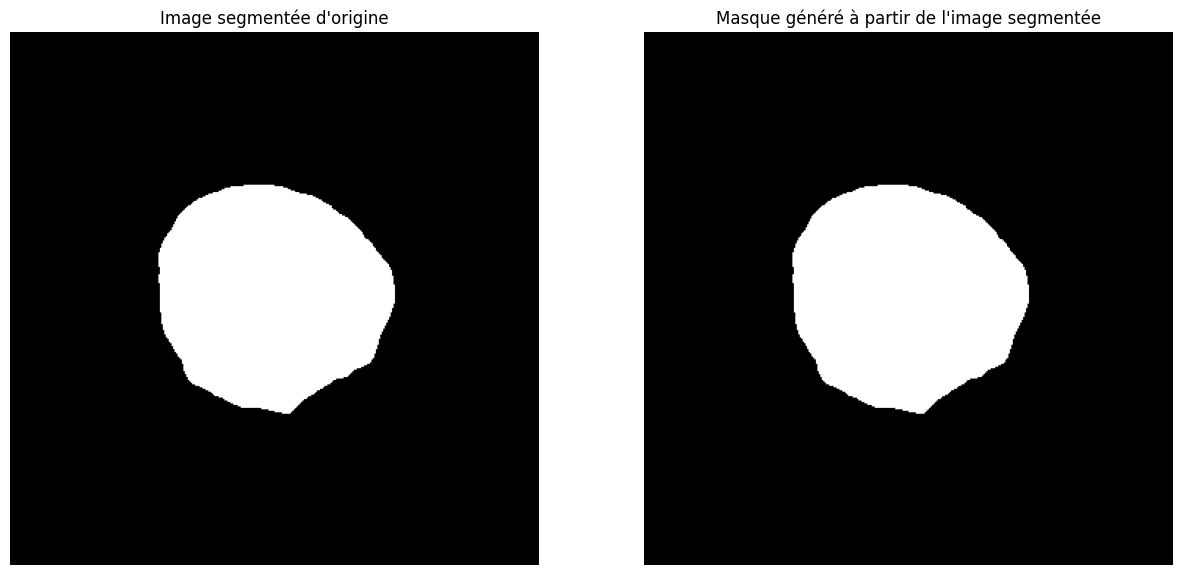

In [ ]:
import matplotlib.pyplot as plt
import cv2

### Génération de masques à partir des images segmentées du jeu de données

### Premièrement, on récupère les chemins des dossiers contenant les images

path_folders=glob.glob('/content/masques/**')

### Affichage d'un exemple d'image segmentée

path_example= glob.glob(path_folders[0]+'/**')[0]
plt.figure(figsize=(15,7))
plt.subplot(121)
example=cv2.imread(path_example)
plt.imshow(example)
plt.title("Image segmentée d'origine")
plt.axis('off')

### Transformation des images segmentées en masques

threshold=20
for path in path_folders:
  for fichier in glob.glob(path+'/**'):
      img=cv2.imread(fichier)
      if len(img.shape)==3:

        ### La moyenne des pixels RGB est calculée et un seuil est défini pour séparer les pixels
        ### de la feuille et le reste.
        ### La valeur de 1 est attribué pour un pixel de la feuille, le pixel prend la valeur 0 sinon.

          img_mask=(img.mean(axis=2)>threshold).astype(int)
          cv2.imwrite(fichier,img_mask)

### Exemple de masque produit

plt.subplot(122)
example=cv2.imread(path_example,cv2.IMREAD_GRAYSCALE)
plt.imshow(example*255,cmap='gray')
plt.title("Masque généré à partir de l'image segmentée")
plt.axis('off');
print(example.min(),example.max())

Les jeux de données d'entraînement, de validation et de test sont générés à partir du DataFrame créer.
Les données seront chargées au fur et à mesure de l'entrainement du modèle par une fonction définie ci-dessous.

Pour l'entrainement du modèle, les features correspondent aux images et les valeurs à prédire (les labels) sont les masques correspondants.


### **4.3. Architecture du modèle Unet**

In [ ]:
### Import des modules nécessaires pour l'ensemble du travail

import numpy as np
import os
import glob
import cv2
from keras import callbacks
import pandas as pd
import skimage.io as io
import skimage.transform as trans
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from tensorflow.keras.utils import plot_model

In [ ]:
### Définition de la structure du modèle avec ses différentes couches

def unet_segmentation(pretrained_weights = None,input_size=(256, 256, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=2)(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2))(conv4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2))(conv5), conv4], axis=-1)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2))(conv7), conv2], axis=-1)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2))(conv8), conv1], axis=-1)
    conv9 = Conv2D(32, (3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    segmentation_model = Model(inputs=inputs, outputs=conv10)

    ### Si le modèle a précédemment été entrainé, les poids sauvegardés sont chargés
    if (pretrained_weights):
      segmentation_model.load_weights(pretrained_weights)
    if (pretrained_weights):
      print("\nLe modèle a été instancié avec les poids chargés.")

    return segmentation_model

In [ ]:
### Chargement de poids sauvegardés de unet s'ils existent
export_dir='/content/drive/MyDrive/'
pretrained_weights = None
if os.path.exists(export_dir+'weights__.h5'):
  pretrained_weights = export_dir+'weights__.h5'

### **4.4. Instanciation du modèle et visualisation de son architecture**

In [ ]:
### Création des modèles
segmenter = unet_segmentation(input_size=(256,256,3), pretrained_weights=pretrained_weights)

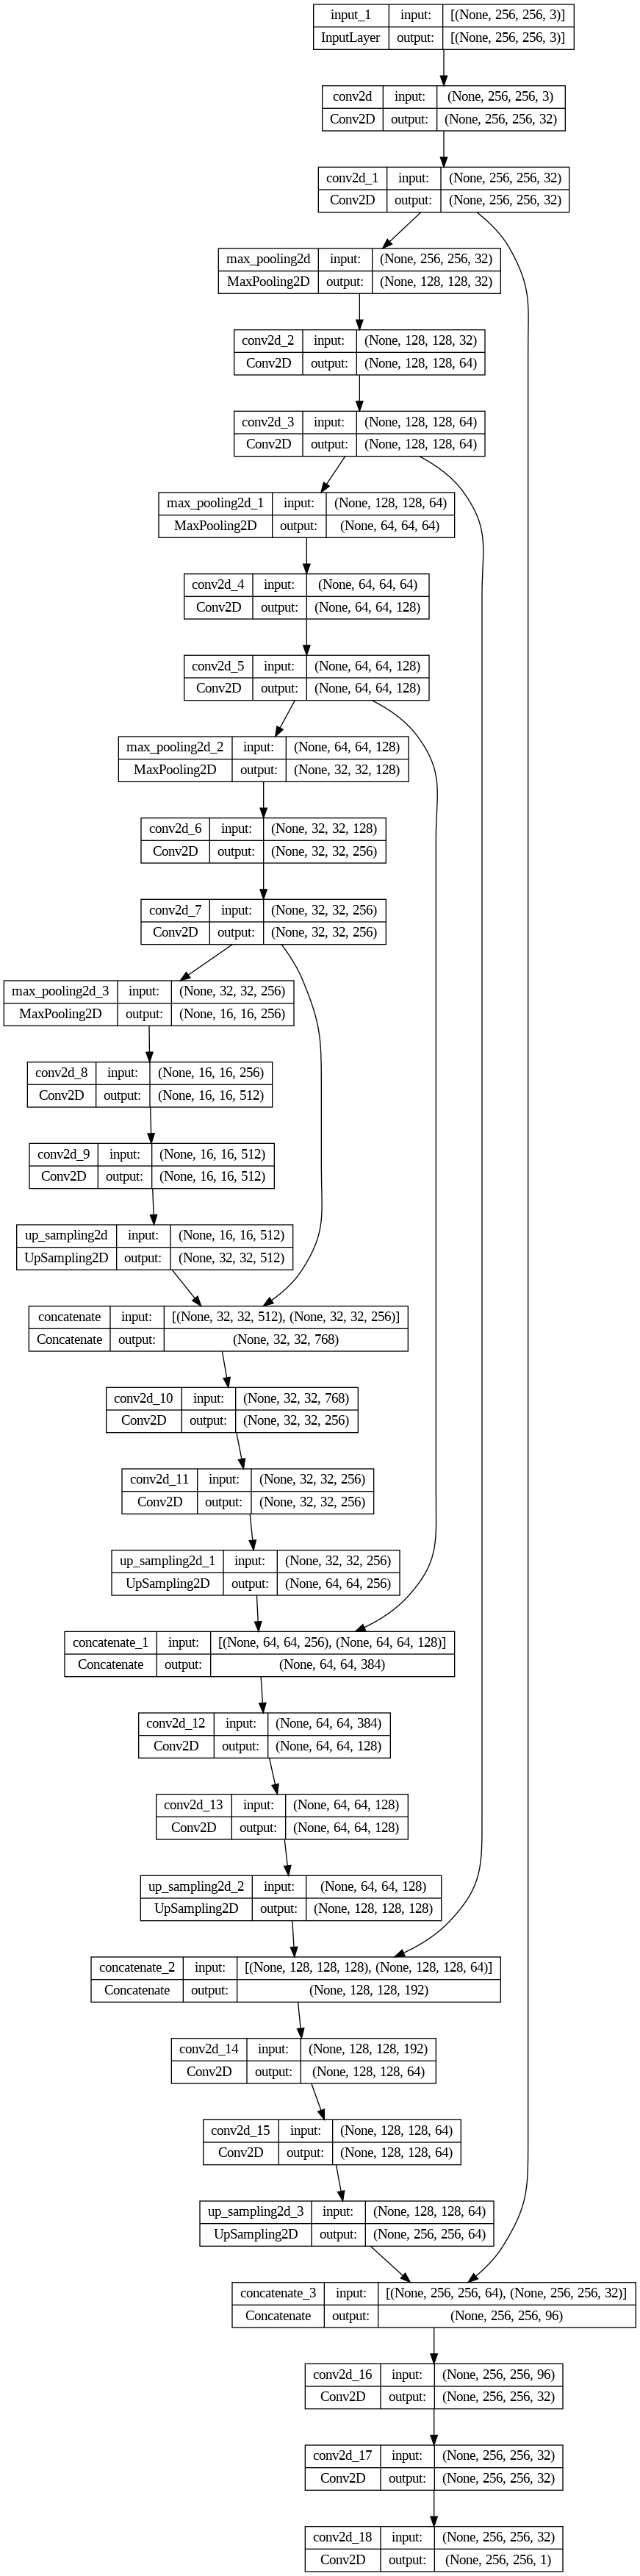

In [ ]:
### schéma du modèle
plot_model(segmenter, show_shapes=True)

### **4.5. Définition des fonctions de perte et des métriques**

In [ ]:
### Définition d'une fonction de perte : Coefficient de Dice
def LossDice(y_true, y_pred):
  numerateur  =tf.reduce_sum(y_true*y_pred, axis=(1, 2))
  denominateur=tf.reduce_sum(y_true+y_pred, axis=(1, 2))
  dice=2*numerateur/(denominateur+1E-4)
  return 1-dice

def DiceCoeff(y_true, y_pred):
  numerateur  =tf.reduce_sum(y_true*y_pred, axis=(1, 2))
  denominateur=tf.reduce_sum(y_true+y_pred, axis=(1, 2))
  dice=2*numerateur/(denominateur+1E-4)
  return dice

### **4.6. Compilation du modèle**

In [ ]:
segmenter.compile(optimizer=Adam(1e-3), loss=LossDice, metrics=DiceCoeff)

# **5. Préparation et chargement du jeu de données**

### **5.1. Séparation du jeu de données et préparation du format des labels**

In [ ]:
### Création du jeu d'entrainement, de validation et de test

height=256
width=256
batch_size=32
seed=42

#### séparation du jeu de données
from sklearn.model_selection import train_test_split

filepaths = df_mask['filepath'].values
maskpaths = df_mask['maskpath'].values

train_filepaths, test_filepaths, train_maskpaths, test_maskpaths = train_test_split(filepaths, maskpaths, test_size=0.2, random_state=seed)
train_filepaths, val_filepaths, train_maskpaths, val_maskpaths = train_test_split(train_filepaths, train_maskpaths, test_size=0.2, random_state=seed)


nb_img_train=len(train_filepaths)
nb_img_val=len(val_filepaths)
nb_img_test=len(test_filepaths)

### **5.2. Définition des fonctions de chargement et d'augmentation du jeu de données pour le modèle Unet générateur de masques**

In [ ]:
# fonction de chargement pour le modèle de segmentation

def parse_function_segmentation(filepath, maskpath):
    # Lire l'image
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = image / 255.0 # Normaliser entre 0 et 1

    # Lire le masque
    mask = tf.io.read_file(maskpath)
    mask = tf.image.decode_png(mask, channels=1) # Ou utiliser decode_jpeg si c'est un JPEG
    mask = tf.image.resize(mask, [256, 256])
    # mask = mask / 255.0 # Normaliser entre 0 et 1 si nécessaire
    return image, mask

def augment_image(image, mask):
    # Appliquer une rotation aléatoire, un décalage, etc.
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)

    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k=k)
    mask = tf.image.rot90(mask, k=k)

    if tf.random.uniform(()) > 0.5:
        dx, dy = 10, 10  # décalage souhaité
        image = tf.image.pad_to_bounding_box(image, dy, dx, 256 + dy, 256 + dx)
        mask = tf.image.pad_to_bounding_box(mask, dy, dx, 256 + dy, 256 + dx)
        image = tf.image.crop_to_bounding_box(image, 0, 0, 256, 256)
        mask = tf.image.crop_to_bounding_box(mask, 0, 0, 256, 256)

    if tf.random.uniform(()) > 0.5:
        zoom_ratio = 0.8  # supérieur à 1 pour zoom avant, inférieur à 1 pour zoom arrière
        new_width, new_height = int(256 * zoom_ratio), int(256 * zoom_ratio)
        image = tf.image.resize(image, [new_width, new_height])
        mask = tf.image.resize(mask, [new_width, new_height])
        image = tf.image.pad_to_bounding_box(image, (256 - new_width) // 2, (256 - new_height) // 2, 256, 256)
        mask = tf.image.pad_to_bounding_box(mask, (256 - new_width) // 2, (256 - new_height) // 2, 256, 256)

    return image, mask

def load_and_augment_segmentation(filepath, maskpath):
    image, mask = parse_function_segmentation(filepath, maskpath)
    image, mask = augment_image(image, mask)
    return image, mask

def create_dataset_segmentation(filepaths, maskpaths, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((filepaths, maskpaths))
    if augment:
        dataset = dataset.map(load_and_augment_segmentation, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        dataset = dataset.map(parse_function_segmentation, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.shuffle(buffer_size=1000).batch(32).repeat().prefetch(tf.data.AUTOTUNE)


### **5.3. Création du jeu de données pour le modèle Unet générateur de masques**

In [ ]:
train_dataset_segmentation = create_dataset_segmentation(train_filepaths, train_maskpaths, augment=True)
val_dataset_segmentation = create_dataset_segmentation(val_filepaths, val_maskpaths, augment=False)
test_dataset_segmentation = create_dataset_segmentation(test_filepaths, test_maskpaths, augment=False)

In [ ]:
### Création du jeu d'entrainement, de validation et de test
### La fonction définie au dessus est utilisée pour charger les images et
### masques au fur et à mesure de l'entrainement

### Définition de fonctions de chargement et transformation
### des images ou masques à partir des chemins

import tensorflow as tf
def load_image(filepath,resize=(256,256)):
    # Charger l'information brute en mémoire
    im = tf.io.read_file(filepath)
    # Décoder l'information en un tensorflow RGB (3 channels).
    im = tf.io.decode_jpeg(im, channels=3)
    #Redimensionner l'image
    im=tf.image.resize(im, size=resize)
    # Normaliser entre 0 et 1
    im = im / 255.0
    return im

def load_mask(filepath,resize=(256,256)):
    im = tf.io.read_file(filepath)
    ### Dans le cas des masques, l'image est en noir et blanc, il n'y a donc qu'une valeur par pixel
    im = tf.io.decode_jpeg(im, channels=1)
    return tf.image.resize(im, size=resize)



train_dataset_segmentation = tf.data.Dataset.from_tensor_slices((train_filepaths,train_maskpaths))
train_dataset_segmentation = train_dataset_segmentation.map(lambda x, y : [load_image(x),load_mask(y)], num_parallel_calls=-1).batch(1)

val_dataset_segmentation = tf.data.Dataset.from_tensor_slices((val_filepaths,val_maskpaths))
val_dataset_segmentation = val_dataset_segmentation.map(lambda x, y : [load_image(x),load_mask(y)], num_parallel_calls=-1).batch(1)

test_dataset_segmentation = tf.data.Dataset.from_tensor_slices((test_filepaths,test_maskpaths))
test_dataset_segmentation = test_dataset_segmentation.map(lambda x, y : [load_image(x),load_mask(y)], num_parallel_calls=-1).batch(1)

### **5.4. Vérification du chargement des données**

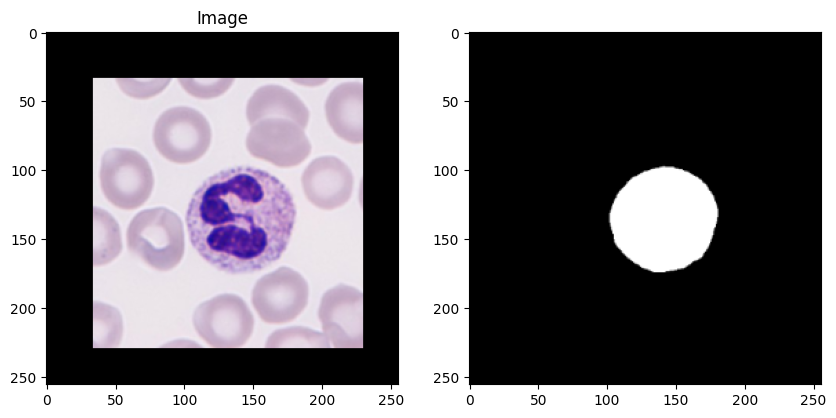

In [ ]:
###dataset train

def visualize_sample(image, mask):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image.numpy())
    plt.title("Image")

    plt.subplot(1, 2, 2)
    plt.imshow(mask.numpy().squeeze(), cmap='gray')

    plt.show()

# Prendre un échantillon du train_dataset
for (image, mask) in train_dataset_segmentation.take(1):
    visualize_sample(image[0], mask[0])

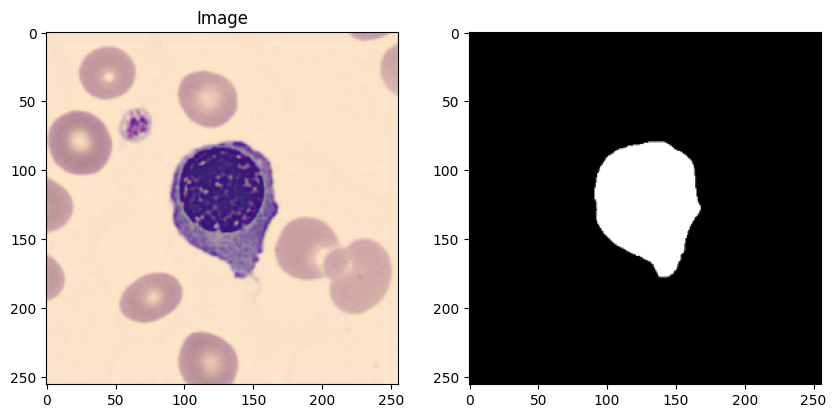

In [ ]:
### dataset validation

def visualize_sample(image, mask):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image.numpy())
    plt.title("Image")

    plt.subplot(1, 2, 2)
    plt.imshow(mask.numpy().squeeze(), cmap='gray')

    plt.show()

# Prendre un échantillon du train_dataset
for (image, mask) in val_dataset_segmentation.take(1):
    visualize_sample(image[0], mask[0])

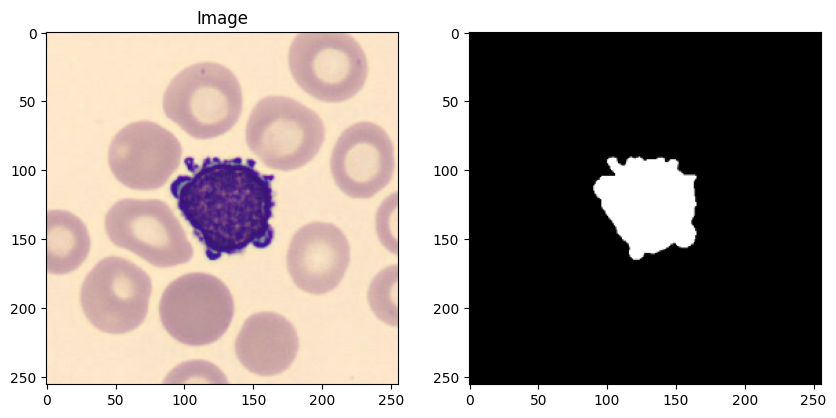

In [ ]:
### dataset test

def visualize_sample(image, mask):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image.numpy())
    plt.title("Image")

    plt.subplot(1, 2, 2)
    plt.imshow(mask.numpy().squeeze(), cmap='gray')

    plt.show()

# Prendre un échantillon du train_dataset
for (image, mask) in test_dataset_segmentation.take(1):
    visualize_sample(image[0], mask[0])

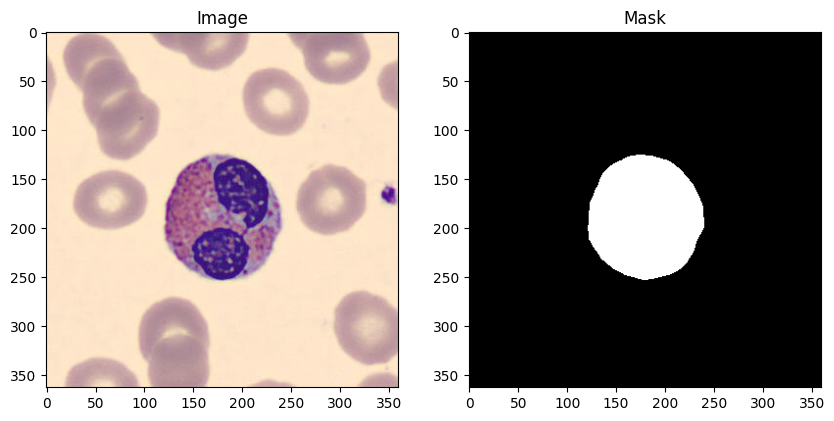

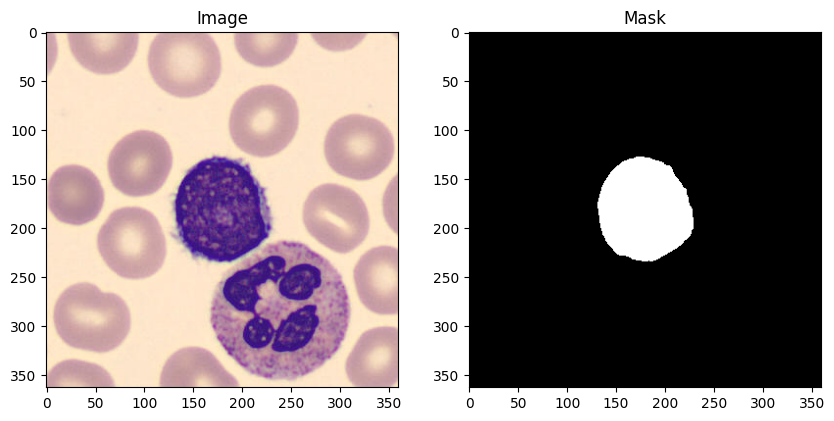

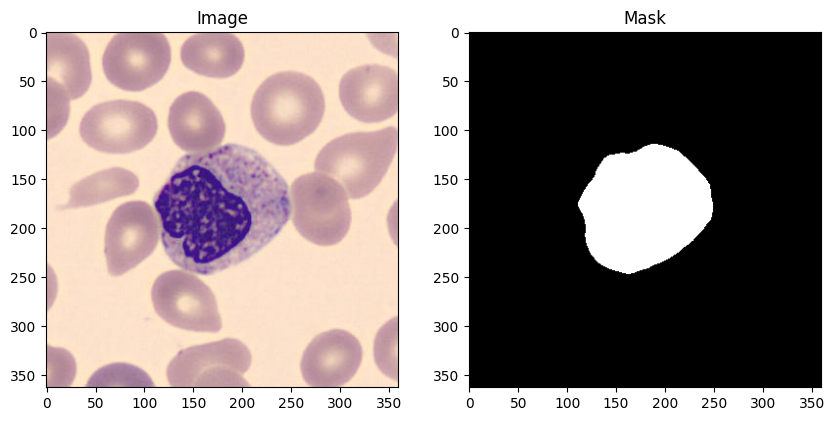

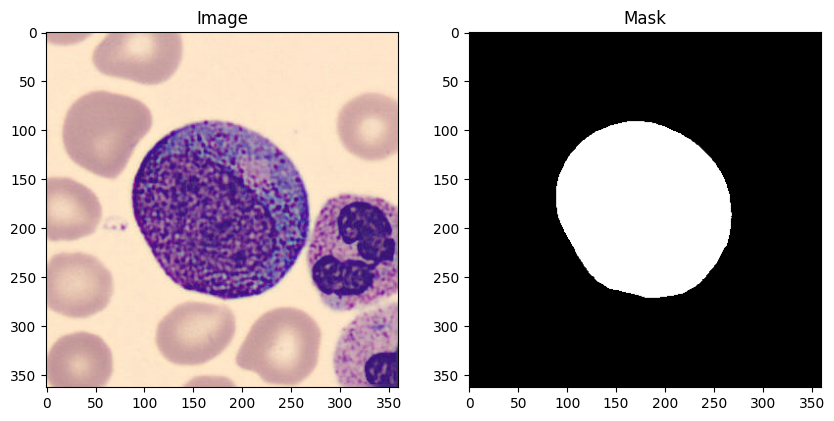

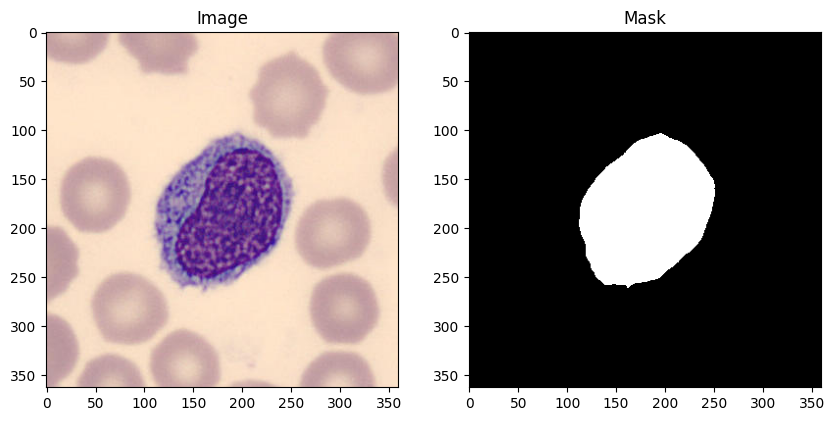

In [ ]:
### Fonction pour visualiser l'image et le masque côte à côte

import matplotlib.pyplot as plt
import cv2

def display_image_mask(image_path, mask_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir de BGR à RGB

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Supposons que le masque est en niveaux de gris

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(image)
    ax[0].set_title("Image")

    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title("Mask")

    plt.show()

# Vérifier pour quelques paires aléatoires
import random

sample_indexes = random.sample(range(len(train_filepaths)), 5)  # choisir 5 paires aléatoirement

for index in sample_indexes:
    display_image_mask(train_filepaths[index], train_maskpaths[index])


In [ ]:
### vérification que les chemins d'accès aux images et aux masques correspondent bien

for img_path, mask_path in zip(val_filepaths, val_maskpaths):
    img_name = os.path.basename(img_path).split('.')[0]  # Enlève l'extension
    mask_name = os.path.basename(mask_path).split('.')[0]

    # Ajoutez ici le schéma de dénomination si ce n'est pas directement identique
    if img_name+'_mask' != mask_name:
        print(f"Mismatch: {img_path} and {mask_path}")


In [ ]:
### vérification que les batchs des images et des masques correspondent


for images, masks in train_dataset_segmentation.take(1):
    print(images.shape[0])
    print(masks.shape[0])
    assert images.shape[0] == masks.shape[0], "Mismatch in number of samples within the batch!"


32
32


In [ ]:
### format des données d'entrées
sample = next(iter(train_dataset_segmentation.take(1)))

image_sample, mask_sample = sample

# Imprimez les formes des tenseurs
print("train_dataset_segmentation:")
print("Image shape:", image_sample.shape)
print("Mask shape:", mask_sample.shape)
print("\n")

sample = next(iter(val_dataset_segmentation.take(1)))

image_sample, mask_sample = sample

# Imprimez les formes des tenseurs
print("val_dataset_segmentation:")
print("Image shape:", image_sample.shape)
print("Mask shape:", mask_sample.shape)
print("\n")

sample = next(iter(test_dataset_segmentation.take(1)))

image_sample, mask_sample = sample

# Imprimez les formes des tenseurs
print("test_dataset_segmentation:")
print("Image shape:", image_sample.shape)
print("Mask shape:", mask_sample.shape)
print("\n")

train_dataset_segmentation:
Image shape: (32, 256, 256, 3)
Mask shape: (32, 256, 256, 1)


val_dataset_segmentation:
Image shape: (32, 256, 256, 3)
Mask shape: (32, 256, 256, 1)


test_dataset_segmentation:
Image shape: (32, 256, 256, 3)
Mask shape: (32, 256, 256, 1)




# **6. Entraînement du modèle Unet**

### **6.1. Définition des Callbacks**

In [ ]:
### Définition de callbacks

### Sauvegarde automatique des poids
checkpoint = callbacks.ModelCheckpoint(filepath = '/content/drive/MyDrive/weights.h5',
                                       monitor = 'loss',
                                       save_best_only = True,
                                       save_weights_only = True,
                                       mode = 'min',
                                       save_freq = 'epoch')

### 'Callback' permettant d'ajuster le taux d'apprentissage au cours de l'entrainement
lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'loss',
                                         patience=2,
                                         factor=0.1,
                                         verbose=2,
                                         mode='min')

early_stopping = callbacks.EarlyStopping(monitor='val_loss', #métrique à controller
                                         min_delta = 0.01, # si au bout de 5 epochs la fonction de perte ne varie pas de 1%, que ce soit à la hausse ou à la baisse, on arrête au bout de 5 épochs
                                         patience=5,
                                         verbose = 0,
                                         mode='min',
                                         restore_best_weights=True)

### **6.2. Entraînement**

In [ ]:
steps_per_epochs=nb_img_train//batch_size
validation_steps=nb_img_val//batch_size

Segmentation=segmenter.fit(train_dataset_segmentation, epochs=100, steps_per_epoch=steps_per_epochs, validation_data=val_dataset_segmentation, validation_steps=validation_steps,callbacks = [checkpoint,lr_plateau,early_stopping])

Epoch 1/100
90/90 [==============================] - 61s 656ms/step - loss: 0.2119 - DiceCoeff: 0.7881 - val_loss: 0.0840 - val_DiceCoeff: 0.9160 - lr: 0.0010
Epoch 2/100
90/90 [==============================] - 57s 638ms/step - loss: 0.0923 - DiceCoeff: 0.9077 - val_loss: 0.0837 - val_DiceCoeff: 0.9163 - lr: 0.0010
Epoch 3/100
90/90 [==============================] - 57s 637ms/step - loss: 0.0734 - DiceCoeff: 0.9266 - val_loss: 0.0855 - val_DiceCoeff: 0.9145 - lr: 0.0010
Epoch 4/100
90/90 [==============================] - 57s 640ms/step - loss: 0.0697 - DiceCoeff: 0.9303 - val_loss: 0.0761 - val_DiceCoeff: 0.9239 - lr: 0.0010
Epoch 5/100
90/90 [==============================] - 57s 639ms/step - loss: 0.0652 - DiceCoeff: 0.9348 - val_loss: 0.0721 - val_DiceCoeff: 0.9279 - lr: 0.0010
Epoch 6/100
90/90 [==============================] - 58s 643ms/step - loss: 0.0570 - DiceCoeff: 0.9430 - val_loss: 0.0508 - val_DiceCoeff: 0.9492 - lr: 0.0010
Epoch 7/100
90/90 [===========================

### **6.3. Sauvegarde de l'entraînement**

In [ ]:
### Sauvegarde des poids et du modèle entrainé
export_dir='/content/drive/MyDrive/'
segmenter.save_weights(export_dir+'weights_unet_with_data_augmented.h5')
segmenter.save(export_dir+'model_unet_with_data_augmented.h5')

In [ ]:
### Chargement éventuel d'un modèle enregistré
export_dir='/content/drive/MyDrive/'
custom_objects = {'LossDice': LossDice}
if os.path.exists(export_dir+'model_unet_with_data_augmented.h5'):
  saved_segmenter= tf.keras.models.load_model(export_dir+'model_unet_with_data_augmented.h5', custom_objects=custom_objects)

# **7. Evaluation de la précision du modèle UNET et réalisation d'essais sur de nouvelles images**

Le modèle est évalué sur le jeu de donnée de test et des images d'un autre jeu de données vont être chargées pour pouvoir tester la segmentation générée.

### **7.1. Evaluation de la prédiction**

In [ ]:
evaluation = segmenter.evaluate(test_dataset_segmentation)

In [ ]:
#Prediction

n = len(test_filepaths)
batch_size = 32

steps_to_evaluate = n // batch_size

limited_dataset = test_dataset_segmentation.take(steps_to_evaluate)

### Evaluation de la précision du modèle sur le jeu de test
evaluation=segmenter.evaluate(limited_dataset)
print('Précision du modèle sur le jeu de test :',np.round(evaluation[1],2),"\n",
      'Perte du modèle sur le jeu de test :',np.round(evaluation[0],2))

28/28 [==============================] - 5s 170ms/step - loss: 0.0349 - DiceCoeff: 0.9651
Précision du modèle sur le jeu de test : 0.97 
 Perte du modèle sur le jeu de test : 0.03


### **7.2. Vérification de la prédiction du modèle**

1/1 [==============================] - 0s 23ms/step


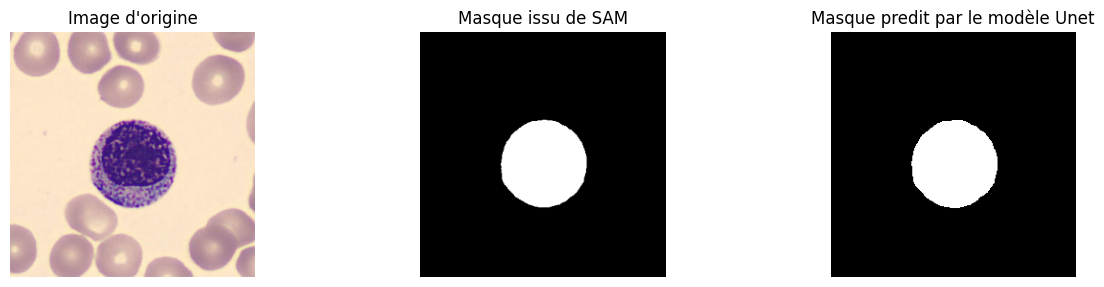

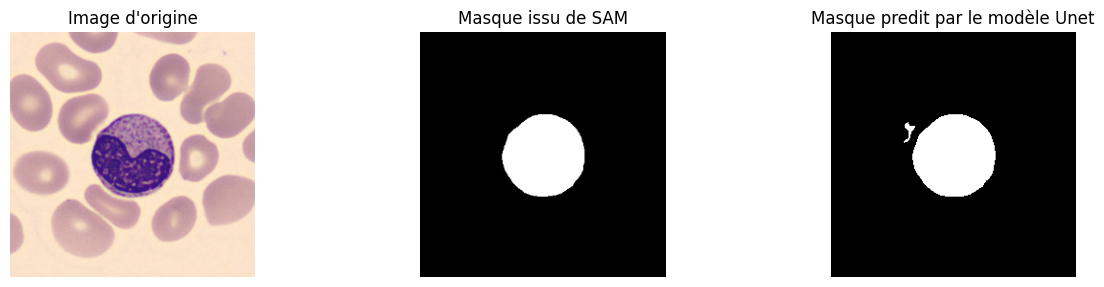

In [ ]:
### Définition de fonctions de chargement et transformation
### des images ou masques à partir des chemins

import tensorflow as tf
def load_image(filepath,resize=(256,256)):
    # Charger l'information brute en mémoire
    im = tf.io.read_file(filepath)
    # Décoder l'information en un tensorflow RGB (3 channels).
    im = tf.io.decode_jpeg(im, channels=3)
    #Redimensionner l'image
    return tf.image.resize(im, size=resize)

def load_mask(filepath,resize=(256,256)):
    im = tf.io.read_file(filepath)
    ### Dans le cas des masques, l'image est en noir et blanc, il n'y a donc qu'une valeur par pixel
    im = tf.io.decode_png(im, channels=1)
    return tf.image.resize(im, size=resize)

### Affichage d'une prédiction de masque en comparaison avec un masque
### fait à partir de l'image segmentée du jeu de donnée Test

size=2
indexes=np.random.choice(len(test_filepaths),size=2)

i=0
for idx in indexes:
  image=load_image(test_filepaths[idx])
  img=tf.reshape(image,(1,256,256,3))
  mask_pred=segmenter.predict(img)
  mask_true=load_mask(test_maskpaths[idx])
  image=tf.cast(image,dtype=tf.int32)


  plt.figure(figsize=(15,7))

  i+=1
  plt.subplot(size,3,i)
  plt.imshow(image)
  plt.axis("off")
  plt.title("Image d'origine")

  i+=1
  plt.subplot(size,3,i)
  plt.imshow(tf.reshape(mask_true,(256,256)),cmap='gray')
  plt.axis("off")
  plt.title("Masque issu de SAM")

  i+=1
  plt.subplot(size,3,i)
  plt.imshow(tf.reshape(mask_pred,(256,256)),cmap='gray')
  plt.axis("off")
  plt.title("Masque predit par le modèle Unet")

# **8. Création des 17000 masques, à l'aide du modèle UNET**

In [ ]:
from tqdm import tqdm
import numpy as np
import os
import cv2
from PIL import Image
import imageio
from skimage import filters
import time



train_df=df
# Définition d'une liste contenant les différents labels
liste_label =train_df.nameLabel.unique()

# Parcours et écriture des masques de chaque groupe présent dans la liste "liste_label"
# Ici on prend uniquement une centaine d'images par groupe
for label in liste_label :
  MASK_DF = train_df.loc[train_df['nameLabel'] == label]
  IMAGE_PATH = np.array(MASK_DF['filepath'])

  # Création et enregistrement des masques pour chaque image

  for i in tqdm(range(len(MASK_DF))):

          # Read image

          mask=load_image(IMAGE_PATH[i])
          masks=tf.reshape(mask,(1,256,256,3))
          pred=segmenter.predict(masks)

          # Chemin du dossier où vous souhaitez enregistrer l'image
          output_folder = '/content/masques/' + IMAGE_PATH[i].split('/')[2]

          # Nom du fichier de sortie
          output_filename = str(MASK_DF['filepath'].iloc[i]).split('/')[3].split('.')[0]+'_mask.png'

          # Chemin complet du fichier de sortie
          output_path = output_folder+'/'+output_filename

          threshold = 0.5  # Adjust the threshold as needed based on your model's output
          pred_binary = (pred[0, :, :, 0] > threshold).astype(int)

          # Save the mask image
          cv2.imwrite(output_path, pred_binary)

          # Enregistrez l'image dans le fichier PNG
          print('L\'image n°', i, 'a été enregistrée sous :', output_path)

  0%|          | 0/2895 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step
L'image n° 0 a été enregistrée sous : /content/masques/ig/MMY_306096_mask.png
1/1 [==============================] - 0s 19ms/step


  0%|          | 2/2895 [00:00<03:21, 14.34it/s]

L'image n° 1 a été enregistrée sous : /content/masques/ig/PMY_782838_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2 a été enregistrée sous : /content/masques/ig/MMY_4594_mask.png
1/1 [==============================] - 0s 19ms/step


  0%|          | 4/2895 [00:00<03:12, 14.98it/s]

L'image n° 3 a été enregistrée sous : /content/masques/ig/MMY_718083_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 4 a été enregistrée sous : /content/masques/ig/MMY_650708_mask.png
1/1 [==============================] - 0s 19ms/step


  0%|          | 6/2895 [00:00<03:19, 14.51it/s]

L'image n° 5 a été enregistrée sous : /content/masques/ig/MY_47749_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 6 a été enregistrée sous : /content/masques/ig/MY_909454_mask.png
1/1 [==============================] - 0s 19ms/step


  0%|          | 8/2895 [00:00<03:12, 15.00it/s]

L'image n° 7 a été enregistrée sous : /content/masques/ig/MMY_361679_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 8 a été enregistrée sous : /content/masques/ig/MMY_930116_mask.png
1/1 [==============================] - 0s 20ms/step


  0%|          | 10/2895 [00:00<03:13, 14.95it/s]

L'image n° 9 a été enregistrée sous : /content/masques/ig/IG_234558_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 10 a été enregistrée sous : /content/masques/ig/MY_810266_mask.png
1/1 [==============================] - 0s 21ms/step


  0%|          | 12/2895 [00:00<03:09, 15.24it/s]

L'image n° 11 a été enregistrée sous : /content/masques/ig/MY_406153_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 12 a été enregistrée sous : /content/masques/ig/MMY_856218_mask.png
1/1 [==============================] - 0s 19ms/step


  0%|          | 14/2895 [00:00<03:09, 15.22it/s]

L'image n° 13 a été enregistrée sous : /content/masques/ig/PMY_610548_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 14 a été enregistrée sous : /content/masques/ig/MY_815428_mask.png
1/1 [==============================] - 0s 19ms/step


  1%|          | 16/2895 [00:01<03:07, 15.35it/s]

L'image n° 15 a été enregistrée sous : /content/masques/ig/MY_102887_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 16 a été enregistrée sous : /content/masques/ig/PMY_755032_mask.png
1/1 [==============================] - 0s 19ms/step


  1%|          | 18/2895 [00:01<03:08, 15.30it/s]

L'image n° 17 a été enregistrée sous : /content/masques/ig/PMY_578872_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 18 a été enregistrée sous : /content/masques/ig/MY_547780_mask.png
1/1 [==============================] - 0s 18ms/step


  1%|          | 20/2895 [00:01<03:06, 15.43it/s]

L'image n° 19 a été enregistrée sous : /content/masques/ig/MY_442608_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 20 a été enregistrée sous : /content/masques/ig/MY_505449_mask.png
1/1 [==============================] - 0s 18ms/step


  1%|          | 22/2895 [00:01<03:06, 15.37it/s]

L'image n° 21 a été enregistrée sous : /content/masques/ig/PMY_298362_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 22 a été enregistrée sous : /content/masques/ig/MY_579000_mask.png
1/1 [==============================] - 0s 18ms/step


  1%|          | 24/2895 [00:01<03:04, 15.55it/s]

L'image n° 23 a été enregistrée sous : /content/masques/ig/MY_81654_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 24 a été enregistrée sous : /content/masques/ig/MMY_782857_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 

  1%|          | 26/2895 [00:01<03:04, 15.55it/s]

25 a été enregistrée sous : /content/masques/ig/IG_901001_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 26 a été enregistrée sous : /content/masques/ig/IG_475530_mask.png
1/1 [==============================] - 0s 20ms/step


  1%|          | 28/2895 [00:01<03:06, 15.37it/s]

L'image n° 27 a été enregistrée sous : /content/masques/ig/PMY_804177_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 28 a été enregistrée sous : /content/masques/ig/MY_577473_mask.png
1/1 [==============================] - 0s 19ms/step


  1%|          | 30/2895 [00:01<03:03, 15.60it/s]

L'image n° 29 a été enregistrée sous : /content/masques/ig/MY_436928_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 30 a été enregistrée sous : /content/masques/ig/MMY_678834_mask.png
1/1 [==============================] - 0s 18ms/step


  1%|          | 32/2895 [00:02<03:03, 15.64it/s]

L'image n° 31 a été enregistrée sous : /content/masques/ig/PMY_881874_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 32 a été enregistrée sous : /content/masques/ig/PMY_552383_mask.png
1/1 [==============================] - 0s 18ms/step


  1%|          | 34/2895 [00:02<03:01, 15.72it/s]

L'image n° 33 a été enregistrée sous : /content/masques/ig/MY_703437_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 34 a été enregistrée sous : /content/masques/ig/MY_279665_mask.png
1/1 [==============================] - 0s 19ms/step


  1%|          | 36/2895 [00:02<03:04, 15.52it/s]

L'image n° 35 a été enregistrée sous : /content/masques/ig/MY_420171_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 36 a été enregistrée sous : /content/masques/ig/PMY_265295_mask.png
1/1 [==============================] - 0s 19ms/step


  1%|▏         | 38/2895 [00:02<03:03, 15.57it/s]

L'image n° 37 a été enregistrée sous : /content/masques/ig/PMY_293093_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 38 a été enregistrée sous : /content/masques/ig/MMY_209242_mask.png
1/1 [==============================] - 0s 19ms/step


  1%|▏         | 40/2895 [00:02<03:04, 15.48it/s]

L'image n° 39 a été enregistrée sous : /content/masques/ig/MY_67060_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 40 a été enregistrée sous : /content/masques/ig/MY_973096_mask.png
1/1 [==============================] - 0s 18ms/step


  1%|▏         | 42/2895 [00:02<03:04, 15.47it/s]

L'image n° 41 a été enregistrée sous : /content/masques/ig/MMY_367941_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 42 a été enregistrée sous : /content/masques/ig/MMY_329366_mask.png
1/1 [==============================] - 0s 19ms/step


  2%|▏         | 44/2895 [00:02<03:02, 15.63it/s]

L'image n° 43 a été enregistrée sous : /content/masques/ig/MMY_767879_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 44 a été enregistrée sous : /content/masques/ig/MMY_494835_mask.png
1/1 [==============================] - 0s 19ms/step


  2%|▏         | 46/2895 [00:02<03:03, 15.55it/s]

L'image n° 45 a été enregistrée sous : /content/masques/ig/MY_876188_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 46 a été enregistrée sous : /content/masques/ig/MMY_376991_mask.png
1/1 [==============================] - 0s 18ms/step


  2%|▏         | 48/2895 [00:03<03:01, 15.71it/s]

L'image n° 47 a été enregistrée sous : /content/masques/ig/MY_380564_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 48 a été enregistrée sous : /content/masques/ig/PMY_44436_mask.png
1/1 [==============================] - 0s 18ms/step


  2%|▏         | 50/2895 [00:03<03:03, 15.53it/s]

L'image n° 49 a été enregistrée sous : /content/masques/ig/MY_320467_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 50 a été enregistrée sous : /content/masques/ig/MY_56227_mask.png
1/1 [==============================] - 0s 18ms/step


  2%|▏         | 52/2895 [00:03<03:03, 15.52it/s]

L'image n° 51 a été enregistrée sous : /content/masques/ig/MY_897327_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 52 a été enregistrée sous : /content/masques/ig/MY_16620_mask.png
1/1 [==============================] - 0s 18ms/step


  2%|▏         | 54/2895 [00:03<03:01, 15.69it/s]

L'image n° 53 a été enregistrée sous : /content/masques/ig/MY_529769_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 54 a été enregistrée sous : /content/masques/ig/MMY_616831_mask.png
1/1 [==============================] - 0s 19ms/step


  2%|▏         | 56/2895 [00:03<02:59, 15.81it/s]

L'image n° 55 a été enregistrée sous : /content/masques/ig/MMY_917973_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 56 a été enregistrée sous : /content/masques/ig/MMY_433507_mask.png
1/1 [==============================] - 0s 19ms/step


  2%|▏         | 58/2895 [00:03<03:02, 15.51it/s]

L'image n° 57 a été enregistrée sous : /content/masques/ig/MMY_975100_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 58 a été enregistrée sous : /content/masques/ig/MMY_1144_mask.png
1/1 [==============================] - 0s 18ms/step


  2%|▏         | 60/2895 [00:03<03:02, 15.54it/s]

L'image n° 59 a été enregistrée sous : /content/masques/ig/MMY_803821_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 60 a été enregistrée sous : /content/masques/ig/MY_288231_mask.png
1/1 [==============================] - 0s 19ms/step


  2%|▏         | 62/2895 [00:04<03:02, 15.54it/s]

L'image n° 61 a été enregistrée sous : /content/masques/ig/MY_867235_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 62 a été enregistrée sous : /content/masques/ig/MY_317306_mask.png
1/1 [==============================] - 0s 18ms/step


  2%|▏         | 64/2895 [00:04<03:01, 15.63it/s]

L'image n° 63 a été enregistrée sous : /content/masques/ig/MY_320705_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 64 a été enregistrée sous : /content/masques/ig/MY_564694_mask.png
1/1 [==============================] - 0s 19ms/step


  2%|▏         | 66/2895 [00:04<03:00, 15.71it/s]

L'image n° 65 a été enregistrée sous : /content/masques/ig/MMY_75301_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 66 a été enregistrée sous : /content/masques/ig/MMY_68077_mask.png
1/1 [==============================] - 0s 18ms/step


  2%|▏         | 68/2895 [00:04<03:00, 15.66it/s]

L'image n° 67 a été enregistrée sous : /content/masques/ig/MY_949579_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 68 a été enregistrée sous : /content/masques/ig/MMY_579750_mask.png
1/1 [==============================] - 0s 18ms/step


  2%|▏         | 70/2895 [00:04<03:01, 15.58it/s]

L'image n° 69 a été enregistrée sous : /content/masques/ig/MMY_872306_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 70 a été enregistrée sous : /content/masques/ig/PMY_171652_mask.png
1/1 [==============================] - 0s 19ms/step


  2%|▏         | 72/2895 [00:04<03:02, 15.48it/s]

L'image n° 71 a été enregistrée sous : /content/masques/ig/MY_770472_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 72 a été enregistrée sous : /content/masques/ig/MMY_826421_mask.png
1/1 [==============================] - 0s 18ms/step


  3%|▎         | 74/2895 [00:04<03:01, 15.58it/s]

L'image n° 73 a été enregistrée sous : /content/masques/ig/PMY_817838_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 74 a été enregistrée sous : /content/masques/ig/PMY_416383_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 75 a été enregistrée sous : /content/masques/ig/PMY_176074_mask.png

  3%|▎         | 76/2895 [00:04<03:00, 15.59it/s]


1/1 [==============================] - 0s 21ms/step
L'image n° 76 a été enregistrée sous : /content/masques/ig/PMY_131738_mask.png
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 78/2895 [00:05<03:02, 15.44it/s]

L'image n° 77 a été enregistrée sous : /content/masques/ig/IG_466905_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 78 a été enregistrée sous : /content/masques/ig/MY_931043_mask.png
1/1 [==============================] - 0s 19ms/step


  3%|▎         | 80/2895 [00:05<03:02, 15.46it/s]

L'image n° 79 a été enregistrée sous : /content/masques/ig/IG_619273_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 80 a été enregistrée sous : /content/masques/ig/MMY_721640_mask.png
1/1 [==============================] - 0s 18ms/step


  3%|▎         | 82/2895 [00:05<03:01, 15.50it/s]

L'image n° 81 a été enregistrée sous : /content/masques/ig/MMY_879255_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 82 a été enregistrée sous : /content/masques/ig/PMY_937409_mask.png
1/1 [==============================] - 0s 18ms/step


  3%|▎         | 84/2895 [00:05<03:01, 15.50it/s]

L'image n° 83 a été enregistrée sous : /content/masques/ig/MY_98435_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 84 a été enregistrée sous : /content/masques/ig/MMY_525728_mask.png
1/1 [==============================] - 0s 19ms/step


  3%|▎         | 86/2895 [00:05<03:00, 15.55it/s]

L'image n° 85 a été enregistrée sous : /content/masques/ig/MY_534370_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 86 a été enregistrée sous : /content/masques/ig/PMY_958409_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 87 

  3%|▎         | 88/2895 [00:05<03:01, 15.48it/s]

a été enregistrée sous : /content/masques/ig/MMY_222445_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 88 a été enregistrée sous : /content/masques/ig/MMY_929109_mask.png
1/1 [==============================] - 0s 18ms/step


  3%|▎         | 90/2895 [00:05<02:58, 15.72it/s]

L'image n° 89 a été enregistrée sous : /content/masques/ig/MMY_54670_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 90 a été enregistrée sous : /content/masques/ig/MMY_563946_mask.png
1/1 [==============================] - 0s 18ms/step


  3%|▎         | 92/2895 [00:05<02:56, 15.92it/s]

L'image n° 91 a été enregistrée sous : /content/masques/ig/PMY_205879_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 92 a été enregistrée sous : /content/masques/ig/MY_694640_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 93 a été enregistrée sous : /content/masques/ig/PMY_702550_mask.png


  3%|▎         | 94/2895 [00:06<02:57, 15.74it/s]

1/1 [==============================] - 0s 18ms/step
L'image n° 94 a été enregistrée sous : /content/masques/ig/MY_609024_mask.png
1/1 [==============================] - 0s 18ms/step


  3%|▎         | 96/2895 [00:06<02:55, 15.91it/s]

L'image n° 95 a été enregistrée sous : /content/masques/ig/MY_629479_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 96 a été enregistrée sous : /content/masques/ig/MMY_434222_mask.png
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 98/2895 [00:06<02:56, 15.88it/s]

L'image n° 97 a été enregistrée sous : /content/masques/ig/MMY_426110_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 98 a été enregistrée sous : /content/masques/ig/MMY_471585_mask.png
1/1 [==============================] - 0s 19ms/step


  3%|▎         | 100/2895 [00:06<02:55, 15.91it/s]

L'image n° 99 a été enregistrée sous : /content/masques/ig/MY_56170_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 100 a été enregistrée sous : /content/masques/ig/PMY_151530_mask.png
1/1 [==============================] - 0s 20ms/step


  4%|▎         | 102/2895 [00:06<02:59, 15.57it/s]

L'image n° 101 a été enregistrée sous : /content/masques/ig/MMY_176479_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 102 a été enregistrée sous : /content/masques/ig/MY_616981_mask.png
1/1 [==============================] - 0s 18ms/step


  4%|▎         | 104/2895 [00:06<02:58, 15.66it/s]

L'image n° 103 a été enregistrée sous : /content/masques/ig/MY_22578_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 104 a été enregistrée sous : /content/masques/ig/MY_837644_mask.png
1/1 [==============================] - 0s 18ms/step


  4%|▎         | 106/2895 [00:06<02:57, 15.75it/s]

L'image n° 105 a été enregistrée sous : /content/masques/ig/MMY_167793_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 106 a été enregistrée sous : /content/masques/ig/MY_415231_mask.png
1/1 [==============================] - 0s 18ms/step


  4%|▎         | 108/2895 [00:06<02:55, 15.88it/s]

L'image n° 107 a été enregistrée sous : /content/masques/ig/MY_439142_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 108 a été enregistrée sous : /content/masques/ig/MMY_304741_mask.png
1/1 [==============================] - 0s 18ms/step


  4%|▍         | 110/2895 [00:07<02:54, 15.99it/s]

L'image n° 109 a été enregistrée sous : /content/masques/ig/MY_420638_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 110 a été enregistrée sous : /content/masques/ig/MMY_395164_mask.png
1/1 [==============================] - 0s 18ms/step


  4%|▍         | 112/2895 [00:07<02:55, 15.87it/s]

L'image n° 111 a été enregistrée sous : /content/masques/ig/MY_628830_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 112 a été enregistrée sous : /content/masques/ig/MMY_135318_mask.png
1/1 [==============================] - 0s 19ms/step


  4%|▍         | 114/2895 [00:07<02:55, 15.86it/s]

L'image n° 113 a été enregistrée sous : /content/masques/ig/PMY_503737_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 114 a été enregistrée sous : /content/masques/ig/PMY_587719_mask.png
1/1 [==============================] - 0s 18ms/step


  4%|▍         | 116/2895 [00:07<02:53, 15.98it/s]

L'image n° 115 a été enregistrée sous : /content/masques/ig/MMY_675108_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 116 a été enregistrée sous : /content/masques/ig/MMY_332692_mask.png
1/1 [==============================] - 0s 19ms/step


  4%|▍         | 118/2895 [00:07<02:54, 15.95it/s]

L'image n° 117 a été enregistrée sous : /content/masques/ig/MY_740991_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 118 a été enregistrée sous : /content/masques/ig/IG_119514_mask.png
1/1 [==============================] - 0s 19ms/step


  4%|▍         | 120/2895 [00:07<02:56, 15.69it/s]

L'image n° 119 a été enregistrée sous : /content/masques/ig/MY_535689_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 120 a été enregistrée sous : /content/masques/ig/MMY_169568_mask.png
1/1 [==============================] - 0s 21ms/step


  4%|▍         | 122/2895 [00:07<02:59, 15.44it/s]

L'image n° 121 a été enregistrée sous : /content/masques/ig/MMY_245632_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 122 a été enregistrée sous : /content/masques/ig/MY_463215_mask.png
1/1 [==============================] - 0s 19ms/step


  4%|▍         | 124/2895 [00:07<03:01, 15.25it/s]

L'image n° 123 a été enregistrée sous : /content/masques/ig/MMY_589252_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 124 a été enregistrée sous : /content/masques/ig/MMY_537620_mask.png
1/1 [==============================] - 0s 18ms/step


  4%|▍         | 126/2895 [00:08<02:57, 15.56it/s]

L'image n° 125 a été enregistrée sous : /content/masques/ig/PMY_82751_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 126 a été enregistrée sous : /content/masques/ig/MMY_69761_mask.png
1/1 [==============================] - 0s 19ms/step


  4%|▍         | 128/2895 [00:08<02:57, 15.62it/s]

L'image n° 127 a été enregistrée sous : /content/masques/ig/MMY_287887_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 128 a été enregistrée sous : /content/masques/ig/IG_184096_mask.png
1/1 [==============================] - 0s 19ms/step


  4%|▍         | 130/2895 [00:08<02:59, 15.41it/s]

L'image n° 129 a été enregistrée sous : /content/masques/ig/PMY_314855_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 130 a été enregistrée sous : /content/masques/ig/MMY_744823_mask.png
1/1 [==============================] - 0s 18ms/step


  5%|▍         | 132/2895 [00:08<02:57, 15.58it/s]

L'image n° 131 a été enregistrée sous : /content/masques/ig/MMY_782989_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 132 a été enregistrée sous : /content/masques/ig/MY_984771_mask.png
1/1 [==============================] - 0s 18ms/step


  5%|▍         | 134/2895 [00:08<02:54, 15.81it/s]

L'image n° 133 a été enregistrée sous : /content/masques/ig/MMY_871983_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 134 a été enregistrée sous : /content/masques/ig/MMY_30572_mask.png
1/1 [==============================] - 0s 18ms/step


  5%|▍         | 136/2895 [00:08<02:53, 15.95it/s]

L'image n° 135 a été enregistrée sous : /content/masques/ig/MY_317113_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 136 a été enregistrée sous : /content/masques/ig/MMY_395923_mask.png
1/1 [==============================] - 0s 18ms/step


  5%|▍         | 138/2895 [00:08<02:54, 15.82it/s]

L'image n° 137 a été enregistrée sous : /content/masques/ig/MY_779781_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 138 a été enregistrée sous : /content/masques/ig/MY_927318_mask.png
1/1 [==============================] - 0s 18ms/step


  5%|▍         | 140/2895 [00:08<02:51, 16.05it/s]

L'image n° 139 a été enregistrée sous : /content/masques/ig/MY_902931_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 140 a été enregistrée sous : /content/masques/ig/MY_402499_mask.png
1/1 [==============================] - 0s 19ms/step


  5%|▍         | 142/2895 [00:09<02:52, 15.97it/s]

L'image n° 141 a été enregistrée sous : /content/masques/ig/MMY_327817_mask.png
1/1 [==============================] - 0s 17ms/step
L'image n° 142 a été enregistrée sous : /content/masques/ig/PMY_753662_mask.png
1/1 [==============================] - 0s 19ms/step


  5%|▍         | 144/2895 [00:09<02:50, 16.13it/s]

L'image n° 143 a été enregistrée sous : /content/masques/ig/MMY_281368_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 144 a été enregistrée sous : /content/masques/ig/MY_600402_mask.png
1/1 [==============================] - 0s 18ms/step


  5%|▌         | 146/2895 [00:09<02:51, 15.99it/s]

L'image n° 145 a été enregistrée sous : /content/masques/ig/MMY_185792_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 146 a été enregistrée sous : /content/masques/ig/IG_660628_mask.png
1/1 [==============================] - 0s 21ms/step


  5%|▌         | 148/2895 [00:09<02:55, 15.65it/s]

L'image n° 147 a été enregistrée sous : /content/masques/ig/MY_546397_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 148 a été enregistrée sous : /content/masques/ig/MMY_898617_mask.png
1/1 [==============================] - 0s 18ms/step


  5%|▌         | 150/2895 [00:09<02:54, 15.70it/s]

L'image n° 149 a été enregistrée sous : /content/masques/ig/PMY_5828_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 150 a été enregistrée sous : /content/masques/ig/PMY_396632_mask.png
1/1 [==============================] - 0s 17ms/step


  5%|▌         | 152/2895 [00:09<02:53, 15.78it/s]

L'image n° 151 a été enregistrée sous : /content/masques/ig/IG_111589_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 152 a été enregistrée sous : /content/masques/ig/MY_868449_mask.png
1/1 [==============================] - 0s 19ms/step


  5%|▌         | 154/2895 [00:09<02:52, 15.89it/s]

L'image n° 153 a été enregistrée sous : /content/masques/ig/MMY_622675_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 154 a été enregistrée sous : /content/masques/ig/MY_330390_mask.png
1/1 [==============================] - 0s 20ms/step


  5%|▌         | 156/2895 [00:09<02:55, 15.64it/s]

L'image n° 155 a été enregistrée sous : /content/masques/ig/PMY_581406_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 156 a été enregistrée sous : /content/masques/ig/MY_409798_mask.png
1/1 [==============================] - 0s 18ms/step


  5%|▌         | 158/2895 [00:10<02:53, 15.73it/s]

L'image n° 157 a été enregistrée sous : /content/masques/ig/MY_950557_mask.png
1/1 [==============================] - 0s 17ms/step
L'image n° 158 a été enregistrée sous : /content/masques/ig/MMY_136680_mask.png
1/1 [==============================] - 0s 18ms/step


  6%|▌         | 160/2895 [00:10<02:51, 15.91it/s]

L'image n° 159 a été enregistrée sous : /content/masques/ig/MMY_743708_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 160 a été enregistrée sous : /content/masques/ig/MY_830433_mask.png
1/1 [==============================] - 0s 19ms/step


  6%|▌         | 162/2895 [00:10<02:52, 15.83it/s]

L'image n° 161 a été enregistrée sous : /content/masques/ig/PMY_745394_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 162 a été enregistrée sous : /content/masques/ig/MY_24200_mask.png
1/1 [==============================] - 0s 19ms/step


  6%|▌         | 164/2895 [00:10<02:52, 15.82it/s]

L'image n° 163 a été enregistrée sous : /content/masques/ig/MMY_911484_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 164 a été enregistrée sous : /content/masques/ig/MY_482158_mask.png
1/1 [==============================] - 0s 19ms/step


  6%|▌         | 166/2895 [00:10<02:55, 15.55it/s]

L'image n° 165 a été enregistrée sous : /content/masques/ig/MY_582963_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 166 a été enregistrée sous : /content/masques/ig/MMY_139679_mask.png
1/1 [==============================] - 0s 17ms/step


  6%|▌         | 168/2895 [00:10<02:53, 15.75it/s]

L'image n° 167 a été enregistrée sous : /content/masques/ig/MMY_829523_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 168 a été enregistrée sous : /content/masques/ig/MY_330735_mask.png
1/1 [==============================] - 0s 17ms/step


  6%|▌         | 170/2895 [00:10<02:50, 15.96it/s]

L'image n° 169 a été enregistrée sous : /content/masques/ig/PMY_396530_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 170 a été enregistrée sous : /content/masques/ig/PMY_488304_mask.png
1/1 [==============================] - 0s 18ms/step


  6%|▌         | 172/2895 [00:10<02:49, 16.02it/s]

L'image n° 171 a été enregistrée sous : /content/masques/ig/PMY_353345_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 172 a été enregistrée sous : /content/masques/ig/IG_295903_mask.png
1/1 [==============================] - 0s 21ms/step


  6%|▌         | 174/2895 [00:11<02:52, 15.79it/s]

L'image n° 173 a été enregistrée sous : /content/masques/ig/MY_73334_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 174 a été enregistrée sous : /content/masques/ig/MY_985400_mask.png
1/1 [==============================] - 0s 18ms/step


  6%|▌         | 176/2895 [00:11<02:54, 15.59it/s]

L'image n° 175 a été enregistrée sous : /content/masques/ig/MY_787392_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 176 a été enregistrée sous : /content/masques/ig/PMY_527986_mask.png
1/1 [==============================] - 0s 19ms/step


  6%|▌         | 178/2895 [00:11<02:53, 15.70it/s]

L'image n° 177 a été enregistrée sous : /content/masques/ig/MMY_19074_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 178 a été enregistrée sous : /content/masques/ig/MY_105216_mask.png
1/1 [==============================] - 0s 19ms/step


  6%|▌         | 180/2895 [00:11<02:51, 15.79it/s]

L'image n° 179 a été enregistrée sous : /content/masques/ig/PMY_898032_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 180 a été enregistrée sous : /content/masques/ig/MY_699288_mask.png
1/1 [==============================] - 0s 19ms/step


  6%|▋         | 182/2895 [00:11<02:53, 15.62it/s]

L'image n° 181 a été enregistrée sous : /content/masques/ig/MMY_477904_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 182 a été enregistrée sous : /content/masques/ig/MY_753425_mask.png
1/1 [==============================] - 0s 18ms/step


  6%|▋         | 184/2895 [00:11<02:55, 15.45it/s]

L'image n° 183 a été enregistrée sous : /content/masques/ig/MMY_10563_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 184 a été enregistrée sous : /content/masques/ig/PMY_748700_mask.png
1/1 [==============================] - 0s 18ms/step


  6%|▋         | 186/2895 [00:11<02:53, 15.59it/s]

L'image n° 185 a été enregistrée sous : /content/masques/ig/MY_505118_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 186 a été enregistrée sous : /content/masques/ig/MMY_801832_mask.png
1/1 [==============================] - 0s 20ms/step


  6%|▋         | 188/2895 [00:12<02:52, 15.68it/s]

L'image n° 187 a été enregistrée sous : /content/masques/ig/MY_98273_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 188 a été enregistrée sous : /content/masques/ig/IG_899043_mask.png
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 190/2895 [00:12<02:55, 15.46it/s]

L'image n° 189 a été enregistrée sous : /content/masques/ig/MY_56207_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 190 a été enregistrée sous : /content/masques/ig/PMY_830790_mask.png
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 192/2895 [00:12<02:56, 15.34it/s]

L'image n° 191 a été enregistrée sous : /content/masques/ig/PMY_113802_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 192 a été enregistrée sous : /content/masques/ig/IG_150106_mask.png
1/1 [==============================] - 0s 18ms/step


  7%|▋         | 194/2895 [00:12<02:56, 15.31it/s]

L'image n° 193 a été enregistrée sous : /content/masques/ig/MY_111930_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 194 a été enregistrée sous : /content/masques/ig/MMY_609050_mask.png
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 196/2895 [00:12<02:54, 15.44it/s]

L'image n° 195 a été enregistrée sous : /content/masques/ig/MY_914558_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 196 a été enregistrée sous : /content/masques/ig/MMY_414012_mask.png
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 198/2895 [00:12<02:55, 15.39it/s]

L'image n° 197 a été enregistrée sous : /content/masques/ig/MMY_485982_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 198 a été enregistrée sous : /content/masques/ig/MY_366198_mask.png
1/1 [==============================] - 0s 18ms/step


  7%|▋         | 200/2895 [00:12<02:54, 15.44it/s]

L'image n° 199 a été enregistrée sous : /content/masques/ig/PMY_346353_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 200 a été enregistrée sous : /content/masques/ig/MY_240796_mask.png
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 202/2895 [00:12<02:53, 15.53it/s]

L'image n° 201 a été enregistrée sous : /content/masques/ig/MY_922229_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 202 a été enregistrée sous : /content/masques/ig/MMY_665931_mask.png
1/1 [==============================] - 0s 18ms/step


  7%|▋         | 204/2895 [00:13<02:52, 15.62it/s]

L'image n° 203 a été enregistrée sous : /content/masques/ig/MMY_995264_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 204 a été enregistrée sous : /content/masques/ig/PMY_517640_mask.png
1/1 [==============================] - 0s 18ms/step


  7%|▋         | 206/2895 [00:13<02:51, 15.69it/s]

L'image n° 205 a été enregistrée sous : /content/masques/ig/IG_383512_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 206 a été enregistrée sous : /content/masques/ig/MMY_760275_mask.png
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 208/2895 [00:13<02:52, 15.58it/s]

L'image n° 207 a été enregistrée sous : /content/masques/ig/PMY_519130_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 208 a été enregistrée sous : /content/masques/ig/MMY_624969_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 209 a été enregistrée sous :

  7%|▋         | 210/2895 [00:13<02:55, 15.33it/s]

 /content/masques/ig/MMY_141697_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 210 a été enregistrée sous : /content/masques/ig/MY_514023_mask.png
1/1 [==============================] - 0s 17ms/step


  7%|▋         | 212/2895 [00:13<02:52, 15.57it/s]

L'image n° 211 a été enregistrée sous : /content/masques/ig/MY_236757_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 212 a été enregistrée sous : /content/masques/ig/MY_782369_mask.png
1/1 [==============================] - 0s 18ms/step


  7%|▋         | 214/2895 [00:13<02:51, 15.66it/s]

L'image n° 213 a été enregistrée sous : /content/masques/ig/MMY_499590_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 214 a été enregistrée sous : /content/masques/ig/MMY_862804_mask.png
1/1 [==============================] - 0s 18ms/step


  7%|▋         | 216/2895 [00:13<02:49, 15.78it/s]

L'image n° 215 a été enregistrée sous : /content/masques/ig/MMY_501195_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 216 a été enregistrée sous : /content/masques/ig/PMY_106697_mask.png
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 218/2895 [00:13<02:51, 15.58it/s]

L'image n° 217 a été enregistrée sous : /content/masques/ig/MY_955833_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 218 a été enregistrée sous : /content/masques/ig/MY_101046_mask.png
1/1 [==============================] - 0s 18ms/step


  8%|▊         | 220/2895 [00:14<02:51, 15.56it/s]

L'image n° 219 a été enregistrée sous : /content/masques/ig/MMY_694459_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 220 a été enregistrée sous : /content/masques/ig/MMY_790480_mask.png
1/1 [==============================] - 0s 18ms/step


  8%|▊         | 222/2895 [00:14<02:49, 15.77it/s]

L'image n° 221 a été enregistrée sous : /content/masques/ig/PMY_191347_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 222 a été enregistrée sous : /content/masques/ig/MY_922099_mask.png
1/1 [==============================] - 0s 17ms/step


  8%|▊         | 224/2895 [00:14<02:47, 15.96it/s]

L'image n° 223 a été enregistrée sous : /content/masques/ig/MY_829718_mask.png
1/1 [==============================] - 0s 17ms/step
L'image n° 224 a été enregistrée sous : /content/masques/ig/MMY_528920_mask.png
1/1 [==============================] - 0s 18ms/step


  8%|▊         | 226/2895 [00:14<02:46, 16.06it/s]

L'image n° 225 a été enregistrée sous : /content/masques/ig/MMY_689595_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 226 a été enregistrée sous : /content/masques/ig/MMY_400392_mask.png
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 228/2895 [00:14<02:50, 15.65it/s]

L'image n° 227 a été enregistrée sous : /content/masques/ig/MY_413709_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 228 a été enregistrée sous : /content/masques/ig/MMY_796348_mask.png
1/1 [==============================] - 0s 18ms/step


  8%|▊         | 230/2895 [00:14<02:50, 15.61it/s]

L'image n° 229 a été enregistrée sous : /content/masques/ig/MY_220331_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 230 a été enregistrée sous : /content/masques/ig/MY_293829_mask.png
1/1 [==============================] - 0s 17ms/step


  8%|▊         | 232/2895 [00:14<02:48, 15.79it/s]

L'image n° 231 a été enregistrée sous : /content/masques/ig/MMY_372812_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 232 a été enregistrée sous : /content/masques/ig/MY_341785_mask.png
1/1 [==============================] - 0s 18ms/step


  8%|▊         | 234/2895 [00:14<02:47, 15.89it/s]

L'image n° 233 a été enregistrée sous : /content/masques/ig/IG_606498_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 234 a été enregistrée sous : /content/masques/ig/MY_451389_mask.png
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 236/2895 [00:15<02:49, 15.68it/s]

L'image n° 235 a été enregistrée sous : /content/masques/ig/MY_878079_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 236 a été enregistrée sous : /content/masques/ig/MY_182553_mask.png
1/1 [==============================] - 0s 18ms/step


  8%|▊         | 238/2895 [00:15<02:47, 15.84it/s]

L'image n° 237 a été enregistrée sous : /content/masques/ig/MY_773503_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 238 a été enregistrée sous : /content/masques/ig/MMY_675168_mask.png
1/1 [==============================] - 0s 18ms/step


  8%|▊         | 240/2895 [00:15<02:47, 15.82it/s]

L'image n° 239 a été enregistrée sous : /content/masques/ig/MMY_348342_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 240 a été enregistrée sous : /content/masques/ig/MY_12301_mask.png
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 242/2895 [00:15<02:47, 15.84it/s]

L'image n° 241 a été enregistrée sous : /content/masques/ig/MY_833930_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 242 a été enregistrée sous : /content/masques/ig/PMY_232995_mask.png
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 244/2895 [00:15<02:46, 15.90it/s]

L'image n° 243 a été enregistrée sous : /content/masques/ig/MY_344234_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 244 a été enregistrée sous : /content/masques/ig/MY_205210_mask.png
1/1 [==============================] - 0s 18ms/step


  8%|▊         | 246/2895 [00:15<02:50, 15.54it/s]

L'image n° 245 a été enregistrée sous : /content/masques/ig/MY_198785_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 246 a été enregistrée sous : /content/masques/ig/IG_761306_mask.png
1/1 [==============================] - 0s 18ms/step


  9%|▊         | 248/2895 [00:15<02:48, 15.75it/s]

L'image n° 247 a été enregistrée sous : /content/masques/ig/MMY_24205_mask.png
1/1 [==============================] - 0s 17ms/step
L'image n° 248 a été enregistrée sous : /content/masques/ig/PMY_542512_mask.png
1/1 [==============================] - 0s 18ms/step


  9%|▊         | 250/2895 [00:15<02:46, 15.91it/s]

L'image n° 249 a été enregistrée sous : /content/masques/ig/MY_523971_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 250 a été enregistrée sous : /content/masques/ig/MMY_293917_mask.png
1/1 [==============================] - 0s 18ms/step


  9%|▊         | 252/2895 [00:16<02:46, 15.85it/s]

L'image n° 251 a été enregistrée sous : /content/masques/ig/MMY_299434_mask.png
1/1 [==============================] - 0s 17ms/step
L'image n° 252 a été enregistrée sous : /content/masques/ig/MMY_534803_mask.png
1/1 [==============================] - 0s 19ms/step


  9%|▉         | 254/2895 [00:16<02:48, 15.72it/s]

L'image n° 253 a été enregistrée sous : /content/masques/ig/MY_722584_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 254 a été enregistrée sous : /content/masques/ig/PMY_242949_mask.png
1/1 [==============================] - 0s 18ms/step


  9%|▉         | 256/2895 [00:16<02:47, 15.73it/s]

L'image n° 255 a été enregistrée sous : /content/masques/ig/MY_820029_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 256 a été enregistrée sous : /content/masques/ig/MY_517725_mask.png
1/1 [==============================] - 0s 18ms/step


  9%|▉         | 258/2895 [00:16<02:47, 15.75it/s]

L'image n° 257 a été enregistrée sous : /content/masques/ig/MMY_172101_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 258 a été enregistrée sous : /content/masques/ig/MY_366760_mask.png
1/1 [==============================] - 0s 18ms/step


  9%|▉         | 260/2895 [00:16<02:46, 15.79it/s]

L'image n° 259 a été enregistrée sous : /content/masques/ig/PMY_514938_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 260 a été enregistrée sous : /content/masques/ig/MY_961717_mask.png
1/1 [==============================] - 0s 19ms/step


  9%|▉         | 262/2895 [00:16<02:48, 15.59it/s]

L'image n° 261 a été enregistrée sous : /content/masques/ig/MY_433031_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 262 a été enregistrée sous : /content/masques/ig/PMY_747397_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 263 

  9%|▉         | 264/2895 [00:16<02:51, 15.32it/s]

a été enregistrée sous : /content/masques/ig/MMY_11810_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 264 a été enregistrée sous : /content/masques/ig/MMY_60767_mask.png
1/1 [==============================] - 0s 21ms/step


  9%|▉         | 266/2895 [00:17<02:53, 15.16it/s]

L'image n° 265 a été enregistrée sous : /content/masques/ig/MMY_825811_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 266 a été enregistrée sous : /content/masques/ig/MY_611218_mask.png
1/1 [==============================] - 0s 20ms/step


  9%|▉         | 268/2895 [00:17<02:52, 15.26it/s]

L'image n° 267 a été enregistrée sous : /content/masques/ig/MY_670617_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 268 a été enregistrée sous : /content/masques/ig/MY_782773_mask.png
1/1 [==============================] - 0s 20ms/step


  9%|▉         | 270/2895 [00:17<02:52, 15.20it/s]

L'image n° 269 a été enregistrée sous : /content/masques/ig/MY_970936_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 270 a été enregistrée sous : /content/masques/ig/PMY_692844_mask.png
1/1 [==============================] - 0s 21ms/step


  9%|▉         | 272/2895 [00:17<02:55, 14.95it/s]

L'image n° 271 a été enregistrée sous : /content/masques/ig/MMY_604486_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 272 a été enregistrée sous : /content/masques/ig/PMY_699159_mask.png
1/1 [==============================] - 0s 21ms/step


  9%|▉         | 274/2895 [00:17<02:55, 14.94it/s]

L'image n° 273 a été enregistrée sous : /content/masques/ig/MY_951641_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 274 a été enregistrée sous : /content/masques/ig/PMY_977800_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 275 a été enregistrée sous : 

 10%|▉         | 276/2895 [00:17<02:52, 15.20it/s]

/content/masques/ig/MY_301141_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 276 a été enregistrée sous : /content/masques/ig/MY_320981_mask.png
1/1 [==============================] - 0s 18ms/step


 10%|▉         | 278/2895 [00:17<02:49, 15.46it/s]

L'image n° 277 a été enregistrée sous : /content/masques/ig/MMY_37882_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 278 a été enregistrée sous : /content/masques/ig/MMY_529830_mask.png
1/1 [==============================] - 0s 21ms/step


 10%|▉         | 280/2895 [00:17<02:53, 15.08it/s]

L'image n° 279 a été enregistrée sous : /content/masques/ig/MMY_385541_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 280 a été enregistrée sous : /content/masques/ig/MY_838500_mask.png
1/1 [==============================] - 0s 19ms/step


 10%|▉         | 282/2895 [00:18<02:52, 15.18it/s]

L'image n° 281 a été enregistrée sous : /content/masques/ig/PMY_604227_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 282 a été enregistrée sous : /content/masques/ig/MY_637556_mask.png
1/1 [==============================] - 0s 18ms/step


 10%|▉         | 284/2895 [00:18<02:48, 15.46it/s]

L'image n° 283 a été enregistrée sous : /content/masques/ig/MMY_431496_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 284 a été enregistrée sous : /content/masques/ig/MY_507166_mask.png
1/1 [==============================] - 0s 18ms/step


 10%|▉         | 286/2895 [00:18<02:46, 15.66it/s]

L'image n° 285 a été enregistrée sous : /content/masques/ig/IG_584719_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 286 a été enregistrée sous : /content/masques/ig/MMY_423889_mask.png
1/1 [==============================] - 0s 19ms/step


 10%|▉         | 288/2895 [00:18<02:45, 15.72it/s]

L'image n° 287 a été enregistrée sous : /content/masques/ig/PMY_589579_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 288 a été enregistrée sous : /content/masques/ig/MY_589414_mask.png
1/1 [==============================] - 0s 21ms/step


 10%|█         | 290/2895 [00:18<02:51, 15.22it/s]

L'image n° 289 a été enregistrée sous : /content/masques/ig/MY_44959_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 290 a été enregistrée sous : /content/masques/ig/MMY_990391_mask.png
1/1 [==============================] - 0s 18ms/step


 10%|█         | 292/2895 [00:18<02:48, 15.44it/s]

L'image n° 291 a été enregistrée sous : /content/masques/ig/MMY_663453_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 292 a été enregistrée sous : /content/masques/ig/MY_99005_mask.png
1/1 [==============================] - 0s 18ms/step


 10%|█         | 294/2895 [00:18<02:46, 15.60it/s]

L'image n° 293 a été enregistrée sous : /content/masques/ig/MY_137874_mask.png
1/1 [==============================] - 0s 17ms/step
L'image n° 294 a été enregistrée sous : /content/masques/ig/MMY_69091_mask.png
1/1 [==============================] - 0s 18ms/step


 10%|█         | 296/2895 [00:18<02:44, 15.76it/s]

L'image n° 295 a été enregistrée sous : /content/masques/ig/MY_253087_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 296 a été enregistrée sous : /content/masques/ig/IG_363386_mask.png
1/1 [==============================] - 0s 22ms/step


 10%|█         | 298/2895 [00:19<02:48, 15.39it/s]

L'image n° 297 a été enregistrée sous : /content/masques/ig/MMY_135306_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 298 a été enregistrée sous : /content/masques/ig/MY_238306_mask.png
1/1 [==============================] - 0s 21ms/step


 10%|█         | 300/2895 [00:19<02:49, 15.30it/s]

L'image n° 299 a été enregistrée sous : /content/masques/ig/MMY_570600_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 300 a été enregistrée sous : /content/masques/ig/MMY_755487_mask.png
1/1 [==============================] - 0s 18ms/step


 10%|█         | 302/2895 [00:19<02:46, 15.55it/s]

L'image n° 301 a été enregistrée sous : /content/masques/ig/MY_978739_mask.png
1/1 [==============================] - 0s 17ms/step
L'image n° 302 a été enregistrée sous : /content/masques/ig/MMY_670491_mask.png
1/1 [==============================] - 0s 19ms/step


 11%|█         | 304/2895 [00:19<02:44, 15.74it/s]

L'image n° 303 a été enregistrée sous : /content/masques/ig/MMY_252383_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 304 a été enregistrée sous : /content/masques/ig/PMY_639333_mask.png
1/1 [==============================] - 0s 18ms/step


 11%|█         | 306/2895 [00:19<02:44, 15.72it/s]

L'image n° 305 a été enregistrée sous : /content/masques/ig/MMY_875897_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 306 a été enregistrée sous : /content/masques/ig/MY_302593_mask.png
1/1 [==============================] - 0s 19ms/step


 11%|█         | 308/2895 [00:19<02:48, 15.34it/s]

L'image n° 307 a été enregistrée sous : /content/masques/ig/MMY_564743_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 308 a été enregistrée sous : /content/masques/ig/PMY_951142_mask.png
1/1 [==============================] - 0s 21ms/step


 11%|█         | 310/2895 [00:19<02:52, 14.94it/s]

L'image n° 309 a été enregistrée sous : /content/masques/ig/MY_508074_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 310 a été enregistrée sous : /content/masques/ig/MMY_275256_mask.png
1/1 [==============================] - 0s 20ms/step


 11%|█         | 312/2895 [00:20<02:52, 14.99it/s]

L'image n° 311 a été enregistrée sous : /content/masques/ig/PMY_772483_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 312 a été enregistrée sous : /content/masques/ig/PMY_858272_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 313 a été enregistrée sous : 

 11%|█         | 314/2895 [00:20<02:53, 14.90it/s]

/content/masques/ig/MY_299417_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 314 a été enregistrée sous : /content/masques/ig/MMY_516686_mask.png
1/1 [==============================] - 0s 22ms/step


 11%|█         | 316/2895 [00:20<02:54, 14.82it/s]

L'image n° 315 a été enregistrée sous : /content/masques/ig/MMY_542689_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 316 a été enregistrée sous : /content/masques/ig/PMY_230129_mask.png
1/1 [==============================] - 0s 20ms/step


 11%|█         | 318/2895 [00:20<02:52, 14.97it/s]

L'image n° 317 a été enregistrée sous : /content/masques/ig/MMY_695964_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 318 a été enregistrée sous : /content/masques/ig/MY_708831_mask.png
1/1 [==============================] - 0s 21ms/step


 11%|█         | 320/2895 [00:20<02:51, 15.00it/s]

L'image n° 319 a été enregistrée sous : /content/masques/ig/MMY_19975_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 320 a été enregistrée sous : /content/masques/ig/MY_567025_mask.png
1/1 [==============================] - 0s 19ms/step


 11%|█         | 322/2895 [00:20<02:50, 15.11it/s]

L'image n° 321 a été enregistrée sous : /content/masques/ig/MMY_344807_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 322 a été enregistrée sous : /content/masques/ig/MMY_427480_mask.png
1/1 [==============================] - 0s 19ms/step


 11%|█         | 324/2895 [00:20<02:48, 15.26it/s]

L'image n° 323 a été enregistrée sous : /content/masques/ig/MY_553439_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 324 a été enregistrée sous : /content/masques/ig/MY_37089_mask.png
1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 326/2895 [00:20<02:50, 15.05it/s]

L'image n° 325 a été enregistrée sous : /content/masques/ig/PMY_649381_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 326 a été enregistrée sous : /content/masques/ig/PMY_497134_mask.png
1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 328/2895 [00:21<02:50, 15.07it/s]

L'image n° 327 a été enregistrée sous : /content/masques/ig/IG_729293_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 328 a été enregistrée sous : /content/masques/ig/PMY_316470_mask.png
1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 330/2895 [00:21<02:48, 15.22it/s]

L'image n° 329 a été enregistrée sous : /content/masques/ig/IG_115116_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 330 a été enregistrée sous : /content/masques/ig/MMY_768755_mask.png
1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 332/2895 [00:21<02:47, 15.30it/s]

L'image n° 331 a été enregistrée sous : /content/masques/ig/MMY_902262_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 332 a été enregistrée sous : /content/masques/ig/PMY_515807_mask.png
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 334/2895 [00:21<02:50, 14.99it/s]

L'image n° 333 a été enregistrée sous : /content/masques/ig/MY_436981_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 334 a été enregistrée sous : /content/masques/ig/IG_387454_mask.png
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 336/2895 [00:21<02:51, 14.93it/s]

L'image n° 335 a été enregistrée sous : /content/masques/ig/MY_797564_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 336 a été enregistrée sous : /content/masques/ig/IG_854967_mask.png
1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 338/2895 [00:21<02:49, 15.10it/s]

L'image n° 337 a été enregistrée sous : /content/masques/ig/MY_365367_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 338 a été enregistrée sous : /content/masques/ig/PMY_766548_mask.png
1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 340/2895 [00:21<02:48, 15.20it/s]

L'image n° 339 a été enregistrée sous : /content/masques/ig/MMY_928813_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 340 a été enregistrée sous : /content/masques/ig/MMY_426263_mask.png
1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 342/2895 [00:22<02:47, 15.26it/s]

L'image n° 341 a été enregistrée sous : /content/masques/ig/MMY_876904_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 342 a été enregistrée sous : /content/masques/ig/MMY_769142_mask.png
1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 344/2895 [00:22<02:49, 15.04it/s]

L'image n° 343 a été enregistrée sous : /content/masques/ig/MY_15896_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 344 a été enregistrée sous : /content/masques/ig/MMY_451570_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 345 a été enregistrée sous : /content/masques/ig/MY_324087_mask.png


 12%|█▏        | 346/2895 [00:22<02:47, 15.24it/s]

1/1 [==============================] - 0s 20ms/step
L'image n° 346 a été enregistrée sous : /content/masques/ig/MY_482967_mask.png
1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 348/2895 [00:22<02:45, 15.35it/s]

L'image n° 347 a été enregistrée sous : /content/masques/ig/MY_525452_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 348 a été enregistrée sous : /content/masques/ig/PMY_572196_mask.png
1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 350/2895 [00:22<02:46, 15.30it/s]

L'image n° 349 a été enregistrée sous : /content/masques/ig/MMY_180088_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 350 a été enregistrée sous : /content/masques/ig/MY_660162_mask.png
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 352/2895 [00:22<02:47, 15.17it/s]

L'image n° 351 a été enregistrée sous : /content/masques/ig/MY_649409_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 352 a été enregistrée sous : /content/masques/ig/MY_22182_mask.png
1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 354/2895 [00:22<02:46, 15.30it/s]

L'image n° 353 a été enregistrée sous : /content/masques/ig/MMY_594409_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 354 a été enregistrée sous : /content/masques/ig/MMY_650033_mask.png
1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 356/2895 [00:22<02:45, 15.37it/s]

L'image n° 355 a été enregistrée sous : /content/masques/ig/MY_377665_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 356 a été enregistrée sous : /content/masques/ig/MMY_258392_mask.png
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 358/2895 [00:23<02:45, 15.35it/s]

L'image n° 357 a été enregistrée sous : /content/masques/ig/MMY_583780_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 358 a été enregistrée sous : /content/masques/ig/MMY_592368_mask.png
1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 360/2895 [00:23<02:44, 15.42it/s]

L'image n° 359 a été enregistrée sous : /content/masques/ig/MY_189641_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 360 a été enregistrée sous : /content/masques/ig/MMY_954583_mask.png
1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 362/2895 [00:23<02:48, 15.07it/s]

L'image n° 361 a été enregistrée sous : /content/masques/ig/IG_562106_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 362 a été enregistrée sous : /content/masques/ig/PMY_348691_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 363 a été enregistrée sous : /content/masques/ig/MY_181873_mask.png

 13%|█▎        | 364/2895 [00:23<02:48, 14.98it/s]


1/1 [==============================] - 0s 19ms/step
L'image n° 364 a été enregistrée sous : /content/masques/ig/MY_726438_mask.png
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 366/2895 [00:23<02:49, 14.96it/s]

L'image n° 365 a été enregistrée sous : /content/masques/ig/MY_476208_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 366 a été enregistrée sous : /content/masques/ig/IG_609303_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 367 

 13%|█▎        | 368/2895 [00:23<02:49, 14.95it/s]

a été enregistrée sous : /content/masques/ig/MMY_987195_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 368 a été enregistrée sous : /content/masques/ig/PMY_564545_mask.png
1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 370/2895 [00:23<02:49, 14.92it/s]

L'image n° 369 a été enregistrée sous : /content/masques/ig/PMY_598371_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 370 a été enregistrée sous : /content/masques/ig/MMY_728989_mask.png
1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 372/2895 [00:23<02:49, 14.90it/s]

L'image n° 371 a été enregistrée sous : /content/masques/ig/MMY_296593_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 372 a été enregistrée sous : /content/masques/ig/PMY_927334_mask.png
1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 374/2895 [00:24<02:48, 14.96it/s]

L'image n° 373 a été enregistrée sous : /content/masques/ig/MMY_580358_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 374 a été enregistrée sous : /content/masques/ig/MY_894949_mask.png
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 376/2895 [00:24<02:45, 15.20it/s]

L'image n° 375 a été enregistrée sous : /content/masques/ig/MY_911917_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 376 a été enregistrée sous : /content/masques/ig/IG_378925_mask.png
1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 378/2895 [00:24<02:44, 15.35it/s]

L'image n° 377 a été enregistrée sous : /content/masques/ig/MY_950610_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 378 a été enregistrée sous : /content/masques/ig/IG_514852_mask.png
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 380/2895 [00:24<02:48, 14.95it/s]

L'image n° 379 a été enregistrée sous : /content/masques/ig/PMY_51963_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 380 a été enregistrée sous : /content/masques/ig/MY_143806_mask.png
1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 382/2895 [00:24<02:46, 15.12it/s]

L'image n° 381 a été enregistrée sous : /content/masques/ig/MY_397206_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 382 a été enregistrée sous : /content/masques/ig/PMY_652170_mask.png
1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 384/2895 [00:24<02:43, 15.35it/s]

L'image n° 383 a été enregistrée sous : /content/masques/ig/PMY_474062_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 384 a été enregistrée sous : /content/masques/ig/PMY_118227_mask.png
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 386/2895 [00:24<02:42, 15.44it/s]

L'image n° 385 a été enregistrée sous : /content/masques/ig/MY_374353_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 386 a été enregistrée sous : /content/masques/ig/MMY_29561_mask.png
1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 388/2895 [00:25<02:45, 15.15it/s]

L'image n° 387 a été enregistrée sous : /content/masques/ig/MMY_978810_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 388 a été enregistrée sous : /content/masques/ig/MY_204082_mask.png
1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 390/2895 [00:25<02:47, 14.93it/s]

L'image n° 389 a été enregistrée sous : /content/masques/ig/MMY_472660_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 390 a été enregistrée sous : /content/masques/ig/MY_481948_mask.png
1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 392/2895 [00:25<02:45, 15.16it/s]

L'image n° 391 a été enregistrée sous : /content/masques/ig/MY_471812_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 392 a été enregistrée sous : /content/masques/ig/MMY_317328_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 393

 14%|█▎        | 394/2895 [00:25<02:43, 15.34it/s]

 a été enregistrée sous : /content/masques/ig/MY_69937_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 394 a été enregistrée sous : /content/masques/ig/MY_998617_mask.png
1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 396/2895 [00:25<02:44, 15.19it/s]

L'image n° 395 a été enregistrée sous : /content/masques/ig/MY_32121_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 396 a été enregistrée sous : /content/masques/ig/PMY_12240_mask.png
1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 398/2895 [00:25<02:44, 15.22it/s]

L'image n° 397 a été enregistrée sous : /content/masques/ig/MY_593612_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 398 a été enregistrée sous : /content/masques/ig/PMY_984217_mask.png
1/1 [==============================] - 0s 17ms/step
L'image n° 399

 14%|█▍        | 400/2895 [00:25<02:42, 15.39it/s]

 a été enregistrée sous : /content/masques/ig/IG_684175_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 400 a été enregistrée sous : /content/masques/ig/MY_952273_mask.png
1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 402/2895 [00:25<02:39, 15.59it/s]

L'image n° 401 a été enregistrée sous : /content/masques/ig/MMY_925956_mask.png
1/1 [==============================] - 0s 17ms/step
L'image n° 402 a été enregistrée sous : /content/masques/ig/MY_829182_mask.png
1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 404/2895 [00:26<02:38, 15.72it/s]

L'image n° 403 a été enregistrée sous : /content/masques/ig/MY_398878_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 404 a été enregistrée sous : /content/masques/ig/MY_421128_mask.png
1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 406/2895 [00:26<02:42, 15.36it/s]

L'image n° 405 a été enregistrée sous : /content/masques/ig/PMY_796085_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 406 a été enregistrée sous : /content/masques/ig/MMY_325379_mask.png
1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 408/2895 [00:26<02:39, 15.59it/s]

L'image n° 407 a été enregistrée sous : /content/masques/ig/MMY_21572_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 408 a été enregistrée sous : /content/masques/ig/MMY_860828_mask.png
1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 410/2895 [00:26<02:37, 15.79it/s]

L'image n° 409 a été enregistrée sous : /content/masques/ig/PMY_800629_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 410 a été enregistrée sous : /content/masques/ig/MMY_533676_mask.png
1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 412/2895 [00:26<02:37, 15.72it/s]

L'image n° 411 a été enregistrée sous : /content/masques/ig/MMY_267459_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 412 a été enregistrée sous : /content/masques/ig/IG_241642_mask.png
1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 414/2895 [00:26<02:40, 15.44it/s]

L'image n° 413 a été enregistrée sous : /content/masques/ig/PMY_445946_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 414 a été enregistrée sous : /content/masques/ig/PMY_958798_mask.png
1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 416/2895 [00:26<02:38, 15.60it/s]

L'image n° 415 a été enregistrée sous : /content/masques/ig/PMY_582919_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 416 a été enregistrée sous : /content/masques/ig/MY_342473_mask.png
1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 418/2895 [00:26<02:37, 15.77it/s]

L'image n° 417 a été enregistrée sous : /content/masques/ig/MY_785676_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 418 a été enregistrée sous : /content/masques/ig/MY_355269_mask.png
1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 420/2895 [00:27<02:36, 15.85it/s]

L'image n° 419 a été enregistrée sous : /content/masques/ig/MY_221685_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 420 a été enregistrée sous : /content/masques/ig/MMY_272543_mask.png
1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 422/2895 [00:27<02:38, 15.55it/s]

L'image n° 421 a été enregistrée sous : /content/masques/ig/MY_920140_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 422 a été enregistrée sous : /content/masques/ig/PMY_652178_mask.png
1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 424/2895 [00:27<02:39, 15.45it/s]

L'image n° 423 a été enregistrée sous : /content/masques/ig/MY_347599_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 424 a été enregistrée sous : /content/masques/ig/PMY_985577_mask.png
1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 426/2895 [00:27<02:38, 15.57it/s]

L'image n° 425 a été enregistrée sous : /content/masques/ig/MY_91439_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 426 a été enregistrée sous : /content/masques/ig/MMY_486684_mask.png
1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 428/2895 [00:27<02:37, 15.63it/s]

L'image n° 427 a été enregistrée sous : /content/masques/ig/PMY_589689_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 428 a été enregistrée sous : /content/masques/ig/MY_670948_mask.png
1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 430/2895 [00:27<02:35, 15.80it/s]

L'image n° 429 a été enregistrée sous : /content/masques/ig/MY_520249_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 430 a été enregistrée sous : /content/masques/ig/PMY_811666_mask.png
1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 432/2895 [00:27<02:38, 15.54it/s]

L'image n° 431 a été enregistrée sous : /content/masques/ig/MY_944864_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 432 a été enregistrée sous : /content/masques/ig/PMY_653316_mask.png
1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 434/2895 [00:28<02:38, 15.53it/s]

L'image n° 433 a été enregistrée sous : /content/masques/ig/PMY_722562_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 434 a été enregistrée sous : /content/masques/ig/MY_845081_mask.png
1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 436/2895 [00:28<02:36, 15.67it/s]

L'image n° 435 a été enregistrée sous : /content/masques/ig/MY_992073_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 436 a été enregistrée sous : /content/masques/ig/MMY_989985_mask.png
1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 438/2895 [00:28<02:35, 15.84it/s]

L'image n° 437 a été enregistrée sous : /content/masques/ig/IG_953190_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 438 a été enregistrée sous : /content/masques/ig/MY_862763_mask.png
1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 440/2895 [00:28<02:35, 15.83it/s]

L'image n° 439 a été enregistrée sous : /content/masques/ig/MMY_797020_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 440 a été enregistrée sous : /content/masques/ig/MMY_983043_mask.png
1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 442/2895 [00:28<02:37, 15.55it/s]

L'image n° 441 a été enregistrée sous : /content/masques/ig/PMY_75482_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 442 a été enregistrée sous : /content/masques/ig/MY_181485_mask.png
1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 444/2895 [00:28<02:35, 15.72it/s]

L'image n° 443 a été enregistrée sous : /content/masques/ig/PMY_334182_mask.png
1/1 [==============================] - 0s 17ms/step
L'image n° 444 a été enregistrée sous : /content/masques/ig/MMY_389066_mask.png
1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 446/2895 [00:28<02:34, 15.82it/s]

L'image n° 445 a été enregistrée sous : /content/masques/ig/MY_426001_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 446 a été enregistrée sous : /content/masques/ig/MY_781298_mask.png
1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 448/2895 [00:28<02:32, 16.00it/s]

L'image n° 447 a été enregistrée sous : /content/masques/ig/PMY_20723_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 448 a été enregistrée sous : /content/masques/ig/PMY_341875_mask.png
1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 450/2895 [00:29<02:35, 15.69it/s]

L'image n° 449 a été enregistrée sous : /content/masques/ig/MY_977373_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 450 a été enregistrée sous : /content/masques/ig/MMY_71180_mask.png
1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 452/2895 [00:29<02:37, 15.54it/s]

L'image n° 451 a été enregistrée sous : /content/masques/ig/MMY_75636_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 452 a été enregistrée sous : /content/masques/ig/MMY_222561_mask.png
1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 454/2895 [00:29<02:37, 15.54it/s]

L'image n° 453 a été enregistrée sous : /content/masques/ig/MY_566397_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 454 a été enregistrée sous : /content/masques/ig/MMY_248679_mask.png
1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 456/2895 [00:29<02:38, 15.40it/s]

L'image n° 455 a été enregistrée sous : /content/masques/ig/MY_556846_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 456 a été enregistrée sous : /content/masques/ig/MY_780285_mask.png
1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 458/2895 [00:29<02:38, 15.42it/s]

L'image n° 457 a été enregistrée sous : /content/masques/ig/MY_252718_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 458 a été enregistrée sous : /content/masques/ig/IG_786095_mask.png
1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 460/2895 [00:29<02:40, 15.20it/s]

L'image n° 459 a été enregistrée sous : /content/masques/ig/MMY_723979_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 460 a été enregistrée sous : /content/masques/ig/MMY_421960_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 461 a été enregistrée sous :

 16%|█▌        | 462/2895 [00:29<02:38, 15.38it/s]

 /content/masques/ig/PMY_569298_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 462 a été enregistrée sous : /content/masques/ig/MY_288699_mask.png
1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 464/2895 [00:29<02:35, 15.61it/s]

L'image n° 463 a été enregistrée sous : /content/masques/ig/IG_545112_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 464 a été enregistrée sous : /content/masques/ig/MY_210359_mask.png
1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 466/2895 [00:30<02:35, 15.66it/s]

L'image n° 465 a été enregistrée sous : /content/masques/ig/MY_585586_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 466 a été enregistrée sous : /content/masques/ig/PMY_832916_mask.png
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 468/2895 [00:30<02:37, 15.42it/s]

L'image n° 467 a été enregistrée sous : /content/masques/ig/PMY_668839_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 468 a été enregistrée sous : /content/masques/ig/MY_83217_mask.png
1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 470/2895 [00:30<02:37, 15.38it/s]

L'image n° 469 a été enregistrée sous : /content/masques/ig/MY_821039_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 470 a été enregistrée sous : /content/masques/ig/MMY_486237_mask.png
1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 472/2895 [00:30<02:35, 15.61it/s]

L'image n° 471 a été enregistrée sous : /content/masques/ig/PMY_168585_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 472 a été enregistrée sous : /content/masques/ig/MY_333798_mask.png
1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 474/2895 [00:30<02:35, 15.55it/s]

L'image n° 473 a été enregistrée sous : /content/masques/ig/MMY_388536_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 474 a été enregistrée sous : /content/masques/ig/PMY_468793_mask.png
1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 476/2895 [00:30<02:37, 15.40it/s]

L'image n° 475 a été enregistrée sous : /content/masques/ig/PMY_832492_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 476 a été enregistrée sous : /content/masques/ig/PMY_477497_mask.png
1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 478/2895 [00:30<02:37, 15.35it/s]

L'image n° 477 a été enregistrée sous : /content/masques/ig/IG_79498_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 478 a été enregistrée sous : /content/masques/ig/MY_171293_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 479 a été enregistrée sous : 

 17%|█▋        | 480/2895 [00:30<02:36, 15.44it/s]

/content/masques/ig/MY_384587_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 480 a été enregistrée sous : /content/masques/ig/MY_163137_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 481 a été enregistrée sous :

 17%|█▋        | 482/2895 [00:31<02:35, 15.52it/s]

 /content/masques/ig/MMY_386552_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 482 a été enregistrée sous : /content/masques/ig/PMY_200129_mask.png
1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 484/2895 [00:31<02:34, 15.64it/s]

L'image n° 483 a été enregistrée sous : /content/masques/ig/PMY_889992_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 484 a été enregistrée sous : /content/masques/ig/MMY_566153_mask.png
1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 486/2895 [00:31<02:35, 15.46it/s]

L'image n° 485 a été enregistrée sous : /content/masques/ig/IG_797701_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 486 a été enregistrée sous : /content/masques/ig/PMY_178755_mask.png
1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 488/2895 [00:31<02:36, 15.38it/s]

L'image n° 487 a été enregistrée sous : /content/masques/ig/MY_137100_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 488 a été enregistrée sous : /content/masques/ig/MMY_813477_mask.png
1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 490/2895 [00:31<02:34, 15.61it/s]

L'image n° 489 a été enregistrée sous : /content/masques/ig/MY_50604_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 490 a été enregistrée sous : /content/masques/ig/MMY_433979_mask.png
1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 492/2895 [00:31<02:33, 15.65it/s]

L'image n° 491 a été enregistrée sous : /content/masques/ig/MMY_19793_mask.png
1/1 [==============================] - 0s 17ms/step
L'image n° 492 a été enregistrée sous : /content/masques/ig/MY_449858_mask.png
1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 494/2895 [00:31<02:31, 15.82it/s]

L'image n° 493 a été enregistrée sous : /content/masques/ig/MMY_625474_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 494 a été enregistrée sous : /content/masques/ig/MY_471394_mask.png
1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 496/2895 [00:31<02:34, 15.52it/s]

L'image n° 495 a été enregistrée sous : /content/masques/ig/IG_602322_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 496 a été enregistrée sous : /content/masques/ig/MY_559258_mask.png
1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 498/2895 [00:32<02:33, 15.57it/s]

L'image n° 497 a été enregistrée sous : /content/masques/ig/MMY_559956_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 498 a été enregistrée sous : /content/masques/ig/MY_693703_mask.png
1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 500/2895 [00:32<02:32, 15.68it/s]

L'image n° 499 a été enregistrée sous : /content/masques/ig/MY_752994_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 500 a été enregistrée sous : /content/masques/ig/PMY_47613_mask.png
1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 502/2895 [00:32<02:31, 15.79it/s]

L'image n° 501 a été enregistrée sous : /content/masques/ig/MY_680396_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 502 a été enregistrée sous : /content/masques/ig/MY_890247_mask.png
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 504/2895 [00:32<02:34, 15.45it/s]

L'image n° 503 a été enregistrée sous : /content/masques/ig/MY_607445_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 504 a été enregistrée sous : /content/masques/ig/MY_868123_mask.png
1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 506/2895 [00:32<02:33, 15.51it/s]

L'image n° 505 a été enregistrée sous : /content/masques/ig/MMY_167192_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 506 a été enregistrée sous : /content/masques/ig/PMY_489113_mask.png
1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 508/2895 [00:32<02:34, 15.43it/s]

L'image n° 507 a été enregistrée sous : /content/masques/ig/MY_21389_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 508 a été enregistrée sous : /content/masques/ig/MMY_448120_mask.png
1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 510/2895 [00:32<02:32, 15.61it/s]

L'image n° 509 a été enregistrée sous : /content/masques/ig/MMY_242499_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 510 a été enregistrée sous : /content/masques/ig/MMY_373245_mask.png
1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 512/2895 [00:33<02:32, 15.68it/s]

L'image n° 511 a été enregistrée sous : /content/masques/ig/MY_164404_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 512 a été enregistrée sous : /content/masques/ig/MY_609553_mask.png
1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 514/2895 [00:33<02:33, 15.47it/s]

L'image n° 513 a été enregistrée sous : /content/masques/ig/MMY_353224_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 514 a été enregistrée sous : /content/masques/ig/PMY_134761_mask.png
1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 516/2895 [00:33<02:33, 15.54it/s]

L'image n° 515 a été enregistrée sous : /content/masques/ig/PMY_762566_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 516 a été enregistrée sous : /content/masques/ig/MMY_39101_mask.png
1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 518/2895 [00:33<02:31, 15.67it/s]

L'image n° 517 a été enregistrée sous : /content/masques/ig/MY_403991_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 518 a été enregistrée sous : /content/masques/ig/IG_886201_mask.png
1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 520/2895 [00:33<02:30, 15.82it/s]

L'image n° 519 a été enregistrée sous : /content/masques/ig/MY_121211_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 520 a été enregistrée sous : /content/masques/ig/IG_921911_mask.png
1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 522/2895 [00:33<02:32, 15.55it/s]

L'image n° 521 a été enregistrée sous : /content/masques/ig/MY_916672_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 522 a été enregistrée sous : /content/masques/ig/MY_420714_mask.png
1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 524/2895 [00:33<02:32, 15.60it/s]

L'image n° 523 a été enregistrée sous : /content/masques/ig/MMY_591946_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 524 a été enregistrée sous : /content/masques/ig/MMY_416832_mask.png
1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 526/2895 [00:33<02:30, 15.70it/s]

L'image n° 525 a été enregistrée sous : /content/masques/ig/PMY_470764_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 526 a été enregistrée sous : /content/masques/ig/MMY_103779_mask.png
1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 528/2895 [00:34<02:29, 15.84it/s]

L'image n° 527 a été enregistrée sous : /content/masques/ig/MMY_493309_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 528 a été enregistrée sous : /content/masques/ig/MY_278832_mask.png
1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 530/2895 [00:34<02:28, 15.91it/s]

L'image n° 529 a été enregistrée sous : /content/masques/ig/PMY_916015_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 530 a été enregistrée sous : /content/masques/ig/MMY_322081_mask.png
1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 532/2895 [00:34<02:31, 15.55it/s]

L'image n° 531 a été enregistrée sous : /content/masques/ig/PMY_399334_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 532 a été enregistrée sous : /content/masques/ig/MY_637046_mask.png
1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 534/2895 [00:34<02:31, 15.55it/s]

L'image n° 533 a été enregistrée sous : /content/masques/ig/PMY_81713_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 534 a été enregistrée sous : /content/masques/ig/MY_517512_mask.png
1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 536/2895 [00:34<02:31, 15.53it/s]

L'image n° 535 a été enregistrée sous : /content/masques/ig/MY_575074_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 536 a été enregistrée sous : /content/masques/ig/MMY_96795_mask.png
1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 538/2895 [00:34<02:31, 15.57it/s]

L'image n° 537 a été enregistrée sous : /content/masques/ig/MY_806164_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 538 a été enregistrée sous : /content/masques/ig/PMY_746838_mask.png
1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 540/2895 [00:34<02:32, 15.45it/s]

L'image n° 539 a été enregistrée sous : /content/masques/ig/MY_798373_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 540 a été enregistrée sous : /content/masques/ig/MY_312431_mask.png
1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 542/2895 [00:34<02:31, 15.52it/s]

L'image n° 541 a été enregistrée sous : /content/masques/ig/MY_213171_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 542 a été enregistrée sous : /content/masques/ig/IG_67523_mask.png
1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 544/2895 [00:35<02:30, 15.62it/s]

L'image n° 543 a été enregistrée sous : /content/masques/ig/MMY_270784_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 544 a été enregistrée sous : /content/masques/ig/PMY_562186_mask.png
1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 546/2895 [00:35<02:29, 15.70it/s]

L'image n° 545 a été enregistrée sous : /content/masques/ig/MY_952338_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 546 a été enregistrée sous : /content/masques/ig/PMY_841428_mask.png
1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 548/2895 [00:35<02:32, 15.42it/s]

L'image n° 547 a été enregistrée sous : /content/masques/ig/MY_570138_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 548 a été enregistrée sous : /content/masques/ig/MY_888813_mask.png
1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 550/2895 [00:35<02:31, 15.46it/s]

L'image n° 549 a été enregistrée sous : /content/masques/ig/MMY_822688_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 550 a été enregistrée sous : /content/masques/ig/MY_364905_mask.png
1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 552/2895 [00:35<02:30, 15.53it/s]

L'image n° 551 a été enregistrée sous : /content/masques/ig/PMY_60338_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 552 a été enregistrée sous : /content/masques/ig/MY_979367_mask.png
1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 554/2895 [00:35<02:30, 15.54it/s]

L'image n° 553 a été enregistrée sous : /content/masques/ig/PMY_951217_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 554 a été enregistrée sous : /content/masques/ig/MMY_493957_mask.png
1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 556/2895 [00:35<02:32, 15.34it/s]

L'image n° 555 a été enregistrée sous : /content/masques/ig/MMY_782649_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 556 a été enregistrée sous : /content/masques/ig/PMY_865468_mask.png
1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 558/2895 [00:35<02:34, 15.16it/s]

L'image n° 557 a été enregistrée sous : /content/masques/ig/MY_172164_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 558 a été enregistrée sous : /content/masques/ig/MMY_233428_mask.png
1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 560/2895 [00:36<02:32, 15.35it/s]

L'image n° 559 a été enregistrée sous : /content/masques/ig/MY_571743_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 560 a été enregistrée sous : /content/masques/ig/PMY_327563_mask.png
1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 562/2895 [00:36<02:31, 15.42it/s]

L'image n° 561 a été enregistrée sous : /content/masques/ig/MMY_328872_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 562 a été enregistrée sous : /content/masques/ig/PMY_921052_mask.png
1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 564/2895 [00:36<02:30, 15.47it/s]

L'image n° 563 a été enregistrée sous : /content/masques/ig/MMY_103772_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 564 a été enregistrée sous : /content/masques/ig/MMY_179858_mask.png
1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 566/2895 [00:36<02:36, 14.88it/s]

L'image n° 565 a été enregistrée sous : /content/masques/ig/MY_738483_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 566 a été enregistrée sous : /content/masques/ig/MY_205837_mask.png
1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 568/2895 [00:36<02:37, 14.80it/s]

L'image n° 567 a été enregistrée sous : /content/masques/ig/IG_760770_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 568 a été enregistrée sous : /content/masques/ig/MMY_89515_mask.png
1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 570/2895 [00:36<02:34, 15.03it/s]

L'image n° 569 a été enregistrée sous : /content/masques/ig/MY_164630_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 570 a été enregistrée sous : /content/masques/ig/IG_184276_mask.png
1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 572/2895 [00:36<02:33, 15.12it/s]

L'image n° 571 a été enregistrée sous : /content/masques/ig/MY_441275_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 572 a été enregistrée sous : /content/masques/ig/MMY_167415_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 573 

 20%|█▉        | 574/2895 [00:37<02:35, 14.94it/s]

a été enregistrée sous : /content/masques/ig/MY_32784_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 574 a été enregistrée sous : /content/masques/ig/MY_23614905_mask.png
1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 576/2895 [00:37<02:35, 14.87it/s]

L'image n° 575 a été enregistrée sous : /content/masques/ig/PMY_327868_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 576 a été enregistrée sous : /content/masques/ig/MY_272659_mask.png
1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 578/2895 [00:37<02:35, 14.94it/s]

L'image n° 577 a été enregistrée sous : /content/masques/ig/MY_809979_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 578 a été enregistrée sous : /content/masques/ig/MMY_110819_mask.png
1/1 [==============================] - 0s 20ms/step


 20%|██        | 580/2895 [00:37<02:34, 14.99it/s]

L'image n° 579 a été enregistrée sous : /content/masques/ig/MMY_277157_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 580 a été enregistrée sous : /content/masques/ig/MY_470228_mask.png
1/1 [==============================] - 0s 20ms/step


 20%|██        | 582/2895 [00:37<02:33, 15.11it/s]

L'image n° 581 a été enregistrée sous : /content/masques/ig/MY_281819_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 582 a été enregistrée sous : /content/masques/ig/MMY_115039_mask.png
1/1 [==============================] - 0s 21ms/step


 20%|██        | 584/2895 [00:37<02:35, 14.84it/s]

L'image n° 583 a été enregistrée sous : /content/masques/ig/IG_746245_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 584 a été enregistrée sous : /content/masques/ig/PMY_230860_mask.png
1/1 [==============================] - 0s 19ms/step


 20%|██        | 586/2895 [00:37<02:34, 14.99it/s]

L'image n° 585 a été enregistrée sous : /content/masques/ig/MY_478123_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 586 a été enregistrée sous : /content/masques/ig/MY_522821_mask.png
1/1 [==============================] - 0s 20ms/step


 20%|██        | 588/2895 [00:37<02:33, 15.07it/s]

L'image n° 587 a été enregistrée sous : /content/masques/ig/MMY_88826_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 588 a été enregistrée sous : /content/masques/ig/MMY_765938_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 589 a été enregistrée sous :

 20%|██        | 590/2895 [00:38<02:34, 14.95it/s]

 /content/masques/ig/PMY_265809_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 590 a été enregistrée sous : /content/masques/ig/PMY_466513_mask.png
1/1 [==============================] - 0s 19ms/step


 20%|██        | 592/2895 [00:38<02:31, 15.15it/s]

L'image n° 591 a été enregistrée sous : /content/masques/ig/MY_229351_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 592 a été enregistrée sous : /content/masques/ig/MMY_241098_mask.png
1/1 [==============================] - 0s 20ms/step


 21%|██        | 594/2895 [00:38<02:34, 14.86it/s]

L'image n° 593 a été enregistrée sous : /content/masques/ig/MMY_787978_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 594 a été enregistrée sous : /content/masques/ig/PMY_498552_mask.png
1/1 [==============================] - 0s 19ms/step


 21%|██        | 596/2895 [00:38<02:32, 15.07it/s]

L'image n° 595 a été enregistrée sous : /content/masques/ig/PMY_456936_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 596 a été enregistrée sous : /content/masques/ig/PMY_591322_mask.png
1/1 [==============================] - 0s 19ms/step


 21%|██        | 598/2895 [00:38<02:32, 15.09it/s]

L'image n° 597 a été enregistrée sous : /content/masques/ig/MY_861617_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 598 a été enregistrée sous : /content/masques/ig/MY_863985_mask.png
1/1 [==============================] - 0s 19ms/step


 21%|██        | 600/2895 [00:38<02:30, 15.30it/s]

L'image n° 599 a été enregistrée sous : /content/masques/ig/PMY_614431_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 600 a été enregistrée sous : /content/masques/ig/MY_286014_mask.png
1/1 [==============================] - 0s 20ms/step


 21%|██        | 602/2895 [00:38<02:31, 15.09it/s]

L'image n° 601 a été enregistrée sous : /content/masques/ig/MY_423491_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 602 a été enregistrée sous : /content/masques/ig/MY_997138_mask.png
1/1 [==============================] - 0s 19ms/step


 21%|██        | 604/2895 [00:39<02:29, 15.36it/s]

L'image n° 603 a été enregistrée sous : /content/masques/ig/PMY_247968_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 604 a été enregistrée sous : /content/masques/ig/MY_767938_mask.png
1/1 [==============================] - 0s 18ms/step


 21%|██        | 606/2895 [00:39<02:27, 15.56it/s]

L'image n° 605 a été enregistrée sous : /content/masques/ig/PMY_316676_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 606 a été enregistrée sous : /content/masques/ig/MY_563352_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 

 21%|██        | 608/2895 [00:39<02:27, 15.51it/s]

607 a été enregistrée sous : /content/masques/ig/PMY_516388_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 608 a été enregistrée sous : /content/masques/ig/MY_115981_mask.png
1/1 [==============================] - 0s 19ms/step


 21%|██        | 610/2895 [00:39<02:26, 15.60it/s]

L'image n° 609 a été enregistrée sous : /content/masques/ig/IG_566122_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 610 a été enregistrée sous : /content/masques/ig/MY_85613_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 

 21%|██        | 612/2895 [00:39<02:29, 15.23it/s]

611 a été enregistrée sous : /content/masques/ig/MMY_873744_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 612 a été enregistrée sous : /content/masques/ig/MMY_80002_mask.png
1/1 [==============================] - 0s 19ms/step


 21%|██        | 614/2895 [00:39<02:29, 15.24it/s]

L'image n° 613 a été enregistrée sous : /content/masques/ig/PMY_641217_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 614 a été enregistrée sous : /content/masques/ig/MMY_336363_mask.png
1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 616/2895 [00:39<02:28, 15.37it/s]

L'image n° 615 a été enregistrée sous : /content/masques/ig/MMY_398672_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 616 a été enregistrée sous : /content/masques/ig/PMY_849731_mask.png
1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 618/2895 [00:39<02:26, 15.50it/s]

L'image n° 617 a été enregistrée sous : /content/masques/ig/IG_682554_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 618 a été enregistrée sous : /content/masques/ig/MMY_263380_mask.png
1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 620/2895 [00:40<02:27, 15.44it/s]

L'image n° 619 a été enregistrée sous : /content/masques/ig/MMY_430586_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 620 a été enregistrée sous : /content/masques/ig/MMY_255698_mask.png
1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 622/2895 [00:40<02:27, 15.45it/s]

L'image n° 621 a été enregistrée sous : /content/masques/ig/MMY_500548_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 622 a été enregistrée sous : /content/masques/ig/PMY_630541_mask.png
1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 624/2895 [00:40<02:27, 15.36it/s]

L'image n° 623 a été enregistrée sous : /content/masques/ig/IG_683125_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 624 a été enregistrée sous : /content/masques/ig/MMY_694442_mask.png
1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 626/2895 [00:40<02:27, 15.40it/s]

L'image n° 625 a été enregistrée sous : /content/masques/ig/MY_513069_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 626 a été enregistrée sous : /content/masques/ig/MY_924222_mask.png
1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 628/2895 [00:40<02:26, 15.51it/s]

L'image n° 627 a été enregistrée sous : /content/masques/ig/PMY_898409_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 628 a été enregistrée sous : /content/masques/ig/MMY_509781_mask.png
1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 630/2895 [00:40<02:33, 14.79it/s]

L'image n° 629 a été enregistrée sous : /content/masques/ig/MY_969898_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 630 a été enregistrée sous : /content/masques/ig/MY_95592_mask.png
1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 632/2895 [00:40<02:30, 15.05it/s]

L'image n° 631 a été enregistrée sous : /content/masques/ig/MMY_719838_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 632 a été enregistrée sous : /content/masques/ig/MMY_342177_mask.png
1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 634/2895 [00:40<02:28, 15.25it/s]

L'image n° 633 a été enregistrée sous : /content/masques/ig/MMY_74215_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 634 a été enregistrée sous : /content/masques/ig/MMY_232363_mask.png
1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 636/2895 [00:41<02:27, 15.32it/s]

L'image n° 635 a été enregistrée sous : /content/masques/ig/MMY_66041_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 636 a été enregistrée sous : /content/masques/ig/MY_151810_mask.png
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 638/2895 [00:41<02:30, 15.02it/s]

L'image n° 637 a été enregistrée sous : /content/masques/ig/PMY_305823_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 638 a été enregistrée sous : /content/masques/ig/MMY_749423_mask.png
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 640/2895 [00:41<02:29, 15.12it/s]

L'image n° 639 a été enregistrée sous : /content/masques/ig/MY_895269_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 640 a été enregistrée sous : /content/masques/ig/MMY_979899_mask.png
1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 642/2895 [00:41<02:26, 15.35it/s]

L'image n° 641 a été enregistrée sous : /content/masques/ig/MMY_464019_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 642 a été enregistrée sous : /content/masques/ig/MMY_422788_mask.png
1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 644/2895 [00:41<02:27, 15.31it/s]

L'image n° 643 a été enregistrée sous : /content/masques/ig/MY_880628_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 644 a été enregistrée sous : /content/masques/ig/IG_904038_mask.png
1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 646/2895 [00:41<02:25, 15.44it/s]

L'image n° 645 a été enregistrée sous : /content/masques/ig/MY_696999_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 646 a été enregistrée sous : /content/masques/ig/MMY_67264_mask.png
1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 648/2895 [00:41<02:26, 15.37it/s]

L'image n° 647 a été enregistrée sous : /content/masques/ig/MY_177168_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 648 a été enregistrée sous : /content/masques/ig/PMY_930801_mask.png
1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 650/2895 [00:42<02:24, 15.52it/s]

L'image n° 649 a été enregistrée sous : /content/masques/ig/MY_277351_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 650 a été enregistrée sous : /content/masques/ig/MY_519627_mask.png
1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 652/2895 [00:42<02:23, 15.68it/s]

L'image n° 651 a été enregistrée sous : /content/masques/ig/PMY_924535_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 652 a été enregistrée sous : /content/masques/ig/MMY_393281_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 653 a été enregistrée sous : /content/masques/ig/PMY_437969_mask.png

 23%|██▎       | 654/2895 [00:42<02:22, 15.67it/s]


1/1 [==============================] - 0s 18ms/step
L'image n° 654 a été enregistrée sous : /content/masques/ig/IG_976246_mask.png
1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 656/2895 [00:42<02:24, 15.46it/s]

L'image n° 655 a été enregistrée sous : /content/masques/ig/MMY_206684_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 656 a été enregistrée sous : /content/masques/ig/PMY_804781_mask.png
1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 658/2895 [00:42<02:24, 15.43it/s]

L'image n° 657 a été enregistrée sous : /content/masques/ig/MY_707991_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 658 a été enregistrée sous : /content/masques/ig/MMY_146142_mask.png
1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 660/2895 [00:42<02:24, 15.47it/s]

L'image n° 659 a été enregistrée sous : /content/masques/ig/MMY_290219_mask.png
1/1 [==============================] - 0s 17ms/step
L'image n° 660 a été enregistrée sous : /content/masques/ig/PMY_219022_mask.png
1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 662/2895 [00:42<02:21, 15.74it/s]

L'image n° 661 a été enregistrée sous : /content/masques/ig/PMY_476540_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 662 a été enregistrée sous : /content/masques/ig/MMY_341185_mask.png
1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 664/2895 [00:42<02:20, 15.83it/s]

L'image n° 663 a été enregistrée sous : /content/masques/ig/MMY_895440_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 664 a été enregistrée sous : /content/masques/ig/MMY_429452_mask.png
1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 666/2895 [00:43<02:23, 15.55it/s]

L'image n° 665 a été enregistrée sous : /content/masques/ig/MMY_438586_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 666 a été enregistrée sous : /content/masques/ig/MMY_970412_mask.png
1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 668/2895 [00:43<02:24, 15.45it/s]

L'image n° 667 a été enregistrée sous : /content/masques/ig/MMY_833392_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 668 a été enregistrée sous : /content/masques/ig/PMY_875636_mask.png
1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 670/2895 [00:43<02:23, 15.51it/s]

L'image n° 669 a été enregistrée sous : /content/masques/ig/MMY_472273_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 670 a été enregistrée sous : /content/masques/ig/MMY_695743_mask.png
1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 672/2895 [00:43<02:23, 15.47it/s]

L'image n° 671 a été enregistrée sous : /content/masques/ig/PMY_392162_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 672 a été enregistrée sous : /content/masques/ig/MMY_235029_mask.png
1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 674/2895 [00:43<02:25, 15.28it/s]

L'image n° 673 a été enregistrée sous : /content/masques/ig/MY_992706_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 674 a été enregistrée sous : /content/masques/ig/IG_739990_mask.png
1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 676/2895 [00:43<02:23, 15.42it/s]

L'image n° 675 a été enregistrée sous : /content/masques/ig/MY_847980_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 676 a été enregistrée sous : /content/masques/ig/MMY_696538_mask.png
1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 678/2895 [00:43<02:21, 15.62it/s]

L'image n° 677 a été enregistrée sous : /content/masques/ig/MY_614124_mask.png
1/1 [==============================] - 0s 17ms/step
L'image n° 678 a été enregistrée sous : /content/masques/ig/MMY_7296_mask.png
1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 680/2895 [00:43<02:21, 15.68it/s]

L'image n° 679 a été enregistrée sous : /content/masques/ig/PMY_491002_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 680 a été enregistrée sous : /content/masques/ig/PMY_485600_mask.png
1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 682/2895 [00:44<02:21, 15.62it/s]

L'image n° 681 a été enregistrée sous : /content/masques/ig/MMY_139399_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 682 a été enregistrée sous : /content/masques/ig/MMY_586361_mask.png
1/1 [==============================] - 0s 23ms/step


 24%|██▎       | 684/2895 [00:44<05:12,  7.08it/s]

L'image n° 683 a été enregistrée sous : /content/masques/ig/IG_578806_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 684 a été enregistrée sous : /content/masques/ig/MMY_953045_mask.png
1/1 [==============================] - 0s 24ms/step


 24%|██▎       | 686/2895 [00:44<04:25,  8.31it/s]

L'image n° 685 a été enregistrée sous : /content/masques/ig/MMY_969735_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 686 a été enregistrée sous : /content/masques/ig/MY_828364_mask.png
1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 688/2895 [00:45<03:53,  9.45it/s]

L'image n° 687 a été enregistrée sous : /content/masques/ig/MY_677968_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 688 a été enregistrée sous : /content/masques/ig/MMY_854618_mask.png
1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 690/2895 [00:45<03:33, 10.32it/s]

L'image n° 689 a été enregistrée sous : /content/masques/ig/MY_126278_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 690 a été enregistrée sous : /content/masques/ig/PMY_838508_mask.png
1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 692/2895 [00:45<03:23, 10.82it/s]

L'image n° 691 a été enregistrée sous : /content/masques/ig/PMY_355365_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 692 a été enregistrée sous : /content/masques/ig/MMY_975584_mask.png
1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 694/2895 [00:45<03:12, 11.45it/s]

L'image n° 693 a été enregistrée sous : /content/masques/ig/MY_139492_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 694 a été enregistrée sous : /content/masques/ig/MY_805262_mask.png
1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 696/2895 [00:45<03:02, 12.07it/s]

L'image n° 695 a été enregistrée sous : /content/masques/ig/MMY_125565_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 696 a été enregistrée sous : /content/masques/ig/MMY_411414_mask.png
1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 698/2895 [00:45<02:55, 12.52it/s]

L'image n° 697 a été enregistrée sous : /content/masques/ig/MMY_275124_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 698 a été enregistrée sous : /content/masques/ig/PMY_832361_mask.png
1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 700/2895 [00:45<02:49, 12.97it/s]

L'image n° 699 a été enregistrée sous : /content/masques/ig/MMY_739420_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 700 a été enregistrée sous : /content/masques/ig/MY_469252_mask.png
1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 702/2895 [00:46<02:48, 13.02it/s]

L'image n° 701 a été enregistrée sous : /content/masques/ig/MMY_39970_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 702 a été enregistrée sous : /content/masques/ig/MMY_568774_mask.png
1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 704/2895 [00:46<02:46, 13.14it/s]

L'image n° 703 a été enregistrée sous : /content/masques/ig/MMY_366825_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 704 a été enregistrée sous : /content/masques/ig/PMY_988901_mask.png
1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 706/2895 [00:46<02:43, 13.35it/s]

L'image n° 705 a été enregistrée sous : /content/masques/ig/PMY_936480_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 706 a été enregistrée sous : /content/masques/ig/MMY_860919_mask.png
1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 708/2895 [00:46<02:44, 13.33it/s]

L'image n° 707 a été enregistrée sous : /content/masques/ig/MMY_253876_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 708 a été enregistrée sous : /content/masques/ig/MY_733557_mask.png
1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 710/2895 [00:46<02:48, 13.00it/s]

L'image n° 709 a été enregistrée sous : /content/masques/ig/MY_98644_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 710 a été enregistrée sous : /content/masques/ig/PMY_428070_mask.png
1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 712/2895 [00:46<02:46, 13.11it/s]

L'image n° 711 a été enregistrée sous : /content/masques/ig/IG_966787_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 712 a été enregistrée sous : /content/masques/ig/MY_947056_mask.png
1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 714/2895 [00:46<02:44, 13.25it/s]

L'image n° 713 a été enregistrée sous : /content/masques/ig/MY_626044_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 714 a été enregistrée sous : /content/masques/ig/MMY_566743_mask.png
1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 716/2895 [00:47<02:42, 13.38it/s]

L'image n° 715 a été enregistrée sous : /content/masques/ig/MY_693350_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 716 a été enregistrée sous : /content/masques/ig/PMY_518988_mask.png
1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 718/2895 [00:47<02:45, 13.12it/s]

L'image n° 717 a été enregistrée sous : /content/masques/ig/MMY_745580_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 718 a été enregistrée sous : /content/masques/ig/MY_93079_mask.png
1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 720/2895 [00:47<02:42, 13.39it/s]

L'image n° 719 a été enregistrée sous : /content/masques/ig/MY_102008_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 720 a été enregistrée sous : /content/masques/ig/IG_325849_mask.png
1/1 [==============================] - 0s 38ms/step


 25%|██▍       | 722/2895 [00:47<02:47, 13.00it/s]

L'image n° 721 a été enregistrée sous : /content/masques/ig/MMY_977169_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 722 a été enregistrée sous : /content/masques/ig/MMY_224352_mask.png
1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 724/2895 [00:47<02:50, 12.70it/s]

L'image n° 723 a été enregistrée sous : /content/masques/ig/MY_357655_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 724 a été enregistrée sous : /content/masques/ig/MY_455915_mask.png
1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 726/2895 [00:47<02:51, 12.61it/s]

L'image n° 725 a été enregistrée sous : /content/masques/ig/MY_195529_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 726 a été enregistrée sous : /content/masques/ig/MY_198565_mask.png
1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 728/2895 [00:48<02:53, 12.51it/s]

L'image n° 727 a été enregistrée sous : /content/masques/ig/IG_808154_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 728 a été enregistrée sous : /content/masques/ig/MMY_988718_mask.png
1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 730/2895 [00:48<02:52, 12.56it/s]

L'image n° 729 a été enregistrée sous : /content/masques/ig/MMY_143275_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 730 a été enregistrée sous : /content/masques/ig/MMY_806431_mask.png
1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 732/2895 [00:48<02:50, 12.68it/s]

L'image n° 731 a été enregistrée sous : /content/masques/ig/MMY_64547_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 732 a été enregistrée sous : /content/masques/ig/PMY_218425_mask.png
1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 734/2895 [00:48<02:48, 12.80it/s]

L'image n° 733 a été enregistrée sous : /content/masques/ig/MY_403116_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 734 a été enregistrée sous : /content/masques/ig/MY_556385_mask.png
1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 736/2895 [00:48<02:52, 12.53it/s]

L'image n° 735 a été enregistrée sous : /content/masques/ig/MMY_523610_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 736 a été enregistrée sous : /content/masques/ig/PMY_989352_mask.png
1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 738/2895 [00:48<02:48, 12.78it/s]

L'image n° 737 a été enregistrée sous : /content/masques/ig/MY_100945_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 738 a été enregistrée sous : /content/masques/ig/MY_535827_mask.png
1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 740/2895 [00:49<02:52, 12.50it/s]

L'image n° 739 a été enregistrée sous : /content/masques/ig/MY_188460_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 740 a été enregistrée sous : /content/masques/ig/MMY_912108_mask.png
1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 742/2895 [00:49<02:50, 12.60it/s]

L'image n° 741 a été enregistrée sous : /content/masques/ig/MMY_678698_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 742 a été enregistrée sous : /content/masques/ig/MY_161790_mask.png
1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 744/2895 [00:49<02:49, 12.68it/s]

L'image n° 743 a été enregistrée sous : /content/masques/ig/MY_313667_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 744 a été enregistrée sous : /content/masques/ig/PMY_637323_mask.png
1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 746/2895 [00:49<02:50, 12.61it/s]

L'image n° 745 a été enregistrée sous : /content/masques/ig/PMY_784221_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 746 a été enregistrée sous : /content/masques/ig/MY_95413_mask.png
1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 748/2895 [00:49<02:50, 12.57it/s]

L'image n° 747 a été enregistrée sous : /content/masques/ig/MY_832790_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 748 a été enregistrée sous : /content/masques/ig/MMY_803454_mask.png
1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 750/2895 [00:49<02:46, 12.90it/s]

L'image n° 749 a été enregistrée sous : /content/masques/ig/MMY_859004_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 750 a été enregistrée sous : /content/masques/ig/MY_581132_mask.png
1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 752/2895 [00:49<02:41, 13.26it/s]

L'image n° 751 a été enregistrée sous : /content/masques/ig/MMY_119577_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 752 a été enregistrée sous : /content/masques/ig/MY_938984_mask.png
1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 754/2895 [00:50<02:41, 13.29it/s]

L'image n° 753 a été enregistrée sous : /content/masques/ig/MY_422387_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 754 a été enregistrée sous : /content/masques/ig/IG_940598_mask.png
1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 756/2895 [00:50<02:40, 13.32it/s]

L'image n° 755 a été enregistrée sous : /content/masques/ig/PMY_915242_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 756 a été enregistrée sous : /content/masques/ig/MMY_292730_mask.png
1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 758/2895 [00:50<02:39, 13.42it/s]

L'image n° 757 a été enregistrée sous : /content/masques/ig/MY_74286_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 758 a été enregistrée sous : /content/masques/ig/PMY_739658_mask.png
1/1 [==============================] - 0s 23ms/step


 26%|██▋       | 760/2895 [00:50<02:37, 13.52it/s]

L'image n° 759 a été enregistrée sous : /content/masques/ig/PMY_445168_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 760 a été enregistrée sous : /content/masques/ig/MMY_166902_mask.png
1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 762/2895 [00:50<02:35, 13.69it/s]

L'image n° 761 a été enregistrée sous : /content/masques/ig/PMY_270625_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 762 a été enregistrée sous : /content/masques/ig/MY_113644_mask.png
1/1 [==============================] - 0s 24ms/step


 26%|██▋       | 764/2895 [00:50<02:38, 13.46it/s]

L'image n° 763 a été enregistrée sous : /content/masques/ig/MY_286698_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 764 a été enregistrée sous : /content/masques/ig/MY_617135_mask.png
1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 766/2895 [00:50<02:34, 13.78it/s]

L'image n° 765 a été enregistrée sous : /content/masques/ig/MY_853928_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 766 a été enregistrée sous : /content/masques/ig/MMY_957261_mask.png
1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 768/2895 [00:51<02:29, 14.21it/s]

L'image n° 767 a été enregistrée sous : /content/masques/ig/MMY_392543_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 768 a été enregistrée sous : /content/masques/ig/MY_630162_mask.png
1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 770/2895 [00:51<02:26, 14.54it/s]

L'image n° 769 a été enregistrée sous : /content/masques/ig/MMY_199021_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 770 a été enregistrée sous : /content/masques/ig/IG_946200_mask.png
1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 772/2895 [00:51<02:28, 14.31it/s]

L'image n° 771 a été enregistrée sous : /content/masques/ig/MY_360170_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 772 a été enregistrée sous : /content/masques/ig/IG_934454_mask.png
1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 774/2895 [00:51<02:26, 14.48it/s]

L'image n° 773 a été enregistrée sous : /content/masques/ig/MMY_29576_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 774 a été enregistrée sous : /content/masques/ig/MY_569869_mask.png
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 776/2895 [00:51<02:25, 14.61it/s]

L'image n° 775 a été enregistrée sous : /content/masques/ig/MMY_753204_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 776 a été enregistrée sous : /content/masques/ig/MMY_347827_mask.png
1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 778/2895 [00:51<02:23, 14.72it/s]

L'image n° 777 a été enregistrée sous : /content/masques/ig/MMY_209666_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 778 a été enregistrée sous : /content/masques/ig/PMY_350364_mask.png
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 780/2895 [00:51<02:21, 14.93it/s]

L'image n° 779 a été enregistrée sous : /content/masques/ig/MMY_653818_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 780 a été enregistrée sous : /content/masques/ig/MY_927188_mask.png
1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 782/2895 [00:52<02:24, 14.63it/s]

L'image n° 781 a été enregistrée sous : /content/masques/ig/PMY_257815_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 782 a été enregistrée sous : /content/masques/ig/MMY_704524_mask.png
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 784/2895 [00:52<02:24, 14.57it/s]

L'image n° 783 a été enregistrée sous : /content/masques/ig/MY_494276_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 784 a été enregistrée sous : /content/masques/ig/MMY_677451_mask.png
1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 786/2895 [00:52<02:22, 14.83it/s]

L'image n° 785 a été enregistrée sous : /content/masques/ig/PMY_447067_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 786 a été enregistrée sous : /content/masques/ig/MY_81662_mask.png
1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 788/2895 [00:52<02:22, 14.79it/s]

L'image n° 787 a été enregistrée sous : /content/masques/ig/PMY_377034_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 788 a été enregistrée sous : /content/masques/ig/MY_772642_mask.png
1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 790/2895 [00:52<02:25, 14.51it/s]

L'image n° 789 a été enregistrée sous : /content/masques/ig/PMY_287140_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 790 a été enregistrée sous : /content/masques/ig/MY_80051_mask.png
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 792/2895 [00:52<02:23, 14.64it/s]

L'image n° 791 a été enregistrée sous : /content/masques/ig/MMY_860532_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 792 a été enregistrée sous : /content/masques/ig/MY_141437_mask.png
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 794/2895 [00:52<02:22, 14.79it/s]

L'image n° 793 a été enregistrée sous : /content/masques/ig/MY_223749_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 794 a été enregistrée sous : /content/masques/ig/MMY_165892_mask.png
1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 796/2895 [00:52<02:20, 14.96it/s]

L'image n° 795 a été enregistrée sous : /content/masques/ig/MMY_937339_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 796 a été enregistrée sous : /content/masques/ig/MMY_896503_mask.png
1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 798/2895 [00:53<02:18, 15.13it/s]

L'image n° 797 a été enregistrée sous : /content/masques/ig/PMY_665046_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 798 a été enregistrée sous : /content/masques/ig/MY_775034_mask.png
1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 800/2895 [00:53<02:21, 14.78it/s]

L'image n° 799 a été enregistrée sous : /content/masques/ig/MMY_811293_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 800 a été enregistrée sous : /content/masques/ig/MMY_773939_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 802/2895 [00:53<02:20, 14.90it/s]

L'image n° 801 a été enregistrée sous : /content/masques/ig/PMY_502190_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 802 a été enregistrée sous : /content/masques/ig/PMY_722414_mask.png
1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 804/2895 [00:53<02:19, 14.96it/s]

L'image n° 803 a été enregistrée sous : /content/masques/ig/MMY_233181_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 804 a été enregistrée sous : /content/masques/ig/MY_306303_mask.png
1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 806/2895 [00:53<02:19, 15.02it/s]

L'image n° 805 a été enregistrée sous : /content/masques/ig/MMY_359756_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 806 a été enregistrée sous : /content/masques/ig/PMY_7675_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 808/2895 [00:53<02:19, 14.99it/s]

L'image n° 807 a été enregistrée sous : /content/masques/ig/PMY_722296_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 808 a été enregistrée sous : /content/masques/ig/PMY_586671_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 810/2895 [00:53<02:18, 15.07it/s]

L'image n° 809 a été enregistrée sous : /content/masques/ig/MMY_661553_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 810 a été enregistrée sous : /content/masques/ig/MY_701786_mask.png
1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 812/2895 [00:54<02:17, 15.14it/s]

L'image n° 811 a été enregistrée sous : /content/masques/ig/MMY_383110_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 812 a été enregistrée sous : /content/masques/ig/MY_610744_mask.png
1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 814/2895 [00:54<02:16, 15.29it/s]

L'image n° 813 a été enregistrée sous : /content/masques/ig/MMY_214490_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 814 a été enregistrée sous : /content/masques/ig/MY_480081_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 816/2895 [00:54<02:17, 15.14it/s]

L'image n° 815 a été enregistrée sous : /content/masques/ig/MMY_556440_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 816 a été enregistrée sous : /content/masques/ig/MMY_59412_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 817 

 28%|██▊       | 818/2895 [00:54<02:16, 15.21it/s]

a été enregistrée sous : /content/masques/ig/IG_265929_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 818 a été enregistrée sous : /content/masques/ig/MMY_667843_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 820/2895 [00:54<02:17, 15.05it/s]

L'image n° 819 a été enregistrée sous : /content/masques/ig/IG_719838_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 820 a été enregistrée sous : /content/masques/ig/MMY_374919_mask.png
1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 822/2895 [00:54<02:16, 15.15it/s]

L'image n° 821 a été enregistrée sous : /content/masques/ig/PMY_783521_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 822 a été enregistrée sous : /content/masques/ig/PMY_497112_mask.png
1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 824/2895 [00:54<02:16, 15.14it/s]

L'image n° 823 a été enregistrée sous : /content/masques/ig/MY_823095_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 824 a été enregistrée sous : /content/masques/ig/MY_302235_mask.png
1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 826/2895 [00:54<02:17, 15.09it/s]

L'image n° 825 a été enregistrée sous : /content/masques/ig/MY_949365_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 826 a été enregistrée sous : /content/masques/ig/MMY_996776_mask.png
1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 828/2895 [00:55<02:16, 15.12it/s]

L'image n° 827 a été enregistrée sous : /content/masques/ig/MMY_652880_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 828 a été enregistrée sous : /content/masques/ig/MY_96878_mask.png
1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 830/2895 [00:55<02:15, 15.28it/s]

L'image n° 829 a été enregistrée sous : /content/masques/ig/MMY_273587_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 830 a été enregistrée sous : /content/masques/ig/PMY_918745_mask.png
1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 832/2895 [00:55<02:15, 15.21it/s]

L'image n° 831 a été enregistrée sous : /content/masques/ig/MMY_220918_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 832 a été enregistrée sous : /content/masques/ig/MY_798952_mask.png
1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 834/2895 [00:55<02:16, 15.10it/s]

L'image n° 833 a été enregistrée sous : /content/masques/ig/MMY_105576_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 834 a été enregistrée sous : /content/masques/ig/MMY_233641_mask.png
1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 836/2895 [00:55<02:15, 15.15it/s]

L'image n° 835 a été enregistrée sous : /content/masques/ig/PMY_191869_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 836 a été enregistrée sous : /content/masques/ig/PMY_797107_mask.png
1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 838/2895 [00:55<02:14, 15.25it/s]

L'image n° 837 a été enregistrée sous : /content/masques/ig/MMY_798322_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 838 a été enregistrée sous : /content/masques/ig/MMY_39838_mask.png
1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 840/2895 [00:55<02:14, 15.34it/s]

L'image n° 839 a été enregistrée sous : /content/masques/ig/MY_573669_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 840 a été enregistrée sous : /content/masques/ig/PMY_636418_mask.png
1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 842/2895 [00:56<02:13, 15.36it/s]

L'image n° 841 a été enregistrée sous : /content/masques/ig/PMY_715143_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 842 a été enregistrée sous : /content/masques/ig/MY_798360_mask.png
1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 844/2895 [00:56<02:17, 14.89it/s]

L'image n° 843 a été enregistrée sous : /content/masques/ig/MMY_362039_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 844 a été enregistrée sous : /content/masques/ig/MY_485534_mask.png
1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 846/2895 [00:56<02:16, 14.99it/s]

L'image n° 845 a été enregistrée sous : /content/masques/ig/MY_773612_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 846 a été enregistrée sous : /content/masques/ig/MMY_263304_mask.png
1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 848/2895 [00:56<02:15, 15.09it/s]

L'image n° 847 a été enregistrée sous : /content/masques/ig/PMY_691379_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 848 a été enregistrée sous : /content/masques/ig/MMY_137621_mask.png
1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 850/2895 [00:56<02:15, 15.05it/s]

L'image n° 849 a été enregistrée sous : /content/masques/ig/MMY_615067_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 850 a été enregistrée sous : /content/masques/ig/MY_36263_mask.png
1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 852/2895 [00:56<02:17, 14.82it/s]

L'image n° 851 a été enregistrée sous : /content/masques/ig/MMY_27618_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 852 a été enregistrée sous : /content/masques/ig/PMY_683093_mask.png
1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 854/2895 [00:56<02:15, 15.05it/s]

L'image n° 853 a été enregistrée sous : /content/masques/ig/PMY_151048_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 854 a été enregistrée sous : /content/masques/ig/PMY_753076_mask.png
1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 856/2895 [00:56<02:14, 15.19it/s]

L'image n° 855 a été enregistrée sous : /content/masques/ig/MMY_523094_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 856 a été enregistrée sous : /content/masques/ig/MMY_650933_mask.png
1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 858/2895 [00:57<02:14, 15.18it/s]

L'image n° 857 a été enregistrée sous : /content/masques/ig/MMY_400491_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 858 a été enregistrée sous : /content/masques/ig/MY_587356_mask.png
1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 860/2895 [00:57<02:14, 15.13it/s]

L'image n° 859 a été enregistrée sous : /content/masques/ig/PMY_772363_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 860 a été enregistrée sous : /content/masques/ig/MY_64107_mask.png
1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 862/2895 [00:57<02:14, 15.08it/s]

L'image n° 861 a été enregistrée sous : /content/masques/ig/MMY_293513_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 862 a été enregistrée sous : /content/masques/ig/PMY_335114_mask.png
1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 864/2895 [00:57<02:16, 14.93it/s]

L'image n° 863 a été enregistrée sous : /content/masques/ig/MMY_513394_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 864 a été enregistrée sous : /content/masques/ig/MY_94358_mask.png
1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 866/2895 [00:57<02:17, 14.72it/s]

L'image n° 865 a été enregistrée sous : /content/masques/ig/MY_789668_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 866 a été enregistrée sous : /content/masques/ig/MMY_164736_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 867 

 30%|██▉       | 868/2895 [00:57<02:17, 14.79it/s]

a été enregistrée sous : /content/masques/ig/MMY_739126_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 868 a été enregistrée sous : /content/masques/ig/PMY_196965_mask.png
1/1 [==============================] - 0s 21ms/step


 30%|███       | 870/2895 [00:57<02:18, 14.63it/s]

L'image n° 869 a été enregistrée sous : /content/masques/ig/MY_129949_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 870 a été enregistrée sous : /content/masques/ig/PMY_300680_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 

 30%|███       | 872/2895 [00:58<02:16, 14.82it/s]

871 a été enregistrée sous : /content/masques/ig/MMY_887819_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 872 a été enregistrée sous : /content/masques/ig/PMY_956283_mask.png
1/1 [==============================] - 0s 20ms/step


 30%|███       | 874/2895 [00:58<02:15, 14.94it/s]

L'image n° 873 a été enregistrée sous : /content/masques/ig/MY_303539_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 874 a été enregistrée sous : /content/masques/ig/PMY_382441_mask.png
1/1 [==============================] - 0s 19ms/step


 30%|███       | 876/2895 [00:58<02:14, 15.02it/s]

L'image n° 875 a été enregistrée sous : /content/masques/ig/PMY_976891_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 876 a été enregistrée sous : /content/masques/ig/MY_921195_mask.png
1/1 [==============================] - 0s 19ms/step


 30%|███       | 878/2895 [00:58<02:14, 15.00it/s]

L'image n° 877 a été enregistrée sous : /content/masques/ig/MMY_771502_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 878 a été enregistrée sous : /content/masques/ig/MMY_117680_mask.png
1/1 [==============================] - 0s 22ms/step


 30%|███       | 880/2895 [00:58<02:16, 14.72it/s]

L'image n° 879 a été enregistrée sous : /content/masques/ig/MY_974284_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 880 a été enregistrée sous : /content/masques/ig/MY_504047_mask.png
1/1 [==============================] - 0s 19ms/step


 30%|███       | 882/2895 [00:58<02:15, 14.87it/s]

L'image n° 881 a été enregistrée sous : /content/masques/ig/MMY_600895_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 882 a été enregistrée sous : /content/masques/ig/MMY_49018_mask.png
1/1 [==============================] - 0s 19ms/step


 31%|███       | 884/2895 [00:58<02:13, 15.07it/s]

L'image n° 883 a été enregistrée sous : /content/masques/ig/IG_504355_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 884 a été enregistrée sous : /content/masques/ig/MMY_63114_mask.png
1/1 [==============================] - 0s 18ms/step


 31%|███       | 886/2895 [00:58<02:12, 15.17it/s]

L'image n° 885 a été enregistrée sous : /content/masques/ig/PMY_537229_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 886 a été enregistrée sous : /content/masques/ig/MMY_167835_mask.png
1/1 [==============================] - 0s 20ms/step


 31%|███       | 888/2895 [00:59<02:14, 14.88it/s]

L'image n° 887 a été enregistrée sous : /content/masques/ig/PMY_279953_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 888 a été enregistrée sous : /content/masques/ig/IG_472783_mask.png
1/1 [==============================] - 0s 20ms/step


 31%|███       | 890/2895 [00:59<02:14, 14.89it/s]

L'image n° 889 a été enregistrée sous : /content/masques/ig/MMY_399802_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 890 a été enregistrée sous : /content/masques/ig/MY_914810_mask.png
1/1 [==============================] - 0s 19ms/step


 31%|███       | 892/2895 [00:59<02:12, 15.10it/s]

L'image n° 891 a été enregistrée sous : /content/masques/ig/PMY_208227_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 892 a été enregistrée sous : /content/masques/ig/MMY_76349_mask.png
1/1 [==============================] - 0s 21ms/step


 31%|███       | 894/2895 [00:59<02:13, 14.96it/s]

L'image n° 893 a été enregistrée sous : /content/masques/ig/MMY_170830_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 894 a été enregistrée sous : /content/masques/ig/MY_41429_mask.png
1/1 [==============================] - 0s 19ms/step


 31%|███       | 896/2895 [00:59<02:12, 15.09it/s]

L'image n° 895 a été enregistrée sous : /content/masques/ig/MY_100463_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 896 a été enregistrée sous : /content/masques/ig/MY_692306_mask.png
1/1 [==============================] - 0s 19ms/step


 31%|███       | 898/2895 [00:59<02:14, 14.87it/s]

L'image n° 897 a été enregistrée sous : /content/masques/ig/MMY_135484_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 898 a été enregistrée sous : /content/masques/ig/MMY_676138_mask.png
1/1 [==============================] - 0s 18ms/step


 31%|███       | 900/2895 [00:59<02:12, 15.06it/s]

L'image n° 899 a été enregistrée sous : /content/masques/ig/MY_757669_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 900 a été enregistrée sous : /content/masques/ig/IG_57061_mask.png
1/1 [==============================] - 0s 19ms/step


 31%|███       | 902/2895 [01:00<02:12, 15.08it/s]

L'image n° 901 a été enregistrée sous : /content/masques/ig/MMY_297253_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 902 a été enregistrée sous : /content/masques/ig/PMY_490425_mask.png
1/1 [==============================] - 0s 19ms/step


 31%|███       | 904/2895 [01:00<02:11, 15.16it/s]

L'image n° 903 a été enregistrée sous : /content/masques/ig/MY_438704_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 904 a été enregistrée sous : /content/masques/ig/MMY_539783_mask.png
1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 906/2895 [01:00<02:12, 15.02it/s]

L'image n° 905 a été enregistrée sous : /content/masques/ig/MMY_594467_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 906 a été enregistrée sous : /content/masques/ig/MY_642267_mask.png
1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 908/2895 [01:00<02:11, 15.13it/s]

L'image n° 907 a été enregistrée sous : /content/masques/ig/MY_318075_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 908 a été enregistrée sous : /content/masques/ig/PMY_560445_mask.png
1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 910/2895 [01:00<02:12, 14.99it/s]

L'image n° 909 a été enregistrée sous : /content/masques/ig/MMY_83088_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 910 a été enregistrée sous : /content/masques/ig/IG_575783_mask.png
1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 912/2895 [01:00<02:11, 15.04it/s]

L'image n° 911 a été enregistrée sous : /content/masques/ig/MY_971057_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 912 a été enregistrée sous : /content/masques/ig/MMY_357063_mask.png
1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 914/2895 [01:00<02:15, 14.65it/s]

L'image n° 913 a été enregistrée sous : /content/masques/ig/MY_862860_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 914 a été enregistrée sous : /content/masques/ig/MY_828248_mask.png
1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 916/2895 [01:00<02:14, 14.75it/s]

L'image n° 915 a été enregistrée sous : /content/masques/ig/MY_273036_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 916 a été enregistrée sous : /content/masques/ig/MY_195677_mask.png
1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 918/2895 [01:01<02:12, 14.92it/s]

L'image n° 917 a été enregistrée sous : /content/masques/ig/MY_232933_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 918 a été enregistrée sous : /content/masques/ig/MY_282919_mask.png
1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 920/2895 [01:01<02:11, 14.98it/s]

L'image n° 919 a été enregistrée sous : /content/masques/ig/MY_192056_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 920 a été enregistrée sous : /content/masques/ig/PMY_902909_mask.png
1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 922/2895 [01:01<02:10, 15.16it/s]

L'image n° 921 a été enregistrée sous : /content/masques/ig/PMY_178357_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 922 a été enregistrée sous : /content/masques/ig/MY_316040_mask.png
1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 924/2895 [01:01<02:13, 14.82it/s]

L'image n° 923 a été enregistrée sous : /content/masques/ig/MMY_666432_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 924 a été enregistrée sous : /content/masques/ig/PMY_784012_mask.png
1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 926/2895 [01:01<02:12, 14.89it/s]

L'image n° 925 a été enregistrée sous : /content/masques/ig/MMY_267682_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 926 a été enregistrée sous : /content/masques/ig/MMY_951949_mask.png
1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 928/2895 [01:01<02:13, 14.69it/s]

L'image n° 927 a été enregistrée sous : /content/masques/ig/MY_272559_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 928 a été enregistrée sous : /content/masques/ig/MMY_619292_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 929 

 32%|███▏      | 930/2895 [01:01<02:12, 14.82it/s]

a été enregistrée sous : /content/masques/ig/MY_749831_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 930 a été enregistrée sous : /content/masques/ig/MMY_246445_mask.png
1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 932/2895 [01:02<02:14, 14.60it/s]

L'image n° 931 a été enregistrée sous : /content/masques/ig/MY_157915_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 932 a été enregistrée sous : /content/masques/ig/MY_378165_mask.png
1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 934/2895 [01:02<02:12, 14.78it/s]

L'image n° 933 a été enregistrée sous : /content/masques/ig/MY_116737_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 934 a été enregistrée sous : /content/masques/ig/MMY_742490_mask.png
1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 936/2895 [01:02<02:11, 14.87it/s]

L'image n° 935 a été enregistrée sous : /content/masques/ig/MY_912866_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 936 a été enregistrée sous : /content/masques/ig/MY_304105_mask.png
1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 938/2895 [01:02<02:09, 15.09it/s]

L'image n° 937 a été enregistrée sous : /content/masques/ig/MMY_528360_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 938 a été enregistrée sous : /content/masques/ig/MY_42264_mask.png
1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 940/2895 [01:02<02:08, 15.17it/s]

L'image n° 939 a été enregistrée sous : /content/masques/ig/MY_312659_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 940 a été enregistrée sous : /content/masques/ig/MY_476921_mask.png
1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 942/2895 [01:02<02:11, 14.85it/s]

L'image n° 941 a été enregistrée sous : /content/masques/ig/MMY_470624_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 942 a été enregistrée sous : /content/masques/ig/MY_434851_mask.png
1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 944/2895 [01:02<02:10, 14.99it/s]

L'image n° 943 a été enregistrée sous : /content/masques/ig/PMY_685743_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 944 a été enregistrée sous : /content/masques/ig/PMY_185437_mask.png
1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 946/2895 [01:02<02:08, 15.18it/s]

L'image n° 945 a été enregistrée sous : /content/masques/ig/PMY_346853_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 946 a été enregistrée sous : /content/masques/ig/MY_162415_mask.png
1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 948/2895 [01:03<02:07, 15.23it/s]

L'image n° 947 a été enregistrée sous : /content/masques/ig/MMY_943233_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 948 a été enregistrée sous : /content/masques/ig/MMY_891630_mask.png
1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 950/2895 [01:03<02:08, 15.10it/s]

L'image n° 949 a été enregistrée sous : /content/masques/ig/MMY_634492_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 950 a été enregistrée sous : /content/masques/ig/IG_923361_mask.png
1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 952/2895 [01:03<02:08, 15.14it/s]

L'image n° 951 a été enregistrée sous : /content/masques/ig/MMY_999309_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 952 a été enregistrée sous : /content/masques/ig/PMY_679958_mask.png
1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 954/2895 [01:03<02:07, 15.28it/s]

L'image n° 953 a été enregistrée sous : /content/masques/ig/MY_839682_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 954 a été enregistrée sous : /content/masques/ig/PMY_848534_mask.png
1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 956/2895 [01:03<02:07, 15.21it/s]

L'image n° 955 a été enregistrée sous : /content/masques/ig/MY_382855_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 956 a été enregistrée sous : /content/masques/ig/MY_279543_mask.png
1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 958/2895 [01:03<02:06, 15.26it/s]

L'image n° 957 a été enregistrée sous : /content/masques/ig/MY_309631_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 958 a été enregistrée sous : /content/masques/ig/MMY_848868_mask.png
1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 960/2895 [01:03<02:08, 15.06it/s]

L'image n° 959 a été enregistrée sous : /content/masques/ig/MMY_663334_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 960 a été enregistrée sous : /content/masques/ig/MMY_516316_mask.png
1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 962/2895 [01:04<02:06, 15.23it/s]

L'image n° 961 a été enregistrée sous : /content/masques/ig/PMY_399740_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 962 a été enregistrée sous : /content/masques/ig/MMY_113359_mask.png
1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 964/2895 [01:04<02:06, 15.24it/s]

L'image n° 963 a été enregistrée sous : /content/masques/ig/MMY_985408_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 964 a été enregistrée sous : /content/masques/ig/MMY_493321_mask.png
1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 966/2895 [01:04<02:05, 15.40it/s]

L'image n° 965 a été enregistrée sous : /content/masques/ig/PMY_838423_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 966 a été enregistrée sous : /content/masques/ig/MY_497800_mask.png
1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 968/2895 [01:04<02:07, 15.13it/s]

L'image n° 967 a été enregistrée sous : /content/masques/ig/MMY_647211_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 968 a été enregistrée sous : /content/masques/ig/MY_383620_mask.png
1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 970/2895 [01:04<02:06, 15.26it/s]

L'image n° 969 a été enregistrée sous : /content/masques/ig/MY_856015_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 970 a été enregistrée sous : /content/masques/ig/MY_625902_mask.png
1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 972/2895 [01:04<02:06, 15.19it/s]

L'image n° 971 a été enregistrée sous : /content/masques/ig/MY_704264_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 972 a été enregistrée sous : /content/masques/ig/MY_254967_mask.png
1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 974/2895 [01:04<02:05, 15.33it/s]

L'image n° 973 a été enregistrée sous : /content/masques/ig/MY_41163_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 974 a été enregistrée sous : /content/masques/ig/MMY_601505_mask.png
1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 976/2895 [01:04<02:07, 15.03it/s]

L'image n° 975 a été enregistrée sous : /content/masques/ig/MY_169043_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 976 a été enregistrée sous : /content/masques/ig/MY_991121_mask.png
1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 978/2895 [01:05<02:06, 15.14it/s]

L'image n° 977 a été enregistrée sous : /content/masques/ig/MMY_548286_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 978 a été enregistrée sous : /content/masques/ig/PMY_864766_mask.png
1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 980/2895 [01:05<02:05, 15.23it/s]

L'image n° 979 a été enregistrée sous : /content/masques/ig/MMY_803720_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 980 a été enregistrée sous : /content/masques/ig/MY_893025_mask.png
1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 982/2895 [01:05<02:04, 15.41it/s]

L'image n° 981 a été enregistrée sous : /content/masques/ig/MY_959333_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 982 a été enregistrée sous : /content/masques/ig/MY_960979_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 

 34%|███▍      | 984/2895 [01:05<02:03, 15.45it/s]

983 a été enregistrée sous : /content/masques/ig/MMY_512208_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 984 a été enregistrée sous : /content/masques/ig/MMY_992233_mask.png
1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 986/2895 [01:05<02:05, 15.20it/s]

L'image n° 985 a été enregistrée sous : /content/masques/ig/PMY_972342_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 986 a été enregistrée sous : /content/masques/ig/MY_50402_mask.png
1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 988/2895 [01:05<02:05, 15.24it/s]

L'image n° 987 a été enregistrée sous : /content/masques/ig/MY_169425_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 988 a été enregistrée sous : /content/masques/ig/PMY_924153_mask.png
1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 990/2895 [01:05<02:03, 15.48it/s]

L'image n° 989 a été enregistrée sous : /content/masques/ig/MY_893731_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 990 a été enregistrée sous : /content/masques/ig/MMY_702771_mask.png
1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 992/2895 [01:05<02:01, 15.61it/s]

L'image n° 991 a été enregistrée sous : /content/masques/ig/MY_689234_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 992 a été enregistrée sous : /content/masques/ig/MY_613546_mask.png
1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 994/2895 [01:06<02:04, 15.30it/s]

L'image n° 993 a été enregistrée sous : /content/masques/ig/MMY_104597_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 994 a été enregistrée sous : /content/masques/ig/PMY_903744_mask.png
1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 996/2895 [01:06<02:02, 15.50it/s]

L'image n° 995 a été enregistrée sous : /content/masques/ig/PMY_748511_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 996 a été enregistrée sous : /content/masques/ig/MMY_810345_mask.png
1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 998/2895 [01:06<02:01, 15.55it/s]

L'image n° 997 a été enregistrée sous : /content/masques/ig/MMY_892911_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 998 a été enregistrée sous : /content/masques/ig/MMY_114305_mask.png
1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 1000/2895 [01:06<02:01, 15.64it/s]

L'image n° 999 a été enregistrée sous : /content/masques/ig/MY_943048_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1000 a été enregistrée sous : /content/masques/ig/MY_595505_mask.png
1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 1002/2895 [01:06<02:00, 15.71it/s]

L'image n° 1001 a été enregistrée sous : /content/masques/ig/PMY_642848_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1002 a été enregistrée sous : /content/masques/ig/MY_622554_mask.png
1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 1004/2895 [01:06<02:02, 15.44it/s]

L'image n° 1003 a été enregistrée sous : /content/masques/ig/IG_993496_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1004 a été enregistrée sous : /content/masques/ig/MMY_291261_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1005 

 35%|███▍      | 1006/2895 [01:06<02:01, 15.51it/s]

a été enregistrée sous : /content/masques/ig/MY_905199_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1006 a été enregistrée sous : /content/masques/ig/MY_302781_mask.png
1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 1008/2895 [01:07<02:01, 15.54it/s]

L'image n° 1007 a été enregistrée sous : /content/masques/ig/PMY_586364_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1008 a été enregistrée sous : /content/masques/ig/IG_193590_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1009 a été enregistrée sous : /content/masques/ig/IG_438261_mask.png

 35%|███▍      | 1010/2895 [01:07<02:01, 15.52it/s]


1/1 [==============================] - 0s 18ms/step
L'image n° 1010 a été enregistrée sous : /content/masques/ig/MMY_256585_mask.png
1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 1012/2895 [01:07<02:03, 15.25it/s]

L'image n° 1011 a été enregistrée sous : /content/masques/ig/MY_401595_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1012 a été enregistrée sous : /content/masques/ig/MY_773562_mask.png
1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 1014/2895 [01:07<02:02, 15.38it/s]

L'image n° 1013 a été enregistrée sous : /content/masques/ig/MY_909046_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1014 a été enregistrée sous : /content/masques/ig/MY_979886_mask.png
1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 1016/2895 [01:07<02:01, 15.51it/s]

L'image n° 1015 a été enregistrée sous : /content/masques/ig/MY_272861_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1016 a été enregistrée sous : /content/masques/ig/MY_779896_mask.png
1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 1018/2895 [01:07<02:02, 15.29it/s]

L'image n° 1017 a été enregistrée sous : /content/masques/ig/MY_154518_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1018 a été enregistrée sous : /content/masques/ig/IG_815162_mask.png
1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1020/2895 [01:07<02:01, 15.40it/s]

L'image n° 1019 a été enregistrée sous : /content/masques/ig/PMY_458308_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1020 a été enregistrée sous : /content/masques/ig/MMY_125104_mask.png
1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 1022/2895 [01:07<02:04, 15.08it/s]

L'image n° 1021 a été enregistrée sous : /content/masques/ig/MMY_9660_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1022 a été enregistrée sous : /content/masques/ig/MY_90421_mask.png
1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 1024/2895 [01:08<02:04, 15.05it/s]

L'image n° 1023 a été enregistrée sous : /content/masques/ig/MMY_815808_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1024 a été enregistrée sous : /content/masques/ig/PMY_17683_mask.png
1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 1026/2895 [01:08<02:03, 15.19it/s]

L'image n° 1025 a été enregistrée sous : /content/masques/ig/PMY_605393_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1026 a été enregistrée sous : /content/masques/ig/IG_102433_mask.png
1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 1028/2895 [01:08<02:02, 15.27it/s]

L'image n° 1027 a été enregistrée sous : /content/masques/ig/MY_959308_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1028 a été enregistrée sous : /content/masques/ig/MMY_473164_mask.png
1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1030/2895 [01:08<02:03, 15.09it/s]

L'image n° 1029 a été enregistrée sous : /content/masques/ig/MY_215494_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1030 a été enregistrée sous : /content/masques/ig/PMY_500571_mask.png
1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1032/2895 [01:08<02:03, 15.14it/s]

L'image n° 1031 a été enregistrée sous : /content/masques/ig/MMY_388092_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1032 a été enregistrée sous : /content/masques/ig/MY_820826_mask.png
1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1034/2895 [01:08<02:01, 15.29it/s]

L'image n° 1033 a été enregistrée sous : /content/masques/ig/MMY_267640_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1034 a été enregistrée sous : /content/masques/ig/IG_534154_mask.png
1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 1036/2895 [01:08<02:02, 15.23it/s]

L'image n° 1035 a été enregistrée sous : /content/masques/ig/MMY_602218_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1036 a été enregistrée sous : /content/masques/ig/PMY_386197_mask.png
1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1038/2895 [01:08<02:01, 15.31it/s]

L'image n° 1037 a été enregistrée sous : /content/masques/ig/MMY_510160_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1038 a été enregistrée sous : /content/masques/ig/MMY_196342_mask.png
1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1040/2895 [01:09<02:02, 15.14it/s]

L'image n° 1039 a été enregistrée sous : /content/masques/ig/MMY_647342_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1040 a été enregistrée sous : /content/masques/ig/PMY_822968_mask.png
1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1042/2895 [01:09<02:02, 15.11it/s]

L'image n° 1041 a été enregistrée sous : /content/masques/ig/MY_750143_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1042 a été enregistrée sous : /content/masques/ig/PMY_70574_mask.png
1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1044/2895 [01:09<02:02, 15.12it/s]

L'image n° 1043 a été enregistrée sous : /content/masques/ig/MY_382714_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1044 a été enregistrée sous : /content/masques/ig/MMY_826679_mask.png
1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1046/2895 [01:09<02:01, 15.26it/s]

L'image n° 1045 a été enregistrée sous : /content/masques/ig/MMY_122535_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1046 a été enregistrée sous : /content/masques/ig/PMY_193829_mask.png
1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 1048/2895 [01:09<02:02, 15.12it/s]

L'image n° 1047 a été enregistrée sous : /content/masques/ig/MY_285737_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1048 a été enregistrée sous : /content/masques/ig/MY_80627_mask.png
1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 1050/2895 [01:09<02:01, 15.18it/s]

L'image n° 1049 a été enregistrée sous : /content/masques/ig/MMY_821915_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1050 a été enregistrée sous : /content/masques/ig/PMY_853430_mask.png
1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 1052/2895 [01:09<02:00, 15.33it/s]

L'image n° 1051 a été enregistrée sous : /content/masques/ig/MMY_419196_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1052 a été enregistrée sous : /content/masques/ig/MY_489753_mask.png
1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 1054/2895 [01:10<02:00, 15.27it/s]

L'image n° 1053 a été enregistrée sous : /content/masques/ig/MMY_73213_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1054 a été enregistrée sous : /content/masques/ig/MY_418673_mask.png
1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 1056/2895 [01:10<02:01, 15.19it/s]

L'image n° 1055 a été enregistrée sous : /content/masques/ig/MMY_346115_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1056 a été enregistrée sous : /content/masques/ig/MMY_59525_mask.png
1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1058/2895 [01:10<02:00, 15.18it/s]

L'image n° 1057 a été enregistrée sous : /content/masques/ig/IG_761488_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1058 a été enregistrée sous : /content/masques/ig/MY_475970_mask.png
1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 1060/2895 [01:10<02:00, 15.29it/s]

L'image n° 1059 a été enregistrée sous : /content/masques/ig/MY_839496_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1060 a été enregistrée sous : /content/masques/ig/IG_605319_mask.png
1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1062/2895 [01:10<02:00, 15.22it/s]

L'image n° 1061 a été enregistrée sous : /content/masques/ig/MY_645083_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1062 a été enregistrée sous : /content/masques/ig/MY_178548_mask.png
1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1064/2895 [01:10<02:04, 14.72it/s]

L'image n° 1063 a été enregistrée sous : /content/masques/ig/MMY_875868_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1064 a été enregistrée sous : /content/masques/ig/MY_825047_mask.png
1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 1066/2895 [01:10<02:22, 12.88it/s]

L'image n° 1065 a été enregistrée sous : /content/masques/ig/PMY_276708_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1066 a été enregistrée sous : /content/masques/ig/MY_526681_mask.png
1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1068/2895 [01:11<02:21, 12.88it/s]

L'image n° 1067 a été enregistrée sous : /content/masques/ig/MMY_395245_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1068 a été enregistrée sous : /content/masques/ig/MY_212992_mask.png
1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1070/2895 [01:11<02:15, 13.46it/s]

L'image n° 1069 a été enregistrée sous : /content/masques/ig/PMY_365821_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1070 a été enregistrée sous : /content/masques/ig/PMY_298535_mask.png
1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1072/2895 [01:11<02:11, 13.90it/s]

L'image n° 1071 a été enregistrée sous : /content/masques/ig/MY_575058_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1072 a été enregistrée sous : /content/masques/ig/PMY_270676_mask.png
1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1074/2895 [01:11<02:08, 14.13it/s]

L'image n° 1073 a été enregistrée sous : /content/masques/ig/MMY_955333_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1074 a été enregistrée sous : /content/masques/ig/MY_524046_mask.png
1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1076/2895 [01:11<02:06, 14.34it/s]

L'image n° 1075 a été enregistrée sous : /content/masques/ig/MMY_359355_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1076 a été enregistrée sous : /content/masques/ig/PMY_280154_mask.png
1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1078/2895 [01:11<02:04, 14.57it/s]

L'image n° 1077 a été enregistrée sous : /content/masques/ig/MY_63158_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1078 a été enregistrée sous : /content/masques/ig/MY_801222_mask.png
1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1080/2895 [01:11<02:03, 14.65it/s]

L'image n° 1079 a été enregistrée sous : /content/masques/ig/MY_102281_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1080 a été enregistrée sous : /content/masques/ig/MY_671303_mask.png
1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1082/2895 [01:12<02:02, 14.75it/s]

L'image n° 1081 a été enregistrée sous : /content/masques/ig/PMY_646668_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1082 a été enregistrée sous : /content/masques/ig/PMY_474846_mask.png
1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1084/2895 [01:12<02:05, 14.43it/s]

L'image n° 1083 a été enregistrée sous : /content/masques/ig/MMY_841275_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1084 a été enregistrée sous : /content/masques/ig/PMY_372408_mask.png
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1086/2895 [01:12<02:03, 14.60it/s]

L'image n° 1085 a été enregistrée sous : /content/masques/ig/IG_110946_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1086 a été enregistrée sous : /content/masques/ig/MY_993237_mask.png
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1088/2895 [01:12<02:01, 14.82it/s]

L'image n° 1087 a été enregistrée sous : /content/masques/ig/MY_18_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1088 a été enregistrée sous : /content/masques/ig/MMY_728649_mask.png
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1090/2895 [01:12<02:01, 14.90it/s]

L'image n° 1089 a été enregistrée sous : /content/masques/ig/MMY_720207_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1090 a été enregistrée sous : /content/masques/ig/PMY_748779_mask.png
1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1092/2895 [01:12<02:04, 14.47it/s]

L'image n° 1091 a été enregistrée sous : /content/masques/ig/PMY_557419_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1092 a été enregistrée sous : /content/masques/ig/MY_284921_mask.png
1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1094/2895 [01:12<02:03, 14.62it/s]

L'image n° 1093 a été enregistrée sous : /content/masques/ig/PMY_177097_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1094 a été enregistrée sous : /content/masques/ig/PMY_471296_mask.png
1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1096/2895 [01:12<02:03, 14.56it/s]

L'image n° 1095 a été enregistrée sous : /content/masques/ig/MY_206657_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1096 a été enregistrée sous : /content/masques/ig/MMY_578488_mask.png
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1098/2895 [01:13<02:02, 14.65it/s]

L'image n° 1097 a été enregistrée sous : /content/masques/ig/MMY_406224_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1098 a été enregistrée sous : /content/masques/ig/MY_564946_mask.png
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1100/2895 [01:13<02:00, 14.95it/s]

L'image n° 1099 a été enregistrée sous : /content/masques/ig/MMY_905983_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1100 a été enregistrée sous : /content/masques/ig/MMY_63566_mask.png
1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 1102/2895 [01:13<02:03, 14.52it/s]

L'image n° 1101 a été enregistrée sous : /content/masques/ig/MMY_332653_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1102 a été enregistrée sous : /content/masques/ig/MY_612346_mask.png
1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1104/2895 [01:13<02:02, 14.66it/s]

L'image n° 1103 a été enregistrée sous : /content/masques/ig/MY_130749_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1104 a été enregistrée sous : /content/masques/ig/MMY_753405_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1105

 38%|███▊      | 1106/2895 [01:13<02:02, 14.64it/s]

 a été enregistrée sous : /content/masques/ig/IG_233232_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1106 a été enregistrée sous : /content/masques/ig/MY_511064_mask.png
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1108/2895 [01:13<02:01, 14.75it/s]

L'image n° 1107 a été enregistrée sous : /content/masques/ig/PMY_465567_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1108 a été enregistrée sous : /content/masques/ig/PMY_677926_mask.png
1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 1110/2895 [01:13<02:03, 14.46it/s]

L'image n° 1109 a été enregistrée sous : /content/masques/ig/PMY_725335_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1110 a été enregistrée sous : /content/masques/ig/MY_794526_mask.png
1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1112/2895 [01:14<02:02, 14.61it/s]

L'image n° 1111 a été enregistrée sous : /content/masques/ig/PMY_298976_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1112 a été enregistrée sous : /content/masques/ig/MY_100038_mask.png
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1114/2895 [01:14<01:59, 14.92it/s]

L'image n° 1113 a été enregistrée sous : /content/masques/ig/MMY_952825_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1114 a été enregistrée sous : /content/masques/ig/MY_623936_mask.png
1/1 [==============================] - 0s 18ms/step


 39%|███▊      | 1116/2895 [01:14<02:00, 14.73it/s]

L'image n° 1115 a été enregistrée sous : /content/masques/ig/MMY_325829_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1116 a été enregistrée sous : /content/masques/ig/PMY_470988_mask.png
1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 1118/2895 [01:14<01:59, 14.91it/s]

L'image n° 1117 a été enregistrée sous : /content/masques/ig/MY_792804_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1118 a été enregistrée sous : /content/masques/ig/MMY_510665_mask.png
1/1 [==============================] - 0s 23ms/step


 39%|███▊      | 1120/2895 [01:14<02:02, 14.44it/s]

L'image n° 1119 a été enregistrée sous : /content/masques/ig/MY_868479_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1120 a été enregistrée sous : /content/masques/ig/MMY_276556_mask.png
1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1122/2895 [01:14<02:01, 14.59it/s]

L'image n° 1121 a été enregistrée sous : /content/masques/ig/MMY_351863_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1122 a été enregistrée sous : /content/masques/ig/MY_337168_mask.png
1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1124/2895 [01:14<02:04, 14.27it/s]

L'image n° 1123 a été enregistrée sous : /content/masques/ig/MY_405059_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1124 a été enregistrée sous : /content/masques/ig/MMY_110115_mask.png
1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1126/2895 [01:15<02:05, 14.04it/s]

L'image n° 1125 a été enregistrée sous : /content/masques/ig/MY_748937_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1126 a été enregistrée sous : /content/masques/ig/IG_876560_mask.png
1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1128/2895 [01:15<02:08, 13.73it/s]

L'image n° 1127 a été enregistrée sous : /content/masques/ig/MY_793805_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1128 a été enregistrée sous : /content/masques/ig/MMY_849191_mask.png
1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1130/2895 [01:15<02:07, 13.83it/s]

L'image n° 1129 a été enregistrée sous : /content/masques/ig/PMY_609818_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1130 a été enregistrée sous : /content/masques/ig/MY_772454_mask.png
1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1132/2895 [01:15<02:04, 14.16it/s]

L'image n° 1131 a été enregistrée sous : /content/masques/ig/PMY_259087_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1132 a été enregistrée sous : /content/masques/ig/MY_204968_mask.png
1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1134/2895 [01:15<02:04, 14.20it/s]

L'image n° 1133 a été enregistrée sous : /content/masques/ig/MY_70054_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1134 a été enregistrée sous : /content/masques/ig/MY_572995_mask.png
1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1136/2895 [01:15<02:02, 14.37it/s]

L'image n° 1135 a été enregistrée sous : /content/masques/ig/MY_968271_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1136 a été enregistrée sous : /content/masques/ig/PMY_363487_mask.png
1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 1138/2895 [01:15<02:03, 14.18it/s]

L'image n° 1137 a été enregistrée sous : /content/masques/ig/MMY_337786_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1138 a été enregistrée sous : /content/masques/ig/MMY_154872_mask.png
1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1140/2895 [01:16<02:01, 14.48it/s]

L'image n° 1139 a été enregistrée sous : /content/masques/ig/PMY_369382_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1140 a été enregistrée sous : /content/masques/ig/MMY_9735_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1141 a été enregistrée sous : /content/masques/ig/MMY_606779_mask.png


 39%|███▉      | 1142/2895 [01:16<01:58, 14.75it/s]

1/1 [==============================] - 0s 19ms/step
L'image n° 1142 a été enregistrée sous : /content/masques/ig/MY_261543_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1144/2895 [01:16<01:56, 14.97it/s]

L'image n° 1143 a été enregistrée sous : /content/masques/ig/IG_842624_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1144 a été enregistrée sous : /content/masques/ig/MY_334793_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1146/2895 [01:16<01:58, 14.80it/s]

L'image n° 1145 a été enregistrée sous : /content/masques/ig/MY_513277_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1146 a été enregistrée sous : /content/masques/ig/MY_601125_mask.png
1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 1148/2895 [01:16<01:56, 15.03it/s]

L'image n° 1147 a été enregistrée sous : /content/masques/ig/IG_78575_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1148 a été enregistrée sous : /content/masques/ig/MY_810589_mask.png
1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 1150/2895 [01:16<01:54, 15.20it/s]

L'image n° 1149 a été enregistrée sous : /content/masques/ig/MY_26643_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1150 a été enregistrée sous : /content/masques/ig/MY_723155_mask.png
1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 1152/2895 [01:16<01:54, 15.27it/s]

L'image n° 1151 a été enregistrée sous : /content/masques/ig/MY_397699_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1152 a été enregistrée sous : /content/masques/ig/MY_57167_mask.png
1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 1154/2895 [01:16<01:54, 15.26it/s]

L'image n° 1153 a été enregistrée sous : /content/masques/ig/MMY_482591_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1154 a été enregistrée sous : /content/masques/ig/PMY_798700_mask.png
1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1156/2895 [01:17<01:55, 15.02it/s]

L'image n° 1155 a été enregistrée sous : /content/masques/ig/MY_141919_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1156 a été enregistrée sous : /content/masques/ig/MMY_325455_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|████      | 1158/2895 [01:17<01:54, 15.13it/s]

L'image n° 1157 a été enregistrée sous : /content/masques/ig/PMY_517806_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1158 a été enregistrée sous : /content/masques/ig/MY_180161_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|████      | 1160/2895 [01:17<01:54, 15.12it/s]

L'image n° 1159 a été enregistrée sous : /content/masques/ig/MMY_253126_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1160 a été enregistrée sous : /content/masques/ig/PMY_206001_mask.png
1/1 [==============================] - 0s 19ms/step


 40%|████      | 1162/2895 [01:17<01:53, 15.26it/s]

L'image n° 1161 a été enregistrée sous : /content/masques/ig/MY_756843_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1162 a été enregistrée sous : /content/masques/ig/MMY_749723_mask.png
1/1 [==============================] - 0s 21ms/step


 40%|████      | 1164/2895 [01:17<01:57, 14.79it/s]

L'image n° 1163 a été enregistrée sous : /content/masques/ig/MMY_313056_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1164 a été enregistrée sous : /content/masques/ig/MY_927181_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|████      | 1166/2895 [01:17<01:57, 14.67it/s]

L'image n° 1165 a été enregistrée sous : /content/masques/ig/MMY_902637_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1166 a été enregistrée sous : /content/masques/ig/PMY_705579_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|████      | 1168/2895 [01:17<01:56, 14.79it/s]

L'image n° 1167 a été enregistrée sous : /content/masques/ig/MMY_579603_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1168 a été enregistrée sous : /content/masques/ig/MY_655365_mask.png
1/1 [==============================] - 0s 19ms/step


 40%|████      | 1170/2895 [01:18<01:55, 14.88it/s]

L'image n° 1169 a été enregistrée sous : /content/masques/ig/MMY_500110_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1170 a été enregistrée sous : /content/masques/ig/MY_61193_mask.png
1/1 [==============================] - 0s 19ms/step


 40%|████      | 1172/2895 [01:18<01:55, 14.97it/s]

L'image n° 1171 a été enregistrée sous : /content/masques/ig/PMY_654777_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1172 a été enregistrée sous : /content/masques/ig/MMY_630078_mask.png
1/1 [==============================] - 0s 23ms/step


 41%|████      | 1174/2895 [01:18<01:58, 14.57it/s]

L'image n° 1173 a été enregistrée sous : /content/masques/ig/MMY_28223_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1174 a été enregistrée sous : /content/masques/ig/MY_494502_mask.png
1/1 [==============================] - 0s 24ms/step


 41%|████      | 1176/2895 [01:18<01:59, 14.43it/s]

L'image n° 1175 a été enregistrée sous : /content/masques/ig/MMY_483770_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1176 a été enregistrée sous : /content/masques/ig/PMY_24026_mask.png
1/1 [==============================] - 0s 20ms/step


 41%|████      | 1178/2895 [01:18<01:59, 14.34it/s]

L'image n° 1177 a été enregistrée sous : /content/masques/ig/MMY_323757_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1178 a été enregistrée sous : /content/masques/ig/MMY_548476_mask.png
1/1 [==============================] - 0s 19ms/step


 41%|████      | 1180/2895 [01:18<01:57, 14.62it/s]

L'image n° 1179 a été enregistrée sous : /content/masques/ig/MY_102822_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1180 a été enregistrée sous : /content/masques/ig/MY_744972_mask.png
1/1 [==============================] - 0s 20ms/step


 41%|████      | 1182/2895 [01:18<01:57, 14.52it/s]

L'image n° 1181 a été enregistrée sous : /content/masques/ig/MMY_144883_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1182 a été enregistrée sous : /content/masques/ig/MMY_113819_mask.png
1/1 [==============================] - 0s 21ms/step


 41%|████      | 1184/2895 [01:18<01:56, 14.73it/s]

L'image n° 1183 a été enregistrée sous : /content/masques/ig/MY_822104_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1184 a été enregistrée sous : /content/masques/ig/PMY_905518_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1185 a été enregistrée sous : /content/masques/ig/MMY_354780_mask.png


 41%|████      | 1186/2895 [01:19<01:56, 14.70it/s]

1/1 [==============================] - 0s 20ms/step
L'image n° 1186 a été enregistrée sous : /content/masques/ig/PMY_383172_mask.png
1/1 [==============================] - 0s 19ms/step


 41%|████      | 1188/2895 [01:19<01:54, 14.92it/s]

L'image n° 1187 a été enregistrée sous : /content/masques/ig/IG_348697_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1188 a été enregistrée sous : /content/masques/ig/MY_875104_mask.png
1/1 [==============================] - 0s 20ms/step


 41%|████      | 1190/2895 [01:19<01:54, 14.90it/s]

L'image n° 1189 a été enregistrée sous : /content/masques/ig/MY_375825_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1190 a été enregistrée sous : /content/masques/ig/PMY_508271_mask.png
1/1 [==============================] - 0s 20ms/step


 41%|████      | 1192/2895 [01:19<01:55, 14.73it/s]

L'image n° 1191 a été enregistrée sous : /content/masques/ig/MMY_237270_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1192 a été enregistrée sous : /content/masques/ig/MMY_108823_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1193 

 41%|████      | 1194/2895 [01:19<01:55, 14.76it/s]

a été enregistrée sous : /content/masques/ig/MMY_259372_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1194 a été enregistrée sous : /content/masques/ig/MY_379326_mask.png
1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 1196/2895 [01:19<01:52, 15.09it/s]

L'image n° 1195 a été enregistrée sous : /content/masques/ig/PMY_279807_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1196 a été enregistrée sous : /content/masques/ig/MY_191132_mask.png
1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 1198/2895 [01:19<01:53, 15.01it/s]

L'image n° 1197 a été enregistrée sous : /content/masques/ig/MY_337697_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1198 a été enregistrée sous : /content/masques/ig/MY_396433_mask.png
1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 1200/2895 [01:20<01:53, 14.89it/s]

L'image n° 1199 a été enregistrée sous : /content/masques/ig/MY_380050_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1200 a été enregistrée sous : /content/masques/ig/MY_984786_mask.png
1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 1202/2895 [01:20<01:53, 14.86it/s]

L'image n° 1201 a été enregistrée sous : /content/masques/ig/MY_719593_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1202 a été enregistrée sous : /content/masques/ig/IG_412200_mask.png
1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1204/2895 [01:20<01:55, 14.63it/s]

L'image n° 1203 a été enregistrée sous : /content/masques/ig/MY_661357_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1204 a été enregistrée sous : /content/masques/ig/MY_329554_mask.png
1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1206/2895 [01:20<01:54, 14.78it/s]

L'image n° 1205 a été enregistrée sous : /content/masques/ig/IG_194213_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1206 a été enregistrée sous : /content/masques/ig/MY_321048_mask.png
1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1208/2895 [01:20<01:53, 14.81it/s]

L'image n° 1207 a été enregistrée sous : /content/masques/ig/PMY_302333_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1208 a été enregistrée sous : /content/masques/ig/PMY_549687_mask.png
1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 1210/2895 [01:20<01:56, 14.41it/s]

L'image n° 1209 a été enregistrée sous : /content/masques/ig/MY_747988_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1210 a été enregistrée sous : /content/masques/ig/MMY_821218_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1211 

 42%|████▏     | 1212/2895 [01:20<01:55, 14.58it/s]

a été enregistrée sous : /content/masques/ig/PMY_538541_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1212 a été enregistrée sous : /content/masques/ig/PMY_103033_mask.png
1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 1214/2895 [01:21<01:56, 14.46it/s]

L'image n° 1213 a été enregistrée sous : /content/masques/ig/PMY_479096_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1214 a été enregistrée sous : /content/masques/ig/MMY_785007_mask.png
1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1216/2895 [01:21<01:56, 14.43it/s]

L'image n° 1215 a été enregistrée sous : /content/masques/ig/PMY_806069_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1216 a été enregistrée sous : /content/masques/ig/MY_708150_mask.png
1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 1218/2895 [01:21<01:58, 14.17it/s]

L'image n° 1217 a été enregistrée sous : /content/masques/ig/MMY_733494_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1218 a été enregistrée sous : /content/masques/ig/MY_405493_mask.png
1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1220/2895 [01:21<01:57, 14.31it/s]

L'image n° 1219 a été enregistrée sous : /content/masques/ig/MMY_234317_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1220 a été enregistrée sous : /content/masques/ig/MY_19278_mask.png
1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1222/2895 [01:21<01:56, 14.36it/s]

L'image n° 1221 a été enregistrée sous : /content/masques/ig/MMY_166174_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1222 a été enregistrée sous : /content/masques/ig/PMY_641327_mask.png
1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1224/2895 [01:21<01:54, 14.54it/s]

L'image n° 1223 a été enregistrée sous : /content/masques/ig/MMY_208188_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1224 a été enregistrée sous : /content/masques/ig/MMY_165260_mask.png
1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1226/2895 [01:21<01:52, 14.78it/s]

L'image n° 1225 a été enregistrée sous : /content/masques/ig/MMY_348530_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1226 a été enregistrée sous : /content/masques/ig/MMY_80740_mask.png
1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1228/2895 [01:21<01:54, 14.57it/s]

L'image n° 1227 a été enregistrée sous : /content/masques/ig/MMY_909453_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1228 a été enregistrée sous : /content/masques/ig/MY_977916_mask.png
1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1230/2895 [01:22<01:52, 14.76it/s]

L'image n° 1229 a été enregistrée sous : /content/masques/ig/MY_832343_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1230 a été enregistrée sous : /content/masques/ig/MY_301540_mask.png
1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1232/2895 [01:22<01:50, 15.03it/s]

L'image n° 1231 a été enregistrée sous : /content/masques/ig/MMY_814012_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1232 a été enregistrée sous : /content/masques/ig/PMY_73148_mask.png
1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1234/2895 [01:22<01:50, 15.03it/s]

L'image n° 1233 a été enregistrée sous : /content/masques/ig/PMY_459458_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1234 a été enregistrée sous : /content/masques/ig/PMY_589542_mask.png
1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1236/2895 [01:22<01:51, 14.91it/s]

L'image n° 1235 a été enregistrée sous : /content/masques/ig/MMY_179421_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1236 a été enregistrée sous : /content/masques/ig/MY_444422_mask.png
1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1238/2895 [01:22<01:50, 15.01it/s]

L'image n° 1237 a été enregistrée sous : /content/masques/ig/PMY_547637_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1238 a été enregistrée sous : /content/masques/ig/MMY_617376_mask.png
1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1240/2895 [01:22<01:49, 15.17it/s]

L'image n° 1239 a été enregistrée sous : /content/masques/ig/MY_653168_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1240 a été enregistrée sous : /content/masques/ig/MMY_686451_mask.png
1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1242/2895 [01:22<01:48, 15.18it/s]

L'image n° 1241 a été enregistrée sous : /content/masques/ig/MMY_277017_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1242 a été enregistrée sous : /content/masques/ig/PMY_531626_mask.png
1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 1244/2895 [01:23<01:50, 14.99it/s]

L'image n° 1243 a été enregistrée sous : /content/masques/ig/MY_713891_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1244 a été enregistrée sous : /content/masques/ig/MY_542593_mask.png
1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1246/2895 [01:23<01:51, 14.81it/s]

L'image n° 1245 a été enregistrée sous : /content/masques/ig/MY_397449_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1246 a été enregistrée sous : /content/masques/ig/MY_212165_mask.png
1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1248/2895 [01:23<01:50, 14.96it/s]

L'image n° 1247 a été enregistrée sous : /content/masques/ig/IG_645903_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1248 a été enregistrée sous : /content/masques/ig/MMY_885038_mask.png
1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1250/2895 [01:23<01:49, 15.03it/s]

L'image n° 1249 a été enregistrée sous : /content/masques/ig/MY_370244_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1250 a été enregistrée sous : /content/masques/ig/MMY_856710_mask.png
1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1252/2895 [01:23<01:48, 15.10it/s]

L'image n° 1251 a été enregistrée sous : /content/masques/ig/MY_249139_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1252 a été enregistrée sous : /content/masques/ig/MY_561242_mask.png
1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1254/2895 [01:23<01:51, 14.78it/s]

L'image n° 1253 a été enregistrée sous : /content/masques/ig/MMY_631766_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1254 a été enregistrée sous : /content/masques/ig/MY_642400_mask.png
1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1256/2895 [01:23<01:50, 14.84it/s]

L'image n° 1255 a été enregistrée sous : /content/masques/ig/MMY_855485_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1256 a été enregistrée sous : /content/masques/ig/PMY_587376_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n°

 43%|████▎     | 1258/2895 [01:23<01:49, 15.01it/s]

 1257 a été enregistrée sous : /content/masques/ig/PMY_153317_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1258 a été enregistrée sous : /content/masques/ig/MMY_302278_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 

 44%|████▎     | 1260/2895 [01:24<01:49, 14.91it/s]

1259 a été enregistrée sous : /content/masques/ig/MMY_569099_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1260 a été enregistrée sous : /content/masques/ig/PMY_786400_mask.png
1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 1262/2895 [01:24<01:48, 15.04it/s]

L'image n° 1261 a été enregistrée sous : /content/masques/ig/MMY_823721_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1262 a été enregistrée sous : /content/masques/ig/PMY_189441_mask.png
1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 1264/2895 [01:24<01:49, 14.84it/s]

L'image n° 1263 a été enregistrée sous : /content/masques/ig/MMY_43640_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1264 a été enregistrée sous : /content/masques/ig/MY_303940_mask.png
1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 1266/2895 [01:24<01:48, 15.07it/s]

L'image n° 1265 a été enregistrée sous : /content/masques/ig/IG_630972_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1266 a été enregistrée sous : /content/masques/ig/MMY_979454_mask.png
1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 1268/2895 [01:24<01:47, 15.08it/s]

L'image n° 1267 a été enregistrée sous : /content/masques/ig/MY_739359_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1268 a été enregistrée sous : /content/masques/ig/MMY_630601_mask.png
1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1270/2895 [01:24<01:46, 15.25it/s]

L'image n° 1269 a été enregistrée sous : /content/masques/ig/MMY_831347_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1270 a été enregistrée sous : /content/masques/ig/MY_790752_mask.png
1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 1272/2895 [01:24<01:47, 15.07it/s]

L'image n° 1271 a été enregistrée sous : /content/masques/ig/PMY_378116_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1272 a été enregistrée sous : /content/masques/ig/MY_726037_mask.png
1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 1274/2895 [01:25<01:47, 15.12it/s]

L'image n° 1273 a été enregistrée sous : /content/masques/ig/MMY_54894_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1274 a été enregistrée sous : /content/masques/ig/MMY_375749_mask.png
1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 1276/2895 [01:25<01:46, 15.20it/s]

L'image n° 1275 a été enregistrée sous : /content/masques/ig/MY_35139_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1276 a été enregistrée sous : /content/masques/ig/MMY_752335_mask.png
1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 1278/2895 [01:25<01:46, 15.19it/s]

L'image n° 1277 a été enregistrée sous : /content/masques/ig/MMY_475621_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1278 a été enregistrée sous : /content/masques/ig/MY_808407_mask.png
1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 1280/2895 [01:25<01:48, 14.86it/s]

L'image n° 1279 a été enregistrée sous : /content/masques/ig/IG_60755_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1280 a été enregistrée sous : /content/masques/ig/MMY_17278_mask.png
1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 1282/2895 [01:25<01:49, 14.70it/s]

L'image n° 1281 a été enregistrée sous : /content/masques/ig/PMY_249820_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1282 a été enregistrée sous : /content/masques/ig/PMY_370573_mask.png
1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 1284/2895 [01:25<01:47, 14.93it/s]

L'image n° 1283 a été enregistrée sous : /content/masques/ig/IG_325570_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1284 a été enregistrée sous : /content/masques/ig/IG_864662_mask.png
1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 1286/2895 [01:25<01:47, 14.99it/s]

L'image n° 1285 a été enregistrée sous : /content/masques/ig/PMY_555125_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1286 a été enregistrée sous : /content/masques/ig/MMY_220307_mask.png
1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 1288/2895 [01:25<01:48, 14.75it/s]

L'image n° 1287 a été enregistrée sous : /content/masques/ig/PMY_195359_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1288 a été enregistrée sous : /content/masques/ig/MMY_824749_mask.png
1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 1290/2895 [01:26<01:51, 14.41it/s]

L'image n° 1289 a été enregistrée sous : /content/masques/ig/MY_210437_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1290 a été enregistrée sous : /content/masques/ig/MY_529239_mask.png
1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 1292/2895 [01:26<01:49, 14.62it/s]

L'image n° 1291 a été enregistrée sous : /content/masques/ig/MY_18670_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1292 a été enregistrée sous : /content/masques/ig/PMY_910991_mask.png
1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 1294/2895 [01:26<01:47, 14.83it/s]

L'image n° 1293 a été enregistrée sous : /content/masques/ig/PMY_880603_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1294 a été enregistrée sous : /content/masques/ig/PMY_525476_mask.png
1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 1296/2895 [01:26<01:47, 14.87it/s]

L'image n° 1295 a été enregistrée sous : /content/masques/ig/IG_663576_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1296 a été enregistrée sous : /content/masques/ig/MMY_884566_mask.png
1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 1298/2895 [01:26<01:49, 14.59it/s]

L'image n° 1297 a été enregistrée sous : /content/masques/ig/MY_988893_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1298 a été enregistrée sous : /content/masques/ig/MY_8959_mask.png
1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 1300/2895 [01:26<01:48, 14.68it/s]

L'image n° 1299 a été enregistrée sous : /content/masques/ig/MY_953069_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1300 a été enregistrée sous : /content/masques/ig/PMY_320028_mask.png
1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 1302/2895 [01:26<01:49, 14.54it/s]

L'image n° 1301 a été enregistrée sous : /content/masques/ig/MY_318125_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1302 a été enregistrée sous : /content/masques/ig/PMY_234773_mask.png
1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 1304/2895 [01:27<01:48, 14.72it/s]

L'image n° 1303 a été enregistrée sous : /content/masques/ig/MY_788016_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1304 a été enregistrée sous : /content/masques/ig/MY_685963_mask.png
1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 1306/2895 [01:27<01:48, 14.60it/s]

L'image n° 1305 a été enregistrée sous : /content/masques/ig/MY_758473_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1306 a été enregistrée sous : /content/masques/ig/MMY_117476_mask.png
1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 1308/2895 [01:27<01:52, 14.15it/s]

L'image n° 1307 a été enregistrée sous : /content/masques/ig/MY_88847_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1308 a été enregistrée sous : /content/masques/ig/MMY_808166_mask.png
1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 1310/2895 [01:27<01:52, 14.11it/s]

L'image n° 1309 a été enregistrée sous : /content/masques/ig/PMY_259339_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1310 a été enregistrée sous : /content/masques/ig/MMY_616190_mask.png
1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 1312/2895 [01:27<01:53, 13.99it/s]

L'image n° 1311 a été enregistrée sous : /content/masques/ig/MMY_473242_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1312 a été enregistrée sous : /content/masques/ig/PMY_647620_mask.png
1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 1314/2895 [01:27<01:50, 14.34it/s]

L'image n° 1313 a été enregistrée sous : /content/masques/ig/MMY_167558_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1314 a été enregistrée sous : /content/masques/ig/MMY_900690_mask.png
1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 1316/2895 [01:27<01:50, 14.30it/s]

L'image n° 1315 a été enregistrée sous : /content/masques/ig/MY_378707_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1316 a été enregistrée sous : /content/masques/ig/PMY_164004_mask.png
1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 1318/2895 [01:28<01:48, 14.52it/s]

L'image n° 1317 a été enregistrée sous : /content/masques/ig/MY_738913_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1318 a été enregistrée sous : /content/masques/ig/MMY_838664_mask.png
1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 1320/2895 [01:28<01:46, 14.83it/s]

L'image n° 1319 a été enregistrée sous : /content/masques/ig/MY_564953_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1320 a été enregistrée sous : /content/masques/ig/PMY_668342_mask.png
1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 1322/2895 [01:28<01:45, 14.94it/s]

L'image n° 1321 a été enregistrée sous : /content/masques/ig/MY_470101_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1322 a été enregistrée sous : /content/masques/ig/PMY_500790_mask.png
1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 1324/2895 [01:28<01:44, 15.01it/s]

L'image n° 1323 a été enregistrée sous : /content/masques/ig/MMY_405465_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1324 a été enregistrée sous : /content/masques/ig/MMY_566199_mask.png
1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 1326/2895 [01:28<01:48, 14.48it/s]

L'image n° 1325 a été enregistrée sous : /content/masques/ig/MY_366074_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1326 a été enregistrée sous : /content/masques/ig/IG_392442_mask.png
1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 1328/2895 [01:28<01:47, 14.53it/s]

L'image n° 1327 a été enregistrée sous : /content/masques/ig/PMY_794253_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1328 a été enregistrée sous : /content/masques/ig/MMY_170949_mask.png
1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 1330/2895 [01:28<01:47, 14.55it/s]

L'image n° 1329 a été enregistrée sous : /content/masques/ig/MY_588430_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1330 a été enregistrée sous : /content/masques/ig/MY_957573_mask.png
1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 1332/2895 [01:28<01:47, 14.60it/s]

L'image n° 1331 a été enregistrée sous : /content/masques/ig/MMY_160867_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1332 a été enregistrée sous : /content/masques/ig/MY_415539_mask.png
1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 1334/2895 [01:29<01:47, 14.57it/s]

L'image n° 1333 a été enregistrée sous : /content/masques/ig/MY_317678_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1334 a été enregistrée sous : /content/masques/ig/MY_889147_mask.png
1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 1336/2895 [01:29<01:44, 14.93it/s]

L'image n° 1335 a été enregistrée sous : /content/masques/ig/MMY_679334_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1336 a été enregistrée sous : /content/masques/ig/PMY_757137_mask.png
1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 1338/2895 [01:29<01:44, 14.93it/s]

L'image n° 1337 a été enregistrée sous : /content/masques/ig/MMY_924027_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1338 a été enregistrée sous : /content/masques/ig/PMY_819359_mask.png
1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 1340/2895 [01:29<01:43, 15.03it/s]

L'image n° 1339 a été enregistrée sous : /content/masques/ig/MY_219641_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1340 a été enregistrée sous : /content/masques/ig/PMY_353239_mask.png
1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 1342/2895 [01:29<01:42, 15.16it/s]

L'image n° 1341 a été enregistrée sous : /content/masques/ig/MY_296143_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1342 a été enregistrée sous : /content/masques/ig/MY_513453_mask.png
1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 1344/2895 [01:29<01:44, 14.88it/s]

L'image n° 1343 a été enregistrée sous : /content/masques/ig/MY_431915_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1344 a été enregistrée sous : /content/masques/ig/MY_42829_mask.png
1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 1346/2895 [01:29<01:43, 14.99it/s]

L'image n° 1345 a été enregistrée sous : /content/masques/ig/IG_925681_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1346 a été enregistrée sous : /content/masques/ig/MY_435058_mask.png
1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1348/2895 [01:30<01:42, 15.12it/s]

L'image n° 1347 a été enregistrée sous : /content/masques/ig/MY_721912_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1348 a été enregistrée sous : /content/masques/ig/PMY_87606_mask.png
1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 1350/2895 [01:30<01:43, 14.99it/s]

L'image n° 1349 a été enregistrée sous : /content/masques/ig/PMY_985586_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1350 a été enregistrée sous : /content/masques/ig/MMY_327148_mask.png
1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 1352/2895 [01:30<01:44, 14.79it/s]

L'image n° 1351 a été enregistrée sous : /content/masques/ig/MMY_162710_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1352 a été enregistrée sous : /content/masques/ig/MMY_303594_mask.png
1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1354/2895 [01:30<01:43, 14.84it/s]

L'image n° 1353 a été enregistrée sous : /content/masques/ig/MMY_787613_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1354 a été enregistrée sous : /content/masques/ig/MMY_87407_mask.png
1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 1356/2895 [01:30<01:42, 14.98it/s]

L'image n° 1355 a été enregistrée sous : /content/masques/ig/MY_444564_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1356 a été enregistrée sous : /content/masques/ig/MY_680568_mask.png
1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 1358/2895 [01:30<01:42, 15.04it/s]

L'image n° 1357 a été enregistrée sous : /content/masques/ig/MY_296620_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1358 a été enregistrée sous : /content/masques/ig/MMY_537813_mask.png
1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1360/2895 [01:30<01:41, 15.18it/s]

L'image n° 1359 a été enregistrée sous : /content/masques/ig/MMY_543820_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1360 a été enregistrée sous : /content/masques/ig/MY_329365_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1361

 47%|████▋     | 1362/2895 [01:30<01:42, 15.00it/s]

 a été enregistrée sous : /content/masques/ig/PMY_66740_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1362 a été enregistrée sous : /content/masques/ig/MY_827509_mask.png
1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 1364/2895 [01:31<01:41, 15.03it/s]

L'image n° 1363 a été enregistrée sous : /content/masques/ig/MMY_342324_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1364 a été enregistrée sous : /content/masques/ig/MY_166340_mask.png
1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 1366/2895 [01:31<01:41, 15.02it/s]

L'image n° 1365 a été enregistrée sous : /content/masques/ig/MY_677034_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1366 a été enregistrée sous : /content/masques/ig/PMY_832615_mask.png
1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 1368/2895 [01:31<01:40, 15.16it/s]

L'image n° 1367 a été enregistrée sous : /content/masques/ig/PMY_297519_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1368 a été enregistrée sous : /content/masques/ig/MY_583764_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1369 

 47%|████▋     | 1370/2895 [01:31<01:42, 14.92it/s]

a été enregistrée sous : /content/masques/ig/MMY_401376_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1370 a été enregistrée sous : /content/masques/ig/MMY_517905_mask.png
1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1372/2895 [01:31<01:42, 14.84it/s]

L'image n° 1371 a été enregistrée sous : /content/masques/ig/PMY_554039_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1372 a été enregistrée sous : /content/masques/ig/MY_317446_mask.png
1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 1374/2895 [01:31<01:42, 14.90it/s]

L'image n° 1373 a été enregistrée sous : /content/masques/ig/MY_928403_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1374 a été enregistrée sous : /content/masques/ig/MMY_298333_mask.png
1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1376/2895 [01:31<01:41, 14.96it/s]

L'image n° 1375 a été enregistrée sous : /content/masques/ig/MY_93048_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1376 a été enregistrée sous : /content/masques/ig/MMY_925416_mask.png
1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1378/2895 [01:32<01:41, 14.98it/s]

L'image n° 1377 a été enregistrée sous : /content/masques/ig/MY_251361_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1378 a été enregistrée sous : /content/masques/ig/PMY_641546_mask.png
1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1380/2895 [01:32<01:41, 14.86it/s]

L'image n° 1379 a été enregistrée sous : /content/masques/ig/PMY_465350_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1380 a été enregistrée sous : /content/masques/ig/PMY_694050_mask.png
1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1382/2895 [01:32<01:42, 14.82it/s]

L'image n° 1381 a été enregistrée sous : /content/masques/ig/MMY_772687_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1382 a été enregistrée sous : /content/masques/ig/MMY_154081_mask.png
1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1384/2895 [01:32<01:40, 14.97it/s]

L'image n° 1383 a été enregistrée sous : /content/masques/ig/MMY_945875_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1384 a été enregistrée sous : /content/masques/ig/MY_641617_mask.png
1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1386/2895 [01:32<01:40, 15.06it/s]

L'image n° 1385 a été enregistrée sous : /content/masques/ig/MY_692239_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1386 a été enregistrée sous : /content/masques/ig/PMY_902606_mask.png
1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1388/2895 [01:32<01:40, 14.94it/s]

L'image n° 1387 a été enregistrée sous : /content/masques/ig/MY_481411_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1388 a été enregistrée sous : /content/masques/ig/MY_758099_mask.png
1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1390/2895 [01:32<01:38, 15.21it/s]

L'image n° 1389 a été enregistrée sous : /content/masques/ig/PMY_147801_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1390 a été enregistrée sous : /content/masques/ig/MY_373768_mask.png
1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1392/2895 [01:32<01:38, 15.26it/s]

L'image n° 1391 a été enregistrée sous : /content/masques/ig/PMY_514626_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1392 a été enregistrée sous : /content/masques/ig/MY_261349_mask.png
1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1394/2895 [01:33<01:38, 15.25it/s]

L'image n° 1393 a été enregistrée sous : /content/masques/ig/MMY_14092_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1394 a été enregistrée sous : /content/masques/ig/MMY_451221_mask.png
1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1396/2895 [01:33<01:38, 15.22it/s]

L'image n° 1395 a été enregistrée sous : /content/masques/ig/PMY_788715_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1396 a été enregistrée sous : /content/masques/ig/PMY_986111_mask.png
1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1398/2895 [01:33<01:39, 14.99it/s]

L'image n° 1397 a été enregistrée sous : /content/masques/ig/IG_503550_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1398 a été enregistrée sous : /content/masques/ig/MMY_413899_mask.png
1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1400/2895 [01:33<01:38, 15.13it/s]

L'image n° 1399 a été enregistrée sous : /content/masques/ig/MMY_745290_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1400 a été enregistrée sous : /content/masques/ig/PMY_875045_mask.png
1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1402/2895 [01:33<01:40, 14.90it/s]

L'image n° 1401 a été enregistrée sous : /content/masques/ig/PMY_973521_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1402 a été enregistrée sous : /content/masques/ig/MY_798336_mask.png
1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1404/2895 [01:33<01:39, 15.05it/s]

L'image n° 1403 a été enregistrée sous : /content/masques/ig/IG_970372_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1404 a été enregistrée sous : /content/masques/ig/PMY_694391_mask.png
1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 1406/2895 [01:33<01:38, 15.04it/s]

L'image n° 1405 a été enregistrée sous : /content/masques/ig/MMY_861946_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1406 a été enregistrée sous : /content/masques/ig/MMY_746405_mask.png
1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 1408/2895 [01:34<01:38, 15.07it/s]

L'image n° 1407 a été enregistrée sous : /content/masques/ig/MY_245827_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1408 a été enregistrée sous : /content/masques/ig/MY_196925_mask.png
1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 1410/2895 [01:34<01:37, 15.20it/s]

L'image n° 1409 a été enregistrée sous : /content/masques/ig/MY_50428_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1410 a été enregistrée sous : /content/masques/ig/MMY_115829_mask.png
1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1412/2895 [01:34<01:37, 15.22it/s]

L'image n° 1411 a été enregistrée sous : /content/masques/ig/MY_860065_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1412 a été enregistrée sous : /content/masques/ig/MY_737751_mask.png
1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1414/2895 [01:34<01:38, 15.10it/s]

L'image n° 1413 a été enregistrée sous : /content/masques/ig/MMY_907900_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1414 a été enregistrée sous : /content/masques/ig/MMY_318052_mask.png
1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1416/2895 [01:34<01:37, 15.22it/s]

L'image n° 1415 a été enregistrée sous : /content/masques/ig/MY_579937_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1416 a été enregistrée sous : /content/masques/ig/MMY_353176_mask.png
1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1418/2895 [01:34<01:38, 14.97it/s]

L'image n° 1417 a été enregistrée sous : /content/masques/ig/MY_143171_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1418 a été enregistrée sous : /content/masques/ig/IG_284072_mask.png
1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1420/2895 [01:34<01:38, 15.02it/s]

L'image n° 1419 a été enregistrée sous : /content/masques/ig/MMY_33695_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1420 a été enregistrée sous : /content/masques/ig/PMY_798208_mask.png
1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1422/2895 [01:34<01:37, 15.10it/s]

L'image n° 1421 a été enregistrée sous : /content/masques/ig/IG_505197_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1422 a été enregistrée sous : /content/masques/ig/IG_572806_mask.png
1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1424/2895 [01:35<01:39, 14.77it/s]

L'image n° 1423 a été enregistrée sous : /content/masques/ig/MMY_944482_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1424 a été enregistrée sous : /content/masques/ig/MY_226006_mask.png
1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1426/2895 [01:35<01:38, 14.91it/s]

L'image n° 1425 a été enregistrée sous : /content/masques/ig/PMY_993959_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1426 a été enregistrée sous : /content/masques/ig/IG_94788_mask.png
1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 1428/2895 [01:35<01:37, 15.06it/s]

L'image n° 1427 a été enregistrée sous : /content/masques/ig/MMY_685315_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1428 a été enregistrée sous : /content/masques/ig/MMY_258491_mask.png
1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 1430/2895 [01:35<01:36, 15.22it/s]

L'image n° 1429 a été enregistrée sous : /content/masques/ig/MMY_441459_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1430 a été enregistrée sous : /content/masques/ig/MY_87616_mask.png
1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1432/2895 [01:35<01:38, 14.88it/s]

L'image n° 1431 a été enregistrée sous : /content/masques/ig/PMY_772833_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1432 a été enregistrée sous : /content/masques/ig/MMY_205870_mask.png
1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 1434/2895 [01:35<01:37, 15.03it/s]

L'image n° 1433 a été enregistrée sous : /content/masques/ig/MY_904011_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1434 a été enregistrée sous : /content/masques/ig/MMY_608981_mask.png
1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 1436/2895 [01:35<01:35, 15.22it/s]

L'image n° 1435 a été enregistrée sous : /content/masques/ig/MY_620464_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1436 a été enregistrée sous : /content/masques/ig/MY_175369_mask.png
1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 1438/2895 [01:36<01:35, 15.31it/s]

L'image n° 1437 a été enregistrée sous : /content/masques/ig/MMY_632196_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1438 a été enregistrée sous : /content/masques/ig/MMY_539510_mask.png
1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 1440/2895 [01:36<01:35, 15.22it/s]

L'image n° 1439 a été enregistrée sous : /content/masques/ig/MMY_704276_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1440 a été enregistrée sous : /content/masques/ig/PMY_298648_mask.png
1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 1442/2895 [01:36<01:38, 14.82it/s]

L'image n° 1441 a été enregistrée sous : /content/masques/ig/MMY_236459_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1442 a été enregistrée sous : /content/masques/ig/MMY_142249_mask.png
1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 1444/2895 [01:36<01:36, 15.06it/s]

L'image n° 1443 a été enregistrée sous : /content/masques/ig/MMY_27706_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1444 a été enregistrée sous : /content/masques/ig/MY_565015_mask.png
1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 1446/2895 [01:36<01:36, 15.02it/s]

L'image n° 1445 a été enregistrée sous : /content/masques/ig/MY_500315_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1446 a été enregistrée sous : /content/masques/ig/MMY_509632_mask.png
1/1 [==============================] - 0s 19ms/step


 50%|█████     | 1448/2895 [01:36<01:36, 15.03it/s]

L'image n° 1447 a été enregistrée sous : /content/masques/ig/MMY_621867_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1448 a été enregistrée sous : /content/masques/ig/MY_573045_mask.png
1/1 [==============================] - 0s 20ms/step


 50%|█████     | 1450/2895 [01:36<01:37, 14.75it/s]

L'image n° 1449 a été enregistrée sous : /content/masques/ig/MMY_510579_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1450 a été enregistrée sous : /content/masques/ig/MY_428595_mask.png
1/1 [==============================] - 0s 20ms/step


 50%|█████     | 1452/2895 [01:36<01:36, 14.92it/s]

L'image n° 1451 a été enregistrée sous : /content/masques/ig/MY_348237_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1452 a été enregistrée sous : /content/masques/ig/PMY_548200_mask.png
1/1 [==============================] - 0s 18ms/step


 50%|█████     | 1454/2895 [01:37<01:35, 15.15it/s]

L'image n° 1453 a été enregistrée sous : /content/masques/ig/MY_207774_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1454 a été enregistrée sous : /content/masques/ig/MY_833828_mask.png
1/1 [==============================] - 0s 21ms/step


 50%|█████     | 1456/2895 [01:37<01:34, 15.27it/s]

L'image n° 1455 a été enregistrée sous : /content/masques/ig/MY_73498_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1456 a été enregistrée sous : /content/masques/ig/MY_667981_mask.png
1/1 [==============================] - 0s 20ms/step


 50%|█████     | 1458/2895 [01:37<01:34, 15.17it/s]

L'image n° 1457 a été enregistrée sous : /content/masques/ig/MY_865956_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1458 a été enregistrée sous : /content/masques/ig/MY_168501_mask.png
1/1 [==============================] - 0s 19ms/step


 50%|█████     | 1460/2895 [01:37<01:36, 14.90it/s]

L'image n° 1459 a été enregistrée sous : /content/masques/ig/MMY_123590_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1460 a été enregistrée sous : /content/masques/ig/IG_373361_mask.png
1/1 [==============================] - 0s 22ms/step


 51%|█████     | 1462/2895 [01:37<01:36, 14.82it/s]

L'image n° 1461 a été enregistrée sous : /content/masques/ig/MMY_479868_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1462 a été enregistrée sous : /content/masques/ig/PMY_121356_mask.png
1/1 [==============================] - 0s 22ms/step


 51%|█████     | 1464/2895 [01:37<01:37, 14.63it/s]

L'image n° 1463 a été enregistrée sous : /content/masques/ig/IG_225880_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1464 a été enregistrée sous : /content/masques/ig/PMY_498211_mask.png
1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1466/2895 [01:37<01:36, 14.75it/s]

L'image n° 1465 a été enregistrée sous : /content/masques/ig/MY_862442_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1466 a été enregistrée sous : /content/masques/ig/MY_296522_mask.png
1/1 [==============================] - 0s 21ms/step


 51%|█████     | 1468/2895 [01:38<01:38, 14.44it/s]

L'image n° 1467 a été enregistrée sous : /content/masques/ig/MY_812838_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1468 a été enregistrée sous : /content/masques/ig/PMY_330168_mask.png
1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1470/2895 [01:38<01:36, 14.73it/s]

L'image n° 1469 a été enregistrée sous : /content/masques/ig/MY_295696_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1470 a été enregistrée sous : /content/masques/ig/MMY_788701_mask.png
1/1 [==============================] - 0s 18ms/step


 51%|█████     | 1472/2895 [01:38<01:35, 14.91it/s]

L'image n° 1471 a été enregistrée sous : /content/masques/ig/MY_28857_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1472 a été enregistrée sous : /content/masques/ig/PMY_470589_mask.png
1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1474/2895 [01:38<01:35, 14.92it/s]

L'image n° 1473 a été enregistrée sous : /content/masques/ig/IG_198074_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1474 a été enregistrée sous : /content/masques/ig/PMY_779527_mask.png
1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1476/2895 [01:38<01:34, 15.01it/s]

L'image n° 1475 a été enregistrée sous : /content/masques/ig/PMY_238727_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1476 a été enregistrée sous : /content/masques/ig/MMY_86501_mask.png
1/1 [==============================] - 0s 22ms/step


 51%|█████     | 1478/2895 [01:38<01:37, 14.56it/s]

L'image n° 1477 a été enregistrée sous : /content/masques/ig/PMY_872050_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1478 a été enregistrée sous : /content/masques/ig/MMY_37557_mask.png
1/1 [==============================] - 0s 21ms/step


 51%|█████     | 1480/2895 [01:38<01:37, 14.54it/s]

L'image n° 1479 a été enregistrée sous : /content/masques/ig/MMY_924108_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1480 a été enregistrée sous : /content/masques/ig/MMY_739162_mask.png
1/1 [==============================] - 0s 19ms/step


 51%|█████     | 1482/2895 [01:39<01:36, 14.72it/s]

L'image n° 1481 a été enregistrée sous : /content/masques/ig/MMY_609988_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1482 a été enregistrée sous : /content/masques/ig/IG_394276_mask.png
1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 1484/2895 [01:39<01:35, 14.80it/s]

L'image n° 1483 a été enregistrée sous : /content/masques/ig/PMY_285430_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1484 a été enregistrée sous : /content/masques/ig/MMY_601767_mask.png
1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 1486/2895 [01:39<01:36, 14.62it/s]

L'image n° 1485 a été enregistrée sous : /content/masques/ig/MY_787888_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1486 a été enregistrée sous : /content/masques/ig/MMY_154649_mask.png
1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 1488/2895 [01:39<01:35, 14.70it/s]

L'image n° 1487 a été enregistrée sous : /content/masques/ig/MY_332451_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1488 a été enregistrée sous : /content/masques/ig/PMY_895103_mask.png
1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 1490/2895 [01:39<01:35, 14.73it/s]

L'image n° 1489 a été enregistrée sous : /content/masques/ig/MY_812561_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1490 a été enregistrée sous : /content/masques/ig/MMY_331927_mask.png
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1492/2895 [01:39<01:35, 14.75it/s]

L'image n° 1491 a été enregistrée sous : /content/masques/ig/MY_951663_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1492 a été enregistrée sous : /content/masques/ig/MMY_21330_mask.png
1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1494/2895 [01:39<01:35, 14.71it/s]

L'image n° 1493 a été enregistrée sous : /content/masques/ig/MY_90777_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1494 a été enregistrée sous : /content/masques/ig/MY_771149_mask.png
1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 1496/2895 [01:39<01:36, 14.43it/s]

L'image n° 1495 a été enregistrée sous : /content/masques/ig/MMY_19855_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1496 a été enregistrée sous : /content/masques/ig/MMY_363905_mask.png
1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1498/2895 [01:40<01:36, 14.52it/s]

L'image n° 1497 a été enregistrée sous : /content/masques/ig/PMY_915805_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1498 a été enregistrée sous : /content/masques/ig/MY_756897_mask.png
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1500/2895 [01:40<01:34, 14.78it/s]

L'image n° 1499 a été enregistrée sous : /content/masques/ig/MMY_346881_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1500 a été enregistrée sous : /content/masques/ig/MMY_98056_mask.png
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1502/2895 [01:40<01:34, 14.77it/s]

L'image n° 1501 a été enregistrée sous : /content/masques/ig/MMY_640070_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1502 a été enregistrée sous : /content/masques/ig/IG_654763_mask.png
1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 1504/2895 [01:40<01:34, 14.66it/s]

L'image n° 1503 a été enregistrée sous : /content/masques/ig/MY_221285_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1504 a été enregistrée sous : /content/masques/ig/MY_855875_mask.png
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1506/2895 [01:40<01:34, 14.68it/s]

L'image n° 1505 a été enregistrée sous : /content/masques/ig/MMY_678316_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1506 a été enregistrée sous : /content/masques/ig/MMY_421931_mask.png
1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 1508/2895 [01:40<01:35, 14.52it/s]

L'image n° 1507 a été enregistrée sous : /content/masques/ig/MMY_38379_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1508 a été enregistrée sous : /content/masques/ig/MY_267711_mask.png
1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 1510/2895 [01:40<01:35, 14.50it/s]

L'image n° 1509 a été enregistrée sous : /content/masques/ig/PMY_616509_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1510 a été enregistrée sous : /content/masques/ig/MMY_10688_mask.png
1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 1512/2895 [01:41<01:34, 14.65it/s]

L'image n° 1511 a été enregistrée sous : /content/masques/ig/MY_12999_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1512 a été enregistrée sous : /content/masques/ig/MMY_434530_mask.png
1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 1514/2895 [01:41<01:37, 14.12it/s]

L'image n° 1513 a été enregistrée sous : /content/masques/ig/MY_182600_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1514 a été enregistrée sous : /content/masques/ig/PMY_80820_mask.png
1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1516/2895 [01:41<01:35, 14.51it/s]

L'image n° 1515 a été enregistrée sous : /content/masques/ig/MY_69139_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1516 a été enregistrée sous : /content/masques/ig/MY_601690_mask.png
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1518/2895 [01:41<01:35, 14.44it/s]

L'image n° 1517 a été enregistrée sous : /content/masques/ig/MMY_233743_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1518 a été enregistrée sous : /content/masques/ig/PMY_236607_mask.png
1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1520/2895 [01:41<01:33, 14.64it/s]

L'image n° 1519 a été enregistrée sous : /content/masques/ig/MY_294860_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1520 a été enregistrée sous : /content/masques/ig/MMY_866464_mask.png
1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1522/2895 [01:41<01:33, 14.65it/s]

L'image n° 1521 a été enregistrée sous : /content/masques/ig/PMY_304022_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1522 a été enregistrée sous : /content/masques/ig/MMY_679232_mask.png
1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1524/2895 [01:41<01:31, 14.96it/s]

L'image n° 1523 a été enregistrée sous : /content/masques/ig/MMY_211548_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1524 a été enregistrée sous : /content/masques/ig/MY_22017_mask.png
1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1526/2895 [01:42<01:31, 15.02it/s]

L'image n° 1525 a été enregistrée sous : /content/masques/ig/MY_949069_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1526 a été enregistrée sous : /content/masques/ig/MMY_56149_mask.png
1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1528/2895 [01:42<01:30, 15.13it/s]

L'image n° 1527 a été enregistrée sous : /content/masques/ig/MY_615550_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1528 a été enregistrée sous : /content/masques/ig/MY_103619_mask.png
1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1530/2895 [01:42<01:29, 15.20it/s]

L'image n° 1529 a été enregistrée sous : /content/masques/ig/MMY_145204_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1530 a été enregistrée sous : /content/masques/ig/MY_972220_mask.png
1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1532/2895 [01:42<01:31, 14.88it/s]

L'image n° 1531 a été enregistrée sous : /content/masques/ig/MMY_73482_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1532 a été enregistrée sous : /content/masques/ig/MMY_539990_mask.png
1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1534/2895 [01:42<01:30, 15.08it/s]

L'image n° 1533 a été enregistrée sous : /content/masques/ig/MY_931864_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1534 a été enregistrée sous : /content/masques/ig/MY_741987_mask.png
1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1536/2895 [01:42<01:31, 14.90it/s]

L'image n° 1535 a été enregistrée sous : /content/masques/ig/IG_370238_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1536 a été enregistrée sous : /content/masques/ig/MY_424239_mask.png
1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1538/2895 [01:42<01:31, 14.89it/s]

L'image n° 1537 a été enregistrée sous : /content/masques/ig/MY_925992_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1538 a été enregistrée sous : /content/masques/ig/MMY_938408_mask.png
1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 1540/2895 [01:42<01:33, 14.53it/s]

L'image n° 1539 a été enregistrée sous : /content/masques/ig/MMY_94277_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1540 a été enregistrée sous : /content/masques/ig/MMY_723163_mask.png
1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 1542/2895 [01:43<01:33, 14.42it/s]

L'image n° 1541 a été enregistrée sous : /content/masques/ig/MY_716779_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1542 a été enregistrée sous : /content/masques/ig/MY_621539_mask.png
1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1544/2895 [01:43<01:32, 14.67it/s]

L'image n° 1543 a été enregistrée sous : /content/masques/ig/MY_762283_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1544 a été enregistrée sous : /content/masques/ig/MMY_566526_mask.png
1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1546/2895 [01:43<01:31, 14.75it/s]

L'image n° 1545 a été enregistrée sous : /content/masques/ig/MMY_771196_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1546 a été enregistrée sous : /content/masques/ig/MMY_998970_mask.png
1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1548/2895 [01:43<01:30, 14.91it/s]

L'image n° 1547 a été enregistrée sous : /content/masques/ig/MY_356970_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1548 a été enregistrée sous : /content/masques/ig/MY_466230_mask.png
1/1 [==============================] - 0s 23ms/step


 54%|█████▎    | 1550/2895 [01:43<01:32, 14.52it/s]

L'image n° 1549 a été enregistrée sous : /content/masques/ig/PMY_2508_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1550 a été enregistrée sous : /content/masques/ig/MMY_891309_mask.png
1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 1552/2895 [01:43<01:32, 14.57it/s]

L'image n° 1551 a été enregistrée sous : /content/masques/ig/PMY_724189_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1552 a été enregistrée sous : /content/masques/ig/MY_679149_mask.png
1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 1554/2895 [01:43<01:30, 14.83it/s]

L'image n° 1553 a été enregistrée sous : /content/masques/ig/MMY_599498_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1554 a été enregistrée sous : /content/masques/ig/MY_280980_mask.png
1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 1556/2895 [01:44<01:30, 14.85it/s]

L'image n° 1555 a été enregistrée sous : /content/masques/ig/MMY_462828_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1556 a été enregistrée sous : /content/masques/ig/MY_382967_mask.png
1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 1558/2895 [01:44<01:31, 14.62it/s]

L'image n° 1557 a été enregistrée sous : /content/masques/ig/IG_227626_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1558 a été enregistrée sous : /content/masques/ig/IG_95385_mask.png
1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 1560/2895 [01:44<01:31, 14.58it/s]

L'image n° 1559 a été enregistrée sous : /content/masques/ig/IG_831559_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1560 a été enregistrée sous : /content/masques/ig/MMY_9183_mask.png
1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1562/2895 [01:44<01:31, 14.65it/s]

L'image n° 1561 a été enregistrée sous : /content/masques/ig/PMY_835553_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1562 a été enregistrée sous : /content/masques/ig/MMY_582109_mask.png
1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1564/2895 [01:44<01:30, 14.72it/s]

L'image n° 1563 a été enregistrée sous : /content/masques/ig/PMY_430427_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1564 a été enregistrée sous : /content/masques/ig/PMY_286382_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1565 

 54%|█████▍    | 1566/2895 [01:44<01:29, 14.80it/s]

a été enregistrée sous : /content/masques/ig/MY_845983_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1566 a été enregistrée sous : /content/masques/ig/MY_5897_mask.png
1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 1568/2895 [01:44<01:30, 14.59it/s]

L'image n° 1567 a été enregistrée sous : /content/masques/ig/MMY_852331_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1568 a été enregistrée sous : /content/masques/ig/MY_793661_mask.png
1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1570/2895 [01:44<01:30, 14.63it/s]

L'image n° 1569 a été enregistrée sous : /content/masques/ig/MY_365260_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1570 a été enregistrée sous : /content/masques/ig/MY_934819_mask.png
1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1572/2895 [01:45<01:29, 14.82it/s]

L'image n° 1571 a été enregistrée sous : /content/masques/ig/MY_585307_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1572 a été enregistrée sous : /content/masques/ig/MY_753921_mask.png
1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 1574/2895 [01:45<01:30, 14.67it/s]

L'image n° 1573 a été enregistrée sous : /content/masques/ig/MMY_310921_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1574 a été enregistrée sous : /content/masques/ig/PMY_571915_mask.png
1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 1576/2895 [01:45<01:31, 14.37it/s]

L'image n° 1575 a été enregistrée sous : /content/masques/ig/MY_498997_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1576 a été enregistrée sous : /content/masques/ig/MMY_259996_mask.png
1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 1578/2895 [01:45<01:31, 14.42it/s]

L'image n° 1577 a été enregistrée sous : /content/masques/ig/MMY_713600_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1578 a été enregistrée sous : /content/masques/ig/PMY_162735_mask.png
1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 1580/2895 [01:45<01:29, 14.65it/s]

L'image n° 1579 a été enregistrée sous : /content/masques/ig/MY_964723_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1580 a été enregistrée sous : /content/masques/ig/MY_613909_mask.png
1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 1582/2895 [01:45<01:29, 14.73it/s]

L'image n° 1581 a été enregistrée sous : /content/masques/ig/MMY_457259_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1582 a été enregistrée sous : /content/masques/ig/MY_799196_mask.png
1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 1584/2895 [01:45<01:27, 14.90it/s]

L'image n° 1583 a été enregistrée sous : /content/masques/ig/MY_774006_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1584 a été enregistrée sous : /content/masques/ig/MMY_673739_mask.png
1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 1586/2895 [01:46<01:28, 14.80it/s]

L'image n° 1585 a été enregistrée sous : /content/masques/ig/MY_781874_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1586 a été enregistrée sous : /content/masques/ig/MY_672270_mask.png
1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 1588/2895 [01:46<01:27, 14.91it/s]

L'image n° 1587 a été enregistrée sous : /content/masques/ig/MY_215493_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1588 a été enregistrée sous : /content/masques/ig/MY_88697_mask.png
1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 1590/2895 [01:46<01:27, 14.87it/s]

L'image n° 1589 a été enregistrée sous : /content/masques/ig/MMY_59134_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1590 a été enregistrée sous : /content/masques/ig/PMY_827546_mask.png
1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 1592/2895 [01:46<01:27, 14.92it/s]

L'image n° 1591 a été enregistrée sous : /content/masques/ig/MY_666003_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1592 a été enregistrée sous : /content/masques/ig/MMY_9004_mask.png
1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 1594/2895 [01:46<01:28, 14.64it/s]

L'image n° 1593 a été enregistrée sous : /content/masques/ig/PMY_493320_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1594 a été enregistrée sous : /content/masques/ig/MMY_971601_mask.png
1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 1596/2895 [01:46<01:29, 14.54it/s]

L'image n° 1595 a été enregistrée sous : /content/masques/ig/MY_944972_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1596 a été enregistrée sous : /content/masques/ig/PMY_84560_mask.png
1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 1598/2895 [01:46<01:27, 14.85it/s]

L'image n° 1597 a été enregistrée sous : /content/masques/ig/MY_509726_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1598 a été enregistrée sous : /content/masques/ig/PMY_467629_mask.png
1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 1600/2895 [01:47<01:27, 14.73it/s]

L'image n° 1599 a été enregistrée sous : /content/masques/ig/IG_730991_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1600 a été enregistrée sous : /content/masques/ig/MY_634070_mask.png
1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 1602/2895 [01:47<01:27, 14.81it/s]

L'image n° 1601 a été enregistrée sous : /content/masques/ig/MMY_195041_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1602 a été enregistrée sous : /content/masques/ig/MMY_244097_mask.png
1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 1604/2895 [01:47<01:29, 14.36it/s]

L'image n° 1603 a été enregistrée sous : /content/masques/ig/MY_262313_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1604 a été enregistrée sous : /content/masques/ig/MY_529286_mask.png
1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 1606/2895 [01:47<01:28, 14.52it/s]

L'image n° 1605 a été enregistrée sous : /content/masques/ig/MY_602375_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1606 a été enregistrée sous : /content/masques/ig/MMY_305508_mask.png
1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 1608/2895 [01:47<01:27, 14.72it/s]

L'image n° 1607 a été enregistrée sous : /content/masques/ig/MY_328953_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1608 a été enregistrée sous : /content/masques/ig/MMY_310312_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1609 a été enregistrée sous : /content/masques/ig/MMY_557434_mask.png


 56%|█████▌    | 1610/2895 [01:47<01:26, 14.79it/s]

1/1 [==============================] - 0s 19ms/step
L'image n° 1610 a été enregistrée sous : /content/masques/ig/MY_205043_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1611 

 56%|█████▌    | 1612/2895 [01:47<01:27, 14.67it/s]

a été enregistrée sous : /content/masques/ig/MMY_993230_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1612 a été enregistrée sous : /content/masques/ig/MMY_225888_mask.png
1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1614/2895 [01:47<01:25, 14.90it/s]

L'image n° 1613 a été enregistrée sous : /content/masques/ig/MMY_501847_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1614 a été enregistrée sous : /content/masques/ig/PMY_308006_mask.png
1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1616/2895 [01:48<01:25, 14.99it/s]

L'image n° 1615 a été enregistrée sous : /content/masques/ig/PMY_940775_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1616 a été enregistrée sous : /content/masques/ig/MMY_303957_mask.png
1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1618/2895 [01:48<01:23, 15.23it/s]

L'image n° 1617 a été enregistrée sous : /content/masques/ig/MMY_202423_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1618 a été enregistrée sous : /content/masques/ig/MY_32518_mask.png
1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 1620/2895 [01:48<01:27, 14.59it/s]

L'image n° 1619 a été enregistrée sous : /content/masques/ig/PMY_426871_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1620 a été enregistrée sous : /content/masques/ig/PMY_257315_mask.png
1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 1622/2895 [01:48<01:29, 14.25it/s]

L'image n° 1621 a été enregistrée sous : /content/masques/ig/IG_640225_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1622 a été enregistrée sous : /content/masques/ig/MY_18763_mask.png
1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 1624/2895 [01:48<01:30, 14.05it/s]

L'image n° 1623 a été enregistrée sous : /content/masques/ig/MMY_998145_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1624 a été enregistrée sous : /content/masques/ig/MY_998168_mask.png
1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 1626/2895 [01:48<01:30, 14.04it/s]

L'image n° 1625 a été enregistrée sous : /content/masques/ig/MY_191876_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1626 a été enregistrée sous : /content/masques/ig/MY_169658_mask.png
1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 1628/2895 [01:48<01:29, 14.09it/s]

L'image n° 1627 a été enregistrée sous : /content/masques/ig/MY_326196_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1628 a été enregistrée sous : /content/masques/ig/MMY_404145_mask.png
1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 1630/2895 [01:49<01:30, 13.91it/s]

L'image n° 1629 a été enregistrée sous : /content/masques/ig/MY_60036_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1630 a été enregistrée sous : /content/masques/ig/IG_502626_mask.png
1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 1632/2895 [01:49<01:29, 14.07it/s]

L'image n° 1631 a été enregistrée sous : /content/masques/ig/MY_799640_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1632 a été enregistrée sous : /content/masques/ig/MY_34839_mask.png
1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 1634/2895 [01:49<01:27, 14.40it/s]

L'image n° 1633 a été enregistrée sous : /content/masques/ig/MY_501558_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1634 a été enregistrée sous : /content/masques/ig/MMY_567721_mask.png
1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1636/2895 [01:49<01:25, 14.68it/s]

L'image n° 1635 a été enregistrée sous : /content/masques/ig/PMY_520542_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1636 a été enregistrée sous : /content/masques/ig/MY_539884_mask.png
1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 1638/2895 [01:49<01:27, 14.35it/s]

L'image n° 1637 a été enregistrée sous : /content/masques/ig/PMY_873325_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1638 a été enregistrée sous : /content/masques/ig/MMY_483809_mask.png
1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1640/2895 [01:49<01:26, 14.58it/s]

L'image n° 1639 a été enregistrée sous : /content/masques/ig/MY_472410_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1640 a été enregistrée sous : /content/masques/ig/MY_406693_mask.png
1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1642/2895 [01:49<01:25, 14.68it/s]

L'image n° 1641 a été enregistrée sous : /content/masques/ig/MMY_87809_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1642 a été enregistrée sous : /content/masques/ig/MMY_411724_mask.png
1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 1644/2895 [01:50<01:25, 14.57it/s]

L'image n° 1643 a été enregistrée sous : /content/masques/ig/PMY_784590_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1644 a été enregistrée sous : /content/masques/ig/MY_337572_mask.png
1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 1646/2895 [01:50<01:27, 14.32it/s]

L'image n° 1645 a été enregistrée sous : /content/masques/ig/MMY_204058_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1646 a été enregistrée sous : /content/masques/ig/MY_348102_mask.png
1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 1648/2895 [01:50<01:29, 13.90it/s]

L'image n° 1647 a été enregistrée sous : /content/masques/ig/MY_797938_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1648 a été enregistrée sous : /content/masques/ig/PMY_858724_mask.png
1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1650/2895 [01:50<01:28, 14.09it/s]

L'image n° 1649 a été enregistrée sous : /content/masques/ig/MY_693166_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1650 a été enregistrée sous : /content/masques/ig/MMY_23164_mask.png
1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1652/2895 [01:50<01:27, 14.17it/s]

L'image n° 1651 a été enregistrée sous : /content/masques/ig/MMY_353938_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1652 a été enregistrée sous : /content/masques/ig/MY_804387_mask.png
1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1654/2895 [01:50<01:25, 14.46it/s]

L'image n° 1653 a été enregistrée sous : /content/masques/ig/MMY_901031_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1654 a été enregistrée sous : /content/masques/ig/PMY_724701_mask.png
1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 1656/2895 [01:50<01:28, 14.05it/s]

L'image n° 1655 a été enregistrée sous : /content/masques/ig/MMY_257369_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1656 a été enregistrée sous : /content/masques/ig/MY_692958_mask.png
1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 1658/2895 [01:51<01:28, 13.90it/s]

L'image n° 1657 a été enregistrée sous : /content/masques/ig/PMY_16683_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1658 a été enregistrée sous : /content/masques/ig/MY_419294_mask.png
1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 1660/2895 [01:51<01:28, 13.96it/s]

L'image n° 1659 a été enregistrée sous : /content/masques/ig/MY_530679_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1660 a été enregistrée sous : /content/masques/ig/IG_994931_mask.png
1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 1662/2895 [01:51<01:26, 14.20it/s]

L'image n° 1661 a été enregistrée sous : /content/masques/ig/MMY_888377_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1662 a été enregistrée sous : /content/masques/ig/MMY_312193_mask.png
1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1664/2895 [01:51<01:25, 14.43it/s]

L'image n° 1663 a été enregistrée sous : /content/masques/ig/MMY_293932_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1664 a été enregistrée sous : /content/masques/ig/MY_177233_mask.png
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1666/2895 [01:51<01:27, 14.05it/s]

L'image n° 1665 a été enregistrée sous : /content/masques/ig/MMY_252348_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1666 a été enregistrée sous : /content/masques/ig/MMY_97856_mask.png
1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 1668/2895 [01:51<01:26, 14.21it/s]

L'image n° 1667 a été enregistrée sous : /content/masques/ig/MMY_849324_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1668 a été enregistrée sous : /content/masques/ig/MY_890229_mask.png
1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1670/2895 [01:51<01:23, 14.65it/s]

L'image n° 1669 a été enregistrée sous : /content/masques/ig/MY_9721_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1670 a été enregistrée sous : /content/masques/ig/MY_332914_mask.png
1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1672/2895 [01:52<01:22, 14.82it/s]

L'image n° 1671 a été enregistrée sous : /content/masques/ig/PMY_242801_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1672 a été enregistrée sous : /content/masques/ig/MMY_824858_mask.png
1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1674/2895 [01:52<01:23, 14.64it/s]

L'image n° 1673 a été enregistrée sous : /content/masques/ig/PMY_38386_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1674 a été enregistrée sous : /content/masques/ig/MMY_43498_mask.png
1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1676/2895 [01:52<01:24, 14.44it/s]

L'image n° 1675 a été enregistrée sous : /content/masques/ig/PMY_438657_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1676 a été enregistrée sous : /content/masques/ig/MY_598411_mask.png
1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 1678/2895 [01:52<01:24, 14.43it/s]

L'image n° 1677 a été enregistrée sous : /content/masques/ig/MY_697953_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1678 a été enregistrée sous : /content/masques/ig/MMY_712340_mask.png
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1680/2895 [01:52<01:23, 14.59it/s]

L'image n° 1679 a été enregistrée sous : /content/masques/ig/MY_947904_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1680 a été enregistrée sous : /content/masques/ig/MMY_245549_mask.png
1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1682/2895 [01:52<01:21, 14.87it/s]

L'image n° 1681 a été enregistrée sous : /content/masques/ig/PMY_68894_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1682 a été enregistrée sous : /content/masques/ig/MY_161_mask.png
1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1684/2895 [01:52<01:21, 14.93it/s]

L'image n° 1683 a été enregistrée sous : /content/masques/ig/MY_676267_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1684 a été enregistrée sous : /content/masques/ig/MY_408149_mask.png
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1686/2895 [01:52<01:21, 14.90it/s]

L'image n° 1685 a été enregistrée sous : /content/masques/ig/MY_289202_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1686 a été enregistrée sous : /content/masques/ig/MMY_791618_mask.png
1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1688/2895 [01:53<01:19, 15.13it/s]

L'image n° 1687 a été enregistrée sous : /content/masques/ig/MY_380682_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1688 a été enregistrée sous : /content/masques/ig/MY_16924_mask.png
1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1690/2895 [01:53<01:19, 15.15it/s]

L'image n° 1689 a été enregistrée sous : /content/masques/ig/MMY_255540_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1690 a été enregistrée sous : /content/masques/ig/PMY_356332_mask.png
1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1692/2895 [01:53<01:21, 14.78it/s]

L'image n° 1691 a été enregistrée sous : /content/masques/ig/MY_608101_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1692 a été enregistrée sous : /content/masques/ig/MY_489538_mask.png
1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 1694/2895 [01:53<01:20, 14.85it/s]

L'image n° 1693 a été enregistrée sous : /content/masques/ig/MMY_269156_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1694 a été enregistrée sous : /content/masques/ig/MY_704053_mask.png
1/1 [==============================] - 0s 18ms/step


 59%|█████▊    | 1696/2895 [01:53<01:19, 15.00it/s]

L'image n° 1695 a été enregistrée sous : /content/masques/ig/MY_13396_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1696 a été enregistrée sous : /content/masques/ig/MMY_353001_mask.png
1/1 [==============================] - 0s 18ms/step


 59%|█████▊    | 1698/2895 [01:53<01:19, 15.12it/s]

L'image n° 1697 a été enregistrée sous : /content/masques/ig/MMY_544571_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1698 a été enregistrée sous : /content/masques/ig/MMY_607212_mask.png
1/1 [==============================] - 0s 19ms/step


 59%|█████▊    | 1700/2895 [01:53<01:19, 15.11it/s]

L'image n° 1699 a été enregistrée sous : /content/masques/ig/MMY_987213_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1700 a été enregistrée sous : /content/masques/ig/MY_165850_mask.png
1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1702/2895 [01:54<01:19, 15.00it/s]

L'image n° 1701 a été enregistrée sous : /content/masques/ig/MY_370716_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1702 a été enregistrée sous : /content/masques/ig/PMY_187173_mask.png
1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1704/2895 [01:54<01:19, 15.02it/s]

L'image n° 1703 a été enregistrée sous : /content/masques/ig/PMY_118711_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1704 a été enregistrée sous : /content/masques/ig/MMY_913911_mask.png
1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1706/2895 [01:54<01:18, 15.17it/s]

L'image n° 1705 a été enregistrée sous : /content/masques/ig/MY_448011_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1706 a été enregistrée sous : /content/masques/ig/PMY_197892_mask.png
1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1708/2895 [01:54<01:17, 15.24it/s]

L'image n° 1707 a été enregistrée sous : /content/masques/ig/MY_236401_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1708 a été enregistrée sous : /content/masques/ig/MY_784951_mask.png
1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1710/2895 [01:54<01:19, 14.99it/s]

L'image n° 1709 a été enregistrée sous : /content/masques/ig/IG_565427_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1710 a été enregistrée sous : /content/masques/ig/MMY_177949_mask.png
1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1712/2895 [01:54<01:18, 15.06it/s]

L'image n° 1711 a été enregistrée sous : /content/masques/ig/MY_677881_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1712 a été enregistrée sous : /content/masques/ig/MY_69589_mask.png
1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1714/2895 [01:54<01:16, 15.35it/s]

L'image n° 1713 a été enregistrée sous : /content/masques/ig/MMY_866214_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1714 a été enregistrée sous : /content/masques/ig/MMY_724249_mask.png
1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1716/2895 [01:54<01:16, 15.50it/s]

L'image n° 1715 a été enregistrée sous : /content/masques/ig/PMY_829200_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1716 a été enregistrée sous : /content/masques/ig/MY_610612_mask.png
1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1718/2895 [01:55<01:17, 15.13it/s]

L'image n° 1717 a été enregistrée sous : /content/masques/ig/MMY_97190_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1718 a été enregistrée sous : /content/masques/ig/MMY_464829_mask.png
1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1720/2895 [01:55<01:18, 14.94it/s]

L'image n° 1719 a été enregistrée sous : /content/masques/ig/MY_871007_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1720 a été enregistrée sous : /content/masques/ig/MY_365894_mask.png
1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 1722/2895 [01:55<01:18, 14.99it/s]

L'image n° 1721 a été enregistrée sous : /content/masques/ig/PMY_656779_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1722 a été enregistrée sous : /content/masques/ig/MMY_826617_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1723 a été enregistrée sous : /content/masques/ig/MMY_170547_mask.png


 60%|█████▉    | 1724/2895 [01:55<01:17, 15.11it/s]

1/1 [==============================] - 0s 18ms/step
L'image n° 1724 a été enregistrée sous : /content/masques/ig/MY_832292_mask.png
1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 1726/2895 [01:55<01:17, 14.99it/s]

L'image n° 1725 a été enregistrée sous : /content/masques/ig/MY_966562_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1726 a été enregistrée sous : /content/masques/ig/MY_774220_mask.png
1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 1728/2895 [01:55<01:18, 14.92it/s]

L'image n° 1727 a été enregistrée sous : /content/masques/ig/PMY_558961_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1728 a été enregistrée sous : /content/masques/ig/PMY_555715_mask.png
1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 1730/2895 [01:55<01:16, 15.16it/s]

L'image n° 1729 a été enregistrée sous : /content/masques/ig/MMY_117870_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1730 a été enregistrée sous : /content/masques/ig/MMY_967908_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1731 a été enregistrée sous : 

 60%|█████▉    | 1732/2895 [01:56<01:16, 15.22it/s]

/content/masques/ig/PMY_934885_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1732 a été enregistrée sous : /content/masques/ig/PMY_446733_mask.png
1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 1734/2895 [01:56<01:15, 15.32it/s]

L'image n° 1733 a été enregistrée sous : /content/masques/ig/IG_940250_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1734 a été enregistrée sous : /content/masques/ig/MMY_888389_mask.png
1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 1736/2895 [01:56<01:16, 15.20it/s]

L'image n° 1735 a été enregistrée sous : /content/masques/ig/MMY_119030_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1736 a été enregistrée sous : /content/masques/ig/MMY_551307_mask.png
1/1 [==============================] - 0s 20ms/step


 60%|██████    | 1738/2895 [01:56<01:17, 14.98it/s]

L'image n° 1737 a été enregistrée sous : /content/masques/ig/MY_134565_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1738 a été enregistrée sous : /content/masques/ig/PMY_564053_mask.png
1/1 [==============================] - 0s 19ms/step


 60%|██████    | 1740/2895 [01:56<01:16, 15.14it/s]

L'image n° 1739 a été enregistrée sous : /content/masques/ig/IG_771333_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1740 a été enregistrée sous : /content/masques/ig/PMY_266054_mask.png
1/1 [==============================] - 0s 19ms/step


 60%|██████    | 1742/2895 [01:56<01:16, 15.09it/s]

L'image n° 1741 a été enregistrée sous : /content/masques/ig/PMY_27733_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1742 a été enregistrée sous : /content/masques/ig/MMY_689341_mask.png
1/1 [==============================] - 0s 19ms/step


 60%|██████    | 1744/2895 [01:56<01:15, 15.18it/s]

L'image n° 1743 a été enregistrée sous : /content/masques/ig/MY_647074_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1744 a été enregistrée sous : /content/masques/ig/MMY_327312_mask.png
1/1 [==============================] - 0s 19ms/step


 60%|██████    | 1746/2895 [01:56<01:16, 14.94it/s]

L'image n° 1745 a été enregistrée sous : /content/masques/ig/MMY_567014_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1746 a été enregistrée sous : /content/masques/ig/MY_597124_mask.png
1/1 [==============================] - 0s 19ms/step


 60%|██████    | 1748/2895 [01:57<01:16, 15.06it/s]

L'image n° 1747 a été enregistrée sous : /content/masques/ig/MMY_532614_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1748 a été enregistrée sous : /content/masques/ig/MY_214806_mask.png
1/1 [==============================] - 0s 21ms/step


 60%|██████    | 1750/2895 [01:57<01:17, 14.84it/s]

L'image n° 1749 a été enregistrée sous : /content/masques/ig/MMY_868024_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1750 a été enregistrée sous : /content/masques/ig/PMY_689948_mask.png
1/1 [==============================] - 0s 19ms/step


 61%|██████    | 1752/2895 [01:57<01:16, 14.91it/s]

L'image n° 1751 a été enregistrée sous : /content/masques/ig/MY_982223_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1752 a été enregistrée sous : /content/masques/ig/MY_509611_mask.png
1/1 [==============================] - 0s 20ms/step


 61%|██████    | 1754/2895 [01:57<01:16, 14.87it/s]

L'image n° 1753 a été enregistrée sous : /content/masques/ig/MY_830505_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1754 a été enregistrée sous : /content/masques/ig/MMY_133392_mask.png
1/1 [==============================] - 0s 25ms/step


 61%|██████    | 1756/2895 [01:58<02:21,  8.04it/s]

L'image n° 1755 a été enregistrée sous : /content/masques/ig/MY_866747_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1756 a été enregistrée sous : /content/masques/ig/MY_897580_mask.png
1/1 [==============================] - 0s 25ms/step


 61%|██████    | 1758/2895 [01:58<02:04,  9.13it/s]

L'image n° 1757 a été enregistrée sous : /content/masques/ig/MY_281051_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1758 a été enregistrée sous : /content/masques/ig/MY_284581_mask.png
1/1 [==============================] - 0s 26ms/step


 61%|██████    | 1760/2895 [01:58<01:53,  9.98it/s]

L'image n° 1759 a été enregistrée sous : /content/masques/ig/IG_161498_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1760 a été enregistrée sous : /content/masques/ig/PMY_326172_mask.png
1/1 [==============================] - 0s 27ms/step


 61%|██████    | 1762/2895 [01:58<01:46, 10.64it/s]

L'image n° 1761 a été enregistrée sous : /content/masques/ig/PMY_28761_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1762 a été enregistrée sous : /content/masques/ig/MY_500259_mask.png
1/1 [==============================] - 0s 26ms/step


 61%|██████    | 1764/2895 [01:58<01:42, 11.06it/s]

L'image n° 1763 a été enregistrée sous : /content/masques/ig/PMY_7841_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1764 a été enregistrée sous : /content/masques/ig/MY_607317_mask.png
1/1 [==============================] - 0s 24ms/step


 61%|██████    | 1766/2895 [01:58<01:37, 11.59it/s]

L'image n° 1765 a été enregistrée sous : /content/masques/ig/MMY_348463_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1766 a été enregistrée sous : /content/masques/ig/MMY_771253_mask.png
1/1 [==============================] - 0s 24ms/step


 61%|██████    | 1768/2895 [01:58<01:32, 12.17it/s]

L'image n° 1767 a été enregistrée sous : /content/masques/ig/PMY_181052_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1768 a été enregistrée sous : /content/masques/ig/MY_585797_mask.png
1/1 [==============================] - 0s 29ms/step


 61%|██████    | 1770/2895 [01:59<01:30, 12.37it/s]

L'image n° 1769 a été enregistrée sous : /content/masques/ig/MMY_291069_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1770 a été enregistrée sous : /content/masques/ig/IG_783313_mask.png
1/1 [==============================] - 0s 26ms/step


 61%|██████    | 1772/2895 [01:59<01:28, 12.65it/s]

L'image n° 1771 a été enregistrée sous : /content/masques/ig/PMY_630110_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1772 a été enregistrée sous : /content/masques/ig/MMY_184824_mask.png
1/1 [==============================] - 0s 25ms/step


 61%|██████▏   | 1774/2895 [01:59<01:29, 12.48it/s]

L'image n° 1773 a été enregistrée sous : /content/masques/ig/MY_598453_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1774 a été enregistrée sous : /content/masques/ig/MY_336558_mask.png
1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 1776/2895 [01:59<01:28, 12.67it/s]

L'image n° 1775 a été enregistrée sous : /content/masques/ig/MY_731116_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1776 a été enregistrée sous : /content/masques/ig/MY_987909_mask.png
1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 1778/2895 [01:59<01:26, 12.87it/s]

L'image n° 1777 a été enregistrée sous : /content/masques/ig/MY_945551_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1778 a été enregistrée sous : /content/masques/ig/MMY_872545_mask.png
1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 1780/2895 [01:59<01:24, 13.15it/s]

L'image n° 1779 a été enregistrée sous : /content/masques/ig/MY_698085_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1780 a été enregistrée sous : /content/masques/ig/MMY_265290_mask.png
1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 1782/2895 [02:00<01:24, 13.10it/s]

L'image n° 1781 a été enregistrée sous : /content/masques/ig/MY_957199_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1782 a été enregistrée sous : /content/masques/ig/MY_47265_mask.png
1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 1784/2895 [02:00<01:24, 13.18it/s]

L'image n° 1783 a été enregistrée sous : /content/masques/ig/PMY_415338_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1784 a été enregistrée sous : /content/masques/ig/MY_222988_mask.png
1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 1786/2895 [02:00<01:24, 13.12it/s]

L'image n° 1785 a été enregistrée sous : /content/masques/ig/MY_175725_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1786 a été enregistrée sous : /content/masques/ig/PMY_195681_mask.png
1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 1788/2895 [02:00<01:24, 13.04it/s]

L'image n° 1787 a été enregistrée sous : /content/masques/ig/MY_407015_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1788 a été enregistrée sous : /content/masques/ig/MMY_527267_mask.png
1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 1790/2895 [02:00<01:24, 13.10it/s]

L'image n° 1789 a été enregistrée sous : /content/masques/ig/MMY_927242_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1790 a été enregistrée sous : /content/masques/ig/MY_139496_mask.png
1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 1792/2895 [02:00<01:25, 12.91it/s]

L'image n° 1791 a été enregistrée sous : /content/masques/ig/MMY_812169_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1792 a été enregistrée sous : /content/masques/ig/MMY_530007_mask.png
1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 1794/2895 [02:00<01:25, 12.86it/s]

L'image n° 1793 a été enregistrée sous : /content/masques/ig/MY_979054_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1794 a été enregistrée sous : /content/masques/ig/MY_729364_mask.png
1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 1796/2895 [02:01<01:24, 13.00it/s]

L'image n° 1795 a été enregistrée sous : /content/masques/ig/PMY_327730_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1796 a été enregistrée sous : /content/masques/ig/MY_796199_mask.png
1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 1798/2895 [02:01<01:24, 13.01it/s]

L'image n° 1797 a été enregistrée sous : /content/masques/ig/MY_182811_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1798 a été enregistrée sous : /content/masques/ig/MY_562532_mask.png
1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 1800/2895 [02:01<01:26, 12.67it/s]

L'image n° 1799 a été enregistrée sous : /content/masques/ig/PMY_577498_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1800 a été enregistrée sous : /content/masques/ig/MY_38787_mask.png
1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 1802/2895 [02:01<01:25, 12.75it/s]

L'image n° 1801 a été enregistrée sous : /content/masques/ig/MMY_307397_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1802 a été enregistrée sous : /content/masques/ig/MY_37729_mask.png
1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 1804/2895 [02:01<01:25, 12.80it/s]

L'image n° 1803 a été enregistrée sous : /content/masques/ig/MMY_613176_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1804 a été enregistrée sous : /content/masques/ig/IG_481999_mask.png
1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 1806/2895 [02:01<01:24, 12.82it/s]

L'image n° 1805 a été enregistrée sous : /content/masques/ig/MMY_303175_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1806 a été enregistrée sous : /content/masques/ig/MMY_739324_mask.png
1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 1808/2895 [02:02<01:25, 12.78it/s]

L'image n° 1807 a été enregistrée sous : /content/masques/ig/MY_732154_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1808 a été enregistrée sous : /content/masques/ig/MMY_639899_mask.png
1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 1810/2895 [02:02<01:23, 12.94it/s]

L'image n° 1809 a été enregistrée sous : /content/masques/ig/MMY_288113_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1810 a été enregistrée sous : /content/masques/ig/IG_88166_mask.png
1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 1812/2895 [02:02<01:23, 13.04it/s]

L'image n° 1811 a été enregistrée sous : /content/masques/ig/MMY_505287_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1812 a été enregistrée sous : /content/masques/ig/MMY_931130_mask.png
1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 1814/2895 [02:02<01:23, 12.99it/s]

L'image n° 1813 a été enregistrée sous : /content/masques/ig/MY_44187_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1814 a été enregistrée sous : /content/masques/ig/MY_136754_mask.png
1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 1816/2895 [02:02<01:24, 12.72it/s]

L'image n° 1815 a été enregistrée sous : /content/masques/ig/IG_399764_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1816 a été enregistrée sous : /content/masques/ig/MMY_986095_mask.png
1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 1818/2895 [02:02<01:26, 12.52it/s]

L'image n° 1817 a été enregistrée sous : /content/masques/ig/MMY_505537_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1818 a été enregistrée sous : /content/masques/ig/MY_574998_mask.png
1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 1820/2895 [02:02<01:24, 12.69it/s]

L'image n° 1819 a été enregistrée sous : /content/masques/ig/MY_779737_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1820 a été enregistrée sous : /content/masques/ig/IG_729010_mask.png
1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 1822/2895 [02:03<01:24, 12.75it/s]

L'image n° 1821 a été enregistrée sous : /content/masques/ig/MMY_719515_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1822 a été enregistrée sous : /content/masques/ig/MMY_417399_mask.png
1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 1824/2895 [02:03<01:24, 12.68it/s]

L'image n° 1823 a été enregistrée sous : /content/masques/ig/MY_674036_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1824 a été enregistrée sous : /content/masques/ig/MMY_237595_mask.png
1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 1826/2895 [02:03<01:25, 12.44it/s]

L'image n° 1825 a été enregistrée sous : /content/masques/ig/MY_39791_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1826 a été enregistrée sous : /content/masques/ig/MMY_890575_mask.png
1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 1828/2895 [02:03<01:26, 12.39it/s]

L'image n° 1827 a été enregistrée sous : /content/masques/ig/MMY_276156_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1828 a été enregistrée sous : /content/masques/ig/MMY_928004_mask.png
1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 1830/2895 [02:03<01:24, 12.53it/s]

L'image n° 1829 a été enregistrée sous : /content/masques/ig/PMY_980502_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1830 a été enregistrée sous : /content/masques/ig/PMY_48028_mask.png
1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 1832/2895 [02:03<01:25, 12.36it/s]

L'image n° 1831 a été enregistrée sous : /content/masques/ig/PMY_458246_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1832 a été enregistrée sous : /content/masques/ig/PMY_756364_mask.png
1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 1834/2895 [02:04<01:25, 12.43it/s]

L'image n° 1833 a été enregistrée sous : /content/masques/ig/PMY_324335_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1834 a été enregistrée sous : /content/masques/ig/MY_609980_mask.png
1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 1836/2895 [02:04<01:25, 12.38it/s]

L'image n° 1835 a été enregistrée sous : /content/masques/ig/MY_660337_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1836 a été enregistrée sous : /content/masques/ig/MY_67602_mask.png
1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 1838/2895 [02:04<01:23, 12.62it/s]

L'image n° 1837 a été enregistrée sous : /content/masques/ig/MMY_479018_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1838 a été enregistrée sous : /content/masques/ig/MMY_642404_mask.png
1/1 [==============================] - 0s 27ms/step


 64%|██████▎   | 1840/2895 [02:04<01:23, 12.68it/s]

L'image n° 1839 a été enregistrée sous : /content/masques/ig/PMY_867890_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1840 a été enregistrée sous : /content/masques/ig/MMY_400904_mask.png
1/1 [==============================] - 0s 25ms/step


 64%|██████▎   | 1842/2895 [02:04<01:23, 12.55it/s]

L'image n° 1841 a été enregistrée sous : /content/masques/ig/PMY_474022_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1842 a été enregistrée sous : /content/masques/ig/MY_184990_mask.png
1/1 [==============================] - 0s 25ms/step


 64%|██████▎   | 1844/2895 [02:04<01:23, 12.55it/s]

L'image n° 1843 a été enregistrée sous : /content/masques/ig/MMY_148039_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1844 a été enregistrée sous : /content/masques/ig/MMY_58781_mask.png
1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 1846/2895 [02:05<01:23, 12.53it/s]

L'image n° 1845 a été enregistrée sous : /content/masques/ig/PMY_158728_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1846 a été enregistrée sous : /content/masques/ig/MMY_408761_mask.png
1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 1848/2895 [02:05<01:21, 12.79it/s]

L'image n° 1847 a été enregistrée sous : /content/masques/ig/MY_269757_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1848 a été enregistrée sous : /content/masques/ig/PMY_305520_mask.png
1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 1850/2895 [02:05<01:19, 13.12it/s]

L'image n° 1849 a été enregistrée sous : /content/masques/ig/PMY_840428_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1850 a été enregistrée sous : /content/masques/ig/MMY_72605_mask.png
1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 1852/2895 [02:05<01:17, 13.43it/s]

L'image n° 1851 a été enregistrée sous : /content/masques/ig/MMY_482816_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1852 a été enregistrée sous : /content/masques/ig/MY_859291_mask.png
1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 1854/2895 [02:05<01:18, 13.22it/s]

L'image n° 1853 a été enregistrée sous : /content/masques/ig/MY_248301_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1854 a été enregistrée sous : /content/masques/ig/MY_582611_mask.png
1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 1856/2895 [02:05<01:16, 13.52it/s]

L'image n° 1855 a été enregistrée sous : /content/masques/ig/MY_872257_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1856 a été enregistrée sous : /content/masques/ig/MMY_201220_mask.png
1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 1858/2895 [02:05<01:15, 13.79it/s]

L'image n° 1857 a été enregistrée sous : /content/masques/ig/MY_179886_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1858 a été enregistrée sous : /content/masques/ig/PMY_488127_mask.png
1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 1860/2895 [02:06<01:14, 13.95it/s]

L'image n° 1859 a été enregistrée sous : /content/masques/ig/MMY_128937_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1860 a été enregistrée sous : /content/masques/ig/MMY_642093_mask.png
1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 1862/2895 [02:06<01:14, 13.90it/s]

L'image n° 1861 a été enregistrée sous : /content/masques/ig/MMY_821120_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1862 a été enregistrée sous : /content/masques/ig/MY_557369_mask.png
1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 1864/2895 [02:06<01:12, 14.15it/s]

L'image n° 1863 a été enregistrée sous : /content/masques/ig/MY_590739_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1864 a été enregistrée sous : /content/masques/ig/MY_222884_mask.png
1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 1866/2895 [02:06<01:10, 14.54it/s]

L'image n° 1865 a été enregistrée sous : /content/masques/ig/MY_391175_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1866 a été enregistrée sous : /content/masques/ig/PMY_337188_mask.png
1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 1868/2895 [02:06<01:10, 14.61it/s]

L'image n° 1867 a été enregistrée sous : /content/masques/ig/MY_399205_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1868 a été enregistrée sous : /content/masques/ig/MY_886979_mask.png
1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 1870/2895 [02:06<01:11, 14.43it/s]

L'image n° 1869 a été enregistrée sous : /content/masques/ig/MY_884717_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1870 a été enregistrée sous : /content/masques/ig/MY_246767_mask.png
1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 1872/2895 [02:06<01:10, 14.46it/s]

L'image n° 1871 a été enregistrée sous : /content/masques/ig/MMY_926571_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1872 a été enregistrée sous : /content/masques/ig/MMY_121568_mask.png
1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 1874/2895 [02:07<01:10, 14.53it/s]

L'image n° 1873 a été enregistrée sous : /content/masques/ig/PMY_459875_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1874 a été enregistrée sous : /content/masques/ig/MY_325489_mask.png
1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 1876/2895 [02:07<01:09, 14.69it/s]

L'image n° 1875 a été enregistrée sous : /content/masques/ig/PMY_455408_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1876 a été enregistrée sous : /content/masques/ig/IG_965044_mask.png
1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 1878/2895 [02:07<01:08, 14.81it/s]

L'image n° 1877 a été enregistrée sous : /content/masques/ig/MY_833517_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1878 a été enregistrée sous : /content/masques/ig/MMY_681203_mask.png
1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 1880/2895 [02:07<01:09, 14.58it/s]

L'image n° 1879 a été enregistrée sous : /content/masques/ig/MY_796308_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1880 a été enregistrée sous : /content/masques/ig/MMY_601267_mask.png
1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 1882/2895 [02:07<01:08, 14.80it/s]

L'image n° 1881 a été enregistrée sous : /content/masques/ig/PMY_546734_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1882 a été enregistrée sous : /content/masques/ig/MY_975062_mask.png
1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 1884/2895 [02:07<01:08, 14.68it/s]

L'image n° 1883 a été enregistrée sous : /content/masques/ig/PMY_411234_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1884 a été enregistrée sous : /content/masques/ig/MY_784697_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1885 a été enregistrée sous : 

 65%|██████▌   | 1886/2895 [02:07<01:08, 14.81it/s]

/content/masques/ig/PMY_119101_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1886 a été enregistrée sous : /content/masques/ig/MMY_307426_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1887 

 65%|██████▌   | 1888/2895 [02:07<01:08, 14.71it/s]

a été enregistrée sous : /content/masques/ig/MMY_681358_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1888 a été enregistrée sous : /content/masques/ig/MY_826696_mask.png
1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 1890/2895 [02:08<01:09, 14.37it/s]

L'image n° 1889 a été enregistrée sous : /content/masques/ig/PMY_848990_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1890 a été enregistrée sous : /content/masques/ig/PMY_426617_mask.png
1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 1892/2895 [02:08<01:10, 14.32it/s]

L'image n° 1891 a été enregistrée sous : /content/masques/ig/MMY_277520_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1892 a été enregistrée sous : /content/masques/ig/MY_834121_mask.png
1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 1894/2895 [02:08<01:08, 14.59it/s]

L'image n° 1893 a été enregistrée sous : /content/masques/ig/MY_412950_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1894 a été enregistrée sous : /content/masques/ig/MMY_369215_mask.png
1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 1896/2895 [02:08<01:07, 14.77it/s]

L'image n° 1895 a été enregistrée sous : /content/masques/ig/MMY_408810_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1896 a été enregistrée sous : /content/masques/ig/MY_501416_mask.png
1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 1898/2895 [02:08<01:08, 14.60it/s]

L'image n° 1897 a été enregistrée sous : /content/masques/ig/PMY_721400_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1898 a été enregistrée sous : /content/masques/ig/PMY_901117_mask.png
1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 1900/2895 [02:08<01:08, 14.60it/s]

L'image n° 1899 a été enregistrée sous : /content/masques/ig/MY_436403_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1900 a été enregistrée sous : /content/masques/ig/PMY_145729_mask.png
1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 1902/2895 [02:08<01:06, 14.83it/s]

L'image n° 1901 a été enregistrée sous : /content/masques/ig/MY_411258_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1902 a été enregistrée sous : /content/masques/ig/MY_126435_mask.png
1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 1904/2895 [02:09<01:06, 14.85it/s]

L'image n° 1903 a été enregistrée sous : /content/masques/ig/PMY_177316_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1904 a été enregistrée sous : /content/masques/ig/PMY_648773_mask.png
1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 1906/2895 [02:09<01:08, 14.54it/s]

L'image n° 1905 a été enregistrée sous : /content/masques/ig/MMY_675867_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1906 a été enregistrée sous : /content/masques/ig/MMY_2114_mask.png
1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 1908/2895 [02:09<01:07, 14.64it/s]

L'image n° 1907 a été enregistrée sous : /content/masques/ig/MMY_674793_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1908 a été enregistrée sous : /content/masques/ig/MMY_270313_mask.png
1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 1910/2895 [02:09<01:06, 14.87it/s]

L'image n° 1909 a été enregistrée sous : /content/masques/ig/MY_67066_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1910 a été enregistrée sous : /content/masques/ig/PMY_689503_mask.png
1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 1912/2895 [02:09<01:06, 14.77it/s]

L'image n° 1911 a été enregistrée sous : /content/masques/ig/MY_559991_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1912 a été enregistrée sous : /content/masques/ig/MY_82522_mask.png
1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 1914/2895 [02:09<01:05, 14.90it/s]

L'image n° 1913 a été enregistrée sous : /content/masques/ig/MY_482727_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1914 a été enregistrée sous : /content/masques/ig/IG_146565_mask.png
1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 1916/2895 [02:09<01:06, 14.78it/s]

L'image n° 1915 a été enregistrée sous : /content/masques/ig/MY_838622_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1916 a été enregistrée sous : /content/masques/ig/PMY_884950_mask.png
1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 1918/2895 [02:10<01:05, 14.92it/s]

L'image n° 1917 a été enregistrée sous : /content/masques/ig/MMY_16788_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1918 a été enregistrée sous : /content/masques/ig/MY_781469_mask.png
1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 1920/2895 [02:10<01:04, 15.14it/s]

L'image n° 1919 a été enregistrée sous : /content/masques/ig/MY_79413_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1920 a été enregistrée sous : /content/masques/ig/MMY_496221_mask.png
1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 1922/2895 [02:10<01:04, 15.16it/s]

L'image n° 1921 a été enregistrée sous : /content/masques/ig/PMY_130948_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1922 a été enregistrée sous : /content/masques/ig/MMY_204546_mask.png
1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 1924/2895 [02:10<01:05, 14.88it/s]

L'image n° 1923 a été enregistrée sous : /content/masques/ig/MY_956653_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1924 a été enregistrée sous : /content/masques/ig/MY_305490_mask.png
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1926/2895 [02:10<01:05, 14.76it/s]

L'image n° 1925 a été enregistrée sous : /content/masques/ig/MY_499127_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1926 a été enregistrée sous : /content/masques/ig/IG_168188_mask.png
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1928/2895 [02:10<01:05, 14.87it/s]

L'image n° 1927 a été enregistrée sous : /content/masques/ig/MY_361524_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1928 a été enregistrée sous : /content/masques/ig/MY_909861_mask.png
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1930/2895 [02:10<01:05, 14.73it/s]

L'image n° 1929 a été enregistrée sous : /content/masques/ig/MMY_92430_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1930 a été enregistrée sous : /content/masques/ig/MMY_179765_mask.png
1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 1932/2895 [02:10<01:06, 14.51it/s]

L'image n° 1931 a été enregistrée sous : /content/masques/ig/MY_561113_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1932 a été enregistrée sous : /content/masques/ig/PMY_484819_mask.png
1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 1934/2895 [02:11<01:07, 14.28it/s]

L'image n° 1933 a été enregistrée sous : /content/masques/ig/MMY_434117_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1934 a été enregistrée sous : /content/masques/ig/MMY_603469_mask.png
1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 1936/2895 [02:11<01:07, 14.25it/s]

L'image n° 1935 a été enregistrée sous : /content/masques/ig/MY_297345_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1936 a été enregistrée sous : /content/masques/ig/MMY_897835_mask.png
1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 1938/2895 [02:11<01:05, 14.57it/s]

L'image n° 1937 a été enregistrée sous : /content/masques/ig/PMY_688254_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1938 a été enregistrée sous : /content/masques/ig/MY_865709_mask.png
1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 1940/2895 [02:11<01:05, 14.69it/s]

L'image n° 1939 a été enregistrée sous : /content/masques/ig/PMY_623403_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1940 a été enregistrée sous : /content/masques/ig/MY_366660_mask.png
1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 1942/2895 [02:11<01:06, 14.28it/s]

L'image n° 1941 a été enregistrée sous : /content/masques/ig/PMY_348531_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1942 a été enregistrée sous : /content/masques/ig/MY_758826_mask.png
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1944/2895 [02:11<01:06, 14.37it/s]

L'image n° 1943 a été enregistrée sous : /content/masques/ig/MMY_651916_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1944 a été enregistrée sous : /content/masques/ig/MY_125978_mask.png
1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 1946/2895 [02:11<01:04, 14.63it/s]

L'image n° 1945 a été enregistrée sous : /content/masques/ig/MY_782060_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1946 a été enregistrée sous : /content/masques/ig/PMY_225787_mask.png
1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 1948/2895 [02:12<01:03, 14.81it/s]

L'image n° 1947 a été enregistrée sous : /content/masques/ig/MMY_486384_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1948 a été enregistrée sous : /content/masques/ig/MMY_739257_mask.png
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1950/2895 [02:12<01:04, 14.63it/s]

L'image n° 1949 a été enregistrée sous : /content/masques/ig/PMY_10323_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1950 a été enregistrée sous : /content/masques/ig/MMY_230059_mask.png
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1952/2895 [02:12<01:04, 14.60it/s]

L'image n° 1951 a été enregistrée sous : /content/masques/ig/MY_462446_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1952 a été enregistrée sous : /content/masques/ig/MY_664578_mask.png
1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 1954/2895 [02:12<01:03, 14.86it/s]

L'image n° 1953 a été enregistrée sous : /content/masques/ig/MY_352151_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1954 a été enregistrée sous : /content/masques/ig/MMY_736422_mask.png
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 1956/2895 [02:12<01:02, 15.00it/s]

L'image n° 1955 a été enregistrée sous : /content/masques/ig/MMY_572952_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1956 a été enregistrée sous : /content/masques/ig/MY_598679_mask.png
1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 1958/2895 [02:12<01:02, 15.09it/s]

L'image n° 1957 a été enregistrée sous : /content/masques/ig/PMY_147025_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1958 a été enregistrée sous : /content/masques/ig/MMY_777961_mask.png
1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1960/2895 [02:12<01:03, 14.73it/s]

L'image n° 1959 a été enregistrée sous : /content/masques/ig/MMY_143892_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1960 a été enregistrée sous : /content/masques/ig/MY_549789_mask.png
1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 1962/2895 [02:12<01:02, 14.97it/s]

L'image n° 1961 a été enregistrée sous : /content/masques/ig/MMY_100949_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1962 a été enregistrée sous : /content/masques/ig/PMY_614413_mask.png
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 1964/2895 [02:13<01:02, 14.80it/s]

L'image n° 1963 a été enregistrée sous : /content/masques/ig/MY_595819_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1964 a été enregistrée sous : /content/masques/ig/MMY_913992_mask.png
1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 1966/2895 [02:13<01:02, 14.81it/s]

L'image n° 1965 a été enregistrée sous : /content/masques/ig/MMY_658445_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1966 a été enregistrée sous : /content/masques/ig/MY_234070_mask.png
1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1968/2895 [02:13<01:03, 14.68it/s]

L'image n° 1967 a été enregistrée sous : /content/masques/ig/MY_206724_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1968 a été enregistrée sous : /content/masques/ig/MY_507649_mask.png
1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 1970/2895 [02:13<01:05, 14.23it/s]

L'image n° 1969 a été enregistrée sous : /content/masques/ig/MY_720346_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1970 a été enregistrée sous : /content/masques/ig/MY_13579_mask.png
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 1972/2895 [02:13<01:04, 14.27it/s]

L'image n° 1971 a été enregistrée sous : /content/masques/ig/PMY_53329_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1972 a été enregistrée sous : /content/masques/ig/MY_842784_mask.png
1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 1974/2895 [02:13<01:02, 14.71it/s]

L'image n° 1973 a été enregistrée sous : /content/masques/ig/MMY_409221_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1974 a été enregistrée sous : /content/masques/ig/PMY_5010_mask.png
1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 1976/2895 [02:13<01:01, 14.84it/s]

L'image n° 1975 a été enregistrée sous : /content/masques/ig/MMY_790179_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1976 a été enregistrée sous : /content/masques/ig/IG_760898_mask.png
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 1978/2895 [02:14<01:02, 14.73it/s]

L'image n° 1977 a été enregistrée sous : /content/masques/ig/MY_677420_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1978 a été enregistrée sous : /content/masques/ig/MY_89202_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1979 

 68%|██████▊   | 1980/2895 [02:14<01:00, 15.01it/s]

a été enregistrée sous : /content/masques/ig/PMY_148623_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1980 a été enregistrée sous : /content/masques/ig/PMY_874762_mask.png
1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 1982/2895 [02:14<01:00, 15.05it/s]

L'image n° 1981 a été enregistrée sous : /content/masques/ig/MY_52259_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1982 a été enregistrée sous : /content/masques/ig/MY_133660_mask.png
1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 1984/2895 [02:14<01:00, 15.13it/s]

L'image n° 1983 a été enregistrée sous : /content/masques/ig/MMY_103805_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1984 a été enregistrée sous : /content/masques/ig/MY_408830_mask.png
1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 1986/2895 [02:14<01:01, 14.72it/s]

L'image n° 1985 a été enregistrée sous : /content/masques/ig/PMY_299755_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1986 a été enregistrée sous : /content/masques/ig/MMY_755709_mask.png
1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 1988/2895 [02:14<01:00, 14.87it/s]

L'image n° 1987 a été enregistrée sous : /content/masques/ig/MY_461295_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1988 a été enregistrée sous : /content/masques/ig/PMY_449223_mask.png
1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 1990/2895 [02:14<01:00, 14.95it/s]

L'image n° 1989 a été enregistrée sous : /content/masques/ig/PMY_819354_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1990 a été enregistrée sous : /content/masques/ig/MY_301678_mask.png
1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 1992/2895 [02:15<01:00, 14.88it/s]

L'image n° 1991 a été enregistrée sous : /content/masques/ig/MY_498198_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1992 a été enregistrée sous : /content/masques/ig/MY_566128_mask.png
1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 1994/2895 [02:15<01:01, 14.76it/s]

L'image n° 1993 a été enregistrée sous : /content/masques/ig/MY_666010_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1994 a été enregistrée sous : /content/masques/ig/MY_728294_mask.png
1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 1996/2895 [02:15<01:02, 14.42it/s]

L'image n° 1995 a été enregistrée sous : /content/masques/ig/MMY_656575_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1996 a été enregistrée sous : /content/masques/ig/MMY_848835_mask.png
1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 1998/2895 [02:15<01:01, 14.57it/s]

L'image n° 1997 a été enregistrée sous : /content/masques/ig/MMY_293959_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1998 a été enregistrée sous : /content/masques/ig/MY_340209_mask.png
1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2000/2895 [02:15<01:01, 14.44it/s]

L'image n° 1999 a été enregistrée sous : /content/masques/ig/PMY_471011_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2000 a été enregistrée sous : /content/masques/ig/MMY_81114_mask.png
1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2002/2895 [02:15<01:01, 14.59it/s]

L'image n° 2001 a été enregistrée sous : /content/masques/ig/MMY_765624_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2002 a été enregistrée sous : /content/masques/ig/MY_601213_mask.png
1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2004/2895 [02:15<01:01, 14.57it/s]

L'image n° 2003 a été enregistrée sous : /content/masques/ig/PMY_872284_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2004 a été enregistrée sous : /content/masques/ig/MY_593588_mask.png
1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2006/2895 [02:15<01:00, 14.60it/s]

L'image n° 2005 a été enregistrée sous : /content/masques/ig/MY_479047_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2006 a été enregistrée sous : /content/masques/ig/MY_822364_mask.png
1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2008/2895 [02:16<01:00, 14.74it/s]

L'image n° 2007 a été enregistrée sous : /content/masques/ig/MY_986225_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2008 a été enregistrée sous : /content/masques/ig/MY_46138_mask.png
1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 2010/2895 [02:16<01:01, 14.51it/s]

L'image n° 2009 a été enregistrée sous : /content/masques/ig/MMY_358812_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2010 a été enregistrée sous : /content/masques/ig/MY_181122_mask.png
1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 2012/2895 [02:16<01:02, 14.20it/s]

L'image n° 2011 a été enregistrée sous : /content/masques/ig/PMY_965606_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2012 a été enregistrée sous : /content/masques/ig/MY_842106_mask.png
1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 2014/2895 [02:16<01:01, 14.36it/s]

L'image n° 2013 a été enregistrée sous : /content/masques/ig/MMY_221248_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2014 a été enregistrée sous : /content/masques/ig/MY_817819_mask.png
1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 2016/2895 [02:16<01:00, 14.42it/s]

L'image n° 2015 a été enregistrée sous : /content/masques/ig/PMY_28818_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2016 a été enregistrée sous : /content/masques/ig/MY_918544_mask.png
1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 2018/2895 [02:16<00:59, 14.66it/s]

L'image n° 2017 a été enregistrée sous : /content/masques/ig/MY_278236_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2018 a été enregistrée sous : /content/masques/ig/MMY_163947_mask.png
1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 2020/2895 [02:16<00:59, 14.67it/s]

L'image n° 2019 a été enregistrée sous : /content/masques/ig/MMY_830457_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2020 a été enregistrée sous : /content/masques/ig/MY_785566_mask.png
1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 2022/2895 [02:17<01:01, 14.22it/s]

L'image n° 2021 a été enregistrée sous : /content/masques/ig/PMY_463652_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2022 a été enregistrée sous : /content/masques/ig/PMY_590837_mask.png
1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 2024/2895 [02:17<01:01, 14.17it/s]

L'image n° 2023 a été enregistrée sous : /content/masques/ig/PMY_938401_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2024 a été enregistrée sous : /content/masques/ig/MMY_200817_mask.png
1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 2026/2895 [02:17<01:00, 14.35it/s]

L'image n° 2025 a été enregistrée sous : /content/masques/ig/MY_965849_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2026 a été enregistrée sous : /content/masques/ig/MMY_670737_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2027 

 70%|███████   | 2028/2895 [02:17<00:59, 14.57it/s]

a été enregistrée sous : /content/masques/ig/MY_460940_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2028 a été enregistrée sous : /content/masques/ig/MY_347254_mask.png
1/1 [==============================] - 0s 21ms/step


 70%|███████   | 2030/2895 [02:17<01:00, 14.41it/s]

L'image n° 2029 a été enregistrée sous : /content/masques/ig/MMY_958575_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2030 a été enregistrée sous : /content/masques/ig/MMY_544124_mask.png
1/1 [==============================] - 0s 19ms/step


 70%|███████   | 2032/2895 [02:17<00:59, 14.57it/s]

L'image n° 2031 a été enregistrée sous : /content/masques/ig/MY_709336_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2032 a été enregistrée sous : /content/masques/ig/MY_910155_mask.png
1/1 [==============================] - 0s 20ms/step


 70%|███████   | 2034/2895 [02:17<00:58, 14.63it/s]

L'image n° 2033 a été enregistrée sous : /content/masques/ig/MY_671490_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2034 a été enregistrée sous : /content/masques/ig/PMY_787838_mask.png
1/1 [==============================] - 0s 18ms/step


 70%|███████   | 2036/2895 [02:18<00:57, 14.86it/s]

L'image n° 2035 a été enregistrée sous : /content/masques/ig/MY_635777_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2036 a été enregistrée sous : /content/masques/ig/MY_676552_mask.png
1/1 [==============================] - 0s 18ms/step


 70%|███████   | 2038/2895 [02:18<00:57, 14.97it/s]

L'image n° 2037 a été enregistrée sous : /content/masques/ig/MMY_978925_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2038 a été enregistrée sous : /content/masques/ig/MMY_170138_mask.png
1/1 [==============================] - 0s 23ms/step


 70%|███████   | 2040/2895 [02:18<00:58, 14.56it/s]

L'image n° 2039 a été enregistrée sous : /content/masques/ig/MY_142994_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2040 a été enregistrée sous : /content/masques/ig/MMY_186859_mask.png
1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2042/2895 [02:18<00:58, 14.56it/s]

L'image n° 2041 a été enregistrée sous : /content/masques/ig/MMY_869524_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2042 a été enregistrée sous : /content/masques/ig/PMY_228031_mask.png
1/1 [==============================] - 0s 19ms/step


 71%|███████   | 2044/2895 [02:18<00:57, 14.77it/s]

L'image n° 2043 a été enregistrée sous : /content/masques/ig/MY_493670_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2044 a été enregistrée sous : /content/masques/ig/MMY_981851_mask.png
1/1 [==============================] - 0s 18ms/step


 71%|███████   | 2046/2895 [02:18<00:56, 14.97it/s]

L'image n° 2045 a été enregistrée sous : /content/masques/ig/MMY_96735_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2046 a été enregistrée sous : /content/masques/ig/MMY_104412_mask.png
1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2048/2895 [02:18<00:57, 14.75it/s]

L'image n° 2047 a été enregistrée sous : /content/masques/ig/MY_583276_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2048 a été enregistrée sous : /content/masques/ig/MY_242857_mask.png
1/1 [==============================] - 0s 18ms/step


 71%|███████   | 2050/2895 [02:18<00:56, 15.09it/s]

L'image n° 2049 a été enregistrée sous : /content/masques/ig/MY_521568_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2050 a été enregistrée sous : /content/masques/ig/MMY_236380_mask.png
1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2052/2895 [02:19<00:56, 15.01it/s]

L'image n° 2051 a été enregistrée sous : /content/masques/ig/MY_848818_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2052 a été enregistrée sous : /content/masques/ig/MMY_653295_mask.png
1/1 [==============================] - 0s 22ms/step


 71%|███████   | 2054/2895 [02:19<00:57, 14.75it/s]

L'image n° 2053 a été enregistrée sous : /content/masques/ig/MY_316357_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2054 a été enregistrée sous : /content/masques/ig/PMY_303964_mask.png
1/1 [==============================] - 0s 21ms/step


 71%|███████   | 2056/2895 [02:19<00:57, 14.68it/s]

L'image n° 2055 a été enregistrée sous : /content/masques/ig/MY_124515_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2056 a été enregistrée sous : /content/masques/ig/MY_395179_mask.png
1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2058/2895 [02:19<00:58, 14.37it/s]

L'image n° 2057 a été enregistrée sous : /content/masques/ig/PMY_233788_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2058 a été enregistrée sous : /content/masques/ig/MY_666516_mask.png
1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2060/2895 [02:19<00:58, 14.28it/s]

L'image n° 2059 a été enregistrée sous : /content/masques/ig/MY_935981_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2060 a été enregistrée sous : /content/masques/ig/PMY_166261_mask.png
1/1 [==============================] - 0s 19ms/step


 71%|███████   | 2062/2895 [02:19<00:56, 14.77it/s]

L'image n° 2061 a été enregistrée sous : /content/masques/ig/MMY_439431_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2062 a été enregistrée sous : /content/masques/ig/MY_594667_mask.png
1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 2064/2895 [02:19<00:56, 14.60it/s]

L'image n° 2063 a été enregistrée sous : /content/masques/ig/MY_911546_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2064 a été enregistrée sous : /content/masques/ig/MY_89581_mask.png
1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 2066/2895 [02:20<00:57, 14.43it/s]

L'image n° 2065 a été enregistrée sous : /content/masques/ig/MY_218947_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2066 a été enregistrée sous : /content/masques/ig/PMY_819443_mask.png
1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 2068/2895 [02:20<00:56, 14.74it/s]

L'image n° 2067 a été enregistrée sous : /content/masques/ig/MY_808387_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2068 a été enregistrée sous : /content/masques/ig/MMY_636029_mask.png
1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2070/2895 [02:20<00:55, 14.83it/s]

L'image n° 2069 a été enregistrée sous : /content/masques/ig/MY_815522_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2070 a été enregistrée sous : /content/masques/ig/IG_539360_mask.png
1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2072/2895 [02:20<00:55, 14.88it/s]

L'image n° 2071 a été enregistrée sous : /content/masques/ig/PMY_89826_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2072 a été enregistrée sous : /content/masques/ig/MY_755804_mask.png
1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 2074/2895 [02:20<00:55, 14.69it/s]

L'image n° 2073 a été enregistrée sous : /content/masques/ig/MY_119999_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2074 a été enregistrée sous : /content/masques/ig/MY_893307_mask.png
1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2076/2895 [02:20<00:55, 14.85it/s]

L'image n° 2075 a été enregistrée sous : /content/masques/ig/MMY_512568_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2076 a été enregistrée sous : /content/masques/ig/MMY_33383_mask.png
1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2078/2895 [02:20<00:54, 14.89it/s]

L'image n° 2077 a été enregistrée sous : /content/masques/ig/PMY_574657_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2078 a été enregistrée sous : /content/masques/ig/MMY_580056_mask.png
1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2080/2895 [02:21<00:54, 14.82it/s]

L'image n° 2079 a été enregistrée sous : /content/masques/ig/PMY_515679_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2080 a été enregistrée sous : /content/masques/ig/IG_79542_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2081 a été enregistrée sous : /content/masques/ig/MY_286730_mask.png

 72%|███████▏  | 2082/2895 [02:21<00:54, 14.91it/s]


1/1 [==============================] - 0s 22ms/step
L'image n° 2082 a été enregistrée sous : /content/masques/ig/MY_281673_mask.png
1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2084/2895 [02:21<00:55, 14.72it/s]

L'image n° 2083 a été enregistrée sous : /content/masques/ig/IG_855229_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2084 a été enregistrée sous : /content/masques/ig/PMY_770245_mask.png
1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2086/2895 [02:21<00:55, 14.63it/s]

L'image n° 2085 a été enregistrée sous : /content/masques/ig/MY_437694_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2086 a été enregistrée sous : /content/masques/ig/MY_811267_mask.png
1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2088/2895 [02:21<00:55, 14.58it/s]

L'image n° 2087 a été enregistrée sous : /content/masques/ig/MMY_270358_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2088 a été enregistrée sous : /content/masques/ig/MY_225980_mask.png
1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2090/2895 [02:21<00:54, 14.76it/s]

L'image n° 2089 a été enregistrée sous : /content/masques/ig/PMY_277490_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2090 a été enregistrée sous : /content/masques/ig/PMY_805423_mask.png
1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2092/2895 [02:21<00:54, 14.74it/s]

L'image n° 2091 a été enregistrée sous : /content/masques/ig/PMY_374709_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2092 a été enregistrée sous : /content/masques/ig/MY_882029_mask.png
1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 2094/2895 [02:21<00:54, 14.69it/s]

L'image n° 2093 a été enregistrée sous : /content/masques/ig/MY_211325_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2094 a été enregistrée sous : /content/masques/ig/MY_420074_mask.png
1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2096/2895 [02:22<00:54, 14.65it/s]

L'image n° 2095 a été enregistrée sous : /content/masques/ig/MY_633064_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2096 a été enregistrée sous : /content/masques/ig/MY_405189_mask.png
1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2098/2895 [02:22<00:53, 14.96it/s]

L'image n° 2097 a été enregistrée sous : /content/masques/ig/MMY_787176_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2098 a été enregistrée sous : /content/masques/ig/PMY_776715_mask.png
1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2100/2895 [02:22<00:53, 14.99it/s]

L'image n° 2099 a été enregistrée sous : /content/masques/ig/PMY_638556_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2100 a été enregistrée sous : /content/masques/ig/MMY_71704_mask.png
1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2102/2895 [02:22<00:53, 14.89it/s]

L'image n° 2101 a été enregistrée sous : /content/masques/ig/MY_186930_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2102 a été enregistrée sous : /content/masques/ig/PMY_764313_mask.png
1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2104/2895 [02:22<00:52, 14.97it/s]

L'image n° 2103 a été enregistrée sous : /content/masques/ig/MY_225007_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2104 a été enregistrée sous : /content/masques/ig/MY_139124_mask.png
1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2106/2895 [02:22<00:52, 15.11it/s]

L'image n° 2105 a été enregistrée sous : /content/masques/ig/PMY_513321_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2106 a été enregistrée sous : /content/masques/ig/MY_879734_mask.png
1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2108/2895 [02:22<00:52, 14.99it/s]

L'image n° 2107 a été enregistrée sous : /content/masques/ig/MY_745927_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2108 a été enregistrée sous : /content/masques/ig/PMY_362457_mask.png
1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2110/2895 [02:23<00:54, 14.53it/s]

L'image n° 2109 a été enregistrée sous : /content/masques/ig/MY_719326_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2110 a été enregistrée sous : /content/masques/ig/MY_892293_mask.png
1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2112/2895 [02:23<00:53, 14.76it/s]

L'image n° 2111 a été enregistrée sous : /content/masques/ig/MY_219555_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2112 a été enregistrée sous : /content/masques/ig/PMY_502322_mask.png
1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2114/2895 [02:23<00:52, 14.89it/s]

L'image n° 2113 a été enregistrée sous : /content/masques/ig/PMY_169782_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2114 a été enregistrée sous : /content/masques/ig/MMY_256700_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 

 73%|███████▎  | 2116/2895 [02:23<00:52, 14.80it/s]

2115 a été enregistrée sous : /content/masques/ig/MMY_410624_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2116 a été enregistrée sous : /content/masques/ig/MY_718440_mask.png
1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2118/2895 [02:23<00:53, 14.60it/s]

L'image n° 2117 a été enregistrée sous : /content/masques/ig/MY_687493_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2118 a été enregistrée sous : /content/masques/ig/MMY_574581_mask.png
1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 2120/2895 [02:23<00:53, 14.44it/s]

L'image n° 2119 a été enregistrée sous : /content/masques/ig/MMY_335422_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2120 a été enregistrée sous : /content/masques/ig/MMY_21284_mask.png
1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2122/2895 [02:23<00:52, 14.70it/s]

L'image n° 2121 a été enregistrée sous : /content/masques/ig/MMY_147081_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2122 a été enregistrée sous : /content/masques/ig/MMY_886656_mask.png
1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2124/2895 [02:24<00:51, 14.91it/s]

L'image n° 2123 a été enregistrée sous : /content/masques/ig/PMY_830582_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2124 a été enregistrée sous : /content/masques/ig/PMY_809845_mask.png
1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2126/2895 [02:24<00:51, 15.02it/s]

L'image n° 2125 a été enregistrée sous : /content/masques/ig/MMY_828384_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2126 a été enregistrée sous : /content/masques/ig/MY_872481_mask.png
1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 2128/2895 [02:24<00:51, 14.88it/s]

L'image n° 2127 a été enregistrée sous : /content/masques/ig/MY_572834_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2128 a été enregistrée sous : /content/masques/ig/PMY_740259_mask.png
1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 2130/2895 [02:24<00:51, 14.75it/s]

L'image n° 2129 a été enregistrée sous : /content/masques/ig/MMY_928795_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2130 a été enregistrée sous : /content/masques/ig/MMY_793007_mask.png
1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 2132/2895 [02:24<00:51, 14.86it/s]

L'image n° 2131 a été enregistrée sous : /content/masques/ig/MY_841903_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2132 a été enregistrée sous : /content/masques/ig/PMY_949834_mask.png
1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 2134/2895 [02:24<00:51, 14.91it/s]

L'image n° 2133 a été enregistrée sous : /content/masques/ig/MY_579170_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2134 a été enregistrée sous : /content/masques/ig/IG_847216_mask.png
1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 2136/2895 [02:24<00:50, 15.02it/s]

L'image n° 2135 a été enregistrée sous : /content/masques/ig/MY_891285_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2136 a été enregistrée sous : /content/masques/ig/MY_654991_mask.png
1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 2138/2895 [02:24<00:50, 14.88it/s]

L'image n° 2137 a été enregistrée sous : /content/masques/ig/MY_432444_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2138 a été enregistrée sous : /content/masques/ig/MY_848664_mask.png
1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2140/2895 [02:25<00:50, 15.02it/s]

L'image n° 2139 a été enregistrée sous : /content/masques/ig/MY_13222_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2140 a été enregistrée sous : /content/masques/ig/MY_11615_mask.png
1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 2142/2895 [02:25<00:49, 15.10it/s]

L'image n° 2141 a été enregistrée sous : /content/masques/ig/MY_542261_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2142 a été enregistrée sous : /content/masques/ig/MMY_695007_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2143 a été enregistrée sous :

 74%|███████▍  | 2144/2895 [02:25<00:50, 14.92it/s]

 /content/masques/ig/MMY_435662_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2144 a été enregistrée sous : /content/masques/ig/MY_493717_mask.png
1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 2146/2895 [02:25<00:50, 14.84it/s]

L'image n° 2145 a été enregistrée sous : /content/masques/ig/MMY_457494_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2146 a été enregistrée sous : /content/masques/ig/PMY_132518_mask.png
1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2148/2895 [02:25<00:50, 14.80it/s]

L'image n° 2147 a été enregistrée sous : /content/masques/ig/MY_870693_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2148 a été enregistrée sous : /content/masques/ig/PMY_593160_mask.png
1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 2150/2895 [02:25<00:49, 14.91it/s]

L'image n° 2149 a été enregistrée sous : /content/masques/ig/MY_616290_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2150 a été enregistrée sous : /content/masques/ig/MY_365478_mask.png
1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 2152/2895 [02:25<00:49, 15.15it/s]

L'image n° 2151 a été enregistrée sous : /content/masques/ig/MMY_345736_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2152 a été enregistrée sous : /content/masques/ig/MY_975173_mask.png
1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 2154/2895 [02:26<00:48, 15.27it/s]

L'image n° 2153 a été enregistrée sous : /content/masques/ig/PMY_751256_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2154 a été enregistrée sous : /content/masques/ig/MMY_346275_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2155 a été enregistrée sous : 

 74%|███████▍  | 2156/2895 [02:26<00:49, 15.05it/s]

/content/masques/ig/MY_155817_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2156 a été enregistrée sous : /content/masques/ig/MMY_728765_mask.png
1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 2158/2895 [02:26<00:48, 15.13it/s]

L'image n° 2157 a été enregistrée sous : /content/masques/ig/MY_300502_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2158 a été enregistrée sous : /content/masques/ig/MY_741666_mask.png
1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 2160/2895 [02:26<00:48, 15.15it/s]

L'image n° 2159 a été enregistrée sous : /content/masques/ig/PMY_62790_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2160 a été enregistrée sous : /content/masques/ig/MY_429336_mask.png
1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 2162/2895 [02:26<00:48, 15.15it/s]

L'image n° 2161 a été enregistrée sous : /content/masques/ig/IG_825562_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2162 a été enregistrée sous : /content/masques/ig/MMY_33879_mask.png
1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 2164/2895 [02:26<00:48, 14.99it/s]

L'image n° 2163 a été enregistrée sous : /content/masques/ig/MMY_32855_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2164 a été enregistrée sous : /content/masques/ig/MMY_498839_mask.png
1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 2166/2895 [02:26<00:48, 15.07it/s]

L'image n° 2165 a été enregistrée sous : /content/masques/ig/IG_132866_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2166 a été enregistrée sous : /content/masques/ig/MY_641983_mask.png
1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 2168/2895 [02:26<00:47, 15.19it/s]

L'image n° 2167 a été enregistrée sous : /content/masques/ig/MMY_603433_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2168 a été enregistrée sous : /content/masques/ig/MY_654868_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2169 

 75%|███████▍  | 2170/2895 [02:27<00:48, 15.01it/s]

a été enregistrée sous : /content/masques/ig/PMY_357893_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2170 a été enregistrée sous : /content/masques/ig/PMY_634329_mask.png
1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 2172/2895 [02:27<00:48, 14.79it/s]

L'image n° 2171 a été enregistrée sous : /content/masques/ig/MMY_383935_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2172 a été enregistrée sous : /content/masques/ig/PMY_500094_mask.png
1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 2174/2895 [02:27<00:48, 14.76it/s]

L'image n° 2173 a été enregistrée sous : /content/masques/ig/MY_906055_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2174 a été enregistrée sous : /content/masques/ig/PMY_756613_mask.png
1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 2176/2895 [02:27<00:49, 14.56it/s]

L'image n° 2175 a été enregistrée sous : /content/masques/ig/MY_5047_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2176 a été enregistrée sous : /content/masques/ig/PMY_690924_mask.png
1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 2178/2895 [02:27<00:49, 14.54it/s]

L'image n° 2177 a été enregistrée sous : /content/masques/ig/MMY_178873_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2178 a été enregistrée sous : /content/masques/ig/MY_874860_mask.png
1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 2180/2895 [02:27<00:49, 14.42it/s]

L'image n° 2179 a été enregistrée sous : /content/masques/ig/MY_167589_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2180 a été enregistrée sous : /content/masques/ig/PMY_220816_mask.png
1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 2182/2895 [02:27<00:51, 13.96it/s]

L'image n° 2181 a été enregistrée sous : /content/masques/ig/PMY_955025_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2182 a été enregistrée sous : /content/masques/ig/MY_801549_mask.png
1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 2184/2895 [02:28<00:49, 14.27it/s]

L'image n° 2183 a été enregistrée sous : /content/masques/ig/PMY_982613_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2184 a été enregistrée sous : /content/masques/ig/PMY_821428_mask.png
1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 2186/2895 [02:28<00:48, 14.57it/s]

L'image n° 2185 a été enregistrée sous : /content/masques/ig/PMY_713436_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2186 a été enregistrée sous : /content/masques/ig/MMY_24751_mask.png
1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 2188/2895 [02:28<00:47, 14.73it/s]

L'image n° 2187 a été enregistrée sous : /content/masques/ig/PMY_304303_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2188 a été enregistrée sous : /content/masques/ig/MMY_76467_mask.png
1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2190/2895 [02:28<00:48, 14.48it/s]

L'image n° 2189 a été enregistrée sous : /content/masques/ig/MY_26663_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2190 a été enregistrée sous : /content/masques/ig/MMY_157566_mask.png
1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 2192/2895 [02:28<00:48, 14.44it/s]

L'image n° 2191 a été enregistrée sous : /content/masques/ig/MY_157291_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2192 a été enregistrée sous : /content/masques/ig/MMY_976917_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2193 a été enregistrée sous : /content/masques/ig/MMY_834867_mask.png


 76%|███████▌  | 2194/2895 [02:28<00:47, 14.69it/s]

1/1 [==============================] - 0s 20ms/step
L'image n° 2194 a été enregistrée sous : /content/masques/ig/MY_249346_mask.png
1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2196/2895 [02:28<00:47, 14.70it/s]

L'image n° 2195 a été enregistrée sous : /content/masques/ig/MY_499027_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2196 a été enregistrée sous : /content/masques/ig/PMY_68804_mask.png
1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2198/2895 [02:29<00:46, 14.90it/s]

L'image n° 2197 a été enregistrée sous : /content/masques/ig/MY_824930_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2198 a été enregistrée sous : /content/masques/ig/MY_5328_mask.png
1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2200/2895 [02:29<00:47, 14.57it/s]

L'image n° 2199 a été enregistrée sous : /content/masques/ig/MY_580200_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2200 a été enregistrée sous : /content/masques/ig/MMY_828326_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2201 a été enregistrée sous : /content/masques/ig/PMY_54217_mask.png


 76%|███████▌  | 2202/2895 [02:29<00:47, 14.70it/s]

1/1 [==============================] - 0s 20ms/step
L'image n° 2202 a été enregistrée sous : /content/masques/ig/MMY_540609_mask.png
1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2204/2895 [02:29<00:47, 14.45it/s]

L'image n° 2203 a été enregistrée sous : /content/masques/ig/MY_710459_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2204 a été enregistrée sous : /content/masques/ig/MMY_237339_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 

 76%|███████▌  | 2206/2895 [02:29<00:47, 14.60it/s]

2205 a été enregistrée sous : /content/masques/ig/MY_34902_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2206 a été enregistrée sous : /content/masques/ig/MMY_414787_mask.png
1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 2208/2895 [02:29<00:47, 14.55it/s]

L'image n° 2207 a été enregistrée sous : /content/masques/ig/MMY_17227_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2208 a été enregistrée sous : /content/masques/ig/MMY_447518_mask.png
1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 2210/2895 [02:29<00:47, 14.53it/s]

L'image n° 2209 a été enregistrée sous : /content/masques/ig/MY_486536_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2210 a été enregistrée sous : /content/masques/ig/PMY_85239_mask.png
1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 2212/2895 [02:29<00:46, 14.72it/s]

L'image n° 2211 a été enregistrée sous : /content/masques/ig/MY_766577_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2212 a été enregistrée sous : /content/masques/ig/MMY_821672_mask.png
1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 2214/2895 [02:30<00:46, 14.77it/s]

L'image n° 2213 a été enregistrée sous : /content/masques/ig/MY_286474_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2214 a été enregistrée sous : /content/masques/ig/MY_981761_mask.png
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2216/2895 [02:30<00:45, 14.92it/s]

L'image n° 2215 a été enregistrée sous : /content/masques/ig/MY_760140_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2216 a été enregistrée sous : /content/masques/ig/MY_615808_mask.png
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2218/2895 [02:30<00:45, 14.73it/s]

L'image n° 2217 a été enregistrée sous : /content/masques/ig/MY_395492_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2218 a été enregistrée sous : /content/masques/ig/MY_991796_mask.png
1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 2220/2895 [02:30<00:45, 14.83it/s]

L'image n° 2219 a été enregistrée sous : /content/masques/ig/MY_861148_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2220 a été enregistrée sous : /content/masques/ig/MMY_281556_mask.png
1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 2222/2895 [02:30<00:45, 14.95it/s]

L'image n° 2221 a été enregistrée sous : /content/masques/ig/IG_987395_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2222 a été enregistrée sous : /content/masques/ig/PMY_938143_mask.png
1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2224/2895 [02:30<00:44, 14.98it/s]

L'image n° 2223 a été enregistrée sous : /content/masques/ig/MY_357096_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2224 a été enregistrée sous : /content/masques/ig/MY_119173_mask.png
1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 2226/2895 [02:30<00:45, 14.67it/s]

L'image n° 2225 a été enregistrée sous : /content/masques/ig/MMY_263520_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2226 a été enregistrée sous : /content/masques/ig/MY_546300_mask.png
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2228/2895 [02:31<00:45, 14.63it/s]

L'image n° 2227 a été enregistrée sous : /content/masques/ig/MMY_645219_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2228 a été enregistrée sous : /content/masques/ig/MY_819326_mask.png
1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2230/2895 [02:31<00:44, 14.93it/s]

L'image n° 2229 a été enregistrée sous : /content/masques/ig/MY_447830_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2230 a été enregistrée sous : /content/masques/ig/MMY_108626_mask.png
1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2232/2895 [02:31<00:44, 14.90it/s]

L'image n° 2231 a été enregistrée sous : /content/masques/ig/MY_430911_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2232 a été enregistrée sous : /content/masques/ig/MMY_815977_mask.png
1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2234/2895 [02:31<00:44, 14.95it/s]

L'image n° 2233 a été enregistrée sous : /content/masques/ig/PMY_104042_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2234 a été enregistrée sous : /content/masques/ig/MMY_231102_mask.png
1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 2236/2895 [02:31<00:44, 14.78it/s]

L'image n° 2235 a été enregistrée sous : /content/masques/ig/MMY_735079_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2236 a été enregistrée sous : /content/masques/ig/MMY_297755_mask.png
1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2238/2895 [02:31<00:45, 14.57it/s]

L'image n° 2237 a été enregistrée sous : /content/masques/ig/MY_891555_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2238 a été enregistrée sous : /content/masques/ig/MY_378388_mask.png
1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2240/2895 [02:31<00:44, 14.86it/s]

L'image n° 2239 a été enregistrée sous : /content/masques/ig/MMY_242821_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2240 a été enregistrée sous : /content/masques/ig/PMY_182944_mask.png
1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 2242/2895 [02:31<00:44, 14.72it/s]

L'image n° 2241 a été enregistrée sous : /content/masques/ig/PMY_941302_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2242 a été enregistrée sous : /content/masques/ig/MY_218573_mask.png
1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2244/2895 [02:32<00:44, 14.53it/s]

L'image n° 2243 a été enregistrée sous : /content/masques/ig/MY_770508_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2244 a été enregistrée sous : /content/masques/ig/MMY_952919_mask.png
1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2246/2895 [02:32<00:44, 14.65it/s]

L'image n° 2245 a été enregistrée sous : /content/masques/ig/MMY_891988_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2246 a été enregistrée sous : /content/masques/ig/MMY_316884_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2247

 78%|███████▊  | 2248/2895 [02:32<00:43, 14.99it/s]

 a été enregistrée sous : /content/masques/ig/MY_75732_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2248 a été enregistrée sous : /content/masques/ig/MMY_729766_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n°

 78%|███████▊  | 2250/2895 [02:32<00:42, 15.16it/s]

 2249 a été enregistrée sous : /content/masques/ig/MMY_445592_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2250 a été enregistrée sous : /content/masques/ig/PMY_727894_mask.png
1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2252/2895 [02:32<00:42, 15.21it/s]

L'image n° 2251 a été enregistrée sous : /content/masques/ig/PMY_397291_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2252 a été enregistrée sous : /content/masques/ig/MMY_295950_mask.png
1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2254/2895 [02:32<00:42, 15.08it/s]

L'image n° 2253 a été enregistrée sous : /content/masques/ig/MY_486264_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2254 a été enregistrée sous : /content/masques/ig/MMY_408357_mask.png
1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2256/2895 [02:32<00:42, 15.19it/s]

L'image n° 2255 a été enregistrée sous : /content/masques/ig/IG_400070_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2256 a été enregistrée sous : /content/masques/ig/PMY_434173_mask.png
1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2258/2895 [02:33<00:41, 15.26it/s]

L'image n° 2257 a été enregistrée sous : /content/masques/ig/MMY_654116_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2258 a été enregistrée sous : /content/masques/ig/MMY_678680_mask.png
1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 2260/2895 [02:33<00:42, 15.00it/s]

L'image n° 2259 a été enregistrée sous : /content/masques/ig/MMY_308024_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2260 a été enregistrée sous : /content/masques/ig/MMY_198575_mask.png
1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2262/2895 [02:33<00:43, 14.59it/s]

L'image n° 2261 a été enregistrée sous : /content/masques/ig/MMY_177464_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2262 a été enregistrée sous : /content/masques/ig/MY_980885_mask.png
1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2264/2895 [02:33<00:43, 14.54it/s]

L'image n° 2263 a été enregistrée sous : /content/masques/ig/MY_31504_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2264 a été enregistrée sous : /content/masques/ig/MY_685300_mask.png
1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2266/2895 [02:33<00:42, 14.67it/s]

L'image n° 2265 a été enregistrée sous : /content/masques/ig/MY_247442_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2266 a été enregistrée sous : /content/masques/ig/PMY_542744_mask.png
1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2268/2895 [02:33<00:42, 14.84it/s]

L'image n° 2267 a été enregistrée sous : /content/masques/ig/MMY_218155_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2268 a été enregistrée sous : /content/masques/ig/MMY_292230_mask.png
1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2270/2895 [02:33<00:42, 14.82it/s]

L'image n° 2269 a été enregistrée sous : /content/masques/ig/MY_909234_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2270 a été enregistrée sous : /content/masques/ig/MY_789690_mask.png
1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2272/2895 [02:34<00:42, 14.54it/s]

L'image n° 2271 a été enregistrée sous : /content/masques/ig/PMY_991745_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2272 a été enregistrée sous : /content/masques/ig/PMY_221441_mask.png
1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 2274/2895 [02:34<00:42, 14.67it/s]

L'image n° 2273 a été enregistrée sous : /content/masques/ig/MMY_38186_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2274 a été enregistrée sous : /content/masques/ig/MMY_249253_mask.png
1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 2276/2895 [02:34<00:41, 14.82it/s]

L'image n° 2275 a été enregistrée sous : /content/masques/ig/MY_658269_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2276 a été enregistrée sous : /content/masques/ig/PMY_521964_mask.png
1/1 [==============================] - 0s 18ms/step


 79%|███████▊  | 2278/2895 [02:34<00:41, 15.01it/s]

L'image n° 2277 a été enregistrée sous : /content/masques/ig/MMY_994983_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2278 a été enregistrée sous : /content/masques/ig/MMY_68684_mask.png
1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2280/2895 [02:34<00:41, 14.94it/s]

L'image n° 2279 a été enregistrée sous : /content/masques/ig/IG_285360_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2280 a été enregistrée sous : /content/masques/ig/MMY_700228_mask.png
1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2282/2895 [02:34<00:40, 14.96it/s]

L'image n° 2281 a été enregistrée sous : /content/masques/ig/PMY_335570_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2282 a été enregistrée sous : /content/masques/ig/PMY_962457_mask.png
1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 2284/2895 [02:34<00:40, 15.16it/s]

L'image n° 2283 a été enregistrée sous : /content/masques/ig/MY_391121_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2284 a été enregistrée sous : /content/masques/ig/PMY_164848_mask.png
1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 2286/2895 [02:34<00:39, 15.24it/s]

L'image n° 2285 a été enregistrée sous : /content/masques/ig/MY_958699_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2286 a été enregistrée sous : /content/masques/ig/PMY_706568_mask.png
1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 2288/2895 [02:35<00:40, 15.13it/s]

L'image n° 2287 a été enregistrée sous : /content/masques/ig/MY_95550_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2288 a été enregistrée sous : /content/masques/ig/MY_677756_mask.png
1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 2290/2895 [02:35<00:40, 14.88it/s]

L'image n° 2289 a été enregistrée sous : /content/masques/ig/MY_454723_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2290 a été enregistrée sous : /content/masques/ig/MMY_304331_mask.png
1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 2292/2895 [02:35<00:40, 14.95it/s]

L'image n° 2291 a été enregistrée sous : /content/masques/ig/PMY_80773_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2292 a été enregistrée sous : /content/masques/ig/MMY_461920_mask.png
1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 2294/2895 [02:35<00:40, 14.89it/s]

L'image n° 2293 a été enregistrée sous : /content/masques/ig/MY_965752_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2294 a été enregistrée sous : /content/masques/ig/MY_774681_mask.png
1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 2296/2895 [02:35<00:39, 15.11it/s]

L'image n° 2295 a été enregistrée sous : /content/masques/ig/MMY_851013_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2296 a été enregistrée sous : /content/masques/ig/MY_689109_mask.png
1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2298/2895 [02:35<00:40, 14.73it/s]

L'image n° 2297 a été enregistrée sous : /content/masques/ig/PMY_755784_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2298 a été enregistrée sous : /content/masques/ig/MMY_495324_mask.png
1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 2300/2895 [02:35<00:40, 14.80it/s]

L'image n° 2299 a été enregistrée sous : /content/masques/ig/MMY_669472_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2300 a été enregistrée sous : /content/masques/ig/MY_256477_mask.png
1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 2302/2895 [02:36<00:39, 14.92it/s]

L'image n° 2301 a été enregistrée sous : /content/masques/ig/PMY_196190_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2302 a été enregistrée sous : /content/masques/ig/MMY_280082_mask.png
1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 2304/2895 [02:36<00:39, 14.99it/s]

L'image n° 2303 a été enregistrée sous : /content/masques/ig/PMY_915348_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2304 a été enregistrée sous : /content/masques/ig/MY_593385_mask.png
1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 2306/2895 [02:36<00:39, 14.74it/s]

L'image n° 2305 a été enregistrée sous : /content/masques/ig/MY_384984_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2306 a été enregistrée sous : /content/masques/ig/MY_46606_mask.png
1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 2308/2895 [02:36<00:39, 14.90it/s]

L'image n° 2307 a été enregistrée sous : /content/masques/ig/MMY_961606_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2308 a été enregistrée sous : /content/masques/ig/MMY_945725_mask.png
1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 2310/2895 [02:36<00:38, 15.06it/s]

L'image n° 2309 a été enregistrée sous : /content/masques/ig/MY_643752_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2310 a été enregistrée sous : /content/masques/ig/MY_612971_mask.png
1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 2312/2895 [02:36<00:38, 14.96it/s]

L'image n° 2311 a été enregistrée sous : /content/masques/ig/MY_916802_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2312 a été enregistrée sous : /content/masques/ig/PMY_816425_mask.png
1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 2314/2895 [02:36<00:38, 15.08it/s]

L'image n° 2313 a été enregistrée sous : /content/masques/ig/MY_239299_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2314 a été enregistrée sous : /content/masques/ig/MY_70888_mask.png
1/1 [==============================] - 0s 21ms/step


 80%|████████  | 2316/2895 [02:36<00:39, 14.69it/s]

L'image n° 2315 a été enregistrée sous : /content/masques/ig/MY_944589_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2316 a été enregistrée sous : /content/masques/ig/IG_882777_mask.png
1/1 [==============================] - 0s 19ms/step


 80%|████████  | 2318/2895 [02:37<00:39, 14.74it/s]

L'image n° 2317 a été enregistrée sous : /content/masques/ig/MMY_888371_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2318 a été enregistrée sous : /content/masques/ig/IG_742024_mask.png
1/1 [==============================] - 0s 19ms/step


 80%|████████  | 2320/2895 [02:37<00:38, 14.95it/s]

L'image n° 2319 a été enregistrée sous : /content/masques/ig/MMY_933828_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2320 a été enregistrée sous : /content/masques/ig/MMY_873409_mask.png
1/1 [==============================] - 0s 19ms/step


 80%|████████  | 2322/2895 [02:37<00:38, 15.01it/s]

L'image n° 2321 a été enregistrée sous : /content/masques/ig/PMY_467358_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2322 a été enregistrée sous : /content/masques/ig/PMY_36939_mask.png
1/1 [==============================] - 0s 19ms/step


 80%|████████  | 2324/2895 [02:37<00:38, 14.89it/s]

L'image n° 2323 a été enregistrée sous : /content/masques/ig/MY_121051_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2324 a été enregistrée sous : /content/masques/ig/PMY_296792_mask.png
1/1 [==============================] - 0s 20ms/step


 80%|████████  | 2326/2895 [02:37<00:38, 14.93it/s]

L'image n° 2325 a été enregistrée sous : /content/masques/ig/PMY_496278_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2326 a été enregistrée sous : /content/masques/ig/MY_309193_mask.png
1/1 [==============================] - 0s 21ms/step


 80%|████████  | 2328/2895 [02:37<00:38, 14.80it/s]

L'image n° 2327 a été enregistrée sous : /content/masques/ig/MMY_857453_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2328 a été enregistrée sous : /content/masques/ig/MMY_224492_mask.png
1/1 [==============================] - 0s 19ms/step


 80%|████████  | 2330/2895 [02:37<00:38, 14.70it/s]

L'image n° 2329 a été enregistrée sous : /content/masques/ig/MY_839774_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2330 a été enregistrée sous : /content/masques/ig/MMY_748001_mask.png
1/1 [==============================] - 0s 20ms/step


 81%|████████  | 2332/2895 [02:38<00:38, 14.61it/s]

L'image n° 2331 a été enregistrée sous : /content/masques/ig/MMY_229029_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2332 a été enregistrée sous : /content/masques/ig/MY_382427_mask.png
1/1 [==============================] - 0s 20ms/step


 81%|████████  | 2334/2895 [02:38<00:38, 14.43it/s]

L'image n° 2333 a été enregistrée sous : /content/masques/ig/MMY_971359_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2334 a été enregistrée sous : /content/masques/ig/PMY_479817_mask.png
1/1 [==============================] - 0s 20ms/step


 81%|████████  | 2336/2895 [02:38<00:38, 14.62it/s]

L'image n° 2335 a été enregistrée sous : /content/masques/ig/MY_449150_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2336 a été enregistrée sous : /content/masques/ig/MMY_450209_mask.png
1/1 [==============================] - 0s 21ms/step


 81%|████████  | 2338/2895 [02:38<00:38, 14.50it/s]

L'image n° 2337 a été enregistrée sous : /content/masques/ig/MMY_779101_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2338 a été enregistrée sous : /content/masques/ig/MY_604411_mask.png
1/1 [==============================] - 0s 22ms/step


 81%|████████  | 2340/2895 [02:38<00:38, 14.44it/s]

L'image n° 2339 a été enregistrée sous : /content/masques/ig/PMY_910742_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2340 a été enregistrée sous : /content/masques/ig/MY_694883_mask.png
1/1 [==============================] - 0s 20ms/step


 81%|████████  | 2342/2895 [02:38<00:38, 14.47it/s]

L'image n° 2341 a été enregistrée sous : /content/masques/ig/MMY_604514_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2342 a été enregistrée sous : /content/masques/ig/IG_268791_mask.png
1/1 [==============================] - 0s 20ms/step


 81%|████████  | 2344/2895 [02:38<00:38, 14.48it/s]

L'image n° 2343 a été enregistrée sous : /content/masques/ig/MY_341417_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2344 a été enregistrée sous : /content/masques/ig/MMY_128344_mask.png
1/1 [==============================] - 0s 19ms/step


 81%|████████  | 2346/2895 [02:39<00:37, 14.71it/s]

L'image n° 2345 a été enregistrée sous : /content/masques/ig/MY_717957_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2346 a été enregistrée sous : /content/masques/ig/MMY_140045_mask.png
1/1 [==============================] - 0s 18ms/step


 81%|████████  | 2348/2895 [02:39<00:37, 14.67it/s]

L'image n° 2347 a été enregistrée sous : /content/masques/ig/PMY_254816_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2348 a été enregistrée sous : /content/masques/ig/MMY_658487_mask.png
1/1 [==============================] - 0s 19ms/step


 81%|████████  | 2350/2895 [02:39<00:37, 14.59it/s]

L'image n° 2349 a été enregistrée sous : /content/masques/ig/PMY_174003_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2350 a été enregistrée sous : /content/masques/ig/MY_438326_mask.png
1/1 [==============================] - 0s 20ms/step


 81%|████████  | 2352/2895 [02:39<00:36, 14.74it/s]

L'image n° 2351 a été enregistrée sous : /content/masques/ig/MMY_887303_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2352 a été enregistrée sous : /content/masques/ig/PMY_525765_mask.png
1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 2354/2895 [02:39<00:36, 14.72it/s]

L'image n° 2353 a été enregistrée sous : /content/masques/ig/MY_479364_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2354 a été enregistrée sous : /content/masques/ig/PMY_946660_mask.png
1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 2356/2895 [02:39<00:36, 14.75it/s]

L'image n° 2355 a été enregistrée sous : /content/masques/ig/PMY_367112_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2356 a été enregistrée sous : /content/masques/ig/MMY_161887_mask.png
1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 2358/2895 [02:39<00:36, 14.80it/s]

L'image n° 2357 a été enregistrée sous : /content/masques/ig/PMY_330366_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2358 a été enregistrée sous : /content/masques/ig/PMY_303945_mask.png
1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2360/2895 [02:39<00:37, 14.17it/s]

L'image n° 2359 a été enregistrée sous : /content/masques/ig/MMY_342596_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2360 a été enregistrée sous : /content/masques/ig/PMY_379145_mask.png
1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 2362/2895 [02:40<00:37, 14.13it/s]

L'image n° 2361 a été enregistrée sous : /content/masques/ig/PMY_3689_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2362 a été enregistrée sous : /content/masques/ig/PMY_7728_mask.png
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2364/2895 [02:40<00:36, 14.43it/s]

L'image n° 2363 a été enregistrée sous : /content/masques/ig/PMY_3305_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2364 a été enregistrée sous : /content/masques/ig/MMY_295393_mask.png
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2366/2895 [02:40<00:36, 14.64it/s]

L'image n° 2365 a été enregistrée sous : /content/masques/ig/PMY_20725_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2366 a été enregistrée sous : /content/masques/ig/MMY_375571_mask.png
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2368/2895 [02:40<00:36, 14.57it/s]

L'image n° 2367 a été enregistrée sous : /content/masques/ig/MMY_813028_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2368 a été enregistrée sous : /content/masques/ig/IG_403859_mask.png
1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 2370/2895 [02:40<00:35, 14.76it/s]

L'image n° 2369 a été enregistrée sous : /content/masques/ig/MMY_586398_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2370 a été enregistrée sous : /content/masques/ig/MMY_63678_mask.png
1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 2372/2895 [02:40<00:36, 14.38it/s]

L'image n° 2371 a été enregistrée sous : /content/masques/ig/PMY_416143_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2372 a été enregistrée sous : /content/masques/ig/MY_899717_mask.png
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2374/2895 [02:40<00:35, 14.66it/s]

L'image n° 2373 a été enregistrée sous : /content/masques/ig/MY_122208_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2374 a été enregistrée sous : /content/masques/ig/MY_840673_mask.png
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2376/2895 [02:41<00:35, 14.79it/s]

L'image n° 2375 a été enregistrée sous : /content/masques/ig/MY_102304_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2376 a été enregistrée sous : /content/masques/ig/MMY_363545_mask.png
1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 2378/2895 [02:41<00:36, 14.24it/s]

L'image n° 2377 a été enregistrée sous : /content/masques/ig/MY_530170_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2378 a été enregistrée sous : /content/masques/ig/PMY_635523_mask.png
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2380/2895 [02:41<00:35, 14.39it/s]

L'image n° 2379 a été enregistrée sous : /content/masques/ig/MMY_901454_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2380 a été enregistrée sous : /content/masques/ig/MY_559324_mask.png
1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 2382/2895 [02:41<00:35, 14.39it/s]

L'image n° 2381 a été enregistrée sous : /content/masques/ig/MY_726064_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2382 a été enregistrée sous : /content/masques/ig/MY_36253_mask.png
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2384/2895 [02:41<00:34, 14.81it/s]

L'image n° 2383 a été enregistrée sous : /content/masques/ig/PMY_193459_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2384 a été enregistrée sous : /content/masques/ig/MY_638678_mask.png
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2386/2895 [02:41<00:34, 14.55it/s]

L'image n° 2385 a été enregistrée sous : /content/masques/ig/MMY_846459_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2386 a été enregistrée sous : /content/masques/ig/PMY_302339_mask.png
1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 2388/2895 [02:41<00:34, 14.58it/s]

L'image n° 2387 a été enregistrée sous : /content/masques/ig/PMY_363863_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2388 a été enregistrée sous : /content/masques/ig/MY_204645_mask.png
1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2390/2895 [02:42<00:34, 14.50it/s]

L'image n° 2389 a été enregistrée sous : /content/masques/ig/MY_733028_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2390 a été enregistrée sous : /content/masques/ig/MY_281089_mask.png
1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2392/2895 [02:42<00:34, 14.49it/s]

L'image n° 2391 a été enregistrée sous : /content/masques/ig/MMY_291481_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2392 a été enregistrée sous : /content/masques/ig/MMY_829920_mask.png
1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2394/2895 [02:42<00:35, 14.29it/s]

L'image n° 2393 a été enregistrée sous : /content/masques/ig/MMY_911187_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2394 a été enregistrée sous : /content/masques/ig/MMY_91250_mask.png
1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 2396/2895 [02:42<00:35, 14.16it/s]

L'image n° 2395 a été enregistrée sous : /content/masques/ig/MY_529063_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2396 a été enregistrée sous : /content/masques/ig/MMY_533782_mask.png
1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2398/2895 [02:42<00:34, 14.27it/s]

L'image n° 2397 a été enregistrée sous : /content/masques/ig/MMY_182939_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2398 a été enregistrée sous : /content/masques/ig/PMY_905517_mask.png
1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2400/2895 [02:42<00:34, 14.19it/s]

L'image n° 2399 a été enregistrée sous : /content/masques/ig/MMY_76278_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2400 a été enregistrée sous : /content/masques/ig/IG_157249_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2401 a été enregistrée sous :

 83%|████████▎ | 2402/2895 [02:42<00:33, 14.68it/s]

 /content/masques/ig/MMY_613947_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2402 a été enregistrée sous : /content/masques/ig/MMY_767790_mask.png
1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2404/2895 [02:43<00:33, 14.47it/s]

L'image n° 2403 a été enregistrée sous : /content/masques/ig/MY_832454_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2404 a été enregistrée sous : /content/masques/ig/MY_51557_mask.png
1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 2406/2895 [02:43<00:33, 14.50it/s]

L'image n° 2405 a été enregistrée sous : /content/masques/ig/MY_646156_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2406 a été enregistrée sous : /content/masques/ig/MY_714151_mask.png
1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2408/2895 [02:43<00:33, 14.54it/s]

L'image n° 2407 a été enregistrée sous : /content/masques/ig/MY_319599_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2408 a été enregistrée sous : /content/masques/ig/PMY_663938_mask.png
1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2410/2895 [02:43<00:33, 14.53it/s]

L'image n° 2409 a été enregistrée sous : /content/masques/ig/MMY_257385_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2410 a été enregistrée sous : /content/masques/ig/MMY_318604_mask.png
1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2412/2895 [02:43<00:32, 14.88it/s]

L'image n° 2411 a été enregistrée sous : /content/masques/ig/MY_384910_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2412 a été enregistrée sous : /content/masques/ig/MMY_851886_mask.png
1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2414/2895 [02:43<00:33, 14.49it/s]

L'image n° 2413 a été enregistrée sous : /content/masques/ig/MY_94074_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2414 a été enregistrée sous : /content/masques/ig/MY_963573_mask.png
1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2416/2895 [02:43<00:32, 14.58it/s]

L'image n° 2415 a été enregistrée sous : /content/masques/ig/MMY_406233_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2416 a été enregistrée sous : /content/masques/ig/MMY_218039_mask.png
1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 2418/2895 [02:43<00:32, 14.73it/s]

L'image n° 2417 a été enregistrée sous : /content/masques/ig/MMY_672616_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2418 a été enregistrée sous : /content/masques/ig/MMY_488204_mask.png
1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 2420/2895 [02:44<00:31, 14.86it/s]

L'image n° 2419 a été enregistrée sous : /content/masques/ig/PMY_389735_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2420 a été enregistrée sous : /content/masques/ig/PMY_89876_mask.png
1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 2422/2895 [02:44<00:32, 14.64it/s]

L'image n° 2421 a été enregistrée sous : /content/masques/ig/MY_607254_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2422 a été enregistrée sous : /content/masques/ig/MY_59925_mask.png
1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 2424/2895 [02:44<00:32, 14.58it/s]

L'image n° 2423 a été enregistrée sous : /content/masques/ig/MMY_903097_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2424 a été enregistrée sous : /content/masques/ig/MY_141610_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2425

 84%|████████▍ | 2426/2895 [02:44<00:31, 14.67it/s]

 a été enregistrée sous : /content/masques/ig/PMY_241_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2426 a été enregistrée sous : /content/masques/ig/MY_902633_mask.png
1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 2428/2895 [02:44<00:31, 14.67it/s]

L'image n° 2427 a été enregistrée sous : /content/masques/ig/MMY_942518_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2428 a été enregistrée sous : /content/masques/ig/MY_368726_mask.png
1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 2430/2895 [02:44<00:31, 14.68it/s]

L'image n° 2429 a été enregistrée sous : /content/masques/ig/PMY_974960_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2430 a été enregistrée sous : /content/masques/ig/MY_291389_mask.png
1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 2432/2895 [02:44<00:32, 14.42it/s]

L'image n° 2431 a été enregistrée sous : /content/masques/ig/MMY_346332_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2432 a été enregistrée sous : /content/masques/ig/MMY_339735_mask.png
1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 2434/2895 [02:45<00:31, 14.64it/s]

L'image n° 2433 a été enregistrée sous : /content/masques/ig/MY_562076_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2434 a été enregistrée sous : /content/masques/ig/MY_227269_mask.png
1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 2436/2895 [02:45<00:31, 14.73it/s]

L'image n° 2435 a été enregistrée sous : /content/masques/ig/MY_433445_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2436 a été enregistrée sous : /content/masques/ig/MY_74907_mask.png
1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 2438/2895 [02:45<00:30, 14.89it/s]

L'image n° 2437 a été enregistrée sous : /content/masques/ig/PMY_859059_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2438 a été enregistrée sous : /content/masques/ig/MMY_908774_mask.png
1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 2440/2895 [02:45<00:30, 14.69it/s]

L'image n° 2439 a été enregistrée sous : /content/masques/ig/PMY_894120_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2440 a été enregistrée sous : /content/masques/ig/MY_595737_mask.png
1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 2442/2895 [02:45<00:31, 14.47it/s]

L'image n° 2441 a été enregistrée sous : /content/masques/ig/MMY_452599_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2442 a été enregistrée sous : /content/masques/ig/PMY_703530_mask.png
1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 2444/2895 [02:45<00:31, 14.37it/s]

L'image n° 2443 a été enregistrée sous : /content/masques/ig/PMY_519748_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2444 a été enregistrée sous : /content/masques/ig/MMY_975800_mask.png
1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 2446/2895 [02:45<00:30, 14.74it/s]

L'image n° 2445 a été enregistrée sous : /content/masques/ig/MMY_779565_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2446 a été enregistrée sous : /content/masques/ig/MY_54042_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2447 a été enregistrée sous : /content/masques/ig/MY_184763_mask.png

 85%|████████▍ | 2448/2895 [02:46<00:29, 14.97it/s]


1/1 [==============================] - 0s 20ms/step
L'image n° 2448 a été enregistrée sous : /content/masques/ig/PMY_695850_mask.png
1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 2450/2895 [02:46<00:30, 14.82it/s]

L'image n° 2449 a été enregistrée sous : /content/masques/ig/PMY_632895_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2450 a été enregistrée sous : /content/masques/ig/MY_367960_mask.png
1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 2452/2895 [02:46<00:29, 14.94it/s]

L'image n° 2451 a été enregistrée sous : /content/masques/ig/MMY_279784_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2452 a été enregistrée sous : /content/masques/ig/MY_110292_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2453 a été enregistrée sous : /content/masques/ig/MY_874900_mask.png


 85%|████████▍ | 2454/2895 [02:46<00:29, 15.09it/s]

1/1 [==============================] - 0s 20ms/step
L'image n° 2454 a été enregistrée sous : /content/masques/ig/MY_403208_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2455 a été enregistrée sous : 

 85%|████████▍ | 2456/2895 [02:46<00:29, 14.98it/s]

/content/masques/ig/MMY_925344_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2456 a été enregistrée sous : /content/masques/ig/MY_86775_mask.png
1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 2458/2895 [02:46<00:29, 14.81it/s]

L'image n° 2457 a été enregistrée sous : /content/masques/ig/IG_607424_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2458 a été enregistrée sous : /content/masques/ig/MY_721808_mask.png
1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 2460/2895 [02:46<00:29, 14.93it/s]

L'image n° 2459 a été enregistrée sous : /content/masques/ig/MMY_368200_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2460 a été enregistrée sous : /content/masques/ig/MMY_945633_mask.png
1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 2462/2895 [02:46<00:28, 14.94it/s]

L'image n° 2461 a été enregistrée sous : /content/masques/ig/MMY_556551_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2462 a été enregistrée sous : /content/masques/ig/MMY_104374_mask.png
1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 2464/2895 [02:47<00:28, 15.07it/s]

L'image n° 2463 a été enregistrée sous : /content/masques/ig/MY_437099_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2464 a été enregistrée sous : /content/masques/ig/MMY_797468_mask.png
1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 2466/2895 [02:47<00:28, 14.97it/s]

L'image n° 2465 a été enregistrée sous : /content/masques/ig/MY_147920_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2466 a été enregistrée sous : /content/masques/ig/MY_120338_mask.png
1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 2468/2895 [02:47<00:29, 14.72it/s]

L'image n° 2467 a été enregistrée sous : /content/masques/ig/MMY_863598_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2468 a été enregistrée sous : /content/masques/ig/MMY_388896_mask.png
1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 2470/2895 [02:47<00:28, 14.81it/s]

L'image n° 2469 a été enregistrée sous : /content/masques/ig/PMY_227142_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2470 a été enregistrée sous : /content/masques/ig/MY_976402_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2471 a été enregistrée sous : /content/masques/ig/MY_260774_mask.png

 85%|████████▌ | 2472/2895 [02:47<00:28, 14.79it/s]


1/1 [==============================] - 0s 20ms/step
L'image n° 2472 a été enregistrée sous : /content/masques/ig/IG_928643_mask.png
1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 2474/2895 [02:47<00:28, 14.77it/s]

L'image n° 2473 a été enregistrée sous : /content/masques/ig/PMY_44483_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2474 a été enregistrée sous : /content/masques/ig/PMY_318563_mask.png
1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 2476/2895 [02:47<00:28, 14.79it/s]

L'image n° 2475 a été enregistrée sous : /content/masques/ig/MMY_800672_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2476 a été enregistrée sous : /content/masques/ig/MY_743431_mask.png
1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 2478/2895 [02:48<00:27, 15.06it/s]

L'image n° 2477 a été enregistrée sous : /content/masques/ig/MMY_610298_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2478 a été enregistrée sous : /content/masques/ig/MY_837370_mask.png
1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 2480/2895 [02:48<00:27, 15.14it/s]

L'image n° 2479 a été enregistrée sous : /content/masques/ig/MMY_55138_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2480 a été enregistrée sous : /content/masques/ig/MY_910258_mask.png
1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 2482/2895 [02:48<00:27, 15.26it/s]

L'image n° 2481 a été enregistrée sous : /content/masques/ig/MY_968216_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2482 a été enregistrée sous : /content/masques/ig/PMY_632509_mask.png
1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 2484/2895 [02:48<00:27, 14.98it/s]

L'image n° 2483 a été enregistrée sous : /content/masques/ig/MY_351627_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2484 a été enregistrée sous : /content/masques/ig/MY_246938_mask.png
1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 2486/2895 [02:48<00:27, 14.92it/s]

L'image n° 2485 a été enregistrée sous : /content/masques/ig/PMY_792058_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2486 a été enregistrée sous : /content/masques/ig/MMY_790406_mask.png
1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 2488/2895 [02:48<00:27, 14.99it/s]

L'image n° 2487 a été enregistrée sous : /content/masques/ig/MY_226775_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2488 a été enregistrée sous : /content/masques/ig/MMY_358673_mask.png
1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 2490/2895 [02:48<00:26, 15.01it/s]

L'image n° 2489 a été enregistrée sous : /content/masques/ig/MMY_929178_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2490 a été enregistrée sous : /content/masques/ig/MMY_732453_mask.png
1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 2492/2895 [02:48<00:26, 15.05it/s]

L'image n° 2491 a été enregistrée sous : /content/masques/ig/PMY_238333_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2492 a été enregistrée sous : /content/masques/ig/MY_321696_mask.png
1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 2494/2895 [02:49<00:27, 14.81it/s]

L'image n° 2493 a été enregistrée sous : /content/masques/ig/MY_506594_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2494 a été enregistrée sous : /content/masques/ig/MY_514784_mask.png
1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 2496/2895 [02:49<00:27, 14.63it/s]

L'image n° 2495 a été enregistrée sous : /content/masques/ig/PMY_113305_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2496 a été enregistrée sous : /content/masques/ig/MMY_81744_mask.png
1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 2498/2895 [02:49<00:26, 14.81it/s]

L'image n° 2497 a été enregistrée sous : /content/masques/ig/MMY_749101_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2498 a été enregistrée sous : /content/masques/ig/MY_909930_mask.png
1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 2500/2895 [02:49<00:27, 14.60it/s]

L'image n° 2499 a été enregistrée sous : /content/masques/ig/IG_236829_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2500 a été enregistrée sous : /content/masques/ig/PMY_396397_mask.png
1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 2502/2895 [02:49<00:27, 14.30it/s]

L'image n° 2501 a été enregistrée sous : /content/masques/ig/PMY_529867_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2502 a été enregistrée sous : /content/masques/ig/MMY_357704_mask.png
1/1 [==============================] - 0s 24ms/step


 86%|████████▋ | 2504/2895 [02:49<00:27, 14.13it/s]

L'image n° 2503 a été enregistrée sous : /content/masques/ig/PMY_530728_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2504 a été enregistrée sous : /content/masques/ig/MMY_755795_mask.png
1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 2506/2895 [02:49<00:27, 14.14it/s]

L'image n° 2505 a été enregistrée sous : /content/masques/ig/MY_518131_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2506 a été enregistrée sous : /content/masques/ig/MY_138902_mask.png
1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 2508/2895 [02:50<00:27, 14.30it/s]

L'image n° 2507 a été enregistrée sous : /content/masques/ig/MMY_330437_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2508 a été enregistrée sous : /content/masques/ig/MY_900062_mask.png
1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 2510/2895 [02:50<00:26, 14.32it/s]

L'image n° 2509 a été enregistrée sous : /content/masques/ig/MMY_236128_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2510 a été enregistrée sous : /content/masques/ig/MY_723622_mask.png
1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2512/2895 [02:50<00:27, 14.16it/s]

L'image n° 2511 a été enregistrée sous : /content/masques/ig/MMY_209484_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2512 a été enregistrée sous : /content/masques/ig/MMY_775343_mask.png
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2514/2895 [02:50<00:26, 14.32it/s]

L'image n° 2513 a été enregistrée sous : /content/masques/ig/PMY_359716_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2514 a été enregistrée sous : /content/masques/ig/MY_19011_mask.png
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2516/2895 [02:50<00:26, 14.57it/s]

L'image n° 2515 a été enregistrée sous : /content/masques/ig/MMY_614099_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2516 a été enregistrée sous : /content/masques/ig/PMY_845780_mask.png
1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2518/2895 [02:50<00:25, 14.62it/s]

L'image n° 2517 a été enregistrée sous : /content/masques/ig/MMY_763787_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2518 a été enregistrée sous : /content/masques/ig/PMY_616649_mask.png
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2520/2895 [02:50<00:25, 14.48it/s]

L'image n° 2519 a été enregistrée sous : /content/masques/ig/MMY_112717_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2520 a été enregistrée sous : /content/masques/ig/PMY_436848_mask.png
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2522/2895 [02:51<00:26, 14.28it/s]

L'image n° 2521 a été enregistrée sous : /content/masques/ig/MMY_3376_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2522 a été enregistrée sous : /content/masques/ig/MMY_641300_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2523 a été enregistrée sous :

 87%|████████▋ | 2524/2895 [02:51<00:25, 14.46it/s]

 /content/masques/ig/MY_443706_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2524 a été enregistrée sous : /content/masques/ig/MMY_77389_mask.png
1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 2526/2895 [02:51<00:25, 14.51it/s]

L'image n° 2525 a été enregistrée sous : /content/masques/ig/MY_867672_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2526 a été enregistrée sous : /content/masques/ig/PMY_328769_mask.png
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2528/2895 [02:51<00:25, 14.66it/s]

L'image n° 2527 a été enregistrée sous : /content/masques/ig/MY_884404_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2528 a été enregistrée sous : /content/masques/ig/MY_300933_mask.png
1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 2530/2895 [02:51<00:25, 14.48it/s]

L'image n° 2529 a été enregistrée sous : /content/masques/ig/MY_88007_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2530 a été enregistrée sous : /content/masques/ig/MMY_852541_mask.png
1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2532/2895 [02:51<00:24, 14.72it/s]

L'image n° 2531 a été enregistrée sous : /content/masques/ig/MMY_264264_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2532 a été enregistrée sous : /content/masques/ig/MY_877378_mask.png
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2534/2895 [02:51<00:24, 14.71it/s]

L'image n° 2533 a été enregistrée sous : /content/masques/ig/MY_913448_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2534 a été enregistrée sous : /content/masques/ig/MMY_289350_mask.png
1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2536/2895 [02:51<00:24, 14.54it/s]

L'image n° 2535 a été enregistrée sous : /content/masques/ig/IG_911630_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2536 a été enregistrée sous : /content/masques/ig/MMY_461304_mask.png
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2538/2895 [02:52<00:24, 14.45it/s]

L'image n° 2537 a été enregistrée sous : /content/masques/ig/MMY_437974_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2538 a été enregistrée sous : /content/masques/ig/MMY_789243_mask.png
1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2540/2895 [02:52<00:24, 14.65it/s]

L'image n° 2539 a été enregistrée sous : /content/masques/ig/PMY_518582_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2540 a été enregistrée sous : /content/masques/ig/PMY_289958_mask.png
1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2542/2895 [02:52<00:24, 14.43it/s]

L'image n° 2541 a été enregistrée sous : /content/masques/ig/MY_713569_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2542 a été enregistrée sous : /content/masques/ig/MY_709733_mask.png
1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2544/2895 [02:52<00:24, 14.43it/s]

L'image n° 2543 a été enregistrée sous : /content/masques/ig/MY_722731_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2544 a été enregistrée sous : /content/masques/ig/MY_308116_mask.png
1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2546/2895 [02:52<00:24, 14.52it/s]

L'image n° 2545 a été enregistrée sous : /content/masques/ig/MY_967725_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2546 a été enregistrée sous : /content/masques/ig/MMY_388876_mask.png
1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2548/2895 [02:52<00:23, 14.56it/s]

L'image n° 2547 a été enregistrée sous : /content/masques/ig/PMY_844933_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2548 a été enregistrée sous : /content/masques/ig/MMY_903620_mask.png
1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2550/2895 [02:52<00:23, 14.81it/s]

L'image n° 2549 a été enregistrée sous : /content/masques/ig/MY_686678_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2550 a été enregistrée sous : /content/masques/ig/MMY_593667_mask.png
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2552/2895 [02:53<00:23, 14.67it/s]

L'image n° 2551 a été enregistrée sous : /content/masques/ig/MY_874894_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2552 a été enregistrée sous : /content/masques/ig/MMY_870377_mask.png
1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2554/2895 [02:53<00:22, 14.88it/s]

L'image n° 2553 a été enregistrée sous : /content/masques/ig/MMY_745800_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2554 a été enregistrée sous : /content/masques/ig/MY_669622_mask.png
1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 2556/2895 [02:53<00:23, 14.54it/s]

L'image n° 2555 a été enregistrée sous : /content/masques/ig/MMY_563741_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2556 a été enregistrée sous : /content/masques/ig/MMY_219573_mask.png
1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2558/2895 [02:53<00:23, 14.22it/s]

L'image n° 2557 a été enregistrée sous : /content/masques/ig/PMY_736213_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2558 a été enregistrée sous : /content/masques/ig/MMY_59156_mask.png
1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2560/2895 [02:53<00:23, 14.41it/s]

L'image n° 2559 a été enregistrée sous : /content/masques/ig/MMY_333393_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2560 a été enregistrée sous : /content/masques/ig/MMY_383041_mask.png
1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 2562/2895 [02:53<00:22, 14.57it/s]

L'image n° 2561 a été enregistrée sous : /content/masques/ig/MMY_473519_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2562 a été enregistrée sous : /content/masques/ig/MMY_7585_mask.png
1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 2564/2895 [02:53<00:23, 14.29it/s]

L'image n° 2563 a été enregistrée sous : /content/masques/ig/MMY_610510_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2564 a été enregistrée sous : /content/masques/ig/MMY_139829_mask.png
1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 2566/2895 [02:54<00:23, 13.72it/s]

L'image n° 2565 a été enregistrée sous : /content/masques/ig/MY_881176_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2566 a été enregistrée sous : /content/masques/ig/MY_470356_mask.png
1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 2568/2895 [02:54<00:23, 13.76it/s]

L'image n° 2567 a été enregistrée sous : /content/masques/ig/MY_238375_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2568 a été enregistrée sous : /content/masques/ig/MY_565781_mask.png
1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 2570/2895 [02:54<00:23, 14.05it/s]

L'image n° 2569 a été enregistrée sous : /content/masques/ig/MY_741400_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2570 a été enregistrée sous : /content/masques/ig/MMY_917920_mask.png
1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 2572/2895 [02:54<00:22, 14.09it/s]

L'image n° 2571 a été enregistrée sous : /content/masques/ig/MY_57143_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2572 a été enregistrée sous : /content/masques/ig/PMY_860847_mask.png
1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 2574/2895 [02:54<00:23, 13.91it/s]

L'image n° 2573 a été enregistrée sous : /content/masques/ig/MY_56759_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2574 a été enregistrée sous : /content/masques/ig/MY_152520_mask.png
1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 2576/2895 [02:54<00:23, 13.69it/s]

L'image n° 2575 a été enregistrée sous : /content/masques/ig/MY_29646_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2576 a été enregistrée sous : /content/masques/ig/MMY_261923_mask.png
1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 2578/2895 [02:54<00:22, 14.01it/s]

L'image n° 2577 a été enregistrée sous : /content/masques/ig/MMY_16200579_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2578 a été enregistrée sous : /content/masques/ig/MMY_340578_mask.png
1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 2580/2895 [02:55<00:21, 14.47it/s]

L'image n° 2579 a été enregistrée sous : /content/masques/ig/PMY_499724_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2580 a été enregistrée sous : /content/masques/ig/MMY_210993_mask.png
1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 2582/2895 [02:55<00:21, 14.41it/s]

L'image n° 2581 a été enregistrée sous : /content/masques/ig/MY_968942_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2582 a été enregistrée sous : /content/masques/ig/PMY_124143_mask.png
1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 2584/2895 [02:55<00:21, 14.35it/s]

L'image n° 2583 a été enregistrée sous : /content/masques/ig/MY_45895_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2584 a été enregistrée sous : /content/masques/ig/IG_908999_mask.png
1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2586/2895 [02:55<00:21, 14.58it/s]

L'image n° 2585 a été enregistrée sous : /content/masques/ig/MY_132265_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2586 a été enregistrée sous : /content/masques/ig/MMY_611784_mask.png
1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 2588/2895 [02:55<00:20, 14.69it/s]

L'image n° 2587 a été enregistrée sous : /content/masques/ig/MY_157828_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2588 a été enregistrée sous : /content/masques/ig/MMY_16175_mask.png
1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 2590/2895 [02:55<00:20, 14.89it/s]

L'image n° 2589 a été enregistrée sous : /content/masques/ig/PMY_298992_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2590 a été enregistrée sous : /content/masques/ig/MY_848654_mask.png
1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 2592/2895 [02:55<00:20, 14.72it/s]

L'image n° 2591 a été enregistrée sous : /content/masques/ig/MY_977907_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2592 a été enregistrée sous : /content/masques/ig/PMY_461666_mask.png
1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 2594/2895 [02:56<00:20, 14.85it/s]

L'image n° 2593 a été enregistrée sous : /content/masques/ig/MMY_178278_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2594 a été enregistrée sous : /content/masques/ig/MY_904809_mask.png
1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 2596/2895 [02:56<00:20, 14.71it/s]

L'image n° 2595 a été enregistrée sous : /content/masques/ig/MY_834819_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2596 a été enregistrée sous : /content/masques/ig/MMY_505203_mask.png
1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 2598/2895 [02:56<00:20, 14.76it/s]

L'image n° 2597 a été enregistrée sous : /content/masques/ig/IG_427392_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2598 a été enregistrée sous : /content/masques/ig/PMY_115329_mask.png
1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 2600/2895 [02:56<00:19, 14.90it/s]

L'image n° 2599 a été enregistrée sous : /content/masques/ig/MMY_806369_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2600 a été enregistrée sous : /content/masques/ig/MY_210999_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n°

 90%|████████▉ | 2602/2895 [02:56<00:19, 14.78it/s]

 2601 a été enregistrée sous : /content/masques/ig/PMY_880322_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2602 a été enregistrée sous : /content/masques/ig/PMY_605064_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2603 a été enregistrée sous : /content/masques/ig/MY_594928_mask.png

 90%|████████▉ | 2604/2895 [02:56<00:19, 14.77it/s]


1/1 [==============================] - 0s 20ms/step
L'image n° 2604 a été enregistrée sous : /content/masques/ig/MMY_35768_mask.png
1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 2606/2895 [02:56<00:19, 14.68it/s]

L'image n° 2605 a été enregistrée sous : /content/masques/ig/MMY_185197_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2606 a été enregistrée sous : /content/masques/ig/PMY_35260_mask.png
1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 2608/2895 [02:56<00:20, 14.19it/s]

L'image n° 2607 a été enregistrée sous : /content/masques/ig/MMY_401038_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 2608 a été enregistrée sous : /content/masques/ig/MMY_656824_mask.png
1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 2610/2895 [02:57<00:22, 12.40it/s]

L'image n° 2609 a été enregistrée sous : /content/masques/ig/MMY_378237_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2610 a été enregistrée sous : /content/masques/ig/PMY_106315_mask.png
1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 2612/2895 [02:57<00:22, 12.44it/s]

L'image n° 2611 a été enregistrée sous : /content/masques/ig/PMY_996725_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2612 a été enregistrée sous : /content/masques/ig/MY_836622_mask.png
1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 2614/2895 [02:57<00:21, 13.12it/s]

L'image n° 2613 a été enregistrée sous : /content/masques/ig/MMY_182778_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2614 a été enregistrée sous : /content/masques/ig/PMY_13512_mask.png
1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 2616/2895 [02:57<00:20, 13.61it/s]

L'image n° 2615 a été enregistrée sous : /content/masques/ig/MY_4691_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2616 a été enregistrée sous : /content/masques/ig/MMY_805463_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2617

 90%|█████████ | 2618/2895 [02:57<00:19, 13.92it/s]

 a été enregistrée sous : /content/masques/ig/MY_396014_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2618 a été enregistrée sous : /content/masques/ig/PMY_510358_mask.png
1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 2620/2895 [02:57<00:19, 13.82it/s]

L'image n° 2619 a été enregistrée sous : /content/masques/ig/MY_923643_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2620 a été enregistrée sous : /content/masques/ig/MY_553245_mask.png
1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 2622/2895 [02:58<00:19, 14.02it/s]

L'image n° 2621 a été enregistrée sous : /content/masques/ig/MMY_283663_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2622 a été enregistrée sous : /content/masques/ig/MMY_686821_mask.png
1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 2624/2895 [02:58<00:19, 14.04it/s]

L'image n° 2623 a été enregistrée sous : /content/masques/ig/MMY_300719_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2624 a été enregistrée sous : /content/masques/ig/MY_825485_mask.png
1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 2626/2895 [02:58<00:18, 14.29it/s]

L'image n° 2625 a été enregistrée sous : /content/masques/ig/MMY_152680_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2626 a été enregistrée sous : /content/masques/ig/MY_818396_mask.png
1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 2628/2895 [02:58<00:19, 13.91it/s]

L'image n° 2627 a été enregistrée sous : /content/masques/ig/MMY_717836_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2628 a été enregistrée sous : /content/masques/ig/MY_549986_mask.png
1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 2630/2895 [02:58<00:18, 13.95it/s]

L'image n° 2629 a été enregistrée sous : /content/masques/ig/MMY_694656_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2630 a été enregistrée sous : /content/masques/ig/MY_324260_mask.png
1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 2632/2895 [02:58<00:18, 14.28it/s]

L'image n° 2631 a été enregistrée sous : /content/masques/ig/MMY_824785_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2632 a été enregistrée sous : /content/masques/ig/MMY_754079_mask.png
1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 2634/2895 [02:58<00:17, 14.67it/s]

L'image n° 2633 a été enregistrée sous : /content/masques/ig/MY_30958_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2634 a été enregistrée sous : /content/masques/ig/MMY_7303_mask.png
1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 2636/2895 [02:59<00:17, 14.78it/s]

L'image n° 2635 a été enregistrée sous : /content/masques/ig/MY_822146_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2636 a été enregistrée sous : /content/masques/ig/MMY_807618_mask.png
1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 2638/2895 [02:59<00:17, 14.52it/s]

L'image n° 2637 a été enregistrée sous : /content/masques/ig/PMY_427846_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2638 a été enregistrée sous : /content/masques/ig/MMY_67970_mask.png
1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 2640/2895 [02:59<00:17, 14.80it/s]

L'image n° 2639 a été enregistrée sous : /content/masques/ig/MMY_48577_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2640 a été enregistrée sous : /content/masques/ig/MY_316445_mask.png
1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 2642/2895 [02:59<00:17, 14.69it/s]

L'image n° 2641 a été enregistrée sous : /content/masques/ig/MMY_693245_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2642 a été enregistrée sous : /content/masques/ig/PMY_845030_mask.png
1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 2644/2895 [02:59<00:17, 14.75it/s]

L'image n° 2643 a été enregistrée sous : /content/masques/ig/PMY_36647_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2644 a été enregistrée sous : /content/masques/ig/MY_495898_mask.png
1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 2646/2895 [02:59<00:17, 14.47it/s]

L'image n° 2645 a été enregistrée sous : /content/masques/ig/MMY_526039_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2646 a été enregistrée sous : /content/masques/ig/PMY_10344_mask.png
1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 2648/2895 [02:59<00:17, 14.48it/s]

L'image n° 2647 a été enregistrée sous : /content/masques/ig/MY_664626_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2648 a été enregistrée sous : /content/masques/ig/MMY_398764_mask.png
1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 2650/2895 [02:59<00:16, 14.79it/s]

L'image n° 2649 a été enregistrée sous : /content/masques/ig/MY_473712_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2650 a été enregistrée sous : /content/masques/ig/MMY_423512_mask.png
1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 2652/2895 [03:00<00:16, 14.85it/s]

L'image n° 2651 a été enregistrée sous : /content/masques/ig/MY_991653_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2652 a été enregistrée sous : /content/masques/ig/MMY_504572_mask.png
1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 2654/2895 [03:00<00:16, 14.58it/s]

L'image n° 2653 a été enregistrée sous : /content/masques/ig/MY_30015_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2654 a été enregistrée sous : /content/masques/ig/MMY_411321_mask.png
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 2656/2895 [03:00<00:16, 14.29it/s]

L'image n° 2655 a été enregistrée sous : /content/masques/ig/MY_180887_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2656 a été enregistrée sous : /content/masques/ig/MY_953614_mask.png
1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 2658/2895 [03:00<00:16, 14.38it/s]

L'image n° 2657 a été enregistrée sous : /content/masques/ig/MMY_973184_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2658 a été enregistrée sous : /content/masques/ig/MY_45860_mask.png
1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 2660/2895 [03:00<00:16, 14.68it/s]

L'image n° 2659 a été enregistrée sous : /content/masques/ig/MMY_731207_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2660 a été enregistrée sous : /content/masques/ig/PMY_908570_mask.png
1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 2662/2895 [03:00<00:15, 14.69it/s]

L'image n° 2661 a été enregistrée sous : /content/masques/ig/MY_920196_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2662 a été enregistrée sous : /content/masques/ig/MY_36939_mask.png
1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 2664/2895 [03:00<00:15, 14.69it/s]

L'image n° 2663 a été enregistrée sous : /content/masques/ig/MY_119619_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2664 a été enregistrée sous : /content/masques/ig/MMY_295743_mask.png
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 2666/2895 [03:01<00:15, 14.59it/s]

L'image n° 2665 a été enregistrée sous : /content/masques/ig/PMY_911205_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2666 a été enregistrée sous : /content/masques/ig/PMY_938170_mask.png
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 2668/2895 [03:01<00:15, 14.58it/s]

L'image n° 2667 a été enregistrée sous : /content/masques/ig/MMY_798688_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2668 a été enregistrée sous : /content/masques/ig/PMY_550469_mask.png
1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 2670/2895 [03:01<00:15, 14.43it/s]

L'image n° 2669 a été enregistrée sous : /content/masques/ig/IG_206674_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2670 a été enregistrée sous : /content/masques/ig/MMY_458715_mask.png
1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 2672/2895 [03:01<00:15, 14.57it/s]

L'image n° 2671 a été enregistrée sous : /content/masques/ig/MMY_794921_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2672 a été enregistrée sous : /content/masques/ig/MY_85661_mask.png
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 2674/2895 [03:01<00:15, 14.20it/s]

L'image n° 2673 a été enregistrée sous : /content/masques/ig/MY_823559_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2674 a été enregistrée sous : /content/masques/ig/MMY_245815_mask.png
1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 2676/2895 [03:01<00:15, 14.08it/s]

L'image n° 2675 a été enregistrée sous : /content/masques/ig/PMY_863133_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2676 a été enregistrée sous : /content/masques/ig/PMY_167144_mask.png
1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 2678/2895 [03:01<00:15, 14.00it/s]

L'image n° 2677 a été enregistrée sous : /content/masques/ig/MMY_172814_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2678 a été enregistrée sous : /content/masques/ig/MMY_244619_mask.png
1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 2680/2895 [03:02<00:15, 13.96it/s]

L'image n° 2679 a été enregistrée sous : /content/masques/ig/MY_400712_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2680 a été enregistrée sous : /content/masques/ig/IG_101958_mask.png
1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 2682/2895 [03:02<00:15, 13.91it/s]

L'image n° 2681 a été enregistrée sous : /content/masques/ig/MMY_4856_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2682 a été enregistrée sous : /content/masques/ig/MY_129353_mask.png
1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 2684/2895 [03:02<00:15, 13.95it/s]

L'image n° 2683 a été enregistrée sous : /content/masques/ig/MY_221607_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2684 a été enregistrée sous : /content/masques/ig/MMY_989500_mask.png
1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 2686/2895 [03:02<00:14, 14.15it/s]

L'image n° 2685 a été enregistrée sous : /content/masques/ig/MMY_422457_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2686 a été enregistrée sous : /content/masques/ig/MMY_389983_mask.png
1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 2688/2895 [03:02<00:14, 14.34it/s]

L'image n° 2687 a été enregistrée sous : /content/masques/ig/MMY_871312_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2688 a été enregistrée sous : /content/masques/ig/MMY_81901_mask.png
1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 2690/2895 [03:02<00:14, 14.25it/s]

L'image n° 2689 a été enregistrée sous : /content/masques/ig/MY_492576_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2690 a été enregistrée sous : /content/masques/ig/MY_203983_mask.png
1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 2692/2895 [03:02<00:14, 13.97it/s]

L'image n° 2691 a été enregistrée sous : /content/masques/ig/MMY_897369_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2692 a été enregistrée sous : /content/masques/ig/MMY_398297_mask.png
1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 2694/2895 [03:03<00:14, 14.01it/s]

L'image n° 2693 a été enregistrée sous : /content/masques/ig/MY_386684_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2694 a été enregistrée sous : /content/masques/ig/MY_648524_mask.png
1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 2696/2895 [03:03<00:14, 14.16it/s]

L'image n° 2695 a été enregistrée sous : /content/masques/ig/MY_952584_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2696 a été enregistrée sous : /content/masques/ig/IG_88630_mask.png
1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 2698/2895 [03:03<00:13, 14.38it/s]

L'image n° 2697 a été enregistrée sous : /content/masques/ig/MMY_814740_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2698 a été enregistrée sous : /content/masques/ig/PMY_752749_mask.png
1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 2700/2895 [03:03<00:13, 14.19it/s]

L'image n° 2699 a été enregistrée sous : /content/masques/ig/PMY_288954_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2700 a été enregistrée sous : /content/masques/ig/IG_5887_mask.png
1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 2702/2895 [03:03<00:13, 14.22it/s]

L'image n° 2701 a été enregistrée sous : /content/masques/ig/MY_531884_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2702 a été enregistrée sous : /content/masques/ig/MMY_456339_mask.png
1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 2704/2895 [03:03<00:13, 14.43it/s]

L'image n° 2703 a été enregistrée sous : /content/masques/ig/MY_879353_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2704 a été enregistrée sous : /content/masques/ig/PMY_160646_mask.png
1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 2706/2895 [03:03<00:13, 14.37it/s]

L'image n° 2705 a été enregistrée sous : /content/masques/ig/MY_62569_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2706 a été enregistrée sous : /content/masques/ig/IG_224065_mask.png
1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 2708/2895 [03:04<00:13, 14.23it/s]

L'image n° 2707 a été enregistrée sous : /content/masques/ig/PMY_811405_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2708 a été enregistrée sous : /content/masques/ig/MMY_48921_mask.png
1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 2710/2895 [03:04<00:12, 14.40it/s]

L'image n° 2709 a été enregistrée sous : /content/masques/ig/MY_716224_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2710 a été enregistrée sous : /content/masques/ig/MMY_237696_mask.png
1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 2712/2895 [03:04<00:12, 14.66it/s]

L'image n° 2711 a été enregistrée sous : /content/masques/ig/MMY_703140_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2712 a été enregistrée sous : /content/masques/ig/MY_763974_mask.png
1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 2714/2895 [03:04<00:12, 14.52it/s]

L'image n° 2713 a été enregistrée sous : /content/masques/ig/MMY_244224_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2714 a été enregistrée sous : /content/masques/ig/MY_677647_mask.png
1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 2716/2895 [03:04<00:12, 14.88it/s]

L'image n° 2715 a été enregistrée sous : /content/masques/ig/MY_163444_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2716 a été enregistrée sous : /content/masques/ig/MMY_71272_mask.png
1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 2718/2895 [03:04<00:12, 14.15it/s]

L'image n° 2717 a été enregistrée sous : /content/masques/ig/MY_532469_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2718 a été enregistrée sous : /content/masques/ig/MY_902407_mask.png
1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 2720/2895 [03:04<00:12, 13.78it/s]

L'image n° 2719 a été enregistrée sous : /content/masques/ig/MMY_572488_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2720 a été enregistrée sous : /content/masques/ig/MMY_350213_mask.png
1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 2722/2895 [03:05<00:12, 13.73it/s]

L'image n° 2721 a été enregistrée sous : /content/masques/ig/MY_843424_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2722 a été enregistrée sous : /content/masques/ig/PMY_398261_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2723 a été enregistrée sous : 

 94%|█████████▍| 2724/2895 [03:05<00:12, 14.10it/s]

/content/masques/ig/MY_188945_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2724 a été enregistrée sous : /content/masques/ig/PMY_759622_mask.png
1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 2726/2895 [03:05<00:11, 14.10it/s]

L'image n° 2725 a été enregistrée sous : /content/masques/ig/PMY_609517_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2726 a été enregistrée sous : /content/masques/ig/MMY_438349_mask.png
1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 2728/2895 [03:05<00:11, 13.99it/s]

L'image n° 2727 a été enregistrée sous : /content/masques/ig/MY_1855_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2728 a été enregistrée sous : /content/masques/ig/MMY_927974_mask.png
1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 2730/2895 [03:05<00:11, 14.23it/s]

L'image n° 2729 a été enregistrée sous : /content/masques/ig/MMY_901894_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2730 a été enregistrée sous : /content/masques/ig/MY_754507_mask.png
1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 2732/2895 [03:05<00:11, 14.32it/s]

L'image n° 2731 a été enregistrée sous : /content/masques/ig/PMY_601121_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2732 a été enregistrée sous : /content/masques/ig/MY_258962_mask.png
1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 2734/2895 [03:05<00:11, 14.46it/s]

L'image n° 2733 a été enregistrée sous : /content/masques/ig/PMY_819459_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2734 a été enregistrée sous : /content/masques/ig/MY_481076_mask.png
1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 2736/2895 [03:05<00:11, 14.24it/s]

L'image n° 2735 a été enregistrée sous : /content/masques/ig/PMY_802468_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2736 a été enregistrée sous : /content/masques/ig/MMY_256065_mask.png
1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 2738/2895 [03:06<00:11, 14.12it/s]

L'image n° 2737 a été enregistrée sous : /content/masques/ig/MY_638475_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2738 a été enregistrée sous : /content/masques/ig/PMY_141931_mask.png
1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 2740/2895 [03:06<00:10, 14.22it/s]

L'image n° 2739 a été enregistrée sous : /content/masques/ig/MY_912700_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2740 a été enregistrée sous : /content/masques/ig/MY_927060_mask.png
1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 2742/2895 [03:06<00:10, 14.07it/s]

L'image n° 2741 a été enregistrée sous : /content/masques/ig/PMY_239956_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2742 a été enregistrée sous : /content/masques/ig/MMY_834449_mask.png
1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 2744/2895 [03:06<00:11, 13.37it/s]

L'image n° 2743 a été enregistrée sous : /content/masques/ig/MY_121208_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2744 a été enregistrée sous : /content/masques/ig/MMY_382543_mask.png
1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 2746/2895 [03:06<00:10, 13.60it/s]

L'image n° 2745 a été enregistrée sous : /content/masques/ig/MY_177249_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2746 a été enregistrée sous : /content/masques/ig/MY_403450_mask.png
1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 2748/2895 [03:06<00:10, 13.93it/s]

L'image n° 2747 a été enregistrée sous : /content/masques/ig/MMY_779035_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2748 a été enregistrée sous : /content/masques/ig/MMY_70789_mask.png
1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 2750/2895 [03:07<00:10, 13.77it/s]

L'image n° 2749 a été enregistrée sous : /content/masques/ig/MMY_979126_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2750 a été enregistrée sous : /content/masques/ig/MY_845740_mask.png
1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 2752/2895 [03:07<00:10, 13.78it/s]

L'image n° 2751 a été enregistrée sous : /content/masques/ig/MMY_288958_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2752 a été enregistrée sous : /content/masques/ig/MY_14468_mask.png
1/1 [==============================] - 0s 24ms/step


 95%|█████████▌| 2754/2895 [03:07<00:10, 13.61it/s]

L'image n° 2753 a été enregistrée sous : /content/masques/ig/MY_194705_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2754 a été enregistrée sous : /content/masques/ig/PMY_923824_mask.png
1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 2756/2895 [03:07<00:10, 13.46it/s]

L'image n° 2755 a été enregistrée sous : /content/masques/ig/MMY_205123_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2756 a été enregistrée sous : /content/masques/ig/MMY_756971_mask.png
1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 2758/2895 [03:07<00:10, 13.61it/s]

L'image n° 2757 a été enregistrée sous : /content/masques/ig/MMY_676553_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2758 a été enregistrée sous : /content/masques/ig/MMY_302428_mask.png
1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 2760/2895 [03:07<00:09, 13.94it/s]

L'image n° 2759 a été enregistrée sous : /content/masques/ig/PMY_644531_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2760 a été enregistrée sous : /content/masques/ig/MY_9015_mask.png
1/1 [==============================] - 0s 24ms/step


 95%|█████████▌| 2762/2895 [03:07<00:09, 13.76it/s]

L'image n° 2761 a été enregistrée sous : /content/masques/ig/PMY_422360_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2762 a été enregistrée sous : /content/masques/ig/MY_84960_mask.png
1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 2764/2895 [03:08<00:09, 14.14it/s]

L'image n° 2763 a été enregistrée sous : /content/masques/ig/MMY_437070_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2764 a été enregistrée sous : /content/masques/ig/MMY_948773_mask.png
1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 2766/2895 [03:08<00:09, 14.32it/s]

L'image n° 2765 a été enregistrée sous : /content/masques/ig/PMY_354908_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2766 a été enregistrée sous : /content/masques/ig/MY_423958_mask.png
1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 2768/2895 [03:08<00:08, 14.52it/s]

L'image n° 2767 a été enregistrée sous : /content/masques/ig/MMY_680963_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2768 a été enregistrée sous : /content/masques/ig/MY_215223_mask.png
1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 2770/2895 [03:08<00:08, 14.39it/s]

L'image n° 2769 a été enregistrée sous : /content/masques/ig/MMY_31201_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2770 a été enregistrée sous : /content/masques/ig/MY_652448_mask.png
1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 2772/2895 [03:08<00:08, 14.29it/s]

L'image n° 2771 a été enregistrée sous : /content/masques/ig/PMY_402880_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2772 a été enregistrée sous : /content/masques/ig/IG_28760_mask.png
1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 2774/2895 [03:08<00:08, 14.36it/s]

L'image n° 2773 a été enregistrée sous : /content/masques/ig/MY_951985_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2774 a été enregistrée sous : /content/masques/ig/MMY_551149_mask.png
1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 2776/2895 [03:08<00:08, 14.52it/s]

L'image n° 2775 a été enregistrée sous : /content/masques/ig/IG_980904_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2776 a été enregistrée sous : /content/masques/ig/MMY_514496_mask.png
1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 2778/2895 [03:08<00:07, 14.76it/s]

L'image n° 2777 a été enregistrée sous : /content/masques/ig/MY_564217_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2778 a été enregistrée sous : /content/masques/ig/MMY_307258_mask.png
1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 2780/2895 [03:09<00:14,  8.00it/s]

L'image n° 2779 a été enregistrée sous : /content/masques/ig/MY_466965_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2780 a été enregistrée sous : /content/masques/ig/MMY_527103_mask.png
1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 2782/2895 [03:09<00:12,  9.01it/s]

L'image n° 2781 a été enregistrée sous : /content/masques/ig/MMY_224657_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2782 a été enregistrée sous : /content/masques/ig/MMY_107387_mask.png
1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 2784/2895 [03:09<00:11,  9.83it/s]

L'image n° 2783 a été enregistrée sous : /content/masques/ig/MMY_365527_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2784 a été enregistrée sous : /content/masques/ig/IG_346344_mask.png
1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 2786/2895 [03:09<00:10, 10.51it/s]

L'image n° 2785 a été enregistrée sous : /content/masques/ig/MMY_435680_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2786 a été enregistrée sous : /content/masques/ig/MMY_600869_mask.png
1/1 [==============================] - 0s 25ms/step


 96%|█████████▋| 2788/2895 [03:10<00:09, 11.05it/s]

L'image n° 2787 a été enregistrée sous : /content/masques/ig/MY_627853_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2788 a été enregistrée sous : /content/masques/ig/IG_442572_mask.png
1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 2790/2895 [03:10<00:09, 11.21it/s]

L'image n° 2789 a été enregistrée sous : /content/masques/ig/MMY_130533_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2790 a été enregistrée sous : /content/masques/ig/MY_90677_mask.png
1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 2792/2895 [03:10<00:08, 11.65it/s]

L'image n° 2791 a été enregistrée sous : /content/masques/ig/PMY_891982_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2792 a été enregistrée sous : /content/masques/ig/MMY_858503_mask.png
1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 2794/2895 [03:10<00:08, 12.03it/s]

L'image n° 2793 a été enregistrée sous : /content/masques/ig/MY_10845_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2794 a été enregistrée sous : /content/masques/ig/MMY_244121_mask.png
1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 2796/2895 [03:10<00:08, 12.27it/s]

L'image n° 2795 a été enregistrée sous : /content/masques/ig/MMY_307429_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2796 a été enregistrée sous : /content/masques/ig/IG_957559_mask.png
1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 2798/2895 [03:10<00:07, 12.28it/s]

L'image n° 2797 a été enregistrée sous : /content/masques/ig/MMY_749343_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2798 a été enregistrée sous : /content/masques/ig/MY_589087_mask.png
1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 2800/2895 [03:11<00:07, 12.38it/s]

L'image n° 2799 a été enregistrée sous : /content/masques/ig/MMY_997977_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2800 a été enregistrée sous : /content/masques/ig/MY_970151_mask.png
1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 2802/2895 [03:11<00:07, 12.34it/s]

L'image n° 2801 a été enregistrée sous : /content/masques/ig/PMY_655809_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2802 a été enregistrée sous : /content/masques/ig/MMY_887092_mask.png
1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 2804/2895 [03:11<00:07, 12.46it/s]

L'image n° 2803 a été enregistrée sous : /content/masques/ig/MY_903251_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2804 a été enregistrée sous : /content/masques/ig/MMY_435313_mask.png
1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 2806/2895 [03:11<00:07, 12.19it/s]

L'image n° 2805 a été enregistrée sous : /content/masques/ig/MY_354736_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2806 a été enregistrée sous : /content/masques/ig/PMY_625340_mask.png
1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 2808/2895 [03:11<00:07, 12.32it/s]

L'image n° 2807 a été enregistrée sous : /content/masques/ig/PMY_847546_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2808 a été enregistrée sous : /content/masques/ig/MMY_43496_mask.png
1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 2810/2895 [03:11<00:06, 12.40it/s]

L'image n° 2809 a été enregistrée sous : /content/masques/ig/MMY_90174_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2810 a été enregistrée sous : /content/masques/ig/MMY_732303_mask.png
1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 2812/2895 [03:12<00:06, 12.39it/s]

L'image n° 2811 a été enregistrée sous : /content/masques/ig/MY_335063_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2812 a été enregistrée sous : /content/masques/ig/IG_885360_mask.png
1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 2814/2895 [03:12<00:06, 12.44it/s]

L'image n° 2813 a été enregistrée sous : /content/masques/ig/MMY_964504_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2814 a été enregistrée sous : /content/masques/ig/MY_423502_mask.png
1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 2816/2895 [03:12<00:06, 12.29it/s]

L'image n° 2815 a été enregistrée sous : /content/masques/ig/IG_384616_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2816 a été enregistrée sous : /content/masques/ig/PMY_906830_mask.png
1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 2818/2895 [03:12<00:06, 12.60it/s]

L'image n° 2817 a été enregistrée sous : /content/masques/ig/IG_229795_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2818 a été enregistrée sous : /content/masques/ig/IG_874736_mask.png
1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 2820/2895 [03:12<00:05, 12.58it/s]

L'image n° 2819 a été enregistrée sous : /content/masques/ig/MMY_959094_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2820 a été enregistrée sous : /content/masques/ig/PMY_573522_mask.png
1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 2822/2895 [03:12<00:05, 12.74it/s]

L'image n° 2821 a été enregistrée sous : /content/masques/ig/MY_505011_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2822 a été enregistrée sous : /content/masques/ig/MMY_816738_mask.png
1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 2824/2895 [03:13<00:05, 12.45it/s]

L'image n° 2823 a été enregistrée sous : /content/masques/ig/MY_541282_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2824 a été enregistrée sous : /content/masques/ig/PMY_95146_mask.png
1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 2826/2895 [03:13<00:05, 12.33it/s]

L'image n° 2825 a été enregistrée sous : /content/masques/ig/MMY_515058_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2826 a été enregistrée sous : /content/masques/ig/MY_568798_mask.png
1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 2828/2895 [03:13<00:05, 12.36it/s]

L'image n° 2827 a été enregistrée sous : /content/masques/ig/PMY_39029_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2828 a été enregistrée sous : /content/masques/ig/MMY_447393_mask.png
1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 2830/2895 [03:13<00:05, 12.44it/s]

L'image n° 2829 a été enregistrée sous : /content/masques/ig/PMY_60060_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2830 a été enregistrée sous : /content/masques/ig/MMY_236632_mask.png
1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 2832/2895 [03:13<00:05, 12.51it/s]

L'image n° 2831 a été enregistrée sous : /content/masques/ig/MMY_498908_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2832 a été enregistrée sous : /content/masques/ig/MMY_939449_mask.png
1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 2834/2895 [03:13<00:04, 12.36it/s]

L'image n° 2833 a été enregistrée sous : /content/masques/ig/PMY_811544_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2834 a été enregistrée sous : /content/masques/ig/MY_765356_mask.png
1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 2836/2895 [03:13<00:04, 12.45it/s]

L'image n° 2835 a été enregistrée sous : /content/masques/ig/PMY_649492_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2836 a été enregistrée sous : /content/masques/ig/MY_584716_mask.png
1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 2838/2895 [03:14<00:04, 12.61it/s]

L'image n° 2837 a été enregistrée sous : /content/masques/ig/MMY_320872_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2838 a été enregistrée sous : /content/masques/ig/MY_723825_mask.png
1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 2840/2895 [03:14<00:04, 12.77it/s]

L'image n° 2839 a été enregistrée sous : /content/masques/ig/MMY_585182_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2840 a été enregistrée sous : /content/masques/ig/MY_743097_mask.png
1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 2842/2895 [03:14<00:04, 12.54it/s]

L'image n° 2841 a été enregistrée sous : /content/masques/ig/MMY_39693_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2842 a été enregistrée sous : /content/masques/ig/MY_36108_mask.png
1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 2844/2895 [03:14<00:04, 12.60it/s]

L'image n° 2843 a été enregistrée sous : /content/masques/ig/MMY_272238_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2844 a été enregistrée sous : /content/masques/ig/PMY_903305_mask.png
1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 2846/2895 [03:14<00:03, 12.52it/s]

L'image n° 2845 a été enregistrée sous : /content/masques/ig/MMY_167107_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2846 a été enregistrée sous : /content/masques/ig/MMY_490168_mask.png
1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 2848/2895 [03:14<00:03, 12.70it/s]

L'image n° 2847 a été enregistrée sous : /content/masques/ig/MY_407951_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2848 a été enregistrée sous : /content/masques/ig/MY_732739_mask.png
1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 2850/2895 [03:15<00:03, 12.99it/s]

L'image n° 2849 a été enregistrée sous : /content/masques/ig/IG_853087_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2850 a été enregistrée sous : /content/masques/ig/MY_76478_mask.png
1/1 [==============================] - 0s 26ms/step


 99%|█████████▊| 2852/2895 [03:15<00:03, 12.75it/s]

L'image n° 2851 a été enregistrée sous : /content/masques/ig/MMY_548007_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2852 a été enregistrée sous : /content/masques/ig/MY_498640_mask.png
1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 2854/2895 [03:15<00:03, 12.86it/s]

L'image n° 2853 a été enregistrée sous : /content/masques/ig/MY_678133_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2854 a été enregistrée sous : /content/masques/ig/MMY_481706_mask.png
1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 2856/2895 [03:15<00:03, 12.81it/s]

L'image n° 2855 a été enregistrée sous : /content/masques/ig/MMY_434567_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2856 a été enregistrée sous : /content/masques/ig/IG_365796_mask.png
1/1 [==============================] - 0s 26ms/step


 99%|█████████▊| 2858/2895 [03:15<00:02, 12.87it/s]

L'image n° 2857 a été enregistrée sous : /content/masques/ig/MMY_242890_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2858 a été enregistrée sous : /content/masques/ig/MY_810709_mask.png
1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 2860/2895 [03:15<00:02, 12.75it/s]

L'image n° 2859 a été enregistrée sous : /content/masques/ig/MY_884142_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2860 a été enregistrée sous : /content/masques/ig/PMY_849659_mask.png
1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 2862/2895 [03:16<00:02, 12.97it/s]

L'image n° 2861 a été enregistrée sous : /content/masques/ig/PMY_507507_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 2862 a été enregistrée sous : /content/masques/ig/PMY_737751_mask.png
1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 2864/2895 [03:16<00:02, 12.77it/s]

L'image n° 2863 a été enregistrée sous : /content/masques/ig/MMY_276441_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2864 a été enregistrée sous : /content/masques/ig/MY_594626_mask.png
1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 2866/2895 [03:16<00:02, 12.90it/s]

L'image n° 2865 a été enregistrée sous : /content/masques/ig/MMY_653686_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 2866 a été enregistrée sous : /content/masques/ig/MY_542181_mask.png
1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 2868/2895 [03:16<00:02, 12.92it/s]

L'image n° 2867 a été enregistrée sous : /content/masques/ig/MMY_586942_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2868 a été enregistrée sous : /content/masques/ig/MY_197088_mask.png
1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 2870/2895 [03:16<00:01, 12.75it/s]

L'image n° 2869 a été enregistrée sous : /content/masques/ig/MMY_337668_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2870 a été enregistrée sous : /content/masques/ig/MY_181379_mask.png
1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 2872/2895 [03:16<00:01, 12.85it/s]

L'image n° 2871 a été enregistrée sous : /content/masques/ig/MMY_184137_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2872 a été enregistrée sous : /content/masques/ig/MMY_617059_mask.png
1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 2874/2895 [03:16<00:01, 13.18it/s]

L'image n° 2873 a été enregistrée sous : /content/masques/ig/MMY_729525_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2874 a été enregistrée sous : /content/masques/ig/MMY_85292_mask.png
1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 2876/2895 [03:17<00:01, 13.33it/s]

L'image n° 2875 a été enregistrée sous : /content/masques/ig/MY_868491_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2876 a été enregistrée sous : /content/masques/ig/MY_647815_mask.png
1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 2878/2895 [03:17<00:01, 13.13it/s]

L'image n° 2877 a été enregistrée sous : /content/masques/ig/MY_35929_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2878 a été enregistrée sous : /content/masques/ig/MMY_723798_mask.png
1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 2880/2895 [03:17<00:01, 13.50it/s]

L'image n° 2879 a été enregistrée sous : /content/masques/ig/MMY_441759_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2880 a été enregistrée sous : /content/masques/ig/PMY_207044_mask.png
1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 2882/2895 [03:17<00:00, 13.34it/s]

L'image n° 2881 a été enregistrée sous : /content/masques/ig/MY_349045_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2882 a été enregistrée sous : /content/masques/ig/MMY_411014_mask.png
1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 2884/2895 [03:17<00:00, 13.55it/s]

L'image n° 2883 a été enregistrée sous : /content/masques/ig/PMY_672319_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2884 a été enregistrée sous : /content/masques/ig/MMY_797425_mask.png
1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 2886/2895 [03:17<00:00, 13.44it/s]

L'image n° 2885 a été enregistrée sous : /content/masques/ig/MY_247717_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2886 a été enregistrée sous : /content/masques/ig/PMY_918049_mask.png
1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 2888/2895 [03:17<00:00, 13.24it/s]

L'image n° 2887 a été enregistrée sous : /content/masques/ig/PMY_89006_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2888 a été enregistrée sous : /content/masques/ig/PMY_956519_mask.png
1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 2890/2895 [03:18<00:00, 13.44it/s]

L'image n° 2889 a été enregistrée sous : /content/masques/ig/MY_830761_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2890 a été enregistrée sous : /content/masques/ig/MMY_514048_mask.png
1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 2892/2895 [03:18<00:00, 13.68it/s]

L'image n° 2891 a été enregistrée sous : /content/masques/ig/PMY_258136_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2892 a été enregistrée sous : /content/masques/ig/MY_105400_mask.png
1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 2894/2895 [03:18<00:00, 13.81it/s]

L'image n° 2893 a été enregistrée sous : /content/masques/ig/MY_679678_mask.png
1/1 [==============================] - 0s 25ms/step


100%|██████████| 2895/2895 [03:18<00:00, 14.59it/s]


L'image n° 2894 a été enregistrée sous : /content/masques/ig/MMY_879615_mask.png


  0%|          | 0/2348 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step
L'image n° 0 a été enregistrée sous : /content/masques/platelet/PLATELET_302937_mask.png
1/1 [==============================] - 0s 21ms/step


  0%|          | 2/2348 [00:00<02:58, 13.13it/s]

L'image n° 1 a été enregistrée sous : /content/masques/platelet/PLATELET_302632_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2 a été enregistrée sous : /content/masques/platelet/PLATELET_760783_mask.png
1/1 [==============================] - 0s 21ms/step


  0%|          | 4/2348 [00:00<02:52, 13.55it/s]

L'image n° 3 a été enregistrée sous : /content/masques/platelet/PLATELET_112943_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 4 a été enregistrée sous : /content/masques/platelet/PLATELET_196144_mask.png
1/1 [==============================] - 0s 21ms/step


  0%|          | 6/2348 [00:00<02:49, 13.81it/s]

L'image n° 5 a été enregistrée sous : /content/masques/platelet/PLATELET_973728_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 6 a été enregistrée sous : /content/masques/platelet/PLATELET_12388_mask.png
1/1 [==============================] - 0s 22ms/step


  0%|          | 8/2348 [00:00<02:49, 13.84it/s]

L'image n° 7 a été enregistrée sous : /content/masques/platelet/PLATELET_395686_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 8 a été enregistrée sous : /content/masques/platelet/PLATELET_238609_mask.png
1/1 [==============================] - 0s 24ms/step


  0%|          | 10/2348 [00:00<02:51, 13.61it/s]

L'image n° 9 a été enregistrée sous : /content/masques/platelet/PLATELET_932799_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 10 a été enregistrée sous : /content/masques/platelet/PLATELET_660629_mask.png
1/1 [==============================] - 0s 20ms/step


  1%|          | 12/2348 [00:00<02:46, 14.04it/s]

L'image n° 11 a été enregistrée sous : /content/masques/platelet/PLATELET_196729_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 12 a été enregistrée sous : /content/masques/platelet/PLATELET_823654_mask.png
1/1 [==============================] - 0s 22ms/step


  1%|          | 14/2348 [00:01<02:45, 14.10it/s]

L'image n° 13 a été enregistrée sous : /content/masques/platelet/PLATELET_894858_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 14 a été enregistrée sous : /content/masques/platelet/PLATELET_871583_mask.png
1/1 [==============================] - 0s 20ms/step


  1%|          | 16/2348 [00:01<02:42, 14.38it/s]

L'image n° 15 a été enregistrée sous : /content/masques/platelet/PLATELET_771186_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 16 a été enregistrée sous : /content/masques/platelet/PLATELET_914858_mask.png
1/1 [==============================] - 0s 20ms/step


  1%|          | 18/2348 [00:01<02:42, 14.32it/s]

L'image n° 17 a été enregistrée sous : /content/masques/platelet/PLATELET_988461_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 18 a été enregistrée sous : /content/masques/platelet/PLATELET_530893_mask.png
1/1 [==============================] - 0s 22ms/step


  1%|          | 20/2348 [00:01<02:44, 14.19it/s]

L'image n° 19 a été enregistrée sous : /content/masques/platelet/PLATELET_447979_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 20 a été enregistrée sous : /content/masques/platelet/PLATELET_887638_mask.png
1/1 [==============================] - 0s 18ms/step


  1%|          | 22/2348 [00:01<02:40, 14.53it/s]

L'image n° 21 a été enregistrée sous : /content/masques/platelet/PLATELET_76114_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 22 a été enregistrée sous : /content/masques/platelet/PLATELET_912441_mask.png
1/1 [==============================] - 0s 21ms/step


  1%|          | 24/2348 [00:01<02:44, 14.12it/s]

L'image n° 23 a été enregistrée sous : /content/masques/platelet/PLATELET_441264_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 24 a été enregistrée sous : /content/masques/platelet/PLATELET_693956_mask.png
1/1 [==============================] - 0s 21ms/step


  1%|          | 26/2348 [00:01<02:43, 14.20it/s]

L'image n° 25 a été enregistrée sous : /content/masques/platelet/PLATELET_397370_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 26 a été enregistrée sous : /content/masques/platelet/PLATELET_148617_mask.png
1/1 [==============================] - 0s 21ms/step


  1%|          | 28/2348 [00:01<02:45, 14.02it/s]

L'image n° 27 a été enregistrée sous : /content/masques/platelet/PLATELET_555614_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 28 a été enregistrée sous : /content/masques/platelet/PLATELET_539958_mask.png
1/1 [==============================] - 0s 19ms/step


  1%|▏         | 30/2348 [00:02<02:44, 14.08it/s]

L'image n° 29 a été enregistrée sous : /content/masques/platelet/PLATELET_947221_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 30 a été enregistrée sous : /content/masques/platelet/PLATELET_476862_mask.png
1/1 [==============================] - 0s 19ms/step


  1%|▏         | 32/2348 [00:02<02:43, 14.20it/s]

L'image n° 31 a été enregistrée sous : /content/masques/platelet/PLATELET_384325_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 32 a été enregistrée sous : /content/masques/platelet/PLATELET_804298_mask.png
1/1 [==============================] - 0s 19ms/step


  1%|▏         | 34/2348 [00:02<02:38, 14.60it/s]

L'image n° 33 a été enregistrée sous : /content/masques/platelet/PLATELET_598006_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 34 a été enregistrée sous : /content/masques/platelet/PLATELET_743354_mask.png
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 36/2348 [00:02<02:37, 14.65it/s]

L'image n° 35 a été enregistrée sous : /content/masques/platelet/PLATELET_942003_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 36 a été enregistrée sous : /content/masques/platelet/PLATELET_930310_mask.png
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 38/2348 [00:02<02:35, 14.87it/s]

L'image n° 37 a été enregistrée sous : /content/masques/platelet/PLATELET_195102_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 38 a été enregistrée sous : /content/masques/platelet/PLATELET_392462_mask.png
1/1 [==============================] - 0s 19ms/step


  2%|▏         | 40/2348 [00:02<02:36, 14.73it/s]

L'image n° 39 a été enregistrée sous : /content/masques/platelet/PLATELET_413573_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 40 a été enregistrée sous : /content/masques/platelet/PLATELET_211367_mask.png
1/1 [==============================] - 0s 19ms/step


  2%|▏         | 42/2348 [00:02<02:35, 14.87it/s]

L'image n° 41 a été enregistrée sous : /content/masques/platelet/PLATELET_61460_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 42 a été enregistrée sous : /content/masques/platelet/PLATELET_867634_mask.png
1/1 [==============================] - 0s 19ms/step


  2%|▏         | 44/2348 [00:03<02:34, 14.89it/s]

L'image n° 43 a été enregistrée sous : /content/masques/platelet/PLATELET_246107_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 44 a été enregistrée sous : /content/masques/platelet/PLATELET_699812_mask.png
1/1 [==============================] - 0s 22ms/step


  2%|▏         | 46/2348 [00:03<02:41, 14.28it/s]

L'image n° 45 a été enregistrée sous : /content/masques/platelet/PLATELET_313747_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 46 a été enregistrée sous : /content/masques/platelet/PLATELET_827830_mask.png
1/1 [==============================] - 0s 19ms/step


  2%|▏         | 48/2348 [00:03<02:40, 14.33it/s]

L'image n° 47 a été enregistrée sous : /content/masques/platelet/PLATELET_199786_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 48 a été enregistrée sous : /content/masques/platelet/PLATELET_808581_mask.png
1/1 [==============================] - 0s 18ms/step


  2%|▏         | 50/2348 [00:03<02:37, 14.56it/s]

L'image n° 49 a été enregistrée sous : /content/masques/platelet/PLATELET_583342_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 50 a été enregistrée sous : /content/masques/platelet/PLATELET_538411_mask.png
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 52/2348 [00:03<02:39, 14.35it/s]

L'image n° 51 a été enregistrée sous : /content/masques/platelet/PLATELET_378737_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 52 a été enregistrée sous : /content/masques/platelet/PLATELET_237911_mask.png
1/1 [==============================] - 0s 24ms/step


  2%|▏         | 54/2348 [00:03<02:44, 13.91it/s]

L'image n° 53 a été enregistrée sous : /content/masques/platelet/PLATELET_881622_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 54 a été enregistrée sous : /content/masques/platelet/PLATELET_791581_mask.png
1/1 [==============================] - 0s 22ms/step


  2%|▏         | 56/2348 [00:03<02:43, 14.03it/s]

L'image n° 55 a été enregistrée sous : /content/masques/platelet/PLATELET_950711_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 56 a été enregistrée sous : /content/masques/platelet/PLATELET_374723_mask.png
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 58/2348 [00:04<02:39, 14.35it/s]

L'image n° 57 a été enregistrée sous : /content/masques/platelet/PLATELET_401976_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 58 a été enregistrée sous : /content/masques/platelet/PLATELET_115300_mask.png
1/1 [==============================] - 0s 22ms/step


  3%|▎         | 60/2348 [00:04<02:41, 14.18it/s]

L'image n° 59 a été enregistrée sous : /content/masques/platelet/PLATELET_861129_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 60 a été enregistrée sous : /content/masques/platelet/PLATELET_597325_mask.png
1/1 [==============================] - 0s 19ms/step


  3%|▎         | 62/2348 [00:04<02:36, 14.58it/s]

L'image n° 61 a été enregistrée sous : /content/masques/platelet/PLATELET_619569_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 62 a été enregistrée sous : /content/masques/platelet/PLATELET_511840_mask.png
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 64/2348 [00:04<02:38, 14.44it/s]

L'image n° 63 a été enregistrée sous : /content/masques/platelet/PLATELET_865787_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 64 a été enregistrée sous : /content/masques/platelet/PLATELET_438915_mask.png
1/1 [==============================] - 0s 19ms/step


  3%|▎         | 66/2348 [00:04<02:35, 14.72it/s]

L'image n° 65 a été enregistrée sous : /content/masques/platelet/PLATELET_40518_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 66 a été enregistrée sous : /content/masques/platelet/PLATELET_318599_mask.png
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 68/2348 [00:04<02:35, 14.62it/s]

L'image n° 67 a été enregistrée sous : /content/masques/platelet/PLATELET_975089_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 68 a été enregistrée sous : /content/masques/platelet/PLATELET_790119_mask.png
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 70/2348 [00:04<02:35, 14.67it/s]

L'image n° 69 a été enregistrée sous : /content/masques/platelet/PLATELET_542376_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 70 a été enregistrée sous : /content/masques/platelet/PLATELET_262762_mask.png
1/1 [==============================] - 0s 23ms/step


  3%|▎         | 72/2348 [00:05<02:41, 14.05it/s]

L'image n° 71 a été enregistrée sous : /content/masques/platelet/PLATELET_767089_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 72 a été enregistrée sous : /content/masques/platelet/PLATELET_952058_mask.png
1/1 [==============================] - 0s 23ms/step


  3%|▎         | 74/2348 [00:05<02:40, 14.15it/s]

L'image n° 73 a été enregistrée sous : /content/masques/platelet/PLATELET_548127_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 74 a été enregistrée sous : /content/masques/platelet/PLATELET_787481_mask.png
1/1 [==============================] - 0s 19ms/step


  3%|▎         | 76/2348 [00:05<02:38, 14.34it/s]

L'image n° 75 a été enregistrée sous : /content/masques/platelet/PLATELET_647035_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 76 a été enregistrée sous : /content/masques/platelet/PLATELET_499850_mask.png
1/1 [==============================] - 0s 19ms/step


  3%|▎         | 78/2348 [00:05<02:35, 14.57it/s]

L'image n° 77 a été enregistrée sous : /content/masques/platelet/PLATELET_418449_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 78 a été enregistrée sous : /content/masques/platelet/PLATELET_377730_mask.png
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 80/2348 [00:05<02:35, 14.57it/s]

L'image n° 79 a été enregistrée sous : /content/masques/platelet/PLATELET_46023_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 80 a été enregistrée sous : /content/masques/platelet/PLATELET_960789_mask.png
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 82/2348 [00:05<02:43, 13.90it/s]

L'image n° 81 a été enregistrée sous : /content/masques/platelet/PLATELET_471259_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 82 a été enregistrée sous : /content/masques/platelet/PLATELET_295513_mask.png
1/1 [==============================] - 0s 22ms/step


  4%|▎         | 84/2348 [00:05<02:40, 14.09it/s]

L'image n° 83 a été enregistrée sous : /content/masques/platelet/PLATELET_365420_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 84 a été enregistrée sous : /content/masques/platelet/PLATELET_785071_mask.png
1/1 [==============================] - 0s 20ms/step


  4%|▎         | 86/2348 [00:06<02:41, 13.99it/s]

L'image n° 85 a été enregistrée sous : /content/masques/platelet/PLATELET_328766_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 86 a été enregistrée sous : /content/masques/platelet/PLATELET_813532_mask.png
1/1 [==============================] - 0s 19ms/step


  4%|▎         | 88/2348 [00:06<02:37, 14.31it/s]

L'image n° 87 a été enregistrée sous : /content/masques/platelet/PLATELET_24734_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 88 a été enregistrée sous : /content/masques/platelet/PLATELET_649633_mask.png
1/1 [==============================] - 0s 21ms/step


  4%|▍         | 90/2348 [00:06<02:41, 13.99it/s]

L'image n° 89 a été enregistrée sous : /content/masques/platelet/PLATELET_137012_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 90 a été enregistrée sous : /content/masques/platelet/PLATELET_838278_mask.png
1/1 [==============================] - 0s 21ms/step


  4%|▍         | 92/2348 [00:06<02:43, 13.77it/s]

L'image n° 91 a été enregistrée sous : /content/masques/platelet/PLATELET_787898_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 92 a été enregistrée sous : /content/masques/platelet/PLATELET_277312_mask.png
1/1 [==============================] - 0s 23ms/step


  4%|▍         | 94/2348 [00:06<02:43, 13.75it/s]

L'image n° 93 a été enregistrée sous : /content/masques/platelet/PLATELET_481788_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 94 a été enregistrée sous : /content/masques/platelet/PLATELET_918134_mask.png
1/1 [==============================] - 0s 20ms/step


  4%|▍         | 96/2348 [00:06<02:40, 14.01it/s]

L'image n° 95 a été enregistrée sous : /content/masques/platelet/PLATELET_685518_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 96 a été enregistrée sous : /content/masques/platelet/PLATELET_364950_mask.png
1/1 [==============================] - 0s 20ms/step


  4%|▍         | 98/2348 [00:06<02:40, 14.04it/s]

L'image n° 97 a été enregistrée sous : /content/masques/platelet/PLATELET_510675_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 98 a été enregistrée sous : /content/masques/platelet/PLATELET_395075_mask.png
1/1 [==============================] - 0s 19ms/step


  4%|▍         | 100/2348 [00:07<02:38, 14.17it/s]

L'image n° 99 a été enregistrée sous : /content/masques/platelet/PLATELET_18352_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 100 a été enregistrée sous : /content/masques/platelet/PLATELET_121677_mask.png
1/1 [==============================] - 0s 21ms/step


  4%|▍         | 102/2348 [00:07<02:35, 14.41it/s]

L'image n° 101 a été enregistrée sous : /content/masques/platelet/PLATELET_614388_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 102 a été enregistrée sous : /content/masques/platelet/PLATELET_873112_mask.png
1/1 [==============================] - 0s 19ms/step


  4%|▍         | 104/2348 [00:07<02:32, 14.68it/s]

L'image n° 103 a été enregistrée sous : /content/masques/platelet/PLATELET_89526_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 104 a été enregistrée sous : /content/masques/platelet/PLATELET_209238_mask.png
1/1 [==============================] - 0s 19ms/step


  5%|▍         | 106/2348 [00:07<02:33, 14.59it/s]

L'image n° 105 a été enregistrée sous : /content/masques/platelet/PLATELET_505735_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 106 a été enregistrée sous : /content/masques/platelet/PLATELET_183418_mask.png
1/1 [==============================] - 0s 19ms/step


  5%|▍         | 108/2348 [00:07<02:36, 14.35it/s]

L'image n° 107 a été enregistrée sous : /content/masques/platelet/PLATELET_590212_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 108 a été enregistrée sous : /content/masques/platelet/PLATELET_308317_mask.png
1/1 [==============================] - 0s 19ms/step


  5%|▍         | 110/2348 [00:07<02:33, 14.58it/s]

L'image n° 109 a été enregistrée sous : /content/masques/platelet/PLATELET_336475_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 110 a été enregistrée sous : /content/masques/platelet/PLATELET_830504_mask.png
1/1 [==============================] - 0s 20ms/step


  5%|▍         | 112/2348 [00:07<02:36, 14.31it/s]

L'image n° 111 a été enregistrée sous : /content/masques/platelet/PLATELET_181721_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 112 a été enregistrée sous : /content/masques/platelet/PLATELET_160458_mask.png
1/1 [==============================] - 0s 21ms/step


  5%|▍         | 114/2348 [00:07<02:34, 14.49it/s]

L'image n° 113 a été enregistrée sous : /content/masques/platelet/PLATELET_293115_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 114 a été enregistrée sous : /content/masques/platelet/PLATELET_683175_mask.png
1/1 [==============================] - 0s 24ms/step


  5%|▍         | 116/2348 [00:08<02:40, 13.94it/s]

L'image n° 115 a été enregistrée sous : /content/masques/platelet/PLATELET_703925_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 116 a été enregistrée sous : /content/masques/platelet/PLATELET_35536_mask.png
1/1 [==============================] - 0s 20ms/step


  5%|▌         | 118/2348 [00:08<02:39, 14.02it/s]

L'image n° 117 a été enregistrée sous : /content/masques/platelet/PLATELET_485297_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 118 a été enregistrée sous : /content/masques/platelet/PLATELET_12841_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 119 a été enregistrée sous : /content/masques/platelet/PLATELET_107928_mask.png


  5%|▌         | 120/2348 [00:08<02:36, 14.26it/s]

1/1 [==============================] - 0s 24ms/step
L'image n° 120 a été enregistrée sous : /content/masques/platelet/PLATELET_450927_mask.png
1/1 [==============================] - 0s 20ms/step


  5%|▌         | 122/2348 [00:08<02:37, 14.18it/s]

L'image n° 121 a été enregistrée sous : /content/masques/platelet/PLATELET_93514_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 122 a été enregistrée sous : /content/masques/platelet/PLATELET_823134_mask.png
1/1 [==============================] - 0s 21ms/step


  5%|▌         | 124/2348 [00:08<02:37, 14.14it/s]

L'image n° 123 a été enregistrée sous : /content/masques/platelet/PLATELET_839084_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 124 a été enregistrée sous : /content/masques/platelet/PLATELET_666328_mask.png
1/1 [==============================] - 0s 20ms/step


  5%|▌         | 126/2348 [00:08<02:35, 14.25it/s]

L'image n° 125 a été enregistrée sous : /content/masques/platelet/PLATELET_835636_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 126 a été enregistrée sous : /content/masques/platelet/PLATELET_8321_mask.png
1/1 [==============================] - 0s 20ms/step


  5%|▌         | 128/2348 [00:08<02:34, 14.35it/s]

L'image n° 127 a été enregistrée sous : /content/masques/platelet/PLATELET_281882_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 128 a été enregistrée sous : /content/masques/platelet/PLATELET_773103_mask.png
1/1 [==============================] - 0s 20ms/step


  6%|▌         | 130/2348 [00:09<02:31, 14.62it/s]

L'image n° 129 a été enregistrée sous : /content/masques/platelet/PLATELET_344120_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 130 a été enregistrée sous : /content/masques/platelet/PLATELET_159278_mask.png
1/1 [==============================] - 0s 20ms/step


  6%|▌         | 132/2348 [00:09<02:31, 14.60it/s]

L'image n° 131 a été enregistrée sous : /content/masques/platelet/PLATELET_810228_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 132 a été enregistrée sous : /content/masques/platelet/PLATELET_780335_mask.png
1/1 [==============================] - 0s 26ms/step


  6%|▌         | 134/2348 [00:09<02:37, 14.04it/s]

L'image n° 133 a été enregistrée sous : /content/masques/platelet/PLATELET_273075_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 134 a été enregistrée sous : /content/masques/platelet/PLATELET_303333_mask.png
1/1 [==============================] - 0s 22ms/step


  6%|▌         | 136/2348 [00:09<02:37, 14.08it/s]

L'image n° 135 a été enregistrée sous : /content/masques/platelet/PLATELET_181250_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 136 a été enregistrée sous : /content/masques/platelet/PLATELET_113280_mask.png
1/1 [==============================] - 0s 19ms/step


  6%|▌         | 138/2348 [00:09<02:33, 14.40it/s]

L'image n° 137 a été enregistrée sous : /content/masques/platelet/PLATELET_851518_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 138 a été enregistrée sous : /content/masques/platelet/PLATELET_340285_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 139 

  6%|▌         | 140/2348 [00:09<02:32, 14.46it/s]

a été enregistrée sous : /content/masques/platelet/PLATELET_120301_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 140 a été enregistrée sous : /content/masques/platelet/PLATELET_14035_mask.png
1/1 [==============================] - 0s 19ms/step


  6%|▌         | 142/2348 [00:09<02:32, 14.44it/s]

L'image n° 141 a été enregistrée sous : /content/masques/platelet/PLATELET_345240_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 142 a été enregistrée sous : /content/masques/platelet/PLATELET_200728_mask.png
1/1 [==============================] - 0s 21ms/step


  6%|▌         | 144/2348 [00:10<02:35, 14.20it/s]

L'image n° 143 a été enregistrée sous : /content/masques/platelet/PLATELET_359177_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 144 a été enregistrée sous : /content/masques/platelet/PLATELET_13337_mask.png
1/1 [==============================] - 0s 20ms/step


  6%|▌         | 146/2348 [00:10<02:35, 14.12it/s]

L'image n° 145 a été enregistrée sous : /content/masques/platelet/PLATELET_672398_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 146 a été enregistrée sous : /content/masques/platelet/PLATELET_963545_mask.png
1/1 [==============================] - 0s 19ms/step


  6%|▋         | 148/2348 [00:10<02:34, 14.25it/s]

L'image n° 147 a été enregistrée sous : /content/masques/platelet/PLATELET_751726_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 148 a été enregistrée sous : /content/masques/platelet/PLATELET_757839_mask.png
1/1 [==============================] - 0s 19ms/step


  6%|▋         | 150/2348 [00:10<02:32, 14.45it/s]

L'image n° 149 a été enregistrée sous : /content/masques/platelet/PLATELET_957571_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 150 a été enregistrée sous : /content/masques/platelet/PLATELET_26884_mask.png
1/1 [==============================] - 0s 21ms/step


  6%|▋         | 152/2348 [00:10<02:34, 14.17it/s]

L'image n° 151 a été enregistrée sous : /content/masques/platelet/PLATELET_282081_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 152 a été enregistrée sous : /content/masques/platelet/PLATELET_811554_mask.png
1/1 [==============================] - 0s 21ms/step


  7%|▋         | 154/2348 [00:10<02:34, 14.20it/s]

L'image n° 153 a été enregistrée sous : /content/masques/platelet/PLATELET_601735_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 154 a été enregistrée sous : /content/masques/platelet/PLATELET_506634_mask.png
1/1 [==============================] - 0s 21ms/step


  7%|▋         | 156/2348 [00:10<02:34, 14.23it/s]

L'image n° 155 a été enregistrée sous : /content/masques/platelet/PLATELET_545289_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 156 a été enregistrée sous : /content/masques/platelet/PLATELET_432194_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 157

  7%|▋         | 158/2348 [00:11<02:30, 14.56it/s]

 a été enregistrée sous : /content/masques/platelet/PLATELET_894986_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 158 a été enregistrée sous : /content/masques/platelet/PLATELET_647094_mask.png
1/1 [==============================] - 0s 21ms/step


  7%|▋         | 160/2348 [00:11<02:32, 14.35it/s]

L'image n° 159 a été enregistrée sous : /content/masques/platelet/PLATELET_185759_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 160 a été enregistrée sous : /content/masques/platelet/PLATELET_319989_mask.png
1/1 [==============================] - 0s 23ms/step


  7%|▋         | 162/2348 [00:11<02:35, 14.08it/s]

L'image n° 161 a été enregistrée sous : /content/masques/platelet/PLATELET_285388_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 162 a été enregistrée sous : /content/masques/platelet/PLATELET_628110_mask.png
1/1 [==============================] - 0s 24ms/step


  7%|▋         | 164/2348 [00:11<02:37, 13.89it/s]

L'image n° 163 a été enregistrée sous : /content/masques/platelet/PLATELET_324974_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 164 a été enregistrée sous : /content/masques/platelet/PLATELET_302509_mask.png
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 166/2348 [00:11<02:37, 13.88it/s]

L'image n° 165 a été enregistrée sous : /content/masques/platelet/PLATELET_927482_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 166 a été enregistrée sous : /content/masques/platelet/PLATELET_161423_mask.png
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 168/2348 [00:11<02:34, 14.10it/s]

L'image n° 167 a été enregistrée sous : /content/masques/platelet/PLATELET_725671_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 168 a été enregistrée sous : /content/masques/platelet/PLATELET_618746_mask.png
1/1 [==============================] - 0s 21ms/step


  7%|▋         | 170/2348 [00:11<02:41, 13.52it/s]

L'image n° 169 a été enregistrée sous : /content/masques/platelet/PLATELET_865732_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 170 a été enregistrée sous : /content/masques/platelet/PLATELET_243740_mask.png
1/1 [==============================] - 0s 23ms/step


  7%|▋         | 172/2348 [00:12<02:43, 13.28it/s]

L'image n° 171 a été enregistrée sous : /content/masques/platelet/PLATELET_888170_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 172 a été enregistrée sous : /content/masques/platelet/PLATELET_309495_mask.png
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 174/2348 [00:12<02:39, 13.63it/s]

L'image n° 173 a été enregistrée sous : /content/masques/platelet/PLATELET_607149_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 174 a été enregistrée sous : /content/masques/platelet/PLATELET_492482_mask.png
1/1 [==============================] - 0s 21ms/step


  7%|▋         | 176/2348 [00:12<02:38, 13.71it/s]

L'image n° 175 a été enregistrée sous : /content/masques/platelet/PLATELET_978808_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 176 a été enregistrée sous : /content/masques/platelet/PLATELET_884668_mask.png
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 178/2348 [00:12<02:36, 13.88it/s]

L'image n° 177 a été enregistrée sous : /content/masques/platelet/PLATELET_984573_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 178 a été enregistrée sous : /content/masques/platelet/PLATELET_747585_mask.png
1/1 [==============================] - 0s 21ms/step


  8%|▊         | 180/2348 [00:12<02:40, 13.48it/s]

L'image n° 179 a été enregistrée sous : /content/masques/platelet/PLATELET_195258_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 180 a été enregistrée sous : /content/masques/platelet/PLATELET_93174_mask.png
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 182/2348 [00:12<02:42, 13.34it/s]

L'image n° 181 a été enregistrée sous : /content/masques/platelet/PLATELET_599126_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 182 a été enregistrée sous : /content/masques/platelet/PLATELET_471596_mask.png
1/1 [==============================] - 0s 21ms/step


  8%|▊         | 184/2348 [00:12<02:38, 13.67it/s]

L'image n° 183 a été enregistrée sous : /content/masques/platelet/PLATELET_215861_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 184 a été enregistrée sous : /content/masques/platelet/PLATELET_733871_mask.png
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 186/2348 [00:13<02:34, 13.99it/s]

L'image n° 185 a été enregistrée sous : /content/masques/platelet/PLATELET_35326_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 186 a été enregistrée sous : /content/masques/platelet/PLATELET_110001_mask.png
1/1 [==============================] - 0s 22ms/step


  8%|▊         | 188/2348 [00:13<02:34, 13.95it/s]

L'image n° 187 a été enregistrée sous : /content/masques/platelet/PLATELET_618946_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 188 a été enregistrée sous : /content/masques/platelet/PLATELET_794333_mask.png
1/1 [==============================] - 0s 25ms/step


  8%|▊         | 190/2348 [00:13<02:39, 13.53it/s]

L'image n° 189 a été enregistrée sous : /content/masques/platelet/PLATELET_763121_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 190 a été enregistrée sous : /content/masques/platelet/PLATELET_382572_mask.png
1/1 [==============================] - 0s 27ms/step


  8%|▊         | 192/2348 [00:13<02:38, 13.59it/s]

L'image n° 191 a été enregistrée sous : /content/masques/platelet/PLATELET_13928_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 192 a été enregistrée sous : /content/masques/platelet/PLATELET_623003_mask.png
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 194/2348 [00:13<02:34, 13.97it/s]

L'image n° 193 a été enregistrée sous : /content/masques/platelet/PLATELET_463483_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 194 a été enregistrée sous : /content/masques/platelet/PLATELET_486791_mask.png
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 196/2348 [00:13<02:37, 13.69it/s]

L'image n° 195 a été enregistrée sous : /content/masques/platelet/PLATELET_153481_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 196 a été enregistrée sous : /content/masques/platelet/PLATELET_654361_mask.png
1/1 [==============================] - 0s 21ms/step


  8%|▊         | 198/2348 [00:13<02:38, 13.56it/s]

L'image n° 197 a été enregistrée sous : /content/masques/platelet/PLATELET_278116_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 198 a été enregistrée sous : /content/masques/platelet/PLATELET_782807_mask.png
1/1 [==============================] - 0s 20ms/step


  9%|▊         | 200/2348 [00:14<02:33, 13.95it/s]

L'image n° 199 a été enregistrée sous : /content/masques/platelet/PLATELET_822485_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 200 a été enregistrée sous : /content/masques/platelet/PLATELET_811502_mask.png
1/1 [==============================] - 0s 20ms/step


  9%|▊         | 202/2348 [00:14<02:30, 14.26it/s]

L'image n° 201 a été enregistrée sous : /content/masques/platelet/PLATELET_100529_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 202 a été enregistrée sous : /content/masques/platelet/PLATELET_939187_mask.png
1/1 [==============================] - 0s 19ms/step


  9%|▊         | 204/2348 [00:14<02:29, 14.39it/s]

L'image n° 203 a été enregistrée sous : /content/masques/platelet/PLATELET_971069_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 204 a été enregistrée sous : /content/masques/platelet/PLATELET_293445_mask.png
1/1 [==============================] - 0s 22ms/step


  9%|▉         | 206/2348 [00:14<02:31, 14.11it/s]

L'image n° 205 a été enregistrée sous : /content/masques/platelet/PLATELET_537828_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 206 a été enregistrée sous : /content/masques/platelet/PLATELET_908172_mask.png
1/1 [==============================] - 0s 20ms/step


  9%|▉         | 208/2348 [00:14<02:32, 14.04it/s]

L'image n° 207 a été enregistrée sous : /content/masques/platelet/PLATELET_647652_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 208 a été enregistrée sous : /content/masques/platelet/PLATELET_313818_mask.png
1/1 [==============================] - 0s 21ms/step


  9%|▉         | 210/2348 [00:14<02:30, 14.25it/s]

L'image n° 209 a été enregistrée sous : /content/masques/platelet/PLATELET_440047_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 210 a été enregistrée sous : /content/masques/platelet/PLATELET_238876_mask.png
1/1 [==============================] - 0s 20ms/step


  9%|▉         | 212/2348 [00:14<02:29, 14.24it/s]

L'image n° 211 a été enregistrée sous : /content/masques/platelet/PLATELET_995653_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 212 a été enregistrée sous : /content/masques/platelet/PLATELET_277488_mask.png
1/1 [==============================] - 0s 19ms/step


  9%|▉         | 214/2348 [00:15<02:26, 14.54it/s]

L'image n° 213 a été enregistrée sous : /content/masques/platelet/PLATELET_32496_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 214 a été enregistrée sous : /content/masques/platelet/PLATELET_739842_mask.png
1/1 [==============================] - 0s 20ms/step


  9%|▉         | 216/2348 [00:15<02:27, 14.44it/s]

L'image n° 215 a été enregistrée sous : /content/masques/platelet/PLATELET_916820_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 216 a été enregistrée sous : /content/masques/platelet/PLATELET_181341_mask.png
1/1 [==============================] - 0s 19ms/step


  9%|▉         | 218/2348 [00:15<02:24, 14.69it/s]

L'image n° 217 a été enregistrée sous : /content/masques/platelet/PLATELET_705505_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 218 a été enregistrée sous : /content/masques/platelet/PLATELET_162165_mask.png
1/1 [==============================] - 0s 19ms/step


  9%|▉         | 220/2348 [00:15<02:24, 14.78it/s]

L'image n° 219 a été enregistrée sous : /content/masques/platelet/PLATELET_312339_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 220 a été enregistrée sous : /content/masques/platelet/PLATELET_619449_mask.png
1/1 [==============================] - 0s 19ms/step


  9%|▉         | 222/2348 [00:15<02:22, 14.89it/s]

L'image n° 221 a été enregistrée sous : /content/masques/platelet/PLATELET_563469_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 222 a été enregistrée sous : /content/masques/platelet/PLATELET_429565_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|▉         | 224/2348 [00:15<02:24, 14.73it/s]

L'image n° 223 a été enregistrée sous : /content/masques/platelet/PLATELET_517815_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 224 a été enregistrée sous : /content/masques/platelet/PLATELET_604273_mask.png
1/1 [==============================] - 0s 21ms/step


 10%|▉         | 226/2348 [00:15<02:24, 14.72it/s]

L'image n° 225 a été enregistrée sous : /content/masques/platelet/PLATELET_857277_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 226 a été enregistrée sous : /content/masques/platelet/PLATELET_538883_mask.png
1/1 [==============================] - 0s 19ms/step


 10%|▉         | 228/2348 [00:16<02:23, 14.79it/s]

L'image n° 227 a été enregistrée sous : /content/masques/platelet/PLATELET_352424_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 228 a été enregistrée sous : /content/masques/platelet/PLATELET_33965_mask.png
1/1 [==============================] - 0s 21ms/step


 10%|▉         | 230/2348 [00:16<02:25, 14.57it/s]

L'image n° 229 a été enregistrée sous : /content/masques/platelet/PLATELET_418137_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 230 a été enregistrée sous : /content/masques/platelet/PLATELET_329106_mask.png
1/1 [==============================] - 0s 23ms/step


 10%|▉         | 232/2348 [00:16<02:29, 14.12it/s]

L'image n° 231 a été enregistrée sous : /content/masques/platelet/PLATELET_250852_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 232 a été enregistrée sous : /content/masques/platelet/PLATELET_309574_mask.png
1/1 [==============================] - 0s 22ms/step


 10%|▉         | 234/2348 [00:16<02:30, 14.04it/s]

L'image n° 233 a été enregistrée sous : /content/masques/platelet/PLATELET_468662_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 234 a été enregistrée sous : /content/masques/platelet/PLATELET_586921_mask.png
1/1 [==============================] - 0s 21ms/step


 10%|█         | 236/2348 [00:16<02:31, 13.95it/s]

L'image n° 235 a été enregistrée sous : /content/masques/platelet/PLATELET_548001_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 236 a été enregistrée sous : /content/masques/platelet/PLATELET_34131_mask.png
1/1 [==============================] - 0s 21ms/step


 10%|█         | 238/2348 [00:16<02:29, 14.09it/s]

L'image n° 237 a été enregistrée sous : /content/masques/platelet/PLATELET_873695_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 238 a été enregistrée sous : /content/masques/platelet/PLATELET_20222_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|█         | 240/2348 [00:16<02:28, 14.24it/s]

L'image n° 239 a été enregistrée sous : /content/masques/platelet/PLATELET_514605_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 240 a été enregistrée sous : /content/masques/platelet/PLATELET_532256_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|█         | 242/2348 [00:17<02:28, 14.19it/s]

L'image n° 241 a été enregistrée sous : /content/masques/platelet/PLATELET_91024_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 242 a été enregistrée sous : /content/masques/platelet/PLATELET_403377_mask.png
1/1 [==============================] - 0s 19ms/step


 10%|█         | 244/2348 [00:17<02:28, 14.19it/s]

L'image n° 243 a été enregistrée sous : /content/masques/platelet/PLATELET_786490_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 244 a été enregistrée sous : /content/masques/platelet/PLATELET_27989_mask.png
1/1 [==============================] - 0s 21ms/step


 10%|█         | 246/2348 [00:17<02:31, 13.92it/s]

L'image n° 245 a été enregistrée sous : /content/masques/platelet/PLATELET_322459_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 246 a été enregistrée sous : /content/masques/platelet/PLATELET_262947_mask.png
1/1 [==============================] - 0s 20ms/step


 11%|█         | 248/2348 [00:17<02:27, 14.28it/s]

L'image n° 247 a été enregistrée sous : /content/masques/platelet/PLATELET_747655_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 248 a été enregistrée sous : /content/masques/platelet/PLATELET_485640_mask.png
1/1 [==============================] - 0s 22ms/step


 11%|█         | 250/2348 [00:17<02:29, 14.03it/s]

L'image n° 249 a été enregistrée sous : /content/masques/platelet/PLATELET_788919_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 250 a été enregistrée sous : /content/masques/platelet/PLATELET_245263_mask.png
1/1 [==============================] - 0s 20ms/step


 11%|█         | 252/2348 [00:17<02:30, 13.94it/s]

L'image n° 251 a été enregistrée sous : /content/masques/platelet/PLATELET_704974_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 252 a été enregistrée sous : /content/masques/platelet/PLATELET_273761_mask.png
1/1 [==============================] - 0s 22ms/step


 11%|█         | 254/2348 [00:17<02:30, 13.90it/s]

L'image n° 253 a été enregistrée sous : /content/masques/platelet/PLATELET_326655_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 254 a été enregistrée sous : /content/masques/platelet/PLATELET_817481_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 255 

 11%|█         | 256/2348 [00:18<02:26, 14.25it/s]

a été enregistrée sous : /content/masques/platelet/PLATELET_185861_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 256 a été enregistrée sous : /content/masques/platelet/PLATELET_869133_mask.png
1/1 [==============================] - 0s 19ms/step


 11%|█         | 258/2348 [00:18<02:24, 14.43it/s]

L'image n° 257 a été enregistrée sous : /content/masques/platelet/PLATELET_628266_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 258 a été enregistrée sous : /content/masques/platelet/PLATELET_886031_mask.png
1/1 [==============================] - 0s 20ms/step


 11%|█         | 260/2348 [00:18<02:25, 14.37it/s]

L'image n° 259 a été enregistrée sous : /content/masques/platelet/PLATELET_111953_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 260 a été enregistrée sous : /content/masques/platelet/PLATELET_36204_mask.png
1/1 [==============================] - 0s 19ms/step


 11%|█         | 262/2348 [00:18<02:23, 14.53it/s]

L'image n° 261 a été enregistrée sous : /content/masques/platelet/PLATELET_359510_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 262 a été enregistrée sous : /content/masques/platelet/PLATELET_23443_mask.png
1/1 [==============================] - 0s 20ms/step


 11%|█         | 264/2348 [00:18<02:22, 14.64it/s]

L'image n° 263 a été enregistrée sous : /content/masques/platelet/PLATELET_842396_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 264 a été enregistrée sous : /content/masques/platelet/PLATELET_636397_mask.png
1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 266/2348 [00:18<02:23, 14.49it/s]

L'image n° 265 a été enregistrée sous : /content/masques/platelet/PLATELET_108855_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 266 a été enregistrée sous : /content/masques/platelet/PLATELET_639002_mask.png
1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 268/2348 [00:18<02:25, 14.32it/s]

L'image n° 267 a été enregistrée sous : /content/masques/platelet/PLATELET_907900_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 268 a été enregistrée sous : /content/masques/platelet/PLATELET_157695_mask.png
1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 270/2348 [00:19<02:24, 14.38it/s]

L'image n° 269 a été enregistrée sous : /content/masques/platelet/PLATELET_869847_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 270 a été enregistrée sous : /content/masques/platelet/PLATELET_966169_mask.png
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 272/2348 [00:19<02:22, 14.56it/s]

L'image n° 271 a été enregistrée sous : /content/masques/platelet/PLATELET_632202_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 272 a été enregistrée sous : /content/masques/platelet/PLATELET_54610_mask.png
1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 274/2348 [00:19<02:25, 14.28it/s]

L'image n° 273 a été enregistrée sous : /content/masques/platelet/PLATELET_191090_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 274 a été enregistrée sous : /content/masques/platelet/PLATELET_507882_mask.png
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 276/2348 [00:19<02:27, 14.09it/s]

L'image n° 275 a été enregistrée sous : /content/masques/platelet/PLATELET_155592_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 276 a été enregistrée sous : /content/masques/platelet/PLATELET_191962_mask.png
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 278/2348 [00:19<02:28, 13.95it/s]

L'image n° 277 a été enregistrée sous : /content/masques/platelet/PLATELET_14217_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 278 a été enregistrée sous : /content/masques/platelet/PLATELET_387840_mask.png
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 280/2348 [00:19<02:25, 14.25it/s]

L'image n° 279 a été enregistrée sous : /content/masques/platelet/PLATELET_124212_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 280 a été enregistrée sous : /content/masques/platelet/PLATELET_223639_mask.png
1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 282/2348 [00:19<02:25, 14.24it/s]

L'image n° 281 a été enregistrée sous : /content/masques/platelet/PLATELET_489469_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 282 a été enregistrée sous : /content/masques/platelet/PLATELET_934402_mask.png
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 284/2348 [00:19<02:23, 14.42it/s]

L'image n° 283 a été enregistrée sous : /content/masques/platelet/PLATELET_901232_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 284 a été enregistrée sous : /content/masques/platelet/PLATELET_387518_mask.png
1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 286/2348 [00:20<02:25, 14.20it/s]

L'image n° 285 a été enregistrée sous : /content/masques/platelet/PLATELET_964050_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 286 a été enregistrée sous : /content/masques/platelet/PLATELET_589098_mask.png
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 288/2348 [00:20<02:21, 14.51it/s]

L'image n° 287 a été enregistrée sous : /content/masques/platelet/PLATELET_778707_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 288 a été enregistrée sous : /content/masques/platelet/PLATELET_240351_mask.png
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 290/2348 [00:20<02:23, 14.36it/s]

L'image n° 289 a été enregistrée sous : /content/masques/platelet/PLATELET_153442_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 290 a été enregistrée sous : /content/masques/platelet/PLATELET_470809_mask.png
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 292/2348 [00:20<02:23, 14.34it/s]

L'image n° 291 a été enregistrée sous : /content/masques/platelet/PLATELET_640241_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 292 a été enregistrée sous : /content/masques/platelet/PLATELET_582217_mask.png
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 294/2348 [00:20<02:19, 14.67it/s]

L'image n° 293 a été enregistrée sous : /content/masques/platelet/PLATELET_553965_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 294 a été enregistrée sous : /content/masques/platelet/PLATELET_794794_mask.png
1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 296/2348 [00:20<02:23, 14.28it/s]

L'image n° 295 a été enregistrée sous : /content/masques/platelet/PLATELET_603956_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 296 a été enregistrée sous : /content/masques/platelet/PLATELET_420396_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 297

 13%|█▎        | 298/2348 [00:20<02:21, 14.53it/s]

 a été enregistrée sous : /content/masques/platelet/PLATELET_652010_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 298 a été enregistrée sous : /content/masques/platelet/PLATELET_641661_mask.png
1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 300/2348 [00:21<02:19, 14.65it/s]

L'image n° 299 a été enregistrée sous : /content/masques/platelet/PLATELET_514745_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 300 a été enregistrée sous : /content/masques/platelet/PLATELET_330541_mask.png
1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 302/2348 [00:21<02:19, 14.68it/s]

L'image n° 301 a été enregistrée sous : /content/masques/platelet/PLATELET_982093_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 302 a été enregistrée sous : /content/masques/platelet/PLATELET_962866_mask.png
1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 304/2348 [00:21<02:19, 14.66it/s]

L'image n° 303 a été enregistrée sous : /content/masques/platelet/PLATELET_193513_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 304 a été enregistrée sous : /content/masques/platelet/PLATELET_565553_mask.png
1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 306/2348 [00:21<02:18, 14.70it/s]

L'image n° 305 a été enregistrée sous : /content/masques/platelet/PLATELET_536215_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 306 a été enregistrée sous : /content/masques/platelet/PLATELET_643933_mask.png
1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 308/2348 [00:21<02:19, 14.62it/s]

L'image n° 307 a été enregistrée sous : /content/masques/platelet/PLATELET_890075_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 308 a été enregistrée sous : /content/masques/platelet/PLATELET_757111_mask.png
1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 310/2348 [00:21<02:16, 14.97it/s]

L'image n° 309 a été enregistrée sous : /content/masques/platelet/PLATELET_879573_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 310 a été enregistrée sous : /content/masques/platelet/PLATELET_54929_mask.png
1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 312/2348 [00:21<02:16, 14.97it/s]

L'image n° 311 a été enregistrée sous : /content/masques/platelet/PLATELET_629409_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 312 a été enregistrée sous : /content/masques/platelet/PLATELET_48337_mask.png
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 314/2348 [00:22<02:17, 14.79it/s]

L'image n° 313 a été enregistrée sous : /content/masques/platelet/PLATELET_252532_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 314 a été enregistrée sous : /content/masques/platelet/PLATELET_302956_mask.png
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 316/2348 [00:22<02:15, 14.97it/s]

L'image n° 315 a été enregistrée sous : /content/masques/platelet/PLATELET_88731_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 316 a été enregistrée sous : /content/masques/platelet/PLATELET_783709_mask.png
1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 318/2348 [00:22<02:16, 14.91it/s]

L'image n° 317 a été enregistrée sous : /content/masques/platelet/PLATELET_496543_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 318 a été enregistrée sous : /content/masques/platelet/PLATELET_134295_mask.png
1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 320/2348 [00:22<02:15, 15.01it/s]

L'image n° 319 a été enregistrée sous : /content/masques/platelet/PLATELET_147287_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 320 a été enregistrée sous : /content/masques/platelet/PLATELET_212419_mask.png
1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 322/2348 [00:22<02:19, 14.57it/s]

L'image n° 321 a été enregistrée sous : /content/masques/platelet/PLATELET_631625_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 322 a été enregistrée sous : /content/masques/platelet/PLATELET_694791_mask.png
1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 324/2348 [00:22<02:20, 14.40it/s]

L'image n° 323 a été enregistrée sous : /content/masques/platelet/PLATELET_936249_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 324 a été enregistrée sous : /content/masques/platelet/PLATELET_350868_mask.png
1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 326/2348 [00:22<02:17, 14.71it/s]

L'image n° 325 a été enregistrée sous : /content/masques/platelet/PLATELET_509462_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 326 a été enregistrée sous : /content/masques/platelet/PLATELET_313624_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 327 

 14%|█▍        | 328/2348 [00:22<02:17, 14.68it/s]

a été enregistrée sous : /content/masques/platelet/PLATELET_296267_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 328 a été enregistrée sous : /content/masques/platelet/PLATELET_609783_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 329 a été enregistrée sous : /content/masques/platelet/PLATELET_175155_mask.png


 14%|█▍        | 330/2348 [00:23<02:17, 14.69it/s]

1/1 [==============================] - 0s 24ms/step
L'image n° 330 a été enregistrée sous : /content/masques/platelet/PLATELET_594128_mask.png
1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 332/2348 [00:23<02:21, 14.25it/s]

L'image n° 331 a été enregistrée sous : /content/masques/platelet/PLATELET_873248_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 332 a été enregistrée sous : /content/masques/platelet/PLATELET_632374_mask.png
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 334/2348 [00:23<02:23, 14.06it/s]

L'image n° 333 a été enregistrée sous : /content/masques/platelet/PLATELET_682027_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 334 a été enregistrée sous : /content/masques/platelet/PLATELET_682029_mask.png
1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 336/2348 [00:23<02:21, 14.20it/s]

L'image n° 335 a été enregistrée sous : /content/masques/platelet/PLATELET_452738_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 336 a été enregistrée sous : /content/masques/platelet/PLATELET_141137_mask.png
1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 338/2348 [00:23<02:21, 14.19it/s]

L'image n° 337 a été enregistrée sous : /content/masques/platelet/PLATELET_352304_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 338 a été enregistrée sous : /content/masques/platelet/PLATELET_606380_mask.png
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 340/2348 [00:23<02:25, 13.83it/s]

L'image n° 339 a été enregistrée sous : /content/masques/platelet/PLATELET_621216_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 340 a été enregistrée sous : /content/masques/platelet/PLATELET_539674_mask.png
1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 342/2348 [00:24<02:28, 13.53it/s]

L'image n° 341 a été enregistrée sous : /content/masques/platelet/PLATELET_38734_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 342 a été enregistrée sous : /content/masques/platelet/PLATELET_774356_mask.png
1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 344/2348 [00:24<02:28, 13.51it/s]

L'image n° 343 a été enregistrée sous : /content/masques/platelet/PLATELET_78710_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 344 a été enregistrée sous : /content/masques/platelet/PLATELET_282126_mask.png
1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 346/2348 [00:24<02:25, 13.71it/s]

L'image n° 345 a été enregistrée sous : /content/masques/platelet/PLATELET_705255_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 346 a été enregistrée sous : /content/masques/platelet/PLATELET_105490_mask.png
1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 348/2348 [00:24<02:26, 13.69it/s]

L'image n° 347 a été enregistrée sous : /content/masques/platelet/PLATELET_565380_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 348 a été enregistrée sous : /content/masques/platelet/PLATELET_548022_mask.png
1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 350/2348 [00:24<02:26, 13.67it/s]

L'image n° 349 a été enregistrée sous : /content/masques/platelet/PLATELET_957741_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 350 a été enregistrée sous : /content/masques/platelet/PLATELET_842599_mask.png
1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 352/2348 [00:24<02:26, 13.66it/s]

L'image n° 351 a été enregistrée sous : /content/masques/platelet/PLATELET_585071_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 352 a été enregistrée sous : /content/masques/platelet/PLATELET_242683_mask.png
1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 354/2348 [00:24<02:25, 13.70it/s]

L'image n° 353 a été enregistrée sous : /content/masques/platelet/PLATELET_835449_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 354 a été enregistrée sous : /content/masques/platelet/PLATELET_692088_mask.png
1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 356/2348 [00:25<02:28, 13.46it/s]

L'image n° 355 a été enregistrée sous : /content/masques/platelet/PLATELET_202956_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 356 a été enregistrée sous : /content/masques/platelet/PLATELET_664038_mask.png
1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 358/2348 [00:25<02:31, 13.14it/s]

L'image n° 357 a été enregistrée sous : /content/masques/platelet/PLATELET_439757_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 358 a été enregistrée sous : /content/masques/platelet/PLATELET_69820_mask.png
1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 360/2348 [00:25<02:24, 13.71it/s]

L'image n° 359 a été enregistrée sous : /content/masques/platelet/PLATELET_32922_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 360 a été enregistrée sous : /content/masques/platelet/PLATELET_340543_mask.png
1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 362/2348 [00:25<02:22, 13.96it/s]

L'image n° 361 a été enregistrée sous : /content/masques/platelet/PLATELET_464304_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 362 a été enregistrée sous : /content/masques/platelet/PLATELET_879548_mask.png
1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 364/2348 [00:25<02:20, 14.11it/s]

L'image n° 363 a été enregistrée sous : /content/masques/platelet/PLATELET_90351_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 364 a été enregistrée sous : /content/masques/platelet/PLATELET_975119_mask.png
1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 366/2348 [00:25<02:20, 14.09it/s]

L'image n° 365 a été enregistrée sous : /content/masques/platelet/PLATELET_988257_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 366 a été enregistrée sous : /content/masques/platelet/PLATELET_305192_mask.png
1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 368/2348 [00:25<02:24, 13.67it/s]

L'image n° 367 a été enregistrée sous : /content/masques/platelet/PLATELET_340375_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 368 a été enregistrée sous : /content/masques/platelet/PLATELET_449693_mask.png
1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 370/2348 [00:26<02:24, 13.65it/s]

L'image n° 369 a été enregistrée sous : /content/masques/platelet/PLATELET_99109_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 370 a été enregistrée sous : /content/masques/platelet/PLATELET_762120_mask.png
1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 372/2348 [00:26<02:26, 13.50it/s]

L'image n° 371 a été enregistrée sous : /content/masques/platelet/PLATELET_363714_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 372 a été enregistrée sous : /content/masques/platelet/PLATELET_201718_mask.png
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 374/2348 [00:26<02:24, 13.67it/s]

L'image n° 373 a été enregistrée sous : /content/masques/platelet/PLATELET_960038_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 374 a été enregistrée sous : /content/masques/platelet/PLATELET_368551_mask.png
1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 376/2348 [00:26<02:28, 13.24it/s]

L'image n° 375 a été enregistrée sous : /content/masques/platelet/PLATELET_893357_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 376 a été enregistrée sous : /content/masques/platelet/PLATELET_851887_mask.png
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 378/2348 [00:26<02:24, 13.62it/s]

L'image n° 377 a été enregistrée sous : /content/masques/platelet/PLATELET_243551_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 378 a été enregistrée sous : /content/masques/platelet/PLATELET_826786_mask.png
1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 380/2348 [00:26<02:22, 13.81it/s]

L'image n° 379 a été enregistrée sous : /content/masques/platelet/PLATELET_538551_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 380 a été enregistrée sous : /content/masques/platelet/PLATELET_433884_mask.png
1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 382/2348 [00:26<02:22, 13.82it/s]

L'image n° 381 a été enregistrée sous : /content/masques/platelet/PLATELET_803675_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 382 a été enregistrée sous : /content/masques/platelet/PLATELET_575480_mask.png
1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 384/2348 [00:27<02:25, 13.52it/s]

L'image n° 383 a été enregistrée sous : /content/masques/platelet/PLATELET_616395_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 384 a été enregistrée sous : /content/masques/platelet/PLATELET_161268_mask.png
1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 386/2348 [00:27<02:26, 13.38it/s]

L'image n° 385 a été enregistrée sous : /content/masques/platelet/PLATELET_376011_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 386 a été enregistrée sous : /content/masques/platelet/PLATELET_787323_mask.png
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 388/2348 [00:27<02:21, 13.89it/s]

L'image n° 387 a été enregistrée sous : /content/masques/platelet/PLATELET_905083_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 388 a été enregistrée sous : /content/masques/platelet/PLATELET_150149_mask.png
1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 390/2348 [00:27<02:17, 14.28it/s]

L'image n° 389 a été enregistrée sous : /content/masques/platelet/PLATELET_541632_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 390 a été enregistrée sous : /content/masques/platelet/PLATELET_113510_mask.png
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 392/2348 [00:27<02:17, 14.20it/s]

L'image n° 391 a été enregistrée sous : /content/masques/platelet/PLATELET_765954_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 392 a été enregistrée sous : /content/masques/platelet/PLATELET_208400_mask.png
1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 394/2348 [00:27<02:20, 13.92it/s]

L'image n° 393 a été enregistrée sous : /content/masques/platelet/PLATELET_169281_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 394 a été enregistrée sous : /content/masques/platelet/PLATELET_327246_mask.png
1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 396/2348 [00:27<02:18, 14.12it/s]

L'image n° 395 a été enregistrée sous : /content/masques/platelet/PLATELET_369393_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 396 a été enregistrée sous : /content/masques/platelet/PLATELET_532729_mask.png
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 398/2348 [00:28<02:17, 14.22it/s]

L'image n° 397 a été enregistrée sous : /content/masques/platelet/PLATELET_205433_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 398 a été enregistrée sous : /content/masques/platelet/PLATELET_385804_mask.png
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 400/2348 [00:28<02:14, 14.44it/s]

L'image n° 399 a été enregistrée sous : /content/masques/platelet/PLATELET_767205_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 400 a été enregistrée sous : /content/masques/platelet/PLATELET_488080_mask.png
1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 402/2348 [00:28<02:17, 14.17it/s]

L'image n° 401 a été enregistrée sous : /content/masques/platelet/PLATELET_722798_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 402 a été enregistrée sous : /content/masques/platelet/PLATELET_715870_mask.png
1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 404/2348 [00:28<02:15, 14.30it/s]

L'image n° 403 a été enregistrée sous : /content/masques/platelet/PLATELET_121266_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 404 a été enregistrée sous : /content/masques/platelet/PLATELET_219109_mask.png
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 406/2348 [00:28<02:17, 14.13it/s]

L'image n° 405 a été enregistrée sous : /content/masques/platelet/PLATELET_363503_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 406 a été enregistrée sous : /content/masques/platelet/PLATELET_558374_mask.png
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 408/2348 [00:28<02:14, 14.37it/s]

L'image n° 407 a été enregistrée sous : /content/masques/platelet/PLATELET_859669_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 408 a été enregistrée sous : /content/masques/platelet/PLATELET_483120_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 409 a été enregistrée sous : /content/masques/platelet/PLATELET_397113_mask.png


 17%|█▋        | 410/2348 [00:28<02:13, 14.48it/s]

1/1 [==============================] - 0s 21ms/step
L'image n° 410 a été enregistrée sous : /content/masques/platelet/PLATELET_620900_mask.png
1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 412/2348 [00:29<02:16, 14.18it/s]

L'image n° 411 a été enregistrée sous : /content/masques/platelet/PLATELET_179163_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 412 a été enregistrée sous : /content/masques/platelet/PLATELET_540754_mask.png
1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 414/2348 [00:29<02:19, 13.85it/s]

L'image n° 413 a été enregistrée sous : /content/masques/platelet/PLATELET_854572_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 414 a été enregistrée sous : /content/masques/platelet/PLATELET_852415_mask.png
1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 416/2348 [00:29<02:20, 13.75it/s]

L'image n° 415 a été enregistrée sous : /content/masques/platelet/PLATELET_72119_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 416 a été enregistrée sous : /content/masques/platelet/PLATELET_451831_mask.png
1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 418/2348 [00:29<02:19, 13.88it/s]

L'image n° 417 a été enregistrée sous : /content/masques/platelet/PLATELET_503875_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 418 a été enregistrée sous : /content/masques/platelet/PLATELET_878651_mask.png
1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 420/2348 [00:29<02:21, 13.67it/s]

L'image n° 419 a été enregistrée sous : /content/masques/platelet/PLATELET_851556_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 420 a été enregistrée sous : /content/masques/platelet/PLATELET_626384_mask.png
1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 422/2348 [00:29<02:19, 13.79it/s]

L'image n° 421 a été enregistrée sous : /content/masques/platelet/PLATELET_804318_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 422 a été enregistrée sous : /content/masques/platelet/PLATELET_568896_mask.png
1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 424/2348 [00:29<02:20, 13.67it/s]

L'image n° 423 a été enregistrée sous : /content/masques/platelet/PLATELET_964883_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 424 a été enregistrée sous : /content/masques/platelet/PLATELET_609708_mask.png
1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 426/2348 [00:30<02:19, 13.80it/s]

L'image n° 425 a été enregistrée sous : /content/masques/platelet/PLATELET_124685_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 426 a été enregistrée sous : /content/masques/platelet/PLATELET_327927_mask.png
1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 428/2348 [00:30<02:20, 13.63it/s]

L'image n° 427 a été enregistrée sous : /content/masques/platelet/PLATELET_740712_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 428 a été enregistrée sous : /content/masques/platelet/PLATELET_108853_mask.png
1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 430/2348 [00:30<02:23, 13.39it/s]

L'image n° 429 a été enregistrée sous : /content/masques/platelet/PLATELET_657024_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 430 a été enregistrée sous : /content/masques/platelet/PLATELET_51604_mask.png
1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 432/2348 [00:30<02:18, 13.85it/s]

L'image n° 431 a été enregistrée sous : /content/masques/platelet/PLATELET_133604_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 432 a été enregistrée sous : /content/masques/platelet/PLATELET_863853_mask.png
1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 434/2348 [00:30<02:16, 13.99it/s]

L'image n° 433 a été enregistrée sous : /content/masques/platelet/PLATELET_902504_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 434 a été enregistrée sous : /content/masques/platelet/PLATELET_847425_mask.png
1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 436/2348 [00:30<02:16, 13.99it/s]

L'image n° 435 a été enregistrée sous : /content/masques/platelet/PLATELET_633259_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 436 a été enregistrée sous : /content/masques/platelet/PLATELET_693212_mask.png
1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 438/2348 [00:30<02:16, 13.98it/s]

L'image n° 437 a été enregistrée sous : /content/masques/platelet/PLATELET_299446_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 438 a été enregistrée sous : /content/masques/platelet/PLATELET_443691_mask.png
1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 440/2348 [00:31<02:16, 13.98it/s]

L'image n° 439 a été enregistrée sous : /content/masques/platelet/PLATELET_15638_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 440 a été enregistrée sous : /content/masques/platelet/PLATELET_74777_mask.png
1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 442/2348 [00:31<02:14, 14.12it/s]

L'image n° 441 a été enregistrée sous : /content/masques/platelet/PLATELET_933163_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 442 a été enregistrée sous : /content/masques/platelet/PLATELET_593952_mask.png
1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 444/2348 [00:31<02:12, 14.33it/s]

L'image n° 443 a été enregistrée sous : /content/masques/platelet/PLATELET_36856_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 444 a été enregistrée sous : /content/masques/platelet/PLATELET_194436_mask.png
1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 446/2348 [00:31<02:13, 14.25it/s]

L'image n° 445 a été enregistrée sous : /content/masques/platelet/PLATELET_807436_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 446 a été enregistrée sous : /content/masques/platelet/PLATELET_4736_mask.png
1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 448/2348 [00:31<02:19, 13.66it/s]

L'image n° 447 a été enregistrée sous : /content/masques/platelet/PLATELET_715239_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 448 a été enregistrée sous : /content/masques/platelet/PLATELET_779198_mask.png
1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 450/2348 [00:31<02:16, 13.88it/s]

L'image n° 449 a été enregistrée sous : /content/masques/platelet/PLATELET_421941_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 450 a été enregistrée sous : /content/masques/platelet/PLATELET_993291_mask.png
1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 452/2348 [00:31<02:20, 13.53it/s]

L'image n° 451 a été enregistrée sous : /content/masques/platelet/PLATELET_877353_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 452 a été enregistrée sous : /content/masques/platelet/PLATELET_435521_mask.png
1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 454/2348 [00:32<02:19, 13.62it/s]

L'image n° 453 a été enregistrée sous : /content/masques/platelet/PLATELET_672665_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 454 a été enregistrée sous : /content/masques/platelet/PLATELET_254045_mask.png
1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 456/2348 [00:32<02:25, 12.98it/s]

L'image n° 455 a été enregistrée sous : /content/masques/platelet/PLATELET_988252_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 456 a été enregistrée sous : /content/masques/platelet/PLATELET_775368_mask.png
1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 458/2348 [00:32<02:27, 12.84it/s]

L'image n° 457 a été enregistrée sous : /content/masques/platelet/PLATELET_371530_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 458 a été enregistrée sous : /content/masques/platelet/PLATELET_826565_mask.png
1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 460/2348 [00:32<02:21, 13.32it/s]

L'image n° 459 a été enregistrée sous : /content/masques/platelet/PLATELET_360821_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 460 a été enregistrée sous : /content/masques/platelet/PLATELET_122710_mask.png
1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 462/2348 [00:32<02:19, 13.56it/s]

L'image n° 461 a été enregistrée sous : /content/masques/platelet/PLATELET_585972_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 462 a été enregistrée sous : /content/masques/platelet/PLATELET_877257_mask.png
1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 464/2348 [00:32<02:19, 13.54it/s]

L'image n° 463 a été enregistrée sous : /content/masques/platelet/PLATELET_797628_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 464 a été enregistrée sous : /content/masques/platelet/PLATELET_31820_mask.png
1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 466/2348 [00:32<02:19, 13.51it/s]

L'image n° 465 a été enregistrée sous : /content/masques/platelet/PLATELET_273514_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 466 a été enregistrée sous : /content/masques/platelet/PLATELET_236448_mask.png
1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 468/2348 [00:33<02:18, 13.62it/s]

L'image n° 467 a été enregistrée sous : /content/masques/platelet/PLATELET_893114_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 468 a été enregistrée sous : /content/masques/platelet/PLATELET_899959_mask.png
1/1 [==============================] - 0s 20ms/step


 20%|██        | 470/2348 [00:33<02:15, 13.84it/s]

L'image n° 469 a été enregistrée sous : /content/masques/platelet/PLATELET_182125_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 470 a été enregistrée sous : /content/masques/platelet/PLATELET_695274_mask.png
1/1 [==============================] - 0s 19ms/step


 20%|██        | 472/2348 [00:33<02:14, 13.93it/s]

L'image n° 471 a été enregistrée sous : /content/masques/platelet/PLATELET_248524_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 472 a été enregistrée sous : /content/masques/platelet/PLATELET_139640_mask.png
1/1 [==============================] - 0s 21ms/step


 20%|██        | 474/2348 [00:33<02:15, 13.82it/s]

L'image n° 473 a été enregistrée sous : /content/masques/platelet/PLATELET_705601_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 474 a été enregistrée sous : /content/masques/platelet/PLATELET_122393_mask.png
1/1 [==============================] - 0s 21ms/step


 20%|██        | 476/2348 [00:33<02:16, 13.74it/s]

L'image n° 475 a été enregistrée sous : /content/masques/platelet/PLATELET_606175_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 476 a été enregistrée sous : /content/masques/platelet/PLATELET_844459_mask.png
1/1 [==============================] - 0s 20ms/step


 20%|██        | 478/2348 [00:33<02:12, 14.13it/s]

L'image n° 477 a été enregistrée sous : /content/masques/platelet/PLATELET_925765_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 478 a été enregistrée sous : /content/masques/platelet/PLATELET_880397_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 479 

 20%|██        | 480/2348 [00:33<02:11, 14.24it/s]

a été enregistrée sous : /content/masques/platelet/PLATELET_100161_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 480 a été enregistrée sous : /content/masques/platelet/PLATELET_507413_mask.png
1/1 [==============================] - 0s 21ms/step


 21%|██        | 482/2348 [00:34<02:12, 14.04it/s]

L'image n° 481 a été enregistrée sous : /content/masques/platelet/PLATELET_811679_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 482 a été enregistrée sous : /content/masques/platelet/PLATELET_281120_mask.png
1/1 [==============================] - 0s 20ms/step


 21%|██        | 484/2348 [00:34<02:11, 14.12it/s]

L'image n° 483 a été enregistrée sous : /content/masques/platelet/PLATELET_836234_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 484 a été enregistrée sous : /content/masques/platelet/PLATELET_561480_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 485

 21%|██        | 486/2348 [00:34<02:09, 14.36it/s]

 a été enregistrée sous : /content/masques/platelet/PLATELET_580563_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 486 a été enregistrée sous : /content/masques/platelet/PLATELET_677848_mask.png
1/1 [==============================] - 0s 19ms/step


 21%|██        | 488/2348 [00:34<02:08, 14.49it/s]

L'image n° 487 a été enregistrée sous : /content/masques/platelet/PLATELET_697999_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 488 a été enregistrée sous : /content/masques/platelet/PLATELET_330342_mask.png
1/1 [==============================] - 0s 21ms/step


 21%|██        | 490/2348 [00:34<02:09, 14.40it/s]

L'image n° 489 a été enregistrée sous : /content/masques/platelet/PLATELET_664106_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 490 a été enregistrée sous : /content/masques/platelet/PLATELET_264082_mask.png
1/1 [==============================] - 0s 23ms/step


 21%|██        | 492/2348 [00:34<02:14, 13.83it/s]

L'image n° 491 a été enregistrée sous : /content/masques/platelet/PLATELET_554367_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 492 a été enregistrée sous : /content/masques/platelet/PLATELET_697037_mask.png
1/1 [==============================] - 0s 24ms/step


 21%|██        | 494/2348 [00:34<02:15, 13.65it/s]

L'image n° 493 a été enregistrée sous : /content/masques/platelet/PLATELET_141285_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 494 a été enregistrée sous : /content/masques/platelet/PLATELET_804852_mask.png
1/1 [==============================] - 0s 22ms/step


 21%|██        | 496/2348 [00:35<02:17, 13.48it/s]

L'image n° 495 a été enregistrée sous : /content/masques/platelet/PLATELET_375204_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 496 a été enregistrée sous : /content/masques/platelet/PLATELET_532385_mask.png
1/1 [==============================] - 0s 20ms/step


 21%|██        | 498/2348 [00:35<02:13, 13.84it/s]

L'image n° 497 a été enregistrée sous : /content/masques/platelet/PLATELET_478489_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 498 a été enregistrée sous : /content/masques/platelet/PLATELET_18843_mask.png
1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 500/2348 [00:35<02:13, 13.81it/s]

L'image n° 499 a été enregistrée sous : /content/masques/platelet/PLATELET_452508_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 500 a été enregistrée sous : /content/masques/platelet/PLATELET_29467_mask.png
1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 502/2348 [00:35<02:11, 14.06it/s]

L'image n° 501 a été enregistrée sous : /content/masques/platelet/PLATELET_351272_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 502 a été enregistrée sous : /content/masques/platelet/PLATELET_187417_mask.png
1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 504/2348 [00:35<02:08, 14.31it/s]

L'image n° 503 a été enregistrée sous : /content/masques/platelet/PLATELET_724786_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 504 a été enregistrée sous : /content/masques/platelet/PLATELET_290212_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 505 a été enregistrée sous : /content/masques/platelet/PLATELET_198187_mask.png


 22%|██▏       | 506/2348 [00:35<02:07, 14.49it/s]

1/1 [==============================] - 0s 21ms/step
L'image n° 506 a été enregistrée sous : /content/masques/platelet/PLATELET_972655_mask.png
1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 508/2348 [00:35<02:06, 14.60it/s]

L'image n° 507 a été enregistrée sous : /content/masques/platelet/PLATELET_717664_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 508 a été enregistrée sous : /content/masques/platelet/PLATELET_281117_mask.png
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 510/2348 [00:36<02:07, 14.46it/s]

L'image n° 509 a été enregistrée sous : /content/masques/platelet/PLATELET_465059_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 510 a été enregistrée sous : /content/masques/platelet/PLATELET_632203_mask.png
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 512/2348 [00:36<02:04, 14.69it/s]

L'image n° 511 a été enregistrée sous : /content/masques/platelet/PLATELET_39735_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 512 a été enregistrée sous : /content/masques/platelet/PLATELET_721654_mask.png
1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 514/2348 [00:36<02:05, 14.64it/s]

L'image n° 513 a été enregistrée sous : /content/masques/platelet/PLATELET_772370_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 514 a été enregistrée sous : /content/masques/platelet/PLATELET_416432_mask.png
1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 516/2348 [00:36<02:08, 14.28it/s]

L'image n° 515 a été enregistrée sous : /content/masques/platelet/PLATELET_58181_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 516 a été enregistrée sous : /content/masques/platelet/PLATELET_935028_mask.png
1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 518/2348 [00:36<02:12, 13.76it/s]

L'image n° 517 a été enregistrée sous : /content/masques/platelet/PLATELET_898485_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 518 a été enregistrée sous : /content/masques/platelet/PLATELET_895852_mask.png
1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 520/2348 [00:36<02:13, 13.71it/s]

L'image n° 519 a été enregistrée sous : /content/masques/platelet/PLATELET_766392_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 520 a été enregistrée sous : /content/masques/platelet/PLATELET_529294_mask.png
1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 522/2348 [00:36<02:12, 13.77it/s]

L'image n° 521 a été enregistrée sous : /content/masques/platelet/PLATELET_92196_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 522 a été enregistrée sous : /content/masques/platelet/PLATELET_306621_mask.png
1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 524/2348 [00:37<02:11, 13.86it/s]

L'image n° 523 a été enregistrée sous : /content/masques/platelet/PLATELET_621479_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 524 a été enregistrée sous : /content/masques/platelet/PLATELET_172742_mask.png
1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 526/2348 [00:37<02:10, 13.93it/s]

L'image n° 525 a été enregistrée sous : /content/masques/platelet/PLATELET_920467_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 526 a été enregistrée sous : /content/masques/platelet/PLATELET_2033_mask.png
1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 528/2348 [00:37<02:14, 13.55it/s]

L'image n° 527 a été enregistrée sous : /content/masques/platelet/PLATELET_76291_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 528 a été enregistrée sous : /content/masques/platelet/PLATELET_369522_mask.png
1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 530/2348 [00:37<02:13, 13.66it/s]

L'image n° 529 a été enregistrée sous : /content/masques/platelet/PLATELET_19868_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 530 a été enregistrée sous : /content/masques/platelet/PLATELET_152760_mask.png
1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 532/2348 [00:37<02:13, 13.57it/s]

L'image n° 531 a été enregistrée sous : /content/masques/platelet/PLATELET_706678_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 532 a été enregistrée sous : /content/masques/platelet/PLATELET_754621_mask.png
1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 534/2348 [00:37<02:13, 13.56it/s]

L'image n° 533 a été enregistrée sous : /content/masques/platelet/PLATELET_208927_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 534 a été enregistrée sous : /content/masques/platelet/PLATELET_802552_mask.png
1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 536/2348 [00:38<02:16, 13.27it/s]

L'image n° 535 a été enregistrée sous : /content/masques/platelet/PLATELET_611630_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 536 a été enregistrée sous : /content/masques/platelet/PLATELET_335775_mask.png
1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 538/2348 [00:38<02:16, 13.27it/s]

L'image n° 537 a été enregistrée sous : /content/masques/platelet/PLATELET_239760_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 538 a été enregistrée sous : /content/masques/platelet/PLATELET_162155_mask.png
1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 540/2348 [00:38<02:13, 13.59it/s]

L'image n° 539 a été enregistrée sous : /content/masques/platelet/PLATELET_358278_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 540 a été enregistrée sous : /content/masques/platelet/PLATELET_410611_mask.png
1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 542/2348 [00:38<02:09, 13.99it/s]

L'image n° 541 a été enregistrée sous : /content/masques/platelet/PLATELET_113605_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 542 a été enregistrée sous : /content/masques/platelet/PLATELET_19307_mask.png
1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 544/2348 [00:38<02:06, 14.29it/s]

L'image n° 543 a été enregistrée sous : /content/masques/platelet/PLATELET_985816_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 544 a été enregistrée sous : /content/masques/platelet/PLATELET_200390_mask.png
1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 546/2348 [00:38<02:09, 13.87it/s]

L'image n° 545 a été enregistrée sous : /content/masques/platelet/PLATELET_976216_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 546 a été enregistrée sous : /content/masques/platelet/PLATELET_203905_mask.png
1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 548/2348 [00:38<02:11, 13.74it/s]

L'image n° 547 a été enregistrée sous : /content/masques/platelet/PLATELET_160075_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 548 a été enregistrée sous : /content/masques/platelet/PLATELET_244421_mask.png
1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 550/2348 [00:39<02:10, 13.74it/s]

L'image n° 549 a été enregistrée sous : /content/masques/platelet/PLATELET_517943_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 550 a été enregistrée sous : /content/masques/platelet/PLATELET_555596_mask.png
1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 552/2348 [00:39<02:07, 14.07it/s]

L'image n° 551 a été enregistrée sous : /content/masques/platelet/PLATELET_796439_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 552 a été enregistrée sous : /content/masques/platelet/PLATELET_56621_mask.png
1/1 [==============================] - 0s 22ms/step


 24%|██▎       | 554/2348 [00:39<02:13, 13.41it/s]

L'image n° 553 a été enregistrée sous : /content/masques/platelet/PLATELET_57918_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 554 a été enregistrée sous : /content/masques/platelet/PLATELET_577901_mask.png
1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 556/2348 [00:39<02:11, 13.61it/s]

L'image n° 555 a été enregistrée sous : /content/masques/platelet/PLATELET_258658_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 556 a été enregistrée sous : /content/masques/platelet/PLATELET_337421_mask.png
1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 558/2348 [00:39<02:10, 13.74it/s]

L'image n° 557 a été enregistrée sous : /content/masques/platelet/PLATELET_259829_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 558 a été enregistrée sous : /content/masques/platelet/PLATELET_884910_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 559 

 24%|██▍       | 560/2348 [00:39<02:08, 13.97it/s]

a été enregistrée sous : /content/masques/platelet/PLATELET_386242_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 560 a été enregistrée sous : /content/masques/platelet/PLATELET_539788_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 561 a été enregistrée sous : /content/masques/platelet/PLATELET_530681_mask.png

 24%|██▍       | 562/2348 [00:39<02:05, 14.21it/s]


1/1 [==============================] - 0s 22ms/step
L'image n° 562 a été enregistrée sous : /content/masques/platelet/PLATELET_788884_mask.png
1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 564/2348 [00:40<02:10, 13.70it/s]

L'image n° 563 a été enregistrée sous : /content/masques/platelet/PLATELET_138731_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 564 a été enregistrée sous : /content/masques/platelet/PLATELET_909700_mask.png
1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 566/2348 [00:40<02:07, 13.96it/s]

L'image n° 565 a été enregistrée sous : /content/masques/platelet/PLATELET_606647_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 566 a été enregistrée sous : /content/masques/platelet/PLATELET_601917_mask.png
1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 568/2348 [00:40<02:11, 13.57it/s]

L'image n° 567 a été enregistrée sous : /content/masques/platelet/PLATELET_230602_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 568 a été enregistrée sous : /content/masques/platelet/PLATELET_689537_mask.png
1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 570/2348 [00:40<02:06, 14.01it/s]

L'image n° 569 a été enregistrée sous : /content/masques/platelet/PLATELET_311111_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 570 a été enregistrée sous : /content/masques/platelet/PLATELET_294887_mask.png
1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 572/2348 [00:40<02:07, 13.92it/s]

L'image n° 571 a été enregistrée sous : /content/masques/platelet/PLATELET_239925_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 572 a été enregistrée sous : /content/masques/platelet/PLATELET_450110_mask.png
1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 574/2348 [00:40<02:05, 14.10it/s]

L'image n° 573 a été enregistrée sous : /content/masques/platelet/PLATELET_238369_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 574 a été enregistrée sous : /content/masques/platelet/PLATELET_730239_mask.png
1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 576/2348 [00:40<02:04, 14.18it/s]

L'image n° 575 a été enregistrée sous : /content/masques/platelet/PLATELET_797104_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 576 a été enregistrée sous : /content/masques/platelet/PLATELET_932553_mask.png
1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 578/2348 [00:41<02:04, 14.17it/s]

L'image n° 577 a été enregistrée sous : /content/masques/platelet/PLATELET_796209_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 578 a été enregistrée sous : /content/masques/platelet/PLATELET_451586_mask.png
1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 580/2348 [00:41<02:03, 14.35it/s]

L'image n° 579 a été enregistrée sous : /content/masques/platelet/PLATELET_392428_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 580 a été enregistrée sous : /content/masques/platelet/PLATELET_614174_mask.png
1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 582/2348 [00:41<02:03, 14.28it/s]

L'image n° 581 a été enregistrée sous : /content/masques/platelet/PLATELET_721971_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 582 a été enregistrée sous : /content/masques/platelet/PLATELET_50008_mask.png
1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 584/2348 [00:41<02:01, 14.46it/s]

L'image n° 583 a été enregistrée sous : /content/masques/platelet/PLATELET_48638_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 584 a été enregistrée sous : /content/masques/platelet/PLATELET_392909_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n°

 25%|██▍       | 586/2348 [00:41<02:01, 14.45it/s]

 585 a été enregistrée sous : /content/masques/platelet/PLATELET_768183_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 586 a été enregistrée sous : /content/masques/platelet/PLATELET_108045_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 587

 25%|██▌       | 588/2348 [00:41<01:59, 14.68it/s]

 a été enregistrée sous : /content/masques/platelet/PLATELET_674106_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 588 a été enregistrée sous : /content/masques/platelet/PLATELET_224898_mask.png
1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 590/2348 [00:41<02:03, 14.29it/s]

L'image n° 589 a été enregistrée sous : /content/masques/platelet/PLATELET_855682_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 590 a été enregistrée sous : /content/masques/platelet/PLATELET_862590_mask.png
1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 592/2348 [00:41<02:04, 14.12it/s]

L'image n° 591 a été enregistrée sous : /content/masques/platelet/PLATELET_284535_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 592 a été enregistrée sous : /content/masques/platelet/PLATELET_888010_mask.png
1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 594/2348 [00:42<02:02, 14.37it/s]

L'image n° 593 a été enregistrée sous : /content/masques/platelet/PLATELET_763038_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 594 a été enregistrée sous : /content/masques/platelet/PLATELET_240431_mask.png
1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 596/2348 [00:42<01:59, 14.62it/s]

L'image n° 595 a été enregistrée sous : /content/masques/platelet/PLATELET_989204_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 596 a été enregistrée sous : /content/masques/platelet/PLATELET_843809_mask.png
1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 598/2348 [00:42<01:58, 14.80it/s]

L'image n° 597 a été enregistrée sous : /content/masques/platelet/PLATELET_485513_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 598 a été enregistrée sous : /content/masques/platelet/PLATELET_160240_mask.png
1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 600/2348 [00:42<02:03, 14.18it/s]

L'image n° 599 a été enregistrée sous : /content/masques/platelet/PLATELET_531365_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 600 a été enregistrée sous : /content/masques/platelet/PLATELET_723180_mask.png
1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 602/2348 [00:42<02:01, 14.37it/s]

L'image n° 601 a été enregistrée sous : /content/masques/platelet/PLATELET_210779_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 602 a été enregistrée sous : /content/masques/platelet/PLATELET_519576_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 603 a été enregistrée sous : /content/masques/platelet/PLATELET_346346_mask.png


 26%|██▌       | 604/2348 [00:42<02:00, 14.46it/s]

1/1 [==============================] - 0s 20ms/step
L'image n° 604 a été enregistrée sous : /content/masques/platelet/PLATELET_361220_mask.png
1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 606/2348 [00:42<02:00, 14.47it/s]

L'image n° 605 a été enregistrée sous : /content/masques/platelet/PLATELET_62398_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 606 a été enregistrée sous : /content/masques/platelet/PLATELET_283024_mask.png
1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 608/2348 [00:43<02:01, 14.28it/s]

L'image n° 607 a été enregistrée sous : /content/masques/platelet/PLATELET_285624_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 608 a été enregistrée sous : /content/masques/platelet/PLATELET_36788_mask.png
1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 610/2348 [00:43<02:00, 14.40it/s]

L'image n° 609 a été enregistrée sous : /content/masques/platelet/PLATELET_895605_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 610 a été enregistrée sous : /content/masques/platelet/PLATELET_980939_mask.png
1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 612/2348 [00:43<02:01, 14.27it/s]

L'image n° 611 a été enregistrée sous : /content/masques/platelet/PLATELET_19822_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 612 a été enregistrée sous : /content/masques/platelet/PLATELET_444283_mask.png
1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 614/2348 [00:43<01:59, 14.49it/s]

L'image n° 613 a été enregistrée sous : /content/masques/platelet/PLATELET_593692_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 614 a été enregistrée sous : /content/masques/platelet/PLATELET_380434_mask.png
1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 616/2348 [00:43<01:57, 14.76it/s]

L'image n° 615 a été enregistrée sous : /content/masques/platelet/PLATELET_471265_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 616 a été enregistrée sous : /content/masques/platelet/PLATELET_800465_mask.png
1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 618/2348 [00:43<01:59, 14.50it/s]

L'image n° 617 a été enregistrée sous : /content/masques/platelet/PLATELET_184593_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 618 a été enregistrée sous : /content/masques/platelet/PLATELET_765897_mask.png
1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 620/2348 [00:43<01:58, 14.63it/s]

L'image n° 619 a été enregistrée sous : /content/masques/platelet/PLATELET_169858_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 620 a été enregistrée sous : /content/masques/platelet/PLATELET_896130_mask.png
1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 622/2348 [00:44<01:57, 14.72it/s]

L'image n° 621 a été enregistrée sous : /content/masques/platelet/PLATELET_359493_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 622 a été enregistrée sous : /content/masques/platelet/PLATELET_223900_mask.png
1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 624/2348 [00:44<01:56, 14.76it/s]

L'image n° 623 a été enregistrée sous : /content/masques/platelet/PLATELET_586542_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 624 a été enregistrée sous : /content/masques/platelet/PLATELET_578959_mask.png
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 626/2348 [00:44<01:59, 14.46it/s]

L'image n° 625 a été enregistrée sous : /content/masques/platelet/PLATELET_929427_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 626 a été enregistrée sous : /content/masques/platelet/PLATELET_174126_mask.png
1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 628/2348 [00:44<01:58, 14.50it/s]

L'image n° 627 a été enregistrée sous : /content/masques/platelet/PLATELET_168995_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 628 a été enregistrée sous : /content/masques/platelet/PLATELET_727414_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 629 a été enregistrée sous : /content/masques/platelet/PLATELET_829786_mask.png

 27%|██▋       | 630/2348 [00:44<01:57, 14.60it/s]


1/1 [==============================] - 0s 21ms/step
L'image n° 630 a été enregistrée sous : /content/masques/platelet/PLATELET_822250_mask.png
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 632/2348 [00:44<01:57, 14.64it/s]

L'image n° 631 a été enregistrée sous : /content/masques/platelet/PLATELET_189039_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 632 a été enregistrée sous : /content/masques/platelet/PLATELET_320924_mask.png
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 634/2348 [00:44<01:56, 14.72it/s]

L'image n° 633 a été enregistrée sous : /content/masques/platelet/PLATELET_200759_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 634 a été enregistrée sous : /content/masques/platelet/PLATELET_194404_mask.png
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 636/2348 [00:45<01:59, 14.34it/s]

L'image n° 635 a été enregistrée sous : /content/masques/platelet/PLATELET_603711_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 636 a été enregistrée sous : /content/masques/platelet/PLATELET_865768_mask.png
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 638/2348 [00:45<01:58, 14.43it/s]

L'image n° 637 a été enregistrée sous : /content/masques/platelet/PLATELET_634748_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 638 a été enregistrée sous : /content/masques/platelet/PLATELET_33237_mask.png
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 640/2348 [00:45<02:00, 14.16it/s]

L'image n° 639 a été enregistrée sous : /content/masques/platelet/PLATELET_329696_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 640 a été enregistrée sous : /content/masques/platelet/PLATELET_296115_mask.png
1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 642/2348 [00:45<01:58, 14.41it/s]

L'image n° 641 a été enregistrée sous : /content/masques/platelet/PLATELET_605056_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 642 a été enregistrée sous : /content/masques/platelet/PLATELET_694640_mask.png
1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 644/2348 [00:45<01:59, 14.29it/s]

L'image n° 643 a été enregistrée sous : /content/masques/platelet/PLATELET_911858_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 644 a été enregistrée sous : /content/masques/platelet/PLATELET_478160_mask.png
1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 646/2348 [00:45<01:56, 14.59it/s]

L'image n° 645 a été enregistrée sous : /content/masques/platelet/PLATELET_528894_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 646 a été enregistrée sous : /content/masques/platelet/PLATELET_977992_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 648/2348 [00:45<01:56, 14.65it/s]

L'image n° 647 a été enregistrée sous : /content/masques/platelet/PLATELET_284020_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 648 a été enregistrée sous : /content/masques/platelet/PLATELET_442768_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 650/2348 [00:45<01:56, 14.54it/s]

L'image n° 649 a été enregistrée sous : /content/masques/platelet/PLATELET_580392_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 650 a été enregistrée sous : /content/masques/platelet/PLATELET_249904_mask.png
1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 652/2348 [00:46<01:58, 14.27it/s]

L'image n° 651 a été enregistrée sous : /content/masques/platelet/PLATELET_207508_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 652 a été enregistrée sous : /content/masques/platelet/PLATELET_520000_mask.png
1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 654/2348 [00:46<02:01, 13.91it/s]

L'image n° 653 a été enregistrée sous : /content/masques/platelet/PLATELET_767577_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 654 a été enregistrée sous : /content/masques/platelet/PLATELET_498095_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 656/2348 [00:46<02:02, 13.86it/s]

L'image n° 655 a été enregistrée sous : /content/masques/platelet/PLATELET_474304_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 656 a été enregistrée sous : /content/masques/platelet/PLATELET_572655_mask.png
1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 658/2348 [00:46<01:59, 14.20it/s]

L'image n° 657 a été enregistrée sous : /content/masques/platelet/PLATELET_657163_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 658 a été enregistrée sous : /content/masques/platelet/PLATELET_736923_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 659 a été enregistrée sous : 

 28%|██▊       | 660/2348 [00:46<01:57, 14.33it/s]

/content/masques/platelet/PLATELET_45774_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 660 a été enregistrée sous : /content/masques/platelet/PLATELET_133230_mask.png
1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 662/2348 [00:46<01:59, 14.14it/s]

L'image n° 661 a été enregistrée sous : /content/masques/platelet/PLATELET_159391_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 662 a été enregistrée sous : /content/masques/platelet/PLATELET_763220_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 664/2348 [00:46<01:56, 14.44it/s]

L'image n° 663 a été enregistrée sous : /content/masques/platelet/PLATELET_35681_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 664 a été enregistrée sous : /content/masques/platelet/PLATELET_46016_mask.png
1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 666/2348 [00:47<01:56, 14.43it/s]

L'image n° 665 a été enregistrée sous : /content/masques/platelet/PLATELET_770568_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 666 a été enregistrée sous : /content/masques/platelet/PLATELET_365290_mask.png
1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 668/2348 [00:47<01:55, 14.54it/s]

L'image n° 667 a été enregistrée sous : /content/masques/platelet/PLATELET_402023_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 668 a été enregistrée sous : /content/masques/platelet/PLATELET_187834_mask.png
1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 670/2348 [00:47<01:57, 14.30it/s]

L'image n° 669 a été enregistrée sous : /content/masques/platelet/PLATELET_250109_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 670 a été enregistrée sous : /content/masques/platelet/PLATELET_673223_mask.png
1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 672/2348 [00:47<01:58, 14.11it/s]

L'image n° 671 a été enregistrée sous : /content/masques/platelet/PLATELET_894009_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 672 a été enregistrée sous : /content/masques/platelet/PLATELET_583391_mask.png
1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 674/2348 [00:47<01:57, 14.25it/s]

L'image n° 673 a été enregistrée sous : /content/masques/platelet/PLATELET_931656_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 674 a été enregistrée sous : /content/masques/platelet/PLATELET_712743_mask.png
1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 676/2348 [00:47<01:58, 14.12it/s]

L'image n° 675 a été enregistrée sous : /content/masques/platelet/PLATELET_567401_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 676 a été enregistrée sous : /content/masques/platelet/PLATELET_260616_mask.png
1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 678/2348 [00:47<01:58, 14.10it/s]

L'image n° 677 a été enregistrée sous : /content/masques/platelet/PLATELET_676442_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 678 a été enregistrée sous : /content/masques/platelet/PLATELET_529808_mask.png
1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 680/2348 [00:48<01:58, 14.04it/s]

L'image n° 679 a été enregistrée sous : /content/masques/platelet/PLATELET_985564_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 680 a été enregistrée sous : /content/masques/platelet/PLATELET_283180_mask.png
1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 682/2348 [00:48<01:58, 14.08it/s]

L'image n° 681 a été enregistrée sous : /content/masques/platelet/PLATELET_57908_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 682 a été enregistrée sous : /content/masques/platelet/PLATELET_485804_mask.png
1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 684/2348 [00:48<01:56, 14.25it/s]

L'image n° 683 a été enregistrée sous : /content/masques/platelet/PLATELET_458819_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 684 a été enregistrée sous : /content/masques/platelet/PLATELET_301260_mask.png
1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 686/2348 [00:48<01:53, 14.64it/s]

L'image n° 685 a été enregistrée sous : /content/masques/platelet/PLATELET_454282_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 686 a été enregistrée sous : /content/masques/platelet/PLATELET_681385_mask.png
1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 688/2348 [00:48<01:54, 14.45it/s]

L'image n° 687 a été enregistrée sous : /content/masques/platelet/PLATELET_320057_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 688 a été enregistrée sous : /content/masques/platelet/PLATELET_271581_mask.png
1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 690/2348 [00:48<01:54, 14.52it/s]

L'image n° 689 a été enregistrée sous : /content/masques/platelet/PLATELET_645664_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 690 a été enregistrée sous : /content/masques/platelet/PLATELET_678765_mask.png
1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 692/2348 [00:48<01:52, 14.72it/s]

L'image n° 691 a été enregistrée sous : /content/masques/platelet/PLATELET_762344_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 692 a été enregistrée sous : /content/masques/platelet/PLATELET_146840_mask.png
1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 694/2348 [00:49<01:51, 14.83it/s]

L'image n° 693 a été enregistrée sous : /content/masques/platelet/PLATELET_877988_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 694 a été enregistrée sous : /content/masques/platelet/PLATELET_779013_mask.png
1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 696/2348 [00:49<01:52, 14.63it/s]

L'image n° 695 a été enregistrée sous : /content/masques/platelet/PLATELET_612538_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 696 a été enregistrée sous : /content/masques/platelet/PLATELET_392358_mask.png
1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 698/2348 [00:49<01:56, 14.20it/s]

L'image n° 697 a été enregistrée sous : /content/masques/platelet/PLATELET_832758_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 698 a été enregistrée sous : /content/masques/platelet/PLATELET_864204_mask.png
1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 700/2348 [00:49<01:56, 14.17it/s]

L'image n° 699 a été enregistrée sous : /content/masques/platelet/PLATELET_9371_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 700 a été enregistrée sous : /content/masques/platelet/PLATELET_52706_mask.png
1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 702/2348 [00:49<01:57, 14.00it/s]

L'image n° 701 a été enregistrée sous : /content/masques/platelet/PLATELET_391265_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 702 a été enregistrée sous : /content/masques/platelet/PLATELET_887581_mask.png
1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 704/2348 [00:49<01:57, 14.02it/s]

L'image n° 703 a été enregistrée sous : /content/masques/platelet/PLATELET_844343_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 704 a été enregistrée sous : /content/masques/platelet/PLATELET_121970_mask.png
1/1 [==============================] - 0s 28ms/step


 30%|███       | 706/2348 [00:49<02:05, 13.12it/s]

L'image n° 705 a été enregistrée sous : /content/masques/platelet/PLATELET_864176_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 706 a été enregistrée sous : /content/masques/platelet/PLATELET_89627_mask.png
1/1 [==============================] - 0s 20ms/step


 30%|███       | 708/2348 [00:50<02:02, 13.43it/s]

L'image n° 707 a été enregistrée sous : /content/masques/platelet/PLATELET_994304_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 708 a été enregistrée sous : /content/masques/platelet/PLATELET_64735_mask.png
1/1 [==============================] - 0s 24ms/step


 30%|███       | 710/2348 [00:50<02:02, 13.34it/s]

L'image n° 709 a été enregistrée sous : /content/masques/platelet/PLATELET_135260_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 710 a été enregistrée sous : /content/masques/platelet/PLATELET_288792_mask.png
1/1 [==============================] - 0s 21ms/step


 30%|███       | 712/2348 [00:50<01:59, 13.65it/s]

L'image n° 711 a été enregistrée sous : /content/masques/platelet/PLATELET_963471_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 712 a été enregistrée sous : /content/masques/platelet/PLATELET_542639_mask.png
1/1 [==============================] - 0s 20ms/step


 30%|███       | 714/2348 [00:50<01:56, 14.04it/s]

L'image n° 713 a été enregistrée sous : /content/masques/platelet/PLATELET_273611_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 714 a été enregistrée sous : /content/masques/platelet/PLATELET_294435_mask.png
1/1 [==============================] - 0s 21ms/step


 30%|███       | 716/2348 [00:50<02:00, 13.59it/s]

L'image n° 715 a été enregistrée sous : /content/masques/platelet/PLATELET_916154_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 716 a été enregistrée sous : /content/masques/platelet/PLATELET_498072_mask.png
1/1 [==============================] - 0s 25ms/step


 31%|███       | 718/2348 [00:50<02:00, 13.47it/s]

L'image n° 717 a été enregistrée sous : /content/masques/platelet/PLATELET_294586_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 718 a été enregistrée sous : /content/masques/platelet/PLATELET_281435_mask.png
1/1 [==============================] - 0s 22ms/step


 31%|███       | 720/2348 [00:50<01:57, 13.84it/s]

L'image n° 719 a été enregistrée sous : /content/masques/platelet/PLATELET_761652_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 720 a été enregistrée sous : /content/masques/platelet/PLATELET_208869_mask.png
1/1 [==============================] - 0s 22ms/step


 31%|███       | 722/2348 [00:51<01:56, 13.98it/s]

L'image n° 721 a été enregistrée sous : /content/masques/platelet/PLATELET_426500_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 722 a été enregistrée sous : /content/masques/platelet/PLATELET_351957_mask.png
1/1 [==============================] - 0s 28ms/step


 31%|███       | 724/2348 [00:51<01:58, 13.68it/s]

L'image n° 723 a été enregistrée sous : /content/masques/platelet/PLATELET_410573_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 724 a été enregistrée sous : /content/masques/platelet/PLATELET_791189_mask.png
1/1 [==============================] - 0s 22ms/step


 31%|███       | 726/2348 [00:51<01:59, 13.53it/s]

L'image n° 725 a été enregistrée sous : /content/masques/platelet/PLATELET_72461_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 726 a été enregistrée sous : /content/masques/platelet/PLATELET_687638_mask.png
1/1 [==============================] - 0s 22ms/step


 31%|███       | 728/2348 [00:51<01:58, 13.67it/s]

L'image n° 727 a été enregistrée sous : /content/masques/platelet/PLATELET_642352_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 728 a été enregistrée sous : /content/masques/platelet/PLATELET_111038_mask.png
1/1 [==============================] - 0s 20ms/step


 31%|███       | 730/2348 [00:51<01:56, 13.86it/s]

L'image n° 729 a été enregistrée sous : /content/masques/platelet/PLATELET_28096_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 730 a été enregistrée sous : /content/masques/platelet/PLATELET_305298_mask.png
1/1 [==============================] - 0s 21ms/step


 31%|███       | 732/2348 [00:51<01:56, 13.82it/s]

L'image n° 731 a été enregistrée sous : /content/masques/platelet/PLATELET_867860_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 732 a été enregistrée sous : /content/masques/platelet/PLATELET_882736_mask.png
1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 734/2348 [00:51<02:00, 13.44it/s]

L'image n° 733 a été enregistrée sous : /content/masques/platelet/PLATELET_81064_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 734 a été enregistrée sous : /content/masques/platelet/PLATELET_119734_mask.png
1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 736/2348 [00:52<01:58, 13.63it/s]

L'image n° 735 a été enregistrée sous : /content/masques/platelet/PLATELET_91328_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 736 a été enregistrée sous : /content/masques/platelet/PLATELET_748658_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 737 a été enregistrée sous : /content/masques/platelet/PLATELET_445426_mask.png


 31%|███▏      | 738/2348 [00:52<01:55, 14.00it/s]

1/1 [==============================] - 0s 20ms/step
L'image n° 738 a été enregistrée sous : /content/masques/platelet/PLATELET_495775_mask.png
1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 740/2348 [00:52<01:54, 14.03it/s]

L'image n° 739 a été enregistrée sous : /content/masques/platelet/PLATELET_587576_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 740 a été enregistrée sous : /content/masques/platelet/PLATELET_633498_mask.png
1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 742/2348 [00:52<01:57, 13.66it/s]

L'image n° 741 a été enregistrée sous : /content/masques/platelet/PLATELET_377019_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 742 a été enregistrée sous : /content/masques/platelet/PLATELET_56397_mask.png
1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 744/2348 [00:52<01:56, 13.75it/s]

L'image n° 743 a été enregistrée sous : /content/masques/platelet/PLATELET_548491_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 744 a été enregistrée sous : /content/masques/platelet/PLATELET_243581_mask.png
1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 746/2348 [00:52<01:53, 14.08it/s]

L'image n° 745 a été enregistrée sous : /content/masques/platelet/PLATELET_354841_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 746 a été enregistrée sous : /content/masques/platelet/PLATELET_921782_mask.png
1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 748/2348 [00:52<01:51, 14.32it/s]

L'image n° 747 a été enregistrée sous : /content/masques/platelet/PLATELET_767344_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 748 a été enregistrée sous : /content/masques/platelet/PLATELET_729936_mask.png
1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 750/2348 [00:53<01:49, 14.53it/s]

L'image n° 749 a été enregistrée sous : /content/masques/platelet/PLATELET_891598_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 750 a été enregistrée sous : /content/masques/platelet/PLATELET_934893_mask.png
1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 752/2348 [00:53<01:51, 14.32it/s]

L'image n° 751 a été enregistrée sous : /content/masques/platelet/PLATELET_609165_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 752 a été enregistrée sous : /content/masques/platelet/PLATELET_499103_mask.png
1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 754/2348 [00:53<01:53, 14.08it/s]

L'image n° 753 a été enregistrée sous : /content/masques/platelet/PLATELET_521116_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 754 a été enregistrée sous : /content/masques/platelet/PLATELET_152186_mask.png
1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 756/2348 [00:53<01:50, 14.36it/s]

L'image n° 755 a été enregistrée sous : /content/masques/platelet/PLATELET_82460_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 756 a été enregistrée sous : /content/masques/platelet/PLATELET_437854_mask.png
1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 758/2348 [00:53<01:52, 14.13it/s]

L'image n° 757 a été enregistrée sous : /content/masques/platelet/PLATELET_441447_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 758 a été enregistrée sous : /content/masques/platelet/PLATELET_416591_mask.png
1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 760/2348 [00:53<01:54, 13.88it/s]

L'image n° 759 a été enregistrée sous : /content/masques/platelet/PLATELET_494998_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 760 a été enregistrée sous : /content/masques/platelet/PLATELET_833268_mask.png
1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 762/2348 [00:53<01:53, 13.98it/s]

L'image n° 761 a été enregistrée sous : /content/masques/platelet/PLATELET_926253_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 762 a été enregistrée sous : /content/masques/platelet/PLATELET_535376_mask.png
1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 764/2348 [00:54<01:50, 14.28it/s]

L'image n° 763 a été enregistrée sous : /content/masques/platelet/PLATELET_645114_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 764 a été enregistrée sous : /content/masques/platelet/PLATELET_47801_mask.png
1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 766/2348 [00:54<01:51, 14.24it/s]

L'image n° 765 a été enregistrée sous : /content/masques/platelet/PLATELET_762859_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 766 a été enregistrée sous : /content/masques/platelet/PLATELET_92510_mask.png
1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 768/2348 [00:54<01:50, 14.24it/s]

L'image n° 767 a été enregistrée sous : /content/masques/platelet/PLATELET_525505_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 768 a été enregistrée sous : /content/masques/platelet/PLATELET_144110_mask.png
1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 770/2348 [00:54<01:51, 14.12it/s]

L'image n° 769 a été enregistrée sous : /content/masques/platelet/PLATELET_938492_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 770 a été enregistrée sous : /content/masques/platelet/PLATELET_668298_mask.png
1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 772/2348 [00:54<01:51, 14.14it/s]

L'image n° 771 a été enregistrée sous : /content/masques/platelet/PLATELET_466102_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 772 a été enregistrée sous : /content/masques/platelet/PLATELET_767155_mask.png
1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 774/2348 [00:54<01:48, 14.49it/s]

L'image n° 773 a été enregistrée sous : /content/masques/platelet/PLATELET_697177_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 774 a été enregistrée sous : /content/masques/platelet/PLATELET_414016_mask.png
1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 776/2348 [00:54<01:47, 14.65it/s]

L'image n° 775 a été enregistrée sous : /content/masques/platelet/PLATELET_220514_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 776 a été enregistrée sous : /content/masques/platelet/PLATELET_452571_mask.png
1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 778/2348 [00:55<01:49, 14.28it/s]

L'image n° 777 a été enregistrée sous : /content/masques/platelet/PLATELET_117661_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 778 a été enregistrée sous : /content/masques/platelet/PLATELET_848060_mask.png
1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 780/2348 [00:55<01:49, 14.30it/s]

L'image n° 779 a été enregistrée sous : /content/masques/platelet/PLATELET_617317_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 780 a été enregistrée sous : /content/masques/platelet/PLATELET_463728_mask.png
1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 782/2348 [00:55<01:49, 14.36it/s]

L'image n° 781 a été enregistrée sous : /content/masques/platelet/PLATELET_751785_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 782 a été enregistrée sous : /content/masques/platelet/PLATELET_588854_mask.png
1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 784/2348 [00:55<01:47, 14.60it/s]

L'image n° 783 a été enregistrée sous : /content/masques/platelet/PLATELET_892260_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 784 a été enregistrée sous : /content/masques/platelet/PLATELET_532565_mask.png
1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 786/2348 [00:55<01:48, 14.41it/s]

L'image n° 785 a été enregistrée sous : /content/masques/platelet/PLATELET_60923_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 786 a été enregistrée sous : /content/masques/platelet/PLATELET_266880_mask.png
1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 788/2348 [00:55<01:48, 14.34it/s]

L'image n° 787 a été enregistrée sous : /content/masques/platelet/PLATELET_644229_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 788 a été enregistrée sous : /content/masques/platelet/PLATELET_680211_mask.png
1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 790/2348 [00:55<01:46, 14.58it/s]

L'image n° 789 a été enregistrée sous : /content/masques/platelet/PLATELET_458544_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 790 a été enregistrée sous : /content/masques/platelet/PLATELET_987497_mask.png
1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 792/2348 [00:56<01:47, 14.48it/s]

L'image n° 791 a été enregistrée sous : /content/masques/platelet/PLATELET_71976_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 792 a été enregistrée sous : /content/masques/platelet/PLATELET_902144_mask.png
1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 794/2348 [00:56<01:47, 14.42it/s]

L'image n° 793 a été enregistrée sous : /content/masques/platelet/PLATELET_366779_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 794 a été enregistrée sous : /content/masques/platelet/PLATELET_115043_mask.png
1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 796/2348 [00:56<01:49, 14.13it/s]

L'image n° 795 a été enregistrée sous : /content/masques/platelet/PLATELET_685398_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 796 a été enregistrée sous : /content/masques/platelet/PLATELET_683680_mask.png
1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 798/2348 [00:56<01:48, 14.28it/s]

L'image n° 797 a été enregistrée sous : /content/masques/platelet/PLATELET_447718_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 798 a été enregistrée sous : /content/masques/platelet/PLATELET_838002_mask.png
1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 800/2348 [00:56<01:49, 14.18it/s]

L'image n° 799 a été enregistrée sous : /content/masques/platelet/PLATELET_803035_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 800 a été enregistrée sous : /content/masques/platelet/PLATELET_569598_mask.png
1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 802/2348 [00:56<01:49, 14.11it/s]

L'image n° 801 a été enregistrée sous : /content/masques/platelet/PLATELET_862820_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 802 a été enregistrée sous : /content/masques/platelet/PLATELET_911577_mask.png
1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 804/2348 [00:56<01:49, 14.15it/s]

L'image n° 803 a été enregistrée sous : /content/masques/platelet/PLATELET_942258_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 804 a été enregistrée sous : /content/masques/platelet/PLATELET_616582_mask.png
1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 806/2348 [00:57<01:46, 14.42it/s]

L'image n° 805 a été enregistrée sous : /content/masques/platelet/PLATELET_863062_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 806 a été enregistrée sous : /content/masques/platelet/PLATELET_514691_mask.png
1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 808/2348 [00:57<01:46, 14.47it/s]

L'image n° 807 a été enregistrée sous : /content/masques/platelet/PLATELET_666302_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 808 a été enregistrée sous : /content/masques/platelet/PLATELET_464095_mask.png
1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 810/2348 [00:57<01:46, 14.46it/s]

L'image n° 809 a été enregistrée sous : /content/masques/platelet/PLATELET_388924_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 810 a été enregistrée sous : /content/masques/platelet/PLATELET_439009_mask.png
1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 812/2348 [00:57<01:46, 14.44it/s]

L'image n° 811 a été enregistrée sous : /content/masques/platelet/PLATELET_544367_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 812 a été enregistrée sous : /content/masques/platelet/PLATELET_760537_mask.png
1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 814/2348 [00:57<01:46, 14.37it/s]

L'image n° 813 a été enregistrée sous : /content/masques/platelet/PLATELET_299368_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 814 a été enregistrée sous : /content/masques/platelet/PLATELET_258296_mask.png
1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 816/2348 [00:57<01:44, 14.60it/s]

L'image n° 815 a été enregistrée sous : /content/masques/platelet/PLATELET_382565_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 816 a été enregistrée sous : /content/masques/platelet/PLATELET_533754_mask.png
1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 818/2348 [00:57<01:46, 14.43it/s]

L'image n° 817 a été enregistrée sous : /content/masques/platelet/PLATELET_501764_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 818 a été enregistrée sous : /content/masques/platelet/PLATELET_270476_mask.png
1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 820/2348 [00:58<01:46, 14.29it/s]

L'image n° 819 a été enregistrée sous : /content/masques/platelet/PLATELET_582288_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 820 a été enregistrée sous : /content/masques/platelet/PLATELET_680967_mask.png
1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 822/2348 [00:58<01:50, 13.85it/s]

L'image n° 821 a été enregistrée sous : /content/masques/platelet/PLATELET_120185_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 822 a été enregistrée sous : /content/masques/platelet/PLATELET_565095_mask.png
1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 824/2348 [00:58<01:51, 13.66it/s]

L'image n° 823 a été enregistrée sous : /content/masques/platelet/PLATELET_52539_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 824 a été enregistrée sous : /content/masques/platelet/PLATELET_115453_mask.png
1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 826/2348 [00:58<01:50, 13.75it/s]

L'image n° 825 a été enregistrée sous : /content/masques/platelet/PLATELET_431950_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 826 a été enregistrée sous : /content/masques/platelet/PLATELET_289998_mask.png
1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 828/2348 [00:58<01:46, 14.27it/s]

L'image n° 827 a été enregistrée sous : /content/masques/platelet/PLATELET_562794_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 828 a été enregistrée sous : /content/masques/platelet/PLATELET_590291_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 829 

 35%|███▌      | 830/2348 [00:58<01:45, 14.34it/s]

a été enregistrée sous : /content/masques/platelet/PLATELET_961946_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 830 a été enregistrée sous : /content/masques/platelet/PLATELET_520619_mask.png
1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 832/2348 [00:58<01:46, 14.20it/s]

L'image n° 831 a été enregistrée sous : /content/masques/platelet/PLATELET_269568_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 832 a été enregistrée sous : /content/masques/platelet/PLATELET_990753_mask.png
1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 834/2348 [00:59<01:46, 14.25it/s]

L'image n° 833 a été enregistrée sous : /content/masques/platelet/PLATELET_985050_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 834 a été enregistrée sous : /content/masques/platelet/PLATELET_36888_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 835 a été enregistrée sous : /content/masques/platelet/PLATELET_108287_mask.png


 36%|███▌      | 836/2348 [00:59<01:45, 14.38it/s]

1/1 [==============================] - 0s 22ms/step
L'image n° 836 a été enregistrée sous : /content/masques/platelet/PLATELET_509377_mask.png
1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 838/2348 [00:59<01:46, 14.20it/s]

L'image n° 837 a été enregistrée sous : /content/masques/platelet/PLATELET_886669_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 838 a été enregistrée sous : /content/masques/platelet/PLATELET_720086_mask.png
1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 840/2348 [00:59<01:46, 14.19it/s]

L'image n° 839 a été enregistrée sous : /content/masques/platelet/PLATELET_484245_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 840 a été enregistrée sous : /content/masques/platelet/PLATELET_743475_mask.png
1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 842/2348 [00:59<01:45, 14.29it/s]

L'image n° 841 a été enregistrée sous : /content/masques/platelet/PLATELET_835538_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 842 a été enregistrée sous : /content/masques/platelet/PLATELET_815342_mask.png
1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 844/2348 [00:59<01:44, 14.38it/s]

L'image n° 843 a été enregistrée sous : /content/masques/platelet/PLATELET_976290_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 844 a été enregistrée sous : /content/masques/platelet/PLATELET_133827_mask.png
1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 846/2348 [00:59<01:43, 14.51it/s]

L'image n° 845 a été enregistrée sous : /content/masques/platelet/PLATELET_460106_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 846 a été enregistrée sous : /content/masques/platelet/PLATELET_35724_mask.png
1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 848/2348 [00:59<01:44, 14.39it/s]

L'image n° 847 a été enregistrée sous : /content/masques/platelet/PLATELET_448597_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 848 a été enregistrée sous : /content/masques/platelet/PLATELET_838881_mask.png
1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 850/2348 [01:00<01:45, 14.23it/s]

L'image n° 849 a été enregistrée sous : /content/masques/platelet/PLATELET_717825_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 850 a été enregistrée sous : /content/masques/platelet/PLATELET_563535_mask.png
1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 852/2348 [01:00<01:46, 14.09it/s]

L'image n° 851 a été enregistrée sous : /content/masques/platelet/PLATELET_175931_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 852 a été enregistrée sous : /content/masques/platelet/PLATELET_502915_mask.png
1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 854/2348 [01:00<01:44, 14.25it/s]

L'image n° 853 a été enregistrée sous : /content/masques/platelet/PLATELET_199524_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 854 a été enregistrée sous : /content/masques/platelet/PLATELET_182084_mask.png
1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 856/2348 [01:00<01:45, 14.11it/s]

L'image n° 855 a été enregistrée sous : /content/masques/platelet/PLATELET_29609_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 856 a été enregistrée sous : /content/masques/platelet/PLATELET_809901_mask.png
1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 858/2348 [01:00<01:47, 13.83it/s]

L'image n° 857 a été enregistrée sous : /content/masques/platelet/PLATELET_829954_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 858 a été enregistrée sous : /content/masques/platelet/PLATELET_837118_mask.png
1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 860/2348 [01:00<01:45, 14.06it/s]

L'image n° 859 a été enregistrée sous : /content/masques/platelet/PLATELET_340193_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 860 a été enregistrée sous : /content/masques/platelet/PLATELET_236247_mask.png
1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 862/2348 [01:00<01:44, 14.20it/s]

L'image n° 861 a été enregistrée sous : /content/masques/platelet/PLATELET_597134_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 862 a été enregistrée sous : /content/masques/platelet/PLATELET_476130_mask.png
1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 864/2348 [01:01<01:44, 14.26it/s]

L'image n° 863 a été enregistrée sous : /content/masques/platelet/PLATELET_399170_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 864 a été enregistrée sous : /content/masques/platelet/PLATELET_437311_mask.png
1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 866/2348 [01:01<01:43, 14.38it/s]

L'image n° 865 a été enregistrée sous : /content/masques/platelet/PLATELET_60177_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 866 a été enregistrée sous : /content/masques/platelet/PLATELET_798243_mask.png
1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 868/2348 [01:01<01:46, 13.85it/s]

L'image n° 867 a été enregistrée sous : /content/masques/platelet/PLATELET_930563_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 868 a été enregistrée sous : /content/masques/platelet/PLATELET_927025_mask.png
1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 870/2348 [01:01<01:44, 14.19it/s]

L'image n° 869 a été enregistrée sous : /content/masques/platelet/PLATELET_473283_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 870 a été enregistrée sous : /content/masques/platelet/PLATELET_927799_mask.png
1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 872/2348 [01:01<01:44, 14.19it/s]

L'image n° 871 a été enregistrée sous : /content/masques/platelet/PLATELET_59662_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 872 a été enregistrée sous : /content/masques/platelet/PLATELET_342998_mask.png
1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 874/2348 [01:01<01:46, 13.88it/s]

L'image n° 873 a été enregistrée sous : /content/masques/platelet/PLATELET_314351_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 874 a été enregistrée sous : /content/masques/platelet/PLATELET_776834_mask.png
1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 876/2348 [01:01<01:47, 13.74it/s]

L'image n° 875 a été enregistrée sous : /content/masques/platelet/PLATELET_993883_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 876 a été enregistrée sous : /content/masques/platelet/PLATELET_454523_mask.png
1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 878/2348 [01:02<01:49, 13.37it/s]

L'image n° 877 a été enregistrée sous : /content/masques/platelet/PLATELET_2561_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 878 a été enregistrée sous : /content/masques/platelet/PLATELET_137325_mask.png
1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 880/2348 [01:02<01:52, 13.02it/s]

L'image n° 879 a été enregistrée sous : /content/masques/platelet/PLATELET_838592_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 880 a été enregistrée sous : /content/masques/platelet/PLATELET_981149_mask.png
1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 882/2348 [01:02<01:48, 13.53it/s]

L'image n° 881 a été enregistrée sous : /content/masques/platelet/PLATELET_170162_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 882 a été enregistrée sous : /content/masques/platelet/PLATELET_995709_mask.png
1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 884/2348 [01:02<01:48, 13.46it/s]

L'image n° 883 a été enregistrée sous : /content/masques/platelet/PLATELET_220260_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 884 a été enregistrée sous : /content/masques/platelet/PLATELET_459305_mask.png
1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 886/2348 [01:02<01:51, 13.08it/s]

L'image n° 885 a été enregistrée sous : /content/masques/platelet/PLATELET_249982_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 886 a été enregistrée sous : /content/masques/platelet/PLATELET_193135_mask.png
1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 888/2348 [01:02<01:53, 12.87it/s]

L'image n° 887 a été enregistrée sous : /content/masques/platelet/PLATELET_603682_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 888 a été enregistrée sous : /content/masques/platelet/PLATELET_38247_mask.png
1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 890/2348 [01:03<01:50, 13.19it/s]

L'image n° 889 a été enregistrée sous : /content/masques/platelet/PLATELET_509027_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 890 a été enregistrée sous : /content/masques/platelet/PLATELET_371189_mask.png
1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 892/2348 [01:03<01:49, 13.28it/s]

L'image n° 891 a été enregistrée sous : /content/masques/platelet/PLATELET_548204_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 892 a été enregistrée sous : /content/masques/platelet/PLATELET_183337_mask.png
1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 894/2348 [01:03<01:51, 13.09it/s]

L'image n° 893 a été enregistrée sous : /content/masques/platelet/PLATELET_227634_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 894 a été enregistrée sous : /content/masques/platelet/PLATELET_501071_mask.png
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 896/2348 [01:03<01:48, 13.42it/s]

L'image n° 895 a été enregistrée sous : /content/masques/platelet/PLATELET_314773_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 896 a été enregistrée sous : /content/masques/platelet/PLATELET_897626_mask.png
1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 898/2348 [01:03<01:45, 13.75it/s]

L'image n° 897 a été enregistrée sous : /content/masques/platelet/PLATELET_714572_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 898 a été enregistrée sous : /content/masques/platelet/PLATELET_95412_mask.png
1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 900/2348 [01:03<01:45, 13.66it/s]

L'image n° 899 a été enregistrée sous : /content/masques/platelet/PLATELET_615170_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 900 a été enregistrée sous : /content/masques/platelet/PLATELET_12842_mask.png
1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 902/2348 [01:03<01:48, 13.38it/s]

L'image n° 901 a été enregistrée sous : /content/masques/platelet/PLATELET_421791_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 902 a été enregistrée sous : /content/masques/platelet/PLATELET_312576_mask.png
1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 904/2348 [01:04<01:48, 13.25it/s]

L'image n° 903 a été enregistrée sous : /content/masques/platelet/PLATELET_784587_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 904 a été enregistrée sous : /content/masques/platelet/PLATELET_902596_mask.png
1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 906/2348 [01:04<01:47, 13.45it/s]

L'image n° 905 a été enregistrée sous : /content/masques/platelet/PLATELET_71521_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 906 a été enregistrée sous : /content/masques/platelet/PLATELET_827748_mask.png
1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 908/2348 [01:04<01:45, 13.69it/s]

L'image n° 907 a été enregistrée sous : /content/masques/platelet/PLATELET_819387_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 908 a été enregistrée sous : /content/masques/platelet/PLATELET_855178_mask.png
1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 910/2348 [01:04<01:46, 13.56it/s]

L'image n° 909 a été enregistrée sous : /content/masques/platelet/PLATELET_495244_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 910 a été enregistrée sous : /content/masques/platelet/PLATELET_840015_mask.png
1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 912/2348 [01:04<01:45, 13.63it/s]

L'image n° 911 a été enregistrée sous : /content/masques/platelet/PLATELET_207099_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 912 a été enregistrée sous : /content/masques/platelet/PLATELET_547327_mask.png
1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 914/2348 [01:04<01:42, 13.99it/s]

L'image n° 913 a été enregistrée sous : /content/masques/platelet/PLATELET_991351_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 914 a été enregistrée sous : /content/masques/platelet/PLATELET_112248_mask.png
1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 916/2348 [01:04<01:41, 14.11it/s]

L'image n° 915 a été enregistrée sous : /content/masques/platelet/PLATELET_798567_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 916 a été enregistrée sous : /content/masques/platelet/PLATELET_443760_mask.png
1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 918/2348 [01:05<01:42, 13.91it/s]

L'image n° 917 a été enregistrée sous : /content/masques/platelet/PLATELET_742668_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 918 a été enregistrée sous : /content/masques/platelet/PLATELET_321431_mask.png
1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 920/2348 [01:05<01:45, 13.56it/s]

L'image n° 919 a été enregistrée sous : /content/masques/platelet/PLATELET_707300_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 920 a été enregistrée sous : /content/masques/platelet/PLATELET_350271_mask.png
1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 922/2348 [01:05<03:07,  7.59it/s]

L'image n° 921 a été enregistrée sous : /content/masques/platelet/PLATELET_983850_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 922 a été enregistrée sous : /content/masques/platelet/PLATELET_76081_mask.png
1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 924/2348 [01:05<02:45,  8.63it/s]

L'image n° 923 a été enregistrée sous : /content/masques/platelet/PLATELET_374316_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 924 a été enregistrée sous : /content/masques/platelet/PLATELET_804506_mask.png
1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 926/2348 [01:06<02:28,  9.57it/s]

L'image n° 925 a été enregistrée sous : /content/masques/platelet/PLATELET_456328_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 926 a été enregistrée sous : /content/masques/platelet/PLATELET_373870_mask.png
1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 928/2348 [01:06<02:17, 10.36it/s]

L'image n° 927 a été enregistrée sous : /content/masques/platelet/PLATELET_84988_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 928 a été enregistrée sous : /content/masques/platelet/PLATELET_788176_mask.png
1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 930/2348 [01:06<02:12, 10.73it/s]

L'image n° 929 a été enregistrée sous : /content/masques/platelet/PLATELET_513135_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 930 a été enregistrée sous : /content/masques/platelet/PLATELET_340981_mask.png
1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 932/2348 [01:06<02:05, 11.29it/s]

L'image n° 931 a été enregistrée sous : /content/masques/platelet/PLATELET_449829_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 932 a été enregistrée sous : /content/masques/platelet/PLATELET_451360_mask.png
1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 934/2348 [01:06<02:01, 11.61it/s]

L'image n° 933 a été enregistrée sous : /content/masques/platelet/PLATELET_476965_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 934 a été enregistrée sous : /content/masques/platelet/PLATELET_424554_mask.png
1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 936/2348 [01:06<02:00, 11.70it/s]

L'image n° 935 a été enregistrée sous : /content/masques/platelet/PLATELET_318056_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 936 a été enregistrée sous : /content/masques/platelet/PLATELET_898789_mask.png
1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 938/2348 [01:07<02:02, 11.53it/s]

L'image n° 937 a été enregistrée sous : /content/masques/platelet/PLATELET_418606_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 938 a été enregistrée sous : /content/masques/platelet/PLATELET_764594_mask.png
1/1 [==============================] - 0s 26ms/step


 40%|████      | 940/2348 [01:07<01:59, 11.82it/s]

L'image n° 939 a été enregistrée sous : /content/masques/platelet/PLATELET_530043_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 940 a été enregistrée sous : /content/masques/platelet/PLATELET_235562_mask.png
1/1 [==============================] - 0s 28ms/step


 40%|████      | 942/2348 [01:07<01:56, 12.02it/s]

L'image n° 941 a été enregistrée sous : /content/masques/platelet/PLATELET_415455_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 942 a été enregistrée sous : /content/masques/platelet/PLATELET_754252_mask.png
1/1 [==============================] - 0s 26ms/step


 40%|████      | 944/2348 [01:07<01:57, 12.00it/s]

L'image n° 943 a été enregistrée sous : /content/masques/platelet/PLATELET_916480_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 944 a été enregistrée sous : /content/masques/platelet/PLATELET_154291_mask.png
1/1 [==============================] - 0s 26ms/step


 40%|████      | 946/2348 [01:07<01:59, 11.74it/s]

L'image n° 945 a été enregistrée sous : /content/masques/platelet/PLATELET_88262_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 946 a été enregistrée sous : /content/masques/platelet/PLATELET_431131_mask.png
1/1 [==============================] - 0s 26ms/step


 40%|████      | 948/2348 [01:07<01:58, 11.84it/s]

L'image n° 947 a été enregistrée sous : /content/masques/platelet/PLATELET_828004_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 948 a été enregistrée sous : /content/masques/platelet/PLATELET_627215_mask.png
1/1 [==============================] - 0s 26ms/step


 40%|████      | 950/2348 [01:08<01:57, 11.86it/s]

L'image n° 949 a été enregistrée sous : /content/masques/platelet/PLATELET_583167_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 950 a été enregistrée sous : /content/masques/platelet/PLATELET_108719_mask.png
1/1 [==============================] - 0s 26ms/step


 41%|████      | 952/2348 [01:08<01:56, 12.02it/s]

L'image n° 951 a été enregistrée sous : /content/masques/platelet/PLATELET_58852_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 952 a été enregistrée sous : /content/masques/platelet/PLATELET_877406_mask.png
1/1 [==============================] - 0s 25ms/step


 41%|████      | 954/2348 [01:08<01:56, 12.01it/s]

L'image n° 953 a été enregistrée sous : /content/masques/platelet/PLATELET_115862_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 954 a été enregistrée sous : /content/masques/platelet/PLATELET_124657_mask.png
1/1 [==============================] - 0s 26ms/step


 41%|████      | 956/2348 [01:08<01:56, 11.95it/s]

L'image n° 955 a été enregistrée sous : /content/masques/platelet/PLATELET_765422_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 956 a été enregistrée sous : /content/masques/platelet/PLATELET_172457_mask.png
1/1 [==============================] - 0s 27ms/step


 41%|████      | 958/2348 [01:08<01:57, 11.87it/s]

L'image n° 957 a été enregistrée sous : /content/masques/platelet/PLATELET_490259_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 958 a été enregistrée sous : /content/masques/platelet/PLATELET_349783_mask.png
1/1 [==============================] - 0s 26ms/step


 41%|████      | 960/2348 [01:08<01:56, 11.86it/s]

L'image n° 959 a été enregistrée sous : /content/masques/platelet/PLATELET_711650_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 960 a été enregistrée sous : /content/masques/platelet/PLATELET_441344_mask.png
1/1 [==============================] - 0s 25ms/step


 41%|████      | 962/2348 [01:09<01:54, 12.08it/s]

L'image n° 961 a été enregistrée sous : /content/masques/platelet/PLATELET_541271_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 962 a été enregistrée sous : /content/masques/platelet/PLATELET_566652_mask.png
1/1 [==============================] - 0s 27ms/step


 41%|████      | 964/2348 [01:09<01:55, 11.96it/s]

L'image n° 963 a été enregistrée sous : /content/masques/platelet/PLATELET_256176_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 964 a été enregistrée sous : /content/masques/platelet/PLATELET_957080_mask.png
1/1 [==============================] - 0s 26ms/step


 41%|████      | 966/2348 [01:09<01:53, 12.18it/s]

L'image n° 965 a été enregistrée sous : /content/masques/platelet/PLATELET_159466_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 966 a été enregistrée sous : /content/masques/platelet/PLATELET_568251_mask.png
1/1 [==============================] - 0s 27ms/step


 41%|████      | 968/2348 [01:09<01:52, 12.28it/s]

L'image n° 967 a été enregistrée sous : /content/masques/platelet/PLATELET_475878_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 968 a été enregistrée sous : /content/masques/platelet/PLATELET_352800_mask.png
1/1 [==============================] - 0s 25ms/step


 41%|████▏     | 970/2348 [01:09<01:50, 12.48it/s]

L'image n° 969 a été enregistrée sous : /content/masques/platelet/PLATELET_113492_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 970 a été enregistrée sous : /content/masques/platelet/PLATELET_191840_mask.png
1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 972/2348 [01:09<01:49, 12.56it/s]

L'image n° 971 a été enregistrée sous : /content/masques/platelet/PLATELET_88141_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 972 a été enregistrée sous : /content/masques/platelet/PLATELET_531118_mask.png
1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 974/2348 [01:10<01:51, 12.30it/s]

L'image n° 973 a été enregistrée sous : /content/masques/platelet/PLATELET_258636_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 974 a été enregistrée sous : /content/masques/platelet/PLATELET_355759_mask.png
1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 976/2348 [01:10<01:50, 12.38it/s]

L'image n° 975 a été enregistrée sous : /content/masques/platelet/PLATELET_287213_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 976 a été enregistrée sous : /content/masques/platelet/PLATELET_71804_mask.png
1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 978/2348 [01:10<01:51, 12.28it/s]

L'image n° 977 a été enregistrée sous : /content/masques/platelet/PLATELET_627578_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 978 a été enregistrée sous : /content/masques/platelet/PLATELET_888629_mask.png
1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 980/2348 [01:10<01:49, 12.53it/s]

L'image n° 979 a été enregistrée sous : /content/masques/platelet/PLATELET_283517_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 980 a été enregistrée sous : /content/masques/platelet/PLATELET_245496_mask.png
1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 982/2348 [01:10<01:50, 12.33it/s]

L'image n° 981 a été enregistrée sous : /content/masques/platelet/PLATELET_599502_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 982 a été enregistrée sous : /content/masques/platelet/PLATELET_642677_mask.png
1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 984/2348 [01:10<01:48, 12.56it/s]

L'image n° 983 a été enregistrée sous : /content/masques/platelet/PLATELET_698745_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 984 a été enregistrée sous : /content/masques/platelet/PLATELET_525564_mask.png
1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 986/2348 [01:11<01:46, 12.76it/s]

L'image n° 985 a été enregistrée sous : /content/masques/platelet/PLATELET_369626_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 986 a été enregistrée sous : /content/masques/platelet/PLATELET_703044_mask.png
1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 988/2348 [01:11<01:44, 12.95it/s]

L'image n° 987 a été enregistrée sous : /content/masques/platelet/PLATELET_694495_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 988 a été enregistrée sous : /content/masques/platelet/PLATELET_54978_mask.png
1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 990/2348 [01:11<01:46, 12.75it/s]

L'image n° 989 a été enregistrée sous : /content/masques/platelet/PLATELET_96095_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 990 a été enregistrée sous : /content/masques/platelet/PLATELET_75317_mask.png
1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 992/2348 [01:11<01:47, 12.67it/s]

L'image n° 991 a été enregistrée sous : /content/masques/platelet/PLATELET_137525_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 992 a été enregistrée sous : /content/masques/platelet/PLATELET_712414_mask.png
1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 994/2348 [01:11<01:48, 12.47it/s]

L'image n° 993 a été enregistrée sous : /content/masques/platelet/PLATELET_874885_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 994 a été enregistrée sous : /content/masques/platelet/PLATELET_121639_mask.png
1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 996/2348 [01:11<01:46, 12.64it/s]

L'image n° 995 a été enregistrée sous : /content/masques/platelet/PLATELET_472870_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 996 a été enregistrée sous : /content/masques/platelet/PLATELET_81999_mask.png
1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 998/2348 [01:11<01:48, 12.49it/s]

L'image n° 997 a été enregistrée sous : /content/masques/platelet/PLATELET_16146_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 998 a été enregistrée sous : /content/masques/platelet/PLATELET_460842_mask.png
1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1000/2348 [01:12<01:48, 12.40it/s]

L'image n° 999 a été enregistrée sous : /content/masques/platelet/PLATELET_829884_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1000 a été enregistrée sous : /content/masques/platelet/PLATELET_757443_mask.png
1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 1002/2348 [01:12<01:47, 12.55it/s]

L'image n° 1001 a été enregistrée sous : /content/masques/platelet/PLATELET_482130_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1002 a été enregistrée sous : /content/masques/platelet/PLATELET_435022_mask.png
1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 1004/2348 [01:12<01:49, 12.31it/s]

L'image n° 1003 a été enregistrée sous : /content/masques/platelet/PLATELET_101132_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1004 a été enregistrée sous : /content/masques/platelet/PLATELET_63635_mask.png
1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1006/2348 [01:12<01:48, 12.42it/s]

L'image n° 1005 a été enregistrée sous : /content/masques/platelet/PLATELET_48422_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1006 a été enregistrée sous : /content/masques/platelet/PLATELET_64222_mask.png
1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1008/2348 [01:12<01:48, 12.30it/s]

L'image n° 1007 a été enregistrée sous : /content/masques/platelet/PLATELET_137898_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1008 a été enregistrée sous : /content/masques/platelet/PLATELET_272811_mask.png
1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 1010/2348 [01:12<01:48, 12.31it/s]

L'image n° 1009 a été enregistrée sous : /content/masques/platelet/PLATELET_753131_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1010 a été enregistrée sous : /content/masques/platelet/PLATELET_18430_mask.png
1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1012/2348 [01:13<01:48, 12.28it/s]

L'image n° 1011 a été enregistrée sous : /content/masques/platelet/PLATELET_287486_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1012 a été enregistrée sous : /content/masques/platelet/PLATELET_775333_mask.png
1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1014/2348 [01:13<01:45, 12.67it/s]

L'image n° 1013 a été enregistrée sous : /content/masques/platelet/PLATELET_592354_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1014 a été enregistrée sous : /content/masques/platelet/PLATELET_128840_mask.png
1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1016/2348 [01:13<01:43, 12.92it/s]

L'image n° 1015 a été enregistrée sous : /content/masques/platelet/PLATELET_362241_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1016 a été enregistrée sous : /content/masques/platelet/PLATELET_187297_mask.png
1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1018/2348 [01:13<01:45, 12.58it/s]

L'image n° 1017 a été enregistrée sous : /content/masques/platelet/PLATELET_319543_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1018 a été enregistrée sous : /content/masques/platelet/PLATELET_295779_mask.png
1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1020/2348 [01:13<01:44, 12.71it/s]

L'image n° 1019 a été enregistrée sous : /content/masques/platelet/PLATELET_64655_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1020 a été enregistrée sous : /content/masques/platelet/PLATELET_391819_mask.png
1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 1022/2348 [01:13<01:44, 12.63it/s]

L'image n° 1021 a été enregistrée sous : /content/masques/platelet/PLATELET_84510_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1022 a été enregistrée sous : /content/masques/platelet/PLATELET_25560_mask.png
1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 1024/2348 [01:14<01:41, 12.98it/s]

L'image n° 1023 a été enregistrée sous : /content/masques/platelet/PLATELET_464816_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1024 a été enregistrée sous : /content/masques/platelet/PLATELET_797444_mask.png
1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 1026/2348 [01:14<01:43, 12.71it/s]

L'image n° 1025 a été enregistrée sous : /content/masques/platelet/PLATELET_722432_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1026 a été enregistrée sous : /content/masques/platelet/PLATELET_166005_mask.png
1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 1028/2348 [01:14<01:44, 12.66it/s]

L'image n° 1027 a été enregistrée sous : /content/masques/platelet/PLATELET_998559_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1028 a été enregistrée sous : /content/masques/platelet/PLATELET_205223_mask.png
1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 1030/2348 [01:14<01:44, 12.58it/s]

L'image n° 1029 a été enregistrée sous : /content/masques/platelet/PLATELET_189304_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1030 a été enregistrée sous : /content/masques/platelet/PLATELET_333941_mask.png
1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 1032/2348 [01:14<01:40, 13.07it/s]

L'image n° 1031 a été enregistrée sous : /content/masques/platelet/PLATELET_988186_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1032 a été enregistrée sous : /content/masques/platelet/PLATELET_835134_mask.png
1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 1034/2348 [01:14<01:36, 13.64it/s]

L'image n° 1033 a été enregistrée sous : /content/masques/platelet/PLATELET_974981_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1034 a été enregistrée sous : /content/masques/platelet/PLATELET_478150_mask.png
1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 1036/2348 [01:14<01:39, 13.19it/s]

L'image n° 1035 a été enregistrée sous : /content/masques/platelet/PLATELET_820175_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1036 a été enregistrée sous : /content/masques/platelet/PLATELET_127009_mask.png
1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 1038/2348 [01:15<01:37, 13.39it/s]

L'image n° 1037 a été enregistrée sous : /content/masques/platelet/PLATELET_820431_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1038 a été enregistrée sous : /content/masques/platelet/PLATELET_737673_mask.png
1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 1040/2348 [01:15<01:40, 13.00it/s]

L'image n° 1039 a été enregistrée sous : /content/masques/platelet/PLATELET_587626_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1040 a été enregistrée sous : /content/masques/platelet/PLATELET_511652_mask.png
1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 1042/2348 [01:15<01:40, 13.01it/s]

L'image n° 1041 a été enregistrée sous : /content/masques/platelet/PLATELET_354789_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1042 a été enregistrée sous : /content/masques/platelet/PLATELET_814071_mask.png
1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 1044/2348 [01:15<01:44, 12.50it/s]

L'image n° 1043 a été enregistrée sous : /content/masques/platelet/PLATELET_812176_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1044 a été enregistrée sous : /content/masques/platelet/PLATELET_138775_mask.png
1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 1046/2348 [01:15<01:40, 12.90it/s]

L'image n° 1045 a été enregistrée sous : /content/masques/platelet/PLATELET_287348_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1046 a été enregistrée sous : /content/masques/platelet/PLATELET_556306_mask.png
1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 1048/2348 [01:15<01:37, 13.28it/s]

L'image n° 1047 a été enregistrée sous : /content/masques/platelet/PLATELET_694520_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1048 a été enregistrée sous : /content/masques/platelet/PLATELET_767055_mask.png
1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 1050/2348 [01:15<01:34, 13.74it/s]

L'image n° 1049 a été enregistrée sous : /content/masques/platelet/PLATELET_6360_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1050 a été enregistrée sous : /content/masques/platelet/PLATELET_941531_mask.png
1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 1052/2348 [01:16<01:33, 13.90it/s]

L'image n° 1051 a été enregistrée sous : /content/masques/platelet/PLATELET_887584_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1052 a été enregistrée sous : /content/masques/platelet/PLATELET_222334_mask.png
1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 1054/2348 [01:16<01:36, 13.46it/s]

L'image n° 1053 a été enregistrée sous : /content/masques/platelet/PLATELET_892821_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1054 a été enregistrée sous : /content/masques/platelet/PLATELET_337552_mask.png
1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 1056/2348 [01:16<01:33, 13.78it/s]

L'image n° 1055 a été enregistrée sous : /content/masques/platelet/PLATELET_356336_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1056 a été enregistrée sous : /content/masques/platelet/PLATELET_634351_mask.png
1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 1058/2348 [01:16<01:31, 14.17it/s]

L'image n° 1057 a été enregistrée sous : /content/masques/platelet/PLATELET_479788_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1058 a été enregistrée sous : /content/masques/platelet/PLATELET_391035_mask.png
1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 1060/2348 [01:16<01:32, 13.86it/s]

L'image n° 1059 a été enregistrée sous : /content/masques/platelet/PLATELET_972824_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1060 a été enregistrée sous : /content/masques/platelet/PLATELET_846270_mask.png
1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 1062/2348 [01:16<01:32, 13.96it/s]

L'image n° 1061 a été enregistrée sous : /content/masques/platelet/PLATELET_514845_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1062 a été enregistrée sous : /content/masques/platelet/PLATELET_378856_mask.png
1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 1064/2348 [01:16<01:30, 14.22it/s]

L'image n° 1063 a été enregistrée sous : /content/masques/platelet/PLATELET_761591_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1064 a été enregistrée sous : /content/masques/platelet/PLATELET_68662_mask.png
1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 1066/2348 [01:17<01:29, 14.34it/s]

L'image n° 1065 a été enregistrée sous : /content/masques/platelet/PLATELET_863714_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1066 a été enregistrée sous : /content/masques/platelet/PLATELET_27515_mask.png
1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 1068/2348 [01:17<01:30, 14.21it/s]

L'image n° 1067 a été enregistrée sous : /content/masques/platelet/PLATELET_224755_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1068 a été enregistrée sous : /content/masques/platelet/PLATELET_741867_mask.png
1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 1070/2348 [01:17<01:29, 14.28it/s]

L'image n° 1069 a été enregistrée sous : /content/masques/platelet/PLATELET_282754_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1070 a été enregistrée sous : /content/masques/platelet/PLATELET_921869_mask.png
1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 1072/2348 [01:17<01:30, 14.05it/s]

L'image n° 1071 a été enregistrée sous : /content/masques/platelet/PLATELET_48646_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1072 a été enregistrée sous : /content/masques/platelet/PLATELET_637183_mask.png
1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 1074/2348 [01:17<01:31, 13.87it/s]

L'image n° 1073 a été enregistrée sous : /content/masques/platelet/PLATELET_321075_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1074 a été enregistrée sous : /content/masques/platelet/PLATELET_141417_mask.png
1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 1076/2348 [01:17<01:31, 13.92it/s]

L'image n° 1075 a été enregistrée sous : /content/masques/platelet/PLATELET_176013_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1076 a été enregistrée sous : /content/masques/platelet/PLATELET_545911_mask.png
1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 1078/2348 [01:17<01:30, 14.00it/s]

L'image n° 1077 a été enregistrée sous : /content/masques/platelet/PLATELET_682833_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1078 a été enregistrée sous : /content/masques/platelet/PLATELET_389791_mask.png
1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 1080/2348 [01:18<01:29, 14.10it/s]

L'image n° 1079 a été enregistrée sous : /content/masques/platelet/PLATELET_424002_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1080 a été enregistrée sous : /content/masques/platelet/PLATELET_311500_mask.png
1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 1082/2348 [01:18<01:29, 14.22it/s]

L'image n° 1081 a été enregistrée sous : /content/masques/platelet/PLATELET_211575_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1082 a été enregistrée sous : /content/masques/platelet/PLATELET_765481_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1083 a été enregistrée sous :

 46%|████▌     | 1084/2348 [01:18<01:27, 14.42it/s]

 /content/masques/platelet/PLATELET_436432_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1084 a été enregistrée sous : /content/masques/platelet/PLATELET_700967_mask.png
1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 1086/2348 [01:18<01:28, 14.23it/s]

L'image n° 1085 a été enregistrée sous : /content/masques/platelet/PLATELET_531368_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1086 a été enregistrée sous : /content/masques/platelet/PLATELET_388223_mask.png
1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 1088/2348 [01:18<01:28, 14.23it/s]

L'image n° 1087 a été enregistrée sous : /content/masques/platelet/PLATELET_621130_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1088 a été enregistrée sous : /content/masques/platelet/PLATELET_45636_mask.png
1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 1090/2348 [01:18<01:29, 14.07it/s]

L'image n° 1089 a été enregistrée sous : /content/masques/platelet/PLATELET_821182_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1090 a été enregistrée sous : /content/masques/platelet/PLATELET_628606_mask.png
1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 1092/2348 [01:18<01:29, 14.00it/s]

L'image n° 1091 a été enregistrée sous : /content/masques/platelet/PLATELET_119686_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1092 a été enregistrée sous : /content/masques/platelet/PLATELET_715795_mask.png
1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 1094/2348 [01:19<01:29, 13.96it/s]

L'image n° 1093 a été enregistrée sous : /content/masques/platelet/PLATELET_299924_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1094 a été enregistrée sous : /content/masques/platelet/PLATELET_930113_mask.png
1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 1096/2348 [01:19<01:28, 14.08it/s]

L'image n° 1095 a été enregistrée sous : /content/masques/platelet/PLATELET_764879_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1096 a été enregistrée sous : /content/masques/platelet/PLATELET_835245_mask.png
1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 1098/2348 [01:19<01:30, 13.80it/s]

L'image n° 1097 a été enregistrée sous : /content/masques/platelet/PLATELET_632918_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1098 a été enregistrée sous : /content/masques/platelet/PLATELET_51868_mask.png
1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 1100/2348 [01:19<01:32, 13.53it/s]

L'image n° 1099 a été enregistrée sous : /content/masques/platelet/PLATELET_689380_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1100 a été enregistrée sous : /content/masques/platelet/PLATELET_306910_mask.png
1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 1102/2348 [01:19<01:32, 13.50it/s]

L'image n° 1101 a été enregistrée sous : /content/masques/platelet/PLATELET_825339_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1102 a été enregistrée sous : /content/masques/platelet/PLATELET_316515_mask.png
1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 1104/2348 [01:19<01:31, 13.66it/s]

L'image n° 1103 a été enregistrée sous : /content/masques/platelet/PLATELET_765572_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1104 a été enregistrée sous : /content/masques/platelet/PLATELET_35392_mask.png
1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 1106/2348 [01:20<01:30, 13.68it/s]

L'image n° 1105 a été enregistrée sous : /content/masques/platelet/PLATELET_861380_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1106 a été enregistrée sous : /content/masques/platelet/PLATELET_237000_mask.png
1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 1108/2348 [01:20<01:30, 13.69it/s]

L'image n° 1107 a été enregistrée sous : /content/masques/platelet/PLATELET_149910_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1108 a été enregistrée sous : /content/masques/platelet/PLATELET_408730_mask.png
1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 1110/2348 [01:20<01:30, 13.66it/s]

L'image n° 1109 a été enregistrée sous : /content/masques/platelet/PLATELET_680731_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1110 a été enregistrée sous : /content/masques/platelet/PLATELET_350895_mask.png
1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 1112/2348 [01:20<01:30, 13.64it/s]

L'image n° 1111 a été enregistrée sous : /content/masques/platelet/PLATELET_99203_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1112 a été enregistrée sous : /content/masques/platelet/PLATELET_334655_mask.png
1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 1114/2348 [01:20<01:28, 13.94it/s]

L'image n° 1113 a été enregistrée sous : /content/masques/platelet/PLATELET_892710_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1114 a été enregistrée sous : /content/masques/platelet/PLATELET_187574_mask.png
1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 1116/2348 [01:20<01:28, 13.92it/s]

L'image n° 1115 a été enregistrée sous : /content/masques/platelet/PLATELET_929039_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1116 a été enregistrée sous : /content/masques/platelet/PLATELET_627607_mask.png
1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1118/2348 [01:20<01:26, 14.24it/s]

L'image n° 1117 a été enregistrée sous : /content/masques/platelet/PLATELET_868050_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1118 a été enregistrée sous : /content/masques/platelet/PLATELET_430818_mask.png
1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 1120/2348 [01:20<01:25, 14.35it/s]

L'image n° 1119 a été enregistrée sous : /content/masques/platelet/PLATELET_200515_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1120 a été enregistrée sous : /content/masques/platelet/PLATELET_943254_mask.png
1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 1122/2348 [01:21<01:24, 14.44it/s]

L'image n° 1121 a été enregistrée sous : /content/masques/platelet/PLATELET_253547_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1122 a été enregistrée sous : /content/masques/platelet/PLATELET_5330_mask.png
1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 1124/2348 [01:21<01:27, 14.02it/s]

L'image n° 1123 a été enregistrée sous : /content/masques/platelet/PLATELET_398998_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1124 a été enregistrée sous : /content/masques/platelet/PLATELET_464664_mask.png
1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 1126/2348 [01:21<01:28, 13.84it/s]

L'image n° 1125 a été enregistrée sous : /content/masques/platelet/PLATELET_864240_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1126 a été enregistrée sous : /content/masques/platelet/PLATELET_855597_mask.png
1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1128/2348 [01:21<01:27, 14.01it/s]

L'image n° 1127 a été enregistrée sous : /content/masques/platelet/PLATELET_524417_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1128 a été enregistrée sous : /content/masques/platelet/PLATELET_274431_mask.png
1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1130/2348 [01:21<01:27, 13.99it/s]

L'image n° 1129 a été enregistrée sous : /content/masques/platelet/PLATELET_930360_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1130 a été enregistrée sous : /content/masques/platelet/PLATELET_935139_mask.png
1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 1132/2348 [01:21<01:27, 13.97it/s]

L'image n° 1131 a été enregistrée sous : /content/masques/platelet/PLATELET_752533_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1132 a été enregistrée sous : /content/masques/platelet/PLATELET_670804_mask.png
1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 1134/2348 [01:22<01:28, 13.66it/s]

L'image n° 1133 a été enregistrée sous : /content/masques/platelet/PLATELET_689473_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1134 a été enregistrée sous : /content/masques/platelet/PLATELET_675079_mask.png
1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 1136/2348 [01:22<01:28, 13.74it/s]

L'image n° 1135 a été enregistrée sous : /content/masques/platelet/PLATELET_268194_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1136 a été enregistrée sous : /content/masques/platelet/PLATELET_481529_mask.png
1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 1138/2348 [01:22<01:26, 13.96it/s]

L'image n° 1137 a été enregistrée sous : /content/masques/platelet/PLATELET_284060_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1138 a été enregistrée sous : /content/masques/platelet/PLATELET_369949_mask.png
1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 1140/2348 [01:22<01:24, 14.28it/s]

L'image n° 1139 a été enregistrée sous : /content/masques/platelet/PLATELET_919469_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1140 a été enregistrée sous : /content/masques/platelet/PLATELET_802271_mask.png
1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 1142/2348 [01:22<01:25, 14.12it/s]

L'image n° 1141 a été enregistrée sous : /content/masques/platelet/PLATELET_813097_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1142 a été enregistrée sous : /content/masques/platelet/PLATELET_993625_mask.png
1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 1144/2348 [01:22<01:23, 14.34it/s]

L'image n° 1143 a été enregistrée sous : /content/masques/platelet/PLATELET_227019_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1144 a été enregistrée sous : /content/masques/platelet/PLATELET_463350_mask.png
1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 1146/2348 [01:22<01:22, 14.57it/s]

L'image n° 1145 a été enregistrée sous : /content/masques/platelet/PLATELET_920980_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1146 a été enregistrée sous : /content/masques/platelet/PLATELET_459043_mask.png
1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 1148/2348 [01:22<01:22, 14.60it/s]

L'image n° 1147 a été enregistrée sous : /content/masques/platelet/PLATELET_175036_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1148 a été enregistrée sous : /content/masques/platelet/PLATELET_193057_mask.png
1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 1150/2348 [01:23<01:24, 14.25it/s]

L'image n° 1149 a été enregistrée sous : /content/masques/platelet/PLATELET_310300_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1150 a été enregistrée sous : /content/masques/platelet/PLATELET_236800_mask.png
1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 1152/2348 [01:23<01:24, 14.20it/s]

L'image n° 1151 a été enregistrée sous : /content/masques/platelet/PLATELET_563993_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1152 a été enregistrée sous : /content/masques/platelet/PLATELET_476087_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1153 

 49%|████▉     | 1154/2348 [01:23<01:23, 14.35it/s]

a été enregistrée sous : /content/masques/platelet/PLATELET_8109_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1154 a été enregistrée sous : /content/masques/platelet/PLATELET_311547_mask.png
1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 1156/2348 [01:23<01:21, 14.56it/s]

L'image n° 1155 a été enregistrée sous : /content/masques/platelet/PLATELET_479594_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1156 a été enregistrée sous : /content/masques/platelet/PLATELET_495918_mask.png
1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 1158/2348 [01:23<01:21, 14.69it/s]

L'image n° 1157 a été enregistrée sous : /content/masques/platelet/PLATELET_795936_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1158 a été enregistrée sous : /content/masques/platelet/PLATELET_646119_mask.png
1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 1160/2348 [01:23<01:23, 14.17it/s]

L'image n° 1159 a été enregistrée sous : /content/masques/platelet/PLATELET_351484_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1160 a été enregistrée sous : /content/masques/platelet/PLATELET_324323_mask.png
1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 1162/2348 [01:23<01:22, 14.38it/s]

L'image n° 1161 a été enregistrée sous : /content/masques/platelet/PLATELET_94670_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1162 a été enregistrée sous : /content/masques/platelet/PLATELET_632211_mask.png
1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 1164/2348 [01:24<01:22, 14.36it/s]

L'image n° 1163 a été enregistrée sous : /content/masques/platelet/PLATELET_637755_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1164 a été enregistrée sous : /content/masques/platelet/PLATELET_339825_mask.png
1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 1166/2348 [01:24<01:24, 14.02it/s]

L'image n° 1165 a été enregistrée sous : /content/masques/platelet/PLATELET_924978_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1166 a été enregistrée sous : /content/masques/platelet/PLATELET_20844_mask.png
1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 1168/2348 [01:24<01:22, 14.31it/s]

L'image n° 1167 a été enregistrée sous : /content/masques/platelet/PLATELET_292461_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1168 a été enregistrée sous : /content/masques/platelet/PLATELET_224521_mask.png
1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 1170/2348 [01:24<01:24, 13.98it/s]

L'image n° 1169 a été enregistrée sous : /content/masques/platelet/PLATELET_206418_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1170 a été enregistrée sous : /content/masques/platelet/PLATELET_479383_mask.png
1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 1172/2348 [01:24<01:23, 14.07it/s]

L'image n° 1171 a été enregistrée sous : /content/masques/platelet/PLATELET_386366_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1172 a été enregistrée sous : /content/masques/platelet/PLATELET_192693_mask.png
1/1 [==============================] - 0s 23ms/step


 50%|█████     | 1174/2348 [01:24<01:23, 14.03it/s]

L'image n° 1173 a été enregistrée sous : /content/masques/platelet/PLATELET_28415_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1174 a été enregistrée sous : /content/masques/platelet/PLATELET_831123_mask.png
1/1 [==============================] - 0s 27ms/step


 50%|█████     | 1176/2348 [01:24<01:28, 13.29it/s]

L'image n° 1175 a été enregistrée sous : /content/masques/platelet/PLATELET_32162_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 1176 a été enregistrée sous : /content/masques/platelet/PLATELET_353948_mask.png
1/1 [==============================] - 0s 27ms/step


 50%|█████     | 1178/2348 [01:25<01:34, 12.40it/s]

L'image n° 1177 a été enregistrée sous : /content/masques/platelet/PLATELET_374765_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1178 a été enregistrée sous : /content/masques/platelet/PLATELET_233570_mask.png
1/1 [==============================] - 0s 21ms/step


 50%|█████     | 1180/2348 [01:25<01:31, 12.72it/s]

L'image n° 1179 a été enregistrée sous : /content/masques/platelet/PLATELET_807451_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1180 a été enregistrée sous : /content/masques/platelet/PLATELET_336464_mask.png
1/1 [==============================] - 0s 20ms/step


 50%|█████     | 1182/2348 [01:25<01:27, 13.36it/s]

L'image n° 1181 a été enregistrée sous : /content/masques/platelet/PLATELET_889245_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1182 a été enregistrée sous : /content/masques/platelet/PLATELET_296014_mask.png
1/1 [==============================] - 0s 20ms/step


 50%|█████     | 1184/2348 [01:25<01:24, 13.78it/s]

L'image n° 1183 a été enregistrée sous : /content/masques/platelet/PLATELET_296963_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1184 a été enregistrée sous : /content/masques/platelet/PLATELET_905261_mask.png
1/1 [==============================] - 0s 19ms/step


 51%|█████     | 1186/2348 [01:25<01:22, 14.12it/s]

L'image n° 1185 a été enregistrée sous : /content/masques/platelet/PLATELET_61534_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1186 a été enregistrée sous : /content/masques/platelet/PLATELET_717572_mask.png
1/1 [==============================] - 0s 25ms/step


 51%|█████     | 1188/2348 [01:25<01:23, 13.92it/s]

L'image n° 1187 a été enregistrée sous : /content/masques/platelet/PLATELET_400397_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1188 a été enregistrée sous : /content/masques/platelet/PLATELET_944862_mask.png
1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1190/2348 [01:25<01:20, 14.32it/s]

L'image n° 1189 a été enregistrée sous : /content/masques/platelet/PLATELET_645083_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1190 a été enregistrée sous : /content/masques/platelet/PLATELET_211337_mask.png
1/1 [==============================] - 0s 22ms/step


 51%|█████     | 1192/2348 [01:26<01:20, 14.45it/s]

L'image n° 1191 a été enregistrée sous : /content/masques/platelet/PLATELET_904784_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1192 a été enregistrée sous : /content/masques/platelet/PLATELET_868260_mask.png
1/1 [==============================] - 0s 21ms/step


 51%|█████     | 1194/2348 [01:26<01:19, 14.48it/s]

L'image n° 1193 a été enregistrée sous : /content/masques/platelet/PLATELET_966017_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1194 a été enregistrée sous : /content/masques/platelet/PLATELET_329196_mask.png
1/1 [==============================] - 0s 21ms/step


 51%|█████     | 1196/2348 [01:26<01:21, 14.21it/s]

L'image n° 1195 a été enregistrée sous : /content/masques/platelet/PLATELET_759253_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1196 a été enregistrée sous : /content/masques/platelet/PLATELET_52796_mask.png
1/1 [==============================] - 0s 22ms/step


 51%|█████     | 1198/2348 [01:26<01:19, 14.42it/s]

L'image n° 1197 a été enregistrée sous : /content/masques/platelet/PLATELET_398177_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1198 a été enregistrée sous : /content/masques/platelet/PLATELET_479829_mask.png
1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1200/2348 [01:26<01:18, 14.58it/s]

L'image n° 1199 a été enregistrée sous : /content/masques/platelet/PLATELET_75396_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1200 a été enregistrée sous : /content/masques/platelet/PLATELET_95943_mask.png
1/1 [==============================] - 0s 19ms/step


 51%|█████     | 1202/2348 [01:26<01:18, 14.66it/s]

L'image n° 1201 a été enregistrée sous : /content/masques/platelet/PLATELET_538390_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1202 a été enregistrée sous : /content/masques/platelet/PLATELET_863906_mask.png
1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 1204/2348 [01:26<01:19, 14.34it/s]

L'image n° 1203 a été enregistrée sous : /content/masques/platelet/PLATELET_954023_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1204 a été enregistrée sous : /content/masques/platelet/PLATELET_937463_mask.png
1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 1206/2348 [01:27<01:21, 13.95it/s]

L'image n° 1205 a été enregistrée sous : /content/masques/platelet/PLATELET_142129_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1206 a été enregistrée sous : /content/masques/platelet/PLATELET_77708_mask.png
1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 1208/2348 [01:27<01:20, 14.20it/s]

L'image n° 1207 a été enregistrée sous : /content/masques/platelet/PLATELET_968337_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1208 a été enregistrée sous : /content/masques/platelet/PLATELET_658224_mask.png
1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1210/2348 [01:27<01:18, 14.53it/s]

L'image n° 1209 a été enregistrée sous : /content/masques/platelet/PLATELET_677575_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1210 a été enregistrée sous : /content/masques/platelet/PLATELET_942537_mask.png
1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 1212/2348 [01:27<01:17, 14.60it/s]

L'image n° 1211 a été enregistrée sous : /content/masques/platelet/PLATELET_673951_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1212 a été enregistrée sous : /content/masques/platelet/PLATELET_828450_mask.png
1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 1214/2348 [01:27<01:19, 14.21it/s]

L'image n° 1213 a été enregistrée sous : /content/masques/platelet/PLATELET_703067_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1214 a été enregistrée sous : /content/masques/platelet/PLATELET_636919_mask.png
1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 1216/2348 [01:27<01:19, 14.28it/s]

L'image n° 1215 a été enregistrée sous : /content/masques/platelet/PLATELET_630753_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1216 a été enregistrée sous : /content/masques/platelet/PLATELET_824711_mask.png
1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 1218/2348 [01:27<01:19, 14.20it/s]

L'image n° 1217 a été enregistrée sous : /content/masques/platelet/PLATELET_592225_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1218 a été enregistrée sous : /content/masques/platelet/PLATELET_355963_mask.png
1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 1220/2348 [01:28<01:18, 14.33it/s]

L'image n° 1219 a été enregistrée sous : /content/masques/platelet/PLATELET_551827_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1220 a été enregistrée sous : /content/masques/platelet/PLATELET_606427_mask.png
1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 1222/2348 [01:28<01:19, 14.09it/s]

L'image n° 1221 a été enregistrée sous : /content/masques/platelet/PLATELET_944404_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1222 a été enregistrée sous : /content/masques/platelet/PLATELET_765509_mask.png
1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 1224/2348 [01:28<01:19, 14.20it/s]

L'image n° 1223 a été enregistrée sous : /content/masques/platelet/PLATELET_566563_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1224 a été enregistrée sous : /content/masques/platelet/PLATELET_512688_mask.png
1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1226/2348 [01:28<01:19, 14.13it/s]

L'image n° 1225 a été enregistrée sous : /content/masques/platelet/PLATELET_756667_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1226 a été enregistrée sous : /content/masques/platelet/PLATELET_474467_mask.png
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1228/2348 [01:28<01:17, 14.49it/s]

L'image n° 1227 a été enregistrée sous : /content/masques/platelet/PLATELET_724065_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1228 a été enregistrée sous : /content/masques/platelet/PLATELET_176519_mask.png
1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 1230/2348 [01:28<01:19, 14.10it/s]

L'image n° 1229 a été enregistrée sous : /content/masques/platelet/PLATELET_45290_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1230 a été enregistrée sous : /content/masques/platelet/PLATELET_637313_mask.png
1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 1232/2348 [01:28<01:21, 13.71it/s]

L'image n° 1231 a été enregistrée sous : /content/masques/platelet/PLATELET_668021_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1232 a été enregistrée sous : /content/masques/platelet/PLATELET_35937_mask.png
1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 1234/2348 [01:29<01:22, 13.57it/s]

L'image n° 1233 a été enregistrée sous : /content/masques/platelet/PLATELET_172714_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1234 a été enregistrée sous : /content/masques/platelet/PLATELET_620917_mask.png
1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 1236/2348 [01:29<01:20, 13.82it/s]

L'image n° 1235 a été enregistrée sous : /content/masques/platelet/PLATELET_882741_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1236 a été enregistrée sous : /content/masques/platelet/PLATELET_415073_mask.png
1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 1238/2348 [01:29<01:20, 13.80it/s]

L'image n° 1237 a été enregistrée sous : /content/masques/platelet/PLATELET_532560_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1238 a été enregistrée sous : /content/masques/platelet/PLATELET_58512_mask.png
1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 1240/2348 [01:29<01:21, 13.52it/s]

L'image n° 1239 a été enregistrée sous : /content/masques/platelet/PLATELET_898534_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1240 a été enregistrée sous : /content/masques/platelet/PLATELET_363435_mask.png
1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 1242/2348 [01:29<01:20, 13.68it/s]

L'image n° 1241 a été enregistrée sous : /content/masques/platelet/PLATELET_324962_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1242 a été enregistrée sous : /content/masques/platelet/PLATELET_338807_mask.png
1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1244/2348 [01:29<01:18, 14.02it/s]

L'image n° 1243 a été enregistrée sous : /content/masques/platelet/PLATELET_538020_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1244 a été enregistrée sous : /content/masques/platelet/PLATELET_120145_mask.png
1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 1246/2348 [01:29<01:18, 14.09it/s]

L'image n° 1245 a été enregistrée sous : /content/masques/platelet/PLATELET_512527_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1246 a été enregistrée sous : /content/masques/platelet/PLATELET_140656_mask.png
1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 1248/2348 [01:30<01:16, 14.33it/s]

L'image n° 1247 a été enregistrée sous : /content/masques/platelet/PLATELET_490286_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1248 a été enregistrée sous : /content/masques/platelet/PLATELET_670903_mask.png
1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 1250/2348 [01:30<01:17, 14.11it/s]

L'image n° 1249 a été enregistrée sous : /content/masques/platelet/PLATELET_745684_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1250 a été enregistrée sous : /content/masques/platelet/PLATELET_201020_mask.png
1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 1252/2348 [01:30<01:17, 14.15it/s]

L'image n° 1251 a été enregistrée sous : /content/masques/platelet/PLATELET_464137_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1252 a été enregistrée sous : /content/masques/platelet/PLATELET_505396_mask.png
1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1254/2348 [01:30<01:15, 14.40it/s]

L'image n° 1253 a été enregistrée sous : /content/masques/platelet/PLATELET_81382_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1254 a été enregistrée sous : /content/masques/platelet/PLATELET_443069_mask.png
1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 1256/2348 [01:30<01:14, 14.60it/s]

L'image n° 1255 a été enregistrée sous : /content/masques/platelet/PLATELET_230198_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1256 a été enregistrée sous : /content/masques/platelet/PLATELET_812027_mask.png
1/1 [==============================] - 0s 23ms/step


 54%|█████▎    | 1258/2348 [01:30<01:16, 14.29it/s]

L'image n° 1257 a été enregistrée sous : /content/masques/platelet/PLATELET_270093_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1258 a été enregistrée sous : /content/masques/platelet/PLATELET_833896_mask.png
1/1 [==============================] - 0s 26ms/step


 54%|█████▎    | 1260/2348 [01:30<01:16, 14.18it/s]

L'image n° 1259 a été enregistrée sous : /content/masques/platelet/PLATELET_939188_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1260 a été enregistrée sous : /content/masques/platelet/PLATELET_889938_mask.png
1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 1262/2348 [01:31<01:15, 14.40it/s]

L'image n° 1261 a été enregistrée sous : /content/masques/platelet/PLATELET_819129_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1262 a été enregistrée sous : /content/masques/platelet/PLATELET_188467_mask.png
1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 1264/2348 [01:31<01:15, 14.33it/s]

L'image n° 1263 a été enregistrée sous : /content/masques/platelet/PLATELET_547818_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1264 a été enregistrée sous : /content/masques/platelet/PLATELET_193681_mask.png
1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 1266/2348 [01:31<01:15, 14.27it/s]

L'image n° 1265 a été enregistrée sous : /content/masques/platelet/PLATELET_256495_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1266 a été enregistrée sous : /content/masques/platelet/PLATELET_769932_mask.png
1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 1268/2348 [01:31<01:17, 13.99it/s]

L'image n° 1267 a été enregistrée sous : /content/masques/platelet/PLATELET_362986_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1268 a été enregistrée sous : /content/masques/platelet/PLATELET_440742_mask.png
1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1270/2348 [01:31<01:16, 14.18it/s]

L'image n° 1269 a été enregistrée sous : /content/masques/platelet/PLATELET_78013_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1270 a été enregistrée sous : /content/masques/platelet/PLATELET_116013_mask.png
1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 1272/2348 [01:31<01:14, 14.37it/s]

L'image n° 1271 a été enregistrée sous : /content/masques/platelet/PLATELET_655147_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1272 a été enregistrée sous : /content/masques/platelet/PLATELET_31079_mask.png
1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 1274/2348 [01:31<01:15, 14.14it/s]

L'image n° 1273 a été enregistrée sous : /content/masques/platelet/PLATELET_139847_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1274 a été enregistrée sous : /content/masques/platelet/PLATELET_745693_mask.png
1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 1276/2348 [01:32<01:17, 13.79it/s]

L'image n° 1275 a été enregistrée sous : /content/masques/platelet/PLATELET_424255_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1276 a été enregistrée sous : /content/masques/platelet/PLATELET_282421_mask.png
1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1278/2348 [01:32<01:16, 13.93it/s]

L'image n° 1277 a été enregistrée sous : /content/masques/platelet/PLATELET_513650_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1278 a été enregistrée sous : /content/masques/platelet/PLATELET_571134_mask.png
1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 1280/2348 [01:32<01:14, 14.27it/s]

L'image n° 1279 a été enregistrée sous : /content/masques/platelet/PLATELET_263640_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1280 a été enregistrée sous : /content/masques/platelet/PLATELET_603847_mask.png
1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 1282/2348 [01:32<01:13, 14.58it/s]

L'image n° 1281 a été enregistrée sous : /content/masques/platelet/PLATELET_167031_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1282 a été enregistrée sous : /content/masques/platelet/PLATELET_611592_mask.png
1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 1284/2348 [01:32<01:13, 14.52it/s]

L'image n° 1283 a été enregistrée sous : /content/masques/platelet/PLATELET_402823_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1284 a été enregistrée sous : /content/masques/platelet/PLATELET_478329_mask.png
1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 1286/2348 [01:32<01:15, 14.10it/s]

L'image n° 1285 a été enregistrée sous : /content/masques/platelet/PLATELET_979149_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1286 a été enregistrée sous : /content/masques/platelet/PLATELET_783861_mask.png
1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 1288/2348 [01:32<01:16, 13.92it/s]

L'image n° 1287 a été enregistrée sous : /content/masques/platelet/PLATELET_366480_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1288 a été enregistrée sous : /content/masques/platelet/PLATELET_780614_mask.png
1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 1290/2348 [01:33<01:16, 13.80it/s]

L'image n° 1289 a été enregistrée sous : /content/masques/platelet/PLATELET_682183_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1290 a été enregistrée sous : /content/masques/platelet/PLATELET_142954_mask.png
1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 1292/2348 [01:33<01:17, 13.63it/s]

L'image n° 1291 a été enregistrée sous : /content/masques/platelet/PLATELET_671122_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1292 a été enregistrée sous : /content/masques/platelet/PLATELET_217445_mask.png
1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 1294/2348 [01:33<01:18, 13.44it/s]

L'image n° 1293 a été enregistrée sous : /content/masques/platelet/PLATELET_249998_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1294 a été enregistrée sous : /content/masques/platelet/PLATELET_468203_mask.png
1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 1296/2348 [01:33<01:18, 13.46it/s]

L'image n° 1295 a été enregistrée sous : /content/masques/platelet/PLATELET_425362_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1296 a été enregistrée sous : /content/masques/platelet/PLATELET_60957_mask.png
1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 1298/2348 [01:33<01:18, 13.37it/s]

L'image n° 1297 a été enregistrée sous : /content/masques/platelet/PLATELET_487541_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1298 a été enregistrée sous : /content/masques/platelet/PLATELET_124466_mask.png
1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 1300/2348 [01:33<01:18, 13.38it/s]

L'image n° 1299 a été enregistrée sous : /content/masques/platelet/PLATELET_329789_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1300 a été enregistrée sous : /content/masques/platelet/PLATELET_503123_mask.png
1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 1302/2348 [01:33<01:16, 13.70it/s]

L'image n° 1301 a été enregistrée sous : /content/masques/platelet/PLATELET_27731_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1302 a été enregistrée sous : /content/masques/platelet/PLATELET_841070_mask.png
1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 1304/2348 [01:34<01:16, 13.66it/s]

L'image n° 1303 a été enregistrée sous : /content/masques/platelet/PLATELET_725087_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1304 a été enregistrée sous : /content/masques/platelet/PLATELET_427277_mask.png
1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 1306/2348 [01:34<01:15, 13.76it/s]

L'image n° 1305 a été enregistrée sous : /content/masques/platelet/PLATELET_126910_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1306 a été enregistrée sous : /content/masques/platelet/PLATELET_753891_mask.png
1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1308/2348 [01:34<01:14, 13.96it/s]

L'image n° 1307 a été enregistrée sous : /content/masques/platelet/PLATELET_948771_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1308 a été enregistrée sous : /content/masques/platelet/PLATELET_50759_mask.png
1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 1310/2348 [01:34<01:14, 14.00it/s]

L'image n° 1309 a été enregistrée sous : /content/masques/platelet/PLATELET_309721_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1310 a été enregistrée sous : /content/masques/platelet/PLATELET_334225_mask.png
1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 1312/2348 [01:34<01:15, 13.64it/s]

L'image n° 1311 a été enregistrée sous : /content/masques/platelet/PLATELET_953851_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1312 a été enregistrée sous : /content/masques/platelet/PLATELET_836315_mask.png
1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 1314/2348 [01:34<01:14, 13.86it/s]

L'image n° 1313 a été enregistrée sous : /content/masques/platelet/PLATELET_889906_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1314 a été enregistrée sous : /content/masques/platelet/PLATELET_771419_mask.png
1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 1316/2348 [01:34<01:14, 13.89it/s]

L'image n° 1315 a été enregistrée sous : /content/masques/platelet/PLATELET_46022_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1316 a été enregistrée sous : /content/masques/platelet/PLATELET_165999_mask.png
1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 1318/2348 [01:35<01:11, 14.31it/s]

L'image n° 1317 a été enregistrée sous : /content/masques/platelet/PLATELET_170106_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1318 a été enregistrée sous : /content/masques/platelet/PLATELET_127770_mask.png
1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 1320/2348 [01:35<01:10, 14.50it/s]

L'image n° 1319 a été enregistrée sous : /content/masques/platelet/PLATELET_509708_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1320 a été enregistrée sous : /content/masques/platelet/PLATELET_472109_mask.png
1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 1322/2348 [01:35<01:13, 13.88it/s]

L'image n° 1321 a été enregistrée sous : /content/masques/platelet/PLATELET_818667_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1322 a été enregistrée sous : /content/masques/platelet/PLATELET_43887_mask.png
1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 1324/2348 [01:35<01:12, 14.13it/s]

L'image n° 1323 a été enregistrée sous : /content/masques/platelet/PLATELET_186491_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1324 a été enregistrée sous : /content/masques/platelet/PLATELET_375742_mask.png
1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 1326/2348 [01:35<01:11, 14.36it/s]

L'image n° 1325 a été enregistrée sous : /content/masques/platelet/PLATELET_773144_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1326 a été enregistrée sous : /content/masques/platelet/PLATELET_748394_mask.png
1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 1328/2348 [01:35<01:12, 14.10it/s]

L'image n° 1327 a été enregistrée sous : /content/masques/platelet/PLATELET_993036_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1328 a été enregistrée sous : /content/masques/platelet/PLATELET_223777_mask.png
1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 1330/2348 [01:35<01:12, 14.06it/s]

L'image n° 1329 a été enregistrée sous : /content/masques/platelet/PLATELET_337028_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1330 a été enregistrée sous : /content/masques/platelet/PLATELET_407493_mask.png
1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 1332/2348 [01:36<01:14, 13.73it/s]

L'image n° 1331 a été enregistrée sous : /content/masques/platelet/PLATELET_290766_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1332 a été enregistrée sous : /content/masques/platelet/PLATELET_632108_mask.png
1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1334/2348 [01:36<01:11, 14.10it/s]

L'image n° 1333 a été enregistrée sous : /content/masques/platelet/PLATELET_30439_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1334 a été enregistrée sous : /content/masques/platelet/PLATELET_303117_mask.png
1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1336/2348 [01:36<01:10, 14.35it/s]

L'image n° 1335 a été enregistrée sous : /content/masques/platelet/PLATELET_221271_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1336 a été enregistrée sous : /content/masques/platelet/PLATELET_648633_mask.png
1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 1338/2348 [01:36<01:12, 14.02it/s]

L'image n° 1337 a été enregistrée sous : /content/masques/platelet/PLATELET_827435_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1338 a été enregistrée sous : /content/masques/platelet/PLATELET_473527_mask.png
1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1340/2348 [01:36<01:12, 13.90it/s]

L'image n° 1339 a été enregistrée sous : /content/masques/platelet/PLATELET_410859_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1340 a été enregistrée sous : /content/masques/platelet/PLATELET_320420_mask.png
1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 1342/2348 [01:36<01:11, 14.14it/s]

L'image n° 1341 a été enregistrée sous : /content/masques/platelet/PLATELET_172042_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1342 a été enregistrée sous : /content/masques/platelet/PLATELET_525238_mask.png
1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 1344/2348 [01:36<01:12, 13.80it/s]

L'image n° 1343 a été enregistrée sous : /content/masques/platelet/PLATELET_788913_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1344 a été enregistrée sous : /content/masques/platelet/PLATELET_559437_mask.png
1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 1346/2348 [01:37<01:11, 13.97it/s]

L'image n° 1345 a été enregistrée sous : /content/masques/platelet/PLATELET_254469_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1346 a été enregistrée sous : /content/masques/platelet/PLATELET_673380_mask.png
1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 1348/2348 [01:37<01:10, 14.12it/s]

L'image n° 1347 a été enregistrée sous : /content/masques/platelet/PLATELET_149740_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1348 a été enregistrée sous : /content/masques/platelet/PLATELET_359649_mask.png
1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 1350/2348 [01:37<01:10, 14.08it/s]

L'image n° 1349 a été enregistrée sous : /content/masques/platelet/PLATELET_455686_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1350 a été enregistrée sous : /content/masques/platelet/PLATELET_127149_mask.png
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1352/2348 [01:37<01:09, 14.37it/s]

L'image n° 1351 a été enregistrée sous : /content/masques/platelet/PLATELET_624510_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1352 a été enregistrée sous : /content/masques/platelet/PLATELET_597815_mask.png
1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1354/2348 [01:37<01:07, 14.62it/s]

L'image n° 1353 a été enregistrée sous : /content/masques/platelet/PLATELET_586453_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1354 a été enregistrée sous : /content/masques/platelet/PLATELET_200008_mask.png
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1356/2348 [01:37<01:07, 14.79it/s]

L'image n° 1355 a été enregistrée sous : /content/masques/platelet/PLATELET_391944_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1356 a été enregistrée sous : /content/masques/platelet/PLATELET_108799_mask.png
1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 1358/2348 [01:37<01:10, 14.10it/s]

L'image n° 1357 a été enregistrée sous : /content/masques/platelet/PLATELET_384585_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1358 a été enregistrée sous : /content/masques/platelet/PLATELET_237971_mask.png
1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 1360/2348 [01:38<01:10, 14.06it/s]

L'image n° 1359 a été enregistrée sous : /content/masques/platelet/PLATELET_946286_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1360 a été enregistrée sous : /content/masques/platelet/PLATELET_963537_mask.png
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1362/2348 [01:38<01:08, 14.36it/s]

L'image n° 1361 a été enregistrée sous : /content/masques/platelet/PLATELET_135529_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1362 a été enregistrée sous : /content/masques/platelet/PLATELET_487942_mask.png
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1364/2348 [01:38<01:06, 14.70it/s]

L'image n° 1363 a été enregistrée sous : /content/masques/platelet/PLATELET_336134_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1364 a été enregistrée sous : /content/masques/platelet/PLATELET_581242_mask.png
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1366/2348 [01:38<01:07, 14.45it/s]

L'image n° 1365 a été enregistrée sous : /content/masques/platelet/PLATELET_425535_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1366 a été enregistrée sous : /content/masques/platelet/PLATELET_597343_mask.png
1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 1368/2348 [01:38<01:10, 13.91it/s]

L'image n° 1367 a été enregistrée sous : /content/masques/platelet/PLATELET_716165_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1368 a été enregistrée sous : /content/masques/platelet/PLATELET_780639_mask.png
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1370/2348 [01:38<01:10, 13.90it/s]

L'image n° 1369 a été enregistrée sous : /content/masques/platelet/PLATELET_135516_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1370 a été enregistrée sous : /content/masques/platelet/PLATELET_856494_mask.png
1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 1372/2348 [01:38<01:09, 14.08it/s]

L'image n° 1371 a été enregistrée sous : /content/masques/platelet/PLATELET_105509_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1372 a été enregistrée sous : /content/masques/platelet/PLATELET_43129_mask.png
1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 1374/2348 [01:39<01:08, 14.12it/s]

L'image n° 1373 a été enregistrée sous : /content/masques/platelet/PLATELET_287780_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1374 a été enregistrée sous : /content/masques/platelet/PLATELET_128103_mask.png
1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 1376/2348 [01:39<01:07, 14.32it/s]

L'image n° 1375 a été enregistrée sous : /content/masques/platelet/PLATELET_534883_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1376 a été enregistrée sous : /content/masques/platelet/PLATELET_981813_mask.png
1/1 [==============================] - 0s 28ms/step


 59%|█████▊    | 1378/2348 [01:39<01:09, 13.98it/s]

L'image n° 1377 a été enregistrée sous : /content/masques/platelet/PLATELET_103295_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1378 a été enregistrée sous : /content/masques/platelet/PLATELET_682141_mask.png
1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1380/2348 [01:39<01:08, 14.13it/s]

L'image n° 1379 a été enregistrée sous : /content/masques/platelet/PLATELET_502998_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1380 a été enregistrée sous : /content/masques/platelet/PLATELET_966564_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1381 a été enregistrée sous :

 59%|█████▉    | 1382/2348 [01:39<01:07, 14.21it/s]

 /content/masques/platelet/PLATELET_611680_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1382 a été enregistrée sous : /content/masques/platelet/PLATELET_197390_mask.png
1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1384/2348 [01:39<01:09, 13.93it/s]

L'image n° 1383 a été enregistrée sous : /content/masques/platelet/PLATELET_43813_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1384 a été enregistrée sous : /content/masques/platelet/PLATELET_189530_mask.png
1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 1386/2348 [01:39<01:07, 14.15it/s]

L'image n° 1385 a été enregistrée sous : /content/masques/platelet/PLATELET_128416_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1386 a été enregistrée sous : /content/masques/platelet/PLATELET_2726_mask.png
1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 1388/2348 [01:40<01:09, 13.79it/s]

L'image n° 1387 a été enregistrée sous : /content/masques/platelet/PLATELET_245814_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1388 a été enregistrée sous : /content/masques/platelet/PLATELET_168564_mask.png
1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 1390/2348 [01:40<01:11, 13.32it/s]

L'image n° 1389 a été enregistrée sous : /content/masques/platelet/PLATELET_518092_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1390 a été enregistrée sous : /content/masques/platelet/PLATELET_552764_mask.png
1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1392/2348 [01:40<01:11, 13.39it/s]

L'image n° 1391 a été enregistrée sous : /content/masques/platelet/PLATELET_516_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1392 a été enregistrée sous : /content/masques/platelet/PLATELET_941007_mask.png
1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1394/2348 [01:40<01:10, 13.53it/s]

L'image n° 1393 a été enregistrée sous : /content/masques/platelet/PLATELET_361999_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1394 a été enregistrée sous : /content/masques/platelet/PLATELET_40780_mask.png
1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1396/2348 [01:40<01:09, 13.65it/s]

L'image n° 1395 a été enregistrée sous : /content/masques/platelet/PLATELET_307856_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1396 a été enregistrée sous : /content/masques/platelet/PLATELET_760048_mask.png
1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 1398/2348 [01:40<01:08, 13.79it/s]

L'image n° 1397 a été enregistrée sous : /content/masques/platelet/PLATELET_719220_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1398 a été enregistrée sous : /content/masques/platelet/PLATELET_395626_mask.png
1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 1400/2348 [01:40<01:08, 13.79it/s]

L'image n° 1399 a été enregistrée sous : /content/masques/platelet/PLATELET_210470_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1400 a été enregistrée sous : /content/masques/platelet/PLATELET_345087_mask.png
1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 1402/2348 [01:41<01:10, 13.33it/s]

L'image n° 1401 a été enregistrée sous : /content/masques/platelet/PLATELET_844891_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1402 a été enregistrée sous : /content/masques/platelet/PLATELET_645869_mask.png
1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 1404/2348 [01:41<01:10, 13.36it/s]

L'image n° 1403 a été enregistrée sous : /content/masques/platelet/PLATELET_646017_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1404 a été enregistrée sous : /content/masques/platelet/PLATELET_499919_mask.png
1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 1406/2348 [01:41<01:09, 13.60it/s]

L'image n° 1405 a été enregistrée sous : /content/masques/platelet/PLATELET_738665_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1406 a été enregistrée sous : /content/masques/platelet/PLATELET_402763_mask.png
1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 1408/2348 [01:41<01:08, 13.81it/s]

L'image n° 1407 a été enregistrée sous : /content/masques/platelet/PLATELET_627670_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1408 a été enregistrée sous : /content/masques/platelet/PLATELET_789722_mask.png
1/1 [==============================] - 0s 25ms/step


 60%|██████    | 1410/2348 [01:41<01:09, 13.54it/s]

L'image n° 1409 a été enregistrée sous : /content/masques/platelet/PLATELET_367455_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1410 a été enregistrée sous : /content/masques/platelet/PLATELET_290557_mask.png
1/1 [==============================] - 0s 22ms/step


 60%|██████    | 1412/2348 [01:41<01:08, 13.60it/s]

L'image n° 1411 a été enregistrée sous : /content/masques/platelet/PLATELET_788467_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1412 a été enregistrée sous : /content/masques/platelet/PLATELET_897188_mask.png
1/1 [==============================] - 0s 27ms/step


 60%|██████    | 1414/2348 [01:41<01:09, 13.54it/s]

L'image n° 1413 a été enregistrée sous : /content/masques/platelet/PLATELET_773759_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1414 a été enregistrée sous : /content/masques/platelet/PLATELET_740386_mask.png
1/1 [==============================] - 0s 21ms/step


 60%|██████    | 1416/2348 [01:42<01:08, 13.57it/s]

L'image n° 1415 a été enregistrée sous : /content/masques/platelet/PLATELET_569214_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1416 a été enregistrée sous : /content/masques/platelet/PLATELET_783733_mask.png
1/1 [==============================] - 0s 20ms/step


 60%|██████    | 1418/2348 [01:42<01:06, 13.97it/s]

L'image n° 1417 a été enregistrée sous : /content/masques/platelet/PLATELET_942809_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1418 a été enregistrée sous : /content/masques/platelet/PLATELET_731985_mask.png
1/1 [==============================] - 0s 21ms/step


 60%|██████    | 1420/2348 [01:42<01:06, 13.88it/s]

L'image n° 1419 a été enregistrée sous : /content/masques/platelet/PLATELET_663926_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1420 a été enregistrée sous : /content/masques/platelet/PLATELET_20188_mask.png
1/1 [==============================] - 0s 20ms/step


 61%|██████    | 1422/2348 [01:42<01:04, 14.27it/s]

L'image n° 1421 a été enregistrée sous : /content/masques/platelet/PLATELET_597395_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1422 a été enregistrée sous : /content/masques/platelet/PLATELET_475683_mask.png
1/1 [==============================] - 0s 21ms/step


 61%|██████    | 1424/2348 [01:42<01:04, 14.32it/s]

L'image n° 1423 a été enregistrée sous : /content/masques/platelet/PLATELET_513021_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1424 a été enregistrée sous : /content/masques/platelet/PLATELET_842965_mask.png
1/1 [==============================] - 0s 20ms/step


 61%|██████    | 1426/2348 [01:42<01:04, 14.38it/s]

L'image n° 1425 a été enregistrée sous : /content/masques/platelet/PLATELET_71052_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1426 a été enregistrée sous : /content/masques/platelet/PLATELET_740138_mask.png
1/1 [==============================] - 0s 22ms/step


 61%|██████    | 1428/2348 [01:42<01:03, 14.38it/s]

L'image n° 1427 a été enregistrée sous : /content/masques/platelet/PLATELET_258058_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1428 a été enregistrée sous : /content/masques/platelet/PLATELET_560041_mask.png
1/1 [==============================] - 0s 20ms/step


 61%|██████    | 1430/2348 [01:43<01:03, 14.43it/s]

L'image n° 1429 a été enregistrée sous : /content/masques/platelet/PLATELET_174771_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1430 a été enregistrée sous : /content/masques/platelet/PLATELET_939662_mask.png
1/1 [==============================] - 0s 24ms/step


 61%|██████    | 1432/2348 [01:43<01:03, 14.46it/s]

L'image n° 1431 a été enregistrée sous : /content/masques/platelet/PLATELET_982926_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1432 a été enregistrée sous : /content/masques/platelet/PLATELET_606239_mask.png
1/1 [==============================] - 0s 22ms/step


 61%|██████    | 1434/2348 [01:43<01:04, 14.09it/s]

L'image n° 1433 a été enregistrée sous : /content/masques/platelet/PLATELET_384701_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1434 a été enregistrée sous : /content/masques/platelet/PLATELET_894861_mask.png
1/1 [==============================] - 0s 20ms/step


 61%|██████    | 1436/2348 [01:43<01:03, 14.30it/s]

L'image n° 1435 a été enregistrée sous : /content/masques/platelet/PLATELET_857417_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1436 a été enregistrée sous : /content/masques/platelet/PLATELET_557210_mask.png
1/1 [==============================] - 0s 21ms/step


 61%|██████    | 1438/2348 [01:43<01:05, 13.93it/s]

L'image n° 1437 a été enregistrée sous : /content/masques/platelet/PLATELET_209168_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1438 a été enregistrée sous : /content/masques/platelet/PLATELET_415362_mask.png
1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 1440/2348 [01:43<01:05, 13.87it/s]

L'image n° 1439 a été enregistrée sous : /content/masques/platelet/PLATELET_65131_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1440 a été enregistrée sous : /content/masques/platelet/PLATELET_624944_mask.png
1/1 [==============================] - 0s 25ms/step


 61%|██████▏   | 1442/2348 [01:43<01:04, 14.08it/s]

L'image n° 1441 a été enregistrée sous : /content/masques/platelet/PLATELET_586846_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1442 a été enregistrée sous : /content/masques/platelet/PLATELET_359345_mask.png
1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 1444/2348 [01:44<01:02, 14.44it/s]

L'image n° 1443 a été enregistrée sous : /content/masques/platelet/PLATELET_361352_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1444 a été enregistrée sous : /content/masques/platelet/PLATELET_59379_mask.png
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1446/2348 [01:44<01:02, 14.37it/s]

L'image n° 1445 a été enregistrée sous : /content/masques/platelet/PLATELET_583270_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1446 a été enregistrée sous : /content/masques/platelet/PLATELET_739414_mask.png
1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 1448/2348 [01:44<01:03, 14.25it/s]

L'image n° 1447 a été enregistrée sous : /content/masques/platelet/PLATELET_549884_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1448 a été enregistrée sous : /content/masques/platelet/PLATELET_443545_mask.png
1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 1450/2348 [01:44<01:03, 14.19it/s]

L'image n° 1449 a été enregistrée sous : /content/masques/platelet/PLATELET_88145_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1450 a été enregistrée sous : /content/masques/platelet/PLATELET_461408_mask.png
1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 1452/2348 [01:44<01:02, 14.31it/s]

L'image n° 1451 a été enregistrée sous : /content/masques/platelet/PLATELET_836397_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1452 a été enregistrée sous : /content/masques/platelet/PLATELET_480153_mask.png
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1454/2348 [01:44<01:02, 14.34it/s]

L'image n° 1453 a été enregistrée sous : /content/masques/platelet/PLATELET_91211_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1454 a été enregistrée sous : /content/masques/platelet/PLATELET_516287_mask.png
1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 1456/2348 [01:44<01:03, 14.10it/s]

L'image n° 1455 a été enregistrée sous : /content/masques/platelet/PLATELET_141797_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1456 a été enregistrée sous : /content/masques/platelet/PLATELET_921994_mask.png
1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 1458/2348 [01:45<01:03, 14.07it/s]

L'image n° 1457 a été enregistrée sous : /content/masques/platelet/PLATELET_917356_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1458 a été enregistrée sous : /content/masques/platelet/PLATELET_138129_mask.png
1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 1460/2348 [01:45<01:01, 14.38it/s]

L'image n° 1459 a été enregistrée sous : /content/masques/platelet/PLATELET_279668_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1460 a été enregistrée sous : /content/masques/platelet/PLATELET_286112_mask.png
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1462/2348 [01:45<01:00, 14.62it/s]

L'image n° 1461 a été enregistrée sous : /content/masques/platelet/PLATELET_434410_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1462 a été enregistrée sous : /content/masques/platelet/PLATELET_722910_mask.png
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1464/2348 [01:45<01:01, 14.27it/s]

L'image n° 1463 a été enregistrée sous : /content/masques/platelet/PLATELET_900486_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1464 a été enregistrée sous : /content/masques/platelet/PLATELET_874100_mask.png
1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 1466/2348 [01:45<01:01, 14.44it/s]

L'image n° 1465 a été enregistrée sous : /content/masques/platelet/PLATELET_554634_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1466 a été enregistrée sous : /content/masques/platelet/PLATELET_201791_mask.png
1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 1468/2348 [01:45<01:00, 14.51it/s]

L'image n° 1467 a été enregistrée sous : /content/masques/platelet/PLATELET_839392_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1468 a été enregistrée sous : /content/masques/platelet/PLATELET_543290_mask.png
1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1470/2348 [01:45<01:01, 14.30it/s]

L'image n° 1469 a été enregistrée sous : /content/masques/platelet/PLATELET_236710_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1470 a été enregistrée sous : /content/masques/platelet/PLATELET_778576_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1471

 63%|██████▎   | 1472/2348 [01:46<01:00, 14.53it/s]

 a été enregistrée sous : /content/masques/platelet/PLATELET_67038_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1472 a été enregistrée sous : /content/masques/platelet/PLATELET_837568_mask.png
1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 1474/2348 [01:46<01:02, 14.00it/s]

L'image n° 1473 a été enregistrée sous : /content/masques/platelet/PLATELET_578601_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1474 a été enregistrée sous : /content/masques/platelet/PLATELET_779298_mask.png
1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 1476/2348 [01:46<01:01, 14.29it/s]

L'image n° 1475 a été enregistrée sous : /content/masques/platelet/PLATELET_242378_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1476 a été enregistrée sous : /content/masques/platelet/PLATELET_939648_mask.png
1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1478/2348 [01:46<01:01, 14.19it/s]

L'image n° 1477 a été enregistrée sous : /content/masques/platelet/PLATELET_641175_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1478 a été enregistrée sous : /content/masques/platelet/PLATELET_226115_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n°

 63%|██████▎   | 1480/2348 [01:46<00:59, 14.49it/s]

 1479 a été enregistrée sous : /content/masques/platelet/PLATELET_627115_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1480 a été enregistrée sous : /content/masques/platelet/PLATELET_855588_mask.png
1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1482/2348 [01:46<01:00, 14.39it/s]

L'image n° 1481 a été enregistrée sous : /content/masques/platelet/PLATELET_490982_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1482 a été enregistrée sous : /content/masques/platelet/PLATELET_100790_mask.png
1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1484/2348 [01:46<00:59, 14.61it/s]

L'image n° 1483 a été enregistrée sous : /content/masques/platelet/PLATELET_151524_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1484 a été enregistrée sous : /content/masques/platelet/PLATELET_725787_mask.png
1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 1486/2348 [01:47<00:59, 14.54it/s]

L'image n° 1485 a été enregistrée sous : /content/masques/platelet/PLATELET_963211_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1486 a été enregistrée sous : /content/masques/platelet/PLATELET_598845_mask.png
1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1488/2348 [01:47<01:00, 14.30it/s]

L'image n° 1487 a été enregistrée sous : /content/masques/platelet/PLATELET_247645_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1488 a été enregistrée sous : /content/masques/platelet/PLATELET_129854_mask.png
1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 1490/2348 [01:47<01:00, 14.26it/s]

L'image n° 1489 a été enregistrée sous : /content/masques/platelet/PLATELET_305240_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1490 a été enregistrée sous : /content/masques/platelet/PLATELET_81708_mask.png
1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 1492/2348 [01:47<00:59, 14.39it/s]

L'image n° 1491 a été enregistrée sous : /content/masques/platelet/PLATELET_106093_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1492 a été enregistrée sous : /content/masques/platelet/PLATELET_819595_mask.png
1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 1494/2348 [01:47<00:59, 14.34it/s]

L'image n° 1493 a été enregistrée sous : /content/masques/platelet/PLATELET_533573_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1494 a été enregistrée sous : /content/masques/platelet/PLATELET_372085_mask.png
1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 1496/2348 [01:47<00:58, 14.55it/s]

L'image n° 1495 a été enregistrée sous : /content/masques/platelet/PLATELET_298829_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1496 a été enregistrée sous : /content/masques/platelet/PLATELET_773872_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1497 a été enregistrée sous :

 64%|██████▍   | 1498/2348 [01:47<00:58, 14.58it/s]

 /content/masques/platelet/PLATELET_594325_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1498 a été enregistrée sous : /content/masques/platelet/PLATELET_958068_mask.png
1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 1500/2348 [01:47<01:01, 13.77it/s]

L'image n° 1499 a été enregistrée sous : /content/masques/platelet/PLATELET_382678_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1500 a été enregistrée sous : /content/masques/platelet/PLATELET_735881_mask.png
1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 1502/2348 [01:48<01:00, 14.04it/s]

L'image n° 1501 a été enregistrée sous : /content/masques/platelet/PLATELET_257171_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1502 a été enregistrée sous : /content/masques/platelet/PLATELET_85537_mask.png
1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 1504/2348 [01:48<00:59, 14.11it/s]

L'image n° 1503 a été enregistrée sous : /content/masques/platelet/PLATELET_284271_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1504 a été enregistrée sous : /content/masques/platelet/PLATELET_796352_mask.png
1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 1506/2348 [01:48<01:00, 13.98it/s]

L'image n° 1505 a été enregistrée sous : /content/masques/platelet/PLATELET_569969_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1506 a été enregistrée sous : /content/masques/platelet/PLATELET_889102_mask.png
1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 1508/2348 [01:48<01:01, 13.58it/s]

L'image n° 1507 a été enregistrée sous : /content/masques/platelet/PLATELET_906910_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1508 a été enregistrée sous : /content/masques/platelet/PLATELET_396241_mask.png
1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 1510/2348 [01:48<01:00, 13.79it/s]

L'image n° 1509 a été enregistrée sous : /content/masques/platelet/PLATELET_941539_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1510 a été enregistrée sous : /content/masques/platelet/PLATELET_237229_mask.png
1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 1512/2348 [01:48<00:59, 14.00it/s]

L'image n° 1511 a été enregistrée sous : /content/masques/platelet/PLATELET_380908_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1512 a été enregistrée sous : /content/masques/platelet/PLATELET_336860_mask.png
1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 1514/2348 [01:48<00:58, 14.17it/s]

L'image n° 1513 a été enregistrée sous : /content/masques/platelet/PLATELET_190749_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1514 a été enregistrée sous : /content/masques/platelet/PLATELET_738211_mask.png
1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 1516/2348 [01:49<00:57, 14.35it/s]

L'image n° 1515 a été enregistrée sous : /content/masques/platelet/PLATELET_47359_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1516 a été enregistrée sous : /content/masques/platelet/PLATELET_172842_mask.png
1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 1518/2348 [01:49<00:58, 14.19it/s]

L'image n° 1517 a été enregistrée sous : /content/masques/platelet/PLATELET_583187_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1518 a été enregistrée sous : /content/masques/platelet/PLATELET_877962_mask.png
1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 1520/2348 [01:49<00:59, 14.00it/s]

L'image n° 1519 a été enregistrée sous : /content/masques/platelet/PLATELET_233694_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1520 a été enregistrée sous : /content/masques/platelet/PLATELET_24323_mask.png
1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 1522/2348 [01:49<00:58, 14.07it/s]

L'image n° 1521 a été enregistrée sous : /content/masques/platelet/PLATELET_735089_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1522 a été enregistrée sous : /content/masques/platelet/PLATELET_251027_mask.png
1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 1524/2348 [01:49<00:58, 14.20it/s]

L'image n° 1523 a été enregistrée sous : /content/masques/platelet/PLATELET_715036_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1524 a été enregistrée sous : /content/masques/platelet/PLATELET_968063_mask.png
1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 1526/2348 [01:49<00:59, 13.90it/s]

L'image n° 1525 a été enregistrée sous : /content/masques/platelet/PLATELET_403424_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1526 a été enregistrée sous : /content/masques/platelet/PLATELET_758046_mask.png
1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 1528/2348 [01:50<01:00, 13.58it/s]

L'image n° 1527 a été enregistrée sous : /content/masques/platelet/PLATELET_174102_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1528 a été enregistrée sous : /content/masques/platelet/PLATELET_531457_mask.png
1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 1530/2348 [01:50<00:59, 13.84it/s]

L'image n° 1529 a été enregistrée sous : /content/masques/platelet/PLATELET_611926_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1530 a été enregistrée sous : /content/masques/platelet/PLATELET_543720_mask.png
1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 1532/2348 [01:50<00:57, 14.24it/s]

L'image n° 1531 a été enregistrée sous : /content/masques/platelet/PLATELET_156568_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1532 a été enregistrée sous : /content/masques/platelet/PLATELET_108766_mask.png
1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 1534/2348 [01:50<00:57, 14.16it/s]

L'image n° 1533 a été enregistrée sous : /content/masques/platelet/PLATELET_740629_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1534 a été enregistrée sous : /content/masques/platelet/PLATELET_525993_mask.png
1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 1536/2348 [01:50<00:57, 14.09it/s]

L'image n° 1535 a été enregistrée sous : /content/masques/platelet/PLATELET_787807_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1536 a été enregistrée sous : /content/masques/platelet/PLATELET_762494_mask.png
1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 1538/2348 [01:50<00:56, 14.30it/s]

L'image n° 1537 a été enregistrée sous : /content/masques/platelet/PLATELET_941903_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1538 a été enregistrée sous : /content/masques/platelet/PLATELET_764856_mask.png
1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 1540/2348 [01:50<00:55, 14.43it/s]

L'image n° 1539 a été enregistrée sous : /content/masques/platelet/PLATELET_577482_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1540 a été enregistrée sous : /content/masques/platelet/PLATELET_48172_mask.png
1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 1542/2348 [01:50<00:56, 14.38it/s]

L'image n° 1541 a été enregistrée sous : /content/masques/platelet/PLATELET_220047_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1542 a été enregistrée sous : /content/masques/platelet/PLATELET_650341_mask.png
1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 1544/2348 [01:51<00:56, 14.32it/s]

L'image n° 1543 a été enregistrée sous : /content/masques/platelet/PLATELET_573129_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1544 a été enregistrée sous : /content/masques/platelet/PLATELET_746173_mask.png
1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 1546/2348 [01:51<00:55, 14.32it/s]

L'image n° 1545 a été enregistrée sous : /content/masques/platelet/PLATELET_872783_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1546 a été enregistrée sous : /content/masques/platelet/PLATELET_275829_mask.png
1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 1548/2348 [01:51<00:55, 14.42it/s]

L'image n° 1547 a été enregistrée sous : /content/masques/platelet/PLATELET_305301_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1548 a été enregistrée sous : /content/masques/platelet/PLATELET_177133_mask.png
1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 1550/2348 [01:51<00:54, 14.72it/s]

L'image n° 1549 a été enregistrée sous : /content/masques/platelet/PLATELET_940150_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1550 a été enregistrée sous : /content/masques/platelet/PLATELET_536602_mask.png
1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 1552/2348 [01:51<00:53, 14.78it/s]

L'image n° 1551 a été enregistrée sous : /content/masques/platelet/PLATELET_378960_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1552 a été enregistrée sous : /content/masques/platelet/PLATELET_704_mask.png
1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 1554/2348 [01:51<00:55, 14.34it/s]

L'image n° 1553 a été enregistrée sous : /content/masques/platelet/PLATELET_953862_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1554 a été enregistrée sous : /content/masques/platelet/PLATELET_973310_mask.png
1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 1556/2348 [01:51<00:54, 14.59it/s]

L'image n° 1555 a été enregistrée sous : /content/masques/platelet/PLATELET_16158080_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1556 a été enregistrée sous : /content/masques/platelet/PLATELET_307806_mask.png
1/1 [==============================] - 0s 24ms/step


 66%|██████▋   | 1558/2348 [01:52<00:53, 14.71it/s]

L'image n° 1557 a été enregistrée sous : /content/masques/platelet/PLATELET_720679_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1558 a été enregistrée sous : /content/masques/platelet/PLATELET_929765_mask.png
1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 1560/2348 [01:52<00:53, 14.63it/s]

L'image n° 1559 a été enregistrée sous : /content/masques/platelet/PLATELET_761843_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1560 a été enregistrée sous : /content/masques/platelet/PLATELET_827845_mask.png
1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 1562/2348 [01:52<00:55, 14.21it/s]

L'image n° 1561 a été enregistrée sous : /content/masques/platelet/PLATELET_410679_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1562 a été enregistrée sous : /content/masques/platelet/PLATELET_748199_mask.png
1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 1564/2348 [01:52<00:59, 13.10it/s]

L'image n° 1563 a été enregistrée sous : /content/masques/platelet/PLATELET_446884_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1564 a été enregistrée sous : /content/masques/platelet/PLATELET_588056_mask.png
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1566/2348 [01:52<00:58, 13.31it/s]

L'image n° 1565 a été enregistrée sous : /content/masques/platelet/PLATELET_305009_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1566 a été enregistrée sous : /content/masques/platelet/PLATELET_115215_mask.png
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1568/2348 [01:52<00:56, 13.69it/s]

L'image n° 1567 a été enregistrée sous : /content/masques/platelet/PLATELET_963675_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1568 a été enregistrée sous : /content/masques/platelet/PLATELET_559365_mask.png
1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 1570/2348 [01:52<00:57, 13.48it/s]

L'image n° 1569 a été enregistrée sous : /content/masques/platelet/PLATELET_396691_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1570 a été enregistrée sous : /content/masques/platelet/PLATELET_66423_mask.png
1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 1572/2348 [01:53<00:56, 13.67it/s]

L'image n° 1571 a été enregistrée sous : /content/masques/platelet/PLATELET_873935_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1572 a été enregistrée sous : /content/masques/platelet/PLATELET_673137_mask.png
1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 1574/2348 [01:53<00:55, 13.85it/s]

L'image n° 1573 a été enregistrée sous : /content/masques/platelet/PLATELET_809773_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1574 a été enregistrée sous : /content/masques/platelet/PLATELET_600104_mask.png
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1576/2348 [01:53<00:54, 14.17it/s]

L'image n° 1575 a été enregistrée sous : /content/masques/platelet/PLATELET_705787_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1576 a été enregistrée sous : /content/masques/platelet/PLATELET_349070_mask.png
1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 1578/2348 [01:53<00:53, 14.35it/s]

L'image n° 1577 a été enregistrée sous : /content/masques/platelet/PLATELET_592071_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1578 a été enregistrée sous : /content/masques/platelet/PLATELET_983609_mask.png
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1580/2348 [01:53<00:53, 14.42it/s]

L'image n° 1579 a été enregistrée sous : /content/masques/platelet/PLATELET_295633_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1580 a été enregistrée sous : /content/masques/platelet/PLATELET_680735_mask.png
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1582/2348 [01:53<00:52, 14.61it/s]

L'image n° 1581 a été enregistrée sous : /content/masques/platelet/PLATELET_769716_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1582 a été enregistrée sous : /content/masques/platelet/PLATELET_799406_mask.png
1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 1584/2348 [01:53<00:51, 14.77it/s]

L'image n° 1583 a été enregistrée sous : /content/masques/platelet/PLATELET_785932_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1584 a été enregistrée sous : /content/masques/platelet/PLATELET_176986_mask.png
1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 1586/2348 [01:54<00:51, 14.90it/s]

L'image n° 1585 a été enregistrée sous : /content/masques/platelet/PLATELET_82360_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1586 a été enregistrée sous : /content/masques/platelet/PLATELET_746375_mask.png
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 1588/2348 [01:54<00:51, 14.65it/s]

L'image n° 1587 a été enregistrée sous : /content/masques/platelet/PLATELET_948092_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1588 a été enregistrée sous : /content/masques/platelet/PLATELET_140323_mask.png
1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 1590/2348 [01:54<00:52, 14.55it/s]

L'image n° 1589 a été enregistrée sous : /content/masques/platelet/PLATELET_555215_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1590 a été enregistrée sous : /content/masques/platelet/PLATELET_46853_mask.png
1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1592/2348 [01:54<00:52, 14.32it/s]

L'image n° 1591 a été enregistrée sous : /content/masques/platelet/PLATELET_394123_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1592 a été enregistrée sous : /content/masques/platelet/PLATELET_726572_mask.png
1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1594/2348 [01:54<00:52, 14.32it/s]

L'image n° 1593 a été enregistrée sous : /content/masques/platelet/PLATELET_895210_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1594 a été enregistrée sous : /content/masques/platelet/PLATELET_65133_mask.png
1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1596/2348 [01:54<00:52, 14.31it/s]

L'image n° 1595 a été enregistrée sous : /content/masques/platelet/PLATELET_809212_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1596 a été enregistrée sous : /content/masques/platelet/PLATELET_538279_mask.png
1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 1598/2348 [01:54<00:53, 14.04it/s]

L'image n° 1597 a été enregistrée sous : /content/masques/platelet/PLATELET_163319_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1598 a été enregistrée sous : /content/masques/platelet/PLATELET_962509_mask.png
1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 1600/2348 [01:55<00:52, 14.20it/s]

L'image n° 1599 a été enregistrée sous : /content/masques/platelet/PLATELET_248672_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1600 a été enregistrée sous : /content/masques/platelet/PLATELET_567810_mask.png
1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 1602/2348 [01:55<00:51, 14.38it/s]

L'image n° 1601 a été enregistrée sous : /content/masques/platelet/PLATELET_24177_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1602 a été enregistrée sous : /content/masques/platelet/PLATELET_412668_mask.png
1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 1604/2348 [01:55<00:50, 14.64it/s]

L'image n° 1603 a été enregistrée sous : /content/masques/platelet/PLATELET_777779_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1604 a été enregistrée sous : /content/masques/platelet/PLATELET_379766_mask.png
1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1606/2348 [01:55<00:51, 14.43it/s]

L'image n° 1605 a été enregistrée sous : /content/masques/platelet/PLATELET_278771_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1606 a été enregistrée sous : /content/masques/platelet/PLATELET_738250_mask.png
1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1608/2348 [01:55<00:50, 14.64it/s]

L'image n° 1607 a été enregistrée sous : /content/masques/platelet/PLATELET_36478_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1608 a été enregistrée sous : /content/masques/platelet/PLATELET_949291_mask.png
1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 1610/2348 [01:55<00:49, 14.77it/s]

L'image n° 1609 a été enregistrée sous : /content/masques/platelet/PLATELET_820614_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1610 a été enregistrée sous : /content/masques/platelet/PLATELET_997090_mask.png
1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 1612/2348 [01:55<00:49, 14.74it/s]

L'image n° 1611 a été enregistrée sous : /content/masques/platelet/PLATELET_717013_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1612 a été enregistrée sous : /content/masques/platelet/PLATELET_235444_mask.png
1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 1614/2348 [01:55<00:50, 14.47it/s]

L'image n° 1613 a été enregistrée sous : /content/masques/platelet/PLATELET_693987_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1614 a été enregistrée sous : /content/masques/platelet/PLATELET_508387_mask.png
1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 1616/2348 [01:56<00:50, 14.40it/s]

L'image n° 1615 a été enregistrée sous : /content/masques/platelet/PLATELET_390200_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1616 a été enregistrée sous : /content/masques/platelet/PLATELET_46783_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1617 

 69%|██████▉   | 1618/2348 [01:56<00:50, 14.55it/s]

a été enregistrée sous : /content/masques/platelet/PLATELET_719028_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1618 a été enregistrée sous : /content/masques/platelet/PLATELET_331885_mask.png
1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 1620/2348 [01:56<00:50, 14.43it/s]

L'image n° 1619 a été enregistrée sous : /content/masques/platelet/PLATELET_612435_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1620 a été enregistrée sous : /content/masques/platelet/PLATELET_813513_mask.png
1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 1622/2348 [01:56<00:49, 14.63it/s]

L'image n° 1621 a été enregistrée sous : /content/masques/platelet/PLATELET_935575_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1622 a été enregistrée sous : /content/masques/platelet/PLATELET_621962_mask.png
1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 1624/2348 [01:56<00:49, 14.62it/s]

L'image n° 1623 a été enregistrée sous : /content/masques/platelet/PLATELET_82543_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1624 a été enregistrée sous : /content/masques/platelet/PLATELET_386612_mask.png
1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 1626/2348 [01:56<00:49, 14.54it/s]

L'image n° 1625 a été enregistrée sous : /content/masques/platelet/PLATELET_583823_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1626 a été enregistrée sous : /content/masques/platelet/PLATELET_930655_mask.png
1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 1628/2348 [01:56<00:48, 14.70it/s]

L'image n° 1627 a été enregistrée sous : /content/masques/platelet/PLATELET_527338_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1628 a été enregistrée sous : /content/masques/platelet/PLATELET_435977_mask.png
1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 1630/2348 [01:57<00:48, 14.69it/s]

L'image n° 1629 a été enregistrée sous : /content/masques/platelet/PLATELET_29819_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1630 a été enregistrée sous : /content/masques/platelet/PLATELET_76611_mask.png
1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 1632/2348 [01:57<00:48, 14.63it/s]

L'image n° 1631 a été enregistrée sous : /content/masques/platelet/PLATELET_339224_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1632 a été enregistrée sous : /content/masques/platelet/PLATELET_848602_mask.png
1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 1634/2348 [01:57<00:50, 14.09it/s]

L'image n° 1633 a été enregistrée sous : /content/masques/platelet/PLATELET_829851_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1634 a été enregistrée sous : /content/masques/platelet/PLATELET_125370_mask.png
1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 1636/2348 [01:57<00:50, 14.08it/s]

L'image n° 1635 a été enregistrée sous : /content/masques/platelet/PLATELET_391175_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1636 a été enregistrée sous : /content/masques/platelet/PLATELET_160909_mask.png
1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 1638/2348 [01:57<00:49, 14.40it/s]

L'image n° 1637 a été enregistrée sous : /content/masques/platelet/PLATELET_910320_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1638 a été enregistrée sous : /content/masques/platelet/PLATELET_639377_mask.png
1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 1640/2348 [01:57<00:48, 14.56it/s]

L'image n° 1639 a été enregistrée sous : /content/masques/platelet/PLATELET_952717_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1640 a été enregistrée sous : /content/masques/platelet/PLATELET_262455_mask.png
1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 1642/2348 [01:57<00:49, 14.25it/s]

L'image n° 1641 a été enregistrée sous : /content/masques/platelet/PLATELET_190724_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1642 a été enregistrée sous : /content/masques/platelet/PLATELET_381578_mask.png
1/1 [==============================] - 0s 22ms/step


 70%|███████   | 1644/2348 [01:58<00:50, 14.03it/s]

L'image n° 1643 a été enregistrée sous : /content/masques/platelet/PLATELET_303593_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1644 a été enregistrée sous : /content/masques/platelet/PLATELET_559926_mask.png
1/1 [==============================] - 0s 23ms/step


 70%|███████   | 1646/2348 [01:58<00:49, 14.20it/s]

L'image n° 1645 a été enregistrée sous : /content/masques/platelet/PLATELET_358188_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1646 a été enregistrée sous : /content/masques/platelet/PLATELET_32788_mask.png
1/1 [==============================] - 0s 22ms/step


 70%|███████   | 1648/2348 [01:58<00:48, 14.36it/s]

L'image n° 1647 a été enregistrée sous : /content/masques/platelet/PLATELET_650679_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1648 a été enregistrée sous : /content/masques/platelet/PLATELET_72344_mask.png
1/1 [==============================] - 0s 19ms/step


 70%|███████   | 1650/2348 [01:58<00:47, 14.67it/s]

L'image n° 1649 a été enregistrée sous : /content/masques/platelet/PLATELET_972818_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1650 a été enregistrée sous : /content/masques/platelet/PLATELET_90754_mask.png
1/1 [==============================] - 0s 21ms/step


 70%|███████   | 1652/2348 [01:58<00:47, 14.54it/s]

L'image n° 1651 a été enregistrée sous : /content/masques/platelet/PLATELET_78819_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1652 a été enregistrée sous : /content/masques/platelet/PLATELET_664048_mask.png
1/1 [==============================] - 0s 21ms/step


 70%|███████   | 1654/2348 [01:58<00:47, 14.60it/s]

L'image n° 1653 a été enregistrée sous : /content/masques/platelet/PLATELET_504471_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1654 a été enregistrée sous : /content/masques/platelet/PLATELET_580797_mask.png
1/1 [==============================] - 0s 20ms/step


 71%|███████   | 1656/2348 [01:58<00:47, 14.71it/s]

L'image n° 1655 a été enregistrée sous : /content/masques/platelet/PLATELET_115165_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1656 a été enregistrée sous : /content/masques/platelet/PLATELET_351810_mask.png
1/1 [==============================] - 0s 21ms/step


 71%|███████   | 1658/2348 [01:59<00:47, 14.63it/s]

L'image n° 1657 a été enregistrée sous : /content/masques/platelet/PLATELET_562902_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1658 a été enregistrée sous : /content/masques/platelet/PLATELET_259133_mask.png
1/1 [==============================] - 0s 23ms/step


 71%|███████   | 1660/2348 [01:59<00:47, 14.49it/s]

L'image n° 1659 a été enregistrée sous : /content/masques/platelet/PLATELET_215565_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1660 a été enregistrée sous : /content/masques/platelet/PLATELET_630452_mask.png
1/1 [==============================] - 0s 20ms/step


 71%|███████   | 1662/2348 [01:59<00:47, 14.47it/s]

L'image n° 1661 a été enregistrée sous : /content/masques/platelet/PLATELET_344_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1662 a été enregistrée sous : /content/masques/platelet/PLATELET_990558_mask.png
1/1 [==============================] - 0s 19ms/step


 71%|███████   | 1664/2348 [01:59<00:46, 14.69it/s]

L'image n° 1663 a été enregistrée sous : /content/masques/platelet/PLATELET_500446_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1664 a été enregistrée sous : /content/masques/platelet/PLATELET_999931_mask.png
1/1 [==============================] - 0s 23ms/step


 71%|███████   | 1666/2348 [01:59<00:47, 14.50it/s]

L'image n° 1665 a été enregistrée sous : /content/masques/platelet/PLATELET_93989_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1666 a été enregistrée sous : /content/masques/platelet/PLATELET_874005_mask.png
1/1 [==============================] - 0s 22ms/step


 71%|███████   | 1668/2348 [01:59<00:47, 14.26it/s]

L'image n° 1667 a été enregistrée sous : /content/masques/platelet/PLATELET_473449_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1668 a été enregistrée sous : /content/masques/platelet/PLATELET_626927_mask.png
1/1 [==============================] - 0s 28ms/step


 71%|███████   | 1670/2348 [01:59<00:49, 13.74it/s]

L'image n° 1669 a été enregistrée sous : /content/masques/platelet/PLATELET_219754_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1670 a été enregistrée sous : /content/masques/platelet/PLATELET_699874_mask.png
1/1 [==============================] - 0s 20ms/step


 71%|███████   | 1672/2348 [02:00<00:50, 13.49it/s]

L'image n° 1671 a été enregistrée sous : /content/masques/platelet/PLATELET_279225_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1672 a été enregistrée sous : /content/masques/platelet/PLATELET_538570_mask.png
1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 1674/2348 [02:00<00:49, 13.68it/s]

L'image n° 1673 a été enregistrée sous : /content/masques/platelet/PLATELET_301487_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1674 a été enregistrée sous : /content/masques/platelet/PLATELET_713672_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1675 a été enregistrée sous :

 71%|███████▏  | 1676/2348 [02:00<00:47, 14.05it/s]

 /content/masques/platelet/PLATELET_111377_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1676 a été enregistrée sous : /content/masques/platelet/PLATELET_560741_mask.png
1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 1678/2348 [02:00<00:48, 13.79it/s]

L'image n° 1677 a été enregistrée sous : /content/masques/platelet/PLATELET_85874_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1678 a été enregistrée sous : /content/masques/platelet/PLATELET_145458_mask.png
1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 1680/2348 [02:00<00:47, 13.94it/s]

L'image n° 1679 a été enregistrée sous : /content/masques/platelet/PLATELET_753866_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1680 a été enregistrée sous : /content/masques/platelet/PLATELET_609722_mask.png
1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 1682/2348 [02:00<00:47, 14.14it/s]

L'image n° 1681 a été enregistrée sous : /content/masques/platelet/PLATELET_102535_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1682 a été enregistrée sous : /content/masques/platelet/PLATELET_382518_mask.png
1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 1684/2348 [02:00<00:46, 14.16it/s]

L'image n° 1683 a été enregistrée sous : /content/masques/platelet/PLATELET_302953_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1684 a été enregistrée sous : /content/masques/platelet/PLATELET_811952_mask.png
1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 1686/2348 [02:01<00:48, 13.71it/s]

L'image n° 1685 a été enregistrée sous : /content/masques/platelet/PLATELET_541239_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1686 a été enregistrée sous : /content/masques/platelet/PLATELET_573089_mask.png
1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 1688/2348 [02:01<00:48, 13.71it/s]

L'image n° 1687 a été enregistrée sous : /content/masques/platelet/PLATELET_374381_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1688 a été enregistrée sous : /content/masques/platelet/PLATELET_473364_mask.png
1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1690/2348 [02:01<00:47, 13.87it/s]

L'image n° 1689 a été enregistrée sous : /content/masques/platelet/PLATELET_326816_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1690 a été enregistrée sous : /content/masques/platelet/PLATELET_35112_mask.png
1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1692/2348 [02:01<00:47, 13.95it/s]

L'image n° 1691 a été enregistrée sous : /content/masques/platelet/PLATELET_439309_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1692 a été enregistrée sous : /content/masques/platelet/PLATELET_809159_mask.png
1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 1694/2348 [02:01<00:47, 13.87it/s]

L'image n° 1693 a été enregistrée sous : /content/masques/platelet/PLATELET_748348_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1694 a été enregistrée sous : /content/masques/platelet/PLATELET_922464_mask.png
1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 1696/2348 [02:01<00:47, 13.68it/s]

L'image n° 1695 a été enregistrée sous : /content/masques/platelet/PLATELET_440528_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1696 a été enregistrée sous : /content/masques/platelet/PLATELET_467686_mask.png
1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 1698/2348 [02:01<00:47, 13.65it/s]

L'image n° 1697 a été enregistrée sous : /content/masques/platelet/PLATELET_169852_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1698 a été enregistrée sous : /content/masques/platelet/PLATELET_766529_mask.png
1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1700/2348 [02:02<00:46, 13.88it/s]

L'image n° 1699 a été enregistrée sous : /content/masques/platelet/PLATELET_220197_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1700 a été enregistrée sous : /content/masques/platelet/PLATELET_779460_mask.png
1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1702/2348 [02:02<00:45, 14.25it/s]

L'image n° 1701 a été enregistrée sous : /content/masques/platelet/PLATELET_521039_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1702 a été enregistrée sous : /content/masques/platelet/PLATELET_988778_mask.png
1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 1704/2348 [02:02<00:45, 14.20it/s]

L'image n° 1703 a été enregistrée sous : /content/masques/platelet/PLATELET_683999_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1704 a été enregistrée sous : /content/masques/platelet/PLATELET_910382_mask.png
1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 1706/2348 [02:02<00:45, 14.25it/s]

L'image n° 1705 a été enregistrée sous : /content/masques/platelet/PLATELET_302867_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1706 a été enregistrée sous : /content/masques/platelet/PLATELET_935726_mask.png
1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 1708/2348 [02:02<00:44, 14.36it/s]

L'image n° 1707 a été enregistrée sous : /content/masques/platelet/PLATELET_472222_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1708 a été enregistrée sous : /content/masques/platelet/PLATELET_251815_mask.png
1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 1710/2348 [02:02<00:44, 14.37it/s]

L'image n° 1709 a été enregistrée sous : /content/masques/platelet/PLATELET_446849_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1710 a été enregistrée sous : /content/masques/platelet/PLATELET_341504_mask.png
1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 1712/2348 [02:02<00:43, 14.53it/s]

L'image n° 1711 a été enregistrée sous : /content/masques/platelet/PLATELET_189496_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1712 a été enregistrée sous : /content/masques/platelet/PLATELET_560757_mask.png
1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 1714/2348 [02:03<00:44, 14.15it/s]

L'image n° 1713 a été enregistrée sous : /content/masques/platelet/PLATELET_202507_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1714 a été enregistrée sous : /content/masques/platelet/PLATELET_332141_mask.png
1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 1716/2348 [02:03<00:44, 14.09it/s]

L'image n° 1715 a été enregistrée sous : /content/masques/platelet/PLATELET_296644_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1716 a été enregistrée sous : /content/masques/platelet/PLATELET_535754_mask.png
1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 1718/2348 [02:03<00:45, 13.95it/s]

L'image n° 1717 a été enregistrée sous : /content/masques/platelet/PLATELET_968276_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1718 a été enregistrée sous : /content/masques/platelet/PLATELET_937332_mask.png
1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 1720/2348 [02:03<00:44, 14.15it/s]

L'image n° 1719 a été enregistrée sous : /content/masques/platelet/PLATELET_326299_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1720 a été enregistrée sous : /content/masques/platelet/PLATELET_96936_mask.png
1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 1722/2348 [02:03<00:45, 13.80it/s]

L'image n° 1721 a été enregistrée sous : /content/masques/platelet/PLATELET_837398_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1722 a été enregistrée sous : /content/masques/platelet/PLATELET_778199_mask.png
1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 1724/2348 [02:03<00:46, 13.38it/s]

L'image n° 1723 a été enregistrée sous : /content/masques/platelet/PLATELET_207852_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1724 a été enregistrée sous : /content/masques/platelet/PLATELET_699114_mask.png
1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 1726/2348 [02:03<00:45, 13.55it/s]

L'image n° 1725 a été enregistrée sous : /content/masques/platelet/PLATELET_147877_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1726 a été enregistrée sous : /content/masques/platelet/PLATELET_318148_mask.png
1/1 [==============================] - 0s 25ms/step


 74%|███████▎  | 1728/2348 [02:04<00:45, 13.76it/s]

L'image n° 1727 a été enregistrée sous : /content/masques/platelet/PLATELET_314370_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1728 a été enregistrée sous : /content/masques/platelet/PLATELET_140524_mask.png
1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 1730/2348 [02:04<00:44, 13.87it/s]

L'image n° 1729 a été enregistrée sous : /content/masques/platelet/PLATELET_83689_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1730 a été enregistrée sous : /content/masques/platelet/PLATELET_623999_mask.png
1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 1732/2348 [02:04<00:45, 13.60it/s]

L'image n° 1731 a été enregistrée sous : /content/masques/platelet/PLATELET_859348_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1732 a été enregistrée sous : /content/masques/platelet/PLATELET_427942_mask.png
1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 1734/2348 [02:04<00:44, 13.88it/s]

L'image n° 1733 a été enregistrée sous : /content/masques/platelet/PLATELET_607795_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1734 a été enregistrée sous : /content/masques/platelet/PLATELET_692603_mask.png
1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 1736/2348 [02:04<00:44, 13.79it/s]

L'image n° 1735 a été enregistrée sous : /content/masques/platelet/PLATELET_614003_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1736 a été enregistrée sous : /content/masques/platelet/PLATELET_160482_mask.png
1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 1738/2348 [02:04<00:45, 13.40it/s]

L'image n° 1737 a été enregistrée sous : /content/masques/platelet/PLATELET_428155_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1738 a été enregistrée sous : /content/masques/platelet/PLATELET_145453_mask.png
1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 1740/2348 [02:04<00:44, 13.59it/s]

L'image n° 1739 a été enregistrée sous : /content/masques/platelet/PLATELET_412630_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1740 a été enregistrée sous : /content/masques/platelet/PLATELET_157816_mask.png
1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 1742/2348 [02:05<00:43, 13.80it/s]

L'image n° 1741 a été enregistrée sous : /content/masques/platelet/PLATELET_705093_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1742 a été enregistrée sous : /content/masques/platelet/PLATELET_208651_mask.png
1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 1744/2348 [02:05<00:43, 13.75it/s]

L'image n° 1743 a été enregistrée sous : /content/masques/platelet/PLATELET_448287_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1744 a été enregistrée sous : /content/masques/platelet/PLATELET_798037_mask.png
1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 1746/2348 [02:05<00:42, 14.16it/s]

L'image n° 1745 a été enregistrée sous : /content/masques/platelet/PLATELET_517314_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1746 a été enregistrée sous : /content/masques/platelet/PLATELET_312324_mask.png
1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 1748/2348 [02:05<00:42, 14.15it/s]

L'image n° 1747 a été enregistrée sous : /content/masques/platelet/PLATELET_202847_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1748 a été enregistrée sous : /content/masques/platelet/PLATELET_562150_mask.png
1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 1750/2348 [02:05<00:43, 13.88it/s]

L'image n° 1749 a été enregistrée sous : /content/masques/platelet/PLATELET_902546_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1750 a été enregistrée sous : /content/masques/platelet/PLATELET_459459_mask.png
1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 1752/2348 [02:05<00:43, 13.77it/s]

L'image n° 1751 a été enregistrée sous : /content/masques/platelet/PLATELET_390381_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1752 a été enregistrée sous : /content/masques/platelet/PLATELET_969782_mask.png
1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 1754/2348 [02:05<00:42, 14.03it/s]

L'image n° 1753 a été enregistrée sous : /content/masques/platelet/PLATELET_928768_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1754 a été enregistrée sous : /content/masques/platelet/PLATELET_32878_mask.png
1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 1756/2348 [02:06<00:42, 13.92it/s]

L'image n° 1755 a été enregistrée sous : /content/masques/platelet/PLATELET_839001_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1756 a été enregistrée sous : /content/masques/platelet/PLATELET_403024_mask.png
1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 1758/2348 [02:06<00:43, 13.71it/s]

L'image n° 1757 a été enregistrée sous : /content/masques/platelet/PLATELET_548466_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1758 a été enregistrée sous : /content/masques/platelet/PLATELET_463840_mask.png
1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 1760/2348 [02:06<00:42, 13.70it/s]

L'image n° 1759 a été enregistrée sous : /content/masques/platelet/PLATELET_57987_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1760 a été enregistrée sous : /content/masques/platelet/PLATELET_411359_mask.png
1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 1762/2348 [02:06<00:41, 14.14it/s]

L'image n° 1761 a été enregistrée sous : /content/masques/platelet/PLATELET_443487_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1762 a été enregistrée sous : /content/masques/platelet/PLATELET_17862_mask.png
1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 1764/2348 [02:06<00:42, 13.85it/s]

L'image n° 1763 a été enregistrée sous : /content/masques/platelet/PLATELET_745315_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1764 a été enregistrée sous : /content/masques/platelet/PLATELET_117456_mask.png
1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 1766/2348 [02:06<00:41, 13.96it/s]

L'image n° 1765 a été enregistrée sous : /content/masques/platelet/PLATELET_260422_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1766 a été enregistrée sous : /content/masques/platelet/PLATELET_598116_mask.png
1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 1768/2348 [02:06<00:42, 13.58it/s]

L'image n° 1767 a été enregistrée sous : /content/masques/platelet/PLATELET_396523_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1768 a été enregistrée sous : /content/masques/platelet/PLATELET_66545_mask.png
1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 1770/2348 [02:07<00:43, 13.44it/s]

L'image n° 1769 a été enregistrée sous : /content/masques/platelet/PLATELET_368266_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1770 a été enregistrée sous : /content/masques/platelet/PLATELET_243429_mask.png
1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 1772/2348 [02:07<00:42, 13.50it/s]

L'image n° 1771 a été enregistrée sous : /content/masques/platelet/PLATELET_354120_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1772 a été enregistrée sous : /content/masques/platelet/PLATELET_711628_mask.png
1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 1774/2348 [02:07<00:41, 13.87it/s]

L'image n° 1773 a été enregistrée sous : /content/masques/platelet/PLATELET_869429_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1774 a été enregistrée sous : /content/masques/platelet/PLATELET_21133_mask.png
1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 1776/2348 [02:07<00:41, 13.78it/s]

L'image n° 1775 a été enregistrée sous : /content/masques/platelet/PLATELET_552233_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1776 a été enregistrée sous : /content/masques/platelet/PLATELET_446524_mask.png
1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 1778/2348 [02:07<00:40, 14.01it/s]

L'image n° 1777 a été enregistrée sous : /content/masques/platelet/PLATELET_520056_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1778 a été enregistrée sous : /content/masques/platelet/PLATELET_466299_mask.png
1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 1780/2348 [02:07<00:39, 14.24it/s]

L'image n° 1779 a été enregistrée sous : /content/masques/platelet/PLATELET_529449_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1780 a été enregistrée sous : /content/masques/platelet/PLATELET_510782_mask.png
1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 1782/2348 [02:07<00:40, 13.93it/s]

L'image n° 1781 a été enregistrée sous : /content/masques/platelet/PLATELET_261533_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1782 a été enregistrée sous : /content/masques/platelet/PLATELET_808222_mask.png
1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 1784/2348 [02:08<00:41, 13.59it/s]

L'image n° 1783 a été enregistrée sous : /content/masques/platelet/PLATELET_822077_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1784 a été enregistrée sous : /content/masques/platelet/PLATELET_661560_mask.png
1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 1786/2348 [02:08<00:41, 13.51it/s]

L'image n° 1785 a été enregistrée sous : /content/masques/platelet/PLATELET_371400_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1786 a été enregistrée sous : /content/masques/platelet/PLATELET_242767_mask.png
1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 1788/2348 [02:08<00:40, 13.93it/s]

L'image n° 1787 a été enregistrée sous : /content/masques/platelet/PLATELET_541268_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1788 a été enregistrée sous : /content/masques/platelet/PLATELET_868765_mask.png
1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 1790/2348 [02:08<00:39, 14.01it/s]

L'image n° 1789 a été enregistrée sous : /content/masques/platelet/PLATELET_355457_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1790 a été enregistrée sous : /content/masques/platelet/PLATELET_153565_mask.png
1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 1792/2348 [02:08<00:39, 14.23it/s]

L'image n° 1791 a été enregistrée sous : /content/masques/platelet/PLATELET_464925_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1792 a été enregistrée sous : /content/masques/platelet/PLATELET_702947_mask.png
1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 1794/2348 [02:08<00:40, 13.73it/s]

L'image n° 1793 a été enregistrée sous : /content/masques/platelet/PLATELET_341593_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1794 a été enregistrée sous : /content/masques/platelet/PLATELET_986844_mask.png
1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 1796/2348 [02:08<00:39, 13.96it/s]

L'image n° 1795 a été enregistrée sous : /content/masques/platelet/PLATELET_705055_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1796 a été enregistrée sous : /content/masques/platelet/PLATELET_36160_mask.png
1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 1798/2348 [02:09<00:39, 14.03it/s]

L'image n° 1797 a été enregistrée sous : /content/masques/platelet/PLATELET_665750_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1798 a été enregistrée sous : /content/masques/platelet/PLATELET_935798_mask.png
1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 1800/2348 [02:09<00:39, 13.99it/s]

L'image n° 1799 a été enregistrée sous : /content/masques/platelet/PLATELET_774809_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1800 a été enregistrée sous : /content/masques/platelet/PLATELET_122799_mask.png
1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 1802/2348 [02:09<00:39, 13.97it/s]

L'image n° 1801 a été enregistrée sous : /content/masques/platelet/PLATELET_158072_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1802 a été enregistrée sous : /content/masques/platelet/PLATELET_466785_mask.png
1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 1804/2348 [02:09<00:39, 13.84it/s]

L'image n° 1803 a été enregistrée sous : /content/masques/platelet/PLATELET_486560_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1804 a été enregistrée sous : /content/masques/platelet/PLATELET_819300_mask.png
1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 1806/2348 [02:09<00:38, 13.95it/s]

L'image n° 1805 a été enregistrée sous : /content/masques/platelet/PLATELET_255607_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1806 a été enregistrée sous : /content/masques/platelet/PLATELET_525114_mask.png
1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 1808/2348 [02:09<00:38, 13.90it/s]

L'image n° 1807 a été enregistrée sous : /content/masques/platelet/PLATELET_81658_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1808 a été enregistrée sous : /content/masques/platelet/PLATELET_847362_mask.png
1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 1810/2348 [02:09<00:38, 13.83it/s]

L'image n° 1809 a été enregistrée sous : /content/masques/platelet/PLATELET_512481_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1810 a été enregistrée sous : /content/masques/platelet/PLATELET_106342_mask.png
1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 1812/2348 [02:10<00:39, 13.68it/s]

L'image n° 1811 a été enregistrée sous : /content/masques/platelet/PLATELET_649989_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1812 a été enregistrée sous : /content/masques/platelet/PLATELET_970357_mask.png
1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 1814/2348 [02:10<00:38, 13.97it/s]

L'image n° 1813 a été enregistrée sous : /content/masques/platelet/PLATELET_813728_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1814 a été enregistrée sous : /content/masques/platelet/PLATELET_601138_mask.png
1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 1816/2348 [02:10<00:37, 14.10it/s]

L'image n° 1815 a été enregistrée sous : /content/masques/platelet/PLATELET_799570_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1816 a été enregistrée sous : /content/masques/platelet/PLATELET_129331_mask.png
1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 1818/2348 [02:10<00:36, 14.46it/s]

L'image n° 1817 a été enregistrée sous : /content/masques/platelet/PLATELET_662037_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1818 a été enregistrée sous : /content/masques/platelet/PLATELET_514225_mask.png
1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 1820/2348 [02:10<00:35, 14.72it/s]

L'image n° 1819 a été enregistrée sous : /content/masques/platelet/PLATELET_441465_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1820 a été enregistrée sous : /content/masques/platelet/PLATELET_144282_mask.png
1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 1822/2348 [02:10<00:36, 14.50it/s]

L'image n° 1821 a été enregistrée sous : /content/masques/platelet/PLATELET_471856_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1822 a été enregistrée sous : /content/masques/platelet/PLATELET_999701_mask.png
1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 1824/2348 [02:10<00:36, 14.44it/s]

L'image n° 1823 a été enregistrée sous : /content/masques/platelet/PLATELET_742595_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1824 a été enregistrée sous : /content/masques/platelet/PLATELET_318274_mask.png
1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 1826/2348 [02:11<00:35, 14.61it/s]

L'image n° 1825 a été enregistrée sous : /content/masques/platelet/PLATELET_345071_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1826 a été enregistrée sous : /content/masques/platelet/PLATELET_352053_mask.png
1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 1828/2348 [02:11<00:35, 14.67it/s]

L'image n° 1827 a été enregistrée sous : /content/masques/platelet/PLATELET_25531_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1828 a été enregistrée sous : /content/masques/platelet/PLATELET_519011_mask.png
1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 1830/2348 [02:11<00:35, 14.49it/s]

L'image n° 1829 a été enregistrée sous : /content/masques/platelet/PLATELET_953084_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1830 a été enregistrée sous : /content/masques/platelet/PLATELET_997286_mask.png
1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 1832/2348 [02:11<00:36, 14.27it/s]

L'image n° 1831 a été enregistrée sous : /content/masques/platelet/PLATELET_282511_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1832 a été enregistrée sous : /content/masques/platelet/PLATELET_622915_mask.png
1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 1834/2348 [02:11<00:36, 14.28it/s]

L'image n° 1833 a été enregistrée sous : /content/masques/platelet/PLATELET_637239_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1834 a été enregistrée sous : /content/masques/platelet/PLATELET_104489_mask.png
1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 1836/2348 [02:11<00:35, 14.30it/s]

L'image n° 1835 a été enregistrée sous : /content/masques/platelet/PLATELET_116273_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1836 a été enregistrée sous : /content/masques/platelet/PLATELET_729517_mask.png
1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 1838/2348 [02:11<00:36, 13.94it/s]

L'image n° 1837 a été enregistrée sous : /content/masques/platelet/PLATELET_143278_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1838 a été enregistrée sous : /content/masques/platelet/PLATELET_661879_mask.png
1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 1840/2348 [02:12<00:36, 13.97it/s]

L'image n° 1839 a été enregistrée sous : /content/masques/platelet/PLATELET_830843_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1840 a été enregistrée sous : /content/masques/platelet/PLATELET_401653_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1841 a été enregistrée sous : /content/masques/platelet/PLATELET_681963_mask.png


 78%|███████▊  | 1842/2348 [02:12<00:35, 14.31it/s]

1/1 [==============================] - 0s 20ms/step
L'image n° 1842 a été enregistrée sous : /content/masques/platelet/PLATELET_519764_mask.png
1/1 [==============================] - 0s 26ms/step


 79%|███████▊  | 1844/2348 [02:12<00:35, 14.35it/s]

L'image n° 1843 a été enregistrée sous : /content/masques/platelet/PLATELET_609123_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1844 a été enregistrée sous : /content/masques/platelet/PLATELET_914479_mask.png
1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 1846/2348 [02:12<00:34, 14.58it/s]

L'image n° 1845 a été enregistrée sous : /content/masques/platelet/PLATELET_636027_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1846 a été enregistrée sous : /content/masques/platelet/PLATELET_122961_mask.png
1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 1848/2348 [02:12<00:34, 14.47it/s]

L'image n° 1847 a été enregistrée sous : /content/masques/platelet/PLATELET_215458_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1848 a été enregistrée sous : /content/masques/platelet/PLATELET_572082_mask.png
1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 1850/2348 [02:12<00:34, 14.60it/s]

L'image n° 1849 a été enregistrée sous : /content/masques/platelet/PLATELET_534549_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1850 a été enregistrée sous : /content/masques/platelet/PLATELET_311366_mask.png
1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 1852/2348 [02:12<00:33, 14.63it/s]

L'image n° 1851 a été enregistrée sous : /content/masques/platelet/PLATELET_244686_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1852 a été enregistrée sous : /content/masques/platelet/PLATELET_822510_mask.png
1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 1854/2348 [02:13<00:33, 14.63it/s]

L'image n° 1853 a été enregistrée sous : /content/masques/platelet/PLATELET_491911_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1854 a été enregistrée sous : /content/masques/platelet/PLATELET_104945_mask.png
1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 1856/2348 [02:13<00:34, 14.18it/s]

L'image n° 1855 a été enregistrée sous : /content/masques/platelet/PLATELET_80724_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1856 a été enregistrée sous : /content/masques/platelet/PLATELET_368828_mask.png
1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 1858/2348 [02:13<00:34, 14.27it/s]

L'image n° 1857 a été enregistrée sous : /content/masques/platelet/PLATELET_954088_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1858 a été enregistrée sous : /content/masques/platelet/PLATELET_962969_mask.png
1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 1860/2348 [02:13<00:33, 14.48it/s]

L'image n° 1859 a été enregistrée sous : /content/masques/platelet/PLATELET_592381_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1860 a été enregistrée sous : /content/masques/platelet/PLATELET_897238_mask.png
1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 1862/2348 [02:13<00:33, 14.34it/s]

L'image n° 1861 a été enregistrée sous : /content/masques/platelet/PLATELET_293960_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1862 a été enregistrée sous : /content/masques/platelet/PLATELET_48817_mask.png
1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 1864/2348 [02:13<00:33, 14.56it/s]

L'image n° 1863 a été enregistrée sous : /content/masques/platelet/PLATELET_901665_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1864 a été enregistrée sous : /content/masques/platelet/PLATELET_750430_mask.png
1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 1866/2348 [02:13<00:33, 14.35it/s]

L'image n° 1865 a été enregistrée sous : /content/masques/platelet/PLATELET_265827_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1866 a été enregistrée sous : /content/masques/platelet/PLATELET_580349_mask.png
1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 1868/2348 [02:14<00:33, 14.30it/s]

L'image n° 1867 a été enregistrée sous : /content/masques/platelet/PLATELET_4131_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1868 a été enregistrée sous : /content/masques/platelet/PLATELET_315499_mask.png
1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 1870/2348 [02:14<00:33, 14.31it/s]

L'image n° 1869 a été enregistrée sous : /content/masques/platelet/PLATELET_119701_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1870 a été enregistrée sous : /content/masques/platelet/PLATELET_315725_mask.png
1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 1872/2348 [02:14<00:33, 14.41it/s]

L'image n° 1871 a été enregistrée sous : /content/masques/platelet/PLATELET_558803_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1872 a été enregistrée sous : /content/masques/platelet/PLATELET_70491_mask.png
1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 1874/2348 [02:14<00:32, 14.45it/s]

L'image n° 1873 a été enregistrée sous : /content/masques/platelet/PLATELET_37710_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1874 a été enregistrée sous : /content/masques/platelet/PLATELET_354291_mask.png
1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 1876/2348 [02:14<00:33, 14.20it/s]

L'image n° 1875 a été enregistrée sous : /content/masques/platelet/PLATELET_23679_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1876 a été enregistrée sous : /content/masques/platelet/PLATELET_222216_mask.png
1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 1878/2348 [02:14<00:33, 14.23it/s]

L'image n° 1877 a été enregistrée sous : /content/masques/platelet/PLATELET_365644_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1878 a été enregistrée sous : /content/masques/platelet/PLATELET_502156_mask.png
1/1 [==============================] - 0s 20ms/step


 80%|████████  | 1880/2348 [02:14<00:32, 14.50it/s]

L'image n° 1879 a été enregistrée sous : /content/masques/platelet/PLATELET_383154_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1880 a été enregistrée sous : /content/masques/platelet/PLATELET_517596_mask.png
1/1 [==============================] - 0s 21ms/step


 80%|████████  | 1882/2348 [02:14<00:32, 14.49it/s]

L'image n° 1881 a été enregistrée sous : /content/masques/platelet/PLATELET_657181_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1882 a été enregistrée sous : /content/masques/platelet/PLATELET_308160_mask.png
1/1 [==============================] - 0s 25ms/step


 80%|████████  | 1884/2348 [02:15<00:33, 14.00it/s]

L'image n° 1883 a été enregistrée sous : /content/masques/platelet/PLATELET_477943_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1884 a été enregistrée sous : /content/masques/platelet/PLATELET_30774_mask.png
1/1 [==============================] - 0s 25ms/step


 80%|████████  | 1886/2348 [02:15<00:33, 13.85it/s]

L'image n° 1885 a été enregistrée sous : /content/masques/platelet/PLATELET_821680_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1886 a été enregistrée sous : /content/masques/platelet/PLATELET_354013_mask.png
1/1 [==============================] - 0s 21ms/step


 80%|████████  | 1888/2348 [02:15<00:33, 13.79it/s]

L'image n° 1887 a été enregistrée sous : /content/masques/platelet/PLATELET_915950_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1888 a été enregistrée sous : /content/masques/platelet/PLATELET_392709_mask.png
1/1 [==============================] - 0s 21ms/step


 80%|████████  | 1890/2348 [02:15<00:33, 13.81it/s]

L'image n° 1889 a été enregistrée sous : /content/masques/platelet/PLATELET_462758_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1890 a été enregistrée sous : /content/masques/platelet/PLATELET_484724_mask.png
1/1 [==============================] - 0s 21ms/step


 81%|████████  | 1892/2348 [02:15<00:32, 13.89it/s]

L'image n° 1891 a été enregistrée sous : /content/masques/platelet/PLATELET_523653_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1892 a été enregistrée sous : /content/masques/platelet/PLATELET_963383_mask.png
1/1 [==============================] - 0s 23ms/step


 81%|████████  | 1894/2348 [02:15<00:32, 13.81it/s]

L'image n° 1893 a été enregistrée sous : /content/masques/platelet/PLATELET_3388_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1894 a été enregistrée sous : /content/masques/platelet/PLATELET_727536_mask.png
1/1 [==============================] - 0s 21ms/step


 81%|████████  | 1896/2348 [02:15<00:32, 14.05it/s]

L'image n° 1895 a été enregistrée sous : /content/masques/platelet/PLATELET_887664_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1896 a été enregistrée sous : /content/masques/platelet/PLATELET_445935_mask.png
1/1 [==============================] - 0s 20ms/step


 81%|████████  | 1898/2348 [02:16<00:31, 14.25it/s]

L'image n° 1897 a été enregistrée sous : /content/masques/platelet/PLATELET_888596_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1898 a été enregistrée sous : /content/masques/platelet/PLATELET_705928_mask.png
1/1 [==============================] - 0s 20ms/step


 81%|████████  | 1900/2348 [02:16<00:30, 14.55it/s]

L'image n° 1899 a été enregistrée sous : /content/masques/platelet/PLATELET_382347_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1900 a été enregistrée sous : /content/masques/platelet/PLATELET_321899_mask.png
1/1 [==============================] - 0s 25ms/step


 81%|████████  | 1902/2348 [02:16<00:31, 14.06it/s]

L'image n° 1901 a été enregistrée sous : /content/masques/platelet/PLATELET_291161_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1902 a été enregistrée sous : /content/masques/platelet/PLATELET_442516_mask.png
1/1 [==============================] - 0s 20ms/step


 81%|████████  | 1904/2348 [02:16<00:31, 14.30it/s]

L'image n° 1903 a été enregistrée sous : /content/masques/platelet/PLATELET_523849_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1904 a été enregistrée sous : /content/masques/platelet/PLATELET_762346_mask.png
1/1 [==============================] - 0s 19ms/step


 81%|████████  | 1906/2348 [02:16<00:30, 14.62it/s]

L'image n° 1905 a été enregistrée sous : /content/masques/platelet/PLATELET_939867_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1906 a été enregistrée sous : /content/masques/platelet/PLATELET_411123_mask.png
1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 1908/2348 [02:16<00:30, 14.55it/s]

L'image n° 1907 a été enregistrée sous : /content/masques/platelet/PLATELET_788609_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1908 a été enregistrée sous : /content/masques/platelet/PLATELET_110498_mask.png
1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 1910/2348 [02:16<00:30, 14.40it/s]

L'image n° 1909 a été enregistrée sous : /content/masques/platelet/PLATELET_850395_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1910 a été enregistrée sous : /content/masques/platelet/PLATELET_545508_mask.png
1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 1912/2348 [02:17<00:29, 14.56it/s]

L'image n° 1911 a été enregistrée sous : /content/masques/platelet/PLATELET_568400_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1912 a été enregistrée sous : /content/masques/platelet/PLATELET_744565_mask.png
1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 1914/2348 [02:17<00:29, 14.84it/s]

L'image n° 1913 a été enregistrée sous : /content/masques/platelet/PLATELET_267931_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1914 a été enregistrée sous : /content/masques/platelet/PLATELET_775366_mask.png
1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 1916/2348 [02:17<00:29, 14.74it/s]

L'image n° 1915 a été enregistrée sous : /content/masques/platelet/PLATELET_599115_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1916 a été enregistrée sous : /content/masques/platelet/PLATELET_977176_mask.png
1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 1918/2348 [02:17<00:29, 14.48it/s]

L'image n° 1917 a été enregistrée sous : /content/masques/platelet/PLATELET_686662_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1918 a été enregistrée sous : /content/masques/platelet/PLATELET_760026_mask.png
1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 1920/2348 [02:17<00:31, 13.61it/s]

L'image n° 1919 a été enregistrée sous : /content/masques/platelet/PLATELET_620561_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1920 a été enregistrée sous : /content/masques/platelet/PLATELET_499907_mask.png
1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 1922/2348 [02:17<00:30, 13.78it/s]

L'image n° 1921 a été enregistrée sous : /content/masques/platelet/PLATELET_311161_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1922 a été enregistrée sous : /content/masques/platelet/PLATELET_853133_mask.png
1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1924/2348 [02:17<00:29, 14.21it/s]

L'image n° 1923 a été enregistrée sous : /content/masques/platelet/PLATELET_310105_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1924 a été enregistrée sous : /content/masques/platelet/PLATELET_815095_mask.png
1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 1926/2348 [02:18<00:30, 13.87it/s]

L'image n° 1925 a été enregistrée sous : /content/masques/platelet/PLATELET_285256_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1926 a été enregistrée sous : /content/masques/platelet/PLATELET_728647_mask.png
1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 1928/2348 [02:18<00:30, 13.66it/s]

L'image n° 1927 a été enregistrée sous : /content/masques/platelet/PLATELET_315630_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1928 a été enregistrée sous : /content/masques/platelet/PLATELET_184676_mask.png
1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 1930/2348 [02:18<00:31, 13.47it/s]

L'image n° 1929 a été enregistrée sous : /content/masques/platelet/PLATELET_141072_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1930 a été enregistrée sous : /content/masques/platelet/PLATELET_845092_mask.png
1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 1932/2348 [02:18<00:31, 13.11it/s]

L'image n° 1931 a été enregistrée sous : /content/masques/platelet/PLATELET_169653_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1932 a été enregistrée sous : /content/masques/platelet/PLATELET_234841_mask.png
1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 1934/2348 [02:18<00:30, 13.45it/s]

L'image n° 1933 a été enregistrée sous : /content/masques/platelet/PLATELET_968226_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1934 a été enregistrée sous : /content/masques/platelet/PLATELET_954817_mask.png
1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 1936/2348 [02:18<00:30, 13.34it/s]

L'image n° 1935 a été enregistrée sous : /content/masques/platelet/PLATELET_370200_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1936 a été enregistrée sous : /content/masques/platelet/PLATELET_982153_mask.png
1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 1938/2348 [02:19<00:31, 12.94it/s]

L'image n° 1937 a été enregistrée sous : /content/masques/platelet/PLATELET_603428_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1938 a été enregistrée sous : /content/masques/platelet/PLATELET_16161280_mask.png
1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 1940/2348 [02:19<00:30, 13.27it/s]

L'image n° 1939 a été enregistrée sous : /content/masques/platelet/PLATELET_204491_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1940 a été enregistrée sous : /content/masques/platelet/PLATELET_225015_mask.png
1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 1942/2348 [02:19<00:30, 13.15it/s]

L'image n° 1941 a été enregistrée sous : /content/masques/platelet/PLATELET_681358_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1942 a été enregistrée sous : /content/masques/platelet/PLATELET_989621_mask.png
1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 1944/2348 [02:19<00:30, 13.24it/s]

L'image n° 1943 a été enregistrée sous : /content/masques/platelet/PLATELET_773730_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1944 a été enregistrée sous : /content/masques/platelet/PLATELET_169686_mask.png
1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 1946/2348 [02:20<00:55,  7.21it/s]

L'image n° 1945 a été enregistrée sous : /content/masques/platelet/PLATELET_245641_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1946 a été enregistrée sous : /content/masques/platelet/PLATELET_363958_mask.png
1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 1948/2348 [02:20<00:48,  8.24it/s]

L'image n° 1947 a été enregistrée sous : /content/masques/platelet/PLATELET_911337_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1948 a été enregistrée sous : /content/masques/platelet/PLATELET_89689_mask.png
1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 1950/2348 [02:20<00:43,  9.24it/s]

L'image n° 1949 a été enregistrée sous : /content/masques/platelet/PLATELET_597_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1950 a été enregistrée sous : /content/masques/platelet/PLATELET_622867_mask.png
1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 1952/2348 [02:20<00:39,  9.94it/s]

L'image n° 1951 a été enregistrée sous : /content/masques/platelet/PLATELET_343011_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1952 a été enregistrée sous : /content/masques/platelet/PLATELET_57312_mask.png
1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 1954/2348 [02:20<00:37, 10.61it/s]

L'image n° 1953 a été enregistrée sous : /content/masques/platelet/PLATELET_545753_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1954 a été enregistrée sous : /content/masques/platelet/PLATELET_213513_mask.png
1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 1956/2348 [02:20<00:36, 10.89it/s]

L'image n° 1955 a été enregistrée sous : /content/masques/platelet/PLATELET_510593_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1956 a été enregistrée sous : /content/masques/platelet/PLATELET_548248_mask.png
1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 1958/2348 [02:21<00:34, 11.39it/s]

L'image n° 1957 a été enregistrée sous : /content/masques/platelet/PLATELET_204496_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1958 a été enregistrée sous : /content/masques/platelet/PLATELET_5534_mask.png
1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 1960/2348 [02:21<00:33, 11.47it/s]

L'image n° 1959 a été enregistrée sous : /content/masques/platelet/PLATELET_656794_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1960 a été enregistrée sous : /content/masques/platelet/PLATELET_649460_mask.png
1/1 [==============================] - 0s 32ms/step


 84%|████████▎ | 1962/2348 [02:21<00:32, 11.71it/s]

L'image n° 1961 a été enregistrée sous : /content/masques/platelet/PLATELET_489096_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1962 a été enregistrée sous : /content/masques/platelet/PLATELET_410839_mask.png
1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 1964/2348 [02:21<00:32, 11.81it/s]

L'image n° 1963 a été enregistrée sous : /content/masques/platelet/PLATELET_317058_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1964 a été enregistrée sous : /content/masques/platelet/PLATELET_936059_mask.png
1/1 [==============================] - 0s 29ms/step


 84%|████████▎ | 1966/2348 [02:21<00:31, 12.01it/s]

L'image n° 1965 a été enregistrée sous : /content/masques/platelet/PLATELET_723672_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1966 a été enregistrée sous : /content/masques/platelet/PLATELET_171417_mask.png
1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 1968/2348 [02:21<00:31, 12.19it/s]

L'image n° 1967 a été enregistrée sous : /content/masques/platelet/PLATELET_240502_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1968 a été enregistrée sous : /content/masques/platelet/PLATELET_309114_mask.png
1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 1970/2348 [02:21<00:30, 12.33it/s]

L'image n° 1969 a été enregistrée sous : /content/masques/platelet/PLATELET_234261_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1970 a été enregistrée sous : /content/masques/platelet/PLATELET_702266_mask.png
1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 1972/2348 [02:22<00:30, 12.18it/s]

L'image n° 1971 a été enregistrée sous : /content/masques/platelet/PLATELET_592870_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1972 a été enregistrée sous : /content/masques/platelet/PLATELET_672668_mask.png
1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 1974/2348 [02:22<00:30, 12.41it/s]

L'image n° 1973 a été enregistrée sous : /content/masques/platelet/PLATELET_2806_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1974 a été enregistrée sous : /content/masques/platelet/PLATELET_698978_mask.png
1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 1976/2348 [02:22<00:29, 12.42it/s]

L'image n° 1975 a été enregistrée sous : /content/masques/platelet/PLATELET_8089_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1976 a été enregistrée sous : /content/masques/platelet/PLATELET_682327_mask.png
1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 1978/2348 [02:22<00:29, 12.48it/s]

L'image n° 1977 a été enregistrée sous : /content/masques/platelet/PLATELET_57525_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1978 a été enregistrée sous : /content/masques/platelet/PLATELET_334850_mask.png
1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 1980/2348 [02:22<00:29, 12.57it/s]

L'image n° 1979 a été enregistrée sous : /content/masques/platelet/PLATELET_292635_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1980 a été enregistrée sous : /content/masques/platelet/PLATELET_225546_mask.png
1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 1982/2348 [02:22<00:29, 12.31it/s]

L'image n° 1981 a été enregistrée sous : /content/masques/platelet/PLATELET_584605_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1982 a été enregistrée sous : /content/masques/platelet/PLATELET_215491_mask.png
1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 1984/2348 [02:23<00:29, 12.35it/s]

L'image n° 1983 a été enregistrée sous : /content/masques/platelet/PLATELET_268497_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1984 a été enregistrée sous : /content/masques/platelet/PLATELET_312140_mask.png
1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 1986/2348 [02:23<00:29, 12.44it/s]

L'image n° 1985 a été enregistrée sous : /content/masques/platelet/PLATELET_912776_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1986 a été enregistrée sous : /content/masques/platelet/PLATELET_132825_mask.png
1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 1988/2348 [02:23<00:28, 12.62it/s]

L'image n° 1987 a été enregistrée sous : /content/masques/platelet/PLATELET_659081_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1988 a été enregistrée sous : /content/masques/platelet/PLATELET_924640_mask.png
1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 1990/2348 [02:23<00:29, 12.26it/s]

L'image n° 1989 a été enregistrée sous : /content/masques/platelet/PLATELET_278393_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1990 a été enregistrée sous : /content/masques/platelet/PLATELET_7825_mask.png
1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 1992/2348 [02:23<00:28, 12.36it/s]

L'image n° 1991 a été enregistrée sous : /content/masques/platelet/PLATELET_459225_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1992 a été enregistrée sous : /content/masques/platelet/PLATELET_561879_mask.png
1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 1994/2348 [02:23<00:28, 12.36it/s]

L'image n° 1993 a été enregistrée sous : /content/masques/platelet/PLATELET_305424_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1994 a été enregistrée sous : /content/masques/platelet/PLATELET_620286_mask.png
1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 1996/2348 [02:24<00:28, 12.27it/s]

L'image n° 1995 a été enregistrée sous : /content/masques/platelet/PLATELET_728615_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1996 a été enregistrée sous : /content/masques/platelet/PLATELET_709865_mask.png
1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 1998/2348 [02:24<00:28, 12.40it/s]

L'image n° 1997 a été enregistrée sous : /content/masques/platelet/PLATELET_306410_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 1998 a été enregistrée sous : /content/masques/platelet/PLATELET_391080_mask.png
1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 2000/2348 [02:24<00:29, 11.95it/s]

L'image n° 1999 a été enregistrée sous : /content/masques/platelet/PLATELET_563857_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2000 a été enregistrée sous : /content/masques/platelet/PLATELET_441218_mask.png
1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 2002/2348 [02:24<00:29, 11.90it/s]

L'image n° 2001 a été enregistrée sous : /content/masques/platelet/PLATELET_853915_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2002 a été enregistrée sous : /content/masques/platelet/PLATELET_307430_mask.png
1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 2004/2348 [02:24<00:28, 11.87it/s]

L'image n° 2003 a été enregistrée sous : /content/masques/platelet/PLATELET_610800_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2004 a été enregistrée sous : /content/masques/platelet/PLATELET_783205_mask.png
1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 2006/2348 [02:24<00:28, 12.16it/s]

L'image n° 2005 a été enregistrée sous : /content/masques/platelet/PLATELET_835464_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 2006 a été enregistrée sous : /content/masques/platelet/PLATELET_317851_mask.png
1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 2008/2348 [02:25<00:28, 11.87it/s]

L'image n° 2007 a été enregistrée sous : /content/masques/platelet/PLATELET_645206_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2008 a été enregistrée sous : /content/masques/platelet/PLATELET_144537_mask.png
1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 2010/2348 [02:25<00:27, 12.19it/s]

L'image n° 2009 a été enregistrée sous : /content/masques/platelet/PLATELET_773495_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2010 a été enregistrée sous : /content/masques/platelet/PLATELET_823482_mask.png
1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 2012/2348 [02:25<00:27, 12.38it/s]

L'image n° 2011 a été enregistrée sous : /content/masques/platelet/PLATELET_234152_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2012 a été enregistrée sous : /content/masques/platelet/PLATELET_630984_mask.png
1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 2014/2348 [02:25<00:26, 12.47it/s]

L'image n° 2013 a été enregistrée sous : /content/masques/platelet/PLATELET_273924_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2014 a été enregistrée sous : /content/masques/platelet/PLATELET_947247_mask.png
1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 2016/2348 [02:25<00:27, 12.21it/s]

L'image n° 2015 a été enregistrée sous : /content/masques/platelet/PLATELET_593812_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2016 a été enregistrée sous : /content/masques/platelet/PLATELET_402205_mask.png
1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 2018/2348 [02:25<00:26, 12.45it/s]

L'image n° 2017 a été enregistrée sous : /content/masques/platelet/PLATELET_238612_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2018 a été enregistrée sous : /content/masques/platelet/PLATELET_824336_mask.png
1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 2020/2348 [02:26<00:26, 12.52it/s]

L'image n° 2019 a été enregistrée sous : /content/masques/platelet/PLATELET_120609_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2020 a été enregistrée sous : /content/masques/platelet/PLATELET_312639_mask.png
1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 2022/2348 [02:26<00:26, 12.48it/s]

L'image n° 2021 a été enregistrée sous : /content/masques/platelet/PLATELET_588519_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2022 a été enregistrée sous : /content/masques/platelet/PLATELET_790251_mask.png
1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 2024/2348 [02:26<00:25, 12.55it/s]

L'image n° 2023 a été enregistrée sous : /content/masques/platelet/PLATELET_695394_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2024 a été enregistrée sous : /content/masques/platelet/PLATELET_903525_mask.png
1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 2026/2348 [02:26<00:26, 12.36it/s]

L'image n° 2025 a été enregistrée sous : /content/masques/platelet/PLATELET_357817_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2026 a été enregistrée sous : /content/masques/platelet/PLATELET_610457_mask.png
1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 2028/2348 [02:26<00:26, 12.22it/s]

L'image n° 2027 a été enregistrée sous : /content/masques/platelet/PLATELET_731698_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2028 a été enregistrée sous : /content/masques/platelet/PLATELET_557762_mask.png
1/1 [==============================] - 0s 35ms/step


 86%|████████▋ | 2030/2348 [02:26<00:27, 11.78it/s]

L'image n° 2029 a été enregistrée sous : /content/masques/platelet/PLATELET_699128_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 2030 a été enregistrée sous : /content/masques/platelet/PLATELET_484204_mask.png
1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 2032/2348 [02:27<00:26, 12.02it/s]

L'image n° 2031 a été enregistrée sous : /content/masques/platelet/PLATELET_592310_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2032 a été enregistrée sous : /content/masques/platelet/PLATELET_450479_mask.png
1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 2034/2348 [02:27<00:26, 12.06it/s]

L'image n° 2033 a été enregistrée sous : /content/masques/platelet/PLATELET_186290_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2034 a été enregistrée sous : /content/masques/platelet/PLATELET_848280_mask.png
1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 2036/2348 [02:27<00:25, 12.30it/s]

L'image n° 2035 a été enregistrée sous : /content/masques/platelet/PLATELET_877709_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2036 a été enregistrée sous : /content/masques/platelet/PLATELET_5911_mask.png
1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 2038/2348 [02:27<00:24, 12.55it/s]

L'image n° 2037 a été enregistrée sous : /content/masques/platelet/PLATELET_292758_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2038 a été enregistrée sous : /content/masques/platelet/PLATELET_822242_mask.png
1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 2040/2348 [02:27<00:23, 12.95it/s]

L'image n° 2039 a été enregistrée sous : /content/masques/platelet/PLATELET_750589_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2040 a été enregistrée sous : /content/masques/platelet/PLATELET_84281_mask.png
1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 2042/2348 [02:27<00:23, 13.27it/s]

L'image n° 2041 a été enregistrée sous : /content/masques/platelet/PLATELET_956596_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2042 a été enregistrée sous : /content/masques/platelet/PLATELET_205342_mask.png
1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 2044/2348 [02:27<00:23, 12.85it/s]

L'image n° 2043 a été enregistrée sous : /content/masques/platelet/PLATELET_325885_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2044 a été enregistrée sous : /content/masques/platelet/PLATELET_402280_mask.png
1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 2046/2348 [02:28<00:22, 13.18it/s]

L'image n° 2045 a été enregistrée sous : /content/masques/platelet/PLATELET_92987_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2046 a été enregistrée sous : /content/masques/platelet/PLATELET_684177_mask.png
1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 2048/2348 [02:28<00:22, 13.18it/s]

L'image n° 2047 a été enregistrée sous : /content/masques/platelet/PLATELET_150977_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2048 a été enregistrée sous : /content/masques/platelet/PLATELET_430945_mask.png
1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2050/2348 [02:28<00:22, 13.37it/s]

L'image n° 2049 a été enregistrée sous : /content/masques/platelet/PLATELET_205265_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2050 a été enregistrée sous : /content/masques/platelet/PLATELET_519444_mask.png
1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 2052/2348 [02:28<00:22, 13.30it/s]

L'image n° 2051 a été enregistrée sous : /content/masques/platelet/PLATELET_21766_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2052 a été enregistrée sous : /content/masques/platelet/PLATELET_586704_mask.png
1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2054/2348 [02:28<00:22, 13.17it/s]

L'image n° 2053 a été enregistrée sous : /content/masques/platelet/PLATELET_43964_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2054 a été enregistrée sous : /content/masques/platelet/PLATELET_223374_mask.png
1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2056/2348 [02:28<00:21, 13.46it/s]

L'image n° 2055 a été enregistrée sous : /content/masques/platelet/PLATELET_225938_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2056 a été enregistrée sous : /content/masques/platelet/PLATELET_139160_mask.png
1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 2058/2348 [02:28<00:20, 13.82it/s]

L'image n° 2057 a été enregistrée sous : /content/masques/platelet/PLATELET_686239_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2058 a été enregistrée sous : /content/masques/platelet/PLATELET_680314_mask.png
1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 2060/2348 [02:29<00:20, 13.83it/s]

L'image n° 2059 a été enregistrée sous : /content/masques/platelet/PLATELET_999873_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2060 a été enregistrée sous : /content/masques/platelet/PLATELET_435324_mask.png
1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 2062/2348 [02:29<00:21, 13.47it/s]

L'image n° 2061 a été enregistrée sous : /content/masques/platelet/PLATELET_857918_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2062 a été enregistrée sous : /content/masques/platelet/PLATELET_848103_mask.png
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2064/2348 [02:29<00:20, 13.81it/s]

L'image n° 2063 a été enregistrée sous : /content/masques/platelet/PLATELET_262428_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2064 a été enregistrée sous : /content/masques/platelet/PLATELET_200298_mask.png
1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 2066/2348 [02:29<00:20, 13.90it/s]

L'image n° 2065 a été enregistrée sous : /content/masques/platelet/PLATELET_251710_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2066 a été enregistrée sous : /content/masques/platelet/PLATELET_646711_mask.png
1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2068/2348 [02:29<00:19, 14.14it/s]

L'image n° 2067 a été enregistrée sous : /content/masques/platelet/PLATELET_556728_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2068 a été enregistrée sous : /content/masques/platelet/PLATELET_955426_mask.png
1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 2070/2348 [02:29<00:20, 13.82it/s]

L'image n° 2069 a été enregistrée sous : /content/masques/platelet/PLATELET_295502_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2070 a été enregistrée sous : /content/masques/platelet/PLATELET_216842_mask.png
1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2072/2348 [02:29<00:19, 14.02it/s]

L'image n° 2071 a été enregistrée sous : /content/masques/platelet/PLATELET_362599_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2072 a été enregistrée sous : /content/masques/platelet/PLATELET_429553_mask.png
1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 2074/2348 [02:30<00:19, 14.13it/s]

L'image n° 2073 a été enregistrée sous : /content/masques/platelet/PLATELET_684589_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2074 a été enregistrée sous : /content/masques/platelet/PLATELET_733800_mask.png
1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2076/2348 [02:30<00:19, 14.18it/s]

L'image n° 2075 a été enregistrée sous : /content/masques/platelet/PLATELET_285078_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2076 a été enregistrée sous : /content/masques/platelet/PLATELET_919965_mask.png
1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 2078/2348 [02:30<00:19, 14.10it/s]

L'image n° 2077 a été enregistrée sous : /content/masques/platelet/PLATELET_426104_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2078 a été enregistrée sous : /content/masques/platelet/PLATELET_592947_mask.png
1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 2080/2348 [02:30<00:18, 14.18it/s]

L'image n° 2079 a été enregistrée sous : /content/masques/platelet/PLATELET_885144_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2080 a été enregistrée sous : /content/masques/platelet/PLATELET_622724_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2081 a été enregistrée sous :

 89%|████████▊ | 2082/2348 [02:30<00:18, 14.30it/s]

 /content/masques/platelet/PLATELET_897061_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2082 a été enregistrée sous : /content/masques/platelet/PLATELET_884281_mask.png
1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 2084/2348 [02:30<00:18, 14.24it/s]

L'image n° 2083 a été enregistrée sous : /content/masques/platelet/PLATELET_89388_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2084 a été enregistrée sous : /content/masques/platelet/PLATELET_844776_mask.png
1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 2086/2348 [02:30<00:18, 14.33it/s]

L'image n° 2085 a été enregistrée sous : /content/masques/platelet/PLATELET_571158_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2086 a été enregistrée sous : /content/masques/platelet/PLATELET_388549_mask.png
1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 2088/2348 [02:31<00:18, 13.97it/s]

L'image n° 2087 a été enregistrée sous : /content/masques/platelet/PLATELET_369354_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2088 a été enregistrée sous : /content/masques/platelet/PLATELET_872836_mask.png
1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 2090/2348 [02:31<00:18, 14.24it/s]

L'image n° 2089 a été enregistrée sous : /content/masques/platelet/PLATELET_145953_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2090 a été enregistrée sous : /content/masques/platelet/PLATELET_826552_mask.png
1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 2092/2348 [02:31<00:18, 14.19it/s]

L'image n° 2091 a été enregistrée sous : /content/masques/platelet/PLATELET_465371_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2092 a été enregistrée sous : /content/masques/platelet/PLATELET_246544_mask.png
1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 2094/2348 [02:31<00:17, 14.15it/s]

L'image n° 2093 a été enregistrée sous : /content/masques/platelet/PLATELET_388181_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2094 a été enregistrée sous : /content/masques/platelet/PLATELET_909941_mask.png
1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 2096/2348 [02:31<00:17, 14.24it/s]

L'image n° 2095 a été enregistrée sous : /content/masques/platelet/PLATELET_279346_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2096 a été enregistrée sous : /content/masques/platelet/PLATELET_506155_mask.png
1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 2098/2348 [02:31<00:17, 14.09it/s]

L'image n° 2097 a été enregistrée sous : /content/masques/platelet/PLATELET_875743_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2098 a été enregistrée sous : /content/masques/platelet/PLATELET_234776_mask.png
1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 2100/2348 [02:31<00:17, 14.08it/s]

L'image n° 2099 a été enregistrée sous : /content/masques/platelet/PLATELET_497995_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2100 a été enregistrée sous : /content/masques/platelet/PLATELET_70358_mask.png
1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 2102/2348 [02:32<00:17, 13.77it/s]

L'image n° 2101 a été enregistrée sous : /content/masques/platelet/PLATELET_350521_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2102 a été enregistrée sous : /content/masques/platelet/PLATELET_447668_mask.png
1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 2104/2348 [02:32<00:17, 13.93it/s]

L'image n° 2103 a été enregistrée sous : /content/masques/platelet/PLATELET_182955_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2104 a été enregistrée sous : /content/masques/platelet/PLATELET_661057_mask.png
1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 2106/2348 [02:32<00:17, 13.63it/s]

L'image n° 2105 a été enregistrée sous : /content/masques/platelet/PLATELET_114385_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2106 a été enregistrée sous : /content/masques/platelet/PLATELET_440572_mask.png
1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 2108/2348 [02:32<00:17, 13.88it/s]

L'image n° 2107 a été enregistrée sous : /content/masques/platelet/PLATELET_908261_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2108 a été enregistrée sous : /content/masques/platelet/PLATELET_791827_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2109 a été enregistrée sous : /content/masques/platelet/PLATELET_626367_mask.png

 90%|████████▉ | 2110/2348 [02:32<00:16, 14.22it/s]


1/1 [==============================] - 0s 22ms/step
L'image n° 2110 a été enregistrée sous : /content/masques/platelet/PLATELET_473941_mask.png
1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 2112/2348 [02:32<00:16, 14.17it/s]

L'image n° 2111 a été enregistrée sous : /content/masques/platelet/PLATELET_511420_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2112 a été enregistrée sous : /content/masques/platelet/PLATELET_395198_mask.png
1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 2114/2348 [02:32<00:16, 14.08it/s]

L'image n° 2113 a été enregistrée sous : /content/masques/platelet/PLATELET_674963_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2114 a été enregistrée sous : /content/masques/platelet/PLATELET_90154_mask.png
1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 2116/2348 [02:33<00:16, 13.93it/s]

L'image n° 2115 a été enregistrée sous : /content/masques/platelet/PLATELET_537864_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2116 a été enregistrée sous : /content/masques/platelet/PLATELET_743194_mask.png
1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 2118/2348 [02:33<00:16, 14.07it/s]

L'image n° 2117 a été enregistrée sous : /content/masques/platelet/PLATELET_336181_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2118 a été enregistrée sous : /content/masques/platelet/PLATELET_22683_mask.png
1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 2120/2348 [02:33<00:15, 14.29it/s]

L'image n° 2119 a été enregistrée sous : /content/masques/platelet/PLATELET_211701_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2120 a été enregistrée sous : /content/masques/platelet/PLATELET_551746_mask.png
1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 2122/2348 [02:33<00:15, 14.31it/s]

L'image n° 2121 a été enregistrée sous : /content/masques/platelet/PLATELET_531105_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2122 a été enregistrée sous : /content/masques/platelet/PLATELET_426682_mask.png
1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 2124/2348 [02:33<00:16, 13.79it/s]

L'image n° 2123 a été enregistrée sous : /content/masques/platelet/PLATELET_19577_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2124 a été enregistrée sous : /content/masques/platelet/PLATELET_764006_mask.png
1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 2126/2348 [02:33<00:15, 13.97it/s]

L'image n° 2125 a été enregistrée sous : /content/masques/platelet/PLATELET_954763_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2126 a été enregistrée sous : /content/masques/platelet/PLATELET_345512_mask.png
1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 2128/2348 [02:33<00:15, 14.16it/s]

L'image n° 2127 a été enregistrée sous : /content/masques/platelet/PLATELET_620655_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2128 a été enregistrée sous : /content/masques/platelet/PLATELET_418486_mask.png
1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 2130/2348 [02:34<00:15, 13.70it/s]

L'image n° 2129 a été enregistrée sous : /content/masques/platelet/PLATELET_440306_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2130 a été enregistrée sous : /content/masques/platelet/PLATELET_598951_mask.png
1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 2132/2348 [02:34<00:15, 13.50it/s]

L'image n° 2131 a été enregistrée sous : /content/masques/platelet/PLATELET_623809_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2132 a été enregistrée sous : /content/masques/platelet/PLATELET_808401_mask.png
1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 2134/2348 [02:34<00:15, 13.75it/s]

L'image n° 2133 a été enregistrée sous : /content/masques/platelet/PLATELET_950123_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2134 a été enregistrée sous : /content/masques/platelet/PLATELET_658020_mask.png
1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 2136/2348 [02:34<00:14, 14.17it/s]

L'image n° 2135 a été enregistrée sous : /content/masques/platelet/PLATELET_758792_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2136 a été enregistrée sous : /content/masques/platelet/PLATELET_454630_mask.png
1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 2138/2348 [02:34<00:14, 14.51it/s]

L'image n° 2137 a été enregistrée sous : /content/masques/platelet/PLATELET_992684_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2138 a été enregistrée sous : /content/masques/platelet/PLATELET_948835_mask.png
1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 2140/2348 [02:34<00:14, 14.43it/s]

L'image n° 2139 a été enregistrée sous : /content/masques/platelet/PLATELET_328388_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2140 a été enregistrée sous : /content/masques/platelet/PLATELET_613388_mask.png
1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 2142/2348 [02:34<00:14, 14.15it/s]

L'image n° 2141 a été enregistrée sous : /content/masques/platelet/PLATELET_350802_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2142 a été enregistrée sous : /content/masques/platelet/PLATELET_161511_mask.png
1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 2144/2348 [02:35<00:14, 14.10it/s]

L'image n° 2143 a été enregistrée sous : /content/masques/platelet/PLATELET_87268_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2144 a été enregistrée sous : /content/masques/platelet/PLATELET_261592_mask.png
1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 2146/2348 [02:35<00:13, 14.45it/s]

L'image n° 2145 a été enregistrée sous : /content/masques/platelet/PLATELET_280268_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2146 a été enregistrée sous : /content/masques/platelet/PLATELET_304195_mask.png
1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 2148/2348 [02:35<00:13, 14.59it/s]

L'image n° 2147 a été enregistrée sous : /content/masques/platelet/PLATELET_570403_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2148 a été enregistrée sous : /content/masques/platelet/PLATELET_203757_mask.png
1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 2150/2348 [02:35<00:13, 14.32it/s]

L'image n° 2149 a été enregistrée sous : /content/masques/platelet/PLATELET_639783_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2150 a été enregistrée sous : /content/masques/platelet/PLATELET_734005_mask.png
1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 2152/2348 [02:35<00:13, 14.45it/s]

L'image n° 2151 a été enregistrée sous : /content/masques/platelet/PLATELET_182599_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2152 a été enregistrée sous : /content/masques/platelet/PLATELET_194627_mask.png
1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 2154/2348 [02:35<00:13, 14.55it/s]

L'image n° 2153 a été enregistrée sous : /content/masques/platelet/PLATELET_883470_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2154 a été enregistrée sous : /content/masques/platelet/PLATELET_52926_mask.png
1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 2156/2348 [02:35<00:13, 14.55it/s]

L'image n° 2155 a été enregistrée sous : /content/masques/platelet/PLATELET_33890_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2156 a été enregistrée sous : /content/masques/platelet/PLATELET_930880_mask.png
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 2158/2348 [02:36<00:13, 14.51it/s]

L'image n° 2157 a été enregistrée sous : /content/masques/platelet/PLATELET_768739_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2158 a été enregistrée sous : /content/masques/platelet/PLATELET_378280_mask.png
1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 2160/2348 [02:36<00:13, 14.27it/s]

L'image n° 2159 a été enregistrée sous : /content/masques/platelet/PLATELET_996043_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2160 a été enregistrée sous : /content/masques/platelet/PLATELET_642847_mask.png
1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 2162/2348 [02:36<00:12, 14.55it/s]

L'image n° 2161 a été enregistrée sous : /content/masques/platelet/PLATELET_7423_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2162 a été enregistrée sous : /content/masques/platelet/PLATELET_372779_mask.png
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 2164/2348 [02:36<00:12, 14.64it/s]

L'image n° 2163 a été enregistrée sous : /content/masques/platelet/PLATELET_637220_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2164 a été enregistrée sous : /content/masques/platelet/PLATELET_725416_mask.png
1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 2166/2348 [02:36<00:12, 14.64it/s]

L'image n° 2165 a été enregistrée sous : /content/masques/platelet/PLATELET_24104849_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2166 a été enregistrée sous : /content/masques/platelet/PLATELET_962630_mask.png
1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 2168/2348 [02:36<00:12, 13.89it/s]

L'image n° 2167 a été enregistrée sous : /content/masques/platelet/PLATELET_230987_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2168 a été enregistrée sous : /content/masques/platelet/PLATELET_172256_mask.png
1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 2170/2348 [02:36<00:12, 13.91it/s]

L'image n° 2169 a été enregistrée sous : /content/masques/platelet/PLATELET_884669_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2170 a été enregistrée sous : /content/masques/platelet/PLATELET_576839_mask.png
1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 2172/2348 [02:37<00:12, 14.09it/s]

L'image n° 2171 a été enregistrée sous : /content/masques/platelet/PLATELET_303285_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2172 a été enregistrée sous : /content/masques/platelet/PLATELET_467018_mask.png
1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 2174/2348 [02:37<00:12, 14.41it/s]

L'image n° 2173 a été enregistrée sous : /content/masques/platelet/PLATELET_375327_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2174 a été enregistrée sous : /content/masques/platelet/PLATELET_76778_mask.png
1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 2176/2348 [02:37<00:11, 14.44it/s]

L'image n° 2175 a été enregistrée sous : /content/masques/platelet/PLATELET_247893_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2176 a été enregistrée sous : /content/masques/platelet/PLATELET_580824_mask.png
1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 2178/2348 [02:37<00:11, 14.24it/s]

L'image n° 2177 a été enregistrée sous : /content/masques/platelet/PLATELET_285976_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2178 a été enregistrée sous : /content/masques/platelet/PLATELET_127607_mask.png
1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 2180/2348 [02:37<00:11, 14.49it/s]

L'image n° 2179 a été enregistrée sous : /content/masques/platelet/PLATELET_145057_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2180 a été enregistrée sous : /content/masques/platelet/PLATELET_239324_mask.png
1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 2182/2348 [02:37<00:11, 14.47it/s]

L'image n° 2181 a été enregistrée sous : /content/masques/platelet/PLATELET_967711_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2182 a été enregistrée sous : /content/masques/platelet/PLATELET_761664_mask.png
1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 2184/2348 [02:37<00:11, 14.57it/s]

L'image n° 2183 a été enregistrée sous : /content/masques/platelet/PLATELET_116070_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2184 a été enregistrée sous : /content/masques/platelet/PLATELET_742193_mask.png
1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 2186/2348 [02:38<00:11, 14.25it/s]

L'image n° 2185 a été enregistrée sous : /content/masques/platelet/PLATELET_768939_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2186 a été enregistrée sous : /content/masques/platelet/PLATELET_178389_mask.png
1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 2188/2348 [02:38<00:11, 14.23it/s]

L'image n° 2187 a été enregistrée sous : /content/masques/platelet/PLATELET_851319_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2188 a été enregistrée sous : /content/masques/platelet/PLATELET_814291_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2189 a été enregistrée sous : 

 93%|█████████▎| 2190/2348 [02:38<00:10, 14.58it/s]

/content/masques/platelet/PLATELET_990215_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2190 a été enregistrée sous : /content/masques/platelet/PLATELET_466697_mask.png
1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 2192/2348 [02:38<00:10, 14.27it/s]

L'image n° 2191 a été enregistrée sous : /content/masques/platelet/PLATELET_611350_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2192 a été enregistrée sous : /content/masques/platelet/PLATELET_729055_mask.png
1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 2194/2348 [02:38<00:11, 13.98it/s]

L'image n° 2193 a été enregistrée sous : /content/masques/platelet/PLATELET_176913_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2194 a été enregistrée sous : /content/masques/platelet/PLATELET_181765_mask.png
1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 2196/2348 [02:38<00:10, 14.10it/s]

L'image n° 2195 a été enregistrée sous : /content/masques/platelet/PLATELET_823874_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2196 a été enregistrée sous : /content/masques/platelet/PLATELET_310882_mask.png
1/1 [==============================] - 0s 25ms/step


 94%|█████████▎| 2198/2348 [02:38<00:10, 14.17it/s]

L'image n° 2197 a été enregistrée sous : /content/masques/platelet/PLATELET_347962_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2198 a été enregistrée sous : /content/masques/platelet/PLATELET_689757_mask.png
1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 2200/2348 [02:39<00:10, 14.27it/s]

L'image n° 2199 a été enregistrée sous : /content/masques/platelet/PLATELET_358860_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2200 a été enregistrée sous : /content/masques/platelet/PLATELET_220265_mask.png
1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 2202/2348 [02:39<00:10, 14.59it/s]

L'image n° 2201 a été enregistrée sous : /content/masques/platelet/PLATELET_435719_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2202 a été enregistrée sous : /content/masques/platelet/PLATELET_323108_mask.png
1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 2204/2348 [02:39<00:10, 14.23it/s]

L'image n° 2203 a été enregistrée sous : /content/masques/platelet/PLATELET_852105_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2204 a été enregistrée sous : /content/masques/platelet/PLATELET_644007_mask.png
1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 2206/2348 [02:39<00:09, 14.29it/s]

L'image n° 2205 a été enregistrée sous : /content/masques/platelet/PLATELET_129292_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2206 a été enregistrée sous : /content/masques/platelet/PLATELET_479375_mask.png
1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 2208/2348 [02:39<00:09, 14.59it/s]

L'image n° 2207 a été enregistrée sous : /content/masques/platelet/PLATELET_348461_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2208 a été enregistrée sous : /content/masques/platelet/PLATELET_649714_mask.png
1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 2210/2348 [02:39<00:09, 14.79it/s]

L'image n° 2209 a été enregistrée sous : /content/masques/platelet/PLATELET_827141_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2210 a été enregistrée sous : /content/masques/platelet/PLATELET_503986_mask.png
1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 2212/2348 [02:39<00:09, 14.43it/s]

L'image n° 2211 a été enregistrée sous : /content/masques/platelet/PLATELET_599465_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2212 a été enregistrée sous : /content/masques/platelet/PLATELET_790403_mask.png
1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 2214/2348 [02:39<00:09, 14.54it/s]

L'image n° 2213 a été enregistrée sous : /content/masques/platelet/PLATELET_131701_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2214 a été enregistrée sous : /content/masques/platelet/PLATELET_799105_mask.png
1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 2216/2348 [02:40<00:09, 14.65it/s]

L'image n° 2215 a été enregistrée sous : /content/masques/platelet/PLATELET_312111_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2216 a été enregistrée sous : /content/masques/platelet/PLATELET_249362_mask.png
1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 2218/2348 [02:40<00:08, 14.72it/s]

L'image n° 2217 a été enregistrée sous : /content/masques/platelet/PLATELET_489665_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2218 a été enregistrée sous : /content/masques/platelet/PLATELET_446745_mask.png
1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 2220/2348 [02:40<00:08, 14.66it/s]

L'image n° 2219 a été enregistrée sous : /content/masques/platelet/PLATELET_660617_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2220 a été enregistrée sous : /content/masques/platelet/PLATELET_961315_mask.png
1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 2222/2348 [02:40<00:08, 14.65it/s]

L'image n° 2221 a été enregistrée sous : /content/masques/platelet/PLATELET_142606_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2222 a été enregistrée sous : /content/masques/platelet/PLATELET_669221_mask.png
1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 2224/2348 [02:40<00:08, 14.37it/s]

L'image n° 2223 a été enregistrée sous : /content/masques/platelet/PLATELET_538663_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2224 a été enregistrée sous : /content/masques/platelet/PLATELET_985489_mask.png
1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 2226/2348 [02:40<00:08, 14.65it/s]

L'image n° 2225 a été enregistrée sous : /content/masques/platelet/PLATELET_186590_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2226 a été enregistrée sous : /content/masques/platelet/PLATELET_916456_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2227 a été enregistrée sous : /content/masques/platelet/PLATELET_284872_mask.png

 95%|█████████▍| 2228/2348 [02:40<00:08, 14.67it/s]


1/1 [==============================] - 0s 20ms/step
L'image n° 2228 a été enregistrée sous : /content/masques/platelet/PLATELET_581004_mask.png
1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 2230/2348 [02:41<00:08, 14.28it/s]

L'image n° 2229 a été enregistrée sous : /content/masques/platelet/PLATELET_914573_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2230 a été enregistrée sous : /content/masques/platelet/PLATELET_287352_mask.png
1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 2232/2348 [02:41<00:08, 13.67it/s]

L'image n° 2231 a été enregistrée sous : /content/masques/platelet/PLATELET_134771_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2232 a été enregistrée sous : /content/masques/platelet/PLATELET_197797_mask.png
1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 2234/2348 [02:41<00:08, 13.93it/s]

L'image n° 2233 a été enregistrée sous : /content/masques/platelet/PLATELET_135724_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2234 a été enregistrée sous : /content/masques/platelet/PLATELET_724579_mask.png
1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 2236/2348 [02:41<00:07, 14.11it/s]

L'image n° 2235 a été enregistrée sous : /content/masques/platelet/PLATELET_462005_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2236 a été enregistrée sous : /content/masques/platelet/PLATELET_377389_mask.png
1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 2238/2348 [02:41<00:07, 14.40it/s]

L'image n° 2237 a été enregistrée sous : /content/masques/platelet/PLATELET_906500_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2238 a été enregistrée sous : /content/masques/platelet/PLATELET_727615_mask.png
1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 2240/2348 [02:41<00:07, 14.42it/s]

L'image n° 2239 a été enregistrée sous : /content/masques/platelet/PLATELET_692680_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2240 a été enregistrée sous : /content/masques/platelet/PLATELET_98108_mask.png
1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 2242/2348 [02:41<00:07, 14.55it/s]

L'image n° 2241 a été enregistrée sous : /content/masques/platelet/PLATELET_410531_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2242 a été enregistrée sous : /content/masques/platelet/PLATELET_913537_mask.png
1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 2244/2348 [02:42<00:07, 14.61it/s]

L'image n° 2243 a été enregistrée sous : /content/masques/platelet/PLATELET_939606_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2244 a été enregistrée sous : /content/masques/platelet/PLATELET_94308_mask.png
1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 2246/2348 [02:42<00:07, 14.36it/s]

L'image n° 2245 a été enregistrée sous : /content/masques/platelet/PLATELET_276956_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2246 a été enregistrée sous : /content/masques/platelet/PLATELET_127913_mask.png
1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 2248/2348 [02:42<00:07, 14.16it/s]

L'image n° 2247 a été enregistrée sous : /content/masques/platelet/PLATELET_858603_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2248 a été enregistrée sous : /content/masques/platelet/PLATELET_798881_mask.png
1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 2250/2348 [02:42<00:06, 14.31it/s]

L'image n° 2249 a été enregistrée sous : /content/masques/platelet/PLATELET_494297_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2250 a été enregistrée sous : /content/masques/platelet/PLATELET_266368_mask.png
1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 2252/2348 [02:42<00:06, 14.40it/s]

L'image n° 2251 a été enregistrée sous : /content/masques/platelet/PLATELET_21481_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2252 a été enregistrée sous : /content/masques/platelet/PLATELET_211511_mask.png
1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 2254/2348 [02:42<00:06, 14.52it/s]

L'image n° 2253 a été enregistrée sous : /content/masques/platelet/PLATELET_40618_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2254 a été enregistrée sous : /content/masques/platelet/PLATELET_371470_mask.png
1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 2256/2348 [02:42<00:06, 14.67it/s]

L'image n° 2255 a été enregistrée sous : /content/masques/platelet/PLATELET_265011_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2256 a été enregistrée sous : /content/masques/platelet/PLATELET_121192_mask.png
1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 2258/2348 [02:43<00:06, 13.90it/s]

L'image n° 2257 a été enregistrée sous : /content/masques/platelet/PLATELET_423669_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2258 a été enregistrée sous : /content/masques/platelet/PLATELET_114736_mask.png
1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 2260/2348 [02:43<00:06, 13.73it/s]

L'image n° 2259 a été enregistrée sous : /content/masques/platelet/PLATELET_722203_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2260 a été enregistrée sous : /content/masques/platelet/PLATELET_538041_mask.png
1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 2262/2348 [02:43<00:06, 13.90it/s]

L'image n° 2261 a été enregistrée sous : /content/masques/platelet/PLATELET_409225_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2262 a été enregistrée sous : /content/masques/platelet/PLATELET_520409_mask.png
1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 2264/2348 [02:43<00:05, 14.26it/s]

L'image n° 2263 a été enregistrée sous : /content/masques/platelet/PLATELET_898394_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2264 a été enregistrée sous : /content/masques/platelet/PLATELET_133878_mask.png
1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 2266/2348 [02:43<00:05, 13.96it/s]

L'image n° 2265 a été enregistrée sous : /content/masques/platelet/PLATELET_124214_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2266 a été enregistrée sous : /content/masques/platelet/PLATELET_349928_mask.png
1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 2268/2348 [02:43<00:05, 13.92it/s]

L'image n° 2267 a été enregistrée sous : /content/masques/platelet/PLATELET_960369_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2268 a été enregistrée sous : /content/masques/platelet/PLATELET_396574_mask.png
1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 2270/2348 [02:43<00:05, 13.86it/s]

L'image n° 2269 a été enregistrée sous : /content/masques/platelet/PLATELET_967945_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2270 a été enregistrée sous : /content/masques/platelet/PLATELET_629554_mask.png
1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 2272/2348 [02:44<00:05, 14.06it/s]

L'image n° 2271 a été enregistrée sous : /content/masques/platelet/PLATELET_734971_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2272 a été enregistrée sous : /content/masques/platelet/PLATELET_57415_mask.png
1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 2274/2348 [02:44<00:05, 13.91it/s]

L'image n° 2273 a été enregistrée sous : /content/masques/platelet/PLATELET_525578_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2274 a été enregistrée sous : /content/masques/platelet/PLATELET_344581_mask.png
1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 2276/2348 [02:44<00:05, 13.90it/s]

L'image n° 2275 a été enregistrée sous : /content/masques/platelet/PLATELET_311185_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2276 a été enregistrée sous : /content/masques/platelet/PLATELET_752431_mask.png
1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 2278/2348 [02:44<00:04, 14.32it/s]

L'image n° 2277 a été enregistrée sous : /content/masques/platelet/PLATELET_18496_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2278 a été enregistrée sous : /content/masques/platelet/PLATELET_575038_mask.png
1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 2280/2348 [02:44<00:04, 14.46it/s]

L'image n° 2279 a été enregistrée sous : /content/masques/platelet/PLATELET_694130_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2280 a été enregistrée sous : /content/masques/platelet/PLATELET_778722_mask.png
1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 2282/2348 [02:44<00:04, 14.10it/s]

L'image n° 2281 a été enregistrée sous : /content/masques/platelet/PLATELET_406751_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2282 a été enregistrée sous : /content/masques/platelet/PLATELET_248701_mask.png
1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 2284/2348 [02:44<00:04, 13.93it/s]

L'image n° 2283 a été enregistrée sous : /content/masques/platelet/PLATELET_210649_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2284 a été enregistrée sous : /content/masques/platelet/PLATELET_179085_mask.png
1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 2286/2348 [02:45<00:04, 13.87it/s]

L'image n° 2285 a été enregistrée sous : /content/masques/platelet/PLATELET_481546_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2286 a été enregistrée sous : /content/masques/platelet/PLATELET_134910_mask.png
1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 2288/2348 [02:45<00:04, 13.60it/s]

L'image n° 2287 a été enregistrée sous : /content/masques/platelet/PLATELET_476757_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2288 a été enregistrée sous : /content/masques/platelet/PLATELET_850432_mask.png
1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 2290/2348 [02:45<00:04, 14.04it/s]

L'image n° 2289 a été enregistrée sous : /content/masques/platelet/PLATELET_938834_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2290 a été enregistrée sous : /content/masques/platelet/PLATELET_645860_mask.png
1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 2292/2348 [02:45<00:03, 14.49it/s]

L'image n° 2291 a été enregistrée sous : /content/masques/platelet/PLATELET_902138_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2292 a été enregistrée sous : /content/masques/platelet/PLATELET_605611_mask.png
1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 2294/2348 [02:45<00:03, 13.69it/s]

L'image n° 2293 a été enregistrée sous : /content/masques/platelet/PLATELET_585810_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2294 a été enregistrée sous : /content/masques/platelet/PLATELET_922666_mask.png
1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 2296/2348 [02:45<00:03, 13.78it/s]

L'image n° 2295 a été enregistrée sous : /content/masques/platelet/PLATELET_456930_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2296 a été enregistrée sous : /content/masques/platelet/PLATELET_432812_mask.png
1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 2298/2348 [02:45<00:03, 13.78it/s]

L'image n° 2297 a été enregistrée sous : /content/masques/platelet/PLATELET_548546_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2298 a été enregistrée sous : /content/masques/platelet/PLATELET_551832_mask.png
1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 2300/2348 [02:46<00:03, 13.89it/s]

L'image n° 2299 a été enregistrée sous : /content/masques/platelet/PLATELET_601644_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2300 a été enregistrée sous : /content/masques/platelet/PLATELET_144680_mask.png
1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 2302/2348 [02:46<00:03, 13.86it/s]

L'image n° 2301 a été enregistrée sous : /content/masques/platelet/PLATELET_176073_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2302 a été enregistrée sous : /content/masques/platelet/PLATELET_611510_mask.png
1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 2304/2348 [02:46<00:03, 13.80it/s]

L'image n° 2303 a été enregistrée sous : /content/masques/platelet/PLATELET_133735_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2304 a été enregistrée sous : /content/masques/platelet/PLATELET_610218_mask.png
1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 2306/2348 [02:46<00:03, 13.75it/s]

L'image n° 2305 a été enregistrée sous : /content/masques/platelet/PLATELET_295803_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2306 a été enregistrée sous : /content/masques/platelet/PLATELET_406357_mask.png
1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 2308/2348 [02:46<00:02, 13.94it/s]

L'image n° 2307 a été enregistrée sous : /content/masques/platelet/PLATELET_351977_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2308 a été enregistrée sous : /content/masques/platelet/PLATELET_362456_mask.png
1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 2310/2348 [02:46<00:02, 14.02it/s]

L'image n° 2309 a été enregistrée sous : /content/masques/platelet/PLATELET_109056_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2310 a été enregistrée sous : /content/masques/platelet/PLATELET_894458_mask.png
1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 2312/2348 [02:46<00:02, 13.99it/s]

L'image n° 2311 a été enregistrée sous : /content/masques/platelet/PLATELET_343033_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2312 a été enregistrée sous : /content/masques/platelet/PLATELET_409933_mask.png
1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 2314/2348 [02:47<00:02, 13.87it/s]

L'image n° 2313 a été enregistrée sous : /content/masques/platelet/PLATELET_325281_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2314 a été enregistrée sous : /content/masques/platelet/PLATELET_528929_mask.png
1/1 [==============================] - 0s 24ms/step


 99%|█████████▊| 2316/2348 [02:47<00:02, 13.82it/s]

L'image n° 2315 a été enregistrée sous : /content/masques/platelet/PLATELET_582886_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2316 a été enregistrée sous : /content/masques/platelet/PLATELET_235322_mask.png
1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 2318/2348 [02:47<00:02, 13.90it/s]

L'image n° 2317 a été enregistrée sous : /content/masques/platelet/PLATELET_955590_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2318 a été enregistrée sous : /content/masques/platelet/PLATELET_814751_mask.png
1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 2320/2348 [02:47<00:02, 13.94it/s]

L'image n° 2319 a été enregistrée sous : /content/masques/platelet/PLATELET_286677_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2320 a été enregistrée sous : /content/masques/platelet/PLATELET_570398_mask.png
1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 2322/2348 [02:47<00:01, 14.01it/s]

L'image n° 2321 a été enregistrée sous : /content/masques/platelet/PLATELET_526682_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2322 a été enregistrée sous : /content/masques/platelet/PLATELET_665518_mask.png
1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 2324/2348 [02:47<00:01, 14.35it/s]

L'image n° 2323 a été enregistrée sous : /content/masques/platelet/PLATELET_832545_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2324 a été enregistrée sous : /content/masques/platelet/PLATELET_959485_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2325 a été enregistrée sous : /content/masques/platelet/PLATELET_174650_mask.png


 99%|█████████▉| 2326/2348 [02:47<00:01, 14.42it/s]

1/1 [==============================] - 0s 21ms/step
L'image n° 2326 a été enregistrée sous : /content/masques/platelet/PLATELET_128626_mask.png
1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 2328/2348 [02:48<00:01, 14.33it/s]

L'image n° 2327 a été enregistrée sous : /content/masques/platelet/PLATELET_989059_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2328 a été enregistrée sous : /content/masques/platelet/PLATELET_114225_mask.png
1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 2330/2348 [02:48<00:01, 13.88it/s]

L'image n° 2329 a été enregistrée sous : /content/masques/platelet/PLATELET_810431_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2330 a été enregistrée sous : /content/masques/platelet/PLATELET_71419_mask.png
1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 2332/2348 [02:48<00:01, 13.99it/s]

L'image n° 2331 a été enregistrée sous : /content/masques/platelet/PLATELET_833112_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2332 a été enregistrée sous : /content/masques/platelet/PLATELET_15706_mask.png
1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 2334/2348 [02:48<00:00, 14.05it/s]

L'image n° 2333 a été enregistrée sous : /content/masques/platelet/PLATELET_610485_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2334 a été enregistrée sous : /content/masques/platelet/PLATELET_397719_mask.png
1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 2336/2348 [02:48<00:00, 14.18it/s]

L'image n° 2335 a été enregistrée sous : /content/masques/platelet/PLATELET_397027_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2336 a été enregistrée sous : /content/masques/platelet/PLATELET_62315_mask.png
1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 2338/2348 [02:48<00:00, 14.18it/s]

L'image n° 2337 a été enregistrée sous : /content/masques/platelet/PLATELET_676449_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2338 a été enregistrée sous : /content/masques/platelet/PLATELET_10233_mask.png
1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 2340/2348 [02:48<00:00, 14.09it/s]

L'image n° 2339 a été enregistrée sous : /content/masques/platelet/PLATELET_749872_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2340 a été enregistrée sous : /content/masques/platelet/PLATELET_126743_mask.png
1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 2342/2348 [02:49<00:00, 14.14it/s]

L'image n° 2341 a été enregistrée sous : /content/masques/platelet/PLATELET_422581_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2342 a été enregistrée sous : /content/masques/platelet/PLATELET_106165_mask.png
1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 2344/2348 [02:49<00:00, 14.12it/s]

L'image n° 2343 a été enregistrée sous : /content/masques/platelet/PLATELET_130742_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2344 a été enregistrée sous : /content/masques/platelet/PLATELET_307929_mask.png
1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 2346/2348 [02:49<00:00, 14.14it/s]

L'image n° 2345 a été enregistrée sous : /content/masques/platelet/PLATELET_376468_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2346 a été enregistrée sous : /content/masques/platelet/PLATELET_113142_mask.png
1/1 [==============================] - 0s 21ms/step


100%|██████████| 2348/2348 [02:49<00:00, 13.86it/s]


L'image n° 2347 a été enregistrée sous : /content/masques/platelet/PLATELET_280405_mask.png


  0%|          | 0/1218 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step
L'image n° 0 a été enregistrée sous : /content/masques/basophil/BA_802408_mask.png
1/1 [==============================] - 0s 20ms/step


  0%|          | 2/1218 [00:00<01:18, 15.46it/s]

L'image n° 1 a été enregistrée sous : /content/masques/basophil/BA_281849_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2 a été enregistrée sous : /content/masques/basophil/BA_328970_mask.png
1/1 [==============================] - 0s 21ms/step


  0%|          | 4/1218 [00:00<01:19, 15.29it/s]

L'image n° 3 a été enregistrée sous : /content/masques/basophil/BA_683125_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 4 a été enregistrée sous : /content/masques/basophil/BA_679849_mask.png
1/1 [==============================] - 0s 24ms/step


  0%|          | 6/1218 [00:00<01:21, 14.90it/s]

L'image n° 5 a été enregistrée sous : /content/masques/basophil/BA_447990_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 6 a été enregistrée sous : /content/masques/basophil/BA_101381_mask.png
1/1 [==============================] - 0s 28ms/step


  1%|          | 8/1218 [00:00<01:28, 13.62it/s]

L'image n° 7 a été enregistrée sous : /content/masques/basophil/BA_594428_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 8 a été enregistrée sous : /content/masques/basophil/BA_980473_mask.png
1/1 [==============================] - 0s 26ms/step


  1%|          | 10/1218 [00:00<01:29, 13.55it/s]

L'image n° 9 a été enregistrée sous : /content/masques/basophil/BA_335261_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 10 a été enregistrée sous : /content/masques/basophil/BA_314118_mask.png
1/1 [==============================] - 0s 28ms/step


  1%|          | 12/1218 [00:00<01:28, 13.70it/s]

L'image n° 11 a été enregistrée sous : /content/masques/basophil/BA_490880_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 12 a été enregistrée sous : /content/masques/basophil/BA_184682_mask.png
1/1 [==============================] - 0s 20ms/step


  1%|          | 14/1218 [00:00<01:26, 13.92it/s]

L'image n° 13 a été enregistrée sous : /content/masques/basophil/BA_55966_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 14 a été enregistrée sous : /content/masques/basophil/BA_242626_mask.png
1/1 [==============================] - 0s 24ms/step


  1%|▏         | 16/1218 [00:01<01:27, 13.71it/s]

L'image n° 15 a été enregistrée sous : /content/masques/basophil/BA_298210_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 16 a été enregistrée sous : /content/masques/basophil/BA_892159_mask.png
1/1 [==============================] - 0s 25ms/step


  1%|▏         | 18/1218 [00:01<01:27, 13.78it/s]

L'image n° 17 a été enregistrée sous : /content/masques/basophil/BA_18821_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 18 a été enregistrée sous : /content/masques/basophil/BA_609565_mask.png
1/1 [==============================] - 0s 22ms/step


  2%|▏         | 20/1218 [00:01<01:26, 13.83it/s]

L'image n° 19 a été enregistrée sous : /content/masques/basophil/BA_558965_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 20 a été enregistrée sous : /content/masques/basophil/BA_499865_mask.png
1/1 [==============================] - 0s 27ms/step


  2%|▏         | 22/1218 [00:01<01:26, 13.88it/s]

L'image n° 21 a été enregistrée sous : /content/masques/basophil/BA_99303_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 22 a été enregistrée sous : /content/masques/basophil/BA_891878_mask.png
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 24/1218 [00:01<01:24, 14.15it/s]

L'image n° 23 a été enregistrée sous : /content/masques/basophil/BA_330244_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 24 a été enregistrée sous : /content/masques/basophil/BA_547170_mask.png
1/1 [==============================] - 0s 22ms/step


  2%|▏         | 26/1218 [00:01<01:25, 13.99it/s]

L'image n° 25 a été enregistrée sous : /content/masques/basophil/BA_933664_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 26 a été enregistrée sous : /content/masques/basophil/BA_816294_mask.png
1/1 [==============================] - 0s 23ms/step


  2%|▏         | 28/1218 [00:01<01:24, 14.05it/s]

L'image n° 27 a été enregistrée sous : /content/masques/basophil/BA_461177_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 28 a été enregistrée sous : /content/masques/basophil/BA_827021_mask.png
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 30/1218 [00:02<01:23, 14.18it/s]

L'image n° 29 a été enregistrée sous : /content/masques/basophil/BA_47_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 30 a été enregistrée sous : /content/masques/basophil/BA_519510_mask.png
1/1 [==============================] - 0s 25ms/step


  3%|▎         | 32/1218 [00:02<01:23, 14.13it/s]

L'image n° 31 a été enregistrée sous : /content/masques/basophil/BA_863732_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 32 a été enregistrée sous : /content/masques/basophil/BA_893914_mask.png
1/1 [==============================] - 0s 23ms/step


  3%|▎         | 34/1218 [00:02<01:24, 13.99it/s]

L'image n° 33 a été enregistrée sous : /content/masques/basophil/BA_93417_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 34 a été enregistrée sous : /content/masques/basophil/BA_860031_mask.png
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 36/1218 [00:02<01:24, 14.04it/s]

L'image n° 35 a été enregistrée sous : /content/masques/basophil/BA_511856_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 36 a été enregistrée sous : /content/masques/basophil/BA_846077_mask.png
1/1 [==============================] - 0s 22ms/step


  3%|▎         | 38/1218 [00:02<01:23, 14.06it/s]

L'image n° 37 a été enregistrée sous : /content/masques/basophil/BA_601035_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 38 a été enregistrée sous : /content/masques/basophil/BA_885582_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 39 a été enregistrée sous : /content/masques/basophil/BA_461909_mask.png

  3%|▎         | 40/1218 [00:02<01:22, 14.29it/s]


1/1 [==============================] - 0s 20ms/step
L'image n° 40 a été enregistrée sous : /content/masques/basophil/BA_270647_mask.png
1/1 [==============================] - 0s 22ms/step


  3%|▎         | 42/1218 [00:02<01:21, 14.42it/s]

L'image n° 41 a été enregistrée sous : /content/masques/basophil/BA_27002_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 42 a été enregistrée sous : /content/masques/basophil/BA_177230_mask.png
1/1 [==============================] - 0s 25ms/step


  4%|▎         | 44/1218 [00:03<01:23, 14.09it/s]

L'image n° 43 a été enregistrée sous : /content/masques/basophil/BA_569593_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 44 a été enregistrée sous : /content/masques/basophil/BA_786578_mask.png
1/1 [==============================] - 0s 21ms/step


  4%|▍         | 46/1218 [00:03<01:22, 14.19it/s]

L'image n° 45 a été enregistrée sous : /content/masques/basophil/BA_726726_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 46 a été enregistrée sous : /content/masques/basophil/BA_10622_mask.png
1/1 [==============================] - 0s 25ms/step


  4%|▍         | 48/1218 [00:03<01:22, 14.15it/s]

L'image n° 47 a été enregistrée sous : /content/masques/basophil/BA_569632_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 48 a été enregistrée sous : /content/masques/basophil/BA_931113_mask.png
1/1 [==============================] - 0s 23ms/step


  4%|▍         | 50/1218 [00:03<01:23, 14.05it/s]

L'image n° 49 a été enregistrée sous : /content/masques/basophil/BA_830535_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 50 a été enregistrée sous : /content/masques/basophil/BA_162861_mask.png
1/1 [==============================] - 0s 23ms/step


  4%|▍         | 52/1218 [00:03<01:24, 13.79it/s]

L'image n° 51 a été enregistrée sous : /content/masques/basophil/BA_482919_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 52 a été enregistrée sous : /content/masques/basophil/BA_985011_mask.png
1/1 [==============================] - 0s 23ms/step


  4%|▍         | 54/1218 [00:03<01:23, 13.90it/s]

L'image n° 53 a été enregistrée sous : /content/masques/basophil/BA_173262_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 54 a été enregistrée sous : /content/masques/basophil/BA_588625_mask.png
1/1 [==============================] - 0s 28ms/step


  5%|▍         | 56/1218 [00:03<01:23, 13.88it/s]

L'image n° 55 a été enregistrée sous : /content/masques/basophil/BA_59580_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 56 a été enregistrée sous : /content/masques/basophil/BA_403789_mask.png
1/1 [==============================] - 0s 21ms/step


  5%|▍         | 58/1218 [00:04<01:21, 14.18it/s]

L'image n° 57 a été enregistrée sous : /content/masques/basophil/BA_518773_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 58 a été enregistrée sous : /content/masques/basophil/BA_521968_mask.png
1/1 [==============================] - 0s 21ms/step


  5%|▍         | 60/1218 [00:04<01:21, 14.24it/s]

L'image n° 59 a été enregistrée sous : /content/masques/basophil/BA_155436_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 60 a été enregistrée sous : /content/masques/basophil/BA_434728_mask.png
1/1 [==============================] - 0s 21ms/step


  5%|▌         | 62/1218 [00:04<01:22, 13.95it/s]

L'image n° 61 a été enregistrée sous : /content/masques/basophil/BA_911725_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 62 a été enregistrée sous : /content/masques/basophil/BA_640005_mask.png
1/1 [==============================] - 0s 21ms/step


  5%|▌         | 64/1218 [00:04<01:21, 14.21it/s]

L'image n° 63 a été enregistrée sous : /content/masques/basophil/BA_218471_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 64 a été enregistrée sous : /content/masques/basophil/BA_436500_mask.png
1/1 [==============================] - 0s 22ms/step


  5%|▌         | 66/1218 [00:04<01:19, 14.47it/s]

L'image n° 65 a été enregistrée sous : /content/masques/basophil/BA_883174_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 66 a été enregistrée sous : /content/masques/basophil/BA_178358_mask.png
1/1 [==============================] - 0s 25ms/step


  6%|▌         | 68/1218 [00:04<01:20, 14.32it/s]

L'image n° 67 a été enregistrée sous : /content/masques/basophil/BA_157951_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 68 a été enregistrée sous : /content/masques/basophil/BA_401068_mask.png
1/1 [==============================] - 0s 25ms/step


  6%|▌         | 70/1218 [00:04<01:21, 14.07it/s]

L'image n° 69 a été enregistrée sous : /content/masques/basophil/BA_705900_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 70 a été enregistrée sous : /content/masques/basophil/BA_338090_mask.png
1/1 [==============================] - 0s 19ms/step


  6%|▌         | 72/1218 [00:05<01:21, 14.04it/s]

L'image n° 71 a été enregistrée sous : /content/masques/basophil/BA_963023_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 72 a été enregistrée sous : /content/masques/basophil/BA_749108_mask.png
1/1 [==============================] - 0s 20ms/step


  6%|▌         | 74/1218 [00:05<01:20, 14.18it/s]

L'image n° 73 a été enregistrée sous : /content/masques/basophil/BA_742244_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 74 a été enregistrée sous : /content/masques/basophil/BA_643553_mask.png
1/1 [==============================] - 0s 20ms/step


  6%|▌         | 76/1218 [00:05<01:20, 14.15it/s]

L'image n° 75 a été enregistrée sous : /content/masques/basophil/BA_35708_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 76 a été enregistrée sous : /content/masques/basophil/BA_806767_mask.png
1/1 [==============================] - 0s 26ms/step


  6%|▋         | 78/1218 [00:05<01:20, 14.16it/s]

L'image n° 77 a été enregistrée sous : /content/masques/basophil/BA_119131_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 78 a été enregistrée sous : /content/masques/basophil/BA_495544_mask.png
1/1 [==============================] - 0s 22ms/step


  7%|▋         | 80/1218 [00:05<01:23, 13.59it/s]

L'image n° 79 a été enregistrée sous : /content/masques/basophil/BA_386305_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 80 a été enregistrée sous : /content/masques/basophil/BA_202924_mask.png
1/1 [==============================] - 0s 27ms/step


  7%|▋         | 82/1218 [00:05<01:23, 13.62it/s]

L'image n° 81 a été enregistrée sous : /content/masques/basophil/BA_248930_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 82 a été enregistrée sous : /content/masques/basophil/BA_275073_mask.png
1/1 [==============================] - 0s 21ms/step


  7%|▋         | 84/1218 [00:05<01:21, 13.88it/s]

L'image n° 83 a été enregistrée sous : /content/masques/basophil/BA_752647_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 84 a été enregistrée sous : /content/masques/basophil/BA_462426_mask.png
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 86/1218 [00:06<01:19, 14.24it/s]

L'image n° 85 a été enregistrée sous : /content/masques/basophil/BA_144863_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 86 a été enregistrée sous : /content/masques/basophil/BA_22197_mask.png
1/1 [==============================] - 0s 23ms/step


  7%|▋         | 88/1218 [00:06<01:21, 13.91it/s]

L'image n° 87 a été enregistrée sous : /content/masques/basophil/BA_381452_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 88 a été enregistrée sous : /content/masques/basophil/BA_637803_mask.png
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 90/1218 [00:06<01:24, 13.37it/s]

L'image n° 89 a été enregistrée sous : /content/masques/basophil/BA_836586_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 90 a été enregistrée sous : /content/masques/basophil/BA_362887_mask.png
1/1 [==============================] - 0s 21ms/step


  8%|▊         | 92/1218 [00:06<01:22, 13.71it/s]

L'image n° 91 a été enregistrée sous : /content/masques/basophil/BA_534912_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 92 a été enregistrée sous : /content/masques/basophil/BA_849105_mask.png
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 94/1218 [00:06<01:20, 14.03it/s]

L'image n° 93 a été enregistrée sous : /content/masques/basophil/BA_24720_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 94 a été enregistrée sous : /content/masques/basophil/BA_486837_mask.png
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 96/1218 [00:06<01:17, 14.53it/s]

L'image n° 95 a été enregistrée sous : /content/masques/basophil/BA_198153_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 96 a été enregistrée sous : /content/masques/basophil/BA_845210_mask.png
1/1 [==============================] - 0s 23ms/step


  8%|▊         | 98/1218 [00:06<01:20, 14.00it/s]

L'image n° 97 a été enregistrée sous : /content/masques/basophil/BA_168566_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 98 a été enregistrée sous : /content/masques/basophil/BA_825338_mask.png
1/1 [==============================] - 0s 24ms/step


  8%|▊         | 100/1218 [00:07<01:19, 14.00it/s]

L'image n° 99 a été enregistrée sous : /content/masques/basophil/BA_85940_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 100 a été enregistrée sous : /content/masques/basophil/BA_559801_mask.png
1/1 [==============================] - 0s 25ms/step


  8%|▊         | 102/1218 [00:07<01:20, 13.78it/s]

L'image n° 101 a été enregistrée sous : /content/masques/basophil/BA_783821_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 102 a été enregistrée sous : /content/masques/basophil/BA_949235_mask.png
1/1 [==============================] - 0s 19ms/step


  9%|▊         | 104/1218 [00:07<01:19, 13.97it/s]

L'image n° 103 a été enregistrée sous : /content/masques/basophil/BA_629062_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 104 a été enregistrée sous : /content/masques/basophil/BA_801858_mask.png
1/1 [==============================] - 0s 21ms/step


  9%|▊         | 106/1218 [00:07<01:19, 13.93it/s]

L'image n° 105 a été enregistrée sous : /content/masques/basophil/BA_716054_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 106 a été enregistrée sous : /content/masques/basophil/BA_946406_mask.png
1/1 [==============================] - 0s 23ms/step


  9%|▉         | 108/1218 [00:07<01:21, 13.70it/s]

L'image n° 107 a été enregistrée sous : /content/masques/basophil/BA_883452_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 108 a été enregistrée sous : /content/masques/basophil/BA_970453_mask.png
1/1 [==============================] - 0s 20ms/step


  9%|▉         | 110/1218 [00:07<01:18, 14.04it/s]

L'image n° 109 a été enregistrée sous : /content/masques/basophil/BA_273793_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 110 a été enregistrée sous : /content/masques/basophil/BA_189696_mask.png
1/1 [==============================] - 0s 19ms/step


  9%|▉         | 112/1218 [00:07<01:16, 14.37it/s]

L'image n° 111 a été enregistrée sous : /content/masques/basophil/BA_985581_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 112 a été enregistrée sous : /content/masques/basophil/BA_141630_mask.png
1/1 [==============================] - 0s 20ms/step


  9%|▉         | 114/1218 [00:08<01:15, 14.70it/s]

L'image n° 113 a été enregistrée sous : /content/masques/basophil/BA_929127_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 114 a été enregistrée sous : /content/masques/basophil/BA_770783_mask.png
1/1 [==============================] - 0s 22ms/step


 10%|▉         | 116/1218 [00:08<01:15, 14.57it/s]

L'image n° 115 a été enregistrée sous : /content/masques/basophil/BA_891403_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 116 a été enregistrée sous : /content/masques/basophil/BA_634407_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|▉         | 118/1218 [00:08<01:16, 14.43it/s]

L'image n° 117 a été enregistrée sous : /content/masques/basophil/BA_274684_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 118 a été enregistrée sous : /content/masques/basophil/BA_868537_mask.png
1/1 [==============================] - 0s 22ms/step


 10%|▉         | 120/1218 [00:08<01:14, 14.65it/s]

L'image n° 119 a été enregistrée sous : /content/masques/basophil/BA_834693_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 120 a été enregistrée sous : /content/masques/basophil/BA_418760_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|█         | 122/1218 [00:08<01:14, 14.79it/s]

L'image n° 121 a été enregistrée sous : /content/masques/basophil/BA_535377_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 122 a été enregistrée sous : /content/masques/basophil/BA_904365_mask.png
1/1 [==============================] - 0s 21ms/step


 10%|█         | 124/1218 [00:08<01:15, 14.52it/s]

L'image n° 123 a été enregistrée sous : /content/masques/basophil/BA_176200_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 124 a été enregistrée sous : /content/masques/basophil/BA_478314_mask.png
1/1 [==============================] - 0s 21ms/step


 10%|█         | 126/1218 [00:08<01:15, 14.55it/s]

L'image n° 125 a été enregistrée sous : /content/masques/basophil/BA_768330_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 126 a été enregistrée sous : /content/masques/basophil/BA_258997_mask.png
1/1 [==============================] - 0s 19ms/step


 11%|█         | 128/1218 [00:09<01:13, 14.78it/s]

L'image n° 127 a été enregistrée sous : /content/masques/basophil/BA_412372_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 128 a été enregistrée sous : /content/masques/basophil/BA_196807_mask.png
1/1 [==============================] - 0s 21ms/step


 11%|█         | 130/1218 [00:09<01:12, 14.94it/s]

L'image n° 129 a été enregistrée sous : /content/masques/basophil/BA_968993_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 130 a été enregistrée sous : /content/masques/basophil/BA_931425_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 131 

 11%|█         | 132/1218 [00:09<01:13, 14.84it/s]

a été enregistrée sous : /content/masques/basophil/BA_400768_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 132 a été enregistrée sous : /content/masques/basophil/BA_408987_mask.png
1/1 [==============================] - 0s 20ms/step


 11%|█         | 134/1218 [00:09<01:14, 14.48it/s]

L'image n° 133 a été enregistrée sous : /content/masques/basophil/BA_201200_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 134 a été enregistrée sous : /content/masques/basophil/BA_786369_mask.png
1/1 [==============================] - 0s 20ms/step


 11%|█         | 136/1218 [00:09<01:14, 14.54it/s]

L'image n° 135 a été enregistrée sous : /content/masques/basophil/BA_760001_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 136 a été enregistrée sous : /content/masques/basophil/BA_417333_mask.png
1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 138/1218 [00:09<01:14, 14.49it/s]

L'image n° 137 a été enregistrée sous : /content/masques/basophil/BA_114899_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 138 a été enregistrée sous : /content/masques/basophil/BA_493318_mask.png
1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 140/1218 [00:09<01:13, 14.65it/s]

L'image n° 139 a été enregistrée sous : /content/masques/basophil/BA_279676_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 140 a été enregistrée sous : /content/masques/basophil/BA_995163_mask.png
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 142/1218 [00:10<01:13, 14.57it/s]

L'image n° 141 a été enregistrée sous : /content/masques/basophil/BA_344479_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 142 a été enregistrée sous : /content/masques/basophil/BA_737054_mask.png
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 144/1218 [00:10<01:13, 14.69it/s]

L'image n° 143 a été enregistrée sous : /content/masques/basophil/BA_726134_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 144 a été enregistrée sous : /content/masques/basophil/BA_94405_mask.png
1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 146/1218 [00:10<01:13, 14.62it/s]

L'image n° 145 a été enregistrée sous : /content/masques/basophil/BA_93046_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 146 a été enregistrée sous : /content/masques/basophil/BA_677090_mask.png
1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 148/1218 [00:10<01:12, 14.75it/s]

L'image n° 147 a été enregistrée sous : /content/masques/basophil/BA_916894_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 148 a été enregistrée sous : /content/masques/basophil/BA_612971_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 149 

 12%|█▏        | 150/1218 [00:10<01:12, 14.69it/s]

a été enregistrée sous : /content/masques/basophil/BA_563270_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 150 a été enregistrée sous : /content/masques/basophil/BA_608637_mask.png
1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 152/1218 [00:10<01:14, 14.36it/s]

L'image n° 151 a été enregistrée sous : /content/masques/basophil/BA_227863_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 152 a été enregistrée sous : /content/masques/basophil/BA_348602_mask.png
1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 154/1218 [00:10<01:13, 14.48it/s]

L'image n° 153 a été enregistrée sous : /content/masques/basophil/BA_953342_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 154 a été enregistrée sous : /content/masques/basophil/BA_762060_mask.png
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 156/1218 [00:10<01:12, 14.73it/s]

L'image n° 155 a été enregistrée sous : /content/masques/basophil/BA_711276_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 156 a été enregistrée sous : /content/masques/basophil/BA_827257_mask.png
1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 158/1218 [00:11<01:11, 14.78it/s]

L'image n° 157 a été enregistrée sous : /content/masques/basophil/BA_34424_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 158 a été enregistrée sous : /content/masques/basophil/BA_142746_mask.png
1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 160/1218 [00:11<01:13, 14.43it/s]

L'image n° 159 a été enregistrée sous : /content/masques/basophil/BA_605110_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 160 a été enregistrée sous : /content/masques/basophil/BA_508288_mask.png
1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 162/1218 [00:11<01:13, 14.42it/s]

L'image n° 161 a été enregistrée sous : /content/masques/basophil/BA_702907_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 162 a été enregistrée sous : /content/masques/basophil/BA_510275_mask.png
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 164/1218 [00:11<01:12, 14.56it/s]

L'image n° 163 a été enregistrée sous : /content/masques/basophil/BA_382161_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 164 a été enregistrée sous : /content/masques/basophil/BA_616487_mask.png
1/1 [==============================] - 0s 27ms/step


 14%|█▎        | 166/1218 [00:11<01:14, 14.14it/s]

L'image n° 165 a été enregistrée sous : /content/masques/basophil/BA_298505_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 166 a été enregistrée sous : /content/masques/basophil/BA_914096_mask.png
1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 168/1218 [00:11<01:14, 14.03it/s]

L'image n° 167 a été enregistrée sous : /content/masques/basophil/BA_583432_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 168 a été enregistrée sous : /content/masques/basophil/BA_699269_mask.png
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 170/1218 [00:11<01:15, 13.96it/s]

L'image n° 169 a été enregistrée sous : /content/masques/basophil/BA_473295_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 170 a été enregistrée sous : /content/masques/basophil/BA_303986_mask.png
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 172/1218 [00:12<01:13, 14.31it/s]

L'image n° 171 a été enregistrée sous : /content/masques/basophil/BA_279326_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 172 a été enregistrée sous : /content/masques/basophil/BA_658350_mask.png
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 174/1218 [00:12<01:12, 14.44it/s]

L'image n° 173 a été enregistrée sous : /content/masques/basophil/BA_465907_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 174 a été enregistrée sous : /content/masques/basophil/BA_900142_mask.png
1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 176/1218 [00:12<01:11, 14.57it/s]

L'image n° 175 a été enregistrée sous : /content/masques/basophil/BA_240301_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 176 a été enregistrée sous : /content/masques/basophil/BA_791032_mask.png
1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 178/1218 [00:12<01:11, 14.46it/s]

L'image n° 177 a été enregistrée sous : /content/masques/basophil/BA_462301_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 178 a été enregistrée sous : /content/masques/basophil/BA_679732_mask.png
1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 180/1218 [00:12<01:11, 14.43it/s]

L'image n° 179 a été enregistrée sous : /content/masques/basophil/BA_74809_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 180 a été enregistrée sous : /content/masques/basophil/BA_855901_mask.png
1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 182/1218 [00:12<01:10, 14.62it/s]

L'image n° 181 a été enregistrée sous : /content/masques/basophil/BA_684441_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 182 a été enregistrée sous : /content/masques/basophil/BA_646371_mask.png
1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 184/1218 [00:12<01:12, 14.28it/s]

L'image n° 183 a été enregistrée sous : /content/masques/basophil/BA_945631_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 184 a été enregistrée sous : /content/masques/basophil/BA_767164_mask.png
1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 186/1218 [00:13<01:12, 14.17it/s]

L'image n° 185 a été enregistrée sous : /content/masques/basophil/BA_23839_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 186 a été enregistrée sous : /content/masques/basophil/BA_316789_mask.png
1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 188/1218 [00:13<01:12, 14.23it/s]

L'image n° 187 a été enregistrée sous : /content/masques/basophil/BA_175269_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 188 a été enregistrée sous : /content/masques/basophil/BA_529706_mask.png
1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 190/1218 [00:13<01:11, 14.45it/s]

L'image n° 189 a été enregistrée sous : /content/masques/basophil/BA_488451_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 190 a été enregistrée sous : /content/masques/basophil/BA_237069_mask.png
1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 192/1218 [00:13<01:10, 14.65it/s]

L'image n° 191 a été enregistrée sous : /content/masques/basophil/BA_995394_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 192 a été enregistrée sous : /content/masques/basophil/BA_848804_mask.png
1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 194/1218 [00:13<01:13, 13.88it/s]

L'image n° 193 a été enregistrée sous : /content/masques/basophil/BA_427583_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 194 a été enregistrée sous : /content/masques/basophil/BA_817890_mask.png
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 196/1218 [00:13<01:13, 13.89it/s]

L'image n° 195 a été enregistrée sous : /content/masques/basophil/BA_120278_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 196 a été enregistrée sous : /content/masques/basophil/BA_243554_mask.png
1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 198/1218 [00:13<01:14, 13.70it/s]

L'image n° 197 a été enregistrée sous : /content/masques/basophil/BA_994163_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 198 a été enregistrée sous : /content/masques/basophil/BA_858229_mask.png
1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 200/1218 [00:14<01:12, 14.04it/s]

L'image n° 199 a été enregistrée sous : /content/masques/basophil/BA_147402_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 200 a été enregistrée sous : /content/masques/basophil/BA_505144_mask.png
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 202/1218 [00:14<01:12, 13.99it/s]

L'image n° 201 a été enregistrée sous : /content/masques/basophil/BA_823167_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 202 a été enregistrée sous : /content/masques/basophil/BA_526172_mask.png
1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 204/1218 [00:14<01:14, 13.63it/s]

L'image n° 203 a été enregistrée sous : /content/masques/basophil/BA_830805_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 204 a été enregistrée sous : /content/masques/basophil/BA_27810_mask.png
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 206/1218 [00:14<01:13, 13.82it/s]

L'image n° 205 a été enregistrée sous : /content/masques/basophil/BA_827566_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 206 a été enregistrée sous : /content/masques/basophil/BA_184105_mask.png
1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 208/1218 [00:14<01:14, 13.55it/s]

L'image n° 207 a été enregistrée sous : /content/masques/basophil/BA_374718_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 208 a été enregistrée sous : /content/masques/basophil/BA_636660_mask.png
1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 210/1218 [00:14<01:13, 13.71it/s]

L'image n° 209 a été enregistrée sous : /content/masques/basophil/BA_915452_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 210 a été enregistrée sous : /content/masques/basophil/BA_555744_mask.png
1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 212/1218 [00:14<01:13, 13.68it/s]

L'image n° 211 a été enregistrée sous : /content/masques/basophil/BA_468972_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 212 a été enregistrée sous : /content/masques/basophil/BA_830328_mask.png
1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 214/1218 [00:15<01:14, 13.50it/s]

L'image n° 213 a été enregistrée sous : /content/masques/basophil/BA_406945_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 214 a été enregistrée sous : /content/masques/basophil/BA_411327_mask.png
1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 216/1218 [00:15<01:12, 13.83it/s]

L'image n° 215 a été enregistrée sous : /content/masques/basophil/BA_241392_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 216 a été enregistrée sous : /content/masques/basophil/BA_913408_mask.png
1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 218/1218 [00:15<01:10, 14.13it/s]

L'image n° 217 a été enregistrée sous : /content/masques/basophil/BA_594734_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 218 a été enregistrée sous : /content/masques/basophil/BA_753251_mask.png
1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 220/1218 [00:15<01:12, 13.82it/s]

L'image n° 219 a été enregistrée sous : /content/masques/basophil/BA_578023_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 220 a été enregistrée sous : /content/masques/basophil/BA_66887_mask.png
1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 222/1218 [00:15<01:13, 13.57it/s]

L'image n° 221 a été enregistrée sous : /content/masques/basophil/BA_255533_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 222 a été enregistrée sous : /content/masques/basophil/BA_46660_mask.png
1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 224/1218 [00:15<01:11, 13.81it/s]

L'image n° 223 a été enregistrée sous : /content/masques/basophil/BA_390271_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 224 a été enregistrée sous : /content/masques/basophil/BA_330726_mask.png
1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 226/1218 [00:15<01:09, 14.31it/s]

L'image n° 225 a été enregistrée sous : /content/masques/basophil/BA_93721_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 226 a été enregistrée sous : /content/masques/basophil/BA_236251_mask.png
1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 228/1218 [00:16<01:07, 14.58it/s]

L'image n° 227 a été enregistrée sous : /content/masques/basophil/BA_32675_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 228 a été enregistrée sous : /content/masques/basophil/BA_818588_mask.png
1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 230/1218 [00:16<01:07, 14.69it/s]

L'image n° 229 a été enregistrée sous : /content/masques/basophil/BA_164170_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 230 a été enregistrée sous : /content/masques/basophil/BA_294650_mask.png
1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 232/1218 [00:16<01:09, 14.13it/s]

L'image n° 231 a été enregistrée sous : /content/masques/basophil/BA_346352_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 232 a été enregistrée sous : /content/masques/basophil/BA_72574_mask.png
1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 234/1218 [00:16<01:09, 14.22it/s]

L'image n° 233 a été enregistrée sous : /content/masques/basophil/BA_363451_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 234 a été enregistrée sous : /content/masques/basophil/BA_874689_mask.png
1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 236/1218 [00:16<01:07, 14.45it/s]

L'image n° 235 a été enregistrée sous : /content/masques/basophil/BA_746935_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 236 a été enregistrée sous : /content/masques/basophil/BA_680048_mask.png
1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 238/1218 [00:16<01:06, 14.64it/s]

L'image n° 237 a été enregistrée sous : /content/masques/basophil/BA_673919_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 238 a été enregistrée sous : /content/masques/basophil/BA_255467_mask.png
1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 240/1218 [00:16<01:07, 14.49it/s]

L'image n° 239 a été enregistrée sous : /content/masques/basophil/BA_221057_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 240 a été enregistrée sous : /content/masques/basophil/BA_334078_mask.png
1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 242/1218 [00:17<01:06, 14.62it/s]

L'image n° 241 a été enregistrée sous : /content/masques/basophil/BA_537842_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 242 a été enregistrée sous : /content/masques/basophil/BA_236510_mask.png
1/1 [==============================] - 0s 22ms/step


 20%|██        | 244/1218 [00:17<01:06, 14.74it/s]

L'image n° 243 a été enregistrée sous : /content/masques/basophil/BA_636364_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 244 a été enregistrée sous : /content/masques/basophil/BA_854946_mask.png
1/1 [==============================] - 0s 20ms/step


 20%|██        | 246/1218 [00:17<01:05, 14.88it/s]

L'image n° 245 a été enregistrée sous : /content/masques/basophil/BA_199179_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 246 a été enregistrée sous : /content/masques/basophil/BA_377664_mask.png
1/1 [==============================] - 0s 20ms/step


 20%|██        | 248/1218 [00:17<01:04, 14.94it/s]

L'image n° 247 a été enregistrée sous : /content/masques/basophil/BA_474348_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 248 a été enregistrée sous : /content/masques/basophil/BA_669765_mask.png
1/1 [==============================] - 0s 19ms/step


 21%|██        | 250/1218 [00:17<01:06, 14.63it/s]

L'image n° 249 a été enregistrée sous : /content/masques/basophil/BA_604921_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 250 a été enregistrée sous : /content/masques/basophil/BA_553981_mask.png
1/1 [==============================] - 0s 22ms/step


 21%|██        | 252/1218 [00:17<01:06, 14.51it/s]

L'image n° 251 a été enregistrée sous : /content/masques/basophil/BA_953133_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 252 a été enregistrée sous : /content/masques/basophil/BA_549440_mask.png
1/1 [==============================] - 0s 28ms/step


 21%|██        | 254/1218 [00:17<01:08, 14.02it/s]

L'image n° 253 a été enregistrée sous : /content/masques/basophil/BA_273021_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 254 a été enregistrée sous : /content/masques/basophil/BA_555760_mask.png
1/1 [==============================] - 0s 26ms/step


 21%|██        | 256/1218 [00:18<01:10, 13.60it/s]

L'image n° 255 a été enregistrée sous : /content/masques/basophil/BA_889561_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 256 a été enregistrée sous : /content/masques/basophil/BA_449695_mask.png
1/1 [==============================] - 0s 22ms/step


 21%|██        | 258/1218 [00:18<01:11, 13.35it/s]

L'image n° 257 a été enregistrée sous : /content/masques/basophil/BA_188974_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 258 a été enregistrée sous : /content/masques/basophil/BA_178345_mask.png
1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 260/1218 [00:18<01:12, 13.22it/s]

L'image n° 259 a été enregistrée sous : /content/masques/basophil/BA_650536_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 260 a été enregistrée sous : /content/masques/basophil/BA_175579_mask.png
1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 262/1218 [00:18<01:11, 13.39it/s]

L'image n° 261 a été enregistrée sous : /content/masques/basophil/BA_967197_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 262 a été enregistrée sous : /content/masques/basophil/BA_111710_mask.png
1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 264/1218 [00:18<01:10, 13.45it/s]

L'image n° 263 a été enregistrée sous : /content/masques/basophil/BA_413080_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 264 a été enregistrée sous : /content/masques/basophil/BA_398846_mask.png
1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 266/1218 [00:18<01:09, 13.69it/s]

L'image n° 265 a été enregistrée sous : /content/masques/basophil/BA_490353_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 266 a été enregistrée sous : /content/masques/basophil/BA_500713_mask.png
1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 268/1218 [00:18<01:10, 13.51it/s]

L'image n° 267 a été enregistrée sous : /content/masques/basophil/BA_484717_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 268 a été enregistrée sous : /content/masques/basophil/BA_566878_mask.png
1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 270/1218 [00:19<01:09, 13.68it/s]

L'image n° 269 a été enregistrée sous : /content/masques/basophil/BA_301562_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 270 a été enregistrée sous : /content/masques/basophil/BA_729979_mask.png
1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 272/1218 [00:19<01:08, 13.81it/s]

L'image n° 271 a été enregistrée sous : /content/masques/basophil/BA_768965_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 272 a été enregistrée sous : /content/masques/basophil/BA_608126_mask.png
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 274/1218 [00:19<01:07, 13.94it/s]

L'image n° 273 a été enregistrée sous : /content/masques/basophil/BA_633258_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 274 a été enregistrée sous : /content/masques/basophil/BA_982740_mask.png
1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 276/1218 [00:19<01:09, 13.58it/s]

L'image n° 275 a été enregistrée sous : /content/masques/basophil/BA_174705_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 276 a été enregistrée sous : /content/masques/basophil/BA_331375_mask.png
1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 278/1218 [00:19<01:07, 13.84it/s]

L'image n° 277 a été enregistrée sous : /content/masques/basophil/BA_98152_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 278 a été enregistrée sous : /content/masques/basophil/BA_451736_mask.png
1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 280/1218 [00:19<01:06, 14.12it/s]

L'image n° 279 a été enregistrée sous : /content/masques/basophil/BA_298364_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 280 a été enregistrée sous : /content/masques/basophil/BA_504098_mask.png
1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 282/1218 [00:19<01:08, 13.67it/s]

L'image n° 281 a été enregistrée sous : /content/masques/basophil/BA_277489_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 282 a été enregistrée sous : /content/masques/basophil/BA_723161_mask.png
1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 284/1218 [00:20<01:09, 13.53it/s]

L'image n° 283 a été enregistrée sous : /content/masques/basophil/BA_437113_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 284 a été enregistrée sous : /content/masques/basophil/BA_517020_mask.png
1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 286/1218 [00:20<01:09, 13.38it/s]

L'image n° 285 a été enregistrée sous : /content/masques/basophil/BA_999747_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 286 a été enregistrée sous : /content/masques/basophil/BA_128084_mask.png
1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 288/1218 [00:20<01:08, 13.60it/s]

L'image n° 287 a été enregistrée sous : /content/masques/basophil/BA_872678_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 288 a été enregistrée sous : /content/masques/basophil/BA_563406_mask.png
1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 290/1218 [00:20<01:06, 13.97it/s]

L'image n° 289 a été enregistrée sous : /content/masques/basophil/BA_754114_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 290 a été enregistrée sous : /content/masques/basophil/BA_849723_mask.png
1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 292/1218 [00:20<01:05, 14.15it/s]

L'image n° 291 a été enregistrée sous : /content/masques/basophil/BA_322445_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 292 a été enregistrée sous : /content/masques/basophil/BA_691235_mask.png
1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 294/1218 [00:20<01:06, 13.86it/s]

L'image n° 293 a été enregistrée sous : /content/masques/basophil/BA_112418_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 294 a été enregistrée sous : /content/masques/basophil/BA_709347_mask.png
1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 296/1218 [00:20<01:06, 13.83it/s]

L'image n° 295 a été enregistrée sous : /content/masques/basophil/BA_356694_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 296 a été enregistrée sous : /content/masques/basophil/BA_506702_mask.png
1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 298/1218 [00:21<01:05, 13.98it/s]

L'image n° 297 a été enregistrée sous : /content/masques/basophil/BA_552972_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 298 a été enregistrée sous : /content/masques/basophil/BA_463847_mask.png
1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 300/1218 [00:21<01:05, 14.11it/s]

L'image n° 299 a été enregistrée sous : /content/masques/basophil/BA_618288_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 300 a été enregistrée sous : /content/masques/basophil/BA_6162_mask.png
1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 302/1218 [00:21<01:03, 14.42it/s]

L'image n° 301 a été enregistrée sous : /content/masques/basophil/BA_99625_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 302 a été enregistrée sous : /content/masques/basophil/BA_576591_mask.png
1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 304/1218 [00:21<01:04, 14.24it/s]

L'image n° 303 a été enregistrée sous : /content/masques/basophil/BA_124389_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 304 a été enregistrée sous : /content/masques/basophil/BA_825699_mask.png
1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 306/1218 [00:21<01:04, 14.08it/s]

L'image n° 305 a été enregistrée sous : /content/masques/basophil/BA_886460_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 306 a été enregistrée sous : /content/masques/basophil/BA_66834_mask.png
1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 308/1218 [00:21<01:05, 13.92it/s]

L'image n° 307 a été enregistrée sous : /content/masques/basophil/BA_434512_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 308 a été enregistrée sous : /content/masques/basophil/BA_174731_mask.png
1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 310/1218 [00:21<01:04, 14.02it/s]

L'image n° 309 a été enregistrée sous : /content/masques/basophil/BA_204774_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 310 a été enregistrée sous : /content/masques/basophil/BA_504848_mask.png
1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 312/1218 [00:22<01:04, 13.97it/s]

L'image n° 311 a été enregistrée sous : /content/masques/basophil/BA_84086_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 312 a été enregistrée sous : /content/masques/basophil/BA_405031_mask.png
1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 314/1218 [00:22<01:03, 14.14it/s]

L'image n° 313 a été enregistrée sous : /content/masques/basophil/BA_180990_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 314 a été enregistrée sous : /content/masques/basophil/BA_35991_mask.png
1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 316/1218 [00:22<01:02, 14.32it/s]

L'image n° 315 a été enregistrée sous : /content/masques/basophil/BA_558929_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 316 a été enregistrée sous : /content/masques/basophil/BA_977935_mask.png
1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 318/1218 [00:22<01:03, 14.24it/s]

L'image n° 317 a été enregistrée sous : /content/masques/basophil/BA_426699_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 318 a été enregistrée sous : /content/masques/basophil/BA_532264_mask.png
1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 320/1218 [00:22<01:02, 14.46it/s]

L'image n° 319 a été enregistrée sous : /content/masques/basophil/BA_992623_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 320 a été enregistrée sous : /content/masques/basophil/BA_558057_mask.png
1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 322/1218 [00:22<01:03, 14.20it/s]

L'image n° 321 a été enregistrée sous : /content/masques/basophil/BA_364491_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 322 a été enregistrée sous : /content/masques/basophil/BA_799126_mask.png
1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 324/1218 [00:22<01:02, 14.27it/s]

L'image n° 323 a été enregistrée sous : /content/masques/basophil/BA_724023_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 324 a été enregistrée sous : /content/masques/basophil/BA_285156_mask.png
1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 326/1218 [00:23<01:01, 14.51it/s]

L'image n° 325 a été enregistrée sous : /content/masques/basophil/BA_223799_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 326 a été enregistrée sous : /content/masques/basophil/BA_738477_mask.png
1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 328/1218 [00:23<01:00, 14.71it/s]

L'image n° 327 a été enregistrée sous : /content/masques/basophil/BA_77980_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 328 a été enregistrée sous : /content/masques/basophil/BA_566587_mask.png
1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 330/1218 [00:23<01:01, 14.50it/s]

L'image n° 329 a été enregistrée sous : /content/masques/basophil/BA_507035_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 330 a été enregistrée sous : /content/masques/basophil/BA_594363_mask.png
1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 332/1218 [00:23<01:00, 14.75it/s]

L'image n° 331 a été enregistrée sous : /content/masques/basophil/BA_462792_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 332 a été enregistrée sous : /content/masques/basophil/BA_385583_mask.png
1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 334/1218 [00:23<00:59, 14.82it/s]

L'image n° 333 a été enregistrée sous : /content/masques/basophil/BA_837965_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 334 a été enregistrée sous : /content/masques/basophil/BA_911932_mask.png
1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 336/1218 [00:23<01:00, 14.53it/s]

L'image n° 335 a été enregistrée sous : /content/masques/basophil/BA_312613_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 336 a été enregistrée sous : /content/masques/basophil/BA_957241_mask.png
1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 338/1218 [00:23<01:00, 14.46it/s]

L'image n° 337 a été enregistrée sous : /content/masques/basophil/BA_975423_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 338 a été enregistrée sous : /content/masques/basophil/BA_472802_mask.png
1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 340/1218 [00:24<01:01, 14.35it/s]

L'image n° 339 a été enregistrée sous : /content/masques/basophil/BA_444818_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 340 a été enregistrée sous : /content/masques/basophil/BA_775722_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 342/1218 [00:24<01:00, 14.60it/s]

L'image n° 341 a été enregistrée sous : /content/masques/basophil/BA_386187_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 342 a été enregistrée sous : /content/masques/basophil/BA_317130_mask.png
1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 344/1218 [00:24<00:59, 14.81it/s]

L'image n° 343 a été enregistrée sous : /content/masques/basophil/BA_505208_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 344 a été enregistrée sous : /content/masques/basophil/BA_296311_mask.png
1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 346/1218 [00:24<00:58, 14.93it/s]

L'image n° 345 a été enregistrée sous : /content/masques/basophil/BA_994113_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 346 a été enregistrée sous : /content/masques/basophil/BA_570415_mask.png
1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 348/1218 [00:24<00:58, 14.75it/s]

L'image n° 347 a été enregistrée sous : /content/masques/basophil/BA_68896_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 348 a été enregistrée sous : /content/masques/basophil/BA_821772_mask.png
1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 350/1218 [00:24<00:59, 14.63it/s]

L'image n° 349 a été enregistrée sous : /content/masques/basophil/BA_797848_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 350 a été enregistrée sous : /content/masques/basophil/BA_540646_mask.png
1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 352/1218 [00:24<00:58, 14.85it/s]

L'image n° 351 a été enregistrée sous : /content/masques/basophil/BA_115323_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 352 a été enregistrée sous : /content/masques/basophil/BA_812946_mask.png
1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 354/1218 [00:24<00:58, 14.88it/s]

L'image n° 353 a été enregistrée sous : /content/masques/basophil/BA_214521_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 354 a été enregistrée sous : /content/masques/basophil/BA_383453_mask.png
1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 356/1218 [00:25<00:59, 14.59it/s]

L'image n° 355 a été enregistrée sous : /content/masques/basophil/BA_362723_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 356 a été enregistrée sous : /content/masques/basophil/BA_835431_mask.png
1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 358/1218 [00:25<00:58, 14.61it/s]

L'image n° 357 a été enregistrée sous : /content/masques/basophil/BA_19779_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 358 a été enregistrée sous : /content/masques/basophil/BA_204791_mask.png
1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 360/1218 [00:25<00:58, 14.71it/s]

L'image n° 359 a été enregistrée sous : /content/masques/basophil/BA_210917_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 360 a été enregistrée sous : /content/masques/basophil/BA_537209_mask.png
1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 362/1218 [00:25<00:57, 14.77it/s]

L'image n° 361 a été enregistrée sous : /content/masques/basophil/BA_152930_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 362 a été enregistrée sous : /content/masques/basophil/BA_418041_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 363 a été enregistrée sous :

 30%|██▉       | 364/1218 [00:25<00:57, 14.78it/s]

 /content/masques/basophil/BA_760781_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 364 a été enregistrée sous : /content/masques/basophil/BA_991876_mask.png
1/1 [==============================] - 0s 21ms/step


 30%|███       | 366/1218 [00:25<00:59, 14.24it/s]

L'image n° 365 a été enregistrée sous : /content/masques/basophil/BA_691117_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 366 a été enregistrée sous : /content/masques/basophil/BA_994179_mask.png
1/1 [==============================] - 0s 23ms/step


 30%|███       | 368/1218 [00:25<00:58, 14.41it/s]

L'image n° 367 a été enregistrée sous : /content/masques/basophil/BA_853366_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 368 a été enregistrée sous : /content/masques/basophil/BA_618018_mask.png
1/1 [==============================] - 0s 21ms/step


 30%|███       | 370/1218 [00:26<00:57, 14.64it/s]

L'image n° 369 a été enregistrée sous : /content/masques/basophil/BA_80247_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 370 a été enregistrée sous : /content/masques/basophil/BA_557453_mask.png
1/1 [==============================] - 0s 20ms/step


 31%|███       | 372/1218 [00:26<00:58, 14.53it/s]

L'image n° 371 a été enregistrée sous : /content/masques/basophil/BA_564691_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 372 a été enregistrée sous : /content/masques/basophil/BA_387655_mask.png
1/1 [==============================] - 0s 23ms/step


 31%|███       | 374/1218 [00:26<00:58, 14.38it/s]

L'image n° 373 a été enregistrée sous : /content/masques/basophil/BA_515691_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 374 a été enregistrée sous : /content/masques/basophil/BA_863122_mask.png
1/1 [==============================] - 0s 20ms/step


 31%|███       | 376/1218 [00:26<00:57, 14.63it/s]

L'image n° 375 a été enregistrée sous : /content/masques/basophil/BA_817842_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 376 a été enregistrée sous : /content/masques/basophil/BA_363018_mask.png
1/1 [==============================] - 0s 20ms/step


 31%|███       | 378/1218 [00:26<00:57, 14.73it/s]

L'image n° 377 a été enregistrée sous : /content/masques/basophil/BA_629211_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 378 a été enregistrée sous : /content/masques/basophil/BA_78609_mask.png
1/1 [==============================] - 0s 19ms/step


 31%|███       | 380/1218 [00:26<00:57, 14.62it/s]

L'image n° 379 a été enregistrée sous : /content/masques/basophil/BA_439718_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 380 a été enregistrée sous : /content/masques/basophil/BA_870464_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 381 a été enregistrée sous :

 31%|███▏      | 382/1218 [00:26<00:57, 14.65it/s]

 /content/masques/basophil/BA_372309_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 382 a été enregistrée sous : /content/masques/basophil/BA_75331_mask.png
1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 384/1218 [00:27<00:58, 14.21it/s]

L'image n° 383 a été enregistrée sous : /content/masques/basophil/BA_525742_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 384 a été enregistrée sous : /content/masques/basophil/BA_545506_mask.png
1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 386/1218 [00:27<00:57, 14.52it/s]

L'image n° 385 a été enregistrée sous : /content/masques/basophil/BA_369405_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 386 a été enregistrée sous : /content/masques/basophil/BA_74901_mask.png
1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 388/1218 [00:27<00:56, 14.73it/s]

L'image n° 387 a été enregistrée sous : /content/masques/basophil/BA_407690_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 388 a été enregistrée sous : /content/masques/basophil/BA_835897_mask.png
1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 390/1218 [00:27<00:56, 14.79it/s]

L'image n° 389 a été enregistrée sous : /content/masques/basophil/BA_759768_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 390 a été enregistrée sous : /content/masques/basophil/BA_395028_mask.png
1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 392/1218 [00:27<00:57, 14.44it/s]

L'image n° 391 a été enregistrée sous : /content/masques/basophil/BA_481414_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 392 a été enregistrée sous : /content/masques/basophil/BA_214889_mask.png
1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 394/1218 [00:27<00:56, 14.46it/s]

L'image n° 393 a été enregistrée sous : /content/masques/basophil/BA_484151_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 394 a été enregistrée sous : /content/masques/basophil/BA_68639_mask.png
1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 396/1218 [00:27<00:57, 14.39it/s]

L'image n° 395 a été enregistrée sous : /content/masques/basophil/BA_895163_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 396 a été enregistrée sous : /content/masques/basophil/BA_662105_mask.png
1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 398/1218 [00:27<00:56, 14.56it/s]

L'image n° 397 a été enregistrée sous : /content/masques/basophil/BA_454831_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 398 a été enregistrée sous : /content/masques/basophil/BA_279501_mask.png
1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 400/1218 [00:28<00:56, 14.57it/s]

L'image n° 399 a été enregistrée sous : /content/masques/basophil/BA_839500_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 400 a été enregistrée sous : /content/masques/basophil/BA_544558_mask.png
1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 402/1218 [00:28<00:57, 14.15it/s]

L'image n° 401 a été enregistrée sous : /content/masques/basophil/BA_284282_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 402 a été enregistrée sous : /content/masques/basophil/BA_168028_mask.png
1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 404/1218 [00:28<00:57, 14.20it/s]

L'image n° 403 a été enregistrée sous : /content/masques/basophil/BA_38638_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 404 a été enregistrée sous : /content/masques/basophil/BA_717119_mask.png
1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 406/1218 [00:28<00:57, 14.20it/s]

L'image n° 405 a été enregistrée sous : /content/masques/basophil/BA_647514_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 406 a été enregistrée sous : /content/masques/basophil/BA_689893_mask.png
1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 408/1218 [00:28<00:56, 14.30it/s]

L'image n° 407 a été enregistrée sous : /content/masques/basophil/BA_653817_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 408 a été enregistrée sous : /content/masques/basophil/BA_238331_mask.png
1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 410/1218 [00:28<00:56, 14.38it/s]

L'image n° 409 a été enregistrée sous : /content/masques/basophil/BA_241069_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 410 a été enregistrée sous : /content/masques/basophil/BA_86193_mask.png
1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 412/1218 [00:28<00:55, 14.63it/s]

L'image n° 411 a été enregistrée sous : /content/masques/basophil/BA_201984_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 412 a été enregistrée sous : /content/masques/basophil/BA_772530_mask.png
1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 414/1218 [00:29<00:54, 14.62it/s]

L'image n° 413 a été enregistrée sous : /content/masques/basophil/BA_576309_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 414 a été enregistrée sous : /content/masques/basophil/BA_391998_mask.png
1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 416/1218 [00:29<00:54, 14.63it/s]

L'image n° 415 a été enregistrée sous : /content/masques/basophil/BA_368595_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 416 a été enregistrée sous : /content/masques/basophil/BA_725557_mask.png
1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 418/1218 [00:29<00:55, 14.43it/s]

L'image n° 417 a été enregistrée sous : /content/masques/basophil/BA_58432_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 418 a été enregistrée sous : /content/masques/basophil/BA_60739_mask.png
1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 420/1218 [00:29<00:56, 14.23it/s]

L'image n° 419 a été enregistrée sous : /content/masques/basophil/BA_619254_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 420 a été enregistrée sous : /content/masques/basophil/BA_212732_mask.png
1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 422/1218 [00:29<00:54, 14.55it/s]

L'image n° 421 a été enregistrée sous : /content/masques/basophil/BA_84276_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 422 a été enregistrée sous : /content/masques/basophil/BA_372252_mask.png
1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 424/1218 [00:29<00:54, 14.57it/s]

L'image n° 423 a été enregistrée sous : /content/masques/basophil/BA_785668_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 424 a été enregistrée sous : /content/masques/basophil/BA_912566_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 425 a été enregistrée sous :

 35%|███▍      | 426/1218 [00:29<00:53, 14.73it/s]

 /content/masques/basophil/BA_503349_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 426 a été enregistrée sous : /content/masques/basophil/BA_254321_mask.png
1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 428/1218 [00:30<00:54, 14.50it/s]

L'image n° 427 a été enregistrée sous : /content/masques/basophil/BA_26315_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 428 a été enregistrée sous : /content/masques/basophil/BA_200989_mask.png
1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 430/1218 [00:30<00:54, 14.37it/s]

L'image n° 429 a été enregistrée sous : /content/masques/basophil/BA_685720_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 430 a été enregistrée sous : /content/masques/basophil/BA_136062_mask.png
1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 432/1218 [00:30<00:53, 14.60it/s]

L'image n° 431 a été enregistrée sous : /content/masques/basophil/BA_492819_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 432 a été enregistrée sous : /content/masques/basophil/BA_400754_mask.png
1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 434/1218 [00:30<00:54, 14.28it/s]

L'image n° 433 a été enregistrée sous : /content/masques/basophil/BA_218293_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 434 a été enregistrée sous : /content/masques/basophil/BA_357319_mask.png
1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 436/1218 [00:30<00:55, 14.10it/s]

L'image n° 435 a été enregistrée sous : /content/masques/basophil/BA_206112_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 436 a été enregistrée sous : /content/masques/basophil/BA_338791_mask.png
1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 438/1218 [00:30<00:55, 13.97it/s]

L'image n° 437 a été enregistrée sous : /content/masques/basophil/BA_689718_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 438 a été enregistrée sous : /content/masques/basophil/BA_435822_mask.png
1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 440/1218 [00:30<00:55, 14.14it/s]

L'image n° 439 a été enregistrée sous : /content/masques/basophil/BA_839707_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 440 a été enregistrée sous : /content/masques/basophil/BA_992459_mask.png
1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 442/1218 [00:31<00:54, 14.29it/s]

L'image n° 441 a été enregistrée sous : /content/masques/basophil/BA_324706_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 442 a été enregistrée sous : /content/masques/basophil/BA_600449_mask.png
1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 444/1218 [00:31<00:53, 14.51it/s]

L'image n° 443 a été enregistrée sous : /content/masques/basophil/BA_804739_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 444 a été enregistrée sous : /content/masques/basophil/BA_815872_mask.png
1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 446/1218 [00:31<00:55, 13.90it/s]

L'image n° 445 a été enregistrée sous : /content/masques/basophil/BA_580588_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 446 a été enregistrée sous : /content/masques/basophil/BA_504467_mask.png
1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 448/1218 [00:31<00:54, 14.08it/s]

L'image n° 447 a été enregistrée sous : /content/masques/basophil/BA_599277_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 448 a été enregistrée sous : /content/masques/basophil/BA_305341_mask.png
1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 450/1218 [00:31<00:54, 14.18it/s]

L'image n° 449 a été enregistrée sous : /content/masques/basophil/BA_389328_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 450 a été enregistrée sous : /content/masques/basophil/BA_895971_mask.png
1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 452/1218 [00:31<00:53, 14.25it/s]

L'image n° 451 a été enregistrée sous : /content/masques/basophil/BA_42246_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 452 a été enregistrée sous : /content/masques/basophil/BA_723661_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 453 a été enregistrée sous : /content/masques/basophil/BA_901979_mask.png


 37%|███▋      | 454/1218 [00:31<00:52, 14.54it/s]

1/1 [==============================] - 0s 21ms/step
L'image n° 454 a été enregistrée sous : /content/masques/basophil/BA_661119_mask.png
1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 456/1218 [00:32<00:54, 13.98it/s]

L'image n° 455 a été enregistrée sous : /content/masques/basophil/BA_648155_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 456 a été enregistrée sous : /content/masques/basophil/BA_989748_mask.png
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 458/1218 [00:32<00:53, 14.10it/s]

L'image n° 457 a été enregistrée sous : /content/masques/basophil/BA_223010_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 458 a été enregistrée sous : /content/masques/basophil/BA_538389_mask.png
1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 460/1218 [00:32<00:53, 14.09it/s]

L'image n° 459 a été enregistrée sous : /content/masques/basophil/BA_889100_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 460 a été enregistrée sous : /content/masques/basophil/BA_87690_mask.png
1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 462/1218 [00:32<00:52, 14.39it/s]

L'image n° 461 a été enregistrée sous : /content/masques/basophil/BA_769899_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 462 a été enregistrée sous : /content/masques/basophil/BA_200697_mask.png
1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 464/1218 [00:32<00:55, 13.70it/s]

L'image n° 463 a été enregistrée sous : /content/masques/basophil/BA_582405_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 464 a été enregistrée sous : /content/masques/basophil/BA_827462_mask.png
1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 466/1218 [00:32<00:55, 13.46it/s]

L'image n° 465 a été enregistrée sous : /content/masques/basophil/BA_307737_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 466 a été enregistrée sous : /content/masques/basophil/BA_893495_mask.png
1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 468/1218 [00:32<00:54, 13.77it/s]

L'image n° 467 a été enregistrée sous : /content/masques/basophil/BA_4744_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 468 a été enregistrée sous : /content/masques/basophil/BA_937156_mask.png
1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 470/1218 [00:33<00:52, 14.12it/s]

L'image n° 469 a été enregistrée sous : /content/masques/basophil/BA_139552_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 470 a été enregistrée sous : /content/masques/basophil/BA_30267_mask.png
1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 472/1218 [00:33<00:53, 13.99it/s]

L'image n° 471 a été enregistrée sous : /content/masques/basophil/BA_545194_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 472 a été enregistrée sous : /content/masques/basophil/BA_98903_mask.png
1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 474/1218 [00:33<00:52, 14.07it/s]

L'image n° 473 a été enregistrée sous : /content/masques/basophil/BA_277242_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 474 a été enregistrée sous : /content/masques/basophil/BA_395695_mask.png
1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 476/1218 [00:33<00:52, 14.24it/s]

L'image n° 475 a été enregistrée sous : /content/masques/basophil/BA_640980_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 476 a été enregistrée sous : /content/masques/basophil/BA_659962_mask.png
1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 478/1218 [00:33<00:50, 14.51it/s]

L'image n° 477 a été enregistrée sous : /content/masques/basophil/BA_93147_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 478 a été enregistrée sous : /content/masques/basophil/BA_640409_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 479 a été enregistrée sous : /content/masques/basophil/BA_193488_mask.png

 39%|███▉      | 480/1218 [00:33<00:50, 14.52it/s]


1/1 [==============================] - 0s 21ms/step
L'image n° 480 a été enregistrée sous : /content/masques/basophil/BA_307830_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 482/1218 [00:33<00:50, 14.44it/s]

L'image n° 481 a été enregistrée sous : /content/masques/basophil/BA_993193_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 482 a été enregistrée sous : /content/masques/basophil/BA_546746_mask.png
1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 484/1218 [00:34<00:52, 14.12it/s]

L'image n° 483 a été enregistrée sous : /content/masques/basophil/BA_497743_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 484 a été enregistrée sous : /content/masques/basophil/BA_809286_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 486/1218 [00:34<00:50, 14.43it/s]

L'image n° 485 a été enregistrée sous : /content/masques/basophil/BA_38226_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 486 a été enregistrée sous : /content/masques/basophil/BA_875554_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|████      | 488/1218 [00:34<00:50, 14.42it/s]

L'image n° 487 a été enregistrée sous : /content/masques/basophil/BA_77342_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 488 a été enregistrée sous : /content/masques/basophil/BA_835645_mask.png
1/1 [==============================] - 0s 24ms/step


 40%|████      | 490/1218 [00:34<00:51, 14.20it/s]

L'image n° 489 a été enregistrée sous : /content/masques/basophil/BA_313484_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 490 a été enregistrée sous : /content/masques/basophil/BA_796830_mask.png
1/1 [==============================] - 0s 19ms/step


 40%|████      | 492/1218 [00:34<00:50, 14.28it/s]

L'image n° 491 a été enregistrée sous : /content/masques/basophil/BA_45632_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 492 a été enregistrée sous : /content/masques/basophil/BA_214538_mask.png
1/1 [==============================] - 0s 22ms/step


 41%|████      | 494/1218 [00:34<00:50, 14.21it/s]

L'image n° 493 a été enregistrée sous : /content/masques/basophil/BA_800221_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 494 a été enregistrée sous : /content/masques/basophil/BA_158647_mask.png
1/1 [==============================] - 0s 19ms/step


 41%|████      | 496/1218 [00:34<00:50, 14.32it/s]

L'image n° 495 a été enregistrée sous : /content/masques/basophil/BA_310106_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 496 a été enregistrée sous : /content/masques/basophil/BA_99338_mask.png
1/1 [==============================] - 0s 21ms/step


 41%|████      | 498/1218 [00:34<00:49, 14.44it/s]

L'image n° 497 a été enregistrée sous : /content/masques/basophil/BA_728520_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 498 a été enregistrée sous : /content/masques/basophil/BA_515577_mask.png
1/1 [==============================] - 0s 27ms/step


 41%|████      | 500/1218 [00:35<00:50, 14.14it/s]

L'image n° 499 a été enregistrée sous : /content/masques/basophil/BA_38346_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 500 a été enregistrée sous : /content/masques/basophil/BA_151210_mask.png
1/1 [==============================] - 0s 24ms/step


 41%|████      | 502/1218 [00:35<00:50, 14.20it/s]

L'image n° 501 a été enregistrée sous : /content/masques/basophil/BA_520588_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 502 a été enregistrée sous : /content/masques/basophil/BA_875399_mask.png
1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 504/1218 [00:35<00:50, 14.25it/s]

L'image n° 503 a été enregistrée sous : /content/masques/basophil/BA_76584_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 504 a été enregistrée sous : /content/masques/basophil/BA_412507_mask.png
1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 506/1218 [00:35<00:49, 14.42it/s]

L'image n° 505 a été enregistrée sous : /content/masques/basophil/BA_89458_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 506 a été enregistrée sous : /content/masques/basophil/BA_193863_mask.png
1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 508/1218 [00:35<00:49, 14.21it/s]

L'image n° 507 a été enregistrée sous : /content/masques/basophil/BA_495847_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 508 a été enregistrée sous : /content/masques/basophil/BA_636027_mask.png
1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 510/1218 [00:35<00:49, 14.18it/s]

L'image n° 509 a été enregistrée sous : /content/masques/basophil/BA_871319_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 510 a été enregistrée sous : /content/masques/basophil/BA_305833_mask.png
1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 512/1218 [00:35<00:48, 14.47it/s]

L'image n° 511 a été enregistrée sous : /content/masques/basophil/BA_348770_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 512 a été enregistrée sous : /content/masques/basophil/BA_903017_mask.png
1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 514/1218 [00:36<00:47, 14.80it/s]

L'image n° 513 a été enregistrée sous : /content/masques/basophil/BA_208485_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 514 a été enregistrée sous : /content/masques/basophil/BA_988844_mask.png
1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 516/1218 [00:36<00:48, 14.49it/s]

L'image n° 515 a été enregistrée sous : /content/masques/basophil/BA_54664_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 516 a été enregistrée sous : /content/masques/basophil/BA_897513_mask.png
1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 518/1218 [00:36<00:49, 14.07it/s]

L'image n° 517 a été enregistrée sous : /content/masques/basophil/BA_970287_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 518 a été enregistrée sous : /content/masques/basophil/BA_403512_mask.png
1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 520/1218 [00:36<00:49, 14.03it/s]

L'image n° 519 a été enregistrée sous : /content/masques/basophil/BA_844617_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 520 a été enregistrée sous : /content/masques/basophil/BA_932159_mask.png
1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 522/1218 [00:36<00:48, 14.25it/s]

L'image n° 521 a été enregistrée sous : /content/masques/basophil/BA_383011_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 522 a été enregistrée sous : /content/masques/basophil/BA_421910_mask.png
1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 524/1218 [00:36<00:48, 14.42it/s]

L'image n° 523 a été enregistrée sous : /content/masques/basophil/BA_744466_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 524 a été enregistrée sous : /content/masques/basophil/BA_126411_mask.png
1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 526/1218 [00:36<00:48, 14.33it/s]

L'image n° 525 a été enregistrée sous : /content/masques/basophil/BA_338836_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 526 a été enregistrée sous : /content/masques/basophil/BA_878312_mask.png
1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 528/1218 [00:37<00:47, 14.56it/s]

L'image n° 527 a été enregistrée sous : /content/masques/basophil/BA_794444_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 528 a été enregistrée sous : /content/masques/basophil/BA_885874_mask.png
1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 530/1218 [00:37<00:47, 14.46it/s]

L'image n° 529 a été enregistrée sous : /content/masques/basophil/BA_949685_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 530 a été enregistrée sous : /content/masques/basophil/BA_879878_mask.png
1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 532/1218 [00:37<00:46, 14.60it/s]

L'image n° 531 a été enregistrée sous : /content/masques/basophil/BA_90355_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 532 a été enregistrée sous : /content/masques/basophil/BA_801667_mask.png
1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 534/1218 [00:37<00:46, 14.82it/s]

L'image n° 533 a été enregistrée sous : /content/masques/basophil/BA_567293_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 534 a été enregistrée sous : /content/masques/basophil/BA_250620_mask.png
1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 536/1218 [00:37<00:47, 14.39it/s]

L'image n° 535 a été enregistrée sous : /content/masques/basophil/BA_533987_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 536 a été enregistrée sous : /content/masques/basophil/BA_465767_mask.png
1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 538/1218 [00:37<00:46, 14.74it/s]

L'image n° 537 a été enregistrée sous : /content/masques/basophil/BA_786828_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 538 a été enregistrée sous : /content/masques/basophil/BA_412674_mask.png
1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 540/1218 [00:37<00:46, 14.73it/s]

L'image n° 539 a été enregistrée sous : /content/masques/basophil/BA_437348_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 540 a été enregistrée sous : /content/masques/basophil/BA_528783_mask.png
1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 542/1218 [00:38<00:45, 14.91it/s]

L'image n° 541 a été enregistrée sous : /content/masques/basophil/BA_527567_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 542 a été enregistrée sous : /content/masques/basophil/BA_665657_mask.png
1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 544/1218 [00:38<00:45, 14.70it/s]

L'image n° 543 a été enregistrée sous : /content/masques/basophil/BA_661622_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 544 a été enregistrée sous : /content/masques/basophil/BA_988506_mask.png
1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 546/1218 [00:38<00:45, 14.64it/s]

L'image n° 545 a été enregistrée sous : /content/masques/basophil/BA_533802_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 546 a été enregistrée sous : /content/masques/basophil/BA_975585_mask.png
1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 548/1218 [00:38<00:45, 14.78it/s]

L'image n° 547 a été enregistrée sous : /content/masques/basophil/BA_765277_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 548 a été enregistrée sous : /content/masques/basophil/BA_127306_mask.png
1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 550/1218 [00:38<00:45, 14.67it/s]

L'image n° 549 a été enregistrée sous : /content/masques/basophil/BA_532316_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 550 a été enregistrée sous : /content/masques/basophil/BA_63104_mask.png
1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 552/1218 [00:38<00:45, 14.53it/s]

L'image n° 551 a été enregistrée sous : /content/masques/basophil/BA_143059_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 552 a été enregistrée sous : /content/masques/basophil/BA_464090_mask.png
1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 554/1218 [00:38<00:46, 14.38it/s]

L'image n° 553 a été enregistrée sous : /content/masques/basophil/BA_223705_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 554 a été enregistrée sous : /content/masques/basophil/BA_281662_mask.png
1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 556/1218 [00:39<00:45, 14.53it/s]

L'image n° 555 a été enregistrée sous : /content/masques/basophil/BA_366598_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 556 a été enregistrée sous : /content/masques/basophil/BA_379312_mask.png
1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 558/1218 [00:39<00:44, 14.70it/s]

L'image n° 557 a été enregistrée sous : /content/masques/basophil/BA_819177_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 558 a été enregistrée sous : /content/masques/basophil/BA_641976_mask.png
1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 560/1218 [00:39<00:44, 14.78it/s]

L'image n° 559 a été enregistrée sous : /content/masques/basophil/BA_240977_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 560 a été enregistrée sous : /content/masques/basophil/BA_327890_mask.png
1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 562/1218 [00:39<00:45, 14.56it/s]

L'image n° 561 a été enregistrée sous : /content/masques/basophil/BA_990612_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 562 a été enregistrée sous : /content/masques/basophil/BA_329684_mask.png
1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 564/1218 [00:39<00:44, 14.74it/s]

L'image n° 563 a été enregistrée sous : /content/masques/basophil/BA_487129_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 564 a été enregistrée sous : /content/masques/basophil/BA_672755_mask.png
1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 566/1218 [00:39<00:43, 14.85it/s]

L'image n° 565 a été enregistrée sous : /content/masques/basophil/BA_698312_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 566 a été enregistrée sous : /content/masques/basophil/BA_544516_mask.png
1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 568/1218 [00:39<00:44, 14.73it/s]

L'image n° 567 a été enregistrée sous : /content/masques/basophil/BA_220744_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 568 a été enregistrée sous : /content/masques/basophil/BA_882416_mask.png
1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 570/1218 [00:39<00:44, 14.68it/s]

L'image n° 569 a été enregistrée sous : /content/masques/basophil/BA_102039_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 570 a été enregistrée sous : /content/masques/basophil/BA_855924_mask.png
1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 572/1218 [00:40<00:45, 14.21it/s]

L'image n° 571 a été enregistrée sous : /content/masques/basophil/BA_485187_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 572 a été enregistrée sous : /content/masques/basophil/BA_276896_mask.png
1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 574/1218 [00:40<00:44, 14.39it/s]

L'image n° 573 a été enregistrée sous : /content/masques/basophil/BA_430561_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 574 a été enregistrée sous : /content/masques/basophil/BA_824665_mask.png
1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 576/1218 [00:40<00:45, 14.26it/s]

L'image n° 575 a été enregistrée sous : /content/masques/basophil/BA_266370_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 576 a été enregistrée sous : /content/masques/basophil/BA_708202_mask.png
1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 578/1218 [00:40<00:45, 14.14it/s]

L'image n° 577 a été enregistrée sous : /content/masques/basophil/BA_180745_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 578 a été enregistrée sous : /content/masques/basophil/BA_347981_mask.png
1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 580/1218 [00:40<00:45, 13.96it/s]

L'image n° 579 a été enregistrée sous : /content/masques/basophil/BA_87226_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 580 a été enregistrée sous : /content/masques/basophil/BA_943255_mask.png
1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 582/1218 [00:40<00:45, 14.00it/s]

L'image n° 581 a été enregistrée sous : /content/masques/basophil/BA_121897_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 582 a été enregistrée sous : /content/masques/basophil/BA_581736_mask.png
1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 584/1218 [00:40<00:44, 14.32it/s]

L'image n° 583 a été enregistrée sous : /content/masques/basophil/BA_622087_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 584 a été enregistrée sous : /content/masques/basophil/BA_212452_mask.png
1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 586/1218 [00:41<00:43, 14.59it/s]

L'image n° 585 a été enregistrée sous : /content/masques/basophil/BA_360221_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 586 a été enregistrée sous : /content/masques/basophil/BA_304705_mask.png
1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 588/1218 [00:41<00:43, 14.36it/s]

L'image n° 587 a été enregistrée sous : /content/masques/basophil/BA_513500_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 588 a été enregistrée sous : /content/masques/basophil/BA_309434_mask.png
1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 590/1218 [00:41<00:43, 14.30it/s]

L'image n° 589 a été enregistrée sous : /content/masques/basophil/BA_115777_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 590 a été enregistrée sous : /content/masques/basophil/BA_127868_mask.png
1/1 [==============================] - 0s 24ms/step


 49%|████▊     | 592/1218 [00:41<00:43, 14.45it/s]

L'image n° 591 a été enregistrée sous : /content/masques/basophil/BA_936898_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 592 a été enregistrée sous : /content/masques/basophil/BA_332707_mask.png
1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 594/1218 [00:41<00:43, 14.44it/s]

L'image n° 593 a été enregistrée sous : /content/masques/basophil/BA_951184_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 594 a été enregistrée sous : /content/masques/basophil/BA_720434_mask.png
1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 596/1218 [00:41<00:43, 14.44it/s]

L'image n° 595 a été enregistrée sous : /content/masques/basophil/BA_101611_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 596 a été enregistrée sous : /content/masques/basophil/BA_556332_mask.png
1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 598/1218 [00:41<00:43, 14.22it/s]

L'image n° 597 a été enregistrée sous : /content/masques/basophil/BA_465876_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 598 a été enregistrée sous : /content/masques/basophil/BA_221648_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 599

 49%|████▉     | 600/1218 [00:42<00:42, 14.48it/s]

 a été enregistrée sous : /content/masques/basophil/BA_24963_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 600 a été enregistrée sous : /content/masques/basophil/BA_676044_mask.png
1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 602/1218 [00:42<00:42, 14.65it/s]

L'image n° 601 a été enregistrée sous : /content/masques/basophil/BA_849533_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 602 a été enregistrée sous : /content/masques/basophil/BA_742698_mask.png
1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 604/1218 [00:42<00:41, 14.72it/s]

L'image n° 603 a été enregistrée sous : /content/masques/basophil/BA_196745_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 604 a été enregistrée sous : /content/masques/basophil/BA_451206_mask.png
1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 606/1218 [00:42<00:42, 14.26it/s]

L'image n° 605 a été enregistrée sous : /content/masques/basophil/BA_720056_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 606 a été enregistrée sous : /content/masques/basophil/BA_727528_mask.png
1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 608/1218 [00:42<00:42, 14.31it/s]

L'image n° 607 a été enregistrée sous : /content/masques/basophil/BA_811885_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 608 a été enregistrée sous : /content/masques/basophil/BA_854375_mask.png
1/1 [==============================] - 0s 24ms/step


 50%|█████     | 610/1218 [00:42<00:43, 13.96it/s]

L'image n° 609 a été enregistrée sous : /content/masques/basophil/BA_215988_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 610 a été enregistrée sous : /content/masques/basophil/BA_421331_mask.png
1/1 [==============================] - 0s 26ms/step


 50%|█████     | 612/1218 [00:42<00:43, 13.98it/s]

L'image n° 611 a été enregistrée sous : /content/masques/basophil/BA_584667_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 612 a été enregistrée sous : /content/masques/basophil/BA_82322_mask.png
1/1 [==============================] - 0s 20ms/step


 50%|█████     | 614/1218 [00:43<00:42, 14.16it/s]

L'image n° 613 a été enregistrée sous : /content/masques/basophil/BA_551430_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 614 a été enregistrée sous : /content/masques/basophil/BA_385552_mask.png
1/1 [==============================] - 0s 20ms/step


 51%|█████     | 616/1218 [00:43<00:43, 13.78it/s]

L'image n° 615 a été enregistrée sous : /content/masques/basophil/BA_212748_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 616 a été enregistrée sous : /content/masques/basophil/BA_379184_mask.png
1/1 [==============================] - 0s 22ms/step


 51%|█████     | 618/1218 [00:43<00:44, 13.58it/s]

L'image n° 617 a été enregistrée sous : /content/masques/basophil/BA_65751_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 618 a été enregistrée sous : /content/masques/basophil/BA_689200_mask.png
1/1 [==============================] - 0s 21ms/step


 51%|█████     | 620/1218 [00:43<00:43, 13.78it/s]

L'image n° 619 a été enregistrée sous : /content/masques/basophil/BA_249665_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 620 a été enregistrée sous : /content/masques/basophil/BA_25610_mask.png
1/1 [==============================] - 0s 20ms/step


 51%|█████     | 622/1218 [00:43<00:43, 13.77it/s]

L'image n° 621 a été enregistrée sous : /content/masques/basophil/BA_214867_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 622 a été enregistrée sous : /content/masques/basophil/BA_92330_mask.png
1/1 [==============================] - 0s 23ms/step


 51%|█████     | 624/1218 [00:43<00:42, 13.83it/s]

L'image n° 623 a été enregistrée sous : /content/masques/basophil/BA_677937_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 624 a été enregistrée sous : /content/masques/basophil/BA_271501_mask.png
1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 626/1218 [00:43<00:43, 13.75it/s]

L'image n° 625 a été enregistrée sous : /content/masques/basophil/BA_617523_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 626 a été enregistrée sous : /content/masques/basophil/BA_736576_mask.png
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 628/1218 [00:44<00:41, 14.18it/s]

L'image n° 627 a été enregistrée sous : /content/masques/basophil/BA_631393_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 628 a été enregistrée sous : /content/masques/basophil/BA_340913_mask.png
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 630/1218 [00:44<00:41, 14.18it/s]

L'image n° 629 a été enregistrée sous : /content/masques/basophil/BA_575718_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 630 a été enregistrée sous : /content/masques/basophil/BA_863951_mask.png
1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 632/1218 [00:44<00:41, 14.05it/s]

L'image n° 631 a été enregistrée sous : /content/masques/basophil/BA_584910_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 632 a été enregistrée sous : /content/masques/basophil/BA_92205_mask.png
1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 634/1218 [00:44<01:18,  7.44it/s]

L'image n° 633 a été enregistrée sous : /content/masques/basophil/BA_479247_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 634 a été enregistrée sous : /content/masques/basophil/BA_395492_mask.png
1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 636/1218 [00:45<01:08,  8.49it/s]

L'image n° 635 a été enregistrée sous : /content/masques/basophil/BA_936098_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 636 a été enregistrée sous : /content/masques/basophil/BA_74973_mask.png
1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 638/1218 [00:45<01:02,  9.28it/s]

L'image n° 637 a été enregistrée sous : /content/masques/basophil/BA_517315_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 638 a été enregistrée sous : /content/masques/basophil/BA_691762_mask.png
1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 640/1218 [00:45<00:58,  9.85it/s]

L'image n° 639 a été enregistrée sous : /content/masques/basophil/BA_887335_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 640 a été enregistrée sous : /content/masques/basophil/BA_417832_mask.png
1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 642/1218 [00:45<00:55, 10.31it/s]

L'image n° 641 a été enregistrée sous : /content/masques/basophil/BA_393233_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 642 a été enregistrée sous : /content/masques/basophil/BA_386912_mask.png
1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 644/1218 [00:45<00:53, 10.80it/s]

L'image n° 643 a été enregistrée sous : /content/masques/basophil/BA_177799_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 644 a été enregistrée sous : /content/masques/basophil/BA_884046_mask.png
1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 646/1218 [00:45<00:50, 11.36it/s]

L'image n° 645 a été enregistrée sous : /content/masques/basophil/BA_166406_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 646 a été enregistrée sous : /content/masques/basophil/BA_433851_mask.png
1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 648/1218 [00:46<00:48, 11.87it/s]

L'image n° 647 a été enregistrée sous : /content/masques/basophil/BA_284260_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 648 a été enregistrée sous : /content/masques/basophil/BA_391096_mask.png
1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 650/1218 [00:46<00:46, 12.21it/s]

L'image n° 649 a été enregistrée sous : /content/masques/basophil/BA_808405_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 650 a été enregistrée sous : /content/masques/basophil/BA_452882_mask.png
1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 652/1218 [00:46<00:46, 12.08it/s]

L'image n° 651 a été enregistrée sous : /content/masques/basophil/BA_907484_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 652 a été enregistrée sous : /content/masques/basophil/BA_739484_mask.png
1/1 [==============================] - 0s 31ms/step


 54%|█████▎    | 654/1218 [00:46<00:46, 12.18it/s]

L'image n° 653 a été enregistrée sous : /content/masques/basophil/BA_265929_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 654 a été enregistrée sous : /content/masques/basophil/BA_459209_mask.png
1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 656/1218 [00:46<00:45, 12.30it/s]

L'image n° 655 a été enregistrée sous : /content/masques/basophil/BA_58212_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 656 a été enregistrée sous : /content/masques/basophil/BA_267693_mask.png
1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 658/1218 [00:46<00:45, 12.40it/s]

L'image n° 657 a été enregistrée sous : /content/masques/basophil/BA_399846_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 658 a été enregistrée sous : /content/masques/basophil/BA_809918_mask.png
1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 660/1218 [00:47<00:46, 12.04it/s]

L'image n° 659 a été enregistrée sous : /content/masques/basophil/BA_926393_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 660 a été enregistrée sous : /content/masques/basophil/BA_305849_mask.png
1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 662/1218 [00:47<00:45, 12.29it/s]

L'image n° 661 a été enregistrée sous : /content/masques/basophil/BA_260100_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 662 a été enregistrée sous : /content/masques/basophil/BA_152650_mask.png
1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 664/1218 [00:47<00:44, 12.34it/s]

L'image n° 663 a été enregistrée sous : /content/masques/basophil/BA_38489_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 664 a été enregistrée sous : /content/masques/basophil/BA_464087_mask.png
1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 666/1218 [00:47<00:44, 12.41it/s]

L'image n° 665 a été enregistrée sous : /content/masques/basophil/BA_186830_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 666 a été enregistrée sous : /content/masques/basophil/BA_93822_mask.png
1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 668/1218 [00:47<00:44, 12.37it/s]

L'image n° 667 a été enregistrée sous : /content/masques/basophil/BA_139733_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 668 a été enregistrée sous : /content/masques/basophil/BA_161905_mask.png
1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 670/1218 [00:47<00:44, 12.25it/s]

L'image n° 669 a été enregistrée sous : /content/masques/basophil/BA_95396_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 670 a été enregistrée sous : /content/masques/basophil/BA_305180_mask.png
1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 672/1218 [00:47<00:43, 12.49it/s]

L'image n° 671 a été enregistrée sous : /content/masques/basophil/BA_831290_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 672 a été enregistrée sous : /content/masques/basophil/BA_961470_mask.png
1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 674/1218 [00:48<00:42, 12.68it/s]

L'image n° 673 a été enregistrée sous : /content/masques/basophil/BA_197357_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 674 a été enregistrée sous : /content/masques/basophil/BA_345077_mask.png
1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 676/1218 [00:48<00:42, 12.69it/s]

L'image n° 675 a été enregistrée sous : /content/masques/basophil/BA_56068_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 676 a été enregistrée sous : /content/masques/basophil/BA_879692_mask.png
1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 678/1218 [00:48<00:44, 12.17it/s]

L'image n° 677 a été enregistrée sous : /content/masques/basophil/BA_567394_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 678 a été enregistrée sous : /content/masques/basophil/BA_816082_mask.png
1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 680/1218 [00:48<00:44, 12.14it/s]

L'image n° 679 a été enregistrée sous : /content/masques/basophil/BA_366588_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 680 a été enregistrée sous : /content/masques/basophil/BA_957608_mask.png
1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 682/1218 [00:48<00:43, 12.25it/s]

L'image n° 681 a été enregistrée sous : /content/masques/basophil/BA_17648_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 682 a été enregistrée sous : /content/masques/basophil/BA_121453_mask.png
1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 684/1218 [00:48<00:44, 12.13it/s]

L'image n° 683 a été enregistrée sous : /content/masques/basophil/BA_878384_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 684 a été enregistrée sous : /content/masques/basophil/BA_965179_mask.png
1/1 [==============================] - 0s 30ms/step


 56%|█████▋    | 686/1218 [00:49<00:44, 11.82it/s]

L'image n° 685 a été enregistrée sous : /content/masques/basophil/BA_129960_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 686 a été enregistrée sous : /content/masques/basophil/BA_852185_mask.png
1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 688/1218 [00:49<00:44, 11.94it/s]

L'image n° 687 a été enregistrée sous : /content/masques/basophil/BA_476192_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 688 a été enregistrée sous : /content/masques/basophil/BA_535755_mask.png
1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 690/1218 [00:49<00:42, 12.28it/s]

L'image n° 689 a été enregistrée sous : /content/masques/basophil/BA_779592_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 690 a été enregistrée sous : /content/masques/basophil/BA_785211_mask.png
1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 692/1218 [00:49<00:42, 12.45it/s]

L'image n° 691 a été enregistrée sous : /content/masques/basophil/BA_702934_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 692 a été enregistrée sous : /content/masques/basophil/BA_141631_mask.png
1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 694/1218 [00:49<00:41, 12.58it/s]

L'image n° 693 a été enregistrée sous : /content/masques/basophil/BA_692723_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 694 a été enregistrée sous : /content/masques/basophil/BA_337027_mask.png
1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 696/1218 [00:49<00:42, 12.25it/s]

L'image n° 695 a été enregistrée sous : /content/masques/basophil/BA_589260_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 696 a été enregistrée sous : /content/masques/basophil/BA_642041_mask.png
1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 698/1218 [00:50<00:41, 12.54it/s]

L'image n° 697 a été enregistrée sous : /content/masques/basophil/BA_73594_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 698 a été enregistrée sous : /content/masques/basophil/BA_40355_mask.png
1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 700/1218 [00:50<00:40, 12.77it/s]

L'image n° 699 a été enregistrée sous : /content/masques/basophil/BA_812916_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 700 a été enregistrée sous : /content/masques/basophil/BA_426545_mask.png
1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 702/1218 [00:50<00:40, 12.76it/s]

L'image n° 701 a été enregistrée sous : /content/masques/basophil/BA_308527_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 702 a été enregistrée sous : /content/masques/basophil/BA_992703_mask.png
1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 704/1218 [00:50<00:41, 12.47it/s]

L'image n° 703 a été enregistrée sous : /content/masques/basophil/BA_455128_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 704 a été enregistrée sous : /content/masques/basophil/BA_667936_mask.png
1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 706/1218 [00:50<00:41, 12.38it/s]

L'image n° 705 a été enregistrée sous : /content/masques/basophil/BA_55185_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 706 a été enregistrée sous : /content/masques/basophil/BA_481299_mask.png
1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 708/1218 [00:50<00:40, 12.62it/s]

L'image n° 707 a été enregistrée sous : /content/masques/basophil/BA_445437_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 708 a été enregistrée sous : /content/masques/basophil/BA_155216_mask.png
1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 710/1218 [00:51<00:40, 12.70it/s]

L'image n° 709 a été enregistrée sous : /content/masques/basophil/BA_824897_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 710 a été enregistrée sous : /content/masques/basophil/BA_648725_mask.png
1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 712/1218 [00:51<00:39, 12.84it/s]

L'image n° 711 a été enregistrée sous : /content/masques/basophil/BA_965389_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 712 a été enregistrée sous : /content/masques/basophil/BA_674593_mask.png
1/1 [==============================] - 0s 27ms/step


 59%|█████▊    | 714/1218 [00:51<00:40, 12.50it/s]

L'image n° 713 a été enregistrée sous : /content/masques/basophil/BA_338546_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 714 a été enregistrée sous : /content/masques/basophil/BA_775507_mask.png
1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 716/1218 [00:51<00:40, 12.51it/s]

L'image n° 715 a été enregistrée sous : /content/masques/basophil/BA_840272_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 716 a été enregistrée sous : /content/masques/basophil/BA_513630_mask.png
1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 718/1218 [00:51<00:39, 12.62it/s]

L'image n° 717 a été enregistrée sous : /content/masques/basophil/BA_696680_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 718 a été enregistrée sous : /content/masques/basophil/BA_681430_mask.png
1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 720/1218 [00:51<00:39, 12.75it/s]

L'image n° 719 a été enregistrée sous : /content/masques/basophil/BA_129641_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 720 a été enregistrée sous : /content/masques/basophil/BA_326538_mask.png
1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 722/1218 [00:51<00:39, 12.70it/s]

L'image n° 721 a été enregistrée sous : /content/masques/basophil/BA_693714_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 722 a été enregistrée sous : /content/masques/basophil/BA_420931_mask.png
1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 724/1218 [00:52<00:38, 12.86it/s]

L'image n° 723 a été enregistrée sous : /content/masques/basophil/BA_891907_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 724 a été enregistrée sous : /content/masques/basophil/BA_241108_mask.png
1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 726/1218 [00:52<00:37, 13.03it/s]

L'image n° 725 a été enregistrée sous : /content/masques/basophil/BA_580_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 726 a été enregistrée sous : /content/masques/basophil/BA_928397_mask.png
1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 728/1218 [00:52<00:37, 13.18it/s]

L'image n° 727 a été enregistrée sous : /content/masques/basophil/BA_931171_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 728 a été enregistrée sous : /content/masques/basophil/BA_458363_mask.png
1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 730/1218 [00:52<00:36, 13.41it/s]

L'image n° 729 a été enregistrée sous : /content/masques/basophil/BA_925384_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 730 a été enregistrée sous : /content/masques/basophil/BA_566824_mask.png
1/1 [==============================] - 0s 25ms/step


 60%|██████    | 732/1218 [00:52<00:37, 13.12it/s]

L'image n° 731 a été enregistrée sous : /content/masques/basophil/BA_59759_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 732 a été enregistrée sous : /content/masques/basophil/BA_556627_mask.png
1/1 [==============================] - 0s 26ms/step


 60%|██████    | 734/1218 [00:52<00:36, 13.23it/s]

L'image n° 733 a été enregistrée sous : /content/masques/basophil/BA_438781_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 734 a été enregistrée sous : /content/masques/basophil/BA_183362_mask.png
1/1 [==============================] - 0s 28ms/step


 60%|██████    | 736/1218 [00:53<00:35, 13.44it/s]

L'image n° 735 a été enregistrée sous : /content/masques/basophil/BA_578419_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 736 a été enregistrée sous : /content/masques/basophil/BA_453670_mask.png
1/1 [==============================] - 0s 22ms/step


 61%|██████    | 738/1218 [00:53<00:35, 13.61it/s]

L'image n° 737 a été enregistrée sous : /content/masques/basophil/BA_603889_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 738 a été enregistrée sous : /content/masques/basophil/BA_493706_mask.png
1/1 [==============================] - 0s 24ms/step


 61%|██████    | 740/1218 [00:53<00:35, 13.46it/s]

L'image n° 739 a été enregistrée sous : /content/masques/basophil/BA_32179_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 740 a été enregistrée sous : /content/masques/basophil/BA_490072_mask.png
1/1 [==============================] - 0s 23ms/step


 61%|██████    | 742/1218 [00:53<00:35, 13.38it/s]

L'image n° 741 a été enregistrée sous : /content/masques/basophil/BA_290341_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 742 a été enregistrée sous : /content/masques/basophil/BA_589888_mask.png
1/1 [==============================] - 0s 21ms/step


 61%|██████    | 744/1218 [00:53<00:34, 13.73it/s]

L'image n° 743 a été enregistrée sous : /content/masques/basophil/BA_393442_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 744 a été enregistrée sous : /content/masques/basophil/BA_712958_mask.png
1/1 [==============================] - 0s 24ms/step


 61%|██████    | 746/1218 [00:53<00:34, 13.75it/s]

L'image n° 745 a été enregistrée sous : /content/masques/basophil/BA_991920_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 746 a été enregistrée sous : /content/masques/basophil/BA_692284_mask.png
1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 748/1218 [00:53<00:34, 13.79it/s]

L'image n° 747 a été enregistrée sous : /content/masques/basophil/BA_748012_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 748 a été enregistrée sous : /content/masques/basophil/BA_91996_mask.png
1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 750/1218 [00:54<00:34, 13.67it/s]

L'image n° 749 a été enregistrée sous : /content/masques/basophil/BA_608112_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 750 a été enregistrée sous : /content/masques/basophil/BA_435917_mask.png
1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 752/1218 [00:54<00:33, 14.00it/s]

L'image n° 751 a été enregistrée sous : /content/masques/basophil/BA_814754_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 752 a été enregistrée sous : /content/masques/basophil/BA_173620_mask.png
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 754/1218 [00:54<00:33, 13.96it/s]

L'image n° 753 a été enregistrée sous : /content/masques/basophil/BA_20201_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 754 a été enregistrée sous : /content/masques/basophil/BA_695174_mask.png
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 756/1218 [00:54<00:32, 14.27it/s]

L'image n° 755 a été enregistrée sous : /content/masques/basophil/BA_32490_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 756 a été enregistrée sous : /content/masques/basophil/BA_760857_mask.png
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 758/1218 [00:54<00:32, 14.19it/s]

L'image n° 757 a été enregistrée sous : /content/masques/basophil/BA_656750_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 758 a été enregistrée sous : /content/masques/basophil/BA_19177_mask.png
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 760/1218 [00:54<00:32, 14.11it/s]

L'image n° 759 a été enregistrée sous : /content/masques/basophil/BA_453322_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 760 a été enregistrée sous : /content/masques/basophil/BA_243889_mask.png
1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 762/1218 [00:54<00:31, 14.26it/s]

L'image n° 761 a été enregistrée sous : /content/masques/basophil/BA_484573_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 762 a été enregistrée sous : /content/masques/basophil/BA_307542_mask.png
1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 764/1218 [00:55<00:31, 14.23it/s]

L'image n° 763 a été enregistrée sous : /content/masques/basophil/BA_731764_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 764 a été enregistrée sous : /content/masques/basophil/BA_250396_mask.png
1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 766/1218 [00:55<00:31, 14.47it/s]

L'image n° 765 a été enregistrée sous : /content/masques/basophil/BA_472351_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 766 a été enregistrée sous : /content/masques/basophil/BA_777270_mask.png
1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 768/1218 [00:55<00:32, 14.04it/s]

L'image n° 767 a été enregistrée sous : /content/masques/basophil/BA_991965_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 768 a été enregistrée sous : /content/masques/basophil/BA_583859_mask.png
1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 770/1218 [00:55<00:31, 14.01it/s]

L'image n° 769 a été enregistrée sous : /content/masques/basophil/BA_937420_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 770 a été enregistrée sous : /content/masques/basophil/BA_35932_mask.png
1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 772/1218 [00:55<00:33, 13.42it/s]

L'image n° 771 a été enregistrée sous : /content/masques/basophil/BA_945489_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 772 a été enregistrée sous : /content/masques/basophil/BA_773446_mask.png
1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 774/1218 [00:55<00:33, 13.43it/s]

L'image n° 773 a été enregistrée sous : /content/masques/basophil/BA_420387_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 774 a été enregistrée sous : /content/masques/basophil/BA_922772_mask.png
1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 776/1218 [00:55<00:33, 13.20it/s]

L'image n° 775 a été enregistrée sous : /content/masques/basophil/BA_505139_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 776 a été enregistrée sous : /content/masques/basophil/BA_297732_mask.png
1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 778/1218 [00:56<00:32, 13.37it/s]

L'image n° 777 a été enregistrée sous : /content/masques/basophil/BA_897436_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 778 a été enregistrée sous : /content/masques/basophil/BA_335749_mask.png
1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 780/1218 [00:56<00:32, 13.41it/s]

L'image n° 779 a été enregistrée sous : /content/masques/basophil/BA_250000_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 780 a été enregistrée sous : /content/masques/basophil/BA_319331_mask.png
1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 782/1218 [00:56<00:32, 13.54it/s]

L'image n° 781 a été enregistrée sous : /content/masques/basophil/BA_166905_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 782 a été enregistrée sous : /content/masques/basophil/BA_883361_mask.png
1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 784/1218 [00:56<00:32, 13.52it/s]

L'image n° 783 a été enregistrée sous : /content/masques/basophil/BA_909453_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 784 a été enregistrée sous : /content/masques/basophil/BA_405748_mask.png
1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 786/1218 [00:56<00:32, 13.19it/s]

L'image n° 785 a été enregistrée sous : /content/masques/basophil/BA_414090_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 786 a été enregistrée sous : /content/masques/basophil/BA_333456_mask.png
1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 788/1218 [00:56<00:32, 13.36it/s]

L'image n° 787 a été enregistrée sous : /content/masques/basophil/BA_855006_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 788 a été enregistrée sous : /content/masques/basophil/BA_81869_mask.png
1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 790/1218 [00:56<00:30, 13.81it/s]

L'image n° 789 a été enregistrée sous : /content/masques/basophil/BA_147282_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 790 a été enregistrée sous : /content/masques/basophil/BA_116477_mask.png
1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 792/1218 [00:57<00:30, 14.13it/s]

L'image n° 791 a été enregistrée sous : /content/masques/basophil/BA_695025_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 792 a été enregistrée sous : /content/masques/basophil/BA_936027_mask.png
1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 794/1218 [00:57<00:30, 13.90it/s]

L'image n° 793 a été enregistrée sous : /content/masques/basophil/BA_935881_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 794 a été enregistrée sous : /content/masques/basophil/BA_457610_mask.png
1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 796/1218 [00:57<00:30, 13.82it/s]

L'image n° 795 a été enregistrée sous : /content/masques/basophil/BA_425674_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 796 a été enregistrée sous : /content/masques/basophil/BA_477049_mask.png
1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 798/1218 [00:57<00:30, 13.84it/s]

L'image n° 797 a été enregistrée sous : /content/masques/basophil/BA_760452_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 798 a été enregistrée sous : /content/masques/basophil/BA_347386_mask.png
1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 800/1218 [00:57<00:29, 14.07it/s]

L'image n° 799 a été enregistrée sous : /content/masques/basophil/BA_832900_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 800 a été enregistrée sous : /content/masques/basophil/BA_455523_mask.png
1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 802/1218 [00:57<00:29, 14.08it/s]

L'image n° 801 a été enregistrée sous : /content/masques/basophil/BA_847959_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 802 a été enregistrée sous : /content/masques/basophil/BA_631580_mask.png
1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 804/1218 [00:57<00:28, 14.44it/s]

L'image n° 803 a été enregistrée sous : /content/masques/basophil/BA_20161_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 804 a été enregistrée sous : /content/masques/basophil/BA_254820_mask.png
1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 806/1218 [00:58<00:28, 14.66it/s]

L'image n° 805 a été enregistrée sous : /content/masques/basophil/BA_2862_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 806 a été enregistrée sous : /content/masques/basophil/BA_910152_mask.png
1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 808/1218 [00:58<00:27, 14.80it/s]

L'image n° 807 a été enregistrée sous : /content/masques/basophil/BA_484450_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 808 a été enregistrée sous : /content/masques/basophil/BA_326722_mask.png
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 810/1218 [00:58<00:28, 14.39it/s]

L'image n° 809 a été enregistrée sous : /content/masques/basophil/BA_46485_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 810 a été enregistrée sous : /content/masques/basophil/BA_360335_mask.png
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 812/1218 [00:58<00:28, 14.49it/s]

L'image n° 811 a été enregistrée sous : /content/masques/basophil/BA_139275_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 812 a été enregistrée sous : /content/masques/basophil/BA_463171_mask.png
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 814/1218 [00:58<00:28, 14.40it/s]

L'image n° 813 a été enregistrée sous : /content/masques/basophil/BA_324268_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 814 a été enregistrée sous : /content/masques/basophil/BA_688859_mask.png
1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 816/1218 [00:58<00:27, 14.83it/s]

L'image n° 815 a été enregistrée sous : /content/masques/basophil/BA_954165_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 816 a été enregistrée sous : /content/masques/basophil/BA_28660_mask.png
1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 818/1218 [00:58<00:27, 14.66it/s]

L'image n° 817 a été enregistrée sous : /content/masques/basophil/BA_712840_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 818 a été enregistrée sous : /content/masques/basophil/BA_609344_mask.png
1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 820/1218 [00:59<00:27, 14.26it/s]

L'image n° 819 a été enregistrée sous : /content/masques/basophil/BA_833409_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 820 a été enregistrée sous : /content/masques/basophil/BA_776763_mask.png
1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 822/1218 [00:59<00:27, 14.48it/s]

L'image n° 821 a été enregistrée sous : /content/masques/basophil/BA_401005_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 822 a été enregistrée sous : /content/masques/basophil/BA_952797_mask.png
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 824/1218 [00:59<00:27, 14.50it/s]

L'image n° 823 a été enregistrée sous : /content/masques/basophil/BA_654891_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 824 a été enregistrée sous : /content/masques/basophil/BA_179459_mask.png
1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 826/1218 [00:59<00:26, 14.93it/s]

L'image n° 825 a été enregistrée sous : /content/masques/basophil/BA_114542_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 826 a été enregistrée sous : /content/masques/basophil/BA_918397_mask.png
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 828/1218 [00:59<00:26, 14.92it/s]

L'image n° 827 a été enregistrée sous : /content/masques/basophil/BA_221009_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 828 a été enregistrée sous : /content/masques/basophil/BA_232284_mask.png
1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 830/1218 [00:59<00:26, 14.69it/s]

L'image n° 829 a été enregistrée sous : /content/masques/basophil/BA_881862_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 830 a été enregistrée sous : /content/masques/basophil/BA_981874_mask.png
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 832/1218 [00:59<00:26, 14.84it/s]

L'image n° 831 a été enregistrée sous : /content/masques/basophil/BA_577892_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 832 a été enregistrée sous : /content/masques/basophil/BA_470873_mask.png
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 834/1218 [00:59<00:25, 14.83it/s]

L'image n° 833 a été enregistrée sous : /content/masques/basophil/BA_243213_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 834 a été enregistrée sous : /content/masques/basophil/BA_130831_mask.png
1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 836/1218 [01:00<00:25, 14.95it/s]

L'image n° 835 a été enregistrée sous : /content/masques/basophil/BA_939188_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 836 a été enregistrée sous : /content/masques/basophil/BA_878109_mask.png
1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 838/1218 [01:00<00:25, 14.84it/s]

L'image n° 837 a été enregistrée sous : /content/masques/basophil/BA_535936_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 838 a été enregistrée sous : /content/masques/basophil/BA_615482_mask.png
1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 840/1218 [01:00<00:26, 14.34it/s]

L'image n° 839 a été enregistrée sous : /content/masques/basophil/BA_198565_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 840 a été enregistrée sous : /content/masques/basophil/BA_365212_mask.png
1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 842/1218 [01:00<00:26, 14.38it/s]

L'image n° 841 a été enregistrée sous : /content/masques/basophil/BA_41844_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 842 a été enregistrée sous : /content/masques/basophil/BA_786797_mask.png
1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 844/1218 [01:00<00:26, 14.22it/s]

L'image n° 843 a été enregistrée sous : /content/masques/basophil/BA_420010_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 844 a été enregistrée sous : /content/masques/basophil/BA_815713_mask.png
1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 846/1218 [01:00<00:26, 14.27it/s]

L'image n° 845 a été enregistrée sous : /content/masques/basophil/BA_944690_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 846 a été enregistrée sous : /content/masques/basophil/BA_438004_mask.png
1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 848/1218 [01:00<00:26, 14.13it/s]

L'image n° 847 a été enregistrée sous : /content/masques/basophil/BA_89223_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 848 a été enregistrée sous : /content/masques/basophil/BA_225229_mask.png
1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 850/1218 [01:01<00:25, 14.46it/s]

L'image n° 849 a été enregistrée sous : /content/masques/basophil/BA_53335_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 850 a été enregistrée sous : /content/masques/basophil/BA_956552_mask.png
1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 852/1218 [01:01<00:25, 14.55it/s]

L'image n° 851 a été enregistrée sous : /content/masques/basophil/BA_612717_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 852 a été enregistrée sous : /content/masques/basophil/BA_327727_mask.png
1/1 [==============================] - 0s 21ms/step


 70%|███████   | 854/1218 [01:01<00:24, 14.70it/s]

L'image n° 853 a été enregistrée sous : /content/masques/basophil/BA_917697_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 854 a été enregistrée sous : /content/masques/basophil/BA_198105_mask.png
1/1 [==============================] - 0s 20ms/step


 70%|███████   | 856/1218 [01:01<00:25, 14.38it/s]

L'image n° 855 a été enregistrée sous : /content/masques/basophil/BA_877555_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 856 a été enregistrée sous : /content/masques/basophil/BA_868762_mask.png
1/1 [==============================] - 0s 25ms/step


 70%|███████   | 858/1218 [01:01<00:24, 14.46it/s]

L'image n° 857 a été enregistrée sous : /content/masques/basophil/BA_902136_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 858 a été enregistrée sous : /content/masques/basophil/BA_268064_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 859 a été enregistrée sous : /content/masques/basophil/BA_965388_mask.png

 71%|███████   | 860/1218 [01:01<00:24, 14.50it/s]


1/1 [==============================] - 0s 21ms/step
L'image n° 860 a été enregistrée sous : /content/masques/basophil/BA_982393_mask.png
1/1 [==============================] - 0s 19ms/step


 71%|███████   | 862/1218 [01:01<00:24, 14.61it/s]

L'image n° 861 a été enregistrée sous : /content/masques/basophil/BA_280715_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 862 a été enregistrée sous : /content/masques/basophil/BA_864938_mask.png
1/1 [==============================] - 0s 19ms/step


 71%|███████   | 864/1218 [01:02<00:24, 14.41it/s]

L'image n° 863 a été enregistrée sous : /content/masques/basophil/BA_759075_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 864 a été enregistrée sous : /content/masques/basophil/BA_588492_mask.png
1/1 [==============================] - 0s 20ms/step


 71%|███████   | 866/1218 [01:02<00:24, 14.27it/s]

L'image n° 865 a été enregistrée sous : /content/masques/basophil/BA_801290_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 866 a été enregistrée sous : /content/masques/basophil/BA_633824_mask.png
1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 868/1218 [01:02<00:24, 14.13it/s]

L'image n° 867 a été enregistrée sous : /content/masques/basophil/BA_668105_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 868 a été enregistrée sous : /content/masques/basophil/BA_925938_mask.png
1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 870/1218 [01:02<00:24, 14.32it/s]

L'image n° 869 a été enregistrée sous : /content/masques/basophil/BA_399254_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 870 a été enregistrée sous : /content/masques/basophil/BA_472669_mask.png
1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 872/1218 [01:02<00:24, 14.28it/s]

L'image n° 871 a été enregistrée sous : /content/masques/basophil/BA_922284_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 872 a été enregistrée sous : /content/masques/basophil/BA_532468_mask.png
1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 874/1218 [01:02<00:24, 14.21it/s]

L'image n° 873 a été enregistrée sous : /content/masques/basophil/BA_813231_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 874 a été enregistrée sous : /content/masques/basophil/BA_32996_mask.png
1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 876/1218 [01:02<00:23, 14.48it/s]

L'image n° 875 a été enregistrée sous : /content/masques/basophil/BA_796878_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 876 a été enregistrée sous : /content/masques/basophil/BA_263028_mask.png
1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 878/1218 [01:03<00:23, 14.67it/s]

L'image n° 877 a été enregistrée sous : /content/masques/basophil/BA_736344_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 878 a été enregistrée sous : /content/masques/basophil/BA_956163_mask.png
1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 880/1218 [01:03<00:22, 14.86it/s]

L'image n° 879 a été enregistrée sous : /content/masques/basophil/BA_166254_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 880 a été enregistrée sous : /content/masques/basophil/BA_687195_mask.png
1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 882/1218 [01:03<00:22, 14.74it/s]

L'image n° 881 a été enregistrée sous : /content/masques/basophil/BA_895902_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 882 a été enregistrée sous : /content/masques/basophil/BA_517662_mask.png
1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 884/1218 [01:03<00:22, 14.92it/s]

L'image n° 883 a été enregistrée sous : /content/masques/basophil/BA_892429_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 884 a été enregistrée sous : /content/masques/basophil/BA_731815_mask.png
1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 886/1218 [01:03<00:22, 14.92it/s]

L'image n° 885 a été enregistrée sous : /content/masques/basophil/BA_208484_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 886 a été enregistrée sous : /content/masques/basophil/BA_414313_mask.png
1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 888/1218 [01:03<00:22, 14.49it/s]

L'image n° 887 a été enregistrée sous : /content/masques/basophil/BA_372647_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 888 a été enregistrée sous : /content/masques/basophil/BA_126424_mask.png
1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 890/1218 [01:03<00:22, 14.33it/s]

L'image n° 889 a été enregistrée sous : /content/masques/basophil/BA_66312_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 890 a été enregistrée sous : /content/masques/basophil/BA_270382_mask.png
1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 892/1218 [01:03<00:23, 14.17it/s]

L'image n° 891 a été enregistrée sous : /content/masques/basophil/BA_283950_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 892 a été enregistrée sous : /content/masques/basophil/BA_449971_mask.png
1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 894/1218 [01:04<00:22, 14.55it/s]

L'image n° 893 a été enregistrée sous : /content/masques/basophil/BA_834949_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 894 a été enregistrée sous : /content/masques/basophil/BA_938239_mask.png
1/1 [==============================] - 0s 18ms/step


 74%|███████▎  | 896/1218 [01:04<00:21, 14.90it/s]

L'image n° 895 a été enregistrée sous : /content/masques/basophil/BA_738567_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 896 a été enregistrée sous : /content/masques/basophil/BA_754100_mask.png
1/1 [==============================] - 0s 18ms/step


 74%|███████▎  | 898/1218 [01:04<00:21, 15.08it/s]

L'image n° 897 a été enregistrée sous : /content/masques/basophil/BA_303637_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 898 a été enregistrée sous : /content/masques/basophil/BA_397684_mask.png
1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 900/1218 [01:04<00:21, 14.64it/s]

L'image n° 899 a été enregistrée sous : /content/masques/basophil/BA_353263_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 900 a été enregistrée sous : /content/masques/basophil/BA_345373_mask.png
1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 902/1218 [01:04<00:21, 14.50it/s]

L'image n° 901 a été enregistrée sous : /content/masques/basophil/BA_245418_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 902 a été enregistrée sous : /content/masques/basophil/BA_172469_mask.png
1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 904/1218 [01:04<00:21, 14.63it/s]

L'image n° 903 a été enregistrée sous : /content/masques/basophil/BA_225540_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 904 a été enregistrée sous : /content/masques/basophil/BA_490656_mask.png
1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 906/1218 [01:04<00:21, 14.69it/s]

L'image n° 905 a été enregistrée sous : /content/masques/basophil/BA_412870_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 906 a été enregistrée sous : /content/masques/basophil/BA_81688_mask.png
1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 908/1218 [01:05<00:21, 14.67it/s]

L'image n° 907 a été enregistrée sous : /content/masques/basophil/BA_309583_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 908 a été enregistrée sous : /content/masques/basophil/BA_527667_mask.png
1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 910/1218 [01:05<00:21, 14.18it/s]

L'image n° 909 a été enregistrée sous : /content/masques/basophil/BA_671878_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 910 a été enregistrée sous : /content/masques/basophil/BA_379570_mask.png
1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 912/1218 [01:05<00:21, 14.34it/s]

L'image n° 911 a été enregistrée sous : /content/masques/basophil/BA_589182_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 912 a été enregistrée sous : /content/masques/basophil/BA_810336_mask.png
1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 914/1218 [01:05<00:21, 14.47it/s]

L'image n° 913 a été enregistrée sous : /content/masques/basophil/BA_378251_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 914 a été enregistrée sous : /content/masques/basophil/BA_130694_mask.png
1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 916/1218 [01:05<00:21, 14.30it/s]

L'image n° 915 a été enregistrée sous : /content/masques/basophil/BA_255913_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 916 a été enregistrée sous : /content/masques/basophil/BA_266945_mask.png
1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 918/1218 [01:05<00:21, 13.99it/s]

L'image n° 917 a été enregistrée sous : /content/masques/basophil/BA_442038_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 918 a été enregistrée sous : /content/masques/basophil/BA_1223_mask.png
1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 920/1218 [01:05<00:20, 14.23it/s]

L'image n° 919 a été enregistrée sous : /content/masques/basophil/BA_915476_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 920 a été enregistrée sous : /content/masques/basophil/BA_634320_mask.png
1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 922/1218 [01:06<00:20, 14.60it/s]

L'image n° 921 a été enregistrée sous : /content/masques/basophil/BA_868292_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 922 a été enregistrée sous : /content/masques/basophil/BA_845828_mask.png
1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 924/1218 [01:06<00:20, 14.56it/s]

L'image n° 923 a été enregistrée sous : /content/masques/basophil/BA_809385_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 924 a été enregistrée sous : /content/masques/basophil/BA_289279_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 925 

 76%|███████▌  | 926/1218 [01:06<00:19, 14.61it/s]

a été enregistrée sous : /content/masques/basophil/BA_98051_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 926 a été enregistrée sous : /content/masques/basophil/BA_906734_mask.png
1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 928/1218 [01:06<00:20, 14.07it/s]

L'image n° 927 a été enregistrée sous : /content/masques/basophil/BA_858886_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 928 a été enregistrée sous : /content/masques/basophil/BA_880798_mask.png
1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 930/1218 [01:06<00:20, 14.19it/s]

L'image n° 929 a été enregistrée sous : /content/masques/basophil/BA_4118_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 930 a été enregistrée sous : /content/masques/basophil/BA_685684_mask.png
1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 932/1218 [01:06<00:19, 14.34it/s]

L'image n° 931 a été enregistrée sous : /content/masques/basophil/BA_828657_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 932 a été enregistrée sous : /content/masques/basophil/BA_418106_mask.png
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 934/1218 [01:06<00:19, 14.42it/s]

L'image n° 933 a été enregistrée sous : /content/masques/basophil/BA_262646_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 934 a été enregistrée sous : /content/masques/basophil/BA_434177_mask.png
1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 936/1218 [01:07<00:19, 14.15it/s]

L'image n° 935 a été enregistrée sous : /content/masques/basophil/BA_866633_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 936 a été enregistrée sous : /content/masques/basophil/BA_666027_mask.png
1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 938/1218 [01:07<00:19, 14.16it/s]

L'image n° 937 a été enregistrée sous : /content/masques/basophil/BA_238012_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 938 a été enregistrée sous : /content/masques/basophil/BA_145728_mask.png
1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 940/1218 [01:07<00:19, 14.00it/s]

L'image n° 939 a été enregistrée sous : /content/masques/basophil/BA_2035_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 940 a été enregistrée sous : /content/masques/basophil/BA_332496_mask.png
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 942/1218 [01:07<00:19, 14.20it/s]

L'image n° 941 a été enregistrée sous : /content/masques/basophil/BA_897131_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 942 a été enregistrée sous : /content/masques/basophil/BA_236096_mask.png
1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 944/1218 [01:07<00:19, 14.15it/s]

L'image n° 943 a été enregistrée sous : /content/masques/basophil/BA_545901_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 944 a été enregistrée sous : /content/masques/basophil/BA_710454_mask.png
1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 946/1218 [01:07<00:19, 13.77it/s]

L'image n° 945 a été enregistrée sous : /content/masques/basophil/BA_820417_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 946 a été enregistrée sous : /content/masques/basophil/BA_83911_mask.png
1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 948/1218 [01:07<00:20, 13.47it/s]

L'image n° 947 a été enregistrée sous : /content/masques/basophil/BA_630455_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 948 a été enregistrée sous : /content/masques/basophil/BA_936581_mask.png
1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 950/1218 [01:08<00:19, 13.85it/s]

L'image n° 949 a été enregistrée sous : /content/masques/basophil/BA_938872_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 950 a été enregistrée sous : /content/masques/basophil/BA_24200302_mask.png
1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 952/1218 [01:08<00:19, 13.73it/s]

L'image n° 951 a été enregistrée sous : /content/masques/basophil/BA_396430_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 952 a été enregistrée sous : /content/masques/basophil/BA_948281_mask.png
1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 954/1218 [01:08<00:19, 13.71it/s]

L'image n° 953 a été enregistrée sous : /content/masques/basophil/BA_206130_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 954 a été enregistrée sous : /content/masques/basophil/BA_107876_mask.png
1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 956/1218 [01:08<00:18, 13.96it/s]

L'image n° 955 a été enregistrée sous : /content/masques/basophil/BA_598745_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 956 a été enregistrée sous : /content/masques/basophil/BA_1581_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 957 a été enregistrée sous : 

 79%|███████▊  | 958/1218 [01:08<00:18, 14.23it/s]

/content/masques/basophil/BA_700139_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 958 a été enregistrée sous : /content/masques/basophil/BA_162483_mask.png
1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 960/1218 [01:08<00:17, 14.34it/s]

L'image n° 959 a été enregistrée sous : /content/masques/basophil/BA_89221_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 960 a été enregistrée sous : /content/masques/basophil/BA_945174_mask.png
1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 962/1218 [01:08<00:17, 14.27it/s]

L'image n° 961 a été enregistrée sous : /content/masques/basophil/BA_741421_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 962 a été enregistrée sous : /content/masques/basophil/BA_564059_mask.png
1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 964/1218 [01:09<00:18, 14.08it/s]

L'image n° 963 a été enregistrée sous : /content/masques/basophil/BA_383070_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 964 a été enregistrée sous : /content/masques/basophil/BA_669399_mask.png
1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 966/1218 [01:09<00:17, 14.22it/s]

L'image n° 965 a été enregistrée sous : /content/masques/basophil/BA_72104_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 966 a été enregistrée sous : /content/masques/basophil/BA_664643_mask.png
1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 968/1218 [01:09<00:17, 14.27it/s]

L'image n° 967 a été enregistrée sous : /content/masques/basophil/BA_446205_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 968 a été enregistrée sous : /content/masques/basophil/BA_726199_mask.png
1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 970/1218 [01:09<00:17, 14.14it/s]

L'image n° 969 a été enregistrée sous : /content/masques/basophil/BA_410010_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 970 a été enregistrée sous : /content/masques/basophil/BA_320878_mask.png
1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 972/1218 [01:09<00:18, 13.18it/s]

L'image n° 971 a été enregistrée sous : /content/masques/basophil/BA_721289_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 972 a été enregistrée sous : /content/masques/basophil/BA_229541_mask.png
1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 974/1218 [01:09<00:17, 13.63it/s]

L'image n° 973 a été enregistrée sous : /content/masques/basophil/BA_691060_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 974 a été enregistrée sous : /content/masques/basophil/BA_422994_mask.png
1/1 [==============================] - 0s 20ms/step


 80%|████████  | 976/1218 [01:09<00:17, 13.78it/s]

L'image n° 975 a été enregistrée sous : /content/masques/basophil/BA_364012_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 976 a été enregistrée sous : /content/masques/basophil/BA_638911_mask.png
1/1 [==============================] - 0s 21ms/step


 80%|████████  | 978/1218 [01:10<00:17, 13.82it/s]

L'image n° 977 a été enregistrée sous : /content/masques/basophil/BA_264833_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 978 a été enregistrée sous : /content/masques/basophil/BA_119883_mask.png
1/1 [==============================] - 0s 24ms/step


 80%|████████  | 980/1218 [01:10<00:17, 13.58it/s]

L'image n° 979 a été enregistrée sous : /content/masques/basophil/BA_624477_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 980 a été enregistrée sous : /content/masques/basophil/BA_836099_mask.png
1/1 [==============================] - 0s 23ms/step


 81%|████████  | 982/1218 [01:10<00:17, 13.56it/s]

L'image n° 981 a été enregistrée sous : /content/masques/basophil/BA_783348_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 982 a été enregistrée sous : /content/masques/basophil/BA_237864_mask.png
1/1 [==============================] - 0s 24ms/step


 81%|████████  | 984/1218 [01:10<00:16, 13.83it/s]

L'image n° 983 a été enregistrée sous : /content/masques/basophil/BA_727591_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 984 a été enregistrée sous : /content/masques/basophil/BA_359743_mask.png
1/1 [==============================] - 0s 23ms/step


 81%|████████  | 986/1218 [01:10<00:16, 14.13it/s]

L'image n° 985 a été enregistrée sous : /content/masques/basophil/BA_574229_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 986 a été enregistrée sous : /content/masques/basophil/BA_229550_mask.png
1/1 [==============================] - 0s 26ms/step


 81%|████████  | 988/1218 [01:10<00:16, 14.12it/s]

L'image n° 987 a été enregistrée sous : /content/masques/basophil/BA_35803_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 988 a été enregistrée sous : /content/masques/basophil/BA_717328_mask.png
1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 990/1218 [01:10<00:16, 14.04it/s]

L'image n° 989 a été enregistrée sous : /content/masques/basophil/BA_898520_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 990 a été enregistrée sous : /content/masques/basophil/BA_788432_mask.png
1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 992/1218 [01:11<00:15, 14.30it/s]

L'image n° 991 a été enregistrée sous : /content/masques/basophil/BA_564254_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 992 a été enregistrée sous : /content/masques/basophil/BA_904489_mask.png
1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 994/1218 [01:11<00:15, 14.49it/s]

L'image n° 993 a été enregistrée sous : /content/masques/basophil/BA_961010_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 994 a été enregistrée sous : /content/masques/basophil/BA_674430_mask.png
1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 996/1218 [01:11<00:15, 14.41it/s]

L'image n° 995 a été enregistrée sous : /content/masques/basophil/BA_615294_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 996 a été enregistrée sous : /content/masques/basophil/BA_602999_mask.png
1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 998/1218 [01:11<00:15, 14.30it/s]

L'image n° 997 a été enregistrée sous : /content/masques/basophil/BA_585015_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 998 a été enregistrée sous : /content/masques/basophil/BA_15551_mask.png
1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 1000/1218 [01:11<00:15, 14.50it/s]

L'image n° 999 a été enregistrée sous : /content/masques/basophil/BA_785583_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1000 a été enregistrée sous : /content/masques/basophil/BA_466566_mask.png
1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 1002/1218 [01:11<00:14, 14.56it/s]

L'image n° 1001 a été enregistrée sous : /content/masques/basophil/BA_397187_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1002 a été enregistrée sous : /content/masques/basophil/BA_551471_mask.png
1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 1004/1218 [01:11<00:14, 14.66it/s]

L'image n° 1003 a été enregistrée sous : /content/masques/basophil/BA_625394_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1004 a été enregistrée sous : /content/masques/basophil/BA_433045_mask.png
1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 1006/1218 [01:12<00:14, 14.60it/s]

L'image n° 1005 a été enregistrée sous : /content/masques/basophil/BA_360043_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1006 a été enregistrée sous : /content/masques/basophil/BA_8742_mask.png
1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 1008/1218 [01:12<00:14, 14.04it/s]

L'image n° 1007 a été enregistrée sous : /content/masques/basophil/BA_770604_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1008 a été enregistrée sous : /content/masques/basophil/BA_25245_mask.png
1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 1010/1218 [01:12<00:14, 14.23it/s]

L'image n° 1009 a été enregistrée sous : /content/masques/basophil/BA_535962_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1010 a été enregistrée sous : /content/masques/basophil/BA_399438_mask.png
1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 1012/1218 [01:12<00:14, 14.47it/s]

L'image n° 1011 a été enregistrée sous : /content/masques/basophil/BA_360297_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1012 a été enregistrée sous : /content/masques/basophil/BA_191120_mask.png
1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 1014/1218 [01:12<00:13, 14.58it/s]

L'image n° 1013 a été enregistrée sous : /content/masques/basophil/BA_727435_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1014 a été enregistrée sous : /content/masques/basophil/BA_803923_mask.png
1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 1016/1218 [01:12<00:14, 14.35it/s]

L'image n° 1015 a été enregistrée sous : /content/masques/basophil/BA_746210_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1016 a été enregistrée sous : /content/masques/basophil/BA_705969_mask.png
1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 1018/1218 [01:12<00:13, 14.47it/s]

L'image n° 1017 a été enregistrée sous : /content/masques/basophil/BA_497822_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1018 a été enregistrée sous : /content/masques/basophil/BA_800475_mask.png
1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 1020/1218 [01:12<00:13, 14.41it/s]

L'image n° 1019 a été enregistrée sous : /content/masques/basophil/BA_296272_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1020 a été enregistrée sous : /content/masques/basophil/BA_882393_mask.png
1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 1022/1218 [01:13<00:13, 14.52it/s]

L'image n° 1021 a été enregistrée sous : /content/masques/basophil/BA_446850_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1022 a été enregistrée sous : /content/masques/basophil/BA_655272_mask.png
1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 1024/1218 [01:13<00:13, 14.75it/s]

L'image n° 1023 a été enregistrée sous : /content/masques/basophil/BA_413822_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1024 a été enregistrée sous : /content/masques/basophil/BA_403405_mask.png
1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 1026/1218 [01:13<00:13, 14.41it/s]

L'image n° 1025 a été enregistrée sous : /content/masques/basophil/BA_127671_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1026 a été enregistrée sous : /content/masques/basophil/BA_124620_mask.png
1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 1028/1218 [01:13<00:13, 14.55it/s]

L'image n° 1027 a été enregistrée sous : /content/masques/basophil/BA_752724_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1028 a été enregistrée sous : /content/masques/basophil/BA_620858_mask.png
1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 1030/1218 [01:13<00:12, 14.70it/s]

L'image n° 1029 a été enregistrée sous : /content/masques/basophil/BA_618537_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1030 a été enregistrée sous : /content/masques/basophil/BA_339232_mask.png
1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 1032/1218 [01:13<00:12, 14.43it/s]

L'image n° 1031 a été enregistrée sous : /content/masques/basophil/BA_287643_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1032 a été enregistrée sous : /content/masques/basophil/BA_700689_mask.png
1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 1034/1218 [01:13<00:12, 14.15it/s]

L'image n° 1033 a été enregistrée sous : /content/masques/basophil/BA_530459_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1034 a été enregistrée sous : /content/masques/basophil/BA_154572_mask.png
1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 1036/1218 [01:14<00:12, 14.38it/s]

L'image n° 1035 a été enregistrée sous : /content/masques/basophil/BA_412942_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1036 a été enregistrée sous : /content/masques/basophil/BA_746754_mask.png
1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 1038/1218 [01:14<00:12, 14.59it/s]

L'image n° 1037 a été enregistrée sous : /content/masques/basophil/BA_430537_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1038 a été enregistrée sous : /content/masques/basophil/BA_361292_mask.png
1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 1040/1218 [01:14<00:12, 14.45it/s]

L'image n° 1039 a été enregistrée sous : /content/masques/basophil/BA_49215_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1040 a été enregistrée sous : /content/masques/basophil/BA_572677_mask.png
1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 1042/1218 [01:14<00:12, 14.60it/s]

L'image n° 1041 a été enregistrée sous : /content/masques/basophil/BA_38810_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1042 a été enregistrée sous : /content/masques/basophil/BA_660263_mask.png
1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 1044/1218 [01:14<00:12, 14.07it/s]

L'image n° 1043 a été enregistrée sous : /content/masques/basophil/BA_279986_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1044 a été enregistrée sous : /content/masques/basophil/BA_594501_mask.png
1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 1046/1218 [01:14<00:12, 13.99it/s]

L'image n° 1045 a été enregistrée sous : /content/masques/basophil/BA_949913_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1046 a été enregistrée sous : /content/masques/basophil/BA_761947_mask.png
1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 1048/1218 [01:14<00:12, 14.07it/s]

L'image n° 1047 a été enregistrée sous : /content/masques/basophil/BA_120688_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1048 a été enregistrée sous : /content/masques/basophil/BA_842435_mask.png
1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 1050/1218 [01:15<00:11, 14.13it/s]

L'image n° 1049 a été enregistrée sous : /content/masques/basophil/BA_274864_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1050 a été enregistrée sous : /content/masques/basophil/BA_324965_mask.png
1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 1052/1218 [01:15<00:11, 13.84it/s]

L'image n° 1051 a été enregistrée sous : /content/masques/basophil/BA_775053_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1052 a été enregistrée sous : /content/masques/basophil/BA_635801_mask.png
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 1054/1218 [01:15<00:11, 13.97it/s]

L'image n° 1053 a été enregistrée sous : /content/masques/basophil/BA_102750_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1054 a été enregistrée sous : /content/masques/basophil/BA_60640_mask.png
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 1056/1218 [01:15<00:11, 14.23it/s]

L'image n° 1055 a été enregistrée sous : /content/masques/basophil/BA_128423_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1056 a été enregistrée sous : /content/masques/basophil/BA_611781_mask.png
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 1058/1218 [01:15<00:11, 14.42it/s]

L'image n° 1057 a été enregistrée sous : /content/masques/basophil/BA_305735_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1058 a été enregistrée sous : /content/masques/basophil/BA_315376_mask.png
1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 1060/1218 [01:15<00:10, 14.49it/s]

L'image n° 1059 a été enregistrée sous : /content/masques/basophil/BA_716177_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1060 a été enregistrée sous : /content/masques/basophil/BA_695712_mask.png
1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 1062/1218 [01:15<00:10, 14.26it/s]

L'image n° 1061 a été enregistrée sous : /content/masques/basophil/BA_842957_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1062 a été enregistrée sous : /content/masques/basophil/BA_107595_mask.png
1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 1064/1218 [01:16<00:10, 14.35it/s]

L'image n° 1063 a été enregistrée sous : /content/masques/basophil/BA_509224_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1064 a été enregistrée sous : /content/masques/basophil/BA_793130_mask.png
1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 1066/1218 [01:16<00:10, 14.41it/s]

L'image n° 1065 a été enregistrée sous : /content/masques/basophil/BA_533618_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1066 a été enregistrée sous : /content/masques/basophil/BA_26527_mask.png
1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 1068/1218 [01:16<00:10, 14.01it/s]

L'image n° 1067 a été enregistrée sous : /content/masques/basophil/BA_799771_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1068 a été enregistrée sous : /content/masques/basophil/BA_318538_mask.png
1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 1070/1218 [01:16<00:10, 14.03it/s]

L'image n° 1069 a été enregistrée sous : /content/masques/basophil/BA_773081_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1070 a été enregistrée sous : /content/masques/basophil/BA_504915_mask.png
1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 1072/1218 [01:16<00:10, 14.45it/s]

L'image n° 1071 a été enregistrée sous : /content/masques/basophil/BA_807787_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1072 a été enregistrée sous : /content/masques/basophil/BA_938817_mask.png
1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 1074/1218 [01:16<00:09, 14.48it/s]

L'image n° 1073 a été enregistrée sous : /content/masques/basophil/BA_725408_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1074 a été enregistrée sous : /content/masques/basophil/BA_260213_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1075 a été enregistrée sous : /content/masques/basophil/BA_80990_mask.png


 88%|████████▊ | 1076/1218 [01:16<00:09, 14.71it/s]

1/1 [==============================] - 0s 25ms/step
L'image n° 1076 a été enregistrée sous : /content/masques/basophil/BA_442012_mask.png
1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 1078/1218 [01:17<00:09, 14.39it/s]

L'image n° 1077 a été enregistrée sous : /content/masques/basophil/BA_952548_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1078 a été enregistrée sous : /content/masques/basophil/BA_991310_mask.png
1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 1080/1218 [01:17<00:09, 14.33it/s]

L'image n° 1079 a été enregistrée sous : /content/masques/basophil/BA_920815_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1080 a été enregistrée sous : /content/masques/basophil/BA_888511_mask.png
1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 1082/1218 [01:17<00:09, 14.64it/s]

L'image n° 1081 a été enregistrée sous : /content/masques/basophil/BA_563628_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1082 a été enregistrée sous : /content/masques/basophil/BA_973682_mask.png
1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 1084/1218 [01:17<00:09, 14.74it/s]

L'image n° 1083 a été enregistrée sous : /content/masques/basophil/BA_190505_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1084 a été enregistrée sous : /content/masques/basophil/BA_628597_mask.png
1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 1086/1218 [01:17<00:09, 14.57it/s]

L'image n° 1085 a été enregistrée sous : /content/masques/basophil/BA_79939_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1086 a été enregistrée sous : /content/masques/basophil/BA_810083_mask.png
1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 1088/1218 [01:17<00:09, 14.38it/s]

L'image n° 1087 a été enregistrée sous : /content/masques/basophil/BA_552455_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1088 a été enregistrée sous : /content/masques/basophil/BA_161101_mask.png
1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 1090/1218 [01:17<00:08, 14.24it/s]

L'image n° 1089 a été enregistrée sous : /content/masques/basophil/BA_625461_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1090 a été enregistrée sous : /content/masques/basophil/BA_801529_mask.png
1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 1092/1218 [01:18<00:08, 14.20it/s]

L'image n° 1091 a été enregistrée sous : /content/masques/basophil/BA_680879_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1092 a été enregistrée sous : /content/masques/basophil/BA_700831_mask.png
1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 1094/1218 [01:18<00:08, 14.62it/s]

L'image n° 1093 a été enregistrée sous : /content/masques/basophil/BA_795062_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1094 a été enregistrée sous : /content/masques/basophil/BA_583166_mask.png
1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 1096/1218 [01:18<00:08, 14.55it/s]

L'image n° 1095 a été enregistrée sous : /content/masques/basophil/BA_413473_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1096 a été enregistrée sous : /content/masques/basophil/BA_769402_mask.png
1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 1098/1218 [01:18<00:08, 14.64it/s]

L'image n° 1097 a été enregistrée sous : /content/masques/basophil/BA_601585_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1098 a été enregistrée sous : /content/masques/basophil/BA_795313_mask.png
1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 1100/1218 [01:18<00:07, 14.86it/s]

L'image n° 1099 a été enregistrée sous : /content/masques/basophil/BA_129537_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1100 a été enregistrée sous : /content/masques/basophil/BA_131174_mask.png
1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 1102/1218 [01:18<00:07, 14.95it/s]

L'image n° 1101 a été enregistrée sous : /content/masques/basophil/BA_6109_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1102 a été enregistrée sous : /content/masques/basophil/BA_31317_mask.png
1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 1104/1218 [01:18<00:07, 14.95it/s]

L'image n° 1103 a été enregistrée sous : /content/masques/basophil/BA_343929_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1104 a été enregistrée sous : /content/masques/basophil/BA_788827_mask.png
1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 1106/1218 [01:18<00:07, 14.73it/s]

L'image n° 1105 a été enregistrée sous : /content/masques/basophil/BA_499861_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1106 a été enregistrée sous : /content/masques/basophil/BA_332289_mask.png
1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 1108/1218 [01:19<00:07, 14.70it/s]

L'image n° 1107 a été enregistrée sous : /content/masques/basophil/BA_396998_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1108 a été enregistrée sous : /content/masques/basophil/BA_726414_mask.png
1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 1110/1218 [01:19<00:07, 14.43it/s]

L'image n° 1109 a été enregistrée sous : /content/masques/basophil/BA_986028_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1110 a été enregistrée sous : /content/masques/basophil/BA_351114_mask.png
1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 1112/1218 [01:19<00:07, 14.45it/s]

L'image n° 1111 a été enregistrée sous : /content/masques/basophil/BA_466768_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1112 a été enregistrée sous : /content/masques/basophil/BA_921895_mask.png
1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 1114/1218 [01:19<00:07, 14.21it/s]

L'image n° 1113 a été enregistrée sous : /content/masques/basophil/BA_583260_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1114 a été enregistrée sous : /content/masques/basophil/BA_275300_mask.png
1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 1116/1218 [01:19<00:07, 14.02it/s]

L'image n° 1115 a été enregistrée sous : /content/masques/basophil/BA_396170_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1116 a été enregistrée sous : /content/masques/basophil/BA_49100_mask.png
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 1118/1218 [01:19<00:06, 14.38it/s]

L'image n° 1117 a été enregistrée sous : /content/masques/basophil/BA_354561_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1118 a été enregistrée sous : /content/masques/basophil/BA_710902_mask.png
1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 1120/1218 [01:19<00:06, 14.43it/s]

L'image n° 1119 a été enregistrée sous : /content/masques/basophil/BA_516678_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1120 a été enregistrée sous : /content/masques/basophil/BA_278732_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1121 

 92%|█████████▏| 1122/1218 [01:20<00:06, 14.60it/s]

a été enregistrée sous : /content/masques/basophil/BA_713194_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1122 a été enregistrée sous : /content/masques/basophil/BA_602661_mask.png
1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 1124/1218 [01:20<00:06, 14.29it/s]

L'image n° 1123 a été enregistrée sous : /content/masques/basophil/BA_49224_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1124 a été enregistrée sous : /content/masques/basophil/BA_124938_mask.png
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 1126/1218 [01:20<00:06, 14.21it/s]

L'image n° 1125 a été enregistrée sous : /content/masques/basophil/BA_675444_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1126 a été enregistrée sous : /content/masques/basophil/BA_10387_mask.png
1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 1128/1218 [01:20<00:06, 14.32it/s]

L'image n° 1127 a été enregistrée sous : /content/masques/basophil/BA_655847_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1128 a été enregistrée sous : /content/masques/basophil/BA_985054_mask.png
1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 1130/1218 [01:20<00:06, 14.52it/s]

L'image n° 1129 a été enregistrée sous : /content/masques/basophil/BA_475530_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1130 a été enregistrée sous : /content/masques/basophil/BA_49997_mask.png
1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 1132/1218 [01:20<00:05, 14.57it/s]

L'image n° 1131 a été enregistrée sous : /content/masques/basophil/BA_14309_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1132 a été enregistrée sous : /content/masques/basophil/BA_482920_mask.png
1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 1134/1218 [01:20<00:05, 14.68it/s]

L'image n° 1133 a été enregistrée sous : /content/masques/basophil/BA_21413_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1134 a été enregistrée sous : /content/masques/basophil/BA_529390_mask.png
1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 1136/1218 [01:21<00:05, 14.86it/s]

L'image n° 1135 a été enregistrée sous : /content/masques/basophil/BA_296615_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1136 a été enregistrée sous : /content/masques/basophil/BA_354415_mask.png
1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 1138/1218 [01:21<00:05, 14.71it/s]

L'image n° 1137 a été enregistrée sous : /content/masques/basophil/BA_158249_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1138 a été enregistrée sous : /content/masques/basophil/BA_63564_mask.png
1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 1140/1218 [01:21<00:05, 14.72it/s]

L'image n° 1139 a été enregistrée sous : /content/masques/basophil/BA_219183_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1140 a été enregistrée sous : /content/masques/basophil/BA_251042_mask.png
1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 1142/1218 [01:21<00:05, 14.47it/s]

L'image n° 1141 a été enregistrée sous : /content/masques/basophil/BA_163898_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1142 a été enregistrée sous : /content/masques/basophil/BA_61113_mask.png
1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 1144/1218 [01:21<00:05, 14.33it/s]

L'image n° 1143 a été enregistrée sous : /content/masques/basophil/BA_634115_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1144 a été enregistrée sous : /content/masques/basophil/BA_787119_mask.png
1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 1146/1218 [01:21<00:05, 14.23it/s]

L'image n° 1145 a été enregistrée sous : /content/masques/basophil/BA_915247_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1146 a été enregistrée sous : /content/masques/basophil/BA_50941_mask.png
1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 1148/1218 [01:21<00:04, 14.32it/s]

L'image n° 1147 a été enregistrée sous : /content/masques/basophil/BA_579017_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1148 a été enregistrée sous : /content/masques/basophil/BA_987742_mask.png
1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 1150/1218 [01:22<00:04, 14.05it/s]

L'image n° 1149 a été enregistrée sous : /content/masques/basophil/BA_476625_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1150 a été enregistrée sous : /content/masques/basophil/BA_535573_mask.png
1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 1152/1218 [01:22<00:04, 14.25it/s]

L'image n° 1151 a été enregistrée sous : /content/masques/basophil/BA_388223_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1152 a été enregistrée sous : /content/masques/basophil/BA_692349_mask.png
1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 1154/1218 [01:22<00:04, 14.10it/s]

L'image n° 1153 a été enregistrée sous : /content/masques/basophil/BA_647570_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1154 a été enregistrée sous : /content/masques/basophil/BA_485601_mask.png
1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 1156/1218 [01:22<00:04, 14.03it/s]

L'image n° 1155 a été enregistrée sous : /content/masques/basophil/BA_317405_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1156 a été enregistrée sous : /content/masques/basophil/BA_276179_mask.png
1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 1158/1218 [01:22<00:04, 13.88it/s]

L'image n° 1157 a été enregistrée sous : /content/masques/basophil/BA_377164_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1158 a été enregistrée sous : /content/masques/basophil/BA_582752_mask.png
1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 1160/1218 [01:22<00:04, 13.78it/s]

L'image n° 1159 a été enregistrée sous : /content/masques/basophil/BA_152708_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1160 a été enregistrée sous : /content/masques/basophil/BA_960438_mask.png
1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 1162/1218 [01:22<00:04, 13.90it/s]

L'image n° 1161 a été enregistrée sous : /content/masques/basophil/BA_418374_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1162 a été enregistrée sous : /content/masques/basophil/BA_606591_mask.png
1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 1164/1218 [01:23<00:03, 13.98it/s]

L'image n° 1163 a été enregistrée sous : /content/masques/basophil/BA_779930_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1164 a été enregistrée sous : /content/masques/basophil/BA_441957_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 

 96%|█████████▌| 1166/1218 [01:23<00:03, 14.32it/s]

1165 a été enregistrée sous : /content/masques/basophil/BA_100102_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1166 a été enregistrée sous : /content/masques/basophil/BA_178853_mask.png
1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 1168/1218 [01:23<00:03, 14.29it/s]

L'image n° 1167 a été enregistrée sous : /content/masques/basophil/BA_816718_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1168 a été enregistrée sous : /content/masques/basophil/BA_577373_mask.png
1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 1170/1218 [01:23<00:03, 14.40it/s]

L'image n° 1169 a été enregistrée sous : /content/masques/basophil/BA_406770_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1170 a été enregistrée sous : /content/masques/basophil/BA_230866_mask.png
1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 1172/1218 [01:23<00:03, 14.60it/s]

L'image n° 1171 a été enregistrée sous : /content/masques/basophil/BA_59405_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1172 a été enregistrée sous : /content/masques/basophil/BA_271614_mask.png
1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 1174/1218 [01:23<00:02, 14.69it/s]

L'image n° 1173 a été enregistrée sous : /content/masques/basophil/BA_625812_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1174 a été enregistrée sous : /content/masques/basophil/BA_461900_mask.png
1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 1176/1218 [01:23<00:02, 14.65it/s]

L'image n° 1175 a été enregistrée sous : /content/masques/basophil/BA_462686_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1176 a été enregistrée sous : /content/masques/basophil/BA_733311_mask.png
1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 1178/1218 [01:23<00:02, 14.31it/s]

L'image n° 1177 a été enregistrée sous : /content/masques/basophil/BA_60560_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1178 a été enregistrée sous : /content/masques/basophil/BA_662040_mask.png
1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 1180/1218 [01:24<00:02, 14.33it/s]

L'image n° 1179 a été enregistrée sous : /content/masques/basophil/BA_153085_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1180 a été enregistrée sous : /content/masques/basophil/BA_756115_mask.png
1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 1182/1218 [01:24<00:02, 14.57it/s]

L'image n° 1181 a été enregistrée sous : /content/masques/basophil/BA_447906_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1182 a été enregistrée sous : /content/masques/basophil/BA_77298_mask.png
1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 1184/1218 [01:24<00:02, 14.49it/s]

L'image n° 1183 a été enregistrée sous : /content/masques/basophil/BA_549762_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1184 a été enregistrée sous : /content/masques/basophil/BA_749588_mask.png
1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 1186/1218 [01:24<00:02, 14.25it/s]

L'image n° 1185 a été enregistrée sous : /content/masques/basophil/BA_165215_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1186 a été enregistrée sous : /content/masques/basophil/BA_401869_mask.png
1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 1188/1218 [01:24<00:02, 14.50it/s]

L'image n° 1187 a été enregistrée sous : /content/masques/basophil/BA_278185_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1188 a été enregistrée sous : /content/masques/basophil/BA_209608_mask.png
1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 1190/1218 [01:24<00:01, 14.50it/s]

L'image n° 1189 a été enregistrée sous : /content/masques/basophil/BA_314590_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1190 a été enregistrée sous : /content/masques/basophil/BA_509334_mask.png
1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 1192/1218 [01:24<00:01, 14.54it/s]

L'image n° 1191 a été enregistrée sous : /content/masques/basophil/BA_511776_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1192 a été enregistrée sous : /content/masques/basophil/BA_790227_mask.png
1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 1194/1218 [01:25<00:01, 14.44it/s]

L'image n° 1193 a été enregistrée sous : /content/masques/basophil/BA_229935_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1194 a été enregistrée sous : /content/masques/basophil/BA_666432_mask.png
1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 1196/1218 [01:25<00:01, 14.31it/s]

L'image n° 1195 a été enregistrée sous : /content/masques/basophil/BA_698070_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1196 a été enregistrée sous : /content/masques/basophil/BA_659008_mask.png
1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 1198/1218 [01:25<00:01, 14.49it/s]

L'image n° 1197 a été enregistrée sous : /content/masques/basophil/BA_48862_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1198 a été enregistrée sous : /content/masques/basophil/BA_899396_mask.png
1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 1200/1218 [01:25<00:01, 14.76it/s]

L'image n° 1199 a été enregistrée sous : /content/masques/basophil/BA_720607_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1200 a été enregistrée sous : /content/masques/basophil/BA_73780_mask.png
1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 1202/1218 [01:25<00:01, 14.52it/s]

L'image n° 1201 a été enregistrée sous : /content/masques/basophil/BA_791143_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1202 a été enregistrée sous : /content/masques/basophil/BA_866163_mask.png
1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 1204/1218 [01:25<00:00, 14.32it/s]

L'image n° 1203 a été enregistrée sous : /content/masques/basophil/BA_514550_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1204 a été enregistrée sous : /content/masques/basophil/BA_949723_mask.png
1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 1206/1218 [01:25<00:00, 14.64it/s]

L'image n° 1205 a été enregistrée sous : /content/masques/basophil/BA_58746_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1206 a été enregistrée sous : /content/masques/basophil/BA_658251_mask.png
1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 1208/1218 [01:26<00:00, 14.52it/s]

L'image n° 1207 a été enregistrée sous : /content/masques/basophil/BA_867482_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1208 a été enregistrée sous : /content/masques/basophil/BA_126839_mask.png
1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 1210/1218 [01:26<00:00, 14.66it/s]

L'image n° 1209 a été enregistrée sous : /content/masques/basophil/BA_147981_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1210 a été enregistrée sous : /content/masques/basophil/BA_747919_mask.png
1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 1212/1218 [01:26<00:00, 14.49it/s]

L'image n° 1211 a été enregistrée sous : /content/masques/basophil/BA_353283_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1212 a été enregistrée sous : /content/masques/basophil/BA_136209_mask.png
1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 1214/1218 [01:26<00:00, 14.46it/s]

L'image n° 1213 a été enregistrée sous : /content/masques/basophil/BA_288192_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1214 a été enregistrée sous : /content/masques/basophil/BA_845115_mask.png
1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 1216/1218 [01:26<00:00, 14.62it/s]

L'image n° 1215 a été enregistrée sous : /content/masques/basophil/BA_752996_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1216 a été enregistrée sous : /content/masques/basophil/BA_374431_mask.png
1/1 [==============================] - 0s 19ms/step


100%|██████████| 1218/1218 [01:26<00:00, 14.04it/s]


L'image n° 1217 a été enregistrée sous : /content/masques/basophil/BA_266178_mask.png


  0%|          | 0/1551 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step
L'image n° 0 a été enregistrée sous : /content/masques/erythroblast/ERB_734783_mask.png
1/1 [==============================] - 0s 19ms/step


  0%|          | 2/1551 [00:00<01:40, 15.34it/s]

L'image n° 1 a été enregistrée sous : /content/masques/erythroblast/ERB_114865_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2 a été enregistrée sous : /content/masques/erythroblast/ERB_372599_mask.png
1/1 [==============================] - 0s 21ms/step


  0%|          | 4/1551 [00:00<01:46, 14.58it/s]

L'image n° 3 a été enregistrée sous : /content/masques/erythroblast/ERB_888525_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 4 a été enregistrée sous : /content/masques/erythroblast/ERB_623960_mask.png
1/1 [==============================] - 0s 20ms/step


  0%|          | 6/1551 [00:00<01:47, 14.41it/s]

L'image n° 5 a été enregistrée sous : /content/masques/erythroblast/ERB_692098_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 6 a été enregistrée sous : /content/masques/erythroblast/ERB_119600_mask.png
1/1 [==============================] - 0s 23ms/step


  1%|          | 8/1551 [00:00<01:48, 14.24it/s]

L'image n° 7 a été enregistrée sous : /content/masques/erythroblast/ERB_251659_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 8 a été enregistrée sous : /content/masques/erythroblast/ERB_313180_mask.png
1/1 [==============================] - 0s 23ms/step


  1%|          | 10/1551 [00:00<01:45, 14.62it/s]

L'image n° 9 a été enregistrée sous : /content/masques/erythroblast/ERB_944580_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 10 a été enregistrée sous : /content/masques/erythroblast/ERB_271613_mask.png
1/1 [==============================] - 0s 21ms/step


  1%|          | 12/1551 [00:00<01:46, 14.41it/s]

L'image n° 11 a été enregistrée sous : /content/masques/erythroblast/ERB_75252_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 12 a été enregistrée sous : /content/masques/erythroblast/ERB_94776_mask.png
1/1 [==============================] - 0s 25ms/step


  1%|          | 14/1551 [00:00<01:45, 14.58it/s]

L'image n° 13 a été enregistrée sous : /content/masques/erythroblast/ERB_611613_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 14 a été enregistrée sous : /content/masques/erythroblast/ERB_456967_mask.png
1/1 [==============================] - 0s 27ms/step


  1%|          | 16/1551 [00:01<01:46, 14.44it/s]

L'image n° 15 a été enregistrée sous : /content/masques/erythroblast/ERB_59638_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 16 a été enregistrée sous : /content/masques/erythroblast/ERB_829989_mask.png
1/1 [==============================] - 0s 20ms/step


  1%|          | 18/1551 [00:01<01:46, 14.43it/s]

L'image n° 17 a été enregistrée sous : /content/masques/erythroblast/ERB_445758_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 18 a été enregistrée sous : /content/masques/erythroblast/ERB_156449_mask.png
1/1 [==============================] - 0s 20ms/step


  1%|▏         | 20/1551 [00:01<01:44, 14.66it/s]

L'image n° 19 a été enregistrée sous : /content/masques/erythroblast/ERB_584583_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 20 a été enregistrée sous : /content/masques/erythroblast/ERB_686677_mask.png
1/1 [==============================] - 0s 23ms/step


  1%|▏         | 22/1551 [00:01<01:46, 14.37it/s]

L'image n° 21 a été enregistrée sous : /content/masques/erythroblast/ERB_829453_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 22 a été enregistrée sous : /content/masques/erythroblast/ERB_773745_mask.png
1/1 [==============================] - 0s 22ms/step


  2%|▏         | 24/1551 [00:01<01:45, 14.53it/s]

L'image n° 23 a été enregistrée sous : /content/masques/erythroblast/ERB_169417_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 24 a été enregistrée sous : /content/masques/erythroblast/ERB_423428_mask.png
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 26/1551 [00:01<01:45, 14.51it/s]

L'image n° 25 a été enregistrée sous : /content/masques/erythroblast/ERB_587463_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 26 a été enregistrée sous : /content/masques/erythroblast/ERB_423056_mask.png
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 28/1551 [00:01<01:44, 14.64it/s]

L'image n° 27 a été enregistrée sous : /content/masques/erythroblast/ERB_555027_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 28 a été enregistrée sous : /content/masques/erythroblast/ERB_138280_mask.png
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 30/1551 [00:02<01:45, 14.48it/s]

L'image n° 29 a été enregistrée sous : /content/masques/erythroblast/ERB_594005_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 30 a été enregistrée sous : /content/masques/erythroblast/ERB_170062_mask.png
1/1 [==============================] - 0s 19ms/step


  2%|▏         | 32/1551 [00:02<01:44, 14.53it/s]

L'image n° 31 a été enregistrée sous : /content/masques/erythroblast/ERB_898078_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 32 a été enregistrée sous : /content/masques/erythroblast/ERB_285340_mask.png
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 34/1551 [00:02<01:43, 14.71it/s]

L'image n° 33 a été enregistrée sous : /content/masques/erythroblast/ERB_136086_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 34 a été enregistrée sous : /content/masques/erythroblast/ERB_987660_mask.png
1/1 [==============================] - 0s 19ms/step


  2%|▏         | 36/1551 [00:02<01:41, 14.99it/s]

L'image n° 35 a été enregistrée sous : /content/masques/erythroblast/ERB_404854_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 36 a été enregistrée sous : /content/masques/erythroblast/ERB_175970_mask.png
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 38/1551 [00:02<01:41, 14.91it/s]

L'image n° 37 a été enregistrée sous : /content/masques/erythroblast/ERB_385246_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 38 a été enregistrée sous : /content/masques/erythroblast/ERB_968896_mask.png
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 40/1551 [00:02<01:43, 14.67it/s]

L'image n° 39 a été enregistrée sous : /content/masques/erythroblast/ERB_928917_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 40 a été enregistrée sous : /content/masques/erythroblast/ERB_763350_mask.png
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 42/1551 [00:02<01:42, 14.66it/s]

L'image n° 41 a été enregistrée sous : /content/masques/erythroblast/ERB_678963_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 42 a été enregistrée sous : /content/masques/erythroblast/ERB_307328_mask.png
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 44/1551 [00:03<01:44, 14.43it/s]

L'image n° 43 a été enregistrée sous : /content/masques/erythroblast/ERB_256257_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 44 a été enregistrée sous : /content/masques/erythroblast/ERB_853761_mask.png
1/1 [==============================] - 0s 26ms/step


  3%|▎         | 46/1551 [00:03<01:46, 14.18it/s]

L'image n° 45 a été enregistrée sous : /content/masques/erythroblast/ERB_872365_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 46 a été enregistrée sous : /content/masques/erythroblast/ERB_633510_mask.png
1/1 [==============================] - 0s 23ms/step


  3%|▎         | 48/1551 [00:03<01:47, 14.03it/s]

L'image n° 47 a été enregistrée sous : /content/masques/erythroblast/ERB_50575_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 48 a été enregistrée sous : /content/masques/erythroblast/ERB_947900_mask.png
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 50/1551 [00:03<01:46, 14.13it/s]

L'image n° 49 a été enregistrée sous : /content/masques/erythroblast/ERB_112426_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 50 a été enregistrée sous : /content/masques/erythroblast/ERB_662329_mask.png
1/1 [==============================] - 0s 23ms/step


  3%|▎         | 52/1551 [00:03<01:44, 14.32it/s]

L'image n° 51 a été enregistrée sous : /content/masques/erythroblast/ERB_994319_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 52 a été enregistrée sous : /content/masques/erythroblast/ERB_316724_mask.png
1/1 [==============================] - 0s 19ms/step


  3%|▎         | 54/1551 [00:03<01:46, 14.04it/s]

L'image n° 53 a été enregistrée sous : /content/masques/erythroblast/ERB_281125_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 54 a été enregistrée sous : /content/masques/erythroblast/ERB_551920_mask.png
1/1 [==============================] - 0s 20ms/step


  4%|▎         | 56/1551 [00:03<01:45, 14.16it/s]

L'image n° 55 a été enregistrée sous : /content/masques/erythroblast/ERB_244436_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 56 a été enregistrée sous : /content/masques/erythroblast/ERB_361446_mask.png
1/1 [==============================] - 0s 20ms/step


  4%|▎         | 58/1551 [00:04<01:47, 13.94it/s]

L'image n° 57 a été enregistrée sous : /content/masques/erythroblast/ERB_281745_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 58 a été enregistrée sous : /content/masques/erythroblast/ERB_897344_mask.png
1/1 [==============================] - 0s 22ms/step


  4%|▍         | 60/1551 [00:04<01:44, 14.24it/s]

L'image n° 59 a été enregistrée sous : /content/masques/erythroblast/ERB_928288_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 60 a été enregistrée sous : /content/masques/erythroblast/ERB_774782_mask.png
1/1 [==============================] - 0s 20ms/step


  4%|▍         | 62/1551 [00:04<01:43, 14.39it/s]

L'image n° 61 a été enregistrée sous : /content/masques/erythroblast/ERB_133877_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 62 a été enregistrée sous : /content/masques/erythroblast/ERB_747482_mask.png
1/1 [==============================] - 0s 20ms/step


  4%|▍         | 64/1551 [00:04<01:41, 14.63it/s]

L'image n° 63 a été enregistrée sous : /content/masques/erythroblast/ERB_221485_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 64 a été enregistrée sous : /content/masques/erythroblast/ERB_101704_mask.png
1/1 [==============================] - 0s 21ms/step


  4%|▍         | 66/1551 [00:04<01:43, 14.31it/s]

L'image n° 65 a été enregistrée sous : /content/masques/erythroblast/ERB_440580_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 66 a été enregistrée sous : /content/masques/erythroblast/ERB_721782_mask.png
1/1 [==============================] - 0s 21ms/step


  4%|▍         | 68/1551 [00:04<01:41, 14.57it/s]

L'image n° 67 a été enregistrée sous : /content/masques/erythroblast/ERB_431254_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 68 a été enregistrée sous : /content/masques/erythroblast/ERB_442855_mask.png
1/1 [==============================] - 0s 25ms/step


  5%|▍         | 70/1551 [00:04<01:41, 14.61it/s]

L'image n° 69 a été enregistrée sous : /content/masques/erythroblast/ERB_806870_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 70 a été enregistrée sous : /content/masques/erythroblast/ERB_692858_mask.png
1/1 [==============================] - 0s 20ms/step


  5%|▍         | 72/1551 [00:04<01:41, 14.52it/s]

L'image n° 71 a été enregistrée sous : /content/masques/erythroblast/ERB_305423_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 72 a été enregistrée sous : /content/masques/erythroblast/ERB_454250_mask.png
1/1 [==============================] - 0s 20ms/step


  5%|▍         | 74/1551 [00:05<01:43, 14.22it/s]

L'image n° 73 a été enregistrée sous : /content/masques/erythroblast/ERB_11771_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 74 a été enregistrée sous : /content/masques/erythroblast/ERB_328518_mask.png
1/1 [==============================] - 0s 22ms/step


  5%|▍         | 76/1551 [00:05<01:43, 14.24it/s]

L'image n° 75 a été enregistrée sous : /content/masques/erythroblast/ERB_681068_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 76 a été enregistrée sous : /content/masques/erythroblast/ERB_294305_mask.png
1/1 [==============================] - 0s 20ms/step


  5%|▌         | 78/1551 [00:05<01:42, 14.44it/s]

L'image n° 77 a été enregistrée sous : /content/masques/erythroblast/ERB_612508_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 78 a été enregistrée sous : /content/masques/erythroblast/ERB_222938_mask.png
1/1 [==============================] - 0s 25ms/step


  5%|▌         | 80/1551 [00:05<01:41, 14.54it/s]

L'image n° 79 a été enregistrée sous : /content/masques/erythroblast/ERB_309485_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 80 a été enregistrée sous : /content/masques/erythroblast/ERB_149216_mask.png
1/1 [==============================] - 0s 20ms/step


  5%|▌         | 82/1551 [00:05<01:41, 14.47it/s]

L'image n° 81 a été enregistrée sous : /content/masques/erythroblast/ERB_677279_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 82 a été enregistrée sous : /content/masques/erythroblast/ERB_57100_mask.png
1/1 [==============================] - 0s 22ms/step


  5%|▌         | 84/1551 [00:05<01:43, 14.22it/s]

L'image n° 83 a été enregistrée sous : /content/masques/erythroblast/ERB_101031_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 84 a été enregistrée sous : /content/masques/erythroblast/ERB_232331_mask.png
1/1 [==============================] - 0s 25ms/step


  6%|▌         | 86/1551 [00:05<01:43, 14.16it/s]

L'image n° 85 a été enregistrée sous : /content/masques/erythroblast/ERB_428119_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 86 a été enregistrée sous : /content/masques/erythroblast/ERB_289065_mask.png
1/1 [==============================] - 0s 27ms/step


  6%|▌         | 88/1551 [00:06<01:46, 13.71it/s]

L'image n° 87 a été enregistrée sous : /content/masques/erythroblast/ERB_249022_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 88 a été enregistrée sous : /content/masques/erythroblast/ERB_818770_mask.png
1/1 [==============================] - 0s 21ms/step


  6%|▌         | 90/1551 [00:06<01:44, 13.98it/s]

L'image n° 89 a été enregistrée sous : /content/masques/erythroblast/ERB_119048_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 90 a été enregistrée sous : /content/masques/erythroblast/ERB_546850_mask.png
1/1 [==============================] - 0s 22ms/step


  6%|▌         | 92/1551 [00:06<01:45, 13.79it/s]

L'image n° 91 a été enregistrée sous : /content/masques/erythroblast/ERB_844236_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 92 a été enregistrée sous : /content/masques/erythroblast/ERB_923176_mask.png
1/1 [==============================] - 0s 26ms/step


  6%|▌         | 94/1551 [00:06<01:44, 13.90it/s]

L'image n° 93 a été enregistrée sous : /content/masques/erythroblast/ERB_435689_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 94 a été enregistrée sous : /content/masques/erythroblast/ERB_414956_mask.png
1/1 [==============================] - 0s 21ms/step


  6%|▌         | 96/1551 [00:06<01:44, 13.91it/s]

L'image n° 95 a été enregistrée sous : /content/masques/erythroblast/ERB_789666_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 96 a été enregistrée sous : /content/masques/erythroblast/ERB_901868_mask.png
1/1 [==============================] - 0s 19ms/step


  6%|▋         | 98/1551 [00:06<01:41, 14.33it/s]

L'image n° 97 a été enregistrée sous : /content/masques/erythroblast/ERB_426156_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 98 a été enregistrée sous : /content/masques/erythroblast/ERB_85661_mask.png
1/1 [==============================] - 0s 26ms/step


  6%|▋         | 100/1551 [00:06<01:42, 14.18it/s]

L'image n° 99 a été enregistrée sous : /content/masques/erythroblast/ERB_651455_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 100 a été enregistrée sous : /content/masques/erythroblast/ERB_454392_mask.png
1/1 [==============================] - 0s 23ms/step


  7%|▋         | 102/1551 [00:07<01:44, 13.90it/s]

L'image n° 101 a été enregistrée sous : /content/masques/erythroblast/ERB_165338_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 102 a été enregistrée sous : /content/masques/erythroblast/ERB_912846_mask.png
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 104/1551 [00:07<01:42, 14.16it/s]

L'image n° 103 a été enregistrée sous : /content/masques/erythroblast/ERB_864437_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 104 a été enregistrée sous : /content/masques/erythroblast/ERB_55484_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 105 a été enregistrée sous : 

  7%|▋         | 106/1551 [00:07<01:40, 14.39it/s]

/content/masques/erythroblast/ERB_759962_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 106 a été enregistrée sous : /content/masques/erythroblast/ERB_646038_mask.png
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 108/1551 [00:07<01:38, 14.58it/s]

L'image n° 107 a été enregistrée sous : /content/masques/erythroblast/ERB_942308_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 108 a été enregistrée sous : /content/masques/erythroblast/ERB_491843_mask.png
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 110/1551 [00:07<01:39, 14.43it/s]

L'image n° 109 a été enregistrée sous : /content/masques/erythroblast/ERB_843699_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 110 a été enregistrée sous : /content/masques/erythroblast/ERB_208981_mask.png
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 112/1551 [00:07<01:41, 14.22it/s]

L'image n° 111 a été enregistrée sous : /content/masques/erythroblast/ERB_921585_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 112 a été enregistrée sous : /content/masques/erythroblast/ERB_597628_mask.png
1/1 [==============================] - 0s 29ms/step


  7%|▋         | 114/1551 [00:07<01:42, 14.07it/s]

L'image n° 113 a été enregistrée sous : /content/masques/erythroblast/ERB_868941_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 114 a été enregistrée sous : /content/masques/erythroblast/ERB_293299_mask.png
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 116/1551 [00:08<01:44, 13.68it/s]

L'image n° 115 a été enregistrée sous : /content/masques/erythroblast/ERB_692381_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 116 a été enregistrée sous : /content/masques/erythroblast/ERB_684909_mask.png
1/1 [==============================] - 0s 21ms/step


  8%|▊         | 118/1551 [00:08<01:44, 13.75it/s]

L'image n° 117 a été enregistrée sous : /content/masques/erythroblast/ERB_292483_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 118 a été enregistrée sous : /content/masques/erythroblast/ERB_570577_mask.png
1/1 [==============================] - 0s 34ms/step


  8%|▊         | 120/1551 [00:08<01:48, 13.20it/s]

L'image n° 119 a été enregistrée sous : /content/masques/erythroblast/ERB_428965_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 120 a été enregistrée sous : /content/masques/erythroblast/ERB_636877_mask.png
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 122/1551 [00:08<01:47, 13.31it/s]

L'image n° 121 a été enregistrée sous : /content/masques/erythroblast/ERB_321019_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 122 a été enregistrée sous : /content/masques/erythroblast/ERB_351346_mask.png
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 124/1551 [00:08<01:42, 13.96it/s]

L'image n° 123 a été enregistrée sous : /content/masques/erythroblast/ERB_193810_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 124 a été enregistrée sous : /content/masques/erythroblast/ERB_989969_mask.png
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 126/1551 [00:08<01:40, 14.25it/s]

L'image n° 125 a été enregistrée sous : /content/masques/erythroblast/ERB_740140_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 126 a été enregistrée sous : /content/masques/erythroblast/ERB_228522_mask.png
1/1 [==============================] - 0s 27ms/step


  8%|▊         | 128/1551 [00:08<01:40, 14.10it/s]

L'image n° 127 a été enregistrée sous : /content/masques/erythroblast/ERB_528081_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 128 a été enregistrée sous : /content/masques/erythroblast/ERB_67022_mask.png
1/1 [==============================] - 0s 21ms/step


  8%|▊         | 130/1551 [00:09<01:39, 14.27it/s]

L'image n° 129 a été enregistrée sous : /content/masques/erythroblast/ERB_476294_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 130 a été enregistrée sous : /content/masques/erythroblast/ERB_150458_mask.png
1/1 [==============================] - 0s 19ms/step


  9%|▊         | 132/1551 [00:09<01:37, 14.53it/s]

L'image n° 131 a été enregistrée sous : /content/masques/erythroblast/ERB_847579_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 132 a été enregistrée sous : /content/masques/erythroblast/ERB_169544_mask.png
1/1 [==============================] - 0s 18ms/step


  9%|▊         | 134/1551 [00:09<01:35, 14.81it/s]

L'image n° 133 a été enregistrée sous : /content/masques/erythroblast/ERB_465414_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 134 a été enregistrée sous : /content/masques/erythroblast/ERB_353758_mask.png
1/1 [==============================] - 0s 19ms/step


  9%|▉         | 136/1551 [00:09<01:37, 14.46it/s]

L'image n° 135 a été enregistrée sous : /content/masques/erythroblast/ERB_348835_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 136 a été enregistrée sous : /content/masques/erythroblast/ERB_569864_mask.png
1/1 [==============================] - 0s 21ms/step


  9%|▉         | 138/1551 [00:09<01:38, 14.30it/s]

L'image n° 137 a été enregistrée sous : /content/masques/erythroblast/ERB_627846_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 138 a été enregistrée sous : /content/masques/erythroblast/ERB_46527_mask.png
1/1 [==============================] - 0s 22ms/step


  9%|▉         | 140/1551 [00:09<01:38, 14.38it/s]

L'image n° 139 a été enregistrée sous : /content/masques/erythroblast/ERB_436065_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 140 a été enregistrée sous : /content/masques/erythroblast/ERB_215260_mask.png
1/1 [==============================] - 0s 20ms/step


  9%|▉         | 142/1551 [00:09<01:36, 14.57it/s]

L'image n° 141 a été enregistrée sous : /content/masques/erythroblast/ERB_560252_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 142 a été enregistrée sous : /content/masques/erythroblast/ERB_474861_mask.png
1/1 [==============================] - 0s 21ms/step


  9%|▉         | 144/1551 [00:10<01:36, 14.61it/s]

L'image n° 143 a été enregistrée sous : /content/masques/erythroblast/ERB_58346_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 144 a été enregistrée sous : /content/masques/erythroblast/ERB_356390_mask.png
1/1 [==============================] - 0s 21ms/step


  9%|▉         | 146/1551 [00:10<01:38, 14.24it/s]

L'image n° 145 a été enregistrée sous : /content/masques/erythroblast/ERB_309282_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 146 a été enregistrée sous : /content/masques/erythroblast/ERB_430055_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|▉         | 148/1551 [00:10<01:37, 14.39it/s]

L'image n° 147 a été enregistrée sous : /content/masques/erythroblast/ERB_952688_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 148 a été enregistrée sous : /content/masques/erythroblast/ERB_948012_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|▉         | 150/1551 [00:10<01:36, 14.49it/s]

L'image n° 149 a été enregistrée sous : /content/masques/erythroblast/ERB_291015_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 150 a été enregistrée sous : /content/masques/erythroblast/ERB_689453_mask.png
1/1 [==============================] - 0s 26ms/step


 10%|▉         | 152/1551 [00:10<01:37, 14.38it/s]

L'image n° 151 a été enregistrée sous : /content/masques/erythroblast/ERB_537115_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 152 a été enregistrée sous : /content/masques/erythroblast/ERB_562215_mask.png
1/1 [==============================] - 0s 21ms/step


 10%|▉         | 154/1551 [00:10<01:38, 14.20it/s]

L'image n° 153 a été enregistrée sous : /content/masques/erythroblast/ERB_723032_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 154 a été enregistrée sous : /content/masques/erythroblast/ERB_248076_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|█         | 156/1551 [00:10<01:37, 14.24it/s]

L'image n° 155 a été enregistrée sous : /content/masques/erythroblast/ERB_399193_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 156 a été enregistrée sous : /content/masques/erythroblast/ERB_714179_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 157 

 10%|█         | 158/1551 [00:11<01:36, 14.41it/s]

a été enregistrée sous : /content/masques/erythroblast/ERB_975552_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 158 a été enregistrée sous : /content/masques/erythroblast/ERB_972655_mask.png
1/1 [==============================] - 0s 26ms/step


 10%|█         | 160/1551 [00:11<01:37, 14.22it/s]

L'image n° 159 a été enregistrée sous : /content/masques/erythroblast/ERB_258850_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 160 a été enregistrée sous : /content/masques/erythroblast/ERB_102733_mask.png
1/1 [==============================] - 0s 22ms/step


 10%|█         | 162/1551 [00:11<01:37, 14.22it/s]

L'image n° 161 a été enregistrée sous : /content/masques/erythroblast/ERB_214736_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 162 a été enregistrée sous : /content/masques/erythroblast/ERB_940863_mask.png
1/1 [==============================] - 0s 20ms/step


 11%|█         | 164/1551 [00:11<01:39, 13.88it/s]

L'image n° 163 a été enregistrée sous : /content/masques/erythroblast/ERB_97746_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 164 a été enregistrée sous : /content/masques/erythroblast/ERB_500736_mask.png
1/1 [==============================] - 0s 21ms/step


 11%|█         | 166/1551 [00:11<01:41, 13.66it/s]

L'image n° 165 a été enregistrée sous : /content/masques/erythroblast/ERB_199640_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 166 a été enregistrée sous : /content/masques/erythroblast/ERB_613574_mask.png
1/1 [==============================] - 0s 23ms/step


 11%|█         | 168/1551 [00:11<01:38, 13.98it/s]

L'image n° 167 a été enregistrée sous : /content/masques/erythroblast/ERB_916124_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 168 a été enregistrée sous : /content/masques/erythroblast/ERB_35048_mask.png
1/1 [==============================] - 0s 22ms/step


 11%|█         | 170/1551 [00:11<01:37, 14.13it/s]

L'image n° 169 a été enregistrée sous : /content/masques/erythroblast/ERB_86510_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 170 a été enregistrée sous : /content/masques/erythroblast/ERB_528385_mask.png
1/1 [==============================] - 0s 21ms/step


 11%|█         | 172/1551 [00:12<01:38, 13.94it/s]

L'image n° 171 a été enregistrée sous : /content/masques/erythroblast/ERB_5158_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 172 a été enregistrée sous : /content/masques/erythroblast/ERB_770030_mask.png
1/1 [==============================] - 0s 24ms/step


 11%|█         | 174/1551 [00:12<01:38, 13.92it/s]

L'image n° 173 a été enregistrée sous : /content/masques/erythroblast/ERB_455657_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 174 a été enregistrée sous : /content/masques/erythroblast/ERB_560016_mask.png
1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 176/1551 [00:12<01:36, 14.31it/s]

L'image n° 175 a été enregistrée sous : /content/masques/erythroblast/ERB_563918_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 176 a été enregistrée sous : /content/masques/erythroblast/ERB_785122_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 177 

 11%|█▏        | 178/1551 [00:12<01:35, 14.41it/s]

a été enregistrée sous : /content/masques/erythroblast/ERB_857402_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 178 a été enregistrée sous : /content/masques/erythroblast/ERB_714613_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 179 a été enregistrée sous : /content/masques/erythroblast/ERB_861249_mask.png


 12%|█▏        | 180/1551 [00:12<01:33, 14.63it/s]

1/1 [==============================] - 0s 22ms/step
L'image n° 180 a été enregistrée sous : /content/masques/erythroblast/ERB_92771_mask.png
1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 182/1551 [00:12<01:35, 14.27it/s]

L'image n° 181 a été enregistrée sous : /content/masques/erythroblast/ERB_622399_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 182 a été enregistrée sous : /content/masques/erythroblast/ERB_758667_mask.png
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 184/1551 [00:12<01:36, 14.16it/s]

L'image n° 183 a été enregistrée sous : /content/masques/erythroblast/ERB_480905_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 184 a été enregistrée sous : /content/masques/erythroblast/ERB_602632_mask.png
1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 186/1551 [00:13<01:35, 14.28it/s]

L'image n° 185 a été enregistrée sous : /content/masques/erythroblast/ERB_546173_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 186 a été enregistrée sous : /content/masques/erythroblast/ERB_246454_mask.png
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 188/1551 [00:13<01:36, 14.15it/s]

L'image n° 187 a été enregistrée sous : /content/masques/erythroblast/ERB_973398_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 188 a été enregistrée sous : /content/masques/erythroblast/ERB_264808_mask.png
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 190/1551 [00:13<01:36, 14.08it/s]

L'image n° 189 a été enregistrée sous : /content/masques/erythroblast/ERB_838174_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 190 a été enregistrée sous : /content/masques/erythroblast/ERB_269645_mask.png
1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 192/1551 [00:13<01:35, 14.18it/s]

L'image n° 191 a été enregistrée sous : /content/masques/erythroblast/ERB_427459_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 192 a été enregistrée sous : /content/masques/erythroblast/ERB_904412_mask.png
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 194/1551 [00:13<01:34, 14.40it/s]

L'image n° 193 a été enregistrée sous : /content/masques/erythroblast/ERB_976006_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 194 a été enregistrée sous : /content/masques/erythroblast/ERB_633119_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 195

 13%|█▎        | 196/1551 [00:13<01:33, 14.44it/s]

 a été enregistrée sous : /content/masques/erythroblast/ERB_459626_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 196 a été enregistrée sous : /content/masques/erythroblast/ERB_5435_mask.png
1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 198/1551 [00:13<01:33, 14.44it/s]

L'image n° 197 a été enregistrée sous : /content/masques/erythroblast/ERB_850278_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 198 a été enregistrée sous : /content/masques/erythroblast/ERB_978589_mask.png
1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 200/1551 [00:14<01:36, 14.02it/s]

L'image n° 199 a été enregistrée sous : /content/masques/erythroblast/ERB_210322_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 200 a été enregistrée sous : /content/masques/erythroblast/ERB_426573_mask.png
1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 202/1551 [00:14<01:35, 14.14it/s]

L'image n° 201 a été enregistrée sous : /content/masques/erythroblast/ERB_698602_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 202 a été enregistrée sous : /content/masques/erythroblast/ERB_246054_mask.png
1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 204/1551 [00:14<01:32, 14.62it/s]

L'image n° 203 a été enregistrée sous : /content/masques/erythroblast/ERB_12484_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 204 a été enregistrée sous : /content/masques/erythroblast/ERB_909242_mask.png
1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 206/1551 [00:14<01:34, 14.30it/s]

L'image n° 205 a été enregistrée sous : /content/masques/erythroblast/ERB_513727_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 206 a été enregistrée sous : /content/masques/erythroblast/ERB_353923_mask.png
1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 208/1551 [00:14<01:35, 14.11it/s]

L'image n° 207 a été enregistrée sous : /content/masques/erythroblast/ERB_258900_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 208 a été enregistrée sous : /content/masques/erythroblast/ERB_490000_mask.png
1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 210/1551 [00:14<01:35, 14.10it/s]

L'image n° 209 a été enregistrée sous : /content/masques/erythroblast/ERB_121916_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 210 a été enregistrée sous : /content/masques/erythroblast/ERB_668430_mask.png
1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 212/1551 [00:14<01:34, 14.19it/s]

L'image n° 211 a été enregistrée sous : /content/masques/erythroblast/ERB_271524_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 212 a été enregistrée sous : /content/masques/erythroblast/ERB_496362_mask.png
1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 214/1551 [00:14<01:33, 14.36it/s]

L'image n° 213 a été enregistrée sous : /content/masques/erythroblast/ERB_649651_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 214 a été enregistrée sous : /content/masques/erythroblast/ERB_7315_mask.png
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 216/1551 [00:15<01:31, 14.64it/s]

L'image n° 215 a été enregistrée sous : /content/masques/erythroblast/ERB_369365_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 216 a été enregistrée sous : /content/masques/erythroblast/ERB_764981_mask.png
1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 218/1551 [00:15<01:32, 14.42it/s]

L'image n° 217 a été enregistrée sous : /content/masques/erythroblast/ERB_482951_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 218 a été enregistrée sous : /content/masques/erythroblast/ERB_406182_mask.png
1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 220/1551 [00:15<01:29, 14.82it/s]

L'image n° 219 a été enregistrée sous : /content/masques/erythroblast/ERB_21715_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 220 a été enregistrée sous : /content/masques/erythroblast/ERB_564111_mask.png
1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 222/1551 [00:15<01:28, 14.94it/s]

L'image n° 221 a été enregistrée sous : /content/masques/erythroblast/ERB_4438_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 222 a été enregistrée sous : /content/masques/erythroblast/ERB_278104_mask.png
1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 224/1551 [00:15<01:29, 14.79it/s]

L'image n° 223 a été enregistrée sous : /content/masques/erythroblast/ERB_746348_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 224 a été enregistrée sous : /content/masques/erythroblast/ERB_686500_mask.png
1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 226/1551 [00:15<01:32, 14.26it/s]

L'image n° 225 a été enregistrée sous : /content/masques/erythroblast/ERB_942590_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 226 a été enregistrée sous : /content/masques/erythroblast/ERB_471847_mask.png
1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 228/1551 [00:15<01:32, 14.37it/s]

L'image n° 227 a été enregistrée sous : /content/masques/erythroblast/ERB_743991_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 228 a été enregistrée sous : /content/masques/erythroblast/ERB_624420_mask.png
1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 230/1551 [00:16<01:29, 14.78it/s]

L'image n° 229 a été enregistrée sous : /content/masques/erythroblast/ERB_935950_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 230 a été enregistrée sous : /content/masques/erythroblast/ERB_308205_mask.png
1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 232/1551 [00:16<01:29, 14.78it/s]

L'image n° 231 a été enregistrée sous : /content/masques/erythroblast/ERB_251299_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 232 a été enregistrée sous : /content/masques/erythroblast/ERB_840276_mask.png
1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 234/1551 [00:16<01:28, 14.92it/s]

L'image n° 233 a été enregistrée sous : /content/masques/erythroblast/ERB_143620_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 234 a été enregistrée sous : /content/masques/erythroblast/ERB_376384_mask.png
1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 236/1551 [00:16<01:29, 14.67it/s]

L'image n° 235 a été enregistrée sous : /content/masques/erythroblast/ERB_482788_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 236 a été enregistrée sous : /content/masques/erythroblast/ERB_178311_mask.png
1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 238/1551 [00:16<01:30, 14.55it/s]

L'image n° 237 a été enregistrée sous : /content/masques/erythroblast/ERB_470745_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 238 a été enregistrée sous : /content/masques/erythroblast/ERB_72526_mask.png
1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 240/1551 [00:16<01:28, 14.75it/s]

L'image n° 239 a été enregistrée sous : /content/masques/erythroblast/ERB_852129_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 240 a été enregistrée sous : /content/masques/erythroblast/ERB_222683_mask.png
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 242/1551 [00:16<01:29, 14.67it/s]

L'image n° 241 a été enregistrée sous : /content/masques/erythroblast/ERB_74196_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 242 a été enregistrée sous : /content/masques/erythroblast/ERB_158786_mask.png
1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 244/1551 [00:17<01:28, 14.76it/s]

L'image n° 243 a été enregistrée sous : /content/masques/erythroblast/ERB_909356_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 244 a été enregistrée sous : /content/masques/erythroblast/ERB_499441_mask.png
1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 246/1551 [00:17<01:30, 14.46it/s]

L'image n° 245 a été enregistrée sous : /content/masques/erythroblast/ERB_915462_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 246 a été enregistrée sous : /content/masques/erythroblast/ERB_878903_mask.png
1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 248/1551 [00:17<01:29, 14.63it/s]

L'image n° 247 a été enregistrée sous : /content/masques/erythroblast/ERB_274051_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 248 a été enregistrée sous : /content/masques/erythroblast/ERB_111159_mask.png
1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 250/1551 [00:17<01:30, 14.31it/s]

L'image n° 249 a été enregistrée sous : /content/masques/erythroblast/ERB_816662_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 250 a été enregistrée sous : /content/masques/erythroblast/ERB_636230_mask.png
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 252/1551 [00:17<01:29, 14.54it/s]

L'image n° 251 a été enregistrée sous : /content/masques/erythroblast/ERB_708368_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 252 a été enregistrée sous : /content/masques/erythroblast/ERB_36593_mask.png
1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 254/1551 [00:17<01:29, 14.42it/s]

L'image n° 253 a été enregistrée sous : /content/masques/erythroblast/ERB_505595_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 254 a été enregistrée sous : /content/masques/erythroblast/ERB_633731_mask.png
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 256/1551 [00:17<01:27, 14.72it/s]

L'image n° 255 a été enregistrée sous : /content/masques/erythroblast/ERB_927306_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 256 a été enregistrée sous : /content/masques/erythroblast/ERB_287222_mask.png
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 258/1551 [00:17<01:27, 14.78it/s]

L'image n° 257 a été enregistrée sous : /content/masques/erythroblast/ERB_916684_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 258 a été enregistrée sous : /content/masques/erythroblast/ERB_789137_mask.png
1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 260/1551 [00:18<01:26, 14.99it/s]

L'image n° 259 a été enregistrée sous : /content/masques/erythroblast/ERB_989557_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 260 a été enregistrée sous : /content/masques/erythroblast/ERB_379497_mask.png
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 262/1551 [00:18<01:26, 14.91it/s]

L'image n° 261 a été enregistrée sous : /content/masques/erythroblast/ERB_251840_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 262 a été enregistrée sous : /content/masques/erythroblast/ERB_90194_mask.png
1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 264/1551 [00:18<01:26, 14.81it/s]

L'image n° 263 a été enregistrée sous : /content/masques/erythroblast/ERB_981422_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 264 a été enregistrée sous : /content/masques/erythroblast/ERB_555129_mask.png
1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 266/1551 [00:18<01:28, 14.46it/s]

L'image n° 265 a été enregistrée sous : /content/masques/erythroblast/ERB_816536_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 266 a été enregistrée sous : /content/masques/erythroblast/ERB_106275_mask.png
1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 268/1551 [00:18<01:32, 13.90it/s]

L'image n° 267 a été enregistrée sous : /content/masques/erythroblast/ERB_893674_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 268 a été enregistrée sous : /content/masques/erythroblast/ERB_190277_mask.png
1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 270/1551 [00:18<01:33, 13.63it/s]

L'image n° 269 a été enregistrée sous : /content/masques/erythroblast/ERB_275992_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 270 a été enregistrée sous : /content/masques/erythroblast/ERB_406954_mask.png
1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 272/1551 [00:18<01:33, 13.74it/s]

L'image n° 271 a été enregistrée sous : /content/masques/erythroblast/ERB_822056_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 272 a été enregistrée sous : /content/masques/erythroblast/ERB_279050_mask.png
1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 274/1551 [00:19<01:34, 13.54it/s]

L'image n° 273 a été enregistrée sous : /content/masques/erythroblast/ERB_935386_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 274 a été enregistrée sous : /content/masques/erythroblast/ERB_561493_mask.png
1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 276/1551 [00:19<01:35, 13.38it/s]

L'image n° 275 a été enregistrée sous : /content/masques/erythroblast/ERB_29121_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 276 a été enregistrée sous : /content/masques/erythroblast/ERB_316103_mask.png
1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 278/1551 [00:19<01:35, 13.31it/s]

L'image n° 277 a été enregistrée sous : /content/masques/erythroblast/ERB_288825_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 278 a été enregistrée sous : /content/masques/erythroblast/ERB_706973_mask.png
1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 280/1551 [00:19<01:36, 13.14it/s]

L'image n° 279 a été enregistrée sous : /content/masques/erythroblast/ERB_656180_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 280 a été enregistrée sous : /content/masques/erythroblast/ERB_972205_mask.png
1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 282/1551 [00:19<01:36, 13.22it/s]

L'image n° 281 a été enregistrée sous : /content/masques/erythroblast/ERB_185950_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 282 a été enregistrée sous : /content/masques/erythroblast/ERB_993246_mask.png
1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 284/1551 [00:19<01:34, 13.35it/s]

L'image n° 283 a été enregistrée sous : /content/masques/erythroblast/ERB_473329_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 284 a été enregistrée sous : /content/masques/erythroblast/ERB_120200_mask.png
1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 286/1551 [00:20<01:31, 13.87it/s]

L'image n° 285 a été enregistrée sous : /content/masques/erythroblast/ERB_493_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 286 a été enregistrée sous : /content/masques/erythroblast/ERB_660935_mask.png
1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 288/1551 [00:20<01:31, 13.75it/s]

L'image n° 287 a été enregistrée sous : /content/masques/erythroblast/ERB_454654_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 288 a été enregistrée sous : /content/masques/erythroblast/ERB_471329_mask.png
1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 290/1551 [00:20<01:31, 13.78it/s]

L'image n° 289 a été enregistrée sous : /content/masques/erythroblast/ERB_407502_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 290 a été enregistrée sous : /content/masques/erythroblast/ERB_162429_mask.png
1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 292/1551 [00:20<01:30, 13.87it/s]

L'image n° 291 a été enregistrée sous : /content/masques/erythroblast/ERB_245683_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 292 a été enregistrée sous : /content/masques/erythroblast/ERB_606854_mask.png
1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 294/1551 [00:20<01:32, 13.53it/s]

L'image n° 293 a été enregistrée sous : /content/masques/erythroblast/ERB_745599_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 294 a été enregistrée sous : /content/masques/erythroblast/ERB_694444_mask.png
1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 296/1551 [00:20<01:30, 13.87it/s]

L'image n° 295 a été enregistrée sous : /content/masques/erythroblast/ERB_640790_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 296 a été enregistrée sous : /content/masques/erythroblast/ERB_545731_mask.png
1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 298/1551 [00:20<01:34, 13.23it/s]

L'image n° 297 a été enregistrée sous : /content/masques/erythroblast/ERB_535576_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 298 a été enregistrée sous : /content/masques/erythroblast/ERB_345085_mask.png
1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 300/1551 [00:21<01:31, 13.74it/s]

L'image n° 299 a été enregistrée sous : /content/masques/erythroblast/ERB_527814_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 300 a été enregistrée sous : /content/masques/erythroblast/ERB_886258_mask.png
1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 302/1551 [00:21<01:28, 14.04it/s]

L'image n° 301 a été enregistrée sous : /content/masques/erythroblast/ERB_937746_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 302 a été enregistrée sous : /content/masques/erythroblast/ERB_123030_mask.png
1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 304/1551 [00:21<01:25, 14.51it/s]

L'image n° 303 a été enregistrée sous : /content/masques/erythroblast/ERB_360494_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 304 a été enregistrée sous : /content/masques/erythroblast/ERB_37311_mask.png
1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 306/1551 [00:21<01:27, 14.27it/s]

L'image n° 305 a été enregistrée sous : /content/masques/erythroblast/ERB_976736_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 306 a été enregistrée sous : /content/masques/erythroblast/ERB_602845_mask.png
1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 308/1551 [00:21<01:27, 14.27it/s]

L'image n° 307 a été enregistrée sous : /content/masques/erythroblast/ERB_729615_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 308 a été enregistrée sous : /content/masques/erythroblast/ERB_600804_mask.png
1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 310/1551 [00:21<01:26, 14.37it/s]

L'image n° 309 a été enregistrée sous : /content/masques/erythroblast/ERB_863844_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 310 a été enregistrée sous : /content/masques/erythroblast/ERB_131467_mask.png
1/1 [==============================] - 0s 20ms/step


 20%|██        | 312/1551 [00:21<01:26, 14.32it/s]

L'image n° 311 a été enregistrée sous : /content/masques/erythroblast/ERB_129326_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 312 a été enregistrée sous : /content/masques/erythroblast/ERB_21312_mask.png
1/1 [==============================] - 0s 21ms/step


 20%|██        | 314/1551 [00:22<01:25, 14.53it/s]

L'image n° 313 a été enregistrée sous : /content/masques/erythroblast/ERB_786197_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 314 a été enregistrée sous : /content/masques/erythroblast/ERB_609194_mask.png
1/1 [==============================] - 0s 20ms/step


 20%|██        | 316/1551 [00:22<01:27, 14.14it/s]

L'image n° 315 a été enregistrée sous : /content/masques/erythroblast/ERB_848305_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 316 a été enregistrée sous : /content/masques/erythroblast/ERB_28931_mask.png
1/1 [==============================] - 0s 19ms/step


 21%|██        | 318/1551 [00:22<01:26, 14.22it/s]

L'image n° 317 a été enregistrée sous : /content/masques/erythroblast/ERB_373542_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 318 a été enregistrée sous : /content/masques/erythroblast/ERB_721826_mask.png
1/1 [==============================] - 0s 25ms/step


 21%|██        | 320/1551 [00:22<01:25, 14.40it/s]

L'image n° 319 a été enregistrée sous : /content/masques/erythroblast/ERB_915125_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 320 a été enregistrée sous : /content/masques/erythroblast/ERB_237692_mask.png
1/1 [==============================] - 0s 25ms/step


 21%|██        | 322/1551 [00:22<01:26, 14.29it/s]

L'image n° 321 a été enregistrée sous : /content/masques/erythroblast/ERB_406917_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 322 a été enregistrée sous : /content/masques/erythroblast/ERB_352063_mask.png
1/1 [==============================] - 0s 23ms/step


 21%|██        | 324/1551 [00:22<01:28, 13.84it/s]

L'image n° 323 a été enregistrée sous : /content/masques/erythroblast/ERB_649896_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 324 a été enregistrée sous : /content/masques/erythroblast/ERB_916745_mask.png
1/1 [==============================] - 0s 24ms/step


 21%|██        | 326/1551 [00:22<01:29, 13.67it/s]

L'image n° 325 a été enregistrée sous : /content/masques/erythroblast/ERB_533019_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 326 a été enregistrée sous : /content/masques/erythroblast/ERB_912279_mask.png
1/1 [==============================] - 0s 20ms/step


 21%|██        | 328/1551 [00:23<01:28, 13.81it/s]

L'image n° 327 a été enregistrée sous : /content/masques/erythroblast/ERB_263832_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 328 a été enregistrée sous : /content/masques/erythroblast/ERB_821909_mask.png
1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 330/1551 [00:23<01:28, 13.84it/s]

L'image n° 329 a été enregistrée sous : /content/masques/erythroblast/ERB_474742_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 330 a été enregistrée sous : /content/masques/erythroblast/ERB_332484_mask.png
1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 332/1551 [00:23<01:26, 14.10it/s]

L'image n° 331 a été enregistrée sous : /content/masques/erythroblast/ERB_815728_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 332 a été enregistrée sous : /content/masques/erythroblast/ERB_527364_mask.png
1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 334/1551 [00:23<01:28, 13.76it/s]

L'image n° 333 a été enregistrée sous : /content/masques/erythroblast/ERB_869583_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 334 a été enregistrée sous : /content/masques/erythroblast/ERB_469937_mask.png
1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 336/1551 [00:23<01:28, 13.66it/s]

L'image n° 335 a été enregistrée sous : /content/masques/erythroblast/ERB_749176_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 336 a été enregistrée sous : /content/masques/erythroblast/ERB_932819_mask.png
1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 338/1551 [00:23<01:30, 13.43it/s]

L'image n° 337 a été enregistrée sous : /content/masques/erythroblast/ERB_761895_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 338 a été enregistrée sous : /content/masques/erythroblast/ERB_715372_mask.png
1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 340/1551 [00:23<01:28, 13.65it/s]

L'image n° 339 a été enregistrée sous : /content/masques/erythroblast/ERB_498163_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 340 a été enregistrée sous : /content/masques/erythroblast/ERB_893069_mask.png
1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 342/1551 [00:24<01:28, 13.68it/s]

L'image n° 341 a été enregistrée sous : /content/masques/erythroblast/ERB_221964_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 342 a été enregistrée sous : /content/masques/erythroblast/ERB_424865_mask.png
1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 344/1551 [00:24<01:26, 13.92it/s]

L'image n° 343 a été enregistrée sous : /content/masques/erythroblast/ERB_434293_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 344 a été enregistrée sous : /content/masques/erythroblast/ERB_566185_mask.png
1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 346/1551 [00:24<01:26, 13.95it/s]

L'image n° 345 a été enregistrée sous : /content/masques/erythroblast/ERB_310389_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 346 a été enregistrée sous : /content/masques/erythroblast/ERB_272041_mask.png
1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 348/1551 [00:24<01:23, 14.49it/s]

L'image n° 347 a été enregistrée sous : /content/masques/erythroblast/ERB_202057_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 348 a été enregistrée sous : /content/masques/erythroblast/ERB_602398_mask.png
1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 350/1551 [00:24<01:25, 14.03it/s]

L'image n° 349 a été enregistrée sous : /content/masques/erythroblast/ERB_892000_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 350 a été enregistrée sous : /content/masques/erythroblast/ERB_634657_mask.png
1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 352/1551 [00:24<01:24, 14.13it/s]

L'image n° 351 a été enregistrée sous : /content/masques/erythroblast/ERB_465842_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 352 a été enregistrée sous : /content/masques/erythroblast/ERB_933231_mask.png
1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 354/1551 [00:24<01:23, 14.38it/s]

L'image n° 353 a été enregistrée sous : /content/masques/erythroblast/ERB_693848_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 354 a été enregistrée sous : /content/masques/erythroblast/ERB_761216_mask.png
1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 356/1551 [00:25<01:22, 14.43it/s]

L'image n° 355 a été enregistrée sous : /content/masques/erythroblast/ERB_961819_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 356 a été enregistrée sous : /content/masques/erythroblast/ERB_662534_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 357

 23%|██▎       | 358/1551 [00:25<01:21, 14.64it/s]

 a été enregistrée sous : /content/masques/erythroblast/ERB_865078_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 358 a été enregistrée sous : /content/masques/erythroblast/ERB_772340_mask.png
1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 360/1551 [00:25<01:22, 14.46it/s]

L'image n° 359 a été enregistrée sous : /content/masques/erythroblast/ERB_388154_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 360 a été enregistrée sous : /content/masques/erythroblast/ERB_348544_mask.png
1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 362/1551 [00:25<01:21, 14.56it/s]

L'image n° 361 a été enregistrée sous : /content/masques/erythroblast/ERB_119166_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 362 a été enregistrée sous : /content/masques/erythroblast/ERB_782888_mask.png
1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 364/1551 [00:25<01:21, 14.52it/s]

L'image n° 363 a été enregistrée sous : /content/masques/erythroblast/ERB_673446_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 364 a été enregistrée sous : /content/masques/erythroblast/ERB_139698_mask.png
1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 366/1551 [00:25<01:22, 14.41it/s]

L'image n° 365 a été enregistrée sous : /content/masques/erythroblast/ERB_727362_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 366 a été enregistrée sous : /content/masques/erythroblast/ERB_904757_mask.png
1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 368/1551 [00:25<01:22, 14.41it/s]

L'image n° 367 a été enregistrée sous : /content/masques/erythroblast/ERB_865232_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 368 a été enregistrée sous : /content/masques/erythroblast/ERB_635500_mask.png
1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 370/1551 [00:25<01:22, 14.36it/s]

L'image n° 369 a été enregistrée sous : /content/masques/erythroblast/ERB_958081_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 370 a été enregistrée sous : /content/masques/erythroblast/ERB_323008_mask.png
1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 372/1551 [00:26<01:22, 14.27it/s]

L'image n° 371 a été enregistrée sous : /content/masques/erythroblast/ERB_21736_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 372 a été enregistrée sous : /content/masques/erythroblast/ERB_820036_mask.png
1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 374/1551 [00:26<01:21, 14.45it/s]

L'image n° 373 a été enregistrée sous : /content/masques/erythroblast/ERB_111336_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 374 a été enregistrée sous : /content/masques/erythroblast/ERB_771734_mask.png
1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 376/1551 [00:26<01:20, 14.66it/s]

L'image n° 375 a été enregistrée sous : /content/masques/erythroblast/ERB_849685_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 376 a été enregistrée sous : /content/masques/erythroblast/ERB_764115_mask.png
1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 378/1551 [00:26<01:20, 14.54it/s]

L'image n° 377 a été enregistrée sous : /content/masques/erythroblast/ERB_386508_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 378 a été enregistrée sous : /content/masques/erythroblast/ERB_747590_mask.png
1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 380/1551 [00:26<01:21, 14.45it/s]

L'image n° 379 a été enregistrée sous : /content/masques/erythroblast/ERB_147344_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 380 a été enregistrée sous : /content/masques/erythroblast/ERB_993620_mask.png
1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 382/1551 [00:26<01:22, 14.23it/s]

L'image n° 381 a été enregistrée sous : /content/masques/erythroblast/ERB_145463_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 382 a été enregistrée sous : /content/masques/erythroblast/ERB_969523_mask.png
1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 384/1551 [00:26<01:21, 14.39it/s]

L'image n° 383 a été enregistrée sous : /content/masques/erythroblast/ERB_287237_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 384 a été enregistrée sous : /content/masques/erythroblast/ERB_725383_mask.png
1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 386/1551 [00:27<01:22, 14.17it/s]

L'image n° 385 a été enregistrée sous : /content/masques/erythroblast/ERB_495195_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 386 a été enregistrée sous : /content/masques/erythroblast/ERB_596616_mask.png
1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 388/1551 [00:27<01:23, 13.99it/s]

L'image n° 387 a été enregistrée sous : /content/masques/erythroblast/ERB_154433_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 388 a été enregistrée sous : /content/masques/erythroblast/ERB_54340_mask.png
1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 390/1551 [00:27<01:21, 14.31it/s]

L'image n° 389 a été enregistrée sous : /content/masques/erythroblast/ERB_953077_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 390 a été enregistrée sous : /content/masques/erythroblast/ERB_453317_mask.png
1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 392/1551 [00:27<01:19, 14.49it/s]

L'image n° 391 a été enregistrée sous : /content/masques/erythroblast/ERB_384647_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 392 a été enregistrée sous : /content/masques/erythroblast/ERB_779788_mask.png
1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 394/1551 [00:27<01:20, 14.45it/s]

L'image n° 393 a été enregistrée sous : /content/masques/erythroblast/ERB_264511_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 394 a été enregistrée sous : /content/masques/erythroblast/ERB_31041_mask.png
1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 396/1551 [00:27<01:21, 14.22it/s]

L'image n° 395 a été enregistrée sous : /content/masques/erythroblast/ERB_101733_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 396 a été enregistrée sous : /content/masques/erythroblast/ERB_896545_mask.png
1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 398/1551 [00:27<01:20, 14.23it/s]

L'image n° 397 a été enregistrée sous : /content/masques/erythroblast/ERB_811700_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 398 a été enregistrée sous : /content/masques/erythroblast/ERB_236261_mask.png
1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 400/1551 [00:28<01:20, 14.21it/s]

L'image n° 399 a été enregistrée sous : /content/masques/erythroblast/ERB_103778_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 400 a été enregistrée sous : /content/masques/erythroblast/ERB_326317_mask.png
1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 402/1551 [00:28<01:20, 14.35it/s]

L'image n° 401 a été enregistrée sous : /content/masques/erythroblast/ERB_363303_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 402 a été enregistrée sous : /content/masques/erythroblast/ERB_877489_mask.png
1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 404/1551 [00:28<01:20, 14.26it/s]

L'image n° 403 a été enregistrée sous : /content/masques/erythroblast/ERB_293204_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 404 a été enregistrée sous : /content/masques/erythroblast/ERB_937614_mask.png
1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 406/1551 [00:28<01:19, 14.39it/s]

L'image n° 405 a été enregistrée sous : /content/masques/erythroblast/ERB_77885_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 406 a été enregistrée sous : /content/masques/erythroblast/ERB_678282_mask.png
1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 408/1551 [00:28<01:19, 14.43it/s]

L'image n° 407 a été enregistrée sous : /content/masques/erythroblast/ERB_762169_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 408 a été enregistrée sous : /content/masques/erythroblast/ERB_9128_mask.png
1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 410/1551 [00:28<01:20, 14.20it/s]

L'image n° 409 a été enregistrée sous : /content/masques/erythroblast/ERB_421850_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 410 a été enregistrée sous : /content/masques/erythroblast/ERB_788727_mask.png
1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 412/1551 [00:28<01:18, 14.42it/s]

L'image n° 411 a été enregistrée sous : /content/masques/erythroblast/ERB_152338_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 412 a été enregistrée sous : /content/masques/erythroblast/ERB_634858_mask.png
1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 414/1551 [00:29<01:19, 14.39it/s]

L'image n° 413 a été enregistrée sous : /content/masques/erythroblast/ERB_445589_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 414 a été enregistrée sous : /content/masques/erythroblast/ERB_846614_mask.png
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 416/1551 [00:29<01:18, 14.42it/s]

L'image n° 415 a été enregistrée sous : /content/masques/erythroblast/ERB_915601_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 416 a été enregistrée sous : /content/masques/erythroblast/ERB_671418_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 

 27%|██▋       | 418/1551 [00:29<01:17, 14.54it/s]

417 a été enregistrée sous : /content/masques/erythroblast/ERB_120183_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 418 a été enregistrée sous : /content/masques/erythroblast/ERB_108475_mask.png
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 420/1551 [00:29<01:18, 14.43it/s]

L'image n° 419 a été enregistrée sous : /content/masques/erythroblast/ERB_884725_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 420 a été enregistrée sous : /content/masques/erythroblast/ERB_762130_mask.png
1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 422/1551 [00:29<01:20, 14.04it/s]

L'image n° 421 a été enregistrée sous : /content/masques/erythroblast/ERB_440948_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 422 a été enregistrée sous : /content/masques/erythroblast/ERB_8990_mask.png
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 424/1551 [00:29<01:19, 14.20it/s]

L'image n° 423 a été enregistrée sous : /content/masques/erythroblast/ERB_23214_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 424 a été enregistrée sous : /content/masques/erythroblast/ERB_718674_mask.png
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 426/1551 [00:29<01:18, 14.33it/s]

L'image n° 425 a été enregistrée sous : /content/masques/erythroblast/ERB_237315_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 426 a été enregistrée sous : /content/masques/erythroblast/ERB_883745_mask.png
1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 428/1551 [00:30<01:19, 14.08it/s]

L'image n° 427 a été enregistrée sous : /content/masques/erythroblast/ERB_841174_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 428 a été enregistrée sous : /content/masques/erythroblast/ERB_563129_mask.png
1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 430/1551 [00:30<01:18, 14.34it/s]

L'image n° 429 a été enregistrée sous : /content/masques/erythroblast/ERB_644566_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 430 a été enregistrée sous : /content/masques/erythroblast/ERB_939086_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 432/1551 [00:30<01:19, 14.12it/s]

L'image n° 431 a été enregistrée sous : /content/masques/erythroblast/ERB_51023_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 432 a été enregistrée sous : /content/masques/erythroblast/ERB_987522_mask.png
1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 434/1551 [00:30<01:17, 14.40it/s]

L'image n° 433 a été enregistrée sous : /content/masques/erythroblast/ERB_609748_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 434 a été enregistrée sous : /content/masques/erythroblast/ERB_972534_mask.png
1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 436/1551 [00:30<01:17, 14.31it/s]

L'image n° 435 a été enregistrée sous : /content/masques/erythroblast/ERB_812835_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 436 a été enregistrée sous : /content/masques/erythroblast/ERB_90040_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 438/1551 [00:30<01:17, 14.28it/s]

L'image n° 437 a été enregistrée sous : /content/masques/erythroblast/ERB_410990_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 438 a été enregistrée sous : /content/masques/erythroblast/ERB_417629_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 440/1551 [00:30<01:18, 14.09it/s]

L'image n° 439 a été enregistrée sous : /content/masques/erythroblast/ERB_340481_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 440 a été enregistrée sous : /content/masques/erythroblast/ERB_531161_mask.png
1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 442/1551 [00:31<01:20, 13.85it/s]

L'image n° 441 a été enregistrée sous : /content/masques/erythroblast/ERB_630943_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 442 a été enregistrée sous : /content/masques/erythroblast/ERB_533133_mask.png
1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 444/1551 [00:31<01:21, 13.63it/s]

L'image n° 443 a été enregistrée sous : /content/masques/erythroblast/ERB_742672_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 444 a été enregistrée sous : /content/masques/erythroblast/ERB_193606_mask.png
1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 446/1551 [00:31<01:18, 14.06it/s]

L'image n° 445 a été enregistrée sous : /content/masques/erythroblast/ERB_519914_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 446 a été enregistrée sous : /content/masques/erythroblast/ERB_674523_mask.png
1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 448/1551 [00:31<01:17, 14.28it/s]

L'image n° 447 a été enregistrée sous : /content/masques/erythroblast/ERB_802006_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 448 a été enregistrée sous : /content/masques/erythroblast/ERB_768167_mask.png
1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 450/1551 [00:32<02:28,  7.43it/s]

L'image n° 449 a été enregistrée sous : /content/masques/erythroblast/ERB_775620_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 450 a été enregistrée sous : /content/masques/erythroblast/ERB_174666_mask.png
1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 452/1551 [00:32<02:09,  8.49it/s]

L'image n° 451 a été enregistrée sous : /content/masques/erythroblast/ERB_643116_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 452 a été enregistrée sous : /content/masques/erythroblast/ERB_309167_mask.png
1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 454/1551 [00:32<02:00,  9.11it/s]

L'image n° 453 a été enregistrée sous : /content/masques/erythroblast/ERB_31787_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 454 a été enregistrée sous : /content/masques/erythroblast/ERB_19758_mask.png
1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 456/1551 [00:32<01:50,  9.93it/s]

L'image n° 455 a été enregistrée sous : /content/masques/erythroblast/ERB_195694_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 456 a été enregistrée sous : /content/masques/erythroblast/ERB_940754_mask.png
1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 458/1551 [00:32<01:44, 10.47it/s]

L'image n° 457 a été enregistrée sous : /content/masques/erythroblast/ERB_132298_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 458 a été enregistrée sous : /content/masques/erythroblast/ERB_643312_mask.png
1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 460/1551 [00:32<01:39, 10.91it/s]

L'image n° 459 a été enregistrée sous : /content/masques/erythroblast/ERB_413359_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 460 a été enregistrée sous : /content/masques/erythroblast/ERB_606930_mask.png
1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 462/1551 [00:33<01:38, 11.03it/s]

L'image n° 461 a été enregistrée sous : /content/masques/erythroblast/ERB_452425_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 462 a été enregistrée sous : /content/masques/erythroblast/ERB_573640_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 

 30%|██▉       | 464/1551 [00:33<01:39, 10.96it/s]

463 a été enregistrée sous : /content/masques/erythroblast/ERB_323089_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 464 a été enregistrée sous : /content/masques/erythroblast/ERB_838195_mask.png
1/1 [==============================] - 0s 39ms/step


 30%|███       | 466/1551 [00:33<01:39, 10.91it/s]

L'image n° 465 a été enregistrée sous : /content/masques/erythroblast/ERB_181408_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 466 a été enregistrée sous : /content/masques/erythroblast/ERB_247876_mask.png
1/1 [==============================] - 0s 34ms/step


 30%|███       | 468/1551 [00:33<01:38, 10.99it/s]

L'image n° 467 a été enregistrée sous : /content/masques/erythroblast/ERB_13722_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 468 a été enregistrée sous : /content/masques/erythroblast/ERB_615350_mask.png
1/1 [==============================] - 0s 34ms/step


 30%|███       | 470/1551 [00:33<01:35, 11.37it/s]

L'image n° 469 a été enregistrée sous : /content/masques/erythroblast/ERB_389017_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 470 a été enregistrée sous : /content/masques/erythroblast/ERB_842735_mask.png
1/1 [==============================] - 0s 34ms/step


 30%|███       | 472/1551 [00:33<01:34, 11.42it/s]

L'image n° 471 a été enregistrée sous : /content/masques/erythroblast/ERB_146136_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 472 a été enregistrée sous : /content/masques/erythroblast/ERB_678821_mask.png
1/1 [==============================] - 0s 32ms/step


 31%|███       | 474/1551 [00:34<01:34, 11.39it/s]

L'image n° 473 a été enregistrée sous : /content/masques/erythroblast/ERB_815373_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 474 a été enregistrée sous : /content/masques/erythroblast/ERB_593089_mask.png
1/1 [==============================] - 0s 28ms/step


 31%|███       | 476/1551 [00:34<01:33, 11.52it/s]

L'image n° 475 a été enregistrée sous : /content/masques/erythroblast/ERB_448264_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 476 a été enregistrée sous : /content/masques/erythroblast/ERB_587815_mask.png
1/1 [==============================] - 0s 27ms/step


 31%|███       | 478/1551 [00:34<01:31, 11.73it/s]

L'image n° 477 a été enregistrée sous : /content/masques/erythroblast/ERB_973241_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 478 a été enregistrée sous : /content/masques/erythroblast/ERB_313113_mask.png
1/1 [==============================] - 0s 28ms/step


 31%|███       | 480/1551 [00:34<01:30, 11.81it/s]

L'image n° 479 a été enregistrée sous : /content/masques/erythroblast/ERB_166518_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 480 a été enregistrée sous : /content/masques/erythroblast/ERB_260693_mask.png
1/1 [==============================] - 0s 32ms/step


 31%|███       | 482/1551 [00:34<01:29, 11.90it/s]

L'image n° 481 a été enregistrée sous : /content/masques/erythroblast/ERB_649404_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 482 a été enregistrée sous : /content/masques/erythroblast/ERB_233_mask.png
1/1 [==============================] - 0s 30ms/step


 31%|███       | 484/1551 [00:34<01:28, 12.02it/s]

L'image n° 483 a été enregistrée sous : /content/masques/erythroblast/ERB_694446_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 484 a été enregistrée sous : /content/masques/erythroblast/ERB_80122_mask.png
1/1 [==============================] - 0s 30ms/step


 31%|███▏      | 486/1551 [00:35<01:30, 11.82it/s]

L'image n° 485 a été enregistrée sous : /content/masques/erythroblast/ERB_951955_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 486 a été enregistrée sous : /content/masques/erythroblast/ERB_36367_mask.png
1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 488/1551 [00:35<01:28, 11.98it/s]

L'image n° 487 a été enregistrée sous : /content/masques/erythroblast/ERB_719195_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 488 a été enregistrée sous : /content/masques/erythroblast/ERB_726710_mask.png
1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 490/1551 [00:35<01:28, 12.01it/s]

L'image n° 489 a été enregistrée sous : /content/masques/erythroblast/ERB_979011_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 490 a été enregistrée sous : /content/masques/erythroblast/ERB_338872_mask.png
1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 492/1551 [00:35<01:28, 12.02it/s]

L'image n° 491 a été enregistrée sous : /content/masques/erythroblast/ERB_144101_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 492 a été enregistrée sous : /content/masques/erythroblast/ERB_489495_mask.png
1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 494/1551 [00:35<01:29, 11.80it/s]

L'image n° 493 a été enregistrée sous : /content/masques/erythroblast/ERB_232473_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 494 a été enregistrée sous : /content/masques/erythroblast/ERB_184265_mask.png
1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 496/1551 [00:35<01:28, 11.92it/s]

L'image n° 495 a été enregistrée sous : /content/masques/erythroblast/ERB_487019_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 496 a été enregistrée sous : /content/masques/erythroblast/ERB_479284_mask.png
1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 498/1551 [00:36<01:27, 12.06it/s]

L'image n° 497 a été enregistrée sous : /content/masques/erythroblast/ERB_793231_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 498 a été enregistrée sous : /content/masques/erythroblast/ERB_298621_mask.png
1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 500/1551 [00:36<01:28, 11.83it/s]

L'image n° 499 a été enregistrée sous : /content/masques/erythroblast/ERB_872380_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 500 a été enregistrée sous : /content/masques/erythroblast/ERB_767994_mask.png
1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 502/1551 [00:36<01:29, 11.73it/s]

L'image n° 501 a été enregistrée sous : /content/masques/erythroblast/ERB_47001_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 502 a été enregistrée sous : /content/masques/erythroblast/ERB_402367_mask.png
1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 504/1551 [00:36<01:28, 11.82it/s]

L'image n° 503 a été enregistrée sous : /content/masques/erythroblast/ERB_547436_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 504 a été enregistrée sous : /content/masques/erythroblast/ERB_83936_mask.png
1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 506/1551 [00:36<01:27, 11.96it/s]

L'image n° 505 a été enregistrée sous : /content/masques/erythroblast/ERB_425825_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 506 a été enregistrée sous : /content/masques/erythroblast/ERB_156600_mask.png
1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 508/1551 [00:36<01:26, 12.09it/s]

L'image n° 507 a été enregistrée sous : /content/masques/erythroblast/ERB_876876_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 508 a été enregistrée sous : /content/masques/erythroblast/ERB_456209_mask.png
1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 510/1551 [00:37<01:24, 12.29it/s]

L'image n° 509 a été enregistrée sous : /content/masques/erythroblast/ERB_910934_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 510 a été enregistrée sous : /content/masques/erythroblast/ERB_655545_mask.png
1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 512/1551 [00:37<01:25, 12.08it/s]

L'image n° 511 a été enregistrée sous : /content/masques/erythroblast/ERB_984535_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 512 a été enregistrée sous : /content/masques/erythroblast/ERB_951243_mask.png
1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 514/1551 [00:37<01:24, 12.23it/s]

L'image n° 513 a été enregistrée sous : /content/masques/erythroblast/ERB_864505_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 514 a été enregistrée sous : /content/masques/erythroblast/ERB_438007_mask.png
1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 516/1551 [00:37<01:22, 12.49it/s]

L'image n° 515 a été enregistrée sous : /content/masques/erythroblast/ERB_180105_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 516 a été enregistrée sous : /content/masques/erythroblast/ERB_529655_mask.png
1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 518/1551 [00:37<01:22, 12.49it/s]

L'image n° 517 a été enregistrée sous : /content/masques/erythroblast/ERB_569524_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 518 a été enregistrée sous : /content/masques/erythroblast/ERB_659279_mask.png
1/1 [==============================] - 0s 33ms/step


 34%|███▎      | 520/1551 [00:37<01:25, 12.10it/s]

L'image n° 519 a été enregistrée sous : /content/masques/erythroblast/ERB_335878_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 520 a été enregistrée sous : /content/masques/erythroblast/ERB_991084_mask.png
1/1 [==============================] - 0s 35ms/step


 34%|███▎      | 522/1551 [00:38<01:24, 12.16it/s]

L'image n° 521 a été enregistrée sous : /content/masques/erythroblast/ERB_519835_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 522 a été enregistrée sous : /content/masques/erythroblast/ERB_320280_mask.png
1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 524/1551 [00:38<01:25, 12.04it/s]

L'image n° 523 a été enregistrée sous : /content/masques/erythroblast/ERB_148614_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 524 a été enregistrée sous : /content/masques/erythroblast/ERB_621745_mask.png
1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 526/1551 [00:38<01:25, 12.00it/s]

L'image n° 525 a été enregistrée sous : /content/masques/erythroblast/ERB_76653_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 526 a été enregistrée sous : /content/masques/erythroblast/ERB_728091_mask.png
1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 528/1551 [00:38<01:24, 12.14it/s]

L'image n° 527 a été enregistrée sous : /content/masques/erythroblast/ERB_477352_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 528 a été enregistrée sous : /content/masques/erythroblast/ERB_101277_mask.png
1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 530/1551 [00:38<01:25, 11.95it/s]

L'image n° 529 a été enregistrée sous : /content/masques/erythroblast/ERB_584231_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 530 a été enregistrée sous : /content/masques/erythroblast/ERB_846100_mask.png
1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 532/1551 [00:38<01:24, 12.08it/s]

L'image n° 531 a été enregistrée sous : /content/masques/erythroblast/ERB_871040_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 532 a été enregistrée sous : /content/masques/erythroblast/ERB_54236_mask.png
1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 534/1551 [00:39<01:22, 12.36it/s]

L'image n° 533 a été enregistrée sous : /content/masques/erythroblast/ERB_805341_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 534 a été enregistrée sous : /content/masques/erythroblast/ERB_424014_mask.png
1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 536/1551 [00:39<01:20, 12.53it/s]

L'image n° 535 a été enregistrée sous : /content/masques/erythroblast/ERB_538601_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 536 a été enregistrée sous : /content/masques/erythroblast/ERB_587105_mask.png
1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 538/1551 [00:39<01:20, 12.51it/s]

L'image n° 537 a été enregistrée sous : /content/masques/erythroblast/ERB_284808_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 538 a été enregistrée sous : /content/masques/erythroblast/ERB_828362_mask.png
1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 540/1551 [00:39<01:19, 12.66it/s]

L'image n° 539 a été enregistrée sous : /content/masques/erythroblast/ERB_780489_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 540 a été enregistrée sous : /content/masques/erythroblast/ERB_581746_mask.png
1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 542/1551 [00:39<01:19, 12.64it/s]

L'image n° 541 a été enregistrée sous : /content/masques/erythroblast/ERB_758814_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 542 a été enregistrée sous : /content/masques/erythroblast/ERB_957667_mask.png
1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 544/1551 [00:39<01:18, 12.87it/s]

L'image n° 543 a été enregistrée sous : /content/masques/erythroblast/ERB_708408_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 544 a été enregistrée sous : /content/masques/erythroblast/ERB_717065_mask.png
1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 546/1551 [00:39<01:19, 12.65it/s]

L'image n° 545 a été enregistrée sous : /content/masques/erythroblast/ERB_57472_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 546 a été enregistrée sous : /content/masques/erythroblast/ERB_53114_mask.png
1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 548/1551 [00:40<01:18, 12.84it/s]

L'image n° 547 a été enregistrée sous : /content/masques/erythroblast/ERB_25063_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 548 a été enregistrée sous : /content/masques/erythroblast/ERB_136567_mask.png
1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 550/1551 [00:40<01:16, 13.01it/s]

L'image n° 549 a été enregistrée sous : /content/masques/erythroblast/ERB_336736_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 550 a été enregistrée sous : /content/masques/erythroblast/ERB_709398_mask.png
1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 552/1551 [00:40<01:15, 13.23it/s]

L'image n° 551 a été enregistrée sous : /content/masques/erythroblast/ERB_357853_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 552 a été enregistrée sous : /content/masques/erythroblast/ERB_174098_mask.png
1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 554/1551 [00:40<01:13, 13.55it/s]

L'image n° 553 a été enregistrée sous : /content/masques/erythroblast/ERB_652382_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 554 a été enregistrée sous : /content/masques/erythroblast/ERB_375030_mask.png
1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 556/1551 [00:40<01:14, 13.36it/s]

L'image n° 555 a été enregistrée sous : /content/masques/erythroblast/ERB_727437_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 556 a été enregistrée sous : /content/masques/erythroblast/ERB_749929_mask.png
1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 558/1551 [00:40<01:13, 13.45it/s]

L'image n° 557 a été enregistrée sous : /content/masques/erythroblast/ERB_693360_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 558 a été enregistrée sous : /content/masques/erythroblast/ERB_508787_mask.png
1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 560/1551 [00:41<01:11, 13.80it/s]

L'image n° 559 a été enregistrée sous : /content/masques/erythroblast/ERB_786582_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 560 a été enregistrée sous : /content/masques/erythroblast/ERB_390866_mask.png
1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 562/1551 [00:41<01:10, 13.94it/s]

L'image n° 561 a été enregistrée sous : /content/masques/erythroblast/ERB_837626_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 562 a été enregistrée sous : /content/masques/erythroblast/ERB_940933_mask.png
1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 564/1551 [00:41<01:11, 13.78it/s]

L'image n° 563 a été enregistrée sous : /content/masques/erythroblast/ERB_918181_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 564 a été enregistrée sous : /content/masques/erythroblast/ERB_174299_mask.png
1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 566/1551 [00:41<01:11, 13.82it/s]

L'image n° 565 a été enregistrée sous : /content/masques/erythroblast/ERB_769549_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 566 a été enregistrée sous : /content/masques/erythroblast/ERB_887345_mask.png
1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 568/1551 [00:41<01:10, 14.02it/s]

L'image n° 567 a été enregistrée sous : /content/masques/erythroblast/ERB_743555_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 568 a été enregistrée sous : /content/masques/erythroblast/ERB_111235_mask.png
1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 570/1551 [00:41<01:09, 14.11it/s]

L'image n° 569 a été enregistrée sous : /content/masques/erythroblast/ERB_492406_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 570 a été enregistrée sous : /content/masques/erythroblast/ERB_789857_mask.png
1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 572/1551 [00:41<01:08, 14.23it/s]

L'image n° 571 a été enregistrée sous : /content/masques/erythroblast/ERB_433874_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 572 a été enregistrée sous : /content/masques/erythroblast/ERB_401650_mask.png
1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 574/1551 [00:42<01:11, 13.71it/s]

L'image n° 573 a été enregistrée sous : /content/masques/erythroblast/ERB_395683_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 574 a été enregistrée sous : /content/masques/erythroblast/ERB_452211_mask.png
1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 576/1551 [00:42<01:09, 13.98it/s]

L'image n° 575 a été enregistrée sous : /content/masques/erythroblast/ERB_671193_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 576 a été enregistrée sous : /content/masques/erythroblast/ERB_70123_mask.png
1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 578/1551 [00:42<01:09, 13.98it/s]

L'image n° 577 a été enregistrée sous : /content/masques/erythroblast/ERB_66535_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 578 a été enregistrée sous : /content/masques/erythroblast/ERB_959509_mask.png
1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 580/1551 [00:42<01:08, 14.22it/s]

L'image n° 579 a été enregistrée sous : /content/masques/erythroblast/ERB_844532_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 580 a été enregistrée sous : /content/masques/erythroblast/ERB_676389_mask.png
1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 582/1551 [00:42<01:08, 14.19it/s]

L'image n° 581 a été enregistrée sous : /content/masques/erythroblast/ERB_865707_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 582 a été enregistrée sous : /content/masques/erythroblast/ERB_257713_mask.png
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 584/1551 [00:42<01:07, 14.34it/s]

L'image n° 583 a été enregistrée sous : /content/masques/erythroblast/ERB_184945_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 584 a été enregistrée sous : /content/masques/erythroblast/ERB_665913_mask.png
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 586/1551 [00:42<01:05, 14.72it/s]

L'image n° 585 a été enregistrée sous : /content/masques/erythroblast/ERB_564837_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 586 a été enregistrée sous : /content/masques/erythroblast/ERB_705706_mask.png
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 588/1551 [00:42<01:04, 14.85it/s]

L'image n° 587 a été enregistrée sous : /content/masques/erythroblast/ERB_112757_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 588 a été enregistrée sous : /content/masques/erythroblast/ERB_141835_mask.png
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 590/1551 [00:43<01:03, 15.09it/s]

L'image n° 589 a été enregistrée sous : /content/masques/erythroblast/ERB_206914_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 590 a été enregistrée sous : /content/masques/erythroblast/ERB_41834_mask.png
1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 592/1551 [00:43<01:06, 14.48it/s]

L'image n° 591 a été enregistrée sous : /content/masques/erythroblast/ERB_242041_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 592 a été enregistrée sous : /content/masques/erythroblast/ERB_503196_mask.png
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 594/1551 [00:43<01:05, 14.51it/s]

L'image n° 593 a été enregistrée sous : /content/masques/erythroblast/ERB_8694_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 594 a été enregistrée sous : /content/masques/erythroblast/ERB_209277_mask.png
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 596/1551 [00:43<01:05, 14.56it/s]

L'image n° 595 a été enregistrée sous : /content/masques/erythroblast/ERB_351444_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 596 a été enregistrée sous : /content/masques/erythroblast/ERB_142940_mask.png
1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 598/1551 [00:43<01:05, 14.57it/s]

L'image n° 597 a été enregistrée sous : /content/masques/erythroblast/ERB_801120_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 598 a été enregistrée sous : /content/masques/erythroblast/ERB_931614_mask.png
1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 600/1551 [00:43<01:05, 14.44it/s]

L'image n° 599 a été enregistrée sous : /content/masques/erythroblast/ERB_363193_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 600 a été enregistrée sous : /content/masques/erythroblast/ERB_206195_mask.png
1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 602/1551 [00:43<01:05, 14.45it/s]

L'image n° 601 a été enregistrée sous : /content/masques/erythroblast/ERB_994804_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 602 a été enregistrée sous : /content/masques/erythroblast/ERB_546922_mask.png
1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 604/1551 [00:44<01:04, 14.59it/s]

L'image n° 603 a été enregistrée sous : /content/masques/erythroblast/ERB_704552_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 604 a été enregistrée sous : /content/masques/erythroblast/ERB_565930_mask.png
1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 606/1551 [00:44<01:04, 14.67it/s]

L'image n° 605 a été enregistrée sous : /content/masques/erythroblast/ERB_77605_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 606 a été enregistrée sous : /content/masques/erythroblast/ERB_846578_mask.png
1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 608/1551 [00:44<01:05, 14.37it/s]

L'image n° 607 a été enregistrée sous : /content/masques/erythroblast/ERB_528886_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 608 a été enregistrée sous : /content/masques/erythroblast/ERB_949760_mask.png
1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 610/1551 [00:44<01:08, 13.66it/s]

L'image n° 609 a été enregistrée sous : /content/masques/erythroblast/ERB_425204_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 610 a été enregistrée sous : /content/masques/erythroblast/ERB_836603_mask.png
1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 612/1551 [00:44<01:07, 13.91it/s]

L'image n° 611 a été enregistrée sous : /content/masques/erythroblast/ERB_507848_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 612 a été enregistrée sous : /content/masques/erythroblast/ERB_396562_mask.png
1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 614/1551 [00:44<01:06, 14.06it/s]

L'image n° 613 a été enregistrée sous : /content/masques/erythroblast/ERB_608578_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 614 a été enregistrée sous : /content/masques/erythroblast/ERB_121896_mask.png
1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 616/1551 [00:44<01:05, 14.30it/s]

L'image n° 615 a été enregistrée sous : /content/masques/erythroblast/ERB_625327_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 616 a été enregistrée sous : /content/masques/erythroblast/ERB_986209_mask.png
1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 618/1551 [00:45<01:06, 14.09it/s]

L'image n° 617 a été enregistrée sous : /content/masques/erythroblast/ERB_47462_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 618 a été enregistrée sous : /content/masques/erythroblast/ERB_700663_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 620/1551 [00:45<01:05, 14.30it/s]

L'image n° 619 a été enregistrée sous : /content/masques/erythroblast/ERB_539945_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 620 a été enregistrée sous : /content/masques/erythroblast/ERB_526695_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|████      | 622/1551 [00:45<01:05, 14.27it/s]

L'image n° 621 a été enregistrée sous : /content/masques/erythroblast/ERB_461108_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 622 a été enregistrée sous : /content/masques/erythroblast/ERB_284310_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|████      | 624/1551 [00:45<01:05, 14.19it/s]

L'image n° 623 a été enregistrée sous : /content/masques/erythroblast/ERB_820280_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 624 a été enregistrée sous : /content/masques/erythroblast/ERB_126475_mask.png
1/1 [==============================] - 0s 22ms/step


 40%|████      | 626/1551 [00:45<01:05, 14.19it/s]

L'image n° 625 a été enregistrée sous : /content/masques/erythroblast/ERB_783284_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 626 a été enregistrée sous : /content/masques/erythroblast/ERB_318919_mask.png
1/1 [==============================] - 0s 27ms/step


 40%|████      | 628/1551 [00:45<01:05, 14.06it/s]

L'image n° 627 a été enregistrée sous : /content/masques/erythroblast/ERB_957929_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 628 a été enregistrée sous : /content/masques/erythroblast/ERB_522391_mask.png
1/1 [==============================] - 0s 21ms/step


 41%|████      | 630/1551 [00:45<01:03, 14.42it/s]

L'image n° 629 a été enregistrée sous : /content/masques/erythroblast/ERB_490398_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 630 a été enregistrée sous : /content/masques/erythroblast/ERB_508275_mask.png
1/1 [==============================] - 0s 18ms/step


 41%|████      | 632/1551 [00:46<01:03, 14.53it/s]

L'image n° 631 a été enregistrée sous : /content/masques/erythroblast/ERB_959367_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 632 a été enregistrée sous : /content/masques/erythroblast/ERB_180571_mask.png
1/1 [==============================] - 0s 21ms/step


 41%|████      | 634/1551 [00:46<01:01, 14.95it/s]

L'image n° 633 a été enregistrée sous : /content/masques/erythroblast/ERB_613052_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 634 a été enregistrée sous : /content/masques/erythroblast/ERB_187538_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 635 

 41%|████      | 636/1551 [00:46<01:01, 14.77it/s]

a été enregistrée sous : /content/masques/erythroblast/ERB_142929_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 636 a été enregistrée sous : /content/masques/erythroblast/ERB_166408_mask.png
1/1 [==============================] - 0s 25ms/step


 41%|████      | 638/1551 [00:46<01:02, 14.57it/s]

L'image n° 637 a été enregistrée sous : /content/masques/erythroblast/ERB_813126_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 638 a été enregistrée sous : /content/masques/erythroblast/ERB_66502_mask.png
1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 640/1551 [00:46<01:01, 14.76it/s]

L'image n° 639 a été enregistrée sous : /content/masques/erythroblast/ERB_719214_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 640 a été enregistrée sous : /content/masques/erythroblast/ERB_608706_mask.png
1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 642/1551 [00:46<01:01, 14.72it/s]

L'image n° 641 a été enregistrée sous : /content/masques/erythroblast/ERB_502468_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 642 a été enregistrée sous : /content/masques/erythroblast/ERB_187959_mask.png
1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 644/1551 [00:46<01:05, 13.85it/s]

L'image n° 643 a été enregistrée sous : /content/masques/erythroblast/ERB_573642_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 644 a été enregistrée sous : /content/masques/erythroblast/ERB_740056_mask.png
1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 646/1551 [00:47<01:04, 14.00it/s]

L'image n° 645 a été enregistrée sous : /content/masques/erythroblast/ERB_273428_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 646 a été enregistrée sous : /content/masques/erythroblast/ERB_786710_mask.png
1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 648/1551 [00:47<01:01, 14.58it/s]

L'image n° 647 a été enregistrée sous : /content/masques/erythroblast/ERB_661063_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 648 a été enregistrée sous : /content/masques/erythroblast/ERB_691430_mask.png
1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 650/1551 [00:47<01:01, 14.56it/s]

L'image n° 649 a été enregistrée sous : /content/masques/erythroblast/ERB_112663_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 650 a été enregistrée sous : /content/masques/erythroblast/ERB_653702_mask.png
1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 652/1551 [00:47<00:59, 15.03it/s]

L'image n° 651 a été enregistrée sous : /content/masques/erythroblast/ERB_88320_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 652 a été enregistrée sous : /content/masques/erythroblast/ERB_521941_mask.png
1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 654/1551 [00:47<01:01, 14.67it/s]

L'image n° 653 a été enregistrée sous : /content/masques/erythroblast/ERB_616563_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 654 a été enregistrée sous : /content/masques/erythroblast/ERB_703985_mask.png
1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 656/1551 [00:47<00:59, 14.96it/s]

L'image n° 655 a été enregistrée sous : /content/masques/erythroblast/ERB_704346_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 656 a été enregistrée sous : /content/masques/erythroblast/ERB_855646_mask.png
1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 658/1551 [00:47<00:59, 15.00it/s]

L'image n° 657 a été enregistrée sous : /content/masques/erythroblast/ERB_191913_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 658 a été enregistrée sous : /content/masques/erythroblast/ERB_810174_mask.png
1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 660/1551 [00:47<00:59, 14.98it/s]

L'image n° 659 a été enregistrée sous : /content/masques/erythroblast/ERB_394483_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 660 a été enregistrée sous : /content/masques/erythroblast/ERB_109614_mask.png
1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 662/1551 [00:48<01:02, 14.13it/s]

L'image n° 661 a été enregistrée sous : /content/masques/erythroblast/ERB_189232_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 662 a été enregistrée sous : /content/masques/erythroblast/ERB_40659_mask.png
1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 664/1551 [00:48<01:02, 14.18it/s]

L'image n° 663 a été enregistrée sous : /content/masques/erythroblast/ERB_652720_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 664 a été enregistrée sous : /content/masques/erythroblast/ERB_2850_mask.png
1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 666/1551 [00:48<01:01, 14.47it/s]

L'image n° 665 a été enregistrée sous : /content/masques/erythroblast/ERB_22055_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 666 a été enregistrée sous : /content/masques/erythroblast/ERB_995294_mask.png
1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 668/1551 [00:48<01:00, 14.53it/s]

L'image n° 667 a été enregistrée sous : /content/masques/erythroblast/ERB_133116_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 668 a été enregistrée sous : /content/masques/erythroblast/ERB_455306_mask.png
1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 670/1551 [00:48<00:59, 14.85it/s]

L'image n° 669 a été enregistrée sous : /content/masques/erythroblast/ERB_530971_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 670 a été enregistrée sous : /content/masques/erythroblast/ERB_674367_mask.png
1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 672/1551 [00:48<01:01, 14.24it/s]

L'image n° 671 a été enregistrée sous : /content/masques/erythroblast/ERB_464584_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 672 a été enregistrée sous : /content/masques/erythroblast/ERB_600083_mask.png
1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 674/1551 [00:48<01:00, 14.51it/s]

L'image n° 673 a été enregistrée sous : /content/masques/erythroblast/ERB_596700_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 674 a été enregistrée sous : /content/masques/erythroblast/ERB_715683_mask.png
1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 676/1551 [00:49<00:59, 14.65it/s]

L'image n° 675 a été enregistrée sous : /content/masques/erythroblast/ERB_233793_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 676 a été enregistrée sous : /content/masques/erythroblast/ERB_563792_mask.png
1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 678/1551 [00:49<00:58, 14.88it/s]

L'image n° 677 a été enregistrée sous : /content/masques/erythroblast/ERB_478801_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 678 a été enregistrée sous : /content/masques/erythroblast/ERB_423288_mask.png
1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 680/1551 [00:49<00:59, 14.64it/s]

L'image n° 679 a été enregistrée sous : /content/masques/erythroblast/ERB_431144_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 680 a été enregistrée sous : /content/masques/erythroblast/ERB_705765_mask.png
1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 682/1551 [00:49<01:00, 14.41it/s]

L'image n° 681 a été enregistrée sous : /content/masques/erythroblast/ERB_300293_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 682 a été enregistrée sous : /content/masques/erythroblast/ERB_780692_mask.png
1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 684/1551 [00:49<01:01, 14.05it/s]

L'image n° 683 a été enregistrée sous : /content/masques/erythroblast/ERB_784337_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 684 a été enregistrée sous : /content/masques/erythroblast/ERB_436924_mask.png
1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 686/1551 [00:49<01:00, 14.29it/s]

L'image n° 685 a été enregistrée sous : /content/masques/erythroblast/ERB_384966_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 686 a été enregistrée sous : /content/masques/erythroblast/ERB_11480_mask.png
1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 688/1551 [00:49<00:59, 14.40it/s]

L'image n° 687 a été enregistrée sous : /content/masques/erythroblast/ERB_372346_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 688 a été enregistrée sous : /content/masques/erythroblast/ERB_59475_mask.png
1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 690/1551 [00:50<01:01, 13.97it/s]

L'image n° 689 a été enregistrée sous : /content/masques/erythroblast/ERB_532896_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 690 a été enregistrée sous : /content/masques/erythroblast/ERB_190644_mask.png
1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 692/1551 [00:50<01:00, 14.11it/s]

L'image n° 691 a été enregistrée sous : /content/masques/erythroblast/ERB_666631_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 692 a été enregistrée sous : /content/masques/erythroblast/ERB_41830_mask.png
1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 694/1551 [00:50<00:59, 14.35it/s]

L'image n° 693 a été enregistrée sous : /content/masques/erythroblast/ERB_185658_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 694 a été enregistrée sous : /content/masques/erythroblast/ERB_744034_mask.png
1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 696/1551 [00:50<00:58, 14.61it/s]

L'image n° 695 a été enregistrée sous : /content/masques/erythroblast/ERB_340281_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 696 a été enregistrée sous : /content/masques/erythroblast/ERB_813779_mask.png
1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 698/1551 [00:50<00:58, 14.50it/s]

L'image n° 697 a été enregistrée sous : /content/masques/erythroblast/ERB_936261_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 698 a été enregistrée sous : /content/masques/erythroblast/ERB_435333_mask.png
1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 700/1551 [00:50<00:58, 14.59it/s]

L'image n° 699 a été enregistrée sous : /content/masques/erythroblast/ERB_749143_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 700 a été enregistrée sous : /content/masques/erythroblast/ERB_928930_mask.png
1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 702/1551 [00:50<00:57, 14.88it/s]

L'image n° 701 a été enregistrée sous : /content/masques/erythroblast/ERB_808591_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 702 a été enregistrée sous : /content/masques/erythroblast/ERB_977194_mask.png
1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 704/1551 [00:50<00:56, 14.89it/s]

L'image n° 703 a été enregistrée sous : /content/masques/erythroblast/ERB_176402_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 704 a été enregistrée sous : /content/masques/erythroblast/ERB_999467_mask.png
1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 706/1551 [00:51<00:56, 14.86it/s]

L'image n° 705 a été enregistrée sous : /content/masques/erythroblast/ERB_895523_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 706 a été enregistrée sous : /content/masques/erythroblast/ERB_381521_mask.png
1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 708/1551 [00:51<00:58, 14.47it/s]

L'image n° 707 a été enregistrée sous : /content/masques/erythroblast/ERB_604558_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 708 a été enregistrée sous : /content/masques/erythroblast/ERB_202339_mask.png
1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 710/1551 [00:51<00:57, 14.57it/s]

L'image n° 709 a été enregistrée sous : /content/masques/erythroblast/ERB_360189_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 710 a été enregistrée sous : /content/masques/erythroblast/ERB_73680_mask.png
1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 712/1551 [00:51<00:56, 14.73it/s]

L'image n° 711 a été enregistrée sous : /content/masques/erythroblast/ERB_986242_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 712 a été enregistrée sous : /content/masques/erythroblast/ERB_30882_mask.png
1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 714/1551 [00:51<00:56, 14.90it/s]

L'image n° 713 a été enregistrée sous : /content/masques/erythroblast/ERB_318044_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 714 a été enregistrée sous : /content/masques/erythroblast/ERB_392614_mask.png
1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 716/1551 [00:51<00:57, 14.55it/s]

L'image n° 715 a été enregistrée sous : /content/masques/erythroblast/ERB_972913_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 716 a été enregistrée sous : /content/masques/erythroblast/ERB_428332_mask.png
1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 718/1551 [00:51<00:56, 14.64it/s]

L'image n° 717 a été enregistrée sous : /content/masques/erythroblast/ERB_692603_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 718 a été enregistrée sous : /content/masques/erythroblast/ERB_782954_mask.png
1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 720/1551 [00:52<00:56, 14.72it/s]

L'image n° 719 a été enregistrée sous : /content/masques/erythroblast/ERB_180615_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 720 a été enregistrée sous : /content/masques/erythroblast/ERB_410851_mask.png
1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 722/1551 [00:52<00:55, 14.88it/s]

L'image n° 721 a été enregistrée sous : /content/masques/erythroblast/ERB_809215_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 722 a été enregistrée sous : /content/masques/erythroblast/ERB_13517_mask.png
1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 724/1551 [00:52<00:55, 14.82it/s]

L'image n° 723 a été enregistrée sous : /content/masques/erythroblast/ERB_454550_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 724 a été enregistrée sous : /content/masques/erythroblast/ERB_742903_mask.png
1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 726/1551 [00:52<00:58, 14.21it/s]

L'image n° 725 a été enregistrée sous : /content/masques/erythroblast/ERB_879356_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 726 a été enregistrée sous : /content/masques/erythroblast/ERB_124348_mask.png
1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 728/1551 [00:52<00:59, 13.95it/s]

L'image n° 727 a été enregistrée sous : /content/masques/erythroblast/ERB_380642_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 728 a été enregistrée sous : /content/masques/erythroblast/ERB_865630_mask.png
1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 730/1551 [00:52<00:57, 14.30it/s]

L'image n° 729 a été enregistrée sous : /content/masques/erythroblast/ERB_771424_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 730 a été enregistrée sous : /content/masques/erythroblast/ERB_278790_mask.png
1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 732/1551 [00:52<00:57, 14.17it/s]

L'image n° 731 a été enregistrée sous : /content/masques/erythroblast/ERB_683802_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 732 a été enregistrée sous : /content/masques/erythroblast/ERB_392939_mask.png
1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 734/1551 [00:53<00:59, 13.84it/s]

L'image n° 733 a été enregistrée sous : /content/masques/erythroblast/ERB_586845_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 734 a été enregistrée sous : /content/masques/erythroblast/ERB_374957_mask.png
1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 736/1551 [00:53<00:58, 13.95it/s]

L'image n° 735 a été enregistrée sous : /content/masques/erythroblast/ERB_85008_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 736 a été enregistrée sous : /content/masques/erythroblast/ERB_181249_mask.png
1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 738/1551 [00:53<00:57, 14.12it/s]

L'image n° 737 a été enregistrée sous : /content/masques/erythroblast/ERB_344608_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 738 a été enregistrée sous : /content/masques/erythroblast/ERB_797029_mask.png
1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 740/1551 [00:53<00:58, 13.76it/s]

L'image n° 739 a été enregistrée sous : /content/masques/erythroblast/ERB_676437_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 740 a été enregistrée sous : /content/masques/erythroblast/ERB_659150_mask.png
1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 742/1551 [00:53<00:59, 13.62it/s]

L'image n° 741 a été enregistrée sous : /content/masques/erythroblast/ERB_694380_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 742 a été enregistrée sous : /content/masques/erythroblast/ERB_803291_mask.png
1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 744/1551 [00:53<01:00, 13.40it/s]

L'image n° 743 a été enregistrée sous : /content/masques/erythroblast/ERB_464778_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 744 a été enregistrée sous : /content/masques/erythroblast/ERB_973728_mask.png
1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 746/1551 [00:53<01:00, 13.32it/s]

L'image n° 745 a été enregistrée sous : /content/masques/erythroblast/ERB_663108_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 746 a été enregistrée sous : /content/masques/erythroblast/ERB_527499_mask.png
1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 748/1551 [00:54<00:58, 13.67it/s]

L'image n° 747 a été enregistrée sous : /content/masques/erythroblast/ERB_312715_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 748 a été enregistrée sous : /content/masques/erythroblast/ERB_840971_mask.png
1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 750/1551 [00:54<00:57, 13.91it/s]

L'image n° 749 a été enregistrée sous : /content/masques/erythroblast/ERB_427772_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 750 a été enregistrée sous : /content/masques/erythroblast/ERB_217606_mask.png
1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 752/1551 [00:54<00:57, 13.80it/s]

L'image n° 751 a été enregistrée sous : /content/masques/erythroblast/ERB_491881_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 752 a été enregistrée sous : /content/masques/erythroblast/ERB_506915_mask.png
1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 754/1551 [00:54<00:57, 13.88it/s]

L'image n° 753 a été enregistrée sous : /content/masques/erythroblast/ERB_170918_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 754 a été enregistrée sous : /content/masques/erythroblast/ERB_16822_mask.png
1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 756/1551 [00:54<00:57, 13.86it/s]

L'image n° 755 a été enregistrée sous : /content/masques/erythroblast/ERB_271935_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 756 a été enregistrée sous : /content/masques/erythroblast/ERB_346109_mask.png
1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 758/1551 [00:54<00:56, 14.00it/s]

L'image n° 757 a été enregistrée sous : /content/masques/erythroblast/ERB_645689_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 758 a été enregistrée sous : /content/masques/erythroblast/ERB_443599_mask.png
1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 760/1551 [00:54<00:55, 14.30it/s]

L'image n° 759 a été enregistrée sous : /content/masques/erythroblast/ERB_34345_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 760 a été enregistrée sous : /content/masques/erythroblast/ERB_185835_mask.png
1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 762/1551 [00:55<00:56, 13.90it/s]

L'image n° 761 a été enregistrée sous : /content/masques/erythroblast/ERB_510644_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 762 a été enregistrée sous : /content/masques/erythroblast/ERB_45655_mask.png
1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 764/1551 [00:55<00:56, 13.99it/s]

L'image n° 763 a été enregistrée sous : /content/masques/erythroblast/ERB_587926_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 764 a été enregistrée sous : /content/masques/erythroblast/ERB_890393_mask.png
1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 766/1551 [00:55<00:54, 14.28it/s]

L'image n° 765 a été enregistrée sous : /content/masques/erythroblast/ERB_648342_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 766 a été enregistrée sous : /content/masques/erythroblast/ERB_223548_mask.png
1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 768/1551 [00:55<00:54, 14.39it/s]

L'image n° 767 a été enregistrée sous : /content/masques/erythroblast/ERB_73051_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 768 a été enregistrée sous : /content/masques/erythroblast/ERB_584917_mask.png
1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 770/1551 [00:55<00:54, 14.28it/s]

L'image n° 769 a été enregistrée sous : /content/masques/erythroblast/ERB_557693_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 770 a été enregistrée sous : /content/masques/erythroblast/ERB_926430_mask.png
1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 772/1551 [00:55<00:54, 14.38it/s]

L'image n° 771 a été enregistrée sous : /content/masques/erythroblast/ERB_72059_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 772 a été enregistrée sous : /content/masques/erythroblast/ERB_53466_mask.png
1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 774/1551 [00:55<00:55, 14.11it/s]

L'image n° 773 a été enregistrée sous : /content/masques/erythroblast/ERB_592878_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 774 a été enregistrée sous : /content/masques/erythroblast/ERB_407648_mask.png
1/1 [==============================] - 0s 19ms/step


 50%|█████     | 776/1551 [00:56<00:55, 13.98it/s]

L'image n° 775 a été enregistrée sous : /content/masques/erythroblast/ERB_12121_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 776 a été enregistrée sous : /content/masques/erythroblast/ERB_380532_mask.png
1/1 [==============================] - 0s 20ms/step


 50%|█████     | 778/1551 [00:56<00:54, 14.09it/s]

L'image n° 777 a été enregistrée sous : /content/masques/erythroblast/ERB_321118_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 778 a été enregistrée sous : /content/masques/erythroblast/ERB_947925_mask.png
1/1 [==============================] - 0s 26ms/step


 50%|█████     | 780/1551 [00:56<00:56, 13.59it/s]

L'image n° 779 a été enregistrée sous : /content/masques/erythroblast/ERB_359800_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 780 a été enregistrée sous : /content/masques/erythroblast/ERB_225431_mask.png
1/1 [==============================] - 0s 22ms/step


 50%|█████     | 782/1551 [00:56<00:55, 13.87it/s]

L'image n° 781 a été enregistrée sous : /content/masques/erythroblast/ERB_148494_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 782 a été enregistrée sous : /content/masques/erythroblast/ERB_568099_mask.png
1/1 [==============================] - 0s 28ms/step


 51%|█████     | 784/1551 [00:56<00:56, 13.68it/s]

L'image n° 783 a été enregistrée sous : /content/masques/erythroblast/ERB_21576_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 784 a été enregistrée sous : /content/masques/erythroblast/ERB_795159_mask.png
1/1 [==============================] - 0s 21ms/step


 51%|█████     | 786/1551 [00:56<00:55, 13.69it/s]

L'image n° 785 a été enregistrée sous : /content/masques/erythroblast/ERB_831026_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 786 a été enregistrée sous : /content/masques/erythroblast/ERB_460282_mask.png
1/1 [==============================] - 0s 21ms/step


 51%|█████     | 788/1551 [00:56<00:55, 13.66it/s]

L'image n° 787 a été enregistrée sous : /content/masques/erythroblast/ERB_133329_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 788 a été enregistrée sous : /content/masques/erythroblast/ERB_996515_mask.png
1/1 [==============================] - 0s 20ms/step


 51%|█████     | 790/1551 [00:57<00:54, 14.05it/s]

L'image n° 789 a été enregistrée sous : /content/masques/erythroblast/ERB_955171_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 790 a été enregistrée sous : /content/masques/erythroblast/ERB_910470_mask.png
1/1 [==============================] - 0s 19ms/step


 51%|█████     | 792/1551 [00:57<00:52, 14.36it/s]

L'image n° 791 a été enregistrée sous : /content/masques/erythroblast/ERB_538116_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 792 a été enregistrée sous : /content/masques/erythroblast/ERB_133972_mask.png
1/1 [==============================] - 0s 29ms/step


 51%|█████     | 794/1551 [00:57<00:52, 14.33it/s]

L'image n° 793 a été enregistrée sous : /content/masques/erythroblast/ERB_707354_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 794 a été enregistrée sous : /content/masques/erythroblast/ERB_775471_mask.png
1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 796/1551 [00:57<00:52, 14.29it/s]

L'image n° 795 a été enregistrée sous : /content/masques/erythroblast/ERB_277785_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 796 a été enregistrée sous : /content/masques/erythroblast/ERB_655342_mask.png
1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 798/1551 [00:57<00:54, 13.91it/s]

L'image n° 797 a été enregistrée sous : /content/masques/erythroblast/ERB_351768_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 798 a été enregistrée sous : /content/masques/erythroblast/ERB_835279_mask.png
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 800/1551 [00:57<00:52, 14.30it/s]

L'image n° 799 a été enregistrée sous : /content/masques/erythroblast/ERB_436530_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 800 a été enregistrée sous : /content/masques/erythroblast/ERB_780009_mask.png
1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 802/1551 [00:57<00:52, 14.37it/s]

L'image n° 801 a été enregistrée sous : /content/masques/erythroblast/ERB_117892_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 802 a été enregistrée sous : /content/masques/erythroblast/ERB_445549_mask.png
1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 804/1551 [00:58<00:51, 14.49it/s]

L'image n° 803 a été enregistrée sous : /content/masques/erythroblast/ERB_915993_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 804 a été enregistrée sous : /content/masques/erythroblast/ERB_881335_mask.png
1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 806/1551 [00:58<00:52, 14.26it/s]

L'image n° 805 a été enregistrée sous : /content/masques/erythroblast/ERB_243471_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 806 a été enregistrée sous : /content/masques/erythroblast/ERB_366289_mask.png
1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 808/1551 [00:58<00:52, 14.25it/s]

L'image n° 807 a été enregistrée sous : /content/masques/erythroblast/ERB_18455_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 808 a été enregistrée sous : /content/masques/erythroblast/ERB_449098_mask.png
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 810/1551 [00:58<00:50, 14.63it/s]

L'image n° 809 a été enregistrée sous : /content/masques/erythroblast/ERB_986948_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 810 a été enregistrée sous : /content/masques/erythroblast/ERB_377610_mask.png
1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 812/1551 [00:58<00:50, 14.62it/s]

L'image n° 811 a été enregistrée sous : /content/masques/erythroblast/ERB_690928_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 812 a été enregistrée sous : /content/masques/erythroblast/ERB_653938_mask.png
1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 814/1551 [00:58<00:50, 14.72it/s]

L'image n° 813 a été enregistrée sous : /content/masques/erythroblast/ERB_294095_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 814 a été enregistrée sous : /content/masques/erythroblast/ERB_417019_mask.png
1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 816/1551 [00:58<00:50, 14.49it/s]

L'image n° 815 a été enregistrée sous : /content/masques/erythroblast/ERB_423273_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 816 a été enregistrée sous : /content/masques/erythroblast/ERB_995555_mask.png
1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 818/1551 [00:59<00:49, 14.86it/s]

L'image n° 817 a été enregistrée sous : /content/masques/erythroblast/ERB_891376_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 818 a été enregistrée sous : /content/masques/erythroblast/ERB_948793_mask.png
1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 820/1551 [00:59<00:49, 14.67it/s]

L'image n° 819 a été enregistrée sous : /content/masques/erythroblast/ERB_331576_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 820 a été enregistrée sous : /content/masques/erythroblast/ERB_7817_mask.png
1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 822/1551 [00:59<00:49, 14.80it/s]

L'image n° 821 a été enregistrée sous : /content/masques/erythroblast/ERB_881708_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 822 a été enregistrée sous : /content/masques/erythroblast/ERB_316063_mask.png
1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 824/1551 [00:59<00:49, 14.60it/s]

L'image n° 823 a été enregistrée sous : /content/masques/erythroblast/ERB_851280_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 824 a été enregistrée sous : /content/masques/erythroblast/ERB_537035_mask.png
1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 826/1551 [00:59<00:49, 14.75it/s]

L'image n° 825 a été enregistrée sous : /content/masques/erythroblast/ERB_222791_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 826 a été enregistrée sous : /content/masques/erythroblast/ERB_630246_mask.png
1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 828/1551 [00:59<00:48, 14.95it/s]

L'image n° 827 a été enregistrée sous : /content/masques/erythroblast/ERB_20036_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 828 a été enregistrée sous : /content/masques/erythroblast/ERB_200117_mask.png
1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 830/1551 [00:59<00:47, 15.10it/s]

L'image n° 829 a été enregistrée sous : /content/masques/erythroblast/ERB_828586_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 830 a été enregistrée sous : /content/masques/erythroblast/ERB_142718_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 831 a été enregistrée sous :

 54%|█████▎    | 832/1551 [00:59<00:47, 14.99it/s]

 /content/masques/erythroblast/ERB_35040_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 832 a été enregistrée sous : /content/masques/erythroblast/ERB_386139_mask.png
1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 834/1551 [01:00<00:49, 14.36it/s]

L'image n° 833 a été enregistrée sous : /content/masques/erythroblast/ERB_942700_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 834 a été enregistrée sous : /content/masques/erythroblast/ERB_677247_mask.png
1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 836/1551 [01:00<00:49, 14.48it/s]

L'image n° 835 a été enregistrée sous : /content/masques/erythroblast/ERB_597406_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 836 a été enregistrée sous : /content/masques/erythroblast/ERB_560427_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 837

 54%|█████▍    | 838/1551 [01:00<00:48, 14.62it/s]

 a été enregistrée sous : /content/masques/erythroblast/ERB_925839_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 838 a été enregistrée sous : /content/masques/erythroblast/ERB_77022_mask.png
1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 840/1551 [01:00<00:48, 14.64it/s]

L'image n° 839 a été enregistrée sous : /content/masques/erythroblast/ERB_523010_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 840 a été enregistrée sous : /content/masques/erythroblast/ERB_214210_mask.png
1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 842/1551 [01:00<00:48, 14.68it/s]

L'image n° 841 a été enregistrée sous : /content/masques/erythroblast/ERB_541878_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 842 a été enregistrée sous : /content/masques/erythroblast/ERB_761961_mask.png
1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 844/1551 [01:00<00:47, 14.75it/s]

L'image n° 843 a été enregistrée sous : /content/masques/erythroblast/ERB_202430_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 844 a été enregistrée sous : /content/masques/erythroblast/ERB_679990_mask.png
1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 846/1551 [01:00<00:47, 14.94it/s]

L'image n° 845 a été enregistrée sous : /content/masques/erythroblast/ERB_944797_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 846 a été enregistrée sous : /content/masques/erythroblast/ERB_908741_mask.png
1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 848/1551 [01:01<00:47, 14.85it/s]

L'image n° 847 a été enregistrée sous : /content/masques/erythroblast/ERB_824102_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 848 a été enregistrée sous : /content/masques/erythroblast/ERB_342437_mask.png
1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 850/1551 [01:01<00:46, 15.04it/s]

L'image n° 849 a été enregistrée sous : /content/masques/erythroblast/ERB_439731_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 850 a été enregistrée sous : /content/masques/erythroblast/ERB_723913_mask.png
1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 852/1551 [01:01<00:48, 14.44it/s]

L'image n° 851 a été enregistrée sous : /content/masques/erythroblast/ERB_83168_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 852 a été enregistrée sous : /content/masques/erythroblast/ERB_90556_mask.png
1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 854/1551 [01:01<00:47, 14.57it/s]

L'image n° 853 a été enregistrée sous : /content/masques/erythroblast/ERB_193092_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 854 a été enregistrée sous : /content/masques/erythroblast/ERB_738398_mask.png
1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 856/1551 [01:01<00:47, 14.66it/s]

L'image n° 855 a été enregistrée sous : /content/masques/erythroblast/ERB_327961_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 856 a été enregistrée sous : /content/masques/erythroblast/ERB_356501_mask.png
1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 858/1551 [01:01<00:47, 14.69it/s]

L'image n° 857 a été enregistrée sous : /content/masques/erythroblast/ERB_358975_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 858 a été enregistrée sous : /content/masques/erythroblast/ERB_422338_mask.png
1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 860/1551 [01:01<00:47, 14.51it/s]

L'image n° 859 a été enregistrée sous : /content/masques/erythroblast/ERB_940294_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 860 a été enregistrée sous : /content/masques/erythroblast/ERB_692179_mask.png
1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 862/1551 [01:02<00:47, 14.46it/s]

L'image n° 861 a été enregistrée sous : /content/masques/erythroblast/ERB_871063_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 862 a été enregistrée sous : /content/masques/erythroblast/ERB_704706_mask.png
1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 864/1551 [01:02<00:46, 14.75it/s]

L'image n° 863 a été enregistrée sous : /content/masques/erythroblast/ERB_626298_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 864 a été enregistrée sous : /content/masques/erythroblast/ERB_938286_mask.png
1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 866/1551 [01:02<00:46, 14.88it/s]

L'image n° 865 a été enregistrée sous : /content/masques/erythroblast/ERB_804277_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 866 a été enregistrée sous : /content/masques/erythroblast/ERB_189103_mask.png
1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 868/1551 [01:02<00:46, 14.61it/s]

L'image n° 867 a été enregistrée sous : /content/masques/erythroblast/ERB_371620_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 868 a été enregistrée sous : /content/masques/erythroblast/ERB_651933_mask.png
1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 870/1551 [01:02<00:46, 14.59it/s]

L'image n° 869 a été enregistrée sous : /content/masques/erythroblast/ERB_171698_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 870 a été enregistrée sous : /content/masques/erythroblast/ERB_159653_mask.png
1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 872/1551 [01:02<00:45, 14.92it/s]

L'image n° 871 a été enregistrée sous : /content/masques/erythroblast/ERB_8550_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 872 a été enregistrée sous : /content/masques/erythroblast/ERB_539763_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 873

 56%|█████▋    | 874/1551 [01:02<00:45, 14.75it/s]

 a été enregistrée sous : /content/masques/erythroblast/ERB_38351_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 874 a été enregistrée sous : /content/masques/erythroblast/ERB_920467_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 875 a été enregistrée sous : /content/masques/erythroblast/ERB_43309_mask.png


 56%|█████▋    | 876/1551 [01:02<00:45, 14.89it/s]

1/1 [==============================] - 0s 23ms/step
L'image n° 876 a été enregistrée sous : /content/masques/erythroblast/ERB_209319_mask.png
1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 878/1551 [01:03<00:46, 14.34it/s]

L'image n° 877 a été enregistrée sous : /content/masques/erythroblast/ERB_223475_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 878 a été enregistrée sous : /content/masques/erythroblast/ERB_864908_mask.png
1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 880/1551 [01:03<00:45, 14.60it/s]

L'image n° 879 a été enregistrée sous : /content/masques/erythroblast/ERB_651906_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 880 a été enregistrée sous : /content/masques/erythroblast/ERB_889605_mask.png
1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 882/1551 [01:03<00:44, 14.96it/s]

L'image n° 881 a été enregistrée sous : /content/masques/erythroblast/ERB_316911_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 882 a été enregistrée sous : /content/masques/erythroblast/ERB_645696_mask.png
1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 884/1551 [01:03<00:44, 15.05it/s]

L'image n° 883 a été enregistrée sous : /content/masques/erythroblast/ERB_908109_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 884 a été enregistrée sous : /content/masques/erythroblast/ERB_307484_mask.png
1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 886/1551 [01:03<00:46, 14.45it/s]

L'image n° 885 a été enregistrée sous : /content/masques/erythroblast/ERB_795257_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 886 a été enregistrée sous : /content/masques/erythroblast/ERB_405806_mask.png
1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 888/1551 [01:03<00:46, 14.40it/s]

L'image n° 887 a été enregistrée sous : /content/masques/erythroblast/ERB_50277_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 888 a été enregistrée sous : /content/masques/erythroblast/ERB_207799_mask.png
1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 890/1551 [01:03<00:44, 14.84it/s]

L'image n° 889 a été enregistrée sous : /content/masques/erythroblast/ERB_865084_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 890 a été enregistrée sous : /content/masques/erythroblast/ERB_613383_mask.png
1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 892/1551 [01:04<00:43, 14.99it/s]

L'image n° 891 a été enregistrée sous : /content/masques/erythroblast/ERB_456982_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 892 a été enregistrée sous : /content/masques/erythroblast/ERB_245577_mask.png
1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 894/1551 [01:04<00:43, 15.10it/s]

L'image n° 893 a été enregistrée sous : /content/masques/erythroblast/ERB_28262_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 894 a été enregistrée sous : /content/masques/erythroblast/ERB_257472_mask.png
1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 896/1551 [01:04<00:43, 14.97it/s]

L'image n° 895 a été enregistrée sous : /content/masques/erythroblast/ERB_152336_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 896 a été enregistrée sous : /content/masques/erythroblast/ERB_942720_mask.png
1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 898/1551 [01:04<00:43, 15.18it/s]

L'image n° 897 a été enregistrée sous : /content/masques/erythroblast/ERB_965569_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 898 a été enregistrée sous : /content/masques/erythroblast/ERB_425990_mask.png
1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 900/1551 [01:04<00:43, 14.86it/s]

L'image n° 899 a été enregistrée sous : /content/masques/erythroblast/ERB_639541_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 900 a été enregistrée sous : /content/masques/erythroblast/ERB_716718_mask.png
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 902/1551 [01:04<00:43, 14.84it/s]

L'image n° 901 a été enregistrée sous : /content/masques/erythroblast/ERB_852490_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 902 a été enregistrée sous : /content/masques/erythroblast/ERB_6333_mask.png
1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 904/1551 [01:04<00:44, 14.66it/s]

L'image n° 903 a été enregistrée sous : /content/masques/erythroblast/ERB_760022_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 904 a été enregistrée sous : /content/masques/erythroblast/ERB_507696_mask.png
1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 906/1551 [01:05<00:43, 14.77it/s]

L'image n° 905 a été enregistrée sous : /content/masques/erythroblast/ERB_929168_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 906 a été enregistrée sous : /content/masques/erythroblast/ERB_264380_mask.png
1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 908/1551 [01:05<00:43, 14.75it/s]

L'image n° 907 a été enregistrée sous : /content/masques/erythroblast/ERB_828642_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 908 a été enregistrée sous : /content/masques/erythroblast/ERB_281369_mask.png
1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 910/1551 [01:05<00:44, 14.54it/s]

L'image n° 909 a été enregistrée sous : /content/masques/erythroblast/ERB_328967_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 910 a été enregistrée sous : /content/masques/erythroblast/ERB_307894_mask.png
1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 912/1551 [01:05<00:43, 14.75it/s]

L'image n° 911 a été enregistrée sous : /content/masques/erythroblast/ERB_242525_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 912 a été enregistrée sous : /content/masques/erythroblast/ERB_250982_mask.png
1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 914/1551 [01:05<00:44, 14.29it/s]

L'image n° 913 a été enregistrée sous : /content/masques/erythroblast/ERB_320270_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 914 a été enregistrée sous : /content/masques/erythroblast/ERB_43211_mask.png
1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 916/1551 [01:05<00:43, 14.60it/s]

L'image n° 915 a été enregistrée sous : /content/masques/erythroblast/ERB_192971_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 916 a été enregistrée sous : /content/masques/erythroblast/ERB_328329_mask.png
1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 918/1551 [01:05<00:44, 14.37it/s]

L'image n° 917 a été enregistrée sous : /content/masques/erythroblast/ERB_685_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 918 a été enregistrée sous : /content/masques/erythroblast/ERB_883158_mask.png
1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 920/1551 [01:05<00:44, 14.24it/s]

L'image n° 919 a été enregistrée sous : /content/masques/erythroblast/ERB_190083_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 920 a été enregistrée sous : /content/masques/erythroblast/ERB_284832_mask.png
1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 922/1551 [01:06<00:44, 14.19it/s]

L'image n° 921 a été enregistrée sous : /content/masques/erythroblast/ERB_69914_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 922 a été enregistrée sous : /content/masques/erythroblast/ERB_599313_mask.png
1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 924/1551 [01:06<00:43, 14.46it/s]

L'image n° 923 a été enregistrée sous : /content/masques/erythroblast/ERB_243400_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 924 a été enregistrée sous : /content/masques/erythroblast/ERB_700420_mask.png
1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 926/1551 [01:06<00:43, 14.36it/s]

L'image n° 925 a été enregistrée sous : /content/masques/erythroblast/ERB_661374_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 926 a été enregistrée sous : /content/masques/erythroblast/ERB_743072_mask.png
1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 928/1551 [01:06<00:42, 14.64it/s]

L'image n° 927 a été enregistrée sous : /content/masques/erythroblast/ERB_536180_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 928 a été enregistrée sous : /content/masques/erythroblast/ERB_250013_mask.png
1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 930/1551 [01:06<00:41, 14.80it/s]

L'image n° 929 a été enregistrée sous : /content/masques/erythroblast/ERB_670267_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 930 a été enregistrée sous : /content/masques/erythroblast/ERB_89807_mask.png
1/1 [==============================] - 0s 29ms/step


 60%|██████    | 932/1551 [01:06<00:43, 14.35it/s]

L'image n° 931 a été enregistrée sous : /content/masques/erythroblast/ERB_53449_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 932 a été enregistrée sous : /content/masques/erythroblast/ERB_519370_mask.png
1/1 [==============================] - 0s 21ms/step


 60%|██████    | 934/1551 [01:06<00:43, 14.25it/s]

L'image n° 933 a été enregistrée sous : /content/masques/erythroblast/ERB_950148_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 934 a été enregistrée sous : /content/masques/erythroblast/ERB_246276_mask.png
1/1 [==============================] - 0s 26ms/step


 60%|██████    | 936/1551 [01:07<00:43, 14.15it/s]

L'image n° 935 a été enregistrée sous : /content/masques/erythroblast/ERB_911555_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 936 a été enregistrée sous : /content/masques/erythroblast/ERB_803661_mask.png
1/1 [==============================] - 0s 19ms/step


 60%|██████    | 938/1551 [01:07<00:42, 14.40it/s]

L'image n° 937 a été enregistrée sous : /content/masques/erythroblast/ERB_453505_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 938 a été enregistrée sous : /content/masques/erythroblast/ERB_709136_mask.png
1/1 [==============================] - 0s 25ms/step


 61%|██████    | 940/1551 [01:07<00:43, 14.04it/s]

L'image n° 939 a été enregistrée sous : /content/masques/erythroblast/ERB_478940_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 940 a été enregistrée sous : /content/masques/erythroblast/ERB_135580_mask.png
1/1 [==============================] - 0s 21ms/step


 61%|██████    | 942/1551 [01:07<00:43, 14.13it/s]

L'image n° 941 a été enregistrée sous : /content/masques/erythroblast/ERB_143717_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 942 a été enregistrée sous : /content/masques/erythroblast/ERB_411381_mask.png
1/1 [==============================] - 0s 20ms/step


 61%|██████    | 944/1551 [01:07<00:42, 14.32it/s]

L'image n° 943 a été enregistrée sous : /content/masques/erythroblast/ERB_790652_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 944 a été enregistrée sous : /content/masques/erythroblast/ERB_795425_mask.png
1/1 [==============================] - 0s 20ms/step


 61%|██████    | 946/1551 [01:07<00:42, 14.11it/s]

L'image n° 945 a été enregistrée sous : /content/masques/erythroblast/ERB_156648_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 946 a été enregistrée sous : /content/masques/erythroblast/ERB_847661_mask.png
1/1 [==============================] - 0s 21ms/step


 61%|██████    | 948/1551 [01:07<00:43, 13.98it/s]

L'image n° 947 a été enregistrée sous : /content/masques/erythroblast/ERB_639173_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 948 a été enregistrée sous : /content/masques/erythroblast/ERB_861446_mask.png
1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 950/1551 [01:08<00:42, 14.04it/s]

L'image n° 949 a été enregistrée sous : /content/masques/erythroblast/ERB_292289_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 950 a été enregistrée sous : /content/masques/erythroblast/ERB_890222_mask.png
1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 952/1551 [01:08<00:42, 14.24it/s]

L'image n° 951 a été enregistrée sous : /content/masques/erythroblast/ERB_189611_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 952 a été enregistrée sous : /content/masques/erythroblast/ERB_537336_mask.png
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 954/1551 [01:08<00:41, 14.34it/s]

L'image n° 953 a été enregistrée sous : /content/masques/erythroblast/ERB_953970_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 954 a été enregistrée sous : /content/masques/erythroblast/ERB_374542_mask.png
1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 956/1551 [01:08<00:41, 14.27it/s]

L'image n° 955 a été enregistrée sous : /content/masques/erythroblast/ERB_216622_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 956 a été enregistrée sous : /content/masques/erythroblast/ERB_174418_mask.png
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 958/1551 [01:08<00:41, 14.13it/s]

L'image n° 957 a été enregistrée sous : /content/masques/erythroblast/ERB_94501_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 958 a été enregistrée sous : /content/masques/erythroblast/ERB_548888_mask.png
1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 960/1551 [01:08<00:42, 14.05it/s]

L'image n° 959 a été enregistrée sous : /content/masques/erythroblast/ERB_685356_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 960 a été enregistrée sous : /content/masques/erythroblast/ERB_949264_mask.png
1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 962/1551 [01:08<00:41, 14.08it/s]

L'image n° 961 a été enregistrée sous : /content/masques/erythroblast/ERB_71184_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 962 a été enregistrée sous : /content/masques/erythroblast/ERB_260331_mask.png
1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 964/1551 [01:09<00:41, 14.22it/s]

L'image n° 963 a été enregistrée sous : /content/masques/erythroblast/ERB_36119_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 964 a été enregistrée sous : /content/masques/erythroblast/ERB_855095_mask.png
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 966/1551 [01:09<00:40, 14.47it/s]

L'image n° 965 a été enregistrée sous : /content/masques/erythroblast/ERB_896784_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 966 a été enregistrée sous : /content/masques/erythroblast/ERB_790983_mask.png
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 968/1551 [01:09<00:40, 14.28it/s]

L'image n° 967 a été enregistrée sous : /content/masques/erythroblast/ERB_144195_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 968 a été enregistrée sous : /content/masques/erythroblast/ERB_102372_mask.png
1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 970/1551 [01:09<00:40, 14.20it/s]

L'image n° 969 a été enregistrée sous : /content/masques/erythroblast/ERB_642718_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 970 a été enregistrée sous : /content/masques/erythroblast/ERB_721235_mask.png
1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 972/1551 [01:09<00:41, 14.07it/s]

L'image n° 971 a été enregistrée sous : /content/masques/erythroblast/ERB_97849_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 972 a été enregistrée sous : /content/masques/erythroblast/ERB_567457_mask.png
1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 974/1551 [01:09<00:40, 14.10it/s]

L'image n° 973 a été enregistrée sous : /content/masques/erythroblast/ERB_752263_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 974 a été enregistrée sous : /content/masques/erythroblast/ERB_958159_mask.png
1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 976/1551 [01:09<00:42, 13.67it/s]

L'image n° 975 a été enregistrée sous : /content/masques/erythroblast/ERB_52368_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 976 a été enregistrée sous : /content/masques/erythroblast/ERB_238408_mask.png
1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 978/1551 [01:10<00:40, 13.98it/s]

L'image n° 977 a été enregistrée sous : /content/masques/erythroblast/ERB_948676_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 978 a été enregistrée sous : /content/masques/erythroblast/ERB_650236_mask.png
1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 980/1551 [01:10<00:40, 13.96it/s]

L'image n° 979 a été enregistrée sous : /content/masques/erythroblast/ERB_773476_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 980 a été enregistrée sous : /content/masques/erythroblast/ERB_693874_mask.png
1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 982/1551 [01:10<00:40, 14.22it/s]

L'image n° 981 a été enregistrée sous : /content/masques/erythroblast/ERB_168295_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 982 a été enregistrée sous : /content/masques/erythroblast/ERB_499394_mask.png
1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 984/1551 [01:10<00:39, 14.35it/s]

L'image n° 983 a été enregistrée sous : /content/masques/erythroblast/ERB_550354_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 984 a été enregistrée sous : /content/masques/erythroblast/ERB_738102_mask.png
1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 986/1551 [01:10<00:40, 14.02it/s]

L'image n° 985 a été enregistrée sous : /content/masques/erythroblast/ERB_444576_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 986 a été enregistrée sous : /content/masques/erythroblast/ERB_300288_mask.png
1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 988/1551 [01:10<00:39, 14.14it/s]

L'image n° 987 a été enregistrée sous : /content/masques/erythroblast/ERB_856059_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 988 a été enregistrée sous : /content/masques/erythroblast/ERB_948541_mask.png
1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 990/1551 [01:10<00:39, 14.16it/s]

L'image n° 989 a été enregistrée sous : /content/masques/erythroblast/ERB_78798_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 990 a été enregistrée sous : /content/masques/erythroblast/ERB_835864_mask.png
1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 992/1551 [01:11<00:38, 14.42it/s]

L'image n° 991 a été enregistrée sous : /content/masques/erythroblast/ERB_144328_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 992 a été enregistrée sous : /content/masques/erythroblast/ERB_885299_mask.png
1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 994/1551 [01:11<00:39, 14.24it/s]

L'image n° 993 a été enregistrée sous : /content/masques/erythroblast/ERB_585308_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 994 a été enregistrée sous : /content/masques/erythroblast/ERB_837003_mask.png
1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 996/1551 [01:11<00:38, 14.41it/s]

L'image n° 995 a été enregistrée sous : /content/masques/erythroblast/ERB_239174_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 996 a été enregistrée sous : /content/masques/erythroblast/ERB_861303_mask.png
1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 998/1551 [01:11<00:38, 14.36it/s]

L'image n° 997 a été enregistrée sous : /content/masques/erythroblast/ERB_330594_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 998 a été enregistrée sous : /content/masques/erythroblast/ERB_702211_mask.png
1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 1000/1551 [01:11<00:38, 14.20it/s]

L'image n° 999 a été enregistrée sous : /content/masques/erythroblast/ERB_929405_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1000 a été enregistrée sous : /content/masques/erythroblast/ERB_712378_mask.png
1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 1002/1551 [01:11<00:39, 14.01it/s]

L'image n° 1001 a été enregistrée sous : /content/masques/erythroblast/ERB_916465_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1002 a été enregistrée sous : /content/masques/erythroblast/ERB_215077_mask.png
1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 1004/1551 [01:11<00:39, 13.99it/s]

L'image n° 1003 a été enregistrée sous : /content/masques/erythroblast/ERB_930181_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1004 a été enregistrée sous : /content/masques/erythroblast/ERB_157865_mask.png
1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 1006/1551 [01:12<00:38, 14.12it/s]

L'image n° 1005 a été enregistrée sous : /content/masques/erythroblast/ERB_685726_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1006 a été enregistrée sous : /content/masques/erythroblast/ERB_84926_mask.png
1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 1008/1551 [01:12<00:37, 14.42it/s]

L'image n° 1007 a été enregistrée sous : /content/masques/erythroblast/ERB_69020_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1008 a été enregistrée sous : /content/masques/erythroblast/ERB_656496_mask.png
1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 1010/1551 [01:12<00:37, 14.27it/s]

L'image n° 1009 a été enregistrée sous : /content/masques/erythroblast/ERB_606676_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1010 a été enregistrée sous : /content/masques/erythroblast/ERB_239275_mask.png
1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 1012/1551 [01:12<00:37, 14.23it/s]

L'image n° 1011 a été enregistrée sous : /content/masques/erythroblast/ERB_365621_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1012 a été enregistrée sous : /content/masques/erythroblast/ERB_56230_mask.png
1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 1014/1551 [01:12<00:37, 14.22it/s]

L'image n° 1013 a été enregistrée sous : /content/masques/erythroblast/ERB_97139_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1014 a été enregistrée sous : /content/masques/erythroblast/ERB_259317_mask.png
1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 1016/1551 [01:12<00:36, 14.59it/s]

L'image n° 1015 a été enregistrée sous : /content/masques/erythroblast/ERB_371029_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1016 a été enregistrée sous : /content/masques/erythroblast/ERB_688898_mask.png
1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 1018/1551 [01:12<00:36, 14.54it/s]

L'image n° 1017 a été enregistrée sous : /content/masques/erythroblast/ERB_81580_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1018 a été enregistrée sous : /content/masques/erythroblast/ERB_84909_mask.png
1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 1020/1551 [01:13<00:37, 14.28it/s]

L'image n° 1019 a été enregistrée sous : /content/masques/erythroblast/ERB_710499_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1020 a été enregistrée sous : /content/masques/erythroblast/ERB_941763_mask.png
1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 1022/1551 [01:13<00:37, 14.18it/s]

L'image n° 1021 a été enregistrée sous : /content/masques/erythroblast/ERB_538702_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1022 a été enregistrée sous : /content/masques/erythroblast/ERB_17230_mask.png
1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 1024/1551 [01:13<00:36, 14.27it/s]

L'image n° 1023 a été enregistrée sous : /content/masques/erythroblast/ERB_193374_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1024 a été enregistrée sous : /content/masques/erythroblast/ERB_427244_mask.png
1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 1026/1551 [01:13<00:36, 14.36it/s]

L'image n° 1025 a été enregistrée sous : /content/masques/erythroblast/ERB_32413_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1026 a été enregistrée sous : /content/masques/erythroblast/ERB_129396_mask.png
1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 1028/1551 [01:13<00:35, 14.65it/s]

L'image n° 1027 a été enregistrée sous : /content/masques/erythroblast/ERB_890546_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1028 a été enregistrée sous : /content/masques/erythroblast/ERB_560030_mask.png
1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 1030/1551 [01:13<00:37, 14.03it/s]

L'image n° 1029 a été enregistrée sous : /content/masques/erythroblast/ERB_710065_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1030 a été enregistrée sous : /content/masques/erythroblast/ERB_513969_mask.png
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1032/1551 [01:13<00:36, 14.20it/s]

L'image n° 1031 a été enregistrée sous : /content/masques/erythroblast/ERB_247744_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1032 a été enregistrée sous : /content/masques/erythroblast/ERB_234903_mask.png
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1034/1551 [01:13<00:36, 14.30it/s]

L'image n° 1033 a été enregistrée sous : /content/masques/erythroblast/ERB_256567_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1034 a été enregistrée sous : /content/masques/erythroblast/ERB_661277_mask.png
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1036/1551 [01:14<00:36, 14.30it/s]

L'image n° 1035 a été enregistrée sous : /content/masques/erythroblast/ERB_333003_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1036 a été enregistrée sous : /content/masques/erythroblast/ERB_692442_mask.png
1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 1038/1551 [01:14<00:36, 14.17it/s]

L'image n° 1037 a été enregistrée sous : /content/masques/erythroblast/ERB_310802_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1038 a été enregistrée sous : /content/masques/erythroblast/ERB_74286_mask.png
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1040/1551 [01:14<00:35, 14.31it/s]

L'image n° 1039 a été enregistrée sous : /content/masques/erythroblast/ERB_984537_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1040 a été enregistrée sous : /content/masques/erythroblast/ERB_672860_mask.png
1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 1042/1551 [01:14<00:36, 14.11it/s]

L'image n° 1041 a été enregistrée sous : /content/masques/erythroblast/ERB_415847_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1042 a été enregistrée sous : /content/masques/erythroblast/ERB_218522_mask.png
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1044/1551 [01:14<00:35, 14.45it/s]

L'image n° 1043 a été enregistrée sous : /content/masques/erythroblast/ERB_289566_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1044 a été enregistrée sous : /content/masques/erythroblast/ERB_530391_mask.png
1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 1046/1551 [01:14<00:35, 14.35it/s]

L'image n° 1045 a été enregistrée sous : /content/masques/erythroblast/ERB_129181_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1046 a été enregistrée sous : /content/masques/erythroblast/ERB_589043_mask.png
1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 1048/1551 [01:14<00:35, 14.12it/s]

L'image n° 1047 a été enregistrée sous : /content/masques/erythroblast/ERB_934384_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1048 a été enregistrée sous : /content/masques/erythroblast/ERB_552922_mask.png
1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 1050/1551 [01:15<00:34, 14.43it/s]

L'image n° 1049 a été enregistrée sous : /content/masques/erythroblast/ERB_83761_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1050 a été enregistrée sous : /content/masques/erythroblast/ERB_215265_mask.png
1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 1052/1551 [01:15<00:34, 14.59it/s]

L'image n° 1051 a été enregistrée sous : /content/masques/erythroblast/ERB_276730_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1052 a été enregistrée sous : /content/masques/erythroblast/ERB_631080_mask.png
1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 1054/1551 [01:15<00:33, 14.62it/s]

L'image n° 1053 a été enregistrée sous : /content/masques/erythroblast/ERB_682893_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1054 a été enregistrée sous : /content/masques/erythroblast/ERB_975272_mask.png
1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 1056/1551 [01:15<00:34, 14.37it/s]

L'image n° 1055 a été enregistrée sous : /content/masques/erythroblast/ERB_284271_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1056 a été enregistrée sous : /content/masques/erythroblast/ERB_495702_mask.png
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 1058/1551 [01:15<00:34, 14.46it/s]

L'image n° 1057 a été enregistrée sous : /content/masques/erythroblast/ERB_411240_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1058 a été enregistrée sous : /content/masques/erythroblast/ERB_863561_mask.png
1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 1060/1551 [01:15<00:34, 14.32it/s]

L'image n° 1059 a été enregistrée sous : /content/masques/erythroblast/ERB_922229_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1060 a été enregistrée sous : /content/masques/erythroblast/ERB_587643_mask.png
1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 1062/1551 [01:15<00:33, 14.59it/s]

L'image n° 1061 a été enregistrée sous : /content/masques/erythroblast/ERB_810584_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1062 a été enregistrée sous : /content/masques/erythroblast/ERB_2158_mask.png
1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 1064/1551 [01:16<00:33, 14.73it/s]

L'image n° 1063 a été enregistrée sous : /content/masques/erythroblast/ERB_639472_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1064 a été enregistrée sous : /content/masques/erythroblast/ERB_653606_mask.png
1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 1066/1551 [01:16<00:33, 14.55it/s]

L'image n° 1065 a été enregistrée sous : /content/masques/erythroblast/ERB_232452_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1066 a été enregistrée sous : /content/masques/erythroblast/ERB_249169_mask.png
1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 1068/1551 [01:16<00:33, 14.56it/s]

L'image n° 1067 a été enregistrée sous : /content/masques/erythroblast/ERB_94990_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1068 a été enregistrée sous : /content/masques/erythroblast/ERB_157714_mask.png
1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 1070/1551 [01:16<00:32, 14.67it/s]

L'image n° 1069 a été enregistrée sous : /content/masques/erythroblast/ERB_482119_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1070 a été enregistrée sous : /content/masques/erythroblast/ERB_761517_mask.png
1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 1072/1551 [01:16<00:32, 14.69it/s]

L'image n° 1071 a été enregistrée sous : /content/masques/erythroblast/ERB_498506_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1072 a été enregistrée sous : /content/masques/erythroblast/ERB_898279_mask.png
1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 1074/1551 [01:16<00:33, 14.44it/s]

L'image n° 1073 a été enregistrée sous : /content/masques/erythroblast/ERB_344388_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1074 a été enregistrée sous : /content/masques/erythroblast/ERB_115039_mask.png
1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 1076/1551 [01:16<00:32, 14.52it/s]

L'image n° 1075 a été enregistrée sous : /content/masques/erythroblast/ERB_560794_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1076 a été enregistrée sous : /content/masques/erythroblast/ERB_666912_mask.png
1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 1078/1551 [01:17<00:31, 14.78it/s]

L'image n° 1077 a été enregistrée sous : /content/masques/erythroblast/ERB_71290_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1078 a été enregistrée sous : /content/masques/erythroblast/ERB_87787_mask.png
1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 1080/1551 [01:17<00:32, 14.63it/s]

L'image n° 1079 a été enregistrée sous : /content/masques/erythroblast/ERB_961027_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1080 a été enregistrée sous : /content/masques/erythroblast/ERB_970306_mask.png
1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 1082/1551 [01:17<00:31, 14.79it/s]

L'image n° 1081 a été enregistrée sous : /content/masques/erythroblast/ERB_275509_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1082 a été enregistrée sous : /content/masques/erythroblast/ERB_995600_mask.png
1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 1084/1551 [01:17<00:32, 14.58it/s]

L'image n° 1083 a été enregistrée sous : /content/masques/erythroblast/ERB_351006_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1084 a été enregistrée sous : /content/masques/erythroblast/ERB_314544_mask.png
1/1 [==============================] - 0s 19ms/step


 70%|███████   | 1086/1551 [01:17<00:31, 14.75it/s]

L'image n° 1085 a été enregistrée sous : /content/masques/erythroblast/ERB_442642_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1086 a été enregistrée sous : /content/masques/erythroblast/ERB_379201_mask.png
1/1 [==============================] - 0s 19ms/step


 70%|███████   | 1088/1551 [01:17<00:31, 14.80it/s]

L'image n° 1087 a été enregistrée sous : /content/masques/erythroblast/ERB_363809_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1088 a été enregistrée sous : /content/masques/erythroblast/ERB_645788_mask.png
1/1 [==============================] - 0s 20ms/step


 70%|███████   | 1090/1551 [01:17<00:31, 14.83it/s]

L'image n° 1089 a été enregistrée sous : /content/masques/erythroblast/ERB_714037_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1090 a été enregistrée sous : /content/masques/erythroblast/ERB_961381_mask.png
1/1 [==============================] - 0s 21ms/step


 70%|███████   | 1092/1551 [01:17<00:31, 14.58it/s]

L'image n° 1091 a été enregistrée sous : /content/masques/erythroblast/ERB_854507_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1092 a été enregistrée sous : /content/masques/erythroblast/ERB_919345_mask.png
1/1 [==============================] - 0s 23ms/step


 71%|███████   | 1094/1551 [01:18<00:31, 14.70it/s]

L'image n° 1093 a été enregistrée sous : /content/masques/erythroblast/ERB_437126_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1094 a été enregistrée sous : /content/masques/erythroblast/ERB_180168_mask.png
1/1 [==============================] - 0s 23ms/step


 71%|███████   | 1096/1551 [01:18<00:31, 14.34it/s]

L'image n° 1095 a été enregistrée sous : /content/masques/erythroblast/ERB_151826_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1096 a été enregistrée sous : /content/masques/erythroblast/ERB_870848_mask.png
1/1 [==============================] - 0s 20ms/step


 71%|███████   | 1098/1551 [01:18<00:30, 14.78it/s]

L'image n° 1097 a été enregistrée sous : /content/masques/erythroblast/ERB_502425_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1098 a été enregistrée sous : /content/masques/erythroblast/ERB_654889_mask.png
1/1 [==============================] - 0s 19ms/step


 71%|███████   | 1100/1551 [01:18<00:30, 14.87it/s]

L'image n° 1099 a été enregistrée sous : /content/masques/erythroblast/ERB_504354_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1100 a été enregistrée sous : /content/masques/erythroblast/ERB_727217_mask.png
1/1 [==============================] - 0s 20ms/step


 71%|███████   | 1102/1551 [01:18<00:31, 14.32it/s]

L'image n° 1101 a été enregistrée sous : /content/masques/erythroblast/ERB_432631_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1102 a été enregistrée sous : /content/masques/erythroblast/ERB_581778_mask.png
1/1 [==============================] - 0s 28ms/step


 71%|███████   | 1104/1551 [01:18<00:31, 14.21it/s]

L'image n° 1103 a été enregistrée sous : /content/masques/erythroblast/ERB_523310_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1104 a été enregistrée sous : /content/masques/erythroblast/ERB_993486_mask.png
1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 1106/1551 [01:18<00:30, 14.37it/s]

L'image n° 1105 a été enregistrée sous : /content/masques/erythroblast/ERB_65895_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1106 a été enregistrée sous : /content/masques/erythroblast/ERB_705311_mask.png
1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 1108/1551 [01:19<00:31, 14.23it/s]

L'image n° 1107 a été enregistrée sous : /content/masques/erythroblast/ERB_590495_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1108 a été enregistrée sous : /content/masques/erythroblast/ERB_604649_mask.png
1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1110/1551 [01:19<00:32, 13.71it/s]

L'image n° 1109 a été enregistrée sous : /content/masques/erythroblast/ERB_379192_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1110 a été enregistrée sous : /content/masques/erythroblast/ERB_124663_mask.png
1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 1112/1551 [01:19<00:31, 13.97it/s]

L'image n° 1111 a été enregistrée sous : /content/masques/erythroblast/ERB_535397_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1112 a été enregistrée sous : /content/masques/erythroblast/ERB_547539_mask.png
1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 1114/1551 [01:19<00:31, 13.99it/s]

L'image n° 1113 a été enregistrée sous : /content/masques/erythroblast/ERB_297101_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1114 a été enregistrée sous : /content/masques/erythroblast/ERB_483425_mask.png
1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 1116/1551 [01:19<00:31, 14.02it/s]

L'image n° 1115 a été enregistrée sous : /content/masques/erythroblast/ERB_292245_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1116 a été enregistrée sous : /content/masques/erythroblast/ERB_628053_mask.png
1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1118/1551 [01:19<00:30, 14.08it/s]

L'image n° 1117 a été enregistrée sous : /content/masques/erythroblast/ERB_9482_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1118 a été enregistrée sous : /content/masques/erythroblast/ERB_405756_mask.png
1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1120/1551 [01:19<00:30, 13.91it/s]

L'image n° 1119 a été enregistrée sous : /content/masques/erythroblast/ERB_951723_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1120 a été enregistrée sous : /content/masques/erythroblast/ERB_31605_mask.png
1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 1122/1551 [01:20<00:30, 13.96it/s]

L'image n° 1121 a été enregistrée sous : /content/masques/erythroblast/ERB_872425_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1122 a été enregistrée sous : /content/masques/erythroblast/ERB_349203_mask.png
1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 1124/1551 [01:20<00:30, 14.08it/s]

L'image n° 1123 a été enregistrée sous : /content/masques/erythroblast/ERB_516875_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1124 a été enregistrée sous : /content/masques/erythroblast/ERB_106378_mask.png
1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 1126/1551 [01:20<00:30, 14.16it/s]

L'image n° 1125 a été enregistrée sous : /content/masques/erythroblast/ERB_714153_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1126 a été enregistrée sous : /content/masques/erythroblast/ERB_384697_mask.png
1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 1128/1551 [01:20<00:30, 13.74it/s]

L'image n° 1127 a été enregistrée sous : /content/masques/erythroblast/ERB_394505_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1128 a été enregistrée sous : /content/masques/erythroblast/ERB_401367_mask.png
1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 1130/1551 [01:20<00:30, 13.82it/s]

L'image n° 1129 a été enregistrée sous : /content/masques/erythroblast/ERB_346294_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1130 a été enregistrée sous : /content/masques/erythroblast/ERB_695351_mask.png
1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 1132/1551 [01:20<00:30, 13.58it/s]

L'image n° 1131 a été enregistrée sous : /content/masques/erythroblast/ERB_2429_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1132 a été enregistrée sous : /content/masques/erythroblast/ERB_69315_mask.png
1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 1134/1551 [01:20<00:30, 13.63it/s]

L'image n° 1133 a été enregistrée sous : /content/masques/erythroblast/ERB_667069_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1134 a été enregistrée sous : /content/masques/erythroblast/ERB_471822_mask.png
1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 1136/1551 [01:21<00:29, 14.00it/s]

L'image n° 1135 a été enregistrée sous : /content/masques/erythroblast/ERB_478866_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1136 a été enregistrée sous : /content/masques/erythroblast/ERB_5436_mask.png
1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 1138/1551 [01:21<00:30, 13.72it/s]

L'image n° 1137 a été enregistrée sous : /content/masques/erythroblast/ERB_133607_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1138 a été enregistrée sous : /content/masques/erythroblast/ERB_852582_mask.png
1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 1140/1551 [01:21<00:29, 13.95it/s]

L'image n° 1139 a été enregistrée sous : /content/masques/erythroblast/ERB_27464_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1140 a été enregistrée sous : /content/masques/erythroblast/ERB_160614_mask.png
1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 1142/1551 [01:21<00:28, 14.12it/s]

L'image n° 1141 a été enregistrée sous : /content/masques/erythroblast/ERB_191437_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1142 a été enregistrée sous : /content/masques/erythroblast/ERB_795834_mask.png
1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 1144/1551 [01:21<00:28, 14.24it/s]

L'image n° 1143 a été enregistrée sous : /content/masques/erythroblast/ERB_352955_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 1144 a été enregistrée sous : /content/masques/erythroblast/ERB_217339_mask.png
1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 1146/1551 [01:21<00:29, 13.55it/s]

L'image n° 1145 a été enregistrée sous : /content/masques/erythroblast/ERB_199408_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1146 a été enregistrée sous : /content/masques/erythroblast/ERB_780070_mask.png
1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 1148/1551 [01:21<00:29, 13.73it/s]

L'image n° 1147 a été enregistrée sous : /content/masques/erythroblast/ERB_8227_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1148 a été enregistrée sous : /content/masques/erythroblast/ERB_581016_mask.png
1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 1150/1551 [01:22<00:28, 13.91it/s]

L'image n° 1149 a été enregistrée sous : /content/masques/erythroblast/ERB_496835_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1150 a été enregistrée sous : /content/masques/erythroblast/ERB_257583_mask.png
1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 1152/1551 [01:22<00:28, 13.94it/s]

L'image n° 1151 a été enregistrée sous : /content/masques/erythroblast/ERB_663085_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1152 a été enregistrée sous : /content/masques/erythroblast/ERB_406874_mask.png
1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 1154/1551 [01:22<00:28, 13.92it/s]

L'image n° 1153 a été enregistrée sous : /content/masques/erythroblast/ERB_628013_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1154 a été enregistrée sous : /content/masques/erythroblast/ERB_899646_mask.png
1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 1156/1551 [01:22<00:28, 13.87it/s]

L'image n° 1155 a été enregistrée sous : /content/masques/erythroblast/ERB_857190_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1156 a été enregistrée sous : /content/masques/erythroblast/ERB_50359_mask.png
1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 1158/1551 [01:22<00:27, 14.08it/s]

L'image n° 1157 a été enregistrée sous : /content/masques/erythroblast/ERB_879375_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1158 a été enregistrée sous : /content/masques/erythroblast/ERB_137727_mask.png
1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 1160/1551 [01:22<00:28, 13.94it/s]

L'image n° 1159 a été enregistrée sous : /content/masques/erythroblast/ERB_340431_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1160 a été enregistrée sous : /content/masques/erythroblast/ERB_188251_mask.png
1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 1162/1551 [01:22<00:27, 14.13it/s]

L'image n° 1161 a été enregistrée sous : /content/masques/erythroblast/ERB_881313_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1162 a été enregistrée sous : /content/masques/erythroblast/ERB_280069_mask.png
1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 1164/1551 [01:23<00:28, 13.55it/s]

L'image n° 1163 a été enregistrée sous : /content/masques/erythroblast/ERB_302099_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1164 a été enregistrée sous : /content/masques/erythroblast/ERB_772930_mask.png
1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 1166/1551 [01:23<00:28, 13.54it/s]

L'image n° 1165 a été enregistrée sous : /content/masques/erythroblast/ERB_727394_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1166 a été enregistrée sous : /content/masques/erythroblast/ERB_956878_mask.png
1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 1168/1551 [01:23<00:27, 13.89it/s]

L'image n° 1167 a été enregistrée sous : /content/masques/erythroblast/ERB_846876_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1168 a été enregistrée sous : /content/masques/erythroblast/ERB_287580_mask.png
1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 1170/1551 [01:23<00:26, 14.37it/s]

L'image n° 1169 a été enregistrée sous : /content/masques/erythroblast/ERB_753427_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1170 a été enregistrée sous : /content/masques/erythroblast/ERB_243972_mask.png
1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 1172/1551 [01:23<00:26, 14.16it/s]

L'image n° 1171 a été enregistrée sous : /content/masques/erythroblast/ERB_113770_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1172 a été enregistrée sous : /content/masques/erythroblast/ERB_42309_mask.png
1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 1174/1551 [01:23<00:26, 13.98it/s]

L'image n° 1173 a été enregistrée sous : /content/masques/erythroblast/ERB_570468_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1174 a été enregistrée sous : /content/masques/erythroblast/ERB_932921_mask.png
1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 1176/1551 [01:23<00:26, 13.92it/s]

L'image n° 1175 a été enregistrée sous : /content/masques/erythroblast/ERB_645898_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1176 a été enregistrée sous : /content/masques/erythroblast/ERB_502611_mask.png
1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 1178/1551 [01:24<00:26, 14.18it/s]

L'image n° 1177 a été enregistrée sous : /content/masques/erythroblast/ERB_426104_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1178 a été enregistrée sous : /content/masques/erythroblast/ERB_15740_mask.png
1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 1180/1551 [01:24<00:25, 14.47it/s]

L'image n° 1179 a été enregistrée sous : /content/masques/erythroblast/ERB_880363_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1180 a été enregistrée sous : /content/masques/erythroblast/ERB_497955_mask.png
1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 1182/1551 [01:24<00:26, 13.99it/s]

L'image n° 1181 a été enregistrée sous : /content/masques/erythroblast/ERB_115599_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1182 a été enregistrée sous : /content/masques/erythroblast/ERB_246744_mask.png
1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 1184/1551 [01:24<00:26, 13.99it/s]

L'image n° 1183 a été enregistrée sous : /content/masques/erythroblast/ERB_753010_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1184 a été enregistrée sous : /content/masques/erythroblast/ERB_697316_mask.png
1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 1186/1551 [01:24<00:25, 14.14it/s]

L'image n° 1185 a été enregistrée sous : /content/masques/erythroblast/ERB_687354_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1186 a été enregistrée sous : /content/masques/erythroblast/ERB_83599_mask.png
1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 1188/1551 [01:24<00:25, 14.42it/s]

L'image n° 1187 a été enregistrée sous : /content/masques/erythroblast/ERB_163499_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1188 a été enregistrée sous : /content/masques/erythroblast/ERB_904850_mask.png
1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 1190/1551 [01:24<00:25, 14.37it/s]

L'image n° 1189 a été enregistrée sous : /content/masques/erythroblast/ERB_353900_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1190 a été enregistrée sous : /content/masques/erythroblast/ERB_405525_mask.png
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 1192/1551 [01:25<00:24, 14.60it/s]

L'image n° 1191 a été enregistrée sous : /content/masques/erythroblast/ERB_929931_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1192 a été enregistrée sous : /content/masques/erythroblast/ERB_427725_mask.png
1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 1194/1551 [01:25<00:24, 14.69it/s]

L'image n° 1193 a été enregistrée sous : /content/masques/erythroblast/ERB_22541_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1194 a été enregistrée sous : /content/masques/erythroblast/ERB_272885_mask.png
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 1196/1551 [01:25<00:23, 14.85it/s]

L'image n° 1195 a été enregistrée sous : /content/masques/erythroblast/ERB_617451_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1196 a été enregistrée sous : /content/masques/erythroblast/ERB_512946_mask.png
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 1198/1551 [01:25<00:24, 14.70it/s]

L'image n° 1197 a été enregistrée sous : /content/masques/erythroblast/ERB_914694_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1198 a été enregistrée sous : /content/masques/erythroblast/ERB_208701_mask.png
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 1200/1551 [01:25<00:24, 14.32it/s]

L'image n° 1199 a été enregistrée sous : /content/masques/erythroblast/ERB_31995_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1200 a été enregistrée sous : /content/masques/erythroblast/ERB_748680_mask.png
1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 1202/1551 [01:25<00:24, 14.42it/s]

L'image n° 1201 a été enregistrée sous : /content/masques/erythroblast/ERB_242349_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1202 a été enregistrée sous : /content/masques/erythroblast/ERB_963543_mask.png
1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 1204/1551 [01:25<00:24, 14.30it/s]

L'image n° 1203 a été enregistrée sous : /content/masques/erythroblast/ERB_336934_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1204 a été enregistrée sous : /content/masques/erythroblast/ERB_95333_mask.png
1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 1206/1551 [01:26<00:23, 14.55it/s]

L'image n° 1205 a été enregistrée sous : /content/masques/erythroblast/ERB_329501_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1206 a été enregistrée sous : /content/masques/erythroblast/ERB_219791_mask.png
1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 1208/1551 [01:26<00:24, 14.24it/s]

L'image n° 1207 a été enregistrée sous : /content/masques/erythroblast/ERB_824242_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1208 a été enregistrée sous : /content/masques/erythroblast/ERB_899878_mask.png
1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 1210/1551 [01:26<00:23, 14.35it/s]

L'image n° 1209 a été enregistrée sous : /content/masques/erythroblast/ERB_890863_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1210 a été enregistrée sous : /content/masques/erythroblast/ERB_56769_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1211

 78%|███████▊  | 1212/1551 [01:26<00:23, 14.59it/s]

 a été enregistrée sous : /content/masques/erythroblast/ERB_220917_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1212 a été enregistrée sous : /content/masques/erythroblast/ERB_267181_mask.png
1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 1214/1551 [01:26<00:22, 14.72it/s]

L'image n° 1213 a été enregistrée sous : /content/masques/erythroblast/ERB_575683_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1214 a été enregistrée sous : /content/masques/erythroblast/ERB_162713_mask.png
1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 1216/1551 [01:26<00:22, 14.88it/s]

L'image n° 1215 a été enregistrée sous : /content/masques/erythroblast/ERB_522726_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1216 a été enregistrée sous : /content/masques/erythroblast/ERB_897215_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1217 

 79%|███████▊  | 1218/1551 [01:26<00:22, 14.83it/s]

a été enregistrée sous : /content/masques/erythroblast/ERB_65923_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1218 a été enregistrée sous : /content/masques/erythroblast/ERB_248999_mask.png
1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 1220/1551 [01:27<00:22, 14.80it/s]

L'image n° 1219 a été enregistrée sous : /content/masques/erythroblast/ERB_768908_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1220 a été enregistrée sous : /content/masques/erythroblast/ERB_992072_mask.png
1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 1222/1551 [01:27<00:22, 14.82it/s]

L'image n° 1221 a été enregistrée sous : /content/masques/erythroblast/ERB_929535_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1222 a été enregistrée sous : /content/masques/erythroblast/ERB_356198_mask.png
1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 1224/1551 [01:27<00:22, 14.82it/s]

L'image n° 1223 a été enregistrée sous : /content/masques/erythroblast/ERB_678401_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1224 a été enregistrée sous : /content/masques/erythroblast/ERB_421725_mask.png
1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 1226/1551 [01:27<00:22, 14.59it/s]

L'image n° 1225 a été enregistrée sous : /content/masques/erythroblast/ERB_894808_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1226 a été enregistrée sous : /content/masques/erythroblast/ERB_18313_mask.png
1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 1228/1551 [01:27<00:22, 14.59it/s]

L'image n° 1227 a été enregistrée sous : /content/masques/erythroblast/ERB_269077_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1228 a été enregistrée sous : /content/masques/erythroblast/ERB_824624_mask.png
1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 1230/1551 [01:27<00:22, 14.35it/s]

L'image n° 1229 a été enregistrée sous : /content/masques/erythroblast/ERB_931341_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1230 a été enregistrée sous : /content/masques/erythroblast/ERB_683211_mask.png
1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 1232/1551 [01:27<00:22, 14.40it/s]

L'image n° 1231 a été enregistrée sous : /content/masques/erythroblast/ERB_673516_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1232 a été enregistrée sous : /content/masques/erythroblast/ERB_304984_mask.png
1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 1234/1551 [01:27<00:21, 14.57it/s]

L'image n° 1233 a été enregistrée sous : /content/masques/erythroblast/ERB_168152_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1234 a été enregistrée sous : /content/masques/erythroblast/ERB_54691_mask.png
1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 1236/1551 [01:28<00:21, 14.58it/s]

L'image n° 1235 a été enregistrée sous : /content/masques/erythroblast/ERB_141589_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1236 a été enregistrée sous : /content/masques/erythroblast/ERB_127570_mask.png
1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 1238/1551 [01:28<00:21, 14.85it/s]

L'image n° 1237 a été enregistrée sous : /content/masques/erythroblast/ERB_874323_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1238 a été enregistrée sous : /content/masques/erythroblast/ERB_796370_mask.png
1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 1240/1551 [01:28<00:21, 14.72it/s]

L'image n° 1239 a été enregistrée sous : /content/masques/erythroblast/ERB_604351_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1240 a été enregistrée sous : /content/masques/erythroblast/ERB_471523_mask.png
1/1 [==============================] - 0s 19ms/step


 80%|████████  | 1242/1551 [01:28<00:20, 14.75it/s]

L'image n° 1241 a été enregistrée sous : /content/masques/erythroblast/ERB_600852_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1242 a été enregistrée sous : /content/masques/erythroblast/ERB_578775_mask.png
1/1 [==============================] - 0s 22ms/step


 80%|████████  | 1244/1551 [01:28<00:21, 14.55it/s]

L'image n° 1243 a été enregistrée sous : /content/masques/erythroblast/ERB_378085_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1244 a été enregistrée sous : /content/masques/erythroblast/ERB_554489_mask.png
1/1 [==============================] - 0s 22ms/step


 80%|████████  | 1246/1551 [01:28<00:20, 14.64it/s]

L'image n° 1245 a été enregistrée sous : /content/masques/erythroblast/ERB_183171_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1246 a été enregistrée sous : /content/masques/erythroblast/ERB_846339_mask.png
1/1 [==============================] - 0s 22ms/step


 80%|████████  | 1248/1551 [01:28<00:20, 14.71it/s]

L'image n° 1247 a été enregistrée sous : /content/masques/erythroblast/ERB_844203_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1248 a été enregistrée sous : /content/masques/erythroblast/ERB_62462_mask.png
1/1 [==============================] - 0s 21ms/step


 81%|████████  | 1250/1551 [01:29<00:20, 14.64it/s]

L'image n° 1249 a été enregistrée sous : /content/masques/erythroblast/ERB_587357_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1250 a été enregistrée sous : /content/masques/erythroblast/ERB_823390_mask.png
1/1 [==============================] - 0s 20ms/step


 81%|████████  | 1252/1551 [01:29<00:20, 14.72it/s]

L'image n° 1251 a été enregistrée sous : /content/masques/erythroblast/ERB_433026_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1252 a été enregistrée sous : /content/masques/erythroblast/ERB_547276_mask.png
1/1 [==============================] - 0s 30ms/step


 81%|████████  | 1254/1551 [01:29<00:21, 13.78it/s]

L'image n° 1253 a été enregistrée sous : /content/masques/erythroblast/ERB_506873_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1254 a été enregistrée sous : /content/masques/erythroblast/ERB_153927_mask.png
1/1 [==============================] - 0s 22ms/step


 81%|████████  | 1256/1551 [01:29<00:22, 13.17it/s]

L'image n° 1255 a été enregistrée sous : /content/masques/erythroblast/ERB_315572_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1256 a été enregistrée sous : /content/masques/erythroblast/ERB_91181_mask.png
1/1 [==============================] - 0s 20ms/step


 81%|████████  | 1258/1551 [01:29<00:21, 13.50it/s]

L'image n° 1257 a été enregistrée sous : /content/masques/erythroblast/ERB_212083_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1258 a été enregistrée sous : /content/masques/erythroblast/ERB_125962_mask.png
1/1 [==============================] - 0s 19ms/step


 81%|████████  | 1260/1551 [01:29<00:21, 13.65it/s]

L'image n° 1259 a été enregistrée sous : /content/masques/erythroblast/ERB_386156_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1260 a été enregistrée sous : /content/masques/erythroblast/ERB_406256_mask.png
1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 1262/1551 [01:29<00:21, 13.50it/s]

L'image n° 1261 a été enregistrée sous : /content/masques/erythroblast/ERB_816486_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1262 a été enregistrée sous : /content/masques/erythroblast/ERB_658445_mask.png
1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 1264/1551 [01:30<00:20, 13.83it/s]

L'image n° 1263 a été enregistrée sous : /content/masques/erythroblast/ERB_502867_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1264 a été enregistrée sous : /content/masques/erythroblast/ERB_872771_mask.png
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 1266/1551 [01:30<00:20, 14.01it/s]

L'image n° 1265 a été enregistrée sous : /content/masques/erythroblast/ERB_26343_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1266 a été enregistrée sous : /content/masques/erythroblast/ERB_933002_mask.png
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 1268/1551 [01:30<00:19, 14.43it/s]

L'image n° 1267 a été enregistrée sous : /content/masques/erythroblast/ERB_384659_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1268 a été enregistrée sous : /content/masques/erythroblast/ERB_665333_mask.png
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 1270/1551 [01:30<00:19, 14.67it/s]

L'image n° 1269 a été enregistrée sous : /content/masques/erythroblast/ERB_133590_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1270 a été enregistrée sous : /content/masques/erythroblast/ERB_470016_mask.png
1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1272/1551 [01:30<00:19, 14.40it/s]

L'image n° 1271 a été enregistrée sous : /content/masques/erythroblast/ERB_963967_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1272 a été enregistrée sous : /content/masques/erythroblast/ERB_272429_mask.png
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 1274/1551 [01:30<00:19, 14.51it/s]

L'image n° 1273 a été enregistrée sous : /content/masques/erythroblast/ERB_276729_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1274 a été enregistrée sous : /content/masques/erythroblast/ERB_769696_mask.png
1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1276/1551 [01:30<00:19, 14.34it/s]

L'image n° 1275 a été enregistrée sous : /content/masques/erythroblast/ERB_487403_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1276 a été enregistrée sous : /content/masques/erythroblast/ERB_84511_mask.png
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 1278/1551 [01:31<00:18, 14.61it/s]

L'image n° 1277 a été enregistrée sous : /content/masques/erythroblast/ERB_538607_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1278 a été enregistrée sous : /content/masques/erythroblast/ERB_148707_mask.png
1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 1280/1551 [01:31<00:18, 14.41it/s]

L'image n° 1279 a été enregistrée sous : /content/masques/erythroblast/ERB_424947_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1280 a été enregistrée sous : /content/masques/erythroblast/ERB_335809_mask.png
1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 1282/1551 [01:31<00:18, 14.48it/s]

L'image n° 1281 a été enregistrée sous : /content/masques/erythroblast/ERB_369349_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1282 a été enregistrée sous : /content/masques/erythroblast/ERB_563406_mask.png
1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 1284/1551 [01:31<00:18, 14.40it/s]

L'image n° 1283 a été enregistrée sous : /content/masques/erythroblast/ERB_779858_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1284 a été enregistrée sous : /content/masques/erythroblast/ERB_448433_mask.png
1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 1286/1551 [01:31<00:18, 14.47it/s]

L'image n° 1285 a été enregistrée sous : /content/masques/erythroblast/ERB_756753_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1286 a été enregistrée sous : /content/masques/erythroblast/ERB_471783_mask.png
1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 1288/1551 [01:31<00:18, 14.38it/s]

L'image n° 1287 a été enregistrée sous : /content/masques/erythroblast/ERB_451325_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1288 a été enregistrée sous : /content/masques/erythroblast/ERB_976670_mask.png
1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 1290/1551 [01:31<00:18, 14.08it/s]

L'image n° 1289 a été enregistrée sous : /content/masques/erythroblast/ERB_438112_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1290 a été enregistrée sous : /content/masques/erythroblast/ERB_426604_mask.png
1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 1292/1551 [01:32<00:18, 14.10it/s]

L'image n° 1291 a été enregistrée sous : /content/masques/erythroblast/ERB_48740_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1292 a été enregistrée sous : /content/masques/erythroblast/ERB_788896_mask.png
1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 1294/1551 [01:32<00:17, 14.35it/s]

L'image n° 1293 a été enregistrée sous : /content/masques/erythroblast/ERB_775091_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1294 a été enregistrée sous : /content/masques/erythroblast/ERB_300685_mask.png
1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 1296/1551 [01:32<00:17, 14.41it/s]

L'image n° 1295 a été enregistrée sous : /content/masques/erythroblast/ERB_488753_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1296 a été enregistrée sous : /content/masques/erythroblast/ERB_22703_mask.png
1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 1298/1551 [01:32<00:18, 13.92it/s]

L'image n° 1297 a été enregistrée sous : /content/masques/erythroblast/ERB_32817_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1298 a été enregistrée sous : /content/masques/erythroblast/ERB_901635_mask.png
1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 1300/1551 [01:32<00:17, 13.99it/s]

L'image n° 1299 a été enregistrée sous : /content/masques/erythroblast/ERB_550196_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1300 a été enregistrée sous : /content/masques/erythroblast/ERB_198977_mask.png
1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 1302/1551 [01:32<00:17, 14.18it/s]

L'image n° 1301 a été enregistrée sous : /content/masques/erythroblast/ERB_302657_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1302 a été enregistrée sous : /content/masques/erythroblast/ERB_733298_mask.png
1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 1304/1551 [01:32<00:17, 14.27it/s]

L'image n° 1303 a été enregistrée sous : /content/masques/erythroblast/ERB_420442_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1304 a été enregistrée sous : /content/masques/erythroblast/ERB_432707_mask.png
1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 1306/1551 [01:33<00:17, 14.10it/s]

L'image n° 1305 a été enregistrée sous : /content/masques/erythroblast/ERB_511048_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1306 a été enregistrée sous : /content/masques/erythroblast/ERB_262130_mask.png
1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 1308/1551 [01:33<00:17, 14.10it/s]

L'image n° 1307 a été enregistrée sous : /content/masques/erythroblast/ERB_431919_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1308 a été enregistrée sous : /content/masques/erythroblast/ERB_487166_mask.png
1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 1310/1551 [01:33<00:17, 13.93it/s]

L'image n° 1309 a été enregistrée sous : /content/masques/erythroblast/ERB_78712_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1310 a été enregistrée sous : /content/masques/erythroblast/ERB_327935_mask.png
1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 1312/1551 [01:33<00:17, 14.00it/s]

L'image n° 1311 a été enregistrée sous : /content/masques/erythroblast/ERB_298962_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1312 a été enregistrée sous : /content/masques/erythroblast/ERB_506623_mask.png
1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 1314/1551 [01:33<00:16, 13.99it/s]

L'image n° 1313 a été enregistrée sous : /content/masques/erythroblast/ERB_516103_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1314 a été enregistrée sous : /content/masques/erythroblast/ERB_290544_mask.png
1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 1316/1551 [01:33<00:17, 13.22it/s]

L'image n° 1315 a été enregistrée sous : /content/masques/erythroblast/ERB_68445_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1316 a été enregistrée sous : /content/masques/erythroblast/ERB_680224_mask.png
1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 1318/1551 [01:33<00:17, 13.31it/s]

L'image n° 1317 a été enregistrée sous : /content/masques/erythroblast/ERB_674488_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1318 a été enregistrée sous : /content/masques/erythroblast/ERB_354514_mask.png
1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 1320/1551 [01:34<00:17, 13.39it/s]

L'image n° 1319 a été enregistrée sous : /content/masques/erythroblast/ERB_656395_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1320 a été enregistrée sous : /content/masques/erythroblast/ERB_56182_mask.png
1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 1322/1551 [01:34<00:16, 13.56it/s]

L'image n° 1321 a été enregistrée sous : /content/masques/erythroblast/ERB_489056_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1322 a été enregistrée sous : /content/masques/erythroblast/ERB_214204_mask.png
1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 1324/1551 [01:34<00:16, 13.73it/s]

L'image n° 1323 a été enregistrée sous : /content/masques/erythroblast/ERB_180003_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1324 a été enregistrée sous : /content/masques/erythroblast/ERB_596077_mask.png
1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 1326/1551 [01:34<00:16, 13.79it/s]

L'image n° 1325 a été enregistrée sous : /content/masques/erythroblast/ERB_900319_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1326 a été enregistrée sous : /content/masques/erythroblast/ERB_123825_mask.png
1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 1328/1551 [01:34<00:15, 13.98it/s]

L'image n° 1327 a été enregistrée sous : /content/masques/erythroblast/ERB_60017_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1328 a été enregistrée sous : /content/masques/erythroblast/ERB_623050_mask.png
1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 1330/1551 [01:34<00:16, 13.78it/s]

L'image n° 1329 a été enregistrée sous : /content/masques/erythroblast/ERB_233840_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1330 a été enregistrée sous : /content/masques/erythroblast/ERB_349802_mask.png
1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 1332/1551 [01:34<00:15, 13.79it/s]

L'image n° 1331 a été enregistrée sous : /content/masques/erythroblast/ERB_668551_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1332 a été enregistrée sous : /content/masques/erythroblast/ERB_361542_mask.png
1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 1334/1551 [01:35<00:16, 13.30it/s]

L'image n° 1333 a été enregistrée sous : /content/masques/erythroblast/ERB_428153_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1334 a été enregistrée sous : /content/masques/erythroblast/ERB_892592_mask.png
1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 1336/1551 [01:35<00:15, 13.51it/s]

L'image n° 1335 a été enregistrée sous : /content/masques/erythroblast/ERB_188099_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1336 a été enregistrée sous : /content/masques/erythroblast/ERB_337923_mask.png
1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 1338/1551 [01:35<00:15, 13.62it/s]

L'image n° 1337 a été enregistrée sous : /content/masques/erythroblast/ERB_901777_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1338 a été enregistrée sous : /content/masques/erythroblast/ERB_763618_mask.png
1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 1340/1551 [01:35<00:15, 13.93it/s]

L'image n° 1339 a été enregistrée sous : /content/masques/erythroblast/ERB_291077_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1340 a été enregistrée sous : /content/masques/erythroblast/ERB_553525_mask.png
1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 1342/1551 [01:35<00:15, 13.86it/s]

L'image n° 1341 a été enregistrée sous : /content/masques/erythroblast/ERB_113277_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1342 a été enregistrée sous : /content/masques/erythroblast/ERB_7297_mask.png
1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 1344/1551 [01:35<00:14, 14.00it/s]

L'image n° 1343 a été enregistrée sous : /content/masques/erythroblast/ERB_349979_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1344 a été enregistrée sous : /content/masques/erythroblast/ERB_969454_mask.png
1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 1346/1551 [01:35<00:14, 14.30it/s]

L'image n° 1345 a été enregistrée sous : /content/masques/erythroblast/ERB_803263_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1346 a été enregistrée sous : /content/masques/erythroblast/ERB_529330_mask.png
1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 1348/1551 [01:36<00:14, 14.47it/s]

L'image n° 1347 a été enregistrée sous : /content/masques/erythroblast/ERB_317661_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1348 a été enregistrée sous : /content/masques/erythroblast/ERB_938258_mask.png
1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 1350/1551 [01:36<00:13, 14.60it/s]

L'image n° 1349 a été enregistrée sous : /content/masques/erythroblast/ERB_352362_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1350 a été enregistrée sous : /content/masques/erythroblast/ERB_80619_mask.png
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 1352/1551 [01:36<00:13, 14.53it/s]

L'image n° 1351 a été enregistrée sous : /content/masques/erythroblast/ERB_844344_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1352 a été enregistrée sous : /content/masques/erythroblast/ERB_955315_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1353 a été enregistrée sous :

 87%|████████▋ | 1354/1551 [01:36<00:13, 14.54it/s]

 /content/masques/erythroblast/ERB_329499_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1354 a été enregistrée sous : /content/masques/erythroblast/ERB_977142_mask.png
1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 1356/1551 [01:36<00:13, 14.68it/s]

L'image n° 1355 a été enregistrée sous : /content/masques/erythroblast/ERB_763339_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1356 a été enregistrée sous : /content/masques/erythroblast/ERB_811278_mask.png
1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 1358/1551 [01:36<00:12, 14.88it/s]

L'image n° 1357 a été enregistrée sous : /content/masques/erythroblast/ERB_820191_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1358 a été enregistrée sous : /content/masques/erythroblast/ERB_629665_mask.png
1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 1360/1551 [01:36<00:12, 14.74it/s]

L'image n° 1359 a été enregistrée sous : /content/masques/erythroblast/ERB_783378_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1360 a été enregistrée sous : /content/masques/erythroblast/ERB_778462_mask.png
1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 1362/1551 [01:37<00:12, 14.74it/s]

L'image n° 1361 a été enregistrée sous : /content/masques/erythroblast/ERB_38232_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1362 a été enregistrée sous : /content/masques/erythroblast/ERB_690949_mask.png
1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 1364/1551 [01:37<00:12, 14.81it/s]

L'image n° 1363 a été enregistrée sous : /content/masques/erythroblast/ERB_214915_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1364 a été enregistrée sous : /content/masques/erythroblast/ERB_618294_mask.png
1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 1366/1551 [01:37<00:12, 14.92it/s]

L'image n° 1365 a été enregistrée sous : /content/masques/erythroblast/ERB_181233_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1366 a été enregistrée sous : /content/masques/erythroblast/ERB_874410_mask.png
1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 1368/1551 [01:37<00:12, 15.01it/s]

L'image n° 1367 a été enregistrée sous : /content/masques/erythroblast/ERB_894301_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1368 a été enregistrée sous : /content/masques/erythroblast/ERB_6966_mask.png
1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 1370/1551 [01:37<00:12, 14.53it/s]

L'image n° 1369 a été enregistrée sous : /content/masques/erythroblast/ERB_264104_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1370 a été enregistrée sous : /content/masques/erythroblast/ERB_812716_mask.png
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 1372/1551 [01:37<00:12, 14.65it/s]

L'image n° 1371 a été enregistrée sous : /content/masques/erythroblast/ERB_607798_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1372 a été enregistrée sous : /content/masques/erythroblast/ERB_908493_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1373 a été enregistrée sous : /content/masques/erythroblast/ERB_874975_mask.png

 89%|████████▊ | 1374/1551 [01:37<00:12, 14.68it/s]


1/1 [==============================] - 0s 19ms/step
L'image n° 1374 a été enregistrée sous : /content/masques/erythroblast/ERB_60139_mask.png
1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 1376/1551 [01:37<00:11, 14.62it/s]

L'image n° 1375 a été enregistrée sous : /content/masques/erythroblast/ERB_99360_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1376 a été enregistrée sous : /content/masques/erythroblast/ERB_930067_mask.png
1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 1378/1551 [01:38<00:12, 14.40it/s]

L'image n° 1377 a été enregistrée sous : /content/masques/erythroblast/ERB_422942_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1378 a été enregistrée sous : /content/masques/erythroblast/ERB_675364_mask.png
1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 1380/1551 [01:38<00:11, 14.44it/s]

L'image n° 1379 a été enregistrée sous : /content/masques/erythroblast/ERB_595149_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1380 a été enregistrée sous : /content/masques/erythroblast/ERB_756742_mask.png
1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 1382/1551 [01:38<00:11, 14.61it/s]

L'image n° 1381 a été enregistrée sous : /content/masques/erythroblast/ERB_625631_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1382 a été enregistrée sous : /content/masques/erythroblast/ERB_59306_mask.png
1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 1384/1551 [01:38<00:11, 14.59it/s]

L'image n° 1383 a été enregistrée sous : /content/masques/erythroblast/ERB_421401_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1384 a été enregistrée sous : /content/masques/erythroblast/ERB_104326_mask.png
1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 1386/1551 [01:38<00:11, 14.52it/s]

L'image n° 1385 a été enregistrée sous : /content/masques/erythroblast/ERB_163533_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1386 a été enregistrée sous : /content/masques/erythroblast/ERB_444417_mask.png
1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 1388/1551 [01:38<00:11, 14.20it/s]

L'image n° 1387 a été enregistrée sous : /content/masques/erythroblast/ERB_499302_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1388 a été enregistrée sous : /content/masques/erythroblast/ERB_554438_mask.png
1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 1390/1551 [01:38<00:11, 14.21it/s]

L'image n° 1389 a été enregistrée sous : /content/masques/erythroblast/ERB_52025_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1390 a été enregistrée sous : /content/masques/erythroblast/ERB_682853_mask.png
1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 1392/1551 [01:39<00:11, 14.44it/s]

L'image n° 1391 a été enregistrée sous : /content/masques/erythroblast/ERB_836206_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1392 a été enregistrée sous : /content/masques/erythroblast/ERB_240087_mask.png
1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 1394/1551 [01:39<00:10, 14.56it/s]

L'image n° 1393 a été enregistrée sous : /content/masques/erythroblast/ERB_816082_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1394 a été enregistrée sous : /content/masques/erythroblast/ERB_490553_mask.png
1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 1396/1551 [01:39<00:10, 14.56it/s]

L'image n° 1395 a été enregistrée sous : /content/masques/erythroblast/ERB_518664_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1396 a été enregistrée sous : /content/masques/erythroblast/ERB_886601_mask.png
1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 1398/1551 [01:39<00:10, 14.74it/s]

L'image n° 1397 a été enregistrée sous : /content/masques/erythroblast/ERB_523193_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1398 a été enregistrée sous : /content/masques/erythroblast/ERB_649060_mask.png
1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 1400/1551 [01:39<00:10, 14.56it/s]

L'image n° 1399 a été enregistrée sous : /content/masques/erythroblast/ERB_362412_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1400 a été enregistrée sous : /content/masques/erythroblast/ERB_728314_mask.png
1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 1402/1551 [01:39<00:10, 14.66it/s]

L'image n° 1401 a été enregistrée sous : /content/masques/erythroblast/ERB_536995_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1402 a été enregistrée sous : /content/masques/erythroblast/ERB_167870_mask.png
1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 1404/1551 [01:39<00:10, 14.44it/s]

L'image n° 1403 a été enregistrée sous : /content/masques/erythroblast/ERB_876139_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1404 a été enregistrée sous : /content/masques/erythroblast/ERB_377210_mask.png
1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 1406/1551 [01:40<00:10, 14.28it/s]

L'image n° 1405 a été enregistrée sous : /content/masques/erythroblast/ERB_510232_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1406 a été enregistrée sous : /content/masques/erythroblast/ERB_134855_mask.png
1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 1408/1551 [01:40<00:09, 14.54it/s]

L'image n° 1407 a été enregistrée sous : /content/masques/erythroblast/ERB_489408_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1408 a été enregistrée sous : /content/masques/erythroblast/ERB_561580_mask.png
1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 1410/1551 [01:40<00:09, 14.62it/s]

L'image n° 1409 a été enregistrée sous : /content/masques/erythroblast/ERB_742872_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1410 a été enregistrée sous : /content/masques/erythroblast/ERB_17560_mask.png
1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 1412/1551 [01:40<00:09, 14.33it/s]

L'image n° 1411 a été enregistrée sous : /content/masques/erythroblast/ERB_985961_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1412 a été enregistrée sous : /content/masques/erythroblast/ERB_172373_mask.png
1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 1414/1551 [01:40<00:09, 14.36it/s]

L'image n° 1413 a été enregistrée sous : /content/masques/erythroblast/ERB_761027_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1414 a été enregistrée sous : /content/masques/erythroblast/ERB_957004_mask.png
1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 1416/1551 [01:40<00:09, 14.45it/s]

L'image n° 1415 a été enregistrée sous : /content/masques/erythroblast/ERB_686342_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1416 a été enregistrée sous : /content/masques/erythroblast/ERB_55146_mask.png
1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 1418/1551 [01:40<00:09, 14.36it/s]

L'image n° 1417 a été enregistrée sous : /content/masques/erythroblast/ERB_909539_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1418 a été enregistrée sous : /content/masques/erythroblast/ERB_881832_mask.png
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 1420/1551 [01:41<00:08, 14.57it/s]

L'image n° 1419 a été enregistrée sous : /content/masques/erythroblast/ERB_889140_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1420 a été enregistrée sous : /content/masques/erythroblast/ERB_878481_mask.png
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 1422/1551 [01:41<00:08, 14.68it/s]

L'image n° 1421 a été enregistrée sous : /content/masques/erythroblast/ERB_848553_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1422 a été enregistrée sous : /content/masques/erythroblast/ERB_598629_mask.png
1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 1424/1551 [01:41<00:08, 14.84it/s]

L'image n° 1423 a été enregistrée sous : /content/masques/erythroblast/ERB_394179_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1424 a été enregistrée sous : /content/masques/erythroblast/ERB_579519_mask.png
1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 1426/1551 [01:41<00:08, 14.98it/s]

L'image n° 1425 a été enregistrée sous : /content/masques/erythroblast/ERB_777158_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1426 a été enregistrée sous : /content/masques/erythroblast/ERB_104607_mask.png
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 1428/1551 [01:41<00:08, 15.07it/s]

L'image n° 1427 a été enregistrée sous : /content/masques/erythroblast/ERB_279810_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1428 a été enregistrée sous : /content/masques/erythroblast/ERB_284076_mask.png
1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 1430/1551 [01:41<00:07, 15.17it/s]

L'image n° 1429 a été enregistrée sous : /content/masques/erythroblast/ERB_597985_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1430 a été enregistrée sous : /content/masques/erythroblast/ERB_398984_mask.png
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 1432/1551 [01:41<00:08, 14.56it/s]

L'image n° 1431 a été enregistrée sous : /content/masques/erythroblast/ERB_779578_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1432 a été enregistrée sous : /content/masques/erythroblast/ERB_636901_mask.png
1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 1434/1551 [01:41<00:07, 14.79it/s]

L'image n° 1433 a été enregistrée sous : /content/masques/erythroblast/ERB_831368_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1434 a été enregistrée sous : /content/masques/erythroblast/ERB_920263_mask.png
1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 1436/1551 [01:42<00:07, 14.41it/s]

L'image n° 1435 a été enregistrée sous : /content/masques/erythroblast/ERB_270286_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1436 a été enregistrée sous : /content/masques/erythroblast/ERB_402842_mask.png
1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 1438/1551 [01:42<00:07, 14.70it/s]

L'image n° 1437 a été enregistrée sous : /content/masques/erythroblast/ERB_271287_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1438 a été enregistrée sous : /content/masques/erythroblast/ERB_196464_mask.png
1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 1440/1551 [01:42<00:07, 14.67it/s]

L'image n° 1439 a été enregistrée sous : /content/masques/erythroblast/ERB_419487_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1440 a été enregistrée sous : /content/masques/erythroblast/ERB_153470_mask.png
1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 1442/1551 [01:42<00:07, 14.42it/s]

L'image n° 1441 a été enregistrée sous : /content/masques/erythroblast/ERB_65796_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1442 a été enregistrée sous : /content/masques/erythroblast/ERB_209734_mask.png
1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 1444/1551 [01:42<00:07, 14.53it/s]

L'image n° 1443 a été enregistrée sous : /content/masques/erythroblast/ERB_995442_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1444 a été enregistrée sous : /content/masques/erythroblast/ERB_298993_mask.png
1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 1446/1551 [01:42<00:07, 14.79it/s]

L'image n° 1445 a été enregistrée sous : /content/masques/erythroblast/ERB_848025_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1446 a été enregistrée sous : /content/masques/erythroblast/ERB_134895_mask.png
1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 1448/1551 [01:42<00:06, 14.76it/s]

L'image n° 1447 a été enregistrée sous : /content/masques/erythroblast/ERB_784156_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1448 a été enregistrée sous : /content/masques/erythroblast/ERB_665874_mask.png
1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 1450/1551 [01:43<00:07, 14.24it/s]

L'image n° 1449 a été enregistrée sous : /content/masques/erythroblast/ERB_398533_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1450 a été enregistrée sous : /content/masques/erythroblast/ERB_988425_mask.png
1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 1452/1551 [01:43<00:07, 14.09it/s]

L'image n° 1451 a été enregistrée sous : /content/masques/erythroblast/ERB_142439_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1452 a été enregistrée sous : /content/masques/erythroblast/ERB_620174_mask.png
1/1 [==============================] - 0s 27ms/step


 94%|█████████▎| 1454/1551 [01:43<00:06, 14.20it/s]

L'image n° 1453 a été enregistrée sous : /content/masques/erythroblast/ERB_582434_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1454 a été enregistrée sous : /content/masques/erythroblast/ERB_267758_mask.png
1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 1456/1551 [01:43<00:06, 14.28it/s]

L'image n° 1455 a été enregistrée sous : /content/masques/erythroblast/ERB_248448_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1456 a été enregistrée sous : /content/masques/erythroblast/ERB_743989_mask.png
1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 1458/1551 [01:43<00:06, 14.11it/s]

L'image n° 1457 a été enregistrée sous : /content/masques/erythroblast/ERB_911185_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1458 a été enregistrée sous : /content/masques/erythroblast/ERB_485258_mask.png
1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 1460/1551 [01:43<00:06, 14.17it/s]

L'image n° 1459 a été enregistrée sous : /content/masques/erythroblast/ERB_976591_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1460 a été enregistrée sous : /content/masques/erythroblast/ERB_10157_mask.png
1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 1462/1551 [01:43<00:06, 14.31it/s]

L'image n° 1461 a été enregistrée sous : /content/masques/erythroblast/ERB_199434_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1462 a été enregistrée sous : /content/masques/erythroblast/ERB_508631_mask.png
1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 1464/1551 [01:44<00:05, 14.64it/s]

L'image n° 1463 a été enregistrée sous : /content/masques/erythroblast/ERB_951815_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1464 a été enregistrée sous : /content/masques/erythroblast/ERB_237446_mask.png
1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 1466/1551 [01:44<00:05, 14.62it/s]

L'image n° 1465 a été enregistrée sous : /content/masques/erythroblast/ERB_367386_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1466 a été enregistrée sous : /content/masques/erythroblast/ERB_977744_mask.png
1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 1468/1551 [01:44<00:05, 14.65it/s]

L'image n° 1467 a été enregistrée sous : /content/masques/erythroblast/ERB_810626_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1468 a été enregistrée sous : /content/masques/erythroblast/ERB_349907_mask.png
1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 1470/1551 [01:44<00:05, 14.74it/s]

L'image n° 1469 a été enregistrée sous : /content/masques/erythroblast/ERB_216040_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1470 a été enregistrée sous : /content/masques/erythroblast/ERB_876050_mask.png
1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 1472/1551 [01:44<00:05, 14.77it/s]

L'image n° 1471 a été enregistrée sous : /content/masques/erythroblast/ERB_946382_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1472 a été enregistrée sous : /content/masques/erythroblast/ERB_115914_mask.png
1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 1474/1551 [01:44<00:05, 14.83it/s]

L'image n° 1473 a été enregistrée sous : /content/masques/erythroblast/ERB_311881_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1474 a été enregistrée sous : /content/masques/erythroblast/ERB_397552_mask.png
1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 1476/1551 [01:44<00:05, 14.45it/s]

L'image n° 1475 a été enregistrée sous : /content/masques/erythroblast/ERB_386111_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1476 a été enregistrée sous : /content/masques/erythroblast/ERB_650404_mask.png
1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 1478/1551 [01:44<00:05, 14.50it/s]

L'image n° 1477 a été enregistrée sous : /content/masques/erythroblast/ERB_240726_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1478 a été enregistrée sous : /content/masques/erythroblast/ERB_613336_mask.png
1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 1480/1551 [01:45<00:04, 14.45it/s]

L'image n° 1479 a été enregistrée sous : /content/masques/erythroblast/ERB_742660_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1480 a été enregistrée sous : /content/masques/erythroblast/ERB_490303_mask.png
1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 1482/1551 [01:45<00:04, 14.31it/s]

L'image n° 1481 a été enregistrée sous : /content/masques/erythroblast/ERB_324760_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1482 a été enregistrée sous : /content/masques/erythroblast/ERB_782604_mask.png
1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 1484/1551 [01:45<00:04, 14.51it/s]

L'image n° 1483 a été enregistrée sous : /content/masques/erythroblast/ERB_820452_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1484 a été enregistrée sous : /content/masques/erythroblast/ERB_161814_mask.png
1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 1486/1551 [01:45<00:08,  7.70it/s]

L'image n° 1485 a été enregistrée sous : /content/masques/erythroblast/ERB_678790_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1486 a été enregistrée sous : /content/masques/erythroblast/ERB_16164_mask.png
1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 1488/1551 [01:46<00:07,  8.76it/s]

L'image n° 1487 a été enregistrée sous : /content/masques/erythroblast/ERB_267711_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1488 a été enregistrée sous : /content/masques/erythroblast/ERB_911429_mask.png
1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 1490/1551 [01:46<00:06,  9.63it/s]

L'image n° 1489 a été enregistrée sous : /content/masques/erythroblast/ERB_890489_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1490 a été enregistrée sous : /content/masques/erythroblast/ERB_719926_mask.png
1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 1492/1551 [01:46<00:05, 10.13it/s]

L'image n° 1491 a été enregistrée sous : /content/masques/erythroblast/ERB_168536_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1492 a été enregistrée sous : /content/masques/erythroblast/ERB_615525_mask.png
1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 1494/1551 [01:46<00:05, 10.58it/s]

L'image n° 1493 a été enregistrée sous : /content/masques/erythroblast/ERB_797906_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 1494 a été enregistrée sous : /content/masques/erythroblast/ERB_315014_mask.png
1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 1496/1551 [01:46<00:05, 10.95it/s]

L'image n° 1495 a été enregistrée sous : /content/masques/erythroblast/ERB_87123_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1496 a été enregistrée sous : /content/masques/erythroblast/ERB_675547_mask.png
1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 1498/1551 [01:46<00:04, 11.30it/s]

L'image n° 1497 a été enregistrée sous : /content/masques/erythroblast/ERB_211807_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1498 a été enregistrée sous : /content/masques/erythroblast/ERB_880007_mask.png
1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 1500/1551 [01:47<00:04, 11.54it/s]

L'image n° 1499 a été enregistrée sous : /content/masques/erythroblast/ERB_896292_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1500 a été enregistrée sous : /content/masques/erythroblast/ERB_427694_mask.png
1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 1502/1551 [01:47<00:04, 11.57it/s]

L'image n° 1501 a été enregistrée sous : /content/masques/erythroblast/ERB_515197_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1502 a été enregistrée sous : /content/masques/erythroblast/ERB_111762_mask.png
1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 1504/1551 [01:47<00:04, 11.55it/s]

L'image n° 1503 a été enregistrée sous : /content/masques/erythroblast/ERB_115397_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1504 a été enregistrée sous : /content/masques/erythroblast/ERB_682251_mask.png
1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 1506/1551 [01:47<00:03, 11.81it/s]

L'image n° 1505 a été enregistrée sous : /content/masques/erythroblast/ERB_883493_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1506 a été enregistrée sous : /content/masques/erythroblast/ERB_989432_mask.png
1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 1508/1551 [01:47<00:03, 12.02it/s]

L'image n° 1507 a été enregistrée sous : /content/masques/erythroblast/ERB_215033_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 1508 a été enregistrée sous : /content/masques/erythroblast/ERB_231898_mask.png
1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 1510/1551 [01:47<00:03, 12.08it/s]

L'image n° 1509 a été enregistrée sous : /content/masques/erythroblast/ERB_130990_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1510 a été enregistrée sous : /content/masques/erythroblast/ERB_70386_mask.png
1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 1512/1551 [01:48<00:03, 11.66it/s]

L'image n° 1511 a été enregistrée sous : /content/masques/erythroblast/ERB_878703_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1512 a été enregistrée sous : /content/masques/erythroblast/ERB_981605_mask.png
1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 1514/1551 [01:48<00:03, 11.94it/s]

L'image n° 1513 a été enregistrée sous : /content/masques/erythroblast/ERB_595790_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1514 a été enregistrée sous : /content/masques/erythroblast/ERB_49079_mask.png
1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 1516/1551 [01:48<00:02, 12.16it/s]

L'image n° 1515 a été enregistrée sous : /content/masques/erythroblast/ERB_75450_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1516 a été enregistrée sous : /content/masques/erythroblast/ERB_224354_mask.png
1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 1518/1551 [01:48<00:02, 12.20it/s]

L'image n° 1517 a été enregistrée sous : /content/masques/erythroblast/ERB_881701_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1518 a été enregistrée sous : /content/masques/erythroblast/ERB_941216_mask.png
1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 1520/1551 [01:48<00:02, 12.37it/s]

L'image n° 1519 a été enregistrée sous : /content/masques/erythroblast/ERB_476900_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1520 a été enregistrée sous : /content/masques/erythroblast/ERB_125603_mask.png
1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 1522/1551 [01:48<00:02, 12.05it/s]

L'image n° 1521 a été enregistrée sous : /content/masques/erythroblast/ERB_801863_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1522 a été enregistrée sous : /content/masques/erythroblast/ERB_936823_mask.png
1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 1524/1551 [01:49<00:02, 12.31it/s]

L'image n° 1523 a été enregistrée sous : /content/masques/erythroblast/ERB_289947_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1524 a été enregistrée sous : /content/masques/erythroblast/ERB_766908_mask.png
1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 1526/1551 [01:49<00:02, 12.38it/s]

L'image n° 1525 a été enregistrée sous : /content/masques/erythroblast/ERB_449392_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1526 a été enregistrée sous : /content/masques/erythroblast/ERB_257829_mask.png
1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 1528/1551 [01:49<00:01, 12.37it/s]

L'image n° 1527 a été enregistrée sous : /content/masques/erythroblast/ERB_533581_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1528 a été enregistrée sous : /content/masques/erythroblast/ERB_42781_mask.png
1/1 [==============================] - 0s 26ms/step


 99%|█████████▊| 1530/1551 [01:49<00:01, 12.35it/s]

L'image n° 1529 a été enregistrée sous : /content/masques/erythroblast/ERB_380670_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1530 a été enregistrée sous : /content/masques/erythroblast/ERB_181786_mask.png
1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 1532/1551 [01:49<00:01, 12.22it/s]

L'image n° 1531 a été enregistrée sous : /content/masques/erythroblast/ERB_706935_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1532 a été enregistrée sous : /content/masques/erythroblast/ERB_125091_mask.png
1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 1534/1551 [01:49<00:01, 12.11it/s]

L'image n° 1533 a été enregistrée sous : /content/masques/erythroblast/ERB_739115_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1534 a été enregistrée sous : /content/masques/erythroblast/ERB_748856_mask.png
1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 1536/1551 [01:50<00:01, 12.31it/s]

L'image n° 1535 a été enregistrée sous : /content/masques/erythroblast/ERB_393409_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1536 a été enregistrée sous : /content/masques/erythroblast/ERB_20749_mask.png
1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 1538/1551 [01:50<00:01, 12.14it/s]

L'image n° 1537 a été enregistrée sous : /content/masques/erythroblast/ERB_431862_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1538 a été enregistrée sous : /content/masques/erythroblast/ERB_857270_mask.png
1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 1540/1551 [01:50<00:00, 12.19it/s]

L'image n° 1539 a été enregistrée sous : /content/masques/erythroblast/ERB_226523_mask.png
1/1 [==============================] - 0s 40ms/step
L'image n° 1540 a été enregistrée sous : /content/masques/erythroblast/ERB_502957_mask.png
1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 1542/1551 [01:50<00:00, 12.36it/s]

L'image n° 1541 a été enregistrée sous : /content/masques/erythroblast/ERB_20087_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1542 a été enregistrée sous : /content/masques/erythroblast/ERB_2489268_mask.png
1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 1544/1551 [01:50<00:00, 12.50it/s]

L'image n° 1543 a été enregistrée sous : /content/masques/erythroblast/ERB_74661_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1544 a été enregistrée sous : /content/masques/erythroblast/ERB_141392_mask.png
1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 1546/1551 [01:50<00:00, 12.53it/s]

L'image n° 1545 a été enregistrée sous : /content/masques/erythroblast/ERB_226177_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1546 a été enregistrée sous : /content/masques/erythroblast/ERB_673280_mask.png
1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 1548/1551 [01:51<00:00, 12.49it/s]

L'image n° 1547 a été enregistrée sous : /content/masques/erythroblast/ERB_787255_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1548 a été enregistrée sous : /content/masques/erythroblast/ERB_592966_mask.png
1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 1550/1551 [01:51<00:00, 12.58it/s]

L'image n° 1549 a été enregistrée sous : /content/masques/erythroblast/ERB_65022_mask.png
1/1 [==============================] - 0s 28ms/step


100%|██████████| 1551/1551 [01:51<00:00, 13.94it/s]


L'image n° 1550 a été enregistrée sous : /content/masques/erythroblast/ERB_308168_mask.png


  0%|          | 0/3117 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step
L'image n° 0 a été enregistrée sous : /content/masques/eosinophil/EO_921250_mask.png
1/1 [==============================] - 0s 26ms/step


  0%|          | 2/3117 [00:00<04:07, 12.58it/s]

L'image n° 1 a été enregistrée sous : /content/masques/eosinophil/EO_375633_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 2 a été enregistrée sous : /content/masques/eosinophil/EO_705791_mask.png
1/1 [==============================] - 0s 26ms/step


  0%|          | 4/3117 [00:00<04:03, 12.78it/s]

L'image n° 3 a été enregistrée sous : /content/masques/eosinophil/EO_122871_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 4 a été enregistrée sous : /content/masques/eosinophil/EO_220741_mask.png
1/1 [==============================] - 0s 24ms/step


  0%|          | 6/3117 [00:00<04:10, 12.41it/s]

L'image n° 5 a été enregistrée sous : /content/masques/eosinophil/EO_649946_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 6 a été enregistrée sous : /content/masques/eosinophil/EO_652701_mask.png
1/1 [==============================] - 0s 26ms/step


  0%|          | 8/3117 [00:00<04:13, 12.25it/s]

L'image n° 7 a été enregistrée sous : /content/masques/eosinophil/EO_341403_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 8 a été enregistrée sous : /content/masques/eosinophil/EO_594816_mask.png
1/1 [==============================] - 0s 26ms/step


  0%|          | 10/3117 [00:00<04:11, 12.36it/s]

L'image n° 9 a été enregistrée sous : /content/masques/eosinophil/EO_823298_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 10 a été enregistrée sous : /content/masques/eosinophil/EO_902893_mask.png
1/1 [==============================] - 0s 26ms/step


  0%|          | 12/3117 [00:00<04:07, 12.53it/s]

L'image n° 11 a été enregistrée sous : /content/masques/eosinophil/EO_534414_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 12 a été enregistrée sous : /content/masques/eosinophil/EO_420876_mask.png
1/1 [==============================] - 0s 27ms/step


  0%|          | 14/3117 [00:01<04:11, 12.34it/s]

L'image n° 13 a été enregistrée sous : /content/masques/eosinophil/EO_32900_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 14 a été enregistrée sous : /content/masques/eosinophil/EO_553969_mask.png
1/1 [==============================] - 0s 26ms/step


  1%|          | 16/3117 [00:01<04:14, 12.20it/s]

L'image n° 15 a été enregistrée sous : /content/masques/eosinophil/EO_9597_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 16 a été enregistrée sous : /content/masques/eosinophil/EO_357600_mask.png
1/1 [==============================] - 0s 28ms/step


  1%|          | 18/3117 [00:01<04:11, 12.30it/s]

L'image n° 17 a été enregistrée sous : /content/masques/eosinophil/EO_378108_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 18 a été enregistrée sous : /content/masques/eosinophil/EO_778171_mask.png
1/1 [==============================] - 0s 36ms/step


  1%|          | 20/3117 [00:01<04:14, 12.16it/s]

L'image n° 19 a été enregistrée sous : /content/masques/eosinophil/EO_177724_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 20 a été enregistrée sous : /content/masques/eosinophil/EO_859907_mask.png
1/1 [==============================] - 0s 28ms/step


  1%|          | 22/3117 [00:01<04:13, 12.19it/s]

L'image n° 21 a été enregistrée sous : /content/masques/eosinophil/EO_498223_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 22 a été enregistrée sous : /content/masques/eosinophil/EO_813056_mask.png
1/1 [==============================] - 0s 25ms/step


  1%|          | 24/3117 [00:01<04:20, 11.89it/s]

L'image n° 23 a été enregistrée sous : /content/masques/eosinophil/EO_960387_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 24 a été enregistrée sous : /content/masques/eosinophil/EO_414189_mask.png
1/1 [==============================] - 0s 31ms/step


  1%|          | 26/3117 [00:02<04:28, 11.49it/s]

L'image n° 25 a été enregistrée sous : /content/masques/eosinophil/EO_375973_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 26 a été enregistrée sous : /content/masques/eosinophil/EO_329444_mask.png
1/1 [==============================] - 0s 29ms/step


  1%|          | 28/3117 [00:02<04:31, 11.37it/s]

L'image n° 27 a été enregistrée sous : /content/masques/eosinophil/EO_933767_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 28 a été enregistrée sous : /content/masques/eosinophil/EO_531180_mask.png
1/1 [==============================] - 0s 27ms/step


  1%|          | 30/3117 [00:02<04:25, 11.62it/s]

L'image n° 29 a été enregistrée sous : /content/masques/eosinophil/EO_421436_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 30 a été enregistrée sous : /content/masques/eosinophil/EO_243092_mask.png
1/1 [==============================] - 0s 25ms/step


  1%|          | 32/3117 [00:02<04:21, 11.79it/s]

L'image n° 31 a été enregistrée sous : /content/masques/eosinophil/EO_352853_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 32 a été enregistrée sous : /content/masques/eosinophil/EO_367818_mask.png
1/1 [==============================] - 0s 24ms/step


  1%|          | 34/3117 [00:02<04:12, 12.20it/s]

L'image n° 33 a été enregistrée sous : /content/masques/eosinophil/EO_940980_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 34 a été enregistrée sous : /content/masques/eosinophil/EO_478891_mask.png
1/1 [==============================] - 0s 22ms/step


  1%|          | 36/3117 [00:02<04:03, 12.64it/s]

L'image n° 35 a été enregistrée sous : /content/masques/eosinophil/EO_786462_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 36 a été enregistrée sous : /content/masques/eosinophil/EO_154985_mask.png
1/1 [==============================] - 0s 21ms/step


  1%|          | 38/3117 [00:03<03:57, 12.96it/s]

L'image n° 37 a été enregistrée sous : /content/masques/eosinophil/EO_27809_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 38 a été enregistrée sous : /content/masques/eosinophil/EO_166340_mask.png
1/1 [==============================] - 0s 20ms/step


  1%|▏         | 40/3117 [00:03<03:51, 13.29it/s]

L'image n° 39 a été enregistrée sous : /content/masques/eosinophil/EO_975814_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 40 a été enregistrée sous : /content/masques/eosinophil/EO_641173_mask.png
1/1 [==============================] - 0s 24ms/step


  1%|▏         | 42/3117 [00:03<03:55, 13.08it/s]

L'image n° 41 a été enregistrée sous : /content/masques/eosinophil/EO_943343_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 42 a été enregistrée sous : /content/masques/eosinophil/EO_497408_mask.png
1/1 [==============================] - 0s 26ms/step


  1%|▏         | 44/3117 [00:03<03:56, 12.99it/s]

L'image n° 43 a été enregistrée sous : /content/masques/eosinophil/EO_707277_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 44 a été enregistrée sous : /content/masques/eosinophil/EO_743865_mask.png
1/1 [==============================] - 0s 23ms/step


  1%|▏         | 46/3117 [00:03<03:50, 13.31it/s]

L'image n° 45 a été enregistrée sous : /content/masques/eosinophil/EO_465089_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 46 a été enregistrée sous : /content/masques/eosinophil/EO_583733_mask.png
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 48/3117 [00:03<03:41, 13.89it/s]

L'image n° 47 a été enregistrée sous : /content/masques/eosinophil/EO_67379_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 48 a été enregistrée sous : /content/masques/eosinophil/EO_843015_mask.png
1/1 [==============================] - 0s 23ms/step


  2%|▏         | 50/3117 [00:03<03:47, 13.45it/s]

L'image n° 49 a été enregistrée sous : /content/masques/eosinophil/EO_800795_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 50 a été enregistrée sous : /content/masques/eosinophil/EO_351942_mask.png
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 52/3117 [00:04<03:42, 13.75it/s]

L'image n° 51 a été enregistrée sous : /content/masques/eosinophil/EO_522315_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 52 a été enregistrée sous : /content/masques/eosinophil/EO_727381_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 53

  2%|▏         | 54/3117 [00:04<03:37, 14.11it/s]

 a été enregistrée sous : /content/masques/eosinophil/EO_527490_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 54 a été enregistrée sous : /content/masques/eosinophil/EO_202909_mask.png
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 56/3117 [00:04<03:34, 14.27it/s]

L'image n° 55 a été enregistrée sous : /content/masques/eosinophil/EO_531455_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 56 a été enregistrée sous : /content/masques/eosinophil/EO_922775_mask.png
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 58/3117 [00:04<03:34, 14.25it/s]

L'image n° 57 a été enregistrée sous : /content/masques/eosinophil/EO_270748_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 58 a été enregistrée sous : /content/masques/eosinophil/EO_180121_mask.png
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 60/3117 [00:04<03:35, 14.18it/s]

L'image n° 59 a été enregistrée sous : /content/masques/eosinophil/EO_356580_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 60 a été enregistrée sous : /content/masques/eosinophil/EO_225902_mask.png
1/1 [==============================] - 0s 22ms/step


  2%|▏         | 62/3117 [00:04<03:33, 14.31it/s]

L'image n° 61 a été enregistrée sous : /content/masques/eosinophil/EO_847491_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 62 a été enregistrée sous : /content/masques/eosinophil/EO_986398_mask.png
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 64/3117 [00:04<03:33, 14.30it/s]

L'image n° 63 a été enregistrée sous : /content/masques/eosinophil/EO_247944_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 64 a été enregistrée sous : /content/masques/eosinophil/EO_689368_mask.png
1/1 [==============================] - 0s 27ms/step


  2%|▏         | 66/3117 [00:05<03:30, 14.48it/s]

L'image n° 65 a été enregistrée sous : /content/masques/eosinophil/EO_112777_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 66 a été enregistrée sous : /content/masques/eosinophil/EO_189610_mask.png
1/1 [==============================] - 0s 22ms/step


  2%|▏         | 68/3117 [00:05<03:33, 14.26it/s]

L'image n° 67 a été enregistrée sous : /content/masques/eosinophil/EO_272663_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 68 a été enregistrée sous : /content/masques/eosinophil/EO_364257_mask.png
1/1 [==============================] - 0s 19ms/step


  2%|▏         | 70/3117 [00:05<03:38, 13.95it/s]

L'image n° 69 a été enregistrée sous : /content/masques/eosinophil/EO_8200_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 70 a été enregistrée sous : /content/masques/eosinophil/EO_800375_mask.png
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 72/3117 [00:05<03:36, 14.05it/s]

L'image n° 71 a été enregistrée sous : /content/masques/eosinophil/EO_54685_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 72 a été enregistrée sous : /content/masques/eosinophil/EO_593837_mask.png
1/1 [==============================] - 0s 29ms/step


  2%|▏         | 74/3117 [00:05<03:36, 14.07it/s]

L'image n° 73 a été enregistrée sous : /content/masques/eosinophil/EO_779185_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 74 a été enregistrée sous : /content/masques/eosinophil/EO_350212_mask.png
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 76/3117 [00:05<03:37, 14.00it/s]

L'image n° 75 a été enregistrée sous : /content/masques/eosinophil/EO_548865_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 76 a été enregistrée sous : /content/masques/eosinophil/EO_835338_mask.png
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 78/3117 [00:05<03:35, 14.09it/s]

L'image n° 77 a été enregistrée sous : /content/masques/eosinophil/EO_711299_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 78 a été enregistrée sous : /content/masques/eosinophil/EO_363808_mask.png
1/1 [==============================] - 0s 25ms/step


  3%|▎         | 80/3117 [00:06<03:32, 14.27it/s]

L'image n° 79 a été enregistrée sous : /content/masques/eosinophil/EO_493576_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 80 a été enregistrée sous : /content/masques/eosinophil/EO_787085_mask.png
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 82/3117 [00:06<03:30, 14.40it/s]

L'image n° 81 a été enregistrée sous : /content/masques/eosinophil/EO_846877_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 82 a été enregistrée sous : /content/masques/eosinophil/EO_471626_mask.png
1/1 [==============================] - 0s 19ms/step


  3%|▎         | 84/3117 [00:06<03:33, 14.23it/s]

L'image n° 83 a été enregistrée sous : /content/masques/eosinophil/EO_315374_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 84 a été enregistrée sous : /content/masques/eosinophil/EO_442649_mask.png
1/1 [==============================] - 0s 31ms/step


  3%|▎         | 86/3117 [00:06<03:39, 13.81it/s]

L'image n° 85 a été enregistrée sous : /content/masques/eosinophil/EO_710145_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 86 a été enregistrée sous : /content/masques/eosinophil/EO_284748_mask.png
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 88/3117 [00:06<03:34, 14.11it/s]

L'image n° 87 a été enregistrée sous : /content/masques/eosinophil/EO_980404_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 88 a été enregistrée sous : /content/masques/eosinophil/EO_734621_mask.png
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 90/3117 [00:06<03:31, 14.35it/s]

L'image n° 89 a été enregistrée sous : /content/masques/eosinophil/EO_761250_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 90 a été enregistrée sous : /content/masques/eosinophil/EO_596923_mask.png
1/1 [==============================] - 0s 22ms/step


  3%|▎         | 92/3117 [00:06<03:38, 13.81it/s]

L'image n° 91 a été enregistrée sous : /content/masques/eosinophil/EO_483355_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 92 a été enregistrée sous : /content/masques/eosinophil/EO_759358_mask.png
1/1 [==============================] - 0s 23ms/step


  3%|▎         | 94/3117 [00:07<03:41, 13.63it/s]

L'image n° 93 a été enregistrée sous : /content/masques/eosinophil/EO_490812_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 94 a été enregistrée sous : /content/masques/eosinophil/EO_158718_mask.png
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 96/3117 [00:07<03:42, 13.59it/s]

L'image n° 95 a été enregistrée sous : /content/masques/eosinophil/EO_321528_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 96 a été enregistrée sous : /content/masques/eosinophil/EO_713227_mask.png
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 98/3117 [00:07<03:37, 13.91it/s]

L'image n° 97 a été enregistrée sous : /content/masques/eosinophil/EO_744301_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 98 a été enregistrée sous : /content/masques/eosinophil/EO_321079_mask.png
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 100/3117 [00:07<03:34, 14.07it/s]

L'image n° 99 a été enregistrée sous : /content/masques/eosinophil/EO_348160_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 100 a été enregistrée sous : /content/masques/eosinophil/EO_523868_mask.png
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 102/3117 [00:07<03:31, 14.28it/s]

L'image n° 101 a été enregistrée sous : /content/masques/eosinophil/EO_912883_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 102 a été enregistrée sous : /content/masques/eosinophil/EO_697314_mask.png
1/1 [==============================] - 0s 25ms/step


  3%|▎         | 104/3117 [00:07<03:32, 14.19it/s]

L'image n° 103 a été enregistrée sous : /content/masques/eosinophil/EO_96233_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 104 a été enregistrée sous : /content/masques/eosinophil/EO_551490_mask.png
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 106/3117 [00:07<03:33, 14.10it/s]

L'image n° 105 a été enregistrée sous : /content/masques/eosinophil/EO_16412_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 106 a été enregistrée sous : /content/masques/eosinophil/EO_738318_mask.png
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 108/3117 [00:08<03:32, 14.16it/s]

L'image n° 107 a été enregistrée sous : /content/masques/eosinophil/EO_433229_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 108 a été enregistrée sous : /content/masques/eosinophil/EO_373666_mask.png
1/1 [==============================] - 0s 20ms/step


  4%|▎         | 110/3117 [00:08<03:33, 14.11it/s]

L'image n° 109 a été enregistrée sous : /content/masques/eosinophil/EO_484849_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 110 a été enregistrée sous : /content/masques/eosinophil/EO_401149_mask.png
1/1 [==============================] - 0s 28ms/step


  4%|▎         | 112/3117 [00:08<03:35, 13.94it/s]

L'image n° 111 a été enregistrée sous : /content/masques/eosinophil/EO_529022_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 112 a été enregistrée sous : /content/masques/eosinophil/EO_799659_mask.png
1/1 [==============================] - 0s 23ms/step


  4%|▎         | 114/3117 [00:08<03:32, 14.10it/s]

L'image n° 113 a été enregistrée sous : /content/masques/eosinophil/EO_638828_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 114 a été enregistrée sous : /content/masques/eosinophil/EO_31352_mask.png
1/1 [==============================] - 0s 28ms/step


  4%|▎         | 116/3117 [00:08<03:34, 13.97it/s]

L'image n° 115 a été enregistrée sous : /content/masques/eosinophil/EO_232945_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 116 a été enregistrée sous : /content/masques/eosinophil/EO_500493_mask.png
1/1 [==============================] - 0s 19ms/step


  4%|▍         | 118/3117 [00:08<03:36, 13.86it/s]

L'image n° 117 a été enregistrée sous : /content/masques/eosinophil/EO_25350_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 118 a été enregistrée sous : /content/masques/eosinophil/EO_729819_mask.png
1/1 [==============================] - 0s 22ms/step


  4%|▍         | 120/3117 [00:08<03:32, 14.07it/s]

L'image n° 119 a été enregistrée sous : /content/masques/eosinophil/EO_122588_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 120 a été enregistrée sous : /content/masques/eosinophil/EO_657449_mask.png
1/1 [==============================] - 0s 27ms/step


  4%|▍         | 122/3117 [00:09<03:40, 13.56it/s]

L'image n° 121 a été enregistrée sous : /content/masques/eosinophil/EO_24074_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 122 a été enregistrée sous : /content/masques/eosinophil/EO_938091_mask.png
1/1 [==============================] - 0s 24ms/step


  4%|▍         | 124/3117 [00:09<03:40, 13.55it/s]

L'image n° 123 a été enregistrée sous : /content/masques/eosinophil/EO_125411_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 124 a été enregistrée sous : /content/masques/eosinophil/EO_529831_mask.png
1/1 [==============================] - 0s 20ms/step


  4%|▍         | 126/3117 [00:09<03:36, 13.82it/s]

L'image n° 125 a été enregistrée sous : /content/masques/eosinophil/EO_15383_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 126 a été enregistrée sous : /content/masques/eosinophil/EO_197217_mask.png
1/1 [==============================] - 0s 21ms/step


  4%|▍         | 128/3117 [00:09<03:34, 13.92it/s]

L'image n° 127 a été enregistrée sous : /content/masques/eosinophil/EO_544087_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 128 a été enregistrée sous : /content/masques/eosinophil/EO_54103_mask.png
1/1 [==============================] - 0s 31ms/step


  4%|▍         | 130/3117 [00:09<03:42, 13.42it/s]

L'image n° 129 a été enregistrée sous : /content/masques/eosinophil/EO_894810_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 130 a été enregistrée sous : /content/masques/eosinophil/EO_803390_mask.png
1/1 [==============================] - 0s 19ms/step


  4%|▍         | 132/3117 [00:09<03:36, 13.78it/s]

L'image n° 131 a été enregistrée sous : /content/masques/eosinophil/EO_298423_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 132 a été enregistrée sous : /content/masques/eosinophil/EO_909502_mask.png
1/1 [==============================] - 0s 20ms/step


  4%|▍         | 134/3117 [00:09<03:32, 14.00it/s]

L'image n° 133 a été enregistrée sous : /content/masques/eosinophil/EO_366118_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 134 a été enregistrée sous : /content/masques/eosinophil/EO_652285_mask.png
1/1 [==============================] - 0s 19ms/step


  4%|▍         | 136/3117 [00:10<03:28, 14.32it/s]

L'image n° 135 a été enregistrée sous : /content/masques/eosinophil/EO_545062_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 136 a été enregistrée sous : /content/masques/eosinophil/EO_673984_mask.png
1/1 [==============================] - 0s 21ms/step


  4%|▍         | 138/3117 [00:10<03:27, 14.33it/s]

L'image n° 137 a été enregistrée sous : /content/masques/eosinophil/EO_686204_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 138 a été enregistrée sous : /content/masques/eosinophil/EO_449753_mask.png
1/1 [==============================] - 0s 21ms/step


  4%|▍         | 140/3117 [00:10<03:29, 14.19it/s]

L'image n° 139 a été enregistrée sous : /content/masques/eosinophil/EO_918009_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 140 a été enregistrée sous : /content/masques/eosinophil/EO_897112_mask.png
1/1 [==============================] - 0s 21ms/step


  5%|▍         | 142/3117 [00:10<03:28, 14.25it/s]

L'image n° 141 a été enregistrée sous : /content/masques/eosinophil/EO_291685_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 142 a été enregistrée sous : /content/masques/eosinophil/EO_773310_mask.png
1/1 [==============================] - 0s 21ms/step


  5%|▍         | 144/3117 [00:10<03:25, 14.50it/s]

L'image n° 143 a été enregistrée sous : /content/masques/eosinophil/EO_889884_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 144 a été enregistrée sous : /content/masques/eosinophil/EO_503205_mask.png
1/1 [==============================] - 0s 29ms/step


  5%|▍         | 146/3117 [00:10<03:30, 14.10it/s]

L'image n° 145 a été enregistrée sous : /content/masques/eosinophil/EO_416449_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 146 a été enregistrée sous : /content/masques/eosinophil/EO_106564_mask.png
1/1 [==============================] - 0s 20ms/step


  5%|▍         | 148/3117 [00:10<03:28, 14.21it/s]

L'image n° 147 a été enregistrée sous : /content/masques/eosinophil/EO_485580_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 148 a été enregistrée sous : /content/masques/eosinophil/EO_240687_mask.png
1/1 [==============================] - 0s 21ms/step


  5%|▍         | 150/3117 [00:11<03:28, 14.26it/s]

L'image n° 149 a été enregistrée sous : /content/masques/eosinophil/EO_345452_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 150 a été enregistrée sous : /content/masques/eosinophil/EO_603195_mask.png
1/1 [==============================] - 0s 21ms/step


  5%|▍         | 152/3117 [00:11<03:28, 14.21it/s]

L'image n° 151 a été enregistrée sous : /content/masques/eosinophil/EO_532436_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 152 a été enregistrée sous : /content/masques/eosinophil/EO_291138_mask.png
1/1 [==============================] - 0s 19ms/step


  5%|▍         | 154/3117 [00:11<03:26, 14.36it/s]

L'image n° 153 a été enregistrée sous : /content/masques/eosinophil/EO_155442_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 154 a été enregistrée sous : /content/masques/eosinophil/EO_981530_mask.png
1/1 [==============================] - 0s 21ms/step


  5%|▌         | 156/3117 [00:11<03:28, 14.17it/s]

L'image n° 155 a été enregistrée sous : /content/masques/eosinophil/EO_277497_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 156 a été enregistrée sous : /content/masques/eosinophil/EO_105010_mask.png
1/1 [==============================] - 0s 23ms/step


  5%|▌         | 158/3117 [00:11<03:30, 14.05it/s]

L'image n° 157 a été enregistrée sous : /content/masques/eosinophil/EO_42951_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 158 a été enregistrée sous : /content/masques/eosinophil/EO_62286_mask.png
1/1 [==============================] - 0s 21ms/step


  5%|▌         | 160/3117 [00:11<03:28, 14.20it/s]

L'image n° 159 a été enregistrée sous : /content/masques/eosinophil/EO_24753_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 160 a été enregistrée sous : /content/masques/eosinophil/EO_669676_mask.png
1/1 [==============================] - 0s 24ms/step


  5%|▌         | 162/3117 [00:11<03:27, 14.23it/s]

L'image n° 161 a été enregistrée sous : /content/masques/eosinophil/EO_669459_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 162 a été enregistrée sous : /content/masques/eosinophil/EO_836459_mask.png
1/1 [==============================] - 0s 23ms/step


  5%|▌         | 164/3117 [00:12<03:30, 14.05it/s]

L'image n° 163 a été enregistrée sous : /content/masques/eosinophil/EO_290013_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 164 a été enregistrée sous : /content/masques/eosinophil/EO_680317_mask.png
1/1 [==============================] - 0s 21ms/step


  5%|▌         | 166/3117 [00:12<03:35, 13.68it/s]

L'image n° 165 a été enregistrée sous : /content/masques/eosinophil/EO_925092_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 166 a été enregistrée sous : /content/masques/eosinophil/EO_526434_mask.png
1/1 [==============================] - 0s 25ms/step


  5%|▌         | 168/3117 [00:12<03:36, 13.61it/s]

L'image n° 167 a été enregistrée sous : /content/masques/eosinophil/EO_586198_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 168 a été enregistrée sous : /content/masques/eosinophil/EO_12586_mask.png
1/1 [==============================] - 0s 20ms/step


  5%|▌         | 170/3117 [00:12<03:31, 13.93it/s]

L'image n° 169 a été enregistrée sous : /content/masques/eosinophil/EO_90077_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 170 a été enregistrée sous : /content/masques/eosinophil/EO_432100_mask.png
1/1 [==============================] - 0s 21ms/step


  6%|▌         | 172/3117 [00:12<03:27, 14.19it/s]

L'image n° 171 a été enregistrée sous : /content/masques/eosinophil/EO_377573_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 172 a été enregistrée sous : /content/masques/eosinophil/EO_490379_mask.png
1/1 [==============================] - 0s 19ms/step


  6%|▌         | 174/3117 [00:12<03:27, 14.19it/s]

L'image n° 173 a été enregistrée sous : /content/masques/eosinophil/EO_449240_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 174 a été enregistrée sous : /content/masques/eosinophil/EO_60977_mask.png
1/1 [==============================] - 0s 21ms/step


  6%|▌         | 176/3117 [00:12<03:28, 14.13it/s]

L'image n° 175 a été enregistrée sous : /content/masques/eosinophil/EO_447155_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 176 a été enregistrée sous : /content/masques/eosinophil/EO_297372_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 177

  6%|▌         | 178/3117 [00:13<03:24, 14.36it/s]

 a été enregistrée sous : /content/masques/eosinophil/EO_104682_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 178 a été enregistrée sous : /content/masques/eosinophil/EO_876956_mask.png
1/1 [==============================] - 0s 19ms/step


  6%|▌         | 180/3117 [00:13<03:24, 14.33it/s]

L'image n° 179 a été enregistrée sous : /content/masques/eosinophil/EO_55694_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 180 a été enregistrée sous : /content/masques/eosinophil/EO_189922_mask.png
1/1 [==============================] - 0s 19ms/step


  6%|▌         | 182/3117 [00:13<03:23, 14.39it/s]

L'image n° 181 a été enregistrée sous : /content/masques/eosinophil/EO_713515_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 182 a été enregistrée sous : /content/masques/eosinophil/EO_61615_mask.png
1/1 [==============================] - 0s 24ms/step


  6%|▌         | 184/3117 [00:13<03:24, 14.34it/s]

L'image n° 183 a été enregistrée sous : /content/masques/eosinophil/EO_229336_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 184 a été enregistrée sous : /content/masques/eosinophil/EO_99718_mask.png
1/1 [==============================] - 0s 21ms/step


  6%|▌         | 186/3117 [00:13<03:23, 14.39it/s]

L'image n° 185 a été enregistrée sous : /content/masques/eosinophil/EO_18395_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 186 a été enregistrée sous : /content/masques/eosinophil/EO_976194_mask.png
1/1 [==============================] - 0s 19ms/step


  6%|▌         | 188/3117 [00:13<03:21, 14.51it/s]

L'image n° 187 a été enregistrée sous : /content/masques/eosinophil/EO_188199_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 188 a été enregistrée sous : /content/masques/eosinophil/EO_466882_mask.png
1/1 [==============================] - 0s 19ms/step


  6%|▌         | 190/3117 [00:13<03:21, 14.55it/s]

L'image n° 189 a été enregistrée sous : /content/masques/eosinophil/EO_706391_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 190 a été enregistrée sous : /content/masques/eosinophil/EO_195559_mask.png
1/1 [==============================] - 0s 27ms/step


  6%|▌         | 192/3117 [00:14<03:23, 14.39it/s]

L'image n° 191 a été enregistrée sous : /content/masques/eosinophil/EO_536707_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 192 a été enregistrée sous : /content/masques/eosinophil/EO_730263_mask.png
1/1 [==============================] - 0s 20ms/step


  6%|▌         | 194/3117 [00:14<03:23, 14.39it/s]

L'image n° 193 a été enregistrée sous : /content/masques/eosinophil/EO_285269_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 194 a été enregistrée sous : /content/masques/eosinophil/EO_633663_mask.png
1/1 [==============================] - 0s 21ms/step


  6%|▋         | 196/3117 [00:14<03:24, 14.26it/s]

L'image n° 195 a été enregistrée sous : /content/masques/eosinophil/EO_164354_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 196 a été enregistrée sous : /content/masques/eosinophil/EO_570277_mask.png
1/1 [==============================] - 0s 21ms/step


  6%|▋         | 198/3117 [00:14<03:22, 14.39it/s]

L'image n° 197 a été enregistrée sous : /content/masques/eosinophil/EO_852904_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 198 a été enregistrée sous : /content/masques/eosinophil/EO_826646_mask.png
1/1 [==============================] - 0s 21ms/step


  6%|▋         | 200/3117 [00:14<03:22, 14.40it/s]

L'image n° 199 a été enregistrée sous : /content/masques/eosinophil/EO_633307_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 200 a été enregistrée sous : /content/masques/eosinophil/EO_140425_mask.png
1/1 [==============================] - 0s 23ms/step


  6%|▋         | 202/3117 [00:14<03:25, 14.16it/s]

L'image n° 201 a été enregistrée sous : /content/masques/eosinophil/EO_825733_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 202 a été enregistrée sous : /content/masques/eosinophil/EO_671419_mask.png
1/1 [==============================] - 0s 23ms/step


  7%|▋         | 204/3117 [00:14<03:25, 14.19it/s]

L'image n° 203 a été enregistrée sous : /content/masques/eosinophil/EO_996472_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 204 a été enregistrée sous : /content/masques/eosinophil/EO_328721_mask.png
1/1 [==============================] - 0s 23ms/step


  7%|▋         | 206/3117 [00:15<03:21, 14.42it/s]

L'image n° 205 a été enregistrée sous : /content/masques/eosinophil/EO_212482_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 206 a été enregistrée sous : /content/masques/eosinophil/EO_98993_mask.png
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 208/3117 [00:15<03:19, 14.61it/s]

L'image n° 207 a été enregistrée sous : /content/masques/eosinophil/EO_473743_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 208 a été enregistrée sous : /content/masques/eosinophil/EO_535432_mask.png
1/1 [==============================] - 0s 21ms/step


  7%|▋         | 210/3117 [00:15<03:19, 14.59it/s]

L'image n° 209 a été enregistrée sous : /content/masques/eosinophil/EO_973923_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 210 a été enregistrée sous : /content/masques/eosinophil/EO_166242_mask.png
1/1 [==============================] - 0s 24ms/step


  7%|▋         | 212/3117 [00:15<03:20, 14.51it/s]

L'image n° 211 a été enregistrée sous : /content/masques/eosinophil/EO_158003_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 212 a été enregistrée sous : /content/masques/eosinophil/EO_105272_mask.png
1/1 [==============================] - 0s 28ms/step


  7%|▋         | 214/3117 [00:15<03:23, 14.30it/s]

L'image n° 213 a été enregistrée sous : /content/masques/eosinophil/EO_890163_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 214 a été enregistrée sous : /content/masques/eosinophil/EO_592357_mask.png
1/1 [==============================] - 0s 21ms/step


  7%|▋         | 216/3117 [00:15<03:19, 14.53it/s]

L'image n° 215 a été enregistrée sous : /content/masques/eosinophil/EO_606776_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 216 a été enregistrée sous : /content/masques/eosinophil/EO_103957_mask.png
1/1 [==============================] - 0s 22ms/step


  7%|▋         | 218/3117 [00:15<03:19, 14.55it/s]

L'image n° 217 a été enregistrée sous : /content/masques/eosinophil/EO_948428_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 218 a été enregistrée sous : /content/masques/eosinophil/EO_408710_mask.png
1/1 [==============================] - 0s 24ms/step


  7%|▋         | 220/3117 [00:15<03:24, 14.19it/s]

L'image n° 219 a été enregistrée sous : /content/masques/eosinophil/EO_446061_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 220 a été enregistrée sous : /content/masques/eosinophil/EO_948168_mask.png
1/1 [==============================] - 0s 26ms/step


  7%|▋         | 222/3117 [00:16<03:23, 14.19it/s]

L'image n° 221 a été enregistrée sous : /content/masques/eosinophil/EO_215761_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 222 a été enregistrée sous : /content/masques/eosinophil/EO_862724_mask.png
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 224/3117 [00:16<03:21, 14.38it/s]

L'image n° 223 a été enregistrée sous : /content/masques/eosinophil/EO_725029_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 224 a été enregistrée sous : /content/masques/eosinophil/EO_561743_mask.png
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 226/3117 [00:16<03:18, 14.56it/s]

L'image n° 225 a été enregistrée sous : /content/masques/eosinophil/EO_524854_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 226 a été enregistrée sous : /content/masques/eosinophil/EO_800344_mask.png
1/1 [==============================] - 0s 21ms/step


  7%|▋         | 228/3117 [00:16<03:20, 14.38it/s]

L'image n° 227 a été enregistrée sous : /content/masques/eosinophil/EO_345534_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 228 a été enregistrée sous : /content/masques/eosinophil/EO_583175_mask.png
1/1 [==============================] - 0s 21ms/step


  7%|▋         | 230/3117 [00:16<03:24, 14.13it/s]

L'image n° 229 a été enregistrée sous : /content/masques/eosinophil/EO_779468_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 230 a été enregistrée sous : /content/masques/eosinophil/EO_828655_mask.png
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 232/3117 [00:16<03:23, 14.18it/s]

L'image n° 231 a été enregistrée sous : /content/masques/eosinophil/EO_853914_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 232 a été enregistrée sous : /content/masques/eosinophil/EO_526408_mask.png
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 234/3117 [00:16<03:17, 14.63it/s]

L'image n° 233 a été enregistrée sous : /content/masques/eosinophil/EO_997379_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 234 a été enregistrée sous : /content/masques/eosinophil/EO_970630_mask.png
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 236/3117 [00:17<03:15, 14.73it/s]

L'image n° 235 a été enregistrée sous : /content/masques/eosinophil/EO_533258_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 236 a été enregistrée sous : /content/masques/eosinophil/EO_765640_mask.png
1/1 [==============================] - 0s 21ms/step


  8%|▊         | 238/3117 [00:17<03:19, 14.44it/s]

L'image n° 237 a été enregistrée sous : /content/masques/eosinophil/EO_312103_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 238 a été enregistrée sous : /content/masques/eosinophil/EO_383740_mask.png
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 240/3117 [00:17<03:16, 14.65it/s]

L'image n° 239 a été enregistrée sous : /content/masques/eosinophil/EO_195696_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 240 a été enregistrée sous : /content/masques/eosinophil/EO_809683_mask.png
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 242/3117 [00:17<03:13, 14.86it/s]

L'image n° 241 a été enregistrée sous : /content/masques/eosinophil/EO_87220_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 242 a été enregistrée sous : /content/masques/eosinophil/EO_278795_mask.png
1/1 [==============================] - 0s 23ms/step


  8%|▊         | 244/3117 [00:17<03:15, 14.70it/s]

L'image n° 243 a été enregistrée sous : /content/masques/eosinophil/EO_784638_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 244 a été enregistrée sous : /content/masques/eosinophil/EO_122655_mask.png
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 246/3117 [00:17<03:15, 14.65it/s]

L'image n° 245 a été enregistrée sous : /content/masques/eosinophil/EO_668711_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 246 a été enregistrée sous : /content/masques/eosinophil/EO_10690_mask.png
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 248/3117 [00:17<03:14, 14.73it/s]

L'image n° 247 a été enregistrée sous : /content/masques/eosinophil/EO_713402_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 248 a été enregistrée sous : /content/masques/eosinophil/EO_150174_mask.png
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 250/3117 [00:18<03:13, 14.83it/s]

L'image n° 249 a été enregistrée sous : /content/masques/eosinophil/EO_915293_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 250 a été enregistrée sous : /content/masques/eosinophil/EO_872983_mask.png
1/1 [==============================] - 0s 28ms/step


  8%|▊         | 252/3117 [00:18<03:14, 14.72it/s]

L'image n° 251 a été enregistrée sous : /content/masques/eosinophil/EO_678684_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 252 a été enregistrée sous : /content/masques/eosinophil/EO_975672_mask.png
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 254/3117 [00:18<03:18, 14.41it/s]

L'image n° 253 a été enregistrée sous : /content/masques/eosinophil/EO_586643_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 254 a été enregistrée sous : /content/masques/eosinophil/EO_521034_mask.png
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 256/3117 [00:18<03:19, 14.31it/s]

L'image n° 255 a été enregistrée sous : /content/masques/eosinophil/EO_23194_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 256 a été enregistrée sous : /content/masques/eosinophil/EO_635751_mask.png
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 258/3117 [00:18<03:16, 14.57it/s]

L'image n° 257 a été enregistrée sous : /content/masques/eosinophil/EO_56353_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 258 a été enregistrée sous : /content/masques/eosinophil/EO_500806_mask.png
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 260/3117 [00:18<03:15, 14.59it/s]

L'image n° 259 a été enregistrée sous : /content/masques/eosinophil/EO_421922_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 260 a été enregistrée sous : /content/masques/eosinophil/EO_20991_mask.png
1/1 [==============================] - 0s 27ms/step


  8%|▊         | 262/3117 [00:18<03:16, 14.50it/s]

L'image n° 261 a été enregistrée sous : /content/masques/eosinophil/EO_2590_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 262 a été enregistrée sous : /content/masques/eosinophil/EO_125106_mask.png
1/1 [==============================] - 0s 24ms/step


  8%|▊         | 264/3117 [00:19<03:23, 14.01it/s]

L'image n° 263 a été enregistrée sous : /content/masques/eosinophil/EO_685815_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 264 a été enregistrée sous : /content/masques/eosinophil/EO_471446_mask.png
1/1 [==============================] - 0s 22ms/step


  9%|▊         | 266/3117 [00:19<03:26, 13.83it/s]

L'image n° 265 a été enregistrée sous : /content/masques/eosinophil/EO_42732_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 266 a été enregistrée sous : /content/masques/eosinophil/EO_974646_mask.png
1/1 [==============================] - 0s 23ms/step


  9%|▊         | 268/3117 [00:19<03:27, 13.72it/s]

L'image n° 267 a été enregistrée sous : /content/masques/eosinophil/EO_916660_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 268 a été enregistrée sous : /content/masques/eosinophil/EO_663448_mask.png
1/1 [==============================] - 0s 31ms/step


  9%|▊         | 270/3117 [00:19<03:38, 13.01it/s]

L'image n° 269 a été enregistrée sous : /content/masques/eosinophil/EO_849383_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 270 a été enregistrée sous : /content/masques/eosinophil/EO_916091_mask.png
1/1 [==============================] - 0s 20ms/step


  9%|▊         | 272/3117 [00:19<03:33, 13.31it/s]

L'image n° 271 a été enregistrée sous : /content/masques/eosinophil/EO_437014_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 272 a été enregistrée sous : /content/masques/eosinophil/EO_261246_mask.png
1/1 [==============================] - 0s 21ms/step


  9%|▉         | 274/3117 [00:19<03:34, 13.26it/s]

L'image n° 273 a été enregistrée sous : /content/masques/eosinophil/EO_865945_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 274 a été enregistrée sous : /content/masques/eosinophil/EO_114533_mask.png
1/1 [==============================] - 0s 21ms/step


  9%|▉         | 276/3117 [00:19<03:32, 13.35it/s]

L'image n° 275 a été enregistrée sous : /content/masques/eosinophil/EO_197585_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 276 a été enregistrée sous : /content/masques/eosinophil/EO_569320_mask.png
1/1 [==============================] - 0s 19ms/step


  9%|▉         | 278/3117 [00:20<03:28, 13.62it/s]

L'image n° 277 a été enregistrée sous : /content/masques/eosinophil/EO_63600_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 278 a été enregistrée sous : /content/masques/eosinophil/EO_534614_mask.png
1/1 [==============================] - 0s 20ms/step


  9%|▉         | 280/3117 [00:20<03:24, 13.86it/s]

L'image n° 279 a été enregistrée sous : /content/masques/eosinophil/EO_699766_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 280 a été enregistrée sous : /content/masques/eosinophil/EO_233895_mask.png
1/1 [==============================] - 0s 23ms/step


  9%|▉         | 282/3117 [00:20<03:23, 13.95it/s]

L'image n° 281 a été enregistrée sous : /content/masques/eosinophil/EO_541020_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 282 a été enregistrée sous : /content/masques/eosinophil/EO_820478_mask.png
1/1 [==============================] - 0s 22ms/step


  9%|▉         | 284/3117 [00:20<03:28, 13.61it/s]

L'image n° 283 a été enregistrée sous : /content/masques/eosinophil/EO_49375_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 284 a été enregistrée sous : /content/masques/eosinophil/EO_74267_mask.png
1/1 [==============================] - 0s 21ms/step


  9%|▉         | 286/3117 [00:20<03:24, 13.87it/s]

L'image n° 285 a été enregistrée sous : /content/masques/eosinophil/EO_16282477_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 286 a été enregistrée sous : /content/masques/eosinophil/EO_927576_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 

  9%|▉         | 288/3117 [00:20<03:20, 14.12it/s]

287 a été enregistrée sous : /content/masques/eosinophil/EO_401307_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 288 a été enregistrée sous : /content/masques/eosinophil/EO_544538_mask.png
1/1 [==============================] - 0s 20ms/step


  9%|▉         | 290/3117 [00:20<03:28, 13.58it/s]

L'image n° 289 a été enregistrée sous : /content/masques/eosinophil/EO_602720_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 290 a été enregistrée sous : /content/masques/eosinophil/EO_805258_mask.png
1/1 [==============================] - 0s 22ms/step


  9%|▉         | 292/3117 [00:21<03:29, 13.50it/s]

L'image n° 291 a été enregistrée sous : /content/masques/eosinophil/EO_905696_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 292 a été enregistrée sous : /content/masques/eosinophil/EO_33913_mask.png
1/1 [==============================] - 0s 20ms/step


  9%|▉         | 294/3117 [00:21<03:22, 13.91it/s]

L'image n° 293 a été enregistrée sous : /content/masques/eosinophil/EO_553880_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 294 a été enregistrée sous : /content/masques/eosinophil/EO_614304_mask.png
1/1 [==============================] - 0s 20ms/step


  9%|▉         | 296/3117 [00:21<03:17, 14.29it/s]

L'image n° 295 a été enregistrée sous : /content/masques/eosinophil/EO_262512_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 296 a été enregistrée sous : /content/masques/eosinophil/EO_168745_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|▉         | 298/3117 [00:21<03:15, 14.40it/s]

L'image n° 297 a été enregistrée sous : /content/masques/eosinophil/EO_603440_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 298 a été enregistrée sous : /content/masques/eosinophil/EO_297333_mask.png
1/1 [==============================] - 0s 25ms/step


 10%|▉         | 300/3117 [00:21<03:20, 14.07it/s]

L'image n° 299 a été enregistrée sous : /content/masques/eosinophil/EO_838548_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 300 a été enregistrée sous : /content/masques/eosinophil/EO_482568_mask.png
1/1 [==============================] - 0s 28ms/step


 10%|▉         | 302/3117 [00:21<03:21, 13.94it/s]

L'image n° 301 a été enregistrée sous : /content/masques/eosinophil/EO_60905_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 302 a été enregistrée sous : /content/masques/eosinophil/EO_536854_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|▉         | 304/3117 [00:21<03:17, 14.22it/s]

L'image n° 303 a été enregistrée sous : /content/masques/eosinophil/EO_825350_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 304 a été enregistrée sous : /content/masques/eosinophil/EO_140419_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|▉         | 306/3117 [00:22<03:15, 14.41it/s]

L'image n° 305 a été enregistrée sous : /content/masques/eosinophil/EO_103649_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 306 a été enregistrée sous : /content/masques/eosinophil/EO_434933_mask.png
1/1 [==============================] - 0s 19ms/step


 10%|▉         | 308/3117 [00:22<03:10, 14.72it/s]

L'image n° 307 a été enregistrée sous : /content/masques/eosinophil/EO_29874_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 308 a été enregistrée sous : /content/masques/eosinophil/EO_941251_mask.png
1/1 [==============================] - 0s 21ms/step


 10%|▉         | 310/3117 [00:22<03:13, 14.50it/s]

L'image n° 309 a été enregistrée sous : /content/masques/eosinophil/EO_948394_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 310 a été enregistrée sous : /content/masques/eosinophil/EO_850248_mask.png
1/1 [==============================] - 0s 23ms/step


 10%|█         | 312/3117 [00:22<03:13, 14.47it/s]

L'image n° 311 a été enregistrée sous : /content/masques/eosinophil/EO_893211_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 312 a été enregistrée sous : /content/masques/eosinophil/EO_221941_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|█         | 314/3117 [00:22<03:11, 14.62it/s]

L'image n° 313 a été enregistrée sous : /content/masques/eosinophil/EO_945726_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 314 a été enregistrée sous : /content/masques/eosinophil/EO_606125_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|█         | 316/3117 [00:22<03:14, 14.37it/s]

L'image n° 315 a été enregistrée sous : /content/masques/eosinophil/EO_422295_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 316 a été enregistrée sous : /content/masques/eosinophil/EO_169661_mask.png
1/1 [==============================] - 0s 21ms/step


 10%|█         | 318/3117 [00:22<03:15, 14.32it/s]

L'image n° 317 a été enregistrée sous : /content/masques/eosinophil/EO_959517_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 318 a été enregistrée sous : /content/masques/eosinophil/EO_851904_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|█         | 320/3117 [00:23<03:16, 14.26it/s]

L'image n° 319 a été enregistrée sous : /content/masques/eosinophil/EO_343910_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 320 a été enregistrée sous : /content/masques/eosinophil/EO_940110_mask.png
1/1 [==============================] - 0s 25ms/step


 10%|█         | 322/3117 [00:23<03:19, 14.04it/s]

L'image n° 321 a été enregistrée sous : /content/masques/eosinophil/EO_947563_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 322 a été enregistrée sous : /content/masques/eosinophil/EO_971412_mask.png
1/1 [==============================] - 0s 19ms/step


 10%|█         | 324/3117 [00:23<03:13, 14.41it/s]

L'image n° 323 a été enregistrée sous : /content/masques/eosinophil/EO_79296_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 324 a été enregistrée sous : /content/masques/eosinophil/EO_370156_mask.png
1/1 [==============================] - 0s 19ms/step


 10%|█         | 326/3117 [00:23<03:10, 14.65it/s]

L'image n° 325 a été enregistrée sous : /content/masques/eosinophil/EO_685713_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 326 a été enregistrée sous : /content/masques/eosinophil/EO_486066_mask.png
1/1 [==============================] - 0s 21ms/step


 11%|█         | 328/3117 [00:23<03:13, 14.39it/s]

L'image n° 327 a été enregistrée sous : /content/masques/eosinophil/EO_237789_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 328 a été enregistrée sous : /content/masques/eosinophil/EO_133581_mask.png
1/1 [==============================] - 0s 19ms/step


 11%|█         | 330/3117 [00:23<03:12, 14.46it/s]

L'image n° 329 a été enregistrée sous : /content/masques/eosinophil/EO_849675_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 330 a été enregistrée sous : /content/masques/eosinophil/EO_962063_mask.png
1/1 [==============================] - 0s 19ms/step


 11%|█         | 332/3117 [00:23<03:08, 14.76it/s]

L'image n° 331 a été enregistrée sous : /content/masques/eosinophil/EO_255525_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 332 a été enregistrée sous : /content/masques/eosinophil/EO_185146_mask.png
1/1 [==============================] - 0s 22ms/step


 11%|█         | 334/3117 [00:23<03:08, 14.79it/s]

L'image n° 333 a été enregistrée sous : /content/masques/eosinophil/EO_113017_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 334 a été enregistrée sous : /content/masques/eosinophil/EO_341028_mask.png
1/1 [==============================] - 0s 20ms/step


 11%|█         | 336/3117 [00:24<03:08, 14.77it/s]

L'image n° 335 a été enregistrée sous : /content/masques/eosinophil/EO_855271_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 336 a été enregistrée sous : /content/masques/eosinophil/EO_923850_mask.png
1/1 [==============================] - 0s 20ms/step


 11%|█         | 338/3117 [00:24<03:07, 14.79it/s]

L'image n° 337 a été enregistrée sous : /content/masques/eosinophil/EO_290103_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 338 a été enregistrée sous : /content/masques/eosinophil/EO_692427_mask.png
1/1 [==============================] - 0s 19ms/step


 11%|█         | 340/3117 [00:24<03:04, 15.03it/s]

L'image n° 339 a été enregistrée sous : /content/masques/eosinophil/EO_371583_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 340 a été enregistrée sous : /content/masques/eosinophil/EO_926395_mask.png
1/1 [==============================] - 0s 21ms/step


 11%|█         | 342/3117 [00:24<03:03, 15.10it/s]

L'image n° 341 a été enregistrée sous : /content/masques/eosinophil/EO_62793_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 342 a été enregistrée sous : /content/masques/eosinophil/EO_742968_mask.png
1/1 [==============================] - 0s 24ms/step


 11%|█         | 344/3117 [00:24<03:07, 14.79it/s]

L'image n° 343 a été enregistrée sous : /content/masques/eosinophil/EO_633545_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 344 a été enregistrée sous : /content/masques/eosinophil/EO_783136_mask.png
1/1 [==============================] - 0s 23ms/step


 11%|█         | 346/3117 [00:24<03:07, 14.76it/s]

L'image n° 345 a été enregistrée sous : /content/masques/eosinophil/EO_557988_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 346 a été enregistrée sous : /content/masques/eosinophil/EO_428861_mask.png
1/1 [==============================] - 0s 19ms/step


 11%|█         | 348/3117 [00:24<03:05, 14.93it/s]

L'image n° 347 a été enregistrée sous : /content/masques/eosinophil/EO_417637_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 348 a été enregistrée sous : /content/masques/eosinophil/EO_172217_mask.png
1/1 [==============================] - 0s 20ms/step


 11%|█         | 350/3117 [00:25<03:03, 15.04it/s]

L'image n° 349 a été enregistrée sous : /content/masques/eosinophil/EO_342472_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 350 a été enregistrée sous : /content/masques/eosinophil/EO_510060_mask.png
1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 352/3117 [00:25<03:03, 15.09it/s]

L'image n° 351 a été enregistrée sous : /content/masques/eosinophil/EO_481364_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 352 a été enregistrée sous : /content/masques/eosinophil/EO_198602_mask.png
1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 354/3117 [00:25<03:06, 14.84it/s]

L'image n° 353 a été enregistrée sous : /content/masques/eosinophil/EO_506596_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 354 a été enregistrée sous : /content/masques/eosinophil/EO_729891_mask.png
1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 356/3117 [00:25<03:08, 14.65it/s]

L'image n° 355 a été enregistrée sous : /content/masques/eosinophil/EO_519041_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 356 a été enregistrée sous : /content/masques/eosinophil/EO_538813_mask.png
1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 358/3117 [00:25<03:08, 14.63it/s]

L'image n° 357 a été enregistrée sous : /content/masques/eosinophil/EO_894061_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 358 a été enregistrée sous : /content/masques/eosinophil/EO_832089_mask.png
1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 360/3117 [00:25<03:05, 14.90it/s]

L'image n° 359 a été enregistrée sous : /content/masques/eosinophil/EO_697519_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 360 a été enregistrée sous : /content/masques/eosinophil/EO_49445_mask.png
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 362/3117 [00:25<03:04, 14.92it/s]

L'image n° 361 a été enregistrée sous : /content/masques/eosinophil/EO_582429_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 362 a été enregistrée sous : /content/masques/eosinophil/EO_835127_mask.png
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 364/3117 [00:26<03:07, 14.72it/s]

L'image n° 363 a été enregistrée sous : /content/masques/eosinophil/EO_33894_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 364 a été enregistrée sous : /content/masques/eosinophil/EO_2755_mask.png
1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 366/3117 [00:26<03:12, 14.32it/s]

L'image n° 365 a été enregistrée sous : /content/masques/eosinophil/EO_485156_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 366 a été enregistrée sous : /content/masques/eosinophil/EO_781562_mask.png
1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 368/3117 [00:26<03:09, 14.49it/s]

L'image n° 367 a été enregistrée sous : /content/masques/eosinophil/EO_270999_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 368 a été enregistrée sous : /content/masques/eosinophil/EO_41114_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 369 a été enregistrée sous : /content/masques/eosinophil/EO_210793_mask.png


 12%|█▏        | 370/3117 [00:26<03:06, 14.71it/s]

1/1 [==============================] - 0s 28ms/step
L'image n° 370 a été enregistrée sous : /content/masques/eosinophil/EO_66408_mask.png
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 372/3117 [00:26<03:10, 14.39it/s]

L'image n° 371 a été enregistrée sous : /content/masques/eosinophil/EO_921592_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 372 a été enregistrée sous : /content/masques/eosinophil/EO_402264_mask.png
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 374/3117 [00:26<03:10, 14.44it/s]

L'image n° 373 a été enregistrée sous : /content/masques/eosinophil/EO_625432_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 374 a été enregistrée sous : /content/masques/eosinophil/EO_846851_mask.png
1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 376/3117 [00:26<03:06, 14.71it/s]

L'image n° 375 a été enregistrée sous : /content/masques/eosinophil/EO_742100_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 376 a été enregistrée sous : /content/masques/eosinophil/EO_252025_mask.png
1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 378/3117 [00:26<03:08, 14.50it/s]

L'image n° 377 a été enregistrée sous : /content/masques/eosinophil/EO_384158_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 378 a été enregistrée sous : /content/masques/eosinophil/EO_274435_mask.png
1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 380/3117 [00:27<03:10, 14.35it/s]

L'image n° 379 a été enregistrée sous : /content/masques/eosinophil/EO_612669_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 380 a été enregistrée sous : /content/masques/eosinophil/EO_324172_mask.png
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 382/3117 [00:27<03:10, 14.38it/s]

L'image n° 381 a été enregistrée sous : /content/masques/eosinophil/EO_383782_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 382 a été enregistrée sous : /content/masques/eosinophil/EO_268014_mask.png
1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 384/3117 [00:27<03:06, 14.69it/s]

L'image n° 383 a été enregistrée sous : /content/masques/eosinophil/EO_433563_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 384 a été enregistrée sous : /content/masques/eosinophil/EO_327676_mask.png
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 386/3117 [00:27<03:04, 14.77it/s]

L'image n° 385 a été enregistrée sous : /content/masques/eosinophil/EO_107416_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 386 a été enregistrée sous : /content/masques/eosinophil/EO_809318_mask.png
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 388/3117 [00:27<03:03, 14.86it/s]

L'image n° 387 a été enregistrée sous : /content/masques/eosinophil/EO_957387_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 388 a été enregistrée sous : /content/masques/eosinophil/EO_346443_mask.png
1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 390/3117 [00:27<03:10, 14.35it/s]

L'image n° 389 a été enregistrée sous : /content/masques/eosinophil/EO_512894_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 390 a été enregistrée sous : /content/masques/eosinophil/EO_721822_mask.png
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 392/3117 [00:27<03:08, 14.42it/s]

L'image n° 391 a été enregistrée sous : /content/masques/eosinophil/EO_155258_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 392 a été enregistrée sous : /content/masques/eosinophil/EO_594333_mask.png
1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 394/3117 [00:28<03:06, 14.59it/s]

L'image n° 393 a été enregistrée sous : /content/masques/eosinophil/EO_786872_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 394 a été enregistrée sous : /content/masques/eosinophil/EO_897485_mask.png
1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 396/3117 [00:28<03:04, 14.72it/s]

L'image n° 395 a été enregistrée sous : /content/masques/eosinophil/EO_554176_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 396 a été enregistrée sous : /content/masques/eosinophil/EO_569742_mask.png
1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 398/3117 [00:28<03:14, 13.95it/s]

L'image n° 397 a été enregistrée sous : /content/masques/eosinophil/EO_242314_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 398 a été enregistrée sous : /content/masques/eosinophil/EO_813331_mask.png
1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 400/3117 [00:28<03:12, 14.12it/s]

L'image n° 399 a été enregistrée sous : /content/masques/eosinophil/EO_386747_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 400 a été enregistrée sous : /content/masques/eosinophil/EO_99838_mask.png
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 402/3117 [00:28<03:07, 14.51it/s]

L'image n° 401 a été enregistrée sous : /content/masques/eosinophil/EO_212511_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 402 a été enregistrée sous : /content/masques/eosinophil/EO_910358_mask.png
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 404/3117 [00:28<03:11, 14.19it/s]

L'image n° 403 a été enregistrée sous : /content/masques/eosinophil/EO_632079_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 404 a été enregistrée sous : /content/masques/eosinophil/EO_439765_mask.png
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 406/3117 [00:28<03:07, 14.43it/s]

L'image n° 405 a été enregistrée sous : /content/masques/eosinophil/EO_802007_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 406 a été enregistrée sous : /content/masques/eosinophil/EO_923369_mask.png
1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 408/3117 [00:29<03:14, 13.90it/s]

L'image n° 407 a été enregistrée sous : /content/masques/eosinophil/EO_495956_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 408 a été enregistrée sous : /content/masques/eosinophil/EO_200824_mask.png
1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 410/3117 [00:29<03:11, 14.12it/s]

L'image n° 409 a été enregistrée sous : /content/masques/eosinophil/EO_326529_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 410 a été enregistrée sous : /content/masques/eosinophil/EO_155334_mask.png
1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 412/3117 [00:29<03:10, 14.17it/s]

L'image n° 411 a été enregistrée sous : /content/masques/eosinophil/EO_737144_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 412 a été enregistrée sous : /content/masques/eosinophil/EO_869684_mask.png
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 414/3117 [00:29<03:19, 13.58it/s]

L'image n° 413 a été enregistrée sous : /content/masques/eosinophil/EO_542847_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 414 a été enregistrée sous : /content/masques/eosinophil/EO_570111_mask.png
1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 416/3117 [00:29<03:17, 13.71it/s]

L'image n° 415 a été enregistrée sous : /content/masques/eosinophil/EO_40644_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 416 a été enregistrée sous : /content/masques/eosinophil/EO_843833_mask.png
1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 418/3117 [00:29<03:13, 13.93it/s]

L'image n° 417 a été enregistrée sous : /content/masques/eosinophil/EO_446902_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 418 a été enregistrée sous : /content/masques/eosinophil/EO_951139_mask.png
1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 420/3117 [00:29<03:11, 14.05it/s]

L'image n° 419 a été enregistrée sous : /content/masques/eosinophil/EO_415104_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 420 a été enregistrée sous : /content/masques/eosinophil/EO_337120_mask.png
1/1 [==============================] - 0s 29ms/step


 14%|█▎        | 422/3117 [00:30<03:12, 14.02it/s]

L'image n° 421 a été enregistrée sous : /content/masques/eosinophil/EO_58611_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 422 a été enregistrée sous : /content/masques/eosinophil/EO_916041_mask.png
1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 424/3117 [00:30<03:11, 14.07it/s]

L'image n° 423 a été enregistrée sous : /content/masques/eosinophil/EO_225016_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 424 a été enregistrée sous : /content/masques/eosinophil/EO_665649_mask.png
1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 426/3117 [00:30<03:16, 13.70it/s]

L'image n° 425 a été enregistrée sous : /content/masques/eosinophil/EO_564833_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 426 a été enregistrée sous : /content/masques/eosinophil/EO_606814_mask.png
1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 428/3117 [00:30<03:18, 13.57it/s]

L'image n° 427 a été enregistrée sous : /content/masques/eosinophil/EO_39991_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 428 a été enregistrée sous : /content/masques/eosinophil/EO_704275_mask.png
1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 430/3117 [00:30<03:12, 13.98it/s]

L'image n° 429 a été enregistrée sous : /content/masques/eosinophil/EO_142429_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 430 a été enregistrée sous : /content/masques/eosinophil/EO_453294_mask.png
1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 432/3117 [00:30<03:10, 14.12it/s]

L'image n° 431 a été enregistrée sous : /content/masques/eosinophil/EO_219842_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 432 a été enregistrée sous : /content/masques/eosinophil/EO_721643_mask.png
1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 434/3117 [00:30<03:08, 14.24it/s]

L'image n° 433 a été enregistrée sous : /content/masques/eosinophil/EO_904430_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 434 a été enregistrée sous : /content/masques/eosinophil/EO_15801_mask.png
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 436/3117 [00:31<03:08, 14.22it/s]

L'image n° 435 a été enregistrée sous : /content/masques/eosinophil/EO_794671_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 436 a été enregistrée sous : /content/masques/eosinophil/EO_257520_mask.png
1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 438/3117 [00:31<03:07, 14.25it/s]

L'image n° 437 a été enregistrée sous : /content/masques/eosinophil/EO_703433_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 438 a été enregistrée sous : /content/masques/eosinophil/EO_675086_mask.png
1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 440/3117 [00:31<03:07, 14.30it/s]

L'image n° 439 a été enregistrée sous : /content/masques/eosinophil/EO_157092_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 440 a été enregistrée sous : /content/masques/eosinophil/EO_494252_mask.png
1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 442/3117 [00:31<03:03, 14.58it/s]

L'image n° 441 a été enregistrée sous : /content/masques/eosinophil/EO_725596_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 442 a été enregistrée sous : /content/masques/eosinophil/EO_331982_mask.png
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 444/3117 [00:31<03:05, 14.39it/s]

L'image n° 443 a été enregistrée sous : /content/masques/eosinophil/EO_294351_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 444 a été enregistrée sous : /content/masques/eosinophil/EO_533759_mask.png
1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 446/3117 [00:31<03:03, 14.53it/s]

L'image n° 445 a été enregistrée sous : /content/masques/eosinophil/EO_702365_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 446 a été enregistrée sous : /content/masques/eosinophil/EO_209322_mask.png
1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 448/3117 [00:31<03:11, 13.93it/s]

L'image n° 447 a été enregistrée sous : /content/masques/eosinophil/EO_741894_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 448 a été enregistrée sous : /content/masques/eosinophil/EO_579311_mask.png
1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 450/3117 [00:32<03:07, 14.21it/s]

L'image n° 449 a été enregistrée sous : /content/masques/eosinophil/EO_525056_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 450 a été enregistrée sous : /content/masques/eosinophil/EO_510482_mask.png
1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 452/3117 [00:32<03:08, 14.14it/s]

L'image n° 451 a été enregistrée sous : /content/masques/eosinophil/EO_31159_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 452 a été enregistrée sous : /content/masques/eosinophil/EO_892973_mask.png
1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 454/3117 [00:32<03:08, 14.15it/s]

L'image n° 453 a été enregistrée sous : /content/masques/eosinophil/EO_904970_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 454 a été enregistrée sous : /content/masques/eosinophil/EO_333101_mask.png
1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 456/3117 [00:32<03:06, 14.25it/s]

L'image n° 455 a été enregistrée sous : /content/masques/eosinophil/EO_795552_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 456 a été enregistrée sous : /content/masques/eosinophil/EO_209177_mask.png
1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 458/3117 [00:32<03:06, 14.25it/s]

L'image n° 457 a été enregistrée sous : /content/masques/eosinophil/EO_708_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 458 a été enregistrée sous : /content/masques/eosinophil/EO_543746_mask.png
1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 460/3117 [00:32<03:07, 14.19it/s]

L'image n° 459 a été enregistrée sous : /content/masques/eosinophil/EO_390531_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 460 a été enregistrée sous : /content/masques/eosinophil/EO_511369_mask.png
1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 462/3117 [00:32<03:08, 14.06it/s]

L'image n° 461 a été enregistrée sous : /content/masques/eosinophil/EO_661288_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 462 a été enregistrée sous : /content/masques/eosinophil/EO_616795_mask.png
1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 464/3117 [00:33<03:09, 14.02it/s]

L'image n° 463 a été enregistrée sous : /content/masques/eosinophil/EO_192945_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 464 a été enregistrée sous : /content/masques/eosinophil/EO_330708_mask.png
1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 466/3117 [00:33<03:04, 14.37it/s]

L'image n° 465 a été enregistrée sous : /content/masques/eosinophil/EO_785575_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 466 a été enregistrée sous : /content/masques/eosinophil/EO_702662_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 467 a été enregistrée sous : /content/masques/eosinophil/EO_258433_mask.png


 15%|█▌        | 468/3117 [00:33<03:02, 14.54it/s]

1/1 [==============================] - 0s 21ms/step
L'image n° 468 a été enregistrée sous : /content/masques/eosinophil/EO_425659_mask.png
1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 470/3117 [00:33<03:09, 13.99it/s]

L'image n° 469 a été enregistrée sous : /content/masques/eosinophil/EO_2736_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 470 a été enregistrée sous : /content/masques/eosinophil/EO_457756_mask.png
1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 472/3117 [00:33<03:10, 13.85it/s]

L'image n° 471 a été enregistrée sous : /content/masques/eosinophil/EO_173647_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 472 a été enregistrée sous : /content/masques/eosinophil/EO_564456_mask.png
1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 474/3117 [00:33<03:11, 13.79it/s]

L'image n° 473 a été enregistrée sous : /content/masques/eosinophil/EO_271708_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 474 a été enregistrée sous : /content/masques/eosinophil/EO_751688_mask.png
1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 476/3117 [00:33<03:14, 13.61it/s]

L'image n° 475 a été enregistrée sous : /content/masques/eosinophil/EO_820762_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 476 a été enregistrée sous : /content/masques/eosinophil/EO_401749_mask.png
1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 478/3117 [00:34<03:12, 13.73it/s]

L'image n° 477 a été enregistrée sous : /content/masques/eosinophil/EO_500452_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 478 a été enregistrée sous : /content/masques/eosinophil/EO_650034_mask.png
1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 480/3117 [00:34<03:13, 13.62it/s]

L'image n° 479 a été enregistrée sous : /content/masques/eosinophil/EO_912966_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 480 a été enregistrée sous : /content/masques/eosinophil/EO_504354_mask.png
1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 482/3117 [00:34<03:15, 13.49it/s]

L'image n° 481 a été enregistrée sous : /content/masques/eosinophil/EO_515564_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 482 a été enregistrée sous : /content/masques/eosinophil/EO_806843_mask.png
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 484/3117 [00:34<03:12, 13.71it/s]

L'image n° 483 a été enregistrée sous : /content/masques/eosinophil/EO_678945_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 484 a été enregistrée sous : /content/masques/eosinophil/EO_263916_mask.png
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 486/3117 [00:34<03:06, 14.08it/s]

L'image n° 485 a été enregistrée sous : /content/masques/eosinophil/EO_684866_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 486 a été enregistrée sous : /content/masques/eosinophil/EO_928972_mask.png
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 488/3117 [00:34<03:08, 13.96it/s]

L'image n° 487 a été enregistrée sous : /content/masques/eosinophil/EO_392948_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 488 a été enregistrée sous : /content/masques/eosinophil/EO_262501_mask.png
1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 490/3117 [00:34<03:06, 14.07it/s]

L'image n° 489 a été enregistrée sous : /content/masques/eosinophil/EO_605920_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 490 a été enregistrée sous : /content/masques/eosinophil/EO_743627_mask.png
1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 492/3117 [00:35<03:02, 14.39it/s]

L'image n° 491 a été enregistrée sous : /content/masques/eosinophil/EO_94440_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 492 a été enregistrée sous : /content/masques/eosinophil/EO_987314_mask.png
1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 494/3117 [00:35<03:02, 14.40it/s]

L'image n° 493 a été enregistrée sous : /content/masques/eosinophil/EO_992150_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 494 a été enregistrée sous : /content/masques/eosinophil/EO_748589_mask.png
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 496/3117 [00:35<03:04, 14.22it/s]

L'image n° 495 a été enregistrée sous : /content/masques/eosinophil/EO_852224_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 496 a été enregistrée sous : /content/masques/eosinophil/EO_857550_mask.png
1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 498/3117 [00:35<03:03, 14.30it/s]

L'image n° 497 a été enregistrée sous : /content/masques/eosinophil/EO_473693_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 498 a été enregistrée sous : /content/masques/eosinophil/EO_608062_mask.png
1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 500/3117 [00:35<03:02, 14.36it/s]

L'image n° 499 a été enregistrée sous : /content/masques/eosinophil/EO_573590_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 500 a été enregistrée sous : /content/masques/eosinophil/EO_889759_mask.png
1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 502/3117 [00:35<03:02, 14.35it/s]

L'image n° 501 a été enregistrée sous : /content/masques/eosinophil/EO_332005_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 502 a été enregistrée sous : /content/masques/eosinophil/EO_61374_mask.png
1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 504/3117 [00:35<02:57, 14.73it/s]

L'image n° 503 a été enregistrée sous : /content/masques/eosinophil/EO_281130_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 504 a été enregistrée sous : /content/masques/eosinophil/EO_161656_mask.png
1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 506/3117 [00:36<03:01, 14.39it/s]

L'image n° 505 a été enregistrée sous : /content/masques/eosinophil/EO_77950_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 506 a été enregistrée sous : /content/masques/eosinophil/EO_404092_mask.png
1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 508/3117 [00:36<03:00, 14.44it/s]

L'image n° 507 a été enregistrée sous : /content/masques/eosinophil/EO_83547_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 508 a été enregistrée sous : /content/masques/eosinophil/EO_557445_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 509

 16%|█▋        | 510/3117 [00:36<02:56, 14.75it/s]

 a été enregistrée sous : /content/masques/eosinophil/EO_673897_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 510 a été enregistrée sous : /content/masques/eosinophil/EO_926006_mask.png
1/1 [==============================] - 0s 24ms/step


 16%|█▋        | 512/3117 [00:36<02:57, 14.67it/s]

L'image n° 511 a été enregistrée sous : /content/masques/eosinophil/EO_492738_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 512 a été enregistrée sous : /content/masques/eosinophil/EO_914393_mask.png
1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 514/3117 [00:36<03:02, 14.29it/s]

L'image n° 513 a été enregistrée sous : /content/masques/eosinophil/EO_469322_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 514 a été enregistrée sous : /content/masques/eosinophil/EO_687569_mask.png
1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 516/3117 [00:36<03:06, 13.92it/s]

L'image n° 515 a été enregistrée sous : /content/masques/eosinophil/EO_23466371_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 516 a été enregistrée sous : /content/masques/eosinophil/EO_49482_mask.png
1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 518/3117 [00:36<03:01, 14.34it/s]

L'image n° 517 a été enregistrée sous : /content/masques/eosinophil/EO_96794_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 518 a été enregistrée sous : /content/masques/eosinophil/EO_583880_mask.png
1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 520/3117 [00:36<02:56, 14.71it/s]

L'image n° 519 a été enregistrée sous : /content/masques/eosinophil/EO_213515_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 520 a été enregistrée sous : /content/masques/eosinophil/EO_648641_mask.png
1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 522/3117 [00:37<02:55, 14.79it/s]

L'image n° 521 a été enregistrée sous : /content/masques/eosinophil/EO_832149_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 522 a été enregistrée sous : /content/masques/eosinophil/EO_700660_mask.png
1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 524/3117 [00:37<02:55, 14.74it/s]

L'image n° 523 a été enregistrée sous : /content/masques/eosinophil/EO_598317_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 524 a été enregistrée sous : /content/masques/eosinophil/EO_990717_mask.png
1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 526/3117 [00:37<03:01, 14.31it/s]

L'image n° 525 a été enregistrée sous : /content/masques/eosinophil/EO_697560_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 526 a été enregistrée sous : /content/masques/eosinophil/EO_511506_mask.png
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 528/3117 [00:37<03:00, 14.31it/s]

L'image n° 527 a été enregistrée sous : /content/masques/eosinophil/EO_605990_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 528 a été enregistrée sous : /content/masques/eosinophil/EO_634127_mask.png
1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 530/3117 [00:37<03:00, 14.33it/s]

L'image n° 529 a été enregistrée sous : /content/masques/eosinophil/EO_219955_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 530 a été enregistrée sous : /content/masques/eosinophil/EO_447756_mask.png
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 532/3117 [00:37<03:01, 14.25it/s]

L'image n° 531 a été enregistrée sous : /content/masques/eosinophil/EO_341511_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 532 a été enregistrée sous : /content/masques/eosinophil/EO_147562_mask.png
1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 534/3117 [00:37<02:59, 14.40it/s]

L'image n° 533 a été enregistrée sous : /content/masques/eosinophil/EO_677075_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 534 a été enregistrée sous : /content/masques/eosinophil/EO_975594_mask.png
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 536/3117 [00:38<02:56, 14.65it/s]

L'image n° 535 a été enregistrée sous : /content/masques/eosinophil/EO_120163_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 536 a été enregistrée sous : /content/masques/eosinophil/EO_432369_mask.png
1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 538/3117 [00:38<02:58, 14.47it/s]

L'image n° 537 a été enregistrée sous : /content/masques/eosinophil/EO_333432_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 538 a été enregistrée sous : /content/masques/eosinophil/EO_162162_mask.png
1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 540/3117 [00:38<02:56, 14.61it/s]

L'image n° 539 a été enregistrée sous : /content/masques/eosinophil/EO_817196_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 540 a été enregistrée sous : /content/masques/eosinophil/EO_198665_mask.png
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 542/3117 [00:38<02:57, 14.52it/s]

L'image n° 541 a été enregistrée sous : /content/masques/eosinophil/EO_657836_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 542 a été enregistrée sous : /content/masques/eosinophil/EO_239013_mask.png
1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 544/3117 [00:38<02:54, 14.77it/s]

L'image n° 543 a été enregistrée sous : /content/masques/eosinophil/EO_36495_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 544 a été enregistrée sous : /content/masques/eosinophil/EO_155105_mask.png
1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 546/3117 [00:38<02:55, 14.67it/s]

L'image n° 545 a été enregistrée sous : /content/masques/eosinophil/EO_321089_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 546 a été enregistrée sous : /content/masques/eosinophil/EO_112391_mask.png
1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 548/3117 [00:38<02:53, 14.82it/s]

L'image n° 547 a été enregistrée sous : /content/masques/eosinophil/EO_617981_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 548 a été enregistrée sous : /content/masques/eosinophil/EO_313229_mask.png
1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 550/3117 [00:39<02:54, 14.75it/s]

L'image n° 549 a été enregistrée sous : /content/masques/eosinophil/EO_755434_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 550 a été enregistrée sous : /content/masques/eosinophil/EO_691055_mask.png
1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 552/3117 [00:39<02:57, 14.44it/s]

L'image n° 551 a été enregistrée sous : /content/masques/eosinophil/EO_553474_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 552 a été enregistrée sous : /content/masques/eosinophil/EO_350196_mask.png
1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 554/3117 [00:39<02:52, 14.85it/s]

L'image n° 553 a été enregistrée sous : /content/masques/eosinophil/EO_568882_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 554 a été enregistrée sous : /content/masques/eosinophil/EO_865226_mask.png
1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 556/3117 [00:39<02:52, 14.82it/s]

L'image n° 555 a été enregistrée sous : /content/masques/eosinophil/EO_5540_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 556 a été enregistrée sous : /content/masques/eosinophil/EO_752024_mask.png
1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 558/3117 [00:39<02:51, 14.90it/s]

L'image n° 557 a été enregistrée sous : /content/masques/eosinophil/EO_726503_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 558 a été enregistrée sous : /content/masques/eosinophil/EO_248363_mask.png
1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 560/3117 [00:39<03:00, 14.18it/s]

L'image n° 559 a été enregistrée sous : /content/masques/eosinophil/EO_618763_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 560 a été enregistrée sous : /content/masques/eosinophil/EO_489929_mask.png
1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 562/3117 [00:39<02:58, 14.32it/s]

L'image n° 561 a été enregistrée sous : /content/masques/eosinophil/EO_476251_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 562 a été enregistrée sous : /content/masques/eosinophil/EO_242182_mask.png
1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 564/3117 [00:40<02:55, 14.52it/s]

L'image n° 563 a été enregistrée sous : /content/masques/eosinophil/EO_823852_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 564 a été enregistrée sous : /content/masques/eosinophil/EO_50923_mask.png
1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 566/3117 [00:40<02:57, 14.38it/s]

L'image n° 565 a été enregistrée sous : /content/masques/eosinophil/EO_774942_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 566 a été enregistrée sous : /content/masques/eosinophil/EO_715291_mask.png
1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 568/3117 [00:40<02:57, 14.34it/s]

L'image n° 567 a été enregistrée sous : /content/masques/eosinophil/EO_774170_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 568 a été enregistrée sous : /content/masques/eosinophil/EO_743347_mask.png
1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 570/3117 [00:40<02:54, 14.59it/s]

L'image n° 569 a été enregistrée sous : /content/masques/eosinophil/EO_944985_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 570 a été enregistrée sous : /content/masques/eosinophil/EO_374007_mask.png
1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 572/3117 [00:40<02:51, 14.82it/s]

L'image n° 571 a été enregistrée sous : /content/masques/eosinophil/EO_504568_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 572 a été enregistrée sous : /content/masques/eosinophil/EO_849192_mask.png
1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 574/3117 [00:40<02:51, 14.86it/s]

L'image n° 573 a été enregistrée sous : /content/masques/eosinophil/EO_560727_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 574 a été enregistrée sous : /content/masques/eosinophil/EO_134305_mask.png
1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 576/3117 [00:40<02:48, 15.07it/s]

L'image n° 575 a été enregistrée sous : /content/masques/eosinophil/EO_240829_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 576 a été enregistrée sous : /content/masques/eosinophil/EO_841078_mask.png
1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 578/3117 [00:40<02:54, 14.54it/s]

L'image n° 577 a été enregistrée sous : /content/masques/eosinophil/EO_128238_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 578 a été enregistrée sous : /content/masques/eosinophil/EO_901206_mask.png
1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 580/3117 [00:41<02:52, 14.74it/s]

L'image n° 579 a été enregistrée sous : /content/masques/eosinophil/EO_670733_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 580 a été enregistrée sous : /content/masques/eosinophil/EO_659213_mask.png
1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 582/3117 [00:41<02:52, 14.73it/s]

L'image n° 581 a été enregistrée sous : /content/masques/eosinophil/EO_701643_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 582 a été enregistrée sous : /content/masques/eosinophil/EO_923938_mask.png
1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 584/3117 [00:41<02:51, 14.73it/s]

L'image n° 583 a été enregistrée sous : /content/masques/eosinophil/EO_175921_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 584 a été enregistrée sous : /content/masques/eosinophil/EO_299733_mask.png
1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 586/3117 [00:41<02:54, 14.48it/s]

L'image n° 585 a été enregistrée sous : /content/masques/eosinophil/EO_3103_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 586 a été enregistrée sous : /content/masques/eosinophil/EO_724369_mask.png
1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 588/3117 [00:41<02:53, 14.55it/s]

L'image n° 587 a été enregistrée sous : /content/masques/eosinophil/EO_505506_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 588 a été enregistrée sous : /content/masques/eosinophil/EO_83980_mask.png
1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 590/3117 [00:41<02:51, 14.75it/s]

L'image n° 589 a été enregistrée sous : /content/masques/eosinophil/EO_119952_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 590 a été enregistrée sous : /content/masques/eosinophil/EO_971689_mask.png
1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 592/3117 [00:41<02:50, 14.85it/s]

L'image n° 591 a été enregistrée sous : /content/masques/eosinophil/EO_589890_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 592 a été enregistrée sous : /content/masques/eosinophil/EO_731182_mask.png
1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 594/3117 [00:42<02:49, 14.88it/s]

L'image n° 593 a été enregistrée sous : /content/masques/eosinophil/EO_907316_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 594 a été enregistrée sous : /content/masques/eosinophil/EO_506761_mask.png
1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 596/3117 [00:42<02:52, 14.63it/s]

L'image n° 595 a été enregistrée sous : /content/masques/eosinophil/EO_553108_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 596 a été enregistrée sous : /content/masques/eosinophil/EO_774408_mask.png
1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 598/3117 [00:42<02:53, 14.56it/s]

L'image n° 597 a été enregistrée sous : /content/masques/eosinophil/EO_230938_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 598 a été enregistrée sous : /content/masques/eosinophil/EO_735379_mask.png
1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 600/3117 [00:42<02:51, 14.70it/s]

L'image n° 599 a été enregistrée sous : /content/masques/eosinophil/EO_412838_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 600 a été enregistrée sous : /content/masques/eosinophil/EO_361808_mask.png
1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 602/3117 [00:42<02:48, 14.91it/s]

L'image n° 601 a été enregistrée sous : /content/masques/eosinophil/EO_792542_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 602 a été enregistrée sous : /content/masques/eosinophil/EO_456484_mask.png
1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 604/3117 [00:42<02:51, 14.69it/s]

L'image n° 603 a été enregistrée sous : /content/masques/eosinophil/EO_906482_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 604 a été enregistrée sous : /content/masques/eosinophil/EO_255718_mask.png
1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 606/3117 [00:42<02:49, 14.85it/s]

L'image n° 605 a été enregistrée sous : /content/masques/eosinophil/EO_195632_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 606 a été enregistrée sous : /content/masques/eosinophil/EO_666333_mask.png
1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 608/3117 [00:42<02:48, 14.86it/s]

L'image n° 607 a été enregistrée sous : /content/masques/eosinophil/EO_504940_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 608 a été enregistrée sous : /content/masques/eosinophil/EO_141524_mask.png
1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 610/3117 [00:43<02:50, 14.73it/s]

L'image n° 609 a été enregistrée sous : /content/masques/eosinophil/EO_480622_mask.png
1/1 [==============================] - 0s 17ms/step
L'image n° 610 a été enregistrée sous : /content/masques/eosinophil/EO_211090_mask.png
1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 612/3117 [00:43<02:52, 14.56it/s]

L'image n° 611 a été enregistrée sous : /content/masques/eosinophil/EO_766398_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 612 a été enregistrée sous : /content/masques/eosinophil/EO_146319_mask.png
1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 614/3117 [00:43<02:54, 14.38it/s]

L'image n° 613 a été enregistrée sous : /content/masques/eosinophil/EO_615464_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 614 a été enregistrée sous : /content/masques/eosinophil/EO_453795_mask.png
1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 616/3117 [00:43<02:54, 14.37it/s]

L'image n° 615 a été enregistrée sous : /content/masques/eosinophil/EO_923555_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 616 a été enregistrée sous : /content/masques/eosinophil/EO_929886_mask.png
1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 618/3117 [00:43<02:50, 14.62it/s]

L'image n° 617 a été enregistrée sous : /content/masques/eosinophil/EO_363989_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 618 a été enregistrée sous : /content/masques/eosinophil/EO_119559_mask.png
1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 620/3117 [00:43<02:49, 14.77it/s]

L'image n° 619 a été enregistrée sous : /content/masques/eosinophil/EO_739713_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 620 a été enregistrée sous : /content/masques/eosinophil/EO_984978_mask.png
1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 622/3117 [00:43<02:52, 14.49it/s]

L'image n° 621 a été enregistrée sous : /content/masques/eosinophil/EO_641461_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 622 a été enregistrée sous : /content/masques/eosinophil/EO_818876_mask.png
1/1 [==============================] - 0s 23ms/step


 20%|██        | 624/3117 [00:44<02:51, 14.53it/s]

L'image n° 623 a été enregistrée sous : /content/masques/eosinophil/EO_455626_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 624 a été enregistrée sous : /content/masques/eosinophil/EO_780321_mask.png
1/1 [==============================] - 0s 19ms/step


 20%|██        | 626/3117 [00:44<02:47, 14.83it/s]

L'image n° 625 a été enregistrée sous : /content/masques/eosinophil/EO_130195_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 626 a été enregistrée sous : /content/masques/eosinophil/EO_248889_mask.png
1/1 [==============================] - 0s 19ms/step


 20%|██        | 628/3117 [00:44<02:46, 14.93it/s]

L'image n° 627 a été enregistrée sous : /content/masques/eosinophil/EO_626311_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 628 a été enregistrée sous : /content/masques/eosinophil/EO_325253_mask.png
1/1 [==============================] - 0s 22ms/step


 20%|██        | 630/3117 [00:44<02:50, 14.61it/s]

L'image n° 629 a été enregistrée sous : /content/masques/eosinophil/EO_226872_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 630 a été enregistrée sous : /content/masques/eosinophil/EO_477622_mask.png
1/1 [==============================] - 0s 20ms/step


 20%|██        | 632/3117 [00:44<02:57, 14.01it/s]

L'image n° 631 a été enregistrée sous : /content/masques/eosinophil/EO_434081_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 632 a été enregistrée sous : /content/masques/eosinophil/EO_222109_mask.png
1/1 [==============================] - 0s 19ms/step


 20%|██        | 634/3117 [00:44<02:57, 14.00it/s]

L'image n° 633 a été enregistrée sous : /content/masques/eosinophil/EO_508324_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 634 a été enregistrée sous : /content/masques/eosinophil/EO_810194_mask.png
1/1 [==============================] - 0s 22ms/step


 20%|██        | 636/3117 [00:44<03:01, 13.65it/s]

L'image n° 635 a été enregistrée sous : /content/masques/eosinophil/EO_52578_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 636 a été enregistrée sous : /content/masques/eosinophil/EO_182479_mask.png
1/1 [==============================] - 0s 20ms/step


 20%|██        | 638/3117 [00:45<02:57, 13.94it/s]

L'image n° 637 a été enregistrée sous : /content/masques/eosinophil/EO_466996_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 638 a été enregistrée sous : /content/masques/eosinophil/EO_94450_mask.png
1/1 [==============================] - 0s 22ms/step


 21%|██        | 640/3117 [00:45<02:59, 13.79it/s]

L'image n° 639 a été enregistrée sous : /content/masques/eosinophil/EO_165152_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 640 a été enregistrée sous : /content/masques/eosinophil/EO_676281_mask.png
1/1 [==============================] - 0s 22ms/step


 21%|██        | 642/3117 [00:45<02:56, 14.05it/s]

L'image n° 641 a été enregistrée sous : /content/masques/eosinophil/EO_729671_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 642 a été enregistrée sous : /content/masques/eosinophil/EO_80261_mask.png
1/1 [==============================] - 0s 22ms/step


 21%|██        | 644/3117 [00:45<02:56, 14.03it/s]

L'image n° 643 a été enregistrée sous : /content/masques/eosinophil/EO_991521_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 644 a été enregistrée sous : /content/masques/eosinophil/EO_910585_mask.png
1/1 [==============================] - 0s 20ms/step


 21%|██        | 646/3117 [00:45<02:54, 14.16it/s]

L'image n° 645 a été enregistrée sous : /content/masques/eosinophil/EO_76399_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 646 a été enregistrée sous : /content/masques/eosinophil/EO_161989_mask.png
1/1 [==============================] - 0s 21ms/step


 21%|██        | 648/3117 [00:45<03:03, 13.45it/s]

L'image n° 647 a été enregistrée sous : /content/masques/eosinophil/EO_984357_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 648 a été enregistrée sous : /content/masques/eosinophil/EO_457748_mask.png
1/1 [==============================] - 0s 20ms/step


 21%|██        | 650/3117 [00:45<02:59, 13.77it/s]

L'image n° 649 a été enregistrée sous : /content/masques/eosinophil/EO_890557_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 650 a été enregistrée sous : /content/masques/eosinophil/EO_727803_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 651

 21%|██        | 652/3117 [00:46<02:56, 13.99it/s]

 a été enregistrée sous : /content/masques/eosinophil/EO_586118_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 652 a été enregistrée sous : /content/masques/eosinophil/EO_460233_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 653 a été enregistrée sous :

 21%|██        | 654/3117 [00:46<02:53, 14.22it/s]

 /content/masques/eosinophil/EO_574965_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 654 a été enregistrée sous : /content/masques/eosinophil/EO_642891_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 655

 21%|██        | 656/3117 [00:46<02:52, 14.30it/s]

 a été enregistrée sous : /content/masques/eosinophil/EO_834175_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 656 a été enregistrée sous : /content/masques/eosinophil/EO_999450_mask.png
1/1 [==============================] - 0s 26ms/step


 21%|██        | 658/3117 [00:46<02:53, 14.16it/s]

L'image n° 657 a été enregistrée sous : /content/masques/eosinophil/EO_905351_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 658 a été enregistrée sous : /content/masques/eosinophil/EO_674701_mask.png
1/1 [==============================] - 0s 30ms/step


 21%|██        | 660/3117 [00:46<03:00, 13.63it/s]

L'image n° 659 a été enregistrée sous : /content/masques/eosinophil/EO_609060_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 660 a été enregistrée sous : /content/masques/eosinophil/EO_642785_mask.png
1/1 [==============================] - 0s 23ms/step


 21%|██        | 662/3117 [00:46<03:03, 13.38it/s]

L'image n° 661 a été enregistrée sous : /content/masques/eosinophil/EO_197212_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 662 a été enregistrée sous : /content/masques/eosinophil/EO_154678_mask.png
1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 664/3117 [00:46<03:01, 13.52it/s]

L'image n° 663 a été enregistrée sous : /content/masques/eosinophil/EO_579284_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 664 a été enregistrée sous : /content/masques/eosinophil/EO_505278_mask.png
1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 666/3117 [00:47<02:58, 13.73it/s]

L'image n° 665 a été enregistrée sous : /content/masques/eosinophil/EO_481692_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 666 a été enregistrée sous : /content/masques/eosinophil/EO_865426_mask.png
1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 668/3117 [00:47<02:56, 13.87it/s]

L'image n° 667 a été enregistrée sous : /content/masques/eosinophil/EO_375178_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 668 a été enregistrée sous : /content/masques/eosinophil/EO_352789_mask.png
1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 670/3117 [00:47<02:58, 13.73it/s]

L'image n° 669 a été enregistrée sous : /content/masques/eosinophil/EO_77820_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 670 a été enregistrée sous : /content/masques/eosinophil/EO_389244_mask.png
1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 672/3117 [00:47<02:55, 13.90it/s]

L'image n° 671 a été enregistrée sous : /content/masques/eosinophil/EO_904581_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 672 a été enregistrée sous : /content/masques/eosinophil/EO_949602_mask.png
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 674/3117 [00:47<02:53, 14.06it/s]

L'image n° 673 a été enregistrée sous : /content/masques/eosinophil/EO_801_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 674 a été enregistrée sous : /content/masques/eosinophil/EO_77567_mask.png
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 676/3117 [00:47<02:57, 13.78it/s]

L'image n° 675 a été enregistrée sous : /content/masques/eosinophil/EO_168236_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 676 a été enregistrée sous : /content/masques/eosinophil/EO_155490_mask.png
1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 678/3117 [00:47<02:53, 14.03it/s]

L'image n° 677 a été enregistrée sous : /content/masques/eosinophil/EO_999409_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 678 a été enregistrée sous : /content/masques/eosinophil/EO_240232_mask.png
1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 680/3117 [00:48<02:51, 14.23it/s]

L'image n° 679 a été enregistrée sous : /content/masques/eosinophil/EO_963975_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 680 a été enregistrée sous : /content/masques/eosinophil/EO_994040_mask.png
1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 682/3117 [00:48<02:49, 14.35it/s]

L'image n° 681 a été enregistrée sous : /content/masques/eosinophil/EO_76111_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 682 a été enregistrée sous : /content/masques/eosinophil/EO_382349_mask.png
1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 684/3117 [00:48<02:53, 14.05it/s]

L'image n° 683 a été enregistrée sous : /content/masques/eosinophil/EO_290570_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 684 a été enregistrée sous : /content/masques/eosinophil/EO_847347_mask.png
1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 686/3117 [00:48<02:50, 14.28it/s]

L'image n° 685 a été enregistrée sous : /content/masques/eosinophil/EO_852012_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 686 a été enregistrée sous : /content/masques/eosinophil/EO_859700_mask.png
1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 688/3117 [00:48<02:49, 14.35it/s]

L'image n° 687 a été enregistrée sous : /content/masques/eosinophil/EO_402715_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 688 a été enregistrée sous : /content/masques/eosinophil/EO_583797_mask.png
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 690/3117 [00:48<02:50, 14.26it/s]

L'image n° 689 a été enregistrée sous : /content/masques/eosinophil/EO_627671_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 690 a été enregistrée sous : /content/masques/eosinophil/EO_904754_mask.png
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 692/3117 [00:48<02:46, 14.54it/s]

L'image n° 691 a été enregistrée sous : /content/masques/eosinophil/EO_372511_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 692 a été enregistrée sous : /content/masques/eosinophil/EO_201431_mask.png
1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 694/3117 [00:49<02:50, 14.25it/s]

L'image n° 693 a été enregistrée sous : /content/masques/eosinophil/EO_696748_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 694 a été enregistrée sous : /content/masques/eosinophil/EO_78863_mask.png
1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 696/3117 [00:49<02:48, 14.37it/s]

L'image n° 695 a été enregistrée sous : /content/masques/eosinophil/EO_420606_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 696 a été enregistrée sous : /content/masques/eosinophil/EO_354514_mask.png
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 698/3117 [00:49<02:48, 14.37it/s]

L'image n° 697 a été enregistrée sous : /content/masques/eosinophil/EO_355150_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 698 a été enregistrée sous : /content/masques/eosinophil/EO_786351_mask.png
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 700/3117 [00:49<02:52, 14.02it/s]

L'image n° 699 a été enregistrée sous : /content/masques/eosinophil/EO_882085_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 700 a été enregistrée sous : /content/masques/eosinophil/EO_315956_mask.png
1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 702/3117 [00:49<02:56, 13.65it/s]

L'image n° 701 a été enregistrée sous : /content/masques/eosinophil/EO_214115_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 702 a été enregistrée sous : /content/masques/eosinophil/EO_486757_mask.png
1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 704/3117 [00:49<02:51, 14.03it/s]

L'image n° 703 a été enregistrée sous : /content/masques/eosinophil/EO_25065_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 704 a été enregistrée sous : /content/masques/eosinophil/EO_495066_mask.png
1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 706/3117 [00:49<02:51, 14.08it/s]

L'image n° 705 a été enregistrée sous : /content/masques/eosinophil/EO_537047_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 706 a été enregistrée sous : /content/masques/eosinophil/EO_840542_mask.png
1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 708/3117 [00:50<02:49, 14.21it/s]

L'image n° 707 a été enregistrée sous : /content/masques/eosinophil/EO_852027_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 708 a été enregistrée sous : /content/masques/eosinophil/EO_14468_mask.png
1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 710/3117 [00:50<02:47, 14.40it/s]

L'image n° 709 a été enregistrée sous : /content/masques/eosinophil/EO_129196_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 710 a été enregistrée sous : /content/masques/eosinophil/EO_869508_mask.png
1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 712/3117 [00:50<02:49, 14.17it/s]

L'image n° 711 a été enregistrée sous : /content/masques/eosinophil/EO_761728_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 712 a été enregistrée sous : /content/masques/eosinophil/EO_174724_mask.png
1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 714/3117 [00:50<02:48, 14.23it/s]

L'image n° 713 a été enregistrée sous : /content/masques/eosinophil/EO_253430_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 714 a été enregistrée sous : /content/masques/eosinophil/EO_974059_mask.png
1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 716/3117 [00:50<02:45, 14.53it/s]

L'image n° 715 a été enregistrée sous : /content/masques/eosinophil/EO_734264_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 716 a été enregistrée sous : /content/masques/eosinophil/EO_901693_mask.png
1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 718/3117 [00:50<02:46, 14.45it/s]

L'image n° 717 a été enregistrée sous : /content/masques/eosinophil/EO_278646_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 718 a été enregistrée sous : /content/masques/eosinophil/EO_703258_mask.png
1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 720/3117 [00:50<02:45, 14.49it/s]

L'image n° 719 a été enregistrée sous : /content/masques/eosinophil/EO_386301_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 720 a été enregistrée sous : /content/masques/eosinophil/EO_292022_mask.png
1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 722/3117 [00:51<02:45, 14.51it/s]

L'image n° 721 a été enregistrée sous : /content/masques/eosinophil/EO_19756_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 722 a été enregistrée sous : /content/masques/eosinophil/EO_435111_mask.png
1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 724/3117 [00:51<02:45, 14.50it/s]

L'image n° 723 a été enregistrée sous : /content/masques/eosinophil/EO_788042_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 724 a été enregistrée sous : /content/masques/eosinophil/EO_581439_mask.png
1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 726/3117 [00:51<02:44, 14.56it/s]

L'image n° 725 a été enregistrée sous : /content/masques/eosinophil/EO_475336_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 726 a été enregistrée sous : /content/masques/eosinophil/EO_344943_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 727

 23%|██▎       | 728/3117 [00:51<02:43, 14.60it/s]

 a été enregistrée sous : /content/masques/eosinophil/EO_455100_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 728 a été enregistrée sous : /content/masques/eosinophil/EO_356811_mask.png
1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 730/3117 [00:51<02:43, 14.58it/s]

L'image n° 729 a été enregistrée sous : /content/masques/eosinophil/EO_690608_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 730 a été enregistrée sous : /content/masques/eosinophil/EO_825851_mask.png
1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 732/3117 [00:51<02:43, 14.55it/s]

L'image n° 731 a été enregistrée sous : /content/masques/eosinophil/EO_796585_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 732 a été enregistrée sous : /content/masques/eosinophil/EO_299477_mask.png
1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 734/3117 [00:51<02:41, 14.79it/s]

L'image n° 733 a été enregistrée sous : /content/masques/eosinophil/EO_735067_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 734 a été enregistrée sous : /content/masques/eosinophil/EO_53483_mask.png
1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 736/3117 [00:51<02:41, 14.78it/s]

L'image n° 735 a été enregistrée sous : /content/masques/eosinophil/EO_662683_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 736 a été enregistrée sous : /content/masques/eosinophil/EO_429509_mask.png
1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 738/3117 [00:52<02:42, 14.64it/s]

L'image n° 737 a été enregistrée sous : /content/masques/eosinophil/EO_193184_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 738 a été enregistrée sous : /content/masques/eosinophil/EO_747861_mask.png
1/1 [==============================] - 0s 22ms/step


 24%|██▎       | 740/3117 [00:52<02:42, 14.61it/s]

L'image n° 739 a été enregistrée sous : /content/masques/eosinophil/EO_650226_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 740 a été enregistrée sous : /content/masques/eosinophil/EO_324596_mask.png
1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 742/3117 [00:52<02:44, 14.47it/s]

L'image n° 741 a été enregistrée sous : /content/masques/eosinophil/EO_873032_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 742 a été enregistrée sous : /content/masques/eosinophil/EO_268211_mask.png
1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 744/3117 [00:52<02:40, 14.83it/s]

L'image n° 743 a été enregistrée sous : /content/masques/eosinophil/EO_762558_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 744 a été enregistrée sous : /content/masques/eosinophil/EO_981774_mask.png
1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 746/3117 [00:52<02:41, 14.69it/s]

L'image n° 745 a été enregistrée sous : /content/masques/eosinophil/EO_424918_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 746 a été enregistrée sous : /content/masques/eosinophil/EO_253192_mask.png
1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 748/3117 [00:52<02:39, 14.86it/s]

L'image n° 747 a été enregistrée sous : /content/masques/eosinophil/EO_660308_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 748 a été enregistrée sous : /content/masques/eosinophil/EO_744173_mask.png
1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 750/3117 [00:52<02:38, 14.91it/s]

L'image n° 749 a été enregistrée sous : /content/masques/eosinophil/EO_726274_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 750 a été enregistrée sous : /content/masques/eosinophil/EO_547489_mask.png
1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 752/3117 [00:53<02:36, 15.08it/s]

L'image n° 751 a été enregistrée sous : /content/masques/eosinophil/EO_422401_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 752 a été enregistrée sous : /content/masques/eosinophil/EO_342801_mask.png
1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 754/3117 [00:53<02:36, 15.14it/s]

L'image n° 753 a été enregistrée sous : /content/masques/eosinophil/EO_438939_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 754 a été enregistrée sous : /content/masques/eosinophil/EO_922606_mask.png
1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 756/3117 [00:53<02:39, 14.84it/s]

L'image n° 755 a été enregistrée sous : /content/masques/eosinophil/EO_77178_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 756 a été enregistrée sous : /content/masques/eosinophil/EO_539969_mask.png
1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 758/3117 [00:53<02:40, 14.67it/s]

L'image n° 757 a été enregistrée sous : /content/masques/eosinophil/EO_2603_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 758 a été enregistrée sous : /content/masques/eosinophil/EO_56116_mask.png
1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 760/3117 [00:53<02:41, 14.63it/s]

L'image n° 759 a été enregistrée sous : /content/masques/eosinophil/EO_136177_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 760 a été enregistrée sous : /content/masques/eosinophil/EO_801294_mask.png
1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 762/3117 [00:53<02:38, 14.85it/s]

L'image n° 761 a été enregistrée sous : /content/masques/eosinophil/EO_378650_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 762 a été enregistrée sous : /content/masques/eosinophil/EO_959036_mask.png
1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 764/3117 [00:53<02:40, 14.62it/s]

L'image n° 763 a été enregistrée sous : /content/masques/eosinophil/EO_998250_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 764 a été enregistrée sous : /content/masques/eosinophil/EO_8635_mask.png
1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 766/3117 [00:54<02:42, 14.47it/s]

L'image n° 765 a été enregistrée sous : /content/masques/eosinophil/EO_601402_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 766 a été enregistrée sous : /content/masques/eosinophil/EO_135768_mask.png
1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 768/3117 [00:54<02:40, 14.60it/s]

L'image n° 767 a été enregistrée sous : /content/masques/eosinophil/EO_688444_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 768 a été enregistrée sous : /content/masques/eosinophil/EO_338307_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 769

 25%|██▍       | 770/3117 [00:54<02:38, 14.79it/s]

 a été enregistrée sous : /content/masques/eosinophil/EO_378811_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 770 a été enregistrée sous : /content/masques/eosinophil/EO_992859_mask.png
1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 772/3117 [00:54<02:39, 14.68it/s]

L'image n° 771 a été enregistrée sous : /content/masques/eosinophil/EO_230870_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 772 a été enregistrée sous : /content/masques/eosinophil/EO_441092_mask.png
1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 774/3117 [00:54<02:40, 14.57it/s]

L'image n° 773 a été enregistrée sous : /content/masques/eosinophil/EO_739181_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 774 a été enregistrée sous : /content/masques/eosinophil/EO_768445_mask.png
1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 776/3117 [00:54<02:41, 14.53it/s]

L'image n° 775 a été enregistrée sous : /content/masques/eosinophil/EO_960022_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 776 a été enregistrée sous : /content/masques/eosinophil/EO_451494_mask.png
1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 778/3117 [00:54<02:38, 14.75it/s]

L'image n° 777 a été enregistrée sous : /content/masques/eosinophil/EO_397155_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 778 a été enregistrée sous : /content/masques/eosinophil/EO_521046_mask.png
1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 780/3117 [00:54<02:39, 14.66it/s]

L'image n° 779 a été enregistrée sous : /content/masques/eosinophil/EO_549513_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 780 a été enregistrée sous : /content/masques/eosinophil/EO_375714_mask.png
1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 782/3117 [00:55<02:43, 14.29it/s]

L'image n° 781 a été enregistrée sous : /content/masques/eosinophil/EO_594721_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 782 a été enregistrée sous : /content/masques/eosinophil/EO_192449_mask.png
1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 784/3117 [00:55<02:39, 14.60it/s]

L'image n° 783 a été enregistrée sous : /content/masques/eosinophil/EO_751437_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 784 a été enregistrée sous : /content/masques/eosinophil/EO_108089_mask.png
1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 786/3117 [00:55<02:36, 14.88it/s]

L'image n° 785 a été enregistrée sous : /content/masques/eosinophil/EO_199314_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 786 a été enregistrée sous : /content/masques/eosinophil/EO_554939_mask.png
1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 788/3117 [00:55<02:36, 14.90it/s]

L'image n° 787 a été enregistrée sous : /content/masques/eosinophil/EO_152383_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 788 a été enregistrée sous : /content/masques/eosinophil/EO_766383_mask.png
1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 790/3117 [00:55<02:35, 14.95it/s]

L'image n° 789 a été enregistrée sous : /content/masques/eosinophil/EO_96563_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 790 a été enregistrée sous : /content/masques/eosinophil/EO_570709_mask.png
1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 792/3117 [00:55<02:39, 14.60it/s]

L'image n° 791 a été enregistrée sous : /content/masques/eosinophil/EO_775512_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 792 a été enregistrée sous : /content/masques/eosinophil/EO_514638_mask.png
1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 794/3117 [00:55<02:42, 14.32it/s]

L'image n° 793 a été enregistrée sous : /content/masques/eosinophil/EO_190993_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 794 a été enregistrée sous : /content/masques/eosinophil/EO_474938_mask.png
1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 796/3117 [00:56<02:41, 14.38it/s]

L'image n° 795 a été enregistrée sous : /content/masques/eosinophil/EO_741008_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 796 a été enregistrée sous : /content/masques/eosinophil/EO_247089_mask.png
1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 798/3117 [00:56<02:38, 14.60it/s]

L'image n° 797 a été enregistrée sous : /content/masques/eosinophil/EO_438563_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 798 a été enregistrée sous : /content/masques/eosinophil/EO_536327_mask.png
1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 800/3117 [00:56<02:39, 14.49it/s]

L'image n° 799 a été enregistrée sous : /content/masques/eosinophil/EO_128458_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 800 a été enregistrée sous : /content/masques/eosinophil/EO_463377_mask.png
1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 802/3117 [00:56<02:36, 14.77it/s]

L'image n° 801 a été enregistrée sous : /content/masques/eosinophil/EO_938332_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 802 a été enregistrée sous : /content/masques/eosinophil/EO_811522_mask.png
1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 804/3117 [00:56<02:35, 14.84it/s]

L'image n° 803 a été enregistrée sous : /content/masques/eosinophil/EO_95132_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 804 a été enregistrée sous : /content/masques/eosinophil/EO_212509_mask.png
1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 806/3117 [00:56<02:37, 14.63it/s]

L'image n° 805 a été enregistrée sous : /content/masques/eosinophil/EO_76848_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 806 a été enregistrée sous : /content/masques/eosinophil/EO_621495_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 807 a été enregistrée sous : /content/masques/eosinophil/EO_852531_mask.png

 26%|██▌       | 808/3117 [00:56<02:34, 14.92it/s]


1/1 [==============================] - 0s 20ms/step
L'image n° 808 a été enregistrée sous : /content/masques/eosinophil/EO_370072_mask.png
1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 810/3117 [00:57<02:42, 14.23it/s]

L'image n° 809 a été enregistrée sous : /content/masques/eosinophil/EO_348444_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 810 a été enregistrée sous : /content/masques/eosinophil/EO_978726_mask.png
1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 812/3117 [00:57<02:43, 14.12it/s]

L'image n° 811 a été enregistrée sous : /content/masques/eosinophil/EO_938311_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 812 a été enregistrée sous : /content/masques/eosinophil/EO_174412_mask.png
1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 814/3117 [00:57<02:41, 14.29it/s]

L'image n° 813 a été enregistrée sous : /content/masques/eosinophil/EO_835288_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 814 a été enregistrée sous : /content/masques/eosinophil/EO_734856_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 815 a été enregistrée sous :

 26%|██▌       | 816/3117 [00:57<02:40, 14.33it/s]

 /content/masques/eosinophil/EO_489802_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 816 a été enregistrée sous : /content/masques/eosinophil/EO_730296_mask.png
1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 818/3117 [00:57<02:42, 14.12it/s]

L'image n° 817 a été enregistrée sous : /content/masques/eosinophil/EO_216577_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 818 a été enregistrée sous : /content/masques/eosinophil/EO_247560_mask.png
1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 820/3117 [00:57<02:40, 14.34it/s]

L'image n° 819 a été enregistrée sous : /content/masques/eosinophil/EO_989530_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 820 a été enregistrée sous : /content/masques/eosinophil/EO_296431_mask.png
1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 822/3117 [00:57<02:40, 14.34it/s]

L'image n° 821 a été enregistrée sous : /content/masques/eosinophil/EO_261009_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 822 a été enregistrée sous : /content/masques/eosinophil/EO_336031_mask.png
1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 824/3117 [00:58<02:39, 14.38it/s]

L'image n° 823 a été enregistrée sous : /content/masques/eosinophil/EO_998901_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 824 a été enregistrée sous : /content/masques/eosinophil/EO_927123_mask.png
1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 826/3117 [00:58<02:45, 13.88it/s]

L'image n° 825 a été enregistrée sous : /content/masques/eosinophil/EO_523268_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 826 a été enregistrée sous : /content/masques/eosinophil/EO_5364_mask.png
1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 828/3117 [00:58<02:46, 13.71it/s]

L'image n° 827 a été enregistrée sous : /content/masques/eosinophil/EO_207951_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 828 a été enregistrée sous : /content/masques/eosinophil/EO_553315_mask.png
1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 830/3117 [00:58<02:51, 13.31it/s]

L'image n° 829 a été enregistrée sous : /content/masques/eosinophil/EO_644374_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 830 a été enregistrée sous : /content/masques/eosinophil/EO_945147_mask.png
1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 832/3117 [00:58<02:55, 13.03it/s]

L'image n° 831 a été enregistrée sous : /content/masques/eosinophil/EO_714870_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 832 a été enregistrée sous : /content/masques/eosinophil/EO_944574_mask.png
1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 834/3117 [00:58<02:58, 12.79it/s]

L'image n° 833 a été enregistrée sous : /content/masques/eosinophil/EO_41456_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 834 a été enregistrée sous : /content/masques/eosinophil/EO_115822_mask.png
1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 836/3117 [00:58<02:56, 12.93it/s]

L'image n° 835 a été enregistrée sous : /content/masques/eosinophil/EO_68346_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 836 a été enregistrée sous : /content/masques/eosinophil/EO_234166_mask.png
1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 838/3117 [00:59<02:51, 13.25it/s]

L'image n° 837 a été enregistrée sous : /content/masques/eosinophil/EO_696379_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 838 a été enregistrée sous : /content/masques/eosinophil/EO_348684_mask.png
1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 840/3117 [00:59<02:46, 13.68it/s]

L'image n° 839 a été enregistrée sous : /content/masques/eosinophil/EO_623568_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 840 a été enregistrée sous : /content/masques/eosinophil/EO_87382_mask.png
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 842/3117 [00:59<02:43, 13.90it/s]

L'image n° 841 a été enregistrée sous : /content/masques/eosinophil/EO_733627_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 842 a été enregistrée sous : /content/masques/eosinophil/EO_749176_mask.png
1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 844/3117 [00:59<02:41, 14.05it/s]

L'image n° 843 a été enregistrée sous : /content/masques/eosinophil/EO_370453_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 844 a été enregistrée sous : /content/masques/eosinophil/EO_510096_mask.png
1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 846/3117 [00:59<02:41, 14.06it/s]

L'image n° 845 a été enregistrée sous : /content/masques/eosinophil/EO_612890_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 846 a été enregistrée sous : /content/masques/eosinophil/EO_223866_mask.png
1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 848/3117 [00:59<02:38, 14.29it/s]

L'image n° 847 a été enregistrée sous : /content/masques/eosinophil/EO_375162_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 848 a été enregistrée sous : /content/masques/eosinophil/EO_801674_mask.png
1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 850/3117 [00:59<02:35, 14.55it/s]

L'image n° 849 a été enregistrée sous : /content/masques/eosinophil/EO_905027_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 850 a été enregistrée sous : /content/masques/eosinophil/EO_889817_mask.png
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 852/3117 [01:00<02:34, 14.62it/s]

L'image n° 851 a été enregistrée sous : /content/masques/eosinophil/EO_180811_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 852 a été enregistrée sous : /content/masques/eosinophil/EO_669624_mask.png
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 854/3117 [01:00<02:37, 14.39it/s]

L'image n° 853 a été enregistrée sous : /content/masques/eosinophil/EO_514883_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 854 a été enregistrée sous : /content/masques/eosinophil/EO_330760_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 855 a été enregistrée sous : /content/masques/eosinophil/EO_903036_mask.png


 27%|██▋       | 856/3117 [01:00<02:34, 14.59it/s]

1/1 [==============================] - 0s 20ms/step
L'image n° 856 a été enregistrée sous : /content/masques/eosinophil/EO_481757_mask.png
1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 858/3117 [01:00<02:35, 14.53it/s]

L'image n° 857 a été enregistrée sous : /content/masques/eosinophil/EO_845169_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 858 a été enregistrée sous : /content/masques/eosinophil/EO_913562_mask.png
1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 860/3117 [01:00<02:34, 14.59it/s]

L'image n° 859 a été enregistrée sous : /content/masques/eosinophil/EO_997916_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 860 a été enregistrée sous : /content/masques/eosinophil/EO_924867_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 862/3117 [01:00<02:39, 14.16it/s]

L'image n° 861 a été enregistrée sous : /content/masques/eosinophil/EO_573632_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 862 a été enregistrée sous : /content/masques/eosinophil/EO_276280_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 864/3117 [01:00<02:38, 14.18it/s]

L'image n° 863 a été enregistrée sous : /content/masques/eosinophil/EO_16249708_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 864 a été enregistrée sous : /content/masques/eosinophil/EO_452374_mask.png
1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 866/3117 [01:01<02:38, 14.21it/s]

L'image n° 865 a été enregistrée sous : /content/masques/eosinophil/EO_252552_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 866 a été enregistrée sous : /content/masques/eosinophil/EO_250701_mask.png
1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 868/3117 [01:01<02:39, 14.11it/s]

L'image n° 867 a été enregistrée sous : /content/masques/eosinophil/EO_364407_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 868 a été enregistrée sous : /content/masques/eosinophil/EO_383219_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 870/3117 [01:01<02:35, 14.44it/s]

L'image n° 869 a été enregistrée sous : /content/masques/eosinophil/EO_457864_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 870 a été enregistrée sous : /content/masques/eosinophil/EO_735445_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 872/3117 [01:01<02:40, 14.00it/s]

L'image n° 871 a été enregistrée sous : /content/masques/eosinophil/EO_496598_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 872 a été enregistrée sous : /content/masques/eosinophil/EO_424085_mask.png
1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 874/3117 [01:01<02:43, 13.73it/s]

L'image n° 873 a été enregistrée sous : /content/masques/eosinophil/EO_624586_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 874 a été enregistrée sous : /content/masques/eosinophil/EO_609630_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 876/3117 [01:01<02:40, 13.94it/s]

L'image n° 875 a été enregistrée sous : /content/masques/eosinophil/EO_444606_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 876 a été enregistrée sous : /content/masques/eosinophil/EO_48254_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 878/3117 [01:01<02:41, 13.90it/s]

L'image n° 877 a été enregistrée sous : /content/masques/eosinophil/EO_848307_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 878 a été enregistrée sous : /content/masques/eosinophil/EO_854638_mask.png
1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 880/3117 [01:02<02:40, 13.96it/s]

L'image n° 879 a été enregistrée sous : /content/masques/eosinophil/EO_375088_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 880 a été enregistrée sous : /content/masques/eosinophil/EO_772828_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 882/3117 [01:02<02:38, 14.06it/s]

L'image n° 881 a été enregistrée sous : /content/masques/eosinophil/EO_934148_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 882 a été enregistrée sous : /content/masques/eosinophil/EO_784435_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 884/3117 [01:02<02:38, 14.08it/s]

L'image n° 883 a été enregistrée sous : /content/masques/eosinophil/EO_818751_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 884 a été enregistrée sous : /content/masques/eosinophil/EO_358594_mask.png
1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 886/3117 [01:02<02:37, 14.16it/s]

L'image n° 885 a été enregistrée sous : /content/masques/eosinophil/EO_882150_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 886 a été enregistrée sous : /content/masques/eosinophil/EO_729292_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 888/3117 [01:02<02:40, 13.88it/s]

L'image n° 887 a été enregistrée sous : /content/masques/eosinophil/EO_872946_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 888 a été enregistrée sous : /content/masques/eosinophil/EO_162742_mask.png
1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 890/3117 [01:02<02:43, 13.58it/s]

L'image n° 889 a été enregistrée sous : /content/masques/eosinophil/EO_656959_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 890 a été enregistrée sous : /content/masques/eosinophil/EO_514303_mask.png
1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 892/3117 [01:02<02:39, 13.94it/s]

L'image n° 891 a été enregistrée sous : /content/masques/eosinophil/EO_520683_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 892 a été enregistrée sous : /content/masques/eosinophil/EO_490980_mask.png
1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 894/3117 [01:03<02:36, 14.19it/s]

L'image n° 893 a été enregistrée sous : /content/masques/eosinophil/EO_334306_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 894 a été enregistrée sous : /content/masques/eosinophil/EO_333532_mask.png
1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 896/3117 [01:03<02:38, 14.00it/s]

L'image n° 895 a été enregistrée sous : /content/masques/eosinophil/EO_210789_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 896 a été enregistrée sous : /content/masques/eosinophil/EO_697135_mask.png
1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 898/3117 [01:03<02:42, 13.66it/s]

L'image n° 897 a été enregistrée sous : /content/masques/eosinophil/EO_454476_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 898 a été enregistrée sous : /content/masques/eosinophil/EO_785887_mask.png
1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 900/3117 [01:03<02:40, 13.77it/s]

L'image n° 899 a été enregistrée sous : /content/masques/eosinophil/EO_600107_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 900 a été enregistrée sous : /content/masques/eosinophil/EO_351326_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 

 29%|██▉       | 902/3117 [01:03<02:35, 14.25it/s]

901 a été enregistrée sous : /content/masques/eosinophil/EO_3941_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 902 a été enregistrée sous : /content/masques/eosinophil/EO_379318_mask.png
1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 904/3117 [01:03<02:35, 14.26it/s]

L'image n° 903 a été enregistrée sous : /content/masques/eosinophil/EO_643199_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 904 a été enregistrée sous : /content/masques/eosinophil/EO_219068_mask.png
1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 906/3117 [01:03<02:33, 14.38it/s]

L'image n° 905 a été enregistrée sous : /content/masques/eosinophil/EO_158905_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 906 a été enregistrée sous : /content/masques/eosinophil/EO_917516_mask.png
1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 908/3117 [01:04<02:35, 14.23it/s]

L'image n° 907 a été enregistrée sous : /content/masques/eosinophil/EO_115441_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 908 a été enregistrée sous : /content/masques/eosinophil/EO_394346_mask.png
1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 910/3117 [01:04<02:34, 14.32it/s]

L'image n° 909 a été enregistrée sous : /content/masques/eosinophil/EO_527485_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 910 a été enregistrée sous : /content/masques/eosinophil/EO_435115_mask.png
1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 912/3117 [01:04<02:30, 14.61it/s]

L'image n° 911 a été enregistrée sous : /content/masques/eosinophil/EO_839677_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 912 a été enregistrée sous : /content/masques/eosinophil/EO_44307_mask.png
1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 914/3117 [01:04<02:33, 14.40it/s]

L'image n° 913 a été enregistrée sous : /content/masques/eosinophil/EO_710294_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 914 a été enregistrée sous : /content/masques/eosinophil/EO_960120_mask.png
1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 916/3117 [01:04<02:40, 13.69it/s]

L'image n° 915 a été enregistrée sous : /content/masques/eosinophil/EO_238985_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 916 a été enregistrée sous : /content/masques/eosinophil/EO_568586_mask.png
1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 918/3117 [01:04<02:38, 13.87it/s]

L'image n° 917 a été enregistrée sous : /content/masques/eosinophil/EO_811202_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 918 a été enregistrée sous : /content/masques/eosinophil/EO_589850_mask.png
1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 920/3117 [01:04<02:33, 14.28it/s]

L'image n° 919 a été enregistrée sous : /content/masques/eosinophil/EO_937011_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 920 a été enregistrée sous : /content/masques/eosinophil/EO_49977_mask.png
1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 922/3117 [01:05<02:31, 14.53it/s]

L'image n° 921 a été enregistrée sous : /content/masques/eosinophil/EO_885845_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 922 a été enregistrée sous : /content/masques/eosinophil/EO_529391_mask.png
1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 924/3117 [01:05<02:29, 14.67it/s]

L'image n° 923 a été enregistrée sous : /content/masques/eosinophil/EO_490551_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 924 a été enregistrée sous : /content/masques/eosinophil/EO_634809_mask.png
1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 926/3117 [01:05<02:35, 14.10it/s]

L'image n° 925 a été enregistrée sous : /content/masques/eosinophil/EO_756045_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 926 a été enregistrée sous : /content/masques/eosinophil/EO_496738_mask.png
1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 928/3117 [01:05<02:35, 14.12it/s]

L'image n° 927 a été enregistrée sous : /content/masques/eosinophil/EO_218478_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 928 a été enregistrée sous : /content/masques/eosinophil/EO_241911_mask.png
1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 930/3117 [01:05<02:36, 14.01it/s]

L'image n° 929 a été enregistrée sous : /content/masques/eosinophil/EO_266653_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 930 a été enregistrée sous : /content/masques/eosinophil/EO_953561_mask.png
1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 932/3117 [01:05<02:36, 13.98it/s]

L'image n° 931 a été enregistrée sous : /content/masques/eosinophil/EO_824657_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 932 a été enregistrée sous : /content/masques/eosinophil/EO_589782_mask.png
1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 934/3117 [01:05<02:37, 13.90it/s]

L'image n° 933 a été enregistrée sous : /content/masques/eosinophil/EO_580753_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 934 a été enregistrée sous : /content/masques/eosinophil/EO_286161_mask.png
1/1 [==============================] - 0s 21ms/step


 30%|███       | 936/3117 [01:06<02:35, 14.05it/s]

L'image n° 935 a été enregistrée sous : /content/masques/eosinophil/EO_926680_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 936 a été enregistrée sous : /content/masques/eosinophil/EO_142659_mask.png
1/1 [==============================] - 0s 19ms/step


 30%|███       | 938/3117 [01:06<02:34, 14.07it/s]

L'image n° 937 a été enregistrée sous : /content/masques/eosinophil/EO_606806_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 938 a été enregistrée sous : /content/masques/eosinophil/EO_735842_mask.png
1/1 [==============================] - 0s 21ms/step


 30%|███       | 940/3117 [01:06<02:33, 14.17it/s]

L'image n° 939 a été enregistrée sous : /content/masques/eosinophil/EO_578965_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 940 a été enregistrée sous : /content/masques/eosinophil/EO_136851_mask.png
1/1 [==============================] - 0s 19ms/step


 30%|███       | 942/3117 [01:06<02:34, 14.09it/s]

L'image n° 941 a été enregistrée sous : /content/masques/eosinophil/EO_147032_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 942 a été enregistrée sous : /content/masques/eosinophil/EO_648933_mask.png
1/1 [==============================] - 0s 22ms/step


 30%|███       | 944/3117 [01:06<02:34, 14.03it/s]

L'image n° 943 a été enregistrée sous : /content/masques/eosinophil/EO_823457_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 944 a été enregistrée sous : /content/masques/eosinophil/EO_163905_mask.png
1/1 [==============================] - 0s 20ms/step


 30%|███       | 946/3117 [01:06<02:31, 14.29it/s]

L'image n° 945 a été enregistrée sous : /content/masques/eosinophil/EO_975709_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 946 a été enregistrée sous : /content/masques/eosinophil/EO_636396_mask.png
1/1 [==============================] - 0s 20ms/step


 30%|███       | 948/3117 [01:06<02:33, 14.17it/s]

L'image n° 947 a été enregistrée sous : /content/masques/eosinophil/EO_198556_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 948 a été enregistrée sous : /content/masques/eosinophil/EO_340029_mask.png
1/1 [==============================] - 0s 22ms/step


 30%|███       | 950/3117 [01:07<02:31, 14.35it/s]

L'image n° 949 a été enregistrée sous : /content/masques/eosinophil/EO_694627_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 950 a été enregistrée sous : /content/masques/eosinophil/EO_277857_mask.png
1/1 [==============================] - 0s 22ms/step


 31%|███       | 952/3117 [01:07<02:30, 14.35it/s]

L'image n° 951 a été enregistrée sous : /content/masques/eosinophil/EO_582948_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 952 a été enregistrée sous : /content/masques/eosinophil/EO_389300_mask.png
1/1 [==============================] - 0s 21ms/step


 31%|███       | 954/3117 [01:07<02:28, 14.52it/s]

L'image n° 953 a été enregistrée sous : /content/masques/eosinophil/EO_964568_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 954 a été enregistrée sous : /content/masques/eosinophil/EO_537381_mask.png
1/1 [==============================] - 0s 19ms/step


 31%|███       | 956/3117 [01:07<02:27, 14.61it/s]

L'image n° 955 a été enregistrée sous : /content/masques/eosinophil/EO_358349_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 956 a été enregistrée sous : /content/masques/eosinophil/EO_141807_mask.png
1/1 [==============================] - 0s 20ms/step


 31%|███       | 958/3117 [01:07<02:26, 14.76it/s]

L'image n° 957 a été enregistrée sous : /content/masques/eosinophil/EO_279650_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 958 a été enregistrée sous : /content/masques/eosinophil/EO_201623_mask.png
1/1 [==============================] - 0s 22ms/step


 31%|███       | 960/3117 [01:07<02:35, 13.84it/s]

L'image n° 959 a été enregistrée sous : /content/masques/eosinophil/EO_854185_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 960 a été enregistrée sous : /content/masques/eosinophil/EO_327928_mask.png
1/1 [==============================] - 0s 19ms/step


 31%|███       | 962/3117 [01:07<02:32, 14.12it/s]

L'image n° 961 a été enregistrée sous : /content/masques/eosinophil/EO_677021_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 962 a été enregistrée sous : /content/masques/eosinophil/EO_978104_mask.png
1/1 [==============================] - 0s 20ms/step


 31%|███       | 964/3117 [01:07<02:32, 14.09it/s]

L'image n° 963 a été enregistrée sous : /content/masques/eosinophil/EO_6091_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 964 a été enregistrée sous : /content/masques/eosinophil/EO_444568_mask.png
1/1 [==============================] - 0s 19ms/step


 31%|███       | 966/3117 [01:08<02:29, 14.43it/s]

L'image n° 965 a été enregistrée sous : /content/masques/eosinophil/EO_537580_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 966 a été enregistrée sous : /content/masques/eosinophil/EO_524648_mask.png
1/1 [==============================] - 0s 19ms/step


 31%|███       | 968/3117 [01:08<02:25, 14.82it/s]

L'image n° 967 a été enregistrée sous : /content/masques/eosinophil/EO_353231_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 968 a été enregistrée sous : /content/masques/eosinophil/EO_270753_mask.png
1/1 [==============================] - 0s 24ms/step


 31%|███       | 970/3117 [01:08<04:39,  7.67it/s]

L'image n° 969 a été enregistrée sous : /content/masques/eosinophil/EO_776938_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 970 a été enregistrée sous : /content/masques/eosinophil/EO_704593_mask.png
1/1 [==============================] - 0s 31ms/step


 31%|███       | 972/3117 [01:08<04:05,  8.73it/s]

L'image n° 971 a été enregistrée sous : /content/masques/eosinophil/EO_960665_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 972 a été enregistrée sous : /content/masques/eosinophil/EO_401601_mask.png
1/1 [==============================] - 0s 26ms/step


 31%|███       | 974/3117 [01:09<03:41,  9.66it/s]

L'image n° 973 a été enregistrée sous : /content/masques/eosinophil/EO_282222_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 974 a été enregistrée sous : /content/masques/eosinophil/EO_282946_mask.png
1/1 [==============================] - 0s 25ms/step


 31%|███▏      | 976/3117 [01:09<03:26, 10.35it/s]

L'image n° 975 a été enregistrée sous : /content/masques/eosinophil/EO_63106_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 976 a été enregistrée sous : /content/masques/eosinophil/EO_383400_mask.png
1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 978/3117 [01:09<03:16, 10.91it/s]

L'image n° 977 a été enregistrée sous : /content/masques/eosinophil/EO_451491_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 978 a été enregistrée sous : /content/masques/eosinophil/EO_603827_mask.png
1/1 [==============================] - 0s 32ms/step


 31%|███▏      | 980/3117 [01:09<03:17, 10.83it/s]

L'image n° 979 a été enregistrée sous : /content/masques/eosinophil/EO_118851_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 980 a été enregistrée sous : /content/masques/eosinophil/EO_509604_mask.png
1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 982/3117 [01:09<03:11, 11.12it/s]

L'image n° 981 a été enregistrée sous : /content/masques/eosinophil/EO_397978_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 982 a été enregistrée sous : /content/masques/eosinophil/EO_95105_mask.png
1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 984/3117 [01:09<03:08, 11.34it/s]

L'image n° 983 a été enregistrée sous : /content/masques/eosinophil/EO_376623_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 984 a été enregistrée sous : /content/masques/eosinophil/EO_467461_mask.png
1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 986/3117 [01:10<03:07, 11.37it/s]

L'image n° 985 a été enregistrée sous : /content/masques/eosinophil/EO_21910_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 986 a été enregistrée sous : /content/masques/eosinophil/EO_587264_mask.png
1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 988/3117 [01:10<03:08, 11.31it/s]

L'image n° 987 a été enregistrée sous : /content/masques/eosinophil/EO_218533_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 988 a été enregistrée sous : /content/masques/eosinophil/EO_322036_mask.png
1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 990/3117 [01:10<03:03, 11.62it/s]

L'image n° 989 a été enregistrée sous : /content/masques/eosinophil/EO_192128_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 990 a été enregistrée sous : /content/masques/eosinophil/EO_772003_mask.png
1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 992/3117 [01:10<02:59, 11.84it/s]

L'image n° 991 a été enregistrée sous : /content/masques/eosinophil/EO_220125_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 992 a été enregistrée sous : /content/masques/eosinophil/EO_631978_mask.png
1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 994/3117 [01:10<02:57, 11.93it/s]

L'image n° 993 a été enregistrée sous : /content/masques/eosinophil/EO_455444_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 994 a été enregistrée sous : /content/masques/eosinophil/EO_960805_mask.png
1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 996/3117 [01:10<03:00, 11.74it/s]

L'image n° 995 a été enregistrée sous : /content/masques/eosinophil/EO_78159_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 996 a été enregistrée sous : /content/masques/eosinophil/EO_167439_mask.png
1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 998/3117 [01:11<02:56, 12.04it/s]

L'image n° 997 a été enregistrée sous : /content/masques/eosinophil/EO_843285_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 998 a été enregistrée sous : /content/masques/eosinophil/EO_901254_mask.png
1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 1000/3117 [01:11<02:50, 12.39it/s]

L'image n° 999 a été enregistrée sous : /content/masques/eosinophil/EO_169682_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 1000 a été enregistrée sous : /content/masques/eosinophil/EO_29763_mask.png
1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 1002/3117 [01:11<02:51, 12.32it/s]

L'image n° 1001 a été enregistrée sous : /content/masques/eosinophil/EO_486340_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1002 a été enregistrée sous : /content/masques/eosinophil/EO_490251_mask.png
1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 1004/3117 [01:11<02:57, 11.90it/s]

L'image n° 1003 a été enregistrée sous : /content/masques/eosinophil/EO_132073_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1004 a été enregistrée sous : /content/masques/eosinophil/EO_658500_mask.png
1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 1006/3117 [01:11<03:00, 11.69it/s]

L'image n° 1005 a été enregistrée sous : /content/masques/eosinophil/EO_871262_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1006 a été enregistrée sous : /content/masques/eosinophil/EO_887809_mask.png
1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 1008/3117 [01:11<02:56, 11.95it/s]

L'image n° 1007 a été enregistrée sous : /content/masques/eosinophil/EO_188271_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1008 a été enregistrée sous : /content/masques/eosinophil/EO_225010_mask.png
1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 1010/3117 [01:12<02:52, 12.25it/s]

L'image n° 1009 a été enregistrée sous : /content/masques/eosinophil/EO_447137_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1010 a été enregistrée sous : /content/masques/eosinophil/EO_990161_mask.png
1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 1012/3117 [01:12<02:51, 12.31it/s]

L'image n° 1011 a été enregistrée sous : /content/masques/eosinophil/EO_261424_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1012 a été enregistrée sous : /content/masques/eosinophil/EO_446449_mask.png
1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 1014/3117 [01:12<02:51, 12.24it/s]

L'image n° 1013 a été enregistrée sous : /content/masques/eosinophil/EO_244789_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1014 a été enregistrée sous : /content/masques/eosinophil/EO_213595_mask.png
1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1016/3117 [01:12<02:53, 12.09it/s]

L'image n° 1015 a été enregistrée sous : /content/masques/eosinophil/EO_699642_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1016 a été enregistrée sous : /content/masques/eosinophil/EO_101772_mask.png
1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1018/3117 [01:12<02:50, 12.28it/s]

L'image n° 1017 a été enregistrée sous : /content/masques/eosinophil/EO_852834_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1018 a été enregistrée sous : /content/masques/eosinophil/EO_908442_mask.png
1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1020/3117 [01:12<02:48, 12.45it/s]

L'image n° 1019 a été enregistrée sous : /content/masques/eosinophil/EO_666039_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1020 a été enregistrée sous : /content/masques/eosinophil/EO_1651_mask.png
1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 1022/3117 [01:13<02:50, 12.26it/s]

L'image n° 1021 a été enregistrée sous : /content/masques/eosinophil/EO_651856_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1022 a été enregistrée sous : /content/masques/eosinophil/EO_405613_mask.png
1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 1024/3117 [01:13<02:51, 12.21it/s]

L'image n° 1023 a été enregistrée sous : /content/masques/eosinophil/EO_372485_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1024 a été enregistrée sous : /content/masques/eosinophil/EO_795895_mask.png
1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 1026/3117 [01:13<02:49, 12.30it/s]

L'image n° 1025 a été enregistrée sous : /content/masques/eosinophil/EO_723342_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1026 a été enregistrée sous : /content/masques/eosinophil/EO_941855_mask.png
1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 1028/3117 [01:13<02:46, 12.52it/s]

L'image n° 1027 a été enregistrée sous : /content/masques/eosinophil/EO_330791_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1028 a été enregistrée sous : /content/masques/eosinophil/EO_318207_mask.png
1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 1030/3117 [01:13<02:48, 12.37it/s]

L'image n° 1029 a été enregistrée sous : /content/masques/eosinophil/EO_769328_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1030 a été enregistrée sous : /content/masques/eosinophil/EO_854168_mask.png
1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1032/3117 [01:13<02:51, 12.13it/s]

L'image n° 1031 a été enregistrée sous : /content/masques/eosinophil/EO_619367_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1032 a été enregistrée sous : /content/masques/eosinophil/EO_535577_mask.png
1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 1034/3117 [01:14<02:49, 12.29it/s]

L'image n° 1033 a été enregistrée sous : /content/masques/eosinophil/EO_881434_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1034 a été enregistrée sous : /content/masques/eosinophil/EO_42604_mask.png
1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 1036/3117 [01:14<02:46, 12.50it/s]

L'image n° 1035 a été enregistrée sous : /content/masques/eosinophil/EO_588367_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1036 a été enregistrée sous : /content/masques/eosinophil/EO_565060_mask.png
1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 1038/3117 [01:14<02:47, 12.38it/s]

L'image n° 1037 a été enregistrée sous : /content/masques/eosinophil/EO_49296_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1038 a été enregistrée sous : /content/masques/eosinophil/EO_194014_mask.png
1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 1040/3117 [01:14<02:50, 12.22it/s]

L'image n° 1039 a été enregistrée sous : /content/masques/eosinophil/EO_109766_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1040 a été enregistrée sous : /content/masques/eosinophil/EO_774568_mask.png
1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 1042/3117 [01:14<02:47, 12.39it/s]

L'image n° 1041 a été enregistrée sous : /content/masques/eosinophil/EO_923779_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1042 a été enregistrée sous : /content/masques/eosinophil/EO_536245_mask.png
1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 1044/3117 [01:14<02:46, 12.48it/s]

L'image n° 1043 a été enregistrée sous : /content/masques/eosinophil/EO_874572_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1044 a été enregistrée sous : /content/masques/eosinophil/EO_744195_mask.png
1/1 [==============================] - 0s 37ms/step


 34%|███▎      | 1046/3117 [01:15<02:47, 12.35it/s]

L'image n° 1045 a été enregistrée sous : /content/masques/eosinophil/EO_359520_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1046 a été enregistrée sous : /content/masques/eosinophil/EO_434365_mask.png
1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 1048/3117 [01:15<02:48, 12.30it/s]

L'image n° 1047 a été enregistrée sous : /content/masques/eosinophil/EO_977622_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 1048 a été enregistrée sous : /content/masques/eosinophil/EO_291508_mask.png
1/1 [==============================] - 0s 25ms/step


 34%|███▎      | 1050/3117 [01:15<02:56, 11.74it/s]

L'image n° 1049 a été enregistrée sous : /content/masques/eosinophil/EO_86009_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1050 a été enregistrée sous : /content/masques/eosinophil/EO_258490_mask.png
1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 1052/3117 [01:15<02:51, 12.07it/s]

L'image n° 1051 a été enregistrée sous : /content/masques/eosinophil/EO_823567_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1052 a été enregistrée sous : /content/masques/eosinophil/EO_642065_mask.png
1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 1054/3117 [01:15<02:50, 12.11it/s]

L'image n° 1053 a été enregistrée sous : /content/masques/eosinophil/EO_828135_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1054 a été enregistrée sous : /content/masques/eosinophil/EO_778772_mask.png
1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 1056/3117 [01:15<02:47, 12.29it/s]

L'image n° 1055 a été enregistrée sous : /content/masques/eosinophil/EO_251778_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 1056 a été enregistrée sous : /content/masques/eosinophil/EO_123299_mask.png
1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 1058/3117 [01:16<02:49, 12.15it/s]

L'image n° 1057 a été enregistrée sous : /content/masques/eosinophil/EO_343437_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1058 a été enregistrée sous : /content/masques/eosinophil/EO_81209_mask.png
1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 1060/3117 [01:16<02:52, 11.95it/s]

L'image n° 1059 a été enregistrée sous : /content/masques/eosinophil/EO_928297_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1060 a été enregistrée sous : /content/masques/eosinophil/EO_717329_mask.png
1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 1062/3117 [01:16<02:48, 12.17it/s]

L'image n° 1061 a été enregistrée sous : /content/masques/eosinophil/EO_845033_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1062 a été enregistrée sous : /content/masques/eosinophil/EO_724151_mask.png
1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 1064/3117 [01:16<02:46, 12.30it/s]

L'image n° 1063 a été enregistrée sous : /content/masques/eosinophil/EO_123704_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1064 a été enregistrée sous : /content/masques/eosinophil/EO_788031_mask.png
1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 1066/3117 [01:16<02:43, 12.55it/s]

L'image n° 1065 a été enregistrée sous : /content/masques/eosinophil/EO_587998_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1066 a été enregistrée sous : /content/masques/eosinophil/EO_31926_mask.png
1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 1068/3117 [01:16<02:47, 12.23it/s]

L'image n° 1067 a été enregistrée sous : /content/masques/eosinophil/EO_481654_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1068 a été enregistrée sous : /content/masques/eosinophil/EO_759458_mask.png
1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 1070/3117 [01:17<02:43, 12.53it/s]

L'image n° 1069 a été enregistrée sous : /content/masques/eosinophil/EO_65339_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1070 a été enregistrée sous : /content/masques/eosinophil/EO_848297_mask.png
1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 1072/3117 [01:17<02:42, 12.59it/s]

L'image n° 1071 a été enregistrée sous : /content/masques/eosinophil/EO_985877_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1072 a été enregistrée sous : /content/masques/eosinophil/EO_239340_mask.png
1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 1074/3117 [01:17<02:37, 12.96it/s]

L'image n° 1073 a été enregistrée sous : /content/masques/eosinophil/EO_756363_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1074 a été enregistrée sous : /content/masques/eosinophil/EO_474537_mask.png
1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 1076/3117 [01:17<02:35, 13.15it/s]

L'image n° 1075 a été enregistrée sous : /content/masques/eosinophil/EO_784861_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1076 a été enregistrée sous : /content/masques/eosinophil/EO_441977_mask.png
1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 1078/3117 [01:17<02:31, 13.44it/s]

L'image n° 1077 a été enregistrée sous : /content/masques/eosinophil/EO_857399_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1078 a été enregistrée sous : /content/masques/eosinophil/EO_926272_mask.png
1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 1080/3117 [01:17<02:28, 13.73it/s]

L'image n° 1079 a été enregistrée sous : /content/masques/eosinophil/EO_140611_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1080 a été enregistrée sous : /content/masques/eosinophil/EO_469614_mask.png
1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 1082/3117 [01:17<02:28, 13.74it/s]

L'image n° 1081 a été enregistrée sous : /content/masques/eosinophil/EO_283475_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1082 a été enregistrée sous : /content/masques/eosinophil/EO_808436_mask.png
1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1084/3117 [01:18<02:24, 14.03it/s]

L'image n° 1083 a été enregistrée sous : /content/masques/eosinophil/EO_957702_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1084 a été enregistrée sous : /content/masques/eosinophil/EO_317781_mask.png
1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1086/3117 [01:18<02:27, 13.81it/s]

L'image n° 1085 a été enregistrée sous : /content/masques/eosinophil/EO_172632_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1086 a été enregistrée sous : /content/masques/eosinophil/EO_652411_mask.png
1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1088/3117 [01:18<02:23, 14.13it/s]

L'image n° 1087 a été enregistrée sous : /content/masques/eosinophil/EO_612226_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1088 a été enregistrée sous : /content/masques/eosinophil/EO_576430_mask.png
1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 1090/3117 [01:18<02:22, 14.23it/s]

L'image n° 1089 a été enregistrée sous : /content/masques/eosinophil/EO_962909_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1090 a été enregistrée sous : /content/masques/eosinophil/EO_519769_mask.png
1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 1092/3117 [01:18<02:23, 14.10it/s]

L'image n° 1091 a été enregistrée sous : /content/masques/eosinophil/EO_76723_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1092 a été enregistrée sous : /content/masques/eosinophil/EO_803345_mask.png
1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 1094/3117 [01:18<02:26, 13.77it/s]

L'image n° 1093 a été enregistrée sous : /content/masques/eosinophil/EO_317907_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1094 a été enregistrée sous : /content/masques/eosinophil/EO_307124_mask.png
1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 1096/3117 [01:18<02:24, 13.97it/s]

L'image n° 1095 a été enregistrée sous : /content/masques/eosinophil/EO_591060_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1096 a été enregistrée sous : /content/masques/eosinophil/EO_47754_mask.png
1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 1098/3117 [01:19<02:25, 13.86it/s]

L'image n° 1097 a été enregistrée sous : /content/masques/eosinophil/EO_22156_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1098 a été enregistrée sous : /content/masques/eosinophil/EO_490207_mask.png
1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 1100/3117 [01:19<02:23, 14.06it/s]

L'image n° 1099 a été enregistrée sous : /content/masques/eosinophil/EO_977043_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1100 a été enregistrée sous : /content/masques/eosinophil/EO_881033_mask.png
1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 1102/3117 [01:19<02:23, 14.00it/s]

L'image n° 1101 a été enregistrée sous : /content/masques/eosinophil/EO_235932_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1102 a été enregistrée sous : /content/masques/eosinophil/EO_210368_mask.png
1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 1104/3117 [01:19<02:26, 13.77it/s]

L'image n° 1103 a été enregistrée sous : /content/masques/eosinophil/EO_254268_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1104 a été enregistrée sous : /content/masques/eosinophil/EO_727326_mask.png
1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 1106/3117 [01:19<02:21, 14.17it/s]

L'image n° 1105 a été enregistrée sous : /content/masques/eosinophil/EO_294566_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1106 a été enregistrée sous : /content/masques/eosinophil/EO_379164_mask.png
1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1108/3117 [01:19<02:18, 14.47it/s]

L'image n° 1107 a été enregistrée sous : /content/masques/eosinophil/EO_232464_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1108 a été enregistrée sous : /content/masques/eosinophil/EO_865066_mask.png
1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 1110/3117 [01:19<02:19, 14.34it/s]

L'image n° 1109 a été enregistrée sous : /content/masques/eosinophil/EO_319771_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1110 a été enregistrée sous : /content/masques/eosinophil/EO_575935_mask.png
1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1112/3117 [01:19<02:22, 14.12it/s]

L'image n° 1111 a été enregistrée sous : /content/masques/eosinophil/EO_87112_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1112 a été enregistrée sous : /content/masques/eosinophil/EO_492353_mask.png
1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1114/3117 [01:20<02:19, 14.32it/s]

L'image n° 1113 a été enregistrée sous : /content/masques/eosinophil/EO_526407_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1114 a été enregistrée sous : /content/masques/eosinophil/EO_418465_mask.png
1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1116/3117 [01:20<02:16, 14.69it/s]

L'image n° 1115 a été enregistrée sous : /content/masques/eosinophil/EO_113517_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1116 a été enregistrée sous : /content/masques/eosinophil/EO_838971_mask.png
1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1118/3117 [01:20<02:16, 14.62it/s]

L'image n° 1117 a été enregistrée sous : /content/masques/eosinophil/EO_70191_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1118 a été enregistrée sous : /content/masques/eosinophil/EO_170787_mask.png
1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 1120/3117 [01:20<02:18, 14.41it/s]

L'image n° 1119 a été enregistrée sous : /content/masques/eosinophil/EO_379388_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1120 a été enregistrée sous : /content/masques/eosinophil/EO_481680_mask.png
1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1122/3117 [01:20<02:21, 14.14it/s]

L'image n° 1121 a été enregistrée sous : /content/masques/eosinophil/EO_687765_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1122 a été enregistrée sous : /content/masques/eosinophil/EO_630009_mask.png
1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 1124/3117 [01:20<02:17, 14.49it/s]

L'image n° 1123 a été enregistrée sous : /content/masques/eosinophil/EO_69548_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1124 a été enregistrée sous : /content/masques/eosinophil/EO_928662_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1125

 36%|███▌      | 1126/3117 [01:20<02:15, 14.72it/s]

 a été enregistrée sous : /content/masques/eosinophil/EO_614883_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1126 a été enregistrée sous : /content/masques/eosinophil/EO_872289_mask.png
1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1128/3117 [01:21<02:15, 14.73it/s]

L'image n° 1127 a été enregistrée sous : /content/masques/eosinophil/EO_327236_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1128 a été enregistrée sous : /content/masques/eosinophil/EO_981447_mask.png
1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 1130/3117 [01:21<02:16, 14.58it/s]

L'image n° 1129 a été enregistrée sous : /content/masques/eosinophil/EO_865688_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1130 a été enregistrée sous : /content/masques/eosinophil/EO_798593_mask.png
1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 1132/3117 [01:21<02:14, 14.77it/s]

L'image n° 1131 a été enregistrée sous : /content/masques/eosinophil/EO_595397_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1132 a été enregistrée sous : /content/masques/eosinophil/EO_832754_mask.png
1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 1134/3117 [01:21<02:12, 14.98it/s]

L'image n° 1133 a été enregistrée sous : /content/masques/eosinophil/EO_347529_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1134 a été enregistrée sous : /content/masques/eosinophil/EO_902685_mask.png
1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 1136/3117 [01:21<02:12, 14.93it/s]

L'image n° 1135 a été enregistrée sous : /content/masques/eosinophil/EO_448200_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1136 a été enregistrée sous : /content/masques/eosinophil/EO_306876_mask.png
1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1138/3117 [01:21<02:14, 14.67it/s]

L'image n° 1137 a été enregistrée sous : /content/masques/eosinophil/EO_270764_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1138 a été enregistrée sous : /content/masques/eosinophil/EO_190093_mask.png
1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1140/3117 [01:21<02:19, 14.15it/s]

L'image n° 1139 a été enregistrée sous : /content/masques/eosinophil/EO_716119_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1140 a été enregistrée sous : /content/masques/eosinophil/EO_713403_mask.png
1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1142/3117 [01:22<02:18, 14.28it/s]

L'image n° 1141 a été enregistrée sous : /content/masques/eosinophil/EO_917236_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1142 a été enregistrée sous : /content/masques/eosinophil/EO_421945_mask.png
1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1144/3117 [01:22<02:18, 14.22it/s]

L'image n° 1143 a été enregistrée sous : /content/masques/eosinophil/EO_27_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1144 a été enregistrée sous : /content/masques/eosinophil/EO_409320_mask.png
1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1146/3117 [01:22<02:17, 14.37it/s]

L'image n° 1145 a été enregistrée sous : /content/masques/eosinophil/EO_971082_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1146 a été enregistrée sous : /content/masques/eosinophil/EO_582679_mask.png
1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1148/3117 [01:22<02:18, 14.18it/s]

L'image n° 1147 a été enregistrée sous : /content/masques/eosinophil/EO_489904_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1148 a été enregistrée sous : /content/masques/eosinophil/EO_724995_mask.png
1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1150/3117 [01:22<02:17, 14.35it/s]

L'image n° 1149 a été enregistrée sous : /content/masques/eosinophil/EO_561010_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1150 a été enregistrée sous : /content/masques/eosinophil/EO_651676_mask.png
1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1152/3117 [01:22<02:17, 14.28it/s]

L'image n° 1151 a été enregistrée sous : /content/masques/eosinophil/EO_527213_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1152 a été enregistrée sous : /content/masques/eosinophil/EO_703453_mask.png
1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1154/3117 [01:22<02:19, 14.04it/s]

L'image n° 1153 a été enregistrée sous : /content/masques/eosinophil/EO_940895_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1154 a été enregistrée sous : /content/masques/eosinophil/EO_569107_mask.png
1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1156/3117 [01:23<02:19, 14.03it/s]

L'image n° 1155 a été enregistrée sous : /content/masques/eosinophil/EO_390334_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1156 a été enregistrée sous : /content/masques/eosinophil/EO_288460_mask.png
1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 1158/3117 [01:23<02:21, 13.83it/s]

L'image n° 1157 a été enregistrée sous : /content/masques/eosinophil/EO_326334_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1158 a été enregistrée sous : /content/masques/eosinophil/EO_688154_mask.png
1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1160/3117 [01:23<02:20, 13.95it/s]

L'image n° 1159 a été enregistrée sous : /content/masques/eosinophil/EO_312702_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1160 a été enregistrée sous : /content/masques/eosinophil/EO_545808_mask.png
1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1162/3117 [01:23<02:18, 14.10it/s]

L'image n° 1161 a été enregistrée sous : /content/masques/eosinophil/EO_902440_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1162 a été enregistrée sous : /content/masques/eosinophil/EO_627519_mask.png
1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 1164/3117 [01:23<02:15, 14.46it/s]

L'image n° 1163 a été enregistrée sous : /content/masques/eosinophil/EO_146612_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1164 a été enregistrée sous : /content/masques/eosinophil/EO_400262_mask.png
1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1166/3117 [01:23<02:15, 14.35it/s]

L'image n° 1165 a été enregistrée sous : /content/masques/eosinophil/EO_580287_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1166 a été enregistrée sous : /content/masques/eosinophil/EO_276645_mask.png
1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1168/3117 [01:23<02:18, 14.03it/s]

L'image n° 1167 a été enregistrée sous : /content/masques/eosinophil/EO_824127_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1168 a été enregistrée sous : /content/masques/eosinophil/EO_320908_mask.png
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1170/3117 [01:24<02:17, 14.11it/s]

L'image n° 1169 a été enregistrée sous : /content/masques/eosinophil/EO_5050_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1170 a été enregistrée sous : /content/masques/eosinophil/EO_882148_mask.png
1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 1172/3117 [01:24<02:18, 14.00it/s]

L'image n° 1171 a été enregistrée sous : /content/masques/eosinophil/EO_701790_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1172 a été enregistrée sous : /content/masques/eosinophil/EO_836401_mask.png
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1174/3117 [01:24<02:17, 14.10it/s]

L'image n° 1173 a été enregistrée sous : /content/masques/eosinophil/EO_934992_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1174 a été enregistrée sous : /content/masques/eosinophil/EO_333334_mask.png
1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1176/3117 [01:24<02:17, 14.08it/s]

L'image n° 1175 a été enregistrée sous : /content/masques/eosinophil/EO_248919_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1176 a été enregistrée sous : /content/masques/eosinophil/EO_51138_mask.png
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1178/3117 [01:24<02:14, 14.42it/s]

L'image n° 1177 a été enregistrée sous : /content/masques/eosinophil/EO_983566_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1178 a été enregistrée sous : /content/masques/eosinophil/EO_29954_mask.png
1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1180/3117 [01:24<02:13, 14.51it/s]

L'image n° 1179 a été enregistrée sous : /content/masques/eosinophil/EO_93417_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1180 a été enregistrée sous : /content/masques/eosinophil/EO_795119_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1181

 38%|███▊      | 1182/3117 [01:24<02:11, 14.68it/s]

 a été enregistrée sous : /content/masques/eosinophil/EO_642604_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1182 a été enregistrée sous : /content/masques/eosinophil/EO_997373_mask.png
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1184/3117 [01:25<02:15, 14.29it/s]

L'image n° 1183 a été enregistrée sous : /content/masques/eosinophil/EO_641431_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1184 a été enregistrée sous : /content/masques/eosinophil/EO_487107_mask.png
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1186/3117 [01:25<02:12, 14.61it/s]

L'image n° 1185 a été enregistrée sous : /content/masques/eosinophil/EO_784441_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1186 a été enregistrée sous : /content/masques/eosinophil/EO_905284_mask.png
1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 1188/3117 [01:25<02:13, 14.42it/s]

L'image n° 1187 a été enregistrée sous : /content/masques/eosinophil/EO_220789_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1188 a été enregistrée sous : /content/masques/eosinophil/EO_78948_mask.png
1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 1190/3117 [01:25<02:11, 14.64it/s]

L'image n° 1189 a été enregistrée sous : /content/masques/eosinophil/EO_106437_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1190 a été enregistrée sous : /content/masques/eosinophil/EO_253370_mask.png
1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1192/3117 [01:25<02:14, 14.34it/s]

L'image n° 1191 a été enregistrée sous : /content/masques/eosinophil/EO_162015_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1192 a été enregistrée sous : /content/masques/eosinophil/EO_362842_mask.png
1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1194/3117 [01:25<02:14, 14.26it/s]

L'image n° 1193 a été enregistrée sous : /content/masques/eosinophil/EO_403514_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1194 a été enregistrée sous : /content/masques/eosinophil/EO_721078_mask.png
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1196/3117 [01:25<02:14, 14.25it/s]

L'image n° 1195 a été enregistrée sous : /content/masques/eosinophil/EO_856517_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1196 a été enregistrée sous : /content/masques/eosinophil/EO_911439_mask.png
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1198/3117 [01:25<02:13, 14.39it/s]

L'image n° 1197 a été enregistrée sous : /content/masques/eosinophil/EO_844230_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1198 a été enregistrée sous : /content/masques/eosinophil/EO_526624_mask.png
1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1200/3117 [01:26<02:11, 14.61it/s]

L'image n° 1199 a été enregistrée sous : /content/masques/eosinophil/EO_581765_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1200 a été enregistrée sous : /content/masques/eosinophil/EO_404437_mask.png
1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 1202/3117 [01:26<02:14, 14.26it/s]

L'image n° 1201 a été enregistrée sous : /content/masques/eosinophil/EO_107073_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1202 a été enregistrée sous : /content/masques/eosinophil/EO_857382_mask.png
1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 1204/3117 [01:26<02:12, 14.49it/s]

L'image n° 1203 a été enregistrée sous : /content/masques/eosinophil/EO_806352_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1204 a été enregistrée sous : /content/masques/eosinophil/EO_996545_mask.png
1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 1206/3117 [01:26<02:13, 14.30it/s]

L'image n° 1205 a été enregistrée sous : /content/masques/eosinophil/EO_84435_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1206 a été enregistrée sous : /content/masques/eosinophil/EO_703192_mask.png
1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1208/3117 [01:26<02:12, 14.46it/s]

L'image n° 1207 a été enregistrée sous : /content/masques/eosinophil/EO_579119_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1208 a été enregistrée sous : /content/masques/eosinophil/EO_501730_mask.png
1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 1210/3117 [01:26<02:13, 14.27it/s]

L'image n° 1209 a été enregistrée sous : /content/masques/eosinophil/EO_664535_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1210 a été enregistrée sous : /content/masques/eosinophil/EO_610906_mask.png
1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1212/3117 [01:26<02:11, 14.52it/s]

L'image n° 1211 a été enregistrée sous : /content/masques/eosinophil/EO_454841_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1212 a été enregistrée sous : /content/masques/eosinophil/EO_35975_mask.png
1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1214/3117 [01:27<02:23, 13.23it/s]

L'image n° 1213 a été enregistrée sous : /content/masques/eosinophil/EO_606513_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1214 a été enregistrée sous : /content/masques/eosinophil/EO_754231_mask.png
1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1216/3117 [01:27<02:18, 13.72it/s]

L'image n° 1215 a été enregistrée sous : /content/masques/eosinophil/EO_606347_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1216 a été enregistrée sous : /content/masques/eosinophil/EO_269763_mask.png
1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1218/3117 [01:27<02:18, 13.73it/s]

L'image n° 1217 a été enregistrée sous : /content/masques/eosinophil/EO_278488_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1218 a été enregistrée sous : /content/masques/eosinophil/EO_645334_mask.png
1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1220/3117 [01:27<02:20, 13.46it/s]

L'image n° 1219 a été enregistrée sous : /content/masques/eosinophil/EO_264654_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1220 a été enregistrée sous : /content/masques/eosinophil/EO_621854_mask.png
1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 1222/3117 [01:27<02:20, 13.47it/s]

L'image n° 1221 a été enregistrée sous : /content/masques/eosinophil/EO_978712_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1222 a été enregistrée sous : /content/masques/eosinophil/EO_719506_mask.png
1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1224/3117 [01:27<02:17, 13.75it/s]

L'image n° 1223 a été enregistrée sous : /content/masques/eosinophil/EO_668438_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1224 a été enregistrée sous : /content/masques/eosinophil/EO_81107_mask.png
1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1226/3117 [01:27<02:14, 14.03it/s]

L'image n° 1225 a été enregistrée sous : /content/masques/eosinophil/EO_865515_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1226 a été enregistrée sous : /content/masques/eosinophil/EO_460476_mask.png
1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1228/3117 [01:28<02:17, 13.70it/s]

L'image n° 1227 a été enregistrée sous : /content/masques/eosinophil/EO_350738_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1228 a été enregistrée sous : /content/masques/eosinophil/EO_688063_mask.png
1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 1230/3117 [01:28<02:16, 13.79it/s]

L'image n° 1229 a été enregistrée sous : /content/masques/eosinophil/EO_750315_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1230 a été enregistrée sous : /content/masques/eosinophil/EO_8741_mask.png
1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 1232/3117 [01:28<02:15, 13.87it/s]

L'image n° 1231 a été enregistrée sous : /content/masques/eosinophil/EO_680435_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1232 a été enregistrée sous : /content/masques/eosinophil/EO_287969_mask.png
1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 1234/3117 [01:28<02:14, 14.02it/s]

L'image n° 1233 a été enregistrée sous : /content/masques/eosinophil/EO_824787_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1234 a été enregistrée sous : /content/masques/eosinophil/EO_108385_mask.png
1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 1236/3117 [01:28<02:14, 14.02it/s]

L'image n° 1235 a été enregistrée sous : /content/masques/eosinophil/EO_722793_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1236 a été enregistrée sous : /content/masques/eosinophil/EO_425417_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1238/3117 [01:28<02:12, 14.13it/s]

L'image n° 1237 a été enregistrée sous : /content/masques/eosinophil/EO_435128_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1238 a été enregistrée sous : /content/masques/eosinophil/EO_295726_mask.png
1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1240/3117 [01:28<02:11, 14.24it/s]

L'image n° 1239 a été enregistrée sous : /content/masques/eosinophil/EO_357066_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1240 a été enregistrée sous : /content/masques/eosinophil/EO_287971_mask.png
1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 1242/3117 [01:29<02:11, 14.21it/s]

L'image n° 1241 a été enregistrée sous : /content/masques/eosinophil/EO_904923_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1242 a été enregistrée sous : /content/masques/eosinophil/EO_229348_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1244/3117 [01:29<02:10, 14.33it/s]

L'image n° 1243 a été enregistrée sous : /content/masques/eosinophil/EO_795985_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1244 a été enregistrée sous : /content/masques/eosinophil/EO_316187_mask.png
1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1246/3117 [01:29<02:11, 14.26it/s]

L'image n° 1245 a été enregistrée sous : /content/masques/eosinophil/EO_326829_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1246 a été enregistrée sous : /content/masques/eosinophil/EO_532512_mask.png
1/1 [==============================] - 0s 21ms/step


 40%|████      | 1248/3117 [01:29<02:10, 14.35it/s]

L'image n° 1247 a été enregistrée sous : /content/masques/eosinophil/EO_428275_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1248 a été enregistrée sous : /content/masques/eosinophil/EO_418150_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|████      | 1250/3117 [01:29<02:13, 13.95it/s]

L'image n° 1249 a été enregistrée sous : /content/masques/eosinophil/EO_312272_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1250 a été enregistrée sous : /content/masques/eosinophil/EO_71201_mask.png
1/1 [==============================] - 0s 18ms/step


 40%|████      | 1252/3117 [01:29<02:12, 14.03it/s]

L'image n° 1251 a été enregistrée sous : /content/masques/eosinophil/EO_316082_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1252 a été enregistrée sous : /content/masques/eosinophil/EO_404154_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|████      | 1254/3117 [01:29<02:14, 13.88it/s]

L'image n° 1253 a été enregistrée sous : /content/masques/eosinophil/EO_23571_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1254 a été enregistrée sous : /content/masques/eosinophil/EO_544830_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|████      | 1256/3117 [01:30<02:13, 13.96it/s]

L'image n° 1255 a été enregistrée sous : /content/masques/eosinophil/EO_46356_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1256 a été enregistrée sous : /content/masques/eosinophil/EO_707053_mask.png
1/1 [==============================] - 0s 19ms/step


 40%|████      | 1258/3117 [01:30<02:10, 14.29it/s]

L'image n° 1257 a été enregistrée sous : /content/masques/eosinophil/EO_673822_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1258 a été enregistrée sous : /content/masques/eosinophil/EO_795565_mask.png
1/1 [==============================] - 0s 19ms/step


 40%|████      | 1260/3117 [01:30<02:06, 14.63it/s]

L'image n° 1259 a été enregistrée sous : /content/masques/eosinophil/EO_579598_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1260 a été enregistrée sous : /content/masques/eosinophil/EO_989626_mask.png
1/1 [==============================] - 0s 19ms/step


 40%|████      | 1262/3117 [01:30<02:06, 14.71it/s]

L'image n° 1261 a été enregistrée sous : /content/masques/eosinophil/EO_445928_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1262 a été enregistrée sous : /content/masques/eosinophil/EO_772994_mask.png
1/1 [==============================] - 0s 21ms/step


 41%|████      | 1264/3117 [01:30<02:07, 14.58it/s]

L'image n° 1263 a été enregistrée sous : /content/masques/eosinophil/EO_421_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1264 a été enregistrée sous : /content/masques/eosinophil/EO_550911_mask.png
1/1 [==============================] - 0s 19ms/step


 41%|████      | 1266/3117 [01:30<02:05, 14.79it/s]

L'image n° 1265 a été enregistrée sous : /content/masques/eosinophil/EO_414580_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1266 a été enregistrée sous : /content/masques/eosinophil/EO_413200_mask.png
1/1 [==============================] - 0s 18ms/step


 41%|████      | 1268/3117 [01:30<02:02, 15.05it/s]

L'image n° 1267 a été enregistrée sous : /content/masques/eosinophil/EO_812635_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1268 a été enregistrée sous : /content/masques/eosinophil/EO_995461_mask.png
1/1 [==============================] - 0s 18ms/step


 41%|████      | 1270/3117 [01:31<02:01, 15.14it/s]

L'image n° 1269 a été enregistrée sous : /content/masques/eosinophil/EO_21337_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1270 a été enregistrée sous : /content/masques/eosinophil/EO_597199_mask.png
1/1 [==============================] - 0s 22ms/step


 41%|████      | 1272/3117 [01:31<02:06, 14.57it/s]

L'image n° 1271 a été enregistrée sous : /content/masques/eosinophil/EO_210291_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1272 a été enregistrée sous : /content/masques/eosinophil/EO_501087_mask.png
1/1 [==============================] - 0s 19ms/step


 41%|████      | 1274/3117 [01:31<02:05, 14.66it/s]

L'image n° 1273 a été enregistrée sous : /content/masques/eosinophil/EO_344745_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1274 a été enregistrée sous : /content/masques/eosinophil/EO_112172_mask.png
1/1 [==============================] - 0s 19ms/step


 41%|████      | 1276/3117 [01:31<02:03, 14.89it/s]

L'image n° 1275 a été enregistrée sous : /content/masques/eosinophil/EO_309854_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1276 a été enregistrée sous : /content/masques/eosinophil/EO_442987_mask.png
1/1 [==============================] - 0s 20ms/step


 41%|████      | 1278/3117 [01:31<02:03, 14.93it/s]

L'image n° 1277 a été enregistrée sous : /content/masques/eosinophil/EO_97141_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1278 a été enregistrée sous : /content/masques/eosinophil/EO_741404_mask.png
1/1 [==============================] - 0s 20ms/step


 41%|████      | 1280/3117 [01:31<02:02, 14.96it/s]

L'image n° 1279 a été enregistrée sous : /content/masques/eosinophil/EO_830143_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1280 a été enregistrée sous : /content/masques/eosinophil/EO_685822_mask.png
1/1 [==============================] - 0s 21ms/step


 41%|████      | 1282/3117 [01:31<02:06, 14.49it/s]

L'image n° 1281 a été enregistrée sous : /content/masques/eosinophil/EO_812799_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1282 a été enregistrée sous : /content/masques/eosinophil/EO_631783_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1283 a été enregistrée sous : 

 41%|████      | 1284/3117 [01:32<02:05, 14.64it/s]

/content/masques/eosinophil/EO_737824_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1284 a été enregistrée sous : /content/masques/eosinophil/EO_131707_mask.png
1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 1286/3117 [01:32<02:06, 14.49it/s]

L'image n° 1285 a été enregistrée sous : /content/masques/eosinophil/EO_373897_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1286 a été enregistrée sous : /content/masques/eosinophil/EO_224498_mask.png
1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 1288/3117 [01:32<02:04, 14.68it/s]

L'image n° 1287 a été enregistrée sous : /content/masques/eosinophil/EO_263788_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1288 a été enregistrée sous : /content/masques/eosinophil/EO_113145_mask.png
1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 1290/3117 [01:32<02:04, 14.63it/s]

L'image n° 1289 a été enregistrée sous : /content/masques/eosinophil/EO_891800_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1290 a été enregistrée sous : /content/masques/eosinophil/EO_511334_mask.png
1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 1292/3117 [01:32<02:03, 14.78it/s]

L'image n° 1291 a été enregistrée sous : /content/masques/eosinophil/EO_248809_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1292 a été enregistrée sous : /content/masques/eosinophil/EO_493004_mask.png
1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1294/3117 [01:32<02:03, 14.73it/s]

L'image n° 1293 a été enregistrée sous : /content/masques/eosinophil/EO_73632_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1294 a été enregistrée sous : /content/masques/eosinophil/EO_146780_mask.png
1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1296/3117 [01:32<02:02, 14.81it/s]

L'image n° 1295 a été enregistrée sous : /content/masques/eosinophil/EO_247735_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1296 a été enregistrée sous : /content/masques/eosinophil/EO_244915_mask.png
1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1298/3117 [01:32<02:02, 14.81it/s]

L'image n° 1297 a été enregistrée sous : /content/masques/eosinophil/EO_417463_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1298 a été enregistrée sous : /content/masques/eosinophil/EO_956212_mask.png
1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1300/3117 [01:33<02:07, 14.23it/s]

L'image n° 1299 a été enregistrée sous : /content/masques/eosinophil/EO_454218_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1300 a été enregistrée sous : /content/masques/eosinophil/EO_850861_mask.png
1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1302/3117 [01:33<02:04, 14.55it/s]

L'image n° 1301 a été enregistrée sous : /content/masques/eosinophil/EO_402565_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1302 a été enregistrée sous : /content/masques/eosinophil/EO_240352_mask.png
1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1304/3117 [01:33<02:02, 14.74it/s]

L'image n° 1303 a été enregistrée sous : /content/masques/eosinophil/EO_723337_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 1304 a été enregistrée sous : /content/masques/eosinophil/EO_174410_mask.png
1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1306/3117 [01:33<02:06, 14.29it/s]

L'image n° 1305 a été enregistrée sous : /content/masques/eosinophil/EO_572260_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1306 a été enregistrée sous : /content/masques/eosinophil/EO_853158_mask.png
1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1308/3117 [01:33<02:05, 14.38it/s]

L'image n° 1307 a été enregistrée sous : /content/masques/eosinophil/EO_893709_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1308 a été enregistrée sous : /content/masques/eosinophil/EO_909235_mask.png
1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1310/3117 [01:33<02:03, 14.62it/s]

L'image n° 1309 a été enregistrée sous : /content/masques/eosinophil/EO_505246_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1310 a été enregistrée sous : /content/masques/eosinophil/EO_975861_mask.png
1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1312/3117 [01:33<02:01, 14.88it/s]

L'image n° 1311 a été enregistrée sous : /content/masques/eosinophil/EO_276058_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1312 a été enregistrée sous : /content/masques/eosinophil/EO_230357_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1313 a été enregistrée sous : /content/masques/eosinophil/EO_703501_mask.png

 42%|████▏     | 1314/3117 [01:34<02:02, 14.71it/s]


1/1 [==============================] - 0s 25ms/step
L'image n° 1314 a été enregistrée sous : /content/masques/eosinophil/EO_690628_mask.png
1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1316/3117 [01:34<02:03, 14.63it/s]

L'image n° 1315 a été enregistrée sous : /content/masques/eosinophil/EO_986575_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1316 a été enregistrée sous : /content/masques/eosinophil/EO_610957_mask.png
1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1318/3117 [01:34<02:06, 14.23it/s]

L'image n° 1317 a été enregistrée sous : /content/masques/eosinophil/EO_132515_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1318 a été enregistrée sous : /content/masques/eosinophil/EO_575793_mask.png
1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1320/3117 [01:34<02:06, 14.26it/s]

L'image n° 1319 a été enregistrée sous : /content/masques/eosinophil/EO_760298_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1320 a été enregistrée sous : /content/masques/eosinophil/EO_129360_mask.png
1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 1322/3117 [01:34<02:09, 13.90it/s]

L'image n° 1321 a été enregistrée sous : /content/masques/eosinophil/EO_813511_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1322 a été enregistrée sous : /content/masques/eosinophil/EO_8265_mask.png
1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 1324/3117 [01:34<02:11, 13.64it/s]

L'image n° 1323 a été enregistrée sous : /content/masques/eosinophil/EO_854840_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1324 a été enregistrée sous : /content/masques/eosinophil/EO_701883_mask.png
1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 1326/3117 [01:34<02:13, 13.40it/s]

L'image n° 1325 a été enregistrée sous : /content/masques/eosinophil/EO_47420_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1326 a été enregistrée sous : /content/masques/eosinophil/EO_474075_mask.png
1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 1328/3117 [01:35<02:16, 13.15it/s]

L'image n° 1327 a été enregistrée sous : /content/masques/eosinophil/EO_583633_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1328 a été enregistrée sous : /content/masques/eosinophil/EO_249066_mask.png
1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 1330/3117 [01:35<02:16, 13.06it/s]

L'image n° 1329 a été enregistrée sous : /content/masques/eosinophil/EO_757168_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1330 a été enregistrée sous : /content/masques/eosinophil/EO_77152_mask.png
1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 1332/3117 [01:35<02:14, 13.23it/s]

L'image n° 1331 a été enregistrée sous : /content/masques/eosinophil/EO_568062_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1332 a été enregistrée sous : /content/masques/eosinophil/EO_164931_mask.png
1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1334/3117 [01:35<02:17, 12.92it/s]

L'image n° 1333 a été enregistrée sous : /content/masques/eosinophil/EO_170131_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1334 a été enregistrée sous : /content/masques/eosinophil/EO_674352_mask.png
1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 1336/3117 [01:35<02:18, 12.89it/s]

L'image n° 1335 a été enregistrée sous : /content/masques/eosinophil/EO_488643_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1336 a été enregistrée sous : /content/masques/eosinophil/EO_480614_mask.png
1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 1338/3117 [01:35<02:14, 13.27it/s]

L'image n° 1337 a été enregistrée sous : /content/masques/eosinophil/EO_652542_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1338 a été enregistrée sous : /content/masques/eosinophil/EO_536417_mask.png
1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1340/3117 [01:36<02:12, 13.41it/s]

L'image n° 1339 a été enregistrée sous : /content/masques/eosinophil/EO_308825_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1340 a été enregistrée sous : /content/masques/eosinophil/EO_472619_mask.png
1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 1342/3117 [01:36<02:11, 13.53it/s]

L'image n° 1341 a été enregistrée sous : /content/masques/eosinophil/EO_392003_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1342 a été enregistrée sous : /content/masques/eosinophil/EO_599188_mask.png
1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1344/3117 [01:36<02:12, 13.39it/s]

L'image n° 1343 a été enregistrée sous : /content/masques/eosinophil/EO_786690_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1344 a été enregistrée sous : /content/masques/eosinophil/EO_681139_mask.png
1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1346/3117 [01:36<02:11, 13.43it/s]

L'image n° 1345 a été enregistrée sous : /content/masques/eosinophil/EO_171779_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1346 a été enregistrée sous : /content/masques/eosinophil/EO_866120_mask.png
1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1348/3117 [01:36<02:09, 13.68it/s]

L'image n° 1347 a été enregistrée sous : /content/masques/eosinophil/EO_705872_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1348 a été enregistrée sous : /content/masques/eosinophil/EO_829157_mask.png
1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1350/3117 [01:36<02:08, 13.78it/s]

L'image n° 1349 a été enregistrée sous : /content/masques/eosinophil/EO_253983_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1350 a été enregistrée sous : /content/masques/eosinophil/EO_789512_mask.png
1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1352/3117 [01:36<02:09, 13.65it/s]

L'image n° 1351 a été enregistrée sous : /content/masques/eosinophil/EO_416434_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1352 a été enregistrée sous : /content/masques/eosinophil/EO_577804_mask.png
1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1354/3117 [01:37<02:06, 13.99it/s]

L'image n° 1353 a été enregistrée sous : /content/masques/eosinophil/EO_848622_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1354 a été enregistrée sous : /content/masques/eosinophil/EO_323763_mask.png
1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 1356/3117 [01:37<02:03, 14.31it/s]

L'image n° 1355 a été enregistrée sous : /content/masques/eosinophil/EO_155874_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1356 a été enregistrée sous : /content/masques/eosinophil/EO_845753_mask.png
1/1 [==============================] - 0s 28ms/step


 44%|████▎     | 1358/3117 [01:37<02:01, 14.42it/s]

L'image n° 1357 a été enregistrée sous : /content/masques/eosinophil/EO_96181_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1358 a été enregistrée sous : /content/masques/eosinophil/EO_442363_mask.png
1/1 [==============================] - 0s 28ms/step


 44%|████▎     | 1360/3117 [01:37<02:00, 14.57it/s]

L'image n° 1359 a été enregistrée sous : /content/masques/eosinophil/EO_236965_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1360 a été enregistrée sous : /content/masques/eosinophil/EO_646720_mask.png
1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 1362/3117 [01:37<02:02, 14.28it/s]

L'image n° 1361 a été enregistrée sous : /content/masques/eosinophil/EO_357314_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1362 a été enregistrée sous : /content/masques/eosinophil/EO_948482_mask.png
1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 1364/3117 [01:37<02:00, 14.52it/s]

L'image n° 1363 a été enregistrée sous : /content/masques/eosinophil/EO_609731_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1364 a été enregistrée sous : /content/masques/eosinophil/EO_214340_mask.png
1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 1366/3117 [01:37<01:59, 14.71it/s]

L'image n° 1365 a été enregistrée sous : /content/masques/eosinophil/EO_851094_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1366 a été enregistrée sous : /content/masques/eosinophil/EO_589907_mask.png
1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 1368/3117 [01:37<01:58, 14.81it/s]

L'image n° 1367 a été enregistrée sous : /content/masques/eosinophil/EO_341843_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1368 a été enregistrée sous : /content/masques/eosinophil/EO_526573_mask.png
1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 1370/3117 [01:38<01:59, 14.57it/s]

L'image n° 1369 a été enregistrée sous : /content/masques/eosinophil/EO_457339_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1370 a été enregistrée sous : /content/masques/eosinophil/EO_160566_mask.png
1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 1372/3117 [01:38<01:59, 14.64it/s]

L'image n° 1371 a été enregistrée sous : /content/masques/eosinophil/EO_865611_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1372 a été enregistrée sous : /content/masques/eosinophil/EO_745911_mask.png
1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 1374/3117 [01:38<01:59, 14.64it/s]

L'image n° 1373 a été enregistrée sous : /content/masques/eosinophil/EO_65638_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1374 a été enregistrée sous : /content/masques/eosinophil/EO_278219_mask.png
1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 1376/3117 [01:38<01:58, 14.69it/s]

L'image n° 1375 a été enregistrée sous : /content/masques/eosinophil/EO_222692_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1376 a été enregistrée sous : /content/masques/eosinophil/EO_821178_mask.png
1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 1378/3117 [01:38<01:59, 14.52it/s]

L'image n° 1377 a été enregistrée sous : /content/masques/eosinophil/EO_782907_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1378 a été enregistrée sous : /content/masques/eosinophil/EO_552660_mask.png
1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 1380/3117 [01:38<02:00, 14.36it/s]

L'image n° 1379 a été enregistrée sous : /content/masques/eosinophil/EO_507742_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1380 a été enregistrée sous : /content/masques/eosinophil/EO_910069_mask.png
1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 1382/3117 [01:38<02:02, 14.21it/s]

L'image n° 1381 a été enregistrée sous : /content/masques/eosinophil/EO_36065_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1382 a été enregistrée sous : /content/masques/eosinophil/EO_882366_mask.png
1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 1384/3117 [01:39<01:59, 14.47it/s]

L'image n° 1383 a été enregistrée sous : /content/masques/eosinophil/EO_137658_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1384 a été enregistrée sous : /content/masques/eosinophil/EO_411321_mask.png
1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 1386/3117 [01:39<01:58, 14.57it/s]

L'image n° 1385 a été enregistrée sous : /content/masques/eosinophil/EO_11818_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1386 a été enregistrée sous : /content/masques/eosinophil/EO_188612_mask.png
1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 1388/3117 [01:39<02:01, 14.26it/s]

L'image n° 1387 a été enregistrée sous : /content/masques/eosinophil/EO_513889_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1388 a été enregistrée sous : /content/masques/eosinophil/EO_133370_mask.png
1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 1390/3117 [01:39<02:01, 14.18it/s]

L'image n° 1389 a été enregistrée sous : /content/masques/eosinophil/EO_525311_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1390 a été enregistrée sous : /content/masques/eosinophil/EO_553758_mask.png
1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 1392/3117 [01:39<02:03, 13.96it/s]

L'image n° 1391 a été enregistrée sous : /content/masques/eosinophil/EO_678653_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1392 a été enregistrée sous : /content/masques/eosinophil/EO_118550_mask.png
1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 1394/3117 [01:39<02:00, 14.32it/s]

L'image n° 1393 a été enregistrée sous : /content/masques/eosinophil/EO_26841_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1394 a été enregistrée sous : /content/masques/eosinophil/EO_103746_mask.png
1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 1396/3117 [01:39<02:02, 14.03it/s]

L'image n° 1395 a été enregistrée sous : /content/masques/eosinophil/EO_882216_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1396 a été enregistrée sous : /content/masques/eosinophil/EO_283906_mask.png
1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 1398/3117 [01:40<02:03, 13.91it/s]

L'image n° 1397 a été enregistrée sous : /content/masques/eosinophil/EO_669194_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1398 a été enregistrée sous : /content/masques/eosinophil/EO_470880_mask.png
1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 1400/3117 [01:40<02:00, 14.24it/s]

L'image n° 1399 a été enregistrée sous : /content/masques/eosinophil/EO_250836_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1400 a été enregistrée sous : /content/masques/eosinophil/EO_10150_mask.png
1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 1402/3117 [01:40<01:58, 14.47it/s]

L'image n° 1401 a été enregistrée sous : /content/masques/eosinophil/EO_227113_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1402 a été enregistrée sous : /content/masques/eosinophil/EO_78307_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1403 

 45%|████▌     | 1404/3117 [01:40<01:57, 14.62it/s]

a été enregistrée sous : /content/masques/eosinophil/EO_197483_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1404 a été enregistrée sous : /content/masques/eosinophil/EO_403927_mask.png
1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 1406/3117 [01:40<01:58, 14.48it/s]

L'image n° 1405 a été enregistrée sous : /content/masques/eosinophil/EO_788540_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1406 a été enregistrée sous : /content/masques/eosinophil/EO_424207_mask.png
1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 1408/3117 [01:40<01:57, 14.54it/s]

L'image n° 1407 a été enregistrée sous : /content/masques/eosinophil/EO_140071_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1408 a été enregistrée sous : /content/masques/eosinophil/EO_76411_mask.png
1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 1410/3117 [01:40<01:56, 14.60it/s]

L'image n° 1409 a été enregistrée sous : /content/masques/eosinophil/EO_660629_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1410 a été enregistrée sous : /content/masques/eosinophil/EO_139723_mask.png
1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 1412/3117 [01:41<01:56, 14.64it/s]

L'image n° 1411 a été enregistrée sous : /content/masques/eosinophil/EO_265718_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1412 a été enregistrée sous : /content/masques/eosinophil/EO_544153_mask.png
1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 1414/3117 [01:41<01:55, 14.69it/s]

L'image n° 1413 a été enregistrée sous : /content/masques/eosinophil/EO_189266_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1414 a été enregistrée sous : /content/masques/eosinophil/EO_301432_mask.png
1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 1416/3117 [01:41<01:59, 14.21it/s]

L'image n° 1415 a été enregistrée sous : /content/masques/eosinophil/EO_505902_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1416 a été enregistrée sous : /content/masques/eosinophil/EO_355269_mask.png
1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 1418/3117 [01:41<01:59, 14.27it/s]

L'image n° 1417 a été enregistrée sous : /content/masques/eosinophil/EO_643332_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1418 a été enregistrée sous : /content/masques/eosinophil/EO_698055_mask.png
1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 1420/3117 [01:41<01:57, 14.42it/s]

L'image n° 1419 a été enregistrée sous : /content/masques/eosinophil/EO_905387_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1420 a été enregistrée sous : /content/masques/eosinophil/EO_882772_mask.png
1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 1422/3117 [01:41<01:56, 14.50it/s]

L'image n° 1421 a été enregistrée sous : /content/masques/eosinophil/EO_86510_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1422 a été enregistrée sous : /content/masques/eosinophil/EO_189430_mask.png
1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 1424/3117 [01:41<01:57, 14.44it/s]

L'image n° 1423 a été enregistrée sous : /content/masques/eosinophil/EO_565158_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1424 a été enregistrée sous : /content/masques/eosinophil/EO_458204_mask.png
1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 1426/3117 [01:42<01:59, 14.11it/s]

L'image n° 1425 a été enregistrée sous : /content/masques/eosinophil/EO_487468_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1426 a été enregistrée sous : /content/masques/eosinophil/EO_177975_mask.png
1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 1428/3117 [01:42<01:59, 14.17it/s]

L'image n° 1427 a été enregistrée sous : /content/masques/eosinophil/EO_877083_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1428 a été enregistrée sous : /content/masques/eosinophil/EO_476186_mask.png
1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 1430/3117 [01:42<01:56, 14.44it/s]

L'image n° 1429 a été enregistrée sous : /content/masques/eosinophil/EO_668693_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1430 a été enregistrée sous : /content/masques/eosinophil/EO_1567_mask.png
1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 1432/3117 [01:42<01:57, 14.28it/s]

L'image n° 1431 a été enregistrée sous : /content/masques/eosinophil/EO_621337_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1432 a été enregistrée sous : /content/masques/eosinophil/EO_728605_mask.png
1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 1434/3117 [01:42<01:57, 14.35it/s]

L'image n° 1433 a été enregistrée sous : /content/masques/eosinophil/EO_969948_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1434 a été enregistrée sous : /content/masques/eosinophil/EO_611899_mask.png
1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 1436/3117 [01:42<01:57, 14.27it/s]

L'image n° 1435 a été enregistrée sous : /content/masques/eosinophil/EO_459590_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1436 a été enregistrée sous : /content/masques/eosinophil/EO_885096_mask.png
1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 1438/3117 [01:42<01:55, 14.48it/s]

L'image n° 1437 a été enregistrée sous : /content/masques/eosinophil/EO_704475_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1438 a été enregistrée sous : /content/masques/eosinophil/EO_559297_mask.png
1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 1440/3117 [01:42<01:54, 14.68it/s]

L'image n° 1439 a été enregistrée sous : /content/masques/eosinophil/EO_233225_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1440 a été enregistrée sous : /content/masques/eosinophil/EO_390478_mask.png
1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 1442/3117 [01:43<01:58, 14.13it/s]

L'image n° 1441 a été enregistrée sous : /content/masques/eosinophil/EO_602651_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1442 a été enregistrée sous : /content/masques/eosinophil/EO_975524_mask.png
1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 1444/3117 [01:43<01:57, 14.24it/s]

L'image n° 1443 a été enregistrée sous : /content/masques/eosinophil/EO_999716_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1444 a été enregistrée sous : /content/masques/eosinophil/EO_775066_mask.png
1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 1446/3117 [01:43<01:55, 14.44it/s]

L'image n° 1445 a été enregistrée sous : /content/masques/eosinophil/EO_487689_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1446 a été enregistrée sous : /content/masques/eosinophil/EO_512889_mask.png
1/1 [==============================] - 0s 24ms/step


 46%|████▋     | 1448/3117 [01:43<01:54, 14.63it/s]

L'image n° 1447 a été enregistrée sous : /content/masques/eosinophil/EO_99390_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1448 a été enregistrée sous : /content/masques/eosinophil/EO_263359_mask.png
1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 1450/3117 [01:43<01:55, 14.47it/s]

L'image n° 1449 a été enregistrée sous : /content/masques/eosinophil/EO_97369_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1450 a été enregistrée sous : /content/masques/eosinophil/EO_866062_mask.png
1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1452/3117 [01:43<01:55, 14.46it/s]

L'image n° 1451 a été enregistrée sous : /content/masques/eosinophil/EO_86072_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1452 a été enregistrée sous : /content/masques/eosinophil/EO_790646_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1453 a été enregistrée sous : 

 47%|████▋     | 1454/3117 [01:43<01:53, 14.63it/s]

/content/masques/eosinophil/EO_260172_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1454 a été enregistrée sous : /content/masques/eosinophil/EO_218071_mask.png
1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 1456/3117 [01:44<01:52, 14.79it/s]

L'image n° 1455 a été enregistrée sous : /content/masques/eosinophil/EO_925874_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1456 a été enregistrée sous : /content/masques/eosinophil/EO_642349_mask.png
1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1458/3117 [01:44<01:53, 14.64it/s]

L'image n° 1457 a été enregistrée sous : /content/masques/eosinophil/EO_799276_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1458 a été enregistrée sous : /content/masques/eosinophil/EO_17039_mask.png
1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 1460/3117 [01:44<01:57, 14.11it/s]

L'image n° 1459 a été enregistrée sous : /content/masques/eosinophil/EO_454445_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1460 a été enregistrée sous : /content/masques/eosinophil/EO_580259_mask.png
1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1462/3117 [01:44<01:54, 14.45it/s]

L'image n° 1461 a été enregistrée sous : /content/masques/eosinophil/EO_70281_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1462 a été enregistrée sous : /content/masques/eosinophil/EO_582940_mask.png
1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 1464/3117 [01:44<01:55, 14.30it/s]

L'image n° 1463 a été enregistrée sous : /content/masques/eosinophil/EO_523473_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1464 a été enregistrée sous : /content/masques/eosinophil/EO_164571_mask.png
1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 1466/3117 [01:44<01:54, 14.39it/s]

L'image n° 1465 a été enregistrée sous : /content/masques/eosinophil/EO_454188_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1466 a été enregistrée sous : /content/masques/eosinophil/EO_152922_mask.png
1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 1468/3117 [01:44<01:54, 14.40it/s]

L'image n° 1467 a été enregistrée sous : /content/masques/eosinophil/EO_638125_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1468 a été enregistrée sous : /content/masques/eosinophil/EO_575434_mask.png
1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 1470/3117 [01:45<01:55, 14.29it/s]

L'image n° 1469 a été enregistrée sous : /content/masques/eosinophil/EO_552117_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1470 a été enregistrée sous : /content/masques/eosinophil/EO_85775_mask.png
1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 1472/3117 [01:45<01:53, 14.46it/s]

L'image n° 1471 a été enregistrée sous : /content/masques/eosinophil/EO_562173_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1472 a été enregistrée sous : /content/masques/eosinophil/EO_287394_mask.png
1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 1474/3117 [01:45<01:53, 14.54it/s]

L'image n° 1473 a été enregistrée sous : /content/masques/eosinophil/EO_287859_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1474 a été enregistrée sous : /content/masques/eosinophil/EO_451304_mask.png
1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1476/3117 [01:45<01:53, 14.51it/s]

L'image n° 1475 a été enregistrée sous : /content/masques/eosinophil/EO_949245_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1476 a été enregistrée sous : /content/masques/eosinophil/EO_676375_mask.png
1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 1478/3117 [01:45<01:55, 14.24it/s]

L'image n° 1477 a été enregistrée sous : /content/masques/eosinophil/EO_170889_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1478 a été enregistrée sous : /content/masques/eosinophil/EO_888637_mask.png
1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 1480/3117 [01:45<01:55, 14.20it/s]

L'image n° 1479 a été enregistrée sous : /content/masques/eosinophil/EO_636728_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1480 a été enregistrée sous : /content/masques/eosinophil/EO_412268_mask.png
1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1482/3117 [01:45<01:54, 14.28it/s]

L'image n° 1481 a été enregistrée sous : /content/masques/eosinophil/EO_370179_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1482 a été enregistrée sous : /content/masques/eosinophil/EO_700857_mask.png
1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1484/3117 [01:46<01:52, 14.46it/s]

L'image n° 1483 a été enregistrée sous : /content/masques/eosinophil/EO_309479_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1484 a été enregistrée sous : /content/masques/eosinophil/EO_74854_mask.png
1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 1486/3117 [01:46<01:54, 14.19it/s]

L'image n° 1485 a été enregistrée sous : /content/masques/eosinophil/EO_452455_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1486 a été enregistrée sous : /content/masques/eosinophil/EO_641852_mask.png
1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 1488/3117 [01:46<01:55, 14.17it/s]

L'image n° 1487 a été enregistrée sous : /content/masques/eosinophil/EO_769690_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1488 a été enregistrée sous : /content/masques/eosinophil/EO_228956_mask.png
1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 1490/3117 [01:46<01:54, 14.19it/s]

L'image n° 1489 a été enregistrée sous : /content/masques/eosinophil/EO_16004_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1490 a été enregistrée sous : /content/masques/eosinophil/EO_919604_mask.png
1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1492/3117 [01:46<01:53, 14.33it/s]

L'image n° 1491 a été enregistrée sous : /content/masques/eosinophil/EO_101852_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1492 a été enregistrée sous : /content/masques/eosinophil/EO_49826_mask.png
1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 1494/3117 [01:46<01:53, 14.28it/s]

L'image n° 1493 a été enregistrée sous : /content/masques/eosinophil/EO_910529_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1494 a été enregistrée sous : /content/masques/eosinophil/EO_780772_mask.png
1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 1496/3117 [01:46<01:58, 13.65it/s]

L'image n° 1495 a été enregistrée sous : /content/masques/eosinophil/EO_892101_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1496 a été enregistrée sous : /content/masques/eosinophil/EO_516632_mask.png
1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 1498/3117 [01:47<02:01, 13.31it/s]

L'image n° 1497 a été enregistrée sous : /content/masques/eosinophil/EO_129141_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1498 a été enregistrée sous : /content/masques/eosinophil/EO_27502_mask.png
1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 1500/3117 [01:47<02:01, 13.33it/s]

L'image n° 1499 a été enregistrée sous : /content/masques/eosinophil/EO_223868_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1500 a été enregistrée sous : /content/masques/eosinophil/EO_822717_mask.png
1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1502/3117 [01:47<02:01, 13.31it/s]

L'image n° 1501 a été enregistrée sous : /content/masques/eosinophil/EO_464699_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1502 a été enregistrée sous : /content/masques/eosinophil/EO_655234_mask.png
1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 1504/3117 [01:47<02:02, 13.16it/s]

L'image n° 1503 a été enregistrée sous : /content/masques/eosinophil/EO_55874_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1504 a été enregistrée sous : /content/masques/eosinophil/EO_207420_mask.png
1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 1506/3117 [01:47<02:02, 13.12it/s]

L'image n° 1505 a été enregistrée sous : /content/masques/eosinophil/EO_274103_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1506 a été enregistrée sous : /content/masques/eosinophil/EO_318637_mask.png
1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 1508/3117 [01:47<02:02, 13.15it/s]

L'image n° 1507 a été enregistrée sous : /content/masques/eosinophil/EO_61876_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1508 a été enregistrée sous : /content/masques/eosinophil/EO_863038_mask.png
1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1510/3117 [01:47<02:01, 13.22it/s]

L'image n° 1509 a été enregistrée sous : /content/masques/eosinophil/EO_106056_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1510 a été enregistrée sous : /content/masques/eosinophil/EO_48775_mask.png
1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 1512/3117 [01:48<01:58, 13.54it/s]

L'image n° 1511 a été enregistrée sous : /content/masques/eosinophil/EO_294492_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1512 a été enregistrée sous : /content/masques/eosinophil/EO_679301_mask.png
1/1 [==============================] - 0s 33ms/step


 49%|████▊     | 1514/3117 [01:48<01:59, 13.41it/s]

L'image n° 1513 a été enregistrée sous : /content/masques/eosinophil/EO_746433_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1514 a été enregistrée sous : /content/masques/eosinophil/EO_736655_mask.png
1/1 [==============================] - 0s 30ms/step


 49%|████▊     | 1516/3117 [01:48<02:00, 13.31it/s]

L'image n° 1515 a été enregistrée sous : /content/masques/eosinophil/EO_339594_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1516 a été enregistrée sous : /content/masques/eosinophil/EO_469714_mask.png
1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 1518/3117 [01:48<01:56, 13.74it/s]

L'image n° 1517 a été enregistrée sous : /content/masques/eosinophil/EO_229495_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1518 a été enregistrée sous : /content/masques/eosinophil/EO_724677_mask.png
1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1520/3117 [01:48<01:56, 13.67it/s]

L'image n° 1519 a été enregistrée sous : /content/masques/eosinophil/EO_9265_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1520 a été enregistrée sous : /content/masques/eosinophil/EO_813555_mask.png
1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 1522/3117 [01:48<02:02, 12.99it/s]

L'image n° 1521 a été enregistrée sous : /content/masques/eosinophil/EO_321841_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1522 a été enregistrée sous : /content/masques/eosinophil/EO_378582_mask.png
1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 1524/3117 [01:49<02:02, 13.01it/s]

L'image n° 1523 a été enregistrée sous : /content/masques/eosinophil/EO_74387_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1524 a été enregistrée sous : /content/masques/eosinophil/EO_907904_mask.png
1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1526/3117 [01:49<01:59, 13.35it/s]

L'image n° 1525 a été enregistrée sous : /content/masques/eosinophil/EO_361403_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1526 a été enregistrée sous : /content/masques/eosinophil/EO_812957_mask.png
1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 1528/3117 [01:49<01:55, 13.81it/s]

L'image n° 1527 a été enregistrée sous : /content/masques/eosinophil/EO_60532_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1528 a été enregistrée sous : /content/masques/eosinophil/EO_161474_mask.png
1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 1530/3117 [01:49<01:54, 13.90it/s]

L'image n° 1529 a été enregistrée sous : /content/masques/eosinophil/EO_23944298_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1530 a été enregistrée sous : /content/masques/eosinophil/EO_417016_mask.png
1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 1532/3117 [01:49<01:54, 13.81it/s]

L'image n° 1531 a été enregistrée sous : /content/masques/eosinophil/EO_122433_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1532 a été enregistrée sous : /content/masques/eosinophil/EO_531152_mask.png
1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 1534/3117 [01:49<01:52, 14.11it/s]

L'image n° 1533 a été enregistrée sous : /content/masques/eosinophil/EO_166195_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1534 a été enregistrée sous : /content/masques/eosinophil/EO_381092_mask.png
1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 1536/3117 [01:49<01:49, 14.41it/s]

L'image n° 1535 a été enregistrée sous : /content/masques/eosinophil/EO_356579_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1536 a été enregistrée sous : /content/masques/eosinophil/EO_109976_mask.png
1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 1538/3117 [01:49<01:46, 14.81it/s]

L'image n° 1537 a été enregistrée sous : /content/masques/eosinophil/EO_259587_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1538 a été enregistrée sous : /content/masques/eosinophil/EO_474344_mask.png
1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 1540/3117 [01:50<01:49, 14.36it/s]

L'image n° 1539 a été enregistrée sous : /content/masques/eosinophil/EO_788297_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1540 a été enregistrée sous : /content/masques/eosinophil/EO_442_mask.png
1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1542/3117 [01:50<01:51, 14.15it/s]

L'image n° 1541 a été enregistrée sous : /content/masques/eosinophil/EO_336692_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1542 a été enregistrée sous : /content/masques/eosinophil/EO_325893_mask.png
1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 1544/3117 [01:50<01:49, 14.41it/s]

L'image n° 1543 a été enregistrée sous : /content/masques/eosinophil/EO_208094_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1544 a été enregistrée sous : /content/masques/eosinophil/EO_241496_mask.png
1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 1546/3117 [01:50<01:48, 14.42it/s]

L'image n° 1545 a été enregistrée sous : /content/masques/eosinophil/EO_449362_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1546 a été enregistrée sous : /content/masques/eosinophil/EO_285354_mask.png
1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 1548/3117 [01:50<01:48, 14.48it/s]

L'image n° 1547 a été enregistrée sous : /content/masques/eosinophil/EO_332343_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1548 a été enregistrée sous : /content/masques/eosinophil/EO_865813_mask.png
1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 1550/3117 [01:50<01:48, 14.45it/s]

L'image n° 1549 a été enregistrée sous : /content/masques/eosinophil/EO_158845_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1550 a été enregistrée sous : /content/masques/eosinophil/EO_556235_mask.png
1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 1552/3117 [01:50<01:47, 14.51it/s]

L'image n° 1551 a été enregistrée sous : /content/masques/eosinophil/EO_389584_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1552 a été enregistrée sous : /content/masques/eosinophil/EO_590431_mask.png
1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 1554/3117 [01:51<01:46, 14.64it/s]

L'image n° 1553 a été enregistrée sous : /content/masques/eosinophil/EO_84849_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1554 a été enregistrée sous : /content/masques/eosinophil/EO_239936_mask.png
1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 1556/3117 [01:51<01:46, 14.66it/s]

L'image n° 1555 a été enregistrée sous : /content/masques/eosinophil/EO_458751_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1556 a été enregistrée sous : /content/masques/eosinophil/EO_462794_mask.png
1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 1558/3117 [01:51<01:50, 14.10it/s]

L'image n° 1557 a été enregistrée sous : /content/masques/eosinophil/EO_461953_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1558 a été enregistrée sous : /content/masques/eosinophil/EO_861038_mask.png
1/1 [==============================] - 0s 20ms/step


 50%|█████     | 1560/3117 [01:51<01:48, 14.29it/s]

L'image n° 1559 a été enregistrée sous : /content/masques/eosinophil/EO_808686_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1560 a été enregistrée sous : /content/masques/eosinophil/EO_492401_mask.png
1/1 [==============================] - 0s 21ms/step


 50%|█████     | 1562/3117 [01:51<01:48, 14.34it/s]

L'image n° 1561 a été enregistrée sous : /content/masques/eosinophil/EO_660594_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1562 a été enregistrée sous : /content/masques/eosinophil/EO_499207_mask.png
1/1 [==============================] - 0s 18ms/step


 50%|█████     | 1564/3117 [01:51<01:46, 14.60it/s]

L'image n° 1563 a été enregistrée sous : /content/masques/eosinophil/EO_704164_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1564 a été enregistrée sous : /content/masques/eosinophil/EO_315883_mask.png
1/1 [==============================] - 0s 21ms/step


 50%|█████     | 1566/3117 [01:51<01:48, 14.30it/s]

L'image n° 1565 a été enregistrée sous : /content/masques/eosinophil/EO_737494_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1566 a été enregistrée sous : /content/masques/eosinophil/EO_128298_mask.png
1/1 [==============================] - 0s 20ms/step


 50%|█████     | 1568/3117 [01:52<01:47, 14.44it/s]

L'image n° 1567 a été enregistrée sous : /content/masques/eosinophil/EO_95954_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1568 a été enregistrée sous : /content/masques/eosinophil/EO_45684_mask.png
1/1 [==============================] - 0s 19ms/step


 50%|█████     | 1570/3117 [01:52<01:49, 14.10it/s]

L'image n° 1569 a été enregistrée sous : /content/masques/eosinophil/EO_22777_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1570 a été enregistrée sous : /content/masques/eosinophil/EO_640834_mask.png
1/1 [==============================] - 0s 19ms/step


 50%|█████     | 1572/3117 [01:52<01:48, 14.21it/s]

L'image n° 1571 a été enregistrée sous : /content/masques/eosinophil/EO_652099_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1572 a été enregistrée sous : /content/masques/eosinophil/EO_291250_mask.png
1/1 [==============================] - 0s 20ms/step


 50%|█████     | 1574/3117 [01:52<01:48, 14.27it/s]

L'image n° 1573 a été enregistrée sous : /content/masques/eosinophil/EO_481640_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1574 a été enregistrée sous : /content/masques/eosinophil/EO_276199_mask.png
1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1576/3117 [01:52<01:49, 14.11it/s]

L'image n° 1575 a été enregistrée sous : /content/masques/eosinophil/EO_569620_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1576 a été enregistrée sous : /content/masques/eosinophil/EO_981616_mask.png
1/1 [==============================] - 0s 18ms/step


 51%|█████     | 1578/3117 [01:52<01:46, 14.45it/s]

L'image n° 1577 a été enregistrée sous : /content/masques/eosinophil/EO_484252_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1578 a été enregistrée sous : /content/masques/eosinophil/EO_933922_mask.png
1/1 [==============================] - 0s 19ms/step


 51%|█████     | 1580/3117 [01:52<01:45, 14.53it/s]

L'image n° 1579 a été enregistrée sous : /content/masques/eosinophil/EO_234694_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1580 a été enregistrée sous : /content/masques/eosinophil/EO_219948_mask.png
1/1 [==============================] - 0s 19ms/step


 51%|█████     | 1582/3117 [01:53<01:44, 14.72it/s]

L'image n° 1581 a été enregistrée sous : /content/masques/eosinophil/EO_908273_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1582 a été enregistrée sous : /content/masques/eosinophil/EO_489916_mask.png
1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1584/3117 [01:53<01:45, 14.49it/s]

L'image n° 1583 a été enregistrée sous : /content/masques/eosinophil/EO_405046_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1584 a été enregistrée sous : /content/masques/eosinophil/EO_722563_mask.png
1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1586/3117 [01:53<01:45, 14.57it/s]

L'image n° 1585 a été enregistrée sous : /content/masques/eosinophil/EO_412544_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1586 a été enregistrée sous : /content/masques/eosinophil/EO_466494_mask.png
1/1 [==============================] - 0s 26ms/step


 51%|█████     | 1588/3117 [01:53<01:45, 14.53it/s]

L'image n° 1587 a été enregistrée sous : /content/masques/eosinophil/EO_601688_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1588 a été enregistrée sous : /content/masques/eosinophil/EO_814189_mask.png
1/1 [==============================] - 0s 18ms/step


 51%|█████     | 1590/3117 [01:53<01:42, 14.83it/s]

L'image n° 1589 a été enregistrée sous : /content/masques/eosinophil/EO_648175_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1590 a été enregistrée sous : /content/masques/eosinophil/EO_499786_mask.png
1/1 [==============================] - 0s 19ms/step


 51%|█████     | 1592/3117 [01:53<01:45, 14.52it/s]

L'image n° 1591 a été enregistrée sous : /content/masques/eosinophil/EO_372410_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1592 a été enregistrée sous : /content/masques/eosinophil/EO_902377_mask.png
1/1 [==============================] - 0s 21ms/step


 51%|█████     | 1594/3117 [01:53<01:45, 14.39it/s]

L'image n° 1593 a été enregistrée sous : /content/masques/eosinophil/EO_859353_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1594 a été enregistrée sous : /content/masques/eosinophil/EO_178324_mask.png
1/1 [==============================] - 0s 19ms/step


 51%|█████     | 1596/3117 [01:54<01:47, 14.20it/s]

L'image n° 1595 a été enregistrée sous : /content/masques/eosinophil/EO_457772_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1596 a été enregistrée sous : /content/masques/eosinophil/EO_390633_mask.png
1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 1598/3117 [01:54<01:44, 14.58it/s]

L'image n° 1597 a été enregistrée sous : /content/masques/eosinophil/EO_800425_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1598 a été enregistrée sous : /content/masques/eosinophil/EO_148818_mask.png
1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 1600/3117 [01:54<01:42, 14.74it/s]

L'image n° 1599 a été enregistrée sous : /content/masques/eosinophil/EO_943454_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1600 a été enregistrée sous : /content/masques/eosinophil/EO_956578_mask.png
1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 1602/3117 [01:54<01:43, 14.63it/s]

L'image n° 1601 a été enregistrée sous : /content/masques/eosinophil/EO_728093_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1602 a été enregistrée sous : /content/masques/eosinophil/EO_365929_mask.png
1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 1604/3117 [01:54<01:44, 14.41it/s]

L'image n° 1603 a été enregistrée sous : /content/masques/eosinophil/EO_72758_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1604 a été enregistrée sous : /content/masques/eosinophil/EO_401030_mask.png
1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 1606/3117 [01:54<01:42, 14.69it/s]

L'image n° 1605 a été enregistrée sous : /content/masques/eosinophil/EO_880204_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1606 a été enregistrée sous : /content/masques/eosinophil/EO_987861_mask.png
1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 1608/3117 [01:54<01:43, 14.61it/s]

L'image n° 1607 a été enregistrée sous : /content/masques/eosinophil/EO_9228_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1608 a été enregistrée sous : /content/masques/eosinophil/EO_819918_mask.png
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1610/3117 [01:54<01:43, 14.49it/s]

L'image n° 1609 a été enregistrée sous : /content/masques/eosinophil/EO_685543_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1610 a été enregistrée sous : /content/masques/eosinophil/EO_557765_mask.png
1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 1612/3117 [01:55<01:44, 14.34it/s]

L'image n° 1611 a été enregistrée sous : /content/masques/eosinophil/EO_711529_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1612 a été enregistrée sous : /content/masques/eosinophil/EO_771144_mask.png
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1614/3117 [01:55<01:42, 14.62it/s]

L'image n° 1613 a été enregistrée sous : /content/masques/eosinophil/EO_286409_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1614 a été enregistrée sous : /content/masques/eosinophil/EO_1007_mask.png
1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1616/3117 [01:55<01:41, 14.74it/s]

L'image n° 1615 a été enregistrée sous : /content/masques/eosinophil/EO_379614_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1616 a été enregistrée sous : /content/masques/eosinophil/EO_23089841_mask.png
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1618/3117 [01:55<01:40, 14.91it/s]

L'image n° 1617 a été enregistrée sous : /content/masques/eosinophil/EO_456048_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1618 a été enregistrée sous : /content/masques/eosinophil/EO_841216_mask.png
1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 1620/3117 [01:55<01:43, 14.52it/s]

L'image n° 1619 a été enregistrée sous : /content/masques/eosinophil/EO_108396_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1620 a été enregistrée sous : /content/masques/eosinophil/EO_73774_mask.png
1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1622/3117 [01:55<01:42, 14.60it/s]

L'image n° 1621 a été enregistrée sous : /content/masques/eosinophil/EO_228632_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1622 a été enregistrée sous : /content/masques/eosinophil/EO_443426_mask.png
1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1624/3117 [01:55<01:40, 14.80it/s]

L'image n° 1623 a été enregistrée sous : /content/masques/eosinophil/EO_941292_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1624 a été enregistrée sous : /content/masques/eosinophil/EO_326816_mask.png
1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1626/3117 [01:56<01:40, 14.85it/s]

L'image n° 1625 a été enregistrée sous : /content/masques/eosinophil/EO_256492_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1626 a été enregistrée sous : /content/masques/eosinophil/EO_25085_mask.png
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1628/3117 [01:56<01:40, 14.88it/s]

L'image n° 1627 a été enregistrée sous : /content/masques/eosinophil/EO_681039_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1628 a été enregistrée sous : /content/masques/eosinophil/EO_965826_mask.png
1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1630/3117 [01:56<01:41, 14.59it/s]

L'image n° 1629 a été enregistrée sous : /content/masques/eosinophil/EO_499434_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1630 a été enregistrée sous : /content/masques/eosinophil/EO_952316_mask.png
1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1632/3117 [01:56<01:42, 14.51it/s]

L'image n° 1631 a été enregistrée sous : /content/masques/eosinophil/EO_143764_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1632 a été enregistrée sous : /content/masques/eosinophil/EO_667264_mask.png
1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 1634/3117 [01:56<01:42, 14.53it/s]

L'image n° 1633 a été enregistrée sous : /content/masques/eosinophil/EO_285640_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1634 a été enregistrée sous : /content/masques/eosinophil/EO_448399_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 

 52%|█████▏    | 1636/3117 [01:56<01:39, 14.82it/s]

1635 a été enregistrée sous : /content/masques/eosinophil/EO_368144_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1636 a été enregistrée sous : /content/masques/eosinophil/EO_79281_mask.png
1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 1638/3117 [01:56<01:39, 14.79it/s]

L'image n° 1637 a été enregistrée sous : /content/masques/eosinophil/EO_710683_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1638 a été enregistrée sous : /content/masques/eosinophil/EO_386448_mask.png
1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 1640/3117 [01:57<01:39, 14.85it/s]

L'image n° 1639 a été enregistrée sous : /content/masques/eosinophil/EO_217076_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1640 a été enregistrée sous : /content/masques/eosinophil/EO_276119_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1641 a été enregistrée sous : /content/masques/eosinophil/EO_958034_mask.png


 53%|█████▎    | 1642/3117 [01:57<01:38, 14.93it/s]

1/1 [==============================] - 0s 19ms/step
L'image n° 1642 a été enregistrée sous : /content/masques/eosinophil/EO_169810_mask.png
1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1644/3117 [01:57<01:36, 15.20it/s]

L'image n° 1643 a été enregistrée sous : /content/masques/eosinophil/EO_402029_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1644 a été enregistrée sous : /content/masques/eosinophil/EO_845966_mask.png
1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 1646/3117 [01:57<01:39, 14.74it/s]

L'image n° 1645 a été enregistrée sous : /content/masques/eosinophil/EO_164591_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1646 a été enregistrée sous : /content/masques/eosinophil/EO_669373_mask.png
1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 1648/3117 [01:57<01:41, 14.53it/s]

L'image n° 1647 a été enregistrée sous : /content/masques/eosinophil/EO_909845_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1648 a été enregistrée sous : /content/masques/eosinophil/EO_129271_mask.png
1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1650/3117 [01:57<01:40, 14.54it/s]

L'image n° 1649 a été enregistrée sous : /content/masques/eosinophil/EO_959957_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1650 a été enregistrée sous : /content/masques/eosinophil/EO_706197_mask.png
1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1652/3117 [01:57<01:38, 14.92it/s]

L'image n° 1651 a été enregistrée sous : /content/masques/eosinophil/EO_577819_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1652 a été enregistrée sous : /content/masques/eosinophil/EO_32702_mask.png
1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1654/3117 [01:57<01:40, 14.62it/s]

L'image n° 1653 a été enregistrée sous : /content/masques/eosinophil/EO_774353_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1654 a été enregistrée sous : /content/masques/eosinophil/EO_666938_mask.png
1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 1656/3117 [01:58<01:42, 14.21it/s]

L'image n° 1655 a été enregistrée sous : /content/masques/eosinophil/EO_566341_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1656 a été enregistrée sous : /content/masques/eosinophil/EO_191029_mask.png
1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 1658/3117 [01:58<01:40, 14.46it/s]

L'image n° 1657 a été enregistrée sous : /content/masques/eosinophil/EO_225257_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1658 a été enregistrée sous : /content/masques/eosinophil/EO_374119_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1659

 53%|█████▎    | 1660/3117 [01:58<01:40, 14.53it/s]

 a été enregistrée sous : /content/masques/eosinophil/EO_700078_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1660 a été enregistrée sous : /content/masques/eosinophil/EO_487653_mask.png
1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1662/3117 [01:58<01:40, 14.51it/s]

L'image n° 1661 a été enregistrée sous : /content/masques/eosinophil/EO_580840_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1662 a été enregistrée sous : /content/masques/eosinophil/EO_480632_mask.png
1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 1664/3117 [01:58<01:41, 14.29it/s]

L'image n° 1663 a été enregistrée sous : /content/masques/eosinophil/EO_944752_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1664 a été enregistrée sous : /content/masques/eosinophil/EO_773102_mask.png
1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 1666/3117 [01:58<01:41, 14.33it/s]

L'image n° 1665 a été enregistrée sous : /content/masques/eosinophil/EO_558714_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1666 a été enregistrée sous : /content/masques/eosinophil/EO_343324_mask.png
1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 1668/3117 [01:58<01:39, 14.56it/s]

L'image n° 1667 a été enregistrée sous : /content/masques/eosinophil/EO_949664_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1668 a été enregistrée sous : /content/masques/eosinophil/EO_464002_mask.png
1/1 [==============================] - 0s 23ms/step


 54%|█████▎    | 1670/3117 [01:59<01:38, 14.76it/s]

L'image n° 1669 a été enregistrée sous : /content/masques/eosinophil/EO_830203_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1670 a été enregistrée sous : /content/masques/eosinophil/EO_612498_mask.png
1/1 [==============================] - 0s 30ms/step


 54%|█████▎    | 1672/3117 [01:59<01:39, 14.50it/s]

L'image n° 1671 a été enregistrée sous : /content/masques/eosinophil/EO_355778_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1672 a été enregistrée sous : /content/masques/eosinophil/EO_588423_mask.png
1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 1674/3117 [01:59<01:43, 13.98it/s]

L'image n° 1673 a été enregistrée sous : /content/masques/eosinophil/EO_738445_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1674 a été enregistrée sous : /content/masques/eosinophil/EO_178978_mask.png
1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 1676/3117 [01:59<01:40, 14.27it/s]

L'image n° 1675 a été enregistrée sous : /content/masques/eosinophil/EO_920899_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1676 a été enregistrée sous : /content/masques/eosinophil/EO_214761_mask.png
1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 1678/3117 [01:59<01:40, 14.36it/s]

L'image n° 1677 a été enregistrée sous : /content/masques/eosinophil/EO_200974_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1678 a été enregistrée sous : /content/masques/eosinophil/EO_443713_mask.png
1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1680/3117 [01:59<01:40, 14.35it/s]

L'image n° 1679 a été enregistrée sous : /content/masques/eosinophil/EO_675962_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1680 a été enregistrée sous : /content/masques/eosinophil/EO_981363_mask.png
1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 1682/3117 [01:59<01:42, 13.94it/s]

L'image n° 1681 a été enregistrée sous : /content/masques/eosinophil/EO_503298_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1682 a été enregistrée sous : /content/masques/eosinophil/EO_824203_mask.png
1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 1684/3117 [02:00<01:42, 13.92it/s]

L'image n° 1683 a été enregistrée sous : /content/masques/eosinophil/EO_744068_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1684 a été enregistrée sous : /content/masques/eosinophil/EO_659964_mask.png
1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 1686/3117 [02:00<01:43, 13.88it/s]

L'image n° 1685 a été enregistrée sous : /content/masques/eosinophil/EO_943709_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1686 a été enregistrée sous : /content/masques/eosinophil/EO_749709_mask.png
1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1688/3117 [02:00<01:42, 13.99it/s]

L'image n° 1687 a été enregistrée sous : /content/masques/eosinophil/EO_453486_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1688 a été enregistrée sous : /content/masques/eosinophil/EO_280653_mask.png
1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1690/3117 [02:00<01:41, 14.09it/s]

L'image n° 1689 a été enregistrée sous : /content/masques/eosinophil/EO_470500_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1690 a été enregistrée sous : /content/masques/eosinophil/EO_844639_mask.png
1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 1692/3117 [02:00<01:43, 13.82it/s]

L'image n° 1691 a été enregistrée sous : /content/masques/eosinophil/EO_749539_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1692 a été enregistrée sous : /content/masques/eosinophil/EO_694543_mask.png
1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1694/3117 [02:00<01:40, 14.17it/s]

L'image n° 1693 a été enregistrée sous : /content/masques/eosinophil/EO_104169_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1694 a été enregistrée sous : /content/masques/eosinophil/EO_577498_mask.png
1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1696/3117 [02:00<01:40, 14.09it/s]

L'image n° 1695 a été enregistrée sous : /content/masques/eosinophil/EO_185749_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1696 a été enregistrée sous : /content/masques/eosinophil/EO_118894_mask.png
1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 1698/3117 [02:01<01:45, 13.43it/s]

L'image n° 1697 a été enregistrée sous : /content/masques/eosinophil/EO_728803_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1698 a été enregistrée sous : /content/masques/eosinophil/EO_649696_mask.png
1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 1700/3117 [02:01<01:46, 13.28it/s]

L'image n° 1699 a été enregistrée sous : /content/masques/eosinophil/EO_435926_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1700 a été enregistrée sous : /content/masques/eosinophil/EO_860677_mask.png
1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 1702/3117 [02:01<01:47, 13.21it/s]

L'image n° 1701 a été enregistrée sous : /content/masques/eosinophil/EO_906513_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1702 a été enregistrée sous : /content/masques/eosinophil/EO_687306_mask.png
1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 1704/3117 [02:01<01:46, 13.32it/s]

L'image n° 1703 a été enregistrée sous : /content/masques/eosinophil/EO_843365_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1704 a été enregistrée sous : /content/masques/eosinophil/EO_859909_mask.png
1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 1706/3117 [02:01<01:43, 13.69it/s]

L'image n° 1705 a été enregistrée sous : /content/masques/eosinophil/EO_953295_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1706 a été enregistrée sous : /content/masques/eosinophil/EO_75989_mask.png
1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 1708/3117 [02:01<01:41, 13.88it/s]

L'image n° 1707 a été enregistrée sous : /content/masques/eosinophil/EO_309157_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1708 a été enregistrée sous : /content/masques/eosinophil/EO_522232_mask.png
1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 1710/3117 [02:01<01:41, 13.86it/s]

L'image n° 1709 a été enregistrée sous : /content/masques/eosinophil/EO_269312_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1710 a été enregistrée sous : /content/masques/eosinophil/EO_494403_mask.png
1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 1712/3117 [02:02<01:40, 14.03it/s]

L'image n° 1711 a été enregistrée sous : /content/masques/eosinophil/EO_835312_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1712 a été enregistrée sous : /content/masques/eosinophil/EO_902202_mask.png
1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 1714/3117 [02:02<01:38, 14.30it/s]

L'image n° 1713 a été enregistrée sous : /content/masques/eosinophil/EO_214830_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1714 a été enregistrée sous : /content/masques/eosinophil/EO_538351_mask.png
1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 1716/3117 [02:02<01:37, 14.30it/s]

L'image n° 1715 a été enregistrée sous : /content/masques/eosinophil/EO_276797_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1716 a été enregistrée sous : /content/masques/eosinophil/EO_78505_mask.png
1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 1718/3117 [02:02<01:41, 13.83it/s]

L'image n° 1717 a été enregistrée sous : /content/masques/eosinophil/EO_634711_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1718 a été enregistrée sous : /content/masques/eosinophil/EO_760122_mask.png
1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 1720/3117 [02:02<01:40, 13.91it/s]

L'image n° 1719 a été enregistrée sous : /content/masques/eosinophil/EO_427585_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1720 a été enregistrée sous : /content/masques/eosinophil/EO_419252_mask.png
1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 1722/3117 [02:02<01:38, 14.19it/s]

L'image n° 1721 a été enregistrée sous : /content/masques/eosinophil/EO_936911_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1722 a été enregistrée sous : /content/masques/eosinophil/EO_865258_mask.png
1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 1724/3117 [02:02<01:36, 14.40it/s]

L'image n° 1723 a été enregistrée sous : /content/masques/eosinophil/EO_48767_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1724 a été enregistrée sous : /content/masques/eosinophil/EO_230241_mask.png
1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 1726/3117 [02:03<01:37, 14.23it/s]

L'image n° 1725 a été enregistrée sous : /content/masques/eosinophil/EO_811570_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1726 a été enregistrée sous : /content/masques/eosinophil/EO_624675_mask.png
1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 1728/3117 [02:03<01:38, 14.17it/s]

L'image n° 1727 a été enregistrée sous : /content/masques/eosinophil/EO_371261_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1728 a été enregistrée sous : /content/masques/eosinophil/EO_959943_mask.png
1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 1730/3117 [02:03<01:36, 14.39it/s]

L'image n° 1729 a été enregistrée sous : /content/masques/eosinophil/EO_215530_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1730 a été enregistrée sous : /content/masques/eosinophil/EO_859248_mask.png
1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 1732/3117 [02:03<01:37, 14.25it/s]

L'image n° 1731 a été enregistrée sous : /content/masques/eosinophil/EO_878834_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1732 a été enregistrée sous : /content/masques/eosinophil/EO_889221_mask.png
1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1734/3117 [02:03<01:35, 14.44it/s]

L'image n° 1733 a été enregistrée sous : /content/masques/eosinophil/EO_551894_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1734 a été enregistrée sous : /content/masques/eosinophil/EO_133495_mask.png
1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 1736/3117 [02:03<01:37, 14.12it/s]

L'image n° 1735 a été enregistrée sous : /content/masques/eosinophil/EO_574803_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1736 a été enregistrée sous : /content/masques/eosinophil/EO_607458_mask.png
1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 1738/3117 [02:03<01:38, 14.06it/s]

L'image n° 1737 a été enregistrée sous : /content/masques/eosinophil/EO_865604_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1738 a été enregistrée sous : /content/masques/eosinophil/EO_245768_mask.png
1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1740/3117 [02:04<01:37, 14.08it/s]

L'image n° 1739 a été enregistrée sous : /content/masques/eosinophil/EO_387942_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1740 a été enregistrée sous : /content/masques/eosinophil/EO_453896_mask.png
1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 1742/3117 [02:04<01:39, 13.89it/s]

L'image n° 1741 a été enregistrée sous : /content/masques/eosinophil/EO_757859_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1742 a été enregistrée sous : /content/masques/eosinophil/EO_190519_mask.png
1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 1744/3117 [02:04<01:38, 13.88it/s]

L'image n° 1743 a été enregistrée sous : /content/masques/eosinophil/EO_905886_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1744 a été enregistrée sous : /content/masques/eosinophil/EO_323955_mask.png
1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 1746/3117 [02:04<01:40, 13.60it/s]

L'image n° 1745 a été enregistrée sous : /content/masques/eosinophil/EO_766884_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1746 a été enregistrée sous : /content/masques/eosinophil/EO_542933_mask.png
1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 1748/3117 [02:04<01:41, 13.50it/s]

L'image n° 1747 a été enregistrée sous : /content/masques/eosinophil/EO_543030_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1748 a été enregistrée sous : /content/masques/eosinophil/EO_99444_mask.png
1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 1750/3117 [02:04<01:40, 13.63it/s]

L'image n° 1749 a été enregistrée sous : /content/masques/eosinophil/EO_166978_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1750 a été enregistrée sous : /content/masques/eosinophil/EO_990083_mask.png
1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 1752/3117 [02:04<01:36, 14.17it/s]

L'image n° 1751 a été enregistrée sous : /content/masques/eosinophil/EO_892127_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1752 a été enregistrée sous : /content/masques/eosinophil/EO_159974_mask.png
1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 1754/3117 [02:05<01:36, 14.11it/s]

L'image n° 1753 a été enregistrée sous : /content/masques/eosinophil/EO_516640_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1754 a été enregistrée sous : /content/masques/eosinophil/EO_733636_mask.png
1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 1756/3117 [02:05<01:35, 14.22it/s]

L'image n° 1755 a été enregistrée sous : /content/masques/eosinophil/EO_361122_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1756 a été enregistrée sous : /content/masques/eosinophil/EO_408607_mask.png
1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 1758/3117 [02:05<01:33, 14.48it/s]

L'image n° 1757 a été enregistrée sous : /content/masques/eosinophil/EO_249877_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1758 a été enregistrée sous : /content/masques/eosinophil/EO_728356_mask.png
1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 1760/3117 [02:05<01:33, 14.49it/s]

L'image n° 1759 a été enregistrée sous : /content/masques/eosinophil/EO_625560_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1760 a été enregistrée sous : /content/masques/eosinophil/EO_79330_mask.png
1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 1762/3117 [02:05<01:35, 14.25it/s]

L'image n° 1761 a été enregistrée sous : /content/masques/eosinophil/EO_549577_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1762 a été enregistrée sous : /content/masques/eosinophil/EO_647911_mask.png
1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 1764/3117 [02:05<01:36, 14.00it/s]

L'image n° 1763 a été enregistrée sous : /content/masques/eosinophil/EO_847711_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1764 a été enregistrée sous : /content/masques/eosinophil/EO_621367_mask.png
1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1766/3117 [02:05<01:34, 14.27it/s]

L'image n° 1765 a été enregistrée sous : /content/masques/eosinophil/EO_204284_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1766 a été enregistrée sous : /content/masques/eosinophil/EO_533757_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1767 a été enregistrée sous : /content/masques/eosinophil/EO_220046_mask.png


 57%|█████▋    | 1768/3117 [02:06<01:32, 14.52it/s]

1/1 [==============================] - 0s 20ms/step
L'image n° 1768 a été enregistrée sous : /content/masques/eosinophil/EO_959830_mask.png
1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 1770/3117 [02:06<01:34, 14.26it/s]

L'image n° 1769 a été enregistrée sous : /content/masques/eosinophil/EO_373898_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1770 a été enregistrée sous : /content/masques/eosinophil/EO_301146_mask.png
1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1772/3117 [02:06<01:35, 14.07it/s]

L'image n° 1771 a été enregistrée sous : /content/masques/eosinophil/EO_516058_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1772 a été enregistrée sous : /content/masques/eosinophil/EO_602757_mask.png
1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 1774/3117 [02:06<01:34, 14.20it/s]

L'image n° 1773 a été enregistrée sous : /content/masques/eosinophil/EO_667326_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1774 a été enregistrée sous : /content/masques/eosinophil/EO_309740_mask.png
1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1776/3117 [02:06<01:32, 14.55it/s]

L'image n° 1775 a été enregistrée sous : /content/masques/eosinophil/EO_358508_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1776 a été enregistrée sous : /content/masques/eosinophil/EO_20293_mask.png
1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 1778/3117 [02:06<01:31, 14.59it/s]

L'image n° 1777 a été enregistrée sous : /content/masques/eosinophil/EO_993513_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1778 a été enregistrée sous : /content/masques/eosinophil/EO_455970_mask.png
1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 1780/3117 [02:06<01:29, 14.95it/s]

L'image n° 1779 a été enregistrée sous : /content/masques/eosinophil/EO_461608_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1780 a été enregistrée sous : /content/masques/eosinophil/EO_655132_mask.png
1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 1782/3117 [02:07<01:31, 14.52it/s]

L'image n° 1781 a été enregistrée sous : /content/masques/eosinophil/EO_958160_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1782 a été enregistrée sous : /content/masques/eosinophil/EO_103851_mask.png
1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 1784/3117 [02:07<01:32, 14.48it/s]

L'image n° 1783 a été enregistrée sous : /content/masques/eosinophil/EO_193797_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1784 a été enregistrée sous : /content/masques/eosinophil/EO_371287_mask.png
1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 1786/3117 [02:07<01:32, 14.32it/s]

L'image n° 1785 a été enregistrée sous : /content/masques/eosinophil/EO_123327_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1786 a été enregistrée sous : /content/masques/eosinophil/EO_291883_mask.png
1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 1788/3117 [02:07<01:32, 14.43it/s]

L'image n° 1787 a été enregistrée sous : /content/masques/eosinophil/EO_366351_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1788 a été enregistrée sous : /content/masques/eosinophil/EO_213116_mask.png
1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 1790/3117 [02:07<01:34, 14.09it/s]

L'image n° 1789 a été enregistrée sous : /content/masques/eosinophil/EO_312108_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1790 a été enregistrée sous : /content/masques/eosinophil/EO_478083_mask.png
1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1792/3117 [02:07<01:32, 14.28it/s]

L'image n° 1791 a été enregistrée sous : /content/masques/eosinophil/EO_43667_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1792 a été enregistrée sous : /content/masques/eosinophil/EO_565721_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1793 a été enregistrée sous : 

 58%|█████▊    | 1794/3117 [02:07<01:30, 14.67it/s]

/content/masques/eosinophil/EO_87992_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1794 a été enregistrée sous : /content/masques/eosinophil/EO_553328_mask.png
1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1796/3117 [02:07<01:28, 14.85it/s]

L'image n° 1795 a été enregistrée sous : /content/masques/eosinophil/EO_444788_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1796 a été enregistrée sous : /content/masques/eosinophil/EO_548873_mask.png
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1798/3117 [02:08<01:30, 14.52it/s]

L'image n° 1797 a été enregistrée sous : /content/masques/eosinophil/EO_426140_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1798 a été enregistrée sous : /content/masques/eosinophil/EO_346565_mask.png
1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1800/3117 [02:08<01:30, 14.61it/s]

L'image n° 1799 a été enregistrée sous : /content/masques/eosinophil/EO_67753_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1800 a été enregistrée sous : /content/masques/eosinophil/EO_147951_mask.png
1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1802/3117 [02:08<01:28, 14.89it/s]

L'image n° 1801 a été enregistrée sous : /content/masques/eosinophil/EO_119662_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1802 a été enregistrée sous : /content/masques/eosinophil/EO_351827_mask.png
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1804/3117 [02:08<01:27, 15.00it/s]

L'image n° 1803 a été enregistrée sous : /content/masques/eosinophil/EO_885301_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1804 a été enregistrée sous : /content/masques/eosinophil/EO_358827_mask.png
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1806/3117 [02:08<01:27, 15.01it/s]

L'image n° 1805 a été enregistrée sous : /content/masques/eosinophil/EO_526929_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1806 a été enregistrée sous : /content/masques/eosinophil/EO_995267_mask.png
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1808/3117 [02:08<01:30, 14.46it/s]

L'image n° 1807 a été enregistrée sous : /content/masques/eosinophil/EO_23704_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1808 a été enregistrée sous : /content/masques/eosinophil/EO_671358_mask.png
1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 1810/3117 [02:08<01:33, 14.03it/s]

L'image n° 1809 a été enregistrée sous : /content/masques/eosinophil/EO_150121_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1810 a été enregistrée sous : /content/masques/eosinophil/EO_354662_mask.png
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1812/3117 [02:09<01:30, 14.40it/s]

L'image n° 1811 a été enregistrée sous : /content/masques/eosinophil/EO_45291_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1812 a été enregistrée sous : /content/masques/eosinophil/EO_350584_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1813 a été enregistrée sous :

 58%|█████▊    | 1814/3117 [02:09<01:29, 14.50it/s]

 /content/masques/eosinophil/EO_962265_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1814 a été enregistrée sous : /content/masques/eosinophil/EO_418680_mask.png
1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1816/3117 [02:09<01:31, 14.21it/s]

L'image n° 1815 a été enregistrée sous : /content/masques/eosinophil/EO_395189_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1816 a été enregistrée sous : /content/masques/eosinophil/EO_427956_mask.png
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1818/3117 [02:09<01:33, 13.92it/s]

L'image n° 1817 a été enregistrée sous : /content/masques/eosinophil/EO_906650_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1818 a été enregistrée sous : /content/masques/eosinophil/EO_349283_mask.png
1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1820/3117 [02:09<01:32, 14.03it/s]

L'image n° 1819 a été enregistrée sous : /content/masques/eosinophil/EO_458873_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 1820 a été enregistrée sous : /content/masques/eosinophil/EO_520850_mask.png
1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1822/3117 [02:09<01:31, 14.17it/s]

L'image n° 1821 a été enregistrée sous : /content/masques/eosinophil/EO_151442_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1822 a été enregistrée sous : /content/masques/eosinophil/EO_118338_mask.png
1/1 [==============================] - 0s 25ms/step


 59%|█████▊    | 1824/3117 [02:09<01:31, 14.19it/s]

L'image n° 1823 a été enregistrée sous : /content/masques/eosinophil/EO_661159_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1824 a été enregistrée sous : /content/masques/eosinophil/EO_681797_mask.png
1/1 [==============================] - 0s 23ms/step


 59%|█████▊    | 1826/3117 [02:10<01:31, 14.10it/s]

L'image n° 1825 a été enregistrée sous : /content/masques/eosinophil/EO_781146_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1826 a été enregistrée sous : /content/masques/eosinophil/EO_940774_mask.png
1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 1828/3117 [02:10<01:29, 14.40it/s]

L'image n° 1827 a été enregistrée sous : /content/masques/eosinophil/EO_910337_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1828 a été enregistrée sous : /content/masques/eosinophil/EO_76374_mask.png
1/1 [==============================] - 0s 23ms/step


 59%|█████▊    | 1830/3117 [02:10<01:27, 14.75it/s]

L'image n° 1829 a été enregistrée sous : /content/masques/eosinophil/EO_916342_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1830 a été enregistrée sous : /content/masques/eosinophil/EO_641313_mask.png
1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 1832/3117 [02:10<01:26, 14.89it/s]

L'image n° 1831 a été enregistrée sous : /content/masques/eosinophil/EO_529065_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1832 a été enregistrée sous : /content/masques/eosinophil/EO_765865_mask.png
1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 1834/3117 [02:10<01:27, 14.60it/s]

L'image n° 1833 a été enregistrée sous : /content/masques/eosinophil/EO_858044_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1834 a été enregistrée sous : /content/masques/eosinophil/EO_797610_mask.png
1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 1836/3117 [02:10<01:27, 14.63it/s]

L'image n° 1835 a été enregistrée sous : /content/masques/eosinophil/EO_26404_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1836 a été enregistrée sous : /content/masques/eosinophil/EO_607566_mask.png
1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1838/3117 [02:10<01:27, 14.69it/s]

L'image n° 1837 a été enregistrée sous : /content/masques/eosinophil/EO_965871_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1838 a été enregistrée sous : /content/masques/eosinophil/EO_440210_mask.png
1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 1840/3117 [02:11<01:27, 14.56it/s]

L'image n° 1839 a été enregistrée sous : /content/masques/eosinophil/EO_447220_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1840 a été enregistrée sous : /content/masques/eosinophil/EO_357811_mask.png
1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1842/3117 [02:11<01:27, 14.59it/s]

L'image n° 1841 a été enregistrée sous : /content/masques/eosinophil/EO_651241_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1842 a été enregistrée sous : /content/masques/eosinophil/EO_937830_mask.png
1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1844/3117 [02:11<01:28, 14.33it/s]

L'image n° 1843 a été enregistrée sous : /content/masques/eosinophil/EO_136333_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1844 a été enregistrée sous : /content/masques/eosinophil/EO_155983_mask.png
1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1846/3117 [02:11<01:26, 14.78it/s]

L'image n° 1845 a été enregistrée sous : /content/masques/eosinophil/EO_699069_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1846 a été enregistrée sous : /content/masques/eosinophil/EO_358411_mask.png
1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1848/3117 [02:11<01:24, 14.99it/s]

L'image n° 1847 a été enregistrée sous : /content/masques/eosinophil/EO_359857_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1848 a été enregistrée sous : /content/masques/eosinophil/EO_969286_mask.png
1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1850/3117 [02:11<01:28, 14.32it/s]

L'image n° 1849 a été enregistrée sous : /content/masques/eosinophil/EO_48474_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1850 a été enregistrée sous : /content/masques/eosinophil/EO_548421_mask.png
1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1852/3117 [02:11<01:31, 13.79it/s]

L'image n° 1851 a été enregistrée sous : /content/masques/eosinophil/EO_435673_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1852 a été enregistrée sous : /content/masques/eosinophil/EO_971641_mask.png
1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1854/3117 [02:12<01:30, 13.96it/s]

L'image n° 1853 a été enregistrée sous : /content/masques/eosinophil/EO_650903_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1854 a été enregistrée sous : /content/masques/eosinophil/EO_414115_mask.png
1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 1856/3117 [02:12<01:27, 14.35it/s]

L'image n° 1855 a été enregistrée sous : /content/masques/eosinophil/EO_228261_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1856 a été enregistrée sous : /content/masques/eosinophil/EO_390994_mask.png
1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 1858/3117 [02:12<01:28, 14.28it/s]

L'image n° 1857 a été enregistrée sous : /content/masques/eosinophil/EO_591729_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1858 a été enregistrée sous : /content/masques/eosinophil/EO_666951_mask.png
1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 1860/3117 [02:12<01:26, 14.46it/s]

L'image n° 1859 a été enregistrée sous : /content/masques/eosinophil/EO_642190_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1860 a été enregistrée sous : /content/masques/eosinophil/EO_29702_mask.png
1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 1862/3117 [02:12<01:28, 14.14it/s]

L'image n° 1861 a été enregistrée sous : /content/masques/eosinophil/EO_606687_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1862 a été enregistrée sous : /content/masques/eosinophil/EO_86737_mask.png
1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 1864/3117 [02:12<01:29, 13.98it/s]

L'image n° 1863 a été enregistrée sous : /content/masques/eosinophil/EO_244392_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1864 a été enregistrée sous : /content/masques/eosinophil/EO_467442_mask.png
1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 1866/3117 [02:12<01:27, 14.35it/s]

L'image n° 1865 a été enregistrée sous : /content/masques/eosinophil/EO_179046_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1866 a été enregistrée sous : /content/masques/eosinophil/EO_720242_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1867 

 60%|█████▉    | 1868/3117 [02:12<01:26, 14.39it/s]

a été enregistrée sous : /content/masques/eosinophil/EO_647323_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1868 a été enregistrée sous : /content/masques/eosinophil/EO_716722_mask.png
1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 1870/3117 [02:13<01:27, 14.32it/s]

L'image n° 1869 a été enregistrée sous : /content/masques/eosinophil/EO_812306_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1870 a été enregistrée sous : /content/masques/eosinophil/EO_225755_mask.png
1/1 [==============================] - 0s 21ms/step


 60%|██████    | 1872/3117 [02:13<01:28, 14.04it/s]

L'image n° 1871 a été enregistrée sous : /content/masques/eosinophil/EO_329010_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1872 a été enregistrée sous : /content/masques/eosinophil/EO_486480_mask.png
1/1 [==============================] - 0s 18ms/step


 60%|██████    | 1874/3117 [02:13<01:26, 14.45it/s]

L'image n° 1873 a été enregistrée sous : /content/masques/eosinophil/EO_384169_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1874 a été enregistrée sous : /content/masques/eosinophil/EO_757296_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1875 a été enregistrée sous : /content/masques/eosinophil/EO_304840_mask.png


 60%|██████    | 1876/3117 [02:13<01:25, 14.59it/s]

1/1 [==============================] - 0s 25ms/step
L'image n° 1876 a été enregistrée sous : /content/masques/eosinophil/EO_861498_mask.png
1/1 [==============================] - 0s 28ms/step


 60%|██████    | 1878/3117 [02:13<01:25, 14.42it/s]

L'image n° 1877 a été enregistrée sous : /content/masques/eosinophil/EO_172593_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1878 a été enregistrée sous : /content/masques/eosinophil/EO_745249_mask.png
1/1 [==============================] - 0s 25ms/step


 60%|██████    | 1880/3117 [02:13<01:28, 13.97it/s]

L'image n° 1879 a été enregistrée sous : /content/masques/eosinophil/EO_657178_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1880 a été enregistrée sous : /content/masques/eosinophil/EO_37796_mask.png
1/1 [==============================] - 0s 28ms/step


 60%|██████    | 1882/3117 [02:13<01:27, 14.04it/s]

L'image n° 1881 a été enregistrée sous : /content/masques/eosinophil/EO_94652_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1882 a été enregistrée sous : /content/masques/eosinophil/EO_835323_mask.png
1/1 [==============================] - 0s 24ms/step


 60%|██████    | 1884/3117 [02:14<01:26, 14.27it/s]

L'image n° 1883 a été enregistrée sous : /content/masques/eosinophil/EO_793799_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1884 a été enregistrée sous : /content/masques/eosinophil/EO_747892_mask.png
1/1 [==============================] - 0s 22ms/step


 61%|██████    | 1886/3117 [02:14<01:25, 14.41it/s]

L'image n° 1885 a été enregistrée sous : /content/masques/eosinophil/EO_519910_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1886 a été enregistrée sous : /content/masques/eosinophil/EO_583142_mask.png
1/1 [==============================] - 0s 28ms/step


 61%|██████    | 1888/3117 [02:14<01:25, 14.39it/s]

L'image n° 1887 a été enregistrée sous : /content/masques/eosinophil/EO_886816_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1888 a été enregistrée sous : /content/masques/eosinophil/EO_814125_mask.png
1/1 [==============================] - 0s 20ms/step


 61%|██████    | 1890/3117 [02:14<01:24, 14.46it/s]

L'image n° 1889 a été enregistrée sous : /content/masques/eosinophil/EO_54678_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1890 a été enregistrée sous : /content/masques/eosinophil/EO_740199_mask.png
1/1 [==============================] - 0s 20ms/step


 61%|██████    | 1892/3117 [02:14<01:23, 14.74it/s]

L'image n° 1891 a été enregistrée sous : /content/masques/eosinophil/EO_781608_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1892 a été enregistrée sous : /content/masques/eosinophil/EO_366584_mask.png
1/1 [==============================] - 0s 18ms/step


 61%|██████    | 1894/3117 [02:14<01:22, 14.91it/s]

L'image n° 1893 a été enregistrée sous : /content/masques/eosinophil/EO_42441_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1894 a été enregistrée sous : /content/masques/eosinophil/EO_904635_mask.png
1/1 [==============================] - 0s 19ms/step


 61%|██████    | 1896/3117 [02:14<01:20, 15.16it/s]

L'image n° 1895 a été enregistrée sous : /content/masques/eosinophil/EO_345129_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1896 a été enregistrée sous : /content/masques/eosinophil/EO_72747_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 

 61%|██████    | 1898/3117 [02:15<01:21, 14.92it/s]

1897 a été enregistrée sous : /content/masques/eosinophil/EO_493789_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1898 a été enregistrée sous : /content/masques/eosinophil/EO_30192_mask.png
1/1 [==============================] - 0s 19ms/step


 61%|██████    | 1900/3117 [02:15<01:21, 15.01it/s]

L'image n° 1899 a été enregistrée sous : /content/masques/eosinophil/EO_1554_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1900 a été enregistrée sous : /content/masques/eosinophil/EO_671068_mask.png
1/1 [==============================] - 0s 20ms/step


 61%|██████    | 1902/3117 [02:15<01:21, 14.98it/s]

L'image n° 1901 a été enregistrée sous : /content/masques/eosinophil/EO_287970_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1902 a été enregistrée sous : /content/masques/eosinophil/EO_443281_mask.png
1/1 [==============================] - 0s 20ms/step


 61%|██████    | 1904/3117 [02:15<01:20, 14.99it/s]

L'image n° 1903 a été enregistrée sous : /content/masques/eosinophil/EO_834382_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1904 a été enregistrée sous : /content/masques/eosinophil/EO_975239_mask.png
1/1 [==============================] - 0s 21ms/step


 61%|██████    | 1906/3117 [02:15<01:22, 14.63it/s]

L'image n° 1905 a été enregistrée sous : /content/masques/eosinophil/EO_380528_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1906 a été enregistrée sous : /content/masques/eosinophil/EO_125499_mask.png
1/1 [==============================] - 0s 27ms/step


 61%|██████    | 1908/3117 [02:15<01:23, 14.45it/s]

L'image n° 1907 a été enregistrée sous : /content/masques/eosinophil/EO_565002_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1908 a été enregistrée sous : /content/masques/eosinophil/EO_114381_mask.png
1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 1910/3117 [02:15<01:22, 14.57it/s]

L'image n° 1909 a été enregistrée sous : /content/masques/eosinophil/EO_114325_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1910 a été enregistrée sous : /content/masques/eosinophil/EO_928682_mask.png
1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 1912/3117 [02:16<01:22, 14.59it/s]

L'image n° 1911 a été enregistrée sous : /content/masques/eosinophil/EO_958993_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1912 a été enregistrée sous : /content/masques/eosinophil/EO_851864_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1913 a été enregistrée sous : /content/masques/eosinophil/EO_648962_mask.png

 61%|██████▏   | 1914/3117 [02:16<01:20, 14.92it/s]


1/1 [==============================] - 0s 22ms/step
L'image n° 1914 a été enregistrée sous : /content/masques/eosinophil/EO_663258_mask.png
1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 1916/3117 [02:16<01:22, 14.57it/s]

L'image n° 1915 a été enregistrée sous : /content/masques/eosinophil/EO_516265_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1916 a été enregistrée sous : /content/masques/eosinophil/EO_344556_mask.png
1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 1918/3117 [02:16<01:23, 14.35it/s]

L'image n° 1917 a été enregistrée sous : /content/masques/eosinophil/EO_6489_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1918 a été enregistrée sous : /content/masques/eosinophil/EO_161514_mask.png
1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 1920/3117 [02:16<01:23, 14.29it/s]

L'image n° 1919 a été enregistrée sous : /content/masques/eosinophil/EO_110481_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1920 a été enregistrée sous : /content/masques/eosinophil/EO_571485_mask.png
1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 1922/3117 [02:16<01:24, 14.13it/s]

L'image n° 1921 a été enregistrée sous : /content/masques/eosinophil/EO_998560_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1922 a été enregistrée sous : /content/masques/eosinophil/EO_415124_mask.png
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1924/3117 [02:16<01:24, 14.06it/s]

L'image n° 1923 a été enregistrée sous : /content/masques/eosinophil/EO_253401_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1924 a été enregistrée sous : /content/masques/eosinophil/EO_224009_mask.png
1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 1926/3117 [02:16<01:24, 14.17it/s]

L'image n° 1925 a été enregistrée sous : /content/masques/eosinophil/EO_478414_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1926 a été enregistrée sous : /content/masques/eosinophil/EO_555484_mask.png
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1928/3117 [02:17<01:22, 14.43it/s]

L'image n° 1927 a été enregistrée sous : /content/masques/eosinophil/EO_961222_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1928 a été enregistrée sous : /content/masques/eosinophil/EO_690193_mask.png
1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 1930/3117 [02:17<01:23, 14.27it/s]

L'image n° 1929 a été enregistrée sous : /content/masques/eosinophil/EO_106191_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1930 a été enregistrée sous : /content/masques/eosinophil/EO_74517_mask.png
1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 1932/3117 [02:17<01:22, 14.44it/s]

L'image n° 1931 a été enregistrée sous : /content/masques/eosinophil/EO_452888_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1932 a été enregistrée sous : /content/masques/eosinophil/EO_124886_mask.png
1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 1934/3117 [02:17<01:23, 14.24it/s]

L'image n° 1933 a été enregistrée sous : /content/masques/eosinophil/EO_256532_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1934 a été enregistrée sous : /content/masques/eosinophil/EO_715133_mask.png
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1936/3117 [02:17<01:24, 14.00it/s]

L'image n° 1935 a été enregistrée sous : /content/masques/eosinophil/EO_988427_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1936 a été enregistrée sous : /content/masques/eosinophil/EO_966797_mask.png
1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 1938/3117 [02:17<01:21, 14.45it/s]

L'image n° 1937 a été enregistrée sous : /content/masques/eosinophil/EO_757993_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1938 a été enregistrée sous : /content/masques/eosinophil/EO_126623_mask.png
1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 1940/3117 [02:17<01:20, 14.55it/s]

L'image n° 1939 a été enregistrée sous : /content/masques/eosinophil/EO_614252_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1940 a été enregistrée sous : /content/masques/eosinophil/EO_483445_mask.png
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1942/3117 [02:18<01:23, 14.13it/s]

L'image n° 1941 a été enregistrée sous : /content/masques/eosinophil/EO_347586_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1942 a été enregistrée sous : /content/masques/eosinophil/EO_469045_mask.png
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1944/3117 [02:18<01:22, 14.26it/s]

L'image n° 1943 a été enregistrée sous : /content/masques/eosinophil/EO_241392_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1944 a été enregistrée sous : /content/masques/eosinophil/EO_581311_mask.png
1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 1946/3117 [02:18<01:22, 14.20it/s]

L'image n° 1945 a été enregistrée sous : /content/masques/eosinophil/EO_951518_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1946 a été enregistrée sous : /content/masques/eosinophil/EO_375413_mask.png
1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 1948/3117 [02:18<01:20, 14.45it/s]

L'image n° 1947 a été enregistrée sous : /content/masques/eosinophil/EO_630551_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1948 a été enregistrée sous : /content/masques/eosinophil/EO_483703_mask.png
1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 1950/3117 [02:18<01:20, 14.52it/s]

L'image n° 1949 a été enregistrée sous : /content/masques/eosinophil/EO_236852_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1950 a été enregistrée sous : /content/masques/eosinophil/EO_48961_mask.png
1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 1952/3117 [02:18<01:22, 14.07it/s]

L'image n° 1951 a été enregistrée sous : /content/masques/eosinophil/EO_393795_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1952 a été enregistrée sous : /content/masques/eosinophil/EO_303238_mask.png
1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 1954/3117 [02:18<01:21, 14.31it/s]

L'image n° 1953 a été enregistrée sous : /content/masques/eosinophil/EO_739061_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1954 a été enregistrée sous : /content/masques/eosinophil/EO_606244_mask.png
1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 1956/3117 [02:19<01:20, 14.36it/s]

L'image n° 1955 a été enregistrée sous : /content/masques/eosinophil/EO_348138_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1956 a été enregistrée sous : /content/masques/eosinophil/EO_731325_mask.png
1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 1958/3117 [02:19<01:18, 14.69it/s]

L'image n° 1957 a été enregistrée sous : /content/masques/eosinophil/EO_274458_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1958 a été enregistrée sous : /content/masques/eosinophil/EO_967099_mask.png
1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1960/3117 [02:19<01:21, 14.28it/s]

L'image n° 1959 a été enregistrée sous : /content/masques/eosinophil/EO_266350_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1960 a été enregistrée sous : /content/masques/eosinophil/EO_114080_mask.png
1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1962/3117 [02:19<01:20, 14.39it/s]

L'image n° 1961 a été enregistrée sous : /content/masques/eosinophil/EO_650071_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1962 a été enregistrée sous : /content/masques/eosinophil/EO_501290_mask.png
1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1964/3117 [02:19<01:21, 14.22it/s]

L'image n° 1963 a été enregistrée sous : /content/masques/eosinophil/EO_294174_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1964 a été enregistrée sous : /content/masques/eosinophil/EO_292560_mask.png
1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1966/3117 [02:19<01:21, 14.21it/s]

L'image n° 1965 a été enregistrée sous : /content/masques/eosinophil/EO_216756_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1966 a été enregistrée sous : /content/masques/eosinophil/EO_993601_mask.png
1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1968/3117 [02:19<01:20, 14.22it/s]

L'image n° 1967 a été enregistrée sous : /content/masques/eosinophil/EO_28192_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1968 a été enregistrée sous : /content/masques/eosinophil/EO_426270_mask.png
1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1970/3117 [02:20<01:21, 14.13it/s]

L'image n° 1969 a été enregistrée sous : /content/masques/eosinophil/EO_694062_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1970 a été enregistrée sous : /content/masques/eosinophil/EO_880996_mask.png
1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1972/3117 [02:20<01:20, 14.23it/s]

L'image n° 1971 a été enregistrée sous : /content/masques/eosinophil/EO_626851_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1972 a été enregistrée sous : /content/masques/eosinophil/EO_983393_mask.png
1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1974/3117 [02:20<01:21, 13.97it/s]

L'image n° 1973 a été enregistrée sous : /content/masques/eosinophil/EO_243737_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1974 a été enregistrée sous : /content/masques/eosinophil/EO_356010_mask.png
1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1976/3117 [02:20<01:20, 14.24it/s]

L'image n° 1975 a été enregistrée sous : /content/masques/eosinophil/EO_994152_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1976 a été enregistrée sous : /content/masques/eosinophil/EO_312048_mask.png
1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1978/3117 [02:20<01:20, 14.22it/s]

L'image n° 1977 a été enregistrée sous : /content/masques/eosinophil/EO_285081_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1978 a été enregistrée sous : /content/masques/eosinophil/EO_27382_mask.png
1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 1980/3117 [02:20<01:18, 14.41it/s]

L'image n° 1979 a été enregistrée sous : /content/masques/eosinophil/EO_972000_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1980 a été enregistrée sous : /content/masques/eosinophil/EO_589574_mask.png
1/1 [==============================] - 0s 26ms/step


 64%|██████▎   | 1982/3117 [02:20<01:18, 14.54it/s]

L'image n° 1981 a été enregistrée sous : /content/masques/eosinophil/EO_613295_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1982 a été enregistrée sous : /content/masques/eosinophil/EO_634772_mask.png
1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 1984/3117 [02:21<01:17, 14.67it/s]

L'image n° 1983 a été enregistrée sous : /content/masques/eosinophil/EO_649958_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1984 a été enregistrée sous : /content/masques/eosinophil/EO_476571_mask.png
1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 1986/3117 [02:21<01:21, 13.95it/s]

L'image n° 1985 a été enregistrée sous : /content/masques/eosinophil/EO_76269_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1986 a été enregistrée sous : /content/masques/eosinophil/EO_157176_mask.png
1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 1988/3117 [02:21<01:22, 13.71it/s]

L'image n° 1987 a été enregistrée sous : /content/masques/eosinophil/EO_633597_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1988 a été enregistrée sous : /content/masques/eosinophil/EO_440848_mask.png
1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 1990/3117 [02:21<01:20, 13.93it/s]

L'image n° 1989 a été enregistrée sous : /content/masques/eosinophil/EO_618774_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1990 a été enregistrée sous : /content/masques/eosinophil/EO_274822_mask.png
1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 1992/3117 [02:21<01:18, 14.32it/s]

L'image n° 1991 a été enregistrée sous : /content/masques/eosinophil/EO_159892_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1992 a été enregistrée sous : /content/masques/eosinophil/EO_508637_mask.png
1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 1994/3117 [02:21<01:18, 14.32it/s]

L'image n° 1993 a été enregistrée sous : /content/masques/eosinophil/EO_762845_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1994 a été enregistrée sous : /content/masques/eosinophil/EO_370621_mask.png
1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 1996/3117 [02:22<02:24,  7.75it/s]

L'image n° 1995 a été enregistrée sous : /content/masques/eosinophil/EO_307912_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1996 a été enregistrée sous : /content/masques/eosinophil/EO_304439_mask.png
1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 1998/3117 [02:22<02:09,  8.65it/s]

L'image n° 1997 a été enregistrée sous : /content/masques/eosinophil/EO_810213_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 1998 a été enregistrée sous : /content/masques/eosinophil/EO_449091_mask.png
1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 2000/3117 [02:22<01:59,  9.34it/s]

L'image n° 1999 a été enregistrée sous : /content/masques/eosinophil/EO_615294_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 2000 a été enregistrée sous : /content/masques/eosinophil/EO_473251_mask.png
1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 2002/3117 [02:22<01:50, 10.05it/s]

L'image n° 2001 a été enregistrée sous : /content/masques/eosinophil/EO_376283_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2002 a été enregistrée sous : /content/masques/eosinophil/EO_637980_mask.png
1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 2004/3117 [02:22<01:44, 10.61it/s]

L'image n° 2003 a été enregistrée sous : /content/masques/eosinophil/EO_336291_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2004 a été enregistrée sous : /content/masques/eosinophil/EO_44756_mask.png
1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 2006/3117 [02:23<01:39, 11.13it/s]

L'image n° 2005 a été enregistrée sous : /content/masques/eosinophil/EO_724789_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2006 a été enregistrée sous : /content/masques/eosinophil/EO_947414_mask.png
1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 2008/3117 [02:23<01:35, 11.62it/s]

L'image n° 2007 a été enregistrée sous : /content/masques/eosinophil/EO_969018_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2008 a été enregistrée sous : /content/masques/eosinophil/EO_269091_mask.png
1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 2010/3117 [02:23<01:31, 12.04it/s]

L'image n° 2009 a été enregistrée sous : /content/masques/eosinophil/EO_528889_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2010 a été enregistrée sous : /content/masques/eosinophil/EO_329975_mask.png
1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 2012/3117 [02:23<01:29, 12.36it/s]

L'image n° 2011 a été enregistrée sous : /content/masques/eosinophil/EO_383975_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2012 a été enregistrée sous : /content/masques/eosinophil/EO_515942_mask.png
1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 2014/3117 [02:23<01:31, 12.06it/s]

L'image n° 2013 a été enregistrée sous : /content/masques/eosinophil/EO_580802_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2014 a été enregistrée sous : /content/masques/eosinophil/EO_225481_mask.png
1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 2016/3117 [02:23<01:29, 12.30it/s]

L'image n° 2015 a été enregistrée sous : /content/masques/eosinophil/EO_445288_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2016 a été enregistrée sous : /content/masques/eosinophil/EO_693173_mask.png
1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 2018/3117 [02:24<01:27, 12.56it/s]

L'image n° 2017 a été enregistrée sous : /content/masques/eosinophil/EO_147464_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2018 a été enregistrée sous : /content/masques/eosinophil/EO_801673_mask.png
1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 2020/3117 [02:24<01:28, 12.37it/s]

L'image n° 2019 a été enregistrée sous : /content/masques/eosinophil/EO_789667_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2020 a été enregistrée sous : /content/masques/eosinophil/EO_237894_mask.png
1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 2022/3117 [02:24<01:32, 11.90it/s]

L'image n° 2021 a été enregistrée sous : /content/masques/eosinophil/EO_581610_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2022 a été enregistrée sous : /content/masques/eosinophil/EO_560821_mask.png
1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 2024/3117 [02:24<01:31, 11.95it/s]

L'image n° 2023 a été enregistrée sous : /content/masques/eosinophil/EO_821444_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 2024 a été enregistrée sous : /content/masques/eosinophil/EO_149695_mask.png
1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 2026/3117 [02:24<01:30, 12.05it/s]

L'image n° 2025 a été enregistrée sous : /content/masques/eosinophil/EO_665862_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2026 a été enregistrée sous : /content/masques/eosinophil/EO_611081_mask.png
1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 2028/3117 [02:24<01:28, 12.32it/s]

L'image n° 2027 a été enregistrée sous : /content/masques/eosinophil/EO_429010_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 2028 a été enregistrée sous : /content/masques/eosinophil/EO_883435_mask.png
1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 2030/3117 [02:25<01:27, 12.39it/s]

L'image n° 2029 a été enregistrée sous : /content/masques/eosinophil/EO_725577_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2030 a été enregistrée sous : /content/masques/eosinophil/EO_431937_mask.png
1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 2032/3117 [02:25<01:29, 12.14it/s]

L'image n° 2031 a été enregistrée sous : /content/masques/eosinophil/EO_264083_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2032 a été enregistrée sous : /content/masques/eosinophil/EO_117353_mask.png
1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 2034/3117 [02:25<01:27, 12.40it/s]

L'image n° 2033 a été enregistrée sous : /content/masques/eosinophil/EO_826258_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2034 a été enregistrée sous : /content/masques/eosinophil/EO_908152_mask.png
1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 2036/3117 [02:25<01:26, 12.48it/s]

L'image n° 2035 a été enregistrée sous : /content/masques/eosinophil/EO_61251_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2036 a été enregistrée sous : /content/masques/eosinophil/EO_703667_mask.png
1/1 [==============================] - 0s 35ms/step


 65%|██████▌   | 2038/3117 [02:25<01:29, 12.06it/s]

L'image n° 2037 a été enregistrée sous : /content/masques/eosinophil/EO_278343_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2038 a été enregistrée sous : /content/masques/eosinophil/EO_262006_mask.png
1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 2040/3117 [02:25<01:29, 12.08it/s]

L'image n° 2039 a été enregistrée sous : /content/masques/eosinophil/EO_938284_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2040 a été enregistrée sous : /content/masques/eosinophil/EO_817876_mask.png
1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 2042/3117 [02:26<01:27, 12.30it/s]

L'image n° 2041 a été enregistrée sous : /content/masques/eosinophil/EO_583076_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2042 a été enregistrée sous : /content/masques/eosinophil/EO_223595_mask.png
1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 2044/3117 [02:26<01:27, 12.25it/s]

L'image n° 2043 a été enregistrée sous : /content/masques/eosinophil/EO_733547_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2044 a été enregistrée sous : /content/masques/eosinophil/EO_372284_mask.png
1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 2046/3117 [02:26<01:27, 12.25it/s]

L'image n° 2045 a été enregistrée sous : /content/masques/eosinophil/EO_216862_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2046 a été enregistrée sous : /content/masques/eosinophil/EO_720406_mask.png
1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 2048/3117 [02:26<01:29, 11.93it/s]

L'image n° 2047 a été enregistrée sous : /content/masques/eosinophil/EO_872715_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2048 a été enregistrée sous : /content/masques/eosinophil/EO_303404_mask.png
1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 2050/3117 [02:26<01:27, 12.24it/s]

L'image n° 2049 a été enregistrée sous : /content/masques/eosinophil/EO_563139_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2050 a été enregistrée sous : /content/masques/eosinophil/EO_734836_mask.png
1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 2052/3117 [02:26<01:25, 12.42it/s]

L'image n° 2051 a été enregistrée sous : /content/masques/eosinophil/EO_606430_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2052 a été enregistrée sous : /content/masques/eosinophil/EO_578411_mask.png
1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 2054/3117 [02:27<01:23, 12.70it/s]

L'image n° 2053 a été enregistrée sous : /content/masques/eosinophil/EO_112463_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2054 a été enregistrée sous : /content/masques/eosinophil/EO_850038_mask.png
1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 2056/3117 [02:27<01:23, 12.74it/s]

L'image n° 2055 a été enregistrée sous : /content/masques/eosinophil/EO_554725_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2056 a été enregistrée sous : /content/masques/eosinophil/EO_410459_mask.png
1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 2058/3117 [02:27<01:23, 12.66it/s]

L'image n° 2057 a été enregistrée sous : /content/masques/eosinophil/EO_689705_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2058 a été enregistrée sous : /content/masques/eosinophil/EO_279817_mask.png
1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 2060/3117 [02:27<01:22, 12.76it/s]

L'image n° 2059 a été enregistrée sous : /content/masques/eosinophil/EO_150810_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2060 a été enregistrée sous : /content/masques/eosinophil/EO_187031_mask.png
1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 2062/3117 [02:27<01:23, 12.62it/s]

L'image n° 2061 a été enregistrée sous : /content/masques/eosinophil/EO_147843_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2062 a été enregistrée sous : /content/masques/eosinophil/EO_431005_mask.png
1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 2064/3117 [02:27<01:22, 12.72it/s]

L'image n° 2063 a été enregistrée sous : /content/masques/eosinophil/EO_97346_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2064 a été enregistrée sous : /content/masques/eosinophil/EO_298884_mask.png
1/1 [==============================] - 0s 23ms/step


 66%|██████▋   | 2066/3117 [02:27<01:23, 12.66it/s]

L'image n° 2065 a été enregistrée sous : /content/masques/eosinophil/EO_162984_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 2066 a été enregistrée sous : /content/masques/eosinophil/EO_379753_mask.png
1/1 [==============================] - 0s 25ms/step


 66%|██████▋   | 2068/3117 [02:28<01:24, 12.45it/s]

L'image n° 2067 a été enregistrée sous : /content/masques/eosinophil/EO_283790_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2068 a été enregistrée sous : /content/masques/eosinophil/EO_769464_mask.png
1/1 [==============================] - 0s 24ms/step


 66%|██████▋   | 2070/3117 [02:28<01:22, 12.63it/s]

L'image n° 2069 a été enregistrée sous : /content/masques/eosinophil/EO_742500_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2070 a été enregistrée sous : /content/masques/eosinophil/EO_641939_mask.png
1/1 [==============================] - 0s 25ms/step


 66%|██████▋   | 2072/3117 [02:28<01:20, 12.93it/s]

L'image n° 2071 a été enregistrée sous : /content/masques/eosinophil/EO_874624_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2072 a été enregistrée sous : /content/masques/eosinophil/EO_303550_mask.png
1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 2074/3117 [02:28<01:20, 12.93it/s]

L'image n° 2073 a été enregistrée sous : /content/masques/eosinophil/EO_518015_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2074 a été enregistrée sous : /content/masques/eosinophil/EO_868963_mask.png
1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2076/3117 [02:28<01:20, 12.86it/s]

L'image n° 2075 a été enregistrée sous : /content/masques/eosinophil/EO_486026_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2076 a été enregistrée sous : /content/masques/eosinophil/EO_783793_mask.png
1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 2078/3117 [02:28<01:21, 12.73it/s]

L'image n° 2077 a été enregistrée sous : /content/masques/eosinophil/EO_232961_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2078 a été enregistrée sous : /content/masques/eosinophil/EO_682455_mask.png
1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 2080/3117 [02:29<01:21, 12.74it/s]

L'image n° 2079 a été enregistrée sous : /content/masques/eosinophil/EO_192015_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2080 a été enregistrée sous : /content/masques/eosinophil/EO_230805_mask.png
1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 2082/3117 [02:29<01:19, 13.09it/s]

L'image n° 2081 a été enregistrée sous : /content/masques/eosinophil/EO_807177_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 2082 a été enregistrée sous : /content/masques/eosinophil/EO_657993_mask.png
1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2084/3117 [02:29<01:20, 12.83it/s]

L'image n° 2083 a été enregistrée sous : /content/masques/eosinophil/EO_814910_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2084 a été enregistrée sous : /content/masques/eosinophil/EO_793941_mask.png
1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 2086/3117 [02:29<01:19, 12.96it/s]

L'image n° 2085 a été enregistrée sous : /content/masques/eosinophil/EO_748175_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2086 a été enregistrée sous : /content/masques/eosinophil/EO_298214_mask.png
1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2088/3117 [02:29<01:20, 12.72it/s]

L'image n° 2087 a été enregistrée sous : /content/masques/eosinophil/EO_66860_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2088 a été enregistrée sous : /content/masques/eosinophil/EO_74399_mask.png
1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 2090/3117 [02:29<01:17, 13.29it/s]

L'image n° 2089 a été enregistrée sous : /content/masques/eosinophil/EO_901011_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2090 a été enregistrée sous : /content/masques/eosinophil/EO_287976_mask.png
1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 2092/3117 [02:29<01:15, 13.50it/s]

L'image n° 2091 a été enregistrée sous : /content/masques/eosinophil/EO_813712_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2092 a été enregistrée sous : /content/masques/eosinophil/EO_95450_mask.png
1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2094/3117 [02:30<01:20, 12.66it/s]

L'image n° 2093 a été enregistrée sous : /content/masques/eosinophil/EO_994150_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2094 a été enregistrée sous : /content/masques/eosinophil/EO_987324_mask.png
1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 2096/3117 [02:30<01:20, 12.73it/s]

L'image n° 2095 a été enregistrée sous : /content/masques/eosinophil/EO_333712_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2096 a été enregistrée sous : /content/masques/eosinophil/EO_264233_mask.png
1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 2098/3117 [02:30<01:16, 13.34it/s]

L'image n° 2097 a été enregistrée sous : /content/masques/eosinophil/EO_460941_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2098 a été enregistrée sous : /content/masques/eosinophil/EO_832900_mask.png
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 2100/3117 [02:30<01:13, 13.76it/s]

L'image n° 2099 a été enregistrée sous : /content/masques/eosinophil/EO_724140_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2100 a été enregistrée sous : /content/masques/eosinophil/EO_486225_mask.png
1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2102/3117 [02:30<01:14, 13.55it/s]

L'image n° 2101 a été enregistrée sous : /content/masques/eosinophil/EO_275189_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 2102 a été enregistrée sous : /content/masques/eosinophil/EO_410004_mask.png
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2104/3117 [02:30<01:14, 13.67it/s]

L'image n° 2103 a été enregistrée sous : /content/masques/eosinophil/EO_795543_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2104 a été enregistrée sous : /content/masques/eosinophil/EO_844687_mask.png
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2106/3117 [02:30<01:13, 13.84it/s]

L'image n° 2105 a été enregistrée sous : /content/masques/eosinophil/EO_554617_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2106 a été enregistrée sous : /content/masques/eosinophil/EO_924136_mask.png
1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 2108/3117 [02:31<01:11, 14.05it/s]

L'image n° 2107 a été enregistrée sous : /content/masques/eosinophil/EO_55519_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2108 a été enregistrée sous : /content/masques/eosinophil/EO_980572_mask.png
1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 2110/3117 [02:31<01:13, 13.66it/s]

L'image n° 2109 a été enregistrée sous : /content/masques/eosinophil/EO_940360_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2110 a été enregistrée sous : /content/masques/eosinophil/EO_68109_mask.png
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2112/3117 [02:31<01:11, 13.97it/s]

L'image n° 2111 a été enregistrée sous : /content/masques/eosinophil/EO_236407_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2112 a été enregistrée sous : /content/masques/eosinophil/EO_299128_mask.png
1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 2114/3117 [02:31<01:11, 13.94it/s]

L'image n° 2113 a été enregistrée sous : /content/masques/eosinophil/EO_548205_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2114 a été enregistrée sous : /content/masques/eosinophil/EO_572068_mask.png
1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 2116/3117 [02:31<01:11, 14.00it/s]

L'image n° 2115 a été enregistrée sous : /content/masques/eosinophil/EO_581948_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2116 a été enregistrée sous : /content/masques/eosinophil/EO_796153_mask.png
1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 2118/3117 [02:31<01:12, 13.84it/s]

L'image n° 2117 a été enregistrée sous : /content/masques/eosinophil/EO_77098_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2118 a été enregistrée sous : /content/masques/eosinophil/EO_962175_mask.png
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2120/3117 [02:32<01:13, 13.51it/s]

L'image n° 2119 a été enregistrée sous : /content/masques/eosinophil/EO_238704_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2120 a été enregistrée sous : /content/masques/eosinophil/EO_329897_mask.png
1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 2122/3117 [02:32<01:13, 13.55it/s]

L'image n° 2121 a été enregistrée sous : /content/masques/eosinophil/EO_28080_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2122 a été enregistrée sous : /content/masques/eosinophil/EO_714821_mask.png
1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 2124/3117 [02:32<01:11, 13.93it/s]

L'image n° 2123 a été enregistrée sous : /content/masques/eosinophil/EO_984123_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2124 a été enregistrée sous : /content/masques/eosinophil/EO_524469_mask.png
1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 2126/3117 [02:32<01:10, 14.15it/s]

L'image n° 2125 a été enregistrée sous : /content/masques/eosinophil/EO_992960_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2126 a été enregistrée sous : /content/masques/eosinophil/EO_531157_mask.png
1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 2128/3117 [02:32<01:10, 14.04it/s]

L'image n° 2127 a été enregistrée sous : /content/masques/eosinophil/EO_250964_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2128 a été enregistrée sous : /content/masques/eosinophil/EO_330411_mask.png
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2130/3117 [02:32<01:11, 13.90it/s]

L'image n° 2129 a été enregistrée sous : /content/masques/eosinophil/EO_384027_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 2130 a été enregistrée sous : /content/masques/eosinophil/EO_196051_mask.png
1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 2132/3117 [02:32<01:09, 14.08it/s]

L'image n° 2131 a été enregistrée sous : /content/masques/eosinophil/EO_259856_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2132 a été enregistrée sous : /content/masques/eosinophil/EO_722995_mask.png
1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 2134/3117 [02:32<01:08, 14.26it/s]

L'image n° 2133 a été enregistrée sous : /content/masques/eosinophil/EO_926290_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2134 a été enregistrée sous : /content/masques/eosinophil/EO_176988_mask.png
1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 2136/3117 [02:33<01:07, 14.45it/s]

L'image n° 2135 a été enregistrée sous : /content/masques/eosinophil/EO_765818_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2136 a été enregistrée sous : /content/masques/eosinophil/EO_32318_mask.png
1/1 [==============================] - 0s 23ms/step


 69%|██████▊   | 2138/3117 [02:33<01:08, 14.35it/s]

L'image n° 2137 a été enregistrée sous : /content/masques/eosinophil/EO_247374_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2138 a été enregistrée sous : /content/masques/eosinophil/EO_675600_mask.png
1/1 [==============================] - 0s 32ms/step


 69%|██████▊   | 2140/3117 [02:33<01:09, 14.00it/s]

L'image n° 2139 a été enregistrée sous : /content/masques/eosinophil/EO_551942_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2140 a été enregistrée sous : /content/masques/eosinophil/EO_114903_mask.png
1/1 [==============================] - 0s 25ms/step


 69%|██████▊   | 2142/3117 [02:33<01:09, 13.95it/s]

L'image n° 2141 a été enregistrée sous : /content/masques/eosinophil/EO_27437_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2142 a été enregistrée sous : /content/masques/eosinophil/EO_478403_mask.png
1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2144/3117 [02:33<01:09, 13.97it/s]

L'image n° 2143 a été enregistrée sous : /content/masques/eosinophil/EO_506281_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2144 a été enregistrée sous : /content/masques/eosinophil/EO_247533_mask.png
1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 2146/3117 [02:33<01:10, 13.78it/s]

L'image n° 2145 a été enregistrée sous : /content/masques/eosinophil/EO_547565_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2146 a été enregistrée sous : /content/masques/eosinophil/EO_615750_mask.png
1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 2148/3117 [02:34<01:11, 13.54it/s]

L'image n° 2147 a été enregistrée sous : /content/masques/eosinophil/EO_948687_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2148 a été enregistrée sous : /content/masques/eosinophil/EO_496972_mask.png
1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2150/3117 [02:34<01:12, 13.42it/s]

L'image n° 2149 a été enregistrée sous : /content/masques/eosinophil/EO_98753_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2150 a été enregistrée sous : /content/masques/eosinophil/EO_900549_mask.png
1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 2152/3117 [02:34<01:10, 13.78it/s]

L'image n° 2151 a été enregistrée sous : /content/masques/eosinophil/EO_2253_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2152 a été enregistrée sous : /content/masques/eosinophil/EO_606439_mask.png
1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 2154/3117 [02:34<01:08, 14.12it/s]

L'image n° 2153 a été enregistrée sous : /content/masques/eosinophil/EO_747479_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2154 a été enregistrée sous : /content/masques/eosinophil/EO_434299_mask.png
1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 2156/3117 [02:34<01:09, 13.80it/s]

L'image n° 2155 a été enregistrée sous : /content/masques/eosinophil/EO_696559_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2156 a été enregistrée sous : /content/masques/eosinophil/EO_690157_mask.png
1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2158/3117 [02:34<01:07, 14.21it/s]

L'image n° 2157 a été enregistrée sous : /content/masques/eosinophil/EO_804799_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2158 a été enregistrée sous : /content/masques/eosinophil/EO_322492_mask.png
1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 2160/3117 [02:34<01:06, 14.41it/s]

L'image n° 2159 a été enregistrée sous : /content/masques/eosinophil/EO_455825_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2160 a été enregistrée sous : /content/masques/eosinophil/EO_824437_mask.png
1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2162/3117 [02:34<01:04, 14.75it/s]

L'image n° 2161 a été enregistrée sous : /content/masques/eosinophil/EO_105327_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2162 a été enregistrée sous : /content/masques/eosinophil/EO_828208_mask.png
1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 2164/3117 [02:35<01:07, 14.19it/s]

L'image n° 2163 a été enregistrée sous : /content/masques/eosinophil/EO_68522_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2164 a été enregistrée sous : /content/masques/eosinophil/EO_876019_mask.png
1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 2166/3117 [02:35<01:07, 14.19it/s]

L'image n° 2165 a été enregistrée sous : /content/masques/eosinophil/EO_731622_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2166 a été enregistrée sous : /content/masques/eosinophil/EO_457461_mask.png
1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 2168/3117 [02:35<01:06, 14.28it/s]

L'image n° 2167 a été enregistrée sous : /content/masques/eosinophil/EO_732204_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2168 a été enregistrée sous : /content/masques/eosinophil/EO_25947_mask.png
1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 2170/3117 [02:35<01:04, 14.58it/s]

L'image n° 2169 a été enregistrée sous : /content/masques/eosinophil/EO_99246_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2170 a été enregistrée sous : /content/masques/eosinophil/EO_507083_mask.png
1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 2172/3117 [02:35<01:05, 14.34it/s]

L'image n° 2171 a été enregistrée sous : /content/masques/eosinophil/EO_921948_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2172 a été enregistrée sous : /content/masques/eosinophil/EO_407207_mask.png
1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 2174/3117 [02:35<01:08, 13.71it/s]

L'image n° 2173 a été enregistrée sous : /content/masques/eosinophil/EO_759484_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2174 a été enregistrée sous : /content/masques/eosinophil/EO_909229_mask.png
1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 2176/3117 [02:35<01:09, 13.60it/s]

L'image n° 2175 a été enregistrée sous : /content/masques/eosinophil/EO_321489_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2176 a été enregistrée sous : /content/masques/eosinophil/EO_542874_mask.png
1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 2178/3117 [02:36<01:08, 13.79it/s]

L'image n° 2177 a été enregistrée sous : /content/masques/eosinophil/EO_79285_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2178 a été enregistrée sous : /content/masques/eosinophil/EO_187981_mask.png
1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 2180/3117 [02:36<01:07, 13.84it/s]

L'image n° 2179 a été enregistrée sous : /content/masques/eosinophil/EO_768671_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2180 a été enregistrée sous : /content/masques/eosinophil/EO_424827_mask.png
1/1 [==============================] - 0s 23ms/step


 70%|███████   | 2182/3117 [02:36<01:08, 13.66it/s]

L'image n° 2181 a été enregistrée sous : /content/masques/eosinophil/EO_970927_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 2182 a été enregistrée sous : /content/masques/eosinophil/EO_813789_mask.png
1/1 [==============================] - 0s 23ms/step


 70%|███████   | 2184/3117 [02:36<01:09, 13.34it/s]

L'image n° 2183 a été enregistrée sous : /content/masques/eosinophil/EO_728292_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 2184 a été enregistrée sous : /content/masques/eosinophil/EO_348748_mask.png
1/1 [==============================] - 0s 28ms/step


 70%|███████   | 2186/3117 [02:36<01:12, 12.89it/s]

L'image n° 2185 a été enregistrée sous : /content/masques/eosinophil/EO_3205_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 2186 a été enregistrée sous : /content/masques/eosinophil/EO_818276_mask.png
1/1 [==============================] - 0s 18ms/step


 70%|███████   | 2188/3117 [02:36<01:11, 13.05it/s]

L'image n° 2187 a été enregistrée sous : /content/masques/eosinophil/EO_874075_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 2188 a été enregistrée sous : /content/masques/eosinophil/EO_664204_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2189 

 70%|███████   | 2190/3117 [02:37<01:09, 13.43it/s]

a été enregistrée sous : /content/masques/eosinophil/EO_547729_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2190 a été enregistrée sous : /content/masques/eosinophil/EO_118266_mask.png
1/1 [==============================] - 0s 22ms/step


 70%|███████   | 2192/3117 [02:37<01:08, 13.57it/s]

L'image n° 2191 a été enregistrée sous : /content/masques/eosinophil/EO_218066_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2192 a été enregistrée sous : /content/masques/eosinophil/EO_715664_mask.png
1/1 [==============================] - 0s 30ms/step


 70%|███████   | 2194/3117 [02:37<01:06, 13.90it/s]

L'image n° 2193 a été enregistrée sous : /content/masques/eosinophil/EO_452949_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2194 a été enregistrée sous : /content/masques/eosinophil/EO_331701_mask.png
1/1 [==============================] - 0s 19ms/step


 70%|███████   | 2196/3117 [02:37<01:04, 14.33it/s]

L'image n° 2195 a été enregistrée sous : /content/masques/eosinophil/EO_166572_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2196 a été enregistrée sous : /content/masques/eosinophil/EO_611719_mask.png
1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2198/3117 [02:37<01:06, 13.89it/s]

L'image n° 2197 a été enregistrée sous : /content/masques/eosinophil/EO_453229_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2198 a été enregistrée sous : /content/masques/eosinophil/EO_863461_mask.png
1/1 [==============================] - 0s 21ms/step


 71%|███████   | 2200/3117 [02:37<01:09, 13.26it/s]

L'image n° 2199 a été enregistrée sous : /content/masques/eosinophil/EO_645275_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 2200 a été enregistrée sous : /content/masques/eosinophil/EO_814738_mask.png
1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2202/3117 [02:37<01:08, 13.36it/s]

L'image n° 2201 a été enregistrée sous : /content/masques/eosinophil/EO_706620_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2202 a été enregistrée sous : /content/masques/eosinophil/EO_389227_mask.png
1/1 [==============================] - 0s 21ms/step


 71%|███████   | 2204/3117 [02:38<01:07, 13.56it/s]

L'image n° 2203 a été enregistrée sous : /content/masques/eosinophil/EO_475510_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2204 a été enregistrée sous : /content/masques/eosinophil/EO_539468_mask.png
1/1 [==============================] - 0s 21ms/step


 71%|███████   | 2206/3117 [02:38<01:06, 13.73it/s]

L'image n° 2205 a été enregistrée sous : /content/masques/eosinophil/EO_911566_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2206 a été enregistrée sous : /content/masques/eosinophil/EO_830892_mask.png
1/1 [==============================] - 0s 28ms/step


 71%|███████   | 2208/3117 [02:38<01:06, 13.67it/s]

L'image n° 2207 a été enregistrée sous : /content/masques/eosinophil/EO_64440_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2208 a été enregistrée sous : /content/masques/eosinophil/EO_367768_mask.png
1/1 [==============================] - 0s 35ms/step


 71%|███████   | 2210/3117 [02:38<01:07, 13.35it/s]

L'image n° 2209 a été enregistrée sous : /content/masques/eosinophil/EO_324141_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2210 a été enregistrée sous : /content/masques/eosinophil/EO_740068_mask.png
1/1 [==============================] - 0s 22ms/step


 71%|███████   | 2212/3117 [02:38<01:09, 13.04it/s]

L'image n° 2211 a été enregistrée sous : /content/masques/eosinophil/EO_618199_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2212 a été enregistrée sous : /content/masques/eosinophil/EO_955702_mask.png
1/1 [==============================] - 0s 21ms/step


 71%|███████   | 2214/3117 [02:38<01:07, 13.38it/s]

L'image n° 2213 a été enregistrée sous : /content/masques/eosinophil/EO_794866_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2214 a été enregistrée sous : /content/masques/eosinophil/EO_190539_mask.png
1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2216/3117 [02:38<01:06, 13.61it/s]

L'image n° 2215 a été enregistrée sous : /content/masques/eosinophil/EO_201647_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2216 a été enregistrée sous : /content/masques/eosinophil/EO_585427_mask.png
1/1 [==============================] - 0s 21ms/step


 71%|███████   | 2218/3117 [02:39<01:05, 13.65it/s]

L'image n° 2217 a été enregistrée sous : /content/masques/eosinophil/EO_240691_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2218 a été enregistrée sous : /content/masques/eosinophil/EO_825319_mask.png
1/1 [==============================] - 0s 22ms/step


 71%|███████   | 2220/3117 [02:39<01:04, 13.92it/s]

L'image n° 2219 a été enregistrée sous : /content/masques/eosinophil/EO_720962_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2220 a été enregistrée sous : /content/masques/eosinophil/EO_150966_mask.png
1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 2222/3117 [02:39<01:02, 14.25it/s]

L'image n° 2221 a été enregistrée sous : /content/masques/eosinophil/EO_220964_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2222 a été enregistrée sous : /content/masques/eosinophil/EO_3799_mask.png
1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 2224/3117 [02:39<01:02, 14.26it/s]

L'image n° 2223 a été enregistrée sous : /content/masques/eosinophil/EO_175923_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2224 a été enregistrée sous : /content/masques/eosinophil/EO_10781_mask.png
1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 2226/3117 [02:39<01:02, 14.28it/s]

L'image n° 2225 a été enregistrée sous : /content/masques/eosinophil/EO_159731_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2226 a été enregistrée sous : /content/masques/eosinophil/EO_785478_mask.png
1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 2228/3117 [02:39<01:02, 14.28it/s]

L'image n° 2227 a été enregistrée sous : /content/masques/eosinophil/EO_809901_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2228 a été enregistrée sous : /content/masques/eosinophil/EO_511115_mask.png
1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2230/3117 [02:39<01:03, 14.02it/s]

L'image n° 2229 a été enregistrée sous : /content/masques/eosinophil/EO_844947_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2230 a été enregistrée sous : /content/masques/eosinophil/EO_988618_mask.png
1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2232/3117 [02:40<01:03, 14.05it/s]

L'image n° 2231 a été enregistrée sous : /content/masques/eosinophil/EO_400135_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2232 a été enregistrée sous : /content/masques/eosinophil/EO_110764_mask.png
1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2234/3117 [02:40<01:00, 14.48it/s]

L'image n° 2233 a été enregistrée sous : /content/masques/eosinophil/EO_456329_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2234 a été enregistrée sous : /content/masques/eosinophil/EO_365314_mask.png
1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2236/3117 [02:40<01:01, 14.24it/s]

L'image n° 2235 a été enregistrée sous : /content/masques/eosinophil/EO_483625_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2236 a été enregistrée sous : /content/masques/eosinophil/EO_841899_mask.png
1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2238/3117 [02:40<01:00, 14.64it/s]

L'image n° 2237 a été enregistrée sous : /content/masques/eosinophil/EO_521292_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2238 a été enregistrée sous : /content/masques/eosinophil/EO_246684_mask.png
1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2240/3117 [02:40<00:59, 14.80it/s]

L'image n° 2239 a été enregistrée sous : /content/masques/eosinophil/EO_396981_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2240 a été enregistrée sous : /content/masques/eosinophil/EO_229502_mask.png
1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2242/3117 [02:40<00:58, 14.86it/s]

L'image n° 2241 a été enregistrée sous : /content/masques/eosinophil/EO_275142_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2242 a été enregistrée sous : /content/masques/eosinophil/EO_596214_mask.png
1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2244/3117 [02:40<00:58, 14.82it/s]

L'image n° 2243 a été enregistrée sous : /content/masques/eosinophil/EO_894574_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2244 a été enregistrée sous : /content/masques/eosinophil/EO_756779_mask.png
1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2246/3117 [02:41<00:58, 14.82it/s]

L'image n° 2245 a été enregistrée sous : /content/masques/eosinophil/EO_460463_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2246 a été enregistrée sous : /content/masques/eosinophil/EO_316132_mask.png
1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2248/3117 [02:41<00:57, 15.03it/s]

L'image n° 2247 a été enregistrée sous : /content/masques/eosinophil/EO_527321_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2248 a été enregistrée sous : /content/masques/eosinophil/EO_526125_mask.png
1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2250/3117 [02:41<00:57, 15.01it/s]

L'image n° 2249 a été enregistrée sous : /content/masques/eosinophil/EO_231928_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2250 a été enregistrée sous : /content/masques/eosinophil/EO_697422_mask.png
1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2252/3117 [02:41<00:59, 14.61it/s]

L'image n° 2251 a été enregistrée sous : /content/masques/eosinophil/EO_212014_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2252 a été enregistrée sous : /content/masques/eosinophil/EO_619508_mask.png
1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 2254/3117 [02:41<01:00, 14.31it/s]

L'image n° 2253 a été enregistrée sous : /content/masques/eosinophil/EO_694442_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2254 a été enregistrée sous : /content/masques/eosinophil/EO_265982_mask.png
1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2256/3117 [02:41<00:58, 14.76it/s]

L'image n° 2255 a été enregistrée sous : /content/masques/eosinophil/EO_96407_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2256 a été enregistrée sous : /content/masques/eosinophil/EO_716024_mask.png
1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2258/3117 [02:41<00:57, 14.99it/s]

L'image n° 2257 a été enregistrée sous : /content/masques/eosinophil/EO_669175_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2258 a été enregistrée sous : /content/masques/eosinophil/EO_699503_mask.png
1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2260/3117 [02:41<00:56, 15.07it/s]

L'image n° 2259 a été enregistrée sous : /content/masques/eosinophil/EO_494662_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2260 a été enregistrée sous : /content/masques/eosinophil/EO_606051_mask.png
1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2262/3117 [02:42<00:58, 14.71it/s]

L'image n° 2261 a été enregistrée sous : /content/masques/eosinophil/EO_861019_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 2262 a été enregistrée sous : /content/masques/eosinophil/EO_745272_mask.png
1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2264/3117 [02:42<00:58, 14.66it/s]

L'image n° 2263 a été enregistrée sous : /content/masques/eosinophil/EO_63145_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2264 a été enregistrée sous : /content/masques/eosinophil/EO_51829_mask.png
1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2266/3117 [02:42<00:57, 14.76it/s]

L'image n° 2265 a été enregistrée sous : /content/masques/eosinophil/EO_982965_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2266 a été enregistrée sous : /content/masques/eosinophil/EO_921523_mask.png
1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2268/3117 [02:42<00:56, 14.97it/s]

L'image n° 2267 a été enregistrée sous : /content/masques/eosinophil/EO_707166_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2268 a été enregistrée sous : /content/masques/eosinophil/EO_198519_mask.png
1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 2270/3117 [02:42<00:57, 14.78it/s]

L'image n° 2269 a été enregistrée sous : /content/masques/eosinophil/EO_736960_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2270 a été enregistrée sous : /content/masques/eosinophil/EO_663635_mask.png
1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 2272/3117 [02:42<00:57, 14.62it/s]

L'image n° 2271 a été enregistrée sous : /content/masques/eosinophil/EO_129300_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2272 a été enregistrée sous : /content/masques/eosinophil/EO_188943_mask.png
1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 2274/3117 [02:42<00:57, 14.57it/s]

L'image n° 2273 a été enregistrée sous : /content/masques/eosinophil/EO_845494_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2274 a été enregistrée sous : /content/masques/eosinophil/EO_990350_mask.png
1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2276/3117 [02:43<00:56, 15.01it/s]

L'image n° 2275 a été enregistrée sous : /content/masques/eosinophil/EO_546748_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2276 a été enregistrée sous : /content/masques/eosinophil/EO_490021_mask.png
1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 2278/3117 [02:43<00:56, 14.82it/s]

L'image n° 2277 a été enregistrée sous : /content/masques/eosinophil/EO_220632_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2278 a été enregistrée sous : /content/masques/eosinophil/EO_780969_mask.png
1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 2280/3117 [02:43<00:58, 14.31it/s]

L'image n° 2279 a été enregistrée sous : /content/masques/eosinophil/EO_481425_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2280 a été enregistrée sous : /content/masques/eosinophil/EO_712944_mask.png
1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2282/3117 [02:43<00:57, 14.43it/s]

L'image n° 2281 a été enregistrée sous : /content/masques/eosinophil/EO_367643_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2282 a été enregistrée sous : /content/masques/eosinophil/EO_124039_mask.png
1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2284/3117 [02:43<00:56, 14.63it/s]

L'image n° 2283 a été enregistrée sous : /content/masques/eosinophil/EO_707092_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2284 a été enregistrée sous : /content/masques/eosinophil/EO_943433_mask.png
1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2286/3117 [02:43<00:55, 14.84it/s]

L'image n° 2285 a été enregistrée sous : /content/masques/eosinophil/EO_571184_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2286 a été enregistrée sous : /content/masques/eosinophil/EO_43054_mask.png
1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2288/3117 [02:43<00:55, 14.98it/s]

L'image n° 2287 a été enregistrée sous : /content/masques/eosinophil/EO_346820_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2288 a été enregistrée sous : /content/masques/eosinophil/EO_667158_mask.png
1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 2290/3117 [02:43<00:55, 14.82it/s]

L'image n° 2289 a été enregistrée sous : /content/masques/eosinophil/EO_936331_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2290 a été enregistrée sous : /content/masques/eosinophil/EO_166013_mask.png
1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 2292/3117 [02:44<00:55, 14.99it/s]

L'image n° 2291 a été enregistrée sous : /content/masques/eosinophil/EO_904477_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2292 a été enregistrée sous : /content/masques/eosinophil/EO_262665_mask.png
1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 2294/3117 [02:44<00:55, 14.83it/s]

L'image n° 2293 a été enregistrée sous : /content/masques/eosinophil/EO_413926_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2294 a été enregistrée sous : /content/masques/eosinophil/EO_977292_mask.png
1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 2296/3117 [02:44<00:55, 14.79it/s]

L'image n° 2295 a été enregistrée sous : /content/masques/eosinophil/EO_661478_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2296 a été enregistrée sous : /content/masques/eosinophil/EO_337928_mask.png
1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 2298/3117 [02:44<00:55, 14.70it/s]

L'image n° 2297 a été enregistrée sous : /content/masques/eosinophil/EO_735003_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2298 a été enregistrée sous : /content/masques/eosinophil/EO_482215_mask.png
1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2300/3117 [02:44<00:55, 14.76it/s]

L'image n° 2299 a été enregistrée sous : /content/masques/eosinophil/EO_492164_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2300 a été enregistrée sous : /content/masques/eosinophil/EO_40758_mask.png
1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2302/3117 [02:44<00:55, 14.71it/s]

L'image n° 2301 a été enregistrée sous : /content/masques/eosinophil/EO_743496_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2302 a été enregistrée sous : /content/masques/eosinophil/EO_358658_mask.png
1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2304/3117 [02:44<00:54, 14.89it/s]

L'image n° 2303 a été enregistrée sous : /content/masques/eosinophil/EO_476034_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2304 a été enregistrée sous : /content/masques/eosinophil/EO_551504_mask.png
1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 2306/3117 [02:45<00:54, 14.87it/s]

L'image n° 2305 a été enregistrée sous : /content/masques/eosinophil/EO_449710_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2306 a été enregistrée sous : /content/masques/eosinophil/EO_168740_mask.png
1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 2308/3117 [02:45<00:55, 14.45it/s]

L'image n° 2307 a été enregistrée sous : /content/masques/eosinophil/EO_333590_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2308 a été enregistrée sous : /content/masques/eosinophil/EO_599236_mask.png
1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 2310/3117 [02:45<00:54, 14.71it/s]

L'image n° 2309 a été enregistrée sous : /content/masques/eosinophil/EO_28765_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2310 a été enregistrée sous : /content/masques/eosinophil/EO_467859_mask.png
1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2312/3117 [02:45<00:54, 14.79it/s]

L'image n° 2311 a été enregistrée sous : /content/masques/eosinophil/EO_663412_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 2312 a été enregistrée sous : /content/masques/eosinophil/EO_150200_mask.png
1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 2314/3117 [02:45<00:55, 14.60it/s]

L'image n° 2313 a été enregistrée sous : /content/masques/eosinophil/EO_606717_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2314 a été enregistrée sous : /content/masques/eosinophil/EO_948531_mask.png
1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 2316/3117 [02:45<00:54, 14.69it/s]

L'image n° 2315 a été enregistrée sous : /content/masques/eosinophil/EO_670082_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2316 a été enregistrée sous : /content/masques/eosinophil/EO_150361_mask.png
1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2318/3117 [02:45<00:53, 14.80it/s]

L'image n° 2317 a été enregistrée sous : /content/masques/eosinophil/EO_36361_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2318 a été enregistrée sous : /content/masques/eosinophil/EO_412649_mask.png
1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 2320/3117 [02:46<00:54, 14.61it/s]

L'image n° 2319 a été enregistrée sous : /content/masques/eosinophil/EO_631496_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2320 a été enregistrée sous : /content/masques/eosinophil/EO_388405_mask.png
1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 2322/3117 [02:46<00:53, 14.88it/s]

L'image n° 2321 a été enregistrée sous : /content/masques/eosinophil/EO_908706_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2322 a été enregistrée sous : /content/masques/eosinophil/EO_456904_mask.png
1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 2324/3117 [02:46<00:53, 14.91it/s]

L'image n° 2323 a été enregistrée sous : /content/masques/eosinophil/EO_592605_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2324 a été enregistrée sous : /content/masques/eosinophil/EO_839813_mask.png
1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 2326/3117 [02:46<00:54, 14.42it/s]

L'image n° 2325 a été enregistrée sous : /content/masques/eosinophil/EO_680272_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2326 a été enregistrée sous : /content/masques/eosinophil/EO_808282_mask.png
1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 2328/3117 [02:46<00:54, 14.52it/s]

L'image n° 2327 a été enregistrée sous : /content/masques/eosinophil/EO_217069_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2328 a été enregistrée sous : /content/masques/eosinophil/EO_301622_mask.png
1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 2330/3117 [02:46<00:53, 14.59it/s]

L'image n° 2329 a été enregistrée sous : /content/masques/eosinophil/EO_957216_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2330 a été enregistrée sous : /content/masques/eosinophil/EO_1340_mask.png
1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 2332/3117 [02:46<00:53, 14.68it/s]

L'image n° 2331 a été enregistrée sous : /content/masques/eosinophil/EO_24568_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2332 a été enregistrée sous : /content/masques/eosinophil/EO_377830_mask.png
1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 2334/3117 [02:46<00:53, 14.55it/s]

L'image n° 2333 a été enregistrée sous : /content/masques/eosinophil/EO_466655_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2334 a été enregistrée sous : /content/masques/eosinophil/EO_815051_mask.png
1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 2336/3117 [02:47<00:54, 14.22it/s]

L'image n° 2335 a été enregistrée sous : /content/masques/eosinophil/EO_886791_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2336 a été enregistrée sous : /content/masques/eosinophil/EO_437658_mask.png
1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 2338/3117 [02:47<00:53, 14.45it/s]

L'image n° 2337 a été enregistrée sous : /content/masques/eosinophil/EO_302263_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2338 a été enregistrée sous : /content/masques/eosinophil/EO_781911_mask.png
1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 2340/3117 [02:47<00:52, 14.75it/s]

L'image n° 2339 a été enregistrée sous : /content/masques/eosinophil/EO_767118_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2340 a été enregistrée sous : /content/masques/eosinophil/EO_265516_mask.png
1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 2342/3117 [02:47<00:52, 14.69it/s]

L'image n° 2341 a été enregistrée sous : /content/masques/eosinophil/EO_789386_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2342 a été enregistrée sous : /content/masques/eosinophil/EO_81041_mask.png
1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 2344/3117 [02:47<00:53, 14.38it/s]

L'image n° 2343 a été enregistrée sous : /content/masques/eosinophil/EO_893704_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2344 a été enregistrée sous : /content/masques/eosinophil/EO_331211_mask.png
1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 2346/3117 [02:47<00:52, 14.57it/s]

L'image n° 2345 a été enregistrée sous : /content/masques/eosinophil/EO_210086_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2346 a été enregistrée sous : /content/masques/eosinophil/EO_118939_mask.png
1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 2348/3117 [02:47<00:51, 14.94it/s]

L'image n° 2347 a été enregistrée sous : /content/masques/eosinophil/EO_340201_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2348 a été enregistrée sous : /content/masques/eosinophil/EO_876599_mask.png
1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 2350/3117 [02:48<00:51, 14.79it/s]

L'image n° 2349 a été enregistrée sous : /content/masques/eosinophil/EO_294488_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2350 a été enregistrée sous : /content/masques/eosinophil/EO_830075_mask.png
1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 2352/3117 [02:48<00:53, 14.26it/s]

L'image n° 2351 a été enregistrée sous : /content/masques/eosinophil/EO_233502_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2352 a été enregistrée sous : /content/masques/eosinophil/EO_689651_mask.png
1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2354/3117 [02:48<00:52, 14.54it/s]

L'image n° 2353 a été enregistrée sous : /content/masques/eosinophil/EO_921575_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2354 a été enregistrée sous : /content/masques/eosinophil/EO_508120_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2355 a été enregistrée sous : /content/masques/eosinophil/EO_761443_mask.png


 76%|███████▌  | 2356/3117 [02:48<00:52, 14.57it/s]

1/1 [==============================] - 0s 20ms/step
L'image n° 2356 a été enregistrée sous : /content/masques/eosinophil/EO_235307_mask.png
1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 2358/3117 [02:48<00:52, 14.43it/s]

L'image n° 2357 a été enregistrée sous : /content/masques/eosinophil/EO_209028_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2358 a été enregistrée sous : /content/masques/eosinophil/EO_930939_mask.png
1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2360/3117 [02:48<00:54, 13.98it/s]

L'image n° 2359 a été enregistrée sous : /content/masques/eosinophil/EO_754156_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2360 a été enregistrée sous : /content/masques/eosinophil/EO_847926_mask.png
1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 2362/3117 [02:48<00:53, 14.07it/s]

L'image n° 2361 a été enregistrée sous : /content/masques/eosinophil/EO_671354_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2362 a été enregistrée sous : /content/masques/eosinophil/EO_409860_mask.png
1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2364/3117 [02:49<00:53, 14.16it/s]

L'image n° 2363 a été enregistrée sous : /content/masques/eosinophil/EO_204781_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2364 a été enregistrée sous : /content/masques/eosinophil/EO_625643_mask.png
1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 2366/3117 [02:49<00:52, 14.21it/s]

L'image n° 2365 a été enregistrée sous : /content/masques/eosinophil/EO_29868_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2366 a été enregistrée sous : /content/masques/eosinophil/EO_77393_mask.png
1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 2368/3117 [02:49<00:52, 14.20it/s]

L'image n° 2367 a été enregistrée sous : /content/masques/eosinophil/EO_359361_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2368 a été enregistrée sous : /content/masques/eosinophil/EO_984860_mask.png
1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 2370/3117 [02:49<00:52, 14.26it/s]

L'image n° 2369 a été enregistrée sous : /content/masques/eosinophil/EO_823986_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2370 a été enregistrée sous : /content/masques/eosinophil/EO_633427_mask.png
1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 2372/3117 [02:49<00:52, 14.19it/s]

L'image n° 2371 a été enregistrée sous : /content/masques/eosinophil/EO_55090_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2372 a été enregistrée sous : /content/masques/eosinophil/EO_486747_mask.png
1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 2374/3117 [02:49<00:52, 14.03it/s]

L'image n° 2373 a été enregistrée sous : /content/masques/eosinophil/EO_926339_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2374 a été enregistrée sous : /content/masques/eosinophil/EO_871548_mask.png
1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 2376/3117 [02:49<00:52, 14.08it/s]

L'image n° 2375 a été enregistrée sous : /content/masques/eosinophil/EO_418576_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2376 a été enregistrée sous : /content/masques/eosinophil/EO_222279_mask.png
1/1 [==============================] - 0s 34ms/step


 76%|███████▋  | 2378/3117 [02:50<00:53, 13.79it/s]

L'image n° 2377 a été enregistrée sous : /content/masques/eosinophil/EO_487696_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2378 a été enregistrée sous : /content/masques/eosinophil/EO_997613_mask.png
1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 2380/3117 [02:50<00:52, 13.94it/s]

L'image n° 2379 a été enregistrée sous : /content/masques/eosinophil/EO_273880_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2380 a été enregistrée sous : /content/masques/eosinophil/EO_968484_mask.png
1/1 [==============================] - 0s 27ms/step


 76%|███████▋  | 2382/3117 [02:50<00:52, 13.95it/s]

L'image n° 2381 a été enregistrée sous : /content/masques/eosinophil/EO_86435_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2382 a été enregistrée sous : /content/masques/eosinophil/EO_611367_mask.png
1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 2384/3117 [02:50<00:51, 14.28it/s]

L'image n° 2383 a été enregistrée sous : /content/masques/eosinophil/EO_336686_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2384 a été enregistrée sous : /content/masques/eosinophil/EO_651122_mask.png
1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2386/3117 [02:50<00:50, 14.35it/s]

L'image n° 2385 a été enregistrée sous : /content/masques/eosinophil/EO_929591_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2386 a été enregistrée sous : /content/masques/eosinophil/EO_15818_mask.png
1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2388/3117 [02:50<00:53, 13.74it/s]

L'image n° 2387 a été enregistrée sous : /content/masques/eosinophil/EO_747341_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2388 a été enregistrée sous : /content/masques/eosinophil/EO_922635_mask.png
1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 2390/3117 [02:50<00:54, 13.44it/s]

L'image n° 2389 a été enregistrée sous : /content/masques/eosinophil/EO_624887_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2390 a été enregistrée sous : /content/masques/eosinophil/EO_139844_mask.png
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2392/3117 [02:51<00:52, 13.70it/s]

L'image n° 2391 a été enregistrée sous : /content/masques/eosinophil/EO_429018_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2392 a été enregistrée sous : /content/masques/eosinophil/EO_159536_mask.png
1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 2394/3117 [02:51<00:51, 13.93it/s]

L'image n° 2393 a été enregistrée sous : /content/masques/eosinophil/EO_263727_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2394 a été enregistrée sous : /content/masques/eosinophil/EO_566829_mask.png
1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 2396/3117 [02:51<00:51, 13.87it/s]

L'image n° 2395 a été enregistrée sous : /content/masques/eosinophil/EO_807634_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2396 a été enregistrée sous : /content/masques/eosinophil/EO_25099_mask.png
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2398/3117 [02:51<00:50, 14.25it/s]

L'image n° 2397 a été enregistrée sous : /content/masques/eosinophil/EO_341474_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2398 a été enregistrée sous : /content/masques/eosinophil/EO_901862_mask.png
1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2400/3117 [02:51<00:50, 14.09it/s]

L'image n° 2399 a été enregistrée sous : /content/masques/eosinophil/EO_237312_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2400 a été enregistrée sous : /content/masques/eosinophil/EO_207954_mask.png
1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 2402/3117 [02:51<00:49, 14.44it/s]

L'image n° 2401 a été enregistrée sous : /content/masques/eosinophil/EO_445433_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2402 a été enregistrée sous : /content/masques/eosinophil/EO_906407_mask.png
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2404/3117 [02:51<00:48, 14.60it/s]

L'image n° 2403 a été enregistrée sous : /content/masques/eosinophil/EO_251668_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2404 a été enregistrée sous : /content/masques/eosinophil/EO_261509_mask.png
1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 2406/3117 [02:52<00:50, 14.17it/s]

L'image n° 2405 a été enregistrée sous : /content/masques/eosinophil/EO_401716_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2406 a été enregistrée sous : /content/masques/eosinophil/EO_448998_mask.png
1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 2408/3117 [02:52<00:48, 14.49it/s]

L'image n° 2407 a été enregistrée sous : /content/masques/eosinophil/EO_545985_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2408 a été enregistrée sous : /content/masques/eosinophil/EO_684768_mask.png
1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 2410/3117 [02:52<00:48, 14.58it/s]

L'image n° 2409 a été enregistrée sous : /content/masques/eosinophil/EO_902313_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2410 a été enregistrée sous : /content/masques/eosinophil/EO_856061_mask.png
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2412/3117 [02:52<00:47, 14.90it/s]

L'image n° 2411 a été enregistrée sous : /content/masques/eosinophil/EO_331089_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2412 a été enregistrée sous : /content/masques/eosinophil/EO_562066_mask.png
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2414/3117 [02:52<00:48, 14.56it/s]

L'image n° 2413 a été enregistrée sous : /content/masques/eosinophil/EO_662825_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2414 a été enregistrée sous : /content/masques/eosinophil/EO_782734_mask.png
1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 2416/3117 [02:52<00:48, 14.60it/s]

L'image n° 2415 a été enregistrée sous : /content/masques/eosinophil/EO_608347_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 2416 a été enregistrée sous : /content/masques/eosinophil/EO_326305_mask.png
1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2418/3117 [02:52<00:48, 14.50it/s]

L'image n° 2417 a été enregistrée sous : /content/masques/eosinophil/EO_194256_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2418 a été enregistrée sous : /content/masques/eosinophil/EO_165454_mask.png
1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2420/3117 [02:53<00:48, 14.51it/s]

L'image n° 2419 a été enregistrée sous : /content/masques/eosinophil/EO_195225_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2420 a été enregistrée sous : /content/masques/eosinophil/EO_365533_mask.png
1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2422/3117 [02:53<00:46, 14.81it/s]

L'image n° 2421 a été enregistrée sous : /content/masques/eosinophil/EO_553112_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2422 a été enregistrée sous : /content/masques/eosinophil/EO_444535_mask.png
1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 2424/3117 [02:53<00:47, 14.52it/s]

L'image n° 2423 a été enregistrée sous : /content/masques/eosinophil/EO_976206_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2424 a été enregistrée sous : /content/masques/eosinophil/EO_124684_mask.png
1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2426/3117 [02:53<00:46, 14.92it/s]

L'image n° 2425 a été enregistrée sous : /content/masques/eosinophil/EO_540748_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2426 a été enregistrée sous : /content/masques/eosinophil/EO_579761_mask.png
1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2428/3117 [02:53<00:46, 14.79it/s]

L'image n° 2427 a été enregistrée sous : /content/masques/eosinophil/EO_750695_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2428 a été enregistrée sous : /content/masques/eosinophil/EO_394672_mask.png
1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2430/3117 [02:53<00:46, 14.86it/s]

L'image n° 2429 a été enregistrée sous : /content/masques/eosinophil/EO_75419_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2430 a été enregistrée sous : /content/masques/eosinophil/EO_787359_mask.png
1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2432/3117 [02:53<00:48, 14.26it/s]

L'image n° 2431 a été enregistrée sous : /content/masques/eosinophil/EO_861772_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2432 a été enregistrée sous : /content/masques/eosinophil/EO_432899_mask.png
1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2434/3117 [02:53<00:48, 14.15it/s]

L'image n° 2433 a été enregistrée sous : /content/masques/eosinophil/EO_699219_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 2434 a été enregistrée sous : /content/masques/eosinophil/EO_891556_mask.png
1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 2436/3117 [02:54<00:49, 13.90it/s]

L'image n° 2435 a été enregistrée sous : /content/masques/eosinophil/EO_50681_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2436 a été enregistrée sous : /content/masques/eosinophil/EO_20674_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2437 a été enregistrée sous : /content/masques/eosinophil/EO_644027_mask.png

 78%|███████▊  | 2438/3117 [02:54<00:47, 14.19it/s]


1/1 [==============================] - 0s 20ms/step
L'image n° 2438 a été enregistrée sous : /content/masques/eosinophil/EO_784034_mask.png
1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2440/3117 [02:54<00:46, 14.55it/s]

L'image n° 2439 a été enregistrée sous : /content/masques/eosinophil/EO_910329_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2440 a été enregistrée sous : /content/masques/eosinophil/EO_220816_mask.png
1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 2442/3117 [02:54<00:46, 14.53it/s]

L'image n° 2441 a été enregistrée sous : /content/masques/eosinophil/EO_322937_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2442 a été enregistrée sous : /content/masques/eosinophil/EO_344769_mask.png
1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 2444/3117 [02:54<00:46, 14.61it/s]

L'image n° 2443 a été enregistrée sous : /content/masques/eosinophil/EO_936658_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2444 a été enregistrée sous : /content/masques/eosinophil/EO_908932_mask.png
1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 2446/3117 [02:54<00:47, 14.07it/s]

L'image n° 2445 a été enregistrée sous : /content/masques/eosinophil/EO_158113_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2446 a été enregistrée sous : /content/masques/eosinophil/EO_367128_mask.png
1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 2448/3117 [02:54<00:47, 14.01it/s]

L'image n° 2447 a été enregistrée sous : /content/masques/eosinophil/EO_583975_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2448 a été enregistrée sous : /content/masques/eosinophil/EO_756354_mask.png
1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 2450/3117 [02:55<00:47, 14.02it/s]

L'image n° 2449 a été enregistrée sous : /content/masques/eosinophil/EO_278802_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 2450 a été enregistrée sous : /content/masques/eosinophil/EO_731460_mask.png
1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 2452/3117 [02:55<00:47, 13.90it/s]

L'image n° 2451 a été enregistrée sous : /content/masques/eosinophil/EO_115792_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2452 a été enregistrée sous : /content/masques/eosinophil/EO_910_mask.png
1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 2454/3117 [02:55<00:47, 13.87it/s]

L'image n° 2453 a été enregistrée sous : /content/masques/eosinophil/EO_231321_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2454 a été enregistrée sous : /content/masques/eosinophil/EO_228035_mask.png
1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 2456/3117 [02:55<00:46, 14.06it/s]

L'image n° 2455 a été enregistrée sous : /content/masques/eosinophil/EO_993669_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2456 a été enregistrée sous : /content/masques/eosinophil/EO_990387_mask.png
1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 2458/3117 [02:55<00:45, 14.34it/s]

L'image n° 2457 a été enregistrée sous : /content/masques/eosinophil/EO_688234_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2458 a été enregistrée sous : /content/masques/eosinophil/EO_826999_mask.png
1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 2460/3117 [02:55<00:46, 14.16it/s]

L'image n° 2459 a été enregistrée sous : /content/masques/eosinophil/EO_726899_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2460 a été enregistrée sous : /content/masques/eosinophil/EO_708456_mask.png
1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2462/3117 [02:55<00:45, 14.24it/s]

L'image n° 2461 a été enregistrée sous : /content/masques/eosinophil/EO_278427_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2462 a été enregistrée sous : /content/masques/eosinophil/EO_89877_mask.png
1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 2464/3117 [02:56<00:46, 14.02it/s]

L'image n° 2463 a été enregistrée sous : /content/masques/eosinophil/EO_652278_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2464 a été enregistrée sous : /content/masques/eosinophil/EO_626837_mask.png
1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2466/3117 [02:56<00:46, 14.05it/s]

L'image n° 2465 a été enregistrée sous : /content/masques/eosinophil/EO_462115_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2466 a été enregistrée sous : /content/masques/eosinophil/EO_359155_mask.png
1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 2468/3117 [02:56<00:46, 13.85it/s]

L'image n° 2467 a été enregistrée sous : /content/masques/eosinophil/EO_383654_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2468 a été enregistrée sous : /content/masques/eosinophil/EO_389123_mask.png
1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2470/3117 [02:56<00:45, 14.07it/s]

L'image n° 2469 a été enregistrée sous : /content/masques/eosinophil/EO_236154_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2470 a été enregistrée sous : /content/masques/eosinophil/EO_190201_mask.png
1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2472/3117 [02:56<00:46, 13.81it/s]

L'image n° 2471 a été enregistrée sous : /content/masques/eosinophil/EO_738632_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2472 a été enregistrée sous : /content/masques/eosinophil/EO_77374_mask.png
1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 2474/3117 [02:56<00:47, 13.42it/s]

L'image n° 2473 a été enregistrée sous : /content/masques/eosinophil/EO_302258_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2474 a été enregistrée sous : /content/masques/eosinophil/EO_237851_mask.png
1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 2476/3117 [02:56<00:46, 13.69it/s]

L'image n° 2475 a été enregistrée sous : /content/masques/eosinophil/EO_464735_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2476 a été enregistrée sous : /content/masques/eosinophil/EO_769223_mask.png
1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2478/3117 [02:57<00:46, 13.65it/s]

L'image n° 2477 a été enregistrée sous : /content/masques/eosinophil/EO_338378_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2478 a été enregistrée sous : /content/masques/eosinophil/EO_496077_mask.png
1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 2480/3117 [02:57<00:46, 13.82it/s]

L'image n° 2479 a été enregistrée sous : /content/masques/eosinophil/EO_914908_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2480 a été enregistrée sous : /content/masques/eosinophil/EO_756529_mask.png
1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 2482/3117 [02:57<00:45, 14.04it/s]

L'image n° 2481 a été enregistrée sous : /content/masques/eosinophil/EO_336192_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2482 a été enregistrée sous : /content/masques/eosinophil/EO_800065_mask.png
1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 2484/3117 [02:57<00:44, 14.08it/s]

L'image n° 2483 a été enregistrée sous : /content/masques/eosinophil/EO_492356_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2484 a été enregistrée sous : /content/masques/eosinophil/EO_861966_mask.png
1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 2486/3117 [02:57<00:45, 13.94it/s]

L'image n° 2485 a été enregistrée sous : /content/masques/eosinophil/EO_176538_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2486 a été enregistrée sous : /content/masques/eosinophil/EO_740137_mask.png
1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 2488/3117 [02:57<00:44, 14.27it/s]

L'image n° 2487 a été enregistrée sous : /content/masques/eosinophil/EO_479520_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2488 a été enregistrée sous : /content/masques/eosinophil/EO_489018_mask.png
1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 2490/3117 [02:57<00:43, 14.42it/s]

L'image n° 2489 a été enregistrée sous : /content/masques/eosinophil/EO_340636_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2490 a été enregistrée sous : /content/masques/eosinophil/EO_305691_mask.png
1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 2492/3117 [02:58<00:42, 14.65it/s]

L'image n° 2491 a été enregistrée sous : /content/masques/eosinophil/EO_905144_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2492 a été enregistrée sous : /content/masques/eosinophil/EO_912327_mask.png
1/1 [==============================] - 0s 17ms/step


 80%|████████  | 2494/3117 [02:58<00:42, 14.81it/s]

L'image n° 2493 a été enregistrée sous : /content/masques/eosinophil/EO_475446_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2494 a été enregistrée sous : /content/masques/eosinophil/EO_692915_mask.png
1/1 [==============================] - 0s 19ms/step


 80%|████████  | 2496/3117 [02:58<00:42, 14.75it/s]

L'image n° 2495 a été enregistrée sous : /content/masques/eosinophil/EO_796510_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2496 a été enregistrée sous : /content/masques/eosinophil/EO_171706_mask.png
1/1 [==============================] - 0s 23ms/step


 80%|████████  | 2498/3117 [02:58<00:43, 14.30it/s]

L'image n° 2497 a été enregistrée sous : /content/masques/eosinophil/EO_69004_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2498 a été enregistrée sous : /content/masques/eosinophil/EO_841745_mask.png
1/1 [==============================] - 0s 20ms/step


 80%|████████  | 2500/3117 [02:58<00:43, 14.22it/s]

L'image n° 2499 a été enregistrée sous : /content/masques/eosinophil/EO_998485_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 2500 a été enregistrée sous : /content/masques/eosinophil/EO_802739_mask.png
1/1 [==============================] - 0s 20ms/step


 80%|████████  | 2502/3117 [02:58<00:43, 14.16it/s]

L'image n° 2501 a été enregistrée sous : /content/masques/eosinophil/EO_485946_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2502 a été enregistrée sous : /content/masques/eosinophil/EO_420434_mask.png
1/1 [==============================] - 0s 20ms/step


 80%|████████  | 2504/3117 [02:58<00:44, 13.91it/s]

L'image n° 2503 a été enregistrée sous : /content/masques/eosinophil/EO_450536_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2504 a été enregistrée sous : /content/masques/eosinophil/EO_117811_mask.png
1/1 [==============================] - 0s 20ms/step


 80%|████████  | 2506/3117 [02:59<00:42, 14.23it/s]

L'image n° 2505 a été enregistrée sous : /content/masques/eosinophil/EO_902051_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2506 a été enregistrée sous : /content/masques/eosinophil/EO_549758_mask.png
1/1 [==============================] - 0s 30ms/step


 80%|████████  | 2508/3117 [02:59<00:43, 14.11it/s]

L'image n° 2507 a été enregistrée sous : /content/masques/eosinophil/EO_202465_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2508 a été enregistrée sous : /content/masques/eosinophil/EO_700721_mask.png
1/1 [==============================] - 0s 20ms/step


 81%|████████  | 2510/3117 [02:59<00:43, 14.06it/s]

L'image n° 2509 a été enregistrée sous : /content/masques/eosinophil/EO_815653_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2510 a été enregistrée sous : /content/masques/eosinophil/EO_438160_mask.png
1/1 [==============================] - 0s 20ms/step


 81%|████████  | 2512/3117 [02:59<00:42, 14.19it/s]

L'image n° 2511 a été enregistrée sous : /content/masques/eosinophil/EO_374244_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2512 a été enregistrée sous : /content/masques/eosinophil/EO_167179_mask.png
1/1 [==============================] - 0s 19ms/step


 81%|████████  | 2514/3117 [02:59<00:42, 14.08it/s]

L'image n° 2513 a été enregistrée sous : /content/masques/eosinophil/EO_404546_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2514 a été enregistrée sous : /content/masques/eosinophil/EO_484926_mask.png
1/1 [==============================] - 0s 20ms/step


 81%|████████  | 2516/3117 [02:59<00:42, 14.12it/s]

L'image n° 2515 a été enregistrée sous : /content/masques/eosinophil/EO_284757_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2516 a été enregistrée sous : /content/masques/eosinophil/EO_614405_mask.png
1/1 [==============================] - 0s 19ms/step


 81%|████████  | 2518/3117 [02:59<00:41, 14.33it/s]

L'image n° 2517 a été enregistrée sous : /content/masques/eosinophil/EO_47902_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2518 a été enregistrée sous : /content/masques/eosinophil/EO_323058_mask.png
1/1 [==============================] - 0s 29ms/step


 81%|████████  | 2520/3117 [03:00<00:41, 14.44it/s]

L'image n° 2519 a été enregistrée sous : /content/masques/eosinophil/EO_619509_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2520 a été enregistrée sous : /content/masques/eosinophil/EO_7922_mask.png
1/1 [==============================] - 0s 28ms/step


 81%|████████  | 2522/3117 [03:00<00:42, 14.13it/s]

L'image n° 2521 a été enregistrée sous : /content/masques/eosinophil/EO_115486_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2522 a été enregistrée sous : /content/masques/eosinophil/EO_929125_mask.png
1/1 [==============================] - 0s 20ms/step


 81%|████████  | 2524/3117 [03:00<00:41, 14.23it/s]

L'image n° 2523 a été enregistrée sous : /content/masques/eosinophil/EO_163661_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2524 a été enregistrée sous : /content/masques/eosinophil/EO_646765_mask.png
1/1 [==============================] - 0s 21ms/step


 81%|████████  | 2526/3117 [03:00<00:42, 13.90it/s]

L'image n° 2525 a été enregistrée sous : /content/masques/eosinophil/EO_629662_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2526 a été enregistrée sous : /content/masques/eosinophil/EO_261787_mask.png
1/1 [==============================] - 0s 20ms/step


 81%|████████  | 2528/3117 [03:00<00:42, 14.01it/s]

L'image n° 2527 a été enregistrée sous : /content/masques/eosinophil/EO_741832_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2528 a été enregistrée sous : /content/masques/eosinophil/EO_195564_mask.png
1/1 [==============================] - 0s 23ms/step


 81%|████████  | 2530/3117 [03:00<00:43, 13.51it/s]

L'image n° 2529 a été enregistrée sous : /content/masques/eosinophil/EO_648225_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2530 a été enregistrée sous : /content/masques/eosinophil/EO_126461_mask.png
1/1 [==============================] - 0s 20ms/step


 81%|████████  | 2532/3117 [03:00<00:42, 13.79it/s]

L'image n° 2531 a été enregistrée sous : /content/masques/eosinophil/EO_559117_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2532 a été enregistrée sous : /content/masques/eosinophil/EO_967607_mask.png
1/1 [==============================] - 0s 25ms/step


 81%|████████▏ | 2534/3117 [03:01<00:41, 14.02it/s]

L'image n° 2533 a été enregistrée sous : /content/masques/eosinophil/EO_393434_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2534 a été enregistrée sous : /content/masques/eosinophil/EO_250649_mask.png
1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 2536/3117 [03:01<00:41, 13.95it/s]

L'image n° 2535 a été enregistrée sous : /content/masques/eosinophil/EO_100884_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2536 a été enregistrée sous : /content/masques/eosinophil/EO_535035_mask.png
1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 2538/3117 [03:01<00:40, 14.17it/s]

L'image n° 2537 a été enregistrée sous : /content/masques/eosinophil/EO_317336_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2538 a été enregistrée sous : /content/masques/eosinophil/EO_943221_mask.png
1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 2540/3117 [03:01<00:41, 13.85it/s]

L'image n° 2539 a été enregistrée sous : /content/masques/eosinophil/EO_791371_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2540 a été enregistrée sous : /content/masques/eosinophil/EO_816399_mask.png
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2542/3117 [03:01<00:41, 13.79it/s]

L'image n° 2541 a été enregistrée sous : /content/masques/eosinophil/EO_135534_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2542 a été enregistrée sous : /content/masques/eosinophil/EO_335540_mask.png
1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 2544/3117 [03:01<00:40, 14.13it/s]

L'image n° 2543 a été enregistrée sous : /content/masques/eosinophil/EO_711696_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2544 a été enregistrée sous : /content/masques/eosinophil/EO_67081_mask.png
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2546/3117 [03:01<00:40, 13.95it/s]

L'image n° 2545 a été enregistrée sous : /content/masques/eosinophil/EO_669531_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2546 a été enregistrée sous : /content/masques/eosinophil/EO_211405_mask.png
1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 2548/3117 [03:02<00:41, 13.77it/s]

L'image n° 2547 a été enregistrée sous : /content/masques/eosinophil/EO_820612_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2548 a été enregistrée sous : /content/masques/eosinophil/EO_340997_mask.png
1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 2550/3117 [03:02<00:40, 14.11it/s]

L'image n° 2549 a été enregistrée sous : /content/masques/eosinophil/EO_796289_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2550 a été enregistrée sous : /content/masques/eosinophil/EO_575911_mask.png
1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 2552/3117 [03:02<00:39, 14.29it/s]

L'image n° 2551 a été enregistrée sous : /content/masques/eosinophil/EO_81933_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2552 a été enregistrée sous : /content/masques/eosinophil/EO_455519_mask.png
1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 2554/3117 [03:02<00:41, 13.64it/s]

L'image n° 2553 a été enregistrée sous : /content/masques/eosinophil/EO_388531_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2554 a été enregistrée sous : /content/masques/eosinophil/EO_189413_mask.png
1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 2556/3117 [03:02<00:40, 13.73it/s]

L'image n° 2555 a été enregistrée sous : /content/masques/eosinophil/EO_829748_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2556 a été enregistrée sous : /content/masques/eosinophil/EO_544788_mask.png
1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 2558/3117 [03:02<00:40, 13.64it/s]

L'image n° 2557 a été enregistrée sous : /content/masques/eosinophil/EO_725251_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2558 a été enregistrée sous : /content/masques/eosinophil/EO_609525_mask.png
1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 2560/3117 [03:02<00:41, 13.34it/s]

L'image n° 2559 a été enregistrée sous : /content/masques/eosinophil/EO_313186_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2560 a été enregistrée sous : /content/masques/eosinophil/EO_537669_mask.png
1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2562/3117 [03:03<00:40, 13.63it/s]

L'image n° 2561 a été enregistrée sous : /content/masques/eosinophil/EO_365446_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2562 a été enregistrée sous : /content/masques/eosinophil/EO_658954_mask.png
1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 2564/3117 [03:03<00:40, 13.59it/s]

L'image n° 2563 a été enregistrée sous : /content/masques/eosinophil/EO_665644_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2564 a été enregistrée sous : /content/masques/eosinophil/EO_359161_mask.png
1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 2566/3117 [03:03<00:39, 13.94it/s]

L'image n° 2565 a été enregistrée sous : /content/masques/eosinophil/EO_830728_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2566 a été enregistrée sous : /content/masques/eosinophil/EO_922615_mask.png
1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 2568/3117 [03:03<00:39, 14.05it/s]

L'image n° 2567 a été enregistrée sous : /content/masques/eosinophil/EO_355022_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2568 a été enregistrée sous : /content/masques/eosinophil/EO_538680_mask.png
1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 2570/3117 [03:03<00:39, 14.02it/s]

L'image n° 2569 a été enregistrée sous : /content/masques/eosinophil/EO_673106_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2570 a été enregistrée sous : /content/masques/eosinophil/EO_939374_mask.png
1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2572/3117 [03:03<00:39, 13.88it/s]

L'image n° 2571 a été enregistrée sous : /content/masques/eosinophil/EO_820562_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2572 a été enregistrée sous : /content/masques/eosinophil/EO_731641_mask.png
1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2574/3117 [03:03<00:38, 13.96it/s]

L'image n° 2573 a été enregistrée sous : /content/masques/eosinophil/EO_428208_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2574 a été enregistrée sous : /content/masques/eosinophil/EO_647876_mask.png
1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 2576/3117 [03:04<00:38, 14.01it/s]

L'image n° 2575 a été enregistrée sous : /content/masques/eosinophil/EO_152760_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2576 a été enregistrée sous : /content/masques/eosinophil/EO_233482_mask.png
1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2578/3117 [03:04<00:37, 14.53it/s]

L'image n° 2577 a été enregistrée sous : /content/masques/eosinophil/EO_724059_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2578 a été enregistrée sous : /content/masques/eosinophil/EO_81524_mask.png
1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2580/3117 [03:04<00:36, 14.67it/s]

L'image n° 2579 a été enregistrée sous : /content/masques/eosinophil/EO_660837_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2580 a été enregistrée sous : /content/masques/eosinophil/EO_922137_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2581 a été enregistrée sous : 

 83%|████████▎ | 2582/3117 [03:04<00:36, 14.68it/s]

/content/masques/eosinophil/EO_317454_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2582 a été enregistrée sous : /content/masques/eosinophil/EO_4246_mask.png
1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 2584/3117 [03:04<00:36, 14.52it/s]

L'image n° 2583 a été enregistrée sous : /content/masques/eosinophil/EO_57907_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2584 a été enregistrée sous : /content/masques/eosinophil/EO_193635_mask.png
1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 2586/3117 [03:04<00:36, 14.57it/s]

L'image n° 2585 a été enregistrée sous : /content/masques/eosinophil/EO_781274_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2586 a été enregistrée sous : /content/masques/eosinophil/EO_259488_mask.png
1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2588/3117 [03:04<00:35, 14.80it/s]

L'image n° 2587 a été enregistrée sous : /content/masques/eosinophil/EO_850777_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2588 a été enregistrée sous : /content/masques/eosinophil/EO_940288_mask.png
1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2590/3117 [03:05<00:35, 14.73it/s]

L'image n° 2589 a été enregistrée sous : /content/masques/eosinophil/EO_425079_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2590 a été enregistrée sous : /content/masques/eosinophil/EO_249533_mask.png
1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2592/3117 [03:05<00:35, 14.77it/s]

L'image n° 2591 a été enregistrée sous : /content/masques/eosinophil/EO_925979_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2592 a été enregistrée sous : /content/masques/eosinophil/EO_785135_mask.png
1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2594/3117 [03:05<00:36, 14.45it/s]

L'image n° 2593 a été enregistrée sous : /content/masques/eosinophil/EO_286184_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2594 a été enregistrée sous : /content/masques/eosinophil/EO_24835_mask.png
1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2596/3117 [03:05<00:36, 14.46it/s]

L'image n° 2595 a été enregistrée sous : /content/masques/eosinophil/EO_48196_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2596 a été enregistrée sous : /content/masques/eosinophil/EO_649430_mask.png
1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 2598/3117 [03:05<00:35, 14.67it/s]

L'image n° 2597 a été enregistrée sous : /content/masques/eosinophil/EO_484601_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2598 a été enregistrée sous : /content/masques/eosinophil/EO_689044_mask.png
1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2600/3117 [03:05<00:34, 14.88it/s]

L'image n° 2599 a été enregistrée sous : /content/masques/eosinophil/EO_350556_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2600 a été enregistrée sous : /content/masques/eosinophil/EO_896725_mask.png
1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2602/3117 [03:05<00:34, 14.84it/s]

L'image n° 2601 a été enregistrée sous : /content/masques/eosinophil/EO_553205_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 2602 a été enregistrée sous : /content/masques/eosinophil/EO_487054_mask.png
1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 2604/3117 [03:05<00:35, 14.64it/s]

L'image n° 2603 a été enregistrée sous : /content/masques/eosinophil/EO_260857_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2604 a été enregistrée sous : /content/masques/eosinophil/EO_66567_mask.png
1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 2606/3117 [03:06<00:35, 14.56it/s]

L'image n° 2605 a été enregistrée sous : /content/masques/eosinophil/EO_97994_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2606 a été enregistrée sous : /content/masques/eosinophil/EO_326543_mask.png
1/1 [==============================] - 0s 34ms/step


 84%|████████▎ | 2608/3117 [03:06<00:35, 14.53it/s]

L'image n° 2607 a été enregistrée sous : /content/masques/eosinophil/EO_312938_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2608 a été enregistrée sous : /content/masques/eosinophil/EO_185985_mask.png
1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 2610/3117 [03:06<00:34, 14.84it/s]

L'image n° 2609 a été enregistrée sous : /content/masques/eosinophil/EO_625835_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2610 a été enregistrée sous : /content/masques/eosinophil/EO_661771_mask.png
1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 2612/3117 [03:06<00:34, 14.57it/s]

L'image n° 2611 a été enregistrée sous : /content/masques/eosinophil/EO_341940_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2612 a été enregistrée sous : /content/masques/eosinophil/EO_637854_mask.png
1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 2614/3117 [03:06<00:34, 14.43it/s]

L'image n° 2613 a été enregistrée sous : /content/masques/eosinophil/EO_984542_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2614 a été enregistrée sous : /content/masques/eosinophil/EO_206279_mask.png
1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 2616/3117 [03:06<00:35, 14.17it/s]

L'image n° 2615 a été enregistrée sous : /content/masques/eosinophil/EO_217802_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2616 a été enregistrée sous : /content/masques/eosinophil/EO_488279_mask.png
1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 2618/3117 [03:06<00:34, 14.45it/s]

L'image n° 2617 a été enregistrée sous : /content/masques/eosinophil/EO_227519_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2618 a été enregistrée sous : /content/masques/eosinophil/EO_396711_mask.png
1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 2620/3117 [03:07<00:35, 13.94it/s]

L'image n° 2619 a été enregistrée sous : /content/masques/eosinophil/EO_122055_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2620 a été enregistrée sous : /content/masques/eosinophil/EO_250252_mask.png
1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 2622/3117 [03:07<00:34, 14.22it/s]

L'image n° 2621 a été enregistrée sous : /content/masques/eosinophil/EO_985557_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2622 a été enregistrée sous : /content/masques/eosinophil/EO_149787_mask.png
1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 2624/3117 [03:07<00:34, 14.41it/s]

L'image n° 2623 a été enregistrée sous : /content/masques/eosinophil/EO_106296_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2624 a été enregistrée sous : /content/masques/eosinophil/EO_825740_mask.png
1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 2626/3117 [03:07<00:33, 14.51it/s]

L'image n° 2625 a été enregistrée sous : /content/masques/eosinophil/EO_22814_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2626 a été enregistrée sous : /content/masques/eosinophil/EO_969910_mask.png
1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 2628/3117 [03:07<00:33, 14.56it/s]

L'image n° 2627 a été enregistrée sous : /content/masques/eosinophil/EO_590420_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2628 a été enregistrée sous : /content/masques/eosinophil/EO_89011_mask.png
1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 2630/3117 [03:07<00:33, 14.48it/s]

L'image n° 2629 a été enregistrée sous : /content/masques/eosinophil/EO_620469_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2630 a été enregistrée sous : /content/masques/eosinophil/EO_686463_mask.png
1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 2632/3117 [03:07<00:32, 14.84it/s]

L'image n° 2631 a été enregistrée sous : /content/masques/eosinophil/EO_797630_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2632 a été enregistrée sous : /content/masques/eosinophil/EO_596736_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2633 a été enregistrée sous : 

 85%|████████▍ | 2634/3117 [03:08<00:32, 14.69it/s]

/content/masques/eosinophil/EO_961935_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2634 a été enregistrée sous : /content/masques/eosinophil/EO_422549_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2635 a été enregistrée sous :

 85%|████████▍ | 2636/3117 [03:08<00:32, 14.65it/s]

 /content/masques/eosinophil/EO_356298_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2636 a été enregistrée sous : /content/masques/eosinophil/EO_504168_mask.png
1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 2638/3117 [03:08<00:33, 14.49it/s]

L'image n° 2637 a été enregistrée sous : /content/masques/eosinophil/EO_322092_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2638 a été enregistrée sous : /content/masques/eosinophil/EO_756267_mask.png
1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 2640/3117 [03:08<00:33, 14.39it/s]

L'image n° 2639 a été enregistrée sous : /content/masques/eosinophil/EO_517855_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2640 a été enregistrée sous : /content/masques/eosinophil/EO_222702_mask.png
1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 2642/3117 [03:08<00:32, 14.55it/s]

L'image n° 2641 a été enregistrée sous : /content/masques/eosinophil/EO_241482_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2642 a été enregistrée sous : /content/masques/eosinophil/EO_495127_mask.png
1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 2644/3117 [03:08<00:32, 14.55it/s]

L'image n° 2643 a été enregistrée sous : /content/masques/eosinophil/EO_490942_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2644 a été enregistrée sous : /content/masques/eosinophil/EO_889831_mask.png
1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 2646/3117 [03:08<00:32, 14.66it/s]

L'image n° 2645 a été enregistrée sous : /content/masques/eosinophil/EO_35880_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2646 a été enregistrée sous : /content/masques/eosinophil/EO_713984_mask.png
1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 2648/3117 [03:09<00:32, 14.48it/s]

L'image n° 2647 a été enregistrée sous : /content/masques/eosinophil/EO_809432_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2648 a été enregistrée sous : /content/masques/eosinophil/EO_954031_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2649 a été enregistrée sous : /content/masques/eosinophil/EO_256369_mask.png

 85%|████████▌ | 2650/3117 [03:09<00:32, 14.58it/s]


1/1 [==============================] - 0s 18ms/step
L'image n° 2650 a été enregistrée sous : /content/masques/eosinophil/EO_419020_mask.png
1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 2652/3117 [03:09<00:31, 14.67it/s]

L'image n° 2651 a été enregistrée sous : /content/masques/eosinophil/EO_952156_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2652 a été enregistrée sous : /content/masques/eosinophil/EO_833222_mask.png
1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 2654/3117 [03:09<00:31, 14.87it/s]

L'image n° 2653 a été enregistrée sous : /content/masques/eosinophil/EO_445349_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2654 a été enregistrée sous : /content/masques/eosinophil/EO_470840_mask.png
1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 2656/3117 [03:09<00:31, 14.56it/s]

L'image n° 2655 a été enregistrée sous : /content/masques/eosinophil/EO_311652_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2656 a été enregistrée sous : /content/masques/eosinophil/EO_307413_mask.png
1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 2658/3117 [03:09<00:31, 14.72it/s]

L'image n° 2657 a été enregistrée sous : /content/masques/eosinophil/EO_520428_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2658 a été enregistrée sous : /content/masques/eosinophil/EO_119318_mask.png
1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 2660/3117 [03:09<00:30, 14.92it/s]

L'image n° 2659 a été enregistrée sous : /content/masques/eosinophil/EO_241971_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2660 a été enregistrée sous : /content/masques/eosinophil/EO_816467_mask.png
1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 2662/3117 [03:09<00:30, 14.91it/s]

L'image n° 2661 a été enregistrée sous : /content/masques/eosinophil/EO_957649_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2662 a été enregistrée sous : /content/masques/eosinophil/EO_138253_mask.png
1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 2664/3117 [03:10<00:30, 14.80it/s]

L'image n° 2663 a été enregistrée sous : /content/masques/eosinophil/EO_592257_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2664 a été enregistrée sous : /content/masques/eosinophil/EO_353893_mask.png
1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 2666/3117 [03:10<00:30, 14.65it/s]

L'image n° 2665 a été enregistrée sous : /content/masques/eosinophil/EO_557935_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2666 a été enregistrée sous : /content/masques/eosinophil/EO_919706_mask.png
1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 2668/3117 [03:10<00:30, 14.72it/s]

L'image n° 2667 a été enregistrée sous : /content/masques/eosinophil/EO_915734_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2668 a été enregistrée sous : /content/masques/eosinophil/EO_51563_mask.png
1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 2670/3117 [03:10<00:30, 14.52it/s]

L'image n° 2669 a été enregistrée sous : /content/masques/eosinophil/EO_520526_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 2670 a été enregistrée sous : /content/masques/eosinophil/EO_641941_mask.png
1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 2672/3117 [03:10<00:30, 14.39it/s]

L'image n° 2671 a été enregistrée sous : /content/masques/eosinophil/EO_134458_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 2672 a été enregistrée sous : /content/masques/eosinophil/EO_986825_mask.png
1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 2674/3117 [03:10<00:31, 13.89it/s]

L'image n° 2673 a été enregistrée sous : /content/masques/eosinophil/EO_802945_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2674 a été enregistrée sous : /content/masques/eosinophil/EO_237035_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2675 a été enregistrée sous :

 86%|████████▌ | 2676/3117 [03:10<00:30, 14.24it/s]

 /content/masques/eosinophil/EO_644490_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2676 a été enregistrée sous : /content/masques/eosinophil/EO_285298_mask.png
1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 2678/3117 [03:11<00:30, 14.49it/s]

L'image n° 2677 a été enregistrée sous : /content/masques/eosinophil/EO_859718_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2678 a été enregistrée sous : /content/masques/eosinophil/EO_599275_mask.png
1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 2680/3117 [03:11<00:29, 14.72it/s]

L'image n° 2679 a été enregistrée sous : /content/masques/eosinophil/EO_996964_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2680 a été enregistrée sous : /content/masques/eosinophil/EO_18363_mask.png
1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 2682/3117 [03:11<00:29, 14.64it/s]

L'image n° 2681 a été enregistrée sous : /content/masques/eosinophil/EO_873315_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 2682 a été enregistrée sous : /content/masques/eosinophil/EO_960399_mask.png
1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 2684/3117 [03:11<00:30, 14.41it/s]

L'image n° 2683 a été enregistrée sous : /content/masques/eosinophil/EO_929592_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2684 a été enregistrée sous : /content/masques/eosinophil/EO_568828_mask.png
1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 2686/3117 [03:11<00:29, 14.41it/s]

L'image n° 2685 a été enregistrée sous : /content/masques/eosinophil/EO_325473_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2686 a été enregistrée sous : /content/masques/eosinophil/EO_734958_mask.png
1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 2688/3117 [03:11<00:29, 14.56it/s]

L'image n° 2687 a été enregistrée sous : /content/masques/eosinophil/EO_642798_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2688 a été enregistrée sous : /content/masques/eosinophil/EO_537164_mask.png
1/1 [==============================] - 0s 30ms/step


 86%|████████▋ | 2690/3117 [03:11<00:29, 14.33it/s]

L'image n° 2689 a été enregistrée sous : /content/masques/eosinophil/EO_463820_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2690 a été enregistrée sous : /content/masques/eosinophil/EO_215406_mask.png
1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 2692/3117 [03:12<00:31, 13.57it/s]

L'image n° 2691 a été enregistrée sous : /content/masques/eosinophil/EO_911067_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2692 a été enregistrée sous : /content/masques/eosinophil/EO_850016_mask.png
1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 2694/3117 [03:12<00:31, 13.60it/s]

L'image n° 2693 a été enregistrée sous : /content/masques/eosinophil/EO_473999_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2694 a été enregistrée sous : /content/masques/eosinophil/EO_166091_mask.png
1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 2696/3117 [03:12<00:30, 14.03it/s]

L'image n° 2695 a été enregistrée sous : /content/masques/eosinophil/EO_703955_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2696 a été enregistrée sous : /content/masques/eosinophil/EO_483841_mask.png
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2698/3117 [03:12<00:30, 13.93it/s]

L'image n° 2697 a été enregistrée sous : /content/masques/eosinophil/EO_64531_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 2698 a été enregistrée sous : /content/masques/eosinophil/EO_303442_mask.png
1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 2700/3117 [03:12<00:31, 13.38it/s]

L'image n° 2699 a été enregistrée sous : /content/masques/eosinophil/EO_31947_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2700 a été enregistrée sous : /content/masques/eosinophil/EO_694065_mask.png
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2702/3117 [03:12<00:30, 13.48it/s]

L'image n° 2701 a été enregistrée sous : /content/masques/eosinophil/EO_567875_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2702 a été enregistrée sous : /content/masques/eosinophil/EO_645824_mask.png
1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 2704/3117 [03:12<00:29, 13.86it/s]

L'image n° 2703 a été enregistrée sous : /content/masques/eosinophil/EO_345969_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2704 a été enregistrée sous : /content/masques/eosinophil/EO_288126_mask.png
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2706/3117 [03:13<00:28, 14.37it/s]

L'image n° 2705 a été enregistrée sous : /content/masques/eosinophil/EO_512539_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2706 a été enregistrée sous : /content/masques/eosinophil/EO_761997_mask.png
1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2708/3117 [03:13<00:28, 14.34it/s]

L'image n° 2707 a été enregistrée sous : /content/masques/eosinophil/EO_189990_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2708 a été enregistrée sous : /content/masques/eosinophil/EO_603252_mask.png
1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 2710/3117 [03:13<00:28, 14.09it/s]

L'image n° 2709 a été enregistrée sous : /content/masques/eosinophil/EO_690577_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2710 a été enregistrée sous : /content/masques/eosinophil/EO_289878_mask.png
1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2712/3117 [03:13<00:28, 14.10it/s]

L'image n° 2711 a été enregistrée sous : /content/masques/eosinophil/EO_360228_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2712 a été enregistrée sous : /content/masques/eosinophil/EO_77214_mask.png
1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 2714/3117 [03:13<00:28, 14.33it/s]

L'image n° 2713 a été enregistrée sous : /content/masques/eosinophil/EO_425258_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2714 a été enregistrée sous : /content/masques/eosinophil/EO_663939_mask.png
1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 2716/3117 [03:13<00:27, 14.64it/s]

L'image n° 2715 a été enregistrée sous : /content/masques/eosinophil/EO_417023_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2716 a été enregistrée sous : /content/masques/eosinophil/EO_53024_mask.png
1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 2718/3117 [03:13<00:28, 14.01it/s]

L'image n° 2717 a été enregistrée sous : /content/masques/eosinophil/EO_918881_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2718 a été enregistrée sous : /content/masques/eosinophil/EO_938791_mask.png
1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2720/3117 [03:14<00:27, 14.23it/s]

L'image n° 2719 a été enregistrée sous : /content/masques/eosinophil/EO_967813_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2720 a été enregistrée sous : /content/masques/eosinophil/EO_630713_mask.png
1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2722/3117 [03:14<00:27, 14.42it/s]

L'image n° 2721 a été enregistrée sous : /content/masques/eosinophil/EO_708332_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2722 a été enregistrée sous : /content/masques/eosinophil/EO_842254_mask.png
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2724/3117 [03:14<00:27, 14.36it/s]

L'image n° 2723 a été enregistrée sous : /content/masques/eosinophil/EO_105961_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2724 a été enregistrée sous : /content/masques/eosinophil/EO_938003_mask.png
1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 2726/3117 [03:14<00:27, 14.14it/s]

L'image n° 2725 a été enregistrée sous : /content/masques/eosinophil/EO_506910_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2726 a été enregistrée sous : /content/masques/eosinophil/EO_819208_mask.png
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2728/3117 [03:14<00:27, 14.25it/s]

L'image n° 2727 a été enregistrée sous : /content/masques/eosinophil/EO_781920_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2728 a été enregistrée sous : /content/masques/eosinophil/EO_431365_mask.png
1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2730/3117 [03:14<00:27, 13.95it/s]

L'image n° 2729 a été enregistrée sous : /content/masques/eosinophil/EO_761108_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2730 a été enregistrée sous : /content/masques/eosinophil/EO_977027_mask.png
1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 2732/3117 [03:14<00:27, 14.15it/s]

L'image n° 2731 a été enregistrée sous : /content/masques/eosinophil/EO_273741_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2732 a été enregistrée sous : /content/masques/eosinophil/EO_897796_mask.png
1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2734/3117 [03:15<00:26, 14.51it/s]

L'image n° 2733 a été enregistrée sous : /content/masques/eosinophil/EO_952649_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2734 a été enregistrée sous : /content/masques/eosinophil/EO_142899_mask.png
1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 2736/3117 [03:15<00:27, 14.00it/s]

L'image n° 2735 a été enregistrée sous : /content/masques/eosinophil/EO_683491_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2736 a été enregistrée sous : /content/masques/eosinophil/EO_384138_mask.png
1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 2738/3117 [03:15<00:27, 13.86it/s]

L'image n° 2737 a été enregistrée sous : /content/masques/eosinophil/EO_33518_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2738 a été enregistrée sous : /content/masques/eosinophil/EO_294218_mask.png
1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2740/3117 [03:15<00:26, 14.40it/s]

L'image n° 2739 a été enregistrée sous : /content/masques/eosinophil/EO_998173_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2740 a été enregistrée sous : /content/masques/eosinophil/EO_391732_mask.png
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2742/3117 [03:15<00:25, 14.57it/s]

L'image n° 2741 a été enregistrée sous : /content/masques/eosinophil/EO_162719_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2742 a été enregistrée sous : /content/masques/eosinophil/EO_430628_mask.png
1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2744/3117 [03:15<00:26, 13.99it/s]

L'image n° 2743 a été enregistrée sous : /content/masques/eosinophil/EO_15074093_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2744 a été enregistrée sous : /content/masques/eosinophil/EO_923732_mask.png
1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2746/3117 [03:15<00:26, 14.04it/s]

L'image n° 2745 a été enregistrée sous : /content/masques/eosinophil/EO_738385_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2746 a été enregistrée sous : /content/masques/eosinophil/EO_377859_mask.png
1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 2748/3117 [03:16<00:26, 14.16it/s]

L'image n° 2747 a été enregistrée sous : /content/masques/eosinophil/EO_247113_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2748 a été enregistrée sous : /content/masques/eosinophil/EO_529477_mask.png
1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 2750/3117 [03:16<00:25, 14.41it/s]

L'image n° 2749 a été enregistrée sous : /content/masques/eosinophil/EO_512229_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2750 a été enregistrée sous : /content/masques/eosinophil/EO_74921_mask.png
1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2752/3117 [03:16<00:25, 14.33it/s]

L'image n° 2751 a été enregistrée sous : /content/masques/eosinophil/EO_844397_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2752 a été enregistrée sous : /content/masques/eosinophil/EO_900162_mask.png
1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2754/3117 [03:16<00:25, 14.18it/s]

L'image n° 2753 a été enregistrée sous : /content/masques/eosinophil/EO_874062_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2754 a été enregistrée sous : /content/masques/eosinophil/EO_819708_mask.png
1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2756/3117 [03:16<00:24, 14.54it/s]

L'image n° 2755 a été enregistrée sous : /content/masques/eosinophil/EO_294946_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2756 a été enregistrée sous : /content/masques/eosinophil/EO_724679_mask.png
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2758/3117 [03:16<00:24, 14.44it/s]

L'image n° 2757 a été enregistrée sous : /content/masques/eosinophil/EO_991781_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2758 a été enregistrée sous : /content/masques/eosinophil/EO_558546_mask.png
1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 2760/3117 [03:16<00:24, 14.52it/s]

L'image n° 2759 a été enregistrée sous : /content/masques/eosinophil/EO_215945_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2760 a été enregistrée sous : /content/masques/eosinophil/EO_709895_mask.png
1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 2762/3117 [03:17<00:25, 14.20it/s]

L'image n° 2761 a été enregistrée sous : /content/masques/eosinophil/EO_761180_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2762 a été enregistrée sous : /content/masques/eosinophil/EO_419430_mask.png
1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 2764/3117 [03:17<00:24, 14.39it/s]

L'image n° 2763 a été enregistrée sous : /content/masques/eosinophil/EO_533774_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2764 a été enregistrée sous : /content/masques/eosinophil/EO_220240_mask.png
1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 2766/3117 [03:17<00:23, 14.63it/s]

L'image n° 2765 a été enregistrée sous : /content/masques/eosinophil/EO_41073_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2766 a été enregistrée sous : /content/masques/eosinophil/EO_825368_mask.png
1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2768/3117 [03:17<00:23, 14.78it/s]

L'image n° 2767 a été enregistrée sous : /content/masques/eosinophil/EO_937080_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2768 a été enregistrée sous : /content/masques/eosinophil/EO_528469_mask.png
1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 2770/3117 [03:17<00:23, 14.76it/s]

L'image n° 2769 a été enregistrée sous : /content/masques/eosinophil/EO_901002_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2770 a été enregistrée sous : /content/masques/eosinophil/EO_609046_mask.png
1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2772/3117 [03:17<00:24, 14.26it/s]

L'image n° 2771 a été enregistrée sous : /content/masques/eosinophil/EO_462783_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2772 a été enregistrée sous : /content/masques/eosinophil/EO_409717_mask.png
1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 2774/3117 [03:17<00:23, 14.66it/s]

L'image n° 2773 a été enregistrée sous : /content/masques/eosinophil/EO_569294_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2774 a été enregistrée sous : /content/masques/eosinophil/EO_371502_mask.png
1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 2776/3117 [03:17<00:23, 14.64it/s]

L'image n° 2775 a été enregistrée sous : /content/masques/eosinophil/EO_949966_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2776 a été enregistrée sous : /content/masques/eosinophil/EO_849425_mask.png
1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 2778/3117 [03:18<00:23, 14.59it/s]

L'image n° 2777 a été enregistrée sous : /content/masques/eosinophil/EO_625983_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2778 a été enregistrée sous : /content/masques/eosinophil/EO_151527_mask.png
1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2780/3117 [03:18<00:23, 14.54it/s]

L'image n° 2779 a été enregistrée sous : /content/masques/eosinophil/EO_30344_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2780 a été enregistrée sous : /content/masques/eosinophil/EO_851483_mask.png
1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2782/3117 [03:18<00:23, 14.47it/s]

L'image n° 2781 a été enregistrée sous : /content/masques/eosinophil/EO_322766_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2782 a été enregistrée sous : /content/masques/eosinophil/EO_485347_mask.png
1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2784/3117 [03:18<00:23, 14.36it/s]

L'image n° 2783 a été enregistrée sous : /content/masques/eosinophil/EO_114140_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2784 a été enregistrée sous : /content/masques/eosinophil/EO_834080_mask.png
1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 2786/3117 [03:18<00:23, 14.00it/s]

L'image n° 2785 a été enregistrée sous : /content/masques/eosinophil/EO_45659_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2786 a été enregistrée sous : /content/masques/eosinophil/EO_43692_mask.png
1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 2788/3117 [03:18<00:23, 14.08it/s]

L'image n° 2787 a été enregistrée sous : /content/masques/eosinophil/EO_859399_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2788 a été enregistrée sous : /content/masques/eosinophil/EO_95899_mask.png
1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 2790/3117 [03:18<00:23, 14.13it/s]

L'image n° 2789 a été enregistrée sous : /content/masques/eosinophil/EO_89342_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2790 a été enregistrée sous : /content/masques/eosinophil/EO_603094_mask.png
1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 2792/3117 [03:19<00:23, 13.88it/s]

L'image n° 2791 a été enregistrée sous : /content/masques/eosinophil/EO_639559_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2792 a été enregistrée sous : /content/masques/eosinophil/EO_569992_mask.png
1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 2794/3117 [03:19<00:22, 14.08it/s]

L'image n° 2793 a été enregistrée sous : /content/masques/eosinophil/EO_636677_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2794 a été enregistrée sous : /content/masques/eosinophil/EO_152071_mask.png
1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 2796/3117 [03:19<00:21, 14.61it/s]

L'image n° 2795 a été enregistrée sous : /content/masques/eosinophil/EO_268984_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2796 a été enregistrée sous : /content/masques/eosinophil/EO_57183_mask.png
1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 2798/3117 [03:19<00:22, 14.27it/s]

L'image n° 2797 a été enregistrée sous : /content/masques/eosinophil/EO_294378_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 2798 a été enregistrée sous : /content/masques/eosinophil/EO_908387_mask.png
1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 2800/3117 [03:19<00:22, 14.16it/s]

L'image n° 2799 a été enregistrée sous : /content/masques/eosinophil/EO_552873_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2800 a été enregistrée sous : /content/masques/eosinophil/EO_475490_mask.png
1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 2802/3117 [03:19<00:22, 14.10it/s]

L'image n° 2801 a été enregistrée sous : /content/masques/eosinophil/EO_548290_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2802 a été enregistrée sous : /content/masques/eosinophil/EO_616202_mask.png
1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 2804/3117 [03:19<00:21, 14.37it/s]

L'image n° 2803 a été enregistrée sous : /content/masques/eosinophil/EO_377140_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2804 a été enregistrée sous : /content/masques/eosinophil/EO_869345_mask.png
1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 2806/3117 [03:20<00:20, 14.83it/s]

L'image n° 2805 a été enregistrée sous : /content/masques/eosinophil/EO_120534_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2806 a été enregistrée sous : /content/masques/eosinophil/EO_331664_mask.png
1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 2808/3117 [03:20<00:21, 14.28it/s]

L'image n° 2807 a été enregistrée sous : /content/masques/eosinophil/EO_960233_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2808 a été enregistrée sous : /content/masques/eosinophil/EO_795445_mask.png
1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 2810/3117 [03:20<00:21, 14.31it/s]

L'image n° 2809 a été enregistrée sous : /content/masques/eosinophil/EO_344782_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2810 a été enregistrée sous : /content/masques/eosinophil/EO_943855_mask.png
1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 2812/3117 [03:20<00:20, 14.72it/s]

L'image n° 2811 a été enregistrée sous : /content/masques/eosinophil/EO_295602_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2812 a été enregistrée sous : /content/masques/eosinophil/EO_661088_mask.png
1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 2814/3117 [03:20<00:20, 14.94it/s]

L'image n° 2813 a été enregistrée sous : /content/masques/eosinophil/EO_459049_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2814 a été enregistrée sous : /content/masques/eosinophil/EO_214664_mask.png
1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 2816/3117 [03:20<00:20, 14.47it/s]

L'image n° 2815 a été enregistrée sous : /content/masques/eosinophil/EO_141054_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2816 a été enregistrée sous : /content/masques/eosinophil/EO_97617_mask.png
1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 2818/3117 [03:20<00:21, 14.02it/s]

L'image n° 2817 a été enregistrée sous : /content/masques/eosinophil/EO_774624_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2818 a été enregistrée sous : /content/masques/eosinophil/EO_529838_mask.png
1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 2820/3117 [03:21<00:21, 14.06it/s]

L'image n° 2819 a été enregistrée sous : /content/masques/eosinophil/EO_521159_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2820 a été enregistrée sous : /content/masques/eosinophil/EO_491368_mask.png
1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 2822/3117 [03:21<00:20, 14.05it/s]

L'image n° 2821 a été enregistrée sous : /content/masques/eosinophil/EO_197001_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2822 a été enregistrée sous : /content/masques/eosinophil/EO_324837_mask.png
1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 2824/3117 [03:21<00:20, 14.03it/s]

L'image n° 2823 a été enregistrée sous : /content/masques/eosinophil/EO_60036_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2824 a été enregistrée sous : /content/masques/eosinophil/EO_317789_mask.png
1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 2826/3117 [03:21<00:20, 14.34it/s]

L'image n° 2825 a été enregistrée sous : /content/masques/eosinophil/EO_134423_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2826 a été enregistrée sous : /content/masques/eosinophil/EO_490376_mask.png
1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 2828/3117 [03:21<00:19, 14.54it/s]

L'image n° 2827 a été enregistrée sous : /content/masques/eosinophil/EO_945493_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2828 a été enregistrée sous : /content/masques/eosinophil/EO_488535_mask.png
1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 2830/3117 [03:21<00:19, 14.39it/s]

L'image n° 2829 a été enregistrée sous : /content/masques/eosinophil/EO_620959_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2830 a été enregistrée sous : /content/masques/eosinophil/EO_555907_mask.png
1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 2832/3117 [03:21<00:19, 14.56it/s]

L'image n° 2831 a été enregistrée sous : /content/masques/eosinophil/EO_31665_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2832 a été enregistrée sous : /content/masques/eosinophil/EO_528572_mask.png
1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 2834/3117 [03:22<00:19, 14.22it/s]

L'image n° 2833 a été enregistrée sous : /content/masques/eosinophil/EO_693130_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2834 a été enregistrée sous : /content/masques/eosinophil/EO_783064_mask.png
1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 2836/3117 [03:22<00:19, 14.34it/s]

L'image n° 2835 a été enregistrée sous : /content/masques/eosinophil/EO_504106_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2836 a été enregistrée sous : /content/masques/eosinophil/EO_655398_mask.png
1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 2838/3117 [03:22<00:18, 14.82it/s]

L'image n° 2837 a été enregistrée sous : /content/masques/eosinophil/EO_165140_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2838 a été enregistrée sous : /content/masques/eosinophil/EO_685778_mask.png
1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 2840/3117 [03:22<00:18, 14.74it/s]

L'image n° 2839 a été enregistrée sous : /content/masques/eosinophil/EO_520791_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2840 a été enregistrée sous : /content/masques/eosinophil/EO_954266_mask.png
1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 2842/3117 [03:22<00:19, 14.30it/s]

L'image n° 2841 a été enregistrée sous : /content/masques/eosinophil/EO_361838_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2842 a été enregistrée sous : /content/masques/eosinophil/EO_726217_mask.png
1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 2844/3117 [03:22<00:19, 14.24it/s]

L'image n° 2843 a été enregistrée sous : /content/masques/eosinophil/EO_113603_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2844 a été enregistrée sous : /content/masques/eosinophil/EO_504861_mask.png
1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 2846/3117 [03:22<00:18, 14.48it/s]

L'image n° 2845 a été enregistrée sous : /content/masques/eosinophil/EO_164277_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2846 a été enregistrée sous : /content/masques/eosinophil/EO_966377_mask.png
1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 2848/3117 [03:22<00:18, 14.77it/s]

L'image n° 2847 a été enregistrée sous : /content/masques/eosinophil/EO_618837_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2848 a été enregistrée sous : /content/masques/eosinophil/EO_750216_mask.png
1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 2850/3117 [03:23<00:18, 14.79it/s]

L'image n° 2849 a été enregistrée sous : /content/masques/eosinophil/EO_519146_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 2850 a été enregistrée sous : /content/masques/eosinophil/EO_586528_mask.png
1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 2852/3117 [03:23<00:18, 14.09it/s]

L'image n° 2851 a été enregistrée sous : /content/masques/eosinophil/EO_704557_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2852 a été enregistrée sous : /content/masques/eosinophil/EO_455657_mask.png
1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 2854/3117 [03:23<00:18, 13.87it/s]

L'image n° 2853 a été enregistrée sous : /content/masques/eosinophil/EO_157965_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2854 a été enregistrée sous : /content/masques/eosinophil/EO_671075_mask.png
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 2856/3117 [03:23<00:18, 14.37it/s]

L'image n° 2855 a été enregistrée sous : /content/masques/eosinophil/EO_535165_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2856 a été enregistrée sous : /content/masques/eosinophil/EO_948738_mask.png
1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 2858/3117 [03:23<00:18, 14.34it/s]

L'image n° 2857 a été enregistrée sous : /content/masques/eosinophil/EO_456448_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2858 a été enregistrée sous : /content/masques/eosinophil/EO_126173_mask.png
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 2860/3117 [03:23<00:18, 14.24it/s]

L'image n° 2859 a été enregistrée sous : /content/masques/eosinophil/EO_271014_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2860 a été enregistrée sous : /content/masques/eosinophil/EO_956597_mask.png
1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 2862/3117 [03:23<00:17, 14.27it/s]

L'image n° 2861 a été enregistrée sous : /content/masques/eosinophil/EO_950521_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2862 a été enregistrée sous : /content/masques/eosinophil/EO_491904_mask.png
1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 2864/3117 [03:24<00:17, 14.77it/s]

L'image n° 2863 a été enregistrée sous : /content/masques/eosinophil/EO_824011_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2864 a été enregistrée sous : /content/masques/eosinophil/EO_210577_mask.png
1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 2866/3117 [03:24<00:16, 15.04it/s]

L'image n° 2865 a été enregistrée sous : /content/masques/eosinophil/EO_630492_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2866 a été enregistrée sous : /content/masques/eosinophil/EO_499536_mask.png
1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 2868/3117 [03:24<00:16, 15.16it/s]

L'image n° 2867 a été enregistrée sous : /content/masques/eosinophil/EO_244255_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2868 a été enregistrée sous : /content/masques/eosinophil/EO_522755_mask.png
1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 2870/3117 [03:24<00:17, 14.51it/s]

L'image n° 2869 a été enregistrée sous : /content/masques/eosinophil/EO_7843_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2870 a été enregistrée sous : /content/masques/eosinophil/EO_293968_mask.png
1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 2872/3117 [03:24<00:16, 14.72it/s]

L'image n° 2871 a été enregistrée sous : /content/masques/eosinophil/EO_224302_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2872 a été enregistrée sous : /content/masques/eosinophil/EO_19043_mask.png
1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 2874/3117 [03:24<00:16, 15.08it/s]

L'image n° 2873 a été enregistrée sous : /content/masques/eosinophil/EO_893514_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2874 a été enregistrée sous : /content/masques/eosinophil/EO_278121_mask.png
1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 2876/3117 [03:24<00:15, 15.12it/s]

L'image n° 2875 a été enregistrée sous : /content/masques/eosinophil/EO_182160_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 2876 a été enregistrée sous : /content/masques/eosinophil/EO_472616_mask.png
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 2878/3117 [03:25<00:16, 14.67it/s]

L'image n° 2877 a été enregistrée sous : /content/masques/eosinophil/EO_145815_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2878 a été enregistrée sous : /content/masques/eosinophil/EO_123499_mask.png
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 2880/3117 [03:25<00:16, 14.58it/s]

L'image n° 2879 a été enregistrée sous : /content/masques/eosinophil/EO_364521_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2880 a été enregistrée sous : /content/masques/eosinophil/EO_197396_mask.png
1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 2882/3117 [03:25<00:15, 14.94it/s]

L'image n° 2881 a été enregistrée sous : /content/masques/eosinophil/EO_255151_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2882 a été enregistrée sous : /content/masques/eosinophil/EO_685573_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2883 a été enregistrée sous : 

 93%|█████████▎| 2884/3117 [03:25<00:15, 14.82it/s]

/content/masques/eosinophil/EO_209227_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2884 a été enregistrée sous : /content/masques/eosinophil/EO_55803_mask.png
1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 2886/3117 [03:25<00:15, 14.66it/s]

L'image n° 2885 a été enregistrée sous : /content/masques/eosinophil/EO_39469_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2886 a été enregistrée sous : /content/masques/eosinophil/EO_554820_mask.png
1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 2888/3117 [03:25<00:16, 14.21it/s]

L'image n° 2887 a été enregistrée sous : /content/masques/eosinophil/EO_998889_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2888 a été enregistrée sous : /content/masques/eosinophil/EO_199651_mask.png
1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 2890/3117 [03:25<00:16, 13.75it/s]

L'image n° 2889 a été enregistrée sous : /content/masques/eosinophil/EO_16926_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2890 a été enregistrée sous : /content/masques/eosinophil/EO_930114_mask.png
1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 2892/3117 [03:26<00:15, 14.20it/s]

L'image n° 2891 a été enregistrée sous : /content/masques/eosinophil/EO_312283_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2892 a été enregistrée sous : /content/masques/eosinophil/EO_498358_mask.png
1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 2894/3117 [03:26<00:15, 14.20it/s]

L'image n° 2893 a été enregistrée sous : /content/masques/eosinophil/EO_618577_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2894 a été enregistrée sous : /content/masques/eosinophil/EO_196236_mask.png
1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 2896/3117 [03:26<00:16, 13.22it/s]

L'image n° 2895 a été enregistrée sous : /content/masques/eosinophil/EO_31773_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2896 a été enregistrée sous : /content/masques/eosinophil/EO_317558_mask.png
1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 2898/3117 [03:26<00:16, 13.01it/s]

L'image n° 2897 a été enregistrée sous : /content/masques/eosinophil/EO_144566_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2898 a été enregistrée sous : /content/masques/eosinophil/EO_913784_mask.png
1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 2900/3117 [03:26<00:16, 12.98it/s]

L'image n° 2899 a été enregistrée sous : /content/masques/eosinophil/EO_8539_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2900 a été enregistrée sous : /content/masques/eosinophil/EO_957683_mask.png
1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 2902/3117 [03:26<00:16, 13.02it/s]

L'image n° 2901 a été enregistrée sous : /content/masques/eosinophil/EO_828557_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2902 a été enregistrée sous : /content/masques/eosinophil/EO_986725_mask.png
1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 2904/3117 [03:26<00:15, 13.47it/s]

L'image n° 2903 a été enregistrée sous : /content/masques/eosinophil/EO_265598_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 2904 a été enregistrée sous : /content/masques/eosinophil/EO_283618_mask.png
1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 2906/3117 [03:27<00:15, 13.31it/s]

L'image n° 2905 a été enregistrée sous : /content/masques/eosinophil/EO_81523_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2906 a été enregistrée sous : /content/masques/eosinophil/EO_482398_mask.png
1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 2908/3117 [03:27<00:15, 13.59it/s]

L'image n° 2907 a été enregistrée sous : /content/masques/eosinophil/EO_39294_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2908 a été enregistrée sous : /content/masques/eosinophil/EO_398276_mask.png
1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 2910/3117 [03:27<00:15, 13.59it/s]

L'image n° 2909 a été enregistrée sous : /content/masques/eosinophil/EO_850494_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2910 a été enregistrée sous : /content/masques/eosinophil/EO_871360_mask.png
1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 2912/3117 [03:27<00:14, 13.82it/s]

L'image n° 2911 a été enregistrée sous : /content/masques/eosinophil/EO_649723_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2912 a été enregistrée sous : /content/masques/eosinophil/EO_186769_mask.png
1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 2914/3117 [03:27<00:15, 13.31it/s]

L'image n° 2913 a été enregistrée sous : /content/masques/eosinophil/EO_500571_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2914 a été enregistrée sous : /content/masques/eosinophil/EO_684536_mask.png
1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 2916/3117 [03:27<00:14, 13.44it/s]

L'image n° 2915 a été enregistrée sous : /content/masques/eosinophil/EO_371208_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2916 a été enregistrée sous : /content/masques/eosinophil/EO_513200_mask.png
1/1 [==============================] - 0s 29ms/step


 94%|█████████▎| 2918/3117 [03:27<00:14, 13.30it/s]

L'image n° 2917 a été enregistrée sous : /content/masques/eosinophil/EO_414685_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2918 a été enregistrée sous : /content/masques/eosinophil/EO_824579_mask.png
1/1 [==============================] - 0s 42ms/step


 94%|█████████▎| 2920/3117 [03:28<00:14, 13.30it/s]

L'image n° 2919 a été enregistrée sous : /content/masques/eosinophil/EO_225123_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2920 a été enregistrée sous : /content/masques/eosinophil/EO_552215_mask.png
1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 2922/3117 [03:28<00:14, 13.56it/s]

L'image n° 2921 a été enregistrée sous : /content/masques/eosinophil/EO_162059_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2922 a été enregistrée sous : /content/masques/eosinophil/EO_729465_mask.png
1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 2924/3117 [03:28<00:14, 13.52it/s]

L'image n° 2923 a été enregistrée sous : /content/masques/eosinophil/EO_750240_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2924 a été enregistrée sous : /content/masques/eosinophil/EO_929265_mask.png
1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 2926/3117 [03:28<00:13, 13.72it/s]

L'image n° 2925 a été enregistrée sous : /content/masques/eosinophil/EO_786364_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2926 a été enregistrée sous : /content/masques/eosinophil/EO_530891_mask.png
1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 2928/3117 [03:28<00:14, 12.89it/s]

L'image n° 2927 a été enregistrée sous : /content/masques/eosinophil/EO_415150_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2928 a été enregistrée sous : /content/masques/eosinophil/EO_577940_mask.png
1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 2930/3117 [03:28<00:13, 13.51it/s]

L'image n° 2929 a été enregistrée sous : /content/masques/eosinophil/EO_109736_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2930 a été enregistrée sous : /content/masques/eosinophil/EO_273049_mask.png
1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 2932/3117 [03:29<00:13, 13.55it/s]

L'image n° 2931 a été enregistrée sous : /content/masques/eosinophil/EO_582920_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2932 a été enregistrée sous : /content/masques/eosinophil/EO_247048_mask.png
1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 2934/3117 [03:29<00:13, 13.83it/s]

L'image n° 2933 a été enregistrée sous : /content/masques/eosinophil/EO_832106_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2934 a été enregistrée sous : /content/masques/eosinophil/EO_538821_mask.png
1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 2936/3117 [03:29<00:12, 14.23it/s]

L'image n° 2935 a été enregistrée sous : /content/masques/eosinophil/EO_162533_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2936 a été enregistrée sous : /content/masques/eosinophil/EO_218637_mask.png
1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 2938/3117 [03:29<00:12, 14.59it/s]

L'image n° 2937 a été enregistrée sous : /content/masques/eosinophil/EO_270508_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2938 a été enregistrée sous : /content/masques/eosinophil/EO_575404_mask.png
1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 2940/3117 [03:29<00:12, 14.72it/s]

L'image n° 2939 a été enregistrée sous : /content/masques/eosinophil/EO_111417_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2940 a été enregistrée sous : /content/masques/eosinophil/EO_923869_mask.png
1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 2942/3117 [03:29<00:11, 14.65it/s]

L'image n° 2941 a été enregistrée sous : /content/masques/eosinophil/EO_7698_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2942 a été enregistrée sous : /content/masques/eosinophil/EO_926947_mask.png
1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 2944/3117 [03:29<00:11, 14.71it/s]

L'image n° 2943 a été enregistrée sous : /content/masques/eosinophil/EO_508897_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2944 a été enregistrée sous : /content/masques/eosinophil/EO_425984_mask.png
1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 2946/3117 [03:29<00:11, 14.48it/s]

L'image n° 2945 a été enregistrée sous : /content/masques/eosinophil/EO_552623_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2946 a été enregistrée sous : /content/masques/eosinophil/EO_165287_mask.png
1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 2948/3117 [03:30<00:11, 14.67it/s]

L'image n° 2947 a été enregistrée sous : /content/masques/eosinophil/EO_674236_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2948 a été enregistrée sous : /content/masques/eosinophil/EO_220987_mask.png
1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 2950/3117 [03:30<00:11, 14.39it/s]

L'image n° 2949 a été enregistrée sous : /content/masques/eosinophil/EO_531647_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2950 a été enregistrée sous : /content/masques/eosinophil/EO_49559_mask.png
1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 2952/3117 [03:30<00:11, 14.50it/s]

L'image n° 2951 a été enregistrée sous : /content/masques/eosinophil/EO_676351_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2952 a été enregistrée sous : /content/masques/eosinophil/EO_220099_mask.png
1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 2954/3117 [03:30<00:11, 14.68it/s]

L'image n° 2953 a été enregistrée sous : /content/masques/eosinophil/EO_62120_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2954 a été enregistrée sous : /content/masques/eosinophil/EO_361149_mask.png
1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 2956/3117 [03:30<00:10, 14.81it/s]

L'image n° 2955 a été enregistrée sous : /content/masques/eosinophil/EO_551483_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2956 a été enregistrée sous : /content/masques/eosinophil/EO_393793_mask.png
1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 2958/3117 [03:30<00:10, 14.61it/s]

L'image n° 2957 a été enregistrée sous : /content/masques/eosinophil/EO_280451_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2958 a été enregistrée sous : /content/masques/eosinophil/EO_18685_mask.png
1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 2960/3117 [03:30<00:10, 14.38it/s]

L'image n° 2959 a été enregistrée sous : /content/masques/eosinophil/EO_210100_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2960 a été enregistrée sous : /content/masques/eosinophil/EO_628783_mask.png
1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 2962/3117 [03:31<00:10, 14.51it/s]

L'image n° 2961 a été enregistrée sous : /content/masques/eosinophil/EO_74742_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2962 a été enregistrée sous : /content/masques/eosinophil/EO_610425_mask.png
1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 2964/3117 [03:31<00:10, 14.50it/s]

L'image n° 2963 a été enregistrée sous : /content/masques/eosinophil/EO_13364_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 2964 a été enregistrée sous : /content/masques/eosinophil/EO_956671_mask.png
1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 2966/3117 [03:31<00:10, 14.49it/s]

L'image n° 2965 a été enregistrée sous : /content/masques/eosinophil/EO_897164_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 2966 a été enregistrée sous : /content/masques/eosinophil/EO_713234_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2967

 95%|█████████▌| 2968/3117 [03:31<00:10, 14.45it/s]

 a été enregistrée sous : /content/masques/eosinophil/EO_740123_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2968 a été enregistrée sous : /content/masques/eosinophil/EO_483350_mask.png
1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 2970/3117 [03:31<00:09, 14.73it/s]

L'image n° 2969 a été enregistrée sous : /content/masques/eosinophil/EO_955654_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2970 a été enregistrée sous : /content/masques/eosinophil/EO_403452_mask.png
1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 2972/3117 [03:31<00:09, 14.99it/s]

L'image n° 2971 a été enregistrée sous : /content/masques/eosinophil/EO_267802_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2972 a été enregistrée sous : /content/masques/eosinophil/EO_874796_mask.png
1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 2974/3117 [03:31<00:09, 14.52it/s]

L'image n° 2973 a été enregistrée sous : /content/masques/eosinophil/EO_506171_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2974 a été enregistrée sous : /content/masques/eosinophil/EO_112884_mask.png
1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 2976/3117 [03:32<00:09, 14.19it/s]

L'image n° 2975 a été enregistrée sous : /content/masques/eosinophil/EO_370751_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2976 a été enregistrée sous : /content/masques/eosinophil/EO_388214_mask.png
1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 2978/3117 [03:32<00:09, 14.47it/s]

L'image n° 2977 a été enregistrée sous : /content/masques/eosinophil/EO_170468_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2978 a été enregistrée sous : /content/masques/eosinophil/EO_848321_mask.png
1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 2980/3117 [03:32<00:09, 14.27it/s]

L'image n° 2979 a été enregistrée sous : /content/masques/eosinophil/EO_2683_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2980 a été enregistrée sous : /content/masques/eosinophil/EO_867470_mask.png
1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 2982/3117 [03:32<00:09, 14.40it/s]

L'image n° 2981 a été enregistrée sous : /content/masques/eosinophil/EO_488297_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2982 a été enregistrée sous : /content/masques/eosinophil/EO_814415_mask.png
1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 2984/3117 [03:32<00:09, 14.37it/s]

L'image n° 2983 a été enregistrée sous : /content/masques/eosinophil/EO_609494_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2984 a été enregistrée sous : /content/masques/eosinophil/EO_725975_mask.png
1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 2986/3117 [03:32<00:09, 14.11it/s]

L'image n° 2985 a été enregistrée sous : /content/masques/eosinophil/EO_441794_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2986 a été enregistrée sous : /content/masques/eosinophil/EO_47816_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2987 

 96%|█████████▌| 2988/3117 [03:32<00:08, 14.38it/s]

a été enregistrée sous : /content/masques/eosinophil/EO_699863_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2988 a été enregistrée sous : /content/masques/eosinophil/EO_439202_mask.png
1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 2990/3117 [03:32<00:08, 14.33it/s]

L'image n° 2989 a été enregistrée sous : /content/masques/eosinophil/EO_32178_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2990 a été enregistrée sous : /content/masques/eosinophil/EO_589553_mask.png
1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 2992/3117 [03:33<00:08, 14.69it/s]

L'image n° 2991 a été enregistrée sous : /content/masques/eosinophil/EO_903871_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2992 a été enregistrée sous : /content/masques/eosinophil/EO_571493_mask.png
1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 2994/3117 [03:33<00:08, 14.51it/s]

L'image n° 2993 a été enregistrée sous : /content/masques/eosinophil/EO_547464_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 2994 a été enregistrée sous : /content/masques/eosinophil/EO_49360_mask.png
1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 2996/3117 [03:33<00:08, 14.29it/s]

L'image n° 2995 a été enregistrée sous : /content/masques/eosinophil/EO_521097_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2996 a été enregistrée sous : /content/masques/eosinophil/EO_800985_mask.png
1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 2998/3117 [03:33<00:08, 14.15it/s]

L'image n° 2997 a été enregistrée sous : /content/masques/eosinophil/EO_383072_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2998 a été enregistrée sous : /content/masques/eosinophil/EO_303353_mask.png
1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 3000/3117 [03:33<00:08, 14.26it/s]

L'image n° 2999 a été enregistrée sous : /content/masques/eosinophil/EO_66965_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3000 a été enregistrée sous : /content/masques/eosinophil/EO_613088_mask.png
1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 3002/3117 [03:33<00:07, 14.54it/s]

L'image n° 3001 a été enregistrée sous : /content/masques/eosinophil/EO_10787_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3002 a été enregistrée sous : /content/masques/eosinophil/EO_690811_mask.png
1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 3004/3117 [03:33<00:07, 14.27it/s]

L'image n° 3003 a été enregistrée sous : /content/masques/eosinophil/EO_854423_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 3004 a été enregistrée sous : /content/masques/eosinophil/EO_326103_mask.png
1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 3006/3117 [03:34<00:07, 14.39it/s]

L'image n° 3005 a été enregistrée sous : /content/masques/eosinophil/EO_76093_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3006 a été enregistrée sous : /content/masques/eosinophil/EO_589594_mask.png
1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 3008/3117 [03:34<00:07, 14.47it/s]

L'image n° 3007 a été enregistrée sous : /content/masques/eosinophil/EO_997235_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 3008 a été enregistrée sous : /content/masques/eosinophil/EO_695749_mask.png
1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 3010/3117 [03:34<00:07, 14.54it/s]

L'image n° 3009 a été enregistrée sous : /content/masques/eosinophil/EO_243308_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 3010 a été enregistrée sous : /content/masques/eosinophil/EO_616716_mask.png
1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 3012/3117 [03:34<00:07, 14.24it/s]

L'image n° 3011 a été enregistrée sous : /content/masques/eosinophil/EO_815394_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 3012 a été enregistrée sous : /content/masques/eosinophil/EO_549367_mask.png
1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 3014/3117 [03:35<00:13,  7.69it/s]

L'image n° 3013 a été enregistrée sous : /content/masques/eosinophil/EO_604677_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 3014 a été enregistrée sous : /content/masques/eosinophil/EO_908396_mask.png
1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 3016/3117 [03:35<00:11,  8.64it/s]

L'image n° 3015 a été enregistrée sous : /content/masques/eosinophil/EO_339625_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 3016 a été enregistrée sous : /content/masques/eosinophil/EO_462597_mask.png
1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 3018/3117 [03:35<00:10,  9.55it/s]

L'image n° 3017 a été enregistrée sous : /content/masques/eosinophil/EO_742488_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 3018 a été enregistrée sous : /content/masques/eosinophil/EO_95563_mask.png
1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 3020/3117 [03:35<00:09, 10.38it/s]

L'image n° 3019 a été enregistrée sous : /content/masques/eosinophil/EO_464030_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 3020 a été enregistrée sous : /content/masques/eosinophil/EO_712238_mask.png
1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 3022/3117 [03:35<00:08, 10.75it/s]

L'image n° 3021 a été enregistrée sous : /content/masques/eosinophil/EO_626322_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 3022 a été enregistrée sous : /content/masques/eosinophil/EO_233532_mask.png
1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 3024/3117 [03:35<00:08, 11.20it/s]

L'image n° 3023 a été enregistrée sous : /content/masques/eosinophil/EO_694798_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 3024 a été enregistrée sous : /content/masques/eosinophil/EO_863304_mask.png
1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 3026/3117 [03:36<00:08, 11.37it/s]

L'image n° 3025 a été enregistrée sous : /content/masques/eosinophil/EO_726116_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 3026 a été enregistrée sous : /content/masques/eosinophil/EO_390237_mask.png
1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 3028/3117 [03:36<00:07, 11.70it/s]

L'image n° 3027 a été enregistrée sous : /content/masques/eosinophil/EO_805458_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 3028 a été enregistrée sous : /content/masques/eosinophil/EO_274574_mask.png
1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 3030/3117 [03:36<00:07, 11.69it/s]

L'image n° 3029 a été enregistrée sous : /content/masques/eosinophil/EO_415390_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 3030 a été enregistrée sous : /content/masques/eosinophil/EO_814533_mask.png
1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 3032/3117 [03:36<00:07, 11.91it/s]

L'image n° 3031 a été enregistrée sous : /content/masques/eosinophil/EO_857139_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 3032 a été enregistrée sous : /content/masques/eosinophil/EO_30439_mask.png
1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 3034/3117 [03:36<00:06, 11.91it/s]

L'image n° 3033 a été enregistrée sous : /content/masques/eosinophil/EO_388588_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 3034 a été enregistrée sous : /content/masques/eosinophil/EO_39961_mask.png
1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 3036/3117 [03:36<00:06, 11.60it/s]

L'image n° 3035 a été enregistrée sous : /content/masques/eosinophil/EO_769518_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 3036 a été enregistrée sous : /content/masques/eosinophil/EO_73849_mask.png
1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 3038/3117 [03:37<00:06, 11.71it/s]

L'image n° 3037 a été enregistrée sous : /content/masques/eosinophil/EO_171660_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 3038 a été enregistrée sous : /content/masques/eosinophil/EO_439200_mask.png
1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 3040/3117 [03:37<00:06, 11.70it/s]

L'image n° 3039 a été enregistrée sous : /content/masques/eosinophil/EO_894340_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 3040 a été enregistrée sous : /content/masques/eosinophil/EO_90576_mask.png
1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 3042/3117 [03:37<00:06, 11.77it/s]

L'image n° 3041 a été enregistrée sous : /content/masques/eosinophil/EO_637008_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 3042 a été enregistrée sous : /content/masques/eosinophil/EO_276552_mask.png
1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 3044/3117 [03:37<00:06, 11.91it/s]

L'image n° 3043 a été enregistrée sous : /content/masques/eosinophil/EO_837323_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 3044 a été enregistrée sous : /content/masques/eosinophil/EO_959726_mask.png
1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 3046/3117 [03:37<00:05, 12.04it/s]

L'image n° 3045 a été enregistrée sous : /content/masques/eosinophil/EO_877738_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 3046 a été enregistrée sous : /content/masques/eosinophil/EO_625665_mask.png
1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 3048/3117 [03:37<00:05, 12.12it/s]

L'image n° 3047 a été enregistrée sous : /content/masques/eosinophil/EO_406215_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 3048 a été enregistrée sous : /content/masques/eosinophil/EO_626307_mask.png
1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 3050/3117 [03:38<00:05, 12.31it/s]

L'image n° 3049 a été enregistrée sous : /content/masques/eosinophil/EO_159306_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 3050 a été enregistrée sous : /content/masques/eosinophil/EO_398624_mask.png
1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 3052/3117 [03:38<00:05, 12.40it/s]

L'image n° 3051 a été enregistrée sous : /content/masques/eosinophil/EO_489810_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 3052 a été enregistrée sous : /content/masques/eosinophil/EO_447857_mask.png
1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 3054/3117 [03:38<00:05, 12.51it/s]

L'image n° 3053 a été enregistrée sous : /content/masques/eosinophil/EO_945138_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 3054 a été enregistrée sous : /content/masques/eosinophil/EO_464387_mask.png
1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 3056/3117 [03:38<00:04, 12.33it/s]

L'image n° 3055 a été enregistrée sous : /content/masques/eosinophil/EO_776262_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 3056 a été enregistrée sous : /content/masques/eosinophil/EO_850387_mask.png
1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 3058/3117 [03:38<00:04, 12.36it/s]

L'image n° 3057 a été enregistrée sous : /content/masques/eosinophil/EO_725651_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 3058 a été enregistrée sous : /content/masques/eosinophil/EO_125389_mask.png
1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 3060/3117 [03:38<00:04, 12.08it/s]

L'image n° 3059 a été enregistrée sous : /content/masques/eosinophil/EO_86752_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 3060 a été enregistrée sous : /content/masques/eosinophil/EO_680039_mask.png
1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 3062/3117 [03:39<00:04, 11.94it/s]

L'image n° 3061 a été enregistrée sous : /content/masques/eosinophil/EO_516662_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 3062 a été enregistrée sous : /content/masques/eosinophil/EO_221996_mask.png
1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 3064/3117 [03:39<00:04, 12.03it/s]

L'image n° 3063 a été enregistrée sous : /content/masques/eosinophil/EO_174385_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 3064 a été enregistrée sous : /content/masques/eosinophil/EO_939305_mask.png
1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 3066/3117 [03:39<00:04, 11.57it/s]

L'image n° 3065 a été enregistrée sous : /content/masques/eosinophil/EO_202912_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 3066 a été enregistrée sous : /content/masques/eosinophil/EO_387805_mask.png
1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 3068/3117 [03:39<00:04, 11.72it/s]

L'image n° 3067 a été enregistrée sous : /content/masques/eosinophil/EO_648206_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 3068 a été enregistrée sous : /content/masques/eosinophil/EO_236288_mask.png
1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 3070/3117 [03:39<00:03, 11.84it/s]

L'image n° 3069 a été enregistrée sous : /content/masques/eosinophil/EO_66597_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 3070 a été enregistrée sous : /content/masques/eosinophil/EO_962992_mask.png
1/1 [==============================] - 0s 29ms/step


 99%|█████████▊| 3072/3117 [03:39<00:03, 12.11it/s]

L'image n° 3071 a été enregistrée sous : /content/masques/eosinophil/EO_780462_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 3072 a été enregistrée sous : /content/masques/eosinophil/EO_100213_mask.png
1/1 [==============================] - 0s 33ms/step


 99%|█████████▊| 3074/3117 [03:40<00:03, 12.03it/s]

L'image n° 3073 a été enregistrée sous : /content/masques/eosinophil/EO_873756_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 3074 a été enregistrée sous : /content/masques/eosinophil/EO_124265_mask.png
1/1 [==============================] - 0s 37ms/step


 99%|█████████▊| 3076/3117 [03:40<00:03, 12.13it/s]

L'image n° 3075 a été enregistrée sous : /content/masques/eosinophil/EO_24569_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 3076 a été enregistrée sous : /content/masques/eosinophil/EO_630646_mask.png
1/1 [==============================] - 0s 42ms/step


 99%|█████████▊| 3078/3117 [03:40<00:03, 12.01it/s]

L'image n° 3077 a été enregistrée sous : /content/masques/eosinophil/EO_716717_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 3078 a été enregistrée sous : /content/masques/eosinophil/EO_855020_mask.png
1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 3080/3117 [03:40<00:03, 12.15it/s]

L'image n° 3079 a été enregistrée sous : /content/masques/eosinophil/EO_690304_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 3080 a été enregistrée sous : /content/masques/eosinophil/EO_80804_mask.png
1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 3082/3117 [03:40<00:02, 12.42it/s]

L'image n° 3081 a été enregistrée sous : /content/masques/eosinophil/EO_500122_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 3082 a été enregistrée sous : /content/masques/eosinophil/EO_552330_mask.png
1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 3084/3117 [03:40<00:02, 11.92it/s]

L'image n° 3083 a été enregistrée sous : /content/masques/eosinophil/EO_913350_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 3084 a été enregistrée sous : /content/masques/eosinophil/EO_597403_mask.png
1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 3086/3117 [03:41<00:02, 12.12it/s]

L'image n° 3085 a été enregistrée sous : /content/masques/eosinophil/EO_388396_mask.png
1/1 [==============================] - 0s 41ms/step
L'image n° 3086 a été enregistrée sous : /content/masques/eosinophil/EO_42506_mask.png
1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 3088/3117 [03:41<00:02, 12.06it/s]

L'image n° 3087 a été enregistrée sous : /content/masques/eosinophil/EO_59160_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 3088 a été enregistrée sous : /content/masques/eosinophil/EO_833281_mask.png
1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 3090/3117 [03:41<00:02, 12.08it/s]

L'image n° 3089 a été enregistrée sous : /content/masques/eosinophil/EO_498178_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 3090 a été enregistrée sous : /content/masques/eosinophil/EO_105120_mask.png
1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 3092/3117 [03:41<00:02, 12.10it/s]

L'image n° 3091 a été enregistrée sous : /content/masques/eosinophil/EO_165986_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 3092 a été enregistrée sous : /content/masques/eosinophil/EO_851538_mask.png
1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 3094/3117 [03:41<00:01, 12.17it/s]

L'image n° 3093 a été enregistrée sous : /content/masques/eosinophil/EO_796777_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 3094 a été enregistrée sous : /content/masques/eosinophil/EO_404396_mask.png
1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 3096/3117 [03:41<00:01, 12.12it/s]

L'image n° 3095 a été enregistrée sous : /content/masques/eosinophil/EO_161563_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 3096 a été enregistrée sous : /content/masques/eosinophil/EO_910349_mask.png
1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 3098/3117 [03:42<00:01, 12.13it/s]

L'image n° 3097 a été enregistrée sous : /content/masques/eosinophil/EO_74751_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 3098 a été enregistrée sous : /content/masques/eosinophil/EO_515602_mask.png
1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 3100/3117 [03:42<00:01, 12.41it/s]

L'image n° 3099 a été enregistrée sous : /content/masques/eosinophil/EO_414564_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 3100 a été enregistrée sous : /content/masques/eosinophil/EO_786059_mask.png
1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 3102/3117 [03:42<00:01, 12.12it/s]

L'image n° 3101 a été enregistrée sous : /content/masques/eosinophil/EO_615642_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 3102 a été enregistrée sous : /content/masques/eosinophil/EO_976763_mask.png
1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 3104/3117 [03:42<00:01, 12.39it/s]

L'image n° 3103 a été enregistrée sous : /content/masques/eosinophil/EO_777553_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 3104 a été enregistrée sous : /content/masques/eosinophil/EO_284934_mask.png
1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 3106/3117 [03:42<00:00, 12.37it/s]

L'image n° 3105 a été enregistrée sous : /content/masques/eosinophil/EO_545473_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 3106 a été enregistrée sous : /content/masques/eosinophil/EO_268868_mask.png
1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 3108/3117 [03:42<00:00, 12.62it/s]

L'image n° 3107 a été enregistrée sous : /content/masques/eosinophil/EO_69115_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 3108 a été enregistrée sous : /content/masques/eosinophil/EO_726052_mask.png
1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 3110/3117 [03:42<00:00, 12.48it/s]

L'image n° 3109 a été enregistrée sous : /content/masques/eosinophil/EO_935629_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 3110 a été enregistrée sous : /content/masques/eosinophil/EO_316227_mask.png
1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 3112/3117 [03:43<00:00, 12.76it/s]

L'image n° 3111 a été enregistrée sous : /content/masques/eosinophil/EO_533476_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 3112 a été enregistrée sous : /content/masques/eosinophil/EO_627603_mask.png
1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 3114/3117 [03:43<00:00, 12.88it/s]

L'image n° 3113 a été enregistrée sous : /content/masques/eosinophil/EO_727395_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 3114 a été enregistrée sous : /content/masques/eosinophil/EO_941266_mask.png
1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 3116/3117 [03:43<00:00, 13.01it/s]

L'image n° 3115 a été enregistrée sous : /content/masques/eosinophil/EO_116336_mask.png
1/1 [==============================] - 0s 23ms/step


100%|██████████| 3117/3117 [03:43<00:00, 13.95it/s]


L'image n° 3116 a été enregistrée sous : /content/masques/eosinophil/EO_845594_mask.png


  0%|          | 0/1420 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step
L'image n° 0 a été enregistrée sous : /content/masques/monocyte/MO_407150_mask.png
1/1 [==============================] - 0s 27ms/step


  0%|          | 2/1420 [00:00<02:01, 11.72it/s]

L'image n° 1 a été enregistrée sous : /content/masques/monocyte/MO_238063_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2 a été enregistrée sous : /content/masques/monocyte/MO_222197_mask.png
1/1 [==============================] - 0s 23ms/step


  0%|          | 4/1420 [00:00<01:57, 12.01it/s]

L'image n° 3 a été enregistrée sous : /content/masques/monocyte/MO_423877_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 4 a été enregistrée sous : /content/masques/monocyte/MO_447535_mask.png
1/1 [==============================] - 0s 31ms/step


  0%|          | 6/1420 [00:00<01:56, 12.12it/s]

L'image n° 5 a été enregistrée sous : /content/masques/monocyte/MO_952670_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 6 a été enregistrée sous : /content/masques/monocyte/MO_258162_mask.png
1/1 [==============================] - 0s 36ms/step


  1%|          | 8/1420 [00:00<01:55, 12.25it/s]

L'image n° 7 a été enregistrée sous : /content/masques/monocyte/MO_509901_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 8 a été enregistrée sous : /content/masques/monocyte/MO_746516_mask.png
1/1 [==============================] - 0s 23ms/step


  1%|          | 10/1420 [00:00<01:51, 12.62it/s]

L'image n° 9 a été enregistrée sous : /content/masques/monocyte/MO_187322_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 10 a été enregistrée sous : /content/masques/monocyte/MO_445991_mask.png
1/1 [==============================] - 0s 23ms/step


  1%|          | 12/1420 [00:00<01:49, 12.87it/s]

L'image n° 11 a été enregistrée sous : /content/masques/monocyte/MO_670990_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 12 a été enregistrée sous : /content/masques/monocyte/MO_30511_mask.png
1/1 [==============================] - 0s 23ms/step


  1%|          | 14/1420 [00:01<01:48, 13.01it/s]

L'image n° 13 a été enregistrée sous : /content/masques/monocyte/MO_417311_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 14 a été enregistrée sous : /content/masques/monocyte/MO_18877_mask.png
1/1 [==============================] - 0s 21ms/step


  1%|          | 16/1420 [00:01<01:44, 13.44it/s]

L'image n° 15 a été enregistrée sous : /content/masques/monocyte/MO_166163_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 16 a été enregistrée sous : /content/masques/monocyte/MO_800516_mask.png
1/1 [==============================] - 0s 20ms/step


  1%|▏         | 18/1420 [00:01<01:41, 13.81it/s]

L'image n° 17 a été enregistrée sous : /content/masques/monocyte/MO_809234_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 18 a été enregistrée sous : /content/masques/monocyte/MO_362118_mask.png
1/1 [==============================] - 0s 23ms/step


  1%|▏         | 20/1420 [00:01<01:43, 13.56it/s]

L'image n° 19 a été enregistrée sous : /content/masques/monocyte/MO_947642_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 20 a été enregistrée sous : /content/masques/monocyte/MO_939522_mask.png
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 22/1420 [00:01<01:40, 13.86it/s]

L'image n° 21 a été enregistrée sous : /content/masques/monocyte/MO_362980_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 22 a été enregistrée sous : /content/masques/monocyte/MO_116903_mask.png
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 24/1420 [00:01<01:39, 13.99it/s]

L'image n° 23 a été enregistrée sous : /content/masques/monocyte/MO_261263_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 24 a été enregistrée sous : /content/masques/monocyte/MO_362651_mask.png
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 26/1420 [00:01<01:38, 14.12it/s]

L'image n° 25 a été enregistrée sous : /content/masques/monocyte/MO_321788_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 26 a été enregistrée sous : /content/masques/monocyte/MO_56409_mask.png
1/1 [==============================] - 0s 35ms/step


  2%|▏         | 28/1420 [00:02<01:42, 13.61it/s]

L'image n° 27 a été enregistrée sous : /content/masques/monocyte/MO_53920_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 28 a été enregistrée sous : /content/masques/monocyte/MO_450401_mask.png
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 30/1420 [00:02<01:40, 13.78it/s]

L'image n° 29 a été enregistrée sous : /content/masques/monocyte/MO_628819_mask.png
1/1 [==============================] - 0s 40ms/step
L'image n° 30 a été enregistrée sous : /content/masques/monocyte/MO_995508_mask.png
1/1 [==============================] - 0s 33ms/step


  2%|▏         | 32/1420 [00:02<01:59, 11.58it/s]

L'image n° 31 a été enregistrée sous : /content/masques/monocyte/MO_444848_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 32 a été enregistrée sous : /content/masques/monocyte/MO_548871_mask.png
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 34/1420 [00:02<01:53, 12.26it/s]

L'image n° 33 a été enregistrée sous : /content/masques/monocyte/MO_598200_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 34 a été enregistrée sous : /content/masques/monocyte/MO_579851_mask.png
1/1 [==============================] - 0s 22ms/step


  3%|▎         | 36/1420 [00:02<01:48, 12.73it/s]

L'image n° 35 a été enregistrée sous : /content/masques/monocyte/MO_629240_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 36 a été enregistrée sous : /content/masques/monocyte/MO_340650_mask.png
1/1 [==============================] - 0s 24ms/step


  3%|▎         | 38/1420 [00:02<01:50, 12.51it/s]

L'image n° 37 a été enregistrée sous : /content/masques/monocyte/MO_748904_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 38 a été enregistrée sous : /content/masques/monocyte/MO_551084_mask.png
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 40/1420 [00:03<01:45, 13.06it/s]

L'image n° 39 a été enregistrée sous : /content/masques/monocyte/MO_159280_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 40 a été enregistrée sous : /content/masques/monocyte/MO_564271_mask.png
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 42/1420 [00:03<01:41, 13.56it/s]

L'image n° 41 a été enregistrée sous : /content/masques/monocyte/MO_444171_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 42 a été enregistrée sous : /content/masques/monocyte/MO_973825_mask.png
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 44/1420 [00:03<01:40, 13.69it/s]

L'image n° 43 a été enregistrée sous : /content/masques/monocyte/MO_620684_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 44 a été enregistrée sous : /content/masques/monocyte/MO_28078_mask.png
1/1 [==============================] - 0s 22ms/step


  3%|▎         | 46/1420 [00:03<01:40, 13.65it/s]

L'image n° 45 a été enregistrée sous : /content/masques/monocyte/MO_919860_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 46 a été enregistrée sous : /content/masques/monocyte/MO_226222_mask.png
1/1 [==============================] - 0s 29ms/step


  3%|▎         | 48/1420 [00:03<01:39, 13.75it/s]

L'image n° 47 a été enregistrée sous : /content/masques/monocyte/MO_447322_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 48 a été enregistrée sous : /content/masques/monocyte/MO_960407_mask.png
1/1 [==============================] - 0s 22ms/step


  4%|▎         | 50/1420 [00:03<01:37, 14.03it/s]

L'image n° 49 a été enregistrée sous : /content/masques/monocyte/MO_768896_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 50 a été enregistrée sous : /content/masques/monocyte/MO_358488_mask.png
1/1 [==============================] - 0s 21ms/step


  4%|▎         | 52/1420 [00:03<01:35, 14.26it/s]

L'image n° 51 a été enregistrée sous : /content/masques/monocyte/MO_729326_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 52 a été enregistrée sous : /content/masques/monocyte/MO_268250_mask.png
1/1 [==============================] - 0s 21ms/step


  4%|▍         | 54/1420 [00:04<01:35, 14.26it/s]

L'image n° 53 a été enregistrée sous : /content/masques/monocyte/MO_894080_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 54 a été enregistrée sous : /content/masques/monocyte/MO_924343_mask.png
1/1 [==============================] - 0s 28ms/step


  4%|▍         | 56/1420 [00:04<01:37, 14.01it/s]

L'image n° 55 a été enregistrée sous : /content/masques/monocyte/MO_888484_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 56 a été enregistrée sous : /content/masques/monocyte/MO_891206_mask.png
1/1 [==============================] - 0s 20ms/step


  4%|▍         | 58/1420 [00:04<01:35, 14.27it/s]

L'image n° 57 a été enregistrée sous : /content/masques/monocyte/MO_546759_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 58 a été enregistrée sous : /content/masques/monocyte/MO_353833_mask.png
1/1 [==============================] - 0s 21ms/step


  4%|▍         | 60/1420 [00:04<01:35, 14.19it/s]

L'image n° 59 a été enregistrée sous : /content/masques/monocyte/MO_4884_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 60 a été enregistrée sous : /content/masques/monocyte/MO_162441_mask.png
1/1 [==============================] - 0s 22ms/step


  4%|▍         | 62/1420 [00:04<01:40, 13.47it/s]

L'image n° 61 a été enregistrée sous : /content/masques/monocyte/MO_857695_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 62 a été enregistrée sous : /content/masques/monocyte/MO_46784_mask.png
1/1 [==============================] - 0s 23ms/step


  5%|▍         | 64/1420 [00:04<01:41, 13.32it/s]

L'image n° 63 a été enregistrée sous : /content/masques/monocyte/MO_389641_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 64 a été enregistrée sous : /content/masques/monocyte/MO_500556_mask.png
1/1 [==============================] - 0s 20ms/step


  5%|▍         | 66/1420 [00:04<01:38, 13.78it/s]

L'image n° 65 a été enregistrée sous : /content/masques/monocyte/MO_551018_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 66 a été enregistrée sous : /content/masques/monocyte/MO_801922_mask.png
1/1 [==============================] - 0s 20ms/step


  5%|▍         | 68/1420 [00:05<01:38, 13.73it/s]

L'image n° 67 a été enregistrée sous : /content/masques/monocyte/MO_627229_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 68 a été enregistrée sous : /content/masques/monocyte/MO_144254_mask.png
1/1 [==============================] - 0s 20ms/step


  5%|▍         | 70/1420 [00:05<01:37, 13.82it/s]

L'image n° 69 a été enregistrée sous : /content/masques/monocyte/MO_771055_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 70 a été enregistrée sous : /content/masques/monocyte/MO_56427_mask.png
1/1 [==============================] - 0s 28ms/step


  5%|▌         | 72/1420 [00:05<01:38, 13.74it/s]

L'image n° 71 a été enregistrée sous : /content/masques/monocyte/MO_84210_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 72 a été enregistrée sous : /content/masques/monocyte/MO_221446_mask.png
1/1 [==============================] - 0s 20ms/step


  5%|▌         | 74/1420 [00:05<01:37, 13.82it/s]

L'image n° 73 a été enregistrée sous : /content/masques/monocyte/MO_163770_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 74 a été enregistrée sous : /content/masques/monocyte/MO_127949_mask.png
1/1 [==============================] - 0s 20ms/step


  5%|▌         | 76/1420 [00:05<01:35, 14.12it/s]

L'image n° 75 a été enregistrée sous : /content/masques/monocyte/MO_722749_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 76 a été enregistrée sous : /content/masques/monocyte/MO_108488_mask.png
1/1 [==============================] - 0s 20ms/step


  5%|▌         | 78/1420 [00:05<01:34, 14.24it/s]

L'image n° 77 a été enregistrée sous : /content/masques/monocyte/MO_122877_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 78 a été enregistrée sous : /content/masques/monocyte/MO_894356_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 79 

  6%|▌         | 80/1420 [00:05<01:32, 14.56it/s]

a été enregistrée sous : /content/masques/monocyte/MO_741677_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 80 a été enregistrée sous : /content/masques/monocyte/MO_842653_mask.png
1/1 [==============================] - 0s 20ms/step


  6%|▌         | 82/1420 [00:06<01:34, 14.14it/s]

L'image n° 81 a été enregistrée sous : /content/masques/monocyte/MO_525648_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 82 a été enregistrée sous : /content/masques/monocyte/MO_409991_mask.png
1/1 [==============================] - 0s 20ms/step


  6%|▌         | 84/1420 [00:06<01:33, 14.25it/s]

L'image n° 83 a été enregistrée sous : /content/masques/monocyte/MO_163591_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 84 a été enregistrée sous : /content/masques/monocyte/MO_33803_mask.png
1/1 [==============================] - 0s 18ms/step


  6%|▌         | 86/1420 [00:06<01:31, 14.55it/s]

L'image n° 85 a été enregistrée sous : /content/masques/monocyte/MO_673929_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 86 a été enregistrée sous : /content/masques/monocyte/MO_113269_mask.png
1/1 [==============================] - 0s 22ms/step


  6%|▌         | 88/1420 [00:06<01:29, 14.83it/s]

L'image n° 87 a été enregistrée sous : /content/masques/monocyte/MO_474241_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 88 a été enregistrée sous : /content/masques/monocyte/MO_691230_mask.png
1/1 [==============================] - 0s 21ms/step


  6%|▋         | 90/1420 [00:06<01:29, 14.85it/s]

L'image n° 89 a été enregistrée sous : /content/masques/monocyte/MO_331103_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 90 a été enregistrée sous : /content/masques/monocyte/MO_111934_mask.png
1/1 [==============================] - 0s 20ms/step


  6%|▋         | 92/1420 [00:06<01:31, 14.47it/s]

L'image n° 91 a été enregistrée sous : /content/masques/monocyte/MO_187660_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 92 a été enregistrée sous : /content/masques/monocyte/MO_675551_mask.png
1/1 [==============================] - 0s 18ms/step


  7%|▋         | 94/1420 [00:06<01:30, 14.69it/s]

L'image n° 93 a été enregistrée sous : /content/masques/monocyte/MO_493402_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 94 a été enregistrée sous : /content/masques/monocyte/MO_647601_mask.png
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 96/1420 [00:07<01:29, 14.85it/s]

L'image n° 95 a été enregistrée sous : /content/masques/monocyte/MO_562918_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 96 a été enregistrée sous : /content/masques/monocyte/MO_168549_mask.png
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 98/1420 [00:07<01:27, 15.05it/s]

L'image n° 97 a été enregistrée sous : /content/masques/monocyte/MO_457419_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 98 a été enregistrée sous : /content/masques/monocyte/MO_881031_mask.png
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 100/1420 [00:07<01:30, 14.53it/s]

L'image n° 99 a été enregistrée sous : /content/masques/monocyte/MO_612179_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 100 a été enregistrée sous : /content/masques/monocyte/MO_318223_mask.png
1/1 [==============================] - 0s 18ms/step


  7%|▋         | 102/1420 [00:07<01:30, 14.53it/s]

L'image n° 101 a été enregistrée sous : /content/masques/monocyte/MO_590262_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 102 a été enregistrée sous : /content/masques/monocyte/MO_218905_mask.png
1/1 [==============================] - 0s 27ms/step


  7%|▋         | 104/1420 [00:07<01:29, 14.64it/s]

L'image n° 103 a été enregistrée sous : /content/masques/monocyte/MO_403840_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 104 a été enregistrée sous : /content/masques/monocyte/MO_834369_mask.png
1/1 [==============================] - 0s 22ms/step


  7%|▋         | 106/1420 [00:07<01:32, 14.27it/s]

L'image n° 105 a été enregistrée sous : /content/masques/monocyte/MO_248030_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 106 a été enregistrée sous : /content/masques/monocyte/MO_399228_mask.png
1/1 [==============================] - 0s 21ms/step


  8%|▊         | 108/1420 [00:07<01:33, 13.97it/s]

L'image n° 107 a été enregistrée sous : /content/masques/monocyte/MO_628540_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 108 a été enregistrée sous : /content/masques/monocyte/MO_482763_mask.png
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 110/1420 [00:07<01:31, 14.25it/s]

L'image n° 109 a été enregistrée sous : /content/masques/monocyte/MO_112339_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 110 a été enregistrée sous : /content/masques/monocyte/MO_834548_mask.png
1/1 [==============================] - 0s 28ms/step


  8%|▊         | 112/1420 [00:08<01:33, 13.92it/s]

L'image n° 111 a été enregistrée sous : /content/masques/monocyte/MO_896208_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 112 a été enregistrée sous : /content/masques/monocyte/MO_504276_mask.png
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 114/1420 [00:08<01:32, 14.17it/s]

L'image n° 113 a été enregistrée sous : /content/masques/monocyte/MO_265799_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 114 a été enregistrée sous : /content/masques/monocyte/MO_919303_mask.png
1/1 [==============================] - 0s 23ms/step


  8%|▊         | 116/1420 [00:08<01:32, 14.17it/s]

L'image n° 115 a été enregistrée sous : /content/masques/monocyte/MO_633497_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 116 a été enregistrée sous : /content/masques/monocyte/MO_689165_mask.png
1/1 [==============================] - 0s 23ms/step


  8%|▊         | 118/1420 [00:08<01:34, 13.78it/s]

L'image n° 117 a été enregistrée sous : /content/masques/monocyte/MO_107817_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 118 a été enregistrée sous : /content/masques/monocyte/MO_262776_mask.png
1/1 [==============================] - 0s 23ms/step


  8%|▊         | 120/1420 [00:08<01:34, 13.71it/s]

L'image n° 119 a été enregistrée sous : /content/masques/monocyte/MO_974342_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 120 a été enregistrée sous : /content/masques/monocyte/MO_978077_mask.png
1/1 [==============================] - 0s 21ms/step


  9%|▊         | 122/1420 [00:08<01:33, 13.92it/s]

L'image n° 121 a été enregistrée sous : /content/masques/monocyte/MO_194646_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 122 a été enregistrée sous : /content/masques/monocyte/MO_660545_mask.png
1/1 [==============================] - 0s 19ms/step


  9%|▊         | 124/1420 [00:08<01:30, 14.31it/s]

L'image n° 123 a été enregistrée sous : /content/masques/monocyte/MO_253182_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 124 a été enregistrée sous : /content/masques/monocyte/MO_678002_mask.png
1/1 [==============================] - 0s 29ms/step


  9%|▉         | 126/1420 [00:09<01:32, 13.97it/s]

L'image n° 125 a été enregistrée sous : /content/masques/monocyte/MO_770728_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 126 a été enregistrée sous : /content/masques/monocyte/MO_172354_mask.png
1/1 [==============================] - 0s 22ms/step


  9%|▉         | 128/1420 [00:09<01:33, 13.84it/s]

L'image n° 127 a été enregistrée sous : /content/masques/monocyte/MO_574035_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 128 a été enregistrée sous : /content/masques/monocyte/MO_901312_mask.png
1/1 [==============================] - 0s 20ms/step


  9%|▉         | 130/1420 [00:09<01:32, 14.01it/s]

L'image n° 129 a été enregistrée sous : /content/masques/monocyte/MO_641516_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 130 a été enregistrée sous : /content/masques/monocyte/MO_37056_mask.png
1/1 [==============================] - 0s 19ms/step


  9%|▉         | 132/1420 [00:09<01:31, 14.03it/s]

L'image n° 131 a été enregistrée sous : /content/masques/monocyte/MO_437728_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 132 a été enregistrée sous : /content/masques/monocyte/MO_887275_mask.png
1/1 [==============================] - 0s 22ms/step


  9%|▉         | 134/1420 [00:09<01:32, 13.96it/s]

L'image n° 133 a été enregistrée sous : /content/masques/monocyte/MO_226484_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 134 a été enregistrée sous : /content/masques/monocyte/MO_788806_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|▉         | 136/1420 [00:09<01:34, 13.57it/s]

L'image n° 135 a été enregistrée sous : /content/masques/monocyte/MO_860538_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 136 a été enregistrée sous : /content/masques/monocyte/MO_123180_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|▉         | 138/1420 [00:10<01:34, 13.60it/s]

L'image n° 137 a été enregistrée sous : /content/masques/monocyte/MO_702940_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 138 a été enregistrée sous : /content/masques/monocyte/MO_705630_mask.png
1/1 [==============================] - 0s 24ms/step


 10%|▉         | 140/1420 [00:10<01:33, 13.72it/s]

L'image n° 139 a été enregistrée sous : /content/masques/monocyte/MO_226451_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 140 a été enregistrée sous : /content/masques/monocyte/MO_597310_mask.png
1/1 [==============================] - 0s 19ms/step


 10%|█         | 142/1420 [00:10<01:32, 13.77it/s]

L'image n° 141 a été enregistrée sous : /content/masques/monocyte/MO_20194_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 142 a été enregistrée sous : /content/masques/monocyte/MO_267447_mask.png
1/1 [==============================] - 0s 21ms/step


 10%|█         | 144/1420 [00:10<01:32, 13.79it/s]

L'image n° 143 a été enregistrée sous : /content/masques/monocyte/MO_773253_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 144 a été enregistrée sous : /content/masques/monocyte/MO_913449_mask.png
1/1 [==============================] - 0s 21ms/step


 10%|█         | 146/1420 [00:10<01:32, 13.70it/s]

L'image n° 145 a été enregistrée sous : /content/masques/monocyte/MO_724779_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 146 a été enregistrée sous : /content/masques/monocyte/MO_634461_mask.png
1/1 [==============================] - 0s 21ms/step


 10%|█         | 148/1420 [00:10<01:31, 13.90it/s]

L'image n° 147 a été enregistrée sous : /content/masques/monocyte/MO_294849_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 148 a été enregistrée sous : /content/masques/monocyte/MO_896245_mask.png
1/1 [==============================] - 0s 25ms/step


 11%|█         | 150/1420 [00:10<01:30, 14.01it/s]

L'image n° 149 a été enregistrée sous : /content/masques/monocyte/MO_49442_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 150 a été enregistrée sous : /content/masques/monocyte/MO_258290_mask.png
1/1 [==============================] - 0s 34ms/step


 11%|█         | 152/1420 [00:11<01:31, 13.87it/s]

L'image n° 151 a été enregistrée sous : /content/masques/monocyte/MO_149181_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 152 a été enregistrée sous : /content/masques/monocyte/MO_521254_mask.png
1/1 [==============================] - 0s 21ms/step


 11%|█         | 154/1420 [00:11<01:30, 13.96it/s]

L'image n° 153 a été enregistrée sous : /content/masques/monocyte/MO_853737_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 154 a été enregistrée sous : /content/masques/monocyte/MO_619192_mask.png
1/1 [==============================] - 0s 21ms/step


 11%|█         | 156/1420 [00:11<01:29, 14.14it/s]

L'image n° 155 a été enregistrée sous : /content/masques/monocyte/MO_552828_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 156 a été enregistrée sous : /content/masques/monocyte/MO_727663_mask.png
1/1 [==============================] - 0s 22ms/step


 11%|█         | 158/1420 [00:11<01:29, 14.11it/s]

L'image n° 157 a été enregistrée sous : /content/masques/monocyte/MO_261751_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 158 a été enregistrée sous : /content/masques/monocyte/MO_959392_mask.png
1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 160/1420 [00:11<01:29, 14.08it/s]

L'image n° 159 a été enregistrée sous : /content/masques/monocyte/MO_341127_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 160 a été enregistrée sous : /content/masques/monocyte/MO_283783_mask.png
1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 162/1420 [00:11<01:29, 14.06it/s]

L'image n° 161 a été enregistrée sous : /content/masques/monocyte/MO_506752_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 162 a été enregistrée sous : /content/masques/monocyte/MO_853712_mask.png
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 164/1420 [00:11<01:31, 13.69it/s]

L'image n° 163 a été enregistrée sous : /content/masques/monocyte/MO_338729_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 164 a été enregistrée sous : /content/masques/monocyte/MO_492669_mask.png
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 166/1420 [00:12<01:32, 13.57it/s]

L'image n° 165 a été enregistrée sous : /content/masques/monocyte/MO_965406_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 166 a été enregistrée sous : /content/masques/monocyte/MO_70005_mask.png
1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 168/1420 [00:12<01:31, 13.75it/s]

L'image n° 167 a été enregistrée sous : /content/masques/monocyte/MO_608407_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 168 a été enregistrée sous : /content/masques/monocyte/MO_723941_mask.png
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 170/1420 [00:12<01:31, 13.60it/s]

L'image n° 169 a été enregistrée sous : /content/masques/monocyte/MO_807614_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 170 a été enregistrée sous : /content/masques/monocyte/MO_847530_mask.png
1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 172/1420 [00:12<01:30, 13.78it/s]

L'image n° 171 a été enregistrée sous : /content/masques/monocyte/MO_962907_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 172 a été enregistrée sous : /content/masques/monocyte/MO_97872_mask.png
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 174/1420 [00:12<01:30, 13.77it/s]

L'image n° 173 a été enregistrée sous : /content/masques/monocyte/MO_36866_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 174 a été enregistrée sous : /content/masques/monocyte/MO_799116_mask.png
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 176/1420 [00:12<01:31, 13.53it/s]

L'image n° 175 a été enregistrée sous : /content/masques/monocyte/MO_269792_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 176 a été enregistrée sous : /content/masques/monocyte/MO_949892_mask.png
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 178/1420 [00:12<01:29, 13.87it/s]

L'image n° 177 a été enregistrée sous : /content/masques/monocyte/MO_216299_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 178 a été enregistrée sous : /content/masques/monocyte/MO_610112_mask.png
1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 180/1420 [00:13<01:30, 13.63it/s]

L'image n° 179 a été enregistrée sous : /content/masques/monocyte/MO_260942_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 180 a été enregistrée sous : /content/masques/monocyte/MO_777403_mask.png
1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 182/1420 [00:13<01:32, 13.43it/s]

L'image n° 181 a été enregistrée sous : /content/masques/monocyte/MO_383141_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 182 a été enregistrée sous : /content/masques/monocyte/MO_666057_mask.png
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 184/1420 [00:13<01:30, 13.58it/s]

L'image n° 183 a été enregistrée sous : /content/masques/monocyte/MO_998133_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 184 a été enregistrée sous : /content/masques/monocyte/MO_553342_mask.png
1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 186/1420 [00:13<01:29, 13.76it/s]

L'image n° 185 a été enregistrée sous : /content/masques/monocyte/MO_836146_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 186 a été enregistrée sous : /content/masques/monocyte/MO_487470_mask.png
1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 188/1420 [00:13<01:29, 13.76it/s]

L'image n° 187 a été enregistrée sous : /content/masques/monocyte/MO_771921_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 188 a été enregistrée sous : /content/masques/monocyte/MO_355224_mask.png
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 190/1420 [00:13<01:30, 13.54it/s]

L'image n° 189 a été enregistrée sous : /content/masques/monocyte/MO_245125_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 190 a été enregistrée sous : /content/masques/monocyte/MO_293773_mask.png
1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 192/1420 [00:13<01:28, 13.82it/s]

L'image n° 191 a été enregistrée sous : /content/masques/monocyte/MO_854196_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 192 a été enregistrée sous : /content/masques/monocyte/MO_408876_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 193

 14%|█▎        | 194/1420 [00:14<01:27, 14.04it/s]

 a été enregistrée sous : /content/masques/monocyte/MO_177234_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 194 a été enregistrée sous : /content/masques/monocyte/MO_302654_mask.png
1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 196/1420 [00:14<01:26, 14.21it/s]

L'image n° 195 a été enregistrée sous : /content/masques/monocyte/MO_617871_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 196 a été enregistrée sous : /content/masques/monocyte/MO_718063_mask.png
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 198/1420 [00:14<01:27, 13.91it/s]

L'image n° 197 a été enregistrée sous : /content/masques/monocyte/MO_826797_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 198 a été enregistrée sous : /content/masques/monocyte/MO_451269_mask.png
1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 200/1420 [00:14<01:25, 14.23it/s]

L'image n° 199 a été enregistrée sous : /content/masques/monocyte/MO_802547_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 200 a été enregistrée sous : /content/masques/monocyte/MO_902638_mask.png
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 202/1420 [00:14<01:24, 14.38it/s]

L'image n° 201 a été enregistrée sous : /content/masques/monocyte/MO_104431_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 202 a été enregistrée sous : /content/masques/monocyte/MO_948549_mask.png
1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 204/1420 [00:14<01:24, 14.47it/s]

L'image n° 203 a été enregistrée sous : /content/masques/monocyte/MO_778100_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 204 a été enregistrée sous : /content/masques/monocyte/MO_401220_mask.png
1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 206/1420 [00:14<01:23, 14.48it/s]

L'image n° 205 a été enregistrée sous : /content/masques/monocyte/MO_291599_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 206 a été enregistrée sous : /content/masques/monocyte/MO_125852_mask.png
1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 208/1420 [00:15<01:23, 14.52it/s]

L'image n° 207 a été enregistrée sous : /content/masques/monocyte/MO_267923_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 208 a été enregistrée sous : /content/masques/monocyte/MO_128174_mask.png
1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 210/1420 [00:15<01:23, 14.55it/s]

L'image n° 209 a été enregistrée sous : /content/masques/monocyte/MO_36319_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 210 a été enregistrée sous : /content/masques/monocyte/MO_764682_mask.png
1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 212/1420 [00:15<01:22, 14.70it/s]

L'image n° 211 a été enregistrée sous : /content/masques/monocyte/MO_140886_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 212 a été enregistrée sous : /content/masques/monocyte/MO_377470_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 213 

 15%|█▌        | 214/1420 [00:15<01:21, 14.77it/s]

a été enregistrée sous : /content/masques/monocyte/MO_765086_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 214 a été enregistrée sous : /content/masques/monocyte/MO_564124_mask.png
1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 216/1420 [00:15<01:23, 14.41it/s]

L'image n° 215 a été enregistrée sous : /content/masques/monocyte/MO_250099_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 216 a été enregistrée sous : /content/masques/monocyte/MO_289893_mask.png
1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 218/1420 [00:15<01:22, 14.58it/s]

L'image n° 217 a été enregistrée sous : /content/masques/monocyte/MO_843798_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 218 a été enregistrée sous : /content/masques/monocyte/MO_897458_mask.png
1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 220/1420 [00:15<01:22, 14.56it/s]

L'image n° 219 a été enregistrée sous : /content/masques/monocyte/MO_721856_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 220 a été enregistrée sous : /content/masques/monocyte/MO_909028_mask.png
1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 222/1420 [00:15<01:20, 14.94it/s]

L'image n° 221 a été enregistrée sous : /content/masques/monocyte/MO_497528_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 222 a été enregistrée sous : /content/masques/monocyte/MO_214714_mask.png
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 224/1420 [00:16<01:23, 14.34it/s]

L'image n° 223 a été enregistrée sous : /content/masques/monocyte/MO_952579_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 224 a été enregistrée sous : /content/masques/monocyte/MO_413572_mask.png
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 226/1420 [00:16<01:23, 14.32it/s]

L'image n° 225 a été enregistrée sous : /content/masques/monocyte/MO_435631_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 226 a été enregistrée sous : /content/masques/monocyte/MO_342486_mask.png
1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 228/1420 [00:16<01:24, 14.15it/s]

L'image n° 227 a été enregistrée sous : /content/masques/monocyte/MO_686892_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 228 a été enregistrée sous : /content/masques/monocyte/MO_37313_mask.png
1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 230/1420 [00:16<01:23, 14.27it/s]

L'image n° 229 a été enregistrée sous : /content/masques/monocyte/MO_873001_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 230 a été enregistrée sous : /content/masques/monocyte/MO_481574_mask.png
1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 232/1420 [00:16<01:23, 14.30it/s]

L'image n° 231 a été enregistrée sous : /content/masques/monocyte/MO_61107_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 232 a été enregistrée sous : /content/masques/monocyte/MO_545848_mask.png
1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 234/1420 [00:16<01:23, 14.20it/s]

L'image n° 233 a été enregistrée sous : /content/masques/monocyte/MO_115081_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 234 a été enregistrée sous : /content/masques/monocyte/MO_982885_mask.png
1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 236/1420 [00:16<01:21, 14.44it/s]

L'image n° 235 a été enregistrée sous : /content/masques/monocyte/MO_797335_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 236 a été enregistrée sous : /content/masques/monocyte/MO_423983_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 237 a été enregistrée sous : /content/masques/monocyte/MO_909559_mask.png


 17%|█▋        | 238/1420 [00:17<01:20, 14.71it/s]

1/1 [==============================] - 0s 21ms/step
L'image n° 238 a été enregistrée sous : /content/masques/monocyte/MO_288581_mask.png
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 240/1420 [00:17<01:20, 14.62it/s]

L'image n° 239 a été enregistrée sous : /content/masques/monocyte/MO_935222_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 240 a été enregistrée sous : /content/masques/monocyte/MO_988184_mask.png
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 242/1420 [00:17<01:22, 14.28it/s]

L'image n° 241 a été enregistrée sous : /content/masques/monocyte/MO_606897_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 242 a été enregistrée sous : /content/masques/monocyte/MO_189430_mask.png
1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 244/1420 [00:17<01:23, 14.08it/s]

L'image n° 243 a été enregistrée sous : /content/masques/monocyte/MO_446865_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 244 a été enregistrée sous : /content/masques/monocyte/MO_881775_mask.png
1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 246/1420 [00:17<01:22, 14.18it/s]

L'image n° 245 a été enregistrée sous : /content/masques/monocyte/MO_730717_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 246 a été enregistrée sous : /content/masques/monocyte/MO_997225_mask.png
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 248/1420 [00:17<01:22, 14.16it/s]

L'image n° 247 a été enregistrée sous : /content/masques/monocyte/MO_645730_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 248 a été enregistrée sous : /content/masques/monocyte/MO_220143_mask.png
1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 250/1420 [00:17<01:24, 13.89it/s]

L'image n° 249 a été enregistrée sous : /content/masques/monocyte/MO_23768_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 250 a été enregistrée sous : /content/masques/monocyte/MO_794447_mask.png
1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 252/1420 [00:18<01:24, 13.74it/s]

L'image n° 251 a été enregistrée sous : /content/masques/monocyte/MO_463322_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 252 a été enregistrée sous : /content/masques/monocyte/MO_765341_mask.png
1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 254/1420 [00:18<01:22, 14.05it/s]

L'image n° 253 a été enregistrée sous : /content/masques/monocyte/MO_939176_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 254 a été enregistrée sous : /content/masques/monocyte/MO_78471_mask.png
1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 256/1420 [00:18<01:23, 13.88it/s]

L'image n° 255 a été enregistrée sous : /content/masques/monocyte/MO_293271_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 256 a été enregistrée sous : /content/masques/monocyte/MO_402348_mask.png
1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 258/1420 [00:18<01:21, 14.22it/s]

L'image n° 257 a été enregistrée sous : /content/masques/monocyte/MO_216533_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 258 a été enregistrée sous : /content/masques/monocyte/MO_266780_mask.png
1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 260/1420 [00:18<01:24, 13.80it/s]

L'image n° 259 a été enregistrée sous : /content/masques/monocyte/MO_181047_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 260 a été enregistrée sous : /content/masques/monocyte/MO_255406_mask.png
1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 262/1420 [00:18<01:22, 14.02it/s]

L'image n° 261 a été enregistrée sous : /content/masques/monocyte/MO_839536_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 262 a été enregistrée sous : /content/masques/monocyte/MO_650709_mask.png
1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 264/1420 [00:18<01:21, 14.15it/s]

L'image n° 263 a été enregistrée sous : /content/masques/monocyte/MO_402875_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 264 a été enregistrée sous : /content/masques/monocyte/MO_547080_mask.png
1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 266/1420 [00:19<01:20, 14.26it/s]

L'image n° 265 a été enregistrée sous : /content/masques/monocyte/MO_376948_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 266 a été enregistrée sous : /content/masques/monocyte/MO_325431_mask.png
1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 268/1420 [00:19<01:22, 13.97it/s]

L'image n° 267 a été enregistrée sous : /content/masques/monocyte/MO_661482_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 268 a été enregistrée sous : /content/masques/monocyte/MO_540869_mask.png
1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 270/1420 [00:19<01:21, 14.10it/s]

L'image n° 269 a été enregistrée sous : /content/masques/monocyte/MO_583021_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 270 a été enregistrée sous : /content/masques/monocyte/MO_62355_mask.png
1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 272/1420 [00:19<01:21, 14.02it/s]

L'image n° 271 a été enregistrée sous : /content/masques/monocyte/MO_864818_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 272 a été enregistrée sous : /content/masques/monocyte/MO_422563_mask.png
1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 274/1420 [00:19<01:21, 14.01it/s]

L'image n° 273 a été enregistrée sous : /content/masques/monocyte/MO_54457_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 274 a été enregistrée sous : /content/masques/monocyte/MO_852132_mask.png
1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 276/1420 [00:19<01:23, 13.77it/s]

L'image n° 275 a été enregistrée sous : /content/masques/monocyte/MO_462964_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 276 a été enregistrée sous : /content/masques/monocyte/MO_343906_mask.png
1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 278/1420 [00:19<01:22, 13.84it/s]

L'image n° 277 a été enregistrée sous : /content/masques/monocyte/MO_912190_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 278 a été enregistrée sous : /content/masques/monocyte/MO_499693_mask.png
1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 280/1420 [00:20<01:21, 13.91it/s]

L'image n° 279 a été enregistrée sous : /content/masques/monocyte/MO_484116_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 280 a été enregistrée sous : /content/masques/monocyte/MO_176021_mask.png
1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 282/1420 [00:20<01:22, 13.81it/s]

L'image n° 281 a été enregistrée sous : /content/masques/monocyte/MO_775971_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 282 a été enregistrée sous : /content/masques/monocyte/MO_824377_mask.png
1/1 [==============================] - 0s 22ms/step


 20%|██        | 284/1420 [00:20<01:20, 14.04it/s]

L'image n° 283 a été enregistrée sous : /content/masques/monocyte/MO_372222_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 284 a été enregistrée sous : /content/masques/monocyte/MO_322276_mask.png
1/1 [==============================] - 0s 20ms/step


 20%|██        | 286/1420 [00:20<01:21, 13.89it/s]

L'image n° 285 a été enregistrée sous : /content/masques/monocyte/MO_363564_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 286 a été enregistrée sous : /content/masques/monocyte/MO_277784_mask.png
1/1 [==============================] - 0s 20ms/step


 20%|██        | 288/1420 [00:20<01:24, 13.43it/s]

L'image n° 287 a été enregistrée sous : /content/masques/monocyte/MO_406701_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 288 a été enregistrée sous : /content/masques/monocyte/MO_530447_mask.png
1/1 [==============================] - 0s 21ms/step


 20%|██        | 290/1420 [00:20<01:25, 13.29it/s]

L'image n° 289 a été enregistrée sous : /content/masques/monocyte/MO_465710_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 290 a été enregistrée sous : /content/masques/monocyte/MO_792755_mask.png
1/1 [==============================] - 0s 21ms/step


 21%|██        | 292/1420 [00:20<01:22, 13.74it/s]

L'image n° 291 a été enregistrée sous : /content/masques/monocyte/MO_707836_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 292 a été enregistrée sous : /content/masques/monocyte/MO_662297_mask.png
1/1 [==============================] - 0s 21ms/step


 21%|██        | 294/1420 [00:21<01:22, 13.64it/s]

L'image n° 293 a été enregistrée sous : /content/masques/monocyte/MO_513345_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 294 a été enregistrée sous : /content/masques/monocyte/MO_817198_mask.png
1/1 [==============================] - 0s 21ms/step


 21%|██        | 296/1420 [00:21<01:24, 13.24it/s]

L'image n° 295 a été enregistrée sous : /content/masques/monocyte/MO_345587_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 296 a été enregistrée sous : /content/masques/monocyte/MO_882014_mask.png
1/1 [==============================] - 0s 20ms/step


 21%|██        | 298/1420 [00:21<01:22, 13.56it/s]

L'image n° 297 a été enregistrée sous : /content/masques/monocyte/MO_803041_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 298 a été enregistrée sous : /content/masques/monocyte/MO_830074_mask.png
1/1 [==============================] - 0s 20ms/step


 21%|██        | 300/1420 [00:21<01:20, 13.87it/s]

L'image n° 299 a été enregistrée sous : /content/masques/monocyte/MO_923859_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 300 a été enregistrée sous : /content/masques/monocyte/MO_778332_mask.png
1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 302/1420 [00:21<01:19, 14.03it/s]

L'image n° 301 a été enregistrée sous : /content/masques/monocyte/MO_527472_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 302 a été enregistrée sous : /content/masques/monocyte/MO_932576_mask.png
1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 304/1420 [00:21<01:22, 13.53it/s]

L'image n° 303 a été enregistrée sous : /content/masques/monocyte/MO_702105_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 304 a été enregistrée sous : /content/masques/monocyte/MO_461013_mask.png
1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 306/1420 [00:22<01:21, 13.65it/s]

L'image n° 305 a été enregistrée sous : /content/masques/monocyte/MO_453799_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 306 a été enregistrée sous : /content/masques/monocyte/MO_230324_mask.png
1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 308/1420 [00:22<01:20, 13.78it/s]

L'image n° 307 a été enregistrée sous : /content/masques/monocyte/MO_753429_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 308 a été enregistrée sous : /content/masques/monocyte/MO_640601_mask.png
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 310/1420 [00:22<01:19, 14.01it/s]

L'image n° 309 a été enregistrée sous : /content/masques/monocyte/MO_603091_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 310 a été enregistrée sous : /content/masques/monocyte/MO_498472_mask.png
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 312/1420 [00:22<01:19, 13.95it/s]

L'image n° 311 a été enregistrée sous : /content/masques/monocyte/MO_264258_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 312 a été enregistrée sous : /content/masques/monocyte/MO_648815_mask.png
1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 314/1420 [00:22<01:20, 13.73it/s]

L'image n° 313 a été enregistrée sous : /content/masques/monocyte/MO_155861_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 314 a été enregistrée sous : /content/masques/monocyte/MO_818859_mask.png
1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 316/1420 [00:22<01:19, 13.89it/s]

L'image n° 315 a été enregistrée sous : /content/masques/monocyte/MO_307973_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 316 a été enregistrée sous : /content/masques/monocyte/MO_718520_mask.png
1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 318/1420 [00:22<01:17, 14.14it/s]

L'image n° 317 a été enregistrée sous : /content/masques/monocyte/MO_352748_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 318 a été enregistrée sous : /content/masques/monocyte/MO_626759_mask.png
1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 320/1420 [00:23<01:16, 14.43it/s]

L'image n° 319 a été enregistrée sous : /content/masques/monocyte/MO_394926_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 320 a été enregistrée sous : /content/masques/monocyte/MO_94561_mask.png
1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 322/1420 [00:23<01:17, 14.12it/s]

L'image n° 321 a été enregistrée sous : /content/masques/monocyte/MO_850767_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 322 a été enregistrée sous : /content/masques/monocyte/MO_273522_mask.png
1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 324/1420 [00:23<01:19, 13.85it/s]

L'image n° 323 a été enregistrée sous : /content/masques/monocyte/MO_396043_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 324 a été enregistrée sous : /content/masques/monocyte/MO_416862_mask.png
1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 326/1420 [00:23<01:16, 14.22it/s]

L'image n° 325 a été enregistrée sous : /content/masques/monocyte/MO_858587_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 326 a été enregistrée sous : /content/masques/monocyte/MO_791028_mask.png
1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 328/1420 [00:23<01:17, 14.03it/s]

L'image n° 327 a été enregistrée sous : /content/masques/monocyte/MO_619116_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 328 a été enregistrée sous : /content/masques/monocyte/MO_142730_mask.png
1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 330/1420 [00:23<01:17, 14.07it/s]

L'image n° 329 a été enregistrée sous : /content/masques/monocyte/MO_100695_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 330 a été enregistrée sous : /content/masques/monocyte/MO_112202_mask.png
1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 332/1420 [00:23<01:20, 13.49it/s]

L'image n° 331 a été enregistrée sous : /content/masques/monocyte/MO_264354_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 332 a été enregistrée sous : /content/masques/monocyte/MO_993110_mask.png
1/1 [==============================] - 0s 22ms/step


 24%|██▎       | 334/1420 [00:24<01:20, 13.51it/s]

L'image n° 333 a été enregistrée sous : /content/masques/monocyte/MO_348475_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 334 a été enregistrée sous : /content/masques/monocyte/MO_245512_mask.png
1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 336/1420 [00:24<01:20, 13.39it/s]

L'image n° 335 a été enregistrée sous : /content/masques/monocyte/MO_723536_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 336 a été enregistrée sous : /content/masques/monocyte/MO_382161_mask.png
1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 338/1420 [00:24<01:19, 13.61it/s]

L'image n° 337 a été enregistrée sous : /content/masques/monocyte/MO_23087_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 338 a été enregistrée sous : /content/masques/monocyte/MO_21733_mask.png
1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 340/1420 [00:24<01:18, 13.69it/s]

L'image n° 339 a été enregistrée sous : /content/masques/monocyte/MO_887626_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 340 a été enregistrée sous : /content/masques/monocyte/MO_873022_mask.png
1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 342/1420 [00:24<01:19, 13.56it/s]

L'image n° 341 a été enregistrée sous : /content/masques/monocyte/MO_547178_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 342 a été enregistrée sous : /content/masques/monocyte/MO_772034_mask.png
1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 344/1420 [00:24<01:20, 13.39it/s]

L'image n° 343 a été enregistrée sous : /content/masques/monocyte/MO_399473_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 344 a été enregistrée sous : /content/masques/monocyte/MO_756252_mask.png
1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 346/1420 [00:24<01:18, 13.72it/s]

L'image n° 345 a été enregistrée sous : /content/masques/monocyte/MO_768961_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 346 a été enregistrée sous : /content/masques/monocyte/MO_684764_mask.png
1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 348/1420 [00:25<01:16, 13.95it/s]

L'image n° 347 a été enregistrée sous : /content/masques/monocyte/MO_739608_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 348 a été enregistrée sous : /content/masques/monocyte/MO_248587_mask.png
1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 350/1420 [00:25<01:18, 13.71it/s]

L'image n° 349 a été enregistrée sous : /content/masques/monocyte/MO_652824_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 350 a été enregistrée sous : /content/masques/monocyte/MO_487630_mask.png
1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 352/1420 [00:25<01:16, 13.90it/s]

L'image n° 351 a été enregistrée sous : /content/masques/monocyte/MO_146501_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 352 a été enregistrée sous : /content/masques/monocyte/MO_310770_mask.png
1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 354/1420 [00:25<01:17, 13.84it/s]

L'image n° 353 a été enregistrée sous : /content/masques/monocyte/MO_87762_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 354 a été enregistrée sous : /content/masques/monocyte/MO_662852_mask.png
1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 356/1420 [00:25<01:16, 13.84it/s]

L'image n° 355 a été enregistrée sous : /content/masques/monocyte/MO_558349_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 356 a été enregistrée sous : /content/masques/monocyte/MO_457075_mask.png
1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 358/1420 [00:25<01:18, 13.55it/s]

L'image n° 357 a été enregistrée sous : /content/masques/monocyte/MO_104290_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 358 a été enregistrée sous : /content/masques/monocyte/MO_261626_mask.png
1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 360/1420 [00:25<01:17, 13.66it/s]

L'image n° 359 a été enregistrée sous : /content/masques/monocyte/MO_139617_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 360 a été enregistrée sous : /content/masques/monocyte/MO_683443_mask.png
1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 362/1420 [00:26<01:16, 13.88it/s]

L'image n° 361 a été enregistrée sous : /content/masques/monocyte/MO_111777_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 362 a été enregistrée sous : /content/masques/monocyte/MO_283747_mask.png
1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 364/1420 [00:26<01:15, 14.01it/s]

L'image n° 363 a été enregistrée sous : /content/masques/monocyte/MO_389525_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 364 a été enregistrée sous : /content/masques/monocyte/MO_71718_mask.png
1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 366/1420 [00:26<01:15, 14.02it/s]

L'image n° 365 a été enregistrée sous : /content/masques/monocyte/MO_479584_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 366 a été enregistrée sous : /content/masques/monocyte/MO_614447_mask.png
1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 368/1420 [00:26<01:16, 13.75it/s]

L'image n° 367 a été enregistrée sous : /content/masques/monocyte/MO_898257_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 368 a été enregistrée sous : /content/masques/monocyte/MO_133271_mask.png
1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 370/1420 [00:26<01:14, 14.10it/s]

L'image n° 369 a été enregistrée sous : /content/masques/monocyte/MO_122086_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 370 a été enregistrée sous : /content/masques/monocyte/MO_440210_mask.png
1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 372/1420 [00:26<01:14, 14.06it/s]

L'image n° 371 a été enregistrée sous : /content/masques/monocyte/MO_765056_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 372 a été enregistrée sous : /content/masques/monocyte/MO_469644_mask.png
1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 374/1420 [00:26<01:15, 13.88it/s]

L'image n° 373 a été enregistrée sous : /content/masques/monocyte/MO_581325_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 374 a été enregistrée sous : /content/masques/monocyte/MO_201026_mask.png
1/1 [==============================] - 0s 37ms/step


 26%|██▋       | 376/1420 [00:27<01:16, 13.58it/s]

L'image n° 375 a été enregistrée sous : /content/masques/monocyte/MO_114341_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 376 a été enregistrée sous : /content/masques/monocyte/MO_217158_mask.png
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 378/1420 [00:27<01:16, 13.68it/s]

L'image n° 377 a été enregistrée sous : /content/masques/monocyte/MO_145357_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 378 a été enregistrée sous : /content/masques/monocyte/MO_466514_mask.png
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 380/1420 [00:27<01:16, 13.57it/s]

L'image n° 379 a été enregistrée sous : /content/masques/monocyte/MO_497117_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 380 a été enregistrée sous : /content/masques/monocyte/MO_836516_mask.png
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 382/1420 [00:27<01:15, 13.80it/s]

L'image n° 381 a été enregistrée sous : /content/masques/monocyte/MO_207089_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 382 a été enregistrée sous : /content/masques/monocyte/MO_134596_mask.png
1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 384/1420 [00:27<01:14, 13.84it/s]

L'image n° 383 a été enregistrée sous : /content/masques/monocyte/MO_620326_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 384 a été enregistrée sous : /content/masques/monocyte/MO_861099_mask.png
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 386/1420 [00:27<01:17, 13.41it/s]

L'image n° 385 a été enregistrée sous : /content/masques/monocyte/MO_222303_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 386 a été enregistrée sous : /content/masques/monocyte/MO_938708_mask.png
1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 388/1420 [00:27<01:15, 13.61it/s]

L'image n° 387 a été enregistrée sous : /content/masques/monocyte/MO_763206_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 388 a été enregistrée sous : /content/masques/monocyte/MO_944566_mask.png
1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 390/1420 [00:28<01:15, 13.57it/s]

L'image n° 389 a été enregistrée sous : /content/masques/monocyte/MO_625714_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 390 a été enregistrée sous : /content/masques/monocyte/MO_755262_mask.png
1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 392/1420 [00:28<01:15, 13.64it/s]

L'image n° 391 a été enregistrée sous : /content/masques/monocyte/MO_929120_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 392 a été enregistrée sous : /content/masques/monocyte/MO_774513_mask.png
1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 394/1420 [00:28<01:18, 13.09it/s]

L'image n° 393 a été enregistrée sous : /content/masques/monocyte/MO_258431_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 394 a été enregistrée sous : /content/masques/monocyte/MO_805320_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 396/1420 [00:28<01:15, 13.56it/s]

L'image n° 395 a été enregistrée sous : /content/masques/monocyte/MO_349949_mask.png
1/1 [==============================] - 0s 42ms/step
L'image n° 396 a été enregistrée sous : /content/masques/monocyte/MO_810901_mask.png
1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 398/1420 [00:28<01:18, 12.94it/s]

L'image n° 397 a été enregistrée sous : /content/masques/monocyte/MO_225079_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 398 a été enregistrée sous : /content/masques/monocyte/MO_881011_mask.png
1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 400/1420 [00:28<01:17, 13.14it/s]

L'image n° 399 a été enregistrée sous : /content/masques/monocyte/MO_945220_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 400 a été enregistrée sous : /content/masques/monocyte/MO_240882_mask.png
1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 402/1420 [00:29<01:15, 13.52it/s]

L'image n° 401 a été enregistrée sous : /content/masques/monocyte/MO_189829_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 402 a été enregistrée sous : /content/masques/monocyte/MO_983541_mask.png
1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 404/1420 [00:29<01:15, 13.44it/s]

L'image n° 403 a été enregistrée sous : /content/masques/monocyte/MO_836553_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 404 a été enregistrée sous : /content/masques/monocyte/MO_861803_mask.png
1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 406/1420 [00:29<01:14, 13.64it/s]

L'image n° 405 a été enregistrée sous : /content/masques/monocyte/MO_928929_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 406 a été enregistrée sous : /content/masques/monocyte/MO_510602_mask.png
1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 408/1420 [00:29<01:11, 14.07it/s]

L'image n° 407 a été enregistrée sous : /content/masques/monocyte/MO_486211_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 408 a été enregistrée sous : /content/masques/monocyte/MO_61220_mask.png
1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 410/1420 [00:29<01:11, 14.11it/s]

L'image n° 409 a été enregistrée sous : /content/masques/monocyte/MO_528930_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 410 a été enregistrée sous : /content/masques/monocyte/MO_668574_mask.png
1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 412/1420 [00:29<01:12, 13.84it/s]

L'image n° 411 a été enregistrée sous : /content/masques/monocyte/MO_905158_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 412 a été enregistrée sous : /content/masques/monocyte/MO_173558_mask.png
1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 414/1420 [00:29<01:14, 13.50it/s]

L'image n° 413 a été enregistrée sous : /content/masques/monocyte/MO_767104_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 414 a été enregistrée sous : /content/masques/monocyte/MO_23282_mask.png
1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 416/1420 [00:30<01:13, 13.60it/s]

L'image n° 415 a été enregistrée sous : /content/masques/monocyte/MO_758331_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 416 a été enregistrée sous : /content/masques/monocyte/MO_326206_mask.png
1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 418/1420 [00:30<01:12, 13.78it/s]

L'image n° 417 a été enregistrée sous : /content/masques/monocyte/MO_699279_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 418 a été enregistrée sous : /content/masques/monocyte/MO_362561_mask.png
1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 420/1420 [00:30<01:11, 13.94it/s]

L'image n° 419 a été enregistrée sous : /content/masques/monocyte/MO_849561_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 420 a été enregistrée sous : /content/masques/monocyte/MO_502212_mask.png
1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 422/1420 [00:30<01:12, 13.78it/s]

L'image n° 421 a été enregistrée sous : /content/masques/monocyte/MO_505288_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 422 a été enregistrée sous : /content/masques/monocyte/MO_168917_mask.png
1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 424/1420 [00:30<01:11, 13.94it/s]

L'image n° 423 a été enregistrée sous : /content/masques/monocyte/MO_275459_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 424 a été enregistrée sous : /content/masques/monocyte/MO_149761_mask.png
1/1 [==============================] - 0s 22ms/step


 30%|███       | 426/1420 [00:30<01:10, 14.03it/s]

L'image n° 425 a été enregistrée sous : /content/masques/monocyte/MO_698675_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 426 a été enregistrée sous : /content/masques/monocyte/MO_503447_mask.png
1/1 [==============================] - 0s 22ms/step


 30%|███       | 428/1420 [00:30<01:11, 13.92it/s]

L'image n° 427 a été enregistrée sous : /content/masques/monocyte/MO_143419_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 428 a été enregistrée sous : /content/masques/monocyte/MO_551759_mask.png
1/1 [==============================] - 0s 21ms/step


 30%|███       | 430/1420 [00:31<01:11, 13.83it/s]

L'image n° 429 a été enregistrée sous : /content/masques/monocyte/MO_719729_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 430 a été enregistrée sous : /content/masques/monocyte/MO_467052_mask.png
1/1 [==============================] - 0s 20ms/step


 30%|███       | 432/1420 [00:31<01:09, 14.25it/s]

L'image n° 431 a été enregistrée sous : /content/masques/monocyte/MO_271560_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 432 a été enregistrée sous : /content/masques/monocyte/MO_55488_mask.png
1/1 [==============================] - 0s 21ms/step


 31%|███       | 434/1420 [00:31<01:09, 14.21it/s]

L'image n° 433 a été enregistrée sous : /content/masques/monocyte/MO_198926_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 434 a été enregistrée sous : /content/masques/monocyte/MO_679384_mask.png
1/1 [==============================] - 0s 24ms/step


 31%|███       | 436/1420 [00:31<01:08, 14.27it/s]

L'image n° 435 a été enregistrée sous : /content/masques/monocyte/MO_798368_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 436 a été enregistrée sous : /content/masques/monocyte/MO_771012_mask.png
1/1 [==============================] - 0s 19ms/step


 31%|███       | 438/1420 [00:31<01:07, 14.65it/s]

L'image n° 437 a été enregistrée sous : /content/masques/monocyte/MO_586423_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 438 a été enregistrée sous : /content/masques/monocyte/MO_489036_mask.png
1/1 [==============================] - 0s 21ms/step


 31%|███       | 440/1420 [00:31<01:08, 14.24it/s]

L'image n° 439 a été enregistrée sous : /content/masques/monocyte/MO_962678_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 440 a été enregistrée sous : /content/masques/monocyte/MO_120291_mask.png
1/1 [==============================] - 0s 20ms/step


 31%|███       | 442/1420 [00:31<01:10, 13.93it/s]

L'image n° 441 a été enregistrée sous : /content/masques/monocyte/MO_23775_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 442 a été enregistrée sous : /content/masques/monocyte/MO_238900_mask.png
1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 444/1420 [00:32<01:09, 14.02it/s]

L'image n° 443 a été enregistrée sous : /content/masques/monocyte/MO_475504_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 444 a été enregistrée sous : /content/masques/monocyte/MO_65093_mask.png
1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 446/1420 [00:32<01:08, 14.30it/s]

L'image n° 445 a été enregistrée sous : /content/masques/monocyte/MO_237869_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 446 a été enregistrée sous : /content/masques/monocyte/MO_596170_mask.png
1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 448/1420 [00:32<01:09, 14.02it/s]

L'image n° 447 a été enregistrée sous : /content/masques/monocyte/MO_467997_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 448 a été enregistrée sous : /content/masques/monocyte/MO_172654_mask.png
1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 450/1420 [00:32<01:10, 13.81it/s]

L'image n° 449 a été enregistrée sous : /content/masques/monocyte/MO_868679_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 450 a été enregistrée sous : /content/masques/monocyte/MO_296772_mask.png
1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 452/1420 [00:32<01:09, 13.83it/s]

L'image n° 451 a été enregistrée sous : /content/masques/monocyte/MO_779918_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 452 a été enregistrée sous : /content/masques/monocyte/MO_89959_mask.png
1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 454/1420 [00:32<01:11, 13.48it/s]

L'image n° 453 a été enregistrée sous : /content/masques/monocyte/MO_606564_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 454 a été enregistrée sous : /content/masques/monocyte/MO_434289_mask.png
1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 456/1420 [00:32<01:13, 13.18it/s]

L'image n° 455 a été enregistrée sous : /content/masques/monocyte/MO_144054_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 456 a été enregistrée sous : /content/masques/monocyte/MO_300921_mask.png
1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 458/1420 [00:33<01:14, 12.99it/s]

L'image n° 457 a été enregistrée sous : /content/masques/monocyte/MO_761533_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 458 a été enregistrée sous : /content/masques/monocyte/MO_500297_mask.png
1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 460/1420 [00:33<01:13, 13.06it/s]

L'image n° 459 a été enregistrée sous : /content/masques/monocyte/MO_704914_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 460 a été enregistrée sous : /content/masques/monocyte/MO_372328_mask.png
1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 462/1420 [00:33<01:11, 13.34it/s]

L'image n° 461 a été enregistrée sous : /content/masques/monocyte/MO_497408_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 462 a été enregistrée sous : /content/masques/monocyte/MO_419144_mask.png
1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 464/1420 [00:33<01:10, 13.61it/s]

L'image n° 463 a été enregistrée sous : /content/masques/monocyte/MO_432101_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 464 a été enregistrée sous : /content/masques/monocyte/MO_636291_mask.png
1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 466/1420 [00:33<01:11, 13.42it/s]

L'image n° 465 a été enregistrée sous : /content/masques/monocyte/MO_61631_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 466 a été enregistrée sous : /content/masques/monocyte/MO_907363_mask.png
1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 468/1420 [00:33<01:12, 13.05it/s]

L'image n° 467 a été enregistrée sous : /content/masques/monocyte/MO_429133_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 468 a été enregistrée sous : /content/masques/monocyte/MO_402936_mask.png
1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 470/1420 [00:33<01:11, 13.25it/s]

L'image n° 469 a été enregistrée sous : /content/masques/monocyte/MO_854625_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 470 a été enregistrée sous : /content/masques/monocyte/MO_664187_mask.png
1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 472/1420 [00:34<01:10, 13.40it/s]

L'image n° 471 a été enregistrée sous : /content/masques/monocyte/MO_248568_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 472 a été enregistrée sous : /content/masques/monocyte/MO_424389_mask.png
1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 474/1420 [00:34<01:12, 13.13it/s]

L'image n° 473 a été enregistrée sous : /content/masques/monocyte/MO_910651_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 474 a été enregistrée sous : /content/masques/monocyte/MO_140976_mask.png
1/1 [==============================] - 0s 24ms/step


 34%|███▎      | 476/1420 [00:34<01:10, 13.36it/s]

L'image n° 475 a été enregistrée sous : /content/masques/monocyte/MO_349852_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 476 a été enregistrée sous : /content/masques/monocyte/MO_400472_mask.png
1/1 [==============================] - 0s 29ms/step


 34%|███▎      | 478/1420 [00:34<01:10, 13.46it/s]

L'image n° 477 a été enregistrée sous : /content/masques/monocyte/MO_140180_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 478 a été enregistrée sous : /content/masques/monocyte/MO_613573_mask.png
1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 480/1420 [00:34<01:07, 13.83it/s]

L'image n° 479 a été enregistrée sous : /content/masques/monocyte/MO_192236_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 480 a été enregistrée sous : /content/masques/monocyte/MO_10819_mask.png
1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 482/1420 [00:34<01:07, 13.80it/s]

L'image n° 481 a été enregistrée sous : /content/masques/monocyte/MO_467924_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 482 a été enregistrée sous : /content/masques/monocyte/MO_379615_mask.png
1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 484/1420 [00:35<01:10, 13.20it/s]

L'image n° 483 a été enregistrée sous : /content/masques/monocyte/MO_25276_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 484 a été enregistrée sous : /content/masques/monocyte/MO_706560_mask.png
1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 486/1420 [00:35<01:10, 13.22it/s]

L'image n° 485 a été enregistrée sous : /content/masques/monocyte/MO_648679_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 486 a été enregistrée sous : /content/masques/monocyte/MO_84571_mask.png
1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 488/1420 [00:35<01:08, 13.57it/s]

L'image n° 487 a été enregistrée sous : /content/masques/monocyte/MO_311339_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 488 a été enregistrée sous : /content/masques/monocyte/MO_209550_mask.png
1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 490/1420 [00:35<01:08, 13.54it/s]

L'image n° 489 a été enregistrée sous : /content/masques/monocyte/MO_790080_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 490 a été enregistrée sous : /content/masques/monocyte/MO_483167_mask.png
1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 492/1420 [00:35<01:09, 13.37it/s]

L'image n° 491 a été enregistrée sous : /content/masques/monocyte/MO_556585_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 492 a été enregistrée sous : /content/masques/monocyte/MO_967515_mask.png
1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 494/1420 [00:35<01:07, 13.65it/s]

L'image n° 493 a été enregistrée sous : /content/masques/monocyte/MO_611333_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 494 a été enregistrée sous : /content/masques/monocyte/MO_387421_mask.png
1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 496/1420 [00:35<01:07, 13.66it/s]

L'image n° 495 a été enregistrée sous : /content/masques/monocyte/MO_392815_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 496 a été enregistrée sous : /content/masques/monocyte/MO_489227_mask.png
1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 498/1420 [00:36<01:08, 13.55it/s]

L'image n° 497 a été enregistrée sous : /content/masques/monocyte/MO_547845_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 498 a été enregistrée sous : /content/masques/monocyte/MO_884691_mask.png
1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 500/1420 [00:36<01:08, 13.36it/s]

L'image n° 499 a été enregistrée sous : /content/masques/monocyte/MO_53142_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 500 a été enregistrée sous : /content/masques/monocyte/MO_147386_mask.png
1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 502/1420 [00:36<01:08, 13.34it/s]

L'image n° 501 a été enregistrée sous : /content/masques/monocyte/MO_781658_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 502 a été enregistrée sous : /content/masques/monocyte/MO_301812_mask.png
1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 504/1420 [00:36<01:07, 13.53it/s]

L'image n° 503 a été enregistrée sous : /content/masques/monocyte/MO_460255_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 504 a été enregistrée sous : /content/masques/monocyte/MO_375691_mask.png
1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 506/1420 [00:36<01:07, 13.64it/s]

L'image n° 505 a été enregistrée sous : /content/masques/monocyte/MO_91781_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 506 a été enregistrée sous : /content/masques/monocyte/MO_365265_mask.png
1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 508/1420 [00:36<01:04, 14.04it/s]

L'image n° 507 a été enregistrée sous : /content/masques/monocyte/MO_828359_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 508 a été enregistrée sous : /content/masques/monocyte/MO_519286_mask.png
1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 510/1420 [00:36<01:08, 13.31it/s]

L'image n° 509 a été enregistrée sous : /content/masques/monocyte/MO_918998_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 510 a été enregistrée sous : /content/masques/monocyte/MO_143031_mask.png
1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 512/1420 [00:37<01:06, 13.58it/s]

L'image n° 511 a été enregistrée sous : /content/masques/monocyte/MO_888390_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 512 a été enregistrée sous : /content/masques/monocyte/MO_609867_mask.png
1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 514/1420 [00:37<01:06, 13.71it/s]

L'image n° 513 a été enregistrée sous : /content/masques/monocyte/MO_217315_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 514 a été enregistrée sous : /content/masques/monocyte/MO_357283_mask.png
1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 516/1420 [00:37<01:04, 13.94it/s]

L'image n° 515 a été enregistrée sous : /content/masques/monocyte/MO_613852_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 516 a été enregistrée sous : /content/masques/monocyte/MO_438972_mask.png
1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 518/1420 [00:37<01:07, 13.42it/s]

L'image n° 517 a été enregistrée sous : /content/masques/monocyte/MO_14768_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 518 a été enregistrée sous : /content/masques/monocyte/MO_490254_mask.png
1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 520/1420 [00:37<01:07, 13.33it/s]

L'image n° 519 a été enregistrée sous : /content/masques/monocyte/MO_729381_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 520 a été enregistrée sous : /content/masques/monocyte/MO_455527_mask.png
1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 522/1420 [00:37<01:05, 13.70it/s]

L'image n° 521 a été enregistrée sous : /content/masques/monocyte/MO_512083_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 522 a été enregistrée sous : /content/masques/monocyte/MO_988224_mask.png
1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 524/1420 [00:37<01:04, 13.91it/s]

L'image n° 523 a été enregistrée sous : /content/masques/monocyte/MO_831432_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 524 a été enregistrée sous : /content/masques/monocyte/MO_19376_mask.png
1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 526/1420 [00:38<01:04, 13.85it/s]

L'image n° 525 a été enregistrée sous : /content/masques/monocyte/MO_266899_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 526 a été enregistrée sous : /content/masques/monocyte/MO_571631_mask.png
1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 528/1420 [00:38<01:05, 13.67it/s]

L'image n° 527 a été enregistrée sous : /content/masques/monocyte/MO_108531_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 528 a été enregistrée sous : /content/masques/monocyte/MO_483350_mask.png
1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 530/1420 [00:38<01:03, 14.08it/s]

L'image n° 529 a été enregistrée sous : /content/masques/monocyte/MO_189116_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 530 a été enregistrée sous : /content/masques/monocyte/MO_436409_mask.png
1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 532/1420 [00:38<01:04, 13.84it/s]

L'image n° 531 a été enregistrée sous : /content/masques/monocyte/MO_533874_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 532 a été enregistrée sous : /content/masques/monocyte/MO_212295_mask.png
1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 534/1420 [00:38<01:04, 13.66it/s]

L'image n° 533 a été enregistrée sous : /content/masques/monocyte/MO_744511_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 534 a été enregistrée sous : /content/masques/monocyte/MO_86130_mask.png
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 536/1420 [00:38<01:02, 14.04it/s]

L'image n° 535 a été enregistrée sous : /content/masques/monocyte/MO_516349_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 536 a été enregistrée sous : /content/masques/monocyte/MO_692079_mask.png
1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 538/1420 [00:38<01:03, 13.79it/s]

L'image n° 537 a été enregistrée sous : /content/masques/monocyte/MO_927827_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 538 a été enregistrée sous : /content/masques/monocyte/MO_461638_mask.png
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 540/1420 [00:39<01:04, 13.67it/s]

L'image n° 539 a été enregistrée sous : /content/masques/monocyte/MO_778543_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 540 a été enregistrée sous : /content/masques/monocyte/MO_208213_mask.png
1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 542/1420 [00:39<01:03, 13.77it/s]

L'image n° 541 a été enregistrée sous : /content/masques/monocyte/MO_811145_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 542 a été enregistrée sous : /content/masques/monocyte/MO_335605_mask.png
1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 544/1420 [00:39<01:03, 13.70it/s]

L'image n° 543 a été enregistrée sous : /content/masques/monocyte/MO_627871_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 544 a été enregistrée sous : /content/masques/monocyte/MO_685443_mask.png
1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 546/1420 [00:39<01:04, 13.52it/s]

L'image n° 545 a été enregistrée sous : /content/masques/monocyte/MO_386754_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 546 a été enregistrée sous : /content/masques/monocyte/MO_55283_mask.png
1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 548/1420 [00:39<01:03, 13.71it/s]

L'image n° 547 a été enregistrée sous : /content/masques/monocyte/MO_536614_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 548 a été enregistrée sous : /content/masques/monocyte/MO_103756_mask.png
1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 550/1420 [00:39<01:02, 14.00it/s]

L'image n° 549 a été enregistrée sous : /content/masques/monocyte/MO_745810_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 550 a été enregistrée sous : /content/masques/monocyte/MO_775570_mask.png
1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 552/1420 [00:39<01:02, 13.94it/s]

L'image n° 551 a été enregistrée sous : /content/masques/monocyte/MO_321941_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 552 a été enregistrée sous : /content/masques/monocyte/MO_805911_mask.png
1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 554/1420 [00:40<01:01, 14.14it/s]

L'image n° 553 a été enregistrée sous : /content/masques/monocyte/MO_898984_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 554 a été enregistrée sous : /content/masques/monocyte/MO_154383_mask.png
1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 556/1420 [00:40<01:00, 14.18it/s]

L'image n° 555 a été enregistrée sous : /content/masques/monocyte/MO_417142_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 556 a été enregistrée sous : /content/masques/monocyte/MO_94197_mask.png
1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 558/1420 [00:40<01:00, 14.16it/s]

L'image n° 557 a été enregistrée sous : /content/masques/monocyte/MO_409710_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 558 a été enregistrée sous : /content/masques/monocyte/MO_394238_mask.png
1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 560/1420 [00:40<01:00, 14.29it/s]

L'image n° 559 a été enregistrée sous : /content/masques/monocyte/MO_714146_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 560 a été enregistrée sous : /content/masques/monocyte/MO_250567_mask.png
1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 562/1420 [00:40<00:58, 14.58it/s]

L'image n° 561 a été enregistrée sous : /content/masques/monocyte/MO_262114_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 562 a été enregistrée sous : /content/masques/monocyte/MO_204551_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 564/1420 [00:40<00:59, 14.47it/s]

L'image n° 563 a été enregistrée sous : /content/masques/monocyte/MO_187463_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 564 a été enregistrée sous : /content/masques/monocyte/MO_330695_mask.png
1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 566/1420 [00:40<01:00, 14.14it/s]

L'image n° 565 a été enregistrée sous : /content/masques/monocyte/MO_819505_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 566 a été enregistrée sous : /content/masques/monocyte/MO_659296_mask.png
1/1 [==============================] - 0s 28ms/step


 40%|████      | 568/1420 [00:41<01:01, 13.92it/s]

L'image n° 567 a été enregistrée sous : /content/masques/monocyte/MO_814069_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 568 a été enregistrée sous : /content/masques/monocyte/MO_294054_mask.png
1/1 [==============================] - 0s 26ms/step


 40%|████      | 570/1420 [00:41<01:00, 13.94it/s]

L'image n° 569 a été enregistrée sous : /content/masques/monocyte/MO_541337_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 570 a été enregistrée sous : /content/masques/monocyte/MO_959704_mask.png
1/1 [==============================] - 0s 32ms/step


 40%|████      | 572/1420 [00:41<01:00, 13.96it/s]

L'image n° 571 a été enregistrée sous : /content/masques/monocyte/MO_84701_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 572 a été enregistrée sous : /content/masques/monocyte/MO_807936_mask.png
1/1 [==============================] - 0s 22ms/step


 40%|████      | 574/1420 [00:41<01:00, 14.09it/s]

L'image n° 573 a été enregistrée sous : /content/masques/monocyte/MO_973211_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 574 a été enregistrée sous : /content/masques/monocyte/MO_548509_mask.png
1/1 [==============================] - 0s 20ms/step


 41%|████      | 576/1420 [00:41<00:59, 14.17it/s]

L'image n° 575 a été enregistrée sous : /content/masques/monocyte/MO_829157_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 576 a été enregistrée sous : /content/masques/monocyte/MO_801295_mask.png
1/1 [==============================] - 0s 19ms/step


 41%|████      | 578/1420 [00:41<00:58, 14.41it/s]

L'image n° 577 a été enregistrée sous : /content/masques/monocyte/MO_609056_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 578 a été enregistrée sous : /content/masques/monocyte/MO_837350_mask.png
1/1 [==============================] - 0s 19ms/step


 41%|████      | 580/1420 [00:41<00:57, 14.72it/s]

L'image n° 579 a été enregistrée sous : /content/masques/monocyte/MO_284143_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 580 a été enregistrée sous : /content/masques/monocyte/MO_473875_mask.png
1/1 [==============================] - 0s 19ms/step


 41%|████      | 582/1420 [00:42<00:58, 14.39it/s]

L'image n° 581 a été enregistrée sous : /content/masques/monocyte/MO_519360_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 582 a été enregistrée sous : /content/masques/monocyte/MO_597286_mask.png
1/1 [==============================] - 0s 20ms/step


 41%|████      | 584/1420 [00:42<00:58, 14.34it/s]

L'image n° 583 a été enregistrée sous : /content/masques/monocyte/MO_821957_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 584 a été enregistrée sous : /content/masques/monocyte/MO_869213_mask.png
1/1 [==============================] - 0s 25ms/step


 41%|████▏     | 586/1420 [00:42<00:57, 14.50it/s]

L'image n° 585 a été enregistrée sous : /content/masques/monocyte/MO_574699_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 586 a été enregistrée sous : /content/masques/monocyte/MO_794687_mask.png
1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 588/1420 [00:42<00:56, 14.84it/s]

L'image n° 587 a été enregistrée sous : /content/masques/monocyte/MO_408033_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 588 a été enregistrée sous : /content/masques/monocyte/MO_421188_mask.png
1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 590/1420 [00:42<00:57, 14.43it/s]

L'image n° 589 a été enregistrée sous : /content/masques/monocyte/MO_929161_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 590 a été enregistrée sous : /content/masques/monocyte/MO_417384_mask.png
1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 592/1420 [00:42<00:55, 14.80it/s]

L'image n° 591 a été enregistrée sous : /content/masques/monocyte/MO_914340_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 592 a été enregistrée sous : /content/masques/monocyte/MO_263797_mask.png
1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 594/1420 [00:42<00:55, 14.76it/s]

L'image n° 593 a été enregistrée sous : /content/masques/monocyte/MO_963169_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 594 a été enregistrée sous : /content/masques/monocyte/MO_369170_mask.png
1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 596/1420 [00:43<00:55, 14.74it/s]

L'image n° 595 a été enregistrée sous : /content/masques/monocyte/MO_552414_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 596 a été enregistrée sous : /content/masques/monocyte/MO_84318_mask.png
1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 598/1420 [00:43<00:55, 14.89it/s]

L'image n° 597 a été enregistrée sous : /content/masques/monocyte/MO_678255_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 598 a été enregistrée sous : /content/masques/monocyte/MO_919757_mask.png
1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 600/1420 [00:43<00:56, 14.44it/s]

L'image n° 599 a été enregistrée sous : /content/masques/monocyte/MO_985517_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 600 a été enregistrée sous : /content/masques/monocyte/MO_157821_mask.png
1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 602/1420 [00:43<00:55, 14.73it/s]

L'image n° 601 a été enregistrée sous : /content/masques/monocyte/MO_179950_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 602 a été enregistrée sous : /content/masques/monocyte/MO_931030_mask.png
1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 604/1420 [00:43<00:55, 14.68it/s]

L'image n° 603 a été enregistrée sous : /content/masques/monocyte/MO_702281_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 604 a été enregistrée sous : /content/masques/monocyte/MO_354442_mask.png
1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 606/1420 [00:43<00:57, 14.27it/s]

L'image n° 605 a été enregistrée sous : /content/masques/monocyte/MO_468147_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 606 a été enregistrée sous : /content/masques/monocyte/MO_303697_mask.png
1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 608/1420 [00:43<00:57, 14.14it/s]

L'image n° 607 a été enregistrée sous : /content/masques/monocyte/MO_900927_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 608 a été enregistrée sous : /content/masques/monocyte/MO_828934_mask.png
1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 610/1420 [00:43<00:57, 14.09it/s]

L'image n° 609 a été enregistrée sous : /content/masques/monocyte/MO_866348_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 610 a été enregistrée sous : /content/masques/monocyte/MO_153378_mask.png
1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 612/1420 [00:44<00:56, 14.34it/s]

L'image n° 611 a été enregistrée sous : /content/masques/monocyte/MO_212554_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 612 a été enregistrée sous : /content/masques/monocyte/MO_6230_mask.png
1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 614/1420 [00:44<00:55, 14.39it/s]

L'image n° 613 a été enregistrée sous : /content/masques/monocyte/MO_92432_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 614 a été enregistrée sous : /content/masques/monocyte/MO_104742_mask.png
1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 616/1420 [00:44<00:56, 14.33it/s]

L'image n° 615 a été enregistrée sous : /content/masques/monocyte/MO_361517_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 616 a été enregistrée sous : /content/masques/monocyte/MO_846704_mask.png
1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 618/1420 [00:44<00:55, 14.42it/s]

L'image n° 617 a été enregistrée sous : /content/masques/monocyte/MO_93573_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 618 a été enregistrée sous : /content/masques/monocyte/MO_529996_mask.png
1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 620/1420 [00:44<00:55, 14.38it/s]

L'image n° 619 a été enregistrée sous : /content/masques/monocyte/MO_998144_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 620 a été enregistrée sous : /content/masques/monocyte/MO_896401_mask.png
1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 622/1420 [00:44<00:54, 14.68it/s]

L'image n° 621 a été enregistrée sous : /content/masques/monocyte/MO_122703_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 622 a été enregistrée sous : /content/masques/monocyte/MO_657432_mask.png
1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 624/1420 [00:44<00:52, 15.07it/s]

L'image n° 623 a été enregistrée sous : /content/masques/monocyte/MO_363879_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 624 a été enregistrée sous : /content/masques/monocyte/MO_936881_mask.png
1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 626/1420 [00:45<00:55, 14.41it/s]

L'image n° 625 a été enregistrée sous : /content/masques/monocyte/MO_262163_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 626 a été enregistrée sous : /content/masques/monocyte/MO_284364_mask.png
1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 628/1420 [00:45<00:53, 14.71it/s]

L'image n° 627 a été enregistrée sous : /content/masques/monocyte/MO_998093_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 628 a été enregistrée sous : /content/masques/monocyte/MO_146598_mask.png
1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 630/1420 [00:45<00:53, 14.77it/s]

L'image n° 629 a été enregistrée sous : /content/masques/monocyte/MO_968256_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 630 a été enregistrée sous : /content/masques/monocyte/MO_376969_mask.png
1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 632/1420 [00:45<00:53, 14.72it/s]

L'image n° 631 a été enregistrée sous : /content/masques/monocyte/MO_908813_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 632 a été enregistrée sous : /content/masques/monocyte/MO_642375_mask.png
1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 634/1420 [00:45<00:54, 14.32it/s]

L'image n° 633 a été enregistrée sous : /content/masques/monocyte/MO_795847_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 634 a été enregistrée sous : /content/masques/monocyte/MO_154548_mask.png
1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 636/1420 [00:45<00:57, 13.69it/s]

L'image n° 635 a été enregistrée sous : /content/masques/monocyte/MO_116840_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 636 a été enregistrée sous : /content/masques/monocyte/MO_702473_mask.png
1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 638/1420 [00:45<00:55, 13.99it/s]

L'image n° 637 a été enregistrée sous : /content/masques/monocyte/MO_991797_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 638 a été enregistrée sous : /content/masques/monocyte/MO_588078_mask.png
1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 640/1420 [00:46<00:55, 14.05it/s]

L'image n° 639 a été enregistrée sous : /content/masques/monocyte/MO_943027_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 640 a été enregistrée sous : /content/masques/monocyte/MO_134722_mask.png
1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 642/1420 [00:46<00:55, 14.04it/s]

L'image n° 641 a été enregistrée sous : /content/masques/monocyte/MO_362677_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 642 a été enregistrée sous : /content/masques/monocyte/MO_723586_mask.png
1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 644/1420 [00:46<00:56, 13.83it/s]

L'image n° 643 a été enregistrée sous : /content/masques/monocyte/MO_413052_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 644 a été enregistrée sous : /content/masques/monocyte/MO_557047_mask.png
1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 646/1420 [00:46<00:54, 14.21it/s]

L'image n° 645 a été enregistrée sous : /content/masques/monocyte/MO_183236_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 646 a été enregistrée sous : /content/masques/monocyte/MO_849518_mask.png
1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 648/1420 [00:46<00:53, 14.51it/s]

L'image n° 647 a été enregistrée sous : /content/masques/monocyte/MO_479548_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 648 a été enregistrée sous : /content/masques/monocyte/MO_392040_mask.png
1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 650/1420 [00:46<00:52, 14.65it/s]

L'image n° 649 a été enregistrée sous : /content/masques/monocyte/MO_168818_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 650 a été enregistrée sous : /content/masques/monocyte/MO_905033_mask.png
1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 652/1420 [00:46<00:54, 14.00it/s]

L'image n° 651 a été enregistrée sous : /content/masques/monocyte/MO_500300_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 652 a été enregistrée sous : /content/masques/monocyte/MO_574980_mask.png
1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 654/1420 [00:47<00:53, 14.29it/s]

L'image n° 653 a été enregistrée sous : /content/masques/monocyte/MO_375623_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 654 a été enregistrée sous : /content/masques/monocyte/MO_688290_mask.png
1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 656/1420 [00:47<00:53, 14.19it/s]

L'image n° 655 a été enregistrée sous : /content/masques/monocyte/MO_751315_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 656 a été enregistrée sous : /content/masques/monocyte/MO_668866_mask.png
1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 658/1420 [00:47<00:54, 14.11it/s]

L'image n° 657 a été enregistrée sous : /content/masques/monocyte/MO_168925_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 658 a été enregistrée sous : /content/masques/monocyte/MO_29749_mask.png
1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 660/1420 [00:47<00:52, 14.38it/s]

L'image n° 659 a été enregistrée sous : /content/masques/monocyte/MO_725703_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 660 a été enregistrée sous : /content/masques/monocyte/MO_91936_mask.png
1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 662/1420 [00:47<00:53, 14.21it/s]

L'image n° 661 a été enregistrée sous : /content/masques/monocyte/MO_785148_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 662 a été enregistrée sous : /content/masques/monocyte/MO_412422_mask.png
1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 664/1420 [00:47<00:54, 13.83it/s]

L'image n° 663 a été enregistrée sous : /content/masques/monocyte/MO_452917_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 664 a été enregistrée sous : /content/masques/monocyte/MO_812962_mask.png
1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 666/1420 [00:47<00:52, 14.38it/s]

L'image n° 665 a été enregistrée sous : /content/masques/monocyte/MO_551683_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 666 a été enregistrée sous : /content/masques/monocyte/MO_351284_mask.png
1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 668/1420 [00:48<00:51, 14.49it/s]

L'image n° 667 a été enregistrée sous : /content/masques/monocyte/MO_854235_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 668 a été enregistrée sous : /content/masques/monocyte/MO_478654_mask.png
1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 670/1420 [00:48<00:53, 13.94it/s]

L'image n° 669 a été enregistrée sous : /content/masques/monocyte/MO_145212_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 670 a été enregistrée sous : /content/masques/monocyte/MO_689589_mask.png
1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 672/1420 [00:48<00:53, 13.94it/s]

L'image n° 671 a été enregistrée sous : /content/masques/monocyte/MO_12960_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 672 a été enregistrée sous : /content/masques/monocyte/MO_921238_mask.png
1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 674/1420 [00:48<00:52, 14.31it/s]

L'image n° 673 a été enregistrée sous : /content/masques/monocyte/MO_121452_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 674 a été enregistrée sous : /content/masques/monocyte/MO_999317_mask.png
1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 676/1420 [00:48<00:52, 14.07it/s]

L'image n° 675 a été enregistrée sous : /content/masques/monocyte/MO_914790_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 676 a été enregistrée sous : /content/masques/monocyte/MO_899210_mask.png
1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 678/1420 [00:48<00:53, 13.95it/s]

L'image n° 677 a été enregistrée sous : /content/masques/monocyte/MO_348717_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 678 a été enregistrée sous : /content/masques/monocyte/MO_148895_mask.png
1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 680/1420 [00:48<00:52, 14.12it/s]

L'image n° 679 a été enregistrée sous : /content/masques/monocyte/MO_531560_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 680 a été enregistrée sous : /content/masques/monocyte/MO_211767_mask.png
1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 682/1420 [00:49<00:51, 14.32it/s]

L'image n° 681 a été enregistrée sous : /content/masques/monocyte/MO_441309_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 682 a été enregistrée sous : /content/masques/monocyte/MO_542286_mask.png
1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 684/1420 [00:49<00:50, 14.55it/s]

L'image n° 683 a été enregistrée sous : /content/masques/monocyte/MO_573622_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 684 a été enregistrée sous : /content/masques/monocyte/MO_104441_mask.png
1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 686/1420 [00:49<00:49, 14.96it/s]

L'image n° 685 a été enregistrée sous : /content/masques/monocyte/MO_546774_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 686 a été enregistrée sous : /content/masques/monocyte/MO_192510_mask.png
1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 688/1420 [00:49<00:49, 14.74it/s]

L'image n° 687 a été enregistrée sous : /content/masques/monocyte/MO_826166_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 688 a été enregistrée sous : /content/masques/monocyte/MO_217246_mask.png
1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 690/1420 [00:49<00:50, 14.50it/s]

L'image n° 689 a été enregistrée sous : /content/masques/monocyte/MO_942533_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 690 a été enregistrée sous : /content/masques/monocyte/MO_930017_mask.png
1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 692/1420 [00:49<00:50, 14.28it/s]

L'image n° 691 a été enregistrée sous : /content/masques/monocyte/MO_815995_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 692 a été enregistrée sous : /content/masques/monocyte/MO_858170_mask.png
1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 694/1420 [00:49<00:50, 14.46it/s]

L'image n° 693 a été enregistrée sous : /content/masques/monocyte/MO_246145_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 694 a été enregistrée sous : /content/masques/monocyte/MO_371825_mask.png
1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 696/1420 [00:49<00:51, 14.18it/s]

L'image n° 695 a été enregistrée sous : /content/masques/monocyte/MO_869600_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 696 a été enregistrée sous : /content/masques/monocyte/MO_452441_mask.png
1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 698/1420 [00:50<00:52, 13.83it/s]

L'image n° 697 a été enregistrée sous : /content/masques/monocyte/MO_390934_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 698 a été enregistrée sous : /content/masques/monocyte/MO_542415_mask.png
1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 700/1420 [00:50<00:50, 14.22it/s]

L'image n° 699 a été enregistrée sous : /content/masques/monocyte/MO_470425_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 700 a été enregistrée sous : /content/masques/monocyte/MO_775809_mask.png
1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 702/1420 [00:50<00:50, 14.32it/s]

L'image n° 701 a été enregistrée sous : /content/masques/monocyte/MO_368329_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 702 a été enregistrée sous : /content/masques/monocyte/MO_276444_mask.png
1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 704/1420 [00:50<00:50, 14.11it/s]

L'image n° 703 a été enregistrée sous : /content/masques/monocyte/MO_213319_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 704 a été enregistrée sous : /content/masques/monocyte/MO_415531_mask.png
1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 706/1420 [00:50<00:50, 14.18it/s]

L'image n° 705 a été enregistrée sous : /content/masques/monocyte/MO_858410_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 706 a été enregistrée sous : /content/masques/monocyte/MO_509282_mask.png
1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 708/1420 [00:50<00:49, 14.27it/s]

L'image n° 707 a été enregistrée sous : /content/masques/monocyte/MO_125756_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 708 a été enregistrée sous : /content/masques/monocyte/MO_451257_mask.png
1/1 [==============================] - 0s 19ms/step


 50%|█████     | 710/1420 [00:50<00:49, 14.36it/s]

L'image n° 709 a été enregistrée sous : /content/masques/monocyte/MO_131262_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 710 a été enregistrée sous : /content/masques/monocyte/MO_87252_mask.png
1/1 [==============================] - 0s 20ms/step


 50%|█████     | 712/1420 [00:51<00:48, 14.57it/s]

L'image n° 711 a été enregistrée sous : /content/masques/monocyte/MO_77553_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 712 a été enregistrée sous : /content/masques/monocyte/MO_257537_mask.png
1/1 [==============================] - 0s 19ms/step


 50%|█████     | 714/1420 [00:51<00:48, 14.66it/s]

L'image n° 713 a été enregistrée sous : /content/masques/monocyte/MO_546259_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 714 a été enregistrée sous : /content/masques/monocyte/MO_785609_mask.png
1/1 [==============================] - 0s 21ms/step


 50%|█████     | 716/1420 [00:51<00:48, 14.44it/s]

L'image n° 715 a été enregistrée sous : /content/masques/monocyte/MO_107333_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 716 a été enregistrée sous : /content/masques/monocyte/MO_888999_mask.png
1/1 [==============================] - 0s 22ms/step


 51%|█████     | 718/1420 [00:51<00:48, 14.61it/s]

L'image n° 717 a été enregistrée sous : /content/masques/monocyte/MO_12336_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 718 a été enregistrée sous : /content/masques/monocyte/MO_768683_mask.png
1/1 [==============================] - 0s 20ms/step


 51%|█████     | 720/1420 [00:51<00:48, 14.56it/s]

L'image n° 719 a été enregistrée sous : /content/masques/monocyte/MO_889379_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 720 a été enregistrée sous : /content/masques/monocyte/MO_139718_mask.png
1/1 [==============================] - 0s 19ms/step


 51%|█████     | 722/1420 [00:51<00:48, 14.54it/s]

L'image n° 721 a été enregistrée sous : /content/masques/monocyte/MO_243203_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 722 a été enregistrée sous : /content/masques/monocyte/MO_745328_mask.png
1/1 [==============================] - 0s 20ms/step


 51%|█████     | 724/1420 [00:51<00:47, 14.57it/s]

L'image n° 723 a été enregistrée sous : /content/masques/monocyte/MO_915714_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 724 a été enregistrée sous : /content/masques/monocyte/MO_663123_mask.png
1/1 [==============================] - 0s 21ms/step


 51%|█████     | 726/1420 [00:52<00:47, 14.52it/s]

L'image n° 725 a été enregistrée sous : /content/masques/monocyte/MO_871861_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 726 a été enregistrée sous : /content/masques/monocyte/MO_539418_mask.png
1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 728/1420 [00:52<00:48, 14.28it/s]

L'image n° 727 a été enregistrée sous : /content/masques/monocyte/MO_904644_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 728 a été enregistrée sous : /content/masques/monocyte/MO_102400_mask.png
1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 730/1420 [00:52<00:49, 13.92it/s]

L'image n° 729 a été enregistrée sous : /content/masques/monocyte/MO_933392_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 730 a été enregistrée sous : /content/masques/monocyte/MO_946848_mask.png
1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 732/1420 [00:52<00:49, 13.81it/s]

L'image n° 731 a été enregistrée sous : /content/masques/monocyte/MO_647060_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 732 a été enregistrée sous : /content/masques/monocyte/MO_604912_mask.png
1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 734/1420 [00:52<00:49, 13.87it/s]

L'image n° 733 a été enregistrée sous : /content/masques/monocyte/MO_85687_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 734 a été enregistrée sous : /content/masques/monocyte/MO_676964_mask.png
1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 736/1420 [00:52<00:49, 13.81it/s]

L'image n° 735 a été enregistrée sous : /content/masques/monocyte/MO_998662_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 736 a été enregistrée sous : /content/masques/monocyte/MO_405929_mask.png
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 738/1420 [00:52<00:48, 14.10it/s]

L'image n° 737 a été enregistrée sous : /content/masques/monocyte/MO_344372_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 738 a été enregistrée sous : /content/masques/monocyte/MO_674929_mask.png
1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 740/1420 [00:53<00:48, 13.89it/s]

L'image n° 739 a été enregistrée sous : /content/masques/monocyte/MO_970300_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 740 a été enregistrée sous : /content/masques/monocyte/MO_35781_mask.png
1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 742/1420 [00:53<00:49, 13.67it/s]

L'image n° 741 a été enregistrée sous : /content/masques/monocyte/MO_645801_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 742 a été enregistrée sous : /content/masques/monocyte/MO_896406_mask.png
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 744/1420 [00:53<00:49, 13.76it/s]

L'image n° 743 a été enregistrée sous : /content/masques/monocyte/MO_864830_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 744 a été enregistrée sous : /content/masques/monocyte/MO_801881_mask.png
1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 746/1420 [00:53<00:47, 14.08it/s]

L'image n° 745 a été enregistrée sous : /content/masques/monocyte/MO_752387_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 746 a été enregistrée sous : /content/masques/monocyte/MO_470658_mask.png
1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 748/1420 [00:53<00:46, 14.45it/s]

L'image n° 747 a été enregistrée sous : /content/masques/monocyte/MO_103089_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 748 a été enregistrée sous : /content/masques/monocyte/MO_417623_mask.png
1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 750/1420 [00:53<00:47, 14.09it/s]

L'image n° 749 a été enregistrée sous : /content/masques/monocyte/MO_597225_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 750 a été enregistrée sous : /content/masques/monocyte/MO_770326_mask.png
1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 752/1420 [00:53<00:46, 14.34it/s]

L'image n° 751 a été enregistrée sous : /content/masques/monocyte/MO_652110_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 752 a été enregistrée sous : /content/masques/monocyte/MO_896706_mask.png
1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 754/1420 [00:54<00:45, 14.77it/s]

L'image n° 753 a été enregistrée sous : /content/masques/monocyte/MO_64499_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 754 a été enregistrée sous : /content/masques/monocyte/MO_271075_mask.png
1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 756/1420 [00:54<00:46, 14.29it/s]

L'image n° 755 a été enregistrée sous : /content/masques/monocyte/MO_679758_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 756 a été enregistrée sous : /content/masques/monocyte/MO_980470_mask.png
1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 758/1420 [00:54<00:48, 13.73it/s]

L'image n° 757 a été enregistrée sous : /content/masques/monocyte/MO_38915_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 758 a été enregistrée sous : /content/masques/monocyte/MO_7582_mask.png
1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 760/1420 [00:54<00:48, 13.63it/s]

L'image n° 759 a été enregistrée sous : /content/masques/monocyte/MO_506372_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 760 a été enregistrée sous : /content/masques/monocyte/MO_38254_mask.png
1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 762/1420 [00:54<00:49, 13.27it/s]

L'image n° 761 a été enregistrée sous : /content/masques/monocyte/MO_435882_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 762 a été enregistrée sous : /content/masques/monocyte/MO_200691_mask.png
1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 764/1420 [00:54<00:48, 13.54it/s]

L'image n° 763 a été enregistrée sous : /content/masques/monocyte/MO_133442_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 764 a été enregistrée sous : /content/masques/monocyte/MO_485774_mask.png
1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 766/1420 [00:54<00:46, 14.06it/s]

L'image n° 765 a été enregistrée sous : /content/masques/monocyte/MO_371068_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 766 a été enregistrée sous : /content/masques/monocyte/MO_61548_mask.png
1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 768/1420 [00:55<00:47, 13.76it/s]

L'image n° 767 a été enregistrée sous : /content/masques/monocyte/MO_325850_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 768 a été enregistrée sous : /content/masques/monocyte/MO_377587_mask.png
1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 770/1420 [00:55<00:48, 13.44it/s]

L'image n° 769 a été enregistrée sous : /content/masques/monocyte/MO_634096_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 770 a été enregistrée sous : /content/masques/monocyte/MO_20976_mask.png
1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 772/1420 [00:55<00:47, 13.67it/s]

L'image n° 771 a été enregistrée sous : /content/masques/monocyte/MO_902874_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 772 a été enregistrée sous : /content/masques/monocyte/MO_368109_mask.png
1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 774/1420 [00:55<00:45, 14.12it/s]

L'image n° 773 a été enregistrée sous : /content/masques/monocyte/MO_686982_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 774 a été enregistrée sous : /content/masques/monocyte/MO_568713_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 775 

 55%|█████▍    | 776/1420 [00:55<00:45, 14.26it/s]

a été enregistrée sous : /content/masques/monocyte/MO_699606_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 776 a été enregistrée sous : /content/masques/monocyte/MO_767982_mask.png
1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 778/1420 [00:55<00:46, 13.92it/s]

L'image n° 777 a été enregistrée sous : /content/masques/monocyte/MO_770267_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 778 a été enregistrée sous : /content/masques/monocyte/MO_457305_mask.png
1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 780/1420 [00:55<00:44, 14.34it/s]

L'image n° 779 a été enregistrée sous : /content/masques/monocyte/MO_38756_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 780 a été enregistrée sous : /content/masques/monocyte/MO_683356_mask.png
1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 782/1420 [00:56<00:44, 14.37it/s]

L'image n° 781 a été enregistrée sous : /content/masques/monocyte/MO_813846_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 782 a été enregistrée sous : /content/masques/monocyte/MO_236347_mask.png
1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 784/1420 [00:56<00:44, 14.14it/s]

L'image n° 783 a été enregistrée sous : /content/masques/monocyte/MO_196453_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 784 a été enregistrée sous : /content/masques/monocyte/MO_672954_mask.png
1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 786/1420 [00:56<00:45, 13.98it/s]

L'image n° 785 a été enregistrée sous : /content/masques/monocyte/MO_586282_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 786 a été enregistrée sous : /content/masques/monocyte/MO_674127_mask.png
1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 788/1420 [00:56<00:44, 14.07it/s]

L'image n° 787 a été enregistrée sous : /content/masques/monocyte/MO_216731_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 788 a été enregistrée sous : /content/masques/monocyte/MO_255241_mask.png
1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 790/1420 [00:56<00:43, 14.40it/s]

L'image n° 789 a été enregistrée sous : /content/masques/monocyte/MO_787343_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 790 a été enregistrée sous : /content/masques/monocyte/MO_657991_mask.png
1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 792/1420 [00:56<00:43, 14.46it/s]

L'image n° 791 a été enregistrée sous : /content/masques/monocyte/MO_791974_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 792 a été enregistrée sous : /content/masques/monocyte/MO_629941_mask.png
1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 794/1420 [00:56<00:43, 14.45it/s]

L'image n° 793 a été enregistrée sous : /content/masques/monocyte/MO_526870_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 794 a été enregistrée sous : /content/masques/monocyte/MO_272420_mask.png
1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 796/1420 [00:57<00:43, 14.38it/s]

L'image n° 795 a été enregistrée sous : /content/masques/monocyte/MO_170993_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 796 a été enregistrée sous : /content/masques/monocyte/MO_183302_mask.png
1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 798/1420 [00:57<00:43, 14.35it/s]

L'image n° 797 a été enregistrée sous : /content/masques/monocyte/MO_345969_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 798 a été enregistrée sous : /content/masques/monocyte/MO_749513_mask.png
1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 800/1420 [00:57<00:43, 14.15it/s]

L'image n° 799 a été enregistrée sous : /content/masques/monocyte/MO_319445_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 800 a été enregistrée sous : /content/masques/monocyte/MO_486293_mask.png
1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 802/1420 [00:57<00:42, 14.65it/s]

L'image n° 801 a été enregistrée sous : /content/masques/monocyte/MO_207940_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 802 a été enregistrée sous : /content/masques/monocyte/MO_320396_mask.png
1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 804/1420 [00:57<00:42, 14.38it/s]

L'image n° 803 a été enregistrée sous : /content/masques/monocyte/MO_576044_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 804 a été enregistrée sous : /content/masques/monocyte/MO_345398_mask.png
1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 806/1420 [00:57<00:44, 13.95it/s]

L'image n° 805 a été enregistrée sous : /content/masques/monocyte/MO_162174_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 806 a été enregistrée sous : /content/masques/monocyte/MO_782660_mask.png
1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 808/1420 [00:57<00:43, 14.17it/s]

L'image n° 807 a été enregistrée sous : /content/masques/monocyte/MO_187065_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 808 a été enregistrée sous : /content/masques/monocyte/MO_986516_mask.png
1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 810/1420 [00:58<00:43, 14.18it/s]

L'image n° 809 a été enregistrée sous : /content/masques/monocyte/MO_616416_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 810 a été enregistrée sous : /content/masques/monocyte/MO_721472_mask.png
1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 812/1420 [00:58<00:44, 13.71it/s]

L'image n° 811 a été enregistrée sous : /content/masques/monocyte/MO_125963_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 812 a été enregistrée sous : /content/masques/monocyte/MO_300733_mask.png
1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 814/1420 [00:58<00:43, 13.89it/s]

L'image n° 813 a été enregistrée sous : /content/masques/monocyte/MO_543694_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 814 a été enregistrée sous : /content/masques/monocyte/MO_529368_mask.png
1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 816/1420 [00:58<00:42, 14.11it/s]

L'image n° 815 a été enregistrée sous : /content/masques/monocyte/MO_474380_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 816 a été enregistrée sous : /content/masques/monocyte/MO_225218_mask.png
1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 818/1420 [00:58<00:42, 14.13it/s]

L'image n° 817 a été enregistrée sous : /content/masques/monocyte/MO_764487_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 818 a été enregistrée sous : /content/masques/monocyte/MO_437529_mask.png
1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 820/1420 [00:58<00:41, 14.41it/s]

L'image n° 819 a été enregistrée sous : /content/masques/monocyte/MO_1524_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 820 a été enregistrée sous : /content/masques/monocyte/MO_327883_mask.png
1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 822/1420 [00:58<00:42, 14.06it/s]

L'image n° 821 a été enregistrée sous : /content/masques/monocyte/MO_902264_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 822 a été enregistrée sous : /content/masques/monocyte/MO_669132_mask.png
1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 824/1420 [00:59<00:42, 13.96it/s]

L'image n° 823 a été enregistrée sous : /content/masques/monocyte/MO_256427_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 824 a été enregistrée sous : /content/masques/monocyte/MO_5979_mask.png
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 826/1420 [00:59<00:41, 14.25it/s]

L'image n° 825 a été enregistrée sous : /content/masques/monocyte/MO_278768_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 826 a été enregistrée sous : /content/masques/monocyte/MO_762364_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 827 a été enregistrée sous : /content/masques/monocyte/MO_96778_mask.png

 58%|█████▊    | 828/1420 [00:59<00:40, 14.44it/s]


1/1 [==============================] - 0s 21ms/step
L'image n° 828 a été enregistrée sous : /content/masques/monocyte/MO_905340_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 

 58%|█████▊    | 830/1420 [00:59<00:40, 14.49it/s]

829 a été enregistrée sous : /content/masques/monocyte/MO_363174_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 830 a été enregistrée sous : /content/masques/monocyte/MO_325782_mask.png
1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 832/1420 [00:59<00:40, 14.40it/s]

L'image n° 831 a été enregistrée sous : /content/masques/monocyte/MO_851012_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 832 a été enregistrée sous : /content/masques/monocyte/MO_205404_mask.png
1/1 [==============================] - 0s 19ms/step


 59%|█████▊    | 834/1420 [00:59<00:40, 14.61it/s]

L'image n° 833 a été enregistrée sous : /content/masques/monocyte/MO_153516_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 834 a été enregistrée sous : /content/masques/monocyte/MO_623791_mask.png
1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 836/1420 [00:59<00:41, 13.93it/s]

L'image n° 835 a été enregistrée sous : /content/masques/monocyte/MO_88838_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 836 a été enregistrée sous : /content/masques/monocyte/MO_881516_mask.png
1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 838/1420 [01:00<00:43, 13.51it/s]

L'image n° 837 a été enregistrée sous : /content/masques/monocyte/MO_328743_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 838 a été enregistrée sous : /content/masques/monocyte/MO_560988_mask.png
1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 840/1420 [01:00<00:43, 13.45it/s]

L'image n° 839 a été enregistrée sous : /content/masques/monocyte/MO_29936_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 840 a été enregistrée sous : /content/masques/monocyte/MO_965966_mask.png
1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 842/1420 [01:00<00:41, 13.86it/s]

L'image n° 841 a été enregistrée sous : /content/masques/monocyte/MO_238906_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 842 a été enregistrée sous : /content/masques/monocyte/MO_371151_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 843 a été enregistrée sous : /content/masques/monocyte/MO_189358_mask.png

 59%|█████▉    | 844/1420 [01:00<00:40, 14.23it/s]


1/1 [==============================] - 0s 31ms/step
L'image n° 844 a été enregistrée sous : /content/masques/monocyte/MO_734732_mask.png
1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 846/1420 [01:00<00:40, 14.13it/s]

L'image n° 845 a été enregistrée sous : /content/masques/monocyte/MO_741522_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 846 a été enregistrée sous : /content/masques/monocyte/MO_820929_mask.png
1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 848/1420 [01:00<00:39, 14.36it/s]

L'image n° 847 a été enregistrée sous : /content/masques/monocyte/MO_385020_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 848 a été enregistrée sous : /content/masques/monocyte/MO_499702_mask.png
1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 850/1420 [01:00<00:39, 14.37it/s]

L'image n° 849 a été enregistrée sous : /content/masques/monocyte/MO_689542_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 850 a été enregistrée sous : /content/masques/monocyte/MO_434045_mask.png
1/1 [==============================] - 0s 21ms/step


 60%|██████    | 852/1420 [01:01<00:39, 14.52it/s]

L'image n° 851 a été enregistrée sous : /content/masques/monocyte/MO_356393_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 852 a été enregistrée sous : /content/masques/monocyte/MO_406112_mask.png
1/1 [==============================] - 0s 23ms/step


 60%|██████    | 854/1420 [01:01<00:39, 14.40it/s]

L'image n° 853 a été enregistrée sous : /content/masques/monocyte/MO_26771_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 854 a été enregistrée sous : /content/masques/monocyte/MO_507377_mask.png
1/1 [==============================] - 0s 19ms/step


 60%|██████    | 856/1420 [01:01<00:38, 14.68it/s]

L'image n° 855 a été enregistrée sous : /content/masques/monocyte/MO_259043_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 856 a été enregistrée sous : /content/masques/monocyte/MO_82765_mask.png
1/1 [==============================] - 0s 20ms/step


 60%|██████    | 858/1420 [01:01<00:39, 14.26it/s]

L'image n° 857 a été enregistrée sous : /content/masques/monocyte/MO_20821_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 858 a été enregistrée sous : /content/masques/monocyte/MO_62638_mask.png
1/1 [==============================] - 0s 22ms/step


 61%|██████    | 860/1420 [01:01<00:39, 14.34it/s]

L'image n° 859 a été enregistrée sous : /content/masques/monocyte/MO_559563_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 860 a été enregistrée sous : /content/masques/monocyte/MO_289692_mask.png
1/1 [==============================] - 0s 21ms/step


 61%|██████    | 862/1420 [01:01<00:38, 14.53it/s]

L'image n° 861 a été enregistrée sous : /content/masques/monocyte/MO_788923_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 862 a été enregistrée sous : /content/masques/monocyte/MO_448293_mask.png
1/1 [==============================] - 0s 19ms/step


 61%|██████    | 864/1420 [01:01<00:38, 14.51it/s]

L'image n° 863 a été enregistrée sous : /content/masques/monocyte/MO_762261_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 864 a été enregistrée sous : /content/masques/monocyte/MO_378086_mask.png
1/1 [==============================] - 0s 20ms/step


 61%|██████    | 866/1420 [01:02<00:39, 14.14it/s]

L'image n° 865 a été enregistrée sous : /content/masques/monocyte/MO_600210_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 866 a été enregistrée sous : /content/masques/monocyte/MO_660670_mask.png
1/1 [==============================] - 0s 39ms/step


 61%|██████    | 868/1420 [01:02<00:40, 13.57it/s]

L'image n° 867 a été enregistrée sous : /content/masques/monocyte/MO_96000_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 868 a été enregistrée sous : /content/masques/monocyte/MO_774156_mask.png
1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 870/1420 [01:02<00:39, 13.84it/s]

L'image n° 869 a été enregistrée sous : /content/masques/monocyte/MO_871663_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 870 a été enregistrée sous : /content/masques/monocyte/MO_399159_mask.png
1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 872/1420 [01:02<00:39, 13.83it/s]

L'image n° 871 a été enregistrée sous : /content/masques/monocyte/MO_668269_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 872 a été enregistrée sous : /content/masques/monocyte/MO_159213_mask.png
1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 874/1420 [01:02<00:39, 13.80it/s]

L'image n° 873 a été enregistrée sous : /content/masques/monocyte/MO_214087_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 874 a été enregistrée sous : /content/masques/monocyte/MO_149989_mask.png
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 876/1420 [01:02<00:38, 14.00it/s]

L'image n° 875 a été enregistrée sous : /content/masques/monocyte/MO_44030_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 876 a été enregistrée sous : /content/masques/monocyte/MO_874669_mask.png
1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 878/1420 [01:02<00:38, 13.94it/s]

L'image n° 877 a été enregistrée sous : /content/masques/monocyte/MO_266868_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 878 a été enregistrée sous : /content/masques/monocyte/MO_56423_mask.png
1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 880/1420 [01:03<00:38, 13.90it/s]

L'image n° 879 a été enregistrée sous : /content/masques/monocyte/MO_763772_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 880 a été enregistrée sous : /content/masques/monocyte/MO_245686_mask.png
1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 882/1420 [01:03<00:39, 13.72it/s]

L'image n° 881 a été enregistrée sous : /content/masques/monocyte/MO_286053_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 882 a été enregistrée sous : /content/masques/monocyte/MO_795851_mask.png
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 884/1420 [01:03<00:38, 13.92it/s]

L'image n° 883 a été enregistrée sous : /content/masques/monocyte/MO_657984_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 884 a été enregistrée sous : /content/masques/monocyte/MO_448245_mask.png
1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 886/1420 [01:03<00:39, 13.58it/s]

L'image n° 885 a été enregistrée sous : /content/masques/monocyte/MO_83718_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 886 a été enregistrée sous : /content/masques/monocyte/MO_27445_mask.png
1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 888/1420 [01:03<00:38, 13.69it/s]

L'image n° 887 a été enregistrée sous : /content/masques/monocyte/MO_369094_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 888 a été enregistrée sous : /content/masques/monocyte/MO_928388_mask.png
1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 890/1420 [01:03<00:38, 13.84it/s]

L'image n° 889 a été enregistrée sous : /content/masques/monocyte/MO_439999_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 890 a été enregistrée sous : /content/masques/monocyte/MO_382804_mask.png
1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 892/1420 [01:03<00:36, 14.33it/s]

L'image n° 891 a été enregistrée sous : /content/masques/monocyte/MO_406508_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 892 a été enregistrée sous : /content/masques/monocyte/MO_762412_mask.png
1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 894/1420 [01:04<00:37, 14.10it/s]

L'image n° 893 a été enregistrée sous : /content/masques/monocyte/MO_14801_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 894 a été enregistrée sous : /content/masques/monocyte/MO_667353_mask.png
1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 896/1420 [01:04<00:37, 14.15it/s]

L'image n° 895 a été enregistrée sous : /content/masques/monocyte/MO_358712_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 896 a été enregistrée sous : /content/masques/monocyte/MO_950456_mask.png
1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 898/1420 [01:04<00:35, 14.50it/s]

L'image n° 897 a été enregistrée sous : /content/masques/monocyte/MO_333557_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 898 a été enregistrée sous : /content/masques/monocyte/MO_853558_mask.png
1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 900/1420 [01:04<00:35, 14.65it/s]

L'image n° 899 a été enregistrée sous : /content/masques/monocyte/MO_412460_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 900 a été enregistrée sous : /content/masques/monocyte/MO_45274_mask.png
1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 902/1420 [01:04<00:35, 14.51it/s]

L'image n° 901 a été enregistrée sous : /content/masques/monocyte/MO_815513_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 902 a été enregistrée sous : /content/masques/monocyte/MO_317584_mask.png
1/1 [==============================] - 0s 22ms/step


 64%|██████▎   | 904/1420 [01:04<00:35, 14.34it/s]

L'image n° 903 a été enregistrée sous : /content/masques/monocyte/MO_586452_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 904 a été enregistrée sous : /content/masques/monocyte/MO_716428_mask.png
1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 906/1420 [01:04<00:35, 14.46it/s]

L'image n° 905 a été enregistrée sous : /content/masques/monocyte/MO_455421_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 906 a été enregistrée sous : /content/masques/monocyte/MO_866623_mask.png
1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 908/1420 [01:04<00:35, 14.33it/s]

L'image n° 907 a été enregistrée sous : /content/masques/monocyte/MO_387936_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 908 a été enregistrée sous : /content/masques/monocyte/MO_854393_mask.png
1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 910/1420 [01:05<00:35, 14.46it/s]

L'image n° 909 a été enregistrée sous : /content/masques/monocyte/MO_486311_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 910 a été enregistrée sous : /content/masques/monocyte/MO_148503_mask.png
1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 912/1420 [01:05<00:35, 14.43it/s]

L'image n° 911 a été enregistrée sous : /content/masques/monocyte/MO_37784_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 912 a été enregistrée sous : /content/masques/monocyte/MO_732547_mask.png
1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 914/1420 [01:05<00:35, 14.30it/s]

L'image n° 913 a été enregistrée sous : /content/masques/monocyte/MO_208335_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 914 a été enregistrée sous : /content/masques/monocyte/MO_865229_mask.png
1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 916/1420 [01:05<00:34, 14.51it/s]

L'image n° 915 a été enregistrée sous : /content/masques/monocyte/MO_865250_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 916 a été enregistrée sous : /content/masques/monocyte/MO_133444_mask.png
1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 918/1420 [01:05<00:34, 14.55it/s]

L'image n° 917 a été enregistrée sous : /content/masques/monocyte/MO_820425_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 918 a été enregistrée sous : /content/masques/monocyte/MO_41924_mask.png
1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 920/1420 [01:05<00:34, 14.62it/s]

L'image n° 919 a été enregistrée sous : /content/masques/monocyte/MO_656604_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 920 a été enregistrée sous : /content/masques/monocyte/MO_132182_mask.png
1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 922/1420 [01:05<00:34, 14.28it/s]

L'image n° 921 a été enregistrée sous : /content/masques/monocyte/MO_898913_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 922 a été enregistrée sous : /content/masques/monocyte/MO_115896_mask.png
1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 924/1420 [01:06<00:34, 14.33it/s]

L'image n° 923 a été enregistrée sous : /content/masques/monocyte/MO_168402_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 924 a été enregistrée sous : /content/masques/monocyte/MO_18963_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n°

 65%|██████▌   | 926/1420 [01:06<00:34, 14.35it/s]

 925 a été enregistrée sous : /content/masques/monocyte/MO_290397_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 926 a été enregistrée sous : /content/masques/monocyte/MO_137267_mask.png
1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 928/1420 [01:06<00:33, 14.59it/s]

L'image n° 927 a été enregistrée sous : /content/masques/monocyte/MO_860510_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 928 a été enregistrée sous : /content/masques/monocyte/MO_311939_mask.png
1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 930/1420 [01:06<01:03,  7.75it/s]

L'image n° 929 a été enregistrée sous : /content/masques/monocyte/MO_210928_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 930 a été enregistrée sous : /content/masques/monocyte/MO_458271_mask.png
1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 932/1420 [01:07<00:55,  8.77it/s]

L'image n° 931 a été enregistrée sous : /content/masques/monocyte/MO_452518_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 932 a été enregistrée sous : /content/masques/monocyte/MO_701058_mask.png
1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 934/1420 [01:07<00:50,  9.61it/s]

L'image n° 933 a été enregistrée sous : /content/masques/monocyte/MO_903587_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 934 a été enregistrée sous : /content/masques/monocyte/MO_461501_mask.png
1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 936/1420 [01:07<00:46, 10.51it/s]

L'image n° 935 a été enregistrée sous : /content/masques/monocyte/MO_116471_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 936 a été enregistrée sous : /content/masques/monocyte/MO_248919_mask.png
1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 938/1420 [01:07<00:43, 10.97it/s]

L'image n° 937 a été enregistrée sous : /content/masques/monocyte/MO_945019_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 938 a été enregistrée sous : /content/masques/monocyte/MO_314647_mask.png
1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 940/1420 [01:07<00:42, 11.18it/s]

L'image n° 939 a été enregistrée sous : /content/masques/monocyte/MO_484619_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 940 a été enregistrée sous : /content/masques/monocyte/MO_928617_mask.png
1/1 [==============================] - 0s 41ms/step


 66%|██████▋   | 942/1420 [01:07<00:41, 11.46it/s]

L'image n° 941 a été enregistrée sous : /content/masques/monocyte/MO_70630_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 942 a été enregistrée sous : /content/masques/monocyte/MO_427035_mask.png
1/1 [==============================] - 0s 25ms/step


 66%|██████▋   | 944/1420 [01:08<00:40, 11.82it/s]

L'image n° 943 a été enregistrée sous : /content/masques/monocyte/MO_609525_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 944 a été enregistrée sous : /content/masques/monocyte/MO_920985_mask.png
1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 946/1420 [01:08<00:40, 11.84it/s]

L'image n° 945 a été enregistrée sous : /content/masques/monocyte/MO_960861_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 946 a été enregistrée sous : /content/masques/monocyte/MO_174318_mask.png
1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 948/1420 [01:08<00:40, 11.56it/s]

L'image n° 947 a été enregistrée sous : /content/masques/monocyte/MO_884136_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 948 a été enregistrée sous : /content/masques/monocyte/MO_223296_mask.png
1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 950/1420 [01:08<00:40, 11.58it/s]

L'image n° 949 a été enregistrée sous : /content/masques/monocyte/MO_654471_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 950 a été enregistrée sous : /content/masques/monocyte/MO_405775_mask.png
1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 952/1420 [01:08<00:39, 11.96it/s]

L'image n° 951 a été enregistrée sous : /content/masques/monocyte/MO_645209_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 952 a été enregistrée sous : /content/masques/monocyte/MO_715604_mask.png
1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 954/1420 [01:08<00:37, 12.33it/s]

L'image n° 953 a été enregistrée sous : /content/masques/monocyte/MO_409354_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 954 a été enregistrée sous : /content/masques/monocyte/MO_2733_mask.png
1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 956/1420 [01:09<00:38, 12.12it/s]

L'image n° 955 a été enregistrée sous : /content/masques/monocyte/MO_641324_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 956 a été enregistrée sous : /content/masques/monocyte/MO_139615_mask.png
1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 958/1420 [01:09<00:37, 12.18it/s]

L'image n° 957 a été enregistrée sous : /content/masques/monocyte/MO_541213_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 958 a été enregistrée sous : /content/masques/monocyte/MO_231492_mask.png
1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 960/1420 [01:09<00:37, 12.30it/s]

L'image n° 959 a été enregistrée sous : /content/masques/monocyte/MO_307859_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 960 a été enregistrée sous : /content/masques/monocyte/MO_842297_mask.png
1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 962/1420 [01:09<00:36, 12.54it/s]

L'image n° 961 a été enregistrée sous : /content/masques/monocyte/MO_226755_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 962 a été enregistrée sous : /content/masques/monocyte/MO_556657_mask.png
1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 964/1420 [01:09<00:36, 12.58it/s]

L'image n° 963 a été enregistrée sous : /content/masques/monocyte/MO_458178_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 964 a été enregistrée sous : /content/masques/monocyte/MO_171455_mask.png
1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 966/1420 [01:09<00:37, 12.15it/s]

L'image n° 965 a été enregistrée sous : /content/masques/monocyte/MO_186489_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 966 a été enregistrée sous : /content/masques/monocyte/MO_441066_mask.png
1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 968/1420 [01:09<00:36, 12.40it/s]

L'image n° 967 a été enregistrée sous : /content/masques/monocyte/MO_101258_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 968 a été enregistrée sous : /content/masques/monocyte/MO_48427_mask.png
1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 970/1420 [01:10<00:36, 12.22it/s]

L'image n° 969 a été enregistrée sous : /content/masques/monocyte/MO_658414_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 970 a été enregistrée sous : /content/masques/monocyte/MO_850422_mask.png
1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 972/1420 [01:10<00:37, 12.04it/s]

L'image n° 971 a été enregistrée sous : /content/masques/monocyte/MO_344440_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 972 a été enregistrée sous : /content/masques/monocyte/MO_512783_mask.png
1/1 [==============================] - 0s 44ms/step


 69%|██████▊   | 974/1420 [01:10<00:38, 11.65it/s]

L'image n° 973 a été enregistrée sous : /content/masques/monocyte/MO_371751_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 974 a été enregistrée sous : /content/masques/monocyte/MO_518385_mask.png
1/1 [==============================] - 0s 25ms/step


 69%|██████▊   | 976/1420 [01:10<00:36, 12.13it/s]

L'image n° 975 a été enregistrée sous : /content/masques/monocyte/MO_501501_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 976 a été enregistrée sous : /content/masques/monocyte/MO_701921_mask.png
1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 978/1420 [01:10<00:35, 12.29it/s]

L'image n° 977 a été enregistrée sous : /content/masques/monocyte/MO_421759_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 978 a été enregistrée sous : /content/masques/monocyte/MO_859473_mask.png
1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 980/1420 [01:10<00:35, 12.23it/s]

L'image n° 979 a été enregistrée sous : /content/masques/monocyte/MO_394173_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 980 a été enregistrée sous : /content/masques/monocyte/MO_52909_mask.png
1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 982/1420 [01:11<00:35, 12.40it/s]

L'image n° 981 a été enregistrée sous : /content/masques/monocyte/MO_332923_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 982 a été enregistrée sous : /content/masques/monocyte/MO_266522_mask.png
1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 984/1420 [01:11<00:36, 11.92it/s]

L'image n° 983 a été enregistrée sous : /content/masques/monocyte/MO_820730_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 984 a été enregistrée sous : /content/masques/monocyte/MO_95719_mask.png
1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 986/1420 [01:11<00:35, 12.14it/s]

L'image n° 985 a été enregistrée sous : /content/masques/monocyte/MO_707045_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 986 a été enregistrée sous : /content/masques/monocyte/MO_612867_mask.png
1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 988/1420 [01:11<00:35, 12.10it/s]

L'image n° 987 a été enregistrée sous : /content/masques/monocyte/MO_360218_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 988 a été enregistrée sous : /content/masques/monocyte/MO_997596_mask.png
1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 990/1420 [01:11<00:35, 12.16it/s]

L'image n° 989 a été enregistrée sous : /content/masques/monocyte/MO_95755_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 990 a été enregistrée sous : /content/masques/monocyte/MO_343573_mask.png
1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 992/1420 [01:11<00:34, 12.24it/s]

L'image n° 991 a été enregistrée sous : /content/masques/monocyte/MO_359116_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 992 a été enregistrée sous : /content/masques/monocyte/MO_629706_mask.png
1/1 [==============================] - 0s 24ms/step


 70%|███████   | 994/1420 [01:12<00:34, 12.38it/s]

L'image n° 993 a été enregistrée sous : /content/masques/monocyte/MO_654512_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 994 a été enregistrée sous : /content/masques/monocyte/MO_181748_mask.png
1/1 [==============================] - 0s 30ms/step


 70%|███████   | 996/1420 [01:12<00:34, 12.31it/s]

L'image n° 995 a été enregistrée sous : /content/masques/monocyte/MO_558465_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 996 a été enregistrée sous : /content/masques/monocyte/MO_757550_mask.png
1/1 [==============================] - 0s 27ms/step


 70%|███████   | 998/1420 [01:12<00:34, 12.24it/s]

L'image n° 997 a été enregistrée sous : /content/masques/monocyte/MO_271310_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 998 a été enregistrée sous : /content/masques/monocyte/MO_611239_mask.png
1/1 [==============================] - 0s 28ms/step


 70%|███████   | 1000/1420 [01:12<00:34, 12.27it/s]

L'image n° 999 a été enregistrée sous : /content/masques/monocyte/MO_802512_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1000 a été enregistrée sous : /content/masques/monocyte/MO_198867_mask.png
1/1 [==============================] - 0s 24ms/step


 71%|███████   | 1002/1420 [01:12<00:33, 12.34it/s]

L'image n° 1001 a été enregistrée sous : /content/masques/monocyte/MO_312237_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1002 a été enregistrée sous : /content/masques/monocyte/MO_174547_mask.png
1/1 [==============================] - 0s 27ms/step


 71%|███████   | 1004/1420 [01:12<00:33, 12.60it/s]

L'image n° 1003 a été enregistrée sous : /content/masques/monocyte/MO_263017_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1004 a été enregistrée sous : /content/masques/monocyte/MO_68925_mask.png
1/1 [==============================] - 0s 28ms/step


 71%|███████   | 1006/1420 [01:13<00:32, 12.71it/s]

L'image n° 1005 a été enregistrée sous : /content/masques/monocyte/MO_85774_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1006 a été enregistrée sous : /content/masques/monocyte/MO_14626_mask.png
1/1 [==============================] - 0s 24ms/step


 71%|███████   | 1008/1420 [01:13<00:31, 12.92it/s]

L'image n° 1007 a été enregistrée sous : /content/masques/monocyte/MO_371397_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1008 a été enregistrée sous : /content/masques/monocyte/MO_701687_mask.png
1/1 [==============================] - 0s 24ms/step


 71%|███████   | 1010/1420 [01:13<00:32, 12.80it/s]

L'image n° 1009 a été enregistrée sous : /content/masques/monocyte/MO_942934_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1010 a été enregistrée sous : /content/masques/monocyte/MO_382707_mask.png
1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 1012/1420 [01:13<00:31, 12.80it/s]

L'image n° 1011 a été enregistrée sous : /content/masques/monocyte/MO_783430_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1012 a été enregistrée sous : /content/masques/monocyte/MO_105547_mask.png
1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 1014/1420 [01:13<00:31, 13.07it/s]

L'image n° 1013 a été enregistrée sous : /content/masques/monocyte/MO_289610_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1014 a été enregistrée sous : /content/masques/monocyte/MO_982427_mask.png
1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 1016/1420 [01:13<00:30, 13.41it/s]

L'image n° 1015 a été enregistrée sous : /content/masques/monocyte/MO_348749_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1016 a été enregistrée sous : /content/masques/monocyte/MO_424310_mask.png
1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 1018/1420 [01:14<00:31, 12.97it/s]

L'image n° 1017 a été enregistrée sous : /content/masques/monocyte/MO_47583_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 1018 a été enregistrée sous : /content/masques/monocyte/MO_120253_mask.png
1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 1020/1420 [01:14<00:31, 12.80it/s]

L'image n° 1019 a été enregistrée sous : /content/masques/monocyte/MO_560006_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1020 a été enregistrée sous : /content/masques/monocyte/MO_418203_mask.png
1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 1022/1420 [01:14<00:30, 12.99it/s]

L'image n° 1021 a été enregistrée sous : /content/masques/monocyte/MO_85698_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1022 a été enregistrée sous : /content/masques/monocyte/MO_766420_mask.png
1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 1024/1420 [01:14<00:29, 13.40it/s]

L'image n° 1023 a été enregistrée sous : /content/masques/monocyte/MO_356161_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1024 a été enregistrée sous : /content/masques/monocyte/MO_254452_mask.png
1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 1026/1420 [01:14<00:29, 13.45it/s]

L'image n° 1025 a été enregistrée sous : /content/masques/monocyte/MO_110450_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1026 a été enregistrée sous : /content/masques/monocyte/MO_248933_mask.png
1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 1028/1420 [01:14<00:29, 13.11it/s]

L'image n° 1027 a été enregistrée sous : /content/masques/monocyte/MO_963471_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1028 a été enregistrée sous : /content/masques/monocyte/MO_723738_mask.png
1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 1030/1420 [01:14<00:29, 13.25it/s]

L'image n° 1029 a été enregistrée sous : /content/masques/monocyte/MO_134963_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1030 a été enregistrée sous : /content/masques/monocyte/MO_371740_mask.png
1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 1032/1420 [01:15<00:28, 13.47it/s]

L'image n° 1031 a été enregistrée sous : /content/masques/monocyte/MO_194219_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1032 a été enregistrée sous : /content/masques/monocyte/MO_66318_mask.png
1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 1034/1420 [01:15<00:27, 13.86it/s]

L'image n° 1033 a été enregistrée sous : /content/masques/monocyte/MO_693426_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1034 a été enregistrée sous : /content/masques/monocyte/MO_372197_mask.png
1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 1036/1420 [01:15<00:27, 13.74it/s]

L'image n° 1035 a été enregistrée sous : /content/masques/monocyte/MO_952246_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1036 a été enregistrée sous : /content/masques/monocyte/MO_625079_mask.png
1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 1038/1420 [01:15<00:27, 13.86it/s]

L'image n° 1037 a été enregistrée sous : /content/masques/monocyte/MO_497693_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1038 a été enregistrée sous : /content/masques/monocyte/MO_767746_mask.png
1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 1040/1420 [01:15<00:26, 14.11it/s]

L'image n° 1039 a été enregistrée sous : /content/masques/monocyte/MO_526325_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1040 a été enregistrée sous : /content/masques/monocyte/MO_822158_mask.png
1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 1042/1420 [01:15<00:26, 14.22it/s]

L'image n° 1041 a été enregistrée sous : /content/masques/monocyte/MO_721448_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1042 a été enregistrée sous : /content/masques/monocyte/MO_855807_mask.png
1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 1044/1420 [01:15<00:26, 14.16it/s]

L'image n° 1043 a été enregistrée sous : /content/masques/monocyte/MO_398778_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1044 a été enregistrée sous : /content/masques/monocyte/MO_60168_mask.png
1/1 [==============================] - 0s 37ms/step


 74%|███████▎  | 1046/1420 [01:16<00:27, 13.63it/s]

L'image n° 1045 a été enregistrée sous : /content/masques/monocyte/MO_477289_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1046 a été enregistrée sous : /content/masques/monocyte/MO_899539_mask.png
1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 1048/1420 [01:16<00:26, 14.05it/s]

L'image n° 1047 a été enregistrée sous : /content/masques/monocyte/MO_257525_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1048 a été enregistrée sous : /content/masques/monocyte/MO_6446_mask.png
1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 1050/1420 [01:16<00:25, 14.33it/s]

L'image n° 1049 a été enregistrée sous : /content/masques/monocyte/MO_675510_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1050 a été enregistrée sous : /content/masques/monocyte/MO_149116_mask.png
1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 1052/1420 [01:16<00:25, 14.55it/s]

L'image n° 1051 a été enregistrée sous : /content/masques/monocyte/MO_48904_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1052 a été enregistrée sous : /content/masques/monocyte/MO_609013_mask.png
1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 1054/1420 [01:16<00:25, 14.53it/s]

L'image n° 1053 a été enregistrée sous : /content/masques/monocyte/MO_739789_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 1054 a été enregistrée sous : /content/masques/monocyte/MO_707494_mask.png
1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 1056/1420 [01:16<00:25, 14.22it/s]

L'image n° 1055 a été enregistrée sous : /content/masques/monocyte/MO_745330_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1056 a été enregistrée sous : /content/masques/monocyte/MO_271165_mask.png
1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 1058/1420 [01:16<00:25, 14.24it/s]

L'image n° 1057 a été enregistrée sous : /content/masques/monocyte/MO_36685_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1058 a été enregistrée sous : /content/masques/monocyte/MO_519764_mask.png
1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 1060/1420 [01:17<00:24, 14.47it/s]

L'image n° 1059 a été enregistrée sous : /content/masques/monocyte/MO_692135_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1060 a été enregistrée sous : /content/masques/monocyte/MO_797990_mask.png
1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 1062/1420 [01:17<00:24, 14.41it/s]

L'image n° 1061 a été enregistrée sous : /content/masques/monocyte/MO_463255_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1062 a été enregistrée sous : /content/masques/monocyte/MO_23093_mask.png
1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 1064/1420 [01:17<00:25, 14.11it/s]

L'image n° 1063 a été enregistrée sous : /content/masques/monocyte/MO_80450_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1064 a été enregistrée sous : /content/masques/monocyte/MO_838314_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1065 a été enregistrée sous : /content/masques/monocyte/MO_326040_mask.png

 75%|███████▌  | 1066/1420 [01:17<00:24, 14.59it/s]


1/1 [==============================] - 0s 26ms/step
L'image n° 1066 a été enregistrée sous : /content/masques/monocyte/MO_581079_mask.png
1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 1068/1420 [01:17<00:24, 14.49it/s]

L'image n° 1067 a été enregistrée sous : /content/masques/monocyte/MO_121190_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1068 a été enregistrée sous : /content/masques/monocyte/MO_979155_mask.png
1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 1070/1420 [01:17<00:23, 14.65it/s]

L'image n° 1069 a été enregistrée sous : /content/masques/monocyte/MO_573001_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1070 a été enregistrée sous : /content/masques/monocyte/MO_652800_mask.png
1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 1072/1420 [01:17<00:23, 14.79it/s]

L'image n° 1071 a été enregistrée sous : /content/masques/monocyte/MO_794734_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1072 a été enregistrée sous : /content/masques/monocyte/MO_183270_mask.png
1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 1074/1420 [01:17<00:23, 14.79it/s]

L'image n° 1073 a été enregistrée sous : /content/masques/monocyte/MO_571951_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1074 a été enregistrée sous : /content/masques/monocyte/MO_398318_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 

 76%|███████▌  | 1076/1420 [01:18<00:23, 14.69it/s]

1075 a été enregistrée sous : /content/masques/monocyte/MO_70803_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1076 a été enregistrée sous : /content/masques/monocyte/MO_374623_mask.png
1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 1078/1420 [01:18<00:23, 14.76it/s]

L'image n° 1077 a été enregistrée sous : /content/masques/monocyte/MO_231678_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1078 a été enregistrée sous : /content/masques/monocyte/MO_353686_mask.png
1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 1080/1420 [01:18<00:23, 14.48it/s]

L'image n° 1079 a été enregistrée sous : /content/masques/monocyte/MO_412978_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1080 a été enregistrée sous : /content/masques/monocyte/MO_76055_mask.png
1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 1082/1420 [01:18<00:23, 14.63it/s]

L'image n° 1081 a été enregistrée sous : /content/masques/monocyte/MO_664159_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1082 a été enregistrée sous : /content/masques/monocyte/MO_845034_mask.png
1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 1084/1420 [01:18<00:22, 14.85it/s]

L'image n° 1083 a été enregistrée sous : /content/masques/monocyte/MO_977500_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1084 a été enregistrée sous : /content/masques/monocyte/MO_503237_mask.png
1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 1086/1420 [01:18<00:22, 14.93it/s]

L'image n° 1085 a été enregistrée sous : /content/masques/monocyte/MO_595972_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1086 a été enregistrée sous : /content/masques/monocyte/MO_945498_mask.png
1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 1088/1420 [01:18<00:22, 14.82it/s]

L'image n° 1087 a été enregistrée sous : /content/masques/monocyte/MO_552161_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1088 a été enregistrée sous : /content/masques/monocyte/MO_884028_mask.png
1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 1090/1420 [01:19<00:22, 14.78it/s]

L'image n° 1089 a été enregistrée sous : /content/masques/monocyte/MO_634117_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1090 a été enregistrée sous : /content/masques/monocyte/MO_991562_mask.png
1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 1092/1420 [01:19<00:22, 14.85it/s]

L'image n° 1091 a été enregistrée sous : /content/masques/monocyte/MO_562773_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1092 a été enregistrée sous : /content/masques/monocyte/MO_972971_mask.png
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 1094/1420 [01:19<00:22, 14.80it/s]

L'image n° 1093 a été enregistrée sous : /content/masques/monocyte/MO_11595_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1094 a été enregistrée sous : /content/masques/monocyte/MO_907857_mask.png
1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 1096/1420 [01:19<00:21, 15.05it/s]

L'image n° 1095 a été enregistrée sous : /content/masques/monocyte/MO_775807_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1096 a été enregistrée sous : /content/masques/monocyte/MO_509828_mask.png
1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 1098/1420 [01:19<00:21, 14.81it/s]

L'image n° 1097 a été enregistrée sous : /content/masques/monocyte/MO_642249_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1098 a été enregistrée sous : /content/masques/monocyte/MO_314702_mask.png
1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 1100/1420 [01:19<00:21, 14.82it/s]

L'image n° 1099 a été enregistrée sous : /content/masques/monocyte/MO_148905_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1100 a été enregistrée sous : /content/masques/monocyte/MO_195608_mask.png
1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 1102/1420 [01:19<00:21, 14.84it/s]

L'image n° 1101 a été enregistrée sous : /content/masques/monocyte/MO_25182_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1102 a été enregistrée sous : /content/masques/monocyte/MO_168211_mask.png
1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 1104/1420 [01:19<00:21, 14.75it/s]

L'image n° 1103 a été enregistrée sous : /content/masques/monocyte/MO_332858_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1104 a été enregistrée sous : /content/masques/monocyte/MO_939410_mask.png
1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 1106/1420 [01:20<00:21, 14.63it/s]

L'image n° 1105 a été enregistrée sous : /content/masques/monocyte/MO_799430_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1106 a été enregistrée sous : /content/masques/monocyte/MO_554917_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1107 a été enregistrée sous : 

 78%|███████▊  | 1108/1420 [01:20<00:21, 14.71it/s]

/content/masques/monocyte/MO_320490_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1108 a été enregistrée sous : /content/masques/monocyte/MO_321187_mask.png
1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 1110/1420 [01:20<00:21, 14.67it/s]

L'image n° 1109 a été enregistrée sous : /content/masques/monocyte/MO_676317_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1110 a été enregistrée sous : /content/masques/monocyte/MO_544030_mask.png
1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 1112/1420 [01:20<00:21, 14.50it/s]

L'image n° 1111 a été enregistrée sous : /content/masques/monocyte/MO_592949_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1112 a été enregistrée sous : /content/masques/monocyte/MO_350301_mask.png
1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 1114/1420 [01:20<00:20, 14.76it/s]

L'image n° 1113 a été enregistrée sous : /content/masques/monocyte/MO_772460_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 1114 a été enregistrée sous : /content/masques/monocyte/MO_601290_mask.png
1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 1116/1420 [01:20<00:21, 14.29it/s]

L'image n° 1115 a été enregistrée sous : /content/masques/monocyte/MO_70970_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1116 a été enregistrée sous : /content/masques/monocyte/MO_392030_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1117 a été enregistrée sous : /content/masques/monocyte/MO_679959_mask.png


 79%|███████▊  | 1118/1420 [01:20<00:20, 14.63it/s]

1/1 [==============================] - 0s 21ms/step
L'image n° 1118 a été enregistrée sous : /content/masques/monocyte/MO_37507_mask.png
1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 1120/1420 [01:21<00:20, 14.55it/s]

L'image n° 1119 a été enregistrée sous : /content/masques/monocyte/MO_256430_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 1120 a été enregistrée sous : /content/masques/monocyte/MO_665320_mask.png
1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 1122/1420 [01:21<00:20, 14.55it/s]

L'image n° 1121 a été enregistrée sous : /content/masques/monocyte/MO_701141_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1122 a été enregistrée sous : /content/masques/monocyte/MO_246781_mask.png
1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 1124/1420 [01:21<00:20, 14.48it/s]

L'image n° 1123 a été enregistrée sous : /content/masques/monocyte/MO_499033_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1124 a été enregistrée sous : /content/masques/monocyte/MO_740559_mask.png
1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 1126/1420 [01:21<00:20, 14.56it/s]

L'image n° 1125 a été enregistrée sous : /content/masques/monocyte/MO_373555_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1126 a été enregistrée sous : /content/masques/monocyte/MO_258001_mask.png
1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 1128/1420 [01:21<00:20, 14.48it/s]

L'image n° 1127 a été enregistrée sous : /content/masques/monocyte/MO_80368_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1128 a été enregistrée sous : /content/masques/monocyte/MO_649150_mask.png
1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 1130/1420 [01:21<00:20, 14.35it/s]

L'image n° 1129 a été enregistrée sous : /content/masques/monocyte/MO_7195_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1130 a été enregistrée sous : /content/masques/monocyte/MO_208701_mask.png
1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 1132/1420 [01:21<00:19, 14.91it/s]

L'image n° 1131 a été enregistrée sous : /content/masques/monocyte/MO_389357_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1132 a été enregistrée sous : /content/masques/monocyte/MO_533376_mask.png
1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 1134/1420 [01:22<00:19, 14.90it/s]

L'image n° 1133 a été enregistrée sous : /content/masques/monocyte/MO_817172_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1134 a été enregistrée sous : /content/masques/monocyte/MO_917349_mask.png
1/1 [==============================] - 0s 21ms/step


 80%|████████  | 1136/1420 [01:22<00:19, 14.86it/s]

L'image n° 1135 a été enregistrée sous : /content/masques/monocyte/MO_968874_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1136 a été enregistrée sous : /content/masques/monocyte/MO_504669_mask.png
1/1 [==============================] - 0s 18ms/step


 80%|████████  | 1138/1420 [01:22<00:18, 15.11it/s]

L'image n° 1137 a été enregistrée sous : /content/masques/monocyte/MO_459530_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1138 a été enregistrée sous : /content/masques/monocyte/MO_169657_mask.png
1/1 [==============================] - 0s 19ms/step


 80%|████████  | 1140/1420 [01:22<00:18, 15.12it/s]

L'image n° 1139 a été enregistrée sous : /content/masques/monocyte/MO_308226_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1140 a été enregistrée sous : /content/masques/monocyte/MO_269002_mask.png
1/1 [==============================] - 0s 26ms/step


 80%|████████  | 1142/1420 [01:22<00:18, 14.84it/s]

L'image n° 1141 a été enregistrée sous : /content/masques/monocyte/MO_372163_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1142 a été enregistrée sous : /content/masques/monocyte/MO_770250_mask.png
1/1 [==============================] - 0s 21ms/step


 81%|████████  | 1144/1420 [01:22<00:19, 14.47it/s]

L'image n° 1143 a été enregistrée sous : /content/masques/monocyte/MO_721550_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1144 a été enregistrée sous : /content/masques/monocyte/MO_775072_mask.png
1/1 [==============================] - 0s 19ms/step


 81%|████████  | 1146/1420 [01:22<00:19, 14.32it/s]

L'image n° 1145 a été enregistrée sous : /content/masques/monocyte/MO_709754_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1146 a été enregistrée sous : /content/masques/monocyte/MO_659792_mask.png
1/1 [==============================] - 0s 28ms/step


 81%|████████  | 1148/1420 [01:23<00:18, 14.46it/s]

L'image n° 1147 a été enregistrée sous : /content/masques/monocyte/MO_361616_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1148 a été enregistrée sous : /content/masques/monocyte/MO_634829_mask.png
1/1 [==============================] - 0s 20ms/step


 81%|████████  | 1150/1420 [01:23<00:18, 14.75it/s]

L'image n° 1149 a été enregistrée sous : /content/masques/monocyte/MO_711672_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1150 a été enregistrée sous : /content/masques/monocyte/MO_104451_mask.png
1/1 [==============================] - 0s 22ms/step


 81%|████████  | 1152/1420 [01:23<00:19, 14.08it/s]

L'image n° 1151 a été enregistrée sous : /content/masques/monocyte/MO_707140_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1152 a été enregistrée sous : /content/masques/monocyte/MO_448299_mask.png
1/1 [==============================] - 0s 25ms/step


 81%|████████▏ | 1154/1420 [01:23<00:19, 13.94it/s]

L'image n° 1153 a été enregistrée sous : /content/masques/monocyte/MO_985112_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1154 a été enregistrée sous : /content/masques/monocyte/MO_987913_mask.png
1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 1156/1420 [01:23<00:18, 14.26it/s]

L'image n° 1155 a été enregistrée sous : /content/masques/monocyte/MO_76193_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1156 a été enregistrée sous : /content/masques/monocyte/MO_89535_mask.png
1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1158/1420 [01:23<00:18, 14.33it/s]

L'image n° 1157 a été enregistrée sous : /content/masques/monocyte/MO_770459_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1158 a été enregistrée sous : /content/masques/monocyte/MO_716662_mask.png
1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 1160/1420 [01:23<00:17, 14.67it/s]

L'image n° 1159 a été enregistrée sous : /content/masques/monocyte/MO_759794_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1160 a été enregistrée sous : /content/masques/monocyte/MO_197366_mask.png
1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 1162/1420 [01:23<00:18, 13.99it/s]

L'image n° 1161 a été enregistrée sous : /content/masques/monocyte/MO_381720_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1162 a été enregistrée sous : /content/masques/monocyte/MO_520421_mask.png
1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1164/1420 [01:24<00:18, 13.84it/s]

L'image n° 1163 a été enregistrée sous : /content/masques/monocyte/MO_184578_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1164 a été enregistrée sous : /content/masques/monocyte/MO_756261_mask.png
1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1166/1420 [01:24<00:17, 14.24it/s]

L'image n° 1165 a été enregistrée sous : /content/masques/monocyte/MO_781541_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1166 a été enregistrée sous : /content/masques/monocyte/MO_833433_mask.png
1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1168/1420 [01:24<00:17, 14.32it/s]

L'image n° 1167 a été enregistrée sous : /content/masques/monocyte/MO_956778_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1168 a été enregistrée sous : /content/masques/monocyte/MO_808222_mask.png
1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 1170/1420 [01:24<00:17, 14.21it/s]

L'image n° 1169 a été enregistrée sous : /content/masques/monocyte/MO_194123_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1170 a été enregistrée sous : /content/masques/monocyte/MO_633840_mask.png
1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 1172/1420 [01:24<00:17, 14.40it/s]

L'image n° 1171 a été enregistrée sous : /content/masques/monocyte/MO_596314_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 1172 a été enregistrée sous : /content/masques/monocyte/MO_606587_mask.png
1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 1174/1420 [01:24<00:17, 13.96it/s]

L'image n° 1173 a été enregistrée sous : /content/masques/monocyte/MO_453943_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1174 a été enregistrée sous : /content/masques/monocyte/MO_578642_mask.png
1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 1176/1420 [01:24<00:17, 13.82it/s]

L'image n° 1175 a été enregistrée sous : /content/masques/monocyte/MO_315300_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1176 a été enregistrée sous : /content/masques/monocyte/MO_431284_mask.png
1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 1178/1420 [01:25<00:17, 13.70it/s]

L'image n° 1177 a été enregistrée sous : /content/masques/monocyte/MO_912563_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1178 a été enregistrée sous : /content/masques/monocyte/MO_604786_mask.png
1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 1180/1420 [01:25<00:17, 13.82it/s]

L'image n° 1179 a été enregistrée sous : /content/masques/monocyte/MO_832241_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1180 a été enregistrée sous : /content/masques/monocyte/MO_621225_mask.png
1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 1182/1420 [01:25<00:17, 13.96it/s]

L'image n° 1181 a été enregistrée sous : /content/masques/monocyte/MO_763817_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1182 a été enregistrée sous : /content/masques/monocyte/MO_516178_mask.png
1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 1184/1420 [01:25<00:16, 14.17it/s]

L'image n° 1183 a été enregistrée sous : /content/masques/monocyte/MO_658426_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1184 a été enregistrée sous : /content/masques/monocyte/MO_952489_mask.png
1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 1186/1420 [01:25<00:16, 14.19it/s]

L'image n° 1185 a été enregistrée sous : /content/masques/monocyte/MO_914261_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1186 a été enregistrée sous : /content/masques/monocyte/MO_693501_mask.png
1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 1188/1420 [01:25<00:16, 14.17it/s]

L'image n° 1187 a été enregistrée sous : /content/masques/monocyte/MO_4232_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1188 a été enregistrée sous : /content/masques/monocyte/MO_759392_mask.png
1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 1190/1420 [01:25<00:15, 14.48it/s]

L'image n° 1189 a été enregistrée sous : /content/masques/monocyte/MO_985372_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1190 a été enregistrée sous : /content/masques/monocyte/MO_739920_mask.png
1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 1192/1420 [01:26<00:15, 14.62it/s]

L'image n° 1191 a été enregistrée sous : /content/masques/monocyte/MO_861570_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1192 a été enregistrée sous : /content/masques/monocyte/MO_397136_mask.png
1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 1194/1420 [01:26<00:15, 14.77it/s]

L'image n° 1193 a été enregistrée sous : /content/masques/monocyte/MO_689697_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1194 a été enregistrée sous : /content/masques/monocyte/MO_377752_mask.png
1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 1196/1420 [01:26<00:15, 14.78it/s]

L'image n° 1195 a été enregistrée sous : /content/masques/monocyte/MO_639214_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1196 a été enregistrée sous : /content/masques/monocyte/MO_701572_mask.png
1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 1198/1420 [01:26<00:14, 14.82it/s]

L'image n° 1197 a été enregistrée sous : /content/masques/monocyte/MO_760420_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1198 a été enregistrée sous : /content/masques/monocyte/MO_993578_mask.png
1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 1200/1420 [01:26<00:14, 14.73it/s]

L'image n° 1199 a été enregistrée sous : /content/masques/monocyte/MO_965106_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1200 a été enregistrée sous : /content/masques/monocyte/MO_262081_mask.png
1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 1202/1420 [01:26<00:14, 14.82it/s]

L'image n° 1201 a été enregistrée sous : /content/masques/monocyte/MO_2221_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1202 a été enregistrée sous : /content/masques/monocyte/MO_165898_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1203 a été enregistrée sous : 

 85%|████████▍ | 1204/1420 [01:26<00:14, 14.70it/s]

/content/masques/monocyte/MO_649902_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1204 a été enregistrée sous : /content/masques/monocyte/MO_601397_mask.png
1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 1206/1420 [01:27<00:15, 14.13it/s]

L'image n° 1205 a été enregistrée sous : /content/masques/monocyte/MO_142497_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1206 a été enregistrée sous : /content/masques/monocyte/MO_616615_mask.png
1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 1208/1420 [01:27<00:14, 14.42it/s]

L'image n° 1207 a été enregistrée sous : /content/masques/monocyte/MO_245773_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1208 a été enregistrée sous : /content/masques/monocyte/MO_3281_mask.png
1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 1210/1420 [01:27<00:14, 14.72it/s]

L'image n° 1209 a été enregistrée sous : /content/masques/monocyte/MO_975000_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1210 a été enregistrée sous : /content/masques/monocyte/MO_51985_mask.png
1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 1212/1420 [01:27<00:14, 14.80it/s]

L'image n° 1211 a été enregistrée sous : /content/masques/monocyte/MO_600892_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1212 a été enregistrée sous : /content/masques/monocyte/MO_226318_mask.png
1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 1214/1420 [01:27<00:13, 14.75it/s]

L'image n° 1213 a été enregistrée sous : /content/masques/monocyte/MO_153038_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 1214 a été enregistrée sous : /content/masques/monocyte/MO_234193_mask.png
1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 1216/1420 [01:27<00:14, 14.49it/s]

L'image n° 1215 a été enregistrée sous : /content/masques/monocyte/MO_806423_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1216 a été enregistrée sous : /content/masques/monocyte/MO_739043_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1217

 86%|████████▌ | 1218/1420 [01:27<00:13, 14.76it/s]

 a été enregistrée sous : /content/masques/monocyte/MO_703127_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1218 a été enregistrée sous : /content/masques/monocyte/MO_918252_mask.png
1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 1220/1420 [01:28<00:13, 14.96it/s]

L'image n° 1219 a été enregistrée sous : /content/masques/monocyte/MO_898744_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1220 a été enregistrée sous : /content/masques/monocyte/MO_635770_mask.png
1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 1222/1420 [01:28<00:13, 14.52it/s]

L'image n° 1221 a été enregistrée sous : /content/masques/monocyte/MO_853918_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1222 a été enregistrée sous : /content/masques/monocyte/MO_751456_mask.png
1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 1224/1420 [01:28<00:13, 14.19it/s]

L'image n° 1223 a été enregistrée sous : /content/masques/monocyte/MO_148236_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1224 a été enregistrée sous : /content/masques/monocyte/MO_507433_mask.png
1/1 [==============================] - 0s 24ms/step


 86%|████████▋ | 1226/1420 [01:28<00:13, 14.08it/s]

L'image n° 1225 a été enregistrée sous : /content/masques/monocyte/MO_843881_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1226 a été enregistrée sous : /content/masques/monocyte/MO_605192_mask.png
1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 1228/1420 [01:28<00:13, 13.89it/s]

L'image n° 1227 a été enregistrée sous : /content/masques/monocyte/MO_239521_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1228 a été enregistrée sous : /content/masques/monocyte/MO_656715_mask.png
1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 1230/1420 [01:28<00:13, 13.73it/s]

L'image n° 1229 a été enregistrée sous : /content/masques/monocyte/MO_2893_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1230 a été enregistrée sous : /content/masques/monocyte/MO_973782_mask.png
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 1232/1420 [01:28<00:13, 13.78it/s]

L'image n° 1231 a été enregistrée sous : /content/masques/monocyte/MO_466891_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1232 a été enregistrée sous : /content/masques/monocyte/MO_649556_mask.png
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 1234/1420 [01:29<00:13, 14.23it/s]

L'image n° 1233 a été enregistrée sous : /content/masques/monocyte/MO_385446_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 1234 a été enregistrée sous : /content/masques/monocyte/MO_910704_mask.png
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 1236/1420 [01:29<00:13, 14.05it/s]

L'image n° 1235 a été enregistrée sous : /content/masques/monocyte/MO_670614_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1236 a été enregistrée sous : /content/masques/monocyte/MO_747260_mask.png
1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 1238/1420 [01:29<00:13, 13.97it/s]

L'image n° 1237 a été enregistrée sous : /content/masques/monocyte/MO_676706_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1238 a été enregistrée sous : /content/masques/monocyte/MO_818870_mask.png
1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 1240/1420 [01:29<00:12, 14.48it/s]

L'image n° 1239 a été enregistrée sous : /content/masques/monocyte/MO_578103_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1240 a été enregistrée sous : /content/masques/monocyte/MO_51728_mask.png
1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 1242/1420 [01:29<00:12, 14.56it/s]

L'image n° 1241 a été enregistrée sous : /content/masques/monocyte/MO_832660_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1242 a été enregistrée sous : /content/masques/monocyte/MO_475798_mask.png
1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 1244/1420 [01:29<00:12, 14.42it/s]

L'image n° 1243 a été enregistrée sous : /content/masques/monocyte/MO_889160_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1244 a été enregistrée sous : /content/masques/monocyte/MO_970840_mask.png
1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 1246/1420 [01:29<00:11, 14.77it/s]

L'image n° 1245 a été enregistrée sous : /content/masques/monocyte/MO_586209_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1246 a été enregistrée sous : /content/masques/monocyte/MO_479670_mask.png
1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 1248/1420 [01:29<00:11, 14.63it/s]

L'image n° 1247 a été enregistrée sous : /content/masques/monocyte/MO_521046_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1248 a été enregistrée sous : /content/masques/monocyte/MO_119666_mask.png
1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 1250/1420 [01:30<00:12, 14.09it/s]

L'image n° 1249 a été enregistrée sous : /content/masques/monocyte/MO_352633_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1250 a été enregistrée sous : /content/masques/monocyte/MO_607749_mask.png
1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 1252/1420 [01:30<00:11, 14.43it/s]

L'image n° 1251 a été enregistrée sous : /content/masques/monocyte/MO_9059_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1252 a été enregistrée sous : /content/masques/monocyte/MO_212567_mask.png
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 1254/1420 [01:30<00:11, 14.53it/s]

L'image n° 1253 a été enregistrée sous : /content/masques/monocyte/MO_648019_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1254 a été enregistrée sous : /content/masques/monocyte/MO_323032_mask.png
1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 1256/1420 [01:30<00:11, 14.34it/s]

L'image n° 1255 a été enregistrée sous : /content/masques/monocyte/MO_159321_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1256 a été enregistrée sous : /content/masques/monocyte/MO_342563_mask.png
1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 1258/1420 [01:30<00:11, 14.65it/s]

L'image n° 1257 a été enregistrée sous : /content/masques/monocyte/MO_745075_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1258 a été enregistrée sous : /content/masques/monocyte/MO_255233_mask.png
1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 1260/1420 [01:30<00:11, 14.34it/s]

L'image n° 1259 a été enregistrée sous : /content/masques/monocyte/MO_666302_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1260 a été enregistrée sous : /content/masques/monocyte/MO_821329_mask.png
1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 1262/1420 [01:30<00:10, 14.38it/s]

L'image n° 1261 a été enregistrée sous : /content/masques/monocyte/MO_846205_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1262 a été enregistrée sous : /content/masques/monocyte/MO_563214_mask.png
1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 1264/1420 [01:31<00:11, 14.13it/s]

L'image n° 1263 a été enregistrée sous : /content/masques/monocyte/MO_993312_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1264 a été enregistrée sous : /content/masques/monocyte/MO_77574_mask.png
1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 1266/1420 [01:31<00:10, 14.26it/s]

L'image n° 1265 a été enregistrée sous : /content/masques/monocyte/MO_761438_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1266 a été enregistrée sous : /content/masques/monocyte/MO_134551_mask.png
1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 1268/1420 [01:31<00:10, 14.40it/s]

L'image n° 1267 a été enregistrée sous : /content/masques/monocyte/MO_74720_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1268 a été enregistrée sous : /content/masques/monocyte/MO_705572_mask.png
1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 1270/1420 [01:31<00:10, 14.43it/s]

L'image n° 1269 a été enregistrée sous : /content/masques/monocyte/MO_800958_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1270 a été enregistrée sous : /content/masques/monocyte/MO_329929_mask.png
1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 1272/1420 [01:31<00:10, 14.31it/s]

L'image n° 1271 a été enregistrée sous : /content/masques/monocyte/MO_196497_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1272 a été enregistrée sous : /content/masques/monocyte/MO_589643_mask.png
1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 1274/1420 [01:31<00:10, 14.53it/s]

L'image n° 1273 a été enregistrée sous : /content/masques/monocyte/MO_532846_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1274 a été enregistrée sous : /content/masques/monocyte/MO_246991_mask.png
1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 1276/1420 [01:31<00:09, 14.53it/s]

L'image n° 1275 a été enregistrée sous : /content/masques/monocyte/MO_661575_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1276 a été enregistrée sous : /content/masques/monocyte/MO_784276_mask.png
1/1 [==============================] - 0s 35ms/step


 90%|█████████ | 1278/1420 [01:32<00:10, 14.00it/s]

L'image n° 1277 a été enregistrée sous : /content/masques/monocyte/MO_496437_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1278 a été enregistrée sous : /content/masques/monocyte/MO_141238_mask.png
1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 1280/1420 [01:32<00:09, 14.24it/s]

L'image n° 1279 a été enregistrée sous : /content/masques/monocyte/MO_717500_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1280 a été enregistrée sous : /content/masques/monocyte/MO_372496_mask.png
1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 1282/1420 [01:32<00:09, 14.03it/s]

L'image n° 1281 a été enregistrée sous : /content/masques/monocyte/MO_331436_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1282 a été enregistrée sous : /content/masques/monocyte/MO_490016_mask.png
1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 1284/1420 [01:32<00:09, 14.30it/s]

L'image n° 1283 a été enregistrée sous : /content/masques/monocyte/MO_119086_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1284 a été enregistrée sous : /content/masques/monocyte/MO_384012_mask.png
1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 1286/1420 [01:32<00:09, 13.99it/s]

L'image n° 1285 a été enregistrée sous : /content/masques/monocyte/MO_89346_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1286 a été enregistrée sous : /content/masques/monocyte/MO_946704_mask.png
1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 1288/1420 [01:32<00:09, 14.23it/s]

L'image n° 1287 a été enregistrée sous : /content/masques/monocyte/MO_658439_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1288 a été enregistrée sous : /content/masques/monocyte/MO_617263_mask.png
1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 1290/1420 [01:32<00:08, 14.58it/s]

L'image n° 1289 a été enregistrée sous : /content/masques/monocyte/MO_555398_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1290 a été enregistrée sous : /content/masques/monocyte/MO_30883_mask.png
1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 1292/1420 [01:33<00:08, 14.57it/s]

L'image n° 1291 a été enregistrée sous : /content/masques/monocyte/MO_90755_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1292 a été enregistrée sous : /content/masques/monocyte/MO_293124_mask.png
1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 1294/1420 [01:33<00:08, 14.43it/s]

L'image n° 1293 a été enregistrée sous : /content/masques/monocyte/MO_433847_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1294 a été enregistrée sous : /content/masques/monocyte/MO_906623_mask.png
1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 1296/1420 [01:33<00:08, 14.72it/s]

L'image n° 1295 a été enregistrée sous : /content/masques/monocyte/MO_219523_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1296 a été enregistrée sous : /content/masques/monocyte/MO_338834_mask.png
1/1 [==============================] - 0s 23ms/step


 91%|█████████▏| 1298/1420 [01:33<00:08, 14.65it/s]

L'image n° 1297 a été enregistrée sous : /content/masques/monocyte/MO_378770_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1298 a été enregistrée sous : /content/masques/monocyte/MO_522395_mask.png
1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 1300/1420 [01:33<00:08, 14.70it/s]

L'image n° 1299 a été enregistrée sous : /content/masques/monocyte/MO_785200_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1300 a été enregistrée sous : /content/masques/monocyte/MO_357657_mask.png
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 1302/1420 [01:33<00:07, 14.95it/s]

L'image n° 1301 a été enregistrée sous : /content/masques/monocyte/MO_903914_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1302 a été enregistrée sous : /content/masques/monocyte/MO_207195_mask.png
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 1304/1420 [01:33<00:07, 14.63it/s]

L'image n° 1303 a été enregistrée sous : /content/masques/monocyte/MO_503134_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1304 a été enregistrée sous : /content/masques/monocyte/MO_12267_mask.png
1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 1306/1420 [01:34<00:07, 14.53it/s]

L'image n° 1305 a été enregistrée sous : /content/masques/monocyte/MO_624758_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1306 a été enregistrée sous : /content/masques/monocyte/MO_779116_mask.png
1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 1308/1420 [01:34<00:07, 14.66it/s]

L'image n° 1307 a été enregistrée sous : /content/masques/monocyte/MO_235817_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1308 a été enregistrée sous : /content/masques/monocyte/MO_637800_mask.png
1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 1310/1420 [01:34<00:07, 14.77it/s]

L'image n° 1309 a été enregistrée sous : /content/masques/monocyte/MO_215092_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1310 a été enregistrée sous : /content/masques/monocyte/MO_696431_mask.png
1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 1312/1420 [01:34<00:07, 14.58it/s]

L'image n° 1311 a été enregistrée sous : /content/masques/monocyte/MO_135818_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1312 a été enregistrée sous : /content/masques/monocyte/MO_853016_mask.png
1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 1314/1420 [01:34<00:07, 14.82it/s]

L'image n° 1313 a été enregistrée sous : /content/masques/monocyte/MO_526259_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1314 a été enregistrée sous : /content/masques/monocyte/MO_94823_mask.png
1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 1316/1420 [01:34<00:06, 14.93it/s]

L'image n° 1315 a été enregistrée sous : /content/masques/monocyte/MO_144468_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1316 a été enregistrée sous : /content/masques/monocyte/MO_228669_mask.png
1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 1318/1420 [01:34<00:06, 14.61it/s]

L'image n° 1317 a été enregistrée sous : /content/masques/monocyte/MO_111681_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1318 a été enregistrée sous : /content/masques/monocyte/MO_52244_mask.png
1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 1320/1420 [01:34<00:06, 14.95it/s]

L'image n° 1319 a été enregistrée sous : /content/masques/monocyte/MO_294724_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1320 a été enregistrée sous : /content/masques/monocyte/MO_569269_mask.png
1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 1322/1420 [01:35<00:06, 14.30it/s]

L'image n° 1321 a été enregistrée sous : /content/masques/monocyte/MO_183392_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1322 a été enregistrée sous : /content/masques/monocyte/MO_776848_mask.png
1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 1324/1420 [01:35<00:06, 14.16it/s]

L'image n° 1323 a été enregistrée sous : /content/masques/monocyte/MO_113841_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1324 a été enregistrée sous : /content/masques/monocyte/MO_179303_mask.png
1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 1326/1420 [01:35<00:06, 14.62it/s]

L'image n° 1325 a été enregistrée sous : /content/masques/monocyte/MO_567498_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1326 a été enregistrée sous : /content/masques/monocyte/MO_641336_mask.png
1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 1328/1420 [01:35<00:06, 14.61it/s]

L'image n° 1327 a été enregistrée sous : /content/masques/monocyte/MO_208200_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1328 a été enregistrée sous : /content/masques/monocyte/MO_269575_mask.png
1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 1330/1420 [01:35<00:06, 14.60it/s]

L'image n° 1329 a été enregistrée sous : /content/masques/monocyte/MO_235578_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1330 a été enregistrée sous : /content/masques/monocyte/MO_88257_mask.png
1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 1332/1420 [01:35<00:06, 14.46it/s]

L'image n° 1331 a été enregistrée sous : /content/masques/monocyte/MO_669239_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1332 a été enregistrée sous : /content/masques/monocyte/MO_231316_mask.png
1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 1334/1420 [01:35<00:05, 14.47it/s]

L'image n° 1333 a été enregistrée sous : /content/masques/monocyte/MO_242489_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1334 a été enregistrée sous : /content/masques/monocyte/MO_379315_mask.png
1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 1336/1420 [01:36<00:05, 14.79it/s]

L'image n° 1335 a été enregistrée sous : /content/masques/monocyte/MO_804611_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 1336 a été enregistrée sous : /content/masques/monocyte/MO_646983_mask.png
1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 1338/1420 [01:36<00:05, 14.06it/s]

L'image n° 1337 a été enregistrée sous : /content/masques/monocyte/MO_873686_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1338 a été enregistrée sous : /content/masques/monocyte/MO_230888_mask.png
1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 1340/1420 [01:36<00:05, 14.29it/s]

L'image n° 1339 a été enregistrée sous : /content/masques/monocyte/MO_403045_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1340 a été enregistrée sous : /content/masques/monocyte/MO_79939_mask.png
1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 1342/1420 [01:36<00:05, 14.09it/s]

L'image n° 1341 a été enregistrée sous : /content/masques/monocyte/MO_786122_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1342 a été enregistrée sous : /content/masques/monocyte/MO_898317_mask.png
1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 1344/1420 [01:36<00:05, 14.21it/s]

L'image n° 1343 a été enregistrée sous : /content/masques/monocyte/MO_649989_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1344 a été enregistrée sous : /content/masques/monocyte/MO_145965_mask.png
1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 1346/1420 [01:36<00:05, 13.91it/s]

L'image n° 1345 a été enregistrée sous : /content/masques/monocyte/MO_197584_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1346 a été enregistrée sous : /content/masques/monocyte/MO_971723_mask.png
1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 1348/1420 [01:36<00:05, 13.62it/s]

L'image n° 1347 a été enregistrée sous : /content/masques/monocyte/MO_777817_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1348 a été enregistrée sous : /content/masques/monocyte/MO_229532_mask.png
1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 1350/1420 [01:37<00:05, 13.96it/s]

L'image n° 1349 a été enregistrée sous : /content/masques/monocyte/MO_299307_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1350 a été enregistrée sous : /content/masques/monocyte/MO_307572_mask.png
1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 1352/1420 [01:37<00:04, 14.15it/s]

L'image n° 1351 a été enregistrée sous : /content/masques/monocyte/MO_952558_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1352 a été enregistrée sous : /content/masques/monocyte/MO_889486_mask.png
1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 1354/1420 [01:37<00:04, 14.02it/s]

L'image n° 1353 a été enregistrée sous : /content/masques/monocyte/MO_829351_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1354 a été enregistrée sous : /content/masques/monocyte/MO_848218_mask.png
1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 1356/1420 [01:37<00:04, 14.03it/s]

L'image n° 1355 a été enregistrée sous : /content/masques/monocyte/MO_302771_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1356 a été enregistrée sous : /content/masques/monocyte/MO_817666_mask.png
1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 1358/1420 [01:37<00:04, 14.26it/s]

L'image n° 1357 a été enregistrée sous : /content/masques/monocyte/MO_330502_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1358 a été enregistrée sous : /content/masques/monocyte/MO_784579_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1359

 96%|█████████▌| 1360/1420 [01:37<00:04, 14.34it/s]

 a été enregistrée sous : /content/masques/monocyte/MO_257939_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1360 a été enregistrée sous : /content/masques/monocyte/MO_868549_mask.png
1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 1362/1420 [01:37<00:04, 14.45it/s]

L'image n° 1361 a été enregistrée sous : /content/masques/monocyte/MO_181661_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1362 a été enregistrée sous : /content/masques/monocyte/MO_913613_mask.png
1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 1364/1420 [01:38<00:03, 14.84it/s]

L'image n° 1363 a été enregistrée sous : /content/masques/monocyte/MO_769640_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1364 a été enregistrée sous : /content/masques/monocyte/MO_557970_mask.png
1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 1366/1420 [01:38<00:03, 14.18it/s]

L'image n° 1365 a été enregistrée sous : /content/masques/monocyte/MO_618817_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1366 a été enregistrée sous : /content/masques/monocyte/MO_595256_mask.png
1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 1368/1420 [01:38<00:03, 14.27it/s]

L'image n° 1367 a été enregistrée sous : /content/masques/monocyte/MO_490833_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1368 a été enregistrée sous : /content/masques/monocyte/MO_696522_mask.png
1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 1370/1420 [01:38<00:03, 14.70it/s]

L'image n° 1369 a été enregistrée sous : /content/masques/monocyte/MO_354293_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1370 a été enregistrée sous : /content/masques/monocyte/MO_315312_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1371 a été enregistrée sous :

 97%|█████████▋| 1372/1420 [01:38<00:03, 14.67it/s]

 /content/masques/monocyte/MO_439297_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1372 a été enregistrée sous : /content/masques/monocyte/MO_994944_mask.png
1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 1374/1420 [01:38<00:03, 14.91it/s]

L'image n° 1373 a été enregistrée sous : /content/masques/monocyte/MO_60562_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1374 a été enregistrée sous : /content/masques/monocyte/MO_557875_mask.png
1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 1376/1420 [01:38<00:03, 14.27it/s]

L'image n° 1375 a été enregistrée sous : /content/masques/monocyte/MO_974962_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1376 a été enregistrée sous : /content/masques/monocyte/MO_903537_mask.png
1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 1378/1420 [01:39<00:02, 14.31it/s]

L'image n° 1377 a été enregistrée sous : /content/masques/monocyte/MO_575942_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1378 a été enregistrée sous : /content/masques/monocyte/MO_507386_mask.png
1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 1380/1420 [01:39<00:02, 14.46it/s]

L'image n° 1379 a été enregistrée sous : /content/masques/monocyte/MO_906340_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1380 a été enregistrée sous : /content/masques/monocyte/MO_468506_mask.png
1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 1382/1420 [01:39<00:02, 14.55it/s]

L'image n° 1381 a été enregistrée sous : /content/masques/monocyte/MO_275440_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1382 a été enregistrée sous : /content/masques/monocyte/MO_332437_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n°

 97%|█████████▋| 1384/1420 [01:39<00:02, 14.52it/s]

 1383 a été enregistrée sous : /content/masques/monocyte/MO_943806_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1384 a été enregistrée sous : /content/masques/monocyte/MO_766373_mask.png
1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 1386/1420 [01:39<00:02, 14.62it/s]

L'image n° 1385 a été enregistrée sous : /content/masques/monocyte/MO_475937_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1386 a été enregistrée sous : /content/masques/monocyte/MO_812031_mask.png
1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 1388/1420 [01:39<00:02, 14.86it/s]

L'image n° 1387 a été enregistrée sous : /content/masques/monocyte/MO_742036_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1388 a été enregistrée sous : /content/masques/monocyte/MO_347962_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1389 

 98%|█████████▊| 1390/1420 [01:39<00:02, 14.85it/s]

a été enregistrée sous : /content/masques/monocyte/MO_817026_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1390 a été enregistrée sous : /content/masques/monocyte/MO_637636_mask.png
1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 1392/1420 [01:39<00:01, 14.98it/s]

L'image n° 1391 a été enregistrée sous : /content/masques/monocyte/MO_128218_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1392 a été enregistrée sous : /content/masques/monocyte/MO_332386_mask.png
1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 1394/1420 [01:40<00:01, 14.79it/s]

L'image n° 1393 a été enregistrée sous : /content/masques/monocyte/MO_490187_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1394 a été enregistrée sous : /content/masques/monocyte/MO_468776_mask.png
1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 1396/1420 [01:40<00:01, 14.65it/s]

L'image n° 1395 a été enregistrée sous : /content/masques/monocyte/MO_420300_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1396 a été enregistrée sous : /content/masques/monocyte/MO_391733_mask.png
1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 1398/1420 [01:40<00:01, 14.89it/s]

L'image n° 1397 a été enregistrée sous : /content/masques/monocyte/MO_516376_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1398 a été enregistrée sous : /content/masques/monocyte/MO_723768_mask.png
1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 1400/1420 [01:40<00:01, 15.07it/s]

L'image n° 1399 a été enregistrée sous : /content/masques/monocyte/MO_425760_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1400 a été enregistrée sous : /content/masques/monocyte/MO_870248_mask.png
1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 1402/1420 [01:40<00:01, 14.46it/s]

L'image n° 1401 a été enregistrée sous : /content/masques/monocyte/MO_420359_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1402 a été enregistrée sous : /content/masques/monocyte/MO_545901_mask.png
1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 1404/1420 [01:40<00:01, 14.28it/s]

L'image n° 1403 a été enregistrée sous : /content/masques/monocyte/MO_214064_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1404 a été enregistrée sous : /content/masques/monocyte/MO_192551_mask.png
1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 1406/1420 [01:40<00:00, 14.66it/s]

L'image n° 1405 a été enregistrée sous : /content/masques/monocyte/MO_729324_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1406 a été enregistrée sous : /content/masques/monocyte/MO_584194_mask.png
1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 1408/1420 [01:41<00:00, 14.52it/s]

L'image n° 1407 a été enregistrée sous : /content/masques/monocyte/MO_582430_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1408 a été enregistrée sous : /content/masques/monocyte/MO_508461_mask.png
1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 1410/1420 [01:41<00:00, 14.11it/s]

L'image n° 1409 a été enregistrée sous : /content/masques/monocyte/MO_871027_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1410 a été enregistrée sous : /content/masques/monocyte/MO_688574_mask.png
1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 1412/1420 [01:41<00:00, 14.09it/s]

L'image n° 1411 a été enregistrée sous : /content/masques/monocyte/MO_129006_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1412 a été enregistrée sous : /content/masques/monocyte/MO_136404_mask.png
1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 1414/1420 [01:41<00:00, 14.46it/s]

L'image n° 1413 a été enregistrée sous : /content/masques/monocyte/MO_71697_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1414 a été enregistrée sous : /content/masques/monocyte/MO_762290_mask.png
1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 1416/1420 [01:41<00:00, 14.87it/s]

L'image n° 1415 a été enregistrée sous : /content/masques/monocyte/MO_823715_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1416 a été enregistrée sous : /content/masques/monocyte/MO_939651_mask.png
1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 1418/1420 [01:41<00:00, 14.84it/s]

L'image n° 1417 a été enregistrée sous : /content/masques/monocyte/MO_212604_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 1418 a été enregistrée sous : /content/masques/monocyte/MO_456994_mask.png
1/1 [==============================] - 0s 20ms/step


100%|██████████| 1420/1420 [01:41<00:00, 13.94it/s]


L'image n° 1419 a été enregistrée sous : /content/masques/monocyte/MO_96448_mask.png


  0%|          | 0/3329 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step
L'image n° 0 a été enregistrée sous : /content/masques/neutrophil/BNE_2019_mask.png
1/1 [==============================] - 0s 22ms/step


  0%|          | 2/3329 [00:00<03:49, 14.50it/s]

L'image n° 1 a été enregistrée sous : /content/masques/neutrophil/SNE_650409_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2 a été enregistrée sous : /content/masques/neutrophil/BNE_136823_mask.png
1/1 [==============================] - 0s 19ms/step


  0%|          | 4/3329 [00:00<03:44, 14.83it/s]

L'image n° 3 a été enregistrée sous : /content/masques/neutrophil/BNE_374932_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 4 a été enregistrée sous : /content/masques/neutrophil/SNE_356080_mask.png
1/1 [==============================] - 0s 21ms/step


  0%|          | 6/3329 [00:00<03:54, 14.16it/s]

L'image n° 5 a été enregistrée sous : /content/masques/neutrophil/SNE_700097_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 6 a été enregistrée sous : /content/masques/neutrophil/SNE_599382_mask.png
1/1 [==============================] - 0s 24ms/step


  0%|          | 8/3329 [00:00<03:50, 14.44it/s]

L'image n° 7 a été enregistrée sous : /content/masques/neutrophil/SNE_609105_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 8 a été enregistrée sous : /content/masques/neutrophil/SNE_588235_mask.png
1/1 [==============================] - 0s 22ms/step


  0%|          | 10/3329 [00:00<03:52, 14.25it/s]

L'image n° 9 a été enregistrée sous : /content/masques/neutrophil/SNE_338242_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 10 a été enregistrée sous : /content/masques/neutrophil/BNE_845340_mask.png
1/1 [==============================] - 0s 18ms/step


  0%|          | 12/3329 [00:00<03:53, 14.20it/s]

L'image n° 11 a été enregistrée sous : /content/masques/neutrophil/BNE_812672_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 12 a été enregistrée sous : /content/masques/neutrophil/BNE_992159_mask.png
1/1 [==============================] - 0s 26ms/step


  0%|          | 14/3329 [00:00<03:51, 14.29it/s]

L'image n° 13 a été enregistrée sous : /content/masques/neutrophil/BNE_2506_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 14 a été enregistrée sous : /content/masques/neutrophil/SNE_831814_mask.png
1/1 [==============================] - 0s 20ms/step


  0%|          | 16/3329 [00:01<03:47, 14.54it/s]

L'image n° 15 a été enregistrée sous : /content/masques/neutrophil/SNE_433858_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 16 a été enregistrée sous : /content/masques/neutrophil/SNE_944968_mask.png
1/1 [==============================] - 0s 20ms/step


  1%|          | 18/3329 [00:01<03:55, 14.07it/s]

L'image n° 17 a été enregistrée sous : /content/masques/neutrophil/SNE_88623_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 18 a été enregistrée sous : /content/masques/neutrophil/SNE_226350_mask.png
1/1 [==============================] - 0s 28ms/step


  1%|          | 20/3329 [00:01<03:53, 14.16it/s]

L'image n° 19 a été enregistrée sous : /content/masques/neutrophil/SNE_110435_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 20 a été enregistrée sous : /content/masques/neutrophil/BNE_133301_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 21

  1%|          | 22/3329 [00:01<03:46, 14.59it/s]

 a été enregistrée sous : /content/masques/neutrophil/SNE_211465_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 22 a été enregistrée sous : /content/masques/neutrophil/BNE_494996_mask.png
1/1 [==============================] - 0s 21ms/step


  1%|          | 24/3329 [00:01<03:49, 14.38it/s]

L'image n° 23 a été enregistrée sous : /content/masques/neutrophil/SNE_660142_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 24 a été enregistrée sous : /content/masques/neutrophil/BNE_426453_mask.png
1/1 [==============================] - 0s 20ms/step


  1%|          | 26/3329 [00:01<03:47, 14.49it/s]

L'image n° 25 a été enregistrée sous : /content/masques/neutrophil/BNE_838349_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 26 a été enregistrée sous : /content/masques/neutrophil/SNE_571552_mask.png
1/1 [==============================] - 0s 24ms/step


  1%|          | 28/3329 [00:01<03:53, 14.13it/s]

L'image n° 27 a été enregistrée sous : /content/masques/neutrophil/SNE_819515_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 28 a été enregistrée sous : /content/masques/neutrophil/SNE_756802_mask.png
1/1 [==============================] - 0s 22ms/step


  1%|          | 30/3329 [00:02<03:56, 13.94it/s]

L'image n° 29 a été enregistrée sous : /content/masques/neutrophil/SNE_211341_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 30 a été enregistrée sous : /content/masques/neutrophil/SNE_881855_mask.png
1/1 [==============================] - 0s 21ms/step


  1%|          | 32/3329 [00:02<03:52, 14.21it/s]

L'image n° 31 a été enregistrée sous : /content/masques/neutrophil/BNE_480263_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 32 a été enregistrée sous : /content/masques/neutrophil/SNE_363370_mask.png
1/1 [==============================] - 0s 21ms/step


  1%|          | 34/3329 [00:02<03:53, 14.10it/s]

L'image n° 33 a été enregistrée sous : /content/masques/neutrophil/BNE_990094_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 34 a été enregistrée sous : /content/masques/neutrophil/SNE_445540_mask.png
1/1 [==============================] - 0s 35ms/step


  1%|          | 36/3329 [00:02<03:59, 13.76it/s]

L'image n° 35 a été enregistrée sous : /content/masques/neutrophil/SNE_10487_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 36 a été enregistrée sous : /content/masques/neutrophil/BNE_866357_mask.png
1/1 [==============================] - 0s 21ms/step


  1%|          | 38/3329 [00:02<03:54, 14.01it/s]

L'image n° 37 a été enregistrée sous : /content/masques/neutrophil/SNE_513920_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 38 a été enregistrée sous : /content/masques/neutrophil/BNE_926497_mask.png
1/1 [==============================] - 0s 21ms/step


  1%|          | 40/3329 [00:02<03:55, 13.98it/s]

L'image n° 39 a été enregistrée sous : /content/masques/neutrophil/BNE_884373_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 40 a été enregistrée sous : /content/masques/neutrophil/SNE_165041_mask.png
1/1 [==============================] - 0s 21ms/step


  1%|▏         | 42/3329 [00:02<03:50, 14.23it/s]

L'image n° 41 a été enregistrée sous : /content/masques/neutrophil/BNE_921626_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 42 a été enregistrée sous : /content/masques/neutrophil/BNE_280912_mask.png
1/1 [==============================] - 0s 22ms/step


  1%|▏         | 44/3329 [00:03<03:53, 14.09it/s]

L'image n° 43 a été enregistrée sous : /content/masques/neutrophil/SNE_120844_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 44 a été enregistrée sous : /content/masques/neutrophil/BNE_340421_mask.png
1/1 [==============================] - 0s 22ms/step


  1%|▏         | 46/3329 [00:03<03:56, 13.88it/s]

L'image n° 45 a été enregistrée sous : /content/masques/neutrophil/BNE_179976_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 46 a été enregistrée sous : /content/masques/neutrophil/SNE_217857_mask.png
1/1 [==============================] - 0s 20ms/step


  1%|▏         | 48/3329 [00:03<03:50, 14.21it/s]

L'image n° 47 a été enregistrée sous : /content/masques/neutrophil/SNE_9827_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 48 a été enregistrée sous : /content/masques/neutrophil/SNE_508088_mask.png
1/1 [==============================] - 0s 23ms/step


  2%|▏         | 50/3329 [00:03<03:55, 13.91it/s]

L'image n° 49 a été enregistrée sous : /content/masques/neutrophil/BNE_353118_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 50 a été enregistrée sous : /content/masques/neutrophil/SNE_45775_mask.png
1/1 [==============================] - 0s 33ms/step


  2%|▏         | 52/3329 [00:03<03:58, 13.77it/s]

L'image n° 51 a été enregistrée sous : /content/masques/neutrophil/SNE_219152_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 52 a été enregistrée sous : /content/masques/neutrophil/SNE_514355_mask.png
1/1 [==============================] - 0s 27ms/step


  2%|▏         | 54/3329 [00:03<04:02, 13.48it/s]

L'image n° 53 a été enregistrée sous : /content/masques/neutrophil/SNE_847178_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 54 a été enregistrée sous : /content/masques/neutrophil/SNE_30720_mask.png
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 56/3329 [00:03<04:05, 13.34it/s]

L'image n° 55 a été enregistrée sous : /content/masques/neutrophil/SNE_745431_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 56 a été enregistrée sous : /content/masques/neutrophil/BNE_125774_mask.png
1/1 [==============================] - 0s 24ms/step


  2%|▏         | 58/3329 [00:04<04:04, 13.36it/s]

L'image n° 57 a été enregistrée sous : /content/masques/neutrophil/SNE_180156_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 58 a été enregistrée sous : /content/masques/neutrophil/SNE_469228_mask.png
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 60/3329 [00:04<03:55, 13.90it/s]

L'image n° 59 a été enregistrée sous : /content/masques/neutrophil/SNE_976614_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 60 a été enregistrée sous : /content/masques/neutrophil/BNE_804375_mask.png
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 62/3329 [00:04<03:57, 13.78it/s]

L'image n° 61 a été enregistrée sous : /content/masques/neutrophil/SNE_70524_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 62 a été enregistrée sous : /content/masques/neutrophil/BNE_792019_mask.png
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 64/3329 [00:04<03:54, 13.91it/s]

L'image n° 63 a été enregistrée sous : /content/masques/neutrophil/BNE_461221_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 64 a été enregistrée sous : /content/masques/neutrophil/BNE_114654_mask.png
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 66/3329 [00:04<03:51, 14.09it/s]

L'image n° 65 a été enregistrée sous : /content/masques/neutrophil/SNE_423252_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 66 a été enregistrée sous : /content/masques/neutrophil/BNE_173958_mask.png
1/1 [==============================] - 0s 24ms/step


  2%|▏         | 68/3329 [00:04<03:57, 13.71it/s]

L'image n° 67 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_934358_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 68 a été enregistrée sous : /content/masques/neutrophil/SNE_491822_mask.png
1/1 [==============================] - 0s 23ms/step


  2%|▏         | 70/3329 [00:04<03:52, 14.03it/s]

L'image n° 69 a été enregistrée sous : /content/masques/neutrophil/SNE_775468_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 70 a été enregistrée sous : /content/masques/neutrophil/SNE_871577_mask.png
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 72/3329 [00:05<03:48, 14.26it/s]

L'image n° 71 a été enregistrée sous : /content/masques/neutrophil/SNE_229212_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 72 a été enregistrée sous : /content/masques/neutrophil/SNE_756261_mask.png
1/1 [==============================] - 0s 22ms/step


  2%|▏         | 74/3329 [00:05<03:47, 14.33it/s]

L'image n° 73 a été enregistrée sous : /content/masques/neutrophil/SNE_912820_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 74 a été enregistrée sous : /content/masques/neutrophil/SNE_341311_mask.png
1/1 [==============================] - 0s 19ms/step


  2%|▏         | 76/3329 [00:05<03:40, 14.77it/s]

L'image n° 75 a été enregistrée sous : /content/masques/neutrophil/BNE_759715_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 76 a été enregistrée sous : /content/masques/neutrophil/SNE_304432_mask.png
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 78/3329 [00:05<03:38, 14.85it/s]

L'image n° 77 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_680394_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 78 a été enregistrée sous : /content/masques/neutrophil/BNE_823583_mask.png
1/1 [==============================] - 0s 23ms/step


  2%|▏         | 80/3329 [00:05<03:44, 14.49it/s]

L'image n° 79 a été enregistrée sous : /content/masques/neutrophil/SNE_755678_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 80 a été enregistrée sous : /content/masques/neutrophil/SNE_960461_mask.png
1/1 [==============================] - 0s 22ms/step


  2%|▏         | 82/3329 [00:05<03:53, 13.89it/s]

L'image n° 81 a été enregistrée sous : /content/masques/neutrophil/BNE_214018_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 82 a été enregistrée sous : /content/masques/neutrophil/SNE_910733_mask.png
1/1 [==============================] - 0s 19ms/step


  3%|▎         | 84/3329 [00:05<03:54, 13.82it/s]

L'image n° 83 a été enregistrée sous : /content/masques/neutrophil/BNE_248619_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 84 a été enregistrée sous : /content/masques/neutrophil/SNE_455449_mask.png
1/1 [==============================] - 0s 19ms/step


  3%|▎         | 86/3329 [00:06<03:44, 14.42it/s]

L'image n° 85 a été enregistrée sous : /content/masques/neutrophil/SNE_676449_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 86 a été enregistrée sous : /content/masques/neutrophil/BNE_260247_mask.png
1/1 [==============================] - 0s 19ms/step


  3%|▎         | 88/3329 [00:06<03:45, 14.37it/s]

L'image n° 87 a été enregistrée sous : /content/masques/neutrophil/BNE_971092_mask.png
1/1 [==============================] - 0s 41ms/step
L'image n° 88 a été enregistrée sous : /content/masques/neutrophil/SNE_424615_mask.png
1/1 [==============================] - 0s 22ms/step


  3%|▎         | 90/3329 [00:06<03:58, 13.56it/s]

L'image n° 89 a été enregistrée sous : /content/masques/neutrophil/SNE_158196_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 90 a été enregistrée sous : /content/masques/neutrophil/SNE_929963_mask.png
1/1 [==============================] - 0s 41ms/step


  3%|▎         | 92/3329 [00:06<04:04, 13.24it/s]

L'image n° 91 a été enregistrée sous : /content/masques/neutrophil/SNE_659354_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 92 a été enregistrée sous : /content/masques/neutrophil/SNE_914937_mask.png
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 94/3329 [00:06<04:04, 13.22it/s]

L'image n° 93 a été enregistrée sous : /content/masques/neutrophil/SNE_450483_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 94 a été enregistrée sous : /content/masques/neutrophil/BNE_229500_mask.png
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 96/3329 [00:06<04:01, 13.36it/s]

L'image n° 95 a été enregistrée sous : /content/masques/neutrophil/BNE_245676_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 96 a été enregistrée sous : /content/masques/neutrophil/BNE_972679_mask.png
1/1 [==============================] - 0s 24ms/step


  3%|▎         | 98/3329 [00:07<03:59, 13.48it/s]

L'image n° 97 a été enregistrée sous : /content/masques/neutrophil/BNE_520014_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 98 a été enregistrée sous : /content/masques/neutrophil/SNE_386155_mask.png
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 100/3329 [00:07<03:51, 13.98it/s]

L'image n° 99 a été enregistrée sous : /content/masques/neutrophil/BNE_181624_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 100 a été enregistrée sous : /content/masques/neutrophil/BNE_172318_mask.png
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 102/3329 [00:07<03:46, 14.24it/s]

L'image n° 101 a été enregistrée sous : /content/masques/neutrophil/SNE_833326_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 102 a été enregistrée sous : /content/masques/neutrophil/SNE_17629_mask.png
1/1 [==============================] - 0s 19ms/step


  3%|▎         | 104/3329 [00:07<03:40, 14.65it/s]

L'image n° 103 a été enregistrée sous : /content/masques/neutrophil/BNE_364260_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 104 a été enregistrée sous : /content/masques/neutrophil/BNE_915508_mask.png
1/1 [==============================] - 0s 18ms/step


  3%|▎         | 106/3329 [00:07<03:39, 14.68it/s]

L'image n° 105 a été enregistrée sous : /content/masques/neutrophil/SNE_984218_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 106 a été enregistrée sous : /content/masques/neutrophil/BNE_206551_mask.png
1/1 [==============================] - 0s 22ms/step


  3%|▎         | 108/3329 [00:07<03:49, 14.02it/s]

L'image n° 107 a été enregistrée sous : /content/masques/neutrophil/BNE_105060_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 108 a été enregistrée sous : /content/masques/neutrophil/SNE_901811_mask.png
1/1 [==============================] - 0s 19ms/step


  3%|▎         | 110/3329 [00:07<03:42, 14.44it/s]

L'image n° 109 a été enregistrée sous : /content/masques/neutrophil/SNE_679084_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 110 a été enregistrée sous : /content/masques/neutrophil/SNE_704080_mask.png
1/1 [==============================] - 0s 19ms/step


  3%|▎         | 112/3329 [00:07<03:41, 14.50it/s]

L'image n° 111 a été enregistrée sous : /content/masques/neutrophil/SNE_501381_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 112 a été enregistrée sous : /content/masques/neutrophil/BNE_230180_mask.png
1/1 [==============================] - 0s 19ms/step


  3%|▎         | 114/3329 [00:08<03:39, 14.61it/s]

L'image n° 113 a été enregistrée sous : /content/masques/neutrophil/BNE_943597_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 114 a été enregistrée sous : /content/masques/neutrophil/SNE_179309_mask.png
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 116/3329 [00:08<03:38, 14.70it/s]

L'image n° 115 a été enregistrée sous : /content/masques/neutrophil/SNE_972170_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 116 a été enregistrée sous : /content/masques/neutrophil/SNE_938727_mask.png
1/1 [==============================] - 0s 20ms/step


  4%|▎         | 118/3329 [00:08<03:44, 14.29it/s]

L'image n° 117 a été enregistrée sous : /content/masques/neutrophil/BNE_976624_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 118 a été enregistrée sous : /content/masques/neutrophil/SNE_596188_mask.png
1/1 [==============================] - 0s 33ms/step


  4%|▎         | 120/3329 [00:08<03:43, 14.39it/s]

L'image n° 119 a été enregistrée sous : /content/masques/neutrophil/BNE_31049_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 120 a été enregistrée sous : /content/masques/neutrophil/SNE_143231_mask.png
1/1 [==============================] - 0s 19ms/step


  4%|▎         | 122/3329 [00:08<03:42, 14.44it/s]

L'image n° 121 a été enregistrée sous : /content/masques/neutrophil/SNE_628909_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 122 a été enregistrée sous : /content/masques/neutrophil/BNE_162202_mask.png
1/1 [==============================] - 0s 20ms/step


  4%|▎         | 124/3329 [00:08<03:41, 14.45it/s]

L'image n° 123 a été enregistrée sous : /content/masques/neutrophil/SNE_826401_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 124 a été enregistrée sous : /content/masques/neutrophil/BNE_471627_mask.png
1/1 [==============================] - 0s 20ms/step


  4%|▍         | 126/3329 [00:08<03:42, 14.37it/s]

L'image n° 125 a été enregistrée sous : /content/masques/neutrophil/BNE_381862_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 126 a été enregistrée sous : /content/masques/neutrophil/SNE_102049_mask.png
1/1 [==============================] - 0s 18ms/step


  4%|▍         | 128/3329 [00:09<03:35, 14.82it/s]

L'image n° 127 a été enregistrée sous : /content/masques/neutrophil/SNE_3754_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 128 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_758129_mask.png
1/1 [==============================] - 0s 19ms/step


  4%|▍         | 130/3329 [00:09<03:34, 14.92it/s]

L'image n° 129 a été enregistrée sous : /content/masques/neutrophil/SNE_699973_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 130 a été enregistrée sous : /content/masques/neutrophil/BNE_707427_mask.png
1/1 [==============================] - 0s 19ms/step


  4%|▍         | 132/3329 [00:09<03:32, 15.02it/s]

L'image n° 131 a été enregistrée sous : /content/masques/neutrophil/SNE_381785_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 132 a été enregistrée sous : /content/masques/neutrophil/SNE_394122_mask.png
1/1 [==============================] - 0s 18ms/step


  4%|▍         | 134/3329 [00:09<03:39, 14.58it/s]

L'image n° 133 a été enregistrée sous : /content/masques/neutrophil/SNE_290162_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 134 a été enregistrée sous : /content/masques/neutrophil/BNE_863056_mask.png
1/1 [==============================] - 0s 37ms/step


  4%|▍         | 136/3329 [00:09<03:41, 14.39it/s]

L'image n° 135 a été enregistrée sous : /content/masques/neutrophil/BNE_187097_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 136 a été enregistrée sous : /content/masques/neutrophil/BNE_522327_mask.png
1/1 [==============================] - 0s 18ms/step


  4%|▍         | 138/3329 [00:09<03:36, 14.75it/s]

L'image n° 137 a été enregistrée sous : /content/masques/neutrophil/BNE_316618_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 138 a été enregistrée sous : /content/masques/neutrophil/SNE_703793_mask.png
1/1 [==============================] - 0s 19ms/step


  4%|▍         | 140/3329 [00:09<03:39, 14.54it/s]

L'image n° 139 a été enregistrée sous : /content/masques/neutrophil/SNE_633335_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 140 a été enregistrée sous : /content/masques/neutrophil/BNE_314110_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 141

  4%|▍         | 142/3329 [00:10<03:38, 14.56it/s]

 a été enregistrée sous : /content/masques/neutrophil/SNE_145127_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 142 a été enregistrée sous : /content/masques/neutrophil/SNE_13420_mask.png
1/1 [==============================] - 0s 19ms/step


  4%|▍         | 144/3329 [00:10<03:34, 14.88it/s]

L'image n° 143 a été enregistrée sous : /content/masques/neutrophil/BNE_489422_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 144 a été enregistrée sous : /content/masques/neutrophil/SNE_249286_mask.png
1/1 [==============================] - 0s 23ms/step


  4%|▍         | 146/3329 [00:10<03:34, 14.86it/s]

L'image n° 145 a été enregistrée sous : /content/masques/neutrophil/SNE_496455_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 146 a été enregistrée sous : /content/masques/neutrophil/BNE_981987_mask.png
1/1 [==============================] - 0s 20ms/step


  4%|▍         | 148/3329 [00:10<03:32, 14.96it/s]

L'image n° 147 a été enregistrée sous : /content/masques/neutrophil/SNE_700139_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 148 a été enregistrée sous : /content/masques/neutrophil/SNE_273364_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 149

  5%|▍         | 150/3329 [00:10<03:35, 14.78it/s]

 a été enregistrée sous : /content/masques/neutrophil/SNE_274583_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 150 a été enregistrée sous : /content/masques/neutrophil/SNE_480949_mask.png
1/1 [==============================] - 0s 21ms/step


  5%|▍         | 152/3329 [00:10<03:36, 14.69it/s]

L'image n° 151 a été enregistrée sous : /content/masques/neutrophil/BNE_489658_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 152 a été enregistrée sous : /content/masques/neutrophil/SNE_863552_mask.png
1/1 [==============================] - 0s 19ms/step


  5%|▍         | 154/3329 [00:10<03:31, 15.04it/s]

L'image n° 153 a été enregistrée sous : /content/masques/neutrophil/BNE_379425_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 154 a été enregistrée sous : /content/masques/neutrophil/SNE_768088_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 155

  5%|▍         | 156/3329 [00:10<03:34, 14.82it/s]

 a été enregistrée sous : /content/masques/neutrophil/SNE_455746_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 156 a été enregistrée sous : /content/masques/neutrophil/SNE_632812_mask.png
1/1 [==============================] - 0s 25ms/step


  5%|▍         | 158/3329 [00:11<03:30, 15.08it/s]

L'image n° 157 a été enregistrée sous : /content/masques/neutrophil/SNE_81929_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 158 a été enregistrée sous : /content/masques/neutrophil/BNE_602109_mask.png
1/1 [==============================] - 0s 20ms/step


  5%|▍         | 160/3329 [00:11<03:33, 14.86it/s]

L'image n° 159 a été enregistrée sous : /content/masques/neutrophil/SNE_374094_mask.png
1/1 [==============================] - 0s 40ms/step
L'image n° 160 a été enregistrée sous : /content/masques/neutrophil/SNE_586640_mask.png
1/1 [==============================] - 0s 19ms/step


  5%|▍         | 162/3329 [00:11<03:43, 14.17it/s]

L'image n° 161 a été enregistrée sous : /content/masques/neutrophil/BNE_456543_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 162 a été enregistrée sous : /content/masques/neutrophil/BNE_443350_mask.png
1/1 [==============================] - 0s 37ms/step


  5%|▍         | 164/3329 [00:11<03:44, 14.10it/s]

L'image n° 163 a été enregistrée sous : /content/masques/neutrophil/BNE_438674_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 164 a été enregistrée sous : /content/masques/neutrophil/BNE_186122_mask.png
1/1 [==============================] - 0s 21ms/step


  5%|▍         | 166/3329 [00:11<03:37, 14.51it/s]

L'image n° 165 a été enregistrée sous : /content/masques/neutrophil/SNE_778015_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 166 a été enregistrée sous : /content/masques/neutrophil/SNE_740742_mask.png
1/1 [==============================] - 0s 19ms/step


  5%|▌         | 168/3329 [00:11<03:40, 14.33it/s]

L'image n° 167 a été enregistrée sous : /content/masques/neutrophil/BNE_464962_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 168 a été enregistrée sous : /content/masques/neutrophil/BNE_832549_mask.png
1/1 [==============================] - 0s 20ms/step


  5%|▌         | 170/3329 [00:11<03:47, 13.91it/s]

L'image n° 169 a été enregistrée sous : /content/masques/neutrophil/BNE_94135_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 170 a été enregistrée sous : /content/masques/neutrophil/SNE_26596_mask.png
1/1 [==============================] - 0s 18ms/step


  5%|▌         | 172/3329 [00:12<03:38, 14.44it/s]

L'image n° 171 a été enregistrée sous : /content/masques/neutrophil/BNE_448273_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 172 a été enregistrée sous : /content/masques/neutrophil/SNE_625662_mask.png
1/1 [==============================] - 0s 20ms/step


  5%|▌         | 174/3329 [00:12<03:40, 14.32it/s]

L'image n° 173 a été enregistrée sous : /content/masques/neutrophil/BNE_480776_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 174 a été enregistrée sous : /content/masques/neutrophil/SNE_221335_mask.png
1/1 [==============================] - 0s 19ms/step


  5%|▌         | 176/3329 [00:12<03:34, 14.69it/s]

L'image n° 175 a été enregistrée sous : /content/masques/neutrophil/BNE_373678_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 176 a été enregistrée sous : /content/masques/neutrophil/SNE_824036_mask.png
1/1 [==============================] - 0s 18ms/step


  5%|▌         | 178/3329 [00:12<03:39, 14.36it/s]

L'image n° 177 a été enregistrée sous : /content/masques/neutrophil/BNE_288616_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 178 a été enregistrée sous : /content/masques/neutrophil/BNE_725331_mask.png
1/1 [==============================] - 0s 19ms/step


  5%|▌         | 180/3329 [00:12<03:41, 14.24it/s]

L'image n° 179 a été enregistrée sous : /content/masques/neutrophil/SNE_227710_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 180 a été enregistrée sous : /content/masques/neutrophil/SNE_946577_mask.png
1/1 [==============================] - 0s 19ms/step


  5%|▌         | 182/3329 [00:12<03:35, 14.61it/s]

L'image n° 181 a été enregistrée sous : /content/masques/neutrophil/SNE_700357_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 182 a été enregistrée sous : /content/masques/neutrophil/SNE_656237_mask.png
1/1 [==============================] - 0s 20ms/step


  6%|▌         | 184/3329 [00:12<03:38, 14.40it/s]

L'image n° 183 a été enregistrée sous : /content/masques/neutrophil/BNE_244495_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 184 a été enregistrée sous : /content/masques/neutrophil/BNE_159250_mask.png
1/1 [==============================] - 0s 35ms/step


  6%|▌         | 186/3329 [00:13<03:42, 14.14it/s]

L'image n° 185 a été enregistrée sous : /content/masques/neutrophil/SNE_383651_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 186 a été enregistrée sous : /content/masques/neutrophil/BNE_480371_mask.png
1/1 [==============================] - 0s 20ms/step


  6%|▌         | 188/3329 [00:13<03:36, 14.49it/s]

L'image n° 187 a été enregistrée sous : /content/masques/neutrophil/SNE_497060_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 188 a été enregistrée sous : /content/masques/neutrophil/BNE_598798_mask.png
1/1 [==============================] - 0s 22ms/step


  6%|▌         | 190/3329 [00:13<03:47, 13.79it/s]

L'image n° 189 a été enregistrée sous : /content/masques/neutrophil/SNE_271495_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 190 a été enregistrée sous : /content/masques/neutrophil/SNE_64091_mask.png
1/1 [==============================] - 0s 19ms/step


  6%|▌         | 192/3329 [00:13<03:46, 13.82it/s]

L'image n° 191 a été enregistrée sous : /content/masques/neutrophil/SNE_911483_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 192 a été enregistrée sous : /content/masques/neutrophil/SNE_624137_mask.png
1/1 [==============================] - 0s 20ms/step


  6%|▌         | 194/3329 [00:13<03:41, 14.17it/s]

L'image n° 193 a été enregistrée sous : /content/masques/neutrophil/BNE_245747_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 194 a été enregistrée sous : /content/masques/neutrophil/SNE_383256_mask.png
1/1 [==============================] - 0s 21ms/step


  6%|▌         | 196/3329 [00:13<03:49, 13.65it/s]

L'image n° 195 a été enregistrée sous : /content/masques/neutrophil/SNE_142694_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 196 a été enregistrée sous : /content/masques/neutrophil/SNE_195517_mask.png
1/1 [==============================] - 0s 21ms/step


  6%|▌         | 198/3329 [00:13<03:56, 13.23it/s]

L'image n° 197 a été enregistrée sous : /content/masques/neutrophil/BNE_315281_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 198 a été enregistrée sous : /content/masques/neutrophil/SNE_292606_mask.png
1/1 [==============================] - 0s 19ms/step


  6%|▌         | 200/3329 [00:14<03:47, 13.75it/s]

L'image n° 199 a été enregistrée sous : /content/masques/neutrophil/SNE_931410_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 200 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_435447_mask.png
1/1 [==============================] - 0s 19ms/step


  6%|▌         | 202/3329 [00:14<03:45, 13.89it/s]

L'image n° 201 a été enregistrée sous : /content/masques/neutrophil/BNE_546901_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 202 a été enregistrée sous : /content/masques/neutrophil/SNE_148499_mask.png
1/1 [==============================] - 0s 21ms/step


  6%|▌         | 204/3329 [00:14<03:43, 14.00it/s]

L'image n° 203 a été enregistrée sous : /content/masques/neutrophil/SNE_416285_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 204 a été enregistrée sous : /content/masques/neutrophil/SNE_818470_mask.png
1/1 [==============================] - 0s 19ms/step


  6%|▌         | 206/3329 [00:14<03:38, 14.29it/s]

L'image n° 205 a été enregistrée sous : /content/masques/neutrophil/SNE_952830_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 206 a été enregistrée sous : /content/masques/neutrophil/BNE_924437_mask.png
1/1 [==============================] - 0s 19ms/step


  6%|▌         | 208/3329 [00:14<03:36, 14.41it/s]

L'image n° 207 a été enregistrée sous : /content/masques/neutrophil/BNE_438239_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 208 a été enregistrée sous : /content/masques/neutrophil/SNE_650007_mask.png
1/1 [==============================] - 0s 19ms/step


  6%|▋         | 210/3329 [00:14<03:35, 14.49it/s]

L'image n° 209 a été enregistrée sous : /content/masques/neutrophil/BNE_822503_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 210 a été enregistrée sous : /content/masques/neutrophil/SNE_989373_mask.png
1/1 [==============================] - 0s 23ms/step


  6%|▋         | 212/3329 [00:14<03:38, 14.26it/s]

L'image n° 211 a été enregistrée sous : /content/masques/neutrophil/BNE_44826_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 212 a été enregistrée sous : /content/masques/neutrophil/SNE_754575_mask.png
1/1 [==============================] - 0s 20ms/step


  6%|▋         | 214/3329 [00:15<03:35, 14.44it/s]

L'image n° 213 a été enregistrée sous : /content/masques/neutrophil/BNE_928577_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 214 a été enregistrée sous : /content/masques/neutrophil/BNE_455636_mask.png
1/1 [==============================] - 0s 19ms/step


  6%|▋         | 216/3329 [00:15<03:37, 14.31it/s]

L'image n° 215 a été enregistrée sous : /content/masques/neutrophil/SNE_99568_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 216 a été enregistrée sous : /content/masques/neutrophil/BNE_839717_mask.png
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 218/3329 [00:15<03:38, 14.24it/s]

L'image n° 217 a été enregistrée sous : /content/masques/neutrophil/SNE_856627_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 218 a été enregistrée sous : /content/masques/neutrophil/SNE_924048_mask.png
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 220/3329 [00:15<03:34, 14.50it/s]

L'image n° 219 a été enregistrée sous : /content/masques/neutrophil/BNE_582144_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 220 a été enregistrée sous : /content/masques/neutrophil/BNE_436569_mask.png
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 222/3329 [00:15<03:34, 14.49it/s]

L'image n° 221 a été enregistrée sous : /content/masques/neutrophil/BNE_797783_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 222 a été enregistrée sous : /content/masques/neutrophil/BNE_31736_mask.png
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 224/3329 [00:15<03:29, 14.83it/s]

L'image n° 223 a été enregistrée sous : /content/masques/neutrophil/SNE_203120_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 224 a été enregistrée sous : /content/masques/neutrophil/BNE_423834_mask.png
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 226/3329 [00:15<03:30, 14.77it/s]

L'image n° 225 a été enregistrée sous : /content/masques/neutrophil/BNE_113656_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 226 a été enregistrée sous : /content/masques/neutrophil/BNE_31047_mask.png
1/1 [==============================] - 0s 21ms/step


  7%|▋         | 228/3329 [00:15<03:30, 14.71it/s]

L'image n° 227 a été enregistrée sous : /content/masques/neutrophil/BNE_34735_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 228 a été enregistrée sous : /content/masques/neutrophil/BNE_859701_mask.png
1/1 [==============================] - 0s 23ms/step


  7%|▋         | 230/3329 [00:16<03:35, 14.37it/s]

L'image n° 229 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_150696_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 230 a été enregistrée sous : /content/masques/neutrophil/SNE_406667_mask.png
1/1 [==============================] - 0s 23ms/step


  7%|▋         | 232/3329 [00:16<03:41, 13.97it/s]

L'image n° 231 a été enregistrée sous : /content/masques/neutrophil/SNE_358253_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 232 a été enregistrée sous : /content/masques/neutrophil/SNE_109436_mask.png
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 234/3329 [00:16<03:35, 14.34it/s]

L'image n° 233 a été enregistrée sous : /content/masques/neutrophil/SNE_191339_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 234 a été enregistrée sous : /content/masques/neutrophil/SNE_70096_mask.png
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 236/3329 [00:16<03:37, 14.19it/s]

L'image n° 235 a été enregistrée sous : /content/masques/neutrophil/BNE_954079_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 236 a été enregistrée sous : /content/masques/neutrophil/BNE_915098_mask.png
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 238/3329 [00:16<03:31, 14.61it/s]

L'image n° 237 a été enregistrée sous : /content/masques/neutrophil/SNE_330099_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 238 a été enregistrée sous : /content/masques/neutrophil/BNE_624221_mask.png
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 240/3329 [00:16<03:34, 14.43it/s]

L'image n° 239 a été enregistrée sous : /content/masques/neutrophil/SNE_390859_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 240 a été enregistrée sous : /content/masques/neutrophil/SNE_763893_mask.png
1/1 [==============================] - 0s 21ms/step


  7%|▋         | 242/3329 [00:16<03:35, 14.32it/s]

L'image n° 241 a été enregistrée sous : /content/masques/neutrophil/SNE_620441_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 242 a été enregistrée sous : /content/masques/neutrophil/SNE_238278_mask.png
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 244/3329 [00:17<03:29, 14.70it/s]

L'image n° 243 a été enregistrée sous : /content/masques/neutrophil/SNE_843242_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 244 a été enregistrée sous : /content/masques/neutrophil/SNE_388847_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 245 

  7%|▋         | 246/3329 [00:17<03:30, 14.62it/s]

a été enregistrée sous : /content/masques/neutrophil/BNE_477145_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 246 a été enregistrée sous : /content/masques/neutrophil/SNE_554543_mask.png
1/1 [==============================] - 0s 32ms/step


  7%|▋         | 248/3329 [00:17<03:33, 14.41it/s]

L'image n° 247 a été enregistrée sous : /content/masques/neutrophil/SNE_867024_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 248 a été enregistrée sous : /content/masques/neutrophil/BNE_387944_mask.png
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 250/3329 [00:17<03:31, 14.53it/s]

L'image n° 249 a été enregistrée sous : /content/masques/neutrophil/BNE_697892_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 250 a été enregistrée sous : /content/masques/neutrophil/SNE_78175_mask.png
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 252/3329 [00:17<03:29, 14.68it/s]

L'image n° 251 a été enregistrée sous : /content/masques/neutrophil/SNE_196369_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 252 a été enregistrée sous : /content/masques/neutrophil/SNE_434790_mask.png
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 254/3329 [00:17<03:25, 14.94it/s]

L'image n° 253 a été enregistrée sous : /content/masques/neutrophil/SNE_881109_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 254 a été enregistrée sous : /content/masques/neutrophil/BNE_242487_mask.png
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 256/3329 [00:17<03:28, 14.77it/s]

L'image n° 255 a été enregistrée sous : /content/masques/neutrophil/SNE_885644_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 256 a été enregistrée sous : /content/masques/neutrophil/BNE_246456_mask.png
1/1 [==============================] - 0s 23ms/step


  8%|▊         | 258/3329 [00:18<03:32, 14.44it/s]

L'image n° 257 a été enregistrée sous : /content/masques/neutrophil/BNE_817538_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 258 a été enregistrée sous : /content/masques/neutrophil/SNE_292321_mask.png
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 260/3329 [00:18<03:37, 14.09it/s]

L'image n° 259 a été enregistrée sous : /content/masques/neutrophil/SNE_651622_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 260 a été enregistrée sous : /content/masques/neutrophil/BNE_582893_mask.png
1/1 [==============================] - 0s 22ms/step


  8%|▊         | 262/3329 [00:18<03:41, 13.86it/s]

L'image n° 261 a été enregistrée sous : /content/masques/neutrophil/BNE_462949_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 262 a été enregistrée sous : /content/masques/neutrophil/BNE_782010_mask.png
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 264/3329 [00:18<03:34, 14.26it/s]

L'image n° 263 a été enregistrée sous : /content/masques/neutrophil/SNE_757030_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 264 a été enregistrée sous : /content/masques/neutrophil/SNE_131912_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 265 a été enregistrée sous : 

  8%|▊         | 266/3329 [00:18<03:32, 14.40it/s]

/content/masques/neutrophil/SNE_848740_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 266 a été enregistrée sous : /content/masques/neutrophil/SNE_974314_mask.png
1/1 [==============================] - 0s 27ms/step


  8%|▊         | 268/3329 [00:18<03:35, 14.22it/s]

L'image n° 267 a été enregistrée sous : /content/masques/neutrophil/SNE_275361_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 268 a été enregistrée sous : /content/masques/neutrophil/SNE_280533_mask.png
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 270/3329 [00:18<03:35, 14.20it/s]

L'image n° 269 a été enregistrée sous : /content/masques/neutrophil/BNE_605631_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 270 a été enregistrée sous : /content/masques/neutrophil/BNE_390698_mask.png
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 272/3329 [00:19<03:33, 14.33it/s]

L'image n° 271 a été enregistrée sous : /content/masques/neutrophil/SNE_489607_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 272 a été enregistrée sous : /content/masques/neutrophil/SNE_393713_mask.png
1/1 [==============================] - 0s 22ms/step


  8%|▊         | 274/3329 [00:19<03:29, 14.57it/s]

L'image n° 273 a été enregistrée sous : /content/masques/neutrophil/BNE_572115_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 274 a été enregistrée sous : /content/masques/neutrophil/BNE_532595_mask.png
1/1 [==============================] - 0s 21ms/step


  8%|▊         | 276/3329 [00:19<03:35, 14.18it/s]

L'image n° 275 a été enregistrée sous : /content/masques/neutrophil/SNE_238919_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 276 a été enregistrée sous : /content/masques/neutrophil/BNE_991039_mask.png
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 278/3329 [00:19<03:32, 14.37it/s]

L'image n° 277 a été enregistrée sous : /content/masques/neutrophil/BNE_688044_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 278 a été enregistrée sous : /content/masques/neutrophil/SNE_849046_mask.png
1/1 [==============================] - 0s 21ms/step


  8%|▊         | 280/3329 [00:19<03:31, 14.45it/s]

L'image n° 279 a été enregistrée sous : /content/masques/neutrophil/SNE_419085_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 280 a été enregistrée sous : /content/masques/neutrophil/SNE_504413_mask.png
1/1 [==============================] - 0s 21ms/step


  8%|▊         | 282/3329 [00:19<03:33, 14.28it/s]

L'image n° 281 a été enregistrée sous : /content/masques/neutrophil/SNE_190775_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 282 a été enregistrée sous : /content/masques/neutrophil/SNE_340205_mask.png
1/1 [==============================] - 0s 19ms/step


  9%|▊         | 284/3329 [00:19<03:34, 14.17it/s]

L'image n° 283 a été enregistrée sous : /content/masques/neutrophil/BNE_700734_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 284 a été enregistrée sous : /content/masques/neutrophil/SNE_889947_mask.png
1/1 [==============================] - 0s 20ms/step


  9%|▊         | 286/3329 [00:20<03:31, 14.40it/s]

L'image n° 285 a été enregistrée sous : /content/masques/neutrophil/BNE_186566_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 286 a été enregistrée sous : /content/masques/neutrophil/BNE_45575_mask.png
1/1 [==============================] - 0s 25ms/step


  9%|▊         | 288/3329 [00:20<03:32, 14.34it/s]

L'image n° 287 a été enregistrée sous : /content/masques/neutrophil/SNE_941808_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 288 a été enregistrée sous : /content/masques/neutrophil/SNE_941605_mask.png
1/1 [==============================] - 0s 21ms/step


  9%|▊         | 290/3329 [00:20<03:31, 14.35it/s]

L'image n° 289 a été enregistrée sous : /content/masques/neutrophil/BNE_741104_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 290 a été enregistrée sous : /content/masques/neutrophil/SNE_633532_mask.png
1/1 [==============================] - 0s 19ms/step


  9%|▉         | 292/3329 [00:20<03:36, 14.04it/s]

L'image n° 291 a été enregistrée sous : /content/masques/neutrophil/SNE_688417_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 292 a été enregistrée sous : /content/masques/neutrophil/SNE_947090_mask.png
1/1 [==============================] - 0s 22ms/step


  9%|▉         | 294/3329 [00:20<03:42, 13.61it/s]

L'image n° 293 a été enregistrée sous : /content/masques/neutrophil/BNE_674279_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 294 a été enregistrée sous : /content/masques/neutrophil/BNE_753173_mask.png
1/1 [==============================] - 0s 19ms/step


  9%|▉         | 296/3329 [00:20<03:35, 14.10it/s]

L'image n° 295 a été enregistrée sous : /content/masques/neutrophil/BNE_774908_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 296 a été enregistrée sous : /content/masques/neutrophil/SNE_210288_mask.png
1/1 [==============================] - 0s 19ms/step


  9%|▉         | 298/3329 [00:20<03:38, 13.89it/s]

L'image n° 297 a été enregistrée sous : /content/masques/neutrophil/SNE_329838_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 298 a été enregistrée sous : /content/masques/neutrophil/SNE_906642_mask.png
1/1 [==============================] - 0s 20ms/step


  9%|▉         | 300/3329 [00:21<03:33, 14.18it/s]

L'image n° 299 a été enregistrée sous : /content/masques/neutrophil/BNE_393818_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 300 a été enregistrée sous : /content/masques/neutrophil/BNE_396853_mask.png
1/1 [==============================] - 0s 21ms/step


  9%|▉         | 302/3329 [00:21<03:32, 14.22it/s]

L'image n° 301 a été enregistrée sous : /content/masques/neutrophil/SNE_314661_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 302 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_272014_mask.png
1/1 [==============================] - 0s 20ms/step


  9%|▉         | 304/3329 [00:21<03:29, 14.45it/s]

L'image n° 303 a été enregistrée sous : /content/masques/neutrophil/SNE_17636_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 304 a été enregistrée sous : /content/masques/neutrophil/SNE_809080_mask.png
1/1 [==============================] - 0s 19ms/step


  9%|▉         | 306/3329 [00:21<03:24, 14.77it/s]

L'image n° 305 a été enregistrée sous : /content/masques/neutrophil/BNE_109895_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 306 a été enregistrée sous : /content/masques/neutrophil/SNE_798449_mask.png
1/1 [==============================] - 0s 18ms/step


  9%|▉         | 308/3329 [00:21<03:23, 14.84it/s]

L'image n° 307 a été enregistrée sous : /content/masques/neutrophil/BNE_218516_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 308 a été enregistrée sous : /content/masques/neutrophil/BNE_289809_mask.png
1/1 [==============================] - 0s 29ms/step


  9%|▉         | 310/3329 [00:21<03:26, 14.59it/s]

L'image n° 309 a été enregistrée sous : /content/masques/neutrophil/BNE_536163_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 310 a été enregistrée sous : /content/masques/neutrophil/BNE_259972_mask.png
1/1 [==============================] - 0s 19ms/step


  9%|▉         | 312/3329 [00:21<03:26, 14.60it/s]

L'image n° 311 a été enregistrée sous : /content/masques/neutrophil/BNE_46642_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 312 a été enregistrée sous : /content/masques/neutrophil/SNE_995695_mask.png
1/1 [==============================] - 0s 20ms/step


  9%|▉         | 314/3329 [00:21<03:23, 14.81it/s]

L'image n° 313 a été enregistrée sous : /content/masques/neutrophil/SNE_621758_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 314 a été enregistrée sous : /content/masques/neutrophil/BNE_864750_mask.png
1/1 [==============================] - 0s 20ms/step


  9%|▉         | 316/3329 [00:22<03:21, 14.98it/s]

L'image n° 315 a été enregistrée sous : /content/masques/neutrophil/BNE_556405_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 316 a été enregistrée sous : /content/masques/neutrophil/SNE_375821_mask.png
1/1 [==============================] - 0s 19ms/step


 10%|▉         | 318/3329 [00:22<03:22, 14.89it/s]

L'image n° 317 a été enregistrée sous : /content/masques/neutrophil/SNE_146353_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 318 a été enregistrée sous : /content/masques/neutrophil/SNE_960147_mask.png
1/1 [==============================] - 0s 21ms/step


 10%|▉         | 320/3329 [00:22<03:34, 14.05it/s]

L'image n° 319 a été enregistrée sous : /content/masques/neutrophil/BNE_311426_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 320 a été enregistrée sous : /content/masques/neutrophil/BNE_954379_mask.png
1/1 [==============================] - 0s 19ms/step


 10%|▉         | 322/3329 [00:22<03:30, 14.28it/s]

L'image n° 321 a été enregistrée sous : /content/masques/neutrophil/BNE_229896_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 322 a été enregistrée sous : /content/masques/neutrophil/SNE_313880_mask.png
1/1 [==============================] - 0s 19ms/step


 10%|▉         | 324/3329 [00:22<03:27, 14.50it/s]

L'image n° 323 a été enregistrée sous : /content/masques/neutrophil/SNE_803522_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 324 a été enregistrée sous : /content/masques/neutrophil/BNE_423805_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|▉         | 326/3329 [00:22<03:24, 14.72it/s]

L'image n° 325 a été enregistrée sous : /content/masques/neutrophil/BNE_599043_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 326 a été enregistrée sous : /content/masques/neutrophil/BNE_795618_mask.png
1/1 [==============================] - 0s 19ms/step


 10%|▉         | 328/3329 [00:22<03:20, 14.93it/s]

L'image n° 327 a été enregistrée sous : /content/masques/neutrophil/SNE_102699_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 328 a été enregistrée sous : /content/masques/neutrophil/BNE_676841_mask.png
1/1 [==============================] - 0s 19ms/step


 10%|▉         | 330/3329 [00:23<03:22, 14.79it/s]

L'image n° 329 a été enregistrée sous : /content/masques/neutrophil/SNE_621496_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 330 a été enregistrée sous : /content/masques/neutrophil/BNE_565190_mask.png
1/1 [==============================] - 0s 27ms/step


 10%|▉         | 332/3329 [00:23<03:22, 14.79it/s]

L'image n° 331 a été enregistrée sous : /content/masques/neutrophil/BNE_159609_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 332 a été enregistrée sous : /content/masques/neutrophil/SNE_683106_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|█         | 334/3329 [00:23<03:21, 14.89it/s]

L'image n° 333 a été enregistrée sous : /content/masques/neutrophil/SNE_846771_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 334 a été enregistrée sous : /content/masques/neutrophil/SNE_847185_mask.png
1/1 [==============================] - 0s 19ms/step


 10%|█         | 336/3329 [00:23<03:25, 14.57it/s]

L'image n° 335 a été enregistrée sous : /content/masques/neutrophil/BNE_706135_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 336 a été enregistrée sous : /content/masques/neutrophil/SNE_376752_mask.png
1/1 [==============================] - 0s 33ms/step


 10%|█         | 338/3329 [00:23<03:31, 14.14it/s]

L'image n° 337 a été enregistrée sous : /content/masques/neutrophil/BNE_569440_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 338 a été enregistrée sous : /content/masques/neutrophil/SNE_836601_mask.png
1/1 [==============================] - 0s 19ms/step


 10%|█         | 340/3329 [00:23<03:25, 14.54it/s]

L'image n° 339 a été enregistrée sous : /content/masques/neutrophil/SNE_271323_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 340 a été enregistrée sous : /content/masques/neutrophil/SNE_99467_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|█         | 342/3329 [00:23<03:28, 14.35it/s]

L'image n° 341 a été enregistrée sous : /content/masques/neutrophil/BNE_973117_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 342 a été enregistrée sous : /content/masques/neutrophil/BNE_540909_mask.png
1/1 [==============================] - 0s 37ms/step


 10%|█         | 344/3329 [00:24<03:27, 14.41it/s]

L'image n° 343 a été enregistrée sous : /content/masques/neutrophil/BNE_398566_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 344 a été enregistrée sous : /content/masques/neutrophil/SNE_68465_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|█         | 346/3329 [00:24<03:22, 14.75it/s]

L'image n° 345 a été enregistrée sous : /content/masques/neutrophil/BNE_184660_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 346 a été enregistrée sous : /content/masques/neutrophil/BNE_679904_mask.png
1/1 [==============================] - 0s 22ms/step


 10%|█         | 348/3329 [00:24<03:25, 14.49it/s]

L'image n° 347 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_539412_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 348 a été enregistrée sous : /content/masques/neutrophil/SNE_403956_mask.png
1/1 [==============================] - 0s 20ms/step


 11%|█         | 350/3329 [00:24<03:22, 14.70it/s]

L'image n° 349 a été enregistrée sous : /content/masques/neutrophil/SNE_411334_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 350 a été enregistrée sous : /content/masques/neutrophil/SNE_508392_mask.png
1/1 [==============================] - 0s 20ms/step


 11%|█         | 352/3329 [00:24<03:23, 14.60it/s]

L'image n° 351 a été enregistrée sous : /content/masques/neutrophil/BNE_746471_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 352 a été enregistrée sous : /content/masques/neutrophil/SNE_501206_mask.png
1/1 [==============================] - 0s 20ms/step


 11%|█         | 354/3329 [00:24<03:22, 14.66it/s]

L'image n° 353 a été enregistrée sous : /content/masques/neutrophil/SNE_943223_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 354 a été enregistrée sous : /content/masques/neutrophil/SNE_383824_mask.png
1/1 [==============================] - 0s 21ms/step


 11%|█         | 356/3329 [00:24<03:25, 14.46it/s]

L'image n° 355 a été enregistrée sous : /content/masques/neutrophil/SNE_378472_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 356 a été enregistrée sous : /content/masques/neutrophil/SNE_664507_mask.png
1/1 [==============================] - 0s 19ms/step


 11%|█         | 358/3329 [00:25<03:27, 14.33it/s]

L'image n° 357 a été enregistrée sous : /content/masques/neutrophil/BNE_367351_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 358 a été enregistrée sous : /content/masques/neutrophil/SNE_846805_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 359

 11%|█         | 360/3329 [00:25<03:22, 14.67it/s]

 a été enregistrée sous : /content/masques/neutrophil/SNE_972820_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 360 a été enregistrée sous : /content/masques/neutrophil/SNE_310817_mask.png
1/1 [==============================] - 0s 19ms/step


 11%|█         | 362/3329 [00:25<03:21, 14.72it/s]

L'image n° 361 a été enregistrée sous : /content/masques/neutrophil/BNE_352317_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 362 a été enregistrée sous : /content/masques/neutrophil/SNE_422578_mask.png
1/1 [==============================] - 0s 29ms/step


 11%|█         | 364/3329 [00:25<03:22, 14.61it/s]

L'image n° 363 a été enregistrée sous : /content/masques/neutrophil/SNE_664499_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 364 a été enregistrée sous : /content/masques/neutrophil/BNE_215066_mask.png
1/1 [==============================] - 0s 18ms/step


 11%|█         | 366/3329 [00:25<03:20, 14.75it/s]

L'image n° 365 a été enregistrée sous : /content/masques/neutrophil/SNE_435561_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 366 a été enregistrée sous : /content/masques/neutrophil/SNE_235653_mask.png
1/1 [==============================] - 0s 19ms/step


 11%|█         | 368/3329 [00:25<03:18, 14.92it/s]

L'image n° 367 a été enregistrée sous : /content/masques/neutrophil/BNE_909035_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 368 a été enregistrée sous : /content/masques/neutrophil/SNE_97040_mask.png
1/1 [==============================] - 0s 20ms/step


 11%|█         | 370/3329 [00:25<03:15, 15.17it/s]

L'image n° 369 a été enregistrée sous : /content/masques/neutrophil/SNE_74926_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 370 a été enregistrée sous : /content/masques/neutrophil/BNE_793103_mask.png
1/1 [==============================] - 0s 26ms/step


 11%|█         | 372/3329 [00:25<03:21, 14.68it/s]

L'image n° 371 a été enregistrée sous : /content/masques/neutrophil/SNE_348778_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 372 a été enregistrée sous : /content/masques/neutrophil/SNE_397471_mask.png
1/1 [==============================] - 0s 20ms/step


 11%|█         | 374/3329 [00:26<03:22, 14.60it/s]

L'image n° 373 a été enregistrée sous : /content/masques/neutrophil/BNE_672329_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 374 a été enregistrée sous : /content/masques/neutrophil/SNE_139017_mask.png
1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 376/3329 [00:26<03:24, 14.43it/s]

L'image n° 375 a été enregistrée sous : /content/masques/neutrophil/BNE_529971_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 376 a été enregistrée sous : /content/masques/neutrophil/SNE_184155_mask.png
1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 378/3329 [00:26<03:27, 14.25it/s]

L'image n° 377 a été enregistrée sous : /content/masques/neutrophil/SNE_255562_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 378 a été enregistrée sous : /content/masques/neutrophil/BNE_289043_mask.png
1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 380/3329 [00:26<03:22, 14.53it/s]

L'image n° 379 a été enregistrée sous : /content/masques/neutrophil/BNE_371756_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 380 a été enregistrée sous : /content/masques/neutrophil/BNE_124082_mask.png
1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 382/3329 [00:26<03:21, 14.62it/s]

L'image n° 381 a été enregistrée sous : /content/masques/neutrophil/SNE_719631_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 382 a été enregistrée sous : /content/masques/neutrophil/BNE_277907_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 383 a été enregistrée sous : 

 12%|█▏        | 384/3329 [00:26<03:19, 14.74it/s]

/content/masques/neutrophil/BNE_544250_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 384 a été enregistrée sous : /content/masques/neutrophil/SNE_866490_mask.png
1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 386/3329 [00:26<03:18, 14.79it/s]

L'image n° 385 a été enregistrée sous : /content/masques/neutrophil/BNE_739399_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 386 a été enregistrée sous : /content/masques/neutrophil/BNE_864705_mask.png
1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 388/3329 [00:27<03:20, 14.68it/s]

L'image n° 387 a été enregistrée sous : /content/masques/neutrophil/BNE_282906_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 388 a été enregistrée sous : /content/masques/neutrophil/SNE_388881_mask.png
1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 390/3329 [00:27<03:18, 14.84it/s]

L'image n° 389 a été enregistrée sous : /content/masques/neutrophil/SNE_429986_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 390 a été enregistrée sous : /content/masques/neutrophil/BNE_519960_mask.png
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 392/3329 [00:27<03:21, 14.60it/s]

L'image n° 391 a été enregistrée sous : /content/masques/neutrophil/SNE_589408_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 392 a été enregistrée sous : /content/masques/neutrophil/BNE_287681_mask.png
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 394/3329 [00:27<03:19, 14.73it/s]

L'image n° 393 a été enregistrée sous : /content/masques/neutrophil/BNE_316816_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 394 a été enregistrée sous : /content/masques/neutrophil/BNE_634126_mask.png
1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 396/3329 [00:27<03:14, 15.05it/s]

L'image n° 395 a été enregistrée sous : /content/masques/neutrophil/BNE_157937_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 396 a été enregistrée sous : /content/masques/neutrophil/BNE_436110_mask.png
1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 398/3329 [00:27<03:14, 15.10it/s]

L'image n° 397 a été enregistrée sous : /content/masques/neutrophil/BNE_191112_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 398 a été enregistrée sous : /content/masques/neutrophil/SNE_618495_mask.png
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 400/3329 [00:27<03:19, 14.68it/s]

L'image n° 399 a été enregistrée sous : /content/masques/neutrophil/BNE_959568_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 400 a été enregistrée sous : /content/masques/neutrophil/SNE_449792_mask.png
1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 402/3329 [00:27<03:19, 14.70it/s]

L'image n° 401 a été enregistrée sous : /content/masques/neutrophil/BNE_911025_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 402 a été enregistrée sous : /content/masques/neutrophil/SNE_403663_mask.png
1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 404/3329 [00:28<03:15, 14.98it/s]

L'image n° 403 a été enregistrée sous : /content/masques/neutrophil/SNE_896961_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 404 a été enregistrée sous : /content/masques/neutrophil/BNE_901057_mask.png
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 406/3329 [00:28<03:18, 14.73it/s]

L'image n° 405 a été enregistrée sous : /content/masques/neutrophil/SNE_161756_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 406 a été enregistrée sous : /content/masques/neutrophil/BNE_41840_mask.png
1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 408/3329 [00:28<03:13, 15.07it/s]

L'image n° 407 a été enregistrée sous : /content/masques/neutrophil/SNE_753880_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 408 a été enregistrée sous : /content/masques/neutrophil/SNE_36219_mask.png
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 410/3329 [00:28<03:15, 14.94it/s]

L'image n° 409 a été enregistrée sous : /content/masques/neutrophil/BNE_495409_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 410 a été enregistrée sous : /content/masques/neutrophil/BNE_14932_mask.png
1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 412/3329 [00:28<03:21, 14.45it/s]

L'image n° 411 a été enregistrée sous : /content/masques/neutrophil/SNE_742043_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 412 a été enregistrée sous : /content/masques/neutrophil/BNE_532125_mask.png
1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 414/3329 [00:28<03:20, 14.52it/s]

L'image n° 413 a été enregistrée sous : /content/masques/neutrophil/SNE_537361_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 414 a été enregistrée sous : /content/masques/neutrophil/BNE_903373_mask.png
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 416/3329 [00:28<03:17, 14.72it/s]

L'image n° 415 a été enregistrée sous : /content/masques/neutrophil/SNE_919457_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 416 a été enregistrée sous : /content/masques/neutrophil/BNE_345170_mask.png
1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 418/3329 [00:29<03:19, 14.58it/s]

L'image n° 417 a été enregistrée sous : /content/masques/neutrophil/BNE_491118_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 418 a été enregistrée sous : /content/masques/neutrophil/BNE_362479_mask.png
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 420/3329 [00:29<03:15, 14.86it/s]

L'image n° 419 a été enregistrée sous : /content/masques/neutrophil/SNE_634148_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 420 a été enregistrée sous : /content/masques/neutrophil/BNE_779452_mask.png
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 422/3329 [00:29<03:21, 14.41it/s]

L'image n° 421 a été enregistrée sous : /content/masques/neutrophil/BNE_586172_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 422 a été enregistrée sous : /content/masques/neutrophil/BNE_721607_mask.png
1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 424/3329 [00:29<03:15, 14.87it/s]

L'image n° 423 a été enregistrée sous : /content/masques/neutrophil/SNE_158150_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 424 a été enregistrée sous : /content/masques/neutrophil/BNE_959253_mask.png
1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 426/3329 [00:29<03:15, 14.86it/s]

L'image n° 425 a été enregistrée sous : /content/masques/neutrophil/BNE_665149_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 426 a été enregistrée sous : /content/masques/neutrophil/SNE_601004_mask.png
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 428/3329 [00:29<03:17, 14.67it/s]

L'image n° 427 a été enregistrée sous : /content/masques/neutrophil/SNE_65396_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 428 a été enregistrée sous : /content/masques/neutrophil/SNE_804760_mask.png
1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 430/3329 [00:29<03:11, 15.10it/s]

L'image n° 429 a été enregistrée sous : /content/masques/neutrophil/BNE_848343_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 430 a été enregistrée sous : /content/masques/neutrophil/BNE_654014_mask.png
1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 432/3329 [00:30<03:14, 14.93it/s]

L'image n° 431 a été enregistrée sous : /content/masques/neutrophil/SNE_896317_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 432 a été enregistrée sous : /content/masques/neutrophil/BNE_389738_mask.png
1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 434/3329 [00:30<03:14, 14.88it/s]

L'image n° 433 a été enregistrée sous : /content/masques/neutrophil/BNE_797843_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 434 a été enregistrée sous : /content/masques/neutrophil/BNE_874904_mask.png
1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 436/3329 [00:30<03:17, 14.62it/s]

L'image n° 435 a été enregistrée sous : /content/masques/neutrophil/SNE_61066_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 436 a été enregistrée sous : /content/masques/neutrophil/SNE_392001_mask.png
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 438/3329 [00:30<03:21, 14.33it/s]

L'image n° 437 a été enregistrée sous : /content/masques/neutrophil/BNE_30987_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 438 a été enregistrée sous : /content/masques/neutrophil/BNE_175205_mask.png
1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 440/3329 [00:30<03:22, 14.30it/s]

L'image n° 439 a été enregistrée sous : /content/masques/neutrophil/SNE_241361_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 440 a été enregistrée sous : /content/masques/neutrophil/BNE_910236_mask.png
1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 442/3329 [00:30<03:20, 14.38it/s]

L'image n° 441 a été enregistrée sous : /content/masques/neutrophil/BNE_162999_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 442 a été enregistrée sous : /content/masques/neutrophil/BNE_423704_mask.png
1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 444/3329 [00:30<03:23, 14.16it/s]

L'image n° 443 a été enregistrée sous : /content/masques/neutrophil/BNE_491493_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 444 a été enregistrée sous : /content/masques/neutrophil/SNE_621571_mask.png
1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 446/3329 [00:31<03:27, 13.87it/s]

L'image n° 445 a été enregistrée sous : /content/masques/neutrophil/BNE_279176_mask.png
1/1 [==============================] - 0s 40ms/step
L'image n° 446 a été enregistrée sous : /content/masques/neutrophil/BNE_622154_mask.png
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 448/3329 [00:31<03:32, 13.55it/s]

L'image n° 447 a été enregistrée sous : /content/masques/neutrophil/BNE_568904_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 448 a été enregistrée sous : /content/masques/neutrophil/BNE_96489_mask.png
1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 450/3329 [00:31<03:29, 13.76it/s]

L'image n° 449 a été enregistrée sous : /content/masques/neutrophil/SNE_550192_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 450 a été enregistrée sous : /content/masques/neutrophil/SNE_563198_mask.png
1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 452/3329 [00:31<03:23, 14.15it/s]

L'image n° 451 a été enregistrée sous : /content/masques/neutrophil/BNE_315095_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 452 a été enregistrée sous : /content/masques/neutrophil/SNE_418745_mask.png
1/1 [==============================] - 0s 25ms/step


 14%|█▎        | 454/3329 [00:31<03:27, 13.83it/s]

L'image n° 453 a été enregistrée sous : /content/masques/neutrophil/BNE_27915_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 454 a été enregistrée sous : /content/masques/neutrophil/SNE_656626_mask.png
1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 456/3329 [00:31<03:25, 13.96it/s]

L'image n° 455 a été enregistrée sous : /content/masques/neutrophil/SNE_754268_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 456 a été enregistrée sous : /content/masques/neutrophil/BNE_142830_mask.png
1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 458/3329 [00:31<03:19, 14.36it/s]

L'image n° 457 a été enregistrée sous : /content/masques/neutrophil/BNE_286463_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 458 a été enregistrée sous : /content/masques/neutrophil/BNE_348065_mask.png
1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 460/3329 [00:31<03:21, 14.26it/s]

L'image n° 459 a été enregistrée sous : /content/masques/neutrophil/SNE_684882_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 460 a été enregistrée sous : /content/masques/neutrophil/BNE_948682_mask.png
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 462/3329 [00:32<03:16, 14.59it/s]

L'image n° 461 a été enregistrée sous : /content/masques/neutrophil/BNE_583475_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 462 a été enregistrée sous : /content/masques/neutrophil/SNE_478479_mask.png
1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 464/3329 [00:32<03:19, 14.34it/s]

L'image n° 463 a été enregistrée sous : /content/masques/neutrophil/BNE_995250_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 464 a été enregistrée sous : /content/masques/neutrophil/BNE_844957_mask.png
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 466/3329 [00:32<03:14, 14.71it/s]

L'image n° 465 a été enregistrée sous : /content/masques/neutrophil/SNE_610263_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 466 a été enregistrée sous : /content/masques/neutrophil/BNE_21130_mask.png
1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 468/3329 [00:32<03:14, 14.72it/s]

L'image n° 467 a été enregistrée sous : /content/masques/neutrophil/SNE_157433_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 468 a été enregistrée sous : /content/masques/neutrophil/BNE_401488_mask.png
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 470/3329 [00:32<03:10, 14.99it/s]

L'image n° 469 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_408557_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 470 a été enregistrée sous : /content/masques/neutrophil/SNE_828065_mask.png
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 472/3329 [00:32<03:14, 14.69it/s]

L'image n° 471 a été enregistrée sous : /content/masques/neutrophil/BNE_510336_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 472 a été enregistrée sous : /content/masques/neutrophil/SNE_598181_mask.png
1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 474/3329 [00:32<03:14, 14.64it/s]

L'image n° 473 a été enregistrée sous : /content/masques/neutrophil/SNE_646450_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 474 a été enregistrée sous : /content/masques/neutrophil/SNE_632644_mask.png
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 476/3329 [00:33<03:17, 14.47it/s]

L'image n° 475 a été enregistrée sous : /content/masques/neutrophil/SNE_810665_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 476 a été enregistrée sous : /content/masques/neutrophil/SNE_175767_mask.png
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 478/3329 [00:33<03:21, 14.18it/s]

L'image n° 477 a été enregistrée sous : /content/masques/neutrophil/BNE_973323_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 478 a été enregistrée sous : /content/masques/neutrophil/BNE_296056_mask.png
1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 480/3329 [00:33<03:21, 14.10it/s]

L'image n° 479 a été enregistrée sous : /content/masques/neutrophil/SNE_402317_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 480 a été enregistrée sous : /content/masques/neutrophil/BNE_838831_mask.png
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 482/3329 [00:33<03:21, 14.15it/s]

L'image n° 481 a été enregistrée sous : /content/masques/neutrophil/SNE_726828_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 482 a été enregistrée sous : /content/masques/neutrophil/SNE_556912_mask.png
1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 484/3329 [00:33<03:24, 13.90it/s]

L'image n° 483 a été enregistrée sous : /content/masques/neutrophil/SNE_151342_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 484 a été enregistrée sous : /content/masques/neutrophil/BNE_921156_mask.png
1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 486/3329 [00:33<03:16, 14.48it/s]

L'image n° 485 a été enregistrée sous : /content/masques/neutrophil/BNE_180055_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 486 a été enregistrée sous : /content/masques/neutrophil/SNE_884424_mask.png
1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 488/3329 [00:33<03:14, 14.61it/s]

L'image n° 487 a été enregistrée sous : /content/masques/neutrophil/SNE_273217_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 488 a été enregistrée sous : /content/masques/neutrophil/SNE_692996_mask.png
1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 490/3329 [00:34<03:17, 14.36it/s]

L'image n° 489 a été enregistrée sous : /content/masques/neutrophil/SNE_928405_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 490 a été enregistrée sous : /content/masques/neutrophil/BNE_249469_mask.png
1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 492/3329 [00:34<03:12, 14.76it/s]

L'image n° 491 a été enregistrée sous : /content/masques/neutrophil/SNE_105096_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 492 a été enregistrée sous : /content/masques/neutrophil/SNE_64185_mask.png
1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 494/3329 [00:34<03:13, 14.66it/s]

L'image n° 493 a été enregistrée sous : /content/masques/neutrophil/BNE_494447_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 494 a été enregistrée sous : /content/masques/neutrophil/BNE_128562_mask.png
1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 496/3329 [00:34<03:08, 15.07it/s]

L'image n° 495 a été enregistrée sous : /content/masques/neutrophil/SNE_181343_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 496 a été enregistrée sous : /content/masques/neutrophil/SNE_145546_mask.png
1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 498/3329 [00:34<03:16, 14.44it/s]

L'image n° 497 a été enregistrée sous : /content/masques/neutrophil/BNE_247190_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 498 a été enregistrée sous : /content/masques/neutrophil/SNE_122993_mask.png
1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 500/3329 [00:34<03:18, 14.28it/s]

L'image n° 499 a été enregistrée sous : /content/masques/neutrophil/BNE_863051_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 500 a été enregistrée sous : /content/masques/neutrophil/BNE_380086_mask.png
1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 502/3329 [00:34<03:14, 14.56it/s]

L'image n° 501 a été enregistrée sous : /content/masques/neutrophil/SNE_813985_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 502 a été enregistrée sous : /content/masques/neutrophil/SNE_301003_mask.png
1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 504/3329 [00:35<03:16, 14.39it/s]

L'image n° 503 a été enregistrée sous : /content/masques/neutrophil/SNE_994402_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 504 a été enregistrée sous : /content/masques/neutrophil/SNE_975635_mask.png
1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 506/3329 [00:35<03:10, 14.83it/s]

L'image n° 505 a été enregistrée sous : /content/masques/neutrophil/SNE_344636_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 506 a été enregistrée sous : /content/masques/neutrophil/SNE_495849_mask.png
1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 508/3329 [00:35<03:17, 14.28it/s]

L'image n° 507 a été enregistrée sous : /content/masques/neutrophil/SNE_365900_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 508 a été enregistrée sous : /content/masques/neutrophil/BNE_187111_mask.png
1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 510/3329 [00:35<03:16, 14.37it/s]

L'image n° 509 a été enregistrée sous : /content/masques/neutrophil/SNE_382898_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 510 a été enregistrée sous : /content/masques/neutrophil/SNE_781514_mask.png
1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 512/3329 [00:35<03:10, 14.77it/s]

L'image n° 511 a été enregistrée sous : /content/masques/neutrophil/SNE_618287_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 512 a été enregistrée sous : /content/masques/neutrophil/BNE_428219_mask.png
1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 514/3329 [00:35<03:15, 14.39it/s]

L'image n° 513 a été enregistrée sous : /content/masques/neutrophil/BNE_604811_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 514 a été enregistrée sous : /content/masques/neutrophil/BNE_985986_mask.png
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 516/3329 [00:35<03:13, 14.51it/s]

L'image n° 515 a été enregistrée sous : /content/masques/neutrophil/BNE_630110_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 516 a été enregistrée sous : /content/masques/neutrophil/SNE_206523_mask.png
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 518/3329 [00:35<03:15, 14.39it/s]

L'image n° 517 a été enregistrée sous : /content/masques/neutrophil/SNE_69166_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 518 a été enregistrée sous : /content/masques/neutrophil/SNE_883350_mask.png
1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 520/3329 [00:36<03:18, 14.14it/s]

L'image n° 519 a été enregistrée sous : /content/masques/neutrophil/BNE_333349_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 520 a été enregistrée sous : /content/masques/neutrophil/SNE_932865_mask.png
1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 522/3329 [00:36<03:15, 14.37it/s]

L'image n° 521 a été enregistrée sous : /content/masques/neutrophil/SNE_984470_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 522 a été enregistrée sous : /content/masques/neutrophil/SNE_207129_mask.png
1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 524/3329 [00:36<03:19, 14.06it/s]

L'image n° 523 a été enregistrée sous : /content/masques/neutrophil/SNE_206630_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 524 a été enregistrée sous : /content/masques/neutrophil/BNE_710070_mask.png
1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 526/3329 [00:36<03:19, 14.03it/s]

L'image n° 525 a été enregistrée sous : /content/masques/neutrophil/BNE_307540_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 526 a été enregistrée sous : /content/masques/neutrophil/SNE_703464_mask.png
1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 528/3329 [00:36<03:18, 14.11it/s]

L'image n° 527 a été enregistrée sous : /content/masques/neutrophil/BNE_764108_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 528 a été enregistrée sous : /content/masques/neutrophil/SNE_350176_mask.png
1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 530/3329 [00:36<03:18, 14.07it/s]

L'image n° 529 a été enregistrée sous : /content/masques/neutrophil/BNE_943257_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 530 a été enregistrée sous : /content/masques/neutrophil/SNE_308219_mask.png
1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 532/3329 [00:36<03:12, 14.52it/s]

L'image n° 531 a été enregistrée sous : /content/masques/neutrophil/BNE_528434_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 532 a été enregistrée sous : /content/masques/neutrophil/BNE_698291_mask.png
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 534/3329 [00:37<03:18, 14.11it/s]

L'image n° 533 a été enregistrée sous : /content/masques/neutrophil/BNE_589632_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 534 a été enregistrée sous : /content/masques/neutrophil/BNE_733616_mask.png
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 536/3329 [00:37<03:17, 14.17it/s]

L'image n° 535 a été enregistrée sous : /content/masques/neutrophil/BNE_309326_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 536 a été enregistrée sous : /content/masques/neutrophil/SNE_402972_mask.png
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 538/3329 [00:37<03:12, 14.51it/s]

L'image n° 537 a été enregistrée sous : /content/masques/neutrophil/BNE_141953_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 538 a été enregistrée sous : /content/masques/neutrophil/SNE_189684_mask.png
1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 540/3329 [00:37<03:12, 14.53it/s]

L'image n° 539 a été enregistrée sous : /content/masques/neutrophil/BNE_845186_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 540 a été enregistrée sous : /content/masques/neutrophil/BNE_135293_mask.png
1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 542/3329 [00:37<03:09, 14.74it/s]

L'image n° 541 a été enregistrée sous : /content/masques/neutrophil/BNE_614370_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 542 a été enregistrée sous : /content/masques/neutrophil/BNE_635273_mask.png
1/1 [==============================] - 0s 29ms/step


 16%|█▋        | 544/3329 [00:38<05:55,  7.83it/s]

L'image n° 543 a été enregistrée sous : /content/masques/neutrophil/BNE_741019_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 544 a été enregistrée sous : /content/masques/neutrophil/SNE_526872_mask.png
1/1 [==============================] - 0s 24ms/step


 16%|█▋        | 546/3329 [00:38<05:09,  8.99it/s]

L'image n° 545 a été enregistrée sous : /content/masques/neutrophil/SNE_589500_mask.png
1/1 [==============================] - 0s 44ms/step
L'image n° 546 a été enregistrée sous : /content/masques/neutrophil/SNE_218168_mask.png
1/1 [==============================] - 0s 24ms/step


 16%|█▋        | 548/3329 [00:38<04:44,  9.77it/s]

L'image n° 547 a été enregistrée sous : /content/masques/neutrophil/BNE_44167_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 548 a été enregistrée sous : /content/masques/neutrophil/BNE_16131_mask.png
1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 550/3329 [00:38<04:24, 10.51it/s]

L'image n° 549 a été enregistrée sous : /content/masques/neutrophil/BNE_168987_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 550 a été enregistrée sous : /content/masques/neutrophil/SNE_599555_mask.png
1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 552/3329 [00:38<04:10, 11.09it/s]

L'image n° 551 a été enregistrée sous : /content/masques/neutrophil/BNE_111339_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 552 a été enregistrée sous : /content/masques/neutrophil/BNE_312496_mask.png
1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 554/3329 [00:38<04:03, 11.38it/s]

L'image n° 553 a été enregistrée sous : /content/masques/neutrophil/SNE_112837_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 554 a été enregistrée sous : /content/masques/neutrophil/BNE_73288_mask.png
1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 556/3329 [00:39<03:57, 11.68it/s]

L'image n° 555 a été enregistrée sous : /content/masques/neutrophil/BNE_135566_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 556 a été enregistrée sous : /content/masques/neutrophil/BNE_493832_mask.png
1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 558/3329 [00:39<03:53, 11.88it/s]

L'image n° 557 a été enregistrée sous : /content/masques/neutrophil/SNE_931680_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 558 a été enregistrée sous : /content/masques/neutrophil/BNE_781521_mask.png
1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 560/3329 [00:39<03:45, 12.27it/s]

L'image n° 559 a été enregistrée sous : /content/masques/neutrophil/BNE_164468_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 560 a été enregistrée sous : /content/masques/neutrophil/SNE_82483_mask.png
1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 562/3329 [00:39<03:47, 12.16it/s]

L'image n° 561 a été enregistrée sous : /content/masques/neutrophil/BNE_570080_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 562 a été enregistrée sous : /content/masques/neutrophil/SNE_151739_mask.png
1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 564/3329 [00:39<03:48, 12.08it/s]

L'image n° 563 a été enregistrée sous : /content/masques/neutrophil/SNE_725375_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 564 a été enregistrée sous : /content/masques/neutrophil/BNE_856701_mask.png
1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 566/3329 [00:39<03:43, 12.38it/s]

L'image n° 565 a été enregistrée sous : /content/masques/neutrophil/BNE_752984_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 566 a été enregistrée sous : /content/masques/neutrophil/SNE_200362_mask.png
1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 568/3329 [00:40<03:39, 12.59it/s]

L'image n° 567 a été enregistrée sous : /content/masques/neutrophil/BNE_736774_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 568 a été enregistrée sous : /content/masques/neutrophil/SNE_649885_mask.png
1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 570/3329 [00:40<03:43, 12.36it/s]

L'image n° 569 a été enregistrée sous : /content/masques/neutrophil/SNE_379032_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 570 a été enregistrée sous : /content/masques/neutrophil/SNE_862018_mask.png
1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 572/3329 [00:40<03:36, 12.74it/s]

L'image n° 571 a été enregistrée sous : /content/masques/neutrophil/BNE_747210_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 572 a été enregistrée sous : /content/masques/neutrophil/BNE_459390_mask.png
1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 574/3329 [00:40<03:33, 12.91it/s]

L'image n° 573 a été enregistrée sous : /content/masques/neutrophil/SNE_87596_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 574 a été enregistrée sous : /content/masques/neutrophil/BNE_459066_mask.png
1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 576/3329 [00:40<03:30, 13.05it/s]

L'image n° 575 a été enregistrée sous : /content/masques/neutrophil/BNE_681134_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 576 a été enregistrée sous : /content/masques/neutrophil/SNE_380978_mask.png
1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 578/3329 [00:40<03:28, 13.23it/s]

L'image n° 577 a été enregistrée sous : /content/masques/neutrophil/SNE_966399_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 578 a été enregistrée sous : /content/masques/neutrophil/SNE_887894_mask.png
1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 580/3329 [00:41<03:33, 12.88it/s]

L'image n° 579 a été enregistrée sous : /content/masques/neutrophil/BNE_270323_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 580 a été enregistrée sous : /content/masques/neutrophil/BNE_256349_mask.png
1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 582/3329 [00:41<03:37, 12.62it/s]

L'image n° 581 a été enregistrée sous : /content/masques/neutrophil/BNE_681139_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 582 a été enregistrée sous : /content/masques/neutrophil/SNE_10568_mask.png
1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 584/3329 [00:41<03:39, 12.50it/s]

L'image n° 583 a été enregistrée sous : /content/masques/neutrophil/BNE_252419_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 584 a été enregistrée sous : /content/masques/neutrophil/SNE_810133_mask.png
1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 586/3329 [00:41<03:36, 12.68it/s]

L'image n° 585 a été enregistrée sous : /content/masques/neutrophil/SNE_185225_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 586 a été enregistrée sous : /content/masques/neutrophil/SNE_390822_mask.png
1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 588/3329 [00:41<03:42, 12.34it/s]

L'image n° 587 a été enregistrée sous : /content/masques/neutrophil/BNE_723408_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 588 a été enregistrée sous : /content/masques/neutrophil/BNE_900566_mask.png
1/1 [==============================] - 0s 42ms/step


 18%|█▊        | 590/3329 [00:41<03:42, 12.31it/s]

L'image n° 589 a été enregistrée sous : /content/masques/neutrophil/BNE_273585_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 590 a été enregistrée sous : /content/masques/neutrophil/BNE_287880_mask.png
1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 592/3329 [00:41<03:35, 12.70it/s]

L'image n° 591 a été enregistrée sous : /content/masques/neutrophil/SNE_584111_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 592 a été enregistrée sous : /content/masques/neutrophil/SNE_158302_mask.png
1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 594/3329 [00:42<03:31, 12.91it/s]

L'image n° 593 a été enregistrée sous : /content/masques/neutrophil/SNE_421318_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 594 a été enregistrée sous : /content/masques/neutrophil/SNE_363446_mask.png
1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 596/3329 [00:42<03:34, 12.73it/s]

L'image n° 595 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_427225_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 596 a été enregistrée sous : /content/masques/neutrophil/BNE_390185_mask.png
1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 598/3329 [00:42<03:33, 12.81it/s]

L'image n° 597 a été enregistrée sous : /content/masques/neutrophil/SNE_746083_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 598 a été enregistrée sous : /content/masques/neutrophil/SNE_106040_mask.png
1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 600/3329 [00:42<03:28, 13.10it/s]

L'image n° 599 a été enregistrée sous : /content/masques/neutrophil/SNE_853631_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 600 a été enregistrée sous : /content/masques/neutrophil/BNE_916402_mask.png
1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 602/3329 [00:42<03:32, 12.85it/s]

L'image n° 601 a été enregistrée sous : /content/masques/neutrophil/BNE_33332_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 602 a été enregistrée sous : /content/masques/neutrophil/SNE_584775_mask.png
1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 604/3329 [00:42<03:31, 12.86it/s]

L'image n° 603 a été enregistrée sous : /content/masques/neutrophil/BNE_420527_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 604 a été enregistrée sous : /content/masques/neutrophil/SNE_517153_mask.png
1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 606/3329 [00:43<03:37, 12.51it/s]

L'image n° 605 a été enregistrée sous : /content/masques/neutrophil/BNE_905051_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 606 a été enregistrée sous : /content/masques/neutrophil/SNE_975451_mask.png
1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 608/3329 [00:43<03:33, 12.72it/s]

L'image n° 607 a été enregistrée sous : /content/masques/neutrophil/BNE_960086_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 608 a été enregistrée sous : /content/masques/neutrophil/SNE_810419_mask.png
1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 610/3329 [00:43<03:38, 12.45it/s]

L'image n° 609 a été enregistrée sous : /content/masques/neutrophil/SNE_306466_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 610 a été enregistrée sous : /content/masques/neutrophil/SNE_506855_mask.png
1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 612/3329 [00:43<03:32, 12.80it/s]

L'image n° 611 a été enregistrée sous : /content/masques/neutrophil/SNE_968740_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 612 a été enregistrée sous : /content/masques/neutrophil/SNE_91516_mask.png
1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 614/3329 [00:43<03:36, 12.54it/s]

L'image n° 613 a été enregistrée sous : /content/masques/neutrophil/BNE_449730_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 614 a été enregistrée sous : /content/masques/neutrophil/BNE_352014_mask.png
1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 616/3329 [00:43<03:39, 12.35it/s]

L'image n° 615 a été enregistrée sous : /content/masques/neutrophil/SNE_516734_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 616 a été enregistrée sous : /content/masques/neutrophil/BNE_933305_mask.png
1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 618/3329 [00:44<03:33, 12.72it/s]

L'image n° 617 a été enregistrée sous : /content/masques/neutrophil/SNE_587568_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 618 a été enregistrée sous : /content/masques/neutrophil/BNE_295701_mask.png
1/1 [==============================] - 0s 26ms/step


 19%|█▊        | 620/3329 [00:44<03:39, 12.36it/s]

L'image n° 619 a été enregistrée sous : /content/masques/neutrophil/SNE_459251_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 620 a été enregistrée sous : /content/masques/neutrophil/SNE_280544_mask.png
1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 622/3329 [00:44<03:39, 12.35it/s]

L'image n° 621 a été enregistrée sous : /content/masques/neutrophil/SNE_73737_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 622 a été enregistrée sous : /content/masques/neutrophil/BNE_839402_mask.png
1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 624/3329 [00:44<03:37, 12.45it/s]

L'image n° 623 a été enregistrée sous : /content/masques/neutrophil/SNE_350920_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 624 a été enregistrée sous : /content/masques/neutrophil/BNE_900426_mask.png
1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 626/3329 [00:44<03:36, 12.49it/s]

L'image n° 625 a été enregistrée sous : /content/masques/neutrophil/BNE_187466_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 626 a été enregistrée sous : /content/masques/neutrophil/BNE_473596_mask.png
1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 628/3329 [00:44<03:32, 12.68it/s]

L'image n° 627 a été enregistrée sous : /content/masques/neutrophil/BNE_576989_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 628 a été enregistrée sous : /content/masques/neutrophil/SNE_961724_mask.png
1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 630/3329 [00:44<03:28, 12.96it/s]

L'image n° 629 a été enregistrée sous : /content/masques/neutrophil/BNE_890664_mask.png
1/1 [==============================] - 0s 40ms/step
L'image n° 630 a été enregistrée sous : /content/masques/neutrophil/BNE_277934_mask.png
1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 632/3329 [00:45<03:37, 12.40it/s]

L'image n° 631 a été enregistrée sous : /content/masques/neutrophil/BNE_562605_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 632 a été enregistrée sous : /content/masques/neutrophil/SNE_389572_mask.png
1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 634/3329 [00:45<03:38, 12.35it/s]

L'image n° 633 a été enregistrée sous : /content/masques/neutrophil/SNE_157991_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 634 a été enregistrée sous : /content/masques/neutrophil/BNE_579086_mask.png
1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 636/3329 [00:45<03:36, 12.45it/s]

L'image n° 635 a été enregistrée sous : /content/masques/neutrophil/BNE_864076_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 636 a été enregistrée sous : /content/masques/neutrophil/BNE_168500_mask.png
1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 638/3329 [00:45<03:29, 12.85it/s]

L'image n° 637 a été enregistrée sous : /content/masques/neutrophil/SNE_807733_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 638 a été enregistrée sous : /content/masques/neutrophil/SNE_827687_mask.png
1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 640/3329 [00:45<03:26, 13.00it/s]

L'image n° 639 a été enregistrée sous : /content/masques/neutrophil/BNE_896102_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 640 a été enregistrée sous : /content/masques/neutrophil/SNE_185661_mask.png
1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 642/3329 [00:45<03:29, 12.80it/s]

L'image n° 641 a été enregistrée sous : /content/masques/neutrophil/BNE_939753_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 642 a été enregistrée sous : /content/masques/neutrophil/BNE_181803_mask.png
1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 644/3329 [00:46<03:22, 13.23it/s]

L'image n° 643 a été enregistrée sous : /content/masques/neutrophil/SNE_702329_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 644 a été enregistrée sous : /content/masques/neutrophil/BNE_640988_mask.png
1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 646/3329 [00:46<03:19, 13.47it/s]

L'image n° 645 a été enregistrée sous : /content/masques/neutrophil/SNE_54408_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 646 a été enregistrée sous : /content/masques/neutrophil/BNE_64421_mask.png
1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 648/3329 [00:46<03:16, 13.68it/s]

L'image n° 647 a été enregistrée sous : /content/masques/neutrophil/SNE_589271_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 648 a été enregistrée sous : /content/masques/neutrophil/BNE_326739_mask.png
1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 650/3329 [00:46<03:20, 13.37it/s]

L'image n° 649 a été enregistrée sous : /content/masques/neutrophil/BNE_724027_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 650 a été enregistrée sous : /content/masques/neutrophil/SNE_485828_mask.png
1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 652/3329 [00:46<03:17, 13.52it/s]

L'image n° 651 a été enregistrée sous : /content/masques/neutrophil/BNE_773284_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 652 a été enregistrée sous : /content/masques/neutrophil/SNE_291570_mask.png
1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 654/3329 [00:46<03:17, 13.55it/s]

L'image n° 653 a été enregistrée sous : /content/masques/neutrophil/SNE_358136_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 654 a été enregistrée sous : /content/masques/neutrophil/SNE_143493_mask.png
1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 656/3329 [00:46<03:13, 13.84it/s]

L'image n° 655 a été enregistrée sous : /content/masques/neutrophil/BNE_377951_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 656 a été enregistrée sous : /content/masques/neutrophil/BNE_596261_mask.png
1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 658/3329 [00:47<03:09, 14.11it/s]

L'image n° 657 a été enregistrée sous : /content/masques/neutrophil/SNE_149300_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 658 a été enregistrée sous : /content/masques/neutrophil/SNE_882917_mask.png
1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 660/3329 [00:47<03:14, 13.73it/s]

L'image n° 659 a été enregistrée sous : /content/masques/neutrophil/BNE_239636_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 660 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_910228_mask.png
1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 662/3329 [00:47<03:14, 13.69it/s]

L'image n° 661 a été enregistrée sous : /content/masques/neutrophil/SNE_912333_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 662 a été enregistrée sous : /content/masques/neutrophil/BNE_385402_mask.png
1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 664/3329 [00:47<03:06, 14.25it/s]

L'image n° 663 a été enregistrée sous : /content/masques/neutrophil/SNE_246181_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 664 a été enregistrée sous : /content/masques/neutrophil/BNE_39101_mask.png
1/1 [==============================] - 0s 24ms/step


 20%|██        | 666/3329 [00:47<03:05, 14.39it/s]

L'image n° 665 a été enregistrée sous : /content/masques/neutrophil/SNE_250922_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 666 a été enregistrée sous : /content/masques/neutrophil/SNE_218509_mask.png
1/1 [==============================] - 0s 21ms/step


 20%|██        | 668/3329 [00:47<03:03, 14.52it/s]

L'image n° 667 a été enregistrée sous : /content/masques/neutrophil/SNE_364066_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 668 a été enregistrée sous : /content/masques/neutrophil/BNE_347850_mask.png
1/1 [==============================] - 0s 20ms/step


 20%|██        | 670/3329 [00:47<03:03, 14.48it/s]

L'image n° 669 a été enregistrée sous : /content/masques/neutrophil/SNE_24470_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 670 a été enregistrée sous : /content/masques/neutrophil/SNE_935764_mask.png
1/1 [==============================] - 0s 19ms/step


 20%|██        | 672/3329 [00:48<02:57, 14.97it/s]

L'image n° 671 a été enregistrée sous : /content/masques/neutrophil/SNE_815209_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 672 a été enregistrée sous : /content/masques/neutrophil/BNE_400703_mask.png
1/1 [==============================] - 0s 20ms/step


 20%|██        | 674/3329 [00:48<03:00, 14.72it/s]

L'image n° 673 a été enregistrée sous : /content/masques/neutrophil/SNE_663113_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 674 a été enregistrée sous : /content/masques/neutrophil/SNE_499346_mask.png
1/1 [==============================] - 0s 30ms/step


 20%|██        | 676/3329 [00:48<03:02, 14.54it/s]

L'image n° 675 a été enregistrée sous : /content/masques/neutrophil/BNE_207715_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 676 a été enregistrée sous : /content/masques/neutrophil/SNE_84714_mask.png
1/1 [==============================] - 0s 19ms/step


 20%|██        | 678/3329 [00:48<03:01, 14.60it/s]

L'image n° 677 a été enregistrée sous : /content/masques/neutrophil/BNE_334257_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 678 a été enregistrée sous : /content/masques/neutrophil/BNE_631496_mask.png
1/1 [==============================] - 0s 18ms/step


 20%|██        | 680/3329 [00:48<02:59, 14.78it/s]

L'image n° 679 a été enregistrée sous : /content/masques/neutrophil/BNE_147218_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 680 a été enregistrée sous : /content/masques/neutrophil/BNE_416205_mask.png
1/1 [==============================] - 0s 19ms/step


 20%|██        | 682/3329 [00:48<02:55, 15.10it/s]

L'image n° 681 a été enregistrée sous : /content/masques/neutrophil/SNE_798913_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 682 a été enregistrée sous : /content/masques/neutrophil/BNE_331198_mask.png
1/1 [==============================] - 0s 19ms/step


 21%|██        | 684/3329 [00:48<02:58, 14.86it/s]

L'image n° 683 a été enregistrée sous : /content/masques/neutrophil/SNE_696483_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 684 a été enregistrée sous : /content/masques/neutrophil/SNE_897716_mask.png
1/1 [==============================] - 0s 33ms/step


 21%|██        | 686/3329 [00:49<03:04, 14.31it/s]

L'image n° 685 a été enregistrée sous : /content/masques/neutrophil/BNE_360932_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 686 a été enregistrée sous : /content/masques/neutrophil/BNE_742479_mask.png
1/1 [==============================] - 0s 20ms/step


 21%|██        | 688/3329 [00:49<03:00, 14.59it/s]

L'image n° 687 a été enregistrée sous : /content/masques/neutrophil/BNE_671954_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 688 a été enregistrée sous : /content/masques/neutrophil/SNE_621008_mask.png
1/1 [==============================] - 0s 20ms/step


 21%|██        | 690/3329 [00:49<02:59, 14.66it/s]

L'image n° 689 a été enregistrée sous : /content/masques/neutrophil/BNE_519989_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 690 a été enregistrée sous : /content/masques/neutrophil/SNE_429672_mask.png
1/1 [==============================] - 0s 18ms/step


 21%|██        | 692/3329 [00:49<02:58, 14.81it/s]

L'image n° 691 a été enregistrée sous : /content/masques/neutrophil/SNE_278647_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 692 a été enregistrée sous : /content/masques/neutrophil/SNE_739636_mask.png
1/1 [==============================] - 0s 23ms/step


 21%|██        | 694/3329 [00:49<02:58, 14.73it/s]

L'image n° 693 a été enregistrée sous : /content/masques/neutrophil/BNE_423757_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 694 a été enregistrée sous : /content/masques/neutrophil/BNE_579098_mask.png
1/1 [==============================] - 0s 20ms/step


 21%|██        | 696/3329 [00:49<02:58, 14.77it/s]

L'image n° 695 a été enregistrée sous : /content/masques/neutrophil/BNE_911646_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 696 a été enregistrée sous : /content/masques/neutrophil/SNE_485719_mask.png
1/1 [==============================] - 0s 19ms/step


 21%|██        | 698/3329 [00:49<03:00, 14.57it/s]

L'image n° 697 a été enregistrée sous : /content/masques/neutrophil/SNE_873982_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 698 a été enregistrée sous : /content/masques/neutrophil/SNE_226132_mask.png
1/1 [==============================] - 0s 18ms/step


 21%|██        | 700/3329 [00:49<02:58, 14.69it/s]

L'image n° 699 a été enregistrée sous : /content/masques/neutrophil/BNE_818983_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 700 a été enregistrée sous : /content/masques/neutrophil/SNE_566153_mask.png
1/1 [==============================] - 0s 18ms/step


 21%|██        | 702/3329 [00:50<02:57, 14.79it/s]

L'image n° 701 a été enregistrée sous : /content/masques/neutrophil/BNE_253450_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 702 a été enregistrée sous : /content/masques/neutrophil/SNE_587870_mask.png
1/1 [==============================] - 0s 22ms/step


 21%|██        | 704/3329 [00:50<03:00, 14.53it/s]

L'image n° 703 a été enregistrée sous : /content/masques/neutrophil/SNE_983818_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 704 a été enregistrée sous : /content/masques/neutrophil/BNE_898606_mask.png
1/1 [==============================] - 0s 19ms/step


 21%|██        | 706/3329 [00:50<02:56, 14.86it/s]

L'image n° 705 a été enregistrée sous : /content/masques/neutrophil/BNE_848534_mask.png
1/1 [==============================] - 0s 40ms/step
L'image n° 706 a été enregistrée sous : /content/masques/neutrophil/BNE_856696_mask.png
1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 708/3329 [00:50<03:01, 14.45it/s]

L'image n° 707 a été enregistrée sous : /content/masques/neutrophil/BNE_853952_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 708 a été enregistrée sous : /content/masques/neutrophil/BNE_674224_mask.png
1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 710/3329 [00:50<03:15, 13.38it/s]

L'image n° 709 a été enregistrée sous : /content/masques/neutrophil/SNE_880415_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 710 a été enregistrée sous : /content/masques/neutrophil/SNE_229368_mask.png
1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 712/3329 [00:50<03:15, 13.41it/s]

L'image n° 711 a été enregistrée sous : /content/masques/neutrophil/BNE_898519_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 712 a été enregistrée sous : /content/masques/neutrophil/SNE_282692_mask.png
1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 714/3329 [00:50<03:08, 13.85it/s]

L'image n° 713 a été enregistrée sous : /content/masques/neutrophil/BNE_560491_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 714 a été enregistrée sous : /content/masques/neutrophil/BNE_365484_mask.png
1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 716/3329 [00:51<03:00, 14.48it/s]

L'image n° 715 a été enregistrée sous : /content/masques/neutrophil/SNE_982230_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 716 a été enregistrée sous : /content/masques/neutrophil/SNE_948647_mask.png
1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 718/3329 [00:51<02:59, 14.56it/s]

L'image n° 717 a été enregistrée sous : /content/masques/neutrophil/SNE_880408_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 718 a été enregistrée sous : /content/masques/neutrophil/SNE_480268_mask.png
1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 720/3329 [00:51<03:02, 14.26it/s]

L'image n° 719 a été enregistrée sous : /content/masques/neutrophil/BNE_2810_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 720 a été enregistrée sous : /content/masques/neutrophil/SNE_934241_mask.png
1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 722/3329 [00:51<02:59, 14.51it/s]

L'image n° 721 a été enregistrée sous : /content/masques/neutrophil/SNE_189979_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 722 a été enregistrée sous : /content/masques/neutrophil/SNE_716633_mask.png
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 724/3329 [00:51<02:59, 14.52it/s]

L'image n° 723 a été enregistrée sous : /content/masques/neutrophil/SNE_968719_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 724 a été enregistrée sous : /content/masques/neutrophil/BNE_987959_mask.png
1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 726/3329 [00:51<02:58, 14.60it/s]

L'image n° 725 a été enregistrée sous : /content/masques/neutrophil/BNE_186526_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 726 a été enregistrée sous : /content/masques/neutrophil/SNE_804499_mask.png
1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 728/3329 [00:51<02:59, 14.50it/s]

L'image n° 727 a été enregistrée sous : /content/masques/neutrophil/SNE_215853_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 728 a été enregistrée sous : /content/masques/neutrophil/BNE_746634_mask.png
1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 730/3329 [00:52<03:02, 14.22it/s]

L'image n° 729 a été enregistrée sous : /content/masques/neutrophil/SNE_126871_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 730 a été enregistrée sous : /content/masques/neutrophil/BNE_785852_mask.png
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 732/3329 [00:52<03:00, 14.35it/s]

L'image n° 731 a été enregistrée sous : /content/masques/neutrophil/SNE_940402_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 732 a été enregistrée sous : /content/masques/neutrophil/SNE_36183_mask.png
1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 734/3329 [00:52<02:57, 14.63it/s]

L'image n° 733 a été enregistrée sous : /content/masques/neutrophil/BNE_993339_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 734 a été enregistrée sous : /content/masques/neutrophil/BNE_581608_mask.png
1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 736/3329 [00:52<02:52, 15.02it/s]

L'image n° 735 a été enregistrée sous : /content/masques/neutrophil/BNE_955098_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 736 a été enregistrée sous : /content/masques/neutrophil/BNE_716525_mask.png
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 738/3329 [00:52<02:54, 14.85it/s]

L'image n° 737 a été enregistrée sous : /content/masques/neutrophil/SNE_499727_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 738 a été enregistrée sous : /content/masques/neutrophil/SNE_80584_mask.png
1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 740/3329 [00:52<03:01, 14.30it/s]

L'image n° 739 a été enregistrée sous : /content/masques/neutrophil/BNE_26083_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 740 a été enregistrée sous : /content/masques/neutrophil/BNE_953017_mask.png
1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 742/3329 [00:52<02:56, 14.65it/s]

L'image n° 741 a été enregistrée sous : /content/masques/neutrophil/BNE_602491_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 742 a été enregistrée sous : /content/masques/neutrophil/SNE_707186_mask.png
1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 744/3329 [00:53<02:55, 14.77it/s]

L'image n° 743 a été enregistrée sous : /content/masques/neutrophil/SNE_845380_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 744 a été enregistrée sous : /content/masques/neutrophil/BNE_7938_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 745

 22%|██▏       | 746/3329 [00:53<02:53, 14.85it/s]

 a été enregistrée sous : /content/masques/neutrophil/BNE_986103_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 746 a été enregistrée sous : /content/masques/neutrophil/BNE_307391_mask.png
1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 748/3329 [00:53<03:00, 14.31it/s]

L'image n° 747 a été enregistrée sous : /content/masques/neutrophil/SNE_104445_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 748 a été enregistrée sous : /content/masques/neutrophil/SNE_257510_mask.png
1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 750/3329 [00:53<02:55, 14.72it/s]

L'image n° 749 a été enregistrée sous : /content/masques/neutrophil/BNE_305565_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 750 a été enregistrée sous : /content/masques/neutrophil/BNE_471421_mask.png
1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 752/3329 [00:53<02:53, 14.89it/s]

L'image n° 751 a été enregistrée sous : /content/masques/neutrophil/BNE_860847_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 752 a été enregistrée sous : /content/masques/neutrophil/BNE_567004_mask.png
1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 754/3329 [00:53<02:54, 14.74it/s]

L'image n° 753 a été enregistrée sous : /content/masques/neutrophil/BNE_417662_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 754 a été enregistrée sous : /content/masques/neutrophil/BNE_669603_mask.png
1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 756/3329 [00:53<02:54, 14.72it/s]

L'image n° 755 a été enregistrée sous : /content/masques/neutrophil/SNE_815898_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 756 a été enregistrée sous : /content/masques/neutrophil/SNE_130136_mask.png
1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 758/3329 [00:53<02:59, 14.32it/s]

L'image n° 757 a été enregistrée sous : /content/masques/neutrophil/BNE_56375_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 758 a été enregistrée sous : /content/masques/neutrophil/SNE_968981_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 759 a été enregistrée sous : /content/masques/neutrophil/BNE_899254_mask.png

 23%|██▎       | 760/3329 [00:54<02:54, 14.69it/s]


1/1 [==============================] - 0s 25ms/step
L'image n° 760 a été enregistrée sous : /content/masques/neutrophil/SNE_64736_mask.png
1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 762/3329 [00:54<03:00, 14.22it/s]

L'image n° 761 a été enregistrée sous : /content/masques/neutrophil/BNE_261745_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 762 a été enregistrée sous : /content/masques/neutrophil/SNE_353210_mask.png
1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 764/3329 [00:54<02:54, 14.66it/s]

L'image n° 763 a été enregistrée sous : /content/masques/neutrophil/BNE_39950_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 764 a été enregistrée sous : /content/masques/neutrophil/SNE_775439_mask.png
1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 766/3329 [00:54<02:54, 14.66it/s]

L'image n° 765 a été enregistrée sous : /content/masques/neutrophil/SNE_81065_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 766 a été enregistrée sous : /content/masques/neutrophil/SNE_868570_mask.png
1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 768/3329 [00:54<02:54, 14.64it/s]

L'image n° 767 a été enregistrée sous : /content/masques/neutrophil/BNE_837180_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 768 a été enregistrée sous : /content/masques/neutrophil/SNE_47527_mask.png
1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 770/3329 [00:54<02:52, 14.86it/s]

L'image n° 769 a été enregistrée sous : /content/masques/neutrophil/BNE_240454_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 770 a été enregistrée sous : /content/masques/neutrophil/SNE_117404_mask.png
1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 772/3329 [00:54<02:56, 14.45it/s]

L'image n° 771 a été enregistrée sous : /content/masques/neutrophil/SNE_414265_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 772 a été enregistrée sous : /content/masques/neutrophil/SNE_776076_mask.png
1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 774/3329 [00:55<02:55, 14.57it/s]

L'image n° 773 a été enregistrée sous : /content/masques/neutrophil/BNE_358715_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 774 a été enregistrée sous : /content/masques/neutrophil/BNE_307253_mask.png
1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 776/3329 [00:55<02:55, 14.56it/s]

L'image n° 775 a été enregistrée sous : /content/masques/neutrophil/BNE_213160_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 776 a été enregistrée sous : /content/masques/neutrophil/SNE_697186_mask.png
1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 778/3329 [00:55<02:56, 14.48it/s]

L'image n° 777 a été enregistrée sous : /content/masques/neutrophil/BNE_301347_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 778 a été enregistrée sous : /content/masques/neutrophil/SNE_55404_mask.png
1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 780/3329 [00:55<02:53, 14.69it/s]

L'image n° 779 a été enregistrée sous : /content/masques/neutrophil/BNE_800374_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 780 a été enregistrée sous : /content/masques/neutrophil/SNE_781224_mask.png
1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 782/3329 [00:55<02:57, 14.34it/s]

L'image n° 781 a été enregistrée sous : /content/masques/neutrophil/SNE_943629_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 782 a été enregistrée sous : /content/masques/neutrophil/BNE_275340_mask.png
1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 784/3329 [00:55<02:58, 14.23it/s]

L'image n° 783 a été enregistrée sous : /content/masques/neutrophil/BNE_17008_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 784 a été enregistrée sous : /content/masques/neutrophil/BNE_143161_mask.png
1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 786/3329 [00:55<02:56, 14.44it/s]

L'image n° 785 a été enregistrée sous : /content/masques/neutrophil/SNE_761065_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 786 a été enregistrée sous : /content/masques/neutrophil/SNE_339035_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 787 a été enregistrée sous : 

 24%|██▎       | 788/3329 [00:56<02:52, 14.75it/s]

/content/masques/neutrophil/BNE_59746_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 788 a été enregistrée sous : /content/masques/neutrophil/SNE_439672_mask.png
1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 790/3329 [00:56<02:56, 14.39it/s]

L'image n° 789 a été enregistrée sous : /content/masques/neutrophil/BNE_119250_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 790 a été enregistrée sous : /content/masques/neutrophil/BNE_999232_mask.png
1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 792/3329 [00:56<02:57, 14.29it/s]

L'image n° 791 a été enregistrée sous : /content/masques/neutrophil/BNE_533920_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 792 a été enregistrée sous : /content/masques/neutrophil/BNE_734929_mask.png
1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 794/3329 [00:56<02:56, 14.33it/s]

L'image n° 793 a été enregistrée sous : /content/masques/neutrophil/SNE_419260_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 794 a été enregistrée sous : /content/masques/neutrophil/SNE_541356_mask.png
1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 796/3329 [00:56<03:00, 14.03it/s]

L'image n° 795 a été enregistrée sous : /content/masques/neutrophil/BNE_390179_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 796 a été enregistrée sous : /content/masques/neutrophil/BNE_252085_mask.png
1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 798/3329 [00:56<03:04, 13.70it/s]

L'image n° 797 a été enregistrée sous : /content/masques/neutrophil/BNE_300032_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 798 a été enregistrée sous : /content/masques/neutrophil/SNE_77275_mask.png
1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 800/3329 [00:56<03:02, 13.83it/s]

L'image n° 799 a été enregistrée sous : /content/masques/neutrophil/BNE_172884_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 800 a été enregistrée sous : /content/masques/neutrophil/SNE_385589_mask.png
1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 802/3329 [00:57<03:09, 13.36it/s]

L'image n° 801 a été enregistrée sous : /content/masques/neutrophil/BNE_125889_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 802 a été enregistrée sous : /content/masques/neutrophil/SNE_888286_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 803 

 24%|██▍       | 804/3329 [00:57<03:03, 13.75it/s]

a été enregistrée sous : /content/masques/neutrophil/SNE_364922_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 804 a été enregistrée sous : /content/masques/neutrophil/SNE_404231_mask.png
1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 806/3329 [00:57<03:03, 13.78it/s]

L'image n° 805 a été enregistrée sous : /content/masques/neutrophil/BNE_83730_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 806 a été enregistrée sous : /content/masques/neutrophil/SNE_344985_mask.png
1/1 [==============================] - 0s 42ms/step


 24%|██▍       | 808/3329 [00:57<03:07, 13.41it/s]

L'image n° 807 a été enregistrée sous : /content/masques/neutrophil/SNE_472654_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 808 a été enregistrée sous : /content/masques/neutrophil/SNE_118471_mask.png
1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 810/3329 [00:57<03:03, 13.70it/s]

L'image n° 809 a été enregistrée sous : /content/masques/neutrophil/BNE_494612_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 810 a été enregistrée sous : /content/masques/neutrophil/BNE_321865_mask.png
1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 812/3329 [00:57<03:01, 13.84it/s]

L'image n° 811 a été enregistrée sous : /content/masques/neutrophil/SNE_440901_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 812 a été enregistrée sous : /content/masques/neutrophil/SNE_645203_mask.png
1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 814/3329 [00:57<02:58, 14.07it/s]

L'image n° 813 a été enregistrée sous : /content/masques/neutrophil/SNE_178886_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 814 a été enregistrée sous : /content/masques/neutrophil/BNE_230478_mask.png
1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 816/3329 [00:58<02:56, 14.26it/s]

L'image n° 815 a été enregistrée sous : /content/masques/neutrophil/BNE_762145_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 816 a été enregistrée sous : /content/masques/neutrophil/SNE_157076_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 817 a été enregistrée sous : /content/masques/neutrophil/BNE_864734_mask.png

 25%|██▍       | 818/3329 [00:58<02:55, 14.27it/s]


1/1 [==============================] - 0s 20ms/step
L'image n° 818 a été enregistrée sous : /content/masques/neutrophil/SNE_279281_mask.png
1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 820/3329 [00:58<02:55, 14.28it/s]

L'image n° 819 a été enregistrée sous : /content/masques/neutrophil/SNE_176357_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 820 a été enregistrée sous : /content/masques/neutrophil/SNE_366402_mask.png
1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 822/3329 [00:58<02:53, 14.44it/s]

L'image n° 821 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_620442_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 822 a été enregistrée sous : /content/masques/neutrophil/BNE_455080_mask.png
1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 824/3329 [00:58<02:49, 14.77it/s]

L'image n° 823 a été enregistrée sous : /content/masques/neutrophil/SNE_655671_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 824 a été enregistrée sous : /content/masques/neutrophil/SNE_70867_mask.png
1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 826/3329 [00:58<02:54, 14.37it/s]

L'image n° 825 a été enregistrée sous : /content/masques/neutrophil/BNE_784357_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 826 a été enregistrée sous : /content/masques/neutrophil/BNE_129649_mask.png
1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 828/3329 [00:58<02:59, 13.90it/s]

L'image n° 827 a été enregistrée sous : /content/masques/neutrophil/BNE_427204_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 828 a été enregistrée sous : /content/masques/neutrophil/BNE_543730_mask.png
1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 830/3329 [00:59<02:57, 14.09it/s]

L'image n° 829 a été enregistrée sous : /content/masques/neutrophil/SNE_620042_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 830 a été enregistrée sous : /content/masques/neutrophil/BNE_982036_mask.png
1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 832/3329 [00:59<02:55, 14.19it/s]

L'image n° 831 a été enregistrée sous : /content/masques/neutrophil/BNE_896337_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 832 a été enregistrée sous : /content/masques/neutrophil/BNE_627505_mask.png
1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 834/3329 [00:59<02:52, 14.46it/s]

L'image n° 833 a été enregistrée sous : /content/masques/neutrophil/SNE_534184_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 834 a été enregistrée sous : /content/masques/neutrophil/SNE_252116_mask.png
1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 836/3329 [00:59<02:52, 14.46it/s]

L'image n° 835 a été enregistrée sous : /content/masques/neutrophil/BNE_125415_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 836 a été enregistrée sous : /content/masques/neutrophil/SNE_219712_mask.png
1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 838/3329 [00:59<02:49, 14.70it/s]

L'image n° 837 a été enregistrée sous : /content/masques/neutrophil/BNE_649469_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 838 a été enregistrée sous : /content/masques/neutrophil/BNE_417307_mask.png
1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 840/3329 [00:59<02:49, 14.67it/s]

L'image n° 839 a été enregistrée sous : /content/masques/neutrophil/SNE_314380_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 840 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_517556_mask.png
1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 842/3329 [00:59<02:46, 14.94it/s]

L'image n° 841 a été enregistrée sous : /content/masques/neutrophil/SNE_827292_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 842 a été enregistrée sous : /content/masques/neutrophil/SNE_973516_mask.png
1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 844/3329 [00:59<02:45, 15.02it/s]

L'image n° 843 a été enregistrée sous : /content/masques/neutrophil/BNE_961533_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 844 a été enregistrée sous : /content/masques/neutrophil/SNE_173457_mask.png
1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 846/3329 [01:00<02:47, 14.79it/s]

L'image n° 845 a été enregistrée sous : /content/masques/neutrophil/BNE_399544_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 846 a été enregistrée sous : /content/masques/neutrophil/BNE_396832_mask.png
1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 848/3329 [01:00<02:45, 14.99it/s]

L'image n° 847 a été enregistrée sous : /content/masques/neutrophil/BNE_29805_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 848 a été enregistrée sous : /content/masques/neutrophil/BNE_573596_mask.png
1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 850/3329 [01:00<02:51, 14.49it/s]

L'image n° 849 a été enregistrée sous : /content/masques/neutrophil/SNE_96280_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 850 a été enregistrée sous : /content/masques/neutrophil/BNE_556303_mask.png
1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 852/3329 [01:00<02:45, 14.99it/s]

L'image n° 851 a été enregistrée sous : /content/masques/neutrophil/BNE_723261_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 852 a été enregistrée sous : /content/masques/neutrophil/SNE_375296_mask.png
1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 854/3329 [01:00<02:43, 15.17it/s]

L'image n° 853 a été enregistrée sous : /content/masques/neutrophil/BNE_907973_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 854 a été enregistrée sous : /content/masques/neutrophil/SNE_645614_mask.png
1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 856/3329 [01:00<02:47, 14.73it/s]

L'image n° 855 a été enregistrée sous : /content/masques/neutrophil/SNE_736883_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 856 a été enregistrée sous : /content/masques/neutrophil/BNE_698717_mask.png
1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 858/3329 [01:00<02:43, 15.07it/s]

L'image n° 857 a été enregistrée sous : /content/masques/neutrophil/SNE_925325_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 858 a été enregistrée sous : /content/masques/neutrophil/BNE_341487_mask.png
1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 860/3329 [01:01<02:46, 14.80it/s]

L'image n° 859 a été enregistrée sous : /content/masques/neutrophil/SNE_98176_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 860 a été enregistrée sous : /content/masques/neutrophil/BNE_545407_mask.png
1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 862/3329 [01:01<02:46, 14.78it/s]

L'image n° 861 a été enregistrée sous : /content/masques/neutrophil/SNE_730423_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 862 a été enregistrée sous : /content/masques/neutrophil/SNE_196142_mask.png
1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 864/3329 [01:01<02:47, 14.69it/s]

L'image n° 863 a été enregistrée sous : /content/masques/neutrophil/BNE_860699_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 864 a été enregistrée sous : /content/masques/neutrophil/BNE_644685_mask.png
1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 866/3329 [01:01<02:43, 15.05it/s]

L'image n° 865 a été enregistrée sous : /content/masques/neutrophil/SNE_902849_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 866 a été enregistrée sous : /content/masques/neutrophil/SNE_334920_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 

 26%|██▌       | 868/3329 [01:01<02:42, 15.13it/s]

867 a été enregistrée sous : /content/masques/neutrophil/BNE_991991_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 868 a été enregistrée sous : /content/masques/neutrophil/BNE_631173_mask.png
1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 870/3329 [01:01<02:39, 15.43it/s]

L'image n° 869 a été enregistrée sous : /content/masques/neutrophil/BNE_414406_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 870 a été enregistrée sous : /content/masques/neutrophil/BNE_942595_mask.png
1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 872/3329 [01:01<02:40, 15.33it/s]

L'image n° 871 a été enregistrée sous : /content/masques/neutrophil/BNE_355910_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 872 a été enregistrée sous : /content/masques/neutrophil/SNE_350231_mask.png
1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 874/3329 [01:01<02:44, 14.93it/s]

L'image n° 873 a été enregistrée sous : /content/masques/neutrophil/BNE_448104_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 874 a été enregistrée sous : /content/masques/neutrophil/BNE_436871_mask.png
1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 876/3329 [01:02<02:41, 15.15it/s]

L'image n° 875 a été enregistrée sous : /content/masques/neutrophil/SNE_504764_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 876 a été enregistrée sous : /content/masques/neutrophil/BNE_989250_mask.png
1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 878/3329 [01:02<02:44, 14.92it/s]

L'image n° 877 a été enregistrée sous : /content/masques/neutrophil/SNE_841201_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 878 a été enregistrée sous : /content/masques/neutrophil/BNE_360050_mask.png
1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 880/3329 [01:02<02:41, 15.15it/s]

L'image n° 879 a été enregistrée sous : /content/masques/neutrophil/SNE_975675_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 880 a été enregistrée sous : /content/masques/neutrophil/SNE_415670_mask.png
1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 882/3329 [01:02<02:46, 14.72it/s]

L'image n° 881 a été enregistrée sous : /content/masques/neutrophil/BNE_802726_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 882 a été enregistrée sous : /content/masques/neutrophil/BNE_556078_mask.png
1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 884/3329 [01:02<02:48, 14.50it/s]

L'image n° 883 a été enregistrée sous : /content/masques/neutrophil/BNE_669262_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 884 a été enregistrée sous : /content/masques/neutrophil/BNE_377635_mask.png
1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 886/3329 [01:02<02:45, 14.75it/s]

L'image n° 885 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_292100_mask.png
1/1 [==============================] - 0s 17ms/step
L'image n° 886 a été enregistrée sous : /content/masques/neutrophil/SNE_726181_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 887 

 27%|██▋       | 888/3329 [01:02<02:46, 14.62it/s]

a été enregistrée sous : /content/masques/neutrophil/SNE_783589_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 888 a été enregistrée sous : /content/masques/neutrophil/BNE_464149_mask.png
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 890/3329 [01:03<02:44, 14.83it/s]

L'image n° 889 a été enregistrée sous : /content/masques/neutrophil/SNE_725873_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 890 a été enregistrée sous : /content/masques/neutrophil/SNE_916750_mask.png
1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 892/3329 [01:03<02:47, 14.55it/s]

L'image n° 891 a été enregistrée sous : /content/masques/neutrophil/SNE_525482_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 892 a été enregistrée sous : /content/masques/neutrophil/BNE_372073_mask.png
1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 894/3329 [01:03<02:46, 14.65it/s]

L'image n° 893 a été enregistrée sous : /content/masques/neutrophil/SNE_49767_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 894 a été enregistrée sous : /content/masques/neutrophil/BNE_592877_mask.png
1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 896/3329 [01:03<02:45, 14.69it/s]

L'image n° 895 a été enregistrée sous : /content/masques/neutrophil/BNE_725869_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 896 a été enregistrée sous : /content/masques/neutrophil/BNE_955849_mask.png
1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 898/3329 [01:03<02:41, 15.07it/s]

L'image n° 897 a été enregistrée sous : /content/masques/neutrophil/BNE_760262_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 898 a été enregistrée sous : /content/masques/neutrophil/SNE_423353_mask.png
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 900/3329 [01:03<02:45, 14.70it/s]

L'image n° 899 a été enregistrée sous : /content/masques/neutrophil/SNE_801267_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 900 a été enregistrée sous : /content/masques/neutrophil/BNE_139958_mask.png
1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 902/3329 [01:03<02:46, 14.57it/s]

L'image n° 901 a été enregistrée sous : /content/masques/neutrophil/SNE_96787_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 902 a été enregistrée sous : /content/masques/neutrophil/BNE_854066_mask.png
1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 904/3329 [01:04<02:41, 15.02it/s]

L'image n° 903 a été enregistrée sous : /content/masques/neutrophil/SNE_746001_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 904 a été enregistrée sous : /content/masques/neutrophil/SNE_69616_mask.png
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 906/3329 [01:04<02:42, 14.91it/s]

L'image n° 905 a été enregistrée sous : /content/masques/neutrophil/SNE_732623_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 906 a été enregistrée sous : /content/masques/neutrophil/BNE_78683_mask.png
1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 908/3329 [01:04<02:40, 15.10it/s]

L'image n° 907 a été enregistrée sous : /content/masques/neutrophil/SNE_308376_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 908 a été enregistrée sous : /content/masques/neutrophil/BNE_241283_mask.png
1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 910/3329 [01:04<02:43, 14.83it/s]

L'image n° 909 a été enregistrée sous : /content/masques/neutrophil/BNE_570071_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 910 a été enregistrée sous : /content/masques/neutrophil/SNE_5329_mask.png
1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 912/3329 [01:04<02:43, 14.74it/s]

L'image n° 911 a été enregistrée sous : /content/masques/neutrophil/BNE_726666_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 912 a été enregistrée sous : /content/masques/neutrophil/BNE_197399_mask.png
1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 914/3329 [01:04<02:40, 15.02it/s]

L'image n° 913 a été enregistrée sous : /content/masques/neutrophil/BNE_448776_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 914 a été enregistrée sous : /content/masques/neutrophil/BNE_54463_mask.png
1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 916/3329 [01:04<02:43, 14.78it/s]

L'image n° 915 a été enregistrée sous : /content/masques/neutrophil/SNE_935090_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 916 a été enregistrée sous : /content/masques/neutrophil/BNE_338773_mask.png
1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 918/3329 [01:04<02:41, 14.89it/s]

L'image n° 917 a été enregistrée sous : /content/masques/neutrophil/SNE_637018_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 918 a été enregistrée sous : /content/masques/neutrophil/SNE_713759_mask.png
1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 920/3329 [01:05<02:42, 14.85it/s]

L'image n° 919 a été enregistrée sous : /content/masques/neutrophil/BNE_276258_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 920 a été enregistrée sous : /content/masques/neutrophil/BNE_905474_mask.png
1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 922/3329 [01:05<02:45, 14.54it/s]

L'image n° 921 a été enregistrée sous : /content/masques/neutrophil/BNE_419128_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 922 a été enregistrée sous : /content/masques/neutrophil/SNE_770314_mask.png
1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 924/3329 [01:05<02:41, 14.91it/s]

L'image n° 923 a été enregistrée sous : /content/masques/neutrophil/SNE_50201_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 924 a été enregistrée sous : /content/masques/neutrophil/SNE_816733_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 925 a été enregistrée sous : /content/masques/neutrophil/BNE_212334_mask.png

 28%|██▊       | 926/3329 [01:05<02:43, 14.74it/s]


1/1 [==============================] - 0s 20ms/step
L'image n° 926 a été enregistrée sous : /content/masques/neutrophil/BNE_96863_mask.png
1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 928/3329 [01:05<02:45, 14.53it/s]

L'image n° 927 a été enregistrée sous : /content/masques/neutrophil/SNE_215075_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 928 a été enregistrée sous : /content/masques/neutrophil/SNE_339572_mask.png
1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 930/3329 [01:05<02:43, 14.64it/s]

L'image n° 929 a été enregistrée sous : /content/masques/neutrophil/BNE_689617_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 930 a été enregistrée sous : /content/masques/neutrophil/SNE_851309_mask.png
1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 932/3329 [01:05<02:47, 14.29it/s]

L'image n° 931 a été enregistrée sous : /content/masques/neutrophil/SNE_773334_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 932 a été enregistrée sous : /content/masques/neutrophil/BNE_91645_mask.png
1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 934/3329 [01:06<02:42, 14.76it/s]

L'image n° 933 a été enregistrée sous : /content/masques/neutrophil/SNE_231925_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 934 a été enregistrée sous : /content/masques/neutrophil/BNE_453088_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 936/3329 [01:06<02:44, 14.58it/s]

L'image n° 935 a été enregistrée sous : /content/masques/neutrophil/SNE_629685_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 936 a été enregistrée sous : /content/masques/neutrophil/SNE_896376_mask.png
1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 938/3329 [01:06<02:42, 14.70it/s]

L'image n° 937 a été enregistrée sous : /content/masques/neutrophil/BNE_148682_mask.png
1/1 [==============================] - 0s 41ms/step
L'image n° 938 a été enregistrée sous : /content/masques/neutrophil/BNE_138667_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 940/3329 [01:06<02:45, 14.42it/s]

L'image n° 939 a été enregistrée sous : /content/masques/neutrophil/SNE_280216_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 940 a été enregistrée sous : /content/masques/neutrophil/BNE_721486_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 942/3329 [01:06<02:46, 14.36it/s]

L'image n° 941 a été enregistrée sous : /content/masques/neutrophil/BNE_561687_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 942 a été enregistrée sous : /content/masques/neutrophil/SNE_413625_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 944/3329 [01:06<02:47, 14.26it/s]

L'image n° 943 a été enregistrée sous : /content/masques/neutrophil/SNE_842735_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 944 a été enregistrée sous : /content/masques/neutrophil/BNE_207654_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 946/3329 [01:06<02:47, 14.26it/s]

L'image n° 945 a été enregistrée sous : /content/masques/neutrophil/BNE_199310_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 946 a été enregistrée sous : /content/masques/neutrophil/SNE_784426_mask.png
1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 948/3329 [01:07<02:42, 14.69it/s]

L'image n° 947 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_473612_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 948 a été enregistrée sous : /content/masques/neutrophil/SNE_988236_mask.png
1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 950/3329 [01:07<02:45, 14.38it/s]

L'image n° 949 a été enregistrée sous : /content/masques/neutrophil/BNE_800035_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 950 a été enregistrée sous : /content/masques/neutrophil/SNE_472584_mask.png
1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 952/3329 [01:07<02:46, 14.24it/s]

L'image n° 951 a été enregistrée sous : /content/masques/neutrophil/SNE_657218_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 952 a été enregistrée sous : /content/masques/neutrophil/BNE_489159_mask.png
1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 954/3329 [01:07<02:45, 14.34it/s]

L'image n° 953 a été enregistrée sous : /content/masques/neutrophil/SNE_899857_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 954 a été enregistrée sous : /content/masques/neutrophil/BNE_872206_mask.png
1/1 [==============================] - 0s 30ms/step


 29%|██▊       | 956/3329 [01:07<02:44, 14.42it/s]

L'image n° 955 a été enregistrée sous : /content/masques/neutrophil/BNE_154092_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 956 a été enregistrée sous : /content/masques/neutrophil/SNE_276203_mask.png
1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 958/3329 [01:07<02:39, 14.90it/s]

L'image n° 957 a été enregistrée sous : /content/masques/neutrophil/BNE_804691_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 958 a été enregistrée sous : /content/masques/neutrophil/SNE_959482_mask.png
1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 960/3329 [01:07<02:41, 14.71it/s]

L'image n° 959 a été enregistrée sous : /content/masques/neutrophil/SNE_215306_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 960 a été enregistrée sous : /content/masques/neutrophil/SNE_524562_mask.png
1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 962/3329 [01:07<02:42, 14.59it/s]

L'image n° 961 a été enregistrée sous : /content/masques/neutrophil/SNE_308878_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 962 a été enregistrée sous : /content/masques/neutrophil/SNE_886540_mask.png
1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 964/3329 [01:08<02:54, 13.54it/s]

L'image n° 963 a été enregistrée sous : /content/masques/neutrophil/BNE_859570_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 964 a été enregistrée sous : /content/masques/neutrophil/SNE_160181_mask.png
1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 966/3329 [01:08<02:58, 13.25it/s]

L'image n° 965 a été enregistrée sous : /content/masques/neutrophil/SNE_751957_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 966 a été enregistrée sous : /content/masques/neutrophil/BNE_762565_mask.png
1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 968/3329 [01:08<02:53, 13.60it/s]

L'image n° 967 a été enregistrée sous : /content/masques/neutrophil/BNE_813359_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 968 a été enregistrée sous : /content/masques/neutrophil/BNE_976865_mask.png
1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 970/3329 [01:08<02:52, 13.64it/s]

L'image n° 969 a été enregistrée sous : /content/masques/neutrophil/BNE_412858_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 970 a été enregistrée sous : /content/masques/neutrophil/BNE_436813_mask.png
1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 972/3329 [01:08<02:48, 14.01it/s]

L'image n° 971 a été enregistrée sous : /content/masques/neutrophil/SNE_559470_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 972 a été enregistrée sous : /content/masques/neutrophil/BNE_977930_mask.png
1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 974/3329 [01:08<02:49, 13.88it/s]

L'image n° 973 a été enregistrée sous : /content/masques/neutrophil/SNE_308177_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 974 a été enregistrée sous : /content/masques/neutrophil/SNE_607695_mask.png
1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 976/3329 [01:09<02:51, 13.72it/s]

L'image n° 975 a été enregistrée sous : /content/masques/neutrophil/SNE_209297_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 976 a été enregistrée sous : /content/masques/neutrophil/BNE_903935_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 977 

 29%|██▉       | 978/3329 [01:09<02:45, 14.21it/s]

a été enregistrée sous : /content/masques/neutrophil/BNE_7119_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 978 a été enregistrée sous : /content/masques/neutrophil/BNE_168051_mask.png
1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 980/3329 [01:09<02:48, 13.90it/s]

L'image n° 979 a été enregistrée sous : /content/masques/neutrophil/SNE_784826_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 980 a été enregistrée sous : /content/masques/neutrophil/BNE_53428_mask.png
1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 982/3329 [01:09<02:45, 14.14it/s]

L'image n° 981 a été enregistrée sous : /content/masques/neutrophil/SNE_939093_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 982 a été enregistrée sous : /content/masques/neutrophil/BNE_174048_mask.png
1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 984/3329 [01:09<02:46, 14.12it/s]

L'image n° 983 a été enregistrée sous : /content/masques/neutrophil/BNE_118120_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 984 a été enregistrée sous : /content/masques/neutrophil/BNE_67367_mask.png
1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 986/3329 [01:09<02:45, 14.14it/s]

L'image n° 985 a été enregistrée sous : /content/masques/neutrophil/BNE_415268_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 986 a été enregistrée sous : /content/masques/neutrophil/SNE_73627_mask.png
1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 988/3329 [01:09<02:40, 14.54it/s]

L'image n° 987 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_373535_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 988 a été enregistrée sous : /content/masques/neutrophil/SNE_920127_mask.png
1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 990/3329 [01:10<02:44, 14.21it/s]

L'image n° 989 a été enregistrée sous : /content/masques/neutrophil/BNE_775595_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 990 a été enregistrée sous : /content/masques/neutrophil/BNE_983955_mask.png
1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 992/3329 [01:10<02:45, 14.15it/s]

L'image n° 991 a été enregistrée sous : /content/masques/neutrophil/BNE_761523_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 992 a été enregistrée sous : /content/masques/neutrophil/SNE_117234_mask.png
1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 994/3329 [01:10<02:47, 13.95it/s]

L'image n° 993 a été enregistrée sous : /content/masques/neutrophil/BNE_98657_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 994 a été enregistrée sous : /content/masques/neutrophil/SNE_86548_mask.png
1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 996/3329 [01:10<02:48, 13.85it/s]

L'image n° 995 a été enregistrée sous : /content/masques/neutrophil/BNE_91614_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 996 a été enregistrée sous : /content/masques/neutrophil/SNE_223132_mask.png
1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 998/3329 [01:10<02:48, 13.87it/s]

L'image n° 997 a été enregistrée sous : /content/masques/neutrophil/BNE_554123_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 998 a été enregistrée sous : /content/masques/neutrophil/SNE_449711_mask.png
1/1 [==============================] - 0s 21ms/step


 30%|███       | 1000/3329 [01:10<02:46, 13.97it/s]

L'image n° 999 a été enregistrée sous : /content/masques/neutrophil/BNE_841928_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 1000 a été enregistrée sous : /content/masques/neutrophil/BNE_668846_mask.png
1/1 [==============================] - 0s 20ms/step


 30%|███       | 1002/3329 [01:10<02:47, 13.86it/s]

L'image n° 1001 a été enregistrée sous : /content/masques/neutrophil/BNE_45719_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1002 a été enregistrée sous : /content/masques/neutrophil/BNE_229472_mask.png
1/1 [==============================] - 0s 38ms/step


 30%|███       | 1004/3329 [01:11<02:47, 13.85it/s]

L'image n° 1003 a été enregistrée sous : /content/masques/neutrophil/BNE_646654_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1004 a été enregistrée sous : /content/masques/neutrophil/BNE_134080_mask.png
1/1 [==============================] - 0s 20ms/step


 30%|███       | 1006/3329 [01:11<02:41, 14.39it/s]

L'image n° 1005 a été enregistrée sous : /content/masques/neutrophil/BNE_221053_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1006 a été enregistrée sous : /content/masques/neutrophil/SNE_359147_mask.png
1/1 [==============================] - 0s 21ms/step


 30%|███       | 1008/3329 [01:11<02:43, 14.23it/s]

L'image n° 1007 a été enregistrée sous : /content/masques/neutrophil/BNE_623314_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1008 a été enregistrée sous : /content/masques/neutrophil/BNE_805167_mask.png
1/1 [==============================] - 0s 20ms/step


 30%|███       | 1010/3329 [01:11<02:38, 14.60it/s]

L'image n° 1009 a été enregistrée sous : /content/masques/neutrophil/BNE_189978_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 1010 a été enregistrée sous : /content/masques/neutrophil/SNE_333737_mask.png
1/1 [==============================] - 0s 19ms/step


 30%|███       | 1012/3329 [01:11<02:40, 14.46it/s]

L'image n° 1011 a été enregistrée sous : /content/masques/neutrophil/BNE_284465_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1012 a été enregistrée sous : /content/masques/neutrophil/SNE_276067_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1013 a été enregistrée sous : /content/masques/neutrophil/BNE_63504_mask.png


 30%|███       | 1014/3329 [01:11<02:40, 14.47it/s]

1/1 [==============================] - 0s 19ms/step
L'image n° 1014 a été enregistrée sous : /content/masques/neutrophil/SNE_923091_mask.png
1/1 [==============================] - 0s 20ms/step


 31%|███       | 1016/3329 [01:11<02:41, 14.31it/s]

L'image n° 1015 a été enregistrée sous : /content/masques/neutrophil/BNE_47425_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1016 a été enregistrée sous : /content/masques/neutrophil/SNE_891016_mask.png
1/1 [==============================] - 0s 21ms/step


 31%|███       | 1018/3329 [01:11<02:42, 14.21it/s]

L'image n° 1017 a été enregistrée sous : /content/masques/neutrophil/SNE_477469_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1018 a été enregistrée sous : /content/masques/neutrophil/BNE_96422_mask.png
1/1 [==============================] - 0s 18ms/step


 31%|███       | 1020/3329 [01:12<02:36, 14.71it/s]

L'image n° 1019 a été enregistrée sous : /content/masques/neutrophil/SNE_286987_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 1020 a été enregistrée sous : /content/masques/neutrophil/SNE_226369_mask.png
1/1 [==============================] - 0s 20ms/step


 31%|███       | 1022/3329 [01:12<02:41, 14.30it/s]

L'image n° 1021 a été enregistrée sous : /content/masques/neutrophil/SNE_541817_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1022 a été enregistrée sous : /content/masques/neutrophil/BNE_659430_mask.png
1/1 [==============================] - 0s 20ms/step


 31%|███       | 1024/3329 [01:12<02:38, 14.55it/s]

L'image n° 1023 a été enregistrée sous : /content/masques/neutrophil/SNE_56722_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1024 a été enregistrée sous : /content/masques/neutrophil/SNE_313849_mask.png
1/1 [==============================] - 0s 19ms/step


 31%|███       | 1026/3329 [01:12<02:39, 14.48it/s]

L'image n° 1025 a été enregistrée sous : /content/masques/neutrophil/BNE_728297_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1026 a été enregistrée sous : /content/masques/neutrophil/BNE_779767_mask.png
1/1 [==============================] - 0s 21ms/step


 31%|███       | 1028/3329 [01:12<02:36, 14.67it/s]

L'image n° 1027 a été enregistrée sous : /content/masques/neutrophil/SNE_865211_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1028 a été enregistrée sous : /content/masques/neutrophil/BNE_253038_mask.png
1/1 [==============================] - 0s 20ms/step


 31%|███       | 1030/3329 [01:12<02:39, 14.45it/s]

L'image n° 1029 a été enregistrée sous : /content/masques/neutrophil/BNE_823036_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1030 a été enregistrée sous : /content/masques/neutrophil/BNE_808363_mask.png
1/1 [==============================] - 0s 21ms/step


 31%|███       | 1032/3329 [01:12<02:35, 14.75it/s]

L'image n° 1031 a été enregistrée sous : /content/masques/neutrophil/BNE_615813_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1032 a été enregistrée sous : /content/masques/neutrophil/SNE_714876_mask.png
1/1 [==============================] - 0s 20ms/step


 31%|███       | 1034/3329 [01:13<02:32, 15.05it/s]

L'image n° 1033 a été enregistrée sous : /content/masques/neutrophil/SNE_379742_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1034 a été enregistrée sous : /content/masques/neutrophil/SNE_640102_mask.png
1/1 [==============================] - 0s 20ms/step


 31%|███       | 1036/3329 [01:13<02:35, 14.79it/s]

L'image n° 1035 a été enregistrée sous : /content/masques/neutrophil/SNE_351797_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1036 a été enregistrée sous : /content/masques/neutrophil/BNE_509829_mask.png
1/1 [==============================] - 0s 21ms/step


 31%|███       | 1038/3329 [01:13<02:33, 14.93it/s]

L'image n° 1037 a été enregistrée sous : /content/masques/neutrophil/BNE_593410_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1038 a été enregistrée sous : /content/masques/neutrophil/SNE_364981_mask.png
1/1 [==============================] - 0s 19ms/step


 31%|███       | 1040/3329 [01:13<02:33, 14.90it/s]

L'image n° 1039 a été enregistrée sous : /content/masques/neutrophil/SNE_843468_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1040 a été enregistrée sous : /content/masques/neutrophil/BNE_147698_mask.png
1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 1042/3329 [01:13<02:31, 15.08it/s]

L'image n° 1041 a été enregistrée sous : /content/masques/neutrophil/BNE_276644_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1042 a été enregistrée sous : /content/masques/neutrophil/SNE_195911_mask.png
1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 1044/3329 [01:13<02:34, 14.74it/s]

L'image n° 1043 a été enregistrée sous : /content/masques/neutrophil/SNE_752569_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1044 a été enregistrée sous : /content/masques/neutrophil/BNE_120913_mask.png
1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 1046/3329 [01:13<02:32, 14.94it/s]

L'image n° 1045 a été enregistrée sous : /content/masques/neutrophil/SNE_485945_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1046 a été enregistrée sous : /content/masques/neutrophil/BNE_499158_mask.png
1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 1048/3329 [01:14<02:34, 14.74it/s]

L'image n° 1047 a été enregistrée sous : /content/masques/neutrophil/SNE_52015_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 1048 a été enregistrée sous : /content/masques/neutrophil/BNE_357822_mask.png
1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1050/3329 [01:14<02:35, 14.69it/s]

L'image n° 1049 a été enregistrée sous : /content/masques/neutrophil/SNE_316972_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1050 a été enregistrée sous : /content/masques/neutrophil/SNE_390699_mask.png
1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1052/3329 [01:14<02:31, 15.03it/s]

L'image n° 1051 a été enregistrée sous : /content/masques/neutrophil/BNE_636834_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1052 a été enregistrée sous : /content/masques/neutrophil/SNE_902951_mask.png
1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1054/3329 [01:14<02:34, 14.72it/s]

L'image n° 1053 a été enregistrée sous : /content/masques/neutrophil/SNE_832031_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1054 a été enregistrée sous : /content/masques/neutrophil/BNE_182172_mask.png
1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1056/3329 [01:14<02:36, 14.51it/s]

L'image n° 1055 a été enregistrée sous : /content/masques/neutrophil/SNE_497960_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1056 a été enregistrée sous : /content/masques/neutrophil/BNE_580262_mask.png
1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1058/3329 [01:14<02:37, 14.44it/s]

L'image n° 1057 a été enregistrée sous : /content/masques/neutrophil/SNE_508478_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1058 a été enregistrée sous : /content/masques/neutrophil/BNE_451701_mask.png
1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1060/3329 [01:14<02:37, 14.39it/s]

L'image n° 1059 a été enregistrée sous : /content/masques/neutrophil/SNE_856721_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1060 a été enregistrée sous : /content/masques/neutrophil/BNE_501437_mask.png
1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1062/3329 [01:14<02:38, 14.26it/s]

L'image n° 1061 a été enregistrée sous : /content/masques/neutrophil/BNE_225075_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1062 a été enregistrée sous : /content/masques/neutrophil/SNE_843012_mask.png
1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1064/3329 [01:15<02:40, 14.08it/s]

L'image n° 1063 a été enregistrée sous : /content/masques/neutrophil/SNE_684234_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1064 a été enregistrée sous : /content/masques/neutrophil/SNE_364300_mask.png
1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 1066/3329 [01:15<02:36, 14.43it/s]

L'image n° 1065 a été enregistrée sous : /content/masques/neutrophil/SNE_304405_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1066 a été enregistrée sous : /content/masques/neutrophil/BNE_66389_mask.png
1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1068/3329 [01:15<02:34, 14.66it/s]

L'image n° 1067 a été enregistrée sous : /content/masques/neutrophil/SNE_230831_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1068 a été enregistrée sous : /content/masques/neutrophil/BNE_654315_mask.png
1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1070/3329 [01:15<02:31, 14.91it/s]

L'image n° 1069 a été enregistrée sous : /content/masques/neutrophil/BNE_158778_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1070 a été enregistrée sous : /content/masques/neutrophil/SNE_474890_mask.png
1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1072/3329 [01:15<02:36, 14.46it/s]

L'image n° 1071 a été enregistrée sous : /content/masques/neutrophil/BNE_197388_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1072 a été enregistrée sous : /content/masques/neutrophil/SNE_209710_mask.png
1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1074/3329 [01:15<02:37, 14.35it/s]

L'image n° 1073 a été enregistrée sous : /content/masques/neutrophil/BNE_179980_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1074 a été enregistrée sous : /content/masques/neutrophil/SNE_871021_mask.png
1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 1076/3329 [01:15<02:31, 14.86it/s]

L'image n° 1075 a été enregistrée sous : /content/masques/neutrophil/BNE_409857_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 1076 a été enregistrée sous : /content/masques/neutrophil/BNE_477641_mask.png
1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1078/3329 [01:16<02:31, 14.83it/s]

L'image n° 1077 a été enregistrée sous : /content/masques/neutrophil/BNE_59011_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1078 a été enregistrée sous : /content/masques/neutrophil/SNE_63643_mask.png
1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1080/3329 [01:16<02:31, 14.85it/s]

L'image n° 1079 a été enregistrée sous : /content/masques/neutrophil/BNE_461129_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1080 a été enregistrée sous : /content/masques/neutrophil/SNE_548602_mask.png
1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1082/3329 [01:16<02:33, 14.64it/s]

L'image n° 1081 a été enregistrée sous : /content/masques/neutrophil/SNE_13843_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1082 a été enregistrée sous : /content/masques/neutrophil/SNE_653262_mask.png
1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1084/3329 [01:16<02:33, 14.64it/s]

L'image n° 1083 a été enregistrée sous : /content/masques/neutrophil/BNE_191700_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1084 a été enregistrée sous : /content/masques/neutrophil/BNE_345873_mask.png
1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 1086/3329 [01:16<02:37, 14.23it/s]

L'image n° 1085 a été enregistrée sous : /content/masques/neutrophil/BNE_806828_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1086 a été enregistrée sous : /content/masques/neutrophil/SNE_138139_mask.png
1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 1088/3329 [01:16<02:38, 14.13it/s]

L'image n° 1087 a été enregistrée sous : /content/masques/neutrophil/SNE_262782_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1088 a été enregistrée sous : /content/masques/neutrophil/SNE_134204_mask.png
1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1090/3329 [01:16<02:38, 14.11it/s]

L'image n° 1089 a été enregistrée sous : /content/masques/neutrophil/SNE_788496_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1090 a été enregistrée sous : /content/masques/neutrophil/SNE_830922_mask.png
1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1092/3329 [01:17<02:38, 14.08it/s]

L'image n° 1091 a été enregistrée sous : /content/masques/neutrophil/SNE_249290_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1092 a été enregistrée sous : /content/masques/neutrophil/SNE_905668_mask.png
1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1094/3329 [01:17<02:37, 14.23it/s]

L'image n° 1093 a été enregistrée sous : /content/masques/neutrophil/BNE_108161_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1094 a été enregistrée sous : /content/masques/neutrophil/SNE_130422_mask.png
1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1096/3329 [01:17<02:33, 14.55it/s]

L'image n° 1095 a été enregistrée sous : /content/masques/neutrophil/SNE_864961_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1096 a été enregistrée sous : /content/masques/neutrophil/SNE_870354_mask.png
1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 1098/3329 [01:17<02:31, 14.76it/s]

L'image n° 1097 a été enregistrée sous : /content/masques/neutrophil/SNE_323753_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1098 a été enregistrée sous : /content/masques/neutrophil/SNE_311422_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1099 a été enregistrée sous : /content/masques/neutrophil/SNE_163138_mask.png

 33%|███▎      | 1100/3329 [01:17<02:32, 14.60it/s]


1/1 [==============================] - 0s 18ms/step
L'image n° 1100 a été enregistrée sous : /content/masques/neutrophil/BNE_269708_mask.png
1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 1102/3329 [01:17<02:33, 14.47it/s]

L'image n° 1101 a été enregistrée sous : /content/masques/neutrophil/SNE_576734_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1102 a été enregistrée sous : /content/masques/neutrophil/SNE_871478_mask.png
1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1104/3329 [01:17<02:29, 14.84it/s]

L'image n° 1103 a été enregistrée sous : /content/masques/neutrophil/BNE_175712_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 1104 a été enregistrée sous : /content/masques/neutrophil/SNE_777650_mask.png
1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1106/3329 [01:18<02:35, 14.34it/s]

L'image n° 1105 a été enregistrée sous : /content/masques/neutrophil/BNE_499604_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1106 a été enregistrée sous : /content/masques/neutrophil/BNE_210724_mask.png
1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1108/3329 [01:18<02:30, 14.79it/s]

L'image n° 1107 a été enregistrée sous : /content/masques/neutrophil/SNE_385613_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1108 a été enregistrée sous : /content/masques/neutrophil/SNE_130010_mask.png
1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1110/3329 [01:18<02:32, 14.52it/s]

L'image n° 1109 a été enregistrée sous : /content/masques/neutrophil/SNE_337880_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1110 a été enregistrée sous : /content/masques/neutrophil/BNE_772616_mask.png
1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1112/3329 [01:18<02:36, 14.13it/s]

L'image n° 1111 a été enregistrée sous : /content/masques/neutrophil/BNE_362920_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1112 a été enregistrée sous : /content/masques/neutrophil/SNE_686557_mask.png
1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 1114/3329 [01:18<02:31, 14.64it/s]

L'image n° 1113 a été enregistrée sous : /content/masques/neutrophil/BNE_789640_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1114 a été enregistrée sous : /content/masques/neutrophil/BNE_866979_mask.png
1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 1116/3329 [01:18<02:34, 14.33it/s]

L'image n° 1115 a été enregistrée sous : /content/masques/neutrophil/SNE_242915_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1116 a été enregistrée sous : /content/masques/neutrophil/BNE_707709_mask.png
1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 1118/3329 [01:18<02:30, 14.70it/s]

L'image n° 1117 a été enregistrée sous : /content/masques/neutrophil/BNE_640458_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1118 a été enregistrée sous : /content/masques/neutrophil/SNE_385652_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1119

 34%|███▎      | 1120/3329 [01:18<02:30, 14.63it/s]

 a été enregistrée sous : /content/masques/neutrophil/BNE_93959_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1120 a été enregistrée sous : /content/masques/neutrophil/SNE_472777_mask.png
1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 1122/3329 [01:19<02:26, 15.08it/s]

L'image n° 1121 a été enregistrée sous : /content/masques/neutrophil/BNE_333793_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1122 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_933348_mask.png
1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1124/3329 [01:19<02:28, 14.80it/s]

L'image n° 1123 a été enregistrée sous : /content/masques/neutrophil/BNE_79939_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1124 a été enregistrée sous : /content/masques/neutrophil/BNE_671277_mask.png
1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1126/3329 [01:19<02:31, 14.57it/s]

L'image n° 1125 a été enregistrée sous : /content/masques/neutrophil/SNE_81977_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1126 a été enregistrée sous : /content/masques/neutrophil/SNE_32210_mask.png
1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1128/3329 [01:19<02:28, 14.80it/s]

L'image n° 1127 a été enregistrée sous : /content/masques/neutrophil/SNE_630846_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1128 a été enregistrée sous : /content/masques/neutrophil/BNE_315742_mask.png
1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 1130/3329 [01:19<02:32, 14.38it/s]

L'image n° 1129 a été enregistrée sous : /content/masques/neutrophil/SNE_556621_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1130 a été enregistrée sous : /content/masques/neutrophil/SNE_392106_mask.png
1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1132/3329 [01:19<02:30, 14.60it/s]

L'image n° 1131 a été enregistrée sous : /content/masques/neutrophil/BNE_287569_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 1132 a été enregistrée sous : /content/masques/neutrophil/BNE_608268_mask.png
1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1134/3329 [01:19<02:35, 14.09it/s]

L'image n° 1133 a été enregistrée sous : /content/masques/neutrophil/SNE_915927_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1134 a été enregistrée sous : /content/masques/neutrophil/SNE_613380_mask.png
1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1136/3329 [01:20<02:30, 14.55it/s]

L'image n° 1135 a été enregistrée sous : /content/masques/neutrophil/BNE_637803_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1136 a été enregistrée sous : /content/masques/neutrophil/BNE_46088_mask.png
1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1138/3329 [01:20<02:30, 14.53it/s]

L'image n° 1137 a été enregistrée sous : /content/masques/neutrophil/SNE_94859_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1138 a été enregistrée sous : /content/masques/neutrophil/BNE_842928_mask.png
1/1 [==============================] - 0s 41ms/step


 34%|███▍      | 1140/3329 [01:20<02:33, 14.24it/s]

L'image n° 1139 a été enregistrée sous : /content/masques/neutrophil/SNE_497237_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1140 a été enregistrée sous : /content/masques/neutrophil/SNE_793789_mask.png
1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 1142/3329 [01:20<02:43, 13.34it/s]

L'image n° 1141 a été enregistrée sous : /content/masques/neutrophil/SNE_672550_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 1142 a été enregistrée sous : /content/masques/neutrophil/SNE_955485_mask.png
1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1144/3329 [01:20<02:44, 13.27it/s]

L'image n° 1143 a été enregistrée sous : /content/masques/neutrophil/BNE_720265_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1144 a été enregistrée sous : /content/masques/neutrophil/BNE_170049_mask.png
1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 1146/3329 [01:20<02:35, 14.02it/s]

L'image n° 1145 a été enregistrée sous : /content/masques/neutrophil/BNE_766773_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1146 a été enregistrée sous : /content/masques/neutrophil/BNE_344852_mask.png
1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1148/3329 [01:20<02:35, 14.04it/s]

L'image n° 1147 a été enregistrée sous : /content/masques/neutrophil/SNE_646915_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1148 a été enregistrée sous : /content/masques/neutrophil/SNE_704271_mask.png
1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 1150/3329 [01:21<02:30, 14.48it/s]

L'image n° 1149 a été enregistrée sous : /content/masques/neutrophil/SNE_73239_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1150 a été enregistrée sous : /content/masques/neutrophil/BNE_818755_mask.png
1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1152/3329 [01:21<02:34, 14.09it/s]

L'image n° 1151 a été enregistrée sous : /content/masques/neutrophil/SNE_957327_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1152 a été enregistrée sous : /content/masques/neutrophil/BNE_581936_mask.png
1/1 [==============================] - 0s 37ms/step


 35%|███▍      | 1154/3329 [01:21<02:41, 13.47it/s]

L'image n° 1153 a été enregistrée sous : /content/masques/neutrophil/SNE_701866_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1154 a été enregistrée sous : /content/masques/neutrophil/SNE_161813_mask.png
1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 1156/3329 [01:21<02:36, 13.87it/s]

L'image n° 1155 a été enregistrée sous : /content/masques/neutrophil/BNE_332485_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 1156 a été enregistrée sous : /content/masques/neutrophil/SNE_332004_mask.png
1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 1158/3329 [01:21<02:37, 13.78it/s]

L'image n° 1157 a été enregistrée sous : /content/masques/neutrophil/BNE_739805_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1158 a été enregistrée sous : /content/masques/neutrophil/BNE_642562_mask.png
1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1160/3329 [01:21<02:36, 13.89it/s]

L'image n° 1159 a été enregistrée sous : /content/masques/neutrophil/SNE_968296_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1160 a été enregistrée sous : /content/masques/neutrophil/BNE_376075_mask.png
1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 1162/3329 [01:21<02:34, 14.00it/s]

L'image n° 1161 a été enregistrée sous : /content/masques/neutrophil/SNE_790875_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1162 a été enregistrée sous : /content/masques/neutrophil/SNE_481750_mask.png
1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1164/3329 [01:22<02:30, 14.36it/s]

L'image n° 1163 a été enregistrée sous : /content/masques/neutrophil/BNE_403012_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 1164 a été enregistrée sous : /content/masques/neutrophil/SNE_323944_mask.png
1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1166/3329 [01:22<02:38, 13.60it/s]

L'image n° 1165 a été enregistrée sous : /content/masques/neutrophil/BNE_698403_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1166 a été enregistrée sous : /content/masques/neutrophil/SNE_646674_mask.png
1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 1168/3329 [01:22<02:36, 13.79it/s]

L'image n° 1167 a été enregistrée sous : /content/masques/neutrophil/SNE_125477_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1168 a été enregistrée sous : /content/masques/neutrophil/SNE_714788_mask.png
1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 1170/3329 [01:22<02:39, 13.55it/s]

L'image n° 1169 a été enregistrée sous : /content/masques/neutrophil/BNE_733916_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1170 a été enregistrée sous : /content/masques/neutrophil/SNE_388709_mask.png
1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 1172/3329 [01:22<02:43, 13.20it/s]

L'image n° 1171 a été enregistrée sous : /content/masques/neutrophil/SNE_375215_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1172 a été enregistrée sous : /content/masques/neutrophil/BNE_647486_mask.png
1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 1174/3329 [01:22<02:37, 13.69it/s]

L'image n° 1173 a été enregistrée sous : /content/masques/neutrophil/BNE_29625_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1174 a été enregistrée sous : /content/masques/neutrophil/SNE_876025_mask.png
1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 1176/3329 [01:22<02:35, 13.82it/s]

L'image n° 1175 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_158274_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1176 a été enregistrée sous : /content/masques/neutrophil/BNE_79792_mask.png
1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1178/3329 [01:23<02:32, 14.08it/s]

L'image n° 1177 a été enregistrée sous : /content/masques/neutrophil/BNE_875631_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 1178 a été enregistrée sous : /content/masques/neutrophil/BNE_5311_mask.png
1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1180/3329 [01:23<02:33, 14.00it/s]

L'image n° 1179 a été enregistrée sous : /content/masques/neutrophil/BNE_871991_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1180 a été enregistrée sous : /content/masques/neutrophil/BNE_966079_mask.png
1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1182/3329 [01:23<02:28, 14.47it/s]

L'image n° 1181 a été enregistrée sous : /content/masques/neutrophil/SNE_40278_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 1182 a été enregistrée sous : /content/masques/neutrophil/BNE_709653_mask.png
1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1184/3329 [01:23<02:29, 14.37it/s]

L'image n° 1183 a été enregistrée sous : /content/masques/neutrophil/SNE_119786_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1184 a été enregistrée sous : /content/masques/neutrophil/BNE_186779_mask.png
1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1186/3329 [01:23<02:27, 14.54it/s]

L'image n° 1185 a été enregistrée sous : /content/masques/neutrophil/SNE_399454_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1186 a été enregistrée sous : /content/masques/neutrophil/SNE_722650_mask.png
1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1188/3329 [01:23<02:30, 14.24it/s]

L'image n° 1187 a été enregistrée sous : /content/masques/neutrophil/SNE_715571_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1188 a été enregistrée sous : /content/masques/neutrophil/BNE_412555_mask.png
1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1190/3329 [01:23<02:30, 14.20it/s]

L'image n° 1189 a été enregistrée sous : /content/masques/neutrophil/BNE_226455_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1190 a été enregistrée sous : /content/masques/neutrophil/BNE_680611_mask.png
1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1192/3329 [01:24<02:26, 14.56it/s]

L'image n° 1191 a été enregistrée sous : /content/masques/neutrophil/SNE_230902_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1192 a été enregistrée sous : /content/masques/neutrophil/BNE_971478_mask.png
1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1194/3329 [01:24<02:26, 14.56it/s]

L'image n° 1193 a été enregistrée sous : /content/masques/neutrophil/BNE_891971_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1194 a été enregistrée sous : /content/masques/neutrophil/BNE_12387_mask.png
1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1196/3329 [01:24<02:25, 14.62it/s]

L'image n° 1195 a été enregistrée sous : /content/masques/neutrophil/SNE_571162_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1196 a été enregistrée sous : /content/masques/neutrophil/BNE_827980_mask.png
1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 1198/3329 [01:24<02:31, 14.09it/s]

L'image n° 1197 a été enregistrée sous : /content/masques/neutrophil/SNE_29472_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1198 a été enregistrée sous : /content/masques/neutrophil/SNE_338117_mask.png
1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1200/3329 [01:24<02:28, 14.35it/s]

L'image n° 1199 a été enregistrée sous : /content/masques/neutrophil/SNE_207714_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1200 a été enregistrée sous : /content/masques/neutrophil/SNE_460286_mask.png
1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1202/3329 [01:24<02:26, 14.56it/s]

L'image n° 1201 a été enregistrée sous : /content/masques/neutrophil/BNE_418719_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1202 a été enregistrée sous : /content/masques/neutrophil/BNE_279206_mask.png
1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 1204/3329 [01:24<02:22, 14.93it/s]

L'image n° 1203 a été enregistrée sous : /content/masques/neutrophil/SNE_704920_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1204 a été enregistrée sous : /content/masques/neutrophil/BNE_444300_mask.png
1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1206/3329 [01:25<02:23, 14.82it/s]

L'image n° 1205 a été enregistrée sous : /content/masques/neutrophil/SNE_785064_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1206 a été enregistrée sous : /content/masques/neutrophil/BNE_295498_mask.png
1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 1208/3329 [01:25<02:22, 14.86it/s]

L'image n° 1207 a été enregistrée sous : /content/masques/neutrophil/BNE_846496_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1208 a été enregistrée sous : /content/masques/neutrophil/SNE_399998_mask.png
1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 1210/3329 [01:25<02:20, 15.12it/s]

L'image n° 1209 a été enregistrée sous : /content/masques/neutrophil/BNE_623488_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1210 a été enregistrée sous : /content/masques/neutrophil/SNE_147263_mask.png
1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 1212/3329 [01:25<02:20, 15.06it/s]

L'image n° 1211 a été enregistrée sous : /content/masques/neutrophil/BNE_956597_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1212 a été enregistrée sous : /content/masques/neutrophil/BNE_228172_mask.png
1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 1214/3329 [01:25<02:29, 14.14it/s]

L'image n° 1213 a été enregistrée sous : /content/masques/neutrophil/SNE_525189_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1214 a été enregistrée sous : /content/masques/neutrophil/BNE_954919_mask.png
1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1216/3329 [01:25<02:26, 14.43it/s]

L'image n° 1215 a été enregistrée sous : /content/masques/neutrophil/BNE_303848_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1216 a été enregistrée sous : /content/masques/neutrophil/BNE_174277_mask.png
1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1218/3329 [01:25<02:26, 14.43it/s]

L'image n° 1217 a été enregistrée sous : /content/masques/neutrophil/BNE_565424_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1218 a été enregistrée sous : /content/masques/neutrophil/SNE_79214_mask.png
1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 1220/3329 [01:25<02:24, 14.56it/s]

L'image n° 1219 a été enregistrée sous : /content/masques/neutrophil/BNE_636091_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1220 a été enregistrée sous : /content/masques/neutrophil/BNE_840814_mask.png
1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1222/3329 [01:26<02:23, 14.69it/s]

L'image n° 1221 a été enregistrée sous : /content/masques/neutrophil/SNE_533630_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1222 a été enregistrée sous : /content/masques/neutrophil/SNE_341145_mask.png
1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1224/3329 [01:26<02:27, 14.25it/s]

L'image n° 1223 a été enregistrée sous : /content/masques/neutrophil/BNE_59680_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1224 a été enregistrée sous : /content/masques/neutrophil/BNE_377686_mask.png
1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1226/3329 [01:26<02:23, 14.69it/s]

L'image n° 1225 a été enregistrée sous : /content/masques/neutrophil/BNE_676979_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 1226 a été enregistrée sous : /content/masques/neutrophil/BNE_323827_mask.png
1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1228/3329 [01:26<02:25, 14.47it/s]

L'image n° 1227 a été enregistrée sous : /content/masques/neutrophil/SNE_517469_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1228 a été enregistrée sous : /content/masques/neutrophil/SNE_481329_mask.png
1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1230/3329 [01:26<02:24, 14.53it/s]

L'image n° 1229 a été enregistrée sous : /content/masques/neutrophil/SNE_814256_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1230 a été enregistrée sous : /content/masques/neutrophil/SNE_144826_mask.png
1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1232/3329 [01:26<02:25, 14.42it/s]

L'image n° 1231 a été enregistrée sous : /content/masques/neutrophil/SNE_910164_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1232 a été enregistrée sous : /content/masques/neutrophil/BNE_100878_mask.png
1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1234/3329 [01:26<02:31, 13.87it/s]

L'image n° 1233 a été enregistrée sous : /content/masques/neutrophil/SNE_833646_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1234 a été enregistrée sous : /content/masques/neutrophil/SNE_153589_mask.png
1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1236/3329 [01:27<02:25, 14.34it/s]

L'image n° 1235 a été enregistrée sous : /content/masques/neutrophil/SNE_878359_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 1236 a été enregistrée sous : /content/masques/neutrophil/BNE_338195_mask.png
1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1238/3329 [01:27<02:27, 14.15it/s]

L'image n° 1237 a été enregistrée sous : /content/masques/neutrophil/SNE_939200_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1238 a été enregistrée sous : /content/masques/neutrophil/BNE_82534_mask.png
1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1240/3329 [01:27<02:27, 14.12it/s]

L'image n° 1239 a été enregistrée sous : /content/masques/neutrophil/SNE_606249_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1240 a été enregistrée sous : /content/masques/neutrophil/SNE_792024_mask.png
1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1242/3329 [01:27<02:27, 14.20it/s]

L'image n° 1241 a été enregistrée sous : /content/masques/neutrophil/SNE_967276_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1242 a été enregistrée sous : /content/masques/neutrophil/SNE_404265_mask.png
1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1244/3329 [01:27<02:23, 14.50it/s]

L'image n° 1243 a été enregistrée sous : /content/masques/neutrophil/SNE_732862_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1244 a été enregistrée sous : /content/masques/neutrophil/SNE_635288_mask.png
1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 1246/3329 [01:27<02:20, 14.78it/s]

L'image n° 1245 a été enregistrée sous : /content/masques/neutrophil/BNE_225758_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 1246 a été enregistrée sous : /content/masques/neutrophil/SNE_263049_mask.png
1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1248/3329 [01:27<02:23, 14.49it/s]

L'image n° 1247 a été enregistrée sous : /content/masques/neutrophil/BNE_596214_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1248 a été enregistrée sous : /content/masques/neutrophil/BNE_573024_mask.png
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1250/3329 [01:28<02:21, 14.68it/s]

L'image n° 1249 a été enregistrée sous : /content/masques/neutrophil/SNE_592732_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1250 a été enregistrée sous : /content/masques/neutrophil/BNE_495871_mask.png
1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1252/3329 [01:28<02:23, 14.43it/s]

L'image n° 1251 a été enregistrée sous : /content/masques/neutrophil/BNE_102779_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1252 a été enregistrée sous : /content/masques/neutrophil/BNE_231171_mask.png
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1254/3329 [01:28<02:29, 13.92it/s]

L'image n° 1253 a été enregistrée sous : /content/masques/neutrophil/SNE_528907_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1254 a été enregistrée sous : /content/masques/neutrophil/BNE_857398_mask.png
1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1256/3329 [01:28<02:25, 14.24it/s]

L'image n° 1255 a été enregistrée sous : /content/masques/neutrophil/BNE_630703_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1256 a été enregistrée sous : /content/masques/neutrophil/BNE_217172_mask.png
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1258/3329 [01:28<02:36, 13.23it/s]

L'image n° 1257 a été enregistrée sous : /content/masques/neutrophil/SNE_230994_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1258 a été enregistrée sous : /content/masques/neutrophil/SNE_206298_mask.png
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1260/3329 [01:28<02:32, 13.53it/s]

L'image n° 1259 a été enregistrée sous : /content/masques/neutrophil/SNE_741_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 1260 a été enregistrée sous : /content/masques/neutrophil/BNE_196260_mask.png
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1262/3329 [01:28<02:33, 13.46it/s]

L'image n° 1261 a été enregistrée sous : /content/masques/neutrophil/BNE_204601_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1262 a été enregistrée sous : /content/masques/neutrophil/BNE_386017_mask.png
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1264/3329 [01:29<02:26, 14.05it/s]

L'image n° 1263 a été enregistrée sous : /content/masques/neutrophil/SNE_110866_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1264 a été enregistrée sous : /content/masques/neutrophil/BNE_320077_mask.png
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1266/3329 [01:29<02:24, 14.26it/s]

L'image n° 1265 a été enregistrée sous : /content/masques/neutrophil/BNE_720143_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1266 a été enregistrée sous : /content/masques/neutrophil/SNE_362409_mask.png
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1268/3329 [01:29<02:24, 14.24it/s]

L'image n° 1267 a été enregistrée sous : /content/masques/neutrophil/BNE_955797_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1268 a été enregistrée sous : /content/masques/neutrophil/SNE_586161_mask.png
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1270/3329 [01:29<02:25, 14.17it/s]

L'image n° 1269 a été enregistrée sous : /content/masques/neutrophil/SNE_170589_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1270 a été enregistrée sous : /content/masques/neutrophil/BNE_859996_mask.png
1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1272/3329 [01:29<02:19, 14.69it/s]

L'image n° 1271 a été enregistrée sous : /content/masques/neutrophil/SNE_628603_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1272 a été enregistrée sous : /content/masques/neutrophil/BNE_768872_mask.png
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1274/3329 [01:29<02:19, 14.70it/s]

L'image n° 1273 a été enregistrée sous : /content/masques/neutrophil/SNE_214327_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1274 a été enregistrée sous : /content/masques/neutrophil/SNE_512050_mask.png
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1276/3329 [01:29<02:18, 14.81it/s]

L'image n° 1275 a été enregistrée sous : /content/masques/neutrophil/BNE_695422_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1276 a été enregistrée sous : /content/masques/neutrophil/BNE_816231_mask.png
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1278/3329 [01:30<02:23, 14.27it/s]

L'image n° 1277 a été enregistrée sous : /content/masques/neutrophil/SNE_159739_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1278 a été enregistrée sous : /content/masques/neutrophil/SNE_419179_mask.png
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1280/3329 [01:30<02:20, 14.57it/s]

L'image n° 1279 a été enregistrée sous : /content/masques/neutrophil/BNE_311194_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1280 a été enregistrée sous : /content/masques/neutrophil/SNE_156474_mask.png
1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 1282/3329 [01:30<02:18, 14.82it/s]

L'image n° 1281 a été enregistrée sous : /content/masques/neutrophil/BNE_373543_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1282 a été enregistrée sous : /content/masques/neutrophil/BNE_824725_mask.png
1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 1284/3329 [01:30<02:18, 14.71it/s]

L'image n° 1283 a été enregistrée sous : /content/masques/neutrophil/SNE_603329_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1284 a été enregistrée sous : /content/masques/neutrophil/SNE_811554_mask.png
1/1 [==============================] - 0s 26ms/step


 39%|███▊      | 1286/3329 [01:30<02:22, 14.39it/s]

L'image n° 1285 a été enregistrée sous : /content/masques/neutrophil/SNE_399708_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1286 a été enregistrée sous : /content/masques/neutrophil/BNE_209954_mask.png
1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 1288/3329 [01:30<02:21, 14.42it/s]

L'image n° 1287 a été enregistrée sous : /content/masques/neutrophil/SNE_48031_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1288 a été enregistrée sous : /content/masques/neutrophil/BNE_242171_mask.png
1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1290/3329 [01:30<02:20, 14.47it/s]

L'image n° 1289 a été enregistrée sous : /content/masques/neutrophil/SNE_202879_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1290 a été enregistrée sous : /content/masques/neutrophil/BNE_823690_mask.png
1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1292/3329 [01:31<02:20, 14.46it/s]

L'image n° 1291 a été enregistrée sous : /content/masques/neutrophil/BNE_179915_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1292 a été enregistrée sous : /content/masques/neutrophil/SNE_712988_mask.png
1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 1294/3329 [01:31<02:21, 14.41it/s]

L'image n° 1293 a été enregistrée sous : /content/masques/neutrophil/BNE_101007_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1294 a été enregistrée sous : /content/masques/neutrophil/SNE_795630_mask.png
1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1296/3329 [01:31<02:19, 14.54it/s]

L'image n° 1295 a été enregistrée sous : /content/masques/neutrophil/BNE_55624_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1296 a été enregistrée sous : /content/masques/neutrophil/BNE_155905_mask.png
1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1298/3329 [01:31<02:20, 14.41it/s]

L'image n° 1297 a été enregistrée sous : /content/masques/neutrophil/SNE_10898_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1298 a été enregistrée sous : /content/masques/neutrophil/BNE_108207_mask.png
1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 1300/3329 [01:31<02:16, 14.87it/s]

L'image n° 1299 a été enregistrée sous : /content/masques/neutrophil/SNE_111720_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1300 a été enregistrée sous : /content/masques/neutrophil/SNE_583310_mask.png
1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1302/3329 [01:31<02:15, 14.92it/s]

L'image n° 1301 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_982898_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1302 a été enregistrée sous : /content/masques/neutrophil/SNE_184903_mask.png
1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1304/3329 [01:31<02:17, 14.75it/s]

L'image n° 1303 a été enregistrée sous : /content/masques/neutrophil/BNE_92309_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1304 a été enregistrée sous : /content/masques/neutrophil/SNE_145282_mask.png
1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1306/3329 [01:31<02:15, 14.89it/s]

L'image n° 1305 a été enregistrée sous : /content/masques/neutrophil/SNE_15997_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1306 a été enregistrée sous : /content/masques/neutrophil/BNE_765092_mask.png
1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 1308/3329 [01:32<02:18, 14.62it/s]

L'image n° 1307 a été enregistrée sous : /content/masques/neutrophil/SNE_396735_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1308 a été enregistrée sous : /content/masques/neutrophil/BNE_115189_mask.png
1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1310/3329 [01:32<02:15, 14.92it/s]

L'image n° 1309 a été enregistrée sous : /content/masques/neutrophil/BNE_650594_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1310 a été enregistrée sous : /content/masques/neutrophil/BNE_882512_mask.png
1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1312/3329 [01:32<02:20, 14.41it/s]

L'image n° 1311 a été enregistrée sous : /content/masques/neutrophil/SNE_506990_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1312 a été enregistrée sous : /content/masques/neutrophil/SNE_903691_mask.png
1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 1314/3329 [01:32<02:20, 14.35it/s]

L'image n° 1313 a été enregistrée sous : /content/masques/neutrophil/SNE_273219_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1314 a été enregistrée sous : /content/masques/neutrophil/BNE_275283_mask.png
1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 1316/3329 [01:32<02:17, 14.63it/s]

L'image n° 1315 a été enregistrée sous : /content/masques/neutrophil/BNE_518814_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1316 a été enregistrée sous : /content/masques/neutrophil/BNE_212149_mask.png
1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 1318/3329 [01:32<02:16, 14.76it/s]

L'image n° 1317 a été enregistrée sous : /content/masques/neutrophil/SNE_352977_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1318 a été enregistrée sous : /content/masques/neutrophil/SNE_408047_mask.png
1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 1320/3329 [01:32<02:19, 14.42it/s]

L'image n° 1319 a été enregistrée sous : /content/masques/neutrophil/SNE_219641_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1320 a été enregistrée sous : /content/masques/neutrophil/SNE_518391_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1322/3329 [01:33<02:25, 13.76it/s]

L'image n° 1321 a été enregistrée sous : /content/masques/neutrophil/BNE_384203_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1322 a été enregistrée sous : /content/masques/neutrophil/SNE_319081_mask.png
1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1324/3329 [01:33<02:21, 14.14it/s]

L'image n° 1323 a été enregistrée sous : /content/masques/neutrophil/BNE_658440_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1324 a été enregistrée sous : /content/masques/neutrophil/SNE_405383_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1326/3329 [01:33<02:19, 14.31it/s]

L'image n° 1325 a été enregistrée sous : /content/masques/neutrophil/BNE_594338_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1326 a été enregistrée sous : /content/masques/neutrophil/BNE_979144_mask.png
1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 1328/3329 [01:33<02:16, 14.62it/s]

L'image n° 1327 a été enregistrée sous : /content/masques/neutrophil/SNE_414238_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1328 a été enregistrée sous : /content/masques/neutrophil/BNE_596393_mask.png
1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1330/3329 [01:33<02:18, 14.38it/s]

L'image n° 1329 a été enregistrée sous : /content/masques/neutrophil/SNE_682015_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1330 a été enregistrée sous : /content/masques/neutrophil/SNE_613420_mask.png
1/1 [==============================] - 0s 23ms/step


 40%|████      | 1332/3329 [01:33<02:18, 14.40it/s]

L'image n° 1331 a été enregistrée sous : /content/masques/neutrophil/BNE_35858_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1332 a été enregistrée sous : /content/masques/neutrophil/BNE_389385_mask.png
1/1 [==============================] - 0s 19ms/step


 40%|████      | 1334/3329 [01:33<02:16, 14.63it/s]

L'image n° 1333 a été enregistrée sous : /content/masques/neutrophil/SNE_416964_mask.png
1/1 [==============================] - 0s 40ms/step
L'image n° 1334 a été enregistrée sous : /content/masques/neutrophil/BNE_88499_mask.png
1/1 [==============================] - 0s 21ms/step


 40%|████      | 1336/3329 [01:34<02:22, 13.97it/s]

L'image n° 1335 a été enregistrée sous : /content/masques/neutrophil/BNE_147908_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1336 a été enregistrée sous : /content/masques/neutrophil/SNE_860061_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|████      | 1338/3329 [01:34<02:19, 14.22it/s]

L'image n° 1337 a été enregistrée sous : /content/masques/neutrophil/BNE_524998_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1338 a été enregistrée sous : /content/masques/neutrophil/SNE_569771_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|████      | 1340/3329 [01:34<02:20, 14.14it/s]

L'image n° 1339 a été enregistrée sous : /content/masques/neutrophil/SNE_160550_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1340 a été enregistrée sous : /content/masques/neutrophil/SNE_883708_mask.png
1/1 [==============================] - 0s 36ms/step


 40%|████      | 1342/3329 [01:34<02:21, 14.01it/s]

L'image n° 1341 a été enregistrée sous : /content/masques/neutrophil/BNE_653016_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1342 a été enregistrée sous : /content/masques/neutrophil/BNE_170066_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|████      | 1344/3329 [01:34<02:19, 14.28it/s]

L'image n° 1343 a été enregistrée sous : /content/masques/neutrophil/SNE_257590_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1344 a été enregistrée sous : /content/masques/neutrophil/SNE_440123_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|████      | 1346/3329 [01:34<02:20, 14.10it/s]

L'image n° 1345 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_471493_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1346 a été enregistrée sous : /content/masques/neutrophil/BNE_316679_mask.png
1/1 [==============================] - 0s 21ms/step


 40%|████      | 1348/3329 [01:34<02:20, 14.15it/s]

L'image n° 1347 a été enregistrée sous : /content/masques/neutrophil/SNE_37089_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1348 a été enregistrée sous : /content/masques/neutrophil/SNE_899888_mask.png
1/1 [==============================] - 0s 21ms/step


 41%|████      | 1350/3329 [01:35<02:22, 13.88it/s]

L'image n° 1349 a été enregistrée sous : /content/masques/neutrophil/SNE_184726_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1350 a été enregistrée sous : /content/masques/neutrophil/BNE_289221_mask.png
1/1 [==============================] - 0s 21ms/step


 41%|████      | 1352/3329 [01:35<02:19, 14.17it/s]

L'image n° 1351 a été enregistrée sous : /content/masques/neutrophil/BNE_985930_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1352 a été enregistrée sous : /content/masques/neutrophil/BNE_133625_mask.png
1/1 [==============================] - 0s 19ms/step


 41%|████      | 1354/3329 [01:35<02:19, 14.17it/s]

L'image n° 1353 a été enregistrée sous : /content/masques/neutrophil/BNE_88749_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1354 a été enregistrée sous : /content/masques/neutrophil/BNE_801860_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1355

 41%|████      | 1356/3329 [01:35<02:16, 14.42it/s]

 a été enregistrée sous : /content/masques/neutrophil/SNE_956298_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1356 a été enregistrée sous : /content/masques/neutrophil/SNE_799574_mask.png
1/1 [==============================] - 0s 20ms/step


 41%|████      | 1358/3329 [01:35<02:20, 13.99it/s]

L'image n° 1357 a été enregistrée sous : /content/masques/neutrophil/BNE_370832_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1358 a été enregistrée sous : /content/masques/neutrophil/BNE_901592_mask.png
1/1 [==============================] - 0s 32ms/step


 41%|████      | 1360/3329 [01:35<02:20, 14.06it/s]

L'image n° 1359 a été enregistrée sous : /content/masques/neutrophil/SNE_432053_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1360 a été enregistrée sous : /content/masques/neutrophil/SNE_141171_mask.png
1/1 [==============================] - 0s 20ms/step


 41%|████      | 1362/3329 [01:35<02:19, 14.11it/s]

L'image n° 1361 a été enregistrée sous : /content/masques/neutrophil/BNE_761275_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1362 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_540543_mask.png
1/1 [==============================] - 0s 22ms/step


 41%|████      | 1364/3329 [01:36<02:18, 14.16it/s]

L'image n° 1363 a été enregistrée sous : /content/masques/neutrophil/BNE_273369_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1364 a été enregistrée sous : /content/masques/neutrophil/BNE_680877_mask.png
1/1 [==============================] - 0s 20ms/step


 41%|████      | 1366/3329 [01:36<02:17, 14.30it/s]

L'image n° 1365 a été enregistrée sous : /content/masques/neutrophil/SNE_171033_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1366 a été enregistrée sous : /content/masques/neutrophil/BNE_136347_mask.png
1/1 [==============================] - 0s 19ms/step


 41%|████      | 1368/3329 [01:36<02:19, 14.10it/s]

L'image n° 1367 a été enregistrée sous : /content/masques/neutrophil/BNE_591751_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1368 a été enregistrée sous : /content/masques/neutrophil/BNE_722116_mask.png
1/1 [==============================] - 0s 21ms/step


 41%|████      | 1370/3329 [01:36<02:17, 14.27it/s]

L'image n° 1369 a été enregistrée sous : /content/masques/neutrophil/SNE_914583_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1370 a été enregistrée sous : /content/masques/neutrophil/SNE_504699_mask.png
1/1 [==============================] - 0s 19ms/step


 41%|████      | 1372/3329 [01:36<02:23, 13.68it/s]

L'image n° 1371 a été enregistrée sous : /content/masques/neutrophil/SNE_5829_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1372 a été enregistrée sous : /content/masques/neutrophil/SNE_293050_mask.png
1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 1374/3329 [01:36<02:19, 14.03it/s]

L'image n° 1373 a été enregistrée sous : /content/masques/neutrophil/SNE_56069_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1374 a été enregistrée sous : /content/masques/neutrophil/SNE_943120_mask.png
1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 1376/3329 [01:36<02:20, 13.86it/s]

L'image n° 1375 a été enregistrée sous : /content/masques/neutrophil/SNE_893261_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1376 a été enregistrée sous : /content/masques/neutrophil/SNE_951733_mask.png
1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 1378/3329 [01:37<02:18, 14.10it/s]

L'image n° 1377 a été enregistrée sous : /content/masques/neutrophil/SNE_453662_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1378 a été enregistrée sous : /content/masques/neutrophil/BNE_776969_mask.png
1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 1380/3329 [01:37<02:15, 14.37it/s]

L'image n° 1379 a été enregistrée sous : /content/masques/neutrophil/SNE_679559_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1380 a été enregistrée sous : /content/masques/neutrophil/SNE_509393_mask.png
1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 1382/3329 [01:37<02:16, 14.22it/s]

L'image n° 1381 a été enregistrée sous : /content/masques/neutrophil/BNE_547029_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1382 a été enregistrée sous : /content/masques/neutrophil/SNE_507816_mask.png
1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1384/3329 [01:37<02:15, 14.33it/s]

L'image n° 1383 a été enregistrée sous : /content/masques/neutrophil/SNE_899001_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1384 a été enregistrée sous : /content/masques/neutrophil/BNE_271302_mask.png
1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1386/3329 [01:37<02:13, 14.59it/s]

L'image n° 1385 a été enregistrée sous : /content/masques/neutrophil/BNE_341589_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1386 a été enregistrée sous : /content/masques/neutrophil/SNE_756026_mask.png
1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1388/3329 [01:37<02:10, 14.90it/s]

L'image n° 1387 a été enregistrée sous : /content/masques/neutrophil/SNE_919833_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1388 a été enregistrée sous : /content/masques/neutrophil/BNE_380493_mask.png
1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1390/3329 [01:37<02:11, 14.70it/s]

L'image n° 1389 a été enregistrée sous : /content/masques/neutrophil/SNE_251641_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1390 a été enregistrée sous : /content/masques/neutrophil/BNE_692510_mask.png
1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1392/3329 [01:37<02:08, 15.06it/s]

L'image n° 1391 a été enregistrée sous : /content/masques/neutrophil/SNE_836665_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1392 a été enregistrée sous : /content/masques/neutrophil/BNE_586043_mask.png
1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1394/3329 [01:38<02:13, 14.53it/s]

L'image n° 1393 a été enregistrée sous : /content/masques/neutrophil/SNE_190191_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1394 a été enregistrée sous : /content/masques/neutrophil/BNE_68390_mask.png
1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1396/3329 [01:38<02:08, 15.03it/s]

L'image n° 1395 a été enregistrée sous : /content/masques/neutrophil/SNE_28048_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1396 a été enregistrée sous : /content/masques/neutrophil/BNE_870136_mask.png
1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1398/3329 [01:38<02:08, 15.05it/s]

L'image n° 1397 a été enregistrée sous : /content/masques/neutrophil/BNE_328699_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1398 a été enregistrée sous : /content/masques/neutrophil/BNE_346149_mask.png
1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1400/3329 [01:38<02:05, 15.32it/s]

L'image n° 1399 a été enregistrée sous : /content/masques/neutrophil/SNE_235627_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1400 a été enregistrée sous : /content/masques/neutrophil/SNE_96718_mask.png
1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1402/3329 [01:38<02:11, 14.66it/s]

L'image n° 1401 a été enregistrée sous : /content/masques/neutrophil/SNE_866978_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1402 a été enregistrée sous : /content/masques/neutrophil/SNE_6938_mask.png
1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1404/3329 [01:38<02:10, 14.73it/s]

L'image n° 1403 a été enregistrée sous : /content/masques/neutrophil/BNE_940318_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1404 a été enregistrée sous : /content/masques/neutrophil/BNE_667509_mask.png
1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1406/3329 [01:38<02:09, 14.88it/s]

L'image n° 1405 a été enregistrée sous : /content/masques/neutrophil/SNE_841534_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1406 a été enregistrée sous : /content/masques/neutrophil/SNE_273267_mask.png
1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1408/3329 [01:39<02:09, 14.84it/s]

L'image n° 1407 a été enregistrée sous : /content/masques/neutrophil/BNE_408431_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1408 a été enregistrée sous : /content/masques/neutrophil/BNE_208829_mask.png
1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1410/3329 [01:39<02:11, 14.62it/s]

L'image n° 1409 a été enregistrée sous : /content/masques/neutrophil/BNE_680440_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1410 a été enregistrée sous : /content/masques/neutrophil/BNE_598157_mask.png
1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1412/3329 [01:39<02:11, 14.53it/s]

L'image n° 1411 a été enregistrée sous : /content/masques/neutrophil/BNE_388940_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1412 a été enregistrée sous : /content/masques/neutrophil/SNE_254843_mask.png
1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1414/3329 [01:39<02:08, 14.91it/s]

L'image n° 1413 a été enregistrée sous : /content/masques/neutrophil/BNE_315947_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1414 a été enregistrée sous : /content/masques/neutrophil/BNE_506191_mask.png
1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1416/3329 [01:39<02:07, 15.01it/s]

L'image n° 1415 a été enregistrée sous : /content/masques/neutrophil/SNE_452254_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1416 a été enregistrée sous : /content/masques/neutrophil/SNE_694056_mask.png
1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1418/3329 [01:39<02:05, 15.17it/s]

L'image n° 1417 a été enregistrée sous : /content/masques/neutrophil/BNE_587615_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1418 a été enregistrée sous : /content/masques/neutrophil/BNE_160527_mask.png
1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1420/3329 [01:39<02:09, 14.75it/s]

L'image n° 1419 a été enregistrée sous : /content/masques/neutrophil/SNE_469792_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1420 a été enregistrée sous : /content/masques/neutrophil/BNE_695453_mask.png
1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 1422/3329 [01:40<02:08, 14.81it/s]

L'image n° 1421 a été enregistrée sous : /content/masques/neutrophil/BNE_821631_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1422 a été enregistrée sous : /content/masques/neutrophil/BNE_776860_mask.png
1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1424/3329 [01:40<02:05, 15.17it/s]

L'image n° 1423 a été enregistrée sous : /content/masques/neutrophil/BNE_283815_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1424 a été enregistrée sous : /content/masques/neutrophil/SNE_461742_mask.png
1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 1426/3329 [01:40<02:08, 14.79it/s]

L'image n° 1425 a été enregistrée sous : /content/masques/neutrophil/BNE_989323_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1426 a été enregistrée sous : /content/masques/neutrophil/SNE_522713_mask.png
1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1428/3329 [01:40<02:10, 14.60it/s]

L'image n° 1427 a été enregistrée sous : /content/masques/neutrophil/BNE_749441_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1428 a été enregistrée sous : /content/masques/neutrophil/BNE_977528_mask.png
1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1430/3329 [01:40<02:11, 14.44it/s]

L'image n° 1429 a été enregistrée sous : /content/masques/neutrophil/SNE_948962_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1430 a été enregistrée sous : /content/masques/neutrophil/SNE_311362_mask.png
1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1432/3329 [01:40<02:07, 14.88it/s]

L'image n° 1431 a été enregistrée sous : /content/masques/neutrophil/BNE_947464_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1432 a été enregistrée sous : /content/masques/neutrophil/BNE_40894_mask.png
1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1434/3329 [01:40<02:08, 14.71it/s]

L'image n° 1433 a été enregistrée sous : /content/masques/neutrophil/SNE_162958_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1434 a été enregistrée sous : /content/masques/neutrophil/BNE_910472_mask.png
1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1436/3329 [01:40<02:04, 15.17it/s]

L'image n° 1435 a été enregistrée sous : /content/masques/neutrophil/SNE_274866_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1436 a été enregistrée sous : /content/masques/neutrophil/BNE_25765_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1437 a été enregistrée sous : 

 43%|████▎     | 1438/3329 [01:41<02:07, 14.86it/s]

/content/masques/neutrophil/BNE_927001_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1438 a été enregistrée sous : /content/masques/neutrophil/SNE_805400_mask.png
1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 1440/3329 [01:41<02:08, 14.67it/s]

L'image n° 1439 a été enregistrée sous : /content/masques/neutrophil/BNE_554100_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1440 a été enregistrée sous : /content/masques/neutrophil/BNE_485377_mask.png
1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1442/3329 [01:41<02:05, 15.09it/s]

L'image n° 1441 a été enregistrée sous : /content/masques/neutrophil/SNE_296573_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1442 a été enregistrée sous : /content/masques/neutrophil/BNE_771331_mask.png
1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1444/3329 [01:41<02:06, 14.92it/s]

L'image n° 1443 a été enregistrée sous : /content/masques/neutrophil/SNE_263591_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1444 a été enregistrée sous : /content/masques/neutrophil/BNE_129921_mask.png
1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1446/3329 [01:41<02:05, 14.95it/s]

L'image n° 1445 a été enregistrée sous : /content/masques/neutrophil/SNE_842479_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1446 a été enregistrée sous : /content/masques/neutrophil/BNE_484057_mask.png
1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 1448/3329 [01:41<02:19, 13.50it/s]

L'image n° 1447 a été enregistrée sous : /content/masques/neutrophil/BNE_508303_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1448 a été enregistrée sous : /content/masques/neutrophil/BNE_169393_mask.png
1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 1450/3329 [01:41<02:18, 13.58it/s]

L'image n° 1449 a été enregistrée sous : /content/masques/neutrophil/BNE_651693_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1450 a été enregistrée sous : /content/masques/neutrophil/SNE_884479_mask.png
1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 1452/3329 [01:42<02:12, 14.17it/s]

L'image n° 1451 a été enregistrée sous : /content/masques/neutrophil/BNE_896296_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1452 a été enregistrée sous : /content/masques/neutrophil/SNE_818497_mask.png
1/1 [==============================] - 0s 27ms/step


 44%|████▎     | 1454/3329 [01:42<02:11, 14.25it/s]

L'image n° 1453 a été enregistrée sous : /content/masques/neutrophil/BNE_590664_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1454 a été enregistrée sous : /content/masques/neutrophil/SNE_942061_mask.png
1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 1456/3329 [01:42<02:13, 14.07it/s]

L'image n° 1455 a été enregistrée sous : /content/masques/neutrophil/SNE_24189_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1456 a été enregistrée sous : /content/masques/neutrophil/BNE_449915_mask.png
1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 1458/3329 [01:42<02:11, 14.20it/s]

L'image n° 1457 a été enregistrée sous : /content/masques/neutrophil/SNE_406546_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1458 a été enregistrée sous : /content/masques/neutrophil/BNE_506744_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1459 a été enregistrée sous : 

 44%|████▍     | 1460/3329 [01:42<02:07, 14.65it/s]

/content/masques/neutrophil/SNE_873947_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1460 a été enregistrée sous : /content/masques/neutrophil/BNE_1830_mask.png
1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 1462/3329 [01:42<02:09, 14.43it/s]

L'image n° 1461 a été enregistrée sous : /content/masques/neutrophil/SNE_668137_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1462 a été enregistrée sous : /content/masques/neutrophil/BNE_12839_mask.png
1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 1464/3329 [01:42<02:08, 14.55it/s]

L'image n° 1463 a été enregistrée sous : /content/masques/neutrophil/BNE_152051_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 1464 a été enregistrée sous : /content/masques/neutrophil/SNE_64196_mask.png
1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 1466/3329 [01:43<02:09, 14.39it/s]

L'image n° 1465 a été enregistrée sous : /content/masques/neutrophil/BNE_149081_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1466 a été enregistrée sous : /content/masques/neutrophil/SNE_133297_mask.png
1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 1468/3329 [01:43<02:05, 14.81it/s]

L'image n° 1467 a été enregistrée sous : /content/masques/neutrophil/SNE_734292_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1468 a été enregistrée sous : /content/masques/neutrophil/SNE_880246_mask.png
1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 1470/3329 [01:43<02:06, 14.68it/s]

L'image n° 1469 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_205471_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1470 a été enregistrée sous : /content/masques/neutrophil/SNE_488521_mask.png
1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 1472/3329 [01:43<02:04, 14.88it/s]

L'image n° 1471 a été enregistrée sous : /content/masques/neutrophil/SNE_750907_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1472 a été enregistrée sous : /content/masques/neutrophil/BNE_173170_mask.png
1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 1474/3329 [01:43<02:08, 14.47it/s]

L'image n° 1473 a été enregistrée sous : /content/masques/neutrophil/BNE_322820_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1474 a été enregistrée sous : /content/masques/neutrophil/BNE_598279_mask.png
1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 1476/3329 [01:43<02:07, 14.56it/s]

L'image n° 1475 a été enregistrée sous : /content/masques/neutrophil/SNE_747458_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1476 a été enregistrée sous : /content/masques/neutrophil/SNE_881639_mask.png
1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 1478/3329 [01:43<02:05, 14.77it/s]

L'image n° 1477 a été enregistrée sous : /content/masques/neutrophil/BNE_335860_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1478 a été enregistrée sous : /content/masques/neutrophil/BNE_210628_mask.png
1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 1480/3329 [01:43<02:05, 14.79it/s]

L'image n° 1479 a été enregistrée sous : /content/masques/neutrophil/BNE_425475_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1480 a été enregistrée sous : /content/masques/neutrophil/BNE_495973_mask.png
1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 1482/3329 [01:44<02:04, 14.78it/s]

L'image n° 1481 a été enregistrée sous : /content/masques/neutrophil/BNE_332400_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 1482 a été enregistrée sous : /content/masques/neutrophil/BNE_683267_mask.png
1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 1484/3329 [01:44<02:09, 14.27it/s]

L'image n° 1483 a été enregistrée sous : /content/masques/neutrophil/SNE_394861_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1484 a été enregistrée sous : /content/masques/neutrophil/SNE_814713_mask.png
1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 1486/3329 [01:44<02:06, 14.59it/s]

L'image n° 1485 a été enregistrée sous : /content/masques/neutrophil/BNE_656677_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1486 a été enregistrée sous : /content/masques/neutrophil/SNE_18961_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 

 45%|████▍     | 1488/3329 [01:44<02:06, 14.60it/s]

1487 a été enregistrée sous : /content/masques/neutrophil/BNE_751887_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1488 a été enregistrée sous : /content/masques/neutrophil/SNE_853397_mask.png
1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 1490/3329 [01:44<02:07, 14.43it/s]

L'image n° 1489 a été enregistrée sous : /content/masques/neutrophil/SNE_829664_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1490 a été enregistrée sous : /content/masques/neutrophil/BNE_305662_mask.png
1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 1492/3329 [01:44<02:07, 14.44it/s]

L'image n° 1491 a été enregistrée sous : /content/masques/neutrophil/SNE_374959_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1492 a été enregistrée sous : /content/masques/neutrophil/BNE_671120_mask.png
1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 1494/3329 [01:44<02:06, 14.50it/s]

L'image n° 1493 a été enregistrée sous : /content/masques/neutrophil/BNE_930364_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1494 a été enregistrée sous : /content/masques/neutrophil/SNE_12708_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1495 

 45%|████▍     | 1496/3329 [01:45<02:04, 14.74it/s]

a été enregistrée sous : /content/masques/neutrophil/BNE_571324_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1496 a été enregistrée sous : /content/masques/neutrophil/SNE_269337_mask.png
1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 1498/3329 [01:45<02:03, 14.82it/s]

L'image n° 1497 a été enregistrée sous : /content/masques/neutrophil/SNE_764821_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1498 a été enregistrée sous : /content/masques/neutrophil/SNE_483814_mask.png
1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 1500/3329 [01:45<02:07, 14.39it/s]

L'image n° 1499 a été enregistrée sous : /content/masques/neutrophil/SNE_253964_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 1500 a été enregistrée sous : /content/masques/neutrophil/BNE_140522_mask.png
1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 1502/3329 [01:45<02:09, 14.07it/s]

L'image n° 1501 a été enregistrée sous : /content/masques/neutrophil/BNE_286545_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1502 a été enregistrée sous : /content/masques/neutrophil/SNE_922279_mask.png
1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 1504/3329 [01:45<02:06, 14.39it/s]

L'image n° 1503 a été enregistrée sous : /content/masques/neutrophil/BNE_955134_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1504 a été enregistrée sous : /content/masques/neutrophil/SNE_22896_mask.png
1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 1506/3329 [01:45<02:05, 14.49it/s]

L'image n° 1505 a été enregistrée sous : /content/masques/neutrophil/SNE_319893_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1506 a été enregistrée sous : /content/masques/neutrophil/SNE_892589_mask.png
1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 1508/3329 [01:45<02:05, 14.57it/s]

L'image n° 1507 a été enregistrée sous : /content/masques/neutrophil/SNE_679601_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 1508 a été enregistrée sous : /content/masques/neutrophil/BNE_115257_mask.png
1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 1510/3329 [01:46<02:10, 13.90it/s]

L'image n° 1509 a été enregistrée sous : /content/masques/neutrophil/SNE_280927_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1510 a été enregistrée sous : /content/masques/neutrophil/BNE_213353_mask.png
1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 1512/3329 [01:46<02:11, 13.86it/s]

L'image n° 1511 a été enregistrée sous : /content/masques/neutrophil/SNE_539171_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1512 a été enregistrée sous : /content/masques/neutrophil/BNE_202023_mask.png
1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 1514/3329 [01:46<02:10, 13.86it/s]

L'image n° 1513 a été enregistrée sous : /content/masques/neutrophil/SNE_606289_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1514 a été enregistrée sous : /content/masques/neutrophil/BNE_276467_mask.png
1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 1516/3329 [01:46<02:08, 14.09it/s]

L'image n° 1515 a été enregistrée sous : /content/masques/neutrophil/BNE_496119_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1516 a été enregistrée sous : /content/masques/neutrophil/BNE_801234_mask.png
1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 1518/3329 [01:46<02:14, 13.43it/s]

L'image n° 1517 a été enregistrée sous : /content/masques/neutrophil/SNE_808855_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1518 a été enregistrée sous : /content/masques/neutrophil/BNE_102912_mask.png
1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 1520/3329 [01:46<02:14, 13.44it/s]

L'image n° 1519 a été enregistrée sous : /content/masques/neutrophil/SNE_565642_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1520 a été enregistrée sous : /content/masques/neutrophil/SNE_336220_mask.png
1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 1522/3329 [01:46<02:10, 13.88it/s]

L'image n° 1521 a été enregistrée sous : /content/masques/neutrophil/SNE_921854_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1522 a été enregistrée sous : /content/masques/neutrophil/SNE_545367_mask.png
1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 1524/3329 [01:47<02:16, 13.20it/s]

L'image n° 1523 a été enregistrée sous : /content/masques/neutrophil/SNE_970608_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1524 a été enregistrée sous : /content/masques/neutrophil/BNE_104344_mask.png
1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 1526/3329 [01:47<02:13, 13.50it/s]

L'image n° 1525 a été enregistrée sous : /content/masques/neutrophil/SNE_307829_mask.png
1/1 [==============================] - 0s 44ms/step
L'image n° 1526 a été enregistrée sous : /content/masques/neutrophil/SNE_8150_mask.png
1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 1528/3329 [01:47<02:20, 12.80it/s]

L'image n° 1527 a été enregistrée sous : /content/masques/neutrophil/BNE_62365_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1528 a été enregistrée sous : /content/masques/neutrophil/SNE_576696_mask.png
1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 1530/3329 [01:47<02:13, 13.46it/s]

L'image n° 1529 a été enregistrée sous : /content/masques/neutrophil/SNE_764517_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1530 a été enregistrée sous : /content/masques/neutrophil/SNE_954003_mask.png
1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 1532/3329 [01:47<02:13, 13.51it/s]

L'image n° 1531 a été enregistrée sous : /content/masques/neutrophil/BNE_934554_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1532 a été enregistrée sous : /content/masques/neutrophil/BNE_546147_mask.png
1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 1534/3329 [01:47<02:07, 14.10it/s]

L'image n° 1533 a été enregistrée sous : /content/masques/neutrophil/SNE_668285_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1534 a été enregistrée sous : /content/masques/neutrophil/BNE_462102_mask.png
1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 1536/3329 [01:47<02:08, 13.97it/s]

L'image n° 1535 a été enregistrée sous : /content/masques/neutrophil/BNE_690093_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1536 a été enregistrée sous : /content/masques/neutrophil/BNE_37691_mask.png
1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 1538/3329 [01:48<02:04, 14.37it/s]

L'image n° 1537 a été enregistrée sous : /content/masques/neutrophil/BNE_39767_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1538 a été enregistrée sous : /content/masques/neutrophil/SNE_494764_mask.png
1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 1540/3329 [01:48<02:02, 14.58it/s]

L'image n° 1539 a été enregistrée sous : /content/masques/neutrophil/BNE_568376_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1540 a été enregistrée sous : /content/masques/neutrophil/SNE_320831_mask.png
1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 1542/3329 [01:48<02:02, 14.64it/s]

L'image n° 1541 a été enregistrée sous : /content/masques/neutrophil/BNE_464803_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1542 a été enregistrée sous : /content/masques/neutrophil/SNE_71295_mask.png
1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 1544/3329 [01:48<02:00, 14.83it/s]

L'image n° 1543 a été enregistrée sous : /content/masques/neutrophil/SNE_483806_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1544 a été enregistrée sous : /content/masques/neutrophil/BNE_54028_mask.png
1/1 [==============================] - 0s 24ms/step


 46%|████▋     | 1546/3329 [01:48<02:02, 14.54it/s]

L'image n° 1545 a été enregistrée sous : /content/masques/neutrophil/SNE_619218_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1546 a été enregistrée sous : /content/masques/neutrophil/SNE_632468_mask.png
1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 1548/3329 [01:48<02:00, 14.82it/s]

L'image n° 1547 a été enregistrée sous : /content/masques/neutrophil/SNE_87507_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1548 a été enregistrée sous : /content/masques/neutrophil/SNE_362408_mask.png
1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1550/3329 [01:48<02:00, 14.81it/s]

L'image n° 1549 a été enregistrée sous : /content/masques/neutrophil/BNE_208843_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1550 a été enregistrée sous : /content/masques/neutrophil/SNE_538680_mask.png
1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 1552/3329 [01:49<02:02, 14.55it/s]

L'image n° 1551 a été enregistrée sous : /content/masques/neutrophil/BNE_936581_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1552 a été enregistrée sous : /content/masques/neutrophil/BNE_936163_mask.png
1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1554/3329 [01:49<02:01, 14.67it/s]

L'image n° 1553 a été enregistrée sous : /content/masques/neutrophil/BNE_254272_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1554 a été enregistrée sous : /content/masques/neutrophil/SNE_601504_mask.png
1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 1556/3329 [01:49<02:01, 14.60it/s]

L'image n° 1555 a été enregistrée sous : /content/masques/neutrophil/SNE_884907_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1556 a été enregistrée sous : /content/masques/neutrophil/BNE_542957_mask.png
1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1558/3329 [01:49<02:00, 14.76it/s]

L'image n° 1557 a été enregistrée sous : /content/masques/neutrophil/BNE_76582_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1558 a été enregistrée sous : /content/masques/neutrophil/BNE_435236_mask.png
1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 1560/3329 [01:49<01:59, 14.82it/s]

L'image n° 1559 a été enregistrée sous : /content/masques/neutrophil/BNE_918429_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1560 a été enregistrée sous : /content/masques/neutrophil/SNE_400327_mask.png
1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1562/3329 [01:49<01:57, 15.04it/s]

L'image n° 1561 a été enregistrée sous : /content/masques/neutrophil/SNE_918960_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1562 a été enregistrée sous : /content/masques/neutrophil/SNE_310624_mask.png
1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1564/3329 [01:50<03:39,  8.05it/s]

L'image n° 1563 a été enregistrée sous : /content/masques/neutrophil/SNE_574922_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 1564 a été enregistrée sous : /content/masques/neutrophil/BNE_397228_mask.png
1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 1566/3329 [01:50<03:13,  9.13it/s]

L'image n° 1565 a été enregistrée sous : /content/masques/neutrophil/SNE_128810_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1566 a été enregistrée sous : /content/masques/neutrophil/BNE_296618_mask.png
1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 1568/3329 [01:50<02:52, 10.22it/s]

L'image n° 1567 a été enregistrée sous : /content/masques/neutrophil/BNE_944885_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1568 a été enregistrée sous : /content/masques/neutrophil/BNE_354400_mask.png
1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1570/3329 [01:50<02:40, 10.94it/s]

L'image n° 1569 a été enregistrée sous : /content/masques/neutrophil/BNE_903293_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1570 a été enregistrée sous : /content/masques/neutrophil/SNE_663742_mask.png
1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 1572/3329 [01:50<02:35, 11.33it/s]

L'image n° 1571 a été enregistrée sous : /content/masques/neutrophil/BNE_653147_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1572 a été enregistrée sous : /content/masques/neutrophil/BNE_604382_mask.png
1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 1574/3329 [01:51<02:27, 11.93it/s]

L'image n° 1573 a été enregistrée sous : /content/masques/neutrophil/BNE_768718_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1574 a été enregistrée sous : /content/masques/neutrophil/SNE_499841_mask.png
1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 1576/3329 [01:51<02:24, 12.17it/s]

L'image n° 1575 a été enregistrée sous : /content/masques/neutrophil/BNE_522120_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1576 a été enregistrée sous : /content/masques/neutrophil/SNE_801373_mask.png
1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 1578/3329 [01:51<02:22, 12.27it/s]

L'image n° 1577 a été enregistrée sous : /content/masques/neutrophil/SNE_813844_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1578 a été enregistrée sous : /content/masques/neutrophil/BNE_310407_mask.png
1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1580/3329 [01:51<02:19, 12.57it/s]

L'image n° 1579 a été enregistrée sous : /content/masques/neutrophil/SNE_609714_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1580 a été enregistrée sous : /content/masques/neutrophil/SNE_764185_mask.png
1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 1582/3329 [01:51<02:19, 12.55it/s]

L'image n° 1581 a été enregistrée sous : /content/masques/neutrophil/SNE_626183_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1582 a été enregistrée sous : /content/masques/neutrophil/SNE_565875_mask.png
1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 1584/3329 [01:51<02:14, 13.00it/s]

L'image n° 1583 a été enregistrée sous : /content/masques/neutrophil/SNE_893880_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1584 a été enregistrée sous : /content/masques/neutrophil/SNE_271690_mask.png
1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 1586/3329 [01:51<02:13, 13.03it/s]

L'image n° 1585 a été enregistrée sous : /content/masques/neutrophil/SNE_790562_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1586 a été enregistrée sous : /content/masques/neutrophil/BNE_371594_mask.png
1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 1588/3329 [01:52<02:15, 12.89it/s]

L'image n° 1587 a été enregistrée sous : /content/masques/neutrophil/SNE_745606_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1588 a été enregistrée sous : /content/masques/neutrophil/SNE_203743_mask.png
1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 1590/3329 [01:52<02:15, 12.87it/s]

L'image n° 1589 a été enregistrée sous : /content/masques/neutrophil/BNE_918500_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1590 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_19429_mask.png
1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 1592/3329 [01:52<02:14, 12.94it/s]

L'image n° 1591 a été enregistrée sous : /content/masques/neutrophil/SNE_656073_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1592 a été enregistrée sous : /content/masques/neutrophil/BNE_336245_mask.png
1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 1594/3329 [01:52<02:12, 13.09it/s]

L'image n° 1593 a été enregistrée sous : /content/masques/neutrophil/BNE_949188_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1594 a été enregistrée sous : /content/masques/neutrophil/SNE_763224_mask.png
1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 1596/3329 [01:52<02:08, 13.44it/s]

L'image n° 1595 a été enregistrée sous : /content/masques/neutrophil/SNE_735522_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1596 a été enregistrée sous : /content/masques/neutrophil/SNE_786541_mask.png
1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 1598/3329 [01:52<02:09, 13.37it/s]

L'image n° 1597 a été enregistrée sous : /content/masques/neutrophil/BNE_277078_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1598 a été enregistrée sous : /content/masques/neutrophil/SNE_908590_mask.png
1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 1600/3329 [01:52<02:11, 13.15it/s]

L'image n° 1599 a été enregistrée sous : /content/masques/neutrophil/SNE_183410_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1600 a été enregistrée sous : /content/masques/neutrophil/BNE_268233_mask.png
1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 1602/3329 [01:53<02:10, 13.20it/s]

L'image n° 1601 a été enregistrée sous : /content/masques/neutrophil/BNE_294032_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1602 a été enregistrée sous : /content/masques/neutrophil/BNE_594365_mask.png
1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 1604/3329 [01:53<02:07, 13.48it/s]

L'image n° 1603 a été enregistrée sous : /content/masques/neutrophil/BNE_968691_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1604 a été enregistrée sous : /content/masques/neutrophil/SNE_133810_mask.png
1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 1606/3329 [01:53<02:07, 13.49it/s]

L'image n° 1605 a été enregistrée sous : /content/masques/neutrophil/SNE_877567_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1606 a été enregistrée sous : /content/masques/neutrophil/BNE_847110_mask.png
1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 1608/3329 [01:53<02:14, 12.83it/s]

L'image n° 1607 a été enregistrée sous : /content/masques/neutrophil/BNE_923268_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1608 a été enregistrée sous : /content/masques/neutrophil/SNE_463342_mask.png
1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 1610/3329 [01:53<02:11, 13.08it/s]

L'image n° 1609 a été enregistrée sous : /content/masques/neutrophil/BNE_800976_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1610 a été enregistrée sous : /content/masques/neutrophil/BNE_813565_mask.png
1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 1612/3329 [01:53<02:10, 13.18it/s]

L'image n° 1611 a été enregistrée sous : /content/masques/neutrophil/SNE_894424_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1612 a été enregistrée sous : /content/masques/neutrophil/BNE_548143_mask.png
1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 1614/3329 [01:54<02:09, 13.26it/s]

L'image n° 1613 a été enregistrée sous : /content/masques/neutrophil/BNE_700972_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1614 a été enregistrée sous : /content/masques/neutrophil/SNE_612365_mask.png
1/1 [==============================] - 0s 24ms/step


 49%|████▊     | 1616/3329 [01:54<02:09, 13.19it/s]

L'image n° 1615 a été enregistrée sous : /content/masques/neutrophil/SNE_490067_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1616 a été enregistrée sous : /content/masques/neutrophil/SNE_210712_mask.png
1/1 [==============================] - 0s 24ms/step


 49%|████▊     | 1618/3329 [01:54<02:10, 13.11it/s]

L'image n° 1617 a été enregistrée sous : /content/masques/neutrophil/BNE_809009_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1618 a été enregistrée sous : /content/masques/neutrophil/BNE_618269_mask.png
1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 1620/3329 [01:54<02:07, 13.44it/s]

L'image n° 1619 a été enregistrée sous : /content/masques/neutrophil/BNE_241705_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1620 a été enregistrée sous : /content/masques/neutrophil/BNE_876156_mask.png
1/1 [==============================] - 0s 25ms/step


 49%|████▊     | 1622/3329 [01:54<02:06, 13.51it/s]

L'image n° 1621 a été enregistrée sous : /content/masques/neutrophil/BNE_451729_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1622 a été enregistrée sous : /content/masques/neutrophil/BNE_29265_mask.png
1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 1624/3329 [01:54<02:08, 13.28it/s]

L'image n° 1623 a été enregistrée sous : /content/masques/neutrophil/BNE_517514_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1624 a été enregistrée sous : /content/masques/neutrophil/SNE_979904_mask.png
1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 1626/3329 [01:54<02:08, 13.22it/s]

L'image n° 1625 a été enregistrée sous : /content/masques/neutrophil/BNE_928561_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1626 a été enregistrée sous : /content/masques/neutrophil/SNE_328930_mask.png
1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 1628/3329 [01:55<02:07, 13.37it/s]

L'image n° 1627 a été enregistrée sous : /content/masques/neutrophil/BNE_359949_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1628 a été enregistrée sous : /content/masques/neutrophil/BNE_164709_mask.png
1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 1630/3329 [01:55<02:06, 13.46it/s]

L'image n° 1629 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_501624_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1630 a été enregistrée sous : /content/masques/neutrophil/BNE_326426_mask.png
1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 1632/3329 [01:55<02:07, 13.30it/s]

L'image n° 1631 a été enregistrée sous : /content/masques/neutrophil/SNE_401003_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1632 a été enregistrée sous : /content/masques/neutrophil/BNE_269318_mask.png
1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 1634/3329 [01:55<02:10, 12.97it/s]

L'image n° 1633 a été enregistrée sous : /content/masques/neutrophil/BNE_55926_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1634 a été enregistrée sous : /content/masques/neutrophil/SNE_289676_mask.png
1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 1636/3329 [01:55<02:09, 13.09it/s]

L'image n° 1635 a été enregistrée sous : /content/masques/neutrophil/BNE_302976_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1636 a été enregistrée sous : /content/masques/neutrophil/BNE_843954_mask.png
1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 1638/3329 [01:55<02:10, 12.95it/s]

L'image n° 1637 a été enregistrée sous : /content/masques/neutrophil/BNE_962214_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1638 a été enregistrée sous : /content/masques/neutrophil/BNE_862836_mask.png
1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 1640/3329 [01:56<02:07, 13.23it/s]

L'image n° 1639 a été enregistrée sous : /content/masques/neutrophil/BNE_760830_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1640 a été enregistrée sous : /content/masques/neutrophil/SNE_108753_mask.png
1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 1642/3329 [01:56<02:08, 13.17it/s]

L'image n° 1641 a été enregistrée sous : /content/masques/neutrophil/BNE_620809_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1642 a été enregistrée sous : /content/masques/neutrophil/BNE_706305_mask.png
1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 1644/3329 [01:56<02:10, 12.91it/s]

L'image n° 1643 a été enregistrée sous : /content/masques/neutrophil/BNE_434568_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1644 a été enregistrée sous : /content/masques/neutrophil/SNE_761180_mask.png
1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 1646/3329 [01:56<02:08, 13.14it/s]

L'image n° 1645 a été enregistrée sous : /content/masques/neutrophil/BNE_51939_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1646 a été enregistrée sous : /content/masques/neutrophil/SNE_66862_mask.png
1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 1648/3329 [01:56<02:06, 13.30it/s]

L'image n° 1647 a été enregistrée sous : /content/masques/neutrophil/BNE_958876_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1648 a été enregistrée sous : /content/masques/neutrophil/BNE_489220_mask.png
1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 1650/3329 [01:56<02:02, 13.71it/s]

L'image n° 1649 a été enregistrée sous : /content/masques/neutrophil/BNE_450464_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1650 a été enregistrée sous : /content/masques/neutrophil/BNE_48402_mask.png
1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 1652/3329 [01:56<02:03, 13.53it/s]

L'image n° 1651 a été enregistrée sous : /content/masques/neutrophil/SNE_4557_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1652 a été enregistrée sous : /content/masques/neutrophil/SNE_271109_mask.png
1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 1654/3329 [01:57<02:06, 13.20it/s]

L'image n° 1653 a été enregistrée sous : /content/masques/neutrophil/SNE_593655_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1654 a été enregistrée sous : /content/masques/neutrophil/BNE_831028_mask.png
1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 1656/3329 [01:57<02:04, 13.46it/s]

L'image n° 1655 a été enregistrée sous : /content/masques/neutrophil/BNE_726027_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1656 a été enregistrée sous : /content/masques/neutrophil/SNE_309954_mask.png
1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 1658/3329 [01:57<02:03, 13.49it/s]

L'image n° 1657 a été enregistrée sous : /content/masques/neutrophil/BNE_883125_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1658 a été enregistrée sous : /content/masques/neutrophil/BNE_404601_mask.png
1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 1660/3329 [01:57<01:59, 13.94it/s]

L'image n° 1659 a été enregistrée sous : /content/masques/neutrophil/BNE_218096_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1660 a été enregistrée sous : /content/masques/neutrophil/BNE_825578_mask.png
1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 1662/3329 [01:57<02:00, 13.84it/s]

L'image n° 1661 a été enregistrée sous : /content/masques/neutrophil/BNE_128511_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1662 a été enregistrée sous : /content/masques/neutrophil/SNE_53714_mask.png
1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 1664/3329 [01:57<02:01, 13.70it/s]

L'image n° 1663 a été enregistrée sous : /content/masques/neutrophil/SNE_613918_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1664 a été enregistrée sous : /content/masques/neutrophil/SNE_443796_mask.png
1/1 [==============================] - 0s 22ms/step


 50%|█████     | 1666/3329 [01:57<02:01, 13.71it/s]

L'image n° 1665 a été enregistrée sous : /content/masques/neutrophil/SNE_995874_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1666 a été enregistrée sous : /content/masques/neutrophil/SNE_36496_mask.png
1/1 [==============================] - 0s 23ms/step


 50%|█████     | 1668/3329 [01:58<02:00, 13.75it/s]

L'image n° 1667 a été enregistrée sous : /content/masques/neutrophil/SNE_129727_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1668 a été enregistrée sous : /content/masques/neutrophil/SNE_116255_mask.png
1/1 [==============================] - 0s 29ms/step


 50%|█████     | 1670/3329 [01:58<02:02, 13.53it/s]

L'image n° 1669 a été enregistrée sous : /content/masques/neutrophil/SNE_799524_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1670 a été enregistrée sous : /content/masques/neutrophil/SNE_506153_mask.png
1/1 [==============================] - 0s 21ms/step


 50%|█████     | 1672/3329 [01:58<02:01, 13.61it/s]

L'image n° 1671 a été enregistrée sous : /content/masques/neutrophil/BNE_560580_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1672 a été enregistrée sous : /content/masques/neutrophil/SNE_965877_mask.png
1/1 [==============================] - 0s 20ms/step


 50%|█████     | 1674/3329 [01:58<01:57, 14.07it/s]

L'image n° 1673 a été enregistrée sous : /content/masques/neutrophil/BNE_742189_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1674 a été enregistrée sous : /content/masques/neutrophil/SNE_981851_mask.png
1/1 [==============================] - 0s 20ms/step


 50%|█████     | 1676/3329 [01:58<01:58, 13.99it/s]

L'image n° 1675 a été enregistrée sous : /content/masques/neutrophil/SNE_460824_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1676 a été enregistrée sous : /content/masques/neutrophil/SNE_98855_mask.png
1/1 [==============================] - 0s 30ms/step


 50%|█████     | 1678/3329 [01:58<01:57, 14.01it/s]

L'image n° 1677 a été enregistrée sous : /content/masques/neutrophil/BNE_12343_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1678 a été enregistrée sous : /content/masques/neutrophil/BNE_814008_mask.png
1/1 [==============================] - 0s 20ms/step


 50%|█████     | 1680/3329 [01:58<01:57, 14.03it/s]

L'image n° 1679 a été enregistrée sous : /content/masques/neutrophil/BNE_150545_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1680 a été enregistrée sous : /content/masques/neutrophil/BNE_854984_mask.png
1/1 [==============================] - 0s 23ms/step


 51%|█████     | 1682/3329 [01:59<01:58, 13.85it/s]

L'image n° 1681 a été enregistrée sous : /content/masques/neutrophil/SNE_609892_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1682 a été enregistrée sous : /content/masques/neutrophil/SNE_250853_mask.png
1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1684/3329 [01:59<01:55, 14.21it/s]

L'image n° 1683 a été enregistrée sous : /content/masques/neutrophil/BNE_948760_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1684 a été enregistrée sous : /content/masques/neutrophil/BNE_966230_mask.png
1/1 [==============================] - 0s 21ms/step


 51%|█████     | 1686/3329 [01:59<01:54, 14.29it/s]

L'image n° 1685 a été enregistrée sous : /content/masques/neutrophil/SNE_550919_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1686 a été enregistrée sous : /content/masques/neutrophil/BNE_487299_mask.png
1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1688/3329 [01:59<01:54, 14.37it/s]

L'image n° 1687 a été enregistrée sous : /content/masques/neutrophil/BNE_146215_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1688 a été enregistrée sous : /content/masques/neutrophil/BNE_309792_mask.png
1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1690/3329 [01:59<02:01, 13.49it/s]

L'image n° 1689 a été enregistrée sous : /content/masques/neutrophil/SNE_742877_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1690 a été enregistrée sous : /content/masques/neutrophil/SNE_239560_mask.png
1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1692/3329 [01:59<01:56, 14.00it/s]

L'image n° 1691 a été enregistrée sous : /content/masques/neutrophil/SNE_224317_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 1692 a été enregistrée sous : /content/masques/neutrophil/SNE_616649_mask.png
1/1 [==============================] - 0s 21ms/step


 51%|█████     | 1694/3329 [01:59<01:58, 13.79it/s]

L'image n° 1693 a été enregistrée sous : /content/masques/neutrophil/BNE_657003_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1694 a été enregistrée sous : /content/masques/neutrophil/BNE_580270_mask.png
1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1696/3329 [02:00<01:55, 14.17it/s]

L'image n° 1695 a été enregistrée sous : /content/masques/neutrophil/SNE_22661_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1696 a été enregistrée sous : /content/masques/neutrophil/SNE_160733_mask.png
1/1 [==============================] - 0s 21ms/step


 51%|█████     | 1698/3329 [02:00<01:55, 14.06it/s]

L'image n° 1697 a été enregistrée sous : /content/masques/neutrophil/SNE_381415_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1698 a été enregistrée sous : /content/masques/neutrophil/SNE_19025_mask.png
1/1 [==============================] - 0s 19ms/step


 51%|█████     | 1700/3329 [02:00<01:53, 14.41it/s]

L'image n° 1699 a été enregistrée sous : /content/masques/neutrophil/BNE_44328_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1700 a été enregistrée sous : /content/masques/neutrophil/SNE_95665_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1701 a été enregistrée sous : /content/masques/neutrophil/SNE_357478_mask.png

 51%|█████     | 1702/3329 [02:00<01:52, 14.47it/s]


1/1 [==============================] - 0s 18ms/step
L'image n° 1702 a été enregistrée sous : /content/masques/neutrophil/BNE_89466_mask.png
1/1 [==============================] - 0s 19ms/step


 51%|█████     | 1704/3329 [02:00<01:49, 14.80it/s]

L'image n° 1703 a été enregistrée sous : /content/masques/neutrophil/SNE_614777_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1704 a été enregistrée sous : /content/masques/neutrophil/BNE_519229_mask.png
1/1 [==============================] - 0s 19ms/step


 51%|█████     | 1706/3329 [02:00<01:51, 14.60it/s]

L'image n° 1705 a été enregistrée sous : /content/masques/neutrophil/SNE_189642_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1706 a été enregistrée sous : /content/masques/neutrophil/BNE_207900_mask.png
1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 1708/3329 [02:00<01:48, 14.99it/s]

L'image n° 1707 a été enregistrée sous : /content/masques/neutrophil/BNE_496691_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1708 a été enregistrée sous : /content/masques/neutrophil/BNE_343542_mask.png
1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 1710/3329 [02:01<01:48, 14.94it/s]

L'image n° 1709 a été enregistrée sous : /content/masques/neutrophil/SNE_898586_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1710 a été enregistrée sous : /content/masques/neutrophil/SNE_189918_mask.png
1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 1712/3329 [02:01<01:47, 15.10it/s]

L'image n° 1711 a été enregistrée sous : /content/masques/neutrophil/SNE_551569_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1712 a été enregistrée sous : /content/masques/neutrophil/SNE_256151_mask.png
1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 1714/3329 [02:01<01:51, 14.54it/s]

L'image n° 1713 a été enregistrée sous : /content/masques/neutrophil/BNE_420956_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1714 a été enregistrée sous : /content/masques/neutrophil/BNE_266388_mask.png
1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 1716/3329 [02:01<01:51, 14.45it/s]

L'image n° 1715 a été enregistrée sous : /content/masques/neutrophil/BNE_873673_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1716 a été enregistrée sous : /content/masques/neutrophil/BNE_295784_mask.png
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1718/3329 [02:01<01:48, 14.81it/s]

L'image n° 1717 a été enregistrée sous : /content/masques/neutrophil/SNE_465184_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 1718 a été enregistrée sous : /content/masques/neutrophil/SNE_81248_mask.png
1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 1720/3329 [02:01<01:51, 14.42it/s]

L'image n° 1719 a été enregistrée sous : /content/masques/neutrophil/SNE_679413_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1720 a été enregistrée sous : /content/masques/neutrophil/BNE_548152_mask.png
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1722/3329 [02:01<01:49, 14.72it/s]

L'image n° 1721 a été enregistrée sous : /content/masques/neutrophil/BNE_512963_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1722 a été enregistrée sous : /content/masques/neutrophil/SNE_345111_mask.png
1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 1724/3329 [02:01<01:51, 14.34it/s]

L'image n° 1723 a été enregistrée sous : /content/masques/neutrophil/BNE_222771_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1724 a été enregistrée sous : /content/masques/neutrophil/SNE_651779_mask.png
1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 1726/3329 [02:02<01:50, 14.52it/s]

L'image n° 1725 a été enregistrée sous : /content/masques/neutrophil/SNE_866404_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1726 a été enregistrée sous : /content/masques/neutrophil/SNE_475360_mask.png
1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 1728/3329 [02:02<01:50, 14.47it/s]

L'image n° 1727 a été enregistrée sous : /content/masques/neutrophil/BNE_926713_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1728 a été enregistrée sous : /content/masques/neutrophil/SNE_882278_mask.png
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1730/3329 [02:02<01:53, 14.05it/s]

L'image n° 1729 a été enregistrée sous : /content/masques/neutrophil/BNE_309263_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1730 a été enregistrée sous : /content/masques/neutrophil/SNE_509890_mask.png
1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 1732/3329 [02:02<01:52, 14.23it/s]

L'image n° 1731 a été enregistrée sous : /content/masques/neutrophil/BNE_343960_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1732 a été enregistrée sous : /content/masques/neutrophil/SNE_633168_mask.png
1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 1734/3329 [02:02<01:50, 14.39it/s]

L'image n° 1733 a été enregistrée sous : /content/masques/neutrophil/SNE_937806_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1734 a été enregistrée sous : /content/masques/neutrophil/BNE_358190_mask.png
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1736/3329 [02:02<01:48, 14.67it/s]

L'image n° 1735 a été enregistrée sous : /content/masques/neutrophil/SNE_139869_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1736 a été enregistrée sous : /content/masques/neutrophil/BNE_826741_mask.png
1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 1738/3329 [02:02<01:50, 14.43it/s]

L'image n° 1737 a été enregistrée sous : /content/masques/neutrophil/BNE_139893_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1738 a été enregistrée sous : /content/masques/neutrophil/BNE_350976_mask.png
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1740/3329 [02:03<01:47, 14.79it/s]

L'image n° 1739 a été enregistrée sous : /content/masques/neutrophil/SNE_586498_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1740 a été enregistrée sous : /content/masques/neutrophil/BNE_685343_mask.png
1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 1742/3329 [02:03<01:51, 14.23it/s]

L'image n° 1741 a été enregistrée sous : /content/masques/neutrophil/BNE_77263_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1742 a été enregistrée sous : /content/masques/neutrophil/BNE_980007_mask.png
1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 1744/3329 [02:03<01:49, 14.47it/s]

L'image n° 1743 a été enregistrée sous : /content/masques/neutrophil/SNE_531347_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1744 a été enregistrée sous : /content/masques/neutrophil/BNE_900832_mask.png
1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 1746/3329 [02:03<01:49, 14.45it/s]

L'image n° 1745 a été enregistrée sous : /content/masques/neutrophil/SNE_519778_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1746 a été enregistrée sous : /content/masques/neutrophil/SNE_857357_mask.png
1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1748/3329 [02:03<01:47, 14.68it/s]

L'image n° 1747 a été enregistrée sous : /content/masques/neutrophil/SNE_124356_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1748 a été enregistrée sous : /content/masques/neutrophil/SNE_465183_mask.png
1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 1750/3329 [02:03<01:49, 14.45it/s]

L'image n° 1749 a été enregistrée sous : /content/masques/neutrophil/BNE_718921_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1750 a été enregistrée sous : /content/masques/neutrophil/BNE_218678_mask.png
1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1752/3329 [02:03<01:47, 14.72it/s]

L'image n° 1751 a été enregistrée sous : /content/masques/neutrophil/SNE_655718_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 1752 a été enregistrée sous : /content/masques/neutrophil/SNE_975181_mask.png
1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1754/3329 [02:04<01:49, 14.35it/s]

L'image n° 1753 a été enregistrée sous : /content/masques/neutrophil/SNE_968729_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1754 a été enregistrée sous : /content/masques/neutrophil/BNE_400045_mask.png
1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1756/3329 [02:04<01:47, 14.66it/s]

L'image n° 1755 a été enregistrée sous : /content/masques/neutrophil/BNE_546662_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 1756 a été enregistrée sous : /content/masques/neutrophil/SNE_71114_mask.png
1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1758/3329 [02:04<01:50, 14.21it/s]

L'image n° 1757 a été enregistrée sous : /content/masques/neutrophil/SNE_735828_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1758 a été enregistrée sous : /content/masques/neutrophil/BNE_558065_mask.png
1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1760/3329 [02:04<01:54, 13.67it/s]

L'image n° 1759 a été enregistrée sous : /content/masques/neutrophil/SNE_876406_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1760 a été enregistrée sous : /content/masques/neutrophil/BNE_481801_mask.png
1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1762/3329 [02:04<01:52, 13.94it/s]

L'image n° 1761 a été enregistrée sous : /content/masques/neutrophil/SNE_185829_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1762 a été enregistrée sous : /content/masques/neutrophil/BNE_514118_mask.png
1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1764/3329 [02:04<01:51, 14.09it/s]

L'image n° 1763 a été enregistrée sous : /content/masques/neutrophil/BNE_514231_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1764 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_993818_mask.png
1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1766/3329 [02:04<01:47, 14.55it/s]

L'image n° 1765 a été enregistrée sous : /content/masques/neutrophil/SNE_224062_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1766 a été enregistrée sous : /content/masques/neutrophil/SNE_245640_mask.png
1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 1768/3329 [02:05<01:49, 14.27it/s]

L'image n° 1767 a été enregistrée sous : /content/masques/neutrophil/BNE_985168_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1768 a été enregistrée sous : /content/masques/neutrophil/BNE_862711_mask.png
1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 1770/3329 [02:05<01:49, 14.25it/s]

L'image n° 1769 a été enregistrée sous : /content/masques/neutrophil/SNE_963561_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1770 a été enregistrée sous : /content/masques/neutrophil/BNE_82472_mask.png
1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 1772/3329 [02:05<01:48, 14.34it/s]

L'image n° 1771 a été enregistrée sous : /content/masques/neutrophil/BNE_586518_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1772 a été enregistrée sous : /content/masques/neutrophil/SNE_671189_mask.png
1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1774/3329 [02:05<01:45, 14.75it/s]

L'image n° 1773 a été enregistrée sous : /content/masques/neutrophil/SNE_156637_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1774 a été enregistrée sous : /content/masques/neutrophil/SNE_269038_mask.png
1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1776/3329 [02:05<01:47, 14.44it/s]

L'image n° 1775 a été enregistrée sous : /content/masques/neutrophil/BNE_120960_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1776 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_674828_mask.png
1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1778/3329 [02:05<01:49, 14.22it/s]

L'image n° 1777 a été enregistrée sous : /content/masques/neutrophil/BNE_269331_mask.png
1/1 [==============================] - 0s 41ms/step
L'image n° 1778 a été enregistrée sous : /content/masques/neutrophil/BNE_615368_mask.png
1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1780/3329 [02:05<01:52, 13.81it/s]

L'image n° 1779 a été enregistrée sous : /content/masques/neutrophil/SNE_142258_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1780 a été enregistrée sous : /content/masques/neutrophil/SNE_461282_mask.png
1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 1782/3329 [02:06<01:47, 14.42it/s]

L'image n° 1781 a été enregistrée sous : /content/masques/neutrophil/SNE_409307_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1782 a été enregistrée sous : /content/masques/neutrophil/SNE_62215_mask.png
1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 1784/3329 [02:06<01:45, 14.59it/s]

L'image n° 1783 a été enregistrée sous : /content/masques/neutrophil/BNE_358773_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1784 a été enregistrée sous : /content/masques/neutrophil/SNE_366990_mask.png
1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 1786/3329 [02:06<01:46, 14.47it/s]

L'image n° 1785 a été enregistrée sous : /content/masques/neutrophil/BNE_661607_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1786 a été enregistrée sous : /content/masques/neutrophil/BNE_46272_mask.png
1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 1788/3329 [02:06<01:48, 14.15it/s]

L'image n° 1787 a été enregistrée sous : /content/masques/neutrophil/BNE_991489_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1788 a été enregistrée sous : /content/masques/neutrophil/BNE_952597_mask.png
1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 1790/3329 [02:06<01:46, 14.45it/s]

L'image n° 1789 a été enregistrée sous : /content/masques/neutrophil/SNE_457299_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1790 a été enregistrée sous : /content/masques/neutrophil/SNE_131711_mask.png
1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1792/3329 [02:06<01:46, 14.37it/s]

L'image n° 1791 a été enregistrée sous : /content/masques/neutrophil/SNE_867897_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1792 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_782370_mask.png
1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 1794/3329 [02:06<01:45, 14.60it/s]

L'image n° 1793 a été enregistrée sous : /content/masques/neutrophil/SNE_54012_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1794 a été enregistrée sous : /content/masques/neutrophil/BNE_131871_mask.png
1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1796/3329 [02:06<01:43, 14.75it/s]

L'image n° 1795 a été enregistrée sous : /content/masques/neutrophil/SNE_561932_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1796 a été enregistrée sous : /content/masques/neutrophil/BNE_613862_mask.png
1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1798/3329 [02:07<01:44, 14.70it/s]

L'image n° 1797 a été enregistrée sous : /content/masques/neutrophil/BNE_618678_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1798 a été enregistrée sous : /content/masques/neutrophil/SNE_727213_mask.png
1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1800/3329 [02:07<01:42, 14.96it/s]

L'image n° 1799 a été enregistrée sous : /content/masques/neutrophil/SNE_219189_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1800 a été enregistrée sous : /content/masques/neutrophil/BNE_8741_mask.png
1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1802/3329 [02:07<01:41, 15.00it/s]

L'image n° 1801 a été enregistrée sous : /content/masques/neutrophil/SNE_790301_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1802 a été enregistrée sous : /content/masques/neutrophil/SNE_13626_mask.png
1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1804/3329 [02:07<01:43, 14.74it/s]

L'image n° 1803 a été enregistrée sous : /content/masques/neutrophil/BNE_500981_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1804 a été enregistrée sous : /content/masques/neutrophil/SNE_221448_mask.png
1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 1806/3329 [02:07<01:43, 14.68it/s]

L'image n° 1805 a été enregistrée sous : /content/masques/neutrophil/SNE_344447_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1806 a été enregistrée sous : /content/masques/neutrophil/BNE_366650_mask.png
1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 1808/3329 [02:07<01:41, 15.00it/s]

L'image n° 1807 a été enregistrée sous : /content/masques/neutrophil/SNE_303322_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1808 a été enregistrée sous : /content/masques/neutrophil/BNE_264386_mask.png
1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 1810/3329 [02:07<01:43, 14.67it/s]

L'image n° 1809 a été enregistrée sous : /content/masques/neutrophil/SNE_420372_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1810 a été enregistrée sous : /content/masques/neutrophil/SNE_734146_mask.png
1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1812/3329 [02:08<01:43, 14.66it/s]

L'image n° 1811 a été enregistrée sous : /content/masques/neutrophil/BNE_994510_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1812 a été enregistrée sous : /content/masques/neutrophil/BNE_30164_mask.png
1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 1814/3329 [02:08<01:42, 14.71it/s]

L'image n° 1813 a été enregistrée sous : /content/masques/neutrophil/BNE_343646_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1814 a été enregistrée sous : /content/masques/neutrophil/BNE_273491_mask.png
1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 1816/3329 [02:08<01:42, 14.78it/s]

L'image n° 1815 a été enregistrée sous : /content/masques/neutrophil/BNE_987482_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1816 a été enregistrée sous : /content/masques/neutrophil/BNE_752441_mask.png
1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 1818/3329 [02:08<01:42, 14.69it/s]

L'image n° 1817 a été enregistrée sous : /content/masques/neutrophil/SNE_183003_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1818 a été enregistrée sous : /content/masques/neutrophil/BNE_875008_mask.png
1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 1820/3329 [02:08<01:41, 14.87it/s]

L'image n° 1819 a été enregistrée sous : /content/masques/neutrophil/BNE_417877_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1820 a été enregistrée sous : /content/masques/neutrophil/BNE_877775_mask.png
1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 1822/3329 [02:08<01:43, 14.52it/s]

L'image n° 1821 a été enregistrée sous : /content/masques/neutrophil/SNE_145845_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1822 a été enregistrée sous : /content/masques/neutrophil/SNE_65616_mask.png
1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 1824/3329 [02:08<01:40, 14.92it/s]

L'image n° 1823 a été enregistrée sous : /content/masques/neutrophil/BNE_62938_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1824 a été enregistrée sous : /content/masques/neutrophil/BNE_280282_mask.png
1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 1826/3329 [02:08<01:39, 15.05it/s]

L'image n° 1825 a été enregistrée sous : /content/masques/neutrophil/SNE_422423_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1826 a été enregistrée sous : /content/masques/neutrophil/SNE_845581_mask.png
1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 1828/3329 [02:09<01:38, 15.23it/s]

L'image n° 1827 a été enregistrée sous : /content/masques/neutrophil/SNE_465548_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1828 a été enregistrée sous : /content/masques/neutrophil/BNE_28484_mask.png
1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 1830/3329 [02:09<01:40, 14.96it/s]

L'image n° 1829 a été enregistrée sous : /content/masques/neutrophil/SNE_759474_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1830 a été enregistrée sous : /content/masques/neutrophil/SNE_687178_mask.png
1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 1832/3329 [02:09<01:39, 15.08it/s]

L'image n° 1831 a été enregistrée sous : /content/masques/neutrophil/SNE_42657_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1832 a été enregistrée sous : /content/masques/neutrophil/BNE_63157_mask.png
1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 1834/3329 [02:09<01:41, 14.71it/s]

L'image n° 1833 a été enregistrée sous : /content/masques/neutrophil/SNE_553078_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1834 a été enregistrée sous : /content/masques/neutrophil/SNE_888384_mask.png
1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 1836/3329 [02:09<01:40, 14.88it/s]

L'image n° 1835 a été enregistrée sous : /content/masques/neutrophil/SNE_689137_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1836 a été enregistrée sous : /content/masques/neutrophil/BNE_338079_mask.png
1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 1838/3329 [02:09<01:41, 14.76it/s]

L'image n° 1837 a été enregistrée sous : /content/masques/neutrophil/BNE_688321_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1838 a été enregistrée sous : /content/masques/neutrophil/BNE_305252_mask.png
1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 1840/3329 [02:09<01:40, 14.76it/s]

L'image n° 1839 a été enregistrée sous : /content/masques/neutrophil/BNE_763253_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 1840 a été enregistrée sous : /content/masques/neutrophil/BNE_824932_mask.png
1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 1842/3329 [02:10<01:44, 14.29it/s]

L'image n° 1841 a été enregistrée sous : /content/masques/neutrophil/BNE_310148_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1842 a été enregistrée sous : /content/masques/neutrophil/SNE_119358_mask.png
1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 1844/3329 [02:10<01:43, 14.42it/s]

L'image n° 1843 a été enregistrée sous : /content/masques/neutrophil/SNE_444125_mask.png
1/1 [==============================] - 0s 42ms/step
L'image n° 1844 a été enregistrée sous : /content/masques/neutrophil/BNE_285800_mask.png
1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 1846/3329 [02:10<01:45, 14.06it/s]

L'image n° 1845 a été enregistrée sous : /content/masques/neutrophil/SNE_14041_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1846 a été enregistrée sous : /content/masques/neutrophil/SNE_14748_mask.png
1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 1848/3329 [02:10<01:47, 13.72it/s]

L'image n° 1847 a été enregistrée sous : /content/masques/neutrophil/BNE_191639_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1848 a été enregistrée sous : /content/masques/neutrophil/SNE_80196_mask.png
1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1850/3329 [02:10<01:51, 13.24it/s]

L'image n° 1849 a été enregistrée sous : /content/masques/neutrophil/SNE_851268_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1850 a été enregistrée sous : /content/masques/neutrophil/BNE_53949_mask.png
1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 1852/3329 [02:10<01:46, 13.82it/s]

L'image n° 1851 a été enregistrée sous : /content/masques/neutrophil/SNE_30327_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1852 a été enregistrée sous : /content/masques/neutrophil/SNE_231937_mask.png
1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 1854/3329 [02:10<01:45, 14.00it/s]

L'image n° 1853 a été enregistrée sous : /content/masques/neutrophil/BNE_956550_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1854 a été enregistrée sous : /content/masques/neutrophil/SNE_157268_mask.png
1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 1856/3329 [02:11<01:43, 14.23it/s]

L'image n° 1855 a été enregistrée sous : /content/masques/neutrophil/BNE_472143_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1856 a été enregistrée sous : /content/masques/neutrophil/SNE_475803_mask.png
1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1858/3329 [02:11<01:42, 14.33it/s]

L'image n° 1857 a été enregistrée sous : /content/masques/neutrophil/BNE_544854_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1858 a été enregistrée sous : /content/masques/neutrophil/SNE_302902_mask.png
1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 1860/3329 [02:11<01:42, 14.30it/s]

L'image n° 1859 a été enregistrée sous : /content/masques/neutrophil/BNE_67131_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1860 a été enregistrée sous : /content/masques/neutrophil/BNE_937660_mask.png
1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 1862/3329 [02:11<01:39, 14.69it/s]

L'image n° 1861 a été enregistrée sous : /content/masques/neutrophil/BNE_949649_mask.png
1/1 [==============================] - 0s 42ms/step
L'image n° 1862 a été enregistrée sous : /content/masques/neutrophil/SNE_119027_mask.png
1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1864/3329 [02:11<01:42, 14.35it/s]

L'image n° 1863 a été enregistrée sous : /content/masques/neutrophil/BNE_77701_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1864 a été enregistrée sous : /content/masques/neutrophil/SNE_208866_mask.png
1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 1866/3329 [02:11<01:41, 14.39it/s]

L'image n° 1865 a été enregistrée sous : /content/masques/neutrophil/SNE_662400_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1866 a été enregistrée sous : /content/masques/neutrophil/SNE_831020_mask.png
1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 1868/3329 [02:11<01:40, 14.50it/s]

L'image n° 1867 a été enregistrée sous : /content/masques/neutrophil/BNE_458029_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1868 a été enregistrée sous : /content/masques/neutrophil/BNE_498494_mask.png
1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1870/3329 [02:12<01:40, 14.48it/s]

L'image n° 1869 a été enregistrée sous : /content/masques/neutrophil/SNE_234830_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1870 a été enregistrée sous : /content/masques/neutrophil/BNE_94378_mask.png
1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 1872/3329 [02:12<01:41, 14.39it/s]

L'image n° 1871 a été enregistrée sous : /content/masques/neutrophil/SNE_295383_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1872 a été enregistrée sous : /content/masques/neutrophil/SNE_788902_mask.png
1/1 [==============================] - 0s 33ms/step


 56%|█████▋    | 1874/3329 [02:12<01:53, 12.77it/s]

L'image n° 1873 a été enregistrée sous : /content/masques/neutrophil/BNE_125604_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1874 a été enregistrée sous : /content/masques/neutrophil/SNE_897183_mask.png
1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 1876/3329 [02:12<01:51, 13.02it/s]

L'image n° 1875 a été enregistrée sous : /content/masques/neutrophil/SNE_891096_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1876 a été enregistrée sous : /content/masques/neutrophil/BNE_748706_mask.png
1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 1878/3329 [02:12<01:48, 13.40it/s]

L'image n° 1877 a été enregistrée sous : /content/masques/neutrophil/BNE_37587_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1878 a été enregistrée sous : /content/masques/neutrophil/SNE_218093_mask.png
1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 1880/3329 [02:12<01:43, 13.98it/s]

L'image n° 1879 a été enregistrée sous : /content/masques/neutrophil/SNE_474619_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1880 a été enregistrée sous : /content/masques/neutrophil/SNE_111014_mask.png
1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1882/3329 [02:12<01:41, 14.25it/s]

L'image n° 1881 a été enregistrée sous : /content/masques/neutrophil/BNE_490548_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1882 a été enregistrée sous : /content/masques/neutrophil/SNE_663700_mask.png
1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 1884/3329 [02:13<01:40, 14.42it/s]

L'image n° 1883 a été enregistrée sous : /content/masques/neutrophil/BNE_179854_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1884 a été enregistrée sous : /content/masques/neutrophil/BNE_101234_mask.png
1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 1886/3329 [02:13<01:41, 14.28it/s]

L'image n° 1885 a été enregistrée sous : /content/masques/neutrophil/SNE_118348_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1886 a été enregistrée sous : /content/masques/neutrophil/SNE_376675_mask.png
1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1888/3329 [02:13<01:37, 14.71it/s]

L'image n° 1887 a été enregistrée sous : /content/masques/neutrophil/SNE_621549_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1888 a été enregistrée sous : /content/masques/neutrophil/BNE_68126_mask.png
1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1890/3329 [02:13<01:37, 14.78it/s]

L'image n° 1889 a été enregistrée sous : /content/masques/neutrophil/SNE_374420_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1890 a été enregistrée sous : /content/masques/neutrophil/BNE_909484_mask.png
1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1892/3329 [02:13<01:36, 14.92it/s]

L'image n° 1891 a été enregistrée sous : /content/masques/neutrophil/BNE_172972_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1892 a été enregistrée sous : /content/masques/neutrophil/BNE_357413_mask.png
1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1894/3329 [02:13<01:37, 14.66it/s]

L'image n° 1893 a été enregistrée sous : /content/masques/neutrophil/BNE_252057_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1894 a été enregistrée sous : /content/masques/neutrophil/SNE_367710_mask.png
1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1896/3329 [02:13<01:36, 14.82it/s]

L'image n° 1895 a été enregistrée sous : /content/masques/neutrophil/SNE_114388_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1896 a été enregistrée sous : /content/masques/neutrophil/BNE_81058_mask.png
1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1898/3329 [02:14<01:35, 15.00it/s]

L'image n° 1897 a été enregistrée sous : /content/masques/neutrophil/SNE_167929_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1898 a été enregistrée sous : /content/masques/neutrophil/SNE_19711_mask.png
1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1900/3329 [02:14<01:33, 15.23it/s]

L'image n° 1899 a été enregistrée sous : /content/masques/neutrophil/BNE_961579_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1900 a été enregistrée sous : /content/masques/neutrophil/BNE_624319_mask.png
1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 1902/3329 [02:14<01:34, 15.02it/s]

L'image n° 1901 a été enregistrée sous : /content/masques/neutrophil/BNE_503739_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1902 a été enregistrée sous : /content/masques/neutrophil/SNE_339538_mask.png
1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1904/3329 [02:14<01:35, 14.89it/s]

L'image n° 1903 a été enregistrée sous : /content/masques/neutrophil/SNE_870699_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1904 a été enregistrée sous : /content/masques/neutrophil/SNE_70711_mask.png
1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1906/3329 [02:14<01:34, 15.04it/s]

L'image n° 1905 a été enregistrée sous : /content/masques/neutrophil/SNE_807915_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1906 a été enregistrée sous : /content/masques/neutrophil/BNE_524065_mask.png
1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1908/3329 [02:14<01:35, 14.84it/s]

L'image n° 1907 a été enregistrée sous : /content/masques/neutrophil/SNE_25945_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1908 a été enregistrée sous : /content/masques/neutrophil/BNE_839288_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1909 

 57%|█████▋    | 1910/3329 [02:14<01:32, 15.26it/s]

a été enregistrée sous : /content/masques/neutrophil/SNE_513366_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1910 a été enregistrée sous : /content/masques/neutrophil/BNE_863887_mask.png
1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1912/3329 [02:14<01:35, 14.77it/s]

L'image n° 1911 a été enregistrée sous : /content/masques/neutrophil/SNE_394048_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1912 a été enregistrée sous : /content/masques/neutrophil/BNE_707813_mask.png
1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1914/3329 [02:15<01:32, 15.23it/s]

L'image n° 1913 a été enregistrée sous : /content/masques/neutrophil/SNE_703601_mask.png
1/1 [==============================] - 0s 40ms/step
L'image n° 1914 a été enregistrée sous : /content/masques/neutrophil/SNE_189373_mask.png
1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 1916/3329 [02:15<01:37, 14.54it/s]

L'image n° 1915 a été enregistrée sous : /content/masques/neutrophil/SNE_783159_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1916 a été enregistrée sous : /content/masques/neutrophil/SNE_392617_mask.png
1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 1918/3329 [02:15<01:37, 14.43it/s]

L'image n° 1917 a été enregistrée sous : /content/masques/neutrophil/BNE_466488_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1918 a été enregistrée sous : /content/masques/neutrophil/BNE_58419_mask.png
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1920/3329 [02:15<01:41, 13.85it/s]

L'image n° 1919 a été enregistrée sous : /content/masques/neutrophil/BNE_897481_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1920 a été enregistrée sous : /content/masques/neutrophil/BNE_340751_mask.png
1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1922/3329 [02:15<01:37, 14.36it/s]

L'image n° 1921 a été enregistrée sous : /content/masques/neutrophil/SNE_902453_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 1922 a été enregistrée sous : /content/masques/neutrophil/BNE_960532_mask.png
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1924/3329 [02:15<01:38, 14.33it/s]

L'image n° 1923 a été enregistrée sous : /content/masques/neutrophil/BNE_749180_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1924 a été enregistrée sous : /content/masques/neutrophil/SNE_418367_mask.png
1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 1926/3329 [02:15<01:39, 14.04it/s]

L'image n° 1925 a été enregistrée sous : /content/masques/neutrophil/SNE_89120_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1926 a été enregistrée sous : /content/masques/neutrophil/SNE_598198_mask.png
1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1928/3329 [02:16<01:36, 14.51it/s]

L'image n° 1927 a été enregistrée sous : /content/masques/neutrophil/BNE_549155_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1928 a été enregistrée sous : /content/masques/neutrophil/SNE_263690_mask.png
1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1930/3329 [02:16<01:37, 14.34it/s]

L'image n° 1929 a été enregistrée sous : /content/masques/neutrophil/BNE_391140_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1930 a été enregistrée sous : /content/masques/neutrophil/BNE_992115_mask.png
1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1932/3329 [02:16<01:35, 14.68it/s]

L'image n° 1931 a été enregistrée sous : /content/masques/neutrophil/BNE_808076_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 1932 a été enregistrée sous : /content/masques/neutrophil/SNE_248543_mask.png
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1934/3329 [02:16<01:37, 14.31it/s]

L'image n° 1933 a été enregistrée sous : /content/masques/neutrophil/BNE_620218_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1934 a été enregistrée sous : /content/masques/neutrophil/BNE_50191_mask.png
1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1936/3329 [02:16<01:34, 14.74it/s]

L'image n° 1935 a été enregistrée sous : /content/masques/neutrophil/BNE_396823_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1936 a été enregistrée sous : /content/masques/neutrophil/SNE_138431_mask.png
1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1938/3329 [02:16<01:35, 14.49it/s]

L'image n° 1937 a été enregistrée sous : /content/masques/neutrophil/BNE_380387_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1938 a été enregistrée sous : /content/masques/neutrophil/SNE_242266_mask.png
1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 1940/3329 [02:16<01:37, 14.19it/s]

L'image n° 1939 a été enregistrée sous : /content/masques/neutrophil/SNE_286384_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1940 a été enregistrée sous : /content/masques/neutrophil/SNE_193682_mask.png
1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1942/3329 [02:17<01:35, 14.52it/s]

L'image n° 1941 a été enregistrée sous : /content/masques/neutrophil/SNE_987578_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1942 a été enregistrée sous : /content/masques/neutrophil/BNE_163974_mask.png
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1944/3329 [02:17<01:37, 14.14it/s]

L'image n° 1943 a été enregistrée sous : /content/masques/neutrophil/SNE_125468_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1944 a été enregistrée sous : /content/masques/neutrophil/SNE_465051_mask.png
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1946/3329 [02:17<01:36, 14.27it/s]

L'image n° 1945 a été enregistrée sous : /content/masques/neutrophil/SNE_904978_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1946 a été enregistrée sous : /content/masques/neutrophil/BNE_992544_mask.png
1/1 [==============================] - 0s 38ms/step


 59%|█████▊    | 1948/3329 [02:17<01:40, 13.68it/s]

L'image n° 1947 a été enregistrée sous : /content/masques/neutrophil/BNE_742515_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1948 a été enregistrée sous : /content/masques/neutrophil/SNE_304261_mask.png
1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 1950/3329 [02:17<01:39, 13.88it/s]

L'image n° 1949 a été enregistrée sous : /content/masques/neutrophil/SNE_166616_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1950 a été enregistrée sous : /content/masques/neutrophil/BNE_808960_mask.png
1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 1952/3329 [02:17<01:40, 13.75it/s]

L'image n° 1951 a été enregistrée sous : /content/masques/neutrophil/SNE_718731_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1952 a été enregistrée sous : /content/masques/neutrophil/SNE_824117_mask.png
1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 1954/3329 [02:17<01:38, 13.93it/s]

L'image n° 1953 a été enregistrée sous : /content/masques/neutrophil/BNE_347146_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1954 a été enregistrée sous : /content/masques/neutrophil/BNE_139528_mask.png
1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 1956/3329 [02:18<01:44, 13.19it/s]

L'image n° 1955 a été enregistrée sous : /content/masques/neutrophil/BNE_840660_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1956 a été enregistrée sous : /content/masques/neutrophil/SNE_406359_mask.png
1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1958/3329 [02:18<01:40, 13.60it/s]

L'image n° 1957 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_330663_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1958 a été enregistrée sous : /content/masques/neutrophil/BNE_789788_mask.png
1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1960/3329 [02:18<01:41, 13.53it/s]

L'image n° 1959 a été enregistrée sous : /content/masques/neutrophil/BNE_105000_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1960 a été enregistrée sous : /content/masques/neutrophil/SNE_19917_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1961

 59%|█████▉    | 1962/3329 [02:18<01:36, 14.10it/s]

 a été enregistrée sous : /content/masques/neutrophil/SNE_386954_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1962 a été enregistrée sous : /content/masques/neutrophil/SNE_896070_mask.png
1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1964/3329 [02:18<01:37, 14.07it/s]

L'image n° 1963 a été enregistrée sous : /content/masques/neutrophil/BNE_301694_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1964 a été enregistrée sous : /content/masques/neutrophil/SNE_466558_mask.png
1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1966/3329 [02:18<01:38, 13.84it/s]

L'image n° 1965 a été enregistrée sous : /content/masques/neutrophil/BNE_699064_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1966 a été enregistrée sous : /content/masques/neutrophil/SNE_226032_mask.png
1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1968/3329 [02:18<01:36, 14.08it/s]

L'image n° 1967 a été enregistrée sous : /content/masques/neutrophil/BNE_792532_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1968 a été enregistrée sous : /content/masques/neutrophil/BNE_595203_mask.png
1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1970/3329 [02:19<01:32, 14.65it/s]

L'image n° 1969 a été enregistrée sous : /content/masques/neutrophil/BNE_767862_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1970 a été enregistrée sous : /content/masques/neutrophil/BNE_938012_mask.png
1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 1972/3329 [02:19<01:33, 14.45it/s]

L'image n° 1971 a été enregistrée sous : /content/masques/neutrophil/BNE_337968_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1972 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_507371_mask.png
1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 1974/3329 [02:19<01:37, 13.84it/s]

L'image n° 1973 a été enregistrée sous : /content/masques/neutrophil/SNE_781300_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1974 a été enregistrée sous : /content/masques/neutrophil/SNE_743249_mask.png
1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1976/3329 [02:19<01:36, 14.04it/s]

L'image n° 1975 a été enregistrée sous : /content/masques/neutrophil/BNE_895939_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1976 a été enregistrée sous : /content/masques/neutrophil/BNE_415744_mask.png
1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1978/3329 [02:19<01:36, 13.95it/s]

L'image n° 1977 a été enregistrée sous : /content/masques/neutrophil/SNE_411413_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1978 a été enregistrée sous : /content/masques/neutrophil/SNE_358592_mask.png
1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1980/3329 [02:19<01:33, 14.43it/s]

L'image n° 1979 a été enregistrée sous : /content/masques/neutrophil/SNE_175362_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1980 a été enregistrée sous : /content/masques/neutrophil/BNE_151054_mask.png
1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 1982/3329 [02:19<01:32, 14.63it/s]

L'image n° 1981 a été enregistrée sous : /content/masques/neutrophil/SNE_500563_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1982 a été enregistrée sous : /content/masques/neutrophil/BNE_306476_mask.png
1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 1984/3329 [02:20<01:31, 14.67it/s]

L'image n° 1983 a été enregistrée sous : /content/masques/neutrophil/SNE_573421_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1984 a été enregistrée sous : /content/masques/neutrophil/SNE_791644_mask.png
1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 1986/3329 [02:20<01:33, 14.44it/s]

L'image n° 1985 a été enregistrée sous : /content/masques/neutrophil/SNE_707015_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1986 a été enregistrée sous : /content/masques/neutrophil/SNE_578471_mask.png
1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 1988/3329 [02:20<01:34, 14.21it/s]

L'image n° 1987 a été enregistrée sous : /content/masques/neutrophil/SNE_671899_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1988 a été enregistrée sous : /content/masques/neutrophil/SNE_987130_mask.png
1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 1990/3329 [02:20<01:34, 14.23it/s]

L'image n° 1989 a été enregistrée sous : /content/masques/neutrophil/SNE_433963_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1990 a été enregistrée sous : /content/masques/neutrophil/BNE_316390_mask.png
1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 1992/3329 [02:20<01:35, 14.06it/s]

L'image n° 1991 a été enregistrée sous : /content/masques/neutrophil/BNE_267426_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1992 a été enregistrée sous : /content/masques/neutrophil/BNE_156651_mask.png
1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 1994/3329 [02:20<01:32, 14.44it/s]

L'image n° 1993 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_389433_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1994 a été enregistrée sous : /content/masques/neutrophil/BNE_666016_mask.png
1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 1996/3329 [02:20<01:30, 14.80it/s]

L'image n° 1995 a été enregistrée sous : /content/masques/neutrophil/BNE_34911_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1996 a été enregistrée sous : /content/masques/neutrophil/SNE_889334_mask.png
1/1 [==============================] - 0s 18ms/step


 60%|██████    | 1998/3329 [02:21<01:29, 14.81it/s]

L'image n° 1997 a été enregistrée sous : /content/masques/neutrophil/SNE_404595_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1998 a été enregistrée sous : /content/masques/neutrophil/SNE_140717_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1999 a été enregistrée sous : /content/masques/neutrophil/SNE_26512_mask.png

 60%|██████    | 2000/3329 [02:21<01:28, 15.08it/s]


1/1 [==============================] - 0s 24ms/step
L'image n° 2000 a été enregistrée sous : /content/masques/neutrophil/SNE_200666_mask.png
1/1 [==============================] - 0s 20ms/step


 60%|██████    | 2002/3329 [02:21<01:29, 14.80it/s]

L'image n° 2001 a été enregistrée sous : /content/masques/neutrophil/BNE_977614_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2002 a été enregistrée sous : /content/masques/neutrophil/SNE_689406_mask.png
1/1 [==============================] - 0s 20ms/step


 60%|██████    | 2004/3329 [02:21<01:29, 14.89it/s]

L'image n° 2003 a été enregistrée sous : /content/masques/neutrophil/SNE_88891_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2004 a été enregistrée sous : /content/masques/neutrophil/SNE_986861_mask.png
1/1 [==============================] - 0s 19ms/step


 60%|██████    | 2006/3329 [02:21<01:28, 14.92it/s]

L'image n° 2005 a été enregistrée sous : /content/masques/neutrophil/SNE_599793_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2006 a été enregistrée sous : /content/masques/neutrophil/BNE_903428_mask.png
1/1 [==============================] - 0s 19ms/step


 60%|██████    | 2008/3329 [02:21<01:27, 15.15it/s]

L'image n° 2007 a été enregistrée sous : /content/masques/neutrophil/SNE_200484_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 2008 a été enregistrée sous : /content/masques/neutrophil/SNE_993244_mask.png
1/1 [==============================] - 0s 22ms/step


 60%|██████    | 2010/3329 [02:21<01:32, 14.28it/s]

L'image n° 2009 a été enregistrée sous : /content/masques/neutrophil/BNE_351029_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2010 a été enregistrée sous : /content/masques/neutrophil/SNE_493458_mask.png
1/1 [==============================] - 0s 20ms/step


 60%|██████    | 2012/3329 [02:21<01:30, 14.63it/s]

L'image n° 2011 a été enregistrée sous : /content/masques/neutrophil/SNE_192321_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2012 a été enregistrée sous : /content/masques/neutrophil/SNE_856667_mask.png
1/1 [==============================] - 0s 20ms/step


 60%|██████    | 2014/3329 [02:22<01:31, 14.38it/s]

L'image n° 2013 a été enregistrée sous : /content/masques/neutrophil/BNE_342806_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2014 a été enregistrée sous : /content/masques/neutrophil/SNE_208978_mask.png
1/1 [==============================] - 0s 22ms/step


 61%|██████    | 2016/3329 [02:22<01:31, 14.30it/s]

L'image n° 2015 a été enregistrée sous : /content/masques/neutrophil/SNE_802950_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2016 a été enregistrée sous : /content/masques/neutrophil/BNE_295613_mask.png
1/1 [==============================] - 0s 19ms/step


 61%|██████    | 2018/3329 [02:22<01:34, 13.89it/s]

L'image n° 2017 a été enregistrée sous : /content/masques/neutrophil/BNE_411384_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2018 a été enregistrée sous : /content/masques/neutrophil/SNE_529503_mask.png
1/1 [==============================] - 0s 19ms/step


 61%|██████    | 2020/3329 [02:22<01:32, 14.22it/s]

L'image n° 2019 a été enregistrée sous : /content/masques/neutrophil/BNE_787150_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2020 a été enregistrée sous : /content/masques/neutrophil/SNE_123419_mask.png
1/1 [==============================] - 0s 19ms/step


 61%|██████    | 2022/3329 [02:22<01:31, 14.35it/s]

L'image n° 2021 a été enregistrée sous : /content/masques/neutrophil/SNE_333218_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2022 a été enregistrée sous : /content/masques/neutrophil/BNE_267414_mask.png
1/1 [==============================] - 0s 20ms/step


 61%|██████    | 2024/3329 [02:22<01:29, 14.51it/s]

L'image n° 2023 a été enregistrée sous : /content/masques/neutrophil/BNE_882003_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2024 a été enregistrée sous : /content/masques/neutrophil/BNE_991404_mask.png
1/1 [==============================] - 0s 21ms/step


 61%|██████    | 2026/3329 [02:22<01:32, 14.10it/s]

L'image n° 2025 a été enregistrée sous : /content/masques/neutrophil/BNE_195004_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2026 a été enregistrée sous : /content/masques/neutrophil/BNE_848315_mask.png
1/1 [==============================] - 0s 44ms/step


 61%|██████    | 2028/3329 [02:23<01:35, 13.59it/s]

L'image n° 2027 a été enregistrée sous : /content/masques/neutrophil/BNE_740551_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2028 a été enregistrée sous : /content/masques/neutrophil/BNE_605529_mask.png
1/1 [==============================] - 0s 19ms/step


 61%|██████    | 2030/3329 [02:23<01:33, 13.86it/s]

L'image n° 2029 a été enregistrée sous : /content/masques/neutrophil/BNE_227495_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2030 a été enregistrée sous : /content/masques/neutrophil/BNE_338982_mask.png
1/1 [==============================] - 0s 18ms/step


 61%|██████    | 2032/3329 [02:23<01:30, 14.41it/s]

L'image n° 2031 a été enregistrée sous : /content/masques/neutrophil/BNE_305440_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2032 a été enregistrée sous : /content/masques/neutrophil/BNE_826046_mask.png
1/1 [==============================] - 0s 20ms/step


 61%|██████    | 2034/3329 [02:23<01:30, 14.32it/s]

L'image n° 2033 a été enregistrée sous : /content/masques/neutrophil/BNE_288455_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2034 a été enregistrée sous : /content/masques/neutrophil/SNE_877869_mask.png
1/1 [==============================] - 0s 38ms/step


 61%|██████    | 2036/3329 [02:23<01:32, 13.93it/s]

L'image n° 2035 a été enregistrée sous : /content/masques/neutrophil/BNE_573180_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2036 a été enregistrée sous : /content/masques/neutrophil/SNE_67724_mask.png
1/1 [==============================] - 0s 27ms/step


 61%|██████    | 2038/3329 [02:23<01:34, 13.59it/s]

L'image n° 2037 a été enregistrée sous : /content/masques/neutrophil/BNE_98656_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2038 a été enregistrée sous : /content/masques/neutrophil/BNE_369028_mask.png
1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 2040/3329 [02:23<01:36, 13.37it/s]

L'image n° 2039 a été enregistrée sous : /content/masques/neutrophil/SNE_332943_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2040 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_664104_mask.png
1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 2042/3329 [02:24<01:33, 13.77it/s]

L'image n° 2041 a été enregistrée sous : /content/masques/neutrophil/BNE_190447_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2042 a été enregistrée sous : /content/masques/neutrophil/SNE_83109_mask.png
1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 2044/3329 [02:24<01:30, 14.12it/s]

L'image n° 2043 a été enregistrée sous : /content/masques/neutrophil/SNE_551599_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2044 a été enregistrée sous : /content/masques/neutrophil/BNE_941004_mask.png
1/1 [==============================] - 0s 23ms/step


 61%|██████▏   | 2046/3329 [02:24<01:31, 14.02it/s]

L'image n° 2045 a été enregistrée sous : /content/masques/neutrophil/SNE_874551_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2046 a été enregistrée sous : /content/masques/neutrophil/SNE_784846_mask.png
1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 2048/3329 [02:24<01:39, 12.85it/s]

L'image n° 2047 a été enregistrée sous : /content/masques/neutrophil/BNE_519373_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2048 a été enregistrée sous : /content/masques/neutrophil/SNE_23955_mask.png
1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 2050/3329 [02:24<01:35, 13.44it/s]

L'image n° 2049 a été enregistrée sous : /content/masques/neutrophil/SNE_387274_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2050 a été enregistrée sous : /content/masques/neutrophil/SNE_381430_mask.png
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 2052/3329 [02:24<01:35, 13.43it/s]

L'image n° 2051 a été enregistrée sous : /content/masques/neutrophil/BNE_573445_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2052 a été enregistrée sous : /content/masques/neutrophil/SNE_214698_mask.png
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 2054/3329 [02:24<01:32, 13.82it/s]

L'image n° 2053 a été enregistrée sous : /content/masques/neutrophil/SNE_823772_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2054 a été enregistrée sous : /content/masques/neutrophil/SNE_661509_mask.png
1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 2056/3329 [02:25<01:32, 13.83it/s]

L'image n° 2055 a été enregistrée sous : /content/masques/neutrophil/BNE_895467_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2056 a été enregistrée sous : /content/masques/neutrophil/SNE_670300_mask.png
1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 2058/3329 [02:25<01:31, 13.92it/s]

L'image n° 2057 a été enregistrée sous : /content/masques/neutrophil/SNE_564272_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2058 a été enregistrée sous : /content/masques/neutrophil/SNE_382444_mask.png
1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 2060/3329 [02:25<01:30, 14.08it/s]

L'image n° 2059 a été enregistrée sous : /content/masques/neutrophil/BNE_79688_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2060 a été enregistrée sous : /content/masques/neutrophil/BNE_126456_mask.png
1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 2062/3329 [02:25<01:30, 13.98it/s]

L'image n° 2061 a été enregistrée sous : /content/masques/neutrophil/BNE_489467_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2062 a été enregistrée sous : /content/masques/neutrophil/BNE_520896_mask.png
1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 2064/3329 [02:25<01:31, 13.88it/s]

L'image n° 2063 a été enregistrée sous : /content/masques/neutrophil/SNE_570447_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2064 a été enregistrée sous : /content/masques/neutrophil/SNE_528277_mask.png
1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 2066/3329 [02:25<01:27, 14.48it/s]

L'image n° 2065 a été enregistrée sous : /content/masques/neutrophil/BNE_473636_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2066 a été enregistrée sous : /content/masques/neutrophil/SNE_564665_mask.png
1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 2068/3329 [02:25<01:30, 13.91it/s]

L'image n° 2067 a été enregistrée sous : /content/masques/neutrophil/SNE_541286_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2068 a été enregistrée sous : /content/masques/neutrophil/SNE_209080_mask.png
1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 2070/3329 [02:26<01:27, 14.33it/s]

L'image n° 2069 a été enregistrée sous : /content/masques/neutrophil/SNE_650531_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2070 a été enregistrée sous : /content/masques/neutrophil/SNE_946101_mask.png
1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 2072/3329 [02:26<01:32, 13.59it/s]

L'image n° 2071 a été enregistrée sous : /content/masques/neutrophil/BNE_852425_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2072 a été enregistrée sous : /content/masques/neutrophil/BNE_200354_mask.png
1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 2074/3329 [02:26<01:28, 14.17it/s]

L'image n° 2073 a été enregistrée sous : /content/masques/neutrophil/SNE_255440_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2074 a été enregistrée sous : /content/masques/neutrophil/BNE_509219_mask.png
1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 2076/3329 [02:26<01:27, 14.35it/s]

L'image n° 2075 a été enregistrée sous : /content/masques/neutrophil/BNE_939116_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2076 a été enregistrée sous : /content/masques/neutrophil/BNE_6074_mask.png
1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 2078/3329 [02:26<01:25, 14.68it/s]

L'image n° 2077 a été enregistrée sous : /content/masques/neutrophil/BNE_757613_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 2078 a été enregistrée sous : /content/masques/neutrophil/SNE_526818_mask.png
1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 2080/3329 [02:26<01:27, 14.32it/s]

L'image n° 2079 a été enregistrée sous : /content/masques/neutrophil/BNE_102203_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2080 a été enregistrée sous : /content/masques/neutrophil/BNE_643351_mask.png
1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 2082/3329 [02:26<01:26, 14.49it/s]

L'image n° 2081 a été enregistrée sous : /content/masques/neutrophil/SNE_960177_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2082 a été enregistrée sous : /content/masques/neutrophil/BNE_191041_mask.png
1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 2084/3329 [02:27<01:26, 14.32it/s]

L'image n° 2083 a été enregistrée sous : /content/masques/neutrophil/SNE_827935_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2084 a été enregistrée sous : /content/masques/neutrophil/SNE_387264_mask.png
1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 2086/3329 [02:27<01:26, 14.30it/s]

L'image n° 2085 a été enregistrée sous : /content/masques/neutrophil/BNE_475803_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2086 a été enregistrée sous : /content/masques/neutrophil/SNE_148813_mask.png
1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 2088/3329 [02:27<01:24, 14.64it/s]

L'image n° 2087 a été enregistrée sous : /content/masques/neutrophil/SNE_556448_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2088 a été enregistrée sous : /content/masques/neutrophil/SNE_97259_mask.png
1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 2090/3329 [02:27<01:25, 14.57it/s]

L'image n° 2089 a été enregistrée sous : /content/masques/neutrophil/BNE_513021_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2090 a été enregistrée sous : /content/masques/neutrophil/SNE_504600_mask.png
1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 2092/3329 [02:27<01:22, 15.01it/s]

L'image n° 2091 a été enregistrée sous : /content/masques/neutrophil/SNE_375899_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2092 a été enregistrée sous : /content/masques/neutrophil/SNE_790833_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2093 a été enregistrée sous : 

 63%|██████▎   | 2094/3329 [02:27<01:21, 15.16it/s]

/content/masques/neutrophil/SNE_174050_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2094 a été enregistrée sous : /content/masques/neutrophil/SNE_859885_mask.png
1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2096/3329 [02:27<01:20, 15.26it/s]

L'image n° 2095 a été enregistrée sous : /content/masques/neutrophil/SNE_315646_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2096 a été enregistrée sous : /content/masques/neutrophil/SNE_19457_mask.png
1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2098/3329 [02:28<01:22, 14.87it/s]

L'image n° 2097 a été enregistrée sous : /content/masques/neutrophil/SNE_261351_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2098 a été enregistrée sous : /content/masques/neutrophil/BNE_145817_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2099 a été enregistrée sous : 

 63%|██████▎   | 2100/3329 [02:28<01:21, 15.01it/s]

/content/masques/neutrophil/BNE_174167_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2100 a été enregistrée sous : /content/masques/neutrophil/SNE_99509_mask.png
1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2102/3329 [02:28<01:21, 15.03it/s]

L'image n° 2101 a été enregistrée sous : /content/masques/neutrophil/SNE_4152_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2102 a été enregistrée sous : /content/masques/neutrophil/BNE_806131_mask.png
1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 2104/3329 [02:28<01:20, 15.24it/s]

L'image n° 2103 a été enregistrée sous : /content/masques/neutrophil/BNE_560375_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2104 a été enregistrée sous : /content/masques/neutrophil/BNE_324608_mask.png
1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 2106/3329 [02:28<01:23, 14.70it/s]

L'image n° 2105 a été enregistrée sous : /content/masques/neutrophil/BNE_340725_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2106 a été enregistrée sous : /content/masques/neutrophil/SNE_508294_mask.png
1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 2108/3329 [02:28<01:23, 14.66it/s]

L'image n° 2107 a été enregistrée sous : /content/masques/neutrophil/BNE_906537_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2108 a été enregistrée sous : /content/masques/neutrophil/BNE_899761_mask.png
1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2110/3329 [02:28<01:24, 14.41it/s]

L'image n° 2109 a été enregistrée sous : /content/masques/neutrophil/SNE_155159_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2110 a été enregistrée sous : /content/masques/neutrophil/BNE_828729_mask.png
1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2112/3329 [02:28<01:22, 14.80it/s]

L'image n° 2111 a été enregistrée sous : /content/masques/neutrophil/BNE_929997_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2112 a été enregistrée sous : /content/masques/neutrophil/BNE_390232_mask.png
1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 2114/3329 [02:29<01:23, 14.54it/s]

L'image n° 2113 a été enregistrée sous : /content/masques/neutrophil/BNE_525705_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2114 a été enregistrée sous : /content/masques/neutrophil/SNE_727461_mask.png
1/1 [==============================] - 0s 42ms/step


 64%|██████▎   | 2116/3329 [02:29<01:26, 14.04it/s]

L'image n° 2115 a été enregistrée sous : /content/masques/neutrophil/BNE_53927_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2116 a été enregistrée sous : /content/masques/neutrophil/SNE_840511_mask.png
1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 2118/3329 [02:29<01:25, 14.23it/s]

L'image n° 2117 a été enregistrée sous : /content/masques/neutrophil/SNE_85668_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2118 a été enregistrée sous : /content/masques/neutrophil/BNE_45721_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n°

 64%|██████▎   | 2120/3329 [02:29<01:24, 14.33it/s]

 2119 a été enregistrée sous : /content/masques/neutrophil/SNE_327603_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2120 a été enregistrée sous : /content/masques/neutrophil/SNE_891808_mask.png
1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 2122/3329 [02:29<01:23, 14.49it/s]

L'image n° 2121 a été enregistrée sous : /content/masques/neutrophil/BNE_627756_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2122 a été enregistrée sous : /content/masques/neutrophil/BNE_939166_mask.png
1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 2124/3329 [02:29<01:25, 14.09it/s]

L'image n° 2123 a été enregistrée sous : /content/masques/neutrophil/SNE_881501_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2124 a été enregistrée sous : /content/masques/neutrophil/SNE_345629_mask.png
1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 2126/3329 [02:29<01:28, 13.57it/s]

L'image n° 2125 a été enregistrée sous : /content/masques/neutrophil/BNE_224912_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2126 a été enregistrée sous : /content/masques/neutrophil/BNE_840311_mask.png
1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 2128/3329 [02:30<01:29, 13.39it/s]

L'image n° 2127 a été enregistrée sous : /content/masques/neutrophil/SNE_929944_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2128 a été enregistrée sous : /content/masques/neutrophil/BNE_951529_mask.png
1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 2130/3329 [02:30<01:28, 13.58it/s]

L'image n° 2129 a été enregistrée sous : /content/masques/neutrophil/SNE_659530_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2130 a été enregistrée sous : /content/masques/neutrophil/SNE_944463_mask.png
1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 2132/3329 [02:30<01:27, 13.65it/s]

L'image n° 2131 a été enregistrée sous : /content/masques/neutrophil/SNE_484777_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2132 a été enregistrée sous : /content/masques/neutrophil/SNE_934730_mask.png
1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 2134/3329 [02:30<01:26, 13.86it/s]

L'image n° 2133 a été enregistrée sous : /content/masques/neutrophil/BNE_570489_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2134 a été enregistrée sous : /content/masques/neutrophil/BNE_47650_mask.png
1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 2136/3329 [02:30<01:28, 13.44it/s]

L'image n° 2135 a été enregistrée sous : /content/masques/neutrophil/SNE_636414_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2136 a été enregistrée sous : /content/masques/neutrophil/BNE_351123_mask.png
1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 2138/3329 [02:30<01:26, 13.82it/s]

L'image n° 2137 a été enregistrée sous : /content/masques/neutrophil/BNE_989723_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2138 a été enregistrée sous : /content/masques/neutrophil/BNE_356501_mask.png
1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 2140/3329 [02:31<01:26, 13.74it/s]

L'image n° 2139 a été enregistrée sous : /content/masques/neutrophil/SNE_395253_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2140 a été enregistrée sous : /content/masques/neutrophil/BNE_678750_mask.png
1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 2142/3329 [02:31<01:23, 14.15it/s]

L'image n° 2141 a été enregistrée sous : /content/masques/neutrophil/SNE_758302_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2142 a été enregistrée sous : /content/masques/neutrophil/SNE_844272_mask.png
1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 2144/3329 [02:31<01:24, 13.97it/s]

L'image n° 2143 a été enregistrée sous : /content/masques/neutrophil/BNE_641800_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2144 a été enregistrée sous : /content/masques/neutrophil/BNE_638211_mask.png
1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 2146/3329 [02:31<01:21, 14.53it/s]

L'image n° 2145 a été enregistrée sous : /content/masques/neutrophil/SNE_886311_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2146 a été enregistrée sous : /content/masques/neutrophil/BNE_438952_mask.png
1/1 [==============================] - 0s 42ms/step


 65%|██████▍   | 2148/3329 [02:31<01:23, 14.21it/s]

L'image n° 2147 a été enregistrée sous : /content/masques/neutrophil/SNE_630026_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2148 a été enregistrée sous : /content/masques/neutrophil/SNE_993408_mask.png
1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 2150/3329 [02:31<01:20, 14.71it/s]

L'image n° 2149 a été enregistrée sous : /content/masques/neutrophil/BNE_977712_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2150 a été enregistrée sous : /content/masques/neutrophil/BNE_679574_mask.png
1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 2152/3329 [02:31<01:21, 14.46it/s]

L'image n° 2151 a été enregistrée sous : /content/masques/neutrophil/SNE_874225_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2152 a été enregistrée sous : /content/masques/neutrophil/SNE_513440_mask.png
1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 2154/3329 [02:31<01:20, 14.68it/s]

L'image n° 2153 a été enregistrée sous : /content/masques/neutrophil/SNE_909393_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2154 a été enregistrée sous : /content/masques/neutrophil/SNE_140904_mask.png
1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 2156/3329 [02:32<01:20, 14.63it/s]

L'image n° 2155 a été enregistrée sous : /content/masques/neutrophil/SNE_614536_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2156 a été enregistrée sous : /content/masques/neutrophil/SNE_64808_mask.png
1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 2158/3329 [02:32<01:18, 14.94it/s]

L'image n° 2157 a été enregistrée sous : /content/masques/neutrophil/SNE_944030_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2158 a été enregistrée sous : /content/masques/neutrophil/SNE_364743_mask.png
1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 2160/3329 [02:32<01:18, 14.92it/s]

L'image n° 2159 a été enregistrée sous : /content/masques/neutrophil/BNE_291790_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2160 a été enregistrée sous : /content/masques/neutrophil/BNE_466790_mask.png
1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 2162/3329 [02:32<01:17, 15.04it/s]

L'image n° 2161 a été enregistrée sous : /content/masques/neutrophil/SNE_894321_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2162 a été enregistrée sous : /content/masques/neutrophil/BNE_647348_mask.png
1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 2164/3329 [02:32<01:18, 14.79it/s]

L'image n° 2163 a été enregistrée sous : /content/masques/neutrophil/SNE_682213_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2164 a été enregistrée sous : /content/masques/neutrophil/BNE_920389_mask.png
1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 2166/3329 [02:32<01:17, 15.03it/s]

L'image n° 2165 a été enregistrée sous : /content/masques/neutrophil/SNE_602927_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2166 a été enregistrée sous : /content/masques/neutrophil/SNE_790082_mask.png
1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 2168/3329 [02:32<01:17, 15.01it/s]

L'image n° 2167 a été enregistrée sous : /content/masques/neutrophil/SNE_774800_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2168 a été enregistrée sous : /content/masques/neutrophil/BNE_34065_mask.png
1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 2170/3329 [02:33<01:17, 14.95it/s]

L'image n° 2169 a été enregistrée sous : /content/masques/neutrophil/BNE_160358_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2170 a été enregistrée sous : /content/masques/neutrophil/BNE_180631_mask.png
1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 2172/3329 [02:33<01:20, 14.39it/s]

L'image n° 2171 a été enregistrée sous : /content/masques/neutrophil/BNE_347275_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2172 a été enregistrée sous : /content/masques/neutrophil/BNE_363611_mask.png
1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 2174/3329 [02:33<01:17, 14.87it/s]

L'image n° 2173 a été enregistrée sous : /content/masques/neutrophil/BNE_22505_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2174 a été enregistrée sous : /content/masques/neutrophil/BNE_194308_mask.png
1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 2176/3329 [02:33<01:18, 14.70it/s]

L'image n° 2175 a été enregistrée sous : /content/masques/neutrophil/BNE_118878_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2176 a été enregistrée sous : /content/masques/neutrophil/SNE_432940_mask.png
1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 2178/3329 [02:33<01:16, 15.02it/s]

L'image n° 2177 a été enregistrée sous : /content/masques/neutrophil/BNE_372859_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2178 a été enregistrée sous : /content/masques/neutrophil/BNE_106934_mask.png
1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 2180/3329 [02:33<01:18, 14.72it/s]

L'image n° 2179 a été enregistrée sous : /content/masques/neutrophil/SNE_862028_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2180 a été enregistrée sous : /content/masques/neutrophil/SNE_585435_mask.png
1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 2182/3329 [02:33<01:16, 15.07it/s]

L'image n° 2181 a été enregistrée sous : /content/masques/neutrophil/SNE_164897_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2182 a été enregistrée sous : /content/masques/neutrophil/SNE_979034_mask.png
1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 2184/3329 [02:33<01:18, 14.67it/s]

L'image n° 2183 a été enregistrée sous : /content/masques/neutrophil/SNE_303729_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2184 a été enregistrée sous : /content/masques/neutrophil/SNE_42662_mask.png
1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 2186/3329 [02:34<01:15, 15.06it/s]

L'image n° 2185 a été enregistrée sous : /content/masques/neutrophil/SNE_672698_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2186 a été enregistrée sous : /content/masques/neutrophil/BNE_604700_mask.png
1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 2188/3329 [02:34<01:18, 14.61it/s]

L'image n° 2187 a été enregistrée sous : /content/masques/neutrophil/BNE_438120_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2188 a été enregistrée sous : /content/masques/neutrophil/BNE_239147_mask.png
1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 2190/3329 [02:34<01:16, 14.80it/s]

L'image n° 2189 a été enregistrée sous : /content/masques/neutrophil/BNE_426408_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2190 a été enregistrée sous : /content/masques/neutrophil/SNE_892623_mask.png
1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 2192/3329 [02:34<01:18, 14.56it/s]

L'image n° 2191 a été enregistrée sous : /content/masques/neutrophil/SNE_443914_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2192 a été enregistrée sous : /content/masques/neutrophil/SNE_905104_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2193 a été enregistrée sous : /content/masques/neutrophil/BNE_101082_mask.png

 66%|██████▌   | 2194/3329 [02:34<01:18, 14.49it/s]


1/1 [==============================] - 0s 19ms/step
L'image n° 2194 a été enregistrée sous : /content/masques/neutrophil/SNE_752290_mask.png
1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 2196/3329 [02:34<01:17, 14.62it/s]

L'image n° 2195 a été enregistrée sous : /content/masques/neutrophil/SNE_905412_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2196 a été enregistrée sous : /content/masques/neutrophil/BNE_447437_mask.png
1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 2198/3329 [02:34<01:19, 14.25it/s]

L'image n° 2197 a été enregistrée sous : /content/masques/neutrophil/SNE_483027_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2198 a été enregistrée sous : /content/masques/neutrophil/BNE_461200_mask.png
1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 2200/3329 [02:35<01:16, 14.81it/s]

L'image n° 2199 a été enregistrée sous : /content/masques/neutrophil/SNE_228880_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2200 a été enregistrée sous : /content/masques/neutrophil/BNE_811237_mask.png
1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 2202/3329 [02:35<01:17, 14.53it/s]

L'image n° 2201 a été enregistrée sous : /content/masques/neutrophil/BNE_185561_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2202 a été enregistrée sous : /content/masques/neutrophil/BNE_388799_mask.png
1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 2204/3329 [02:35<01:18, 14.30it/s]

L'image n° 2203 a été enregistrée sous : /content/masques/neutrophil/SNE_619023_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2204 a été enregistrée sous : /content/masques/neutrophil/SNE_202212_mask.png
1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 2206/3329 [02:35<01:23, 13.48it/s]

L'image n° 2205 a été enregistrée sous : /content/masques/neutrophil/SNE_126817_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2206 a été enregistrée sous : /content/masques/neutrophil/SNE_605656_mask.png
1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 2208/3329 [02:35<01:23, 13.43it/s]

L'image n° 2207 a été enregistrée sous : /content/masques/neutrophil/SNE_588705_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2208 a été enregistrée sous : /content/masques/neutrophil/SNE_916404_mask.png
1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 2210/3329 [02:35<01:25, 13.15it/s]

L'image n° 2209 a été enregistrée sous : /content/masques/neutrophil/BNE_76588_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2210 a été enregistrée sous : /content/masques/neutrophil/BNE_204428_mask.png
1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 2212/3329 [02:35<01:21, 13.64it/s]

L'image n° 2211 a été enregistrée sous : /content/masques/neutrophil/BNE_349232_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 2212 a été enregistrée sous : /content/masques/neutrophil/SNE_183790_mask.png
1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2214/3329 [02:36<01:22, 13.45it/s]

L'image n° 2213 a été enregistrée sous : /content/masques/neutrophil/SNE_361921_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2214 a été enregistrée sous : /content/masques/neutrophil/SNE_417051_mask.png
1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 2216/3329 [02:36<01:22, 13.56it/s]

L'image n° 2215 a été enregistrée sous : /content/masques/neutrophil/BNE_930707_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2216 a été enregistrée sous : /content/masques/neutrophil/SNE_977005_mask.png
1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 2218/3329 [02:36<01:25, 12.94it/s]

L'image n° 2217 a été enregistrée sous : /content/masques/neutrophil/SNE_893121_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2218 a été enregistrée sous : /content/masques/neutrophil/SNE_945172_mask.png
1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2220/3329 [02:36<01:22, 13.42it/s]

L'image n° 2219 a été enregistrée sous : /content/masques/neutrophil/SNE_648057_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 2220 a été enregistrée sous : /content/masques/neutrophil/SNE_415544_mask.png
1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2222/3329 [02:36<01:21, 13.67it/s]

L'image n° 2221 a été enregistrée sous : /content/masques/neutrophil/SNE_254489_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2222 a été enregistrée sous : /content/masques/neutrophil/BNE_223780_mask.png
1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 2224/3329 [02:36<01:22, 13.35it/s]

L'image n° 2223 a été enregistrée sous : /content/masques/neutrophil/SNE_379254_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2224 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_985581_mask.png
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 2226/3329 [02:37<01:23, 13.14it/s]

L'image n° 2225 a été enregistrée sous : /content/masques/neutrophil/SNE_612880_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2226 a été enregistrée sous : /content/masques/neutrophil/BNE_636142_mask.png
1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 2228/3329 [02:37<01:20, 13.75it/s]

L'image n° 2227 a été enregistrée sous : /content/masques/neutrophil/BNE_818496_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2228 a été enregistrée sous : /content/masques/neutrophil/BNE_80070_mask.png
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 2230/3329 [02:37<01:18, 13.95it/s]

L'image n° 2229 a été enregistrée sous : /content/masques/neutrophil/BNE_592262_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2230 a été enregistrée sous : /content/masques/neutrophil/SNE_982751_mask.png
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 2232/3329 [02:37<01:16, 14.30it/s]

L'image n° 2231 a été enregistrée sous : /content/masques/neutrophil/SNE_114771_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2232 a été enregistrée sous : /content/masques/neutrophil/SNE_528864_mask.png
1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 2234/3329 [02:37<01:18, 13.88it/s]

L'image n° 2233 a été enregistrée sous : /content/masques/neutrophil/BNE_344695_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2234 a été enregistrée sous : /content/masques/neutrophil/BNE_850956_mask.png
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 2236/3329 [02:37<01:17, 14.17it/s]

L'image n° 2235 a été enregistrée sous : /content/masques/neutrophil/BNE_342517_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2236 a été enregistrée sous : /content/masques/neutrophil/BNE_961507_mask.png
1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 2238/3329 [02:37<01:15, 14.38it/s]

L'image n° 2237 a été enregistrée sous : /content/masques/neutrophil/BNE_131100_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2238 a été enregistrée sous : /content/masques/neutrophil/BNE_592314_mask.png
1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 2240/3329 [02:37<01:13, 14.86it/s]

L'image n° 2239 a été enregistrée sous : /content/masques/neutrophil/BNE_49911_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2240 a été enregistrée sous : /content/masques/neutrophil/BNE_945946_mask.png
1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2242/3329 [02:38<01:14, 14.66it/s]

L'image n° 2241 a été enregistrée sous : /content/masques/neutrophil/SNE_603296_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2242 a été enregistrée sous : /content/masques/neutrophil/SNE_543039_mask.png
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 2244/3329 [02:38<01:12, 14.89it/s]

L'image n° 2243 a été enregistrée sous : /content/masques/neutrophil/BNE_642218_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2244 a été enregistrée sous : /content/masques/neutrophil/SNE_832642_mask.png
1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 2246/3329 [02:38<01:14, 14.57it/s]

L'image n° 2245 a été enregistrée sous : /content/masques/neutrophil/BNE_862425_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2246 a été enregistrée sous : /content/masques/neutrophil/BNE_811195_mask.png
1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 2248/3329 [02:38<01:12, 14.93it/s]

L'image n° 2247 a été enregistrée sous : /content/masques/neutrophil/BNE_415445_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2248 a été enregistrée sous : /content/masques/neutrophil/SNE_144334_mask.png
1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 2250/3329 [02:38<01:13, 14.69it/s]

L'image n° 2249 a été enregistrée sous : /content/masques/neutrophil/BNE_671361_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2250 a été enregistrée sous : /content/masques/neutrophil/SNE_476747_mask.png
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2252/3329 [02:38<01:13, 14.68it/s]

L'image n° 2251 a été enregistrée sous : /content/masques/neutrophil/BNE_580063_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2252 a été enregistrée sous : /content/masques/neutrophil/BNE_781944_mask.png
1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 2254/3329 [02:38<01:14, 14.35it/s]

L'image n° 2253 a été enregistrée sous : /content/masques/neutrophil/BNE_960718_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2254 a été enregistrée sous : /content/masques/neutrophil/SNE_533941_mask.png
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2256/3329 [02:39<01:13, 14.50it/s]

L'image n° 2255 a été enregistrée sous : /content/masques/neutrophil/SNE_73281_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2256 a été enregistrée sous : /content/masques/neutrophil/SNE_838616_mask.png
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2258/3329 [02:39<01:15, 14.18it/s]

L'image n° 2257 a été enregistrée sous : /content/masques/neutrophil/SNE_425988_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2258 a été enregistrée sous : /content/masques/neutrophil/BNE_870956_mask.png
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2260/3329 [02:39<01:14, 14.43it/s]

L'image n° 2259 a été enregistrée sous : /content/masques/neutrophil/BNE_567645_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2260 a été enregistrée sous : /content/masques/neutrophil/BNE_623604_mask.png
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2262/3329 [02:39<01:13, 14.43it/s]

L'image n° 2261 a été enregistrée sous : /content/masques/neutrophil/SNE_433684_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2262 a été enregistrée sous : /content/masques/neutrophil/BNE_693172_mask.png
1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 2264/3329 [02:39<01:11, 14.98it/s]

L'image n° 2263 a été enregistrée sous : /content/masques/neutrophil/SNE_785424_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2264 a été enregistrée sous : /content/masques/neutrophil/BNE_366749_mask.png
1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 2266/3329 [02:39<01:12, 14.62it/s]

L'image n° 2265 a été enregistrée sous : /content/masques/neutrophil/SNE_372299_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2266 a été enregistrée sous : /content/masques/neutrophil/BNE_253464_mask.png
1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 2268/3329 [02:39<01:10, 15.04it/s]

L'image n° 2267 a été enregistrée sous : /content/masques/neutrophil/BNE_56697_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2268 a été enregistrée sous : /content/masques/neutrophil/BNE_481879_mask.png
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2270/3329 [02:40<01:13, 14.36it/s]

L'image n° 2269 a été enregistrée sous : /content/masques/neutrophil/SNE_314177_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2270 a été enregistrée sous : /content/masques/neutrophil/BNE_489079_mask.png
1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 2272/3329 [02:40<01:12, 14.68it/s]

L'image n° 2271 a été enregistrée sous : /content/masques/neutrophil/BNE_341561_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2272 a été enregistrée sous : /content/masques/neutrophil/SNE_92591_mask.png
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2274/3329 [02:40<01:12, 14.50it/s]

L'image n° 2273 a été enregistrée sous : /content/masques/neutrophil/SNE_582848_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2274 a été enregistrée sous : /content/masques/neutrophil/BNE_612838_mask.png
1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 2276/3329 [02:40<01:10, 14.96it/s]

L'image n° 2275 a été enregistrée sous : /content/masques/neutrophil/BNE_531726_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2276 a été enregistrée sous : /content/masques/neutrophil/BNE_380348_mask.png
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2278/3329 [02:40<01:11, 14.63it/s]

L'image n° 2277 a été enregistrée sous : /content/masques/neutrophil/BNE_243975_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2278 a été enregistrée sous : /content/masques/neutrophil/SNE_613572_mask.png
1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 2280/3329 [02:40<01:10, 14.90it/s]

L'image n° 2279 a été enregistrée sous : /content/masques/neutrophil/SNE_836615_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2280 a été enregistrée sous : /content/masques/neutrophil/BNE_661686_mask.png
1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 2282/3329 [02:40<01:10, 14.82it/s]

L'image n° 2281 a été enregistrée sous : /content/masques/neutrophil/BNE_87643_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2282 a été enregistrée sous : /content/masques/neutrophil/BNE_756237_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 

 69%|██████▊   | 2284/3329 [02:40<01:09, 15.04it/s]

2283 a été enregistrée sous : /content/masques/neutrophil/BNE_426969_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 2284 a été enregistrée sous : /content/masques/neutrophil/SNE_490662_mask.png
1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 2286/3329 [02:41<01:12, 14.30it/s]

L'image n° 2285 a été enregistrée sous : /content/masques/neutrophil/SNE_342586_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2286 a été enregistrée sous : /content/masques/neutrophil/BNE_617269_mask.png
1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 2288/3329 [02:41<01:12, 14.41it/s]

L'image n° 2287 a été enregistrée sous : /content/masques/neutrophil/BNE_725999_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2288 a été enregistrée sous : /content/masques/neutrophil/SNE_517466_mask.png
1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2290/3329 [02:41<01:12, 14.28it/s]

L'image n° 2289 a été enregistrée sous : /content/masques/neutrophil/SNE_205163_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2290 a été enregistrée sous : /content/masques/neutrophil/BNE_53394_mask.png
1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 2292/3329 [02:41<01:09, 14.89it/s]

L'image n° 2291 a été enregistrée sous : /content/masques/neutrophil/BNE_208576_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2292 a été enregistrée sous : /content/masques/neutrophil/SNE_266723_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2293 a été enregistrée sous : /content/masques/neutrophil/SNE_108061_mask.png


 69%|██████▉   | 2294/3329 [02:41<01:10, 14.72it/s]

1/1 [==============================] - 0s 19ms/step
L'image n° 2294 a été enregistrée sous : /content/masques/neutrophil/SNE_417396_mask.png
1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2296/3329 [02:41<01:10, 14.68it/s]

L'image n° 2295 a été enregistrée sous : /content/masques/neutrophil/SNE_426696_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2296 a été enregistrée sous : /content/masques/neutrophil/SNE_699042_mask.png
1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2298/3329 [02:41<01:09, 14.76it/s]

L'image n° 2297 a été enregistrée sous : /content/masques/neutrophil/BNE_585573_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2298 a été enregistrée sous : /content/masques/neutrophil/SNE_961733_mask.png
1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 2300/3329 [02:42<01:08, 14.93it/s]

L'image n° 2299 a été enregistrée sous : /content/masques/neutrophil/SNE_602361_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2300 a été enregistrée sous : /content/masques/neutrophil/SNE_925481_mask.png
1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2302/3329 [02:42<01:09, 14.79it/s]

L'image n° 2301 a été enregistrée sous : /content/masques/neutrophil/BNE_146572_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2302 a été enregistrée sous : /content/masques/neutrophil/BNE_51248_mask.png
1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2304/3329 [02:42<01:07, 15.10it/s]

L'image n° 2303 a été enregistrée sous : /content/masques/neutrophil/BNE_582153_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2304 a été enregistrée sous : /content/masques/neutrophil/BNE_81939_mask.png
1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2306/3329 [02:42<01:09, 14.82it/s]

L'image n° 2305 a été enregistrée sous : /content/masques/neutrophil/SNE_339610_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2306 a été enregistrée sous : /content/masques/neutrophil/BNE_371863_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2307 a été enregistrée sous : /content/masques/neutrophil/SNE_460683_mask.png

 69%|██████▉   | 2308/3329 [02:42<01:07, 15.06it/s]


1/1 [==============================] - 0s 39ms/step
L'image n° 2308 a été enregistrée sous : /content/masques/neutrophil/SNE_826772_mask.png
1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 2310/3329 [02:42<01:10, 14.50it/s]

L'image n° 2309 a été enregistrée sous : /content/masques/neutrophil/SNE_698912_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2310 a été enregistrée sous : /content/masques/neutrophil/BNE_395939_mask.png
1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 2312/3329 [02:42<01:09, 14.54it/s]

L'image n° 2311 a été enregistrée sous : /content/masques/neutrophil/SNE_280149_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2312 a été enregistrée sous : /content/masques/neutrophil/SNE_447298_mask.png
1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 2314/3329 [02:43<01:10, 14.46it/s]

L'image n° 2313 a été enregistrée sous : /content/masques/neutrophil/SNE_610007_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2314 a été enregistrée sous : /content/masques/neutrophil/SNE_168952_mask.png
1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 2316/3329 [02:43<01:08, 14.85it/s]

L'image n° 2315 a été enregistrée sous : /content/masques/neutrophil/BNE_225821_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2316 a été enregistrée sous : /content/masques/neutrophil/SNE_647035_mask.png
1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 2318/3329 [02:43<01:09, 14.63it/s]

L'image n° 2317 a été enregistrée sous : /content/masques/neutrophil/SNE_504343_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2318 a été enregistrée sous : /content/masques/neutrophil/BNE_556740_mask.png
1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 2320/3329 [02:43<01:07, 14.90it/s]

L'image n° 2319 a été enregistrée sous : /content/masques/neutrophil/BNE_787071_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2320 a été enregistrée sous : /content/masques/neutrophil/BNE_681345_mask.png
1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 2322/3329 [02:43<01:05, 15.28it/s]

L'image n° 2321 a été enregistrée sous : /content/masques/neutrophil/SNE_205547_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2322 a été enregistrée sous : /content/masques/neutrophil/SNE_927416_mask.png
1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 2324/3329 [02:43<01:07, 14.98it/s]

L'image n° 2323 a été enregistrée sous : /content/masques/neutrophil/SNE_491948_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2324 a été enregistrée sous : /content/masques/neutrophil/SNE_767595_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2325 

 70%|██████▉   | 2326/3329 [02:43<01:08, 14.74it/s]

a été enregistrée sous : /content/masques/neutrophil/BNE_705327_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2326 a été enregistrée sous : /content/masques/neutrophil/BNE_437992_mask.png
1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 2328/3329 [02:43<01:07, 14.84it/s]

L'image n° 2327 a été enregistrée sous : /content/masques/neutrophil/BNE_472201_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2328 a été enregistrée sous : /content/masques/neutrophil/BNE_759017_mask.png
1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 2330/3329 [02:44<01:05, 15.15it/s]

L'image n° 2329 a été enregistrée sous : /content/masques/neutrophil/SNE_159393_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2330 a été enregistrée sous : /content/masques/neutrophil/BNE_773314_mask.png
1/1 [==============================] - 0s 19ms/step


 70%|███████   | 2332/3329 [02:44<01:07, 14.69it/s]

L'image n° 2331 a été enregistrée sous : /content/masques/neutrophil/BNE_996898_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2332 a été enregistrée sous : /content/masques/neutrophil/SNE_876751_mask.png
1/1 [==============================] - 0s 39ms/step


 70%|███████   | 2334/3329 [02:44<01:09, 14.33it/s]

L'image n° 2333 a été enregistrée sous : /content/masques/neutrophil/BNE_389826_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2334 a été enregistrée sous : /content/masques/neutrophil/BNE_342978_mask.png
1/1 [==============================] - 0s 19ms/step


 70%|███████   | 2336/3329 [02:44<01:07, 14.79it/s]

L'image n° 2335 a été enregistrée sous : /content/masques/neutrophil/BNE_422954_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2336 a été enregistrée sous : /content/masques/neutrophil/BNE_59753_mask.png
1/1 [==============================] - 0s 23ms/step


 70%|███████   | 2338/3329 [02:44<01:06, 14.87it/s]

L'image n° 2337 a été enregistrée sous : /content/masques/neutrophil/SNE_909261_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2338 a été enregistrée sous : /content/masques/neutrophil/BNE_862462_mask.png
1/1 [==============================] - 0s 19ms/step


 70%|███████   | 2340/3329 [02:44<01:05, 15.16it/s]

L'image n° 2339 a été enregistrée sous : /content/masques/neutrophil/BNE_240705_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2340 a été enregistrée sous : /content/masques/neutrophil/SNE_305002_mask.png
1/1 [==============================] - 0s 21ms/step


 70%|███████   | 2342/3329 [02:44<01:06, 14.74it/s]

L'image n° 2341 a été enregistrée sous : /content/masques/neutrophil/SNE_333169_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2342 a été enregistrée sous : /content/masques/neutrophil/SNE_444255_mask.png
1/1 [==============================] - 0s 19ms/step


 70%|███████   | 2344/3329 [02:45<01:05, 14.95it/s]

L'image n° 2343 a été enregistrée sous : /content/masques/neutrophil/BNE_970365_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2344 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_941537_mask.png
1/1 [==============================] - 0s 20ms/step


 70%|███████   | 2346/3329 [02:45<01:05, 14.99it/s]

L'image n° 2345 a été enregistrée sous : /content/masques/neutrophil/BNE_564942_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2346 a été enregistrée sous : /content/masques/neutrophil/BNE_248881_mask.png
1/1 [==============================] - 0s 19ms/step


 71%|███████   | 2348/3329 [02:45<01:04, 15.26it/s]

L'image n° 2347 a été enregistrée sous : /content/masques/neutrophil/BNE_913828_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2348 a été enregistrée sous : /content/masques/neutrophil/SNE_893365_mask.png
1/1 [==============================] - 0s 41ms/step


 71%|███████   | 2350/3329 [02:45<01:08, 14.38it/s]

L'image n° 2349 a été enregistrée sous : /content/masques/neutrophil/BNE_45687_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2350 a été enregistrée sous : /content/masques/neutrophil/BNE_269921_mask.png
1/1 [==============================] - 0s 19ms/step


 71%|███████   | 2352/3329 [02:45<01:06, 14.61it/s]

L'image n° 2351 a été enregistrée sous : /content/masques/neutrophil/SNE_840546_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2352 a été enregistrée sous : /content/masques/neutrophil/SNE_555512_mask.png
1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2354/3329 [02:45<01:07, 14.53it/s]

L'image n° 2353 a été enregistrée sous : /content/masques/neutrophil/SNE_446923_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2354 a été enregistrée sous : /content/masques/neutrophil/BNE_411518_mask.png
1/1 [==============================] - 0s 19ms/step


 71%|███████   | 2356/3329 [02:45<01:05, 14.87it/s]

L'image n° 2355 a été enregistrée sous : /content/masques/neutrophil/SNE_620737_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2356 a été enregistrée sous : /content/masques/neutrophil/SNE_941490_mask.png
1/1 [==============================] - 0s 25ms/step


 71%|███████   | 2358/3329 [02:46<01:05, 14.79it/s]

L'image n° 2357 a été enregistrée sous : /content/masques/neutrophil/SNE_244555_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2358 a été enregistrée sous : /content/masques/neutrophil/SNE_675028_mask.png
1/1 [==============================] - 0s 19ms/step


 71%|███████   | 2360/3329 [02:46<01:05, 14.88it/s]

L'image n° 2359 a été enregistrée sous : /content/masques/neutrophil/BNE_277969_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2360 a été enregistrée sous : /content/masques/neutrophil/SNE_815811_mask.png
1/1 [==============================] - 0s 25ms/step


 71%|███████   | 2362/3329 [02:46<01:04, 14.88it/s]

L'image n° 2361 a été enregistrée sous : /content/masques/neutrophil/BNE_985056_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2362 a été enregistrée sous : /content/masques/neutrophil/BNE_77911_mask.png
1/1 [==============================] - 0s 21ms/step


 71%|███████   | 2364/3329 [02:46<01:04, 15.04it/s]

L'image n° 2363 a été enregistrée sous : /content/masques/neutrophil/SNE_199336_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2364 a été enregistrée sous : /content/masques/neutrophil/SNE_798289_mask.png
1/1 [==============================] - 0s 18ms/step


 71%|███████   | 2366/3329 [02:46<01:04, 14.89it/s]

L'image n° 2365 a été enregistrée sous : /content/masques/neutrophil/SNE_202672_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2366 a été enregistrée sous : /content/masques/neutrophil/SNE_850041_mask.png
1/1 [==============================] - 0s 19ms/step


 71%|███████   | 2368/3329 [02:46<01:04, 14.83it/s]

L'image n° 2367 a été enregistrée sous : /content/masques/neutrophil/BNE_566535_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2368 a été enregistrée sous : /content/masques/neutrophil/BNE_865129_mask.png
1/1 [==============================] - 0s 18ms/step


 71%|███████   | 2370/3329 [02:46<01:06, 14.43it/s]

L'image n° 2369 a été enregistrée sous : /content/masques/neutrophil/BNE_903013_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2370 a été enregistrée sous : /content/masques/neutrophil/SNE_221310_mask.png
1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 2372/3329 [02:46<01:05, 14.63it/s]

L'image n° 2371 a été enregistrée sous : /content/masques/neutrophil/SNE_207762_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2372 a été enregistrée sous : /content/masques/neutrophil/BNE_901137_mask.png
1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 2374/3329 [02:47<01:04, 14.79it/s]

L'image n° 2373 a été enregistrée sous : /content/masques/neutrophil/SNE_714010_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2374 a été enregistrée sous : /content/masques/neutrophil/SNE_164455_mask.png
1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 2376/3329 [02:47<01:04, 14.78it/s]

L'image n° 2375 a été enregistrée sous : /content/masques/neutrophil/BNE_384062_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2376 a été enregistrée sous : /content/masques/neutrophil/SNE_572651_mask.png
1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 2378/3329 [02:47<01:05, 14.59it/s]

L'image n° 2377 a été enregistrée sous : /content/masques/neutrophil/BNE_986241_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2378 a été enregistrée sous : /content/masques/neutrophil/SNE_10403_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 

 71%|███████▏  | 2380/3329 [02:47<01:03, 15.04it/s]

2379 a été enregistrée sous : /content/masques/neutrophil/SNE_710179_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2380 a été enregistrée sous : /content/masques/neutrophil/BNE_726259_mask.png
1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 2382/3329 [02:47<01:04, 14.66it/s]

L'image n° 2381 a été enregistrée sous : /content/masques/neutrophil/SNE_543424_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2382 a été enregistrée sous : /content/masques/neutrophil/BNE_777460_mask.png
1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 2384/3329 [02:47<01:03, 14.80it/s]

L'image n° 2383 a été enregistrée sous : /content/masques/neutrophil/BNE_946015_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2384 a été enregistrée sous : /content/masques/neutrophil/SNE_443532_mask.png
1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 2386/3329 [02:47<01:05, 14.42it/s]

L'image n° 2385 a été enregistrée sous : /content/masques/neutrophil/BNE_516401_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2386 a été enregistrée sous : /content/masques/neutrophil/SNE_965430_mask.png
1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2388/3329 [02:48<01:04, 14.67it/s]

L'image n° 2387 a été enregistrée sous : /content/masques/neutrophil/SNE_62802_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2388 a été enregistrée sous : /content/masques/neutrophil/SNE_447846_mask.png
1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 2390/3329 [02:48<01:03, 14.72it/s]

L'image n° 2389 a été enregistrée sous : /content/masques/neutrophil/SNE_811155_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2390 a été enregistrée sous : /content/masques/neutrophil/SNE_183125_mask.png
1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 2392/3329 [02:48<01:03, 14.79it/s]

L'image n° 2391 a été enregistrée sous : /content/masques/neutrophil/SNE_691541_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2392 a été enregistrée sous : /content/masques/neutrophil/SNE_611822_mask.png
1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 2394/3329 [02:48<01:06, 14.08it/s]

L'image n° 2393 a été enregistrée sous : /content/masques/neutrophil/SNE_363098_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2394 a été enregistrée sous : /content/masques/neutrophil/BNE_228660_mask.png
1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 2396/3329 [02:48<01:07, 13.83it/s]

L'image n° 2395 a été enregistrée sous : /content/masques/neutrophil/SNE_390997_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2396 a été enregistrée sous : /content/masques/neutrophil/BNE_98051_mask.png
1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2398/3329 [02:48<01:09, 13.47it/s]

L'image n° 2397 a été enregistrée sous : /content/masques/neutrophil/SNE_688575_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2398 a été enregistrée sous : /content/masques/neutrophil/BNE_836973_mask.png
1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 2400/3329 [02:48<01:09, 13.46it/s]

L'image n° 2399 a été enregistrée sous : /content/masques/neutrophil/SNE_265019_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2400 a été enregistrée sous : /content/masques/neutrophil/SNE_721866_mask.png
1/1 [==============================] - 0s 44ms/step


 72%|███████▏  | 2402/3329 [02:49<01:09, 13.39it/s]

L'image n° 2401 a été enregistrée sous : /content/masques/neutrophil/SNE_23742_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2402 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_816359_mask.png
1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2404/3329 [02:49<01:07, 13.69it/s]

L'image n° 2403 a été enregistrée sous : /content/masques/neutrophil/SNE_505047_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2404 a été enregistrée sous : /content/masques/neutrophil/BNE_731008_mask.png
1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 2406/3329 [02:49<01:08, 13.40it/s]

L'image n° 2405 a été enregistrée sous : /content/masques/neutrophil/BNE_112967_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2406 a été enregistrée sous : /content/masques/neutrophil/SNE_462447_mask.png
1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 2408/3329 [02:49<01:06, 13.93it/s]

L'image n° 2407 a été enregistrée sous : /content/masques/neutrophil/BNE_645191_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2408 a été enregistrée sous : /content/masques/neutrophil/BNE_441101_mask.png
1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2410/3329 [02:49<01:03, 14.37it/s]

L'image n° 2409 a été enregistrée sous : /content/masques/neutrophil/BNE_643739_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2410 a été enregistrée sous : /content/masques/neutrophil/BNE_713975_mask.png
1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2412/3329 [02:49<01:04, 14.13it/s]

L'image n° 2411 a été enregistrée sous : /content/masques/neutrophil/BNE_664333_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2412 a été enregistrée sous : /content/masques/neutrophil/SNE_7466_mask.png
1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 2414/3329 [02:49<01:05, 14.01it/s]

L'image n° 2413 a été enregistrée sous : /content/masques/neutrophil/BNE_847477_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2414 a été enregistrée sous : /content/masques/neutrophil/BNE_358306_mask.png
1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2416/3329 [02:50<01:03, 14.32it/s]

L'image n° 2415 a été enregistrée sous : /content/masques/neutrophil/BNE_580553_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2416 a été enregistrée sous : /content/masques/neutrophil/BNE_734743_mask.png
1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 2418/3329 [02:50<01:03, 14.38it/s]

L'image n° 2417 a été enregistrée sous : /content/masques/neutrophil/BNE_808310_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2418 a été enregistrée sous : /content/masques/neutrophil/SNE_200252_mask.png
1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2420/3329 [02:50<01:01, 14.74it/s]

L'image n° 2419 a été enregistrée sous : /content/masques/neutrophil/SNE_467597_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2420 a été enregistrée sous : /content/masques/neutrophil/BNE_962661_mask.png
1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2422/3329 [02:50<01:02, 14.44it/s]

L'image n° 2421 a été enregistrée sous : /content/masques/neutrophil/BNE_184051_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2422 a été enregistrée sous : /content/masques/neutrophil/BNE_958040_mask.png
1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2424/3329 [02:50<01:00, 14.85it/s]

L'image n° 2423 a été enregistrée sous : /content/masques/neutrophil/BNE_95275_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2424 a été enregistrée sous : /content/masques/neutrophil/SNE_137703_mask.png
1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2426/3329 [02:50<01:01, 14.58it/s]

L'image n° 2425 a été enregistrée sous : /content/masques/neutrophil/SNE_902550_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2426 a été enregistrée sous : /content/masques/neutrophil/BNE_526012_mask.png
1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2428/3329 [02:50<01:00, 14.99it/s]

L'image n° 2427 a été enregistrée sous : /content/masques/neutrophil/BNE_983264_mask.png
1/1 [==============================] - 0s 40ms/step
L'image n° 2428 a été enregistrée sous : /content/masques/neutrophil/BNE_600196_mask.png
1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 2430/3329 [02:51<01:03, 14.11it/s]

L'image n° 2429 a été enregistrée sous : /content/masques/neutrophil/BNE_857629_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2430 a été enregistrée sous : /content/masques/neutrophil/BNE_385586_mask.png
1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2432/3329 [02:51<01:01, 14.47it/s]

L'image n° 2431 a été enregistrée sous : /content/masques/neutrophil/BNE_173369_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 2432 a été enregistrée sous : /content/masques/neutrophil/SNE_60147_mask.png
1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2434/3329 [02:51<01:02, 14.41it/s]

L'image n° 2433 a été enregistrée sous : /content/masques/neutrophil/SNE_227560_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2434 a été enregistrée sous : /content/masques/neutrophil/SNE_472376_mask.png
1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2436/3329 [02:51<01:00, 14.71it/s]

L'image n° 2435 a été enregistrée sous : /content/masques/neutrophil/SNE_910943_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2436 a été enregistrée sous : /content/masques/neutrophil/BNE_640140_mask.png
1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 2438/3329 [02:51<01:00, 14.62it/s]

L'image n° 2437 a été enregistrée sous : /content/masques/neutrophil/SNE_160_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2438 a été enregistrée sous : /content/masques/neutrophil/SNE_952749_mask.png
1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2440/3329 [02:51<01:03, 14.00it/s]

L'image n° 2439 a été enregistrée sous : /content/masques/neutrophil/BNE_263455_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2440 a été enregistrée sous : /content/masques/neutrophil/SNE_901854_mask.png
1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2442/3329 [02:51<01:01, 14.40it/s]

L'image n° 2441 a été enregistrée sous : /content/masques/neutrophil/BNE_935780_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2442 a été enregistrée sous : /content/masques/neutrophil/SNE_828240_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 2443 a été enregistrée sous : /content/masques/neutrophil/BNE_813005_mask.png

 73%|███████▎  | 2444/3329 [02:51<01:01, 14.38it/s]


1/1 [==============================] - 0s 20ms/step
L'image n° 2444 a été enregistrée sous : /content/masques/neutrophil/SNE_12043_mask.png
1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 2446/3329 [02:52<01:00, 14.63it/s]

L'image n° 2445 a été enregistrée sous : /content/masques/neutrophil/SNE_343862_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2446 a été enregistrée sous : /content/masques/neutrophil/SNE_548349_mask.png
1/1 [==============================] - 0s 40ms/step


 74%|███████▎  | 2448/3329 [02:52<01:03, 13.86it/s]

L'image n° 2447 a été enregistrée sous : /content/masques/neutrophil/BNE_365280_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2448 a été enregistrée sous : /content/masques/neutrophil/BNE_222611_mask.png
1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 2450/3329 [02:52<01:02, 14.07it/s]

L'image n° 2449 a été enregistrée sous : /content/masques/neutrophil/SNE_49598_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2450 a été enregistrée sous : /content/masques/neutrophil/BNE_803184_mask.png
1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 2452/3329 [02:52<01:03, 13.88it/s]

L'image n° 2451 a été enregistrée sous : /content/masques/neutrophil/BNE_38106_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2452 a été enregistrée sous : /content/masques/neutrophil/SNE_864081_mask.png
1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 2454/3329 [02:52<01:00, 14.36it/s]

L'image n° 2453 a été enregistrée sous : /content/masques/neutrophil/BNE_93736_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2454 a été enregistrée sous : /content/masques/neutrophil/BNE_24354_mask.png
1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 2456/3329 [02:52<01:00, 14.41it/s]

L'image n° 2455 a été enregistrée sous : /content/masques/neutrophil/BNE_951149_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2456 a été enregistrée sous : /content/masques/neutrophil/SNE_425270_mask.png
1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 2458/3329 [02:52<01:01, 14.06it/s]

L'image n° 2457 a été enregistrée sous : /content/masques/neutrophil/SNE_796734_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2458 a été enregistrée sous : /content/masques/neutrophil/SNE_563211_mask.png
1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2460/3329 [02:53<01:01, 14.17it/s]

L'image n° 2459 a été enregistrée sous : /content/masques/neutrophil/SNE_635595_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2460 a été enregistrée sous : /content/masques/neutrophil/BNE_210860_mask.png
1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2462/3329 [02:53<01:00, 14.22it/s]

L'image n° 2461 a été enregistrée sous : /content/masques/neutrophil/BNE_7323_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2462 a été enregistrée sous : /content/masques/neutrophil/SNE_968237_mask.png
1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 2464/3329 [02:53<01:01, 14.10it/s]

L'image n° 2463 a été enregistrée sous : /content/masques/neutrophil/BNE_315212_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2464 a été enregistrée sous : /content/masques/neutrophil/SNE_951522_mask.png
1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 2466/3329 [02:53<01:01, 14.04it/s]

L'image n° 2465 a été enregistrée sous : /content/masques/neutrophil/SNE_372018_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2466 a été enregistrée sous : /content/masques/neutrophil/SNE_446799_mask.png
1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2468/3329 [02:53<00:59, 14.37it/s]

L'image n° 2467 a été enregistrée sous : /content/masques/neutrophil/SNE_10429_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2468 a été enregistrée sous : /content/masques/neutrophil/BNE_131711_mask.png
1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2470/3329 [02:53<01:00, 14.27it/s]

L'image n° 2469 a été enregistrée sous : /content/masques/neutrophil/BNE_989783_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2470 a été enregistrée sous : /content/masques/neutrophil/BNE_271699_mask.png
1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2472/3329 [02:53<00:58, 14.55it/s]

L'image n° 2471 a été enregistrée sous : /content/masques/neutrophil/SNE_622393_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2472 a été enregistrée sous : /content/masques/neutrophil/SNE_223437_mask.png
1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 2474/3329 [02:54<00:59, 14.46it/s]

L'image n° 2473 a été enregistrée sous : /content/masques/neutrophil/BNE_631061_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2474 a été enregistrée sous : /content/masques/neutrophil/BNE_525989_mask.png
1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2476/3329 [02:54<00:57, 14.73it/s]

L'image n° 2475 a été enregistrée sous : /content/masques/neutrophil/BNE_141509_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2476 a été enregistrée sous : /content/masques/neutrophil/SNE_34243_mask.png
1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2478/3329 [02:54<00:57, 14.80it/s]

L'image n° 2477 a été enregistrée sous : /content/masques/neutrophil/SNE_821321_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2478 a été enregistrée sous : /content/masques/neutrophil/BNE_98999_mask.png
1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2480/3329 [02:54<00:56, 14.99it/s]

L'image n° 2479 a été enregistrée sous : /content/masques/neutrophil/BNE_367547_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2480 a été enregistrée sous : /content/masques/neutrophil/BNE_686136_mask.png
1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 2482/3329 [02:54<00:56, 14.95it/s]

L'image n° 2481 a été enregistrée sous : /content/masques/neutrophil/BNE_357057_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2482 a été enregistrée sous : /content/masques/neutrophil/BNE_335505_mask.png
1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 2484/3329 [02:54<00:56, 14.88it/s]

L'image n° 2483 a été enregistrée sous : /content/masques/neutrophil/BNE_380800_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2484 a été enregistrée sous : /content/masques/neutrophil/SNE_821872_mask.png
1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 2486/3329 [02:54<00:58, 14.44it/s]

L'image n° 2485 a été enregistrée sous : /content/masques/neutrophil/BNE_730904_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2486 a été enregistrée sous : /content/masques/neutrophil/SNE_649747_mask.png
1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 2488/3329 [02:55<00:57, 14.64it/s]

L'image n° 2487 a été enregistrée sous : /content/masques/neutrophil/SNE_243234_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2488 a été enregistrée sous : /content/masques/neutrophil/SNE_476160_mask.png
1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 2490/3329 [02:55<00:57, 14.61it/s]

L'image n° 2489 a été enregistrée sous : /content/masques/neutrophil/SNE_352995_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2490 a été enregistrée sous : /content/masques/neutrophil/SNE_448410_mask.png
1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 2492/3329 [02:55<00:56, 14.73it/s]

L'image n° 2491 a été enregistrée sous : /content/masques/neutrophil/BNE_289214_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 2492 a été enregistrée sous : /content/masques/neutrophil/BNE_215841_mask.png
1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 2494/3329 [02:55<00:57, 14.41it/s]

L'image n° 2493 a été enregistrée sous : /content/masques/neutrophil/BNE_905950_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2494 a été enregistrée sous : /content/masques/neutrophil/SNE_158445_mask.png
1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 2496/3329 [02:55<00:57, 14.45it/s]

L'image n° 2495 a été enregistrée sous : /content/masques/neutrophil/BNE_345668_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 2496 a été enregistrée sous : /content/masques/neutrophil/SNE_467879_mask.png
1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 2498/3329 [02:55<00:58, 14.23it/s]

L'image n° 2497 a été enregistrée sous : /content/masques/neutrophil/SNE_360421_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2498 a été enregistrée sous : /content/masques/neutrophil/BNE_252524_mask.png
1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 2500/3329 [02:55<00:56, 14.60it/s]

L'image n° 2499 a été enregistrée sous : /content/masques/neutrophil/BNE_462747_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2500 a été enregistrée sous : /content/masques/neutrophil/BNE_180266_mask.png
1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 2502/3329 [02:56<00:57, 14.43it/s]

L'image n° 2501 a été enregistrée sous : /content/masques/neutrophil/BNE_5294_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2502 a été enregistrée sous : /content/masques/neutrophil/BNE_799584_mask.png
1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 2504/3329 [02:56<00:55, 14.74it/s]

L'image n° 2503 a été enregistrée sous : /content/masques/neutrophil/BNE_971018_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2504 a été enregistrée sous : /content/masques/neutrophil/SNE_844505_mask.png
1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 2506/3329 [02:56<00:55, 14.86it/s]

L'image n° 2505 a été enregistrée sous : /content/masques/neutrophil/BNE_162618_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2506 a été enregistrée sous : /content/masques/neutrophil/SNE_242356_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 

 75%|███████▌  | 2508/3329 [02:56<00:54, 15.05it/s]

2507 a été enregistrée sous : /content/masques/neutrophil/BNE_958533_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 2508 a été enregistrée sous : /content/masques/neutrophil/SNE_406702_mask.png
1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 2510/3329 [02:56<00:56, 14.52it/s]

L'image n° 2509 a été enregistrée sous : /content/masques/neutrophil/SNE_825561_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2510 a été enregistrée sous : /content/masques/neutrophil/SNE_736225_mask.png
1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 2512/3329 [02:56<00:55, 14.63it/s]

L'image n° 2511 a été enregistrée sous : /content/masques/neutrophil/SNE_230756_mask.png
1/1 [==============================] - 0s 42ms/step
L'image n° 2512 a été enregistrée sous : /content/masques/neutrophil/BNE_761456_mask.png
1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 2514/3329 [02:56<00:57, 14.14it/s]

L'image n° 2513 a été enregistrée sous : /content/masques/neutrophil/BNE_163373_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2514 a été enregistrée sous : /content/masques/neutrophil/SNE_323373_mask.png
1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 2516/3329 [02:56<00:55, 14.63it/s]

L'image n° 2515 a été enregistrée sous : /content/masques/neutrophil/BNE_105748_mask.png
1/1 [==============================] - 0s 40ms/step
L'image n° 2516 a été enregistrée sous : /content/masques/neutrophil/BNE_37422_mask.png
1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 2518/3329 [02:57<00:57, 14.02it/s]

L'image n° 2517 a été enregistrée sous : /content/masques/neutrophil/SNE_545033_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2518 a été enregistrée sous : /content/masques/neutrophil/SNE_90837_mask.png
1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 2520/3329 [02:57<00:58, 13.88it/s]

L'image n° 2519 a été enregistrée sous : /content/masques/neutrophil/SNE_904991_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2520 a été enregistrée sous : /content/masques/neutrophil/BNE_889353_mask.png
1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2522/3329 [02:57<00:57, 14.01it/s]

L'image n° 2521 a été enregistrée sous : /content/masques/neutrophil/SNE_923601_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2522 a été enregistrée sous : /content/masques/neutrophil/SNE_723100_mask.png
1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 2524/3329 [02:57<00:56, 14.18it/s]

L'image n° 2523 a été enregistrée sous : /content/masques/neutrophil/SNE_648700_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 2524 a été enregistrée sous : /content/masques/neutrophil/BNE_476007_mask.png
1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2526/3329 [02:57<00:58, 13.65it/s]

L'image n° 2525 a été enregistrée sous : /content/masques/neutrophil/SNE_285336_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2526 a été enregistrée sous : /content/masques/neutrophil/SNE_503929_mask.png
1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2528/3329 [02:57<00:57, 13.86it/s]

L'image n° 2527 a été enregistrée sous : /content/masques/neutrophil/BNE_890818_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2528 a été enregistrée sous : /content/masques/neutrophil/SNE_893571_mask.png
1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 2530/3329 [02:57<00:56, 14.06it/s]

L'image n° 2529 a été enregistrée sous : /content/masques/neutrophil/SNE_398870_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2530 a été enregistrée sous : /content/masques/neutrophil/BNE_368574_mask.png
1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 2532/3329 [02:58<00:55, 14.46it/s]

L'image n° 2531 a été enregistrée sous : /content/masques/neutrophil/BNE_204774_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2532 a été enregistrée sous : /content/masques/neutrophil/BNE_300363_mask.png
1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 2534/3329 [02:58<00:54, 14.53it/s]

L'image n° 2533 a été enregistrée sous : /content/masques/neutrophil/BNE_445224_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2534 a été enregistrée sous : /content/masques/neutrophil/BNE_874580_mask.png
1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 2536/3329 [02:58<00:53, 14.90it/s]

L'image n° 2535 a été enregistrée sous : /content/masques/neutrophil/BNE_211504_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2536 a été enregistrée sous : /content/masques/neutrophil/BNE_975767_mask.png
1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2538/3329 [02:58<00:54, 14.48it/s]

L'image n° 2537 a été enregistrée sous : /content/masques/neutrophil/SNE_817325_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2538 a été enregistrée sous : /content/masques/neutrophil/SNE_850565_mask.png
1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 2540/3329 [02:58<00:53, 14.73it/s]

L'image n° 2539 a été enregistrée sous : /content/masques/neutrophil/SNE_420784_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2540 a été enregistrée sous : /content/masques/neutrophil/SNE_401654_mask.png
1/1 [==============================] - 0s 32ms/step


 76%|███████▋  | 2542/3329 [02:58<00:54, 14.41it/s]

L'image n° 2541 a été enregistrée sous : /content/masques/neutrophil/SNE_508710_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2542 a été enregistrée sous : /content/masques/neutrophil/SNE_859381_mask.png
1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 2544/3329 [02:58<00:53, 14.81it/s]

L'image n° 2543 a été enregistrée sous : /content/masques/neutrophil/SNE_938139_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2544 a été enregistrée sous : /content/masques/neutrophil/BNE_889884_mask.png
1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 2546/3329 [02:59<00:53, 14.74it/s]

L'image n° 2545 a été enregistrée sous : /content/masques/neutrophil/BNE_937245_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2546 a été enregistrée sous : /content/masques/neutrophil/BNE_279578_mask.png
1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 2548/3329 [02:59<00:53, 14.69it/s]

L'image n° 2547 a été enregistrée sous : /content/masques/neutrophil/BNE_121986_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2548 a été enregistrée sous : /content/masques/neutrophil/BNE_976754_mask.png
1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 2550/3329 [02:59<00:54, 14.41it/s]

L'image n° 2549 a été enregistrée sous : /content/masques/neutrophil/BNE_439737_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2550 a été enregistrée sous : /content/masques/neutrophil/BNE_912319_mask.png
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2552/3329 [02:59<00:52, 14.71it/s]

L'image n° 2551 a été enregistrée sous : /content/masques/neutrophil/BNE_666824_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2552 a été enregistrée sous : /content/masques/neutrophil/SNE_358113_mask.png
1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 2554/3329 [02:59<00:53, 14.50it/s]

L'image n° 2553 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_438135_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2554 a été enregistrée sous : /content/masques/neutrophil/SNE_112103_mask.png
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2556/3329 [02:59<00:53, 14.47it/s]

L'image n° 2555 a été enregistrée sous : /content/masques/neutrophil/BNE_30042_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2556 a été enregistrée sous : /content/masques/neutrophil/BNE_181280_mask.png
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2558/3329 [02:59<00:53, 14.45it/s]

L'image n° 2557 a été enregistrée sous : /content/masques/neutrophil/SNE_7372_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2558 a été enregistrée sous : /content/masques/neutrophil/SNE_517174_mask.png
1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 2560/3329 [03:00<00:51, 14.93it/s]

L'image n° 2559 a été enregistrée sous : /content/masques/neutrophil/BNE_329880_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2560 a été enregistrée sous : /content/masques/neutrophil/BNE_286728_mask.png
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2562/3329 [03:00<00:52, 14.65it/s]

L'image n° 2561 a été enregistrée sous : /content/masques/neutrophil/BNE_153786_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2562 a été enregistrée sous : /content/masques/neutrophil/SNE_105867_mask.png
1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 2564/3329 [03:00<00:52, 14.43it/s]

L'image n° 2563 a été enregistrée sous : /content/masques/neutrophil/BNE_515542_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2564 a été enregistrée sous : /content/masques/neutrophil/SNE_610750_mask.png
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2566/3329 [03:00<00:53, 14.22it/s]

L'image n° 2565 a été enregistrée sous : /content/masques/neutrophil/SNE_587128_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2566 a été enregistrée sous : /content/masques/neutrophil/SNE_125792_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2567 

 77%|███████▋  | 2568/3329 [03:00<00:52, 14.55it/s]

a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_244662_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2568 a été enregistrée sous : /content/masques/neutrophil/SNE_597890_mask.png
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2570/3329 [03:00<00:54, 13.99it/s]

L'image n° 2569 a été enregistrée sous : /content/masques/neutrophil/SNE_204853_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2570 a été enregistrée sous : /content/masques/neutrophil/BNE_436393_mask.png
1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 2572/3329 [03:00<00:53, 14.21it/s]

L'image n° 2571 a été enregistrée sous : /content/masques/neutrophil/BNE_733085_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 2572 a été enregistrée sous : /content/masques/neutrophil/SNE_886868_mask.png
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2574/3329 [03:01<00:55, 13.67it/s]

L'image n° 2573 a été enregistrée sous : /content/masques/neutrophil/BNE_211063_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2574 a été enregistrée sous : /content/masques/neutrophil/BNE_296511_mask.png
1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2576/3329 [03:01<00:52, 14.21it/s]

L'image n° 2575 a été enregistrée sous : /content/masques/neutrophil/SNE_969977_mask.png
1/1 [==============================] - 0s 41ms/step
L'image n° 2576 a été enregistrée sous : /content/masques/neutrophil/SNE_107393_mask.png
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2578/3329 [03:01<00:53, 13.99it/s]

L'image n° 2577 a été enregistrée sous : /content/masques/neutrophil/BNE_810533_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2578 a été enregistrée sous : /content/masques/neutrophil/BNE_839282_mask.png
1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2580/3329 [03:01<00:51, 14.58it/s]

L'image n° 2579 a été enregistrée sous : /content/masques/neutrophil/BNE_817919_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 2580 a été enregistrée sous : /content/masques/neutrophil/BNE_719678_mask.png
1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2582/3329 [03:01<00:51, 14.37it/s]

L'image n° 2581 a été enregistrée sous : /content/masques/neutrophil/SNE_704264_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2582 a été enregistrée sous : /content/masques/neutrophil/SNE_974812_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2583 a été enregistrée sous :

 78%|███████▊  | 2584/3329 [03:01<00:50, 14.70it/s]

 /content/masques/neutrophil/SNE_493415_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2584 a été enregistrée sous : /content/masques/neutrophil/BNE_331697_mask.png
1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2586/3329 [03:01<00:50, 14.70it/s]

L'image n° 2585 a été enregistrée sous : /content/masques/neutrophil/SNE_20410_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2586 a été enregistrée sous : /content/masques/neutrophil/SNE_462407_mask.png
1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2588/3329 [03:01<00:49, 15.00it/s]

L'image n° 2587 a été enregistrée sous : /content/masques/neutrophil/BNE_509596_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 2588 a été enregistrée sous : /content/masques/neutrophil/BNE_951815_mask.png
1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 2590/3329 [03:02<00:52, 14.16it/s]

L'image n° 2589 a été enregistrée sous : /content/masques/neutrophil/BNE_144692_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2590 a été enregistrée sous : /content/masques/neutrophil/BNE_885859_mask.png
1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 2592/3329 [03:02<01:35,  7.74it/s]

L'image n° 2591 a été enregistrée sous : /content/masques/neutrophil/BNE_265195_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2592 a été enregistrée sous : /content/masques/neutrophil/SNE_310178_mask.png
1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 2594/3329 [03:02<01:22,  8.94it/s]

L'image n° 2593 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_219512_mask.png
1/1 [==============================] - 0s 44ms/step
L'image n° 2594 a été enregistrée sous : /content/masques/neutrophil/SNE_744858_mask.png
1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 2596/3329 [03:02<01:15,  9.75it/s]

L'image n° 2595 a été enregistrée sous : /content/masques/neutrophil/BNE_728500_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2596 a été enregistrée sous : /content/masques/neutrophil/SNE_180966_mask.png
1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 2598/3329 [03:03<01:08, 10.71it/s]

L'image n° 2597 a été enregistrée sous : /content/masques/neutrophil/SNE_401509_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2598 a été enregistrée sous : /content/masques/neutrophil/SNE_357649_mask.png
1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 2600/3329 [03:03<01:05, 11.12it/s]

L'image n° 2599 a été enregistrée sous : /content/masques/neutrophil/SNE_651628_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2600 a été enregistrée sous : /content/masques/neutrophil/BNE_831588_mask.png
1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 2602/3329 [03:03<01:01, 11.76it/s]

L'image n° 2601 a été enregistrée sous : /content/masques/neutrophil/SNE_468966_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2602 a été enregistrée sous : /content/masques/neutrophil/SNE_292418_mask.png
1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 2604/3329 [03:03<00:59, 12.18it/s]

L'image n° 2603 a été enregistrée sous : /content/masques/neutrophil/BNE_51150_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2604 a été enregistrée sous : /content/masques/neutrophil/SNE_7740_mask.png
1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 2606/3329 [03:03<00:57, 12.53it/s]

L'image n° 2605 a été enregistrée sous : /content/masques/neutrophil/BNE_9373_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2606 a été enregistrée sous : /content/masques/neutrophil/BNE_637566_mask.png
1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 2608/3329 [03:03<00:56, 12.68it/s]

L'image n° 2607 a été enregistrée sous : /content/masques/neutrophil/SNE_493463_mask.png
1/1 [==============================] - 0s 49ms/step
L'image n° 2608 a été enregistrée sous : /content/masques/neutrophil/SNE_394622_mask.png
1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 2610/3329 [03:04<00:58, 12.24it/s]

L'image n° 2609 a été enregistrée sous : /content/masques/neutrophil/BNE_682450_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2610 a été enregistrée sous : /content/masques/neutrophil/SNE_888435_mask.png
1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 2612/3329 [03:04<00:58, 12.28it/s]

L'image n° 2611 a été enregistrée sous : /content/masques/neutrophil/BNE_715693_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2612 a été enregistrée sous : /content/masques/neutrophil/BNE_323493_mask.png
1/1 [==============================] - 0s 24ms/step


 79%|███████▊  | 2614/3329 [03:04<00:56, 12.64it/s]

L'image n° 2613 a été enregistrée sous : /content/masques/neutrophil/SNE_303827_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2614 a été enregistrée sous : /content/masques/neutrophil/SNE_839816_mask.png
1/1 [==============================] - 0s 25ms/step


 79%|███████▊  | 2616/3329 [03:04<00:55, 12.85it/s]

L'image n° 2615 a été enregistrée sous : /content/masques/neutrophil/BNE_894142_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2616 a été enregistrée sous : /content/masques/neutrophil/SNE_162596_mask.png
1/1 [==============================] - 0s 25ms/step


 79%|███████▊  | 2618/3329 [03:04<00:55, 12.82it/s]

L'image n° 2617 a été enregistrée sous : /content/masques/neutrophil/BNE_369954_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 2618 a été enregistrée sous : /content/masques/neutrophil/SNE_605370_mask.png
1/1 [==============================] - 0s 26ms/step


 79%|███████▊  | 2620/3329 [03:04<00:55, 12.73it/s]

L'image n° 2619 a été enregistrée sous : /content/masques/neutrophil/SNE_560864_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2620 a été enregistrée sous : /content/masques/neutrophil/SNE_207145_mask.png
1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 2622/3329 [03:04<00:55, 12.80it/s]

L'image n° 2621 a été enregistrée sous : /content/masques/neutrophil/BNE_673108_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2622 a été enregistrée sous : /content/masques/neutrophil/BNE_555286_mask.png
1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 2624/3329 [03:05<00:53, 13.13it/s]

L'image n° 2623 a été enregistrée sous : /content/masques/neutrophil/BNE_645573_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2624 a été enregistrée sous : /content/masques/neutrophil/SNE_958281_mask.png
1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 2626/3329 [03:05<00:56, 12.52it/s]

L'image n° 2625 a été enregistrée sous : /content/masques/neutrophil/BNE_243574_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2626 a été enregistrée sous : /content/masques/neutrophil/BNE_309023_mask.png
1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 2628/3329 [03:05<00:54, 12.84it/s]

L'image n° 2627 a été enregistrée sous : /content/masques/neutrophil/SNE_502348_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2628 a été enregistrée sous : /content/masques/neutrophil/SNE_648704_mask.png
1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 2630/3329 [03:05<00:53, 13.04it/s]

L'image n° 2629 a été enregistrée sous : /content/masques/neutrophil/SNE_421651_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2630 a été enregistrée sous : /content/masques/neutrophil/SNE_269886_mask.png
1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 2632/3329 [03:05<00:53, 13.06it/s]

L'image n° 2631 a été enregistrée sous : /content/masques/neutrophil/BNE_580240_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2632 a été enregistrée sous : /content/masques/neutrophil/SNE_194857_mask.png
1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 2634/3329 [03:05<00:54, 12.86it/s]

L'image n° 2633 a été enregistrée sous : /content/masques/neutrophil/SNE_376973_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2634 a été enregistrée sous : /content/masques/neutrophil/BNE_603801_mask.png
1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 2636/3329 [03:06<00:53, 13.00it/s]

L'image n° 2635 a été enregistrée sous : /content/masques/neutrophil/BNE_58313_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2636 a été enregistrée sous : /content/masques/neutrophil/BNE_685199_mask.png
1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 2638/3329 [03:06<00:53, 12.94it/s]

L'image n° 2637 a été enregistrée sous : /content/masques/neutrophil/SNE_905720_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2638 a été enregistrée sous : /content/masques/neutrophil/BNE_376738_mask.png
1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 2640/3329 [03:06<00:52, 13.18it/s]

L'image n° 2639 a été enregistrée sous : /content/masques/neutrophil/BNE_318645_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2640 a été enregistrée sous : /content/masques/neutrophil/SNE_560191_mask.png
1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 2642/3329 [03:06<00:52, 12.99it/s]

L'image n° 2641 a été enregistrée sous : /content/masques/neutrophil/SNE_505705_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2642 a été enregistrée sous : /content/masques/neutrophil/BNE_889719_mask.png
1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 2644/3329 [03:06<00:53, 12.89it/s]

L'image n° 2643 a été enregistrée sous : /content/masques/neutrophil/SNE_426049_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 2644 a été enregistrée sous : /content/masques/neutrophil/SNE_355910_mask.png
1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 2646/3329 [03:06<00:53, 12.68it/s]

L'image n° 2645 a été enregistrée sous : /content/masques/neutrophil/BNE_393835_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2646 a été enregistrée sous : /content/masques/neutrophil/BNE_935665_mask.png
1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 2648/3329 [03:06<00:53, 12.83it/s]

L'image n° 2647 a été enregistrée sous : /content/masques/neutrophil/BNE_331262_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2648 a été enregistrée sous : /content/masques/neutrophil/BNE_436213_mask.png
1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 2650/3329 [03:07<00:52, 13.05it/s]

L'image n° 2649 a été enregistrée sous : /content/masques/neutrophil/SNE_780200_mask.png
1/1 [==============================] - 0s 43ms/step
L'image n° 2650 a été enregistrée sous : /content/masques/neutrophil/SNE_570629_mask.png
1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 2652/3329 [03:07<00:55, 12.30it/s]

L'image n° 2651 a été enregistrée sous : /content/masques/neutrophil/BNE_629963_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2652 a été enregistrée sous : /content/masques/neutrophil/BNE_239868_mask.png
1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 2654/3329 [03:07<00:53, 12.51it/s]

L'image n° 2653 a été enregistrée sous : /content/masques/neutrophil/BNE_572139_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2654 a été enregistrée sous : /content/masques/neutrophil/BNE_903821_mask.png
1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 2656/3329 [03:07<00:53, 12.64it/s]

L'image n° 2655 a été enregistrée sous : /content/masques/neutrophil/BNE_753732_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2656 a été enregistrée sous : /content/masques/neutrophil/BNE_580781_mask.png
1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 2658/3329 [03:07<00:52, 12.88it/s]

L'image n° 2657 a été enregistrée sous : /content/masques/neutrophil/SNE_386870_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2658 a été enregistrée sous : /content/masques/neutrophil/BNE_220181_mask.png
1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 2660/3329 [03:07<00:52, 12.82it/s]

L'image n° 2659 a été enregistrée sous : /content/masques/neutrophil/BNE_801236_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2660 a été enregistrée sous : /content/masques/neutrophil/BNE_695913_mask.png
1/1 [==============================] - 0s 44ms/step


 80%|███████▉  | 2662/3329 [03:08<00:53, 12.51it/s]

L'image n° 2661 a été enregistrée sous : /content/masques/neutrophil/BNE_175829_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2662 a été enregistrée sous : /content/masques/neutrophil/BNE_589405_mask.png
1/1 [==============================] - 0s 27ms/step


 80%|████████  | 2664/3329 [03:08<00:52, 12.59it/s]

L'image n° 2663 a été enregistrée sous : /content/masques/neutrophil/BNE_162735_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2664 a été enregistrée sous : /content/masques/neutrophil/SNE_173730_mask.png
1/1 [==============================] - 0s 33ms/step


 80%|████████  | 2666/3329 [03:08<00:52, 12.68it/s]

L'image n° 2665 a été enregistrée sous : /content/masques/neutrophil/SNE_131610_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2666 a été enregistrée sous : /content/masques/neutrophil/BNE_188626_mask.png
1/1 [==============================] - 0s 24ms/step


 80%|████████  | 2668/3329 [03:08<00:50, 13.00it/s]

L'image n° 2667 a été enregistrée sous : /content/masques/neutrophil/BNE_317666_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2668 a été enregistrée sous : /content/masques/neutrophil/SNE_43921_mask.png
1/1 [==============================] - 0s 33ms/step


 80%|████████  | 2670/3329 [03:08<00:52, 12.65it/s]

L'image n° 2669 a été enregistrée sous : /content/masques/neutrophil/BNE_975548_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2670 a été enregistrée sous : /content/masques/neutrophil/BNE_808074_mask.png
1/1 [==============================] - 0s 23ms/step


 80%|████████  | 2672/3329 [03:08<00:51, 12.78it/s]

L'image n° 2671 a été enregistrée sous : /content/masques/neutrophil/BNE_686296_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2672 a été enregistrée sous : /content/masques/neutrophil/BNE_592960_mask.png
1/1 [==============================] - 0s 31ms/step


 80%|████████  | 2674/3329 [03:09<00:50, 12.84it/s]

L'image n° 2673 a été enregistrée sous : /content/masques/neutrophil/SNE_634877_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2674 a été enregistrée sous : /content/masques/neutrophil/SNE_405975_mask.png
1/1 [==============================] - 0s 24ms/step


 80%|████████  | 2676/3329 [03:09<00:50, 13.02it/s]

L'image n° 2675 a été enregistrée sous : /content/masques/neutrophil/BNE_245100_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2676 a été enregistrée sous : /content/masques/neutrophil/SNE_911441_mask.png
1/1 [==============================] - 0s 30ms/step


 80%|████████  | 2678/3329 [03:09<00:49, 13.04it/s]

L'image n° 2677 a été enregistrée sous : /content/masques/neutrophil/BNE_342062_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2678 a été enregistrée sous : /content/masques/neutrophil/SNE_623351_mask.png
1/1 [==============================] - 0s 24ms/step


 81%|████████  | 2680/3329 [03:09<00:49, 13.14it/s]

L'image n° 2679 a été enregistrée sous : /content/masques/neutrophil/BNE_297908_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2680 a été enregistrée sous : /content/masques/neutrophil/SNE_317122_mask.png
1/1 [==============================] - 0s 25ms/step


 81%|████████  | 2682/3329 [03:09<00:49, 13.13it/s]

L'image n° 2681 a été enregistrée sous : /content/masques/neutrophil/SNE_380575_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2682 a été enregistrée sous : /content/masques/neutrophil/BNE_73023_mask.png
1/1 [==============================] - 0s 23ms/step


 81%|████████  | 2684/3329 [03:09<00:48, 13.41it/s]

L'image n° 2683 a été enregistrée sous : /content/masques/neutrophil/BNE_122030_mask.png
1/1 [==============================] - 0s 40ms/step
L'image n° 2684 a été enregistrée sous : /content/masques/neutrophil/BNE_467346_mask.png
1/1 [==============================] - 0s 23ms/step


 81%|████████  | 2686/3329 [03:09<00:48, 13.27it/s]

L'image n° 2685 a été enregistrée sous : /content/masques/neutrophil/SNE_182229_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2686 a été enregistrée sous : /content/masques/neutrophil/BNE_839791_mask.png
1/1 [==============================] - 0s 24ms/step


 81%|████████  | 2688/3329 [03:10<00:48, 13.32it/s]

L'image n° 2687 a été enregistrée sous : /content/masques/neutrophil/SNE_568613_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2688 a été enregistrée sous : /content/masques/neutrophil/SNE_779794_mask.png
1/1 [==============================] - 0s 22ms/step


 81%|████████  | 2690/3329 [03:10<00:47, 13.39it/s]

L'image n° 2689 a été enregistrée sous : /content/masques/neutrophil/BNE_980569_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2690 a été enregistrée sous : /content/masques/neutrophil/BNE_910561_mask.png
1/1 [==============================] - 0s 22ms/step


 81%|████████  | 2692/3329 [03:10<00:47, 13.29it/s]

L'image n° 2691 a été enregistrée sous : /content/masques/neutrophil/SNE_374597_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2692 a été enregistrée sous : /content/masques/neutrophil/SNE_699129_mask.png
1/1 [==============================] - 0s 22ms/step


 81%|████████  | 2694/3329 [03:10<00:47, 13.24it/s]

L'image n° 2693 a été enregistrée sous : /content/masques/neutrophil/SNE_122865_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2694 a été enregistrée sous : /content/masques/neutrophil/BNE_233841_mask.png
1/1 [==============================] - 0s 27ms/step


 81%|████████  | 2696/3329 [03:10<00:47, 13.43it/s]

L'image n° 2695 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_971896_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2696 a été enregistrée sous : /content/masques/neutrophil/BNE_275511_mask.png
1/1 [==============================] - 0s 22ms/step


 81%|████████  | 2698/3329 [03:10<00:46, 13.47it/s]

L'image n° 2697 a été enregistrée sous : /content/masques/neutrophil/BNE_558159_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2698 a été enregistrée sous : /content/masques/neutrophil/SNE_691743_mask.png
1/1 [==============================] - 0s 38ms/step


 81%|████████  | 2700/3329 [03:10<00:47, 13.36it/s]

L'image n° 2699 a été enregistrée sous : /content/masques/neutrophil/SNE_475422_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2700 a été enregistrée sous : /content/masques/neutrophil/SNE_487530_mask.png
1/1 [==============================] - 0s 20ms/step


 81%|████████  | 2702/3329 [03:11<00:45, 13.87it/s]

L'image n° 2701 a été enregistrée sous : /content/masques/neutrophil/SNE_153895_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2702 a été enregistrée sous : /content/masques/neutrophil/BNE_918862_mask.png
1/1 [==============================] - 0s 22ms/step


 81%|████████  | 2704/3329 [03:11<00:44, 14.04it/s]

L'image n° 2703 a été enregistrée sous : /content/masques/neutrophil/BNE_822053_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2704 a été enregistrée sous : /content/masques/neutrophil/BNE_834526_mask.png
1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 2706/3329 [03:11<00:44, 14.06it/s]

L'image n° 2705 a été enregistrée sous : /content/masques/neutrophil/SNE_269917_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2706 a été enregistrée sous : /content/masques/neutrophil/BNE_178593_mask.png
1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 2708/3329 [03:11<00:44, 13.84it/s]

L'image n° 2707 a été enregistrée sous : /content/masques/neutrophil/BNE_88826_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2708 a été enregistrée sous : /content/masques/neutrophil/SNE_402177_mask.png
1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 2710/3329 [03:11<00:43, 14.24it/s]

L'image n° 2709 a été enregistrée sous : /content/masques/neutrophil/BNE_995476_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2710 a été enregistrée sous : /content/masques/neutrophil/BNE_482975_mask.png
1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 2712/3329 [03:11<00:43, 14.34it/s]

L'image n° 2711 a été enregistrée sous : /content/masques/neutrophil/SNE_68308_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2712 a été enregistrée sous : /content/masques/neutrophil/SNE_815833_mask.png
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2714/3329 [03:11<00:41, 14.76it/s]

L'image n° 2713 a été enregistrée sous : /content/masques/neutrophil/SNE_750494_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2714 a été enregistrée sous : /content/masques/neutrophil/BNE_581567_mask.png
1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 2716/3329 [03:12<00:42, 14.32it/s]

L'image n° 2715 a été enregistrée sous : /content/masques/neutrophil/SNE_818365_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2716 a été enregistrée sous : /content/masques/neutrophil/BNE_73716_mask.png
1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 2718/3329 [03:12<00:41, 14.58it/s]

L'image n° 2717 a été enregistrée sous : /content/masques/neutrophil/SNE_133532_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2718 a été enregistrée sous : /content/masques/neutrophil/SNE_851924_mask.png
1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2720/3329 [03:12<00:41, 14.53it/s]

L'image n° 2719 a été enregistrée sous : /content/masques/neutrophil/SNE_901674_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2720 a été enregistrée sous : /content/masques/neutrophil/SNE_850328_mask.png
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2722/3329 [03:12<00:41, 14.70it/s]

L'image n° 2721 a été enregistrée sous : /content/masques/neutrophil/SNE_409624_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2722 a été enregistrée sous : /content/masques/neutrophil/BNE_655340_mask.png
1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 2724/3329 [03:12<00:42, 14.25it/s]

L'image n° 2723 a été enregistrée sous : /content/masques/neutrophil/SNE_159793_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2724 a été enregistrée sous : /content/masques/neutrophil/BNE_269438_mask.png
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2726/3329 [03:12<00:42, 14.33it/s]

L'image n° 2725 a été enregistrée sous : /content/masques/neutrophil/SNE_297795_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2726 a été enregistrée sous : /content/masques/neutrophil/BNE_242154_mask.png
1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2728/3329 [03:12<00:42, 14.30it/s]

L'image n° 2727 a été enregistrée sous : /content/masques/neutrophil/BNE_330256_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2728 a été enregistrée sous : /content/masques/neutrophil/SNE_820099_mask.png
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2730/3329 [03:13<00:41, 14.42it/s]

L'image n° 2729 a été enregistrée sous : /content/masques/neutrophil/BNE_341802_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2730 a été enregistrée sous : /content/masques/neutrophil/BNE_921875_mask.png
1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2732/3329 [03:13<00:42, 14.07it/s]

L'image n° 2731 a été enregistrée sous : /content/masques/neutrophil/BNE_113314_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2732 a été enregistrée sous : /content/masques/neutrophil/BNE_700622_mask.png
1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 2734/3329 [03:13<00:41, 14.45it/s]

L'image n° 2733 a été enregistrée sous : /content/masques/neutrophil/BNE_378779_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2734 a été enregistrée sous : /content/masques/neutrophil/BNE_320789_mask.png
1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 2736/3329 [03:13<00:42, 14.01it/s]

L'image n° 2735 a été enregistrée sous : /content/masques/neutrophil/BNE_608977_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2736 a été enregistrée sous : /content/masques/neutrophil/SNE_111548_mask.png
1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 2738/3329 [03:13<00:41, 14.28it/s]

L'image n° 2737 a été enregistrée sous : /content/masques/neutrophil/SNE_142496_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2738 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_369264_mask.png
1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 2740/3329 [03:13<00:41, 14.11it/s]

L'image n° 2739 a été enregistrée sous : /content/masques/neutrophil/SNE_112815_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2740 a été enregistrée sous : /content/masques/neutrophil/SNE_908767_mask.png
1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 2742/3329 [03:13<00:42, 13.96it/s]

L'image n° 2741 a été enregistrée sous : /content/masques/neutrophil/BNE_602066_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2742 a été enregistrée sous : /content/masques/neutrophil/SNE_607393_mask.png
1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 2744/3329 [03:14<00:40, 14.53it/s]

L'image n° 2743 a été enregistrée sous : /content/masques/neutrophil/SNE_371956_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2744 a été enregistrée sous : /content/masques/neutrophil/SNE_248746_mask.png
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2746/3329 [03:14<00:40, 14.37it/s]

L'image n° 2745 a été enregistrée sous : /content/masques/neutrophil/SNE_182040_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2746 a été enregistrée sous : /content/masques/neutrophil/SNE_484817_mask.png
1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 2748/3329 [03:14<00:41, 13.99it/s]

L'image n° 2747 a été enregistrée sous : /content/masques/neutrophil/SNE_33661_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2748 a été enregistrée sous : /content/masques/neutrophil/SNE_737275_mask.png
1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2750/3329 [03:14<00:40, 14.19it/s]

L'image n° 2749 a été enregistrée sous : /content/masques/neutrophil/BNE_496407_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2750 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_35735_mask.png
1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2752/3329 [03:14<00:40, 14.38it/s]

L'image n° 2751 a été enregistrée sous : /content/masques/neutrophil/BNE_596329_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2752 a été enregistrée sous : /content/masques/neutrophil/SNE_83301_mask.png
1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2754/3329 [03:14<00:39, 14.68it/s]

L'image n° 2753 a été enregistrée sous : /content/masques/neutrophil/SNE_810873_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2754 a été enregistrée sous : /content/masques/neutrophil/SNE_460781_mask.png
1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 2756/3329 [03:14<00:39, 14.62it/s]

L'image n° 2755 a été enregistrée sous : /content/masques/neutrophil/SNE_407809_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2756 a été enregistrée sous : /content/masques/neutrophil/BNE_468574_mask.png
1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2758/3329 [03:14<00:38, 14.86it/s]

L'image n° 2757 a été enregistrée sous : /content/masques/neutrophil/SNE_663929_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2758 a été enregistrée sous : /content/masques/neutrophil/SNE_119598_mask.png
1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 2760/3329 [03:15<00:40, 14.21it/s]

L'image n° 2759 a été enregistrée sous : /content/masques/neutrophil/BNE_859196_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2760 a été enregistrée sous : /content/masques/neutrophil/SNE_692892_mask.png
1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2762/3329 [03:15<00:38, 14.65it/s]

L'image n° 2761 a été enregistrée sous : /content/masques/neutrophil/BNE_969932_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2762 a été enregistrée sous : /content/masques/neutrophil/BNE_657751_mask.png
1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2764/3329 [03:15<00:38, 14.58it/s]

L'image n° 2763 a été enregistrée sous : /content/masques/neutrophil/BNE_164917_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2764 a été enregistrée sous : /content/masques/neutrophil/BNE_545123_mask.png
1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2766/3329 [03:15<00:37, 15.01it/s]

L'image n° 2765 a été enregistrée sous : /content/masques/neutrophil/BNE_910536_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2766 a été enregistrée sous : /content/masques/neutrophil/BNE_388894_mask.png
1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2768/3329 [03:15<00:38, 14.74it/s]

L'image n° 2767 a été enregistrée sous : /content/masques/neutrophil/BNE_558616_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2768 a été enregistrée sous : /content/masques/neutrophil/SNE_906709_mask.png
1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2770/3329 [03:15<00:37, 14.99it/s]

L'image n° 2769 a été enregistrée sous : /content/masques/neutrophil/BNE_846661_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2770 a été enregistrée sous : /content/masques/neutrophil/BNE_150489_mask.png
1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 2772/3329 [03:15<00:37, 14.75it/s]

L'image n° 2771 a été enregistrée sous : /content/masques/neutrophil/SNE_981806_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2772 a été enregistrée sous : /content/masques/neutrophil/SNE_59745_mask.png
1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2774/3329 [03:16<00:37, 14.97it/s]

L'image n° 2773 a été enregistrée sous : /content/masques/neutrophil/SNE_824674_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2774 a été enregistrée sous : /content/masques/neutrophil/SNE_285625_mask.png
1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 2776/3329 [03:16<00:37, 14.68it/s]

L'image n° 2775 a été enregistrée sous : /content/masques/neutrophil/BNE_524918_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2776 a été enregistrée sous : /content/masques/neutrophil/SNE_677361_mask.png
1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2778/3329 [03:16<00:38, 14.37it/s]

L'image n° 2777 a été enregistrée sous : /content/masques/neutrophil/SNE_115938_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2778 a été enregistrée sous : /content/masques/neutrophil/BNE_288032_mask.png
1/1 [==============================] - 0s 29ms/step


 84%|████████▎ | 2780/3329 [03:16<00:38, 14.43it/s]

L'image n° 2779 a été enregistrée sous : /content/masques/neutrophil/BNE_69587_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2780 a été enregistrée sous : /content/masques/neutrophil/BNE_891017_mask.png
1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 2782/3329 [03:16<00:36, 14.89it/s]

L'image n° 2781 a été enregistrée sous : /content/masques/neutrophil/SNE_721798_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2782 a été enregistrée sous : /content/masques/neutrophil/SNE_624758_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2783 a été enregistrée sous : 

 84%|████████▎ | 2784/3329 [03:16<00:36, 15.06it/s]

/content/masques/neutrophil/SNE_101188_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2784 a été enregistrée sous : /content/masques/neutrophil/SNE_231165_mask.png
1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 2786/3329 [03:16<00:36, 15.04it/s]

L'image n° 2785 a été enregistrée sous : /content/masques/neutrophil/BNE_41833_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2786 a été enregistrée sous : /content/masques/neutrophil/SNE_952640_mask.png
1/1 [==============================] - 0s 23ms/step


 84%|████████▎ | 2788/3329 [03:17<00:36, 14.84it/s]

L'image n° 2787 a été enregistrée sous : /content/masques/neutrophil/BNE_115261_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2788 a été enregistrée sous : /content/masques/neutrophil/BNE_273083_mask.png
1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 2790/3329 [03:17<00:36, 14.96it/s]

L'image n° 2789 a été enregistrée sous : /content/masques/neutrophil/BNE_906181_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2790 a été enregistrée sous : /content/masques/neutrophil/SNE_182336_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2791 a été enregistrée sous : 

 84%|████████▍ | 2792/3329 [03:17<00:36, 14.77it/s]

/content/masques/neutrophil/BNE_256260_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2792 a été enregistrée sous : /content/masques/neutrophil/SNE_842165_mask.png
1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 2794/3329 [03:17<00:36, 14.82it/s]

L'image n° 2793 a été enregistrée sous : /content/masques/neutrophil/BNE_918993_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2794 a été enregistrée sous : /content/masques/neutrophil/SNE_401211_mask.png
1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 2796/3329 [03:17<00:37, 14.24it/s]

L'image n° 2795 a été enregistrée sous : /content/masques/neutrophil/BNE_711852_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2796 a été enregistrée sous : /content/masques/neutrophil/BNE_664457_mask.png
1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 2798/3329 [03:17<00:36, 14.63it/s]

L'image n° 2797 a été enregistrée sous : /content/masques/neutrophil/SNE_696497_mask.png
1/1 [==============================] - 0s 17ms/step
L'image n° 2798 a été enregistrée sous : /content/masques/neutrophil/SNE_749061_mask.png
1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 2800/3329 [03:17<00:36, 14.45it/s]

L'image n° 2799 a été enregistrée sous : /content/masques/neutrophil/SNE_821341_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2800 a été enregistrée sous : /content/masques/neutrophil/BNE_470906_mask.png
1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 2802/3329 [03:17<00:35, 14.79it/s]

L'image n° 2801 a été enregistrée sous : /content/masques/neutrophil/BNE_956356_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2802 a été enregistrée sous : /content/masques/neutrophil/SNE_953417_mask.png
1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 2804/3329 [03:18<00:37, 14.16it/s]

L'image n° 2803 a été enregistrée sous : /content/masques/neutrophil/BNE_38919_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2804 a été enregistrée sous : /content/masques/neutrophil/SNE_140435_mask.png
1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 2806/3329 [03:18<00:36, 14.37it/s]

L'image n° 2805 a été enregistrée sous : /content/masques/neutrophil/SNE_324033_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2806 a été enregistrée sous : /content/masques/neutrophil/BNE_135118_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2807

 84%|████████▍ | 2808/3329 [03:18<00:35, 14.87it/s]

 a été enregistrée sous : /content/masques/neutrophil/BNE_263034_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2808 a été enregistrée sous : /content/masques/neutrophil/SNE_576456_mask.png
1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 2810/3329 [03:18<00:36, 14.33it/s]

L'image n° 2809 a été enregistrée sous : /content/masques/neutrophil/SNE_979306_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2810 a été enregistrée sous : /content/masques/neutrophil/SNE_940807_mask.png
1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 2812/3329 [03:18<00:36, 14.25it/s]

L'image n° 2811 a été enregistrée sous : /content/masques/neutrophil/SNE_400193_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2812 a été enregistrée sous : /content/masques/neutrophil/SNE_492233_mask.png
1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 2814/3329 [03:18<00:36, 14.07it/s]

L'image n° 2813 a été enregistrée sous : /content/masques/neutrophil/BNE_929802_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2814 a été enregistrée sous : /content/masques/neutrophil/BNE_431488_mask.png
1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 2816/3329 [03:18<00:35, 14.49it/s]

L'image n° 2815 a été enregistrée sous : /content/masques/neutrophil/BNE_256049_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2816 a été enregistrée sous : /content/masques/neutrophil/BNE_599061_mask.png
1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 2818/3329 [03:19<00:35, 14.50it/s]

L'image n° 2817 a été enregistrée sous : /content/masques/neutrophil/BNE_575028_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2818 a été enregistrée sous : /content/masques/neutrophil/BNE_38320_mask.png
1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 2820/3329 [03:19<00:34, 14.87it/s]

L'image n° 2819 a été enregistrée sous : /content/masques/neutrophil/SNE_503826_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2820 a été enregistrée sous : /content/masques/neutrophil/SNE_106989_mask.png
1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 2822/3329 [03:19<00:35, 14.31it/s]

L'image n° 2821 a été enregistrée sous : /content/masques/neutrophil/BNE_349340_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2822 a été enregistrée sous : /content/masques/neutrophil/SNE_153736_mask.png
1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 2824/3329 [03:19<00:34, 14.62it/s]

L'image n° 2823 a été enregistrée sous : /content/masques/neutrophil/BNE_433423_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2824 a été enregistrée sous : /content/masques/neutrophil/SNE_929430_mask.png
1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 2826/3329 [03:19<00:34, 14.67it/s]

L'image n° 2825 a été enregistrée sous : /content/masques/neutrophil/SNE_467255_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2826 a été enregistrée sous : /content/masques/neutrophil/BNE_559369_mask.png
1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 2828/3329 [03:19<00:33, 14.98it/s]

L'image n° 2827 a été enregistrée sous : /content/masques/neutrophil/BNE_128335_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2828 a été enregistrée sous : /content/masques/neutrophil/SNE_120143_mask.png
1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 2830/3329 [03:19<00:32, 15.34it/s]

L'image n° 2829 a été enregistrée sous : /content/masques/neutrophil/BNE_779628_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2830 a été enregistrée sous : /content/masques/neutrophil/BNE_878373_mask.png
1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 2832/3329 [03:20<00:33, 14.85it/s]

L'image n° 2831 a été enregistrée sous : /content/masques/neutrophil/BNE_115235_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2832 a été enregistrée sous : /content/masques/neutrophil/BNE_62656_mask.png
1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 2834/3329 [03:20<00:33, 14.63it/s]

L'image n° 2833 a été enregistrée sous : /content/masques/neutrophil/BNE_772825_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2834 a été enregistrée sous : /content/masques/neutrophil/BNE_270322_mask.png
1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 2836/3329 [03:20<00:32, 15.03it/s]

L'image n° 2835 a été enregistrée sous : /content/masques/neutrophil/BNE_148538_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2836 a été enregistrée sous : /content/masques/neutrophil/BNE_659706_mask.png
1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 2838/3329 [03:20<00:32, 15.06it/s]

L'image n° 2837 a été enregistrée sous : /content/masques/neutrophil/BNE_319497_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2838 a été enregistrée sous : /content/masques/neutrophil/BNE_378921_mask.png
1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 2840/3329 [03:20<00:32, 15.03it/s]

L'image n° 2839 a été enregistrée sous : /content/masques/neutrophil/BNE_382771_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2840 a été enregistrée sous : /content/masques/neutrophil/BNE_74120_mask.png
1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 2842/3329 [03:20<00:32, 15.05it/s]

L'image n° 2841 a été enregistrée sous : /content/masques/neutrophil/BNE_30848_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2842 a été enregistrée sous : /content/masques/neutrophil/SNE_247632_mask.png
1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 2844/3329 [03:20<00:31, 15.23it/s]

L'image n° 2843 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_236240_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2844 a été enregistrée sous : /content/masques/neutrophil/SNE_501283_mask.png
1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 2846/3329 [03:20<00:32, 14.64it/s]

L'image n° 2845 a été enregistrée sous : /content/masques/neutrophil/SNE_635074_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2846 a été enregistrée sous : /content/masques/neutrophil/BNE_248704_mask.png
1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 2848/3329 [03:21<00:32, 14.73it/s]

L'image n° 2847 a été enregistrée sous : /content/masques/neutrophil/BNE_363984_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2848 a été enregistrée sous : /content/masques/neutrophil/SNE_198471_mask.png
1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 2850/3329 [03:21<00:33, 14.25it/s]

L'image n° 2849 a été enregistrée sous : /content/masques/neutrophil/SNE_304452_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2850 a été enregistrée sous : /content/masques/neutrophil/BNE_538408_mask.png
1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 2852/3329 [03:21<00:32, 14.70it/s]

L'image n° 2851 a été enregistrée sous : /content/masques/neutrophil/BNE_446959_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2852 a été enregistrée sous : /content/masques/neutrophil/BNE_454943_mask.png
1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 2854/3329 [03:21<00:33, 14.38it/s]

L'image n° 2853 a été enregistrée sous : /content/masques/neutrophil/SNE_536692_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2854 a été enregistrée sous : /content/masques/neutrophil/SNE_477184_mask.png
1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 2856/3329 [03:21<00:32, 14.75it/s]

L'image n° 2855 a été enregistrée sous : /content/masques/neutrophil/BNE_281395_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2856 a été enregistrée sous : /content/masques/neutrophil/BNE_937085_mask.png
1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 2858/3329 [03:21<00:32, 14.55it/s]

L'image n° 2857 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_283327_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2858 a été enregistrée sous : /content/masques/neutrophil/SNE_375258_mask.png
1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 2860/3329 [03:21<00:31, 14.83it/s]

L'image n° 2859 a été enregistrée sous : /content/masques/neutrophil/SNE_614953_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2860 a été enregistrée sous : /content/masques/neutrophil/SNE_918028_mask.png
1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 2862/3329 [03:22<00:32, 14.42it/s]

L'image n° 2861 a été enregistrée sous : /content/masques/neutrophil/BNE_598093_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2862 a été enregistrée sous : /content/masques/neutrophil/BNE_196924_mask.png
1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 2864/3329 [03:22<00:31, 14.73it/s]

L'image n° 2863 a été enregistrée sous : /content/masques/neutrophil/SNE_788666_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2864 a été enregistrée sous : /content/masques/neutrophil/SNE_126017_mask.png
1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 2866/3329 [03:22<00:32, 14.09it/s]

L'image n° 2865 a été enregistrée sous : /content/masques/neutrophil/BNE_174448_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2866 a été enregistrée sous : /content/masques/neutrophil/SNE_151251_mask.png
1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 2868/3329 [03:22<00:32, 14.33it/s]

L'image n° 2867 a été enregistrée sous : /content/masques/neutrophil/BNE_314545_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2868 a été enregistrée sous : /content/masques/neutrophil/BNE_889850_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2869 

 86%|████████▌ | 2870/3329 [03:22<00:31, 14.48it/s]

a été enregistrée sous : /content/masques/neutrophil/BNE_279168_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2870 a été enregistrée sous : /content/masques/neutrophil/BNE_112944_mask.png
1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 2872/3329 [03:22<00:31, 14.69it/s]

L'image n° 2871 a été enregistrée sous : /content/masques/neutrophil/SNE_801347_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2872 a été enregistrée sous : /content/masques/neutrophil/SNE_576927_mask.png
1/1 [==============================] - 0s 24ms/step


 86%|████████▋ | 2874/3329 [03:22<00:30, 14.70it/s]

L'image n° 2873 a été enregistrée sous : /content/masques/neutrophil/BNE_384068_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2874 a été enregistrée sous : /content/masques/neutrophil/BNE_735513_mask.png
1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 2876/3329 [03:23<00:30, 14.71it/s]

L'image n° 2875 a été enregistrée sous : /content/masques/neutrophil/SNE_163823_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2876 a été enregistrée sous : /content/masques/neutrophil/SNE_330213_mask.png
1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 2878/3329 [03:23<00:31, 14.43it/s]

L'image n° 2877 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_590611_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2878 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_909343_mask.png
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2880/3329 [03:23<00:31, 14.45it/s]

L'image n° 2879 a été enregistrée sous : /content/masques/neutrophil/BNE_297581_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2880 a été enregistrée sous : /content/masques/neutrophil/SNE_823486_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2881 a été enregistrée sous :

 87%|████████▋ | 2882/3329 [03:23<00:30, 14.61it/s]

 /content/masques/neutrophil/SNE_483940_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2882 a été enregistrée sous : /content/masques/neutrophil/BNE_710107_mask.png
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2884/3329 [03:23<00:30, 14.37it/s]

L'image n° 2883 a été enregistrée sous : /content/masques/neutrophil/BNE_9071_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2884 a été enregistrée sous : /content/masques/neutrophil/SNE_762327_mask.png
1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 2886/3329 [03:23<00:30, 14.41it/s]

L'image n° 2885 a été enregistrée sous : /content/masques/neutrophil/BNE_619060_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2886 a été enregistrée sous : /content/masques/neutrophil/SNE_334919_mask.png
1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2888/3329 [03:23<00:29, 14.84it/s]

L'image n° 2887 a été enregistrée sous : /content/masques/neutrophil/BNE_810657_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2888 a été enregistrée sous : /content/masques/neutrophil/SNE_753316_mask.png
1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 2890/3329 [03:23<00:29, 14.75it/s]

L'image n° 2889 a été enregistrée sous : /content/masques/neutrophil/BNE_191922_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2890 a été enregistrée sous : /content/masques/neutrophil/SNE_756098_mask.png
1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2892/3329 [03:24<00:29, 14.99it/s]

L'image n° 2891 a été enregistrée sous : /content/masques/neutrophil/BNE_570330_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2892 a été enregistrée sous : /content/masques/neutrophil/SNE_571542_mask.png
1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 2894/3329 [03:24<00:31, 14.01it/s]

L'image n° 2893 a été enregistrée sous : /content/masques/neutrophil/BNE_734804_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2894 a été enregistrée sous : /content/masques/neutrophil/BNE_32331_mask.png
1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2896/3329 [03:24<00:29, 14.52it/s]

L'image n° 2895 a été enregistrée sous : /content/masques/neutrophil/SNE_845681_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2896 a été enregistrée sous : /content/masques/neutrophil/SNE_169776_mask.png
1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 2898/3329 [03:24<00:29, 14.48it/s]

L'image n° 2897 a été enregistrée sous : /content/masques/neutrophil/BNE_616743_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2898 a été enregistrée sous : /content/masques/neutrophil/SNE_758017_mask.png
1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2900/3329 [03:24<00:28, 14.88it/s]

L'image n° 2899 a été enregistrée sous : /content/masques/neutrophil/SNE_993646_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2900 a été enregistrée sous : /content/masques/neutrophil/BNE_600309_mask.png
1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 2902/3329 [03:24<00:29, 14.39it/s]

L'image n° 2901 a été enregistrée sous : /content/masques/neutrophil/SNE_6105_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2902 a été enregistrée sous : /content/masques/neutrophil/SNE_859389_mask.png
1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 2904/3329 [03:24<00:29, 14.43it/s]

L'image n° 2903 a été enregistrée sous : /content/masques/neutrophil/BNE_158179_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2904 a été enregistrée sous : /content/masques/neutrophil/BNE_447939_mask.png
1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 2906/3329 [03:25<00:30, 13.98it/s]

L'image n° 2905 a été enregistrée sous : /content/masques/neutrophil/BNE_344758_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2906 a été enregistrée sous : /content/masques/neutrophil/SNE_355772_mask.png
1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 2908/3329 [03:25<00:29, 14.28it/s]

L'image n° 2907 a été enregistrée sous : /content/masques/neutrophil/SNE_214459_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2908 a été enregistrée sous : /content/masques/neutrophil/SNE_714873_mask.png
1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 2910/3329 [03:25<00:29, 14.14it/s]

L'image n° 2909 a été enregistrée sous : /content/masques/neutrophil/BNE_585707_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2910 a été enregistrée sous : /content/masques/neutrophil/BNE_427592_mask.png
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2912/3329 [03:25<00:29, 14.27it/s]

L'image n° 2911 a été enregistrée sous : /content/masques/neutrophil/SNE_402139_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2912 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_322012_mask.png
1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 2914/3329 [03:25<00:28, 14.40it/s]

L'image n° 2913 a été enregistrée sous : /content/masques/neutrophil/BNE_357957_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2914 a été enregistrée sous : /content/masques/neutrophil/SNE_702411_mask.png
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2916/3329 [03:25<00:28, 14.36it/s]

L'image n° 2915 a été enregistrée sous : /content/masques/neutrophil/BNE_34307_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2916 a été enregistrée sous : /content/masques/neutrophil/SNE_962008_mask.png
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2918/3329 [03:25<00:28, 14.63it/s]

L'image n° 2917 a été enregistrée sous : /content/masques/neutrophil/SNE_395210_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2918 a été enregistrée sous : /content/masques/neutrophil/BNE_717710_mask.png
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2920/3329 [03:26<00:29, 14.02it/s]

L'image n° 2919 a été enregistrée sous : /content/masques/neutrophil/SNE_923069_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2920 a été enregistrée sous : /content/masques/neutrophil/BNE_200172_mask.png
1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2922/3329 [03:26<00:28, 14.32it/s]

L'image n° 2921 a été enregistrée sous : /content/masques/neutrophil/BNE_918305_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2922 a été enregistrée sous : /content/masques/neutrophil/BNE_235785_mask.png
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2924/3329 [03:26<00:28, 14.39it/s]

L'image n° 2923 a été enregistrée sous : /content/masques/neutrophil/SNE_769583_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2924 a été enregistrée sous : /content/masques/neutrophil/BNE_575248_mask.png
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2926/3329 [03:26<00:27, 14.49it/s]

L'image n° 2925 a été enregistrée sous : /content/masques/neutrophil/SNE_530862_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2926 a été enregistrée sous : /content/masques/neutrophil/SNE_77438_mask.png
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2928/3329 [03:26<00:28, 14.26it/s]

L'image n° 2927 a été enregistrée sous : /content/masques/neutrophil/SNE_688907_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2928 a été enregistrée sous : /content/masques/neutrophil/BNE_366885_mask.png
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2930/3329 [03:26<00:27, 14.46it/s]

L'image n° 2929 a été enregistrée sous : /content/masques/neutrophil/SNE_141017_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2930 a été enregistrée sous : /content/masques/neutrophil/SNE_569272_mask.png
1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2932/3329 [03:26<00:28, 14.15it/s]

L'image n° 2931 a été enregistrée sous : /content/masques/neutrophil/BNE_660993_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2932 a été enregistrée sous : /content/masques/neutrophil/BNE_715_mask.png
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2934/3329 [03:27<00:27, 14.47it/s]

L'image n° 2933 a été enregistrée sous : /content/masques/neutrophil/SNE_838035_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2934 a été enregistrée sous : /content/masques/neutrophil/SNE_574534_mask.png
1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2936/3329 [03:27<00:27, 14.35it/s]

L'image n° 2935 a été enregistrée sous : /content/masques/neutrophil/BNE_939554_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2936 a été enregistrée sous : /content/masques/neutrophil/SNE_808697_mask.png
1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 2938/3329 [03:27<00:27, 14.19it/s]

L'image n° 2937 a été enregistrée sous : /content/masques/neutrophil/BNE_747852_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2938 a été enregistrée sous : /content/masques/neutrophil/SNE_305627_mask.png
1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2940/3329 [03:27<00:27, 14.22it/s]

L'image n° 2939 a été enregistrée sous : /content/masques/neutrophil/BNE_554685_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2940 a été enregistrée sous : /content/masques/neutrophil/BNE_408177_mask.png
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2942/3329 [03:27<00:26, 14.39it/s]

L'image n° 2941 a été enregistrée sous : /content/masques/neutrophil/BNE_44875_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2942 a été enregistrée sous : /content/masques/neutrophil/SNE_281850_mask.png
1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2944/3329 [03:27<00:27, 14.07it/s]

L'image n° 2943 a été enregistrée sous : /content/masques/neutrophil/SNE_599996_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2944 a été enregistrée sous : /content/masques/neutrophil/BNE_677665_mask.png
1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 2946/3329 [03:27<00:26, 14.32it/s]

L'image n° 2945 a été enregistrée sous : /content/masques/neutrophil/BNE_402878_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2946 a été enregistrée sous : /content/masques/neutrophil/BNE_620708_mask.png
1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 2948/3329 [03:28<00:27, 13.95it/s]

L'image n° 2947 a été enregistrée sous : /content/masques/neutrophil/SNE_464918_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2948 a été enregistrée sous : /content/masques/neutrophil/BNE_524418_mask.png
1/1 [==============================] - 0s 36ms/step


 89%|████████▊ | 2950/3329 [03:28<00:27, 13.88it/s]

L'image n° 2949 a été enregistrée sous : /content/masques/neutrophil/SNE_477716_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2950 a été enregistrée sous : /content/masques/neutrophil/SNE_892103_mask.png
1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 2952/3329 [03:28<00:26, 14.41it/s]

L'image n° 2951 a été enregistrée sous : /content/masques/neutrophil/BNE_238411_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2952 a été enregistrée sous : /content/masques/neutrophil/BNE_751844_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n°

 89%|████████▊ | 2954/3329 [03:28<00:25, 14.65it/s]

 2953 a été enregistrée sous : /content/masques/neutrophil/BNE_557210_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2954 a été enregistrée sous : /content/masques/neutrophil/BNE_609298_mask.png
1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 2956/3329 [03:28<00:25, 14.49it/s]

L'image n° 2955 a été enregistrée sous : /content/masques/neutrophil/SNE_277157_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2956 a été enregistrée sous : /content/masques/neutrophil/BNE_9763_mask.png
1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2958/3329 [03:28<00:25, 14.43it/s]

L'image n° 2957 a été enregistrée sous : /content/masques/neutrophil/BNE_986197_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2958 a été enregistrée sous : /content/masques/neutrophil/SNE_817717_mask.png
1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 2960/3329 [03:28<00:25, 14.66it/s]

L'image n° 2959 a été enregistrée sous : /content/masques/neutrophil/SNE_520928_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2960 a été enregistrée sous : /content/masques/neutrophil/BNE_277387_mask.png
1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 2962/3329 [03:29<00:25, 14.48it/s]

L'image n° 2961 a été enregistrée sous : /content/masques/neutrophil/BNE_672922_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2962 a été enregistrée sous : /content/masques/neutrophil/SNE_871314_mask.png
1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 2964/3329 [03:29<00:24, 14.69it/s]

L'image n° 2963 a été enregistrée sous : /content/masques/neutrophil/SNE_688633_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2964 a été enregistrée sous : /content/masques/neutrophil/SNE_199596_mask.png
1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2966/3329 [03:29<00:26, 13.82it/s]

L'image n° 2965 a été enregistrée sous : /content/masques/neutrophil/SNE_667023_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2966 a été enregistrée sous : /content/masques/neutrophil/BNE_536937_mask.png
1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 2968/3329 [03:29<00:25, 14.02it/s]

L'image n° 2967 a été enregistrée sous : /content/masques/neutrophil/SNE_483803_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2968 a été enregistrée sous : /content/masques/neutrophil/SNE_608210_mask.png
1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 2970/3329 [03:29<00:25, 14.10it/s]

L'image n° 2969 a été enregistrée sous : /content/masques/neutrophil/SNE_876453_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2970 a été enregistrée sous : /content/masques/neutrophil/BNE_523259_mask.png
1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2972/3329 [03:29<00:24, 14.58it/s]

L'image n° 2971 a été enregistrée sous : /content/masques/neutrophil/SNE_297935_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2972 a été enregistrée sous : /content/masques/neutrophil/BNE_659216_mask.png
1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 2974/3329 [03:29<00:24, 14.37it/s]

L'image n° 2973 a été enregistrée sous : /content/masques/neutrophil/BNE_289804_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2974 a été enregistrée sous : /content/masques/neutrophil/BNE_764437_mask.png
1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 2976/3329 [03:29<00:24, 14.61it/s]

L'image n° 2975 a été enregistrée sous : /content/masques/neutrophil/SNE_441224_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2976 a été enregistrée sous : /content/masques/neutrophil/BNE_290973_mask.png
1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 2978/3329 [03:30<00:23, 14.63it/s]

L'image n° 2977 a été enregistrée sous : /content/masques/neutrophil/BNE_917757_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2978 a été enregistrée sous : /content/masques/neutrophil/BNE_553117_mask.png
1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 2980/3329 [03:30<00:23, 14.97it/s]

L'image n° 2979 a été enregistrée sous : /content/masques/neutrophil/SNE_610438_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2980 a été enregistrée sous : /content/masques/neutrophil/BNE_289210_mask.png
1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 2982/3329 [03:30<00:23, 14.61it/s]

L'image n° 2981 a été enregistrée sous : /content/masques/neutrophil/SNE_24126_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2982 a été enregistrée sous : /content/masques/neutrophil/BNE_992020_mask.png
1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 2984/3329 [03:30<00:23, 14.64it/s]

L'image n° 2983 a été enregistrée sous : /content/masques/neutrophil/BNE_704297_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2984 a été enregistrée sous : /content/masques/neutrophil/BNE_103440_mask.png
1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 2986/3329 [03:30<00:23, 14.87it/s]

L'image n° 2985 a été enregistrée sous : /content/masques/neutrophil/SNE_67811_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2986 a été enregistrée sous : /content/masques/neutrophil/BNE_835325_mask.png
1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 2988/3329 [03:30<00:23, 14.58it/s]

L'image n° 2987 a été enregistrée sous : /content/masques/neutrophil/SNE_912821_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2988 a été enregistrée sous : /content/masques/neutrophil/BNE_432647_mask.png
1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 2990/3329 [03:30<00:22, 14.75it/s]

L'image n° 2989 a été enregistrée sous : /content/masques/neutrophil/SNE_749679_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2990 a été enregistrée sous : /content/masques/neutrophil/BNE_347724_mask.png
1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 2992/3329 [03:31<00:23, 14.57it/s]

L'image n° 2991 a été enregistrée sous : /content/masques/neutrophil/BNE_345442_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2992 a été enregistrée sous : /content/masques/neutrophil/BNE_102129_mask.png
1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 2994/3329 [03:31<00:22, 14.95it/s]

L'image n° 2993 a été enregistrée sous : /content/masques/neutrophil/SNE_512541_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 2994 a été enregistrée sous : /content/masques/neutrophil/SNE_522338_mask.png
1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 2996/3329 [03:31<00:22, 14.78it/s]

L'image n° 2995 a été enregistrée sous : /content/masques/neutrophil/SNE_995183_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2996 a été enregistrée sous : /content/masques/neutrophil/BNE_644247_mask.png
1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 2998/3329 [03:31<00:21, 15.15it/s]

L'image n° 2997 a été enregistrée sous : /content/masques/neutrophil/BNE_517212_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2998 a été enregistrée sous : /content/masques/neutrophil/SNE_576843_mask.png
1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 3000/3329 [03:31<00:22, 14.72it/s]

L'image n° 2999 a été enregistrée sous : /content/masques/neutrophil/BNE_105145_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3000 a été enregistrée sous : /content/masques/neutrophil/BNE_78757_mask.png
1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 3002/3329 [03:31<00:22, 14.35it/s]

L'image n° 3001 a été enregistrée sous : /content/masques/neutrophil/BNE_424919_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 3002 a été enregistrée sous : /content/masques/neutrophil/BNE_515288_mask.png
1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 3004/3329 [03:31<00:23, 13.87it/s]

L'image n° 3003 a été enregistrée sous : /content/masques/neutrophil/SNE_426212_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 3004 a été enregistrée sous : /content/masques/neutrophil/SNE_509454_mask.png
1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 3006/3329 [03:32<00:22, 14.40it/s]

L'image n° 3005 a été enregistrée sous : /content/masques/neutrophil/BNE_460072_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3006 a été enregistrée sous : /content/masques/neutrophil/SNE_263163_mask.png
1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 3008/3329 [03:32<00:22, 14.28it/s]

L'image n° 3007 a été enregistrée sous : /content/masques/neutrophil/SNE_543818_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3008 a été enregistrée sous : /content/masques/neutrophil/BNE_331752_mask.png
1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 3010/3329 [03:32<00:22, 14.35it/s]

L'image n° 3009 a été enregistrée sous : /content/masques/neutrophil/SNE_187967_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3010 a été enregistrée sous : /content/masques/neutrophil/SNE_674280_mask.png
1/1 [==============================] - 0s 35ms/step


 90%|█████████ | 3012/3329 [03:32<00:22, 14.27it/s]

L'image n° 3011 a été enregistrée sous : /content/masques/neutrophil/BNE_850427_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 3012 a été enregistrée sous : /content/masques/neutrophil/SNE_530476_mask.png
1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 3014/3329 [03:32<00:21, 14.73it/s]

L'image n° 3013 a été enregistrée sous : /content/masques/neutrophil/BNE_404873_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3014 a été enregistrée sous : /content/masques/neutrophil/SNE_960056_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 3015

 91%|█████████ | 3016/3329 [03:32<00:20, 14.98it/s]

 a été enregistrée sous : /content/masques/neutrophil/BNE_95555_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3016 a été enregistrée sous : /content/masques/neutrophil/SNE_770745_mask.png
1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 3018/3329 [03:32<00:20, 15.00it/s]

L'image n° 3017 a été enregistrée sous : /content/masques/neutrophil/BNE_107370_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 3018 a été enregistrée sous : /content/masques/neutrophil/SNE_685496_mask.png
1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 3020/3329 [03:32<00:20, 14.84it/s]

L'image n° 3019 a été enregistrée sous : /content/masques/neutrophil/SNE_882284_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 3020 a été enregistrée sous : /content/masques/neutrophil/SNE_664415_mask.png
1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 3022/3329 [03:33<00:20, 14.70it/s]

L'image n° 3021 a été enregistrée sous : /content/masques/neutrophil/SNE_860657_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3022 a été enregistrée sous : /content/masques/neutrophil/BNE_392730_mask.png
1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 3024/3329 [03:33<00:20, 15.04it/s]

L'image n° 3023 a été enregistrée sous : /content/masques/neutrophil/BNE_881009_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3024 a été enregistrée sous : /content/masques/neutrophil/SNE_565578_mask.png
1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 3026/3329 [03:33<00:20, 14.56it/s]

L'image n° 3025 a été enregistrée sous : /content/masques/neutrophil/SNE_927585_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 3026 a été enregistrée sous : /content/masques/neutrophil/BNE_233784_mask.png
1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 3028/3329 [03:33<00:20, 14.36it/s]

L'image n° 3027 a été enregistrée sous : /content/masques/neutrophil/BNE_522125_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3028 a été enregistrée sous : /content/masques/neutrophil/SNE_885277_mask.png
1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 3030/3329 [03:33<00:21, 14.17it/s]

L'image n° 3029 a été enregistrée sous : /content/masques/neutrophil/BNE_554509_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3030 a été enregistrée sous : /content/masques/neutrophil/BNE_564586_mask.png
1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 3032/3329 [03:33<00:20, 14.17it/s]

L'image n° 3031 a été enregistrée sous : /content/masques/neutrophil/BNE_578285_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 3032 a été enregistrée sous : /content/masques/neutrophil/BNE_641093_mask.png
1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 3034/3329 [03:33<00:20, 14.40it/s]

L'image n° 3033 a été enregistrée sous : /content/masques/neutrophil/SNE_858353_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3034 a été enregistrée sous : /content/masques/neutrophil/SNE_182145_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3035 a été enregistrée sous : 

 91%|█████████ | 3036/3329 [03:34<00:20, 14.40it/s]

/content/masques/neutrophil/BNE_330959_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3036 a été enregistrée sous : /content/masques/neutrophil/SNE_122854_mask.png
1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 3038/3329 [03:34<00:20, 14.34it/s]

L'image n° 3037 a été enregistrée sous : /content/masques/neutrophil/BNE_791436_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3038 a été enregistrée sous : /content/masques/neutrophil/BNE_504244_mask.png
1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 3040/3329 [03:34<00:19, 14.63it/s]

L'image n° 3039 a été enregistrée sous : /content/masques/neutrophil/BNE_588310_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 3040 a été enregistrée sous : /content/masques/neutrophil/BNE_443921_mask.png
1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 3042/3329 [03:34<00:19, 14.40it/s]

L'image n° 3041 a été enregistrée sous : /content/masques/neutrophil/BNE_247568_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3042 a été enregistrée sous : /content/masques/neutrophil/BNE_878990_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 3043 a été enregistrée sous : /content/masques/neutrophil/BNE_389215_mask.png

 91%|█████████▏| 3044/3329 [03:34<00:19, 14.75it/s]


1/1 [==============================] - 0s 20ms/step
L'image n° 3044 a été enregistrée sous : /content/masques/neutrophil/SNE_305469_mask.png
1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 3046/3329 [03:34<00:19, 14.48it/s]

L'image n° 3045 a été enregistrée sous : /content/masques/neutrophil/BNE_212416_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3046 a été enregistrée sous : /content/masques/neutrophil/BNE_387976_mask.png
1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 3048/3329 [03:34<00:19, 14.78it/s]

L'image n° 3047 a été enregistrée sous : /content/masques/neutrophil/BNE_640026_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 3048 a été enregistrée sous : /content/masques/neutrophil/SNE_927232_mask.png
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 3050/3329 [03:35<00:19, 14.36it/s]

L'image n° 3049 a été enregistrée sous : /content/masques/neutrophil/SNE_130192_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3050 a été enregistrée sous : /content/masques/neutrophil/SNE_903623_mask.png
1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 3052/3329 [03:35<00:18, 14.76it/s]

L'image n° 3051 a été enregistrée sous : /content/masques/neutrophil/SNE_426389_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3052 a été enregistrée sous : /content/masques/neutrophil/SNE_243399_mask.png
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 3054/3329 [03:35<00:18, 14.52it/s]

L'image n° 3053 a été enregistrée sous : /content/masques/neutrophil/SNE_912151_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3054 a été enregistrée sous : /content/masques/neutrophil/BNE_126596_mask.png
1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 3056/3329 [03:35<00:18, 14.88it/s]

L'image n° 3055 a été enregistrée sous : /content/masques/neutrophil/BNE_120491_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 3056 a été enregistrée sous : /content/masques/neutrophil/SNE_386488_mask.png
1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 3058/3329 [03:35<00:18, 14.41it/s]

L'image n° 3057 a été enregistrée sous : /content/masques/neutrophil/BNE_272971_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3058 a été enregistrée sous : /content/masques/neutrophil/SNE_443512_mask.png
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 3060/3329 [03:35<00:18, 14.59it/s]

L'image n° 3059 a été enregistrée sous : /content/masques/neutrophil/BNE_811882_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3060 a été enregistrée sous : /content/masques/neutrophil/SNE_975440_mask.png
1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 3062/3329 [03:35<00:18, 14.33it/s]

L'image n° 3061 a été enregistrée sous : /content/masques/neutrophil/SNE_861933_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3062 a été enregistrée sous : /content/masques/neutrophil/BNE_727973_mask.png
1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 3064/3329 [03:36<00:18, 14.41it/s]

L'image n° 3063 a été enregistrée sous : /content/masques/neutrophil/BNE_765760_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 3064 a été enregistrée sous : /content/masques/neutrophil/SNE_272527_mask.png
1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 3066/3329 [03:36<00:18, 14.35it/s]

L'image n° 3065 a été enregistrée sous : /content/masques/neutrophil/BNE_430604_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3066 a été enregistrée sous : /content/masques/neutrophil/SNE_148442_mask.png
1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 3068/3329 [03:36<00:17, 14.63it/s]

L'image n° 3067 a été enregistrée sous : /content/masques/neutrophil/BNE_309082_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 3068 a été enregistrée sous : /content/masques/neutrophil/SNE_245577_mask.png
1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 3070/3329 [03:36<00:18, 14.21it/s]

L'image n° 3069 a été enregistrée sous : /content/masques/neutrophil/BNE_587693_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3070 a été enregistrée sous : /content/masques/neutrophil/SNE_744394_mask.png
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 3072/3329 [03:36<00:18, 14.00it/s]

L'image n° 3071 a été enregistrée sous : /content/masques/neutrophil/BNE_210217_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3072 a été enregistrée sous : /content/masques/neutrophil/BNE_193611_mask.png
1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 3074/3329 [03:36<00:18, 13.99it/s]

L'image n° 3073 a été enregistrée sous : /content/masques/neutrophil/SNE_976204_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3074 a été enregistrée sous : /content/masques/neutrophil/BNE_967395_mask.png
1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 3076/3329 [03:36<00:17, 14.45it/s]

L'image n° 3075 a été enregistrée sous : /content/masques/neutrophil/SNE_938584_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3076 a été enregistrée sous : /content/masques/neutrophil/SNE_209892_mask.png
1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 3078/3329 [03:37<00:17, 14.62it/s]

L'image n° 3077 a été enregistrée sous : /content/masques/neutrophil/BNE_277695_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 3078 a été enregistrée sous : /content/masques/neutrophil/SNE_884399_mask.png
1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 3080/3329 [03:37<00:17, 14.56it/s]

L'image n° 3079 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_409124_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 3080 a été enregistrée sous : /content/masques/neutrophil/BNE_832481_mask.png
1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 3082/3329 [03:37<00:16, 14.70it/s]

L'image n° 3081 a été enregistrée sous : /content/masques/neutrophil/BNE_384128_mask.png
1/1 [==============================] - 0s 43ms/step
L'image n° 3082 a été enregistrée sous : /content/masques/neutrophil/SNE_7683_mask.png
1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 3084/3329 [03:37<00:17, 14.10it/s]

L'image n° 3083 a été enregistrée sous : /content/masques/neutrophil/BNE_748204_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 3084 a été enregistrée sous : /content/masques/neutrophil/SNE_86341_mask.png
1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 3086/3329 [03:37<00:16, 14.39it/s]

L'image n° 3085 a été enregistrée sous : /content/masques/neutrophil/SNE_197208_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 3086 a été enregistrée sous : /content/masques/neutrophil/BNE_221104_mask.png
1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 3088/3329 [03:37<00:17, 13.95it/s]

L'image n° 3087 a été enregistrée sous : /content/masques/neutrophil/BNE_604011_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3088 a été enregistrée sous : /content/masques/neutrophil/SNE_204075_mask.png
1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 3090/3329 [03:37<00:16, 14.28it/s]

L'image n° 3089 a été enregistrée sous : /content/masques/neutrophil/BNE_6747_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 3090 a été enregistrée sous : /content/masques/neutrophil/BNE_69105_mask.png
1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 3092/3329 [03:37<00:16, 14.06it/s]

L'image n° 3091 a été enregistrée sous : /content/masques/neutrophil/BNE_562004_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 3092 a été enregistrée sous : /content/masques/neutrophil/SNE_241620_mask.png
1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 3094/3329 [03:38<00:16, 14.42it/s]

L'image n° 3093 a été enregistrée sous : /content/masques/neutrophil/BNE_145948_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3094 a été enregistrée sous : /content/masques/neutrophil/BNE_598005_mask.png
1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 3096/3329 [03:38<00:16, 14.43it/s]

L'image n° 3095 a été enregistrée sous : /content/masques/neutrophil/SNE_287238_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3096 a été enregistrée sous : /content/masques/neutrophil/BNE_705602_mask.png
1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 3098/3329 [03:38<00:15, 14.67it/s]

L'image n° 3097 a été enregistrée sous : /content/masques/neutrophil/BNE_986323_mask.png
1/1 [==============================] - 0s 44ms/step
L'image n° 3098 a été enregistrée sous : /content/masques/neutrophil/BNE_42789_mask.png
1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 3100/3329 [03:38<00:16, 13.68it/s]

L'image n° 3099 a été enregistrée sous : /content/masques/neutrophil/BNE_853528_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3100 a été enregistrée sous : /content/masques/neutrophil/BNE_394928_mask.png
1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 3102/3329 [03:38<00:16, 14.02it/s]

L'image n° 3101 a été enregistrée sous : /content/masques/neutrophil/BNE_307591_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 3102 a été enregistrée sous : /content/masques/neutrophil/BNE_347448_mask.png
1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 3104/3329 [03:38<00:16, 13.95it/s]

L'image n° 3103 a été enregistrée sous : /content/masques/neutrophil/BNE_613105_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 3104 a été enregistrée sous : /content/masques/neutrophil/BNE_158217_mask.png
1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 3106/3329 [03:38<00:15, 14.06it/s]

L'image n° 3105 a été enregistrée sous : /content/masques/neutrophil/SNE_523523_mask.png
1/1 [==============================] - 0s 43ms/step
L'image n° 3106 a été enregistrée sous : /content/masques/neutrophil/SNE_613779_mask.png
1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 3108/3329 [03:39<00:16, 13.40it/s]

L'image n° 3107 a été enregistrée sous : /content/masques/neutrophil/SNE_83800_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3108 a été enregistrée sous : /content/masques/neutrophil/BNE_127951_mask.png
1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 3110/3329 [03:39<00:15, 13.90it/s]

L'image n° 3109 a été enregistrée sous : /content/masques/neutrophil/BNE_143245_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 3110 a été enregistrée sous : /content/masques/neutrophil/SNE_670650_mask.png
1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 3112/3329 [03:39<00:15, 13.92it/s]

L'image n° 3111 a été enregistrée sous : /content/masques/neutrophil/SNE_358297_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3112 a été enregistrée sous : /content/masques/neutrophil/SNE_395866_mask.png
1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 3114/3329 [03:39<00:15, 14.32it/s]

L'image n° 3113 a été enregistrée sous : /content/masques/neutrophil/SNE_874428_mask.png
1/1 [==============================] - 0s 44ms/step
L'image n° 3114 a été enregistrée sous : /content/masques/neutrophil/BNE_384920_mask.png
1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 3116/3329 [03:39<00:16, 12.98it/s]

L'image n° 3115 a été enregistrée sous : /content/masques/neutrophil/BNE_709975_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 3116 a été enregistrée sous : /content/masques/neutrophil/SNE_818014_mask.png
1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 3118/3329 [03:39<00:16, 12.82it/s]

L'image n° 3117 a été enregistrée sous : /content/masques/neutrophil/BNE_489792_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3118 a été enregistrée sous : /content/masques/neutrophil/SNE_794163_mask.png
1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 3120/3329 [03:40<00:15, 13.51it/s]

L'image n° 3119 a été enregistrée sous : /content/masques/neutrophil/BNE_399554_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3120 a été enregistrée sous : /content/masques/neutrophil/SNE_373271_mask.png
1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 3122/3329 [03:40<00:14, 13.83it/s]

L'image n° 3121 a été enregistrée sous : /content/masques/neutrophil/SNE_113678_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3122 a été enregistrée sous : /content/masques/neutrophil/SNE_217967_mask.png
1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 3124/3329 [03:40<00:14, 13.88it/s]

L'image n° 3123 a été enregistrée sous : /content/masques/neutrophil/BNE_611740_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3124 a été enregistrée sous : /content/masques/neutrophil/SNE_58748_mask.png
1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 3126/3329 [03:40<00:14, 14.13it/s]

L'image n° 3125 a été enregistrée sous : /content/masques/neutrophil/BNE_203314_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3126 a été enregistrée sous : /content/masques/neutrophil/BNE_640067_mask.png
1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 3128/3329 [03:40<00:13, 14.49it/s]

L'image n° 3127 a été enregistrée sous : /content/masques/neutrophil/BNE_889212_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3128 a été enregistrée sous : /content/masques/neutrophil/SNE_791810_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3129 a été enregistrée sous : /content/masques/neutrophil/BNE_81960_mask.png


 94%|█████████▍| 3130/3329 [03:40<00:13, 14.79it/s]

1/1 [==============================] - 0s 23ms/step
L'image n° 3130 a été enregistrée sous : /content/masques/neutrophil/SNE_593008_mask.png
1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 3132/3329 [03:40<00:13, 14.59it/s]

L'image n° 3131 a été enregistrée sous : /content/masques/neutrophil/BNE_595137_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3132 a été enregistrée sous : /content/masques/neutrophil/SNE_922719_mask.png
1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 3134/3329 [03:40<00:13, 14.93it/s]

L'image n° 3133 a été enregistrée sous : /content/masques/neutrophil/BNE_379446_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3134 a été enregistrée sous : /content/masques/neutrophil/SNE_873201_mask.png
1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 3136/3329 [03:41<00:13, 14.36it/s]

L'image n° 3135 a été enregistrée sous : /content/masques/neutrophil/BNE_4555_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3136 a été enregistrée sous : /content/masques/neutrophil/BNE_502095_mask.png
1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 3138/3329 [03:41<00:12, 14.87it/s]

L'image n° 3137 a été enregistrée sous : /content/masques/neutrophil/BNE_189402_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 3138 a été enregistrée sous : /content/masques/neutrophil/SNE_265901_mask.png
1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 3140/3329 [03:41<00:12, 14.84it/s]

L'image n° 3139 a été enregistrée sous : /content/masques/neutrophil/BNE_868025_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3140 a été enregistrée sous : /content/masques/neutrophil/BNE_792451_mask.png
1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 3142/3329 [03:41<00:12, 15.00it/s]

L'image n° 3141 a été enregistrée sous : /content/masques/neutrophil/BNE_480971_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3142 a été enregistrée sous : /content/masques/neutrophil/BNE_147710_mask.png
1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 3144/3329 [03:41<00:12, 14.44it/s]

L'image n° 3143 a été enregistrée sous : /content/masques/neutrophil/BNE_360309_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3144 a été enregistrée sous : /content/masques/neutrophil/SNE_325145_mask.png
1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 3146/3329 [03:41<00:12, 14.69it/s]

L'image n° 3145 a été enregistrée sous : /content/masques/neutrophil/SNE_57295_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 3146 a été enregistrée sous : /content/masques/neutrophil/SNE_488757_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3147 a été enregistrée sous : /content/masques/neutrophil/SNE_36531_mask.png


 95%|█████████▍| 3148/3329 [03:41<00:12, 14.99it/s]

1/1 [==============================] - 0s 21ms/step
L'image n° 3148 a été enregistrée sous : /content/masques/neutrophil/BNE_57860_mask.png
1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 3150/3329 [03:42<00:11, 14.94it/s]

L'image n° 3149 a été enregistrée sous : /content/masques/neutrophil/SNE_444266_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 3150 a été enregistrée sous : /content/masques/neutrophil/BNE_12405_mask.png
1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 3152/3329 [03:42<00:11, 14.79it/s]

L'image n° 3151 a été enregistrée sous : /content/masques/neutrophil/BNE_873174_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3152 a été enregistrée sous : /content/masques/neutrophil/BNE_815174_mask.png
1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 3154/3329 [03:42<00:11, 14.63it/s]

L'image n° 3153 a été enregistrée sous : /content/masques/neutrophil/BNE_271935_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3154 a été enregistrée sous : /content/masques/neutrophil/SNE_511583_mask.png
1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 3156/3329 [03:42<00:11, 14.63it/s]

L'image n° 3155 a été enregistrée sous : /content/masques/neutrophil/BNE_494338_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3156 a été enregistrée sous : /content/masques/neutrophil/BNE_778432_mask.png
1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 3158/3329 [03:42<00:11, 14.90it/s]

L'image n° 3157 a été enregistrée sous : /content/masques/neutrophil/BNE_957531_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3158 a été enregistrée sous : /content/masques/neutrophil/SNE_107907_mask.png
1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 3160/3329 [03:42<00:11, 15.08it/s]

L'image n° 3159 a été enregistrée sous : /content/masques/neutrophil/BNE_374054_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 3160 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_632329_mask.png
1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 3162/3329 [03:42<00:11, 14.63it/s]

L'image n° 3161 a été enregistrée sous : /content/masques/neutrophil/BNE_683128_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3162 a été enregistrée sous : /content/masques/neutrophil/SNE_751245_mask.png
1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 3164/3329 [03:43<00:11, 14.15it/s]

L'image n° 3163 a été enregistrée sous : /content/masques/neutrophil/SNE_251761_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3164 a été enregistrée sous : /content/masques/neutrophil/BNE_840_mask.png
1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 3166/3329 [03:43<00:11, 14.50it/s]

L'image n° 3165 a été enregistrée sous : /content/masques/neutrophil/BNE_879421_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 3166 a été enregistrée sous : /content/masques/neutrophil/SNE_65413_mask.png
1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 3168/3329 [03:43<00:11, 14.48it/s]

L'image n° 3167 a été enregistrée sous : /content/masques/neutrophil/BNE_633873_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3168 a été enregistrée sous : /content/masques/neutrophil/BNE_568093_mask.png
1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 3170/3329 [03:43<00:10, 14.59it/s]

L'image n° 3169 a été enregistrée sous : /content/masques/neutrophil/SNE_816195_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3170 a été enregistrée sous : /content/masques/neutrophil/BNE_175617_mask.png
1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 3172/3329 [03:43<00:10, 14.52it/s]

L'image n° 3171 a été enregistrée sous : /content/masques/neutrophil/BNE_372754_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 3172 a été enregistrée sous : /content/masques/neutrophil/SNE_389659_mask.png
1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 3174/3329 [03:43<00:10, 14.53it/s]

L'image n° 3173 a été enregistrée sous : /content/masques/neutrophil/SNE_181877_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3174 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_615770_mask.png
1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 3176/3329 [03:43<00:10, 14.97it/s]

L'image n° 3175 a été enregistrée sous : /content/masques/neutrophil/BNE_949615_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3176 a été enregistrée sous : /content/masques/neutrophil/SNE_619982_mask.png
1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 3178/3329 [03:43<00:10, 14.85it/s]

L'image n° 3177 a été enregistrée sous : /content/masques/neutrophil/SNE_42209_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3178 a été enregistrée sous : /content/masques/neutrophil/BNE_502987_mask.png
1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 3180/3329 [03:44<00:10, 14.84it/s]

L'image n° 3179 a été enregistrée sous : /content/masques/neutrophil/BNE_256074_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3180 a été enregistrée sous : /content/masques/neutrophil/SNE_210936_mask.png
1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 3182/3329 [03:44<00:10, 14.59it/s]

L'image n° 3181 a été enregistrée sous : /content/masques/neutrophil/SNE_782350_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3182 a été enregistrée sous : /content/masques/neutrophil/BNE_278616_mask.png
1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 3184/3329 [03:44<00:09, 15.03it/s]

L'image n° 3183 a été enregistrée sous : /content/masques/neutrophil/BNE_814356_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 3184 a été enregistrée sous : /content/masques/neutrophil/BNE_105090_mask.png
1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 3186/3329 [03:44<00:09, 15.01it/s]

L'image n° 3185 a été enregistrée sous : /content/masques/neutrophil/BNE_577568_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3186 a été enregistrée sous : /content/masques/neutrophil/BNE_630198_mask.png
1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 3188/3329 [03:44<00:09, 15.19it/s]

L'image n° 3187 a été enregistrée sous : /content/masques/neutrophil/BNE_137691_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3188 a été enregistrée sous : /content/masques/neutrophil/SNE_4845_mask.png
1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 3190/3329 [03:44<00:09, 14.70it/s]

L'image n° 3189 a été enregistrée sous : /content/masques/neutrophil/SNE_48537_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3190 a été enregistrée sous : /content/masques/neutrophil/SNE_442669_mask.png
1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 3192/3329 [03:44<00:09, 14.53it/s]

L'image n° 3191 a été enregistrée sous : /content/masques/neutrophil/BNE_951779_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3192 a été enregistrée sous : /content/masques/neutrophil/SNE_260144_mask.png
1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 3194/3329 [03:45<00:09, 14.47it/s]

L'image n° 3193 a été enregistrée sous : /content/masques/neutrophil/BNE_197336_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3194 a été enregistrée sous : /content/masques/neutrophil/SNE_645724_mask.png
1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 3196/3329 [03:45<00:08, 14.78it/s]

L'image n° 3195 a été enregistrée sous : /content/masques/neutrophil/BNE_424457_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 3196 a été enregistrée sous : /content/masques/neutrophil/SNE_70315_mask.png
1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 3198/3329 [03:45<00:08, 14.94it/s]

L'image n° 3197 a été enregistrée sous : /content/masques/neutrophil/SNE_13989_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 3198 a été enregistrée sous : /content/masques/neutrophil/SNE_419387_mask.png
1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 3200/3329 [03:45<00:08, 14.42it/s]

L'image n° 3199 a été enregistrée sous : /content/masques/neutrophil/SNE_974133_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3200 a été enregistrée sous : /content/masques/neutrophil/BNE_866984_mask.png
1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 3202/3329 [03:45<00:08, 14.68it/s]

L'image n° 3201 a été enregistrée sous : /content/masques/neutrophil/SNE_256595_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3202 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_253260_mask.png
1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 3204/3329 [03:45<00:08, 14.67it/s]

L'image n° 3203 a été enregistrée sous : /content/masques/neutrophil/SNE_298760_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3204 a été enregistrée sous : /content/masques/neutrophil/BNE_658776_mask.png
1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 3206/3329 [03:45<00:08, 14.59it/s]

L'image n° 3205 a été enregistrée sous : /content/masques/neutrophil/BNE_946465_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3206 a été enregistrée sous : /content/masques/neutrophil/BNE_734001_mask.png
1/1 [==============================] - 0s 35ms/step


 96%|█████████▋| 3208/3329 [03:46<00:08, 14.30it/s]

L'image n° 3207 a été enregistrée sous : /content/masques/neutrophil/SNE_522147_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3208 a été enregistrée sous : /content/masques/neutrophil/BNE_129177_mask.png
1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 3210/3329 [03:46<00:08, 14.65it/s]

L'image n° 3209 a été enregistrée sous : /content/masques/neutrophil/SNE_992452_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3210 a été enregistrée sous : /content/masques/neutrophil/SNE_94795_mask.png
1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 3212/3329 [03:46<00:07, 14.63it/s]

L'image n° 3211 a été enregistrée sous : /content/masques/neutrophil/SNE_471764_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3212 a été enregistrée sous : /content/masques/neutrophil/BNE_617577_mask.png
1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3214/3329 [03:46<00:08, 13.98it/s]

L'image n° 3213 a été enregistrée sous : /content/masques/neutrophil/SNE_316202_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3214 a été enregistrée sous : /content/masques/neutrophil/BNE_260007_mask.png
1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 3216/3329 [03:46<00:08, 14.00it/s]

L'image n° 3215 a été enregistrée sous : /content/masques/neutrophil/SNE_147463_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 3216 a été enregistrée sous : /content/masques/neutrophil/SNE_414851_mask.png
1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 3218/3329 [03:46<00:07, 14.09it/s]

L'image n° 3217 a été enregistrée sous : /content/masques/neutrophil/SNE_495787_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3218 a été enregistrée sous : /content/masques/neutrophil/BNE_276002_mask.png
1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 3220/3329 [03:46<00:07, 14.63it/s]

L'image n° 3219 a été enregistrée sous : /content/masques/neutrophil/BNE_277683_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 3220 a été enregistrée sous : /content/masques/neutrophil/BNE_184808_mask.png
1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 3222/3329 [03:46<00:07, 14.42it/s]

L'image n° 3221 a été enregistrée sous : /content/masques/neutrophil/SNE_599514_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3222 a été enregistrée sous : /content/masques/neutrophil/SNE_927649_mask.png
1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 3224/3329 [03:47<00:07, 14.62it/s]

L'image n° 3223 a été enregistrée sous : /content/masques/neutrophil/BNE_719511_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 3224 a été enregistrée sous : /content/masques/neutrophil/SNE_556796_mask.png
1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 3226/3329 [03:47<00:07, 14.46it/s]

L'image n° 3225 a été enregistrée sous : /content/masques/neutrophil/SNE_973513_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 3226 a été enregistrée sous : /content/masques/neutrophil/SNE_574609_mask.png
1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 3228/3329 [03:47<00:06, 14.98it/s]

L'image n° 3227 a été enregistrée sous : /content/masques/neutrophil/SNE_152502_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3228 a été enregistrée sous : /content/masques/neutrophil/BNE_883723_mask.png
1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3230/3329 [03:47<00:06, 14.98it/s]

L'image n° 3229 a été enregistrée sous : /content/masques/neutrophil/BNE_928146_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 3230 a été enregistrée sous : /content/masques/neutrophil/BNE_454089_mask.png
1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 3232/3329 [03:47<00:06, 15.17it/s]

L'image n° 3231 a été enregistrée sous : /content/masques/neutrophil/SNE_287997_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 3232 a été enregistrée sous : /content/masques/neutrophil/SNE_169881_mask.png
1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 3234/3329 [03:47<00:06, 14.37it/s]

L'image n° 3233 a été enregistrée sous : /content/masques/neutrophil/BNE_181227_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3234 a été enregistrée sous : /content/masques/neutrophil/SNE_650929_mask.png
1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 3236/3329 [03:47<00:06, 14.80it/s]

L'image n° 3235 a été enregistrée sous : /content/masques/neutrophil/SNE_445423_mask.png
1/1 [==============================] - 0s 17ms/step
L'image n° 3236 a été enregistrée sous : /content/masques/neutrophil/BNE_133048_mask.png
1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 3238/3329 [03:48<00:05, 15.31it/s]

L'image n° 3237 a été enregistrée sous : /content/masques/neutrophil/BNE_923528_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3238 a été enregistrée sous : /content/masques/neutrophil/BNE_468833_mask.png
1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 3240/3329 [03:48<00:06, 14.75it/s]

L'image n° 3239 a été enregistrée sous : /content/masques/neutrophil/SNE_474337_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3240 a été enregistrée sous : /content/masques/neutrophil/SNE_40306_mask.png
1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 3242/3329 [03:48<00:06, 14.21it/s]

L'image n° 3241 a été enregistrée sous : /content/masques/neutrophil/BNE_974504_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 3242 a été enregistrée sous : /content/masques/neutrophil/BNE_313131_mask.png
1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 3244/3329 [03:48<00:05, 14.62it/s]

L'image n° 3243 a été enregistrée sous : /content/masques/neutrophil/BNE_233886_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3244 a été enregistrée sous : /content/masques/neutrophil/BNE_960075_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3245 

 98%|█████████▊| 3246/3329 [03:48<00:05, 14.81it/s]

a été enregistrée sous : /content/masques/neutrophil/BNE_867430_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3246 a été enregistrée sous : /content/masques/neutrophil/BNE_799391_mask.png
1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 3248/3329 [03:48<00:05, 14.80it/s]

L'image n° 3247 a été enregistrée sous : /content/masques/neutrophil/BNE_766669_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3248 a été enregistrée sous : /content/masques/neutrophil/BNE_762064_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3249 a été enregistrée sous : /content/masques/neutrophil/BNE_499517_mask.png


 98%|█████████▊| 3250/3329 [03:48<00:05, 15.07it/s]

1/1 [==============================] - 0s 26ms/step
L'image n° 3250 a été enregistrée sous : /content/masques/neutrophil/BNE_502039_mask.png
1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 3252/3329 [03:49<00:05, 14.71it/s]

L'image n° 3251 a été enregistrée sous : /content/masques/neutrophil/SNE_642932_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3252 a été enregistrée sous : /content/masques/neutrophil/SNE_965609_mask.png
1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 3254/3329 [03:49<00:05, 14.70it/s]

L'image n° 3253 a été enregistrée sous : /content/masques/neutrophil/BNE_111504_mask.png
1/1 [==============================] - 0s 46ms/step
L'image n° 3254 a été enregistrée sous : /content/masques/neutrophil/BNE_60203_mask.png
1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3256/3329 [03:49<00:05, 13.79it/s]

L'image n° 3255 a été enregistrée sous : /content/masques/neutrophil/SNE_980971_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 3256 a été enregistrée sous : /content/masques/neutrophil/SNE_586616_mask.png
1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3258/3329 [03:49<00:05, 14.07it/s]

L'image n° 3257 a été enregistrée sous : /content/masques/neutrophil/SNE_35078_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3258 a été enregistrée sous : /content/masques/neutrophil/SNE_643406_mask.png
1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 3260/3329 [03:49<00:05, 13.53it/s]

L'image n° 3259 a été enregistrée sous : /content/masques/neutrophil/SNE_445545_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 3260 a été enregistrée sous : /content/masques/neutrophil/BNE_556085_mask.png
1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3262/3329 [03:49<00:04, 13.86it/s]

L'image n° 3261 a été enregistrée sous : /content/masques/neutrophil/SNE_115658_mask.png
1/1 [==============================] - 0s 43ms/step
L'image n° 3262 a été enregistrée sous : /content/masques/neutrophil/SNE_860190_mask.png
1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 3264/3329 [03:49<00:04, 13.50it/s]

L'image n° 3263 a été enregistrée sous : /content/masques/neutrophil/BNE_682103_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3264 a été enregistrée sous : /content/masques/neutrophil/SNE_485296_mask.png
1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 3266/3329 [03:50<00:04, 13.93it/s]

L'image n° 3265 a été enregistrée sous : /content/masques/neutrophil/SNE_203878_mask.png
1/1 [==============================] - 0s 45ms/step
L'image n° 3266 a été enregistrée sous : /content/masques/neutrophil/SNE_999519_mask.png
1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3268/3329 [03:50<00:04, 13.40it/s]

L'image n° 3267 a été enregistrée sous : /content/masques/neutrophil/BNE_760668_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 3268 a été enregistrée sous : /content/masques/neutrophil/BNE_656115_mask.png
1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 3270/3329 [03:50<00:04, 13.57it/s]

L'image n° 3269 a été enregistrée sous : /content/masques/neutrophil/BNE_328474_mask.png
1/1 [==============================] - 0s 44ms/step
L'image n° 3270 a été enregistrée sous : /content/masques/neutrophil/SNE_438105_mask.png
1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 3272/3329 [03:50<00:04, 13.29it/s]

L'image n° 3271 a été enregistrée sous : /content/masques/neutrophil/BNE_788086_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 3272 a été enregistrée sous : /content/masques/neutrophil/BNE_124086_mask.png
1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3274/3329 [03:50<00:04, 13.47it/s]

L'image n° 3273 a été enregistrée sous : /content/masques/neutrophil/SNE_54137_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3274 a été enregistrée sous : /content/masques/neutrophil/BNE_832896_mask.png
1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 3276/3329 [03:50<00:03, 13.41it/s]

L'image n° 3275 a été enregistrée sous : /content/masques/neutrophil/BNE_24013_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 3276 a été enregistrée sous : /content/masques/neutrophil/BNE_578714_mask.png
1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 3278/3329 [03:50<00:03, 13.16it/s]

L'image n° 3277 a été enregistrée sous : /content/masques/neutrophil/SNE_461516_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3278 a été enregistrée sous : /content/masques/neutrophil/BNE_540699_mask.png
1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 3280/3329 [03:51<00:03, 13.75it/s]

L'image n° 3279 a été enregistrée sous : /content/masques/neutrophil/BNE_446320_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3280 a été enregistrée sous : /content/masques/neutrophil/BNE_278119_mask.png
1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 3282/3329 [03:51<00:03, 13.83it/s]

L'image n° 3281 a été enregistrée sous : /content/masques/neutrophil/SNE_731589_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3282 a été enregistrée sous : /content/masques/neutrophil/BNE_409791_mask.png
1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 3284/3329 [03:51<00:03, 14.33it/s]

L'image n° 3283 a été enregistrée sous : /content/masques/neutrophil/SNE_404174_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3284 a été enregistrée sous : /content/masques/neutrophil/BNE_864540_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3285

 99%|█████████▊| 3286/3329 [03:51<00:02, 14.38it/s]

 a été enregistrée sous : /content/masques/neutrophil/SNE_373512_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 3286 a été enregistrée sous : /content/masques/neutrophil/SNE_469555_mask.png
1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 3288/3329 [03:51<00:02, 14.24it/s]

L'image n° 3287 a été enregistrée sous : /content/masques/neutrophil/BNE_375120_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 3288 a été enregistrée sous : /content/masques/neutrophil/SNE_898346_mask.png
1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3290/3329 [03:51<00:02, 13.98it/s]

L'image n° 3289 a été enregistrée sous : /content/masques/neutrophil/SNE_103795_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3290 a été enregistrée sous : /content/masques/neutrophil/SNE_692597_mask.png
1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3292/3329 [03:51<00:02, 14.43it/s]

L'image n° 3291 a été enregistrée sous : /content/masques/neutrophil/SNE_518038_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 3292 a été enregistrée sous : /content/masques/neutrophil/SNE_911200_mask.png
1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 3294/3329 [03:52<00:02, 14.37it/s]

L'image n° 3293 a été enregistrée sous : /content/masques/neutrophil/SNE_857210_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 3294 a été enregistrée sous : /content/masques/neutrophil/BNE_630905_mask.png
1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3296/3329 [03:52<00:02, 14.41it/s]

L'image n° 3295 a été enregistrée sous : /content/masques/neutrophil/SNE_401430_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 3296 a été enregistrée sous : /content/masques/neutrophil/SNE_528715_mask.png
1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 3298/3329 [03:52<00:02, 14.29it/s]

L'image n° 3297 a été enregistrée sous : /content/masques/neutrophil/SNE_23265_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3298 a été enregistrée sous : /content/masques/neutrophil/BNE_442322_mask.png
1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 3300/3329 [03:52<00:01, 14.80it/s]

L'image n° 3299 a été enregistrée sous : /content/masques/neutrophil/SNE_630287_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 3300 a été enregistrée sous : /content/masques/neutrophil/SNE_198347_mask.png
1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3302/3329 [03:52<00:01, 14.94it/s]

L'image n° 3301 a été enregistrée sous : /content/masques/neutrophil/SNE_113869_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 3302 a été enregistrée sous : /content/masques/neutrophil/BNE_464974_mask.png
1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 3304/3329 [03:52<00:01, 15.04it/s]

L'image n° 3303 a été enregistrée sous : /content/masques/neutrophil/BNE_965001_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3304 a été enregistrée sous : /content/masques/neutrophil/SNE_591522_mask.png
1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 3306/3329 [03:52<00:01, 15.03it/s]

L'image n° 3305 a été enregistrée sous : /content/masques/neutrophil/SNE_174973_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 3306 a été enregistrée sous : /content/masques/neutrophil/SNE_915765_mask.png
1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 3308/3329 [03:52<00:01, 15.33it/s]

L'image n° 3307 a été enregistrée sous : /content/masques/neutrophil/BNE_296916_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 3308 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_108931_mask.png
1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 3310/3329 [03:53<00:01, 14.87it/s]

L'image n° 3309 a été enregistrée sous : /content/masques/neutrophil/SNE_350843_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3310 a été enregistrée sous : /content/masques/neutrophil/SNE_800425_mask.png
1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3312/3329 [03:53<00:01, 14.90it/s]

L'image n° 3311 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_183270_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 3312 a été enregistrée sous : /content/masques/neutrophil/SNE_959432_mask.png
1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 3314/3329 [03:53<00:01, 14.73it/s]

L'image n° 3313 a été enregistrée sous : /content/masques/neutrophil/SNE_65575_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 3314 a été enregistrée sous : /content/masques/neutrophil/SNE_112695_mask.png
1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 3316/3329 [03:53<00:00, 14.83it/s]

L'image n° 3315 a été enregistrée sous : /content/masques/neutrophil/BNE_550549_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 3316 a été enregistrée sous : /content/masques/neutrophil/BNE_667822_mask.png
1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 3318/3329 [03:53<00:00, 14.97it/s]

L'image n° 3317 a été enregistrée sous : /content/masques/neutrophil/BNE_135635_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3318 a été enregistrée sous : /content/masques/neutrophil/SNE_466618_mask.png
1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 3320/3329 [03:53<00:00, 14.62it/s]

L'image n° 3319 a été enregistrée sous : /content/masques/neutrophil/BNE_270475_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 3320 a été enregistrée sous : /content/masques/neutrophil/BNE_229603_mask.png
1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 3322/3329 [03:53<00:00, 14.80it/s]

L'image n° 3321 a été enregistrée sous : /content/masques/neutrophil/BNE_2234_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3322 a été enregistrée sous : /content/masques/neutrophil/SNE_326733_mask.png
1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 3324/3329 [03:54<00:00, 14.72it/s]

L'image n° 3323 a été enregistrée sous : /content/masques/neutrophil/BNE_854167_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 3324 a été enregistrée sous : /content/masques/neutrophil/SNE_81791_mask.png
1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 3326/3329 [03:54<00:00, 14.95it/s]

L'image n° 3325 a été enregistrée sous : /content/masques/neutrophil/BNE_660663_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 3326 a été enregistrée sous : /content/masques/neutrophil/BNE_57734_mask.png
1/1 [==============================] - 0s 41ms/step


100%|█████████▉| 3328/3329 [03:54<00:00, 14.56it/s]

L'image n° 3327 a été enregistrée sous : /content/masques/neutrophil/SNE_762474_mask.png
1/1 [==============================] - 0s 20ms/step


100%|██████████| 3329/3329 [03:54<00:00, 14.20it/s]


L'image n° 3328 a été enregistrée sous : /content/masques/neutrophil/BNE_369467_mask.png


  0%|          | 0/1214 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step
L'image n° 0 a été enregistrée sous : /content/masques/lymphocyte/LY_665299_mask.png
1/1 [==============================] - 0s 20ms/step


  0%|          | 2/1214 [00:00<01:24, 14.35it/s]

L'image n° 1 a été enregistrée sous : /content/masques/lymphocyte/LY_348569_mask.png
1/1 [==============================] - 0s 41ms/step
L'image n° 2 a été enregistrée sous : /content/masques/lymphocyte/LY_275445_mask.png
1/1 [==============================] - 0s 19ms/step


  0%|          | 4/1214 [00:00<01:28, 13.66it/s]

L'image n° 3 a été enregistrée sous : /content/masques/lymphocyte/LY_147262_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 4 a été enregistrée sous : /content/masques/lymphocyte/LY_46986_mask.png
1/1 [==============================] - 0s 18ms/step


  0%|          | 6/1214 [00:00<01:21, 14.76it/s]

L'image n° 5 a été enregistrée sous : /content/masques/lymphocyte/LY_718085_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 6 a été enregistrée sous : /content/masques/lymphocyte/LY_622941_mask.png
1/1 [==============================] - 0s 19ms/step


  1%|          | 8/1214 [00:00<01:24, 14.34it/s]

L'image n° 7 a été enregistrée sous : /content/masques/lymphocyte/LY_512098_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 8 a été enregistrée sous : /content/masques/lymphocyte/LY_179009_mask.png
1/1 [==============================] - 0s 19ms/step


  1%|          | 10/1214 [00:00<01:22, 14.59it/s]

L'image n° 9 a été enregistrée sous : /content/masques/lymphocyte/LY_720395_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 10 a été enregistrée sous : /content/masques/lymphocyte/LY_842868_mask.png
1/1 [==============================] - 0s 20ms/step


  1%|          | 12/1214 [00:00<01:26, 13.84it/s]

L'image n° 11 a été enregistrée sous : /content/masques/lymphocyte/LY_528641_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 12 a été enregistrée sous : /content/masques/lymphocyte/LY_32573_mask.png
1/1 [==============================] - 0s 19ms/step


  1%|          | 14/1214 [00:00<01:23, 14.40it/s]

L'image n° 13 a été enregistrée sous : /content/masques/lymphocyte/LY_316754_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 14 a été enregistrée sous : /content/masques/lymphocyte/LY_442318_mask.png
1/1 [==============================] - 0s 19ms/step


  1%|▏         | 16/1214 [00:01<01:23, 14.27it/s]

L'image n° 15 a été enregistrée sous : /content/masques/lymphocyte/LY_330674_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 16 a été enregistrée sous : /content/masques/lymphocyte/LY_658912_mask.png
1/1 [==============================] - 0s 18ms/step


  1%|▏         | 18/1214 [00:01<01:20, 14.77it/s]

L'image n° 17 a été enregistrée sous : /content/masques/lymphocyte/LY_141780_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 18 a été enregistrée sous : /content/masques/lymphocyte/LY_740842_mask.png
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 20/1214 [00:01<01:22, 14.49it/s]

L'image n° 19 a été enregistrée sous : /content/masques/lymphocyte/LY_452316_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 20 a été enregistrée sous : /content/masques/lymphocyte/LY_107981_mask.png
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 22/1214 [00:01<01:19, 14.94it/s]

L'image n° 21 a été enregistrée sous : /content/masques/lymphocyte/LY_562167_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 22 a été enregistrée sous : /content/masques/lymphocyte/LY_755515_mask.png
1/1 [==============================] - 0s 25ms/step


  2%|▏         | 24/1214 [00:01<01:21, 14.57it/s]

L'image n° 23 a été enregistrée sous : /content/masques/lymphocyte/LY_85450_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 24 a été enregistrée sous : /content/masques/lymphocyte/LY_742481_mask.png
1/1 [==============================] - 0s 19ms/step


  2%|▏         | 26/1214 [00:01<01:20, 14.84it/s]

L'image n° 25 a été enregistrée sous : /content/masques/lymphocyte/LY_424808_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 26 a été enregistrée sous : /content/masques/lymphocyte/LY_25363_mask.png
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 28/1214 [00:01<01:23, 14.16it/s]

L'image n° 27 a été enregistrée sous : /content/masques/lymphocyte/LY_417364_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 28 a été enregistrée sous : /content/masques/lymphocyte/LY_124409_mask.png
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 30/1214 [00:02<01:23, 14.25it/s]

L'image n° 29 a été enregistrée sous : /content/masques/lymphocyte/LY_508185_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 30 a été enregistrée sous : /content/masques/lymphocyte/LY_193211_mask.png
1/1 [==============================] - 0s 26ms/step


  3%|▎         | 32/1214 [00:02<01:21, 14.45it/s]

L'image n° 31 a été enregistrée sous : /content/masques/lymphocyte/LY_247228_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 32 a été enregistrée sous : /content/masques/lymphocyte/LY_685515_mask.png
1/1 [==============================] - 0s 18ms/step


  3%|▎         | 34/1214 [00:02<01:19, 14.80it/s]

L'image n° 33 a été enregistrée sous : /content/masques/lymphocyte/LY_278416_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 34 a été enregistrée sous : /content/masques/lymphocyte/LY_827883_mask.png
1/1 [==============================] - 0s 19ms/step


  3%|▎         | 36/1214 [00:02<01:18, 15.05it/s]

L'image n° 35 a été enregistrée sous : /content/masques/lymphocyte/LY_591194_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 36 a été enregistrée sous : /content/masques/lymphocyte/LY_837910_mask.png
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 38/1214 [00:02<01:20, 14.66it/s]

L'image n° 37 a été enregistrée sous : /content/masques/lymphocyte/LY_264881_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 38 a été enregistrée sous : /content/masques/lymphocyte/LY_597880_mask.png
1/1 [==============================] - 0s 19ms/step


  3%|▎         | 40/1214 [00:02<01:19, 14.84it/s]

L'image n° 39 a été enregistrée sous : /content/masques/lymphocyte/LY_731097_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 40 a été enregistrée sous : /content/masques/lymphocyte/LY_10361_mask.png
1/1 [==============================] - 0s 19ms/step


  3%|▎         | 42/1214 [00:02<01:20, 14.63it/s]

L'image n° 41 a été enregistrée sous : /content/masques/lymphocyte/LY_314798_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 42 a été enregistrée sous : /content/masques/lymphocyte/LY_598957_mask.png
1/1 [==============================] - 0s 20ms/step


  4%|▎         | 44/1214 [00:03<01:18, 14.95it/s]

L'image n° 43 a été enregistrée sous : /content/masques/lymphocyte/LY_800058_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 44 a été enregistrée sous : /content/masques/lymphocyte/LY_65844_mask.png
1/1 [==============================] - 0s 24ms/step


  4%|▍         | 46/1214 [00:03<01:17, 15.06it/s]

L'image n° 45 a été enregistrée sous : /content/masques/lymphocyte/LY_483856_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 46 a été enregistrée sous : /content/masques/lymphocyte/LY_598790_mask.png
1/1 [==============================] - 0s 20ms/step


  4%|▍         | 48/1214 [00:03<01:18, 14.89it/s]

L'image n° 47 a été enregistrée sous : /content/masques/lymphocyte/LY_310222_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 48 a été enregistrée sous : /content/masques/lymphocyte/LY_726808_mask.png
1/1 [==============================] - 0s 19ms/step


  4%|▍         | 50/1214 [00:03<01:18, 14.92it/s]

L'image n° 49 a été enregistrée sous : /content/masques/lymphocyte/LY_595308_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 50 a été enregistrée sous : /content/masques/lymphocyte/LY_377102_mask.png
1/1 [==============================] - 0s 19ms/step


  4%|▍         | 52/1214 [00:03<01:18, 14.83it/s]

L'image n° 51 a été enregistrée sous : /content/masques/lymphocyte/LY_617499_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 52 a été enregistrée sous : /content/masques/lymphocyte/LY_40134_mask.png
1/1 [==============================] - 0s 40ms/step


  4%|▍         | 54/1214 [00:03<01:19, 14.58it/s]

L'image n° 53 a été enregistrée sous : /content/masques/lymphocyte/LY_463029_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 54 a été enregistrée sous : /content/masques/lymphocyte/LY_231853_mask.png
1/1 [==============================] - 0s 21ms/step


  5%|▍         | 56/1214 [00:03<01:20, 14.36it/s]

L'image n° 55 a été enregistrée sous : /content/masques/lymphocyte/LY_954369_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 56 a été enregistrée sous : /content/masques/lymphocyte/LY_500326_mask.png
1/1 [==============================] - 0s 21ms/step


  5%|▍         | 58/1214 [00:03<01:18, 14.70it/s]

L'image n° 57 a été enregistrée sous : /content/masques/lymphocyte/LY_920111_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 58 a été enregistrée sous : /content/masques/lymphocyte/LY_105283_mask.png
1/1 [==============================] - 0s 19ms/step


  5%|▍         | 60/1214 [00:04<01:19, 14.43it/s]

L'image n° 59 a été enregistrée sous : /content/masques/lymphocyte/LY_722701_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 60 a été enregistrée sous : /content/masques/lymphocyte/LY_818779_mask.png
1/1 [==============================] - 0s 18ms/step


  5%|▌         | 62/1214 [00:04<01:17, 14.89it/s]

L'image n° 61 a été enregistrée sous : /content/masques/lymphocyte/LY_580251_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 62 a été enregistrée sous : /content/masques/lymphocyte/LY_286569_mask.png
1/1 [==============================] - 0s 22ms/step


  5%|▌         | 64/1214 [00:04<01:21, 14.18it/s]

L'image n° 63 a été enregistrée sous : /content/masques/lymphocyte/LY_151689_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 64 a été enregistrée sous : /content/masques/lymphocyte/LY_297929_mask.png
1/1 [==============================] - 0s 21ms/step


  5%|▌         | 66/1214 [00:04<01:19, 14.50it/s]

L'image n° 65 a été enregistrée sous : /content/masques/lymphocyte/LY_785284_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 66 a été enregistrée sous : /content/masques/lymphocyte/LY_904936_mask.png
1/1 [==============================] - 0s 24ms/step


  6%|▌         | 68/1214 [00:04<01:20, 14.28it/s]

L'image n° 67 a été enregistrée sous : /content/masques/lymphocyte/LY_35661_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 68 a été enregistrée sous : /content/masques/lymphocyte/LY_432777_mask.png
1/1 [==============================] - 0s 20ms/step


  6%|▌         | 70/1214 [00:04<01:18, 14.48it/s]

L'image n° 69 a été enregistrée sous : /content/masques/lymphocyte/LY_325503_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 70 a été enregistrée sous : /content/masques/lymphocyte/LY_33119_mask.png
1/1 [==============================] - 0s 38ms/step


  6%|▌         | 72/1214 [00:04<01:20, 14.14it/s]

L'image n° 71 a été enregistrée sous : /content/masques/lymphocyte/LY_819409_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 72 a été enregistrée sous : /content/masques/lymphocyte/LY_303897_mask.png
1/1 [==============================] - 0s 20ms/step


  6%|▌         | 74/1214 [00:05<01:20, 14.13it/s]

L'image n° 73 a été enregistrée sous : /content/masques/lymphocyte/LY_481506_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 74 a été enregistrée sous : /content/masques/lymphocyte/LY_832775_mask.png
1/1 [==============================] - 0s 21ms/step


  6%|▋         | 76/1214 [00:05<01:21, 14.03it/s]

L'image n° 75 a été enregistrée sous : /content/masques/lymphocyte/LY_282632_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 76 a été enregistrée sous : /content/masques/lymphocyte/LY_810114_mask.png
1/1 [==============================] - 0s 20ms/step


  6%|▋         | 78/1214 [00:05<01:18, 14.42it/s]

L'image n° 77 a été enregistrée sous : /content/masques/lymphocyte/LY_216135_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 78 a été enregistrée sous : /content/masques/lymphocyte/LY_893448_mask.png
1/1 [==============================] - 0s 25ms/step


  7%|▋         | 80/1214 [00:05<01:18, 14.40it/s]

L'image n° 79 a été enregistrée sous : /content/masques/lymphocyte/LY_95212_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 80 a été enregistrée sous : /content/masques/lymphocyte/LY_959755_mask.png
1/1 [==============================] - 0s 22ms/step


  7%|▋         | 82/1214 [00:05<01:18, 14.44it/s]

L'image n° 81 a été enregistrée sous : /content/masques/lymphocyte/LY_500880_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 82 a été enregistrée sous : /content/masques/lymphocyte/LY_804969_mask.png
1/1 [==============================] - 0s 25ms/step


  7%|▋         | 84/1214 [00:05<01:19, 14.20it/s]

L'image n° 83 a été enregistrée sous : /content/masques/lymphocyte/LY_996704_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 84 a été enregistrée sous : /content/masques/lymphocyte/LY_865265_mask.png
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 86/1214 [00:05<01:21, 13.92it/s]

L'image n° 85 a été enregistrée sous : /content/masques/lymphocyte/LY_751218_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 86 a été enregistrée sous : /content/masques/lymphocyte/LY_515199_mask.png
1/1 [==============================] - 0s 34ms/step


  7%|▋         | 88/1214 [00:06<01:24, 13.33it/s]

L'image n° 87 a été enregistrée sous : /content/masques/lymphocyte/LY_456457_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 88 a été enregistrée sous : /content/masques/lymphocyte/LY_832617_mask.png
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 90/1214 [00:06<01:21, 13.81it/s]

L'image n° 89 a été enregistrée sous : /content/masques/lymphocyte/LY_192261_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 90 a été enregistrée sous : /content/masques/lymphocyte/LY_681516_mask.png
1/1 [==============================] - 0s 27ms/step


  8%|▊         | 92/1214 [00:06<01:21, 13.76it/s]

L'image n° 91 a été enregistrée sous : /content/masques/lymphocyte/LY_47439_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 92 a été enregistrée sous : /content/masques/lymphocyte/LY_206434_mask.png
1/1 [==============================] - 0s 22ms/step


  8%|▊         | 94/1214 [00:06<01:21, 13.76it/s]

L'image n° 93 a été enregistrée sous : /content/masques/lymphocyte/LY_285343_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 94 a été enregistrée sous : /content/masques/lymphocyte/LY_888483_mask.png
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 96/1214 [00:06<01:18, 14.21it/s]

L'image n° 95 a été enregistrée sous : /content/masques/lymphocyte/LY_870487_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 96 a été enregistrée sous : /content/masques/lymphocyte/LY_801230_mask.png
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 98/1214 [00:06<01:19, 14.06it/s]

L'image n° 97 a été enregistrée sous : /content/masques/lymphocyte/LY_249379_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 98 a été enregistrée sous : /content/masques/lymphocyte/LY_651080_mask.png
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 100/1214 [00:06<01:18, 14.23it/s]

L'image n° 99 a été enregistrée sous : /content/masques/lymphocyte/LY_818085_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 100 a été enregistrée sous : /content/masques/lymphocyte/LY_519097_mask.png
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 102/1214 [00:07<01:18, 14.13it/s]

L'image n° 101 a été enregistrée sous : /content/masques/lymphocyte/LY_299709_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 102 a été enregistrée sous : /content/masques/lymphocyte/LY_349557_mask.png
1/1 [==============================] - 0s 19ms/step


  9%|▊         | 104/1214 [00:07<01:16, 14.58it/s]

L'image n° 103 a été enregistrée sous : /content/masques/lymphocyte/LY_494497_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 104 a été enregistrée sous : /content/masques/lymphocyte/LY_779564_mask.png
1/1 [==============================] - 0s 20ms/step


  9%|▊         | 106/1214 [00:07<01:18, 14.20it/s]

L'image n° 105 a été enregistrée sous : /content/masques/lymphocyte/LY_393334_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 106 a été enregistrée sous : /content/masques/lymphocyte/LY_592241_mask.png
1/1 [==============================] - 0s 21ms/step


  9%|▉         | 108/1214 [00:07<01:17, 14.31it/s]

L'image n° 107 a été enregistrée sous : /content/masques/lymphocyte/LY_925823_mask.png
1/1 [==============================] - 0s 42ms/step
L'image n° 108 a été enregistrée sous : /content/masques/lymphocyte/LY_121452_mask.png
1/1 [==============================] - 0s 21ms/step


  9%|▉         | 110/1214 [00:07<01:20, 13.69it/s]

L'image n° 109 a été enregistrée sous : /content/masques/lymphocyte/LY_692569_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 110 a été enregistrée sous : /content/masques/lymphocyte/LY_360951_mask.png
1/1 [==============================] - 0s 19ms/step


  9%|▉         | 112/1214 [00:07<01:20, 13.77it/s]

L'image n° 111 a été enregistrée sous : /content/masques/lymphocyte/LY_551814_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 112 a été enregistrée sous : /content/masques/lymphocyte/LY_86378_mask.png
1/1 [==============================] - 0s 21ms/step


  9%|▉         | 114/1214 [00:07<01:22, 13.35it/s]

L'image n° 113 a été enregistrée sous : /content/masques/lymphocyte/LY_974550_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 114 a été enregistrée sous : /content/masques/lymphocyte/LY_752828_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|▉         | 116/1214 [00:08<01:19, 13.80it/s]

L'image n° 115 a été enregistrée sous : /content/masques/lymphocyte/LY_418108_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 116 a été enregistrée sous : /content/masques/lymphocyte/LY_483585_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|▉         | 118/1214 [00:08<01:22, 13.21it/s]

L'image n° 117 a été enregistrée sous : /content/masques/lymphocyte/LY_499539_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 118 a été enregistrée sous : /content/masques/lymphocyte/LY_965360_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|▉         | 120/1214 [00:08<01:19, 13.73it/s]

L'image n° 119 a été enregistrée sous : /content/masques/lymphocyte/LY_182632_mask.png
1/1 [==============================] - 0s 43ms/step
L'image n° 120 a été enregistrée sous : /content/masques/lymphocyte/LY_593769_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|█         | 122/1214 [00:08<01:21, 13.40it/s]

L'image n° 121 a été enregistrée sous : /content/masques/lymphocyte/LY_775657_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 122 a été enregistrée sous : /content/masques/lymphocyte/LY_530259_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|█         | 124/1214 [00:08<01:19, 13.70it/s]

L'image n° 123 a été enregistrée sous : /content/masques/lymphocyte/LY_396205_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 124 a été enregistrée sous : /content/masques/lymphocyte/LY_801778_mask.png
1/1 [==============================] - 0s 21ms/step


 10%|█         | 126/1214 [00:08<01:19, 13.62it/s]

L'image n° 125 a été enregistrée sous : /content/masques/lymphocyte/LY_530877_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 126 a été enregistrée sous : /content/masques/lymphocyte/LY_305059_mask.png
1/1 [==============================] - 0s 21ms/step


 11%|█         | 128/1214 [00:08<01:19, 13.64it/s]

L'image n° 127 a été enregistrée sous : /content/masques/lymphocyte/LY_687027_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 128 a été enregistrée sous : /content/masques/lymphocyte/LY_25387_mask.png
1/1 [==============================] - 0s 21ms/step


 11%|█         | 130/1214 [00:09<01:20, 13.43it/s]

L'image n° 129 a été enregistrée sous : /content/masques/lymphocyte/LY_87125_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 130 a été enregistrée sous : /content/masques/lymphocyte/LY_919876_mask.png
1/1 [==============================] - 0s 21ms/step


 11%|█         | 132/1214 [00:09<01:17, 13.98it/s]

L'image n° 131 a été enregistrée sous : /content/masques/lymphocyte/LY_333022_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 132 a été enregistrée sous : /content/masques/lymphocyte/LY_60053_mask.png
1/1 [==============================] - 0s 20ms/step


 11%|█         | 134/1214 [00:09<01:17, 13.99it/s]

L'image n° 133 a été enregistrée sous : /content/masques/lymphocyte/LY_104155_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 134 a été enregistrée sous : /content/masques/lymphocyte/LY_923038_mask.png
1/1 [==============================] - 0s 20ms/step


 11%|█         | 136/1214 [00:09<01:17, 13.84it/s]

L'image n° 135 a été enregistrée sous : /content/masques/lymphocyte/LY_939287_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 136 a été enregistrée sous : /content/masques/lymphocyte/LY_903380_mask.png
1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 138/1214 [00:09<01:17, 13.92it/s]

L'image n° 137 a été enregistrée sous : /content/masques/lymphocyte/LY_746004_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 138 a été enregistrée sous : /content/masques/lymphocyte/LY_646894_mask.png
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 140/1214 [00:09<01:16, 13.99it/s]

L'image n° 139 a été enregistrée sous : /content/masques/lymphocyte/LY_588849_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 140 a été enregistrée sous : /content/masques/lymphocyte/LY_158006_mask.png
1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 142/1214 [00:09<01:15, 14.27it/s]

L'image n° 141 a été enregistrée sous : /content/masques/lymphocyte/LY_170874_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 142 a été enregistrée sous : /content/masques/lymphocyte/LY_866646_mask.png
1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 144/1214 [00:10<01:15, 14.09it/s]

L'image n° 143 a été enregistrée sous : /content/masques/lymphocyte/LY_323391_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 144 a été enregistrée sous : /content/masques/lymphocyte/LY_579967_mask.png
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 146/1214 [00:10<01:17, 13.79it/s]

L'image n° 145 a été enregistrée sous : /content/masques/lymphocyte/LY_900304_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 146 a été enregistrée sous : /content/masques/lymphocyte/LY_706761_mask.png
1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 148/1214 [00:10<01:17, 13.75it/s]

L'image n° 147 a été enregistrée sous : /content/masques/lymphocyte/LY_517573_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 148 a été enregistrée sous : /content/masques/lymphocyte/LY_19758_mask.png
1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 150/1214 [00:10<01:13, 14.42it/s]

L'image n° 149 a été enregistrée sous : /content/masques/lymphocyte/LY_661451_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 150 a été enregistrée sous : /content/masques/lymphocyte/LY_818290_mask.png
1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 152/1214 [00:10<01:12, 14.67it/s]

L'image n° 151 a été enregistrée sous : /content/masques/lymphocyte/LY_947487_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 152 a été enregistrée sous : /content/masques/lymphocyte/LY_437182_mask.png
1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 154/1214 [00:10<01:12, 14.56it/s]

L'image n° 153 a été enregistrée sous : /content/masques/lymphocyte/LY_346776_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 154 a été enregistrée sous : /content/masques/lymphocyte/LY_628843_mask.png
1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 156/1214 [00:10<01:12, 14.62it/s]

L'image n° 155 a été enregistrée sous : /content/masques/lymphocyte/LY_191979_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 156 a été enregistrée sous : /content/masques/lymphocyte/LY_782746_mask.png
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 158/1214 [00:11<01:12, 14.61it/s]

L'image n° 157 a été enregistrée sous : /content/masques/lymphocyte/LY_448631_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 158 a été enregistrée sous : /content/masques/lymphocyte/LY_371352_mask.png
1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 160/1214 [00:11<01:13, 14.37it/s]

L'image n° 159 a été enregistrée sous : /content/masques/lymphocyte/LY_200436_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 160 a été enregistrée sous : /content/masques/lymphocyte/LY_260346_mask.png
1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 162/1214 [00:11<01:14, 14.10it/s]

L'image n° 161 a été enregistrée sous : /content/masques/lymphocyte/LY_986779_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 162 a été enregistrée sous : /content/masques/lymphocyte/LY_814540_mask.png
1/1 [==============================] - 0s 34ms/step


 14%|█▎        | 164/1214 [00:11<01:14, 14.03it/s]

L'image n° 163 a été enregistrée sous : /content/masques/lymphocyte/LY_266282_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 164 a été enregistrée sous : /content/masques/lymphocyte/LY_310881_mask.png
1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 166/1214 [00:11<01:11, 14.60it/s]

L'image n° 165 a été enregistrée sous : /content/masques/lymphocyte/LY_870677_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 166 a été enregistrée sous : /content/masques/lymphocyte/LY_32523_mask.png
1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 168/1214 [00:11<01:09, 14.99it/s]

L'image n° 167 a été enregistrée sous : /content/masques/lymphocyte/LY_98404_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 168 a été enregistrée sous : /content/masques/lymphocyte/LY_803057_mask.png
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 170/1214 [00:11<01:09, 15.02it/s]

L'image n° 169 a été enregistrée sous : /content/masques/lymphocyte/LY_21798_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 170 a été enregistrée sous : /content/masques/lymphocyte/LY_87818_mask.png
1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 172/1214 [00:12<01:11, 14.64it/s]

L'image n° 171 a été enregistrée sous : /content/masques/lymphocyte/LY_682820_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 172 a été enregistrée sous : /content/masques/lymphocyte/LY_755980_mask.png
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 174/1214 [00:12<01:10, 14.66it/s]

L'image n° 173 a été enregistrée sous : /content/masques/lymphocyte/LY_327976_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 174 a été enregistrée sous : /content/masques/lymphocyte/LY_916903_mask.png
1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 176/1214 [00:12<01:09, 15.00it/s]

L'image n° 175 a été enregistrée sous : /content/masques/lymphocyte/LY_168926_mask.png
1/1 [==============================] - 0s 40ms/step
L'image n° 176 a été enregistrée sous : /content/masques/lymphocyte/LY_826283_mask.png
1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 178/1214 [00:12<01:10, 14.64it/s]

L'image n° 177 a été enregistrée sous : /content/masques/lymphocyte/LY_961135_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 178 a été enregistrée sous : /content/masques/lymphocyte/LY_319013_mask.png
1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 180/1214 [00:12<01:10, 14.75it/s]

L'image n° 179 a été enregistrée sous : /content/masques/lymphocyte/LY_570413_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 180 a été enregistrée sous : /content/masques/lymphocyte/LY_161086_mask.png
1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 182/1214 [00:12<01:10, 14.72it/s]

L'image n° 181 a été enregistrée sous : /content/masques/lymphocyte/LY_324819_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 182 a été enregistrée sous : /content/masques/lymphocyte/LY_75105_mask.png
1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 184/1214 [00:12<01:09, 14.87it/s]

L'image n° 183 a été enregistrée sous : /content/masques/lymphocyte/LY_21122_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 184 a été enregistrée sous : /content/masques/lymphocyte/LY_841070_mask.png
1/1 [==============================] - 0s 45ms/step


 15%|█▌        | 186/1214 [00:13<01:12, 14.22it/s]

L'image n° 185 a été enregistrée sous : /content/masques/lymphocyte/LY_944905_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 186 a été enregistrée sous : /content/masques/lymphocyte/LY_188895_mask.png
1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 188/1214 [00:13<01:10, 14.52it/s]

L'image n° 187 a été enregistrée sous : /content/masques/lymphocyte/LY_51513_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 188 a été enregistrée sous : /content/masques/lymphocyte/LY_722199_mask.png
1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 190/1214 [00:13<01:12, 14.04it/s]

L'image n° 189 a été enregistrée sous : /content/masques/lymphocyte/LY_919323_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 190 a été enregistrée sous : /content/masques/lymphocyte/LY_259219_mask.png
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 192/1214 [00:13<01:10, 14.54it/s]

L'image n° 191 a été enregistrée sous : /content/masques/lymphocyte/LY_793893_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 192 a été enregistrée sous : /content/masques/lymphocyte/LY_415263_mask.png
1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 194/1214 [00:13<01:08, 14.85it/s]

L'image n° 193 a été enregistrée sous : /content/masques/lymphocyte/LY_834806_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 194 a été enregistrée sous : /content/masques/lymphocyte/LY_74824_mask.png
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 196/1214 [00:13<01:08, 14.80it/s]

L'image n° 195 a été enregistrée sous : /content/masques/lymphocyte/LY_676152_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 196 a été enregistrée sous : /content/masques/lymphocyte/LY_870847_mask.png
1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 198/1214 [00:13<01:10, 14.50it/s]

L'image n° 197 a été enregistrée sous : /content/masques/lymphocyte/LY_308489_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 198 a été enregistrée sous : /content/masques/lymphocyte/LY_167158_mask.png
1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 200/1214 [00:13<01:10, 14.44it/s]

L'image n° 199 a été enregistrée sous : /content/masques/lymphocyte/LY_600174_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 200 a été enregistrée sous : /content/masques/lymphocyte/LY_844729_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 201 a été enregistrée sous :

 17%|█▋        | 202/1214 [00:14<01:08, 14.81it/s]

 /content/masques/lymphocyte/LY_869994_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 202 a été enregistrée sous : /content/masques/lymphocyte/LY_284856_mask.png
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 204/1214 [00:14<01:09, 14.52it/s]

L'image n° 203 a été enregistrée sous : /content/masques/lymphocyte/LY_16157_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 204 a été enregistrée sous : /content/masques/lymphocyte/LY_746784_mask.png
1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 206/1214 [00:14<01:07, 14.88it/s]

L'image n° 205 a été enregistrée sous : /content/masques/lymphocyte/LY_722583_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 206 a été enregistrée sous : /content/masques/lymphocyte/LY_476903_mask.png
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 208/1214 [00:14<01:10, 14.26it/s]

L'image n° 207 a été enregistrée sous : /content/masques/lymphocyte/LY_649814_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 208 a été enregistrée sous : /content/masques/lymphocyte/LY_781116_mask.png
1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 210/1214 [00:14<01:08, 14.67it/s]

L'image n° 209 a été enregistrée sous : /content/masques/lymphocyte/LY_676405_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 210 a été enregistrée sous : /content/masques/lymphocyte/LY_777144_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 211

 17%|█▋        | 212/1214 [00:14<01:08, 14.57it/s]

 a été enregistrée sous : /content/masques/lymphocyte/LY_660498_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 212 a été enregistrée sous : /content/masques/lymphocyte/LY_754771_mask.png
1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 214/1214 [00:14<01:07, 14.73it/s]

L'image n° 213 a été enregistrée sous : /content/masques/lymphocyte/LY_482905_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 214 a été enregistrée sous : /content/masques/lymphocyte/LY_485381_mask.png
1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 216/1214 [00:15<01:09, 14.32it/s]

L'image n° 215 a été enregistrée sous : /content/masques/lymphocyte/LY_534632_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 216 a été enregistrée sous : /content/masques/lymphocyte/LY_369191_mask.png
1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 218/1214 [00:15<01:07, 14.83it/s]

L'image n° 217 a été enregistrée sous : /content/masques/lymphocyte/LY_131013_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 218 a été enregistrée sous : /content/masques/lymphocyte/LY_721798_mask.png
1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 220/1214 [00:15<01:09, 14.26it/s]

L'image n° 219 a été enregistrée sous : /content/masques/lymphocyte/LY_13552_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 220 a été enregistrée sous : /content/masques/lymphocyte/LY_727511_mask.png
1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 222/1214 [00:15<01:08, 14.52it/s]

L'image n° 221 a été enregistrée sous : /content/masques/lymphocyte/LY_493016_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 222 a été enregistrée sous : /content/masques/lymphocyte/LY_925681_mask.png
1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 224/1214 [00:15<01:10, 14.13it/s]

L'image n° 223 a été enregistrée sous : /content/masques/lymphocyte/LY_799385_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 224 a été enregistrée sous : /content/masques/lymphocyte/LY_231533_mask.png
1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 226/1214 [00:15<01:10, 14.09it/s]

L'image n° 225 a été enregistrée sous : /content/masques/lymphocyte/LY_343316_mask.png
1/1 [==============================] - 0s 43ms/step
L'image n° 226 a été enregistrée sous : /content/masques/lymphocyte/LY_845737_mask.png
1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 228/1214 [00:15<01:11, 13.78it/s]

L'image n° 227 a été enregistrée sous : /content/masques/lymphocyte/LY_908757_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 228 a été enregistrée sous : /content/masques/lymphocyte/LY_294345_mask.png
1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 230/1214 [00:16<01:09, 14.14it/s]

L'image n° 229 a été enregistrée sous : /content/masques/lymphocyte/LY_478980_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 230 a été enregistrée sous : /content/masques/lymphocyte/LY_234637_mask.png
1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 232/1214 [00:16<01:09, 14.17it/s]

L'image n° 231 a été enregistrée sous : /content/masques/lymphocyte/LY_437188_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 232 a été enregistrée sous : /content/masques/lymphocyte/LY_612323_mask.png
1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 234/1214 [00:16<01:08, 14.26it/s]

L'image n° 233 a été enregistrée sous : /content/masques/lymphocyte/LY_654739_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 234 a été enregistrée sous : /content/masques/lymphocyte/LY_665688_mask.png
1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 236/1214 [00:16<01:07, 14.41it/s]

L'image n° 235 a été enregistrée sous : /content/masques/lymphocyte/LY_664700_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 236 a été enregistrée sous : /content/masques/lymphocyte/LY_130805_mask.png
1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 238/1214 [00:16<01:05, 14.79it/s]

L'image n° 237 a été enregistrée sous : /content/masques/lymphocyte/LY_204996_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 238 a été enregistrée sous : /content/masques/lymphocyte/LY_254174_mask.png
1/1 [==============================] - 0s 37ms/step


 20%|█▉        | 240/1214 [00:16<01:07, 14.39it/s]

L'image n° 239 a été enregistrée sous : /content/masques/lymphocyte/LY_901764_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 240 a été enregistrée sous : /content/masques/lymphocyte/LY_963670_mask.png
1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 242/1214 [00:16<01:06, 14.65it/s]

L'image n° 241 a été enregistrée sous : /content/masques/lymphocyte/LY_921451_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 242 a été enregistrée sous : /content/masques/lymphocyte/LY_397238_mask.png
1/1 [==============================] - 0s 33ms/step


 20%|██        | 244/1214 [00:17<01:07, 14.32it/s]

L'image n° 243 a été enregistrée sous : /content/masques/lymphocyte/LY_619308_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 244 a été enregistrée sous : /content/masques/lymphocyte/LY_688880_mask.png
1/1 [==============================] - 0s 20ms/step


 20%|██        | 246/1214 [00:17<01:05, 14.72it/s]

L'image n° 245 a été enregistrée sous : /content/masques/lymphocyte/LY_86171_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 246 a été enregistrée sous : /content/masques/lymphocyte/LY_662291_mask.png
1/1 [==============================] - 0s 40ms/step


 20%|██        | 248/1214 [00:17<01:07, 14.36it/s]

L'image n° 247 a été enregistrée sous : /content/masques/lymphocyte/LY_345919_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 248 a été enregistrée sous : /content/masques/lymphocyte/LY_671159_mask.png
1/1 [==============================] - 0s 19ms/step


 21%|██        | 250/1214 [00:17<01:05, 14.63it/s]

L'image n° 249 a été enregistrée sous : /content/masques/lymphocyte/LY_452236_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 250 a été enregistrée sous : /content/masques/lymphocyte/LY_199801_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 251 a été enregistrée sous :

 21%|██        | 252/1214 [00:17<01:07, 14.34it/s]

 /content/masques/lymphocyte/LY_222797_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 252 a été enregistrée sous : /content/masques/lymphocyte/LY_28473_mask.png
1/1 [==============================] - 0s 21ms/step


 21%|██        | 254/1214 [00:17<01:06, 14.40it/s]

L'image n° 253 a été enregistrée sous : /content/masques/lymphocyte/LY_985583_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 254 a été enregistrée sous : /content/masques/lymphocyte/LY_646631_mask.png
1/1 [==============================] - 0s 20ms/step


 21%|██        | 256/1214 [00:17<01:05, 14.67it/s]

L'image n° 255 a été enregistrée sous : /content/masques/lymphocyte/LY_158602_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 256 a été enregistrée sous : /content/masques/lymphocyte/LY_320312_mask.png
1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 258/1214 [00:17<01:05, 14.63it/s]

L'image n° 257 a été enregistrée sous : /content/masques/lymphocyte/LY_131763_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 258 a été enregistrée sous : /content/masques/lymphocyte/LY_929854_mask.png
1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 260/1214 [00:18<01:03, 15.00it/s]

L'image n° 259 a été enregistrée sous : /content/masques/lymphocyte/LY_514232_mask.png
1/1 [==============================] - 0s 41ms/step
L'image n° 260 a été enregistrée sous : /content/masques/lymphocyte/LY_792776_mask.png
1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 262/1214 [00:18<01:07, 14.18it/s]

L'image n° 261 a été enregistrée sous : /content/masques/lymphocyte/LY_955445_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 262 a été enregistrée sous : /content/masques/lymphocyte/LY_283524_mask.png
1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 264/1214 [00:18<01:04, 14.65it/s]

L'image n° 263 a été enregistrée sous : /content/masques/lymphocyte/LY_241450_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 264 a été enregistrée sous : /content/masques/lymphocyte/LY_753964_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 265 

 22%|██▏       | 266/1214 [00:18<01:05, 14.53it/s]

a été enregistrée sous : /content/masques/lymphocyte/LY_329937_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 266 a été enregistrée sous : /content/masques/lymphocyte/LY_271375_mask.png
1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 268/1214 [00:18<01:04, 14.76it/s]

L'image n° 267 a été enregistrée sous : /content/masques/lymphocyte/LY_554741_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 268 a été enregistrée sous : /content/masques/lymphocyte/LY_642131_mask.png
1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 270/1214 [00:18<01:05, 14.42it/s]

L'image n° 269 a été enregistrée sous : /content/masques/lymphocyte/LY_907480_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 270 a été enregistrée sous : /content/masques/lymphocyte/LY_421662_mask.png
1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 272/1214 [00:18<01:04, 14.57it/s]

L'image n° 271 a été enregistrée sous : /content/masques/lymphocyte/LY_703831_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 272 a été enregistrée sous : /content/masques/lymphocyte/LY_612132_mask.png
1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 274/1214 [00:19<01:04, 14.58it/s]

L'image n° 273 a été enregistrée sous : /content/masques/lymphocyte/LY_285165_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 274 a été enregistrée sous : /content/masques/lymphocyte/LY_618017_mask.png
1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 276/1214 [00:19<01:02, 14.93it/s]

L'image n° 275 a été enregistrée sous : /content/masques/lymphocyte/LY_651453_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 276 a été enregistrée sous : /content/masques/lymphocyte/LY_875657_mask.png
1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 278/1214 [00:19<01:01, 15.10it/s]

L'image n° 277 a été enregistrée sous : /content/masques/lymphocyte/LY_930111_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 278 a été enregistrée sous : /content/masques/lymphocyte/LY_471743_mask.png
1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 280/1214 [00:19<01:03, 14.61it/s]

L'image n° 279 a été enregistrée sous : /content/masques/lymphocyte/LY_744710_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 280 a été enregistrée sous : /content/masques/lymphocyte/LY_918465_mask.png
1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 282/1214 [00:19<01:03, 14.59it/s]

L'image n° 281 a été enregistrée sous : /content/masques/lymphocyte/LY_613672_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 282 a été enregistrée sous : /content/masques/lymphocyte/LY_988983_mask.png
1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 284/1214 [00:19<01:03, 14.66it/s]

L'image n° 283 a été enregistrée sous : /content/masques/lymphocyte/LY_857864_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 284 a été enregistrée sous : /content/masques/lymphocyte/LY_221714_mask.png
1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 286/1214 [00:19<01:02, 14.88it/s]

L'image n° 285 a été enregistrée sous : /content/masques/lymphocyte/LY_531289_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 286 a été enregistrée sous : /content/masques/lymphocyte/LY_562157_mask.png
1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 288/1214 [00:20<01:03, 14.50it/s]

L'image n° 287 a été enregistrée sous : /content/masques/lymphocyte/LY_149883_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 288 a été enregistrée sous : /content/masques/lymphocyte/LY_864134_mask.png
1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 290/1214 [00:20<01:01, 14.97it/s]

L'image n° 289 a été enregistrée sous : /content/masques/lymphocyte/LY_743393_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 290 a été enregistrée sous : /content/masques/lymphocyte/LY_548542_mask.png
1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 292/1214 [00:20<01:01, 15.05it/s]

L'image n° 291 a été enregistrée sous : /content/masques/lymphocyte/LY_483984_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 292 a été enregistrée sous : /content/masques/lymphocyte/LY_891874_mask.png
1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 294/1214 [00:20<01:03, 14.46it/s]

L'image n° 293 a été enregistrée sous : /content/masques/lymphocyte/LY_373896_mask.png
1/1 [==============================] - 0s 42ms/step
L'image n° 294 a été enregistrée sous : /content/masques/lymphocyte/LY_571226_mask.png
1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 296/1214 [00:20<01:08, 13.41it/s]

L'image n° 295 a été enregistrée sous : /content/masques/lymphocyte/LY_247915_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 296 a été enregistrée sous : /content/masques/lymphocyte/LY_644865_mask.png
1/1 [==============================] - 0s 48ms/step


 25%|██▍       | 298/1214 [00:21<02:02,  7.45it/s]

L'image n° 297 a été enregistrée sous : /content/masques/lymphocyte/LY_554979_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 298 a été enregistrée sous : /content/masques/lymphocyte/LY_970253_mask.png
1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 300/1214 [00:21<01:45,  8.63it/s]

L'image n° 299 a été enregistrée sous : /content/masques/lymphocyte/LY_289164_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 300 a été enregistrée sous : /content/masques/lymphocyte/LY_589830_mask.png
1/1 [==============================] - 0s 40ms/step


 25%|██▍       | 302/1214 [00:21<01:36,  9.46it/s]

L'image n° 301 a été enregistrée sous : /content/masques/lymphocyte/LY_286920_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 302 a été enregistrée sous : /content/masques/lymphocyte/LY_984424_mask.png
1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 304/1214 [00:21<01:27, 10.44it/s]

L'image n° 303 a été enregistrée sous : /content/masques/lymphocyte/LY_75762_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 304 a été enregistrée sous : /content/masques/lymphocyte/LY_185165_mask.png
1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 306/1214 [00:21<01:23, 10.91it/s]

L'image n° 305 a été enregistrée sous : /content/masques/lymphocyte/LY_262697_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 306 a été enregistrée sous : /content/masques/lymphocyte/LY_893109_mask.png
1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 308/1214 [00:21<01:18, 11.50it/s]

L'image n° 307 a été enregistrée sous : /content/masques/lymphocyte/LY_603476_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 308 a été enregistrée sous : /content/masques/lymphocyte/LY_670241_mask.png
1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 310/1214 [00:22<01:16, 11.76it/s]

L'image n° 309 a été enregistrée sous : /content/masques/lymphocyte/LY_933111_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 310 a été enregistrée sous : /content/masques/lymphocyte/LY_57617_mask.png
1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 312/1214 [00:22<01:14, 12.15it/s]

L'image n° 311 a été enregistrée sous : /content/masques/lymphocyte/LY_872934_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 312 a été enregistrée sous : /content/masques/lymphocyte/LY_268736_mask.png
1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 314/1214 [00:22<01:15, 11.98it/s]

L'image n° 313 a été enregistrée sous : /content/masques/lymphocyte/LY_540241_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 314 a été enregistrée sous : /content/masques/lymphocyte/LY_400974_mask.png
1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 316/1214 [00:22<01:14, 12.00it/s]

L'image n° 315 a été enregistrée sous : /content/masques/lymphocyte/LY_205694_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 316 a été enregistrée sous : /content/masques/lymphocyte/LY_990177_mask.png
1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 318/1214 [00:22<01:15, 11.86it/s]

L'image n° 317 a été enregistrée sous : /content/masques/lymphocyte/LY_176592_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 318 a été enregistrée sous : /content/masques/lymphocyte/LY_779080_mask.png
1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 320/1214 [00:22<01:13, 12.20it/s]

L'image n° 319 a été enregistrée sous : /content/masques/lymphocyte/LY_869516_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 320 a été enregistrée sous : /content/masques/lymphocyte/LY_554041_mask.png
1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 322/1214 [00:23<01:13, 12.15it/s]

L'image n° 321 a été enregistrée sous : /content/masques/lymphocyte/LY_896867_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 322 a été enregistrée sous : /content/masques/lymphocyte/LY_83662_mask.png
1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 324/1214 [00:23<01:12, 12.30it/s]

L'image n° 323 a été enregistrée sous : /content/masques/lymphocyte/LY_743105_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 324 a été enregistrée sous : /content/masques/lymphocyte/LY_753705_mask.png
1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 326/1214 [00:23<01:10, 12.54it/s]

L'image n° 325 a été enregistrée sous : /content/masques/lymphocyte/LY_349836_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 326 a été enregistrée sous : /content/masques/lymphocyte/LY_650850_mask.png
1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 328/1214 [00:23<01:10, 12.66it/s]

L'image n° 327 a été enregistrée sous : /content/masques/lymphocyte/LY_333883_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 328 a été enregistrée sous : /content/masques/lymphocyte/LY_614956_mask.png
1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 330/1214 [00:23<01:10, 12.46it/s]

L'image n° 329 a été enregistrée sous : /content/masques/lymphocyte/LY_400910_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 330 a été enregistrée sous : /content/masques/lymphocyte/LY_272907_mask.png
1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 332/1214 [00:23<01:12, 12.12it/s]

L'image n° 331 a été enregistrée sous : /content/masques/lymphocyte/LY_112097_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 332 a été enregistrée sous : /content/masques/lymphocyte/LY_414639_mask.png
1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 334/1214 [00:24<01:11, 12.32it/s]

L'image n° 333 a été enregistrée sous : /content/masques/lymphocyte/LY_271938_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 334 a été enregistrée sous : /content/masques/lymphocyte/LY_209350_mask.png
1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 336/1214 [00:24<01:12, 12.07it/s]

L'image n° 335 a été enregistrée sous : /content/masques/lymphocyte/LY_820246_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 336 a été enregistrée sous : /content/masques/lymphocyte/LY_157670_mask.png
1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 338/1214 [00:24<01:10, 12.51it/s]

L'image n° 337 a été enregistrée sous : /content/masques/lymphocyte/LY_518572_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 338 a été enregistrée sous : /content/masques/lymphocyte/LY_660722_mask.png
1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 340/1214 [00:24<01:10, 12.40it/s]

L'image n° 339 a été enregistrée sous : /content/masques/lymphocyte/LY_632165_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 340 a été enregistrée sous : /content/masques/lymphocyte/LY_599099_mask.png
1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 342/1214 [00:24<01:08, 12.77it/s]

L'image n° 341 a été enregistrée sous : /content/masques/lymphocyte/LY_952423_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 342 a été enregistrée sous : /content/masques/lymphocyte/LY_358883_mask.png
1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 344/1214 [00:24<01:09, 12.47it/s]

L'image n° 343 a été enregistrée sous : /content/masques/lymphocyte/LY_350545_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 344 a été enregistrée sous : /content/masques/lymphocyte/LY_6217_mask.png
1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 346/1214 [00:24<01:08, 12.67it/s]

L'image n° 345 a été enregistrée sous : /content/masques/lymphocyte/LY_188800_mask.png
1/1 [==============================] - 0s 54ms/step
L'image n° 346 a été enregistrée sous : /content/masques/lymphocyte/LY_981011_mask.png
1/1 [==============================] - 0s 25ms/step


 29%|██▊       | 348/1214 [00:25<01:11, 12.04it/s]

L'image n° 347 a été enregistrée sous : /content/masques/lymphocyte/LY_833720_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 348 a été enregistrée sous : /content/masques/lymphocyte/LY_744979_mask.png
1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 350/1214 [00:25<01:12, 11.92it/s]

L'image n° 349 a été enregistrée sous : /content/masques/lymphocyte/LY_707158_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 350 a été enregistrée sous : /content/masques/lymphocyte/LY_533974_mask.png
1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 352/1214 [00:25<01:11, 12.14it/s]

L'image n° 351 a été enregistrée sous : /content/masques/lymphocyte/LY_388079_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 352 a été enregistrée sous : /content/masques/lymphocyte/LY_500097_mask.png
1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 354/1214 [00:25<01:08, 12.60it/s]

L'image n° 353 a été enregistrée sous : /content/masques/lymphocyte/LY_776045_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 354 a été enregistrée sous : /content/masques/lymphocyte/LY_873630_mask.png
1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 356/1214 [00:25<01:07, 12.74it/s]

L'image n° 355 a été enregistrée sous : /content/masques/lymphocyte/LY_69259_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 356 a été enregistrée sous : /content/masques/lymphocyte/LY_372008_mask.png
1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 358/1214 [00:25<01:06, 12.93it/s]

L'image n° 357 a été enregistrée sous : /content/masques/lymphocyte/LY_407147_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 358 a été enregistrée sous : /content/masques/lymphocyte/LY_853764_mask.png
1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 360/1214 [00:26<01:05, 12.95it/s]

L'image n° 359 a été enregistrée sous : /content/masques/lymphocyte/LY_70378_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 360 a été enregistrée sous : /content/masques/lymphocyte/LY_206555_mask.png
1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 362/1214 [00:26<01:06, 12.80it/s]

L'image n° 361 a été enregistrée sous : /content/masques/lymphocyte/LY_322867_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 362 a été enregistrée sous : /content/masques/lymphocyte/LY_769569_mask.png
1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 364/1214 [00:26<01:04, 13.09it/s]

L'image n° 363 a été enregistrée sous : /content/masques/lymphocyte/LY_81076_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 364 a été enregistrée sous : /content/masques/lymphocyte/LY_549209_mask.png
1/1 [==============================] - 0s 30ms/step


 30%|███       | 366/1214 [00:26<01:04, 13.22it/s]

L'image n° 365 a été enregistrée sous : /content/masques/lymphocyte/LY_586758_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 366 a été enregistrée sous : /content/masques/lymphocyte/LY_414119_mask.png
1/1 [==============================] - 0s 23ms/step


 30%|███       | 368/1214 [00:26<01:03, 13.23it/s]

L'image n° 367 a été enregistrée sous : /content/masques/lymphocyte/LY_241891_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 368 a été enregistrée sous : /content/masques/lymphocyte/LY_480700_mask.png
1/1 [==============================] - 0s 41ms/step


 30%|███       | 370/1214 [00:26<01:04, 13.09it/s]

L'image n° 369 a été enregistrée sous : /content/masques/lymphocyte/LY_297538_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 370 a été enregistrée sous : /content/masques/lymphocyte/LY_490610_mask.png
1/1 [==============================] - 0s 23ms/step


 31%|███       | 372/1214 [00:27<01:03, 13.22it/s]

L'image n° 371 a été enregistrée sous : /content/masques/lymphocyte/LY_819068_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 372 a été enregistrée sous : /content/masques/lymphocyte/LY_566461_mask.png
1/1 [==============================] - 0s 32ms/step


 31%|███       | 374/1214 [00:27<01:03, 13.20it/s]

L'image n° 373 a été enregistrée sous : /content/masques/lymphocyte/LY_440047_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 374 a été enregistrée sous : /content/masques/lymphocyte/LY_29236_mask.png
1/1 [==============================] - 0s 24ms/step


 31%|███       | 376/1214 [00:27<01:04, 13.09it/s]

L'image n° 375 a été enregistrée sous : /content/masques/lymphocyte/LY_63391_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 376 a été enregistrée sous : /content/masques/lymphocyte/LY_607133_mask.png
1/1 [==============================] - 0s 23ms/step


 31%|███       | 378/1214 [00:27<01:05, 12.71it/s]

L'image n° 377 a été enregistrée sous : /content/masques/lymphocyte/LY_86837_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 378 a été enregistrée sous : /content/masques/lymphocyte/LY_408701_mask.png
1/1 [==============================] - 0s 25ms/step


 31%|███▏      | 380/1214 [00:27<01:03, 13.08it/s]

L'image n° 379 a été enregistrée sous : /content/masques/lymphocyte/LY_589279_mask.png
1/1 [==============================] - 0s 51ms/step
L'image n° 380 a été enregistrée sous : /content/masques/lymphocyte/LY_358166_mask.png
1/1 [==============================] - 0s 24ms/step


 31%|███▏      | 382/1214 [00:27<01:06, 12.56it/s]

L'image n° 381 a été enregistrée sous : /content/masques/lymphocyte/LY_583675_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 382 a été enregistrée sous : /content/masques/lymphocyte/LY_705501_mask.png
1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 384/1214 [00:27<01:03, 13.09it/s]

L'image n° 383 a été enregistrée sous : /content/masques/lymphocyte/LY_92946_mask.png
1/1 [==============================] - 0s 41ms/step
L'image n° 384 a été enregistrée sous : /content/masques/lymphocyte/LY_905051_mask.png
1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 386/1214 [00:28<01:04, 12.75it/s]

L'image n° 385 a été enregistrée sous : /content/masques/lymphocyte/LY_624959_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 386 a été enregistrée sous : /content/masques/lymphocyte/LY_714463_mask.png
1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 388/1214 [00:28<01:02, 13.13it/s]

L'image n° 387 a été enregistrée sous : /content/masques/lymphocyte/LY_171137_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 388 a été enregistrée sous : /content/masques/lymphocyte/LY_482766_mask.png
1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 390/1214 [00:28<01:02, 13.17it/s]

L'image n° 389 a été enregistrée sous : /content/masques/lymphocyte/LY_965640_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 390 a été enregistrée sous : /content/masques/lymphocyte/LY_69669_mask.png
1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 392/1214 [00:28<01:01, 13.45it/s]

L'image n° 391 a été enregistrée sous : /content/masques/lymphocyte/LY_933937_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 392 a été enregistrée sous : /content/masques/lymphocyte/LY_393379_mask.png
1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 394/1214 [00:28<01:04, 12.81it/s]

L'image n° 393 a été enregistrée sous : /content/masques/lymphocyte/LY_557882_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 394 a été enregistrée sous : /content/masques/lymphocyte/LY_14026515_mask.png
1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 396/1214 [00:28<01:03, 12.87it/s]

L'image n° 395 a été enregistrée sous : /content/masques/lymphocyte/LY_284207_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 396 a été enregistrée sous : /content/masques/lymphocyte/LY_476874_mask.png
1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 398/1214 [00:29<01:03, 12.82it/s]

L'image n° 397 a été enregistrée sous : /content/masques/lymphocyte/LY_812570_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 398 a été enregistrée sous : /content/masques/lymphocyte/LY_11415_mask.png
1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 400/1214 [00:29<01:01, 13.31it/s]

L'image n° 399 a été enregistrée sous : /content/masques/lymphocyte/LY_989262_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 400 a été enregistrée sous : /content/masques/lymphocyte/LY_363396_mask.png
1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 402/1214 [00:29<01:00, 13.53it/s]

L'image n° 401 a été enregistrée sous : /content/masques/lymphocyte/LY_767226_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 402 a été enregistrée sous : /content/masques/lymphocyte/LY_547808_mask.png
1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 404/1214 [00:29<00:59, 13.73it/s]

L'image n° 403 a été enregistrée sous : /content/masques/lymphocyte/LY_331610_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 404 a été enregistrée sous : /content/masques/lymphocyte/LY_192796_mask.png
1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 406/1214 [00:29<00:57, 13.93it/s]

L'image n° 405 a été enregistrée sous : /content/masques/lymphocyte/LY_273921_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 406 a été enregistrée sous : /content/masques/lymphocyte/LY_971498_mask.png
1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 408/1214 [00:29<00:56, 14.36it/s]

L'image n° 407 a été enregistrée sous : /content/masques/lymphocyte/LY_559940_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 408 a été enregistrée sous : /content/masques/lymphocyte/LY_872921_mask.png
1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 410/1214 [00:29<00:58, 13.86it/s]

L'image n° 409 a été enregistrée sous : /content/masques/lymphocyte/LY_721751_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 410 a été enregistrée sous : /content/masques/lymphocyte/LY_277772_mask.png
1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 412/1214 [00:30<00:57, 13.94it/s]

L'image n° 411 a été enregistrée sous : /content/masques/lymphocyte/LY_865656_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 412 a été enregistrée sous : /content/masques/lymphocyte/LY_118333_mask.png
1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 414/1214 [00:30<00:55, 14.38it/s]

L'image n° 413 a été enregistrée sous : /content/masques/lymphocyte/LY_860635_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 414 a été enregistrée sous : /content/masques/lymphocyte/LY_870923_mask.png
1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 416/1214 [00:30<00:55, 14.41it/s]

L'image n° 415 a été enregistrée sous : /content/masques/lymphocyte/LY_762788_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 416 a été enregistrée sous : /content/masques/lymphocyte/LY_738073_mask.png
1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 418/1214 [00:30<00:54, 14.65it/s]

L'image n° 417 a été enregistrée sous : /content/masques/lymphocyte/LY_759072_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 418 a été enregistrée sous : /content/masques/lymphocyte/LY_849013_mask.png
1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 420/1214 [00:30<00:54, 14.46it/s]

L'image n° 419 a été enregistrée sous : /content/masques/lymphocyte/LY_359239_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 420 a été enregistrée sous : /content/masques/lymphocyte/LY_134035_mask.png
1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 422/1214 [00:30<00:55, 14.31it/s]

L'image n° 421 a été enregistrée sous : /content/masques/lymphocyte/LY_717775_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 422 a été enregistrée sous : /content/masques/lymphocyte/LY_249136_mask.png
1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 424/1214 [00:30<00:54, 14.40it/s]

L'image n° 423 a été enregistrée sous : /content/masques/lymphocyte/LY_301320_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 424 a été enregistrée sous : /content/masques/lymphocyte/LY_733068_mask.png
1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 426/1214 [00:30<00:53, 14.83it/s]

L'image n° 425 a été enregistrée sous : /content/masques/lymphocyte/LY_272152_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 426 a été enregistrée sous : /content/masques/lymphocyte/LY_291851_mask.png
1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 428/1214 [00:31<00:54, 14.35it/s]

L'image n° 427 a été enregistrée sous : /content/masques/lymphocyte/LY_497395_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 428 a été enregistrée sous : /content/masques/lymphocyte/LY_321533_mask.png
1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 430/1214 [00:31<00:54, 14.48it/s]

L'image n° 429 a été enregistrée sous : /content/masques/lymphocyte/LY_245917_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 430 a été enregistrée sous : /content/masques/lymphocyte/LY_816147_mask.png
1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 432/1214 [00:31<00:56, 13.96it/s]

L'image n° 431 a été enregistrée sous : /content/masques/lymphocyte/LY_581436_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 432 a été enregistrée sous : /content/masques/lymphocyte/LY_310550_mask.png
1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 434/1214 [00:31<00:55, 14.12it/s]

L'image n° 433 a été enregistrée sous : /content/masques/lymphocyte/LY_897525_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 434 a été enregistrée sous : /content/masques/lymphocyte/LY_104129_mask.png
1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 436/1214 [00:31<00:53, 14.61it/s]

L'image n° 435 a été enregistrée sous : /content/masques/lymphocyte/LY_949147_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 436 a été enregistrée sous : /content/masques/lymphocyte/LY_343524_mask.png
1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 438/1214 [00:31<00:54, 14.32it/s]

L'image n° 437 a été enregistrée sous : /content/masques/lymphocyte/LY_441727_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 438 a été enregistrée sous : /content/masques/lymphocyte/LY_961250_mask.png
1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 440/1214 [00:31<00:53, 14.42it/s]

L'image n° 439 a été enregistrée sous : /content/masques/lymphocyte/LY_573984_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 440 a été enregistrée sous : /content/masques/lymphocyte/LY_675041_mask.png
1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 442/1214 [00:32<00:54, 14.24it/s]

L'image n° 441 a été enregistrée sous : /content/masques/lymphocyte/LY_654580_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 442 a été enregistrée sous : /content/masques/lymphocyte/LY_646314_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n°

 37%|███▋      | 444/1214 [00:32<00:52, 14.70it/s]

 443 a été enregistrée sous : /content/masques/lymphocyte/LY_997935_mask.png
1/1 [==============================] - 0s 40ms/step
L'image n° 444 a été enregistrée sous : /content/masques/lymphocyte/LY_799986_mask.png
1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 446/1214 [00:32<00:53, 14.32it/s]

L'image n° 445 a été enregistrée sous : /content/masques/lymphocyte/LY_246286_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 446 a été enregistrée sous : /content/masques/lymphocyte/LY_569623_mask.png
1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 448/1214 [00:32<00:54, 14.18it/s]

L'image n° 447 a été enregistrée sous : /content/masques/lymphocyte/LY_133266_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 448 a été enregistrée sous : /content/masques/lymphocyte/LY_651718_mask.png
1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 450/1214 [00:32<00:53, 14.24it/s]

L'image n° 449 a été enregistrée sous : /content/masques/lymphocyte/LY_171934_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 450 a été enregistrée sous : /content/masques/lymphocyte/LY_166721_mask.png
1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 452/1214 [00:32<00:52, 14.63it/s]

L'image n° 451 a été enregistrée sous : /content/masques/lymphocyte/LY_696243_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 452 a été enregistrée sous : /content/masques/lymphocyte/LY_785608_mask.png
1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 454/1214 [00:32<00:53, 14.24it/s]

L'image n° 453 a été enregistrée sous : /content/masques/lymphocyte/LY_384608_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 454 a été enregistrée sous : /content/masques/lymphocyte/LY_532750_mask.png
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 456/1214 [00:33<00:52, 14.48it/s]

L'image n° 455 a été enregistrée sous : /content/masques/lymphocyte/LY_847141_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 456 a été enregistrée sous : /content/masques/lymphocyte/LY_893259_mask.png
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 458/1214 [00:33<00:53, 14.04it/s]

L'image n° 457 a été enregistrée sous : /content/masques/lymphocyte/LY_602832_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 458 a été enregistrée sous : /content/masques/lymphocyte/LY_732056_mask.png
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 460/1214 [00:33<00:51, 14.51it/s]

L'image n° 459 a été enregistrée sous : /content/masques/lymphocyte/LY_374713_mask.png
1/1 [==============================] - 0s 42ms/step
L'image n° 460 a été enregistrée sous : /content/masques/lymphocyte/LY_921911_mask.png
1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 462/1214 [00:33<00:54, 13.92it/s]

L'image n° 461 a été enregistrée sous : /content/masques/lymphocyte/LY_812454_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 462 a été enregistrée sous : /content/masques/lymphocyte/LY_78141_mask.png
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 464/1214 [00:33<00:52, 14.37it/s]

L'image n° 463 a été enregistrée sous : /content/masques/lymphocyte/LY_386792_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 464 a été enregistrée sous : /content/masques/lymphocyte/LY_345885_mask.png
1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 466/1214 [00:33<00:52, 14.13it/s]

L'image n° 465 a été enregistrée sous : /content/masques/lymphocyte/LY_937401_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 466 a été enregistrée sous : /content/masques/lymphocyte/LY_136218_mask.png
1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 468/1214 [00:33<00:52, 14.29it/s]

L'image n° 467 a été enregistrée sous : /content/masques/lymphocyte/LY_674060_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 468 a été enregistrée sous : /content/masques/lymphocyte/LY_884721_mask.png
1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 470/1214 [00:34<00:51, 14.36it/s]

L'image n° 469 a été enregistrée sous : /content/masques/lymphocyte/LY_166694_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 470 a été enregistrée sous : /content/masques/lymphocyte/LY_961642_mask.png
1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 472/1214 [00:34<00:51, 14.39it/s]

L'image n° 471 a été enregistrée sous : /content/masques/lymphocyte/LY_412051_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 472 a été enregistrée sous : /content/masques/lymphocyte/LY_169905_mask.png
1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 474/1214 [00:34<00:52, 14.14it/s]

L'image n° 473 a été enregistrée sous : /content/masques/lymphocyte/LY_199996_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 474 a été enregistrée sous : /content/masques/lymphocyte/LY_736101_mask.png
1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 476/1214 [00:34<00:52, 14.09it/s]

L'image n° 475 a été enregistrée sous : /content/masques/lymphocyte/LY_289852_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 476 a été enregistrée sous : /content/masques/lymphocyte/LY_970556_mask.png
1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 478/1214 [00:34<00:50, 14.46it/s]

L'image n° 477 a été enregistrée sous : /content/masques/lymphocyte/LY_342545_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 478 a été enregistrée sous : /content/masques/lymphocyte/LY_875286_mask.png
1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 480/1214 [00:34<00:50, 14.51it/s]

L'image n° 479 a été enregistrée sous : /content/masques/lymphocyte/LY_283307_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 480 a été enregistrée sous : /content/masques/lymphocyte/LY_960788_mask.png
1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 482/1214 [00:34<00:50, 14.61it/s]

L'image n° 481 a été enregistrée sous : /content/masques/lymphocyte/LY_541663_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 482 a été enregistrée sous : /content/masques/lymphocyte/LY_246005_mask.png
1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 484/1214 [00:35<00:51, 14.08it/s]

L'image n° 483 a été enregistrée sous : /content/masques/lymphocyte/LY_967233_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 484 a été enregistrée sous : /content/masques/lymphocyte/LY_514170_mask.png
1/1 [==============================] - 0s 22ms/step


 40%|████      | 486/1214 [00:35<00:52, 13.90it/s]

L'image n° 485 a été enregistrée sous : /content/masques/lymphocyte/LY_31663_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 486 a été enregistrée sous : /content/masques/lymphocyte/LY_839729_mask.png
1/1 [==============================] - 0s 30ms/step


 40%|████      | 488/1214 [00:35<00:52, 13.83it/s]

L'image n° 487 a été enregistrée sous : /content/masques/lymphocyte/LY_404823_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 488 a été enregistrée sous : /content/masques/lymphocyte/LY_273418_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|████      | 490/1214 [00:35<00:51, 14.14it/s]

L'image n° 489 a été enregistrée sous : /content/masques/lymphocyte/LY_955140_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 490 a été enregistrée sous : /content/masques/lymphocyte/LY_165111_mask.png
1/1 [==============================] - 0s 35ms/step


 41%|████      | 492/1214 [00:35<00:53, 13.61it/s]

L'image n° 491 a été enregistrée sous : /content/masques/lymphocyte/LY_969163_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 492 a été enregistrée sous : /content/masques/lymphocyte/LY_656082_mask.png
1/1 [==============================] - 0s 20ms/step


 41%|████      | 494/1214 [00:35<00:51, 14.04it/s]

L'image n° 493 a été enregistrée sous : /content/masques/lymphocyte/LY_313032_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 494 a été enregistrée sous : /content/masques/lymphocyte/LY_981098_mask.png
1/1 [==============================] - 0s 20ms/step


 41%|████      | 496/1214 [00:35<00:49, 14.41it/s]

L'image n° 495 a été enregistrée sous : /content/masques/lymphocyte/LY_875873_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 496 a été enregistrée sous : /content/masques/lymphocyte/LY_804787_mask.png
1/1 [==============================] - 0s 19ms/step


 41%|████      | 498/1214 [00:36<00:50, 14.30it/s]

L'image n° 497 a été enregistrée sous : /content/masques/lymphocyte/LY_971588_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 498 a été enregistrée sous : /content/masques/lymphocyte/LY_797793_mask.png
1/1 [==============================] - 0s 20ms/step


 41%|████      | 500/1214 [00:36<00:48, 14.65it/s]

L'image n° 499 a été enregistrée sous : /content/masques/lymphocyte/LY_106354_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 500 a été enregistrée sous : /content/masques/lymphocyte/LY_211339_mask.png
1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 502/1214 [00:36<00:50, 14.20it/s]

L'image n° 501 a été enregistrée sous : /content/masques/lymphocyte/LY_758422_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 502 a été enregistrée sous : /content/masques/lymphocyte/LY_249223_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 503 a été enregistrée sous : 

 42%|████▏     | 504/1214 [00:36<00:49, 14.30it/s]

/content/masques/lymphocyte/LY_418188_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 504 a été enregistrée sous : /content/masques/lymphocyte/LY_154997_mask.png
1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 506/1214 [00:36<00:50, 13.98it/s]

L'image n° 505 a été enregistrée sous : /content/masques/lymphocyte/LY_232894_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 506 a été enregistrée sous : /content/masques/lymphocyte/LY_616024_mask.png
1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 508/1214 [00:36<00:49, 14.40it/s]

L'image n° 507 a été enregistrée sous : /content/masques/lymphocyte/LY_783503_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 508 a été enregistrée sous : /content/masques/lymphocyte/LY_995949_mask.png
1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 510/1214 [00:36<00:51, 13.79it/s]

L'image n° 509 a été enregistrée sous : /content/masques/lymphocyte/LY_83666_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 510 a été enregistrée sous : /content/masques/lymphocyte/LY_483388_mask.png
1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 512/1214 [00:37<00:49, 14.27it/s]

L'image n° 511 a été enregistrée sous : /content/masques/lymphocyte/LY_819994_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 512 a été enregistrée sous : /content/masques/lymphocyte/LY_900078_mask.png
1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 514/1214 [00:37<00:49, 14.05it/s]

L'image n° 513 a été enregistrée sous : /content/masques/lymphocyte/LY_464965_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 514 a été enregistrée sous : /content/masques/lymphocyte/LY_123592_mask.png
1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 516/1214 [00:37<00:48, 14.44it/s]

L'image n° 515 a été enregistrée sous : /content/masques/lymphocyte/LY_971434_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 516 a été enregistrée sous : /content/masques/lymphocyte/LY_283526_mask.png
1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 518/1214 [00:37<00:48, 14.21it/s]

L'image n° 517 a été enregistrée sous : /content/masques/lymphocyte/LY_925672_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 518 a été enregistrée sous : /content/masques/lymphocyte/LY_521923_mask.png
1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 520/1214 [00:37<00:48, 14.32it/s]

L'image n° 519 a été enregistrée sous : /content/masques/lymphocyte/LY_979514_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 520 a été enregistrée sous : /content/masques/lymphocyte/LY_18659_mask.png
1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 522/1214 [00:37<00:47, 14.64it/s]

L'image n° 521 a été enregistrée sous : /content/masques/lymphocyte/LY_376059_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 522 a été enregistrée sous : /content/masques/lymphocyte/LY_599428_mask.png
1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 524/1214 [00:37<00:47, 14.56it/s]

L'image n° 523 a été enregistrée sous : /content/masques/lymphocyte/LY_791031_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 524 a été enregistrée sous : /content/masques/lymphocyte/LY_82173_mask.png
1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 526/1214 [00:37<00:45, 15.00it/s]

L'image n° 525 a été enregistrée sous : /content/masques/lymphocyte/LY_148243_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 526 a été enregistrée sous : /content/masques/lymphocyte/LY_642004_mask.png
1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 528/1214 [00:38<00:46, 14.81it/s]

L'image n° 527 a été enregistrée sous : /content/masques/lymphocyte/LY_644290_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 528 a été enregistrée sous : /content/masques/lymphocyte/LY_526267_mask.png
1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 530/1214 [00:38<00:45, 14.96it/s]

L'image n° 529 a été enregistrée sous : /content/masques/lymphocyte/LY_372787_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 530 a été enregistrée sous : /content/masques/lymphocyte/LY_619039_mask.png
1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 532/1214 [00:38<00:46, 14.52it/s]

L'image n° 531 a été enregistrée sous : /content/masques/lymphocyte/LY_524589_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 532 a été enregistrée sous : /content/masques/lymphocyte/LY_650769_mask.png
1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 534/1214 [00:38<00:45, 14.83it/s]

L'image n° 533 a été enregistrée sous : /content/masques/lymphocyte/LY_530482_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 534 a été enregistrée sous : /content/masques/lymphocyte/LY_853229_mask.png
1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 536/1214 [00:38<00:45, 15.04it/s]

L'image n° 535 a été enregistrée sous : /content/masques/lymphocyte/LY_640533_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 536 a été enregistrée sous : /content/masques/lymphocyte/LY_796210_mask.png
1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 538/1214 [00:38<00:47, 14.38it/s]

L'image n° 537 a été enregistrée sous : /content/masques/lymphocyte/LY_363901_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 538 a été enregistrée sous : /content/masques/lymphocyte/LY_706092_mask.png
1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 540/1214 [00:38<00:46, 14.43it/s]

L'image n° 539 a été enregistrée sous : /content/masques/lymphocyte/LY_568247_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 540 a été enregistrée sous : /content/masques/lymphocyte/LY_942960_mask.png
1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 542/1214 [00:39<00:49, 13.54it/s]

L'image n° 541 a été enregistrée sous : /content/masques/lymphocyte/LY_553290_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 542 a été enregistrée sous : /content/masques/lymphocyte/LY_700280_mask.png
1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 544/1214 [00:39<00:48, 13.95it/s]

L'image n° 543 a été enregistrée sous : /content/masques/lymphocyte/LY_231768_mask.png
1/1 [==============================] - 0s 45ms/step
L'image n° 544 a été enregistrée sous : /content/masques/lymphocyte/LY_891701_mask.png
1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 546/1214 [00:39<00:50, 13.35it/s]

L'image n° 545 a été enregistrée sous : /content/masques/lymphocyte/LY_731457_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 546 a été enregistrée sous : /content/masques/lymphocyte/LY_360878_mask.png
1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 548/1214 [00:39<00:47, 13.90it/s]

L'image n° 547 a été enregistrée sous : /content/masques/lymphocyte/LY_446951_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 548 a été enregistrée sous : /content/masques/lymphocyte/LY_64218_mask.png
1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 550/1214 [00:39<00:46, 14.14it/s]

L'image n° 549 a été enregistrée sous : /content/masques/lymphocyte/LY_538542_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 550 a été enregistrée sous : /content/masques/lymphocyte/LY_803891_mask.png
1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 552/1214 [00:39<00:45, 14.41it/s]

L'image n° 551 a été enregistrée sous : /content/masques/lymphocyte/LY_472256_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 552 a été enregistrée sous : /content/masques/lymphocyte/LY_914453_mask.png
1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 554/1214 [00:39<00:45, 14.44it/s]

L'image n° 553 a été enregistrée sous : /content/masques/lymphocyte/LY_257379_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 554 a été enregistrée sous : /content/masques/lymphocyte/LY_60114_mask.png
1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 556/1214 [00:40<00:45, 14.35it/s]

L'image n° 555 a été enregistrée sous : /content/masques/lymphocyte/LY_196753_mask.png
1/1 [==============================] - 0s 41ms/step
L'image n° 556 a été enregistrée sous : /content/masques/lymphocyte/LY_851511_mask.png
1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 558/1214 [00:40<00:47, 13.95it/s]

L'image n° 557 a été enregistrée sous : /content/masques/lymphocyte/LY_730192_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 558 a été enregistrée sous : /content/masques/lymphocyte/LY_267543_mask.png
1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 560/1214 [00:40<00:46, 14.13it/s]

L'image n° 559 a été enregistrée sous : /content/masques/lymphocyte/LY_935379_mask.png
1/1 [==============================] - 0s 42ms/step
L'image n° 560 a été enregistrée sous : /content/masques/lymphocyte/LY_575185_mask.png
1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 562/1214 [00:40<00:47, 13.79it/s]

L'image n° 561 a été enregistrée sous : /content/masques/lymphocyte/LY_415793_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 562 a été enregistrée sous : /content/masques/lymphocyte/LY_492956_mask.png
1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 564/1214 [00:40<00:46, 14.05it/s]

L'image n° 563 a été enregistrée sous : /content/masques/lymphocyte/LY_327678_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 564 a été enregistrée sous : /content/masques/lymphocyte/LY_467984_mask.png
1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 566/1214 [00:40<00:47, 13.51it/s]

L'image n° 565 a été enregistrée sous : /content/masques/lymphocyte/LY_782430_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 566 a été enregistrée sous : /content/masques/lymphocyte/LY_488343_mask.png
1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 568/1214 [00:40<00:45, 14.05it/s]

L'image n° 567 a été enregistrée sous : /content/masques/lymphocyte/LY_326859_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 568 a été enregistrée sous : /content/masques/lymphocyte/LY_803647_mask.png
1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 570/1214 [00:41<00:46, 13.72it/s]

L'image n° 569 a été enregistrée sous : /content/masques/lymphocyte/LY_48852_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 570 a été enregistrée sous : /content/masques/lymphocyte/LY_947790_mask.png
1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 572/1214 [00:41<00:45, 14.07it/s]

L'image n° 571 a été enregistrée sous : /content/masques/lymphocyte/LY_193962_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 572 a été enregistrée sous : /content/masques/lymphocyte/LY_845543_mask.png
1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 574/1214 [00:41<00:47, 13.37it/s]

L'image n° 573 a été enregistrée sous : /content/masques/lymphocyte/LY_798487_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 574 a été enregistrée sous : /content/masques/lymphocyte/LY_311010_mask.png
1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 576/1214 [00:41<00:46, 13.67it/s]

L'image n° 575 a été enregistrée sous : /content/masques/lymphocyte/LY_720578_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 576 a été enregistrée sous : /content/masques/lymphocyte/LY_300487_mask.png
1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 578/1214 [00:41<00:46, 13.61it/s]

L'image n° 577 a été enregistrée sous : /content/masques/lymphocyte/LY_778240_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 578 a été enregistrée sous : /content/masques/lymphocyte/LY_472472_mask.png
1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 580/1214 [00:41<00:45, 14.03it/s]

L'image n° 579 a été enregistrée sous : /content/masques/lymphocyte/LY_623093_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 580 a été enregistrée sous : /content/masques/lymphocyte/LY_776689_mask.png
1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 582/1214 [00:41<00:44, 14.25it/s]

L'image n° 581 a été enregistrée sous : /content/masques/lymphocyte/LY_772663_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 582 a été enregistrée sous : /content/masques/lymphocyte/LY_883318_mask.png
1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 584/1214 [00:42<00:44, 14.11it/s]

L'image n° 583 a été enregistrée sous : /content/masques/lymphocyte/LY_549231_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 584 a été enregistrée sous : /content/masques/lymphocyte/LY_844166_mask.png
1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 586/1214 [00:42<00:43, 14.41it/s]

L'image n° 585 a été enregistrée sous : /content/masques/lymphocyte/LY_269543_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 586 a été enregistrée sous : /content/masques/lymphocyte/LY_4757_mask.png
1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 588/1214 [00:42<00:43, 14.50it/s]

L'image n° 587 a été enregistrée sous : /content/masques/lymphocyte/LY_687737_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 588 a été enregistrée sous : /content/masques/lymphocyte/LY_519247_mask.png
1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 590/1214 [00:42<00:42, 14.56it/s]

L'image n° 589 a été enregistrée sous : /content/masques/lymphocyte/LY_242718_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 590 a été enregistrée sous : /content/masques/lymphocyte/LY_904542_mask.png
1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 592/1214 [00:42<00:42, 14.59it/s]

L'image n° 591 a été enregistrée sous : /content/masques/lymphocyte/LY_483235_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 592 a été enregistrée sous : /content/masques/lymphocyte/LY_556886_mask.png
1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 594/1214 [00:42<00:42, 14.74it/s]

L'image n° 593 a été enregistrée sous : /content/masques/lymphocyte/LY_776183_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 594 a été enregistrée sous : /content/masques/lymphocyte/LY_893656_mask.png
1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 596/1214 [00:42<00:42, 14.49it/s]

L'image n° 595 a été enregistrée sous : /content/masques/lymphocyte/LY_779508_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 596 a été enregistrée sous : /content/masques/lymphocyte/LY_154914_mask.png
1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 598/1214 [00:43<00:41, 14.69it/s]

L'image n° 597 a été enregistrée sous : /content/masques/lymphocyte/LY_715395_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 598 a été enregistrée sous : /content/masques/lymphocyte/LY_567757_mask.png
1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 600/1214 [00:43<00:42, 14.55it/s]

L'image n° 599 a été enregistrée sous : /content/masques/lymphocyte/LY_34670_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 600 a été enregistrée sous : /content/masques/lymphocyte/LY_924952_mask.png
1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 602/1214 [00:43<00:42, 14.46it/s]

L'image n° 601 a été enregistrée sous : /content/masques/lymphocyte/LY_680999_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 602 a été enregistrée sous : /content/masques/lymphocyte/LY_268161_mask.png
1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 604/1214 [00:43<00:41, 14.57it/s]

L'image n° 603 a été enregistrée sous : /content/masques/lymphocyte/LY_272765_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 604 a été enregistrée sous : /content/masques/lymphocyte/LY_495804_mask.png
1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 606/1214 [00:43<00:41, 14.52it/s]

L'image n° 605 a été enregistrée sous : /content/masques/lymphocyte/LY_200918_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 606 a été enregistrée sous : /content/masques/lymphocyte/LY_755997_mask.png
1/1 [==============================] - 0s 21ms/step


 50%|█████     | 608/1214 [00:43<00:42, 14.42it/s]

L'image n° 607 a été enregistrée sous : /content/masques/lymphocyte/LY_586473_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 608 a été enregistrée sous : /content/masques/lymphocyte/LY_728263_mask.png
1/1 [==============================] - 0s 20ms/step


 50%|█████     | 610/1214 [00:43<00:42, 14.17it/s]

L'image n° 609 a été enregistrée sous : /content/masques/lymphocyte/LY_503715_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 610 a été enregistrée sous : /content/masques/lymphocyte/LY_867406_mask.png
1/1 [==============================] - 0s 18ms/step


 50%|█████     | 612/1214 [00:44<00:41, 14.62it/s]

L'image n° 611 a été enregistrée sous : /content/masques/lymphocyte/LY_680002_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 612 a été enregistrée sous : /content/masques/lymphocyte/LY_264329_mask.png
1/1 [==============================] - 0s 20ms/step


 51%|█████     | 614/1214 [00:44<00:41, 14.54it/s]

L'image n° 613 a été enregistrée sous : /content/masques/lymphocyte/LY_875452_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 614 a été enregistrée sous : /content/masques/lymphocyte/LY_225365_mask.png
1/1 [==============================] - 0s 20ms/step


 51%|█████     | 616/1214 [00:44<00:41, 14.37it/s]

L'image n° 615 a été enregistrée sous : /content/masques/lymphocyte/LY_705334_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 616 a été enregistrée sous : /content/masques/lymphocyte/LY_733471_mask.png
1/1 [==============================] - 0s 23ms/step


 51%|█████     | 618/1214 [00:44<00:42, 14.15it/s]

L'image n° 617 a été enregistrée sous : /content/masques/lymphocyte/LY_744989_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 618 a été enregistrée sous : /content/masques/lymphocyte/LY_275504_mask.png
1/1 [==============================] - 0s 19ms/step


 51%|█████     | 620/1214 [00:44<00:40, 14.65it/s]

L'image n° 619 a été enregistrée sous : /content/masques/lymphocyte/LY_562164_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 620 a été enregistrée sous : /content/masques/lymphocyte/LY_678409_mask.png
1/1 [==============================] - 0s 19ms/step


 51%|█████     | 622/1214 [00:44<00:39, 15.02it/s]

L'image n° 621 a été enregistrée sous : /content/masques/lymphocyte/LY_447144_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 622 a été enregistrée sous : /content/masques/lymphocyte/LY_489582_mask.png
1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 624/1214 [00:44<00:39, 14.90it/s]

L'image n° 623 a été enregistrée sous : /content/masques/lymphocyte/LY_502223_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 624 a été enregistrée sous : /content/masques/lymphocyte/LY_893140_mask.png
1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 626/1214 [00:44<00:41, 14.21it/s]

L'image n° 625 a été enregistrée sous : /content/masques/lymphocyte/LY_565758_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 626 a été enregistrée sous : /content/masques/lymphocyte/LY_637341_mask.png
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 628/1214 [00:45<00:40, 14.52it/s]

L'image n° 627 a été enregistrée sous : /content/masques/lymphocyte/LY_517156_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 628 a été enregistrée sous : /content/masques/lymphocyte/LY_672082_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n°

 52%|█████▏    | 630/1214 [00:45<00:40, 14.51it/s]

 629 a été enregistrée sous : /content/masques/lymphocyte/LY_179230_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 630 a été enregistrée sous : /content/masques/lymphocyte/LY_32985_mask.png
1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 632/1214 [00:45<00:39, 14.56it/s]

L'image n° 631 a été enregistrée sous : /content/masques/lymphocyte/LY_810594_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 632 a été enregistrée sous : /content/masques/lymphocyte/LY_7449_mask.png
1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 634/1214 [00:45<00:39, 14.71it/s]

L'image n° 633 a été enregistrée sous : /content/masques/lymphocyte/LY_974002_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 634 a été enregistrée sous : /content/masques/lymphocyte/LY_51625_mask.png
1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 636/1214 [00:45<00:39, 14.50it/s]

L'image n° 635 a été enregistrée sous : /content/masques/lymphocyte/LY_267115_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 636 a été enregistrée sous : /content/masques/lymphocyte/LY_667147_mask.png
1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 638/1214 [00:45<00:38, 14.78it/s]

L'image n° 637 a été enregistrée sous : /content/masques/lymphocyte/LY_742554_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 638 a été enregistrée sous : /content/masques/lymphocyte/LY_689894_mask.png
1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 640/1214 [00:45<00:40, 14.25it/s]

L'image n° 639 a été enregistrée sous : /content/masques/lymphocyte/LY_118150_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 640 a été enregistrée sous : /content/masques/lymphocyte/LY_790293_mask.png
1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 642/1214 [00:46<00:38, 14.74it/s]

L'image n° 641 a été enregistrée sous : /content/masques/lymphocyte/LY_245216_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 642 a été enregistrée sous : /content/masques/lymphocyte/LY_57780_mask.png
1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 644/1214 [00:46<00:41, 13.88it/s]

L'image n° 643 a été enregistrée sous : /content/masques/lymphocyte/LY_665021_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 644 a été enregistrée sous : /content/masques/lymphocyte/LY_966026_mask.png
1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 646/1214 [00:46<00:40, 13.98it/s]

L'image n° 645 a été enregistrée sous : /content/masques/lymphocyte/LY_553626_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 646 a été enregistrée sous : /content/masques/lymphocyte/LY_27994_mask.png
1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 648/1214 [00:46<00:40, 14.05it/s]

L'image n° 647 a été enregistrée sous : /content/masques/lymphocyte/LY_38716_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 648 a été enregistrée sous : /content/masques/lymphocyte/LY_668845_mask.png
1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 650/1214 [00:46<00:39, 14.31it/s]

L'image n° 649 a été enregistrée sous : /content/masques/lymphocyte/LY_677709_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 650 a été enregistrée sous : /content/masques/lymphocyte/LY_34151_mask.png
1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 652/1214 [00:46<00:38, 14.58it/s]

L'image n° 651 a été enregistrée sous : /content/masques/lymphocyte/LY_153467_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 652 a été enregistrée sous : /content/masques/lymphocyte/LY_692000_mask.png
1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 654/1214 [00:46<00:39, 14.10it/s]

L'image n° 653 a été enregistrée sous : /content/masques/lymphocyte/LY_954324_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 654 a été enregistrée sous : /content/masques/lymphocyte/LY_647287_mask.png
1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 656/1214 [00:47<00:38, 14.42it/s]

L'image n° 655 a été enregistrée sous : /content/masques/lymphocyte/LY_99358_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 656 a été enregistrée sous : /content/masques/lymphocyte/LY_79706_mask.png
1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 658/1214 [00:47<00:39, 14.22it/s]

L'image n° 657 a été enregistrée sous : /content/masques/lymphocyte/LY_539406_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 658 a été enregistrée sous : /content/masques/lymphocyte/LY_377726_mask.png
1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 660/1214 [00:47<00:37, 14.63it/s]

L'image n° 659 a été enregistrée sous : /content/masques/lymphocyte/LY_273042_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 660 a été enregistrée sous : /content/masques/lymphocyte/LY_708881_mask.png
1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 662/1214 [00:47<00:38, 14.27it/s]

L'image n° 661 a été enregistrée sous : /content/masques/lymphocyte/LY_743427_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 662 a été enregistrée sous : /content/masques/lymphocyte/LY_47940_mask.png
1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 664/1214 [00:47<00:38, 14.46it/s]

L'image n° 663 a été enregistrée sous : /content/masques/lymphocyte/LY_412460_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 664 a été enregistrée sous : /content/masques/lymphocyte/LY_696193_mask.png
1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 666/1214 [00:47<00:36, 14.84it/s]

L'image n° 665 a été enregistrée sous : /content/masques/lymphocyte/LY_260801_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 666 a été enregistrée sous : /content/masques/lymphocyte/LY_528060_mask.png
1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 668/1214 [00:47<00:37, 14.40it/s]

L'image n° 667 a été enregistrée sous : /content/masques/lymphocyte/LY_828116_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 668 a été enregistrée sous : /content/masques/lymphocyte/LY_435799_mask.png
1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 670/1214 [00:48<00:36, 14.75it/s]

L'image n° 669 a été enregistrée sous : /content/masques/lymphocyte/LY_223403_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 670 a été enregistrée sous : /content/masques/lymphocyte/LY_95668_mask.png
1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 672/1214 [00:48<00:38, 14.00it/s]

L'image n° 671 a été enregistrée sous : /content/masques/lymphocyte/LY_254678_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 672 a été enregistrée sous : /content/masques/lymphocyte/LY_827566_mask.png
1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 674/1214 [00:48<00:37, 14.30it/s]

L'image n° 673 a été enregistrée sous : /content/masques/lymphocyte/LY_528736_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 674 a été enregistrée sous : /content/masques/lymphocyte/LY_355473_mask.png
1/1 [==============================] - 0s 45ms/step


 56%|█████▌    | 676/1214 [00:48<00:38, 13.98it/s]

L'image n° 675 a été enregistrée sous : /content/masques/lymphocyte/LY_234523_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 676 a été enregistrée sous : /content/masques/lymphocyte/LY_310482_mask.png
1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 678/1214 [00:48<00:36, 14.50it/s]

L'image n° 677 a été enregistrée sous : /content/masques/lymphocyte/LY_825373_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 678 a été enregistrée sous : /content/masques/lymphocyte/LY_93903_mask.png
1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 680/1214 [00:48<00:36, 14.60it/s]

L'image n° 679 a été enregistrée sous : /content/masques/lymphocyte/LY_683794_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 680 a été enregistrée sous : /content/masques/lymphocyte/LY_90345_mask.png
1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 682/1214 [00:48<00:36, 14.52it/s]

L'image n° 681 a été enregistrée sous : /content/masques/lymphocyte/LY_842128_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 682 a été enregistrée sous : /content/masques/lymphocyte/LY_463533_mask.png
1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 684/1214 [00:48<00:35, 14.76it/s]

L'image n° 683 a été enregistrée sous : /content/masques/lymphocyte/LY_771696_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 684 a été enregistrée sous : /content/masques/lymphocyte/LY_828552_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 685 a été enregistrée sous :

 57%|█████▋    | 686/1214 [00:49<00:35, 14.72it/s]

 /content/masques/lymphocyte/LY_488198_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 686 a été enregistrée sous : /content/masques/lymphocyte/LY_926291_mask.png
1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 688/1214 [00:49<00:34, 15.09it/s]

L'image n° 687 a été enregistrée sous : /content/masques/lymphocyte/LY_649255_mask.png
1/1 [==============================] - 0s 44ms/step
L'image n° 688 a été enregistrée sous : /content/masques/lymphocyte/LY_861914_mask.png
1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 690/1214 [00:49<00:37, 13.91it/s]

L'image n° 689 a été enregistrée sous : /content/masques/lymphocyte/LY_4334_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 690 a été enregistrée sous : /content/masques/lymphocyte/LY_998918_mask.png
1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 692/1214 [00:49<00:36, 14.27it/s]

L'image n° 691 a été enregistrée sous : /content/masques/lymphocyte/LY_647109_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 692 a été enregistrée sous : /content/masques/lymphocyte/LY_962162_mask.png
1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 694/1214 [00:49<00:36, 14.07it/s]

L'image n° 693 a été enregistrée sous : /content/masques/lymphocyte/LY_360969_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 694 a été enregistrée sous : /content/masques/lymphocyte/LY_703368_mask.png
1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 696/1214 [00:49<00:35, 14.41it/s]

L'image n° 695 a été enregistrée sous : /content/masques/lymphocyte/LY_661063_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 696 a été enregistrée sous : /content/masques/lymphocyte/LY_788039_mask.png
1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 698/1214 [00:49<00:37, 13.88it/s]

L'image n° 697 a été enregistrée sous : /content/masques/lymphocyte/LY_741548_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 698 a été enregistrée sous : /content/masques/lymphocyte/LY_219603_mask.png
1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 700/1214 [00:50<00:36, 14.08it/s]

L'image n° 699 a été enregistrée sous : /content/masques/lymphocyte/LY_646786_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 700 a été enregistrée sous : /content/masques/lymphocyte/LY_265119_mask.png
1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 702/1214 [00:50<00:37, 13.84it/s]

L'image n° 701 a été enregistrée sous : /content/masques/lymphocyte/LY_564317_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 702 a été enregistrée sous : /content/masques/lymphocyte/LY_445892_mask.png
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 704/1214 [00:50<00:35, 14.33it/s]

L'image n° 703 a été enregistrée sous : /content/masques/lymphocyte/LY_304716_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 704 a été enregistrée sous : /content/masques/lymphocyte/LY_653768_mask.png
1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 706/1214 [00:50<00:35, 14.14it/s]

L'image n° 705 a été enregistrée sous : /content/masques/lymphocyte/LY_932486_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 706 a été enregistrée sous : /content/masques/lymphocyte/LY_314069_mask.png
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 708/1214 [00:50<00:35, 14.36it/s]

L'image n° 707 a été enregistrée sous : /content/masques/lymphocyte/LY_592355_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 708 a été enregistrée sous : /content/masques/lymphocyte/LY_586901_mask.png
1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 710/1214 [00:50<00:34, 14.56it/s]

L'image n° 709 a été enregistrée sous : /content/masques/lymphocyte/LY_486255_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 710 a été enregistrée sous : /content/masques/lymphocyte/LY_706870_mask.png
1/1 [==============================] - 0s 18ms/step


 59%|█████▊    | 712/1214 [00:50<00:33, 14.97it/s]

L'image n° 711 a été enregistrée sous : /content/masques/lymphocyte/LY_192703_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 712 a été enregistrée sous : /content/masques/lymphocyte/LY_609104_mask.png
1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 714/1214 [00:51<00:33, 14.79it/s]

L'image n° 713 a été enregistrée sous : /content/masques/lymphocyte/LY_18213_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 714 a été enregistrée sous : /content/masques/lymphocyte/LY_907262_mask.png
1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 716/1214 [00:51<00:33, 14.95it/s]

L'image n° 715 a été enregistrée sous : /content/masques/lymphocyte/LY_587246_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 716 a été enregistrée sous : /content/masques/lymphocyte/LY_342034_mask.png
1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 718/1214 [00:51<00:33, 14.69it/s]

L'image n° 717 a été enregistrée sous : /content/masques/lymphocyte/LY_397086_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 718 a été enregistrée sous : /content/masques/lymphocyte/LY_745253_mask.png
1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 720/1214 [00:51<00:32, 14.99it/s]

L'image n° 719 a été enregistrée sous : /content/masques/lymphocyte/LY_741846_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 720 a été enregistrée sous : /content/masques/lymphocyte/LY_745113_mask.png
1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 722/1214 [00:51<00:32, 14.95it/s]

L'image n° 721 a été enregistrée sous : /content/masques/lymphocyte/LY_827379_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 722 a été enregistrée sous : /content/masques/lymphocyte/LY_371995_mask.png
1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 724/1214 [00:51<00:32, 15.22it/s]

L'image n° 723 a été enregistrée sous : /content/masques/lymphocyte/LY_918494_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 724 a été enregistrée sous : /content/masques/lymphocyte/LY_874823_mask.png
1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 726/1214 [00:51<00:33, 14.61it/s]

L'image n° 725 a été enregistrée sous : /content/masques/lymphocyte/LY_853677_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 726 a été enregistrée sous : /content/masques/lymphocyte/LY_301915_mask.png
1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 728/1214 [00:52<00:33, 14.66it/s]

L'image n° 727 a été enregistrée sous : /content/masques/lymphocyte/LY_600393_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 728 a été enregistrée sous : /content/masques/lymphocyte/LY_478787_mask.png
1/1 [==============================] - 0s 23ms/step


 60%|██████    | 730/1214 [00:52<00:34, 14.11it/s]

L'image n° 729 a été enregistrée sous : /content/masques/lymphocyte/LY_409311_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 730 a été enregistrée sous : /content/masques/lymphocyte/LY_59662_mask.png
1/1 [==============================] - 0s 22ms/step


 60%|██████    | 732/1214 [00:52<00:34, 13.80it/s]

L'image n° 731 a été enregistrée sous : /content/masques/lymphocyte/LY_109093_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 732 a été enregistrée sous : /content/masques/lymphocyte/LY_709834_mask.png
1/1 [==============================] - 0s 22ms/step


 60%|██████    | 734/1214 [00:52<00:34, 13.81it/s]

L'image n° 733 a été enregistrée sous : /content/masques/lymphocyte/LY_164687_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 734 a été enregistrée sous : /content/masques/lymphocyte/LY_140586_mask.png
1/1 [==============================] - 0s 20ms/step


 61%|██████    | 736/1214 [00:52<00:34, 14.02it/s]

L'image n° 735 a été enregistrée sous : /content/masques/lymphocyte/LY_9109_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 736 a été enregistrée sous : /content/masques/lymphocyte/LY_897158_mask.png
1/1 [==============================] - 0s 19ms/step


 61%|██████    | 738/1214 [00:52<00:32, 14.49it/s]

L'image n° 737 a été enregistrée sous : /content/masques/lymphocyte/LY_978489_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 738 a été enregistrée sous : /content/masques/lymphocyte/LY_354805_mask.png
1/1 [==============================] - 0s 20ms/step


 61%|██████    | 740/1214 [00:52<00:32, 14.39it/s]

L'image n° 739 a été enregistrée sous : /content/masques/lymphocyte/LY_389583_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 740 a été enregistrée sous : /content/masques/lymphocyte/LY_788750_mask.png
1/1 [==============================] - 0s 19ms/step


 61%|██████    | 742/1214 [00:53<00:32, 14.62it/s]

L'image n° 741 a été enregistrée sous : /content/masques/lymphocyte/LY_368040_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 742 a été enregistrée sous : /content/masques/lymphocyte/LY_929629_mask.png
1/1 [==============================] - 0s 23ms/step


 61%|██████▏   | 744/1214 [00:53<00:32, 14.53it/s]

L'image n° 743 a été enregistrée sous : /content/masques/lymphocyte/LY_948750_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 744 a été enregistrée sous : /content/masques/lymphocyte/LY_18831_mask.png
1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 746/1214 [00:53<00:31, 14.79it/s]

L'image n° 745 a été enregistrée sous : /content/masques/lymphocyte/LY_485238_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 746 a été enregistrée sous : /content/masques/lymphocyte/LY_461786_mask.png
1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 748/1214 [00:53<00:31, 15.01it/s]

L'image n° 747 a été enregistrée sous : /content/masques/lymphocyte/LY_914653_mask.png
1/1 [==============================] - 0s 48ms/step
L'image n° 748 a été enregistrée sous : /content/masques/lymphocyte/LY_100275_mask.png
1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 750/1214 [00:53<00:32, 14.15it/s]

L'image n° 749 a été enregistrée sous : /content/masques/lymphocyte/LY_700648_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 750 a été enregistrée sous : /content/masques/lymphocyte/LY_872377_mask.png
1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 752/1214 [00:53<00:32, 14.21it/s]

L'image n° 751 a été enregistrée sous : /content/masques/lymphocyte/LY_506225_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 752 a été enregistrée sous : /content/masques/lymphocyte/LY_894111_mask.png
1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 754/1214 [00:53<00:33, 13.82it/s]

L'image n° 753 a été enregistrée sous : /content/masques/lymphocyte/LY_272801_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 754 a été enregistrée sous : /content/masques/lymphocyte/LY_404117_mask.png
1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 756/1214 [00:53<00:32, 14.25it/s]

L'image n° 755 a été enregistrée sous : /content/masques/lymphocyte/LY_187288_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 756 a été enregistrée sous : /content/masques/lymphocyte/LY_289402_mask.png
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 758/1214 [00:54<00:32, 13.94it/s]

L'image n° 757 a été enregistrée sous : /content/masques/lymphocyte/LY_190035_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 758 a été enregistrée sous : /content/masques/lymphocyte/LY_372155_mask.png
1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 760/1214 [00:54<00:32, 14.06it/s]

L'image n° 759 a été enregistrée sous : /content/masques/lymphocyte/LY_776513_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 760 a été enregistrée sous : /content/masques/lymphocyte/LY_934441_mask.png
1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 762/1214 [00:54<00:32, 13.86it/s]

L'image n° 761 a été enregistrée sous : /content/masques/lymphocyte/LY_16036_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 762 a été enregistrée sous : /content/masques/lymphocyte/LY_884557_mask.png
1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 764/1214 [00:54<00:31, 14.09it/s]

L'image n° 763 a été enregistrée sous : /content/masques/lymphocyte/LY_399314_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 764 a été enregistrée sous : /content/masques/lymphocyte/LY_420170_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 765 a été enregistrée sous : /content/masques/lymphocyte/LY_429887_mask.png

 63%|██████▎   | 766/1214 [00:54<00:31, 14.20it/s]


1/1 [==============================] - 0s 20ms/step
L'image n° 766 a été enregistrée sous : /content/masques/lymphocyte/LY_251597_mask.png
1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 768/1214 [00:54<00:30, 14.59it/s]

L'image n° 767 a été enregistrée sous : /content/masques/lymphocyte/LY_928141_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 768 a été enregistrée sous : /content/masques/lymphocyte/LY_953443_mask.png
1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 770/1214 [00:54<00:30, 14.64it/s]

L'image n° 769 a été enregistrée sous : /content/masques/lymphocyte/LY_37471_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 770 a été enregistrée sous : /content/masques/lymphocyte/LY_647577_mask.png
1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 772/1214 [00:55<00:30, 14.56it/s]

L'image n° 771 a été enregistrée sous : /content/masques/lymphocyte/LY_82338_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 772 a été enregistrée sous : /content/masques/lymphocyte/LY_660274_mask.png
1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 774/1214 [00:55<00:29, 14.80it/s]

L'image n° 773 a été enregistrée sous : /content/masques/lymphocyte/LY_334677_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 774 a été enregistrée sous : /content/masques/lymphocyte/LY_507266_mask.png
1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 776/1214 [00:55<00:30, 14.49it/s]

L'image n° 775 a été enregistrée sous : /content/masques/lymphocyte/LY_186621_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 776 a été enregistrée sous : /content/masques/lymphocyte/LY_930690_mask.png
1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 778/1214 [00:55<00:29, 14.63it/s]

L'image n° 777 a été enregistrée sous : /content/masques/lymphocyte/LY_695283_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 778 a été enregistrée sous : /content/masques/lymphocyte/LY_735620_mask.png
1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 780/1214 [00:55<00:30, 14.28it/s]

L'image n° 779 a été enregistrée sous : /content/masques/lymphocyte/LY_618428_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 780 a été enregistrée sous : /content/masques/lymphocyte/LY_646905_mask.png
1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 782/1214 [00:55<00:30, 14.06it/s]

L'image n° 781 a été enregistrée sous : /content/masques/lymphocyte/LY_476808_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 782 a été enregistrée sous : /content/masques/lymphocyte/LY_177713_mask.png
1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 784/1214 [00:55<00:30, 14.19it/s]

L'image n° 783 a été enregistrée sous : /content/masques/lymphocyte/LY_407257_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 784 a été enregistrée sous : /content/masques/lymphocyte/LY_149732_mask.png
1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 786/1214 [00:56<00:30, 14.13it/s]

L'image n° 785 a été enregistrée sous : /content/masques/lymphocyte/LY_26778_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 786 a été enregistrée sous : /content/masques/lymphocyte/LY_564753_mask.png
1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 788/1214 [00:56<00:30, 14.14it/s]

L'image n° 787 a été enregistrée sous : /content/masques/lymphocyte/LY_109025_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 788 a été enregistrée sous : /content/masques/lymphocyte/LY_948825_mask.png
1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 790/1214 [00:56<00:29, 14.24it/s]

L'image n° 789 a été enregistrée sous : /content/masques/lymphocyte/LY_503175_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 790 a été enregistrée sous : /content/masques/lymphocyte/LY_832225_mask.png
1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 792/1214 [00:56<00:29, 14.44it/s]

L'image n° 791 a été enregistrée sous : /content/masques/lymphocyte/LY_113005_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 792 a été enregistrée sous : /content/masques/lymphocyte/LY_849118_mask.png
1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 794/1214 [00:56<00:28, 14.54it/s]

L'image n° 793 a été enregistrée sous : /content/masques/lymphocyte/LY_832402_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 794 a été enregistrée sous : /content/masques/lymphocyte/LY_206769_mask.png
1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 796/1214 [00:56<00:29, 14.01it/s]

L'image n° 795 a été enregistrée sous : /content/masques/lymphocyte/LY_774874_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 796 a été enregistrée sous : /content/masques/lymphocyte/LY_372460_mask.png
1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 798/1214 [00:56<00:29, 14.32it/s]

L'image n° 797 a été enregistrée sous : /content/masques/lymphocyte/LY_45660_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 798 a été enregistrée sous : /content/masques/lymphocyte/LY_139845_mask.png
1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 800/1214 [00:57<00:29, 13.94it/s]

L'image n° 799 a été enregistrée sous : /content/masques/lymphocyte/LY_260701_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 800 a été enregistrée sous : /content/masques/lymphocyte/LY_91407_mask.png
1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 802/1214 [00:57<00:28, 14.44it/s]

L'image n° 801 a été enregistrée sous : /content/masques/lymphocyte/LY_551920_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 802 a été enregistrée sous : /content/masques/lymphocyte/LY_982252_mask.png
1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 804/1214 [00:57<00:28, 14.27it/s]

L'image n° 803 a été enregistrée sous : /content/masques/lymphocyte/LY_164944_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 804 a été enregistrée sous : /content/masques/lymphocyte/LY_609443_mask.png
1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 806/1214 [00:57<00:28, 14.29it/s]

L'image n° 805 a été enregistrée sous : /content/masques/lymphocyte/LY_684028_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 806 a été enregistrée sous : /content/masques/lymphocyte/LY_422181_mask.png
1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 808/1214 [00:57<00:28, 14.21it/s]

L'image n° 807 a été enregistrée sous : /content/masques/lymphocyte/LY_65073_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 808 a été enregistrée sous : /content/masques/lymphocyte/LY_175082_mask.png
1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 810/1214 [00:57<00:27, 14.52it/s]

L'image n° 809 a été enregistrée sous : /content/masques/lymphocyte/LY_780549_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 810 a été enregistrée sous : /content/masques/lymphocyte/LY_670000_mask.png
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 812/1214 [00:57<00:28, 14.07it/s]

L'image n° 811 a été enregistrée sous : /content/masques/lymphocyte/LY_604428_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 812 a été enregistrée sous : /content/masques/lymphocyte/LY_64434_mask.png
1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 814/1214 [00:58<00:29, 13.73it/s]

L'image n° 813 a été enregistrée sous : /content/masques/lymphocyte/LY_294207_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 814 a été enregistrée sous : /content/masques/lymphocyte/LY_815802_mask.png
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 816/1214 [00:58<00:28, 13.81it/s]

L'image n° 815 a été enregistrée sous : /content/masques/lymphocyte/LY_415354_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 816 a été enregistrée sous : /content/masques/lymphocyte/LY_344050_mask.png
1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 818/1214 [00:58<00:29, 13.43it/s]

L'image n° 817 a été enregistrée sous : /content/masques/lymphocyte/LY_253379_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 818 a été enregistrée sous : /content/masques/lymphocyte/LY_364702_mask.png
1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 820/1214 [00:58<00:28, 13.80it/s]

L'image n° 819 a été enregistrée sous : /content/masques/lymphocyte/LY_122957_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 820 a été enregistrée sous : /content/masques/lymphocyte/LY_314311_mask.png
1/1 [==============================] - 0s 50ms/step


 68%|██████▊   | 822/1214 [00:58<00:29, 13.35it/s]

L'image n° 821 a été enregistrée sous : /content/masques/lymphocyte/LY_335429_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 822 a été enregistrée sous : /content/masques/lymphocyte/LY_183839_mask.png
1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 824/1214 [00:58<00:29, 13.39it/s]

L'image n° 823 a été enregistrée sous : /content/masques/lymphocyte/LY_308596_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 824 a été enregistrée sous : /content/masques/lymphocyte/LY_178247_mask.png
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 826/1214 [00:58<00:28, 13.50it/s]

L'image n° 825 a été enregistrée sous : /content/masques/lymphocyte/LY_742231_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 826 a été enregistrée sous : /content/masques/lymphocyte/LY_267075_mask.png
1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 828/1214 [00:59<00:28, 13.77it/s]

L'image n° 827 a été enregistrée sous : /content/masques/lymphocyte/LY_128283_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 828 a été enregistrée sous : /content/masques/lymphocyte/LY_316610_mask.png
1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 830/1214 [00:59<00:27, 13.81it/s]

L'image n° 829 a été enregistrée sous : /content/masques/lymphocyte/LY_176821_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 830 a été enregistrée sous : /content/masques/lymphocyte/LY_894865_mask.png
1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 832/1214 [00:59<00:27, 13.97it/s]

L'image n° 831 a été enregistrée sous : /content/masques/lymphocyte/LY_128386_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 832 a été enregistrée sous : /content/masques/lymphocyte/LY_267946_mask.png
1/1 [==============================] - 0s 25ms/step


 69%|██████▊   | 834/1214 [00:59<00:27, 13.91it/s]

L'image n° 833 a été enregistrée sous : /content/masques/lymphocyte/LY_380019_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 834 a été enregistrée sous : /content/masques/lymphocyte/LY_217524_mask.png
1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 836/1214 [00:59<00:26, 14.38it/s]

L'image n° 835 a été enregistrée sous : /content/masques/lymphocyte/LY_793239_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 836 a été enregistrée sous : /content/masques/lymphocyte/LY_985627_mask.png
1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 838/1214 [00:59<00:26, 13.98it/s]

L'image n° 837 a été enregistrée sous : /content/masques/lymphocyte/LY_426695_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 838 a été enregistrée sous : /content/masques/lymphocyte/LY_696961_mask.png
1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 840/1214 [00:59<00:26, 14.25it/s]

L'image n° 839 a été enregistrée sous : /content/masques/lymphocyte/LY_815909_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 840 a été enregistrée sous : /content/masques/lymphocyte/LY_155590_mask.png
1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 842/1214 [01:00<00:27, 13.64it/s]

L'image n° 841 a été enregistrée sous : /content/masques/lymphocyte/LY_505060_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 842 a été enregistrée sous : /content/masques/lymphocyte/LY_732043_mask.png
1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 844/1214 [01:00<00:26, 13.93it/s]

L'image n° 843 a été enregistrée sous : /content/masques/lymphocyte/LY_230548_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 844 a été enregistrée sous : /content/masques/lymphocyte/LY_705563_mask.png
1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 846/1214 [01:00<00:25, 14.30it/s]

L'image n° 845 a été enregistrée sous : /content/masques/lymphocyte/LY_524303_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 846 a été enregistrée sous : /content/masques/lymphocyte/LY_295331_mask.png
1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 848/1214 [01:00<00:25, 14.37it/s]

L'image n° 847 a été enregistrée sous : /content/masques/lymphocyte/LY_60004_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 848 a été enregistrée sous : /content/masques/lymphocyte/LY_722642_mask.png
1/1 [==============================] - 0s 19ms/step


 70%|███████   | 850/1214 [01:00<00:25, 14.52it/s]

L'image n° 849 a été enregistrée sous : /content/masques/lymphocyte/LY_643675_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 850 a été enregistrée sous : /content/masques/lymphocyte/LY_525561_mask.png
1/1 [==============================] - 0s 20ms/step


 70%|███████   | 852/1214 [01:00<00:25, 14.09it/s]

L'image n° 851 a été enregistrée sous : /content/masques/lymphocyte/LY_737978_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 852 a été enregistrée sous : /content/masques/lymphocyte/LY_729776_mask.png
1/1 [==============================] - 0s 19ms/step


 70%|███████   | 854/1214 [01:00<00:24, 14.48it/s]

L'image n° 853 a été enregistrée sous : /content/masques/lymphocyte/LY_363064_mask.png
1/1 [==============================] - 0s 42ms/step
L'image n° 854 a été enregistrée sous : /content/masques/lymphocyte/LY_915839_mask.png
1/1 [==============================] - 0s 19ms/step


 71%|███████   | 856/1214 [01:01<00:25, 14.16it/s]

L'image n° 855 a été enregistrée sous : /content/masques/lymphocyte/LY_147472_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 856 a été enregistrée sous : /content/masques/lymphocyte/LY_691863_mask.png
1/1 [==============================] - 0s 19ms/step


 71%|███████   | 858/1214 [01:01<00:24, 14.37it/s]

L'image n° 857 a été enregistrée sous : /content/masques/lymphocyte/LY_908944_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 858 a été enregistrée sous : /content/masques/lymphocyte/LY_138832_mask.png
1/1 [==============================] - 0s 26ms/step


 71%|███████   | 860/1214 [01:01<00:25, 14.07it/s]

L'image n° 859 a été enregistrée sous : /content/masques/lymphocyte/LY_636684_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 860 a été enregistrée sous : /content/masques/lymphocyte/LY_13675_mask.png
1/1 [==============================] - 0s 19ms/step


 71%|███████   | 862/1214 [01:01<00:24, 14.41it/s]

L'image n° 861 a été enregistrée sous : /content/masques/lymphocyte/LY_482031_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 862 a été enregistrée sous : /content/masques/lymphocyte/LY_258828_mask.png
1/1 [==============================] - 0s 18ms/step


 71%|███████   | 864/1214 [01:01<00:23, 14.85it/s]

L'image n° 863 a été enregistrée sous : /content/masques/lymphocyte/LY_130316_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 864 a été enregistrée sous : /content/masques/lymphocyte/LY_506533_mask.png
1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 866/1214 [01:01<00:23, 14.69it/s]

L'image n° 865 a été enregistrée sous : /content/masques/lymphocyte/LY_374896_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 866 a été enregistrée sous : /content/masques/lymphocyte/LY_517503_mask.png
1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 868/1214 [01:01<00:23, 14.52it/s]

L'image n° 867 a été enregistrée sous : /content/masques/lymphocyte/LY_294248_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 868 a été enregistrée sous : /content/masques/lymphocyte/LY_587521_mask.png
1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 870/1214 [01:02<00:24, 14.08it/s]

L'image n° 869 a été enregistrée sous : /content/masques/lymphocyte/LY_305556_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 870 a été enregistrée sous : /content/masques/lymphocyte/LY_130930_mask.png
1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 872/1214 [01:02<00:23, 14.46it/s]

L'image n° 871 a été enregistrée sous : /content/masques/lymphocyte/LY_603507_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 872 a été enregistrée sous : /content/masques/lymphocyte/LY_801480_mask.png
1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 874/1214 [01:02<00:23, 14.56it/s]

L'image n° 873 a été enregistrée sous : /content/masques/lymphocyte/LY_330488_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 874 a été enregistrée sous : /content/masques/lymphocyte/LY_724965_mask.png
1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 876/1214 [01:02<00:22, 14.83it/s]

L'image n° 875 a été enregistrée sous : /content/masques/lymphocyte/LY_538573_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 876 a été enregistrée sous : /content/masques/lymphocyte/LY_387243_mask.png
1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 878/1214 [01:02<00:23, 14.27it/s]

L'image n° 877 a été enregistrée sous : /content/masques/lymphocyte/LY_730423_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 878 a été enregistrée sous : /content/masques/lymphocyte/LY_945775_mask.png
1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 880/1214 [01:02<00:23, 14.49it/s]

L'image n° 879 a été enregistrée sous : /content/masques/lymphocyte/LY_365740_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 880 a été enregistrée sous : /content/masques/lymphocyte/LY_740172_mask.png
1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 882/1214 [01:02<00:22, 14.60it/s]

L'image n° 881 a été enregistrée sous : /content/masques/lymphocyte/LY_839010_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 882 a été enregistrée sous : /content/masques/lymphocyte/LY_201087_mask.png
1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 884/1214 [01:03<00:23, 14.20it/s]

L'image n° 883 a été enregistrée sous : /content/masques/lymphocyte/LY_736531_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 884 a été enregistrée sous : /content/masques/lymphocyte/LY_951374_mask.png
1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 886/1214 [01:03<00:23, 14.13it/s]

L'image n° 885 a été enregistrée sous : /content/masques/lymphocyte/LY_431600_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 886 a été enregistrée sous : /content/masques/lymphocyte/LY_566480_mask.png
1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 888/1214 [01:03<00:23, 13.84it/s]

L'image n° 887 a été enregistrée sous : /content/masques/lymphocyte/LY_526858_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 888 a été enregistrée sous : /content/masques/lymphocyte/LY_287479_mask.png
1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 890/1214 [01:03<00:22, 14.43it/s]

L'image n° 889 a été enregistrée sous : /content/masques/lymphocyte/LY_396797_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 890 a été enregistrée sous : /content/masques/lymphocyte/LY_606151_mask.png
1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 892/1214 [01:03<00:22, 14.20it/s]

L'image n° 891 a été enregistrée sous : /content/masques/lymphocyte/LY_637633_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 892 a été enregistrée sous : /content/masques/lymphocyte/LY_442238_mask.png
1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 894/1214 [01:03<00:22, 14.31it/s]

L'image n° 893 a été enregistrée sous : /content/masques/lymphocyte/LY_32865_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 894 a été enregistrée sous : /content/masques/lymphocyte/LY_115727_mask.png
1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 896/1214 [01:03<00:21, 14.59it/s]

L'image n° 895 a été enregistrée sous : /content/masques/lymphocyte/LY_83417_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 896 a été enregistrée sous : /content/masques/lymphocyte/LY_83324_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 897 a été enregistrée sous : /content/masques/lymphocyte/LY_359031_mask.png


 74%|███████▍  | 898/1214 [01:03<00:21, 14.63it/s]

1/1 [==============================] - 0s 19ms/step
L'image n° 898 a été enregistrée sous : /content/masques/lymphocyte/LY_137344_mask.png
1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 900/1214 [01:04<00:20, 15.01it/s]

L'image n° 899 a été enregistrée sous : /content/masques/lymphocyte/LY_121614_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 900 a été enregistrée sous : /content/masques/lymphocyte/LY_418697_mask.png
1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 902/1214 [01:04<00:20, 14.88it/s]

L'image n° 901 a été enregistrée sous : /content/masques/lymphocyte/LY_189746_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 902 a été enregistrée sous : /content/masques/lymphocyte/LY_490073_mask.png
1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 904/1214 [01:04<00:21, 14.57it/s]

L'image n° 903 a été enregistrée sous : /content/masques/lymphocyte/LY_979614_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 904 a été enregistrée sous : /content/masques/lymphocyte/LY_409407_mask.png
1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 906/1214 [01:04<00:20, 14.77it/s]

L'image n° 905 a été enregistrée sous : /content/masques/lymphocyte/LY_520157_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 906 a été enregistrée sous : /content/masques/lymphocyte/LY_869750_mask.png
1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 908/1214 [01:04<00:20, 14.63it/s]

L'image n° 907 a été enregistrée sous : /content/masques/lymphocyte/LY_43870_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 908 a été enregistrée sous : /content/masques/lymphocyte/LY_553581_mask.png
1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 910/1214 [01:04<00:20, 14.86it/s]

L'image n° 909 a été enregistrée sous : /content/masques/lymphocyte/LY_524425_mask.png
1/1 [==============================] - 0s 40ms/step
L'image n° 910 a été enregistrée sous : /content/masques/lymphocyte/LY_607326_mask.png
1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 912/1214 [01:04<00:21, 14.09it/s]

L'image n° 911 a été enregistrée sous : /content/masques/lymphocyte/LY_288132_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 912 a été enregistrée sous : /content/masques/lymphocyte/LY_570832_mask.png
1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 914/1214 [01:05<00:20, 14.37it/s]

L'image n° 913 a été enregistrée sous : /content/masques/lymphocyte/LY_914594_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 914 a été enregistrée sous : /content/masques/lymphocyte/LY_462086_mask.png
1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 916/1214 [01:05<00:20, 14.37it/s]

L'image n° 915 a été enregistrée sous : /content/masques/lymphocyte/LY_284797_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 916 a été enregistrée sous : /content/masques/lymphocyte/LY_23375_mask.png
1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 918/1214 [01:05<00:20, 14.48it/s]

L'image n° 917 a été enregistrée sous : /content/masques/lymphocyte/LY_625010_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 918 a été enregistrée sous : /content/masques/lymphocyte/LY_828205_mask.png
1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 920/1214 [01:05<00:20, 14.22it/s]

L'image n° 919 a été enregistrée sous : /content/masques/lymphocyte/LY_377286_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 920 a été enregistrée sous : /content/masques/lymphocyte/LY_962298_mask.png
1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 922/1214 [01:05<00:20, 14.33it/s]

L'image n° 921 a été enregistrée sous : /content/masques/lymphocyte/LY_17369_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 922 a été enregistrée sous : /content/masques/lymphocyte/LY_818656_mask.png
1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 924/1214 [01:05<00:19, 14.50it/s]

L'image n° 923 a été enregistrée sous : /content/masques/lymphocyte/LY_433828_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 924 a été enregistrée sous : /content/masques/lymphocyte/LY_900086_mask.png
1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 926/1214 [01:05<00:20, 13.97it/s]

L'image n° 925 a été enregistrée sous : /content/masques/lymphocyte/LY_353550_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 926 a été enregistrée sous : /content/masques/lymphocyte/LY_360293_mask.png
1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 928/1214 [01:06<00:19, 14.30it/s]

L'image n° 927 a été enregistrée sous : /content/masques/lymphocyte/LY_638750_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 928 a été enregistrée sous : /content/masques/lymphocyte/LY_878313_mask.png
1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 930/1214 [01:06<00:20, 13.78it/s]

L'image n° 929 a été enregistrée sous : /content/masques/lymphocyte/LY_789385_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 930 a été enregistrée sous : /content/masques/lymphocyte/LY_722941_mask.png
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 932/1214 [01:06<00:19, 14.13it/s]

L'image n° 931 a été enregistrée sous : /content/masques/lymphocyte/LY_79607_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 932 a été enregistrée sous : /content/masques/lymphocyte/LY_64544_mask.png
1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 934/1214 [01:06<00:19, 14.15it/s]

L'image n° 933 a été enregistrée sous : /content/masques/lymphocyte/LY_933374_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 934 a été enregistrée sous : /content/masques/lymphocyte/LY_44395_mask.png
1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 936/1214 [01:06<00:19, 14.43it/s]

L'image n° 935 a été enregistrée sous : /content/masques/lymphocyte/LY_115774_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 936 a été enregistrée sous : /content/masques/lymphocyte/LY_175126_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n°

 77%|███████▋  | 938/1214 [01:06<00:19, 14.27it/s]

 937 a été enregistrée sous : /content/masques/lymphocyte/LY_607451_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 938 a été enregistrée sous : /content/masques/lymphocyte/LY_275148_mask.png
1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 940/1214 [01:06<00:19, 14.12it/s]

L'image n° 939 a été enregistrée sous : /content/masques/lymphocyte/LY_800603_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 940 a été enregistrée sous : /content/masques/lymphocyte/LY_714950_mask.png
1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 942/1214 [01:07<00:18, 14.50it/s]

L'image n° 941 a été enregistrée sous : /content/masques/lymphocyte/LY_894569_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 942 a été enregistrée sous : /content/masques/lymphocyte/LY_752671_mask.png
1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 944/1214 [01:07<00:20, 13.24it/s]

L'image n° 943 a été enregistrée sous : /content/masques/lymphocyte/LY_199868_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 944 a été enregistrée sous : /content/masques/lymphocyte/LY_638242_mask.png
1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 946/1214 [01:07<00:19, 13.80it/s]

L'image n° 945 a été enregistrée sous : /content/masques/lymphocyte/LY_851299_mask.png
1/1 [==============================] - 0s 43ms/step
L'image n° 946 a été enregistrée sous : /content/masques/lymphocyte/LY_699056_mask.png
1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 948/1214 [01:07<00:19, 13.55it/s]

L'image n° 947 a été enregistrée sous : /content/masques/lymphocyte/LY_793947_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 948 a été enregistrée sous : /content/masques/lymphocyte/LY_612600_mask.png
1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 950/1214 [01:07<00:18, 14.11it/s]

L'image n° 949 a été enregistrée sous : /content/masques/lymphocyte/LY_644595_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 950 a été enregistrée sous : /content/masques/lymphocyte/LY_548338_mask.png
1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 952/1214 [01:07<00:19, 13.65it/s]

L'image n° 951 a été enregistrée sous : /content/masques/lymphocyte/LY_786317_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 952 a été enregistrée sous : /content/masques/lymphocyte/LY_893060_mask.png
1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 954/1214 [01:07<00:18, 14.15it/s]

L'image n° 953 a été enregistrée sous : /content/masques/lymphocyte/LY_335261_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 954 a été enregistrée sous : /content/masques/lymphocyte/LY_572700_mask.png
1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 956/1214 [01:08<00:17, 14.38it/s]

L'image n° 955 a été enregistrée sous : /content/masques/lymphocyte/LY_947726_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 956 a été enregistrée sous : /content/masques/lymphocyte/LY_999045_mask.png
1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 958/1214 [01:08<00:18, 14.11it/s]

L'image n° 957 a été enregistrée sous : /content/masques/lymphocyte/LY_813628_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 958 a été enregistrée sous : /content/masques/lymphocyte/LY_3530_mask.png
1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 960/1214 [01:08<00:17, 14.67it/s]

L'image n° 959 a été enregistrée sous : /content/masques/lymphocyte/LY_563513_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 960 a été enregistrée sous : /content/masques/lymphocyte/LY_446643_mask.png
1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 962/1214 [01:08<00:17, 14.57it/s]

L'image n° 961 a été enregistrée sous : /content/masques/lymphocyte/LY_938330_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 962 a été enregistrée sous : /content/masques/lymphocyte/LY_927603_mask.png
1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 964/1214 [01:08<00:16, 14.95it/s]

L'image n° 963 a été enregistrée sous : /content/masques/lymphocyte/LY_476486_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 964 a été enregistrée sous : /content/masques/lymphocyte/LY_390727_mask.png
1/1 [==============================] - 0s 36ms/step


 80%|███████▉  | 966/1214 [01:08<00:17, 14.44it/s]

L'image n° 965 a été enregistrée sous : /content/masques/lymphocyte/LY_16740_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 966 a été enregistrée sous : /content/masques/lymphocyte/LY_684602_mask.png
1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 968/1214 [01:08<00:16, 14.49it/s]

L'image n° 967 a été enregistrée sous : /content/masques/lymphocyte/LY_420634_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 968 a été enregistrée sous : /content/masques/lymphocyte/LY_819930_mask.png
1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 970/1214 [01:09<00:17, 14.14it/s]

L'image n° 969 a été enregistrée sous : /content/masques/lymphocyte/LY_877055_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 970 a été enregistrée sous : /content/masques/lymphocyte/LY_487502_mask.png
1/1 [==============================] - 0s 20ms/step


 80%|████████  | 972/1214 [01:09<00:16, 14.38it/s]

L'image n° 971 a été enregistrée sous : /content/masques/lymphocyte/LY_915675_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 972 a été enregistrée sous : /content/masques/lymphocyte/LY_422051_mask.png
1/1 [==============================] - 0s 19ms/step


 80%|████████  | 974/1214 [01:09<00:16, 14.58it/s]

L'image n° 973 a été enregistrée sous : /content/masques/lymphocyte/LY_973118_mask.png
1/1 [==============================] - 0s 43ms/step
L'image n° 974 a été enregistrée sous : /content/masques/lymphocyte/LY_459766_mask.png
1/1 [==============================] - 0s 21ms/step


 80%|████████  | 976/1214 [01:09<00:17, 13.89it/s]

L'image n° 975 a été enregistrée sous : /content/masques/lymphocyte/LY_613198_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 976 a été enregistrée sous : /content/masques/lymphocyte/LY_81744_mask.png
1/1 [==============================] - 0s 19ms/step


 81%|████████  | 978/1214 [01:09<00:16, 14.08it/s]

L'image n° 977 a été enregistrée sous : /content/masques/lymphocyte/LY_504582_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 978 a été enregistrée sous : /content/masques/lymphocyte/LY_725575_mask.png
1/1 [==============================] - 0s 21ms/step


 81%|████████  | 980/1214 [01:09<00:16, 13.82it/s]

L'image n° 979 a été enregistrée sous : /content/masques/lymphocyte/LY_226845_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 980 a été enregistrée sous : /content/masques/lymphocyte/LY_416532_mask.png
1/1 [==============================] - 0s 19ms/step


 81%|████████  | 982/1214 [01:09<00:16, 14.38it/s]

L'image n° 981 a été enregistrée sous : /content/masques/lymphocyte/LY_700199_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 982 a été enregistrée sous : /content/masques/lymphocyte/LY_707436_mask.png
1/1 [==============================] - 0s 21ms/step


 81%|████████  | 984/1214 [01:10<00:16, 14.00it/s]

L'image n° 983 a été enregistrée sous : /content/masques/lymphocyte/LY_506441_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 984 a été enregistrée sous : /content/masques/lymphocyte/LY_29343_mask.png
1/1 [==============================] - 0s 20ms/step


 81%|████████  | 986/1214 [01:10<00:15, 14.31it/s]

L'image n° 985 a été enregistrée sous : /content/masques/lymphocyte/LY_228644_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 986 a été enregistrée sous : /content/masques/lymphocyte/LY_179585_mask.png
1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 988/1214 [01:10<00:15, 14.72it/s]

L'image n° 987 a été enregistrée sous : /content/masques/lymphocyte/LY_413165_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 988 a été enregistrée sous : /content/masques/lymphocyte/LY_832073_mask.png
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 990/1214 [01:10<00:15, 14.36it/s]

L'image n° 989 a été enregistrée sous : /content/masques/lymphocyte/LY_381928_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 990 a été enregistrée sous : /content/masques/lymphocyte/LY_35419_mask.png
1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 992/1214 [01:10<00:15, 14.26it/s]

L'image n° 991 a été enregistrée sous : /content/masques/lymphocyte/LY_193652_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 992 a été enregistrée sous : /content/masques/lymphocyte/LY_825410_mask.png
1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 994/1214 [01:10<00:15, 13.91it/s]

L'image n° 993 a été enregistrée sous : /content/masques/lymphocyte/LY_56612_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 994 a été enregistrée sous : /content/masques/lymphocyte/LY_877960_mask.png
1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 996/1214 [01:10<00:15, 14.02it/s]

L'image n° 995 a été enregistrée sous : /content/masques/lymphocyte/LY_314460_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 996 a été enregistrée sous : /content/masques/lymphocyte/LY_42352_mask.png
1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 998/1214 [01:11<00:15, 13.67it/s]

L'image n° 997 a été enregistrée sous : /content/masques/lymphocyte/LY_227964_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 998 a été enregistrée sous : /content/masques/lymphocyte/LY_54448_mask.png
1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1000/1214 [01:11<00:15, 14.23it/s]

L'image n° 999 a été enregistrée sous : /content/masques/lymphocyte/LY_355226_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1000 a été enregistrée sous : /content/masques/lymphocyte/LY_326641_mask.png
1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 1002/1214 [01:11<00:15, 13.52it/s]

L'image n° 1001 a été enregistrée sous : /content/masques/lymphocyte/LY_179366_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1002 a été enregistrée sous : /content/masques/lymphocyte/LY_905003_mask.png
1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 1004/1214 [01:11<00:15, 13.75it/s]

L'image n° 1003 a été enregistrée sous : /content/masques/lymphocyte/LY_609401_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1004 a été enregistrée sous : /content/masques/lymphocyte/LY_634599_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1005

 83%|████████▎ | 1006/1214 [01:11<00:14, 14.13it/s]

 a été enregistrée sous : /content/masques/lymphocyte/LY_14139_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1006 a été enregistrée sous : /content/masques/lymphocyte/LY_789698_mask.png
1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 1008/1214 [01:11<00:14, 14.18it/s]

L'image n° 1007 a été enregistrée sous : /content/masques/lymphocyte/LY_444522_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1008 a été enregistrée sous : /content/masques/lymphocyte/LY_195785_mask.png
1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 1010/1214 [01:11<00:14, 14.35it/s]

L'image n° 1009 a été enregistrée sous : /content/masques/lymphocyte/LY_833948_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1010 a été enregistrée sous : /content/masques/lymphocyte/LY_825441_mask.png
1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 1012/1214 [01:12<00:14, 13.67it/s]

L'image n° 1011 a été enregistrée sous : /content/masques/lymphocyte/LY_349680_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1012 a été enregistrée sous : /content/masques/lymphocyte/LY_327708_mask.png
1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 1014/1214 [01:12<00:14, 13.78it/s]

L'image n° 1013 a été enregistrée sous : /content/masques/lymphocyte/LY_351038_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1014 a été enregistrée sous : /content/masques/lymphocyte/LY_787687_mask.png
1/1 [==============================] - 0s 40ms/step


 84%|████████▎ | 1016/1214 [01:12<00:14, 13.70it/s]

L'image n° 1015 a été enregistrée sous : /content/masques/lymphocyte/LY_221345_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1016 a été enregistrée sous : /content/masques/lymphocyte/LY_163635_mask.png
1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 1018/1214 [01:12<00:14, 13.87it/s]

L'image n° 1017 a été enregistrée sous : /content/masques/lymphocyte/LY_109414_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1018 a été enregistrée sous : /content/masques/lymphocyte/LY_909959_mask.png
1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 1020/1214 [01:12<00:14, 13.65it/s]

L'image n° 1019 a été enregistrée sous : /content/masques/lymphocyte/LY_418919_mask.png
1/1 [==============================] - 0s 46ms/step
L'image n° 1020 a été enregistrée sous : /content/masques/lymphocyte/LY_515035_mask.png
1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 1022/1214 [01:12<00:14, 13.17it/s]

L'image n° 1021 a été enregistrée sous : /content/masques/lymphocyte/LY_636354_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1022 a été enregistrée sous : /content/masques/lymphocyte/LY_345440_mask.png
1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 1024/1214 [01:12<00:13, 13.69it/s]

L'image n° 1023 a été enregistrée sous : /content/masques/lymphocyte/LY_929835_mask.png
1/1 [==============================] - 0s 40ms/step
L'image n° 1024 a été enregistrée sous : /content/masques/lymphocyte/LY_134079_mask.png
1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 1026/1214 [01:13<00:13, 13.50it/s]

L'image n° 1025 a été enregistrée sous : /content/masques/lymphocyte/LY_436028_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1026 a été enregistrée sous : /content/masques/lymphocyte/LY_644505_mask.png
1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 1028/1214 [01:13<00:13, 14.07it/s]

L'image n° 1027 a été enregistrée sous : /content/masques/lymphocyte/LY_198818_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1028 a été enregistrée sous : /content/masques/lymphocyte/LY_709042_mask.png
1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 1030/1214 [01:13<00:13, 14.00it/s]

L'image n° 1029 a été enregistrée sous : /content/masques/lymphocyte/LY_447658_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1030 a été enregistrée sous : /content/masques/lymphocyte/LY_173236_mask.png
1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 1032/1214 [01:13<00:12, 14.36it/s]

L'image n° 1031 a été enregistrée sous : /content/masques/lymphocyte/LY_427101_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1032 a été enregistrée sous : /content/masques/lymphocyte/LY_659167_mask.png
1/1 [==============================] - 0s 44ms/step


 85%|████████▌ | 1034/1214 [01:13<00:12, 14.04it/s]

L'image n° 1033 a été enregistrée sous : /content/masques/lymphocyte/LY_919251_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1034 a été enregistrée sous : /content/masques/lymphocyte/LY_516086_mask.png
1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 1036/1214 [01:13<00:12, 14.23it/s]

L'image n° 1035 a été enregistrée sous : /content/masques/lymphocyte/LY_874739_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1036 a été enregistrée sous : /content/masques/lymphocyte/LY_453245_mask.png
1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 1038/1214 [01:13<00:12, 14.12it/s]

L'image n° 1037 a été enregistrée sous : /content/masques/lymphocyte/LY_442263_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1038 a été enregistrée sous : /content/masques/lymphocyte/LY_772628_mask.png
1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 1040/1214 [01:14<00:12, 13.93it/s]

L'image n° 1039 a été enregistrée sous : /content/masques/lymphocyte/LY_116029_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1040 a été enregistrée sous : /content/masques/lymphocyte/LY_92565_mask.png
1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 1042/1214 [01:14<00:11, 14.43it/s]

L'image n° 1041 a été enregistrée sous : /content/masques/lymphocyte/LY_898862_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1042 a été enregistrée sous : /content/masques/lymphocyte/LY_527440_mask.png
1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 1044/1214 [01:14<00:11, 14.41it/s]

L'image n° 1043 a été enregistrée sous : /content/masques/lymphocyte/LY_752478_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1044 a été enregistrée sous : /content/masques/lymphocyte/LY_166114_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1045 a été enregistrée sous : /content/masques/lymphocyte/LY_892611_mask.png


 86%|████████▌ | 1046/1214 [01:14<00:11, 14.61it/s]

1/1 [==============================] - 0s 20ms/step
L'image n° 1046 a été enregistrée sous : /content/masques/lymphocyte/LY_120168_mask.png
1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 1048/1214 [01:14<00:11, 14.60it/s]

L'image n° 1047 a été enregistrée sous : /content/masques/lymphocyte/LY_712475_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1048 a été enregistrée sous : /content/masques/lymphocyte/LY_156281_mask.png
1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 1050/1214 [01:14<00:11, 14.87it/s]

L'image n° 1049 a été enregistrée sous : /content/masques/lymphocyte/LY_544639_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1050 a été enregistrée sous : /content/masques/lymphocyte/LY_776538_mask.png
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 1052/1214 [01:14<00:11, 14.53it/s]

L'image n° 1051 a été enregistrée sous : /content/masques/lymphocyte/LY_613623_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1052 a été enregistrée sous : /content/masques/lymphocyte/LY_220151_mask.png
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 1054/1214 [01:14<00:10, 14.79it/s]

L'image n° 1053 a été enregistrée sous : /content/masques/lymphocyte/LY_179236_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1054 a été enregistrée sous : /content/masques/lymphocyte/LY_347553_mask.png
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 1056/1214 [01:15<00:10, 14.74it/s]

L'image n° 1055 a été enregistrée sous : /content/masques/lymphocyte/LY_86114_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1056 a été enregistrée sous : /content/masques/lymphocyte/LY_752008_mask.png
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 1058/1214 [01:15<00:10, 14.39it/s]

L'image n° 1057 a été enregistrée sous : /content/masques/lymphocyte/LY_861218_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1058 a été enregistrée sous : /content/masques/lymphocyte/LY_9533_mask.png
1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 1060/1214 [01:15<00:10, 14.71it/s]

L'image n° 1059 a été enregistrée sous : /content/masques/lymphocyte/LY_661853_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1060 a été enregistrée sous : /content/masques/lymphocyte/LY_962746_mask.png
1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 1062/1214 [01:15<00:10, 14.70it/s]

L'image n° 1061 a été enregistrée sous : /content/masques/lymphocyte/LY_837051_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1062 a été enregistrée sous : /content/masques/lymphocyte/LY_159646_mask.png
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 1064/1214 [01:15<00:10, 14.68it/s]

L'image n° 1063 a été enregistrée sous : /content/masques/lymphocyte/LY_778709_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1064 a été enregistrée sous : /content/masques/lymphocyte/LY_575898_mask.png
1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 1066/1214 [01:15<00:10, 14.65it/s]

L'image n° 1065 a été enregistrée sous : /content/masques/lymphocyte/LY_434773_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1066 a été enregistrée sous : /content/masques/lymphocyte/LY_829659_mask.png
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 1068/1214 [01:15<00:09, 14.84it/s]

L'image n° 1067 a été enregistrée sous : /content/masques/lymphocyte/LY_373035_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1068 a été enregistrée sous : /content/masques/lymphocyte/LY_338197_mask.png
1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 1070/1214 [01:16<00:09, 14.75it/s]

L'image n° 1069 a été enregistrée sous : /content/masques/lymphocyte/LY_670773_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1070 a été enregistrée sous : /content/masques/lymphocyte/LY_868217_mask.png
1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 1072/1214 [01:16<00:09, 14.49it/s]

L'image n° 1071 a été enregistrée sous : /content/masques/lymphocyte/LY_370728_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1072 a été enregistrée sous : /content/masques/lymphocyte/LY_604558_mask.png
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 1074/1214 [01:16<00:09, 14.51it/s]

L'image n° 1073 a été enregistrée sous : /content/masques/lymphocyte/LY_452127_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1074 a été enregistrée sous : /content/masques/lymphocyte/LY_311593_mask.png
1/1 [==============================] - 0s 25ms/step


 89%|████████▊ | 1076/1214 [01:16<00:09, 14.38it/s]

L'image n° 1075 a été enregistrée sous : /content/masques/lymphocyte/LY_114808_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1076 a été enregistrée sous : /content/masques/lymphocyte/LY_479756_mask.png
1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 1078/1214 [01:16<00:09, 14.81it/s]

L'image n° 1077 a été enregistrée sous : /content/masques/lymphocyte/LY_322720_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1078 a été enregistrée sous : /content/masques/lymphocyte/LY_671537_mask.png
1/1 [==============================] - 0s 45ms/step


 89%|████████▉ | 1080/1214 [01:16<00:09, 14.30it/s]

L'image n° 1079 a été enregistrée sous : /content/masques/lymphocyte/LY_392666_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1080 a été enregistrée sous : /content/masques/lymphocyte/LY_266337_mask.png
1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 1082/1214 [01:16<00:09, 14.24it/s]

L'image n° 1081 a été enregistrée sous : /content/masques/lymphocyte/LY_69243_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1082 a été enregistrée sous : /content/masques/lymphocyte/LY_550491_mask.png
1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 1084/1214 [01:17<00:09, 14.42it/s]

L'image n° 1083 a été enregistrée sous : /content/masques/lymphocyte/LY_930985_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1084 a été enregistrée sous : /content/masques/lymphocyte/LY_404119_mask.png
1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 1086/1214 [01:17<00:08, 14.67it/s]

L'image n° 1085 a été enregistrée sous : /content/masques/lymphocyte/LY_578344_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1086 a été enregistrée sous : /content/masques/lymphocyte/LY_185977_mask.png
1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 1088/1214 [01:17<00:08, 15.06it/s]

L'image n° 1087 a été enregistrée sous : /content/masques/lymphocyte/LY_341627_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1088 a été enregistrée sous : /content/masques/lymphocyte/LY_321982_mask.png
1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 1090/1214 [01:17<00:08, 14.91it/s]

L'image n° 1089 a été enregistrée sous : /content/masques/lymphocyte/LY_554364_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1090 a été enregistrée sous : /content/masques/lymphocyte/LY_725386_mask.png
1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 1092/1214 [01:17<00:08, 15.10it/s]

L'image n° 1091 a été enregistrée sous : /content/masques/lymphocyte/LY_793772_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1092 a été enregistrée sous : /content/masques/lymphocyte/LY_709473_mask.png
1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 1094/1214 [01:17<00:07, 15.04it/s]

L'image n° 1093 a été enregistrée sous : /content/masques/lymphocyte/LY_13652_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1094 a été enregistrée sous : /content/masques/lymphocyte/LY_873168_mask.png
1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 1096/1214 [01:17<00:07, 15.17it/s]

L'image n° 1095 a été enregistrée sous : /content/masques/lymphocyte/LY_171028_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1096 a été enregistrée sous : /content/masques/lymphocyte/LY_33094_mask.png
1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 1098/1214 [01:17<00:07, 15.05it/s]

L'image n° 1097 a été enregistrée sous : /content/masques/lymphocyte/LY_215666_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1098 a été enregistrée sous : /content/masques/lymphocyte/LY_148377_mask.png
1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 1100/1214 [01:18<00:07, 14.98it/s]

L'image n° 1099 a été enregistrée sous : /content/masques/lymphocyte/LY_324792_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1100 a été enregistrée sous : /content/masques/lymphocyte/LY_874360_mask.png
1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 1102/1214 [01:18<00:07, 14.22it/s]

L'image n° 1101 a été enregistrée sous : /content/masques/lymphocyte/LY_159509_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1102 a été enregistrée sous : /content/masques/lymphocyte/LY_85630_mask.png
1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 1104/1214 [01:18<00:07, 14.68it/s]

L'image n° 1103 a été enregistrée sous : /content/masques/lymphocyte/LY_8432_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1104 a été enregistrée sous : /content/masques/lymphocyte/LY_823713_mask.png
1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 1106/1214 [01:18<00:07, 14.80it/s]

L'image n° 1105 a été enregistrée sous : /content/masques/lymphocyte/LY_707113_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1106 a été enregistrée sous : /content/masques/lymphocyte/LY_894763_mask.png
1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 1108/1214 [01:18<00:07, 14.65it/s]

L'image n° 1107 a été enregistrée sous : /content/masques/lymphocyte/LY_486418_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1108 a été enregistrée sous : /content/masques/lymphocyte/LY_357552_mask.png
1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 1110/1214 [01:18<00:07, 14.69it/s]

L'image n° 1109 a été enregistrée sous : /content/masques/lymphocyte/LY_613767_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 1110 a été enregistrée sous : /content/masques/lymphocyte/LY_420083_mask.png
1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 1112/1214 [01:18<00:07, 14.38it/s]

L'image n° 1111 a été enregistrée sous : /content/masques/lymphocyte/LY_762572_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1112 a été enregistrée sous : /content/masques/lymphocyte/LY_449981_mask.png
1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 1114/1214 [01:19<00:06, 14.83it/s]

L'image n° 1113 a été enregistrée sous : /content/masques/lymphocyte/LY_759328_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1114 a été enregistrée sous : /content/masques/lymphocyte/LY_446605_mask.png
1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 1116/1214 [01:19<00:06, 14.21it/s]

L'image n° 1115 a été enregistrée sous : /content/masques/lymphocyte/LY_196284_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1116 a été enregistrée sous : /content/masques/lymphocyte/LY_368893_mask.png
1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 1118/1214 [01:19<00:06, 14.19it/s]

L'image n° 1117 a été enregistrée sous : /content/masques/lymphocyte/LY_824813_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1118 a été enregistrée sous : /content/masques/lymphocyte/LY_185647_mask.png
1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 1120/1214 [01:19<00:06, 14.42it/s]

L'image n° 1119 a été enregistrée sous : /content/masques/lymphocyte/LY_169448_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 1120 a été enregistrée sous : /content/masques/lymphocyte/LY_676437_mask.png
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 1122/1214 [01:19<00:06, 14.13it/s]

L'image n° 1121 a été enregistrée sous : /content/masques/lymphocyte/LY_305468_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1122 a été enregistrée sous : /content/masques/lymphocyte/LY_807924_mask.png
1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 1124/1214 [01:19<00:06, 14.59it/s]

L'image n° 1123 a été enregistrée sous : /content/masques/lymphocyte/LY_721153_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1124 a été enregistrée sous : /content/masques/lymphocyte/LY_419777_mask.png
1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 1126/1214 [01:19<00:06, 14.13it/s]

L'image n° 1125 a été enregistrée sous : /content/masques/lymphocyte/LY_384251_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1126 a été enregistrée sous : /content/masques/lymphocyte/LY_652833_mask.png
1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 1128/1214 [01:20<00:06, 14.28it/s]

L'image n° 1127 a été enregistrée sous : /content/masques/lymphocyte/LY_581500_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1128 a été enregistrée sous : /content/masques/lymphocyte/LY_907042_mask.png
1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 1130/1214 [01:20<00:06, 13.90it/s]

L'image n° 1129 a été enregistrée sous : /content/masques/lymphocyte/LY_663670_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1130 a été enregistrée sous : /content/masques/lymphocyte/LY_912598_mask.png
1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 1132/1214 [01:20<00:05, 14.51it/s]

L'image n° 1131 a été enregistrée sous : /content/masques/lymphocyte/LY_787227_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1132 a été enregistrée sous : /content/masques/lymphocyte/LY_834838_mask.png
1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 1134/1214 [01:20<00:05, 14.72it/s]

L'image n° 1133 a été enregistrée sous : /content/masques/lymphocyte/LY_879256_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1134 a été enregistrée sous : /content/masques/lymphocyte/LY_545090_mask.png
1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 1136/1214 [01:20<00:05, 14.30it/s]

L'image n° 1135 a été enregistrée sous : /content/masques/lymphocyte/LY_727634_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1136 a été enregistrée sous : /content/masques/lymphocyte/LY_881002_mask.png
1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 1138/1214 [01:20<00:05, 14.79it/s]

L'image n° 1137 a été enregistrée sous : /content/masques/lymphocyte/LY_668316_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1138 a été enregistrée sous : /content/masques/lymphocyte/LY_685339_mask.png
1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 1140/1214 [01:20<00:05, 14.39it/s]

L'image n° 1139 a été enregistrée sous : /content/masques/lymphocyte/LY_95557_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1140 a été enregistrée sous : /content/masques/lymphocyte/LY_528196_mask.png
1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 1142/1214 [01:21<00:04, 14.89it/s]

L'image n° 1141 a été enregistrée sous : /content/masques/lymphocyte/LY_125347_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1142 a été enregistrée sous : /content/masques/lymphocyte/LY_693776_mask.png
1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 1144/1214 [01:21<00:04, 14.11it/s]

L'image n° 1143 a été enregistrée sous : /content/masques/lymphocyte/LY_833791_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1144 a été enregistrée sous : /content/masques/lymphocyte/LY_646952_mask.png
1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 1146/1214 [01:21<00:04, 14.50it/s]

L'image n° 1145 a été enregistrée sous : /content/masques/lymphocyte/LY_555347_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1146 a été enregistrée sous : /content/masques/lymphocyte/LY_359444_mask.png
1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 1148/1214 [01:21<00:04, 14.61it/s]

L'image n° 1147 a été enregistrée sous : /content/masques/lymphocyte/LY_339629_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1148 a été enregistrée sous : /content/masques/lymphocyte/LY_136500_mask.png
1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 1150/1214 [01:21<00:04, 15.01it/s]

L'image n° 1149 a été enregistrée sous : /content/masques/lymphocyte/LY_881717_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1150 a été enregistrée sous : /content/masques/lymphocyte/LY_558615_mask.png
1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 1152/1214 [01:21<00:04, 14.82it/s]

L'image n° 1151 a été enregistrée sous : /content/masques/lymphocyte/LY_956038_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1152 a été enregistrée sous : /content/masques/lymphocyte/LY_815826_mask.png
1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 1154/1214 [01:21<00:04, 14.62it/s]

L'image n° 1153 a été enregistrée sous : /content/masques/lymphocyte/LY_817702_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1154 a été enregistrée sous : /content/masques/lymphocyte/LY_948851_mask.png
1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 1156/1214 [01:21<00:03, 14.75it/s]

L'image n° 1155 a été enregistrée sous : /content/masques/lymphocyte/LY_299780_mask.png
1/1 [==============================] - 0s 45ms/step
L'image n° 1156 a été enregistrée sous : /content/masques/lymphocyte/LY_51843_mask.png
1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 1158/1214 [01:22<00:03, 14.04it/s]

L'image n° 1157 a été enregistrée sous : /content/masques/lymphocyte/LY_660571_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1158 a été enregistrée sous : /content/masques/lymphocyte/LY_700507_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n°

 96%|█████████▌| 1160/1214 [01:22<00:03, 14.40it/s]

 1159 a été enregistrée sous : /content/masques/lymphocyte/LY_796625_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1160 a été enregistrée sous : /content/masques/lymphocyte/LY_185090_mask.png
1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 1162/1214 [01:22<00:03, 14.27it/s]

L'image n° 1161 a été enregistrée sous : /content/masques/lymphocyte/LY_288197_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1162 a été enregistrée sous : /content/masques/lymphocyte/LY_577175_mask.png
1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 1164/1214 [01:22<00:03, 14.65it/s]

L'image n° 1163 a été enregistrée sous : /content/masques/lymphocyte/LY_762686_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1164 a été enregistrée sous : /content/masques/lymphocyte/LY_152181_mask.png
1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 1166/1214 [01:22<00:03, 15.03it/s]

L'image n° 1165 a été enregistrée sous : /content/masques/lymphocyte/LY_123421_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1166 a été enregistrée sous : /content/masques/lymphocyte/LY_683648_mask.png
1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 1168/1214 [01:22<00:03, 14.67it/s]

L'image n° 1167 a été enregistrée sous : /content/masques/lymphocyte/LY_135776_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1168 a été enregistrée sous : /content/masques/lymphocyte/LY_202821_mask.png
1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 1170/1214 [01:22<00:02, 14.72it/s]

L'image n° 1169 a été enregistrée sous : /content/masques/lymphocyte/LY_68814_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1170 a été enregistrée sous : /content/masques/lymphocyte/LY_662988_mask.png
1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 1172/1214 [01:23<00:02, 14.51it/s]

L'image n° 1171 a été enregistrée sous : /content/masques/lymphocyte/LY_599020_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1172 a été enregistrée sous : /content/masques/lymphocyte/LY_962901_mask.png
1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 1174/1214 [01:23<00:02, 14.67it/s]

L'image n° 1173 a été enregistrée sous : /content/masques/lymphocyte/LY_588274_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1174 a été enregistrée sous : /content/masques/lymphocyte/LY_3945_mask.png
1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 1176/1214 [01:23<00:02, 14.28it/s]

L'image n° 1175 a été enregistrée sous : /content/masques/lymphocyte/LY_399400_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1176 a été enregistrée sous : /content/masques/lymphocyte/LY_317346_mask.png
1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 1178/1214 [01:23<00:02, 14.38it/s]

L'image n° 1177 a été enregistrée sous : /content/masques/lymphocyte/LY_577773_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1178 a été enregistrée sous : /content/masques/lymphocyte/LY_184784_mask.png
1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 1180/1214 [01:23<00:02, 13.67it/s]

L'image n° 1179 a été enregistrée sous : /content/masques/lymphocyte/LY_299340_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1180 a été enregistrée sous : /content/masques/lymphocyte/LY_554492_mask.png
1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 1182/1214 [01:23<00:02, 13.60it/s]

L'image n° 1181 a été enregistrée sous : /content/masques/lymphocyte/LY_234854_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1182 a été enregistrée sous : /content/masques/lymphocyte/LY_43551_mask.png
1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 1184/1214 [01:23<00:02, 13.87it/s]

L'image n° 1183 a été enregistrée sous : /content/masques/lymphocyte/LY_592408_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1184 a été enregistrée sous : /content/masques/lymphocyte/LY_240150_mask.png
1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 1186/1214 [01:24<00:02, 13.27it/s]

L'image n° 1185 a été enregistrée sous : /content/masques/lymphocyte/LY_730801_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1186 a été enregistrée sous : /content/masques/lymphocyte/LY_121177_mask.png
1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 1188/1214 [01:24<00:01, 13.62it/s]

L'image n° 1187 a été enregistrée sous : /content/masques/lymphocyte/LY_764506_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1188 a été enregistrée sous : /content/masques/lymphocyte/LY_720543_mask.png
1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 1190/1214 [01:24<00:01, 13.68it/s]

L'image n° 1189 a été enregistrée sous : /content/masques/lymphocyte/LY_29912_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1190 a été enregistrée sous : /content/masques/lymphocyte/LY_154313_mask.png
1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 1192/1214 [01:24<00:01, 14.32it/s]

L'image n° 1191 a été enregistrée sous : /content/masques/lymphocyte/LY_102859_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1192 a été enregistrée sous : /content/masques/lymphocyte/LY_411816_mask.png
1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 1194/1214 [01:24<00:01, 14.80it/s]

L'image n° 1193 a été enregistrée sous : /content/masques/lymphocyte/LY_468574_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1194 a été enregistrée sous : /content/masques/lymphocyte/LY_830593_mask.png
1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 1196/1214 [01:24<00:01, 14.69it/s]

L'image n° 1195 a été enregistrée sous : /content/masques/lymphocyte/LY_891761_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1196 a été enregistrée sous : /content/masques/lymphocyte/LY_411308_mask.png
1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 1198/1214 [01:24<00:01, 14.49it/s]

L'image n° 1197 a été enregistrée sous : /content/masques/lymphocyte/LY_38503_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1198 a été enregistrée sous : /content/masques/lymphocyte/LY_911324_mask.png
1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 1200/1214 [01:25<00:01, 13.89it/s]

L'image n° 1199 a été enregistrée sous : /content/masques/lymphocyte/LY_99706_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1200 a été enregistrée sous : /content/masques/lymphocyte/LY_495207_mask.png
1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 1202/1214 [01:25<00:00, 13.94it/s]

L'image n° 1201 a été enregistrée sous : /content/masques/lymphocyte/LY_848571_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1202 a été enregistrée sous : /content/masques/lymphocyte/LY_373928_mask.png
1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 1204/1214 [01:25<00:00, 14.14it/s]

L'image n° 1203 a été enregistrée sous : /content/masques/lymphocyte/LY_187676_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1204 a été enregistrée sous : /content/masques/lymphocyte/LY_511879_mask.png
1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 1206/1214 [01:25<00:00, 14.25it/s]

L'image n° 1205 a été enregistrée sous : /content/masques/lymphocyte/LY_468617_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1206 a été enregistrée sous : /content/masques/lymphocyte/LY_869931_mask.png
1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 1208/1214 [01:25<00:00, 14.45it/s]

L'image n° 1207 a été enregistrée sous : /content/masques/lymphocyte/LY_925035_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1208 a été enregistrée sous : /content/masques/lymphocyte/LY_75542_mask.png
1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 1210/1214 [01:25<00:00, 14.41it/s]

L'image n° 1209 a été enregistrée sous : /content/masques/lymphocyte/LY_382149_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1210 a été enregistrée sous : /content/masques/lymphocyte/LY_829942_mask.png
1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 1212/1214 [01:25<00:00, 14.85it/s]

L'image n° 1211 a été enregistrée sous : /content/masques/lymphocyte/LY_936131_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1212 a été enregistrée sous : /content/masques/lymphocyte/LY_858672_mask.png
1/1 [==============================] - 0s 43ms/step


100%|██████████| 1214/1214 [01:26<00:00, 14.11it/s]

L'image n° 1213 a été enregistrée sous : /content/masques/lymphocyte/LY_560142_mask.png




# **9. Création du nouveau dataframe 'df_mask' comprenant les chemins d'accès des 17000 images, de leurs masques associés, et de leur label**

### **Dataframe**

In [ ]:
# Trouver tous les chemins vers les fichiers qui finissent par .jpg
liste_mask = glob.glob('/content/masques/*/*.png')

# # Création d'une liste comprenant les chemins d'accès aux images ainsi que le label de chaque image
liste_mask = list(map(lambda x : [x,
                                  x.split('/')[4].split('_')[0],
                                  '/content/PBC_dataset_normal_DIB/'+x.split('/')[3]+'/'+ x.split('/')[4].split('_')[0]+'_'+x.split('/')[4].split('_')[1]+'.jpg'],
                       liste_mask))

# Créer un DataFrame pandas
df_mask = pd.DataFrame(liste_mask, columns=['maskpath', 'nameLabel','filepath'])
df_mask=df_mask.replace(['SNE','BNE'],'NEUTROPHIL')
df_mask=df_mask.replace(['MY','MMY','PMY'],'IG')
df_mask['label'] = df['nameLabel'].replace(df_mask.nameLabel.unique(), [*range(len(df_mask.nameLabel.unique()))])
df_mask.sort_values('maskpath')
df_mask

maskpath nameLabel  \
0              /content/masques/ig/MMY_98056_mask.png        IG   
1              /content/masques/ig/MY_559258_mask.png        IG   
2              /content/masques/ig/MY_334793_mask.png        IG   
3               /content/masques/ig/MY_75732_mask.png        IG   
4              /content/masques/ig/MY_598453_mask.png        IG   
...                                               ...       ...   
17087  /content/masques/lymphocyte/LY_134079_mask.png        LY   
17088  /content/masques/lymphocyte/LY_965640_mask.png        LY   
17089  /content/masques/lymphocyte/LY_668316_mask.png        LY   
17090  /content/masques/lymphocyte/LY_289164_mask.png        LY   
17091  /content/masques/lymphocyte/LY_417364_mask.png        LY   

                                                filepath  label  
0       /content/PBC_dataset_normal_DIB/ig/MMY_98056.jpg      0  
1       /content/PBC_dataset_normal_DIB/ig/MY_559258.jpg      0  
2       /content/PBC_dataset_normal_DIB/ig/MY_334793.jpg      0  
3        /content/PBC_dataset_normal_DIB/ig/MY_75732.jpg      0  
4       /content/PBC_dataset_normal_DIB/ig/MY_598453.jpg      0  
...                                                  ...    ...  
17087  /content/PBC_dataset_normal_DIB/lymphocyte/LY_...      7  
17088  /content/PBC_dataset_normal_DIB/lymphocyte/LY_...      7  
17089  /content/PBC_dataset_normal_DIB/lymphocyte/LY_...      7  
17090  /content/PBC_dataset_normal_DIB/lymphocyte/LY_...      7  
17091  /content/PBC_dataset_normal_DIB/lymphocyte/LY_...      7  

[17092 rows x 4 columns]

### **Information sur le dataframe**

In [ ]:
# répartition du nombre d'images selon le label dans le dataframe df_mask
df_mask.nameLabel.value_counts()

NEUTROPHIL    3329
EO            3117
IG            2895
PLATELET      2348
ERB           1551
MO            1420
BA            1218
LY            1214
Name: nameLabel, dtype: int64

# **10. Visualisation d'images, de masques et de leurs labels**

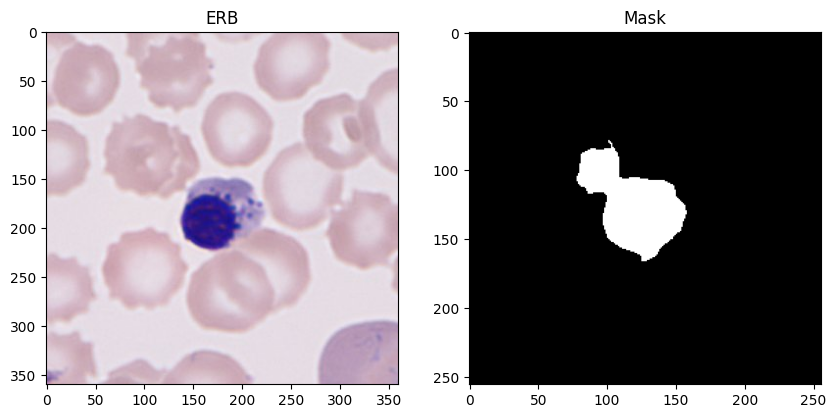

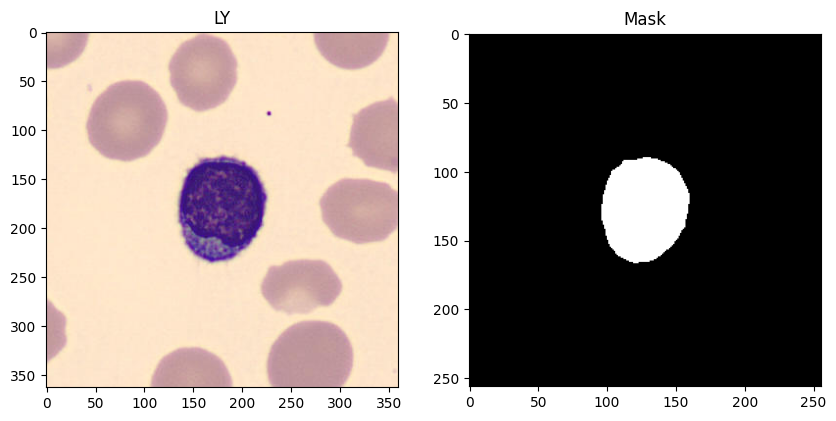

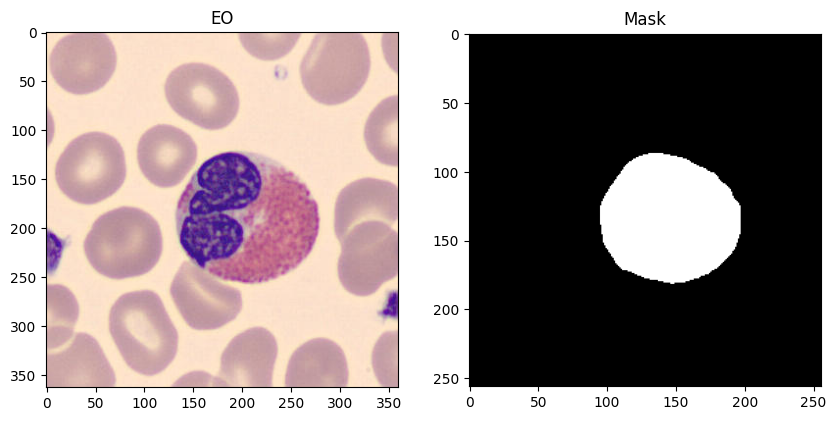

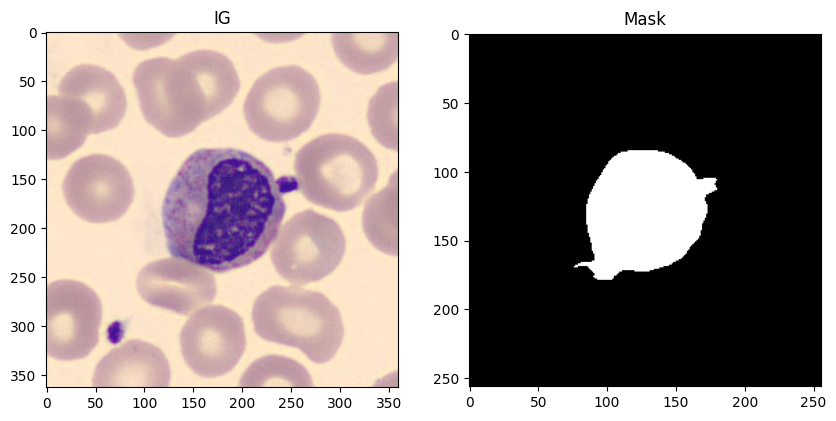

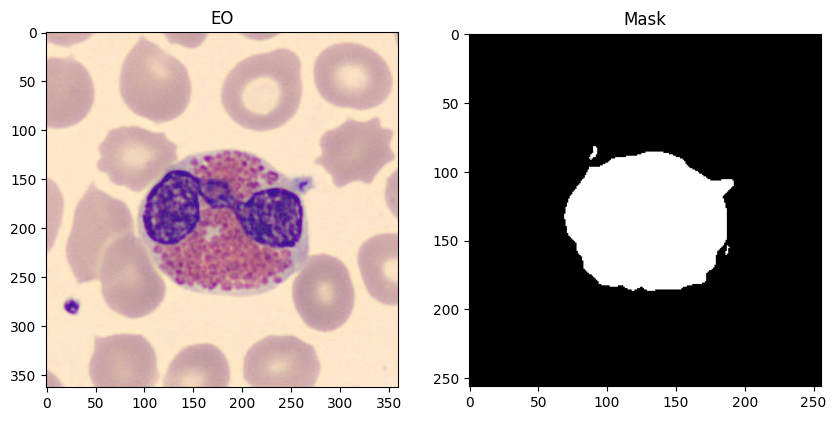

In [ ]:
### Fonction pour visualiser l'image et le masque côte à côte

import matplotlib.pyplot as plt
import cv2

def display_image_mask(image_path, mask_path,label_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir de BGR à RGB

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Supposons que le masque est en niveaux de gris

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(image)
    ax[0].set_title(label_path)

    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title("Mask")

    plt.show()

# Vérifier pour quelques paires aléatoires
import random

sample_indexes = random.sample(range(len(df_mask)), 5)  # choisir 5 paires aléatoirement

filepath=df_mask['filepath']
maskpath=df_mask['maskpath']
label=df_mask['nameLabel']


for index in sample_indexes:
    display_image_mask(filepath[index], maskpath[index],label[index])